In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
from visual_behavior.data_access import loading as loading
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache


In [4]:
import visual_behavior.utilities as vbu
import visual_behavior.visualization.utils as utils
import visual_behavior.data_access.utilities as utilities

import visual_behavior.visualization.behavior

import visual_behavior.visualization.ophys.platform_paper_figures as ppf
import visual_behavior.visualization.ophys.summary_figures as sf
import visual_behavior.visualization.ophys.experiment_summary_figures as df

### get experiments and behavior sessions tables

In [6]:
platform_experiments = loading.get_platform_paper_experiment_table(limit_to_closest_active=True, include_4x2_data=False)
print(len(platform_experiments))
print(len(platform_experiments.mouse_id.unique()))

402
66


In [7]:
behavior_sessions = loading.get_platform_paper_behavior_session_table()
print(len(behavior_sessions.mouse_id.unique()))

4787 behavior sessions in original behavior_sessions table
4787 behavior sessions after merging with project codes
4779 sessions after removing NaN session types
3667 sessions after removing VisualBehaviorMultiscope4areasx2d and Ai94
3667 sessions after adding extra columns
82


In [10]:
# limit to mice that meet the critieria for ophys to be included in the platform paper
behavior_sessions = behavior_sessions[behavior_sessions.mouse_id.isin(platform_experiments.mouse_id.unique())]
print(len(behavior_sessions))
print(len(behavior_sessions.mouse_id.unique()))

2943
66


In [11]:
save_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_1'

suffix = '_platform_mice'

### add useful columns for filtering

In [12]:
len(behavior_sessions)

2943

In [13]:
behavior_sessions.keys()

Index(['equipment_name', 'full_genotype', 'mouse_id', 'reporter_line',
       'driver_line', 'sex', 'age_in_days', 'cre_line', 'indicator',
       'session_number', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'ophys_session_id', 'ophys_experiment_id', 'ophys_container_id',
       'date_of_acquisition', 'session_type', 'file_id', 'project_code',
       'passive', 'cell_type', 'experience_level', 'training_stage',
       'first_day_of_stage', 'last_day_of_stage', 'has_ophys',
       'experiment_phase', 'stimulus', 'first_day_of_stimulus',
       'last_day_of_stimulus', 'stimulus_phase'],
      dtype='object')

In [14]:
# make fake ophys_container_id column so the below functions will work
behavior_sessions['ophys_container_id'] = behavior_sessions.mouse_id.values
# add last familiar and first novel columns
behavior_sessions = utilities.add_date_string(behavior_sessions)
behavior_sessions = utilities.add_n_relative_to_first_novel_column(behavior_sessions)
behavior_sessions = utilities.add_first_novel_column(behavior_sessions)
behavior_sessions = utilities.add_second_novel_active_column(behavior_sessions)
behavior_sessions = utilities.add_last_familiar_active_column(behavior_sessions)

original_behavior_sessions = behavior_sessions.copy()

In [15]:
experience_levels = utils.get_experience_levels()
new_experience_levels = utils.get_new_experience_levels()

cre_lines = utils.get_cre_lines()
cell_types = utils.get_cell_types()

colors = utils.get_experience_level_colors()


### training history across mice

In [27]:
def add_behavior_stage_to_behavior_sessions(behavior_sessions):
    """
    creates a column 'behavior_stage' based on session type and other metadata, values of which are: 
       ['gratings_static_training', 'gratings_flashed_training',
       'familiar_images_training', 'familiar_images_ophys',
       'familiar_images_ophys_passive', 'novel_images_ophys',
       'novel_images_ophys_passive']
    """
    # get rid of sessions with no experience level
    if len(behavior_sessions[behavior_sessions.experience_level.isnull()])>0:
        bsid = behavior_sessions[behavior_sessions.experience_level=='None'].index.values[0]
        behavior_sessions = behavior_sessions.drop(index=bsid)
    # create new behavior stage label
    behavior_sessions['phase'] = ['training' if 'TRAINING' in session_type else 'ophys' for session_type in behavior_sessions.session_type.values]
    behavior_sessions['stimulus_type'] = ['gratings' if 'gratings' in session_type else 'images' for session_type in behavior_sessions.session_type.values]
    behavior_sessions['exp_level'] = [exp_level.split(' ')[0].lower() for exp_level in behavior_sessions.experience_level.values]
    behavior_sessions['exp_level'] = [exp_level+'_images' if 'gratings' not in exp_level else 'gratings' for exp_level in behavior_sessions.exp_level.values]
    # add static vs. flashed
    for i, behavior_session in enumerate(behavior_sessions.index.values):
        row = behavior_sessions.iloc[i]
        if ('gratings' in row.session_type) and ('flashed' in row.session_type): 
            behavior_sessions.at[behavior_session, 'exp_level'] = row.exp_level+'_flashed'
        if ('gratings' in row.session_type) and ('flashed' not in row.session_type): 
            behavior_sessions.at[behavior_session, 'exp_level'] = row.exp_level+'_static'
    behavior_sessions['engagement'] = ['_passive' if 'passive' in session_type else '' for session_type in behavior_sessions.session_type.values]

    behavior_sessions['behavior_stage'] = None
    for i, behavior_session in enumerate(behavior_sessions.index.values):
        row = behavior_sessions.iloc[i]
        behavior_sessions.at[behavior_session, 'behavior_stage'] = row.exp_level+'_'+row.phase+row.engagement
        
    return behavior_sessions

In [38]:
def get_behavior_stage_color_map(as_rgb=False):
    """
    create colormap, as rgb or [0,1], corresponding to behavior stages defined in add_behavior_stage_to_behavior_sessions
    (ex: ['gratings_static_training', 'gratings_flashed_training', 'familiar_images_training', )
    
    """
    session_number_colors = utils.get_colors_for_session_numbers()
    session_number_colors_GH = utils.get_colors_for_session_numbers_GH()
    white = np.array([1, 1, 1]).astype(np.uint8)

    training_scale = 0.7
    passive_scale = 0.4

    behavior_stage_color_map = {
        'gratings_static_training': (0.7, 0.7, 0.7),
        'gratings_flashed_training': (0.4, 0.4, 0.4),
        'familiar_images_training': (session_number_colors[0] + (white - session_number_colors[0]) * training_scale),
        'familiar_images_ophys': session_number_colors[0],
        'familiar_images_ophys_passive': (session_number_colors[0] + (white - session_number_colors[0]) * passive_scale),
        'novel_images_ophys': session_number_colors[3],
        'novel_images_ophys_passive': (session_number_colors[3] + (white - session_number_colors[3]) * passive_scale),
    }

    if as_rgb:
        for key in list(behavior_stage_color_map.keys()):
            behavior_stage_color_map[key] = np.floor(
                np.array([x for x in list(behavior_stage_color_map[key])]) * 255).astype(np.uint8)

    return behavior_stage_color_map

In [48]:
def plot_training_history_for_mice(behavior_sessions, color_column='session_type', color_map=sns.color_palette(), 
                                   save_dir=None, folder=None, suffix='', ax=None):
    """
    plots the session sequence for all mice in behavior_sessions table, sorted by total # of sessions per mouse
    
    sessions are colored by the provided color_column and color_map
    values of color_column must match keys of color_map
    acceptable pairs for color_column and color_map
    color_column = 'session_type' : color_map = utils.get_session_type_color_map()
    color_column = 'stimulus' : color_map = utils.get_stimulus_color_map(as_rgb=True)
    color_column = 'stimulus_phase' : color_map = utils.get_stimulus_phase_color_map(as_rgb=True)
    
    """
    # group by mice and count n_session per mouse to get the max n_sessions and list of mouse_ids to plot
    n_sessions = behavior_sessions.groupby(['cre_line', 'mouse_id']).count().rename(columns={'equipment_name':'n_sessions'})[['n_sessions']]
    n_sessions = n_sessions.reset_index()
    n_sessions = n_sessions.sort_values(by=['cre_line', 'n_sessions'])
    max_n_sessions = np.amax(n_sessions.n_sessions.values)
    mouse_ids = n_sessions.mouse_id.values
    
    # get ytick labels based on number of mice per cre line
    yticklabels = [0]
    for i, cre_line in enumerate(n_sessions.cre_line.unique()):
        yticklabels.append(yticklabels[i]+len(n_sessions[n_sessions.cre_line==cre_line]))

    n_mouse_ids = len(mouse_ids)

    # create an array to fill in with session colors per mouse
    img = np.empty((n_mouse_ids, max_n_sessions, 3))
    img[:] = 256 # make the default value of 256 which is white in RGB space

    # loop through mice
    for mouse, mouse_id in enumerate(mouse_ids):
        # sort session in acquisition date order
        sessions = behavior_sessions[behavior_sessions.mouse_id == mouse_id].sort_values('date_of_acquisition')
        # fill in image array with the color from color_map for the corresponding color_col
        for session, session_id in enumerate(sessions.index.values):
            color_column_value = sessions.loc[session_id][color_column]
            img[mouse, session, :] = color_map[color_column_value]
        

    # create plot with expt colors image
    if ax is None: 
        figsize = (10, n_mouse_ids*0.1)
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img.astype(int), aspect='auto')
    ax.set_ylim(0, len(mouse_ids))
    ax.invert_yaxis()
    ax.set_yticks(yticklabels)
    ax.set_yticklabels(yticklabels, fontdict={'verticalalignment': 'top'})
    ax.set_xlabel('Session number')
    ax.set_ylabel('Mouse number')  
    ax.set_title('Training history')
    
    # label with cell type
    for i, cre_line in enumerate(n_sessions.cre_line.unique()):
        cell_type = utils.convert_cre_line_to_cell_type(cre_line)
        ax.text(-2, (yticklabels[i]+yticklabels[i+1])/2., cell_type.split(' ')[0], fontsize=16, ha='center', va='center', rotation='vertical')
    
    
#     ax.axis('off')

#     for mouse, mouse_id in enumerate(mouse_ids): 
#         # plot cre line
#         cre_line = behavior_sessions[behavior_sessions.mouse_id == mouse_id].cre_line.values[0]
#         if cre_line == 'Gad2-IRES-Cre': # square
#             ax.text(-1, mouse, '\u25a1', fontsize=16, ha='center', va='center',)
#         elif cre_line == 'Rbp4-Cre_KL100': # triangle
#             ax.text(-1, mouse, '\u25b2', fontsize=16, ha='center', va='center', color='black')
#         else: # circle
#             ax.text(-1, mouse, '\u25cf', fontsize=16, ha='center', va='center', color='black')
#         # plot mouse_id
#         sessions_for_mouse = n_sessions[n_sessions.mouse_id==mouse_id].n_sessions.values[0]
#         ax.text(sessions_for_mouse, mouse, str(mouse_id), fontsize=17, ha='left', va='center',)
    
    if save_dir: 
        utils.save_figure(fig, figsize, save_dir, folder, 'training_history'+suffix)
    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:title={'center':'Training history'}, xlabel='Session number', ylabel='Mouse number'>

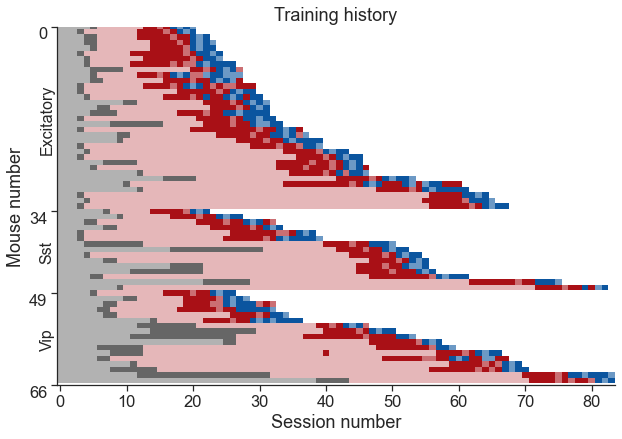

In [49]:
behavior_sessions = add_behavior_stage_to_behavior_sessions(behavior_sessions)
color_column = 'behavior_stage'
color_map = get_behavior_stage_color_map(as_rgb=True)
plot_training_history_for_mice(behavior_sessions, color_column=color_column, color_map=color_map, 
                              save_dir=save_dir, folder='training_history', suffix='_platform_mice')

In [41]:
days_in_stage = behavior_sessions.groupby(['mouse_id', 'behavior_stage']).count().rename(columns={'equipment_name':'days_in_stage'})[['days_in_stage']]
days_in_stage = days_in_stage.reset_index()
days_in_stage = days_in_stage.merge(behavior_sessions[['mouse_id', 'cell_type', 'project_code']], on='mouse_id')
days_in_stage.head()

mouse_id         behavior_stage  days_in_stage       cell_type  \
0    412036  familiar_images_ophys              3  Vip Inhibitory   
1    412036  familiar_images_ophys              3  Vip Inhibitory   
2    412036  familiar_images_ophys              3  Vip Inhibitory   
3    412036  familiar_images_ophys              3  Vip Inhibitory   
4    412036  familiar_images_ophys              3  Vip Inhibitory   

     project_code  
0  VisualBehavior  
1  VisualBehavior  
2  VisualBehavior  
3  VisualBehavior  
4  VisualBehavior

In [58]:
# behavior_stages = behavior_sessions.behavior_stage.unique()

# data = days_in_stage.copy()
# color_map = get_behavior_stage_color_map(as_rgb=True)
# colors = [list(color_map[behavior_stage]) for behavior_stage in behavior_stages]
# colors = [[c/255. for c in color] for color in colors]

# figsize=(3,10)
# fig, ax = plt.subplots(3,1, figsize=figsize, sharex=True)
# for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
#     ct_data = data[data.cell_type==cell_type]
#     ax[i] = sns.boxplot(data=ct_data, x='behavior_stage', y='days_in_stage', order=behavior_stages,
#                         palette=colors, orient='v', width=0.5, ax=ax[i])
#     ax[i].set_xlabel('')
#     ax[i].set_ylabel('days in stage')
#     ax[i].set_xticklabels(behavior_stages, rotation=90)
#     ax[i].set_title(cell_type)
#     ax[i].legend().remove()
# ax[i].legend(bbox_to_anchor=(1,1), fontsize='x-small')

# fig.subplots_adjust(hspace=0.3)

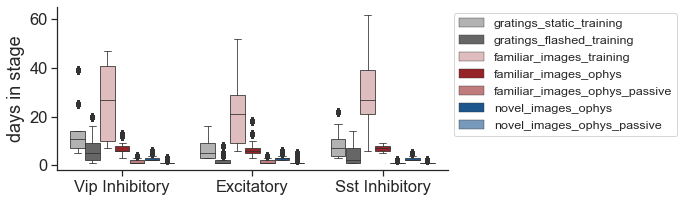

In [60]:
behavior_stages = behavior_sessions.behavior_stage.unique()

data = days_in_stage.copy()
color_map = get_behavior_stage_color_map(as_rgb=True)
colors = [list(color_map[behavior_stage]) for behavior_stage in behavior_stages]
colors = [[c/255. for c in color] for color in colors]

figsize=(7,3)
fig, ax = plt.subplots(figsize=figsize)
# for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
#     ct_data = data[data.cell_type==cell_type]
ax = sns.boxplot(data=data, x='cell_type', y='days_in_stage', width=0.8, 
                    hue='behavior_stage', hue_order=behavior_stages, palette=colors, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('days in stage')
#     ax[i].set_xticklabels(behavior_stages, rotation=90)
#     ax[i].set_title(cell_type)
ax.legend().remove()
ax.legend(bbox_to_anchor=(1,1), fontsize='x-small')

fig.subplots_adjust(hspace=0.3)

In [65]:
def plot_days_in_stage(behavior_sessions, stage_column, save_dir=None, folder=None, suffix=None):
    """
    Plot the number of days in each stage, as a boxplot using stage as the hue and cell types on y-axis
    
    behavior_sessions: behavior sessions table including 'cell_type', 'mouse_id'
    stage_column: column in behavior_sessions to use for grouping of stages, can be 'behavior_stage', 'stimulus_phase', or 'session_type', 
    to add 'behavior_stage' column to behavior_sessions, use add_behavior_stage_to_behavior_sessions(behavior_sessions)

    """
    
    days_in_stage = behavior_sessions.groupby(['mouse_id', stage_column]).count().rename(columns={'equipment_name':'days_in_stage'})[['days_in_stage']]
    days_in_stage = days_in_stage.reset_index()
    days_in_stage = days_in_stage.merge(behavior_sessions[['mouse_id', 'cell_type', 'project_code']], on='mouse_id')

    
    behavior_stages = behavior_sessions[stage_column].unique()

    data = days_in_stage.copy()
    if stage_column == 'behavior_stage':
        color_map = get_behavior_stage_color_map(as_rgb=True)
    elif stage_column == 'stimulus_phase':
        color_map = utils.get_stimulus_phase_color_map(as_rgb=True)
    elif stage_column == 'get_session_type_color_map':
        color_map = utils.get_session_type_color_map(as_rgb=True)
    else:
        print('provided stage_column does not have a corresponding colormap')

    colors = [list(color_map[behavior_stage]) for behavior_stage in behavior_stages]
    colors = [[c/255. for c in color] for color in colors]

    figsize=(7,3)
    fig, ax = plt.subplots(figsize=figsize)
    # for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
    #     ct_data = data[data.cell_type==cell_type]
    ax = sns.boxplot(data=data, x='cell_type', y='days_in_stage', width=0.8, linewidth=0.8, 
                        hue=stage_column, hue_order=behavior_stages, palette=colors, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('days in stage')
    #     ax[i].set_xticklabels(behavior_stages, rotation=90)
    #     ax[i].set_title(cell_type)
    ax.legend().remove()
    ax.legend(bbox_to_anchor=(1,1), fontsize='x-small')

    fig.subplots_adjust(hspace=0.3)
    if save_dir: 
        # save plot
        utils.save_figure(fig, figsize, save_dir, folder, 'days_in_stage'+'_'+stage_column+suffix)
        # save stats
        days_in_stage_stats = data.groupby(['cell_type', stage_column]).describe()
        days_in_stage_stats.to_csv(os.path.join(save_dir, folder, 'days_in_stage_stats.csv'))

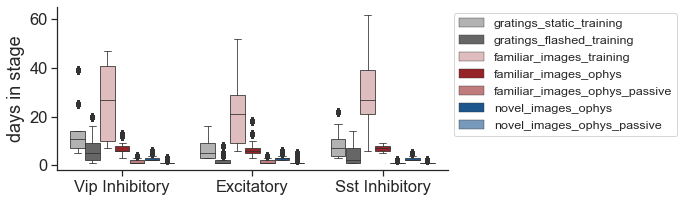

In [66]:
plot_days_in_stage(behavior_sessions, 'behavior_stage', save_dir, 'training_history', suffix)

### # sessions prior to ophys sessions included in paper

In [131]:
paper_ophys_behavior_sessions = behavior_sessions.loc[platform_experiments.behavior_session_id.unique()]
prior_exposures = paper_ophys_sessions.set_index(['experience_level', 'mouse_id'])[['prior_exposures_to_image_set']].reset_index()

prior_exposures.groupby(['experience_level']).describe()[['prior_exposures_to_image_set']]

prior_exposures_to_image_set                              \
                                        count       mean        std   min   
experience_level                                                            
Familiar                                 68.0  27.264706  14.820939  10.0   
Novel 1                                  66.0   0.000000   0.000000   0.0   
Novel >1                                 68.0   2.117647   0.922835   1.0   

                                            
                    25%   50%    75%   max  
experience_level                            
Familiar          14.75  22.0  36.25  68.0  
Novel 1            0.00   0.0   0.00   0.0  
Novel >1           2.00   2.0   2.00   6.0

In [187]:
def plot_prior_exposures_to_image_set_before_platform_ophys_sessions(platform_experiments, behavior_sessions, save_dir=None, folder=None, suffix='', ax=None):
    """
    Creates a boxplot showing the number of prior exposures to each image set for each experience level (Familiar, Novel, Novel +) 
    for the set of mice and sessions in platform_experiments
    Boxplot is distribution of number of prior exposures across mice
    """

    # get the behavior sessions corresponding to the ophys sessions included in platform dataset 
    paper_ophys_behavior_sessions = behavior_sessions.loc[platform_experiments.behavior_session_id.unique()]
    exposures = paper_ophys_sessions.set_index(['experience_level', 'mouse_id'])[['prior_exposures_to_image_set']].reset_index()

    if ax is None:
        figsize = (2.5,3)
        fig, ax = plt.subplots(figsize=figsize)

    colors = utils.get_experience_level_colors()
    experience_levels = utils.get_experience_levels()

    ax = sns.boxplot(data=exposures, x='experience_level', y='prior_exposures_to_image_set', 
               order=experience_levels, palette=colors, width=0.5, ax=ax)
    ax.set_ylabel('# sessions')
    ax.set_xlabel('')

    stats = exposures.groupby(['experience_level']).describe()[['prior_exposures_to_image_set']]
    stats.columns = stats.columns.droplevel(0)

    xticklabels = new_experience_levels
    # xticklabels = [experience_level+'\n N = '+str(int(np.round(exposures.loc[experience_level]['mean'],0)))+'+/-'+str(int(np.round(exposures.loc[experience_level]['std'],0))) if experience_level!='Novel 1' else 'Novel 1\nN = 0' for experience_level in experience_levels]
    ax.set_xticklabels(xticklabels, rotation=90,)
    ax.set_title('prior stimulus exposure')

    for i, experience_level in enumerate(experience_levels):
        y = int(np.round(stats.loc[experience_level]['mean'],0))
        if experience_level == 'Novel 1':
            text = '0'
            y = y+4
            i = 0.85
        elif experience_level == 'Familiar':
            y = y+12
            text = str(int(np.round(stats.loc[experience_level]['mean'],0)))+'+/-'+str(int(np.round(stats.loc[experience_level]['std'],0)))
        else: 
            y = y+8
            text = str(int(np.round(stats.loc[experience_level]['mean'],0)))+'+/-'+str(int(np.round(stats.loc[experience_level]['std'],0)))
        ax.text(i+0.1, y, text, fontsize=14, rotation='horizontal')

    if save_dir: 
        # save plot
        utils.save_figure(fig, figsize, save_dir, folder, 'stimulus_exposures_before_platform_expts_boxplot'+suffix)
        # save stats
        stats = exposures.groupby(['experience_level']).describe()[['prior_exposures_to_image_set']]
        stats.to_csv(os.path.join(save_dir, folder, 'stimulus_exposures_before_platform_expts_stats.csv'))

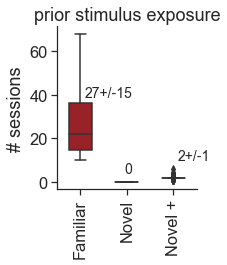

In [188]:
plot_prior_exposures_to_image_set_before_platform_ophys_sessions(platform_experiments, behavior_sessions, 
                                                                 save_dir=save_dir, folder='training_history', suffix='', ax=None)

### number of novel sessions prior to novel + for sessions included in paper

In [203]:
def plot_prior_exposures_per_cell_type_for_novel_plus(platform_experiments, behavior_sessions, save_dir=None, folder=None, suffix='', ax=None):
    """
    Creates a boxplot showing the number of  prior exposures to novel image set for Novel + sessions included in the platform paper
    shows striplot of prior exposures across mice and pointplot of averages plus stats
    """

    cell_types = utils.get_cell_types()

    # get the behavior sessions corresponding to the ophys sessions included in platform dataset 
    paper_ophys_behavior_sessions = behavior_sessions.loc[platform_experiments.behavior_session_id.unique()]
    exposures = platform_experiments.set_index(['cell_type', 'experience_level', 'mouse_id'])[['prior_exposures_to_image_set']].reset_index()

#     print(prior_exposures.groupby(['cell_type', 'experience_level']).describe()[['prior_exposures_to_image_set']])
    
    # limit to Novel+ sessions
    if 'Novel >1' in exposures.experience_level.unique():
        exposures = exposures[exposures.experience_level=='Novel >1']
    else:
        exposures = exposures[exposures.experience_level=='Novel +']
        
    if ax is None:
        figsize = (2.5,3)
        fig, ax = plt.subplots(figsize=figsize)

    colors = utils.get_experience_level_colors()
    experience_levels = utils.get_experience_levels()

#     ax = sns.boxplot(data=exposures, x='cell_type', y='prior_exposures_to_image_set', 
#                order=cell_types, palette='gray', width=0.5, ax=ax)
    
    ax = sns.stripplot(data=exposures, x='cell_type', y='prior_exposures_to_image_set', order=cell_types,
                       orient='v', color='gray', dodge=True, size=2, jitter=0.2, ax=ax, zorder=0)
    ax = sns.violinplot(data=exposures, x='cell_type', y='prior_exposures_to_image_set', order=cell_types,
                       orient='v', color='white', ax=ax)
            
    ax.set_ylabel('# sessions')
    ax.set_xlabel('')

    stats = exposures.groupby(['cell_type']).describe()[['prior_exposures_to_image_set']]
    stats.columns = stats.columns.droplevel(0)

    xticklabels = cell_types
    for i,cell_type in enumerate(cell_types):
        text = str((np.round(stats.loc[cell_type]['mean'],1)))+'+/-'+str((np.round(stats.loc[cell_type]['std'],1)))
        xticklabels[i] = xticklabels[i]+'\n('+text+')'
    # xticklabels = [experience_level+'\n N = '+str(int(np.round(exposures.loc[experience_level]['mean'],0)))+'+/-'+str(int(np.round(exposures.loc[experience_level]['std'],0))) if experience_level!='Novel 1' else 'Novel 1\nN = 0' for experience_level in experience_levels]
    ax.set_xticklabels(xticklabels, rotation=90,)
    ax.set_title('# Novel sessions\nprior to Novel +')
    ax.set_ylim(ymin=0)
       
    ymax = ax.get_ylim()[1]
    tukey = pd.DataFrame()
    ax, tukey_table = ppf.add_stats_to_plot(data, 'prior_exposures_to_image_set', 'white', ax, ymax=ymax, column_to_compare='cell_type')
    # aggregate stats
    tukey_table['metric'] = metric
    tukey = pd.concat([tukey, tukey_table])

    if save_dir: 
        # save plot
        utils.save_figure(fig, figsize, save_dir, folder, 'stimulus_exposures_before_novel_plus'+suffix)
        # save stats
        stats = prior_exposures.groupby(['cell_type', 'experience_level']).describe()[['prior_exposures_to_image_set']]
        stats.to_csv(os.path.join(save_dir, folder, 'stimulus_exposures_before_novel_plus_stats.csv'))

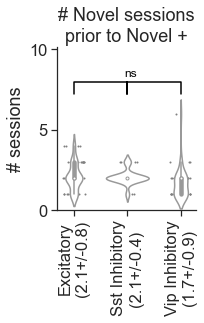

In [204]:
plot_prior_exposures_per_cell_type_for_novel_plus(platform_experiments, behavior_sessions, 
                                                  save_dir=save_dir, folder='training_history', suffix='', ax=None)

### quantify total exposures for each experience level

In [205]:
def plot_total_stimulus_exposures(behavior_sessions, save_dir=None, folder=None, suffix='', ax=None):
    """
    Creates a boxplot showing the number of sessions for each experience level (Familiar, Novel, Novel +) 
    for the set of mice included in behavior_sessions
    """

    # count number of sessions for each experience level
    exposures = behavior_sessions.groupby(['experience_level', 'mouse_id']).count()[['session_type']].reset_index().rename(columns={'session_type':'n_sessions'})
#     print(exposures.groupby(['experience_level']).describe()[['n_sessions']])
    
    if ax is None:
        figsize = (2.5,3)
        fig, ax = plt.subplots(figsize=figsize)

    colors = utils.get_experience_level_colors()

    ax = sns.boxplot(data=exposures, x='experience_level', y='n_sessions', 
               order=experience_levels, palette=colors, width=0.5, ax=ax)
    ax.set_ylabel('# sessions')
    ax.set_xlabel('')

    stats = exposures.groupby(['experience_level']).describe()[['n_sessions']]
    stats.columns = stats.columns.droplevel(0)

    xticklabels = new_experience_levels
    # xticklabels = [experience_level+'\n N = '+str(int(np.round(exposures.loc[experience_level]['mean'],0)))+'+/-'+str(int(np.round(exposures.loc[experience_level]['std'],0))) if experience_level!='Novel 1' else 'Novel 1\nN = 0' for experience_level in experience_levels]
    ax.set_xticklabels(xticklabels, rotation=90,)
    ax.set_title('total stimulus exposure')

    for i, experience_level in enumerate(experience_levels):
        y = int(np.round(stats.loc[experience_level]['mean'],0))
        if experience_level == 'Novel 1':
            text = '0'
            y = y+4
            i = 0.85
        elif experience_level == 'Familiar':
            y = y+12
            text = str(int(np.round(stats.loc[experience_level]['mean'],0)))+'+/-'+str(int(np.round(stats.loc[experience_level]['std'],0)))
        else: 
            y = y+8
            text = str(int(np.round(stats.loc[experience_level]['mean'],0)))+'+/-'+str(int(np.round(stats.loc[experience_level]['std'],0)))
        ax.text(i+0.1, y, text, fontsize=14, rotation='horizontal')

    if save_dir: 
        utils.save_figure(fig, figsize, save_dir, folder, 'total_stimulus_exposures_boxplot'+suffix)
        # save stats
        stats = exposures.groupby(['experience_level']).describe()[['n_sessions']]
        stats.to_csv(os.path.join(save_dir, folder, 'total_stimulus_exposures_stats.csv'))

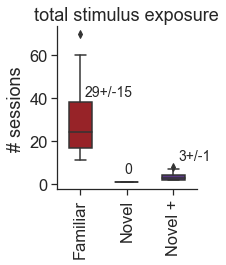

In [207]:
plot_total_stimulus_exposures(behavior_sessions, save_dir=save_dir, folder='training_history', suffix='', ax=None)

### prior to ophys only

In [208]:
def plot_stimulus_exposure_prior_to_imaging(behavior_sessions, save_dir=None, folder=None, suffix='', ax=None):
    """
    Creates a boxplot showing the number of sessions for each experience level (Familiar, Novel, Novel +) 
    prior to the start of 2P imaging, for the set of mice included in behavior_sessions
    """

    data = behavior_sessions.copy()
    # limit to non-ophys sessions
    data = data[data.session_type.str.contains('OPHYS')==False]
    # count number of sessions of each experience level
    exposures = data.groupby(['experience_level', 'mouse_id']).count()[['session_type']].reset_index().rename(columns={'session_type':'n_sessions'})

#     print(exposures.groupby(['experience_level']).describe()[['n_sessions']])
    
    if ax is None:
        figsize = (2.5,3)
        fig, ax = plt.subplots(figsize=figsize)

    exp = exposures.experience_level.unique()[::-1]

    colors = utils.get_experience_level_colors()
    c = [colors[0], [0.5, 0.5, 0.5]][::-1]


    ax = sns.boxplot(data=exposures, x='experience_level', y='n_sessions', 
               order=exp, palette=c, width=0.5, ax=ax)
    ax.set_ylabel('# sessions')
    ax.set_xlabel('')

    stats = exposures.groupby(['experience_level']).describe()[['n_sessions']]
    stats.columns = stats.columns.droplevel(0)

    stats = exposures.groupby(['experience_level']).describe()[['n_sessions']]
    stats.columns = stats.columns.droplevel(0)

    ax.set_xticklabels(['Gratings', 'Familiar\nimages'], rotation=90)
    ax.set_title('stimulus exposure\nduring training')

    for i, experience_level in enumerate(exposures.experience_level.unique()[::-1]):
        y = int(np.round(stats.loc[experience_level]['mean'],0))
        if experience_level == 'Novel 1':
            text = '0'
            y = y+4
            i = 0.85
        elif experience_level == 'Familiar':
            y = y+12
            text = str(int(np.round(stats.loc[experience_level]['mean'],0)))+'+/-'+str(int(np.round(stats.loc[experience_level]['std'],0)))
        else: 
            y = y+4
            text = str(int(np.round(stats.loc[experience_level]['mean'],0)))+'+/-'+str(int(np.round(stats.loc[experience_level]['std'],0)))
        ax.text(i+0.1, y, text, fontsize=14, rotation='horizontal')

    if save_dir: 
        utils.save_figure(fig, figsize, save_dir, folder, 'stimulus_exposure_prior_to_imaging_boxplot'+suffix)
        # save stats
        stats = exposures.groupby(['experience_level']).describe()[['n_sessions']]
        stats.to_csv(os.path.join(save_dir, folder, 'stimulus_exposure_prior_to_imaging_stats.csv'))

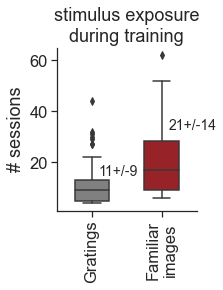

In [210]:
plot_stimulus_exposure_prior_to_imaging(behavior_sessions, save_dir=save_dir, folder='training_history', suffix='', ax=None)

## get behavior metrics

In [84]:
# def get_save_folder(method, engaged_only, per_image):  
#     folder = method
#     if engaged_only: 
#         folder = folder+'_engaged_only'
#     if per_image:
#         folder = folder+'_per_image' 
#     return folder


# def get_behavior_stats_for_sessions(behavior_session_ids, behavior_sessions, 
#                                     method='stimulus_based', engaged_only=True, per_image=False):
#     behavior_stats = pd.DataFrame()
#     problem_sessions = []
#     for behavior_session_id in tqdm(behavior_session_ids):
#         try:
#             print('loading for', behavior_session_id)
#             stats = vbu.get_cached_behavior_stats(behavior_session_id, engaged_only=engaged_only, method=method, per_image=per_image)
#             behavior_stats = pd.concat([behavior_stats, stats])
#         except:
#             print('cant load stats for', behavior_session_id)
#             problem_sessions.append(behavior_session_id)

#     cache_dir = vbu.get_behavior_stats_cache_dir(method=method, engaged_only=engaged_only, per_image=per_image)
#     filepath = os.path.join(cache_dir, 'all_sessions.h5')
#     if not os.path.exists(filepath):
#         behavior_stats.to_hdf(filepath, key='data')
    
#     return behavior_stats, problem_sessions

In [211]:
folder = 'behavior_metrics'

In [88]:
%%time 

method = 'stimulus_based'
engaged_only = True
per_image = False

# folder = get_save_folder(method, engaged_only, per_image)

behavior_session_ids = behavior_sessions.index.values


original_engaged_behavior_stats_stim, problem_sessions = vbu.get_behavior_stats_for_sessions(behavior_session_ids, behavior_sessions, 
                                    method=method, engaged_only=engaged_only, per_image=per_image)


# original_behavior_stats = behavior_stats.copy()
engaged_behavior_stats_stim = original_engaged_behavior_stats_stim.merge(behavior_sessions, on='behavior_session_id')
print(len(engaged_behavior_stats_stim.mouse_id.unique()))
#  remove 4x2 sessions
engaged_behavior_stats_stim = engaged_behavior_stats_stim[engaged_behavior_stats_stim.project_code!='VisualBehaviorMultiscope4areasx2d']

  0%|                                                                                         | 0/2943 [00:00<?, ?it/s]

loading for 760808911


  0%|                                                                                 | 3/2943 [00:00<12:38,  3.88it/s]

loading for 761294708
loading for 761730617
loading for 762067130
loading for 762418364
loading for 763012686


  0%|▏                                                                                | 9/2943 [00:01<04:30, 10.83it/s]

loading for 763661704
loading for 764319580
loading for 764696952
loading for 765208332


  0%|▎                                                                               | 13/2943 [00:01<03:07, 15.65it/s]

loading for 765793356
loading for 766532213
loading for 766931048
loading for 767730839
loading for 768450504
loading for 769145833


  1%|▌                                                                               | 19/2943 [00:01<02:23, 20.34it/s]

loading for 769731277
loading for 770215042
loading for 771040969
loading for 771902184
loading for 772475707
loading for 773391809


  1%|▋                                                                               | 26/2943 [00:01<01:59, 24.45it/s]

loading for 774120511
loading for 774679623
loading for 775291372
loading for 776988190
loading for 778010119
loading for 778888558
loading for 779712859


  1%|▉                                                                               | 35/2943 [00:02<01:50, 26.43it/s]

loading for 780479408
loading for 781938213
loading for 783217873
loading for 783959068
loading for 785382040
loading for 786007435


  1%|█                                                                               | 38/2943 [00:02<01:53, 25.65it/s]

loading for 786938611
loading for 789008423
loading for 789870329
loading for 791248943
loading for 791904071


  2%|█▏                                                                              | 45/2943 [00:02<02:00, 24.12it/s]

loading for 792680306
loading for 793485674
loading for 794968300
loading for 795742990
loading for 796052844


  2%|█▎                                                                              | 48/2943 [00:02<02:04, 23.27it/s]

loading for 796251270
loading for 798126878
loading for 772286394
loading for 773510999
loading for 774208555
loading for 774767072


  2%|█▍                                                                              | 54/2943 [00:03<02:07, 22.73it/s]

loading for 775344511
loading for 775925580
loading for 777061425
loading for 778119826
loading for 778959204


  2%|█▋                                                                              | 60/2943 [00:03<02:10, 22.02it/s]

loading for 779580423
loading for 780351711
loading for 781727422
loading for 783059206


  2%|█▋                                                                              | 63/2943 [00:03<02:16, 21.06it/s]

loading for 783971649
loading for 785376297
loading for 785868918
loading for 786841415


  2%|█▊                                                                              | 66/2943 [00:03<02:15, 21.18it/s]

loading for 788864720
loading for 789946754
loading for 791278700
loading for 791769447
loading for 792477679


  2%|█▉                                                                              | 73/2943 [00:03<02:00, 23.77it/s]

loading for 793153175
loading for 794071128
loading for 794673280
loading for 795431009
loading for 796031509
loading for 797170547
loading for 791877093


  3%|██▏                                                                             | 79/2943 [00:04<02:04, 22.96it/s]

loading for 792689261
loading for 793414389
loading for 794295959
loading for 794977379
loading for 795854559


  3%|██▏                                                                             | 82/2943 [00:04<01:58, 24.10it/s]

loading for 799051310
loading for 799922316
loading for 800299366
loading for 800922511


  3%|██▍                                                                             | 88/2943 [00:04<02:09, 22.09it/s]

loading for 802988132
loading for 803351520
loading for 804929649
loading for 805535249
loading for 806109931
loading for 806792366


  3%|██▌                                                                             | 94/2943 [00:04<01:58, 24.11it/s]

loading for 807356557
loading for 808324301
loading for 808883789
loading for 809358811
loading for 810405357
loading for 811303680


  3%|██▋                                                                            | 101/2943 [00:05<01:48, 26.08it/s]

loading for 811817467
loading for 812955256
loading for 816417578
loading for 817139151
loading for 818485496
loading for 819094295
loading for 791875850


  4%|██▊                                                                            | 105/2943 [00:05<01:53, 25.03it/s]

loading for 792689257
loading for 793409670
loading for 794295950
loading for 794977383


  4%|██▉                                                                            | 111/2943 [00:05<02:05, 22.64it/s]

loading for 795854555
loading for 799049628
loading for 799919887
loading for 800299362
loading for 800919728


  4%|███▏                                                                           | 118/2943 [00:05<01:57, 23.97it/s]

loading for 802364085
loading for 802988119
loading for 803347004
loading for 805639780
loading for 806296598


  4%|███▏                                                                           | 121/2943 [00:05<02:07, 22.13it/s]

loading for 806841326
loading for 807584876
loading for 808432167
loading for 809027309
loading for 809427293


  4%|███▎                                                                           | 124/2943 [00:06<02:08, 21.90it/s]

loading for 811355443
loading for 810584641
loading for 811356875
loading for 811831429


  4%|███▍                                                                           | 130/2943 [00:06<02:19, 20.14it/s]

loading for 812566400
loading for 812993078
loading for 813675618
loading for 814546737
loading for 815015329


  5%|███▋                                                                           | 136/2943 [00:06<02:13, 21.07it/s]

loading for 815511978
loading for 816381516
loading for 817182203
loading for 818758572
loading for 819245147


  5%|███▋                                                                           | 139/2943 [00:06<02:24, 19.37it/s]

loading for 819990491
loading for 821803380
loading for 822409353


  5%|███▊                                                                           | 142/2943 [00:07<02:33, 18.21it/s]

loading for 823241007
loading for 823968100
loading for 825012995
loading for 825268982


  5%|███▉                                                                           | 145/2943 [00:07<02:19, 20.11it/s]

loading for 825888541
loading for 826697158
loading for 827374757
loading for 828646658


  5%|████                                                                           | 150/2943 [00:07<02:40, 17.38it/s]

loading for 829138845
loading for 829578829
loading for 830255592
loading for 830832988


  5%|████▏                                                                          | 155/2943 [00:07<02:33, 18.22it/s]

loading for 831824426
loading for 832981154
loading for 835444110
loading for 835820832
loading for 836399024


  5%|████▎                                                                          | 159/2943 [00:07<02:29, 18.68it/s]

loading for 807062523
loading for 808103937
loading for 809588395
loading for 810266014
loading for 811140660


  6%|████▍                                                                          | 164/2943 [00:08<02:32, 18.21it/s]

loading for 811574124
loading for 812261209
loading for 812796028
loading for 814260983
loading for 814749891


  6%|████▌                                                                          | 170/2943 [00:08<02:21, 19.65it/s]

loading for 815865807
loading for 817053045
loading for 818539436


  6%|████▌                                                                          | 172/2943 [00:08<02:31, 18.29it/s]

loading for 819065377
loading for 819497998
loading for 820740400
loading for 821593979


  6%|████▋                                                                          | 176/2943 [00:08<02:41, 17.10it/s]

loading for 822159346
loading for 822874578
loading for 823496226
loading for 824566587


  6%|████▊                                                                          | 181/2943 [00:09<02:37, 17.57it/s]

loading for 825269006
loading for 825902239
loading for 826697162
loading for 827374765


  6%|████▉                                                                          | 183/2943 [00:09<02:47, 16.52it/s]

loading for 828669593
loading for 829138837
loading for 829714672


  6%|█████                                                                          | 187/2943 [00:09<03:20, 13.76it/s]

loading for 830419451
loading for 830959034
loading for 831905148
loading for 833100683


  7%|█████▏                                                                         | 192/2943 [00:10<03:15, 14.08it/s]

loading for 833946929
loading for 834928595
loading for 835547527


  7%|█████▏                                                                         | 195/2943 [00:10<02:46, 16.49it/s]

loading for 835940015
loading for 837108110
loading for 837512169
loading for 823922942
loading for 824972176


  7%|█████▍                                                                         | 201/2943 [00:10<02:24, 18.99it/s]

loading for 825527066
loading for 826338809
loading for 826841473
loading for 827977069


  7%|█████▍                                                                         | 203/2943 [00:10<02:31, 18.10it/s]

loading for 828842797
loading for 829281654
loading for 829902556
loading for 830592943


  7%|█████▌                                                                         | 208/2943 [00:10<02:17, 19.86it/s]

loading for 831259963
loading for 832009551
loading for 832522789
loading for 833252272
loading for 834059775


  7%|█████▋                                                                         | 214/2943 [00:11<02:08, 21.26it/s]

loading for 834886139
loading for 835608988
loading for 836099247
loading for 836769386
loading for 837202082
loading for 837629869


  7%|█████▉                                                                         | 220/2943 [00:11<02:12, 20.61it/s]

loading for 838486964
loading for 839220840
loading for 839566028
loading for 839918083


  8%|█████▉                                                                         | 223/2943 [00:11<02:22, 19.14it/s]

loading for 840583412
loading for 841431760
loading for 841830077


  8%|██████                                                                         | 226/2943 [00:11<02:17, 19.79it/s]

loading for 842387217
loading for 842821314
loading for 843397714
loading for 844197868


  8%|██████▏                                                                        | 229/2943 [00:11<02:35, 17.46it/s]

loading for 844880686
loading for 845564445
loading for 846272622
loading for 847022155


  8%|██████▎                                                                        | 235/2943 [00:12<02:22, 19.07it/s]

loading for 847829598
loading for 848519645
loading for 849073265
loading for 849635376


  8%|██████▎                                                                        | 237/2943 [00:12<02:23, 18.89it/s]

loading for 850977753
loading for 851779746
loading for 852468381
loading for 853168204


  8%|██████▍                                                                        | 241/2943 [00:12<02:25, 18.62it/s]

loading for 853875502
loading for 854563857
loading for 855421865
loading for 855973498


  8%|██████▌                                                                        | 246/2943 [00:12<02:24, 18.62it/s]

loading for 856717282
loading for 857612105
loading for 859065627
loading for 859735311


  8%|██████▋                                                                        | 250/2943 [00:13<02:25, 18.47it/s]

loading for 860665051
loading for 861788094
loading for 863571072
loading for 864139911


  9%|██████▊                                                                        | 253/2943 [00:13<02:07, 21.02it/s]

loading for 864824449
loading for 865482857
loading for 866333758
loading for 867041502
loading for 867977775


  9%|██████▊                                                                        | 256/2943 [00:13<02:07, 21.07it/s]

loading for 868721114
loading for 869639141
loading for 870960890


  9%|███████                                                                        | 262/2943 [00:13<02:29, 17.90it/s]

loading for 872062433
loading for 873002413
loading for 873750535
loading for 874681118
loading for 875414332


  9%|███████▏                                                                       | 269/2943 [00:13<02:01, 21.93it/s]

loading for 876765708
loading for 877346183
loading for 877925816
loading for 878671068
loading for 879974471


  9%|███████▎                                                                       | 272/2943 [00:14<01:58, 22.49it/s]

loading for 880668519
loading for 881278000
loading for 882256127
loading for 882748184


  9%|███████▍                                                                       | 275/2943 [00:14<02:20, 18.93it/s]

loading for 884596128
loading for 885492180
loading for 886322595
loading for 886926935


  9%|███████▍                                                                       | 278/2943 [00:14<02:19, 19.05it/s]

loading for 888127012
loading for 890157940
loading for 820799656


 10%|███████▌                                                                       | 282/2943 [00:14<02:38, 16.76it/s]

loading for 821837682
loading for 822471786
loading for 823248638
loading for 823922950


 10%|███████▋                                                                       | 287/2943 [00:14<02:19, 19.05it/s]

loading for 824992804
loading for 825533866
loading for 826356747
loading for 826846303
loading for 827944014


 10%|███████▊                                                                       | 293/2943 [00:15<01:58, 22.30it/s]

loading for 828838236
loading for 829282785
loading for 829877552
loading for 830620126
loading for 832019583


 10%|███████▉                                                                       | 296/2943 [00:15<02:13, 19.80it/s]

loading for 832540845
loading for 833454420
loading for 834093014
loading for 834908481


 10%|████████                                                                       | 302/2943 [00:15<02:07, 20.65it/s]

loading for 835616503
loading for 836173885
loading for 836777468
loading for 837196627


 10%|████████▏                                                                      | 305/2943 [00:15<02:19, 18.97it/s]

loading for 837647722
loading for 838496122
loading for 839233516


 10%|████████▏                                                                      | 307/2943 [00:15<02:20, 18.81it/s]

loading for 839566049
loading for 839931485
loading for 840594518
loading for 841429687


 11%|████████▍                                                                      | 312/2943 [00:16<02:15, 19.44it/s]

loading for 841842210
loading for 842399625
loading for 842844413
loading for 843400443


 11%|████████▍                                                                      | 316/2943 [00:16<02:18, 18.97it/s]

loading for 844253929
loading for 845585105
loading for 846316916
loading for 847036338
loading for 847871771


 11%|████████▌                                                                      | 321/2943 [00:16<02:15, 19.31it/s]

loading for 848599542
loading for 849136474
loading for 849648618
loading for 850985993


 11%|████████▋                                                                      | 324/2943 [00:16<02:10, 20.02it/s]

loading for 851757903
loading for 852440775
loading for 853496105
loading for 827312851


 11%|████████▊                                                                      | 330/2943 [00:17<02:06, 20.73it/s]

loading for 828646634
loading for 829128279
loading for 829591790
loading for 830201482


 11%|████████▉                                                                      | 333/2943 [00:17<01:56, 22.31it/s]

loading for 830867799
loading for 831834820
loading for 832325815
loading for 832990071
loading for 833780803
loading for 834573980


 12%|█████████                                                                      | 339/2943 [00:17<02:03, 21.10it/s]

loading for 835448132
loading for 835865722
loading for 836522259
loading for 837083666
loading for 837443225


 12%|█████████▏                                                                     | 343/2943 [00:17<01:51, 23.37it/s]

loading for 838236165
loading for 839014738
loading for 839479248
loading for 839854553
loading for 840330509


 12%|█████████▍                                                                     | 350/2943 [00:17<01:44, 24.93it/s]

loading for 841185520
loading for 841730873
loading for 842139320
loading for 842792100
loading for 843166865
loading for 844234790
loading for 844875410


 12%|█████████▌                                                                     | 356/2943 [00:18<01:53, 22.88it/s]

loading for 846248008
loading for 847048485
loading for 847867029
loading for 848575992
loading for 849098851


 12%|█████████▋                                                                     | 362/2943 [00:18<01:57, 21.96it/s]

loading for 850976604
loading for 853266283
loading for 831129394
loading for 832021447


 12%|█████████▊                                                                     | 365/2943 [00:18<02:10, 19.80it/s]

loading for 832544149
loading for 833328750
loading for 834087859


 13%|█████████▉                                                                     | 368/2943 [00:18<02:11, 19.62it/s]

loading for 834903060
loading for 835557296
loading for 836166694
loading for 836761653


 13%|█████████▉                                                                     | 371/2943 [00:18<02:19, 18.39it/s]

loading for 837192567
loading for 837638916
loading for 838496126
loading for 839234289


 13%|██████████                                                                     | 377/2943 [00:19<02:08, 19.93it/s]

loading for 839566045
loading for 839939986
loading for 840594514
loading for 841148118


 13%|██████████▏                                                                    | 380/2943 [00:19<02:07, 20.15it/s]

loading for 841707177
loading for 842174399
loading for 842729895
loading for 843203333
loading for 844164376


 13%|██████████▎                                                                    | 386/2943 [00:19<01:57, 21.69it/s]

loading for 844849972
loading for 845441512
loading for 846194950
loading for 846929750
loading for 848503804
loading for 853526948


 13%|██████████▌                                                                    | 392/2943 [00:19<02:01, 21.00it/s]

loading for 834587823
loading for 835451471
loading for 835867850
loading for 836522245


 13%|██████████▌                                                                    | 395/2943 [00:20<02:14, 18.97it/s]

loading for 837083657
loading for 837449223
loading for 838203784


 14%|██████████▋                                                                    | 398/2943 [00:20<02:01, 20.90it/s]

loading for 838998362
loading for 839468826
loading for 839837380
loading for 840330501
loading for 841191836
loading for 841730868


 14%|██████████▊                                                                    | 404/2943 [00:20<01:59, 21.33it/s]

loading for 842139310
loading for 842792094
loading for 843178897
loading for 844027594


 14%|██████████▉                                                                    | 407/2943 [00:20<02:10, 19.40it/s]

loading for 844608277
loading for 845409652
loading for 846051276
loading for 846791195
loading for 847613846


 14%|███████████                                                                    | 413/2943 [00:21<02:09, 19.55it/s]

loading for 848272657
loading for 848938321
loading for 849525884
loading for 850817466


 14%|███████████▏                                                                   | 416/2943 [00:21<02:17, 18.36it/s]

loading for 851563931
loading for 852235678
loading for 852974537
loading for 853505213


 14%|███████████▎                                                                   | 421/2943 [00:21<02:15, 18.57it/s]

loading for 854283407
loading for 855826937
loading for 857230827
loading for 837658854


 14%|███████████▍                                                                   | 424/2943 [00:21<02:02, 20.54it/s]

loading for 838515247
loading for 839219841
loading for 839565422
loading for 839912316
loading for 840581827


 15%|███████████▌                                                                   | 430/2943 [00:21<02:05, 20.01it/s]

loading for 841426832
loading for 841827774
loading for 842385277
loading for 842819933
loading for 843400453


 15%|███████████▋                                                                   | 436/2943 [00:22<01:54, 21.91it/s]

loading for 844199758
loading for 844908261
loading for 845572044
loading for 846331423
loading for 847036328


 15%|███████████▊                                                                   | 440/2943 [00:22<01:44, 23.94it/s]

loading for 847874940
loading for 848613406
loading for 849147676
loading for 849651275
loading for 850989832
loading for 851773928


 15%|███████████▉                                                                   | 446/2943 [00:22<01:48, 22.98it/s]

loading for 852451567
loading for 855200229
loading for 840598877
loading for 841466830
loading for 841851097


 15%|████████████                                                                   | 449/2943 [00:22<01:46, 23.44it/s]

loading for 842419799
loading for 842840144
loading for 843423171
loading for 844229895


 15%|████████████▏                                                                  | 452/2943 [00:22<01:58, 20.99it/s]

loading for 844945060
loading for 845594684
loading for 846284880


 16%|████████████▎                                                                  | 457/2943 [00:23<02:16, 18.23it/s]

loading for 847048490
loading for 847838131
loading for 848526511
loading for 848910243


 16%|████████████▍                                                                  | 462/2943 [00:23<02:10, 18.95it/s]

loading for 849485548
loading for 850810858
loading for 851471401
loading for 852202150


 16%|████████████▌                                                                  | 466/2943 [00:23<02:16, 18.16it/s]

loading for 852966248
loading for 853875514
loading for 854621677
loading for 855424348


 16%|████████████▌                                                                  | 468/2943 [00:23<02:32, 16.28it/s]

loading for 857340041
loading for 857987666
loading for 858974731


 16%|████████████▋                                                                  | 472/2943 [00:24<02:44, 15.05it/s]

loading for 859775117
loading for 863610582
loading for 868070216


 16%|████████████▊                                                                  | 475/2943 [00:24<02:26, 16.87it/s]

loading for 868658294
loading for 869559097
loading for 854533487
loading for 855504136


 16%|████████████▊                                                                  | 479/2943 [00:24<02:23, 17.15it/s]

loading for 856002607
loading for 856732191
loading for 857555456
loading for 858240891


 16%|████████████▉                                                                  | 483/2943 [00:24<02:35, 15.84it/s]

loading for 859032026
loading for 859791558
loading for 860752803


 17%|█████████████                                                                  | 487/2943 [00:25<02:40, 15.26it/s]

loading for 861794699
loading for 862701465
loading for 863571054


 17%|█████████████▏                                                                 | 489/2943 [00:25<02:38, 15.46it/s]

loading for 864137547
loading for 864839176
loading for 865581941
loading for 866287088


 17%|█████████████▎                                                                 | 494/2943 [00:25<02:26, 16.71it/s]

loading for 866950070
loading for 867615529
loading for 868540333


 17%|█████████████▎                                                                 | 497/2943 [00:25<02:10, 18.80it/s]

loading for 869319414
loading for 870660821
loading for 871808378
loading for 872646068
loading for 873517635


 17%|█████████████▍                                                                 | 502/2943 [00:25<01:56, 21.04it/s]

loading for 874324533
loading for 875471358
cant load stats for 875471358
loading for 876574139
loading for 850970486
loading for 851843550


 17%|█████████████▌                                                                 | 505/2943 [00:25<02:04, 19.58it/s]

loading for 852507945
loading for 853260939
loading for 853886146


 17%|█████████████▋                                                                 | 510/2943 [00:26<02:19, 17.49it/s]

loading for 855459012
loading for 855980937
loading for 856719615


 17%|█████████████▋                                                                 | 512/2943 [00:26<02:17, 17.68it/s]

loading for 857504898
loading for 858250763
loading for 859049298
loading for 859784868
loading for 860836980


 18%|█████████████▉                                                                 | 517/2943 [00:26<02:06, 19.25it/s]

loading for 861789935
loading for 862716913
loading for 863614836
loading for 864260028
loading for 864813130
loading for 865460179


 18%|██████████████                                                                 | 524/2943 [00:26<02:02, 19.78it/s]

loading for 866296478
loading for 866999677
loading for 867615541


 18%|██████████████▏                                                                | 527/2943 [00:27<01:54, 21.01it/s]

loading for 868555361
loading for 869334643
loading for 870592115
loading for 871808394
loading for 872626160


 18%|██████████████▎                                                                | 533/2943 [00:27<01:52, 21.37it/s]

loading for 873695653
loading for 874699922
loading for 875440936
loading for 876678452


 18%|██████████████▍                                                                | 536/2943 [00:27<02:01, 19.88it/s]

loading for 877617747
loading for 878120101
loading for 879037269
loading for 880046522


 18%|██████████████▍                                                                | 539/2943 [00:27<01:58, 20.30it/s]

loading for 880784794
loading for 882256117
loading for 858104885
loading for 858900546
loading for 859601488


 19%|██████████████▋                                                                | 545/2943 [00:28<02:01, 19.67it/s]

loading for 860247669
loading for 861717498
loading for 862339401
loading for 863365105
loading for 863966979


 19%|██████████████▊                                                                | 551/2943 [00:28<01:54, 20.88it/s]

loading for 864665192
loading for 865114696
loading for 865887829
loading for 866906696


 19%|██████████████▊                                                                | 554/2943 [00:28<02:02, 19.50it/s]

loading for 867505993
loading for 868511825
loading for 869198966
loading for 870481699


 19%|██████████████▉                                                                | 558/2943 [00:28<01:43, 23.00it/s]

loading for 871723063
loading for 872607293
loading for 873440431
loading for 874324527
loading for 875020211


 19%|███████████████▏                                                               | 564/2943 [00:28<01:52, 21.14it/s]

loading for 876448536
loading for 877855866
loading for 878615859
loading for 879846629


 19%|███████████████▏                                                               | 567/2943 [00:29<01:47, 22.11it/s]

loading for 880581639
loading for 881204796
loading for 882289836
loading for 883851453
loading for 884598044
loading for 885404075


 19%|███████████████▍                                                               | 573/2943 [00:29<01:39, 23.87it/s]

loading for 886376835
loading for 888213949
loading for 890021100
loading for 893362730
loading for 894103623
loading for 895022326


 20%|███████████████▌                                                               | 579/2943 [00:29<01:54, 20.60it/s]

loading for 895562386
loading for 896561264
loading for 898432373
loading for 898874650


 20%|███████████████▌                                                               | 582/2943 [00:29<02:04, 18.98it/s]

loading for 899390684
loading for 901999401
loading for 903708760
loading for 904574580
loading for 906472625
loading for 907053876


 20%|███████████████▊                                                               | 589/2943 [00:30<01:47, 21.94it/s]

loading for 907900077
loading for 908533370
loading for 910207192
loading for 910829549
loading for 911904717
loading for 913673477


 20%|███████████████▉                                                               | 595/2943 [00:30<01:37, 24.04it/s]

loading for 914211263
loading for 914705301
loading for 915418411
loading for 916403851
loading for 918103715
loading for 923410363


 20%|████████████████▏                                                              | 601/2943 [00:30<01:42, 22.76it/s]

loading for 924472023
loading for 925084998
loading for 862479694
loading for 863414647
loading for 864000195


 21%|████████████████▏                                                              | 604/2943 [00:30<01:44, 22.38it/s]

loading for 864729508
loading for 865288307
loading for 865953304
loading for 866971252


 21%|████████████████▎                                                              | 610/2943 [00:30<01:42, 22.81it/s]

loading for 867649878
loading for 868546763
loading for 869311954
loading for 870592103
loading for 871782387
loading for 872720256


 21%|████████████████▌                                                              | 616/2943 [00:31<01:54, 20.33it/s]

loading for 873530279
loading for 874295478
loading for 875020129
loading for 876521253


 21%|████████████████▌                                                              | 619/2943 [00:31<01:58, 19.62it/s]

loading for 877346192
loading for 877938181
loading for 878671074
loading for 879958654
loading for 880647168


 21%|████████████████▊                                                              | 626/2943 [00:31<01:41, 22.88it/s]

loading for 881253316
loading for 882233951
loading for 882679635
loading for 883632948
loading for 884560033


 21%|████████████████▉                                                              | 629/2943 [00:31<01:50, 21.01it/s]

loading for 885418521
loading for 886262841
loading for 886900197
loading for 889183454


 21%|████████████████▉                                                              | 632/2943 [00:32<01:53, 20.44it/s]

loading for 890054551
loading for 891504476
loading for 892413871
loading for 893359124


 22%|█████████████████▏                                                             | 638/2943 [00:32<01:51, 20.63it/s]

loading for 894215849
loading for 894994111
loading for 896543686
loading for 898461372


 22%|█████████████████▏                                                             | 641/2943 [00:32<02:11, 17.45it/s]

loading for 898890800
loading for 899461485
loading for 902028378
loading for 902822538


 22%|█████████████████▎                                                             | 646/2943 [00:32<01:57, 19.47it/s]

loading for 904625819
loading for 907035965
loading for 907995400
loading for 908564873
loading for 910249985


 22%|█████████████████▌                                                             | 652/2943 [00:33<01:45, 21.81it/s]

loading for 911361486
loading for 912159483
loading for 913921659
loading for 914411174
loading for 914871449
loading for 915739774


 22%|█████████████████▌                                                             | 655/2943 [00:33<01:45, 21.70it/s]

loading for 916704634
loading for 917595407
loading for 918474069
loading for 919104267


 22%|█████████████████▋                                                             | 661/2943 [00:33<01:56, 19.52it/s]

loading for 920015895
loading for 920839478
loading for 922012422


 23%|█████████████████▊                                                             | 664/2943 [00:33<01:58, 19.26it/s]

loading for 923834852
loading for 924759623
loading for 925603486
loading for 927905748
loading for 929551055


 23%|█████████████████▉                                                             | 670/2943 [00:33<01:40, 22.69it/s]

loading for 935301109
loading for 936273485
loading for 862730050
loading for 863657189
loading for 864236370
loading for 864809053


 23%|██████████████████▏                                                            | 676/2943 [00:34<01:33, 24.13it/s]

loading for 865443418
loading for 866300303
loading for 867045079
loading for 867977763
loading for 868704504
loading for 869615887


 23%|██████████████████▎                                                            | 682/2943 [00:34<01:38, 23.00it/s]

loading for 870960882
loading for 872864902
loading for 873729011
loading for 874691139


 23%|██████████████████▍                                                            | 685/2943 [00:34<01:43, 21.72it/s]

loading for 875402170
loading for 876701397
loading for 877524045
loading for 878137744


 23%|██████████████████▍                                                            | 688/2943 [00:34<01:44, 21.61it/s]

loading for 879003593
loading for 880088387
loading for 881416618
loading for 882373648


 23%|██████████████████▌                                                            | 691/2943 [00:34<01:52, 20.05it/s]

loading for 882785348
loading for 883984332
loading for 884750162
loading for 885540222


 24%|██████████████████▋                                                            | 697/2943 [00:35<01:54, 19.69it/s]

loading for 886440427
loading for 886931452
loading for 888282572
loading for 889443507


 24%|██████████████████▊                                                            | 700/2943 [00:35<01:51, 20.11it/s]

loading for 890355790
loading for 891618314
loading for 892491402
loading for 893540605
loading for 894466746


 24%|██████████████████▉                                                            | 706/2943 [00:35<01:45, 21.25it/s]

loading for 895241719
loading for 895877676
loading for 896969091
loading for 898658063
loading for 899685557


 24%|███████████████████                                                            | 712/2943 [00:35<01:45, 21.11it/s]

loading for 900226857
loading for 901340457
loading for 902244344
loading for 902962312
loading for 904899490


 24%|███████████████████▏                                                           | 715/2943 [00:36<01:47, 20.66it/s]

loading for 906641078
loading for 908092560
loading for 910381299
loading for 911016296


 24%|███████████████████▎                                                           | 718/2943 [00:36<01:57, 19.01it/s]

loading for 911541959
loading for 912902650
loading for 913850438
loading for 914336989


 25%|███████████████████▍                                                           | 723/2943 [00:36<02:01, 18.35it/s]

loading for 914828503
loading for 915609195
loading for 916614400
loading for 917500273


 25%|███████████████████▌                                                           | 727/2943 [00:36<02:08, 17.24it/s]

loading for 918451984
loading for 919022193
loading for 919895633
loading for 920807985


 25%|███████████████████▋                                                           | 733/2943 [00:37<01:52, 19.63it/s]

loading for 921873454
loading for 923757660
loading for 924739087
loading for 926621793


 25%|███████████████████▊                                                           | 736/2943 [00:37<01:45, 20.82it/s]

loading for 927652117
loading for 928654503
loading for 929522558
loading for 930344462
loading for 932960096


 25%|███████████████████▉                                                           | 741/2943 [00:37<01:59, 18.38it/s]

loading for 933939891
loading for 935038748
loading for 936159430


 25%|███████████████████▉                                                           | 744/2943 [00:37<01:50, 19.82it/s]

loading for 937645038
loading for 938729036
loading for 940017429
loading for 941802699
loading for 942814025
loading for 943833533


 25%|████████████████████▏                                                          | 750/2943 [00:37<01:51, 19.72it/s]

loading for 945033994
loading for 947336783
loading for 948225040
loading for 949348713


 26%|████████████████████▏                                                          | 753/2943 [00:38<01:50, 19.87it/s]

loading for 950188644
loading for 862245493
loading for 863368489
loading for 863966974
loading for 864665204


 26%|████████████████████▎                                                          | 758/2943 [00:38<01:53, 19.17it/s]

loading for 865131331
loading for 865887821
loading for 866909432
loading for 867521015


 26%|████████████████████▍                                                          | 762/2943 [00:38<02:06, 17.29it/s]

loading for 868513545
loading for 869214215
loading for 870481685
loading for 871728970


 26%|████████████████████▌                                                          | 767/2943 [00:38<01:55, 18.77it/s]

loading for 872609185
loading for 873449838
loading for 874333572
loading for 875020175


 26%|████████████████████▋                                                          | 772/2943 [00:39<01:49, 19.74it/s]

loading for 876448528
loading for 877855879
loading for 878615867
loading for 879854787
loading for 880590869


 26%|████████████████████▊                                                          | 777/2943 [00:39<01:45, 20.54it/s]

loading for 881210690
loading for 882291265
loading for 882736270
loading for 883857883
loading for 884605735
loading for 885404024


 27%|█████████████████████                                                          | 783/2943 [00:39<01:40, 21.58it/s]

loading for 886382175
loading for 888218684
loading for 890021090
loading for 893608687
loading for 894495169


 27%|█████████████████████                                                          | 786/2943 [00:39<01:40, 21.51it/s]

loading for 895278567
loading for 895809864
loading for 896882463
loading for 898665096
loading for 898938920


 27%|█████████████████████▎                                                         | 792/2943 [00:40<01:48, 19.88it/s]

loading for 900227468
loading for 901316636
loading for 902211897


 27%|█████████████████████▎                                                         | 795/2943 [00:40<01:39, 21.64it/s]

loading for 902995627
loading for 903977177
loading for 904922800
loading for 906658064
loading for 907327499


 27%|█████████████████████▍                                                         | 798/2943 [00:40<01:46, 20.22it/s]

loading for 908122381
loading for 912640306
loading for 866287136


 27%|█████████████████████▌                                                         | 801/2943 [00:40<01:57, 18.18it/s]

loading for 867036293
loading for 867961854
loading for 868653129
loading for 869623244
loading for 870935142


 27%|█████████████████████▋                                                         | 808/2943 [00:40<01:42, 20.75it/s]

loading for 872043024
loading for 872979424
loading for 873739031
loading for 874654280
loading for 875385921


 28%|█████████████████████▊                                                         | 814/2943 [00:41<01:31, 23.30it/s]

loading for 876737442
loading for 877558833
loading for 878245978
loading for 878993255
loading for 880191880
loading for 880775454


 28%|██████████████████████                                                         | 820/2943 [00:41<01:28, 23.90it/s]

loading for 881425509
loading for 882401590
loading for 883756380
loading for 884552901
loading for 885410929


 28%|██████████████████████                                                         | 823/2943 [00:41<01:54, 18.47it/s]

loading for 886257016
loading for 886838602


 28%|██████████████████████▏                                                        | 826/2943 [00:41<01:54, 18.56it/s]

loading for 888033338
loading for 889175194
loading for 890033129
loading for 891446789
loading for 892387261


 28%|██████████████████████▎                                                        | 832/2943 [00:41<01:40, 21.03it/s]

loading for 893344360
loading for 894083470
loading for 898440124
loading for 866128606
loading for 866971269
loading for 867645566


 28%|██████████████████████▍                                                        | 835/2943 [00:42<01:42, 20.50it/s]

loading for 868531777
loading for 869311972
loading for 870579061
loading for 871782397


 29%|██████████████████████▌                                                        | 841/2943 [00:42<01:46, 19.83it/s]

loading for 872690218
loading for 873537911
loading for 874416985
loading for 875020203


 29%|██████████████████████▋                                                        | 844/2943 [00:42<01:46, 19.63it/s]

loading for 876651891
loading for 877487375
loading for 878179382
loading for 878771403


 29%|██████████████████████▊                                                        | 849/2943 [00:42<01:43, 20.20it/s]

loading for 879969002
loading for 880644824
loading for 881251187
loading for 882219267
loading for 882677813
loading for 883632956


 29%|██████████████████████▉                                                        | 855/2943 [00:43<01:35, 21.81it/s]

loading for 884560064
loading for 885410934
loading for 886250995
loading for 887006111
loading for 888163519


 29%|███████████████████████                                                        | 861/2943 [00:43<01:33, 22.17it/s]

loading for 889388078
loading for 890625596
loading for 891605682
loading for 892526544


 29%|███████████████████████▏                                                       | 864/2943 [00:43<01:34, 21.92it/s]

loading for 893488330
loading for 894368064
loading for 870987812
loading for 872953842


 29%|███████████████████████▎                                                       | 867/2943 [00:43<01:35, 21.74it/s]

loading for 873774125
loading for 874790261
loading for 875207834
loading for 876821726


 30%|███████████████████████▍                                                       | 873/2943 [00:43<01:38, 20.97it/s]

loading for 877603209
loading for 878245989
loading for 879003606
loading for 880088400
loading for 881416637


 30%|███████████████████████▌                                                       | 876/2943 [00:44<01:38, 21.06it/s]

loading for 882373653
loading for 882781075
loading for 883986743
loading for 884776248


 30%|███████████████████████▌                                                       | 879/2943 [00:44<02:00, 17.16it/s]

loading for 885540237
loading for 886442346
loading for 886946944


 30%|███████████████████████▋                                                       | 883/2943 [00:44<02:05, 16.47it/s]

loading for 888295170
loading for 889468960
loading for 890408602
loading for 891635659


 30%|███████████████████████▊                                                       | 888/2943 [00:44<02:02, 16.76it/s]

loading for 891635667
loading for 892510304
loading for 893560763


 30%|███████████████████████▉                                                       | 892/2943 [00:44<01:38, 20.89it/s]

loading for 894481319
loading for 895248933
loading for 895896343
loading for 896995828
loading for 898667252
loading for 899700579


 31%|████████████████████████                                                       | 898/2943 [00:45<01:31, 22.43it/s]

loading for 900231059
loading for 901363879
loading for 902260156
loading for 902975505
loading for 904922810


 31%|████████████████████████▏                                                      | 901/2943 [00:45<01:37, 21.02it/s]

loading for 906668549
loading for 908104455
loading for 910393217
loading for 911016285


 31%|████████████████████████▎                                                      | 907/2943 [00:45<01:38, 20.68it/s]

loading for 911541950
loading for 912223787
loading for 912902619
loading for 913850450


 31%|████████████████████████▍                                                      | 910/2943 [00:45<01:35, 21.34it/s]

loading for 914339617
loading for 914831000
loading for 915609216
loading for 916617096
loading for 917500256


 31%|████████████████████████▌                                                      | 913/2943 [00:46<01:41, 20.01it/s]

loading for 918451994
loading for 919025442
loading for 920901263
loading for 921979060


 31%|████████████████████████▋                                                      | 919/2943 [00:46<01:44, 19.35it/s]

loading for 923757653
loading for 924739774
loading for 926621788
loading for 927652110
loading for 928654491


 31%|████████████████████████▊                                                      | 923/2943 [00:46<01:32, 21.91it/s]

loading for 929524423
loading for 930344469
loading for 932960104
loading for 933954934
loading for 935045761


 32%|████████████████████████▉                                                      | 929/2943 [00:46<01:32, 21.84it/s]

loading for 936083473
loading for 937706038
loading for 938794488
loading for 939985541
loading for 940755050


 32%|█████████████████████████                                                      | 935/2943 [00:47<01:33, 21.57it/s]

loading for 941734036
loading for 942767530
loading for 944125005
loading for 945075740


 32%|█████████████████████████▏                                                     | 938/2943 [00:47<01:30, 22.24it/s]

loading for 947988590
loading for 949201674
loading for 949973686
loading for 951520319
loading for 952554548
loading for 953982960


 32%|█████████████████████████▎                                                     | 944/2943 [00:47<01:29, 22.30it/s]

loading for 956010809
loading for 957032492
loading for 958234742
loading for 958888263
loading for 959681045


 32%|█████████████████████████▌                                                     | 951/2943 [00:47<01:16, 26.10it/s]

loading for 875126982
loading for 876823447
loading for 877605077
loading for 878245966
loading for 879074585
loading for 880174939
loading for 881450253


 33%|█████████████████████████▋                                                     | 958/2943 [00:47<01:12, 27.43it/s]

loading for 882426675
loading for 882833335
loading for 884004562
loading for 884776271
loading for 885598412
loading for 886446962


 33%|█████████████████████████▊                                                     | 961/2943 [00:48<01:20, 24.55it/s]

loading for 886953901
loading for 888298590
loading for 889478291
loading for 890408635


 33%|█████████████████████████▉                                                     | 967/2943 [00:48<01:25, 23.06it/s]

loading for 891635663
loading for 892525019
loading for 893560739
loading for 894481291
loading for 895262003


 33%|██████████████████████████                                                     | 970/2943 [00:48<01:24, 23.39it/s]

loading for 895896368
loading for 896995823
loading for 898682070
loading for 899742869


 33%|██████████████████████████▏                                                    | 976/2943 [00:48<01:29, 21.97it/s]

loading for 901424076
loading for 902328548
loading for 903098779
loading for 904954571
loading for 906726720


 33%|██████████████████████████▎                                                    | 979/2943 [00:48<01:39, 19.78it/s]

loading for 908165653
loading for 910448027
loading for 911061160
loading for 911581364


 34%|██████████████████████████▍                                                    | 986/2943 [00:49<01:27, 22.29it/s]

loading for 912318840
loading for 913014398
loading for 913917929
loading for 914408296
loading for 914859356
loading for 915690413


 34%|██████████████████████████▌                                                    | 989/2943 [00:49<01:25, 22.79it/s]

loading for 916673577
loading for 917600513
loading for 918448801
loading for 919022174
loading for 919890884


 34%|██████████████████████████▋                                                    | 995/2943 [00:49<01:23, 23.37it/s]

loading for 920807973
loading for 921873450
loading for 923750087
loading for 924740575
loading for 926614379


 34%|██████████████████████████▊                                                    | 998/2943 [00:49<01:31, 21.25it/s]

loading for 927643982
loading for 928647601
loading for 929522554
loading for 930376122


 34%|██████████████████████████▌                                                   | 1004/2943 [00:50<01:36, 20.18it/s]

loading for 931913977
loading for 932628715
loading for 933604243
loading for 934812249


 34%|██████████████████████████▋                                                   | 1007/2943 [00:50<01:35, 20.27it/s]

loading for 935653479
loading for 937395157
loading for 938339083
loading for 939533442


 34%|██████████████████████████▊                                                   | 1013/2943 [00:50<01:44, 18.55it/s]

loading for 940628402
loading for 941425961
loading for 942350598
loading for 875155219


 35%|██████████████████████████▉                                                   | 1016/2943 [00:50<01:42, 18.75it/s]

loading for 876829777
loading for 877607698
loading for 878251933
loading for 879074574
loading for 880181164


 35%|███████████████████████████                                                   | 1022/2943 [00:51<01:31, 20.94it/s]

loading for 881450232
loading for 882426670
loading for 882844402
loading for 884070037


 35%|███████████████████████████▏                                                  | 1026/2943 [00:51<01:20, 23.89it/s]

loading for 884846935
loading for 885609778
loading for 886472241
loading for 887175302
loading for 888346887
loading for 889536668
loading for 890555457


 35%|███████████████████████████▎                                                  | 1032/2943 [00:51<01:20, 23.89it/s]

loading for 891724311
loading for 893564091
loading for 894481299
loading for 895256170
loading for 895902286


 35%|███████████████████████████▌                                                  | 1038/2943 [00:51<01:27, 21.75it/s]

loading for 897002967
loading for 898668828
loading for 899700587
loading for 900231063


 35%|███████████████████████████▌                                                  | 1041/2943 [00:51<01:30, 20.93it/s]

loading for 901363886
loading for 902260148
loading for 902975514
loading for 904922795
loading for 906668545


 35%|███████████████████████████▋                                                  | 1044/2943 [00:52<01:27, 21.76it/s]

loading for 908109320
loading for 910393226
loading for 911019327


 36%|███████████████████████████▊                                                  | 1050/2943 [00:52<01:32, 20.58it/s]

loading for 911543418
loading for 912223793
loading for 912223799
loading for 912902659


 36%|███████████████████████████▉                                                  | 1053/2943 [00:52<01:31, 20.75it/s]

loading for 913854181
loading for 914339627
loading for 914831033
loading for 915609229
loading for 916617112


 36%|███████████████████████████▉                                                  | 1056/2943 [00:52<01:35, 19.69it/s]

loading for 917506393
loading for 918454529
loading for 919025470
loading for 919902020
loading for 920813990


 36%|████████████████████████████▏                                                 | 1063/2943 [00:52<01:28, 21.18it/s]

loading for 921879360
loading for 923877874
loading for 924757055
loading for 926621779
loading for 927643992
loading for 928647605


 36%|████████████████████████████▎                                                 | 1069/2943 [00:53<01:23, 22.48it/s]

loading for 929522550
loading for 930335512
loading for 931488919
loading for 932596575
loading for 933472975


 36%|████████████████████████████▍                                                 | 1072/2943 [00:53<01:21, 22.89it/s]

loading for 935601725
loading for 937442661
loading for 938425882
loading for 939537734


 37%|████████████████████████████▌                                                 | 1078/2943 [00:53<01:24, 21.99it/s]

loading for 940553228
loading for 941457567
loading for 942329079
loading for 943479988


 37%|████████████████████████████▋                                                 | 1081/2943 [00:53<01:39, 18.66it/s]

loading for 944823947
loading for 882765152
loading for 883908190
loading for 884881862


 37%|████████████████████████████▊                                                 | 1088/2943 [00:54<01:25, 21.65it/s]

loading for 885609760
loading for 886424035
loading for 887142121
loading for 888298597
loading for 889478282
loading for 890578468


 37%|████████████████████████████▉                                                 | 1094/2943 [00:54<01:20, 22.99it/s]

loading for 891752782
loading for 892597881
loading for 893551176
loading for 894489950
loading for 895248904


 37%|█████████████████████████████                                                 | 1097/2943 [00:54<01:30, 20.40it/s]

loading for 895947603
loading for 896945902
loading for 898691674
loading for 898982250


 37%|█████████████████████████████▏                                                | 1103/2943 [00:54<01:18, 23.42it/s]

loading for 901251663
loading for 902135840
loading for 902871565
loading for 903842232
loading for 904844395


 38%|█████████████████████████████▎                                                | 1106/2943 [00:54<01:18, 23.37it/s]

loading for 908065760
loading for 888282565
loading for 889461157
loading for 890450001
loading for 891789286
loading for 892645353


 38%|█████████████████████████████▍                                                | 1112/2943 [00:55<01:16, 23.84it/s]

loading for 893600610
loading for 894481279
loading for 895270564
loading for 896024686
loading for 896931325


 38%|█████████████████████████████▋                                                | 1118/2943 [00:55<01:13, 24.85it/s]

loading for 898658079
loading for 899685565
loading for 900226853
loading for 901358520
loading for 902255179


 38%|█████████████████████████████▋                                                | 1121/2943 [00:55<01:13, 24.84it/s]

loading for 902975500
loading for 904917894
loading for 906658076
loading for 907195053
loading for 908930196


 38%|█████████████████████████████▊                                                | 1127/2943 [00:55<01:16, 23.87it/s]

loading for 910396133
loading for 911025799
loading for 911527254
loading for 912318850
loading for 913901536
loading for 914353445


 38%|██████████████████████████████                                                | 1133/2943 [00:56<01:22, 22.04it/s]

loading for 914852087
loading for 915667469
loading for 917618254
loading for 918296132


 39%|██████████████████████████████                                                | 1136/2943 [00:56<01:36, 18.65it/s]

loading for 921923865
loading for 922869624
loading for 892283069
loading for 893354175


 39%|██████████████████████████████▎                                               | 1142/2943 [00:56<01:29, 20.10it/s]

loading for 894078803
loading for 895009095
loading for 895553474
loading for 896543705
loading for 898384915


 39%|██████████████████████████████▎                                               | 1145/2943 [00:56<01:27, 20.46it/s]

loading for 898877946
loading for 899400242
loading for 900232144
loading for 900936302


 39%|██████████████████████████████▍                                               | 1148/2943 [00:56<01:29, 20.02it/s]

loading for 901876389
loading for 902810506
loading for 903693439
loading for 907035950


 39%|██████████████████████████████▌                                               | 1154/2943 [00:57<01:32, 19.44it/s]

loading for 907912571
loading for 908489409
loading for 909341448
loading for 910182303
loading for 910812913


 39%|██████████████████████████████▋                                               | 1158/2943 [00:57<01:34, 18.94it/s]

loading for 911375322
loading for 912008538
loading for 912570307
loading for 913677684
loading for 914219174


 40%|██████████████████████████████▊                                               | 1163/2943 [00:57<01:31, 19.41it/s]

loading for 914691372
loading for 915326103
loading for 916390399
loading for 917261917


 40%|██████████████████████████████▉                                               | 1166/2943 [00:57<01:35, 18.69it/s]

loading for 918098812
loading for 918860187
loading for 919485101
loading for 921759097


 40%|███████████████████████████████                                               | 1171/2943 [00:58<01:32, 19.19it/s]

loading for 921503547
loading for 922467930
loading for 923417336
loading for 924550325
loading for 925067625


 40%|███████████████████████████████▏                                              | 1177/2943 [00:58<01:25, 20.55it/s]

loading for 926393694
loading for 928361913
loading for 904942194
loading for 906720759


 40%|███████████████████████████████▎                                              | 1180/2943 [00:58<01:37, 18.08it/s]

loading for 908165660
loading for 910443509
loading for 911056351
loading for 911571923


 40%|███████████████████████████████▍                                              | 1184/2943 [00:58<01:36, 18.31it/s]

loading for 912307836
loading for 913008445
loading for 913908317
loading for 914402498


 40%|███████████████████████████████▌                                              | 1191/2943 [00:59<01:17, 22.62it/s]

loading for 914857564
loading for 915675582
loading for 916667034
loading for 917588238
loading for 918488020
loading for 919082124


 41%|███████████████████████████████▋                                              | 1197/2943 [00:59<01:14, 23.52it/s]

loading for 919989570
loading for 920892084
loading for 921964245
loading for 923744925
loading for 924737598


 41%|███████████████████████████████▊                                              | 1200/2943 [00:59<01:21, 21.27it/s]

loading for 926607088
loading for 927629370
loading for 928633684
loading for 929519500


 41%|███████████████████████████████▉                                              | 1203/2943 [00:59<01:21, 21.34it/s]

loading for 930319167
loading for 932960088
loading for 933954915
loading for 935053429
loading for 936083459


 41%|████████████████████████████████                                              | 1209/2943 [00:59<01:15, 22.84it/s]

loading for 937706048
loading for 938767948
loading for 939977527
loading for 940755054
loading for 941734023


 41%|████████████████████████████████▏                                             | 1215/2943 [01:00<01:21, 21.08it/s]

loading for 942767544
loading for 944153204
loading for 945075756
loading for 947082734


 41%|████████████████████████████████▎                                             | 1218/2943 [01:00<01:18, 22.10it/s]

loading for 948003540
loading for 949182428
loading for 951453828
loading for 952657468
loading for 953952253


 42%|████████████████████████████████▍                                             | 1224/2943 [01:00<01:25, 20.13it/s]

loading for 955962226
loading for 957454325
loading for 958558082
loading for 959115465


 42%|████████████████████████████████▌                                             | 1227/2943 [01:00<01:31, 18.68it/s]

loading for 960021127
loading for 960834330
loading for 961246494


 42%|████████████████████████████████▌                                             | 1230/2943 [01:00<01:31, 18.79it/s]

loading for 962346335
loading for 963237068
loading for 964109496
loading for 965034185


 42%|████████████████████████████████▋                                             | 1235/2943 [01:01<01:21, 20.88it/s]

loading for 965727499
loading for 966765494
loading for 901399302
loading for 902323283
loading for 903101960


 42%|████████████████████████████████▊                                             | 1238/2943 [01:01<01:26, 19.65it/s]

loading for 904950235
loading for 906720764
loading for 908159796


 42%|████████████████████████████████▉                                             | 1241/2943 [01:01<01:35, 17.83it/s]

loading for 910443504
loading for 911052612
loading for 911571901
loading for 912307828


 42%|█████████████████████████████████                                             | 1247/2943 [01:01<01:26, 19.67it/s]

loading for 913001481
loading for 913908289
loading for 914402478
loading for 914855672


 42%|█████████████████████████████████▏                                            | 1250/2943 [01:01<01:23, 20.34it/s]

loading for 915675595
loading for 916667039
loading for 917588247
loading for 918486608
loading for 919082134


 43%|█████████████████████████████████▏                                            | 1253/2943 [01:02<01:25, 19.80it/s]

loading for 919985026
loading for 920888197
loading for 921959207
loading for 923845421


 43%|█████████████████████████████████▎                                            | 1259/2943 [01:02<01:21, 20.77it/s]

loading for 924752487
loading for 926725204
loading for 927751225
loading for 928751222
loading for 929539392
loading for 930443737


 43%|█████████████████████████████████▌                                            | 1265/2943 [01:02<01:24, 19.75it/s]

loading for 933034558
loading for 934070063
loading for 935150167
loading for 936169485


 43%|█████████████████████████████████▌                                            | 1268/2943 [01:02<01:23, 20.00it/s]

loading for 937790035
loading for 938884899
loading for 939970161


 43%|█████████████████████████████████▋                                            | 1271/2943 [01:03<01:34, 17.74it/s]

loading for 940757571
loading for 941726524
loading for 942767539
loading for 944124976


 43%|█████████████████████████████████▊                                            | 1275/2943 [01:03<01:32, 17.96it/s]

loading for 944971315
loading for 946284988
loading for 947372441
loading for 948320743


 43%|█████████████████████████████████▉                                            | 1279/2943 [01:03<01:37, 17.01it/s]

loading for 949402246
loading for 950265118
loading for 951696355
loading for 952944924


 44%|██████████████████████████████████                                            | 1284/2943 [01:03<01:28, 18.84it/s]

loading for 954198857
loading for 955094305
loading for 956454085
loading for 957435664
loading for 958532504


 44%|██████████████████████████████████                                            | 1287/2943 [01:03<01:24, 19.64it/s]

loading for 959051998
loading for 959982762
loading for 960796984
loading for 961226077


 44%|██████████████████████████████████▏                                           | 1292/2943 [01:04<01:26, 19.19it/s]

loading for 962206556
loading for 963153838
loading for 963940678
loading for 964999392


 44%|██████████████████████████████████▎                                           | 1296/2943 [01:04<01:31, 18.06it/s]

loading for 966735404
loading for 967449308
loading for 968334595
loading for 969339750


 44%|██████████████████████████████████▍                                           | 1300/2943 [01:04<01:39, 16.43it/s]

loading for 970877412
loading for 971950909
loading for 909256602
loading for 910258982


 44%|██████████████████████████████████▌                                           | 1305/2943 [01:04<01:33, 17.61it/s]

loading for 911346410
loading for 911927191
loading for 912570302
loading for 913694939


 44%|██████████████████████████████████▋                                           | 1308/2943 [01:05<01:29, 18.22it/s]

loading for 914219152
loading for 914708602
loading for 915429425
loading for 916437733


 45%|██████████████████████████████████▊                                           | 1313/2943 [01:05<01:18, 20.70it/s]

loading for 917317439
loading for 918172109
loading for 918881230
loading for 919586810
loading for 920528725


 45%|██████████████████████████████████▉                                           | 1319/2943 [01:05<01:15, 21.59it/s]

loading for 921566809
loading for 922540163
loading for 923445943
loading for 924544064
loading for 924985099


 45%|███████████████████████████████████                                           | 1322/2943 [01:05<01:15, 21.52it/s]

loading for 926434150
loading for 927423753
loading for 928263223
loading for 929309900


 45%|███████████████████████████████████▏                                          | 1327/2943 [01:06<01:26, 18.71it/s]

loading for 929767335
loading for 931526090
loading for 932547907


 45%|███████████████████████████████████▏                                          | 1329/2943 [01:06<01:29, 17.95it/s]

loading for 933456539
loading for 934707744
loading for 937457770
loading for 939536227
loading for 939765508


 45%|███████████████████████████████████▍                                          | 1336/2943 [01:06<01:16, 20.96it/s]

loading for 940553221
loading for 941597243
loading for 942197044
loading for 943358608


 45%|███████████████████████████████████▍                                          | 1339/2943 [01:06<01:20, 19.86it/s]

loading for 944698858
loading for 945645033
loading for 947038510
loading for 947948249


 46%|███████████████████████████████████▌                                          | 1342/2943 [01:06<01:29, 17.93it/s]

loading for 949182392
loading for 950000878
loading for 951459907
loading for 952610573


 46%|███████████████████████████████████▋                                          | 1347/2943 [01:07<01:29, 17.73it/s]

loading for 953991886
loading for 954603651
loading for 956171927


 46%|███████████████████████████████████▊                                          | 1349/2943 [01:07<01:32, 17.28it/s]

loading for 957030810
loading for 958254373
loading for 958884908
loading for 959640885


 46%|███████████████████████████████████▉                                          | 1354/2943 [01:07<01:31, 17.33it/s]

loading for 960501578
loading for 961226087
loading for 961819631


 46%|███████████████████████████████████▉                                          | 1356/2943 [01:07<01:33, 16.97it/s]

loading for 962922731
loading for 963663505
loading for 964871967
loading for 965505185


 46%|████████████████████████████████████                                          | 1362/2943 [01:07<01:22, 19.09it/s]

loading for 896394737
loading for 898384901
loading for 898876989
loading for 899400273


 46%|████████████████████████████████████▏                                         | 1365/2943 [01:08<01:19, 19.77it/s]

loading for 900232139
loading for 900936320
loading for 901876370
loading for 902810495
loading for 903693459


 47%|████████████████████████████████████▎                                         | 1371/2943 [01:08<01:17, 20.37it/s]

loading for 907035932
loading for 907899541
loading for 908468655
loading for 909291218


 47%|████████████████████████████████████▍                                         | 1374/2943 [01:08<01:13, 21.27it/s]

loading for 910182310
loading for 910799740
loading for 911361478
loading for 911815202
loading for 912588254


 47%|████████████████████████████████████▍                                         | 1377/2943 [01:08<01:15, 20.68it/s]

loading for 913741146
loading for 914265106
loading for 914726630
loading for 915454053


 47%|████████████████████████████████████▋                                         | 1383/2943 [01:08<01:14, 20.95it/s]

loading for 916450861
loading for 917331206
loading for 918202284
loading for 918900918
loading for 919442744
loading for 921364147


 47%|████████████████████████████████████▊                                         | 1389/2943 [01:09<01:07, 22.91it/s]

loading for 922449488
loading for 923364302
loading for 924492214
loading for 925016863
loading for 926393711


 47%|████████████████████████████████████▉                                         | 1392/2943 [01:09<01:18, 19.65it/s]

loading for 927419411
loading for 928279918
loading for 929354243


 47%|█████████████████████████████████████                                         | 1397/2943 [01:09<01:32, 16.74it/s]

loading for 929836732
loading for 932160990
loading for 932991298
loading for 934075957


 48%|█████████████████████████████████████                                         | 1399/2943 [01:09<01:36, 16.02it/s]

loading for 935129110
loading for 936153744
loading for 937783930
loading for 938789129


 48%|█████████████████████████████████████▏                                        | 1405/2943 [01:10<01:19, 19.43it/s]

loading for 940017421
loading for 941891140
loading for 942562699
loading for 944950609
loading for 947311015


 48%|█████████████████████████████████████▍                                        | 1411/2943 [01:10<01:14, 20.51it/s]

loading for 948206919
loading for 949337508
loading for 950157787
loading for 952746230


 48%|█████████████████████████████████████▍                                        | 1414/2943 [01:10<01:13, 20.76it/s]

loading for 954120560
loading for 936116165
loading for 937854150
loading for 938889808


 48%|█████████████████████████████████████▌                                        | 1417/2943 [01:10<01:13, 20.83it/s]

loading for 940154108
loading for 940779937
loading for 941896070
loading for 942849916
loading for 944216879


 48%|█████████████████████████████████████▋                                        | 1423/2943 [01:10<01:16, 19.82it/s]

loading for 945204293
loading for 946281668
loading for 947385424
loading for 948148817


 48%|█████████████████████████████████████▊                                        | 1426/2943 [01:11<01:14, 20.27it/s]

loading for 949182414
loading for 949987080
loading for 951507102
loading for 953978404
loading for 955943003


 49%|█████████████████████████████████████▉                                        | 1432/2943 [01:11<01:18, 19.32it/s]

loading for 957147348
loading for 958888268
loading for 959675291
loading for 960488162


 49%|██████████████████████████████████████                                        | 1436/2943 [01:11<01:23, 18.01it/s]

loading for 962191834
loading for 962984229
loading for 963694974


 49%|██████████████████████████████████████                                        | 1438/2943 [01:11<01:32, 16.27it/s]

loading for 964894591
loading for 937363104
loading for 939772185


 49%|██████████████████████████████████████▏                                       | 1442/2943 [01:12<01:36, 15.47it/s]

loading for 940635435
loading for 941700201
loading for 942412338


 49%|██████████████████████████████████████▎                                       | 1445/2943 [01:12<01:21, 18.47it/s]

loading for 943559700
loading for 944845647
loading for 945811327
loading for 947197212
loading for 948162486
loading for 949292490


 49%|██████████████████████████████████████▍                                       | 1451/2943 [01:12<01:17, 19.14it/s]

loading for 950119814
loading for 951565921
loading for 952752558
loading for 953978412


 49%|██████████████████████████████████████▌                                       | 1455/2943 [01:12<01:24, 17.61it/s]

loading for 954603672
loading for 956010816
loading for 957071478


 50%|██████████████████████████████████████▌                                       | 1457/2943 [01:12<01:27, 16.99it/s]

loading for 958456204
loading for 958982193
loading for 959836077
loading for 960697328


 50%|██████████████████████████████████████▋                                       | 1462/2943 [01:13<01:19, 18.58it/s]

loading for 962191827
loading for 963114728
loading for 963923531
loading for 965016824


 50%|██████████████████████████████████████▊                                       | 1466/2943 [01:13<01:26, 17.08it/s]

loading for 966717522
loading for 967460086
loading for 968359999


 50%|██████████████████████████████████████▉                                       | 1468/2943 [01:13<01:27, 16.76it/s]

loading for 969310457
loading for 930435266
loading for 932176731
loading for 933004984


 50%|███████████████████████████████████████                                       | 1474/2943 [01:13<01:09, 21.12it/s]

loading for 934182630
loading for 935222980
loading for 936140741
loading for 937854140
loading for 938903319


 50%|███████████████████████████████████████▏                                      | 1477/2943 [01:13<01:04, 22.69it/s]

loading for 939977516
loading for 940658765
loading for 941776657
loading for 942737913
loading for 944191845


 50%|███████████████████████████████████████▏                                      | 1480/2943 [01:14<01:05, 22.24it/s]

loading for 945187188
loading for 945868902
loading for 949480037


 50%|███████████████████████████████████████▍                                      | 1486/2943 [01:14<01:15, 19.19it/s]

loading for 950183210
loading for 952973407
loading for 954206178
loading for 955008634


 51%|███████████████████████████████████████▍                                      | 1488/2943 [01:14<01:21, 17.77it/s]

loading for 956399048
loading for 957481370
loading for 958526416
loading for 959016020


 51%|███████████████████████████████████████▌                                      | 1493/2943 [01:14<01:21, 17.71it/s]

loading for 959836084
loading for 960713124
loading for 961226066
loading for 962154268


 51%|███████████████████████████████████████▋                                      | 1498/2943 [01:15<01:19, 18.26it/s]

loading for 963225593
loading for 964096322
loading for 965039884
loading for 966807640


 51%|███████████████████████████████████████▊                                      | 1500/2943 [01:15<01:24, 17.09it/s]

loading for 967636314
loading for 968516365
loading for 969423725


 51%|███████████████████████████████████████▉                                      | 1505/2943 [01:15<01:11, 20.05it/s]

loading for 970035226
loading for 970869084
loading for 971661805
loading for 972034557
loading for 972527218


 51%|███████████████████████████████████████▉                                      | 1508/2943 [01:15<01:13, 19.66it/s]

loading for 973798798
loading for 974328452
loading for 974899766
loading for 975455944


 51%|████████████████████████████████████████▏                                     | 1514/2943 [01:15<01:08, 20.79it/s]

loading for 976199854
loading for 976952429
loading for 977746260
loading for 978207251
loading for 978683883
loading for 979468313


 52%|████████████████████████████████████████▎                                     | 1520/2943 [01:16<01:06, 21.25it/s]

loading for 980154562
loading for 982741262
loading for 984071694
loading for 986191154
loading for 987041025
loading for 988137738


 52%|████████████████████████████████████████▍                                     | 1526/2943 [01:16<00:59, 23.96it/s]

loading for 989139686
loading for 989523730
loading for 990319706
loading for 990619461


 52%|████████████████████████████████████████▌                                     | 1529/2943 [01:16<01:15, 18.62it/s]

loading for 990871215
loading for 991763993
loading for 991997544
loading for 992251964
loading for 992417143


 52%|████████████████████████████████████████▋                                     | 1535/2943 [01:16<01:08, 20.56it/s]

loading for 992816969
loading for 993276262
loading for 993499029
loading for 993766500
loading for 993995204


 52%|████████████████████████████████████████▊                                     | 1538/2943 [01:17<01:14, 18.81it/s]

loading for 994210659
loading for 994743822
loading for 994894518
loading for 995142529


 52%|████████████████████████████████████████▉                                     | 1544/2943 [01:17<01:13, 18.92it/s]

loading for 995379633
loading for 995570835
loading for 929533460
loading for 932160986


 53%|█████████████████████████████████████████                                     | 1548/2943 [01:17<01:18, 17.81it/s]

loading for 933049320
loading for 934082432
loading for 935199639
loading for 936163556


 53%|█████████████████████████████████████████▏                                    | 1552/2943 [01:17<01:17, 17.97it/s]

loading for 937854186
loading for 938889840
loading for 940145401
loading for 940779382


 53%|█████████████████████████████████████████▎                                    | 1557/2943 [01:18<01:14, 18.70it/s]

loading for 941896081
loading for 942849909
loading for 944216872
loading for 945184906


 53%|█████████████████████████████████████████▎                                    | 1560/2943 [01:18<01:13, 18.79it/s]

loading for 946263063
loading for 947355907
loading for 948309156
loading for 949394856


 53%|█████████████████████████████████████████▍                                    | 1565/2943 [01:18<01:09, 19.79it/s]

loading for 950250646
loading for 951687714
loading for 952923305
loading for 954192305


 53%|█████████████████████████████████████████▌                                    | 1567/2943 [01:18<01:13, 18.64it/s]

loading for 955079062
loading for 956433366
loading for 957412617
loading for 958519158


 53%|█████████████████████████████████████████▋                                    | 1573/2943 [01:18<01:05, 20.83it/s]

loading for 959031142
loading for 959959559
loading for 960783011
loading for 961223061
loading for 962230926


 54%|█████████████████████████████████████████▊                                    | 1576/2943 [01:19<01:02, 21.75it/s]

loading for 963204454
loading for 964140825
loading for 965056379
loading for 966794910
loading for 967582099


 54%|█████████████████████████████████████████▉                                    | 1582/2943 [01:19<01:11, 19.06it/s]

loading for 968526430
loading for 969418903
loading for 970075444


 54%|█████████████████████████████████████████▉                                    | 1584/2943 [01:19<01:13, 18.61it/s]

loading for 970881187
loading for 971674273
loading for 972058696
loading for 972540977
loading for 972775265


 54%|██████████████████████████████████████████                                    | 1589/2943 [01:19<01:13, 18.49it/s]

loading for 973461310
loading for 973777176
loading for 974330793
loading for 974785645


 54%|██████████████████████████████████████████▏                                   | 1592/2943 [01:19<01:06, 20.28it/s]

loading for 975358131
loading for 975412137
loading for 976175810
loading for 976719114


 54%|██████████████████████████████████████████▎                                   | 1597/2943 [01:20<01:11, 18.70it/s]

loading for 977838176
loading for 978108456
loading for 978647080
loading for 979414755
loading for 980102697


 54%|██████████████████████████████████████████▍                                   | 1603/2943 [01:20<01:05, 20.55it/s]

loading for 981957849
loading for 982722856
loading for 986176250
loading for 988099332
loading for 989036890


 55%|██████████████████████████████████████████▌                                   | 1606/2943 [01:20<01:05, 20.39it/s]

loading for 940592967
loading for 941560076
loading for 942394668
loading for 943546135


 55%|██████████████████████████████████████████▋                                   | 1612/2943 [01:20<01:05, 20.20it/s]

loading for 944913808
loading for 945818719
loading for 948148823
loading for 949265986


 55%|██████████████████████████████████████████▊                                   | 1615/2943 [01:21<01:09, 19.22it/s]

loading for 951537035
loading for 952752540
loading for 954055841
loading for 957033598
loading for 958535615


 55%|██████████████████████████████████████████▉                                   | 1618/2943 [01:21<01:04, 20.48it/s]

loading for 959067523
loading for 959883227
loading for 962318644


 55%|███████████████████████████████████████████                                   | 1624/2943 [01:21<01:12, 18.19it/s]

loading for 963227578
loading for 964137490
loading for 965075994
loading for 965760531
loading for 966835517


 55%|███████████████████████████████████████████▏                                  | 1628/2943 [01:21<01:27, 15.05it/s]

loading for 967660435
loading for 968564134
loading for 950223887


 55%|███████████████████████████████████████████▏                                  | 1631/2943 [01:22<01:27, 15.07it/s]

loading for 953020779
loading for 954246377
loading for 955110055
loading for 956509652


 56%|███████████████████████████████████████████▎                                  | 1634/2943 [01:22<01:19, 16.54it/s]

loading for 957231807
loading for 958591231
loading for 959067513
loading for 959901685


 56%|███████████████████████████████████████████▍                                  | 1640/2943 [01:22<01:18, 16.53it/s]

loading for 961131522
loading for 962230932
loading for 963299398
loading for 964154152


 56%|███████████████████████████████████████████▌                                  | 1643/2943 [01:22<01:13, 17.72it/s]

loading for 965069208
loading for 966886347
loading for 967713029
loading for 968577157
loading for 969506150


 56%|███████████████████████████████████████████▋                                  | 1649/2943 [01:23<01:02, 20.74it/s]

loading for 970087706
loading for 970969052
loading for 971687725
loading for 972119106
loading for 972543146


 56%|███████████████████████████████████████████▊                                  | 1654/2943 [01:23<01:11, 18.02it/s]

loading for 973772504
loading for 974309322
loading for 974891278


 56%|███████████████████████████████████████████▉                                  | 1656/2943 [01:23<01:13, 17.45it/s]

loading for 975500570
loading for 976149524
loading for 977010114


 56%|███████████████████████████████████████████▉                                  | 1660/2943 [01:23<01:21, 15.66it/s]

loading for 977827851
loading for 978216155
loading for 978729163


 57%|████████████████████████████████████████████                                  | 1664/2943 [01:23<01:03, 20.05it/s]

loading for 979468319
loading for 980154556
loading for 981687763
loading for 982542467
loading for 983310749
loading for 985778420


 57%|████████████████████████████████████████████▎                                 | 1670/2943 [01:24<01:01, 20.69it/s]

loading for 988866696
loading for 989340717
loading for 990193421
loading for 990520288


 57%|████████████████████████████████████████████▎                                 | 1673/2943 [01:24<01:00, 20.95it/s]

loading for 990775798
loading for 991662910
loading for 940587471
loading for 941560067
loading for 942394673
loading for 943546129


 57%|████████████████████████████████████████████▌                                 | 1680/2943 [01:24<00:53, 23.49it/s]

loading for 944913801
loading for 945818731
loading for 948126390
loading for 949250706
loading for 949997124


 57%|████████████████████████████████████████████▌                                 | 1683/2943 [01:24<00:53, 23.47it/s]

loading for 951520315
loading for 952729858
loading for 954005976
loading for 957030816


 57%|████████████████████████████████████████████▊                                 | 1689/2943 [01:25<01:00, 20.73it/s]

loading for 958234751
loading for 958892964
loading for 959653194
loading for 960486391


 57%|████████████████████████████████████████████▊                                 | 1692/2943 [01:25<00:59, 20.90it/s]

loading for 961107565
loading for 961769492
loading for 962814900
loading for 963555367
loading for 964866508


 58%|████████████████████████████████████████████▉                                 | 1695/2943 [01:25<01:03, 19.74it/s]

loading for 965479110
loading for 966396577
loading for 967216790
loading for 968109978


 58%|█████████████████████████████████████████████                                 | 1701/2943 [01:25<01:03, 19.56it/s]

loading for 969008237
loading for 969917470
loading for 971527055
loading for 971885045
loading for 972390671


 58%|█████████████████████████████████████████████▏                                | 1705/2943 [01:25<01:11, 17.25it/s]

loading for 972754358
loading for 973339148
loading for 973683270
loading for 974107015


 58%|█████████████████████████████████████████████▎                                | 1708/2943 [01:26<01:07, 18.40it/s]

loading for 975212229
loading for 976033535
loading for 976559011
loading for 977378894


 58%|█████████████████████████████████████████████▍                                | 1713/2943 [01:26<01:07, 18.16it/s]

loading for 978098623
loading for 979217919
loading for 979782710
loading for 981683576


 58%|█████████████████████████████████████████████▌                                | 1718/2943 [01:26<01:06, 18.39it/s]

loading for 982558306
loading for 983268644
loading for 985792625
loading for 986714895
loading for 987832904
loading for 988854432


 59%|█████████████████████████████████████████████▋                                | 1723/2943 [01:26<01:04, 19.01it/s]

loading for 989362600
loading for 990207794
loading for 951719940
loading for 952933661


 59%|█████████████████████████████████████████████▊                                | 1728/2943 [01:27<01:03, 18.99it/s]

loading for 954192286
loading for 955079055
loading for 956433359
loading for 957418694


 59%|█████████████████████████████████████████████▉                                | 1733/2943 [01:27<01:04, 18.70it/s]

loading for 958522022
loading for 959031158
loading for 959982753
loading for 960796988


 59%|██████████████████████████████████████████████                                | 1736/2943 [01:27<00:59, 20.18it/s]

loading for 961226056
loading for 962248458
loading for 963215897
loading for 964147630
loading for 965061641


 59%|██████████████████████████████████████████████                                | 1739/2943 [01:27<00:56, 21.27it/s]

loading for 965760509
loading for 966814252
loading for 967603224
loading for 968536946


 59%|██████████████████████████████████████████████▏                               | 1745/2943 [01:27<00:58, 20.33it/s]

loading for 969441715
loading for 970078265
loading for 970895165
loading for 971678657
loading for 972058706


 59%|██████████████████████████████████████████████▍                               | 1751/2943 [01:28<00:56, 21.16it/s]

loading for 972542071
loading for 972773993
loading for 973496264
loading for 973794112


 60%|██████████████████████████████████████████████▍                               | 1754/2943 [01:28<00:59, 19.88it/s]

loading for 974902041
loading for 975498864
loading for 976215999
loading for 976558967


 60%|██████████████████████████████████████████████▌                               | 1757/2943 [01:28<00:54, 21.69it/s]

loading for 977870164
loading for 978216799
loading for 979345679
loading for 980261694


 60%|██████████████████████████████████████████████▋                               | 1760/2943 [01:28<01:00, 19.58it/s]

loading for 981954859
loading for 982741950
loading for 984071678
loading for 986234827


 60%|██████████████████████████████████████████████▊                               | 1766/2943 [01:28<00:58, 20.02it/s]

loading for 957464892
loading for 958598580
loading for 959122882
loading for 960053889


 60%|██████████████████████████████████████████████▉                               | 1769/2943 [01:29<01:03, 18.61it/s]

loading for 960838900
loading for 961239902
loading for 962230915
loading for 963207517
loading for 964148917


 60%|███████████████████████████████████████████████                               | 1775/2943 [01:29<01:02, 18.57it/s]

loading for 965061650
loading for 965760520
loading for 966814266
loading for 967428691


 60%|███████████████████████████████████████████████                               | 1778/2943 [01:29<00:58, 19.93it/s]

loading for 968198017
loading for 969423696
loading for 971671333
loading for 972018960
loading for 973440813


 61%|███████████████████████████████████████████████▎                              | 1784/2943 [01:29<00:53, 21.83it/s]

loading for 973744975
loading for 974282914
loading for 974634733
loading for 965556136
loading for 966522771


 61%|███████████████████████████████████████████████▎                              | 1787/2943 [01:30<00:55, 20.97it/s]

loading for 967216813
loading for 968124567
loading for 969033475
loading for 970703223


 61%|███████████████████████████████████████████████▍                              | 1792/2943 [01:30<01:08, 16.93it/s]

loading for 971496608
loading for 971885037
loading for 972429296


 61%|███████████████████████████████████████████████▌                              | 1794/2943 [01:30<01:11, 16.03it/s]

loading for 972676509
loading for 973339909
loading for 973683287
loading for 974129649


 61%|███████████████████████████████████████████████▋                              | 1800/2943 [01:30<01:00, 18.77it/s]

loading for 975171107
loading for 976006543
loading for 976517773
loading for 977412267
loading for 978087229
loading for 978554436


 61%|███████████████████████████████████████████████▊                              | 1806/2943 [01:31<00:56, 20.08it/s]

loading for 979231641
loading for 981675150
loading for 982534912
loading for 983295418
loading for 985723363


 62%|████████████████████████████████████████████████                              | 1812/2943 [01:31<00:55, 20.38it/s]

loading for 986634457
loading for 987422117
loading for 988843132
loading for 989329823


 62%|████████████████████████████████████████████████                              | 1815/2943 [01:31<00:58, 19.28it/s]

loading for 990193413
loading for 990564457
loading for 990857358
loading for 991717990


 62%|████████████████████████████████████████████████▏                             | 1820/2943 [01:31<00:58, 19.29it/s]

loading for 991992557
loading for 992245892
loading for 992416658
loading for 993267224


 62%|████████████████████████████████████████████████▎                             | 1822/2943 [01:31<01:01, 18.35it/s]

loading for 993471955
loading for 993780754
loading for 993984422
loading for 1000462035


 62%|████████████████████████████████████████████████▎                             | 1825/2943 [01:32<01:01, 18.09it/s]

loading for 969120337
loading for 970793477
loading for 971575381


 62%|████████████████████████████████████████████████▍                             | 1829/2943 [01:32<01:04, 17.33it/s]

loading for 971930994
loading for 972474706
loading for 973374390
loading for 973718204


 62%|████████████████████████████████████████████████▌                             | 1833/2943 [01:32<01:04, 17.30it/s]

loading for 974193148
loading for 975256716
loading for 976050658
loading for 976640052


 62%|████████████████████████████████████████████████▋                             | 1838/2943 [01:32<01:04, 17.23it/s]

loading for 977378930
loading for 978080433
loading for 978554413


 63%|████████████████████████████████████████████████▊                             | 1840/2943 [01:33<01:12, 15.23it/s]

loading for 979231658
loading for 981679853
loading for 982537735


 63%|████████████████████████████████████████████████▉                             | 1846/2943 [01:33<00:56, 19.45it/s]

loading for 983295403
loading for 985723380
loading for 986652189
loading for 987422139
loading for 988843113


 63%|████████████████████████████████████████████████▉                             | 1848/2943 [01:33<00:57, 19.14it/s]

loading for 989333842
loading for 990271261
loading for 990564455
loading for 990861137


 63%|█████████████████████████████████████████████████                             | 1853/2943 [01:33<00:53, 20.46it/s]

loading for 991717995
loading for 991995036
loading for 992251261
loading for 992414875
loading for 992815106


 63%|█████████████████████████████████████████████████▏                            | 1856/2943 [01:33<00:51, 20.95it/s]

loading for 993275724
loading for 993496240
loading for 993760890
loading for 970085518


 63%|█████████████████████████████████████████████████▎                            | 1862/2943 [01:34<00:51, 21.03it/s]

loading for 970942784
loading for 971684789
loading for 972106742
loading for 972540981
loading for 973796662


 63%|█████████████████████████████████████████████████▌                            | 1868/2943 [01:34<00:51, 20.93it/s]

loading for 974307455
loading for 974882499
loading for 975445705
loading for 976193737


 64%|█████████████████████████████████████████████████▌                            | 1871/2943 [01:34<00:49, 21.77it/s]

loading for 976937657
loading for 977726929
loading for 978205063
loading for 978678310
loading for 979387924


 64%|█████████████████████████████████████████████████▋                            | 1877/2943 [01:34<00:46, 22.81it/s]

loading for 980005956
loading for 982728089
loading for 983927983
loading for 986082828
loading for 986941318


 64%|█████████████████████████████████████████████████▊                            | 1880/2943 [01:34<00:52, 20.21it/s]

loading for 987963201
loading for 989118889
loading for 989493098
loading for 990290937
loading for 990596974


 64%|█████████████████████████████████████████████████▉                            | 1886/2943 [01:35<00:50, 21.01it/s]

loading for 990818124
loading for 991737442
loading for 991992564
loading for 992234604
loading for 992418213


 64%|██████████████████████████████████████████████████                            | 1889/2943 [01:35<00:54, 19.20it/s]

loading for 993268933
loading for 993534369
loading for 993992972
loading for 994733817


 64%|██████████████████████████████████████████████████▏                           | 1895/2943 [01:35<00:50, 20.91it/s]

loading for 995172666
loading for 995379631
loading for 997366070
loading for 997537740
loading for 997960038


 65%|██████████████████████████████████████████████████▍                           | 1901/2943 [01:35<00:48, 21.36it/s]

loading for 998344500
loading for 998698825
loading for 998998563
loading for 999252484


 65%|██████████████████████████████████████████████████▍                           | 1904/2943 [01:36<00:48, 21.40it/s]

loading for 999757515
loading for 1000027383
loading for 1000361701
loading for 1000581464
loading for 1000749574


 65%|██████████████████████████████████████████████████▌                           | 1910/2943 [01:36<00:49, 20.67it/s]

loading for 1001356858
loading for 1001705765
loading for 1002170772
loading for 1002444751


 65%|██████████████████████████████████████████████████▊                           | 1915/2943 [01:36<00:39, 26.11it/s]

loading for 1002520823
cant load stats for 1002520823
loading for 1002956042
cant load stats for 1002956042
loading for 1003249011
cant load stats for 1003249011
loading for 1003567326
loading for 1003922111
loading for 1004274963
loading for 1004777128


 65%|██████████████████████████████████████████████████▉                           | 1921/2943 [01:36<00:38, 26.59it/s]

loading for 1005028306
loading for 974888891
loading for 976173608
loading for 976919511
loading for 977820098
loading for 978207239


 65%|███████████████████████████████████████████████████                           | 1927/2943 [01:36<00:40, 24.97it/s]

loading for 978726637
loading for 979435561
loading for 980128948
loading for 982739852
loading for 984049651


 66%|███████████████████████████████████████████████████▏                          | 1930/2943 [01:37<00:44, 22.97it/s]

loading for 986176258
loading for 987024252
loading for 988124991
loading for 989138015
loading for 989519331


 66%|███████████████████████████████████████████████████▎                          | 1936/2943 [01:37<00:50, 19.84it/s]

loading for 990316463
loading for 990619466
loading for 990871255
loading for 991763995


 66%|███████████████████████████████████████████████████▍                          | 1939/2943 [01:37<00:52, 19.01it/s]

loading for 991953732
loading for 992192623
loading for 992390280
loading for 992729558


 66%|███████████████████████████████████████████████████▌                          | 1944/2943 [01:37<00:54, 18.41it/s]

loading for 993245074
loading for 993537991
loading for 993691759


 66%|███████████████████████████████████████████████████▌                          | 1947/2943 [01:38<00:53, 18.65it/s]

loading for 993959724
loading for 994710581
loading for 994882261
loading for 978626437


 66%|███████████████████████████████████████████████████▋                          | 1949/2943 [01:38<00:53, 18.57it/s]

loading for 979264957
loading for 981740006
loading for 982598237


 66%|███████████████████████████████████████████████████▊                          | 1953/2943 [01:38<00:59, 16.67it/s]

loading for 983472077
loading for 985852751
loading for 986800462
loading for 987668706


 67%|███████████████████████████████████████████████████▉                          | 1959/2943 [01:38<00:48, 20.18it/s]

loading for 988931814
loading for 989385660
loading for 990193427
loading for 990487472
loading for 990747056


 67%|████████████████████████████████████████████████████                          | 1962/2943 [01:38<00:47, 20.83it/s]

loading for 991670595
loading for 991939819
loading for 992194363
loading for 992390858


 67%|████████████████████████████████████████████████████                          | 1965/2943 [01:39<00:53, 18.40it/s]

loading for 992724757
loading for 993242859
loading for 993541036


 67%|████████████████████████████████████████████████████▏                         | 1969/2943 [01:39<00:57, 16.99it/s]

loading for 993706715
loading for 993957378
loading for 994174745
loading for 994705194


 67%|████████████████████████████████████████████████████▎                         | 1973/2943 [01:39<01:00, 15.92it/s]

loading for 994880774
loading for 994219238
loading for 994742193


 67%|████████████████████████████████████████████████████▍                         | 1978/2943 [01:39<00:54, 17.72it/s]

loading for 994908498
loading for 995152761
loading for 995381490
loading for 996002979


 67%|████████████████████████████████████████████████████▍                         | 1980/2943 [01:39<00:53, 17.88it/s]

loading for 996135125
loading for 997415908
loading for 997563039
loading for 998036093


 67%|████████████████████████████████████████████████████▌                         | 1985/2943 [01:40<00:53, 17.96it/s]

loading for 998482428
loading for 999057997
loading for 999315186
loading for 999868853


 68%|████████████████████████████████████████████████████▋                         | 1989/2943 [01:40<00:52, 18.05it/s]

loading for 1000158417
loading for 1000450788
loading for 1000742262
loading for 1000782696


 68%|████████████████████████████████████████████████████▊                         | 1991/2943 [01:40<00:52, 18.14it/s]

loading for 1001443295
loading for 1001833920
loading for 1002256584
loading for 1003033316


 68%|████████████████████████████████████████████████████▉                         | 1996/2943 [01:40<00:53, 17.61it/s]

loading for 1003340085
loading for 1003678703
loading for 1004058414


 68%|████████████████████████████████████████████████████▉                         | 1998/2943 [01:40<00:53, 17.73it/s]

loading for 1004344898
loading for 1004844648
loading for 1005032062
loading for 1005261321


 68%|█████████████████████████████████████████████████████                         | 2003/2943 [01:41<00:51, 18.31it/s]

loading for 1005443689
loading for 1006217407
loading for 1006439101
loading for 1006754246
loading for 1000749579


 68%|█████████████████████████████████████████████████████▏                        | 2008/2943 [01:41<00:57, 16.16it/s]

loading for 1001365018
loading for 1001697927
loading for 1002431765


 68%|█████████████████████████████████████████████████████▎                        | 2010/2943 [01:41<00:56, 16.49it/s]

loading for 1002937132
loading for 1003245308
loading for 1003589222


 68%|█████████████████████████████████████████████████████▍                        | 2014/2943 [01:41<00:57, 16.16it/s]

loading for 1003949481
loading for 1004280505
loading for 1004778984
loading for 1004975295


 69%|█████████████████████████████████████████████████████▌                        | 2019/2943 [01:42<00:56, 16.38it/s]

loading for 1005215224
loading for 1005411542
loading for 1005623135
loading for 1006125454


 69%|█████████████████████████████████████████████████████▌                        | 2023/2943 [01:42<00:53, 17.19it/s]

loading for 1006369501
loading for 1006644327
loading for 1006931469
loading for 1007247990
loading for 1007744712


 69%|█████████████████████████████████████████████████████▊                        | 2029/2943 [01:42<00:43, 20.92it/s]

loading for 1008030870
loading for 1008535747
loading for 1008881178
loading for 1025577299
loading for 1026191301


 69%|█████████████████████████████████████████████████████▊                        | 2032/2943 [01:42<00:46, 19.58it/s]

loading for 1026342864
loading for 1026532830
loading for 1026691290
loading for 1027190668


 69%|█████████████████████████████████████████████████████▉                        | 2035/2943 [01:43<00:48, 18.89it/s]

loading for 1027441575
loading for 1027767638
loading for 1027995983


 69%|██████████████████████████████████████████████████████                        | 2039/2943 [01:43<00:57, 15.68it/s]

loading for 1028187834
loading for 1028677246
loading for 1029020917
loading for 1029213399


 69%|██████████████████████████████████████████████████████▏                       | 2044/2943 [01:43<00:49, 18.02it/s]

loading for 1029429345
loading for 1030085671
loading for 1030275618
loading for 1030473905
loading for 1030642692


 70%|██████████████████████████████████████████████████████▎                       | 2049/2943 [01:43<00:46, 19.25it/s]

loading for 1030869292
loading for 1031486786
loading for 1031668974
loading for 1031871144
loading for 1032086379


 70%|██████████████████████████████████████████████████████▍                       | 2055/2943 [01:44<00:43, 20.25it/s]

loading for 1032320594
loading for 1033051200
loading for 1033360089
loading for 1033574438


 70%|██████████████████████████████████████████████████████▌                       | 2058/2943 [01:44<00:43, 20.25it/s]

loading for 1033746851
loading for 1034472449
loading for 1034656241
loading for 1034881400


 70%|██████████████████████████████████████████████████████▌                       | 2061/2943 [01:44<00:47, 18.70it/s]

loading for 1035068415
loading for 1035340295
loading for 1035985200
loading for 1036238644


 70%|██████████████████████████████████████████████████████▋                       | 2064/2943 [01:44<00:47, 18.49it/s]

loading for 1036434292
loading for 1036645986
loading for 1036833803


 70%|██████████████████████████████████████████████████████▊                       | 2069/2943 [01:44<00:45, 19.36it/s]

loading for 1037464150
loading for 1037743363
loading for 1037940913
loading for 1038138169
loading for 1038309505


 70%|██████████████████████████████████████████████████████▉                       | 2073/2943 [01:45<00:47, 18.39it/s]

loading for 1038793248
loading for 1039062749
loading for 1039260737
loading for 1039543061


 71%|███████████████████████████████████████████████████████                       | 2078/2943 [01:45<00:47, 18.37it/s]

loading for 1026695652
loading for 1027200336
loading for 1027470614
loading for 1027794914


 71%|███████████████████████████████████████████████████████▏                      | 2080/2943 [01:45<00:51, 16.86it/s]

loading for 1028010831
loading for 1028200018
loading for 1028704387


 71%|███████████████████████████████████████████████████████▏                      | 2084/2943 [01:45<00:50, 17.14it/s]

loading for 1029041318
loading for 1029222621
loading for 1029443469
loading for 1030098979


 71%|███████████████████████████████████████████████████████▎                      | 2088/2943 [01:45<00:48, 17.75it/s]

loading for 1030299092
loading for 1030485754
loading for 1030651121
loading for 1030878532


 71%|███████████████████████████████████████████████████████▍                      | 2092/2943 [01:46<00:57, 14.71it/s]

loading for 1031507761
loading for 1031676138
loading for 1031886452


 71%|███████████████████████████████████████████████████████▌                      | 2096/2943 [01:46<00:43, 19.54it/s]

loading for 1032108846
loading for 1032348027
loading for 1033088094
loading for 1033375004
loading for 1033590297


 71%|███████████████████████████████████████████████████████▋                      | 2099/2943 [01:46<00:50, 16.84it/s]

loading for 1033778045
loading for 1034485176
loading for 1034654492
loading for 1034878209


 71%|███████████████████████████████████████████████████████▊                      | 2104/2943 [01:46<00:46, 17.95it/s]

loading for 1035059587
loading for 1035320785
loading for 1035983688
loading for 1036234664


 72%|███████████████████████████████████████████████████████▊                      | 2108/2943 [01:47<00:47, 17.52it/s]

loading for 1036438407
loading for 1036855547
loading for 1037472889
loading for 1037700426


 72%|████████████████████████████████████████████████████████                      | 2114/2943 [01:47<00:41, 20.18it/s]

loading for 1038097816
loading for 1038275141
loading for 1038771439
loading for 1038972702
loading for 1039495521


 72%|████████████████████████████████████████████████████████                      | 2117/2943 [01:47<00:39, 20.89it/s]

loading for 1039790959
loading for 1040367118
loading for 1040819648
loading for 1041067923
loading for 1041281041


 72%|████████████████████████████████████████████████████████▎                     | 2123/2943 [01:47<00:34, 23.53it/s]

loading for 1041490593
loading for 1041977344
loading for 1042312802
loading for 1042577574
loading for 1042816429
loading for 1043126612


 72%|████████████████████████████████████████████████████████▍                     | 2129/2943 [01:48<00:38, 21.40it/s]

loading for 1043774370
loading for 1044019452
loading for 1044393407
loading for 1028197734


 72%|████████████████████████████████████████████████████████▌                     | 2132/2943 [01:48<00:37, 21.38it/s]

loading for 1028678561
loading for 1029018134
loading for 1029204296
loading for 1029409311


 73%|████████████████████████████████████████████████████████▌                     | 2135/2943 [01:48<00:41, 19.40it/s]

loading for 1030073495
loading for 1030264485
loading for 1030462119


 73%|████████████████████████████████████████████████████████▋                     | 2141/2943 [01:48<00:40, 19.84it/s]

loading for 1030638811
loading for 1030868748
loading for 1031477036
loading for 1031664058
loading for 1031863400


 73%|████████████████████████████████████████████████████████▊                     | 2144/2943 [01:48<00:40, 19.60it/s]

loading for 1032054888
loading for 1032304790
loading for 1033051210
loading for 1033350246


 73%|████████████████████████████████████████████████████████▉                     | 2147/2943 [01:49<00:42, 18.58it/s]

loading for 1033557626
loading for 1033733133
loading for 1034469922


 73%|█████████████████████████████████████████████████████████                     | 2151/2943 [01:49<00:44, 17.87it/s]

loading for 1034667066
loading for 1034888291
loading for 1035092763
loading for 1035354405


 73%|█████████████████████████████████████████████████████████▏                    | 2156/2943 [01:49<00:40, 19.45it/s]

loading for 1035976491
loading for 1036434288
loading for 1036630685
loading for 1036864690
loading for 1037467156


 73%|█████████████████████████████████████████████████████████▏                    | 2159/2943 [01:49<00:40, 19.36it/s]

loading for 1037729602
loading for 1037924494
loading for 1038110704


 74%|█████████████████████████████████████████████████████████▎                    | 2164/2943 [01:49<00:39, 19.56it/s]

loading for 1038281635
loading for 1038770410
loading for 1039002881
loading for 1039252667
loading for 1039510315


 74%|█████████████████████████████████████████████████████████▍                    | 2169/2943 [01:50<00:41, 18.70it/s]

loading for 1039802102
loading for 1040391435
loading for 1040835642
loading for 1041074432
loading for 1041261586


 74%|█████████████████████████████████████████████████████████▌                    | 2172/2943 [01:50<00:38, 19.84it/s]

loading for 1041475439
loading for 1041968413
loading for 1042273848
loading for 1042526799


 74%|█████████████████████████████████████████████████████████▋                    | 2178/2943 [01:50<00:40, 19.04it/s]

loading for 1042779297
loading for 1043073593
loading for 1043683870
loading for 1043979162
loading for 1044365373


 74%|█████████████████████████████████████████████████████████▊                    | 2181/2943 [01:50<00:39, 19.08it/s]

loading for 1044563483
loading for 1044944242
loading for 1045486063
loading for 1045818730


 74%|█████████████████████████████████████████████████████████▉                    | 2186/2943 [01:51<00:44, 17.20it/s]

loading for 1046099532
loading for 1046587936
loading for 1046881734


 74%|██████████████████████████████████████████████████████████                    | 2189/2943 [01:51<00:41, 18.34it/s]

loading for 1047523058
loading for 1047769160
loading for 1047956553
loading for 1048153246
loading for 1048388846


 75%|██████████████████████████████████████████████████████████▏                   | 2194/2943 [01:51<00:40, 18.55it/s]

loading for 1049260803
loading for 1049512115
loading for 1049767272
loading for 1050253885
loading for 1050620316


 75%|██████████████████████████████████████████████████████████▎                   | 2198/2943 [01:51<00:35, 20.77it/s]

loading for 1050949898
loading for 1051129953
loading for 1052162540
loading for 1030892197


 75%|██████████████████████████████████████████████████████████▍                   | 2204/2943 [01:52<00:39, 18.65it/s]

loading for 1031524497
loading for 1031700297
loading for 1031916699


 75%|██████████████████████████████████████████████████████████▍                   | 2206/2943 [01:52<00:39, 18.56it/s]

loading for 1032145271
loading for 1032392973
loading for 1033158402
loading for 1033404617


 75%|██████████████████████████████████████████████████████████▌                   | 2209/2943 [01:52<00:37, 19.33it/s]

loading for 1033612736
loading for 1033819818
loading for 1034505377
loading for 1034732598


 75%|██████████████████████████████████████████████████████████▋                   | 2214/2943 [01:52<00:41, 17.61it/s]

loading for 1034919712
loading for 1035130508
loading for 1035443096
loading for 1036058120


 75%|██████████████████████████████████████████████████████████▊                   | 2219/2943 [01:52<00:40, 17.97it/s]

loading for 1036274842
loading for 1036462494
loading for 1036673983
loading for 1036931517


 75%|██████████████████████████████████████████████████████████▊                   | 2221/2943 [01:53<00:39, 18.05it/s]

loading for 1037514102
loading for 1037760913
loading for 1037947233
loading for 1038132332


 76%|███████████████████████████████████████████████████████████                   | 2227/2943 [01:53<00:37, 19.13it/s]

loading for 1038795966
loading for 1039288833
loading for 1039581643
loading for 1039828871
loading for 1040459689


 76%|███████████████████████████████████████████████████████████                   | 2230/2943 [01:53<00:35, 20.15it/s]

loading for 1040855916
loading for 1041104150
loading for 1041295806
loading for 1041508470


 76%|███████████████████████████████████████████████████████████▏                  | 2235/2943 [01:53<00:40, 17.34it/s]

loading for 1042026548
loading for 1042309669
loading for 1042583969
loading for 1042816418


 76%|███████████████████████████████████████████████████████████▎                  | 2240/2943 [01:54<00:38, 18.47it/s]

loading for 1043136542
loading for 1043763747
loading for 1044602856
loading for 1044997558
loading for 1045530761


 76%|███████████████████████████████████████████████████████████▍                  | 2244/2943 [01:54<00:39, 17.91it/s]

loading for 1045878841
loading for 1046205764
loading for 1046616557
loading for 1046909113
loading for 1047524276


 76%|███████████████████████████████████████████████████████████▌                  | 2249/2943 [01:54<00:38, 18.17it/s]

loading for 1047754887
loading for 1047980854
loading for 1048210543
loading for 1048418965


 77%|███████████████████████████████████████████████████████████▋                  | 2254/2943 [01:54<00:37, 18.52it/s]

loading for 1049094566
loading for 1049286456
loading for 1049517378
loading for 1049762295


 77%|███████████████████████████████████████████████████████████▊                  | 2258/2943 [01:55<00:38, 18.01it/s]

loading for 1050288394
loading for 1050653678
loading for 1050956701
loading for 1051168473


 77%|███████████████████████████████████████████████████████████▉                  | 2261/2943 [01:55<00:38, 17.81it/s]

loading for 1051371739
loading for 1051910181
loading for 1052129803
loading for 1052328261


 77%|████████████████████████████████████████████████████████████                  | 2266/2943 [01:55<00:35, 19.26it/s]

loading for 1052517136
loading for 1052731154
loading for 1053566913
loading for 1053736358
loading for 1053932830


 77%|████████████████████████████████████████████████████████████▏                 | 2271/2943 [01:55<00:35, 19.02it/s]

loading for 1054133730
loading for 1054723429
loading for 1030893060
loading for 1031525015
loading for 1031700810


 77%|████████████████████████████████████████████████████████████▎                 | 2274/2943 [01:55<00:32, 20.48it/s]

loading for 1031917381
loading for 1032146490
loading for 1032392979
loading for 1033160354


 77%|████████████████████████████████████████████████████████████▍                 | 2279/2943 [01:56<00:34, 19.12it/s]

loading for 1033404608
loading for 1033615971
loading for 1033824032
loading for 1034507837


 78%|████████████████████████████████████████████████████████████▌                 | 2283/2943 [01:56<00:39, 16.53it/s]

loading for 1034738116
loading for 1034921596
loading for 1035133694
loading for 1035449549
loading for 1036060382


 78%|████████████████████████████████████████████████████████████▋                 | 2289/2943 [01:56<00:35, 18.68it/s]

loading for 1036279775
loading for 1036465813
loading for 1036676892
loading for 1036940741


 78%|████████████████████████████████████████████████████████████▊                 | 2293/2943 [01:56<00:36, 17.89it/s]

loading for 1037514105
loading for 1037761425
loading for 1037947229
loading for 1038133279


 78%|████████████████████████████████████████████████████████████▊                 | 2296/2943 [01:57<00:31, 20.43it/s]

loading for 1038796475
loading for 1039288837
loading for 1039796583
loading for 1040373595
loading for 1040828451


 78%|█████████████████████████████████████████████████████████████                 | 2302/2943 [01:57<00:32, 19.95it/s]

loading for 1041292243
loading for 1042019870
loading for 1042294199
loading for 1042542860
loading for 1042784524


 78%|█████████████████████████████████████████████████████████████                 | 2305/2943 [01:57<00:31, 20.37it/s]

loading for 1043099283
loading for 1043786075
loading for 1044011835
loading for 1044396778


 79%|█████████████████████████████████████████████████████████████▏                | 2311/2943 [01:57<00:32, 19.69it/s]

loading for 1044602299
loading for 1039788538
loading for 1040381676
loading for 1040833472


 79%|█████████████████████████████████████████████████████████████▎                | 2314/2943 [01:57<00:31, 20.21it/s]

loading for 1041072195
loading for 1041258867
loading for 1041473978
loading for 1041965245


 79%|█████████████████████████████████████████████████████████████▍                | 2320/2943 [01:58<00:29, 21.44it/s]

loading for 1042268306
loading for 1042520018
loading for 1042780532
loading for 1043073589
loading for 1043683875


 79%|█████████████████████████████████████████████████████████████▌                | 2323/2943 [01:58<00:28, 21.45it/s]

loading for 1043979164
loading for 1044365375
loading for 1044563487
loading for 1044942625
loading for 1045542474


 79%|█████████████████████████████████████████████████████████████▋                | 2329/2943 [01:58<00:27, 22.63it/s]

loading for 1046185853
loading for 1046549309
loading for 1046904233
loading for 1047537125
loading for 1047754882


 79%|█████████████████████████████████████████████████████████████▊                | 2332/2943 [01:58<00:27, 22.28it/s]

loading for 1047986643
loading for 1048203946
loading for 1048405539
loading for 1049065405


 79%|█████████████████████████████████████████████████████████████▉                | 2338/2943 [01:59<00:27, 22.19it/s]

loading for 1049263847
loading for 1049478766
loading for 1049741376
loading for 1050263298
loading for 1050635577
loading for 1043043380


 80%|██████████████████████████████████████████████████████████████                | 2342/2943 [01:59<00:24, 24.98it/s]

loading for 1043681398
loading for 1043976126
loading for 1044363431
loading for 1044561147


 80%|██████████████████████████████████████████████████████████████▏               | 2348/2943 [01:59<00:28, 21.05it/s]

loading for 1044936906
loading for 1045549794
loading for 1045900115
loading for 1046241598
loading for 1046633733


 80%|██████████████████████████████████████████████████████████████▍               | 2354/2943 [01:59<00:29, 19.95it/s]

loading for 1046923354
loading for 1047533791
loading for 1047768135
loading for 1047999319


 80%|██████████████████████████████████████████████████████████████▍               | 2358/2943 [01:59<00:25, 22.71it/s]

loading for 1048222321
loading for 1048430637
loading for 1049116553
loading for 1049256685
loading for 1049482816
loading for 1049739446


 80%|██████████████████████████████████████████████████████████████▋               | 2364/2943 [02:00<00:25, 22.41it/s]

loading for 1050267978
loading for 1050640525
loading for 1050970990
loading for 1051142682
loading for 1051341605


 80%|██████████████████████████████████████████████████████████████▋               | 2367/2943 [02:00<00:30, 19.04it/s]

loading for 1051910175
loading for 1052130442
loading for 1052327057


 81%|██████████████████████████████████████████████████████████████▊               | 2370/2943 [02:00<00:33, 17.10it/s]

loading for 1051373259
loading for 1051942361
loading for 1052145696


 81%|██████████████████████████████████████████████████████████████▉               | 2374/2943 [02:00<00:33, 16.75it/s]

loading for 1052351767
loading for 1052545855
loading for 1052766805
loading for 1053318500


 81%|██████████████████████████████████████████████████████████████▉               | 2376/2943 [02:01<00:34, 16.59it/s]

loading for 1053565968
loading for 1053739983
loading for 1053929695
loading for 1054214064


 81%|███████████████████████████████████████████████████████████████               | 2381/2943 [02:01<00:31, 18.07it/s]

loading for 1054771240
loading for 1055031004
loading for 1055252448
loading for 1055420551


 81%|███████████████████████████████████████████████████████████████▏              | 2384/2943 [02:01<00:32, 17.02it/s]

loading for 1055621341
loading for 1056114504
loading for 1056518420
loading for 1056729239


 81%|███████████████████████████████████████████████████████████████▎              | 2390/2943 [02:01<00:29, 18.52it/s]

loading for 1057019710
loading for 1057591696
loading for 1057862162
loading for 1058142363
loading for 1058456660


 81%|███████████████████████████████████████████████████████████████▍              | 2395/2943 [02:02<00:29, 18.62it/s]

loading for 1058723977
loading for 1059251744
loading for 1059514695
loading for 1059703416


 81%|███████████████████████████████████████████████████████████████▌              | 2398/2943 [02:02<00:28, 18.81it/s]

loading for 1059934211
loading for 1060130122
loading for 1060705596
loading for 1061029698
loading for 1061287637


 82%|███████████████████████████████████████████████████████████████▋              | 2404/2943 [02:02<00:27, 19.70it/s]

loading for 1061522902
loading for 1061717011
loading for 1062333564
loading for 1062586440


 82%|███████████████████████████████████████████████████████████████▊              | 2407/2943 [02:02<00:30, 17.87it/s]

loading for 1062787786
loading for 1063045120
loading for 1063355775
loading for 1064153243


 82%|███████████████████████████████████████████████████████████████▉              | 2412/2943 [02:02<00:28, 18.66it/s]

loading for 1064352385
loading for 1064647050
loading for 1065418558
loading for 1065864253
loading for 1066064565


 82%|████████████████████████████████████████████████████████████████              | 2417/2943 [02:03<00:27, 19.15it/s]

loading for 1066967257
loading for 1067611874
loading for 1067818154
loading for 1068092571


 82%|████████████████████████████████████████████████████████████████▏             | 2421/2943 [02:03<00:28, 18.08it/s]

loading for 1069251048
loading for 1051376185
loading for 1051943281
loading for 1052146246


 82%|████████████████████████████████████████████████████████████████▏             | 2424/2943 [02:03<00:26, 19.85it/s]

loading for 1052351773
loading for 1052545850
loading for 1052768231
loading for 1053319478


 83%|████████████████████████████████████████████████████████████████▍             | 2431/2943 [02:03<00:22, 22.89it/s]

loading for 1053566905
loading for 1053739979
loading for 1053932322
loading for 1054217735
loading for 1054725070


 83%|████████████████████████████████████████████████████████████████▌             | 2434/2943 [02:04<00:23, 21.66it/s]

loading for 1054983961
loading for 1055217779
loading for 1055382138
loading for 1055594078


 83%|████████████████████████████████████████████████████████████████▌             | 2437/2943 [02:04<00:25, 20.20it/s]

loading for 1056091650
loading for 1056264514
loading for 1056485831
loading for 1056686262


 83%|████████████████████████████████████████████████████████████████▋             | 2443/2943 [02:04<00:22, 21.98it/s]

loading for 1056990700
loading for 1057533246
loading for 1057802395
loading for 1058072139
loading for 1058430646
loading for 1058696622


 83%|████████████████████████████████████████████████████████████████▉             | 2449/2943 [02:04<00:21, 22.91it/s]

loading for 1059236465
loading for 1051376736
loading for 1051943807
loading for 1052146248


 83%|████████████████████████████████████████████████████████████████▉             | 2452/2943 [02:04<00:21, 23.22it/s]

loading for 1052352702
loading for 1052546457
loading for 1052768225
loading for 1053319991
loading for 1053568410


 83%|█████████████████████████████████████████████████████████████████             | 2455/2943 [02:04<00:22, 21.84it/s]

loading for 1053740470
loading for 1053930839
loading for 1054215595
loading for 1054771866


 84%|█████████████████████████████████████████████████████████████████▏            | 2461/2943 [02:05<00:24, 19.58it/s]

loading for 1055031013
loading for 1055252442
loading for 1055420553
loading for 1055621337


 84%|█████████████████████████████████████████████████████████████████▎            | 2464/2943 [02:05<00:23, 20.07it/s]

loading for 1056114501
loading for 1056518422
loading for 1056744654
loading for 1057032894
loading for 1057609386


 84%|█████████████████████████████████████████████████████████████████▍            | 2470/2943 [02:05<00:23, 20.12it/s]

loading for 1057889615
loading for 1058431377
loading for 1058698216
loading for 1059234582


 84%|█████████████████████████████████████████████████████████████████▌            | 2473/2943 [02:05<00:21, 21.57it/s]

loading for 1059485222
loading for 1059661558
loading for 1059890582
loading for 1060075064


 84%|█████████████████████████████████████████████████████████████████▋            | 2479/2943 [02:06<00:22, 20.80it/s]

loading for 1060651606
loading for 1061040528
loading for 1061244184
loading for 1061443328


 84%|█████████████████████████████████████████████████████████████████▊            | 2482/2943 [02:06<00:21, 21.82it/s]

loading for 1061720863
loading for 1054219168
loading for 1054770600
loading for 1055035079
loading for 1055257041


 85%|█████████████████████████████████████████████████████████████████▉            | 2488/2943 [02:06<00:20, 22.09it/s]

loading for 1055422453
loading for 1055623250
loading for 1056124749
loading for 1056291073


 85%|██████████████████████████████████████████████████████████████████            | 2491/2943 [02:06<00:21, 21.13it/s]

loading for 1056531857
loading for 1056752609
loading for 1057033514
loading for 1057605495


 85%|██████████████████████████████████████████████████████████████████            | 2494/2943 [02:06<00:21, 20.52it/s]

loading for 1057908452
loading for 1058178407
loading for 1058486983
loading for 1058765032
loading for 1059252691


 85%|██████████████████████████████████████████████████████████████████▎           | 2500/2943 [02:07<00:19, 22.40it/s]

loading for 1059690458
loading for 1059921425
loading for 1060103947
loading for 1060686390
loading for 1060998774


 85%|██████████████████████████████████████████████████████████████████▎           | 2503/2943 [02:07<00:20, 21.32it/s]

loading for 1061262319
loading for 1061490560
loading for 1061733197
loading for 1062317360


 85%|██████████████████████████████████████████████████████████████████▍           | 2509/2943 [02:07<00:22, 19.39it/s]

loading for 1062568430
loading for 1062768872
loading for 1063015242


 85%|██████████████████████████████████████████████████████████████████▌           | 2512/2943 [02:07<00:20, 21.26it/s]

loading for 1063283100
loading for 1063929368
loading for 1064164187
loading for 1064440249
loading for 1064878713


 86%|██████████████████████████████████████████████████████████████████▋           | 2518/2943 [02:07<00:19, 22.26it/s]

loading for 1065462677
loading for 1065921914
loading for 1066127493
loading for 1067026091
loading for 1067361477


 86%|██████████████████████████████████████████████████████████████████▊           | 2521/2943 [02:08<00:18, 22.76it/s]

loading for 1067601558
loading for 1067822105
loading for 1068106323
loading for 1068728760
loading for 1069017514


 86%|██████████████████████████████████████████████████████████████████▉           | 2527/2943 [02:08<00:17, 24.19it/s]

loading for 1069262014
loading for 1069511470
loading for 1069746279
loading for 1070393865
loading for 1070658032


 86%|███████████████████████████████████████████████████████████████████▏          | 2533/2943 [02:08<00:19, 21.26it/s]

loading for 1070993997
loading for 1071337032
loading for 1071677838
loading for 1072340331


 86%|███████████████████████████████████████████████████████████████████▏          | 2536/2943 [02:08<00:19, 20.93it/s]

loading for 1074483140
loading for 1074664348
loading for 1074949171
loading for 1075090262


 86%|███████████████████████████████████████████████████████████████████▎          | 2539/2943 [02:08<00:18, 21.72it/s]

loading for 1075335789
loading for 1075912006
loading for 1076288441
loading for 1076464984
loading for 1076693596
loading for 1077495433


 87%|███████████████████████████████████████████████████████████████████▍          | 2546/2943 [02:09<00:18, 21.18it/s]

loading for 1077900668
loading for 1078584437
loading for 1056960243
loading for 1057529025


 87%|███████████████████████████████████████████████████████████████████▌          | 2549/2943 [02:09<00:18, 21.18it/s]

loading for 1057797299
loading for 1058064223
loading for 1058421310
loading for 1058686591
loading for 1059220153


 87%|███████████████████████████████████████████████████████████████████▋          | 2555/2943 [02:09<00:19, 19.56it/s]

loading for 1059466571
loading for 1059640009
loading for 1059874140
loading for 1060059210


 87%|███████████████████████████████████████████████████████████████████▊          | 2557/2943 [02:09<00:20, 18.62it/s]

loading for 1060633240
loading for 1061217624
loading for 1061428662


 87%|███████████████████████████████████████████████████████████████████▉          | 2562/2943 [02:10<00:21, 17.95it/s]

loading for 1061644453
loading for 1062268811
loading for 1062511447
loading for 1062725131
loading for 1062959248


 87%|████████████████████████████████████████████████████████████████████          | 2568/2943 [02:10<00:19, 19.58it/s]

loading for 1063228307
loading for 1063897644
loading for 1064130389
loading for 1064352387


 87%|████████████████████████████████████████████████████████████████████          | 2570/2943 [02:10<00:19, 18.67it/s]

loading for 1064661651
loading for 1064811795
loading for 1065410067
loading for 1065867388


 87%|████████████████████████████████████████████████████████████████████▏         | 2574/2943 [02:10<00:20, 17.75it/s]

loading for 1066062571
loading for 1066971490
loading for 1067619789
loading for 1067822101


 88%|████████████████████████████████████████████████████████████████████▍         | 2580/2943 [02:11<00:18, 20.16it/s]

loading for 1068072446
loading for 1069254185
loading for 1069754075
loading for 1070628235
loading for 1071017498


 88%|████████████████████████████████████████████████████████████████████▍         | 2583/2943 [02:11<00:17, 20.04it/s]

loading for 1071270468
loading for 1057028912
loading for 1057630822
loading for 1057908449


 88%|████████████████████████████████████████████████████████████████████▌         | 2586/2943 [02:11<00:19, 18.00it/s]

loading for 1058181544
loading for 1058484441
loading for 1058762489


 88%|████████████████████████████████████████████████████████████████████▋         | 2591/2943 [02:11<00:19, 17.67it/s]

loading for 1059263821
loading for 1059698477
loading for 1059934205
loading for 1060125304
loading for 1060704502


 88%|████████████████████████████████████████████████████████████████████▊         | 2595/2943 [02:11<00:21, 16.20it/s]

loading for 1061032882
loading for 1061290108
loading for 1061525063


 88%|████████████████████████████████████████████████████████████████████▉         | 2599/2943 [02:12<00:20, 16.68it/s]

loading for 1061714110
loading for 1062333042
loading for 1062586444
loading for 1062787778
loading for 1063045132


 88%|████████████████████████████████████████████████████████████████████▉         | 2602/2943 [02:12<00:18, 18.16it/s]

loading for 1063355779
loading for 1063929366
loading for 1064164189
loading for 1064440245


 89%|█████████████████████████████████████████████████████████████████████         | 2608/2943 [02:12<00:16, 20.02it/s]

loading for 1064880777
loading for 1065462675
loading for 1065923469
loading for 1066128051
loading for 1067067462


 89%|█████████████████████████████████████████████████████████████████████▎        | 2613/2943 [02:12<00:18, 18.06it/s]

loading for 1067377445
loading for 1067615220
loading for 1067821368


 89%|█████████████████████████████████████████████████████████████████████▎        | 2615/2943 [02:13<00:18, 18.16it/s]

loading for 1068106327
loading for 1068728758
loading for 1069005061
loading for 1069250397


 89%|█████████████████████████████████████████████████████████████████████▍        | 2619/2943 [02:13<00:19, 16.90it/s]

loading for 1069509957
loading for 1069746276
loading for 1070393869
loading for 1070658030
loading for 1070993995


 89%|█████████████████████████████████████████████████████████████████████▌        | 2626/2943 [02:13<00:14, 21.92it/s]

loading for 1071334639
loading for 1072340337
loading for 1074472369
loading for 1074664353
loading for 1074936417
loading for 1075109405


 89%|█████████████████████████████████████████████████████████████████████▋        | 2629/2943 [02:13<00:13, 23.93it/s]

loading for 1075285114
loading for 1075856802
loading for 1076262188
loading for 1076502937


 90%|█████████████████████████████████████████████████████████████████████▊        | 2635/2943 [02:14<00:15, 19.43it/s]

loading for 1076649660
loading for 1077691596
loading for 1077877836


 90%|█████████████████████████████████████████████████████████████████████▉        | 2638/2943 [02:14<00:15, 19.96it/s]

loading for 1078628356
loading for 1078805166
loading for 1061661218
loading for 1062291131
loading for 1062525377


 90%|██████████████████████████████████████████████████████████████████████        | 2644/2943 [02:14<00:14, 20.02it/s]

loading for 1062746646
loading for 1062980757
loading for 1063239147
loading for 1063904547


 90%|██████████████████████████████████████████████████████████████████████▏       | 2647/2943 [02:14<00:15, 18.77it/s]

loading for 1064145429
loading for 1064377973
loading for 1064632427


 90%|██████████████████████████████████████████████████████████████████████▏       | 2649/2943 [02:14<00:16, 18.06it/s]

loading for 1064809793
loading for 1065398679
loading for 1065889282
loading for 1066085795


 90%|██████████████████████████████████████████████████████████████████████▎       | 2653/2943 [02:15<00:17, 16.84it/s]

loading for 1066952651
loading for 1067285273
loading for 1067549946
loading for 1067757798
loading for 1067993656


 90%|██████████████████████████████████████████████████████████████████████▍       | 2658/2943 [02:15<00:14, 19.09it/s]

loading for 1068928251
loading for 1069158199
loading for 1069407674
loading for 1069656423


 90%|██████████████████████████████████████████████████████████████████████▌       | 2662/2943 [02:15<00:17, 15.69it/s]

loading for 1070311241
loading for 1070602632
loading for 1070955806


 91%|██████████████████████████████████████████████████████████████████████▌       | 2664/2943 [02:15<00:17, 15.63it/s]

loading for 1071243279
loading for 1072135017
loading for 1072329084
loading for 1072552116


 91%|██████████████████████████████████████████████████████████████████████▋       | 2669/2943 [02:15<00:17, 16.06it/s]

loading for 1074471890
loading for 1074664356
loading for 1074901809


 91%|██████████████████████████████████████████████████████████████████████▊       | 2673/2943 [02:16<00:17, 15.62it/s]

loading for 1075086741
loading for 1075266422
loading for 1075833159


 91%|██████████████████████████████████████████████████████████████████████▉       | 2676/2943 [02:16<00:15, 17.41it/s]

loading for 1076042640
loading for 1076257815
loading for 1076437997
loading for 1076646998
loading for 1077486810


 91%|███████████████████████████████████████████████████████████████████████       | 2682/2943 [02:16<00:13, 19.72it/s]

loading for 1077694583
loading for 1077872602
loading for 1078042981
loading for 1078578847
loading for 1078778449


 91%|███████████████████████████████████████████████████████████████████████▏      | 2686/2943 [02:16<00:14, 18.04it/s]

loading for 1078997566
loading for 1079260469
loading for 1079467049


 91%|███████████████████████████████████████████████████████████████████████▏      | 2688/2943 [02:17<00:15, 16.83it/s]

loading for 1080334748
loading for 1080558783
loading for 1081053903
loading for 1081432098


 92%|███████████████████████████████████████████████████████████████████████▎      | 2693/2943 [02:17<00:14, 17.59it/s]

loading for 1081672735
loading for 1082281601
loading for 1082707526
loading for 1063269098


 92%|███████████████████████████████████████████████████████████████████████▍      | 2696/2943 [02:17<00:13, 18.76it/s]

loading for 1063913503
loading for 1064153241
loading for 1064408736
loading for 1064644660


 92%|███████████████████████████████████████████████████████████████████████▌      | 2701/2943 [02:17<00:11, 21.01it/s]

loading for 1064843476
loading for 1065472867
loading for 1065919889
loading for 1066125297
loading for 1067018907


 92%|███████████████████████████████████████████████████████████████████████▋      | 2707/2943 [02:18<00:11, 20.43it/s]

loading for 1067366183
loading for 1067601079
loading for 1067792935
loading for 1068075663


 92%|███████████████████████████████████████████████████████████████████████▊      | 2710/2943 [02:18<00:11, 20.03it/s]

loading for 1068687528
loading for 1069005734
loading for 1069230189
loading for 1069497044


 92%|███████████████████████████████████████████████████████████████████████▉      | 2713/2943 [02:18<00:12, 18.57it/s]

loading for 1069746272
loading for 1070653593
loading for 1070986864
loading for 1071321824


 92%|████████████████████████████████████████████████████████████████████████      | 2717/2943 [02:18<00:13, 16.40it/s]

loading for 1071673155
loading for 1072161757
loading for 1072354280


 92%|████████████████████████████████████████████████████████████████████████      | 2721/2943 [02:18<00:13, 16.55it/s]

loading for 1072576337
loading for 1074493985
loading for 1074702528
loading for 1074948691


 93%|████████████████████████████████████████████████████████████████████████▏     | 2724/2943 [02:19<00:12, 17.50it/s]

loading for 1075125494
loading for 1075364789
loading for 1075893301
loading for 1076084108


 93%|████████████████████████████████████████████████████████████████████████▎     | 2728/2943 [02:19<00:13, 16.07it/s]

loading for 1076280177
loading for 1076488410
loading for 1076703921
loading for 1077521799


 93%|████████████████████████████████████████████████████████████████████████▍     | 2733/2943 [02:19<00:11, 18.79it/s]

loading for 1077722109
loading for 1077905502
loading for 1078088267
loading for 1078624488
loading for 1078807113


 93%|████████████████████████████████████████████████████████████████████████▌     | 2739/2943 [02:19<00:09, 21.41it/s]

loading for 1079038909
loading for 1079299442
loading for 1079530277
loading for 1080369377
loading for 1080595473


 93%|████████████████████████████████████████████████████████████████████████▋     | 2742/2943 [02:19<00:09, 20.65it/s]

loading for 1081060171
loading for 1081479282
loading for 1081773193
loading for 1082339563


 93%|████████████████████████████████████████████████████████████████████████▊     | 2747/2943 [02:20<00:10, 18.58it/s]

loading for 1082762804
loading for 1083001647
loading for 1083212957
loading for 1083458354


 93%|████████████████████████████████████████████████████████████████████████▊     | 2749/2943 [02:20<00:10, 18.46it/s]

loading for 1084262448
loading for 1064797357
loading for 1065386013


 94%|████████████████████████████████████████████████████████████████████████▉     | 2753/2943 [02:20<00:11, 16.82it/s]

loading for 1065876964
loading for 1066061586
loading for 1066949797


 94%|█████████████████████████████████████████████████████████████████████████     | 2758/2943 [02:20<00:09, 18.69it/s]

loading for 1067253782
loading for 1067737851
loading for 1067989739
loading for 1068639391
loading for 1068969976


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2763/2943 [02:21<00:08, 20.26it/s]

loading for 1069190513
loading for 1070623096
loading for 1070957224
loading for 1071656324
loading for 1072142449


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2766/2943 [02:21<00:10, 17.44it/s]

loading for 1072337754
loading for 1074470443
loading for 1074654032
loading for 1074895738


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2771/2943 [02:21<00:09, 18.52it/s]

loading for 1075091904
loading for 1075271138
loading for 1075831089
loading for 1076041191
loading for 1076243474


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2775/2943 [02:21<00:10, 15.98it/s]

loading for 1076417748
loading for 1076627343
loading for 1077467390


 94%|█████████████████████████████████████████████████████████████████████████▋    | 2780/2943 [02:22<00:08, 18.72it/s]

loading for 1077691600
loading for 1077874331
loading for 1078047237
loading for 1078567940


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2783/2943 [02:22<00:08, 18.21it/s]

loading for 1078770132
loading for 1078999151
loading for 1079199943
loading for 1079449670


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2786/2943 [02:22<00:08, 17.99it/s]

loading for 1080305797
loading for 1080660256
loading for 1081106448


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2788/2943 [02:22<00:09, 15.92it/s]

loading for 1081475917
loading for 1081729515
loading for 1083188324
loading for 1083463510


 95%|██████████████████████████████████████████████████████████████████████████    | 2794/2943 [02:22<00:07, 19.14it/s]

loading for 1084221839
loading for 1084424759
loading for 1085143107
loading for 1085748845
loading for 1064799283


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2798/2943 [02:23<00:07, 18.13it/s]

loading for 1065387579
loading for 1065876971
loading for 1066062573
loading for 1066950745


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2802/2943 [02:23<00:07, 17.65it/s]

loading for 1067258787
loading for 1067527497
loading for 1067739018
loading for 1067991167


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2807/2943 [02:23<00:08, 16.81it/s]

loading for 1068639970
loading for 1068941482
loading for 1069166626
loading for 1069656433
loading for 1070594750


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2813/2943 [02:23<00:06, 20.87it/s]

loading for 1070934220
loading for 1071270470
loading for 1071648354
loading for 1072130505
loading for 1072330703
loading for 1074469940


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2816/2943 [02:24<00:06, 20.96it/s]

loading for 1074651253
loading for 1074898300
loading for 1075092386
loading for 1075272120


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2822/2943 [02:24<00:06, 19.57it/s]

loading for 1075831084
loading for 1076041660
loading for 1076243472
loading for 1076418747


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2826/2943 [02:24<00:06, 18.54it/s]

loading for 1076627834
loading for 1077496398
loading for 1077691607
loading for 1077874333


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2828/2943 [02:24<00:06, 18.48it/s]

loading for 1078047239
loading for 1078567942
loading for 1078770134
loading for 1079000394


 96%|███████████████████████████████████████████████████████████████████████████   | 2834/2943 [02:25<00:05, 19.74it/s]

loading for 1079189315
loading for 1079454683
loading for 1080301776
loading for 1080553012
loading for 1081026249


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2839/2943 [02:25<00:05, 19.31it/s]

loading for 1081391004
loading for 1081657729
loading for 1082276379
loading for 1082708006


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2842/2943 [02:25<00:05, 19.22it/s]

loading for 1082962698
loading for 1083169728
loading for 1083978825
loading for 1084177568


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2847/2943 [02:25<00:04, 19.78it/s]

loading for 1084408148
loading for 1084919119
loading for 1085119686
loading for 1085687085


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2850/2943 [02:25<00:04, 20.72it/s]

loading for 1085947730
loading for 1086170874
loading for 1086389199
loading for 1087316574


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2853/2943 [02:26<00:05, 17.79it/s]

loading for 1087509265
loading for 1087699375
loading for 1088045915
loading for 1088240041


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2859/2943 [02:26<00:04, 20.36it/s]

loading for 1088775171
loading for 1064801632
loading for 1065403546
loading for 1065896591
loading for 1066084400
loading for 1066961705


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2865/2943 [02:26<00:03, 19.84it/s]

loading for 1067299324
loading for 1067564857
loading for 1067758553
loading for 1068003587


 97%|████████████████████████████████████████████████████████████████████████████  | 2868/2943 [02:26<00:03, 20.70it/s]

loading for 1068943811
loading for 1069168668
loading for 1069657522
loading for 1070599166


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2874/2943 [02:26<00:03, 21.21it/s]

loading for 1070937097
loading for 1071272663
loading for 1071650006
loading for 1072130981
loading for 1072332148


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2877/2943 [02:27<00:03, 19.91it/s]

loading for 1072550203
loading for 1074471407
loading for 1074654036
loading for 1074927035


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2883/2943 [02:27<00:02, 21.44it/s]

loading for 1075099722
loading for 1075287304
loading for 1075834881
loading for 1076048999
loading for 1076274259
loading for 1076470023


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2886/2943 [02:27<00:02, 21.49it/s]

loading for 1076635241
loading for 1077498900
loading for 1077739803
loading for 1077889451


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2892/2943 [02:27<00:02, 21.35it/s]

loading for 1078073756
loading for 1064802257
loading for 1065403549
loading for 1065898414
loading for 1066084392


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2898/2943 [02:28<00:02, 19.71it/s]

loading for 1066961703
loading for 1067301328
loading for 1067566729
loading for 1067759312


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2901/2943 [02:28<00:02, 20.77it/s]

loading for 1068002533
loading for 1068647913
loading for 1068966128
loading for 1069187437
loading for 1069667037


 99%|█████████████████████████████████████████████████████████████████████████████ | 2907/2943 [02:28<00:01, 20.89it/s]

loading for 1070617639
loading for 1070957232
loading for 1071656320
loading for 1072142452


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2910/2943 [02:28<00:01, 20.97it/s]

loading for 1072338224
loading for 1074477978
loading for 1074671914
loading for 1074920492
loading for 1075105081


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2913/2943 [02:28<00:01, 20.40it/s]

loading for 1075281972
loading for 1075843851
loading for 1076052886
loading for 1076259374


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2919/2943 [02:29<00:01, 19.62it/s]

loading for 1076444216
loading for 1076641697
loading for 1077494908
loading for 1077708070


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2922/2943 [02:29<00:01, 20.10it/s]

loading for 1077886399
loading for 1078066247
loading for 1078579811
loading for 1078784491


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2928/2943 [02:29<00:00, 21.14it/s]

loading for 1078996462
loading for 1079224972
loading for 1079469639
loading for 1080302325
loading for 1080554424
loading for 1081061907


100%|█████████████████████████████████████████████████████████████████████████████▊| 2934/2943 [02:29<00:00, 21.97it/s]

loading for 1081393031
loading for 1081658758
loading for 1082325110
loading for 1082748024
loading for 1083005826


100%|█████████████████████████████████████████████████████████████████████████████▊| 2937/2943 [02:30<00:00, 21.06it/s]

loading for 1083217187
loading for 1083433827
loading for 1084251686
loading for 1084412566
loading for 1084914230


100%|██████████████████████████████████████████████████████████████████████████████| 2943/2943 [02:30<00:00, 19.57it/s]

loading for 1085106649
loading for 1085690095
loading for 1085981495
66
Wall time: 2min 30s


In [89]:
print(len(engaged_behavior_stats_stim.mouse_id.unique()))

66


202
saving_stats
                 dprime_trial_corrected                                \
                                  count      mean       std       min   
experience_level                                                        
Familiar                           68.0  0.954687  0.498305 -0.274882   
Novel 1                            65.0  1.069590  0.612239 -0.450895   
Novel >1                           67.0  1.034276  0.604887 -0.371120   

                                                          
                       25%       50%       75%       max  
experience_level                                          
Familiar          0.588541  0.948757  1.361765  2.022826  
Novel 1           0.677628  1.076434  1.476729  2.458500  
Novel >1          0.726819  1.142718  1.447966  2.360782  


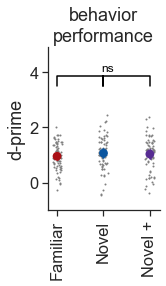

In [214]:
metric = 'dprime_trial_corrected'

stats = engaged_behavior_stats_stim.copy()
stats = stats[stats.behavior_session_id.isin(platform_expts.behavior_session_id.values)]
print(len(stats.behavior_session_id.unique()))

# stats = stats[stats.image_name!='omitted']

ppf.plot_behavior_metric_by_experience(stats, metric, title='behavior\nperformance', ylabel='d-prime', ylims=[-1, 3.5],
                                       best_image=False, show_containers=False,
                                       save_dir=save_dir, folder=folder, suffix=suffix+'_engaged_stim_based')

# for each cell type
for cell_type in cell_types: 
    ppf.plot_behavior_metric_by_experience(stats[stats.cell_type==cell_type], metric, title=cell_type, 
                                                 ylabel='d-prime', ylims=[-1, 3.5],
                                       best_image=False, show_containers=False,
                                       save_dir=save_dir, folder=folder, suffix=suffix+'_engaged_stim_based_'+cell_type)

In [216]:
# metric = 'dprime_trial_corrected'

# stats = engaged_behavior_stats_stim.copy()
# stats = stats[stats.behavior_session_id.isin(platform_expts.behavior_session_id.values)]
# print(len(stats.behavior_session_id.unique()))

# # stats = stats[stats.image_name!='omitted']

# ppf.plot_behavior_metric_by_experience(stats, metric, title='behavior\nperformance', ylabel='d-prime', ylims=[-1, 3.5],
#                                        best_image=False, show_containers=False,
#                                        save_dir=save_dir, folder=folder, suffix=suffix+'_engaged_stim_based')

In [91]:
%%time 

method = 'trial_based'
engaged_only = True
per_image = False

# folder = get_save_folder(method, engaged_only, per_image)

behavior_session_ids = behavior_sessions.index.values


original_engaged_behavior_stats_trial, problem_sessions = vbu.get_behavior_stats_for_sessions(behavior_session_ids, behavior_sessions, 
                                    method=method, engaged_only=engaged_only, per_image=per_image)


# original_behavior_stats = behavior_stats.copy()
engaged_behavior_stats_trial = original_engaged_behavior_stats_trial.merge(behavior_sessions, on='behavior_session_id')
len(engaged_behavior_stats_trial.mouse_id.unique())
 # remove 4x2 sessions
# engaged_behavior_stats = engaged_behavior_stats[engaged_behavior_stats.project_code!='VisualBehaviorMultiscope4areasx2d']

  0%|                                                                                 | 2/2943 [00:00<03:05, 15.87it/s]

loading for 760808911
loading for 761294708
loading for 761730617
loading for 762067130


  0%|▏                                                                                | 5/2943 [00:00<02:32, 19.31it/s]

loading for 762418364
loading for 763012686
loading for 763661704
loading for 764319580


  0%|▎                                                                               | 10/2943 [00:00<02:35, 18.81it/s]

loading for 764696952
loading for 765208332
loading for 765793356
loading for 766532213


  1%|▍                                                                               | 15/2943 [00:00<02:34, 18.94it/s]

loading for 766931048
loading for 767730839
loading for 768450504
loading for 769145833
loading for 769731277


  1%|▌                                                                               | 21/2943 [00:01<02:17, 21.26it/s]

loading for 770215042
loading for 771040969
loading for 771902184
loading for 772475707
loading for 773391809
loading for 774120511


  1%|▋                                                                               | 27/2943 [00:01<02:03, 23.55it/s]

loading for 774679623
loading for 775291372
loading for 776988190
loading for 778010119
loading for 778888558
loading for 779712859


  1%|▉                                                                               | 33/2943 [00:01<01:57, 24.70it/s]

loading for 780479408
loading for 781938213
loading for 783217873
loading for 783959068
loading for 785382040
loading for 786007435


  1%|▉                                                                               | 36/2943 [00:01<02:07, 22.72it/s]

loading for 786938611
loading for 789008423
loading for 789870329
loading for 791248943


  1%|█▏                                                                              | 42/2943 [00:02<02:24, 20.03it/s]

loading for 791904071
loading for 792680306
loading for 793485674
loading for 794968300
loading for 795742990


  2%|█▏                                                                              | 45/2943 [00:02<02:26, 19.77it/s]

loading for 796052844
loading for 796251270
loading for 798126878
loading for 772286394


  2%|█▎                                                                              | 50/2943 [00:02<02:47, 17.31it/s]

loading for 773510999
loading for 774208555
loading for 774767072
loading for 775344511


  2%|█▍                                                                              | 55/2943 [00:02<02:31, 19.09it/s]

loading for 775925580
loading for 777061425
loading for 778119826
loading for 778959204
loading for 779580423
loading for 780351711


  2%|█▋                                                                              | 61/2943 [00:03<02:26, 19.69it/s]

loading for 781727422
loading for 783059206
loading for 783971649
loading for 785376297


  2%|█▊                                                                              | 66/2943 [00:03<02:23, 20.01it/s]

loading for 785868918
loading for 786841415
loading for 788864720
loading for 789946754
loading for 791278700


  2%|█▉                                                                              | 69/2943 [00:03<02:30, 19.07it/s]

loading for 791769447
loading for 792477679
loading for 793153175
loading for 794071128
loading for 794673280


  3%|██                                                                              | 75/2943 [00:03<02:27, 19.41it/s]

loading for 795431009
loading for 796031509
loading for 797170547
loading for 791877093


  3%|██▏                                                                             | 79/2943 [00:03<02:36, 18.25it/s]

loading for 792689261
loading for 793414389
loading for 794295959
loading for 794977379


  3%|██▎                                                                             | 84/2943 [00:04<02:33, 18.65it/s]

loading for 795854559
loading for 799051310
loading for 799922316
loading for 800299366


  3%|██▎                                                                             | 86/2943 [00:04<02:31, 18.92it/s]

loading for 800922511
loading for 802988132
loading for 803351520
loading for 804929649
loading for 805535249


  3%|██▌                                                                             | 92/2943 [00:04<02:17, 20.76it/s]

loading for 806109931
loading for 806792366
loading for 807356557
loading for 808324301
loading for 808883789


  3%|██▌                                                                             | 95/2943 [00:04<02:08, 22.14it/s]

loading for 809358811
loading for 810405357
loading for 811303680
loading for 811817467


  3%|██▋                                                                            | 101/2943 [00:05<02:18, 20.59it/s]

loading for 812955256
loading for 816417578
loading for 817139151
loading for 818485496
loading for 819094295


  4%|██▊                                                                            | 107/2943 [00:05<02:07, 22.27it/s]

loading for 791875850
loading for 792689257
loading for 793409670
loading for 794295950
loading for 794977383


  4%|██▉                                                                            | 110/2943 [00:05<02:13, 21.17it/s]

loading for 795854555
loading for 799049628
loading for 799919887
loading for 800299362
loading for 800919728


  4%|███                                                                            | 116/2943 [00:05<02:13, 21.12it/s]

loading for 802364085
loading for 802988119
loading for 803347004
loading for 805639780


  4%|███▏                                                                           | 119/2943 [00:05<02:19, 20.21it/s]

loading for 806296598
loading for 806841326
loading for 807584876
loading for 808432167
loading for 809027309


  4%|███▎                                                                           | 125/2943 [00:06<02:08, 22.00it/s]

loading for 809427293
loading for 811355443
loading for 810584641
loading for 811356875
loading for 811831429


  4%|███▍                                                                           | 128/2943 [00:06<02:22, 19.77it/s]

loading for 812566400
loading for 812993078
loading for 813675618


  5%|███▌                                                                           | 134/2943 [00:06<02:22, 19.78it/s]

loading for 814546737
loading for 815015329
loading for 815511978
loading for 816381516
loading for 817182203


  5%|███▋                                                                           | 137/2943 [00:06<02:18, 20.22it/s]

loading for 818758572
loading for 819245147
loading for 819990491
loading for 821803380


  5%|███▊                                                                           | 140/2943 [00:06<02:33, 18.21it/s]

loading for 822409353
loading for 823241007
loading for 823968100
loading for 825012995


  5%|███▉                                                                           | 146/2943 [00:07<02:23, 19.53it/s]

loading for 825268982
loading for 825888541
loading for 826697158
loading for 827374757
loading for 828646658


  5%|███▉                                                                           | 149/2943 [00:07<02:14, 20.70it/s]

loading for 829138845
loading for 829578829
loading for 830255592
loading for 830832988


  5%|████▏                                                                          | 155/2943 [00:07<02:15, 20.54it/s]

loading for 831824426
loading for 832981154
loading for 835444110
loading for 835820832
loading for 836399024


  5%|████▎                                                                          | 161/2943 [00:07<02:05, 22.11it/s]

loading for 807062523
loading for 808103937
loading for 809588395
loading for 810266014
loading for 811140660


  6%|████▍                                                                          | 164/2943 [00:08<02:02, 22.72it/s]

loading for 811574124
loading for 812261209
loading for 812796028
loading for 814260983
loading for 814749891


  6%|████▌                                                                          | 170/2943 [00:08<02:11, 21.05it/s]

loading for 815865807
loading for 817053045
loading for 818539436
loading for 819065377


  6%|████▋                                                                          | 173/2943 [00:08<02:20, 19.78it/s]

loading for 819497998
loading for 820740400
loading for 821593979
loading for 822159346
loading for 822874578


  6%|████▊                                                                          | 179/2943 [00:08<02:27, 18.77it/s]

loading for 823496226
loading for 824566587
loading for 825269006


  6%|████▊                                                                          | 181/2943 [00:08<02:28, 18.66it/s]

loading for 825902239
loading for 826697162
loading for 827374765
loading for 828669593


  6%|████▉                                                                          | 184/2943 [00:09<02:23, 19.24it/s]

loading for 829138837
loading for 829714672
loading for 830419451
loading for 830959034


  6%|█████                                                                          | 190/2943 [00:09<02:20, 19.64it/s]

loading for 831905148
loading for 833100683
loading for 833946929
loading for 834928595
loading for 835547527


  7%|█████▏                                                                         | 195/2943 [00:09<02:21, 19.46it/s]

loading for 835940015
loading for 837108110
loading for 837512169
loading for 823922942


  7%|█████▎                                                                         | 198/2943 [00:09<02:07, 21.50it/s]

loading for 824972176
loading for 825527066
loading for 826338809
loading for 826841473
loading for 827977069


  7%|█████▍                                                                         | 204/2943 [00:10<02:12, 20.72it/s]

loading for 828842797
loading for 829281654
loading for 829902556
loading for 830592943
loading for 831259963


  7%|█████▋                                                                         | 210/2943 [00:10<02:03, 22.06it/s]

loading for 832009551
loading for 832522789
loading for 833252272
loading for 834059775
loading for 834886139
loading for 835608988


  7%|█████▊                                                                         | 216/2943 [00:10<02:07, 21.37it/s]

loading for 836099247
loading for 836769386
loading for 837202082
loading for 837629869


  7%|█████▉                                                                         | 220/2943 [00:10<01:54, 23.85it/s]

loading for 838486964
loading for 839220840
loading for 839566028
loading for 839918083
loading for 840583412
loading for 841431760


  8%|█████▉                                                                         | 223/2943 [00:10<02:04, 21.87it/s]

loading for 841830077
loading for 842387217
loading for 842821314
loading for 843397714


  8%|██████▏                                                                        | 229/2943 [00:11<01:59, 22.67it/s]

loading for 844197868
loading for 844880686
loading for 845564445
loading for 846272622
loading for 847022155


  8%|██████▎                                                                        | 235/2943 [00:11<02:00, 22.47it/s]

loading for 847829598
loading for 848519645
loading for 849073265
loading for 849635376
loading for 850977753
loading for 851779746


  8%|██████▍                                                                        | 242/2943 [00:11<01:42, 26.22it/s]

loading for 852468381
loading for 853168204
loading for 853875502
loading for 854563857
loading for 855421865
loading for 855973498


  8%|██████▌                                                                        | 245/2943 [00:11<01:53, 23.79it/s]

loading for 856717282
loading for 857612105
loading for 859065627
loading for 859735311
loading for 860665051


  9%|██████▋                                                                        | 251/2943 [00:12<01:56, 23.07it/s]

loading for 861788094
loading for 863571072
loading for 864139911
loading for 864824449
loading for 865482857


  9%|██████▉                                                                        | 257/2943 [00:12<02:04, 21.65it/s]

loading for 866333758
loading for 867041502
loading for 867977775
loading for 868721114


  9%|██████▉                                                                        | 260/2943 [00:12<02:08, 20.86it/s]

loading for 869639141
loading for 870960890
loading for 872062433
loading for 873002413


  9%|███████▏                                                                       | 266/2943 [00:12<01:55, 23.13it/s]

loading for 873750535
loading for 874681118
loading for 875414332
loading for 876765708
loading for 877346183
loading for 877925816


  9%|███████▏                                                                       | 269/2943 [00:12<01:54, 23.41it/s]

loading for 878671068
loading for 879974471
loading for 880668519
loading for 881278000
loading for 882256127


  9%|███████▍                                                                       | 275/2943 [00:13<02:04, 21.37it/s]

loading for 882748184
loading for 884596128
loading for 885492180
loading for 886322595
loading for 886926935


  9%|███████▍                                                                       | 278/2943 [00:13<02:06, 21.11it/s]

loading for 888127012
loading for 890157940
loading for 820799656
loading for 821837682


 10%|███████▌                                                                       | 284/2943 [00:13<01:59, 22.32it/s]

loading for 822471786
loading for 823248638
loading for 823922950
loading for 824992804
loading for 825533866
loading for 826356747


 10%|███████▊                                                                       | 290/2943 [00:13<02:01, 21.85it/s]

loading for 826846303
loading for 827944014
loading for 828838236
loading for 829282785
loading for 829877552


 10%|███████▊                                                                       | 293/2943 [00:14<02:11, 20.13it/s]

loading for 830620126
loading for 832019583
loading for 832540845
loading for 833454420


 10%|████████                                                                       | 300/2943 [00:14<01:55, 22.80it/s]

loading for 834093014
loading for 834908481
loading for 835616503
loading for 836173885
loading for 836777468
loading for 837196627


 10%|████████▏                                                                      | 306/2943 [00:14<01:54, 23.03it/s]

loading for 837647722
loading for 838496122
loading for 839233516
loading for 839566049
loading for 839931485


 10%|████████▎                                                                      | 309/2943 [00:14<01:52, 23.36it/s]

loading for 840594518
loading for 841429687
loading for 841842210
loading for 842399625
loading for 842844413


 11%|████████▍                                                                      | 315/2943 [00:15<02:01, 21.67it/s]

loading for 843400443
loading for 844253929
loading for 845585105
loading for 846316916
loading for 847036338
loading for 847871771


 11%|████████▌                                                                      | 321/2943 [00:15<01:55, 22.78it/s]

loading for 848599542
loading for 849136474
loading for 849648618
loading for 850985993
loading for 851757903


 11%|████████▊                                                                      | 327/2943 [00:15<01:52, 23.31it/s]

loading for 852440775
loading for 853496105
loading for 827312851
loading for 828646634
loading for 829128279


 11%|████████▊                                                                      | 330/2943 [00:15<01:58, 21.97it/s]

loading for 829591790
loading for 830201482
loading for 830867799
loading for 831834820


 11%|████████▉                                                                      | 335/2943 [00:16<02:17, 18.96it/s]

loading for 832325815
loading for 832990071
loading for 833780803
loading for 834573980


 11%|█████████                                                                      | 338/2943 [00:16<02:20, 18.53it/s]

loading for 835448132
loading for 835865722
loading for 836522259


 12%|█████████▏                                                                     | 340/2943 [00:16<02:21, 18.38it/s]

loading for 837083666
loading for 837443225
loading for 838236165
loading for 839014738


 12%|█████████▎                                                                     | 346/2943 [00:16<02:13, 19.47it/s]

loading for 839479248
loading for 839854553
loading for 840330509
loading for 841185520
loading for 841730873


 12%|█████████▍                                                                     | 350/2943 [00:16<02:16, 18.94it/s]

loading for 842139320
loading for 842792100
loading for 843166865


 12%|█████████▌                                                                     | 355/2943 [00:17<02:05, 20.57it/s]

loading for 844234790
loading for 844875410
loading for 846248008
loading for 847048485
loading for 847867029
loading for 848575992


 12%|█████████▋                                                                     | 361/2943 [00:17<02:03, 20.97it/s]

loading for 849098851
loading for 850976604
loading for 853266283
loading for 831129394


 12%|█████████▊                                                                     | 364/2943 [00:17<01:53, 22.68it/s]

loading for 832021447
loading for 832544149
loading for 833328750
loading for 834087859
loading for 834903060


 12%|█████████▊                                                                     | 367/2943 [00:17<01:59, 21.51it/s]

loading for 835557296
loading for 836166694
loading for 836761653
loading for 837192567


 13%|██████████                                                                     | 373/2943 [00:17<02:02, 20.93it/s]

loading for 837638916
loading for 838496126
loading for 839234289
loading for 839566045
loading for 839939986


 13%|██████████▏                                                                    | 379/2943 [00:18<01:47, 23.83it/s]

loading for 840594514
loading for 841148118
loading for 841707177
loading for 842174399
loading for 842729895
loading for 843203333


 13%|██████████▎                                                                    | 382/2943 [00:18<01:57, 21.83it/s]

loading for 844164376
loading for 844849972
loading for 845441512
loading for 846194950


 13%|██████████▎                                                                    | 385/2943 [00:18<02:04, 20.59it/s]

loading for 846929750
loading for 848503804
loading for 853526948


 13%|██████████▍                                                                    | 391/2943 [00:18<02:23, 17.83it/s]

loading for 834587823
loading for 835451471
loading for 835867850
loading for 836522245
loading for 837083657


 13%|██████████▌                                                                    | 394/2943 [00:18<02:08, 19.80it/s]

loading for 837449223
loading for 838203784
loading for 838998362
loading for 839468826


 14%|██████████▋                                                                    | 400/2943 [00:19<02:03, 20.55it/s]

loading for 839837380
loading for 840330501
loading for 841191836
loading for 841730868
loading for 842139310


 14%|██████████▉                                                                    | 407/2943 [00:19<01:52, 22.51it/s]

loading for 842792094
loading for 843178897
loading for 844027594
loading for 844608277
loading for 845409652


 14%|███████████                                                                    | 410/2943 [00:19<02:05, 20.26it/s]

loading for 846051276
loading for 846791195
loading for 847613846


 14%|███████████                                                                    | 413/2943 [00:19<01:55, 21.83it/s]

loading for 848272657
loading for 848938321
loading for 849525884
loading for 850817466
loading for 851563931


 14%|███████████▏                                                                   | 419/2943 [00:20<01:46, 23.75it/s]

loading for 852235678
loading for 852974537
loading for 853505213
loading for 854283407
loading for 855826937


 14%|███████████▎                                                                   | 422/2943 [00:20<02:01, 20.78it/s]

loading for 857230827
loading for 837658854
loading for 838515247
loading for 839219841


 14%|███████████▍                                                                   | 425/2943 [00:20<02:02, 20.53it/s]

loading for 839565422
loading for 839912316
loading for 840581827
loading for 841426832


 15%|███████████▌                                                                   | 431/2943 [00:20<02:07, 19.76it/s]

loading for 841827774
loading for 842385277
loading for 842819933
loading for 843400453


 15%|███████████▋                                                                   | 434/2943 [00:20<02:04, 20.12it/s]

loading for 844199758
loading for 844908261
loading for 845572044
loading for 846331423


 15%|███████████▊                                                                   | 441/2943 [00:21<01:53, 22.02it/s]

loading for 847036328
loading for 847874940
loading for 848613406
loading for 849147676
loading for 849651275
loading for 850989832


 15%|███████████▉                                                                   | 444/2943 [00:21<01:54, 21.81it/s]

loading for 851773928
loading for 852451567
loading for 855200229
loading for 840598877


 15%|████████████                                                                   | 451/2943 [00:21<01:50, 22.63it/s]

loading for 841466830
loading for 841851097
loading for 842419799
loading for 842840144
loading for 843423171


 15%|████████████▏                                                                  | 454/2943 [00:21<01:55, 21.58it/s]

loading for 844229895
loading for 844945060
loading for 845594684
loading for 846284880


 16%|████████████▎                                                                  | 457/2943 [00:21<01:55, 21.51it/s]

loading for 847048490
loading for 847838131
loading for 848526511
loading for 848910243
loading for 849485548


 16%|████████████▍                                                                  | 463/2943 [00:22<01:57, 21.06it/s]

loading for 850810858
loading for 851471401
loading for 852202150
loading for 852966248
loading for 853875514


 16%|████████████▌                                                                  | 470/2943 [00:22<01:50, 22.46it/s]

loading for 854621677
loading for 855424348
loading for 857340041
loading for 857987666
loading for 858974731


 16%|████████████▋                                                                  | 473/2943 [00:22<01:51, 22.14it/s]

loading for 859775117
loading for 863610582
loading for 868070216
loading for 868658294


 16%|████████████▊                                                                  | 476/2943 [00:22<02:01, 20.39it/s]

loading for 869559097
loading for 854533487
loading for 855504136
loading for 856002607


 16%|████████████▉                                                                  | 482/2943 [00:23<02:03, 19.87it/s]

loading for 856732191
loading for 857555456
loading for 858240891
loading for 859032026


 16%|████████████▉                                                                  | 484/2943 [00:23<02:18, 17.77it/s]

loading for 859791558
loading for 860752803
loading for 861794699
loading for 862701465


 17%|█████████████                                                                  | 487/2943 [00:23<02:14, 18.20it/s]

loading for 863571054
loading for 864137547
loading for 864839176
loading for 865581941


 17%|█████████████▏                                                                 | 492/2943 [00:23<02:09, 18.88it/s]

loading for 866287088
loading for 866950070
loading for 867615529
loading for 868540333


 17%|█████████████▎                                                                 | 497/2943 [00:23<02:00, 20.34it/s]

loading for 869319414
loading for 870660821
loading for 871808378
loading for 872646068
loading for 873517635


 17%|█████████████▍                                                                 | 500/2943 [00:24<01:58, 20.66it/s]

loading for 874324533
loading for 875471358
cant load stats for 875471358
loading for 876574139
loading for 850970486
loading for 851843550


 17%|█████████████▌                                                                 | 507/2943 [00:24<01:42, 23.83it/s]

loading for 852507945
loading for 853260939
loading for 853886146
loading for 855459012
loading for 855980937


 17%|█████████████▊                                                                 | 514/2943 [00:24<01:44, 23.31it/s]

loading for 856719615
loading for 857504898
loading for 858250763
loading for 859049298
loading for 859784868


 18%|█████████████▉                                                                 | 517/2943 [00:24<01:51, 21.74it/s]

loading for 860836980
loading for 861789935
loading for 862716913
loading for 863614836


 18%|██████████████                                                                 | 523/2943 [00:25<01:44, 23.26it/s]

loading for 864260028
loading for 864813130
loading for 865460179
loading for 866296478
loading for 866999677


 18%|██████████████                                                                 | 526/2943 [00:25<01:39, 24.33it/s]

loading for 867615541
loading for 868555361
loading for 869334643
loading for 870592115
loading for 871808394


 18%|██████████████▎                                                                | 532/2943 [00:25<01:37, 24.70it/s]

loading for 872626160
loading for 873695653
loading for 874699922
loading for 875440936
loading for 876678452
loading for 877617747


 18%|██████████████▎                                                                | 535/2943 [00:25<01:32, 26.05it/s]

loading for 878120101
loading for 879037269
loading for 880046522
loading for 880784794


 18%|██████████████▌                                                                | 541/2943 [00:25<01:41, 23.58it/s]

loading for 882256117
loading for 858104885
loading for 858900546
loading for 859601488
loading for 860247669


 18%|██████████████▌                                                                | 544/2943 [00:25<01:56, 20.66it/s]

loading for 861717498
loading for 862339401
loading for 863365105
loading for 863966979


 19%|██████████████▊                                                                | 550/2943 [00:26<01:47, 22.33it/s]

loading for 864665192
loading for 865114696
loading for 865887829
loading for 866906696
loading for 867505993


 19%|██████████████▊                                                                | 553/2943 [00:26<01:51, 21.43it/s]

loading for 868511825
loading for 869198966
loading for 870481699
loading for 871723063


 19%|███████████████                                                                | 562/2943 [00:26<01:40, 23.67it/s]

loading for 872607293
loading for 873440431
loading for 874324527
loading for 875020211
loading for 876448536
loading for 877855866


 19%|███████████████▏                                                               | 565/2943 [00:26<01:51, 21.35it/s]

loading for 878615859
loading for 879846629
loading for 880581639
loading for 881204796
loading for 882289836


 19%|███████████████▎                                                               | 571/2943 [00:27<01:40, 23.49it/s]

loading for 883851453
loading for 884598044
loading for 885404075
loading for 886376835
loading for 888213949
loading for 890021100


 20%|███████████████▍                                                               | 577/2943 [00:27<01:47, 22.02it/s]

loading for 893362730
loading for 894103623
loading for 895022326
loading for 895562386


 20%|███████████████▌                                                               | 580/2943 [00:27<01:44, 22.59it/s]

loading for 896561264
loading for 898432373
loading for 898874650
loading for 899390684
loading for 901999401


 20%|███████████████▋                                                               | 583/2943 [00:27<01:50, 21.45it/s]

loading for 903708760
loading for 904574580
loading for 906472625
loading for 907053876


 20%|███████████████▊                                                               | 589/2943 [00:28<01:53, 20.66it/s]

loading for 907900077
loading for 908533370
loading for 910207192
loading for 910829549
loading for 911904717


 20%|███████████████▉                                                               | 595/2943 [00:28<01:41, 23.05it/s]

loading for 913673477
loading for 914211263
loading for 914705301
loading for 915418411
loading for 916403851


 20%|████████████████                                                               | 598/2943 [00:28<01:55, 20.34it/s]

loading for 918103715
loading for 923410363
loading for 924472023
loading for 925084998


 20%|████████████████▏                                                              | 601/2943 [00:28<02:11, 17.77it/s]

loading for 862479694
loading for 863414647
loading for 864000195


 21%|████████████████▎                                                              | 607/2943 [00:28<02:00, 19.42it/s]

loading for 864729508
loading for 865288307
loading for 865953304
loading for 866971252


 21%|████████████████▎                                                              | 610/2943 [00:29<01:57, 19.92it/s]

loading for 867649878
loading for 868546763
loading for 869311954
loading for 870592103
loading for 871782387


 21%|████████████████▌                                                              | 616/2943 [00:29<01:49, 21.34it/s]

loading for 872720256
loading for 873530279
loading for 874295478
loading for 875020129
loading for 876521253


 21%|████████████████▌                                                              | 619/2943 [00:29<01:49, 21.27it/s]

loading for 877346192
loading for 877938181
loading for 878671074
loading for 879958654


 21%|████████████████▋                                                              | 622/2943 [00:29<02:01, 19.15it/s]

loading for 880647168
loading for 881253316
loading for 882233951


 21%|████████████████▊                                                              | 627/2943 [00:30<02:07, 18.13it/s]

loading for 882679635
loading for 883632948
loading for 884560033
loading for 885418521


 21%|████████████████▉                                                              | 632/2943 [00:30<01:56, 19.83it/s]

loading for 886262841
loading for 886900197
loading for 889183454
loading for 890054551
loading for 891504476


 22%|█████████████████                                                              | 637/2943 [00:30<01:57, 19.55it/s]

loading for 892413871
loading for 893359124
loading for 894215849
loading for 894994111


 22%|█████████████████▏                                                             | 640/2943 [00:30<01:51, 20.63it/s]

loading for 896543686
loading for 898461372
loading for 898890800
loading for 899461485
loading for 902028378
loading for 902822538


 22%|█████████████████▎                                                             | 647/2943 [00:30<01:42, 22.31it/s]

loading for 904625819
loading for 907035965
loading for 907995400
loading for 908564873


 22%|█████████████████▍                                                             | 650/2943 [00:31<01:44, 22.02it/s]

loading for 910249985
loading for 911361486
loading for 912159483
loading for 913921659
loading for 914411174


 22%|█████████████████▌                                                             | 653/2943 [00:31<01:47, 21.39it/s]

loading for 914871449
loading for 915739774
loading for 916704634
loading for 917595407


 22%|█████████████████▋                                                             | 659/2943 [00:31<01:50, 20.59it/s]

loading for 918474069
loading for 919104267
loading for 920015895
loading for 920839478
loading for 922012422


 23%|█████████████████▊                                                             | 665/2943 [00:31<01:49, 20.89it/s]

loading for 923834852
loading for 924759623
loading for 925603486
loading for 927905748


 23%|█████████████████▉                                                             | 668/2943 [00:31<01:48, 20.95it/s]

loading for 929551055
loading for 935301109
loading for 936273485
loading for 862730050
loading for 863657189


 23%|██████████████████                                                             | 672/2943 [00:32<01:37, 23.25it/s]

loading for 864236370
loading for 864809053
loading for 865443418
loading for 866300303
loading for 867045079


 23%|██████████████████▏                                                            | 678/2943 [00:32<01:40, 22.50it/s]

loading for 867977763
loading for 868704504
loading for 869615887
loading for 870960882
loading for 872864902


 23%|██████████████████▎                                                            | 684/2943 [00:32<01:38, 22.98it/s]

loading for 873729011
loading for 874691139
loading for 875402170
loading for 876701397
loading for 877524045
loading for 878137744


 23%|██████████████████▍                                                            | 687/2943 [00:32<01:42, 21.94it/s]

loading for 879003593
loading for 880088387
loading for 881416618
loading for 882373648


 24%|██████████████████▌                                                            | 693/2943 [00:33<01:50, 20.39it/s]

loading for 882785348
loading for 883984332
loading for 884750162
loading for 885540222
loading for 886440427


 24%|██████████████████▊                                                            | 699/2943 [00:33<01:38, 22.80it/s]

loading for 886931452
loading for 888282572
loading for 889443507
loading for 890355790
loading for 891618314


 24%|██████████████████▊                                                            | 702/2943 [00:33<01:40, 22.34it/s]

loading for 892491402
loading for 893540605
loading for 894466746
loading for 895241719


 24%|███████████████████                                                            | 708/2943 [00:33<01:38, 22.67it/s]

loading for 895877676
loading for 896969091
loading for 898658063
loading for 899685557
loading for 900226857


 24%|███████████████████                                                            | 711/2943 [00:33<01:47, 20.80it/s]

loading for 901340457
loading for 902244344
loading for 902962312
loading for 904899490


 24%|███████████████████▏                                                           | 717/2943 [00:34<01:43, 21.59it/s]

loading for 906641078
loading for 908092560
loading for 910381299
loading for 911016296
loading for 911541959


 25%|███████████████████▍                                                           | 723/2943 [00:34<01:34, 23.58it/s]

loading for 912902650
loading for 913850438
loading for 914336989
loading for 914828503
loading for 915609195
loading for 916614400


 25%|███████████████████▍                                                           | 726/2943 [00:34<01:30, 24.56it/s]

loading for 917500273
loading for 918451984
loading for 919022193
loading for 919895633
loading for 920807985


 25%|███████████████████▋                                                           | 732/2943 [00:34<01:38, 22.47it/s]

loading for 921873454
loading for 923757660
loading for 924739087
loading for 926621793


 25%|███████████████████▋                                                           | 735/2943 [00:34<01:40, 22.02it/s]

loading for 927652117
loading for 928654503
loading for 929522558
loading for 930344462
loading for 932960096


 25%|███████████████████▉                                                           | 741/2943 [00:35<01:45, 20.82it/s]

loading for 933939891
loading for 935038748
loading for 936159430
loading for 937645038


 25%|███████████████████▉                                                           | 744/2943 [00:35<01:41, 21.68it/s]

loading for 938729036
loading for 940017429
loading for 941802699
loading for 942814025
loading for 943833533


 26%|████████████████████▏                                                          | 751/2943 [00:35<01:32, 23.65it/s]

loading for 945033994
loading for 947336783
loading for 948225040
loading for 949348713
loading for 950188644


 26%|████████████████████▏                                                          | 754/2943 [00:35<01:48, 20.23it/s]

loading for 862245493
loading for 863368489
loading for 863966974
loading for 864665204
loading for 865131331


 26%|████████████████████▍                                                          | 760/2943 [00:36<01:52, 19.36it/s]

loading for 865887821
loading for 866909432
loading for 867521015


 26%|████████████████████▍                                                          | 763/2943 [00:36<01:59, 18.24it/s]

loading for 868513545
loading for 869214215
loading for 870481685
loading for 871728970


 26%|████████████████████▌                                                          | 766/2943 [00:36<02:01, 17.88it/s]

loading for 872609185
loading for 873449838
loading for 874333572
loading for 875020175


 26%|████████████████████▋                                                          | 772/2943 [00:36<01:50, 19.58it/s]

loading for 876448528
loading for 877855879
loading for 878615867
loading for 879854787
loading for 880590869


 26%|████████████████████▊                                                          | 775/2943 [00:36<01:48, 19.94it/s]

loading for 881210690
loading for 882291265
loading for 882736270
loading for 883857883


 26%|████████████████████▉                                                          | 778/2943 [00:37<01:54, 18.83it/s]

loading for 884605735
loading for 885404024
loading for 886382175
loading for 888218684


 27%|█████████████████████                                                          | 784/2943 [00:37<01:45, 20.55it/s]

loading for 890021090
loading for 893608687
loading for 894495169
loading for 895278567
loading for 895809864


 27%|█████████████████████▏                                                         | 787/2943 [00:37<01:47, 20.13it/s]

loading for 896882463
loading for 898665096
loading for 898938920
loading for 900227468


 27%|█████████████████████▎                                                         | 793/2943 [00:37<01:51, 19.25it/s]

loading for 901316636
loading for 902211897
loading for 902995627
loading for 903977177


 27%|█████████████████████▍                                                         | 797/2943 [00:38<01:53, 18.85it/s]

loading for 904922800
loading for 906658064
loading for 907327499
loading for 908122381


 27%|█████████████████████▌                                                         | 802/2943 [00:38<01:41, 21.02it/s]

loading for 912640306
loading for 866287136
loading for 867036293
loading for 867961854
loading for 868653129


 27%|█████████████████████▋                                                         | 806/2943 [00:38<01:27, 24.42it/s]

loading for 869623244
loading for 870935142
loading for 872043024
loading for 872979424
loading for 873739031
loading for 874654280


 28%|█████████████████████▊                                                         | 812/2943 [00:38<01:31, 23.35it/s]

loading for 875385921
loading for 876737442
loading for 877558833
loading for 878245978
loading for 878993255


 28%|█████████████████████▉                                                         | 818/2943 [00:38<01:33, 22.74it/s]

loading for 880191880
loading for 880775454
loading for 881425509
loading for 882401590
loading for 883756380


 28%|██████████████████████                                                         | 821/2943 [00:39<01:37, 21.66it/s]

loading for 884552901
loading for 885410929
loading for 886257016
loading for 886838602


 28%|██████████████████████▏                                                        | 827/2943 [00:39<01:30, 23.29it/s]

loading for 888033338
loading for 889175194
loading for 890033129
loading for 891446789
loading for 892387261


 28%|██████████████████████▎                                                        | 830/2943 [00:39<01:29, 23.50it/s]

loading for 893344360
loading for 894083470
loading for 898440124
loading for 866128606


 28%|██████████████████████▍                                                        | 836/2943 [00:39<01:36, 21.73it/s]

loading for 866971269
loading for 867645566
loading for 868531777
loading for 869311972
loading for 870579061


 29%|██████████████████████▌                                                        | 842/2943 [00:40<01:31, 22.98it/s]

loading for 871782397
loading for 872690218
loading for 873537911
loading for 874416985
loading for 875020203


 29%|██████████████████████▋                                                        | 846/2943 [00:40<01:23, 25.18it/s]

loading for 876651891
loading for 877487375
loading for 878179382
loading for 878771403
loading for 879969002


 29%|██████████████████████▊                                                        | 849/2943 [00:40<01:33, 22.39it/s]

loading for 880644824
loading for 881251187
loading for 882219267
loading for 882677813


 29%|██████████████████████▉                                                        | 855/2943 [00:40<01:34, 22.07it/s]

loading for 883632956
loading for 884560064
loading for 885410934
loading for 886250995
loading for 887006111


 29%|███████████████████████                                                        | 858/2943 [00:40<01:45, 19.82it/s]

loading for 888163519
loading for 889388078
loading for 890625596
loading for 891605682
loading for 892526544


 29%|███████████████████████▏                                                       | 864/2943 [00:41<01:39, 20.90it/s]

loading for 893488330
loading for 894368064
loading for 870987812
loading for 872953842
loading for 873774125
cant load stats for 873774125
loading for 874790261


 29%|███████████████████████▎                                                       | 868/2943 [00:41<01:23, 24.73it/s]

loading for 875207834
loading for 876821726
loading for 877603209
loading for 878245989


 30%|███████████████████████▍                                                       | 871/2943 [00:41<01:39, 20.81it/s]

loading for 879003606
loading for 880088400
loading for 881416637


 30%|███████████████████████▌                                                       | 876/2943 [00:41<02:01, 17.08it/s]

loading for 882373653
loading for 882781075
loading for 883986743
loading for 884776248


 30%|███████████████████████▋                                                       | 882/2943 [00:42<01:48, 18.91it/s]

loading for 885540237
loading for 886442346
loading for 886946944
loading for 888295170


 30%|███████████████████████▊                                                       | 885/2943 [00:42<01:41, 20.23it/s]

loading for 889468960
loading for 890408602
loading for 891635659
loading for 891635667
loading for 892510304


 30%|███████████████████████▉                                                       | 891/2943 [00:42<01:38, 20.79it/s]

loading for 893560763
loading for 894481319
loading for 895248933
loading for 895896343


 30%|███████████████████████▉                                                       | 894/2943 [00:42<01:40, 20.43it/s]

loading for 896995828
loading for 898667252
loading for 899700579
loading for 900231059
loading for 901363879


 31%|████████████████████████▏                                                      | 900/2943 [00:42<01:26, 23.54it/s]

loading for 902260156
loading for 902975505
loading for 904922810
loading for 906668549
loading for 908104455


 31%|████████████████████████▏                                                      | 903/2943 [00:43<01:35, 21.33it/s]

loading for 910393217
loading for 911016285
loading for 911541950
loading for 912223787


 31%|████████████████████████▍                                                      | 909/2943 [00:43<01:33, 21.85it/s]

loading for 912902619
loading for 913850450
loading for 914339617
loading for 914831000


 31%|████████████████████████▍                                                      | 912/2943 [00:43<01:37, 20.94it/s]

loading for 915609216
loading for 916617096
loading for 917500256
loading for 918451994


 31%|████████████████████████▌                                                      | 915/2943 [00:43<01:39, 20.43it/s]

loading for 919025442
loading for 920901263
loading for 921979060
loading for 923757653


 31%|████████████████████████▋                                                      | 921/2943 [00:43<01:38, 20.58it/s]

loading for 924739774
loading for 926621788
loading for 927652110
loading for 928654491
loading for 929524423
loading for 930344469


 31%|████████████████████████▉                                                      | 927/2943 [00:44<01:31, 21.93it/s]

loading for 932960104
loading for 933954934
loading for 935045761
loading for 936083473
loading for 937706038


 32%|████████████████████████▉                                                      | 930/2943 [00:44<01:35, 21.08it/s]

loading for 938794488
loading for 939985541
loading for 940755050
loading for 941734036
loading for 942767530


 32%|█████████████████████████▏                                                     | 936/2943 [00:44<01:38, 20.34it/s]

loading for 944125005
loading for 945075740
loading for 947988590
loading for 949201674


 32%|█████████████████████████▏                                                     | 939/2943 [00:44<01:40, 19.98it/s]

loading for 949973686
loading for 951520319
loading for 952554548
loading for 953982960


 32%|█████████████████████████▎                                                     | 944/2943 [00:45<01:45, 18.88it/s]

loading for 956010809
loading for 957032492
loading for 958234742
loading for 958888263


 32%|█████████████████████████▍                                                     | 949/2943 [00:45<01:40, 19.80it/s]

loading for 959681045
loading for 875126982
loading for 876823447
loading for 877605077


 32%|█████████████████████████▌                                                     | 951/2943 [00:45<01:43, 19.25it/s]

loading for 878245966
loading for 879074585
loading for 880174939
loading for 881450253


 32%|█████████████████████████▋                                                     | 955/2943 [00:45<01:58, 16.77it/s]

loading for 882426675
loading for 882833335
loading for 884004562
loading for 884776271


 33%|█████████████████████████▋                                                     | 959/2943 [00:45<01:54, 17.31it/s]

loading for 885598412
loading for 886446962
loading for 886953901
loading for 888298590


 33%|█████████████████████████▊                                                     | 963/2943 [00:46<01:50, 17.94it/s]

loading for 889478291
loading for 890408635
loading for 891635663
loading for 892525019
loading for 893560739


 33%|█████████████████████████▉                                                     | 968/2943 [00:46<01:41, 19.46it/s]

loading for 894481291
loading for 895262003
loading for 895896368
loading for 896995823


 33%|██████████████████████████                                                     | 972/2943 [00:46<02:02, 16.07it/s]

loading for 898682070
loading for 899742869
loading for 901424076
loading for 902328548


 33%|██████████████████████████▏                                                    | 975/2943 [00:46<01:46, 18.41it/s]

loading for 903098779
loading for 904954571
loading for 906726720


 33%|██████████████████████████▎                                                    | 979/2943 [00:47<02:13, 14.76it/s]

loading for 908165653
loading for 910448027
loading for 911061160


 33%|██████████████████████████▍                                                    | 983/2943 [00:47<02:20, 13.91it/s]

loading for 911581364
loading for 912318840
loading for 913014398


 33%|██████████████████████████▍                                                    | 985/2943 [00:47<02:11, 14.94it/s]

loading for 913917929
loading for 914408296
loading for 914859356
loading for 915690413


 34%|██████████████████████████▌                                                    | 989/2943 [00:47<02:03, 15.87it/s]

loading for 916673577
loading for 917600513
loading for 918448801
loading for 919022174


 34%|██████████████████████████▋                                                    | 995/2943 [00:48<01:37, 19.96it/s]

loading for 919890884
loading for 920807973
loading for 921873450
loading for 923750087
loading for 924740575


 34%|██████████████████████████▊                                                    | 998/2943 [00:48<01:48, 17.84it/s]

loading for 926614379
loading for 927643982
loading for 928647601
loading for 929522554


 34%|██████████████████████████▌                                                   | 1003/2943 [00:48<01:43, 18.67it/s]

loading for 930376122
loading for 931913977
loading for 932628715
loading for 933604243
loading for 934812249


 34%|██████████████████████████▋                                                   | 1009/2943 [00:48<01:27, 22.11it/s]

loading for 935653479
loading for 937395157
loading for 938339083
loading for 939533442
loading for 940628402


 34%|██████████████████████████▊                                                   | 1012/2943 [00:48<01:39, 19.32it/s]

loading for 941425961
loading for 942350598
loading for 875155219
loading for 876829777


 34%|██████████████████████████▉                                                   | 1015/2943 [00:49<01:44, 18.49it/s]

loading for 877607698
loading for 878251933
loading for 879074574
loading for 880181164


 35%|███████████████████████████                                                   | 1020/2943 [00:49<01:43, 18.55it/s]

loading for 881450232
loading for 882426670
loading for 882844402
loading for 884070037


 35%|███████████████████████████                                                   | 1023/2943 [00:49<01:48, 17.69it/s]

loading for 884846935
loading for 885609778
loading for 886472241


 35%|███████████████████████████▏                                                  | 1028/2943 [00:49<01:41, 18.88it/s]

loading for 887175302
loading for 888346887
loading for 889536668
loading for 890555457
loading for 891724311


 35%|███████████████████████████▍                                                  | 1034/2943 [00:50<01:33, 20.49it/s]

loading for 893564091
loading for 894481299
loading for 895256170
loading for 895902286
loading for 897002967


 35%|███████████████████████████▍                                                  | 1037/2943 [00:50<01:44, 18.29it/s]

loading for 898668828
loading for 899700587
loading for 900231063
loading for 901363886


 35%|███████████████████████████▋                                                  | 1043/2943 [00:50<01:32, 20.61it/s]

loading for 902260148
loading for 902975514
loading for 904922795
loading for 906668545
loading for 908109320
loading for 910393226
loading for 911019327


 36%|███████████████████████████▊                                                  | 1048/2943 [00:50<01:46, 17.84it/s]

loading for 911543418
loading for 912223793
loading for 912223799
loading for 912902659
loading for 913854181


 36%|███████████████████████████▉                                                  | 1052/2943 [00:50<01:33, 20.25it/s]

loading for 914339627
loading for 914831033
loading for 915609229
loading for 916617112


 36%|████████████████████████████                                                  | 1058/2943 [00:51<01:36, 19.53it/s]

loading for 917506393
loading for 918454529
loading for 919025470
loading for 919902020


 36%|████████████████████████████                                                  | 1061/2943 [00:51<01:33, 20.03it/s]

loading for 920813990
loading for 921879360
loading for 923877874
loading for 924757055


 36%|████████████████████████████▏                                                 | 1064/2943 [00:51<01:32, 20.39it/s]

loading for 926621779
loading for 927643992
loading for 928647605
loading for 929522550


 36%|████████████████████████████▎                                                 | 1070/2943 [00:51<01:39, 18.84it/s]

loading for 930335512
loading for 931488919
loading for 932596575
loading for 933472975
loading for 935601725


 37%|████████████████████████████▍                                                 | 1075/2943 [00:52<01:38, 18.89it/s]

loading for 937442661
loading for 938425882
loading for 939537734
loading for 940553228


 37%|████████████████████████████▌                                                 | 1077/2943 [00:52<01:53, 16.47it/s]

loading for 941457567
loading for 942329079
loading for 943479988
loading for 944823947


 37%|████████████████████████████▋                                                 | 1083/2943 [00:52<01:41, 18.26it/s]

loading for 882765152
loading for 883908190
loading for 884881862
loading for 885609760


 37%|████████████████████████████▊                                                 | 1087/2943 [00:52<01:41, 18.27it/s]

loading for 886424035
loading for 887142121
loading for 888298597
loading for 889478282


 37%|████████████████████████████▊                                                 | 1089/2943 [00:52<01:45, 17.61it/s]

loading for 890578468
loading for 891752782
loading for 892597881
loading for 893551176


 37%|█████████████████████████████                                                 | 1095/2943 [00:53<01:47, 17.21it/s]

loading for 894489950
loading for 895248904
loading for 895947603
loading for 896945902


 37%|█████████████████████████████                                                 | 1097/2943 [00:53<01:49, 16.88it/s]

loading for 898691674
loading for 898982250
loading for 901251663
loading for 902135840


 37%|█████████████████████████████▏                                                | 1103/2943 [00:53<01:46, 17.31it/s]

loading for 902871565
loading for 903842232
loading for 904844395


 38%|█████████████████████████████▎                                                | 1105/2943 [00:53<01:47, 17.06it/s]

loading for 908065760
loading for 888282565
loading for 889461157
loading for 890450001


 38%|█████████████████████████████▍                                                | 1110/2943 [00:54<01:45, 17.31it/s]

loading for 891789286
loading for 892645353
loading for 893600610


 38%|█████████████████████████████▍                                                | 1113/2943 [00:54<01:35, 19.14it/s]

loading for 894481279
loading for 895270564
loading for 896024686
loading for 896931325
loading for 898658079


 38%|█████████████████████████████▌                                                | 1116/2943 [00:54<01:29, 20.51it/s]

loading for 899685565
loading for 900226853
loading for 901358520
loading for 902255179


 38%|█████████████████████████████▋                                                | 1119/2943 [00:54<01:36, 18.81it/s]

loading for 902975500
loading for 904917894


 38%|█████████████████████████████▊                                                | 1123/2943 [00:55<02:07, 14.29it/s]

loading for 906658076
loading for 907195053
loading for 908930196


 38%|█████████████████████████████▊                                                | 1126/2943 [00:55<01:48, 16.68it/s]

loading for 910396133
loading for 911025799
loading for 911527254
loading for 912318850
loading for 913901536


 38%|█████████████████████████████▉                                                | 1131/2943 [00:55<01:48, 16.66it/s]

loading for 914353445
loading for 914852087
loading for 915667469
loading for 917618254


 39%|██████████████████████████████                                                | 1135/2943 [00:55<01:52, 16.07it/s]

loading for 918296132
loading for 921923865
loading for 922869624


 39%|██████████████████████████████▏                                               | 1140/2943 [00:55<01:39, 18.12it/s]

loading for 892283069
loading for 893354175
loading for 894078803
loading for 895009095


 39%|██████████████████████████████▎                                               | 1143/2943 [00:56<01:27, 20.53it/s]

loading for 895553474
loading for 896543705
loading for 898384915
loading for 898877946
loading for 899400242
loading for 900232144


 39%|██████████████████████████████▍                                               | 1149/2943 [00:56<01:24, 21.27it/s]

loading for 900936302
loading for 901876389
loading for 902810506
loading for 903693439


 39%|██████████████████████████████▌                                               | 1152/2943 [00:56<01:27, 20.57it/s]

loading for 907035950
loading for 907912571
loading for 908489409
loading for 909341448
loading for 910182303


 39%|██████████████████████████████▋                                               | 1158/2943 [00:56<01:23, 21.30it/s]

loading for 910812913
loading for 911375322
loading for 912008538
loading for 912570307
loading for 913677684


 40%|██████████████████████████████▊                                               | 1164/2943 [00:57<01:22, 21.56it/s]

loading for 914219174
loading for 914691372
loading for 915326103
loading for 916390399


 40%|██████████████████████████████▉                                               | 1167/2943 [00:57<01:17, 23.05it/s]

loading for 917261917
loading for 918098812
loading for 918860187
loading for 919485101
loading for 921759097
loading for 921503547


 40%|███████████████████████████████                                               | 1173/2943 [00:57<01:20, 21.95it/s]

loading for 922467930
loading for 923417336
loading for 924550325
loading for 925067625
loading for 926393694


 40%|███████████████████████████████▏                                              | 1179/2943 [00:57<01:17, 22.71it/s]

loading for 928361913
loading for 904942194
loading for 906720759
loading for 908165660


 40%|███████████████████████████████▎                                              | 1182/2943 [00:57<01:24, 20.83it/s]

loading for 910443509
loading for 911056351
loading for 911571923
loading for 912307836


 40%|███████████████████████████████▍                                              | 1185/2943 [00:58<01:32, 19.09it/s]

loading for 913008445
loading for 913908317
loading for 914402498
loading for 914857564


 40%|███████████████████████████████▍                                              | 1188/2943 [00:58<01:26, 20.35it/s]

loading for 915675582
loading for 916667034
loading for 917588238
loading for 918488020


 41%|███████████████████████████████▋                                              | 1194/2943 [00:58<01:28, 19.68it/s]

loading for 919082124
loading for 919989570
loading for 920892084
loading for 921964245
loading for 923744925


 41%|███████████████████████████████▋                                              | 1197/2943 [00:58<01:32, 18.95it/s]

loading for 924737598
loading for 926607088
loading for 927629370


 41%|███████████████████████████████▊                                              | 1202/2943 [00:58<01:23, 20.93it/s]

loading for 928633684
loading for 929519500
loading for 930319167
loading for 932960088
loading for 933954915
loading for 935053429


 41%|████████████████████████████████                                              | 1208/2943 [00:59<01:30, 19.19it/s]

loading for 936083459
loading for 937706048
loading for 938767948


 41%|████████████████████████████████                                              | 1210/2943 [00:59<01:34, 18.32it/s]

loading for 939977527
loading for 940755054
loading for 941734023
loading for 942767544


 41%|████████████████████████████████▏                                             | 1213/2943 [00:59<01:29, 19.27it/s]

loading for 944153204
loading for 945075756
loading for 947082734
loading for 948003540


 41%|████████████████████████████████▎                                             | 1219/2943 [00:59<01:24, 20.45it/s]

loading for 949182428
loading for 951453828
loading for 952657468
loading for 953952253
loading for 955962226
loading for 957454325


 42%|████████████████████████████████▍                                             | 1225/2943 [01:00<01:21, 20.98it/s]

loading for 958558082
loading for 959115465
loading for 960021127
loading for 960834330


 42%|████████████████████████████████▌                                             | 1228/2943 [01:00<01:34, 18.18it/s]

loading for 961246494
loading for 962346335
loading for 963237068
loading for 964109496


 42%|████████████████████████████████▋                                             | 1232/2943 [01:00<01:42, 16.68it/s]

loading for 965034185
loading for 965727499
loading for 966765494
loading for 901399302


 42%|████████████████████████████████▊                                             | 1237/2943 [01:00<01:30, 18.93it/s]

loading for 902323283
loading for 903101960
loading for 904950235
loading for 906720764
loading for 908159796


 42%|████████████████████████████████▉                                             | 1241/2943 [01:01<01:37, 17.48it/s]

loading for 910443504
loading for 911052612
loading for 911571901
loading for 912307828


 42%|████████████████████████████████▉                                             | 1245/2943 [01:01<01:42, 16.52it/s]

loading for 913001481
loading for 913908289
loading for 914402478


 42%|█████████████████████████████████▏                                            | 1250/2943 [01:01<01:31, 18.42it/s]

loading for 914855672
loading for 915675595
loading for 916667039
loading for 917588247


 43%|█████████████████████████████████▏                                            | 1253/2943 [01:01<01:27, 19.30it/s]

loading for 918486608
loading for 919082134
loading for 919985026
loading for 920888197


 43%|█████████████████████████████████▎                                            | 1258/2943 [01:01<01:24, 20.04it/s]

loading for 921959207
loading for 923845421
loading for 924752487
loading for 926725204
loading for 927751225


 43%|█████████████████████████████████▍                                            | 1261/2943 [01:02<01:28, 19.09it/s]

loading for 928751222
loading for 929539392
loading for 930443737
loading for 933034558
loading for 934070063


 43%|█████████████████████████████████▌                                            | 1267/2943 [01:02<01:26, 19.39it/s]

loading for 935150167
loading for 936169485
loading for 937790035
loading for 938884899


 43%|█████████████████████████████████▋                                            | 1272/2943 [01:02<01:21, 20.52it/s]

loading for 939970161
loading for 940757571
loading for 941726524
loading for 942767539


 43%|█████████████████████████████████▊                                            | 1276/2943 [01:02<01:17, 21.48it/s]

loading for 944124976
loading for 944971315
loading for 946284988
loading for 947372441
loading for 948320743


 43%|█████████████████████████████████▉                                            | 1279/2943 [01:02<01:15, 22.19it/s]

loading for 949402246
loading for 950265118
loading for 951696355
loading for 952944924
loading for 954198857


 44%|██████████████████████████████████                                            | 1285/2943 [01:03<01:13, 22.50it/s]

loading for 955094305
loading for 956454085
loading for 957435664
loading for 958532504
loading for 959051998


 44%|██████████████████████████████████▏                                           | 1288/2943 [01:03<01:12, 22.93it/s]

loading for 959982762
loading for 960796984
loading for 961226077
loading for 962206556


 44%|██████████████████████████████████▎                                           | 1294/2943 [01:03<01:20, 20.40it/s]

loading for 963153838
loading for 963940678
loading for 964999392
loading for 966735404
loading for 967449308


 44%|██████████████████████████████████▍                                           | 1297/2943 [01:03<01:23, 19.81it/s]

loading for 968334595
loading for 969339750
loading for 970877412
loading for 971950909


 44%|██████████████████████████████████▌                                           | 1303/2943 [01:04<01:19, 20.74it/s]

loading for 909256602
loading for 910258982
loading for 911346410
loading for 911927191


 44%|██████████████████████████████████▌                                           | 1306/2943 [01:04<01:19, 20.50it/s]

loading for 912570302
loading for 913694939
loading for 914219152
loading for 914708602
loading for 915429425


 45%|██████████████████████████████████▊                                           | 1312/2943 [01:04<01:14, 21.91it/s]

loading for 916437733
loading for 917317439
loading for 918172109
loading for 918881230
loading for 919586810


 45%|██████████████████████████████████▉                                           | 1318/2943 [01:04<01:14, 21.82it/s]

loading for 920528725
loading for 921566809
loading for 922540163
loading for 923445943
loading for 924544064


 45%|███████████████████████████████████                                           | 1321/2943 [01:04<01:23, 19.48it/s]

loading for 924985099
loading for 926434150
loading for 927423753
loading for 928263223
loading for 929309900


 45%|███████████████████████████████████▏                                          | 1327/2943 [01:05<01:22, 19.65it/s]

loading for 929767335
loading for 931526090
loading for 932547907
loading for 933456539


 45%|███████████████████████████████████▎                                          | 1333/2943 [01:05<01:19, 20.23it/s]

loading for 934707744
loading for 937457770
loading for 939536227
loading for 939765508
loading for 940553221


 45%|███████████████████████████████████▍                                          | 1336/2943 [01:05<01:15, 21.17it/s]

loading for 941597243
loading for 942197044
loading for 943358608
loading for 944698858
loading for 945645033
loading for 947038510


 46%|███████████████████████████████████▌                                          | 1342/2943 [01:05<01:11, 22.34it/s]

loading for 947948249
loading for 949182392
loading for 950000878
loading for 951459907
loading for 952610573


 46%|███████████████████████████████████▋                                          | 1345/2943 [01:06<01:17, 20.59it/s]

loading for 953991886
loading for 954603651
loading for 956171927
loading for 957030810


 46%|███████████████████████████████████▊                                          | 1351/2943 [01:06<01:20, 19.87it/s]

loading for 958254373
loading for 958884908
loading for 959640885
loading for 960501578


 46%|███████████████████████████████████▉                                          | 1354/2943 [01:06<01:21, 19.48it/s]

loading for 961226087
loading for 961819631
loading for 962922731
loading for 963663505


 46%|████████████████████████████████████                                          | 1359/2943 [01:06<01:19, 19.92it/s]

loading for 964871967
loading for 965505185
loading for 896394737
loading for 898384901
loading for 898876989


 46%|████████████████████████████████████▏                                         | 1366/2943 [01:07<01:07, 23.20it/s]

loading for 899400273
loading for 900232139
loading for 900936320
loading for 901876370
loading for 902810495


 47%|████████████████████████████████████▎                                         | 1369/2943 [01:07<01:13, 21.39it/s]

loading for 903693459
loading for 907035932
loading for 907899541
loading for 908468655


 47%|████████████████████████████████████▎                                         | 1372/2943 [01:07<01:23, 18.89it/s]

loading for 909291218
loading for 910182310
loading for 910799740


 47%|████████████████████████████████████▍                                         | 1374/2943 [01:07<01:27, 17.97it/s]

loading for 911361478
loading for 911815202
loading for 912588254
loading for 913741146


 47%|████████████████████████████████████▌                                         | 1380/2943 [01:07<01:21, 19.15it/s]

loading for 914265106
loading for 914726630
loading for 915454053
loading for 916450861
loading for 917331206


 47%|████████████████████████████████████▋                                         | 1386/2943 [01:08<01:15, 20.71it/s]

loading for 918202284
loading for 918900918
loading for 919442744
loading for 921364147


 47%|████████████████████████████████████▊                                         | 1389/2943 [01:08<01:11, 21.62it/s]

loading for 922449488
loading for 923364302
loading for 924492214
loading for 925016863
loading for 926393711


 47%|████████████████████████████████████▉                                         | 1394/2943 [01:08<01:23, 18.51it/s]

loading for 927419411
loading for 928279918
loading for 929354243
loading for 929836732


 48%|█████████████████████████████████████                                         | 1398/2943 [01:08<01:28, 17.52it/s]

loading for 932160990
loading for 932991298
loading for 934075957


 48%|█████████████████████████████████████▏                                        | 1401/2943 [01:08<01:25, 18.04it/s]

loading for 935129110
loading for 936153744
loading for 937783930
loading for 938789129


 48%|█████████████████████████████████████▏                                        | 1404/2943 [01:09<01:17, 19.75it/s]

loading for 940017421
loading for 941891140
loading for 942562699
loading for 944950609


 48%|█████████████████████████████████████▎                                        | 1408/2943 [01:09<01:28, 17.42it/s]

loading for 947311015
loading for 948206919
loading for 949337508
loading for 950157787


 48%|█████████████████████████████████████▍                                        | 1412/2943 [01:09<01:27, 17.54it/s]

loading for 952746230
loading for 954120560
loading for 936116165
loading for 937854150


 48%|█████████████████████████████████████▌                                        | 1416/2943 [01:09<01:26, 17.63it/s]

loading for 938889808
loading for 940154108
loading for 940779937
loading for 941896070


 48%|█████████████████████████████████████▋                                        | 1421/2943 [01:10<01:24, 17.98it/s]

loading for 942849916
loading for 944216879
loading for 945204293
loading for 946281668


 48%|█████████████████████████████████████▊                                        | 1425/2943 [01:10<01:28, 17.23it/s]

loading for 947385424
loading for 948148817
loading for 949182414


 49%|█████████████████████████████████████▊                                        | 1428/2943 [01:10<01:22, 18.44it/s]

loading for 949987080
loading for 951507102
loading for 953978404
loading for 955943003
loading for 957147348


 49%|█████████████████████████████████████▉                                        | 1433/2943 [01:10<01:16, 19.66it/s]

loading for 958888268
loading for 959675291
loading for 960488162
loading for 962191834
loading for 962984229


 49%|██████████████████████████████████████▏                                       | 1439/2943 [01:10<01:10, 21.46it/s]

loading for 963694974
loading for 964894591
loading for 937363104
loading for 939772185
loading for 940635435


 49%|██████████████████████████████████████▏                                       | 1442/2943 [01:11<01:09, 21.56it/s]

loading for 941700201
loading for 942412338
loading for 943559700
loading for 944845647


 49%|██████████████████████████████████████▍                                       | 1448/2943 [01:11<01:08, 21.90it/s]

loading for 945811327
loading for 947197212
loading for 948162486
loading for 949292490
loading for 950119814


 49%|██████████████████████████████████████▍                                       | 1451/2943 [01:11<01:08, 21.72it/s]

loading for 951565921
loading for 952752558
loading for 953978412
loading for 954603672


 50%|██████████████████████████████████████▌                                       | 1457/2943 [01:11<01:06, 22.51it/s]

loading for 956010816
loading for 957071478
loading for 958456204
loading for 958982193
loading for 959836077


 50%|██████████████████████████████████████▋                                       | 1460/2943 [01:11<01:06, 22.15it/s]

loading for 960697328
loading for 962191827
loading for 963114728
loading for 963923531
loading for 965016824


 50%|██████████████████████████████████████▊                                       | 1466/2943 [01:12<01:07, 22.03it/s]

loading for 966717522
loading for 967460086
loading for 968359999
loading for 969310457


 50%|███████████████████████████████████████                                       | 1472/2943 [01:12<01:01, 23.85it/s]

loading for 930435266
loading for 932176731
loading for 933004984
loading for 934182630
loading for 935222980


 50%|███████████████████████████████████████                                       | 1475/2943 [01:12<01:01, 23.82it/s]

loading for 936140741
loading for 937854140
loading for 938903319
loading for 939977516
loading for 940658765


 50%|███████████████████████████████████████▎                                      | 1481/2943 [01:12<01:01, 23.97it/s]

loading for 941776657
loading for 942737913
loading for 944191845
loading for 945187188
loading for 945868902
loading for 949480037


 51%|███████████████████████████████████████▍                                      | 1488/2943 [01:13<00:54, 26.66it/s]

loading for 950183210
loading for 952973407
loading for 954206178
loading for 955008634
loading for 956399048
loading for 957481370


 51%|███████████████████████████████████████▌                                      | 1491/2943 [01:13<00:58, 24.88it/s]

loading for 958526416
loading for 959016020
loading for 959836084
loading for 960713124
loading for 961226066
loading for 962154268


 51%|███████████████████████████████████████▋                                      | 1498/2943 [01:13<00:56, 25.43it/s]

loading for 963225593
loading for 964096322
loading for 965039884
loading for 966807640
loading for 967636314


 51%|███████████████████████████████████████▊                                      | 1504/2943 [01:13<01:05, 22.13it/s]

loading for 968516365
loading for 969423725
loading for 970035226
loading for 970869084


 51%|███████████████████████████████████████▉                                      | 1507/2943 [01:13<01:03, 22.63it/s]

loading for 971661805
loading for 972034557
loading for 972527218
loading for 973798798
loading for 974328452


 51%|████████████████████████████████████████                                      | 1513/2943 [01:14<01:01, 23.35it/s]

loading for 974899766
loading for 975455944
loading for 976199854
loading for 976952429
loading for 977746260


 52%|████████████████████████████████████████▏                                     | 1516/2943 [01:14<01:00, 23.48it/s]

loading for 978207251
loading for 978683883
loading for 979468313
loading for 980154562
loading for 982741262


 52%|████████████████████████████████████████▎                                     | 1522/2943 [01:14<00:59, 24.05it/s]

loading for 984071694
loading for 986191154
loading for 987041025
loading for 988137738
loading for 989139686
loading for 989523730


 52%|████████████████████████████████████████▍                                     | 1528/2943 [01:14<01:05, 21.60it/s]

loading for 990319706
loading for 990619461
loading for 990871215
loading for 991763993


 52%|████████████████████████████████████████▌                                     | 1531/2943 [01:14<01:11, 19.69it/s]

loading for 991997544
loading for 992251964
loading for 992417143
loading for 992816969


 52%|████████████████████████████████████████▊                                     | 1538/2943 [01:15<00:57, 24.28it/s]

loading for 993276262
loading for 993499029
loading for 993766500
loading for 993995204
loading for 994210659
loading for 994743822


 52%|████████████████████████████████████████▉                                     | 1545/2943 [01:15<00:49, 28.14it/s]

loading for 994894518
loading for 995142529
loading for 995379633
loading for 995570835
loading for 929533460
loading for 932160986
loading for 933049320


 53%|█████████████████████████████████████████                                     | 1548/2943 [01:15<00:51, 26.90it/s]

loading for 934082432
loading for 935199639
loading for 936163556
loading for 937854186
loading for 938889840


 53%|█████████████████████████████████████████▏                                    | 1554/2943 [01:15<00:55, 25.03it/s]

loading for 940145401
loading for 940779382
loading for 941896081
loading for 942849909
loading for 944216872
loading for 945184906


 53%|█████████████████████████████████████████▎                                    | 1560/2943 [01:16<01:03, 21.62it/s]

loading for 946263063
loading for 947355907
loading for 948309156
loading for 949394856
loading for 950250646


 53%|█████████████████████████████████████████▌                                    | 1566/2943 [01:16<01:01, 22.57it/s]

loading for 951687714
loading for 952923305
loading for 954192305
loading for 955079062
loading for 956433366


 53%|█████████████████████████████████████████▌                                    | 1569/2943 [01:16<01:06, 20.71it/s]

loading for 957412617
loading for 958519158
loading for 959031142
loading for 959959559
loading for 960783011


 53%|█████████████████████████████████████████▋                                    | 1572/2943 [01:16<01:03, 21.65it/s]

loading for 961223061
loading for 962230926
loading for 963204454


 54%|█████████████████████████████████████████▊                                    | 1577/2943 [01:17<01:18, 17.43it/s]

loading for 964140825
loading for 965056379
loading for 966794910
loading for 967582099


 54%|█████████████████████████████████████████▉                                    | 1582/2943 [01:17<01:07, 20.21it/s]

loading for 968526430
loading for 969418903
loading for 970075444
loading for 970881187
loading for 971674273


 54%|██████████████████████████████████████████                                    | 1585/2943 [01:17<01:06, 20.57it/s]

loading for 972058696
loading for 972540977
loading for 972775265
loading for 973461310


 54%|██████████████████████████████████████████                                    | 1588/2943 [01:17<01:07, 20.01it/s]

loading for 973777176
loading for 974330793
loading for 974785645


 54%|██████████████████████████████████████████▏                                   | 1593/2943 [01:17<01:19, 17.03it/s]

loading for 975358131
loading for 975412137
loading for 976175810
loading for 976719114
loading for 977838176


 54%|██████████████████████████████████████████▍                                   | 1599/2943 [01:18<01:05, 20.67it/s]

loading for 978108456
loading for 978647080
loading for 979414755
loading for 980102697
loading for 981957849


 54%|██████████████████████████████████████████▍                                   | 1602/2943 [01:18<01:06, 20.23it/s]

loading for 982722856
loading for 986176250
loading for 988099332
loading for 989036890


 55%|██████████████████████████████████████████▌                                   | 1608/2943 [01:18<01:04, 20.72it/s]

loading for 940592967
loading for 941560076
loading for 942394668
loading for 943546135
loading for 944913808
loading for 945818719


 55%|██████████████████████████████████████████▊                                   | 1614/2943 [01:18<01:01, 21.76it/s]

loading for 948148823
loading for 949265986
loading for 951537035
loading for 952752540
loading for 954055841
loading for 957033598


 55%|██████████████████████████████████████████▉                                   | 1620/2943 [01:19<00:59, 22.06it/s]

loading for 958535615
loading for 959067523
loading for 959883227
loading for 962318644
loading for 963227578


 55%|███████████████████████████████████████████                                   | 1626/2943 [01:19<00:55, 23.83it/s]

loading for 964137490
loading for 965075994
loading for 965760531
loading for 966835517
loading for 967660435


 55%|███████████████████████████████████████████▏                                  | 1629/2943 [01:19<00:55, 23.88it/s]

loading for 968564134
loading for 950223887
loading for 953020779
loading for 954246377
loading for 955110055


 56%|███████████████████████████████████████████▎                                  | 1635/2943 [01:19<01:00, 21.62it/s]

loading for 956509652
loading for 957231807
loading for 958591231
loading for 959067513
loading for 959901685


 56%|███████████████████████████████████████████▍                                  | 1638/2943 [01:19<01:04, 20.18it/s]

loading for 961131522
loading for 962230932
loading for 963299398
loading for 964154152


 56%|███████████████████████████████████████████▌                                  | 1644/2943 [01:20<01:06, 19.54it/s]

loading for 965069208
loading for 966886347
loading for 967713029
loading for 968577157
loading for 969506150


 56%|███████████████████████████████████████████▋                                  | 1647/2943 [01:20<01:00, 21.54it/s]

loading for 970087706
loading for 970969052
loading for 971687725
loading for 972119106


 56%|███████████████████████████████████████████▊                                  | 1653/2943 [01:20<01:02, 20.66it/s]

loading for 972543146
loading for 973772504
loading for 974309322
loading for 974891278
loading for 975500570


 56%|███████████████████████████████████████████▉                                  | 1656/2943 [01:20<01:05, 19.77it/s]

loading for 976149524
loading for 977010114
loading for 977827851
loading for 978216155


 56%|████████████████████████████████████████████                                  | 1661/2943 [01:21<01:10, 18.31it/s]

loading for 978729163
loading for 979468319
loading for 980154556
loading for 981687763


 57%|████████████████████████████████████████████▏                                 | 1665/2943 [01:21<01:09, 18.36it/s]

loading for 982542467
loading for 983310749
loading for 985778420
loading for 988866696
loading for 989340717


 57%|████████████████████████████████████████████▎                                 | 1672/2943 [01:21<00:56, 22.39it/s]

loading for 990193421
loading for 990520288
loading for 990775798
loading for 991662910
loading for 940587471


 57%|████████████████████████████████████████████▍                                 | 1675/2943 [01:21<01:01, 20.72it/s]

loading for 941560067
loading for 942394673
loading for 943546129
loading for 944913801


 57%|████████████████████████████████████████████▌                                 | 1681/2943 [01:22<00:57, 22.05it/s]

loading for 945818731
loading for 948126390
loading for 949250706
loading for 949997124
loading for 951520315


 57%|████████████████████████████████████████████▋                                 | 1684/2943 [01:22<00:59, 21.12it/s]

loading for 952729858
loading for 954005976
loading for 957030816
loading for 958234751


 57%|████████████████████████████████████████████▋                                 | 1687/2943 [01:22<01:03, 19.85it/s]

loading for 958892964
loading for 959653194
loading for 960486391
loading for 961107565


 57%|████████████████████████████████████████████▊                                 | 1692/2943 [01:22<01:08, 18.30it/s]

loading for 961769492
loading for 962814900
loading for 963555367
loading for 964866508
loading for 965479110


 58%|█████████████████████████████████████████████                                 | 1698/2943 [01:22<01:02, 19.82it/s]

loading for 966396577
loading for 967216790
loading for 968109978
loading for 969008237
loading for 969917470


 58%|█████████████████████████████████████████████                                 | 1701/2943 [01:23<01:01, 20.26it/s]

loading for 971527055
loading for 971885045
loading for 972390671
loading for 972754358


 58%|█████████████████████████████████████████████▏                                | 1706/2943 [01:23<01:07, 18.44it/s]

loading for 973339148
loading for 973683270
loading for 974107015


 58%|█████████████████████████████████████████████▎                                | 1708/2943 [01:23<01:11, 17.16it/s]

loading for 975212229
loading for 976033535
loading for 976559011
loading for 977378894


 58%|█████████████████████████████████████████████▍                                | 1714/2943 [01:23<01:06, 18.47it/s]

loading for 978098623
loading for 979217919
loading for 979782710
loading for 981683576
loading for 982558306


 58%|█████████████████████████████████████████████▌                                | 1720/2943 [01:24<00:57, 21.42it/s]

loading for 983268644
loading for 985792625
loading for 986714895
loading for 987832904
loading for 988854432


 59%|█████████████████████████████████████████████▋                                | 1723/2943 [01:24<01:02, 19.37it/s]

loading for 989362600
loading for 990207794
loading for 951719940
loading for 952933661


 59%|█████████████████████████████████████████████▊                                | 1728/2943 [01:24<01:04, 18.71it/s]

loading for 954192286
loading for 955079055
loading for 956433359
loading for 957418694


 59%|█████████████████████████████████████████████▉                                | 1733/2943 [01:24<01:01, 19.67it/s]

loading for 958522022
loading for 959031158
loading for 959982753
loading for 960796988


 59%|██████████████████████████████████████████████                                | 1736/2943 [01:24<01:01, 19.51it/s]

loading for 961226056
loading for 962248458
loading for 963215897
loading for 964147630
loading for 965061641


 59%|██████████████████████████████████████████████▏                               | 1742/2943 [01:25<01:00, 19.79it/s]

loading for 965760509
loading for 966814252
loading for 967603224
loading for 968536946


 59%|██████████████████████████████████████████████▏                               | 1745/2943 [01:25<00:55, 21.42it/s]

loading for 969441715
loading for 970078265
loading for 970895165
loading for 971678657
loading for 972058706
loading for 972542071


 59%|██████████████████████████████████████████████▍                               | 1751/2943 [01:25<00:59, 20.02it/s]

loading for 972773993
loading for 973496264
loading for 973794112
loading for 974902041


 60%|██████████████████████████████████████████████▍                               | 1754/2943 [01:25<01:09, 17.09it/s]

loading for 975498864
loading for 976215999
loading for 976558967


 60%|██████████████████████████████████████████████▋                               | 1760/2943 [01:26<00:57, 20.52it/s]

loading for 977870164
loading for 978216799
loading for 979345679
loading for 980261694
loading for 981954859


 60%|██████████████████████████████████████████████▋                               | 1763/2943 [01:26<00:58, 20.11it/s]

loading for 982741950
loading for 984071678
loading for 986234827
loading for 957464892


 60%|██████████████████████████████████████████████▉                               | 1769/2943 [01:26<00:51, 22.66it/s]

loading for 958598580
loading for 959122882
loading for 960053889
loading for 960838900
loading for 961239902


 60%|██████████████████████████████████████████████▉                               | 1772/2943 [01:26<00:58, 20.19it/s]

loading for 962230915
loading for 963207517
loading for 964148917


 60%|███████████████████████████████████████████████                               | 1775/2943 [01:26<00:59, 19.53it/s]

loading for 965061650
loading for 965760520
loading for 966814266
loading for 967428691


 60%|███████████████████████████████████████████████                               | 1778/2943 [01:27<01:00, 19.17it/s]

loading for 968198017
loading for 969423696
loading for 971671333
loading for 972018960


 61%|███████████████████████████████████████████████▎                              | 1783/2943 [01:27<00:58, 19.68it/s]

loading for 973440813
loading for 973744975
loading for 974282914
loading for 974634733


 61%|███████████████████████████████████████████████▎                              | 1785/2943 [01:27<00:59, 19.33it/s]

loading for 965556136
loading for 966522771
loading for 967216813
loading for 968124567


 61%|███████████████████████████████████████████████▍                              | 1790/2943 [01:27<01:02, 18.60it/s]

loading for 969033475
loading for 970703223
loading for 971496608
loading for 971885037


 61%|███████████████████████████████████████████████▌                              | 1795/2943 [01:27<00:56, 20.16it/s]

loading for 972429296
loading for 972676509
loading for 973339909
loading for 973683287
loading for 974129649


 61%|███████████████████████████████████████████████▋                              | 1801/2943 [01:28<00:58, 19.65it/s]

loading for 975171107
loading for 976006543
loading for 976517773
loading for 977412267


 61%|███████████████████████████████████████████████▊                              | 1804/2943 [01:28<00:56, 20.16it/s]

loading for 978087229
loading for 978554436
loading for 979231641
loading for 981675150


 61%|███████████████████████████████████████████████▉                              | 1807/2943 [01:28<01:00, 18.64it/s]

loading for 982534912
loading for 983295418
loading for 985723363
loading for 986634457
loading for 987422117


 62%|████████████████████████████████████████████████                              | 1813/2943 [01:28<00:53, 21.25it/s]

loading for 988843132
loading for 989329823
loading for 990193413
loading for 990564457
loading for 990857358


 62%|████████████████████████████████████████████████▏                             | 1820/2943 [01:29<00:46, 24.16it/s]

loading for 991717990
loading for 991992557
loading for 992245892
loading for 992416658
loading for 993267224
loading for 993471955


 62%|████████████████████████████████████████████████▍                             | 1826/2943 [01:29<00:46, 23.78it/s]

loading for 993780754
loading for 993984422
loading for 1000462035
loading for 969120337
loading for 970793477


 62%|████████████████████████████████████████████████▍                             | 1829/2943 [01:29<00:50, 22.15it/s]

loading for 971575381
loading for 971930994
loading for 972474706
loading for 973374390


 62%|████████████████████████████████████████████████▌                             | 1832/2943 [01:29<00:52, 21.27it/s]

loading for 973718204
loading for 974193148
loading for 975256716
loading for 976050658
loading for 976640052


 62%|████████████████████████████████████████████████▋                             | 1838/2943 [01:29<00:53, 20.50it/s]

loading for 977378930
loading for 978080433
loading for 978554413
loading for 979231658


 63%|████████████████████████████████████████████████▊                             | 1841/2943 [01:30<00:52, 21.05it/s]

loading for 981679853
loading for 982537735
loading for 983295403
loading for 985723380


 63%|████████████████████████████████████████████████▉                             | 1846/2943 [01:30<00:56, 19.27it/s]

loading for 986652189
loading for 987422139
loading for 988843113
loading for 989333842


 63%|█████████████████████████████████████████████████                             | 1849/2943 [01:30<00:53, 20.44it/s]

loading for 990271261
loading for 990564455
loading for 990861137
loading for 991717995


 63%|█████████████████████████████████████████████████▏                            | 1854/2943 [01:30<01:00, 17.93it/s]

loading for 991995036
loading for 992251261
loading for 992414875


 63%|█████████████████████████████████████████████████▏                            | 1856/2943 [01:30<01:00, 18.02it/s]

loading for 992815106
loading for 993275724
loading for 993496240
loading for 993760890
loading for 970085518
loading for 970942784


 63%|█████████████████████████████████████████████████▍                            | 1863/2943 [01:31<00:52, 20.75it/s]

loading for 971684789
loading for 972106742
loading for 972540981
loading for 973796662
loading for 974307455


 63%|█████████████████████████████████████████████████▍                            | 1866/2943 [01:31<00:49, 21.70it/s]

loading for 974882499
loading for 975445705
loading for 976193737
loading for 976937657


 64%|█████████████████████████████████████████████████▌                            | 1871/2943 [01:31<00:55, 19.28it/s]

loading for 977726929
loading for 978205063
loading for 978678310
loading for 979387924


 64%|█████████████████████████████████████████████████▋                            | 1876/2943 [01:31<00:53, 19.77it/s]

loading for 980005956
loading for 982728089
loading for 983927983
loading for 986082828
loading for 986941318


 64%|█████████████████████████████████████████████████▊                            | 1880/2943 [01:32<01:01, 17.28it/s]

loading for 987963201
loading for 989118889
loading for 989493098
loading for 990290937


 64%|█████████████████████████████████████████████████▉                            | 1883/2943 [01:32<00:57, 18.53it/s]

loading for 990596974
loading for 990818124
loading for 991737442
loading for 991992564


 64%|██████████████████████████████████████████████████                            | 1889/2943 [01:32<00:54, 19.47it/s]

loading for 992234604
loading for 992418213
loading for 993268933
loading for 993534369
loading for 993992972


 64%|██████████████████████████████████████████████████▏                           | 1893/2943 [01:32<00:55, 18.80it/s]

loading for 994733817
loading for 995172666
loading for 995379631
loading for 997366070


 64%|██████████████████████████████████████████████████▎                           | 1896/2943 [01:32<00:53, 19.66it/s]

loading for 997537740
loading for 997960038
loading for 998344500


 65%|██████████████████████████████████████████████████▍                           | 1901/2943 [01:33<01:01, 17.03it/s]

loading for 998698825
loading for 998998563
loading for 999252484


 65%|██████████████████████████████████████████████████▍                           | 1904/2943 [01:33<00:57, 18.01it/s]

loading for 999757515
loading for 1000027383
loading for 1000361701
loading for 1000581464


 65%|██████████████████████████████████████████████████▌                           | 1908/2943 [01:33<01:01, 16.71it/s]

loading for 1000749574
loading for 1001356858
loading for 1001705765
loading for 1002170772


 65%|██████████████████████████████████████████████████▊                           | 1915/2943 [01:33<00:43, 23.41it/s]

loading for 1002444751
loading for 1002520823
cant load stats for 1002520823
loading for 1002956042
cant load stats for 1002956042
loading for 1003249011
cant load stats for 1003249011
loading for 1003567326
loading for 1003922111
loading for 1004274963
loading for 1004777128
loading for 1005028306


 65%|██████████████████████████████████████████████████▉                           | 1921/2943 [01:34<00:54, 18.76it/s]

loading for 974888891
loading for 976173608
loading for 976919511
loading for 977820098


 65%|██████████████████████████████████████████████████▉                           | 1924/2943 [01:34<00:55, 18.35it/s]

loading for 978207239
loading for 978726637
loading for 979435561
loading for 980128948
loading for 982739852


 66%|███████████████████████████████████████████████████▏                          | 1930/2943 [01:34<00:52, 19.17it/s]

loading for 984049651
loading for 986176258
loading for 987024252
loading for 988124991
loading for 989138015


 66%|███████████████████████████████████████████████████▎                          | 1935/2943 [01:35<00:52, 19.16it/s]

loading for 989519331
loading for 990316463
loading for 990619466
loading for 990871255
loading for 991763995


 66%|███████████████████████████████████████████████████▍                          | 1939/2943 [01:35<00:56, 17.77it/s]

loading for 991953732
loading for 992192623
loading for 992390280
loading for 992729558


 66%|███████████████████████████████████████████████████▍                          | 1943/2943 [01:35<01:00, 16.44it/s]

loading for 993245074
loading for 993537991
loading for 993691759


 66%|███████████████████████████████████████████████████▋                          | 1948/2943 [01:35<00:53, 18.68it/s]

loading for 993959724
loading for 994710581
loading for 994882261
loading for 978626437
loading for 979264957


 66%|███████████████████████████████████████████████████▊                          | 1953/2943 [01:36<00:50, 19.43it/s]

loading for 981740006
loading for 982598237
loading for 983472077
loading for 985852751


 66%|███████████████████████████████████████████████████▊                          | 1956/2943 [01:36<00:51, 19.20it/s]

loading for 986800462
loading for 987668706
loading for 988931814
loading for 989385660


 67%|███████████████████████████████████████████████████▉                          | 1960/2943 [01:36<00:58, 16.66it/s]

loading for 990193427
loading for 990487472
loading for 990747056


 67%|████████████████████████████████████████████████████                          | 1962/2943 [01:36<00:58, 16.87it/s]

loading for 991670595
loading for 991939819
loading for 992194363
loading for 992390858


 67%|████████████████████████████████████████████████████                          | 1966/2943 [01:36<01:00, 16.27it/s]

loading for 992724757
loading for 993242859
loading for 993541036
loading for 993706715


 67%|████████████████████████████████████████████████████▏                         | 1971/2943 [01:37<00:55, 17.52it/s]

loading for 993957378
loading for 994174745
loading for 994705194
loading for 994880774


 67%|████████████████████████████████████████████████████▎                         | 1973/2943 [01:37<00:54, 17.73it/s]

loading for 994219238
loading for 994742193
loading for 994908498
loading for 995152761


 67%|████████████████████████████████████████████████████▍                         | 1979/2943 [01:37<00:48, 20.05it/s]

loading for 995381490
loading for 996002979
loading for 996135125
loading for 997415908
loading for 997563039


 67%|████████████████████████████████████████████████████▌                         | 1985/2943 [01:37<00:47, 20.08it/s]

loading for 998036093
loading for 998482428
loading for 999057997
loading for 999315186


 68%|████████████████████████████████████████████████████▋                         | 1988/2943 [01:38<00:49, 19.12it/s]

loading for 999868853
loading for 1000158417
loading for 1000450788
loading for 1000742262


 68%|████████████████████████████████████████████████████▊                         | 1991/2943 [01:38<00:48, 19.80it/s]

loading for 1000782696
loading for 1001443295
loading for 1001833920
loading for 1002256584
loading for 1003033316


 68%|████████████████████████████████████████████████████▉                         | 1997/2943 [01:38<00:44, 21.25it/s]

loading for 1003340085
loading for 1003678703
loading for 1004058414
loading for 1004344898


 68%|█████████████████████████████████████████████████████                         | 2000/2943 [01:38<00:46, 20.40it/s]

loading for 1004844648
loading for 1005032062
loading for 1005261321
loading for 1005443689


 68%|█████████████████████████████████████████████████████▏                        | 2006/2943 [01:38<00:42, 21.81it/s]

loading for 1006217407
loading for 1006439101
loading for 1006754246
loading for 1000749579
loading for 1001365018


 68%|█████████████████████████████████████████████████████▎                        | 2012/2943 [01:39<00:38, 24.38it/s]

loading for 1001697927
loading for 1002431765
loading for 1002937132
loading for 1003245308
loading for 1003589222
loading for 1003949481


 68%|█████████████████████████████████████████████████████▍                        | 2015/2943 [01:39<00:41, 22.55it/s]

loading for 1004280505
loading for 1004778984
loading for 1004975295
loading for 1005215224
loading for 1005411542


 69%|█████████████████████████████████████████████████████▌                        | 2021/2943 [01:39<00:45, 20.37it/s]

loading for 1005623135
loading for 1006125454
loading for 1006369501
loading for 1006644327


 69%|█████████████████████████████████████████████████████▋                        | 2024/2943 [01:39<00:44, 20.62it/s]

loading for 1006931469
loading for 1007247990
loading for 1007744712
loading for 1008030870


 69%|█████████████████████████████████████████████████████▋                        | 2027/2943 [01:39<00:45, 20.35it/s]

loading for 1008535747
loading for 1008881178
loading for 1025577299
loading for 1026191301


 69%|█████████████████████████████████████████████████████▊                        | 2032/2943 [01:40<00:50, 18.09it/s]

loading for 1026342864
loading for 1026532830
loading for 1026691290
loading for 1027190668
loading for 1027441575


 69%|██████████████████████████████████████████████████████                        | 2038/2943 [01:40<00:47, 19.07it/s]

loading for 1027767638
loading for 1027995983
loading for 1028187834
loading for 1028677246


 69%|██████████████████████████████████████████████████████                        | 2041/2943 [01:40<00:45, 19.73it/s]

loading for 1029020917
loading for 1029213399
loading for 1029429345
loading for 1030085671
loading for 1030275618


 70%|██████████████████████████████████████████████████████▎                       | 2047/2943 [01:40<00:39, 22.66it/s]

loading for 1030473905
loading for 1030642692
loading for 1030869292
loading for 1031486786
loading for 1031668974
loading for 1031871144


 70%|██████████████████████████████████████████████████████▍                       | 2053/2943 [01:41<00:35, 25.26it/s]

loading for 1032086379
loading for 1032320594
loading for 1033051200
loading for 1033360089
loading for 1033574438


 70%|██████████████████████████████████████████████████████▌                       | 2059/2943 [01:41<00:35, 24.90it/s]

loading for 1033746851
loading for 1034472449
loading for 1034656241
loading for 1034881400
loading for 1035068415
loading for 1035340295


 70%|██████████████████████████████████████████████████████▋                       | 2065/2943 [01:41<00:34, 25.11it/s]

loading for 1035985200
loading for 1036238644
loading for 1036434292
loading for 1036645986
loading for 1036833803
loading for 1037464150


 70%|██████████████████████████████████████████████████████▉                       | 2071/2943 [01:41<00:33, 26.22it/s]

loading for 1037743363
loading for 1037940913
loading for 1038138169
loading for 1038309505
loading for 1038793248


 71%|██████████████████████████████████████████████████████▉                       | 2075/2943 [01:41<00:30, 28.06it/s]

loading for 1039062749
loading for 1039260737
loading for 1039543061
loading for 1026695652
loading for 1027200336


 71%|███████████████████████████████████████████████████████▏                      | 2081/2943 [01:42<00:37, 23.16it/s]

loading for 1027470614
loading for 1027794914
loading for 1028010831
loading for 1028200018


 71%|███████████████████████████████████████████████████████▏                      | 2084/2943 [01:42<00:37, 22.82it/s]

loading for 1028704387
loading for 1029041318
loading for 1029222621
loading for 1029443469
loading for 1030098979


 71%|███████████████████████████████████████████████████████▍                      | 2090/2943 [01:42<00:36, 23.17it/s]

loading for 1030299092
loading for 1030485754
loading for 1030651121
loading for 1030878532
loading for 1031507761


 71%|███████████████████████████████████████████████████████▍                      | 2093/2943 [01:42<00:40, 21.18it/s]

loading for 1031676138
loading for 1031886452
loading for 1032108846
loading for 1032348027


 71%|███████████████████████████████████████████████████████▋                      | 2099/2943 [01:43<00:40, 21.02it/s]

loading for 1033088094
loading for 1033375004
loading for 1033590297
loading for 1033778045
loading for 1034485176


 71%|███████████████████████████████████████████████████████▋                      | 2102/2943 [01:43<00:41, 20.44it/s]

loading for 1034654492
loading for 1034878209
loading for 1035059587
loading for 1035320785
loading for 1035983688
loading for 1036234664


 72%|███████████████████████████████████████████████████████▉                      | 2109/2943 [01:43<00:34, 23.90it/s]

loading for 1036438407
loading for 1036855547
loading for 1037472889
loading for 1037700426
loading for 1038097816


 72%|████████████████████████████████████████████████████████                      | 2115/2943 [01:43<00:37, 21.82it/s]

loading for 1038275141
loading for 1038771439
loading for 1038972702
loading for 1039495521


 72%|████████████████████████████████████████████████████████▏                     | 2118/2943 [01:43<00:35, 23.15it/s]

loading for 1039790959
loading for 1040367118
loading for 1040819648
loading for 1041067923
loading for 1041281041


 72%|████████████████████████████████████████████████████████▎                     | 2124/2943 [01:44<00:37, 21.93it/s]

loading for 1041490593
loading for 1041977344
loading for 1042312802
loading for 1042577574
loading for 1042816429


 72%|████████████████████████████████████████████████████████▎                     | 2127/2943 [01:44<00:37, 21.75it/s]

loading for 1043126612
loading for 1043774370
loading for 1044019452
loading for 1044393407
loading for 1028197734


 72%|████████████████████████████████████████████████████████▌                     | 2133/2943 [01:44<00:37, 21.70it/s]

loading for 1028678561
loading for 1029018134
loading for 1029204296
loading for 1029409311
loading for 1030073495


 73%|████████████████████████████████████████████████████████▌                     | 2136/2943 [01:44<00:39, 20.27it/s]

loading for 1030264485
loading for 1030462119
loading for 1030638811
loading for 1030868748


 73%|████████████████████████████████████████████████████████▊                     | 2142/2943 [01:45<00:40, 19.72it/s]

loading for 1031477036
loading for 1031664058
loading for 1031863400
loading for 1032054888


 73%|████████████████████████████████████████████████████████▉                     | 2148/2943 [01:45<00:35, 22.22it/s]

loading for 1032304790
loading for 1033051210
loading for 1033350246
loading for 1033557626
loading for 1033733133


 73%|█████████████████████████████████████████████████████████                     | 2152/2943 [01:45<00:32, 24.15it/s]

loading for 1034469922
loading for 1034667066
loading for 1034888291
loading for 1035092763
loading for 1035354405
loading for 1035976491


 73%|█████████████████████████████████████████████████████████                     | 2155/2943 [01:45<00:37, 20.77it/s]

loading for 1036434288
loading for 1036630685
loading for 1036864690
loading for 1037467156


 73%|█████████████████████████████████████████████████████████▎                    | 2161/2943 [01:45<00:35, 22.24it/s]

loading for 1037729602
loading for 1037924494
loading for 1038110704
loading for 1038281635
loading for 1038770410
loading for 1039002881


 74%|█████████████████████████████████████████████████████████▍                    | 2165/2943 [01:46<00:32, 23.94it/s]

loading for 1039252667
loading for 1039510315
loading for 1039802102
loading for 1040391435


 74%|█████████████████████████████████████████████████████████▌                    | 2171/2943 [01:46<00:36, 20.97it/s]

loading for 1040835642
loading for 1041074432
loading for 1041261586
loading for 1041475439


 74%|█████████████████████████████████████████████████████████▋                    | 2177/2943 [01:46<00:34, 21.91it/s]

loading for 1041968413
loading for 1042273848
loading for 1042526799
loading for 1042779297
loading for 1043073593


 74%|█████████████████████████████████████████████████████████▊                    | 2180/2943 [01:46<00:35, 21.49it/s]

loading for 1043683870
loading for 1043979162
loading for 1044365373
loading for 1044563483
loading for 1044944242


 74%|█████████████████████████████████████████████████████████▊                    | 2183/2943 [01:46<00:36, 20.77it/s]

loading for 1045486063
loading for 1045818730
loading for 1046099532
loading for 1046587936


 74%|██████████████████████████████████████████████████████████                    | 2189/2943 [01:47<00:39, 18.95it/s]

loading for 1046881734
loading for 1047523058
loading for 1047769160
loading for 1047956553


 74%|██████████████████████████████████████████████████████████                    | 2192/2943 [01:47<00:37, 20.21it/s]

loading for 1048153246
loading for 1048388846
loading for 1049260803
loading for 1049512115


 75%|██████████████████████████████████████████████████████████▎                   | 2198/2943 [01:47<00:36, 20.31it/s]

loading for 1049767272
loading for 1050253885
loading for 1050620316
loading for 1050949898
loading for 1051129953


 75%|██████████████████████████████████████████████████████████▎                   | 2201/2943 [01:47<00:38, 19.37it/s]

loading for 1052162540
loading for 1030892197
loading for 1031524497
loading for 1031700297


 75%|██████████████████████████████████████████████████████████▍                   | 2205/2943 [01:48<00:40, 18.25it/s]

loading for 1031916699
loading for 1032145271
loading for 1032392973
loading for 1033158402
loading for 1033404617


 75%|██████████████████████████████████████████████████████████▌                   | 2211/2943 [01:48<00:36, 20.33it/s]

loading for 1033612736
loading for 1033819818
loading for 1034505377
loading for 1034732598


 75%|██████████████████████████████████████████████████████████▋                   | 2214/2943 [01:48<00:37, 19.28it/s]

loading for 1034919712
loading for 1035130508
loading for 1035443096
loading for 1036058120


 75%|██████████████████████████████████████████████████████████▊                   | 2220/2943 [01:48<00:31, 22.78it/s]

loading for 1036274842
loading for 1036462494
loading for 1036673983
loading for 1036931517
loading for 1037514102
loading for 1037760913


 76%|██████████████████████████████████████████████████████████▉                   | 2226/2943 [01:48<00:30, 23.13it/s]

loading for 1037947233
loading for 1038132332
loading for 1038795966
loading for 1039288833
loading for 1039581643


 76%|███████████████████████████████████████████████████████████                   | 2229/2943 [01:49<00:31, 22.47it/s]

loading for 1039828871
loading for 1040459689
loading for 1040855916
loading for 1041104150


 76%|███████████████████████████████████████████████████████████▏                  | 2235/2943 [01:49<00:33, 21.42it/s]

loading for 1041295806
loading for 1041508470
loading for 1042026548
loading for 1042309669
loading for 1042583969


 76%|███████████████████████████████████████████████████████████▎                  | 2238/2943 [01:49<00:35, 20.06it/s]

loading for 1042816418
loading for 1043136542
loading for 1043763747
loading for 1044602856
loading for 1044997558


 76%|███████████████████████████████████████████████████████████▍                  | 2244/2943 [01:49<00:33, 20.96it/s]

loading for 1045530761
loading for 1045878841
loading for 1046205764
loading for 1046616557


 76%|███████████████████████████████████████████████████████████▌                  | 2247/2943 [01:50<00:34, 20.35it/s]

loading for 1046909113
loading for 1047524276
loading for 1047754887
loading for 1047980854


 77%|███████████████████████████████████████████████████████████▋                  | 2253/2943 [01:50<00:32, 21.00it/s]

loading for 1048210543
loading for 1048418965
loading for 1049094566
loading for 1049286456
loading for 1049517378


 77%|███████████████████████████████████████████████████████████▊                  | 2256/2943 [01:50<00:33, 20.70it/s]

loading for 1049762295
loading for 1050288394
loading for 1050653678
loading for 1050956701
loading for 1051168473


 77%|███████████████████████████████████████████████████████████▉                  | 2261/2943 [01:50<00:35, 19.31it/s]

loading for 1051371739
loading for 1051910181
loading for 1052129803
loading for 1052328261


 77%|████████████████████████████████████████████████████████████                  | 2265/2943 [01:50<00:35, 18.86it/s]

loading for 1052517136
loading for 1052731154
loading for 1053566913
loading for 1053736358


 77%|████████████████████████████████████████████████████████████▏                 | 2269/2943 [01:51<00:39, 16.86it/s]

loading for 1053932830
loading for 1054133730
loading for 1054723429
loading for 1030893060


 77%|████████████████████████████████████████████████████████████▎                 | 2274/2943 [01:51<00:36, 18.33it/s]

loading for 1031525015
loading for 1031700810
loading for 1031917381
loading for 1032146490


 77%|████████████████████████████████████████████████████████████▍                 | 2278/2943 [01:51<00:40, 16.51it/s]

loading for 1032392979
loading for 1033160354
loading for 1033404608


 77%|████████████████████████████████████████████████████████████▍                 | 2280/2943 [01:51<00:43, 15.22it/s]

loading for 1033615971
loading for 1033824032
loading for 1034507837


 78%|████████████████████████████████████████████████████████████▌                 | 2284/2943 [01:52<00:42, 15.47it/s]

loading for 1034738116
loading for 1034921596
loading for 1035133694


 78%|████████████████████████████████████████████████████████████▌                 | 2287/2943 [01:52<00:37, 17.38it/s]

loading for 1035449549
loading for 1036060382
loading for 1036279775
loading for 1036465813
loading for 1036676892


 78%|████████████████████████████████████████████████████████████▊                 | 2293/2943 [01:52<00:29, 21.85it/s]

loading for 1036940741
loading for 1037514105
loading for 1037761425
loading for 1037947229
loading for 1038133279


 78%|████████████████████████████████████████████████████████████▊                 | 2296/2943 [01:52<00:30, 20.98it/s]

loading for 1038796475
loading for 1039288837
loading for 1039796583
loading for 1040373595
loading for 1040828451


 78%|█████████████████████████████████████████████████████████████                 | 2302/2943 [01:52<00:30, 21.16it/s]

loading for 1041292243
loading for 1042019870
loading for 1042294199
loading for 1042542860
loading for 1042784524


 78%|█████████████████████████████████████████████████████████████▏                | 2308/2943 [01:53<00:32, 19.45it/s]

loading for 1043099283
loading for 1043786075
loading for 1044011835
loading for 1044396778


 79%|█████████████████████████████████████████████████████████████▏                | 2311/2943 [01:53<00:35, 17.83it/s]

loading for 1044602299
loading for 1039788538
loading for 1040381676


 79%|█████████████████████████████████████████████████████████████▎                | 2314/2943 [01:53<00:32, 19.19it/s]

loading for 1040833472
loading for 1041072195
loading for 1041258867
loading for 1041473978
loading for 1041965245
loading for 1042268306


 79%|█████████████████████████████████████████████████████████████▍                | 2320/2943 [01:53<00:33, 18.85it/s]

loading for 1042520018
loading for 1042780532
loading for 1043073589


 79%|█████████████████████████████████████████████████████████████▌                | 2323/2943 [01:54<00:32, 18.85it/s]

loading for 1043683875
loading for 1043979164
loading for 1044365375
loading for 1044563487
loading for 1044942625


 79%|█████████████████████████████████████████████████████████████▋                | 2327/2943 [01:54<00:33, 18.62it/s]

loading for 1045542474
loading for 1046185853
loading for 1046549309
loading for 1046904233


 79%|█████████████████████████████████████████████████████████████▊                | 2330/2943 [01:54<00:31, 19.46it/s]

loading for 1047537125
loading for 1047754882
loading for 1047986643
loading for 1048203946
loading for 1048405539


 79%|█████████████████████████████████████████████████████████████▉                | 2337/2943 [01:54<00:28, 20.95it/s]

loading for 1049065405
loading for 1049263847
loading for 1049478766
loading for 1049741376
loading for 1050263298


 80%|██████████████████████████████████████████████████████████████                | 2343/2943 [01:55<00:28, 20.97it/s]

loading for 1050635577
loading for 1043043380
loading for 1043681398
loading for 1043976126


 80%|██████████████████████████████████████████████████████████████▏               | 2346/2943 [01:55<00:28, 21.12it/s]

loading for 1044363431
loading for 1044561147
loading for 1044936906
loading for 1045549794
loading for 1045900115


 80%|██████████████████████████████████████████████████████████████▎               | 2352/2943 [01:55<00:25, 23.05it/s]

loading for 1046241598
loading for 1046633733
loading for 1046923354
loading for 1047533791
loading for 1047768135


 80%|██████████████████████████████████████████████████████████████▍               | 2355/2943 [01:55<00:29, 19.73it/s]

loading for 1047999319
loading for 1048222321
loading for 1048430637
loading for 1049116553
loading for 1049256685


 80%|██████████████████████████████████████████████████████████████▌               | 2361/2943 [01:55<00:27, 21.36it/s]

loading for 1049482816
loading for 1049739446
loading for 1050267978
loading for 1050640525
loading for 1050970990
loading for 1051142682


 80%|██████████████████████████████████████████████████████████████▋               | 2367/2943 [01:56<00:24, 23.51it/s]

loading for 1051341605
loading for 1051910175
loading for 1052130442
loading for 1052327057
loading for 1051373259


 81%|██████████████████████████████████████████████████████████████▉               | 2373/2943 [01:56<00:25, 22.52it/s]

loading for 1051942361
loading for 1052145696
loading for 1052351767
loading for 1052545855
loading for 1052766805


 81%|██████████████████████████████████████████████████████████████▉               | 2376/2943 [01:56<00:23, 23.81it/s]

loading for 1053318500
loading for 1053565968
loading for 1053739983
loading for 1053929695
loading for 1054214064


 81%|███████████████████████████████████████████████████████████████▏              | 2382/2943 [01:56<00:27, 20.56it/s]

loading for 1054771240
loading for 1055031004
loading for 1055252448
loading for 1055420551
loading for 1055621341


 81%|███████████████████████████████████████████████████████████████▎              | 2388/2943 [01:57<00:25, 21.92it/s]

loading for 1056114504
loading for 1056518420
loading for 1056729239
loading for 1057019710
loading for 1057591696


 81%|███████████████████████████████████████████████████████████████▎              | 2391/2943 [01:57<00:25, 21.26it/s]

loading for 1057862162
loading for 1058142363
loading for 1058456660
loading for 1058723977
loading for 1059251744


 81%|███████████████████████████████████████████████████████████████▍              | 2394/2943 [01:57<00:24, 22.80it/s]

loading for 1059514695
loading for 1059703416
loading for 1059934211


 82%|███████████████████████████████████████████████████████████████▌              | 2400/2943 [01:57<00:26, 20.24it/s]

loading for 1060130122
loading for 1060705596
loading for 1061029698
loading for 1061287637
loading for 1061522902


 82%|███████████████████████████████████████████████████████████████▋              | 2403/2943 [01:57<00:26, 20.41it/s]

loading for 1061717011
loading for 1062333564
loading for 1062586440
loading for 1062787786


 82%|███████████████████████████████████████████████████████████████▊              | 2409/2943 [01:58<00:25, 21.30it/s]

loading for 1063045120
loading for 1063355775
loading for 1064153243
loading for 1064352385
loading for 1064647050


 82%|███████████████████████████████████████████████████████████████▉              | 2414/2943 [01:58<00:28, 18.28it/s]

loading for 1065418558
loading for 1065864253
loading for 1066064565


 82%|████████████████████████████████████████████████████████████████              | 2417/2943 [01:58<00:27, 18.79it/s]

loading for 1066967257
loading for 1067611874
loading for 1067818154
loading for 1068092571


 82%|████████████████████████████████████████████████████████████████              | 2419/2943 [01:58<00:27, 19.05it/s]

loading for 1069251048
loading for 1051376185
loading for 1051943281
loading for 1052146246


 82%|████████████████████████████████████████████████████████████████▎             | 2425/2943 [01:59<00:26, 19.19it/s]

loading for 1052351773
loading for 1052545850
loading for 1052768231
loading for 1053319478
loading for 1053566905


 83%|████████████████████████████████████████████████████████████████▍             | 2430/2943 [01:59<00:26, 19.15it/s]

loading for 1053739979
loading for 1053932322
loading for 1054217735
loading for 1054725070


 83%|████████████████████████████████████████████████████████████████▍             | 2433/2943 [01:59<00:26, 19.17it/s]

loading for 1054983961
loading for 1055217779
loading for 1055382138
loading for 1055594078


 83%|████████████████████████████████████████████████████████████████▌             | 2437/2943 [01:59<00:26, 18.78it/s]

loading for 1056091650
loading for 1056264514
loading for 1056485831
loading for 1056686262


 83%|████████████████████████████████████████████████████████████████▋             | 2441/2943 [01:59<00:28, 17.35it/s]

loading for 1056990700
loading for 1057533246
loading for 1057802395
loading for 1058072139


 83%|████████████████████████████████████████████████████████████████▊             | 2446/2943 [02:00<00:27, 18.39it/s]

loading for 1058430646
loading for 1058696622
loading for 1059236465
loading for 1051376736


 83%|████████████████████████████████████████████████████████████████▉             | 2450/2943 [02:00<00:26, 18.34it/s]

loading for 1051943807
loading for 1052146248
loading for 1052352702
loading for 1052546457


 83%|█████████████████████████████████████████████████████████████████             | 2454/2943 [02:00<00:28, 16.94it/s]

loading for 1052768225
loading for 1053319991
loading for 1053568410


 83%|█████████████████████████████████████████████████████████████████             | 2457/2943 [02:00<00:25, 19.07it/s]

loading for 1053740470
loading for 1053930839
loading for 1054215595
loading for 1054771866
loading for 1055031013


 84%|█████████████████████████████████████████████████████████████████▎            | 2462/2943 [02:01<00:23, 20.19it/s]

loading for 1055252442
loading for 1055420553
loading for 1055621337
loading for 1056114501
loading for 1056518422


 84%|█████████████████████████████████████████████████████████████████▍            | 2468/2943 [02:01<00:21, 21.76it/s]

loading for 1056744654
loading for 1057032894
loading for 1057609386
loading for 1057889615
loading for 1058431377


 84%|█████████████████████████████████████████████████████████████████▍            | 2471/2943 [02:01<00:21, 21.52it/s]

loading for 1058698216
loading for 1059234582
loading for 1059485222
loading for 1059661558
loading for 1059890582


 84%|█████████████████████████████████████████████████████████████████▋            | 2477/2943 [02:01<00:21, 21.95it/s]

loading for 1060075064
loading for 1060651606
loading for 1061040528
loading for 1061244184
loading for 1061443328


 84%|█████████████████████████████████████████████████████████████████▋            | 2480/2943 [02:01<00:21, 21.75it/s]

loading for 1061720863
loading for 1054219168
loading for 1054770600
loading for 1055035079


 84%|█████████████████████████████████████████████████████████████████▉            | 2486/2943 [02:02<00:21, 21.26it/s]

loading for 1055257041
loading for 1055422453
loading for 1055623250
loading for 1056124749
loading for 1056291073


 85%|█████████████████████████████████████████████████████████████████▉            | 2489/2943 [02:02<00:21, 21.28it/s]

loading for 1056531857
loading for 1056752609
loading for 1057033514
loading for 1057605495


 85%|██████████████████████████████████████████████████████████████████▏           | 2495/2943 [02:02<00:21, 21.03it/s]

loading for 1057908452
loading for 1058178407
loading for 1058486983
loading for 1058765032


 85%|██████████████████████████████████████████████████████████████████▏           | 2498/2943 [02:02<00:21, 20.44it/s]

loading for 1059252691
loading for 1059690458
loading for 1059921425
loading for 1060103947
loading for 1060686390


 85%|██████████████████████████████████████████████████████████████████▎           | 2501/2943 [02:02<00:21, 20.70it/s]

loading for 1060998774
loading for 1061262319
loading for 1061490560
loading for 1061733197


 85%|██████████████████████████████████████████████████████████████████▍           | 2508/2943 [02:03<00:20, 21.44it/s]

loading for 1062317360
loading for 1062568430
loading for 1062768872
loading for 1063015242
loading for 1063283100
loading for 1063929368


 85%|██████████████████████████████████████████████████████████████████▋           | 2515/2943 [02:03<00:18, 23.36it/s]

loading for 1064164187
loading for 1064440249
loading for 1064878713
loading for 1065462677
loading for 1065921914


 86%|██████████████████████████████████████████████████████████████████▋           | 2518/2943 [02:03<00:19, 21.41it/s]

loading for 1066127493
loading for 1067026091
loading for 1067361477
loading for 1067601558


 86%|██████████████████████████████████████████████████████████████████▊           | 2521/2943 [02:03<00:19, 22.02it/s]

loading for 1067822105
loading for 1068106323
loading for 1068728760
loading for 1069017514


 86%|██████████████████████████████████████████████████████████████████▉           | 2527/2943 [02:04<00:20, 19.92it/s]

loading for 1069262014
loading for 1069511470
loading for 1069746279
loading for 1070393865
loading for 1070658032


 86%|███████████████████████████████████████████████████████████████████▏          | 2533/2943 [02:04<00:19, 21.14it/s]

loading for 1070993997
loading for 1071337032
loading for 1071677838
loading for 1072340331
loading for 1074483140


 86%|███████████████████████████████████████████████████████████████████▏          | 2536/2943 [02:04<00:18, 21.92it/s]

loading for 1074664348
loading for 1074949171
loading for 1075090262
loading for 1075335789
loading for 1075912006


 86%|███████████████████████████████████████████████████████████████████▎          | 2542/2943 [02:04<00:18, 22.06it/s]

loading for 1076288441
loading for 1076464984
loading for 1076693596
loading for 1077495433
loading for 1077900668


 86%|███████████████████████████████████████████████████████████████████▍          | 2545/2943 [02:04<00:18, 20.99it/s]

loading for 1078584437
loading for 1056960243
loading for 1057529025
loading for 1057797299


 87%|███████████████████████████████████████████████████████████████████▋          | 2552/2943 [02:05<00:17, 22.33it/s]

loading for 1058064223
loading for 1058421310
loading for 1058686591
loading for 1059220153
loading for 1059466571
loading for 1059640009


 87%|███████████████████████████████████████████████████████████████████▋          | 2555/2943 [02:05<00:17, 22.47it/s]

loading for 1059874140
loading for 1060059210
loading for 1060633240
loading for 1061217624


 87%|███████████████████████████████████████████████████████████████████▉          | 2561/2943 [02:05<00:19, 20.08it/s]

loading for 1061428662
loading for 1061644453
loading for 1062268811
loading for 1062511447


 87%|███████████████████████████████████████████████████████████████████▉          | 2564/2943 [02:05<00:19, 19.86it/s]

loading for 1062725131
loading for 1062959248
loading for 1063228307
loading for 1063897644
loading for 1064130389


 87%|████████████████████████████████████████████████████████████████████          | 2570/2943 [02:06<00:16, 22.00it/s]

loading for 1064352387
loading for 1064661651
loading for 1064811795
loading for 1065410067
loading for 1065867388
loading for 1066062571


 88%|████████████████████████████████████████████████████████████████████▎         | 2576/2943 [02:06<00:15, 23.96it/s]

loading for 1066971490
loading for 1067619789
loading for 1067822101
loading for 1068072446
loading for 1069254185


 88%|████████████████████████████████████████████████████████████████████▍         | 2582/2943 [02:06<00:16, 22.55it/s]

loading for 1069754075
loading for 1070628235
loading for 1071017498
loading for 1071270468


 88%|████████████████████████████████████████████████████████████████████▌         | 2585/2943 [02:06<00:16, 22.16it/s]

loading for 1057028912
loading for 1057630822
loading for 1057908449
loading for 1058181544
loading for 1058484441


 88%|████████████████████████████████████████████████████████████████████▋         | 2591/2943 [02:07<00:16, 21.46it/s]

loading for 1058762489
loading for 1059263821
loading for 1059698477
loading for 1059934205
loading for 1060125304


 88%|████████████████████████████████████████████████████████████████████▊         | 2594/2943 [02:07<00:17, 20.04it/s]

loading for 1060704502
loading for 1061032882
loading for 1061290108
loading for 1061525063


 88%|████████████████████████████████████████████████████████████████████▊         | 2597/2943 [02:07<00:16, 21.12it/s]

loading for 1061714110
loading for 1062333042
loading for 1062586444
loading for 1062787778


 88%|████████████████████████████████████████████████████████████████████▉         | 2603/2943 [02:07<00:16, 20.75it/s]

loading for 1063045132
loading for 1063355779
loading for 1063929366
loading for 1064164189


 89%|█████████████████████████████████████████████████████████████████████         | 2606/2943 [02:07<00:16, 20.27it/s]

loading for 1064440245
loading for 1064880777
loading for 1065462675
loading for 1065923469
loading for 1066128051


 89%|█████████████████████████████████████████████████████████████████████▏        | 2612/2943 [02:08<00:17, 19.38it/s]

loading for 1067067462
loading for 1067377445
loading for 1067615220


 89%|█████████████████████████████████████████████████████████████████████▎        | 2614/2943 [02:08<00:18, 17.43it/s]

loading for 1067821368
loading for 1068106327
loading for 1068728758


 89%|█████████████████████████████████████████████████████████████████████▍        | 2620/2943 [02:08<00:15, 20.46it/s]

loading for 1069005061
loading for 1069250397
loading for 1069509957
loading for 1069746276
loading for 1070393869


 89%|█████████████████████████████████████████████████████████████████████▌        | 2623/2943 [02:08<00:14, 21.35it/s]

loading for 1070658030
loading for 1070993995
loading for 1071334639
loading for 1072340337
loading for 1074472369


 89%|█████████████████████████████████████████████████████████████████████▌        | 2626/2943 [02:08<00:15, 20.60it/s]

loading for 1074664353
loading for 1074936417
loading for 1075109405
loading for 1075285114


 89%|█████████████████████████████████████████████████████████████████████▋        | 2631/2943 [02:09<00:17, 18.04it/s]

loading for 1075856802
loading for 1076262188
loading for 1076502937


 90%|█████████████████████████████████████████████████████████████████████▊        | 2635/2943 [02:09<00:17, 17.40it/s]

loading for 1076649660
loading for 1077691596
loading for 1077877836
loading for 1078628356


 90%|█████████████████████████████████████████████████████████████████████▉        | 2639/2943 [02:09<00:18, 16.68it/s]

loading for 1078805166
loading for 1061661218
loading for 1062291131
loading for 1062525377
loading for 1062746646


 90%|██████████████████████████████████████████████████████████████████████        | 2644/2943 [02:09<00:16, 18.17it/s]

loading for 1062980757
loading for 1063239147
loading for 1063904547
loading for 1064145429
loading for 1064377973


 90%|██████████████████████████████████████████████████████████████████████▏       | 2647/2943 [02:10<00:15, 19.14it/s]

loading for 1064632427
loading for 1064809793
loading for 1065398679
loading for 1065889282


 90%|██████████████████████████████████████████████████████████████████████▎       | 2654/2943 [02:10<00:13, 21.74it/s]

loading for 1066085795
loading for 1066952651
loading for 1067285273
loading for 1067549946
loading for 1067757798
loading for 1067993656


 90%|██████████████████████████████████████████████████████████████████████▍       | 2658/2943 [02:10<00:12, 23.04it/s]

loading for 1068928251
loading for 1069158199
loading for 1069407674
loading for 1069656423
loading for 1070311241


 91%|██████████████████████████████████████████████████████████████████████▌       | 2664/2943 [02:10<00:12, 23.04it/s]

loading for 1070602632
loading for 1070955806
loading for 1071243279
loading for 1072135017
loading for 1072329084


 91%|██████████████████████████████████████████████████████████████████████▊       | 2670/2943 [02:10<00:11, 23.26it/s]

loading for 1072552116
loading for 1074471890
loading for 1074664356
loading for 1074901809
loading for 1075086741


 91%|██████████████████████████████████████████████████████████████████████▊       | 2673/2943 [02:11<00:12, 21.90it/s]

loading for 1075266422
loading for 1075833159
loading for 1076042640
loading for 1076257815


 91%|███████████████████████████████████████████████████████████████████████       | 2679/2943 [02:11<00:12, 21.56it/s]

loading for 1076437997
loading for 1076646998
loading for 1077486810
loading for 1077694583
loading for 1077872602


 91%|███████████████████████████████████████████████████████████████████████       | 2682/2943 [02:11<00:12, 21.53it/s]

loading for 1078042981
loading for 1078578847
loading for 1078778449
loading for 1078997566
loading for 1079260469


 91%|███████████████████████████████████████████████████████████████████████▏      | 2688/2943 [02:11<00:11, 21.90it/s]

loading for 1079467049
loading for 1080334748
loading for 1080558783
loading for 1081053903
loading for 1081432098


 92%|███████████████████████████████████████████████████████████████████████▍      | 2694/2943 [02:12<00:12, 20.14it/s]

loading for 1081672735
loading for 1082281601
loading for 1082707526
loading for 1063269098


 92%|███████████████████████████████████████████████████████████████████████▍      | 2697/2943 [02:12<00:13, 18.48it/s]

loading for 1063913503
loading for 1064153241
loading for 1064408736
loading for 1064644660
loading for 1064843476


 92%|███████████████████████████████████████████████████████████████████████▋      | 2703/2943 [02:12<00:10, 21.86it/s]

loading for 1065472867
loading for 1065919889
loading for 1066125297
loading for 1067018907
loading for 1067366183


 92%|███████████████████████████████████████████████████████████████████████▋      | 2706/2943 [02:12<00:10, 21.64it/s]

loading for 1067601079
loading for 1067792935
loading for 1068075663
loading for 1068687528
loading for 1069005734


 92%|███████████████████████████████████████████████████████████████████████▉      | 2712/2943 [02:13<00:12, 19.15it/s]

loading for 1069230189
loading for 1069497044
loading for 1069746272


 92%|███████████████████████████████████████████████████████████████████████▉      | 2714/2943 [02:13<00:14, 15.82it/s]

loading for 1070653593
loading for 1070986864


 92%|████████████████████████████████████████████████████████████████████████      | 2717/2943 [02:13<00:12, 17.77it/s]

loading for 1071321824
loading for 1071673155
loading for 1072161757
loading for 1072354280
loading for 1072576337


 92%|████████████████████████████████████████████████████████████████████████      | 2721/2943 [02:13<00:12, 17.52it/s]

loading for 1074493985
loading for 1074702528
loading for 1074948691
loading for 1075125494


 93%|████████████████████████████████████████████████████████████████████████▏     | 2726/2943 [02:13<00:12, 17.97it/s]

loading for 1075364789
loading for 1075893301
loading for 1076084108
loading for 1076280177


 93%|████████████████████████████████████████████████████████████████████████▍     | 2731/2943 [02:14<00:10, 19.77it/s]

loading for 1076488410
loading for 1076703921
loading for 1077521799
loading for 1077722109
loading for 1077905502


 93%|████████████████████████████████████████████████████████████████████████▍     | 2734/2943 [02:14<00:09, 21.84it/s]

loading for 1078088267
loading for 1078624488
loading for 1078807113
loading for 1079038909


 93%|████████████████████████████████████████████████████████████████████████▌     | 2739/2943 [02:14<00:11, 18.32it/s]

loading for 1079299442
loading for 1079530277
loading for 1080369377
loading for 1080595473


 93%|████████████████████████████████████████████████████████████████████████▋     | 2741/2943 [02:14<00:11, 17.68it/s]

loading for 1081060171
loading for 1081479282
loading for 1081773193
loading for 1082339563


 93%|████████████████████████████████████████████████████████████████████████▊     | 2746/2943 [02:15<00:13, 14.82it/s]

loading for 1082762804
loading for 1083001647


 93%|████████████████████████████████████████████████████████████████████████▊     | 2749/2943 [02:15<00:11, 17.12it/s]

loading for 1083212957
loading for 1083458354
loading for 1084262448
loading for 1064797357
loading for 1065386013
loading for 1065876964


 94%|█████████████████████████████████████████████████████████████████████████     | 2756/2943 [02:15<00:08, 21.97it/s]

loading for 1066061586
loading for 1066949797
loading for 1067253782
loading for 1067737851
loading for 1067989739
loading for 1068639391


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2762/2943 [02:15<00:07, 22.94it/s]

loading for 1068969976
loading for 1069190513
loading for 1070623096
loading for 1070957224
loading for 1071656324
loading for 1072142449


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2765/2943 [02:15<00:07, 23.26it/s]

loading for 1072337754
loading for 1074470443
loading for 1074654032
loading for 1074895738


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2771/2943 [02:16<00:07, 23.27it/s]

loading for 1075091904
loading for 1075271138
loading for 1075831089
loading for 1076041191
loading for 1076243474


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2774/2943 [02:16<00:07, 22.45it/s]

loading for 1076417748
loading for 1076627343
loading for 1077467390
loading for 1077691600


 94%|█████████████████████████████████████████████████████████████████████████▋    | 2780/2943 [02:16<00:07, 21.01it/s]

loading for 1077874331
loading for 1078047237
loading for 1078567940
loading for 1078770132
loading for 1078999151


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2787/2943 [02:16<00:06, 23.77it/s]

loading for 1079199943
loading for 1079449670
loading for 1080305797
loading for 1080660256
loading for 1081106448


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2790/2943 [02:16<00:06, 22.33it/s]

loading for 1081475917
loading for 1081729515
loading for 1083188324
loading for 1083463510


 95%|██████████████████████████████████████████████████████████████████████████    | 2793/2943 [02:18<00:21,  6.89it/s]

loading for 1084221839
loading for 1084424759
loading for 1085143107


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2798/2943 [02:18<00:15,  9.62it/s]

loading for 1085748845
loading for 1064799283
loading for 1065387579
loading for 1065876971


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2801/2943 [02:18<00:11, 11.84it/s]

loading for 1066062573
loading for 1066950745
loading for 1067258787
loading for 1067527497
loading for 1067739018
loading for 1067991167


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2804/2943 [02:18<00:09, 14.13it/s]

loading for 1068639970
loading for 1068941482
loading for 1069166626


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2810/2943 [02:19<00:08, 16.48it/s]

loading for 1069656433
loading for 1070594750
loading for 1070934220
loading for 1071270470
loading for 1071648354
loading for 1072130505


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2816/2943 [02:19<00:06, 19.71it/s]

loading for 1072330703
loading for 1074469940
loading for 1074651253
loading for 1074898300
loading for 1075092386


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2822/2943 [02:19<00:05, 20.58it/s]

loading for 1075272120
loading for 1075831084
loading for 1076041660
loading for 1076243472
loading for 1076418747


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2825/2943 [02:19<00:05, 20.85it/s]

loading for 1076627834
loading for 1077496398
loading for 1077691607
loading for 1077874333
loading for 1078047239


 96%|███████████████████████████████████████████████████████████████████████████   | 2831/2943 [02:19<00:05, 21.93it/s]

loading for 1078567942
loading for 1078770134
loading for 1079000394
loading for 1079189315
loading for 1079454683


 96%|███████████████████████████████████████████████████████████████████████████   | 2834/2943 [02:20<00:04, 23.22it/s]

loading for 1080301776
loading for 1080553012
loading for 1081026249
loading for 1081391004


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2841/2943 [02:20<00:04, 23.30it/s]

loading for 1081657729
loading for 1082276379
loading for 1082708006
loading for 1082962698
loading for 1083169728
loading for 1083978825


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2847/2943 [02:20<00:04, 22.31it/s]

loading for 1084177568
loading for 1084408148
loading for 1084919119
loading for 1085119686


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2850/2943 [02:20<00:04, 22.77it/s]

loading for 1085687085
loading for 1085947730
loading for 1086170874
loading for 1086389199
loading for 1087316574


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2856/2943 [02:21<00:04, 21.58it/s]

loading for 1087509265
loading for 1087699375
loading for 1088045915
loading for 1088240041


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2860/2943 [02:21<00:03, 24.46it/s]

loading for 1088775171
loading for 1064801632
loading for 1065403546
loading for 1065896591
loading for 1066084400
loading for 1066961705


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2866/2943 [02:21<00:02, 25.93it/s]

loading for 1067299324
loading for 1067564857
loading for 1067758553
loading for 1068003587
loading for 1068943811


 97%|████████████████████████████████████████████████████████████████████████████  | 2869/2943 [02:21<00:03, 22.73it/s]

loading for 1069168668
loading for 1069657522
loading for 1070599166
loading for 1070937097


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2875/2943 [02:21<00:03, 22.54it/s]

loading for 1071272663
loading for 1071650006
loading for 1072130981
loading for 1072332148
loading for 1072550203
loading for 1074471407


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2878/2943 [02:21<00:02, 22.96it/s]

loading for 1074654036
loading for 1074927035
loading for 1075099722
loading for 1075287304


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2881/2943 [02:22<00:02, 21.65it/s]

loading for 1075834881
loading for 1076048999
loading for 1076274259


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2887/2943 [02:22<00:02, 19.98it/s]

loading for 1076470023
loading for 1076635241
loading for 1077498900
loading for 1077739803
loading for 1077889451
loading for 1078073756


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2893/2943 [02:22<00:02, 21.86it/s]

loading for 1064802257
loading for 1065403549
loading for 1065898414
loading for 1066084392
loading for 1066961703


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2896/2943 [02:22<00:02, 20.99it/s]

loading for 1067301328
loading for 1067566729
loading for 1067759312
loading for 1068002533
loading for 1068647913


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2903/2943 [02:23<00:01, 22.88it/s]

loading for 1068966128
loading for 1069187437
loading for 1069667037
loading for 1070617639
loading for 1070957232


 99%|█████████████████████████████████████████████████████████████████████████████ | 2906/2943 [02:23<00:01, 21.70it/s]

loading for 1071656320
loading for 1072142452
loading for 1072338224
loading for 1074477978


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2912/2943 [02:23<00:01, 21.95it/s]

loading for 1074671914
loading for 1074920492
loading for 1075105081
loading for 1075281972


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2915/2943 [02:23<00:01, 18.65it/s]

loading for 1075843851
loading for 1076052886
loading for 1076259374
loading for 1076444216
loading for 1076641697
loading for 1077494908


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2922/2943 [02:24<00:00, 21.11it/s]

loading for 1077708070
loading for 1077886399
loading for 1078066247
loading for 1078579811


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2925/2943 [02:24<00:00, 18.81it/s]

loading for 1078784491
loading for 1078996462
loading for 1079224972
loading for 1079469639


100%|█████████████████████████████████████████████████████████████████████████████▋| 2930/2943 [02:24<00:00, 18.38it/s]

loading for 1080302325
loading for 1080554424
loading for 1081061907
loading for 1081393031


100%|█████████████████████████████████████████████████████████████████████████████▊| 2935/2943 [02:24<00:00, 19.93it/s]

loading for 1081658758
loading for 1082325110
loading for 1082748024
loading for 1083005826
loading for 1083217187


100%|█████████████████████████████████████████████████████████████████████████████▊| 2938/2943 [02:24<00:00, 21.04it/s]

loading for 1083433827
loading for 1084251686
loading for 1084412566
loading for 1084914230


100%|██████████████████████████████████████████████████████████████████████████████| 2943/2943 [02:25<00:00, 20.26it/s]

loading for 1085106649
loading for 1085690095
loading for 1085981495
Wall time: 2min 25s


66

202
saving_stats


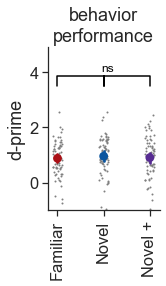

In [217]:
metric = 'dprime_trial_corrected'

stats = engaged_behavior_stats_trial.copy()
stats = stats[stats.behavior_session_id.isin(platform_expts.behavior_session_id.values)]
print(len(stats.behavior_session_id.unique()))

# stats = stats[stats.image_name!='omitted']

ppf.plot_behavior_metric_by_experience(stats, metric, title='behavior\nperformance', ylabel='d-prime', ylims=[-1, 3.5],
                                       best_image=False, show_containers=False,
                                       save_dir=save_dir, folder=folder, suffix=suffix+'_engaged_trial_based')

# # for each cell type
# for cell_type in cell_types: 
#     ppf.plot_behavior_metric_by_experience(stats[stats.cell_type==cell_type], metric, title=cell_type, 
#                                                  ylabel='d-prime', ylims=[-1, 3.5],
#                                        best_image=False, show_containers=False,
#                                        save_dir=save_dir, folder=folder, suffix=suffix+'_engaged_trial_based_'+cell_type)

In [93]:
%%time 

method = 'sdk'
engaged_only = False
per_image = False

# folder = get_save_folder(method, engaged_only, per_image)

behavior_session_ids = behavior_sessions.index.values


original_behavior_stats_sdk, problem_sessions = vbu.get_behavior_stats_for_sessions(behavior_session_ids, behavior_sessions, 
                                    method=method, engaged_only=engaged_only, per_image=per_image)

# set bsid as index
original_behavior_stats_sdk.index.name = 'behavior_session_id'
original_behavior_stats_sdk = original_behavior_stats_sdk.reset_index()

# original_behavior_stats = behavior_stats.copy()
behavior_stats_sdk = original_behavior_stats_sdk.merge(behavior_sessions, on='behavior_session_id')
 # remove 4x2 sessions
behavior_stats_sdk = behavior_stats_sdk[engaged_behavior_stats_sdk.project_code!='VisualBehaviorMultiscope4areasx2d']

  0%|                                                                                 | 2/2943 [00:00<02:36, 18.82it/s]

loading for 760808911
loading for 761294708
loading for 761730617
loading for 762067130
loading for 762418364


  0%|▏                                                                                | 8/2943 [00:00<02:05, 23.30it/s]

loading for 763012686
loading for 763661704
loading for 764319580
loading for 764696952
loading for 765208332
loading for 765793356


  0%|▎                                                                               | 11/2943 [00:00<02:05, 23.43it/s]

loading for 766532213
loading for 766931048
loading for 767730839


  1%|▍                                                                               | 17/2943 [00:00<02:20, 20.78it/s]

loading for 768450504
loading for 769145833
loading for 769731277
loading for 770215042
loading for 771040969
loading for 771902184


  1%|▋                                                                               | 23/2943 [00:01<02:18, 21.10it/s]

loading for 772475707
loading for 773391809
loading for 774120511
loading for 774679623
loading for 775291372


  1%|▊                                                                               | 29/2943 [00:01<02:15, 21.44it/s]

loading for 776988190
loading for 778010119
loading for 778888558
loading for 779712859
loading for 780479408


  1%|▊                                                                               | 32/2943 [00:01<02:15, 21.47it/s]

loading for 781938213
loading for 783217873
loading for 783959068
loading for 785382040


  1%|█                                                                               | 38/2943 [00:01<02:22, 20.44it/s]

loading for 786007435
loading for 786938611
loading for 789008423
loading for 789870329


  1%|█                                                                               | 41/2943 [00:01<02:20, 20.66it/s]

loading for 791248943
loading for 791904071
loading for 792680306
loading for 793485674
loading for 794968300


  1%|█▏                                                                              | 44/2943 [00:02<02:18, 20.88it/s]

loading for 795742990
loading for 796052844
loading for 796251270
loading for 798126878


  2%|█▎                                                                              | 50/2943 [00:02<02:25, 19.82it/s]

loading for 772286394
loading for 773510999
loading for 774208555
loading for 774767072


  2%|█▍                                                                              | 53/2943 [00:02<02:27, 19.62it/s]

loading for 775344511
loading for 775925580
loading for 777061425
loading for 778119826
loading for 778959204


  2%|█▌                                                                              | 59/2943 [00:02<02:11, 21.87it/s]

loading for 779580423
loading for 780351711
loading for 781727422
loading for 783059206
loading for 783971649
loading for 785376297


  2%|█▊                                                                              | 65/2943 [00:03<02:05, 22.90it/s]

loading for 785868918
loading for 786841415
loading for 788864720
loading for 789946754
loading for 791278700


  2%|█▉                                                                              | 71/2943 [00:03<01:58, 24.16it/s]

loading for 791769447
loading for 792477679
loading for 793153175
loading for 794071128
loading for 794673280


  3%|██                                                                              | 74/2943 [00:03<02:08, 22.35it/s]

loading for 795431009
loading for 796031509
loading for 797170547
loading for 791877093


  3%|██▏                                                                             | 80/2943 [00:03<02:06, 22.65it/s]

loading for 792689261
loading for 793414389
loading for 794295959
loading for 794977379
loading for 795854559


  3%|██▎                                                                             | 83/2943 [00:03<02:08, 22.18it/s]

loading for 799051310
loading for 799922316
loading for 800299366
loading for 800922511
loading for 802988132


  3%|██▍                                                                             | 89/2943 [00:04<02:21, 20.13it/s]

loading for 803351520
loading for 804929649
loading for 805535249
loading for 806109931
loading for 806792366


  3%|██▌                                                                             | 93/2943 [00:04<02:06, 22.53it/s]

loading for 807356557
loading for 808324301
loading for 808883789
loading for 809358811
loading for 810405357


  3%|██▋                                                                             | 99/2943 [00:04<02:02, 23.21it/s]

loading for 811303680
loading for 811817467
loading for 812955256
loading for 816417578


  3%|██▋                                                                            | 102/2943 [00:04<02:18, 20.51it/s]

loading for 817139151
loading for 818485496
loading for 819094295
loading for 791875850
loading for 792689257


  4%|██▉                                                                            | 108/2943 [00:05<02:08, 22.00it/s]

loading for 793409670
loading for 794295950
loading for 794977383
loading for 795854555
loading for 799049628


  4%|███                                                                            | 114/2943 [00:05<02:03, 22.93it/s]

loading for 799919887
loading for 800299362
loading for 800919728
loading for 802364085
loading for 802988119
loading for 803347004


  4%|███▏                                                                           | 120/2943 [00:05<01:56, 24.18it/s]

loading for 805639780
loading for 806296598
loading for 806841326
loading for 807584876
loading for 808432167


  4%|███▍                                                                           | 126/2943 [00:05<02:00, 23.35it/s]

loading for 809027309
loading for 809427293
loading for 811355443
loading for 810584641
loading for 811356875


  4%|███▍                                                                           | 129/2943 [00:05<02:07, 22.06it/s]

loading for 811831429
loading for 812566400
loading for 812993078
loading for 813675618
loading for 814546737


  4%|███▌                                                                           | 132/2943 [00:06<02:13, 21.13it/s]

loading for 815015329
loading for 815511978
loading for 816381516
loading for 817182203


  5%|███▋                                                                           | 138/2943 [00:06<02:00, 23.32it/s]

loading for 818758572
loading for 819245147
loading for 819990491
loading for 821803380
loading for 822409353


  5%|███▊                                                                           | 144/2943 [00:06<02:02, 22.84it/s]

loading for 823241007
loading for 823968100
loading for 825012995
loading for 825268982
loading for 825888541
loading for 826697158


  5%|████                                                                           | 150/2943 [00:06<01:53, 24.51it/s]

loading for 827374757
loading for 828646658
loading for 829138845
loading for 829578829
loading for 830255592
loading for 830832988


  5%|████                                                                           | 153/2943 [00:06<01:59, 23.39it/s]

loading for 831824426
loading for 832981154
loading for 835444110
loading for 835820832


  5%|████▎                                                                          | 159/2943 [00:07<02:15, 20.52it/s]

loading for 836399024
loading for 807062523
loading for 808103937
loading for 809588395


  6%|████▎                                                                          | 162/2943 [00:07<02:22, 19.52it/s]

loading for 810266014
loading for 811140660
loading for 811574124
loading for 812261209
loading for 812796028


  6%|████▌                                                                          | 168/2943 [00:07<02:11, 21.12it/s]

loading for 814260983
loading for 814749891
loading for 815865807
loading for 817053045
loading for 818539436
loading for 819065377


  6%|████▋                                                                          | 174/2943 [00:07<02:03, 22.50it/s]

loading for 819497998
loading for 820740400
loading for 821593979
loading for 822159346
loading for 822874578


  6%|████▊                                                                          | 177/2943 [00:08<02:05, 22.12it/s]

loading for 823496226
loading for 824566587
loading for 825269006
loading for 825902239


  6%|████▉                                                                          | 183/2943 [00:08<02:12, 20.77it/s]

loading for 826697162
loading for 827374765
loading for 828669593
loading for 829138837


  6%|████▉                                                                          | 186/2943 [00:08<02:17, 19.99it/s]

loading for 829714672
loading for 830419451
loading for 830959034
loading for 831905148
loading for 833100683


  7%|█████▏                                                                         | 192/2943 [00:08<02:16, 20.18it/s]

loading for 833946929
loading for 834928595
loading for 835547527
loading for 835940015
loading for 837108110
loading for 837512169


  7%|█████▎                                                                         | 198/2943 [00:09<01:55, 23.74it/s]

loading for 823922942
loading for 824972176
loading for 825527066
loading for 826338809
loading for 826841473


  7%|█████▍                                                                         | 201/2943 [00:09<02:03, 22.12it/s]

loading for 827977069
loading for 828842797
loading for 829281654
loading for 829902556


  7%|█████▌                                                                         | 207/2943 [00:09<02:04, 21.97it/s]

loading for 830592943
loading for 831259963
loading for 832009551
loading for 832522789
loading for 833252272


  7%|█████▋                                                                         | 210/2943 [00:09<02:05, 21.77it/s]

loading for 834059775
loading for 834886139
loading for 835608988
loading for 836099247


  7%|█████▊                                                                         | 216/2943 [00:09<02:08, 21.27it/s]

loading for 836769386
loading for 837202082
loading for 837629869
loading for 838486964
loading for 839220840


  7%|█████▉                                                                         | 219/2943 [00:10<02:03, 22.03it/s]

loading for 839566028
loading for 839918083
loading for 840583412
loading for 841431760


  8%|█████▉                                                                         | 222/2943 [00:10<02:13, 20.37it/s]

loading for 841830077
loading for 842387217
loading for 842821314


  8%|██████                                                                         | 227/2943 [00:10<02:39, 17.02it/s]

loading for 843397714
loading for 844197868
loading for 844880686
loading for 845564445


  8%|██████▏                                                                        | 232/2943 [00:10<02:28, 18.24it/s]

loading for 846272622
loading for 847022155
loading for 847829598
loading for 848519645
loading for 849073265


  8%|██████▍                                                                        | 238/2943 [00:11<02:15, 20.02it/s]

loading for 849635376
loading for 850977753
loading for 851779746
loading for 852468381


  8%|██████▍                                                                        | 241/2943 [00:11<02:21, 19.14it/s]

loading for 853168204
loading for 853875502
loading for 854563857
loading for 855421865
loading for 855973498


  8%|██████▌                                                                        | 244/2943 [00:11<02:12, 20.37it/s]

loading for 856717282
loading for 857612105
loading for 859065627
loading for 859735311


  8%|██████▋                                                                        | 250/2943 [00:11<02:15, 19.92it/s]

loading for 860665051
loading for 861788094
loading for 863571072
loading for 864139911
loading for 864824449


  9%|██████▊                                                                        | 256/2943 [00:12<02:02, 21.86it/s]

loading for 865482857
loading for 866333758
loading for 867041502
loading for 867977775
loading for 868721114


  9%|███████                                                                        | 262/2943 [00:12<01:56, 23.10it/s]

loading for 869639141
loading for 870960890
loading for 872062433
loading for 873002413
loading for 873750535


  9%|███████                                                                        | 265/2943 [00:12<01:50, 24.30it/s]

loading for 874681118
loading for 875414332
loading for 876765708
loading for 877346183
loading for 877925816
loading for 878671068


  9%|███████▎                                                                       | 271/2943 [00:12<01:46, 25.11it/s]

loading for 879974471
loading for 880668519
loading for 881278000
loading for 882256127
loading for 882748184
loading for 884596128


  9%|███████▍                                                                       | 277/2943 [00:12<01:52, 23.63it/s]

loading for 885492180
loading for 886322595
loading for 886926935
loading for 888127012
loading for 890157940


 10%|███████▌                                                                       | 280/2943 [00:13<01:52, 23.73it/s]

loading for 820799656
loading for 821837682
loading for 822471786
loading for 823248638


 10%|███████▋                                                                       | 286/2943 [00:13<01:54, 23.20it/s]

loading for 823922950
loading for 824992804
loading for 825533866
loading for 826356747
loading for 826846303


 10%|███████▊                                                                       | 292/2943 [00:13<01:47, 24.57it/s]

loading for 827944014
loading for 828838236
loading for 829282785
loading for 829877552
loading for 830620126


 10%|███████▉                                                                       | 295/2943 [00:13<01:52, 23.45it/s]

loading for 832019583
loading for 832540845
loading for 833454420
loading for 834093014


 10%|███████▉                                                                       | 298/2943 [00:13<01:55, 22.84it/s]

loading for 834908481
loading for 835616503
loading for 836173885
loading for 836777468
loading for 837196627


 10%|████████▏                                                                      | 305/2943 [00:14<01:47, 24.65it/s]

loading for 837647722
loading for 838496122
loading for 839233516
loading for 839566049
loading for 839931485


 10%|████████▎                                                                      | 308/2943 [00:14<01:59, 22.10it/s]

loading for 840594518
loading for 841429687
loading for 841842210
loading for 842399625


 11%|████████▍                                                                      | 314/2943 [00:14<01:58, 22.23it/s]

loading for 842844413
loading for 843400443
loading for 844253929
loading for 845585105
loading for 846316916
loading for 847036338


 11%|████████▌                                                                      | 320/2943 [00:14<02:01, 21.59it/s]

loading for 847871771
loading for 848599542
loading for 849136474
loading for 849648618


 11%|████████▊                                                                      | 326/2943 [00:15<01:47, 24.28it/s]

loading for 850985993
loading for 851757903
loading for 852440775
loading for 853496105
loading for 827312851
loading for 828646634


 11%|████████▊                                                                      | 329/2943 [00:15<01:48, 24.20it/s]

loading for 829128279
loading for 829591790
loading for 830201482
loading for 830867799
loading for 831834820


 11%|████████▉                                                                      | 335/2943 [00:15<01:55, 22.65it/s]

loading for 832325815
loading for 832990071
loading for 833780803
loading for 834573980
loading for 835448132


 12%|█████████▏                                                                     | 341/2943 [00:15<01:59, 21.79it/s]

loading for 835865722
loading for 836522259
loading for 837083666
loading for 837443225


 12%|█████████▏                                                                     | 344/2943 [00:15<02:02, 21.27it/s]

loading for 838236165
loading for 839014738
loading for 839479248
loading for 839854553


 12%|█████████▎                                                                     | 347/2943 [00:16<02:13, 19.40it/s]

loading for 840330509
loading for 841185520
loading for 841730873
loading for 842139320
loading for 842792100


 12%|█████████▍                                                                     | 353/2943 [00:16<01:53, 22.77it/s]

loading for 843166865
loading for 844234790
loading for 844875410
loading for 846248008
loading for 847048485
loading for 847867029


 12%|█████████▋                                                                     | 359/2943 [00:16<01:47, 24.06it/s]

loading for 848575992
loading for 849098851
loading for 850976604
loading for 853266283
loading for 831129394


 12%|█████████▊                                                                     | 365/2943 [00:16<01:53, 22.79it/s]

loading for 832021447
loading for 832544149
loading for 833328750
loading for 834087859
loading for 834903060
loading for 835557296


 13%|█████████▉                                                                     | 368/2943 [00:16<01:59, 21.63it/s]

loading for 836166694
loading for 836761653
loading for 837192567
loading for 837638916


 13%|██████████                                                                     | 374/2943 [00:17<02:07, 20.13it/s]

loading for 838496126
loading for 839234289
loading for 839566045
loading for 839939986


 13%|██████████                                                                     | 377/2943 [00:17<02:09, 19.83it/s]

loading for 840594514
loading for 841148118
loading for 841707177
loading for 842174399
loading for 842729895


 13%|██████████▎                                                                    | 383/2943 [00:17<01:57, 21.70it/s]

loading for 843203333
loading for 844164376
loading for 844849972
loading for 845441512
loading for 846194950
loading for 846929750


 13%|██████████▍                                                                    | 387/2943 [00:17<01:47, 23.82it/s]

loading for 848503804
loading for 853526948
loading for 834587823
loading for 835451471


 13%|██████████▌                                                                    | 393/2943 [00:18<02:05, 20.25it/s]

loading for 835867850
loading for 836522245
loading for 837083657
loading for 837449223


 13%|██████████▋                                                                    | 396/2943 [00:18<02:19, 18.27it/s]

loading for 838203784
loading for 838998362
loading for 839468826
loading for 839837380


 14%|██████████▋                                                                    | 400/2943 [00:18<02:31, 16.73it/s]

loading for 840330501
loading for 841191836
loading for 841730868
loading for 842139310


 14%|██████████▊                                                                    | 404/2943 [00:18<02:42, 15.62it/s]

loading for 842792094
loading for 843178897
loading for 844027594
loading for 844608277


 14%|██████████▉                                                                    | 407/2943 [00:19<02:40, 15.75it/s]

loading for 845409652
loading for 846051276
loading for 846791195


 14%|███████████                                                                    | 412/2943 [00:19<02:25, 17.35it/s]

loading for 847613846
loading for 848272657
loading for 848938321
loading for 849525884


 14%|███████████▏                                                                   | 417/2943 [00:19<02:13, 18.92it/s]

loading for 850817466
loading for 851563931
loading for 852235678
loading for 852974537


 14%|███████████▏                                                                   | 419/2943 [00:19<02:40, 15.77it/s]

loading for 853505213
loading for 854283407


 14%|███████████▎                                                                   | 422/2943 [00:19<02:20, 17.94it/s]

loading for 855826937
loading for 857230827
loading for 837658854
loading for 838515247


 14%|███████████▍                                                                   | 426/2943 [00:20<02:23, 17.48it/s]

loading for 839219841
loading for 839565422
loading for 839912316
loading for 840581827
loading for 841426832


 15%|███████████▌                                                                   | 431/2943 [00:20<02:11, 19.08it/s]

loading for 841827774
loading for 842385277
loading for 842819933
loading for 843400453


 15%|███████████▋                                                                   | 434/2943 [00:20<02:02, 20.53it/s]

loading for 844199758
loading for 844908261
loading for 845572044
loading for 846331423
loading for 847036328


 15%|███████████▊                                                                   | 440/2943 [00:20<01:47, 23.25it/s]

loading for 847874940
loading for 848613406
loading for 849147676
loading for 849651275
loading for 850989832


 15%|███████████▉                                                                   | 443/2943 [00:20<02:03, 20.32it/s]

loading for 851773928
loading for 852451567
loading for 855200229
loading for 840598877


 15%|████████████                                                                   | 449/2943 [00:21<02:03, 20.27it/s]

loading for 841466830
loading for 841851097
loading for 842419799
loading for 842840144
loading for 843423171


 15%|████████████▏                                                                  | 452/2943 [00:21<02:30, 16.51it/s]

loading for 844229895
loading for 844945060
loading for 845594684
loading for 846284880


 16%|████████████▎                                                                  | 457/2943 [00:21<02:26, 17.02it/s]

loading for 847048490
loading for 847838131
loading for 848526511


 16%|████████████▎                                                                  | 461/2943 [00:22<02:38, 15.67it/s]

loading for 848910243
loading for 849485548
loading for 850810858


 16%|████████████▍                                                                  | 464/2943 [00:22<02:27, 16.76it/s]

loading for 851471401
loading for 852202150
loading for 852966248
loading for 853875514


 16%|████████████▌                                                                  | 466/2943 [00:22<02:42, 15.25it/s]

loading for 854621677
loading for 855424348
loading for 857340041


 16%|████████████▌                                                                  | 470/2943 [00:22<02:55, 14.06it/s]

loading for 857987666
loading for 858974731
loading for 859775117


 16%|████████████▋                                                                  | 473/2943 [00:22<02:33, 16.10it/s]

loading for 863610582
loading for 868070216
loading for 868658294
loading for 869559097
loading for 854533487


 16%|████████████▊                                                                  | 478/2943 [00:23<02:33, 16.09it/s]

loading for 855504136
loading for 856002607
loading for 856732191


 16%|████████████▉                                                                  | 480/2943 [00:23<02:43, 15.08it/s]

loading for 857555456
loading for 858240891
loading for 859032026
loading for 859791558


 16%|█████████████                                                                  | 485/2943 [00:23<02:29, 16.42it/s]

loading for 860752803
loading for 861794699
loading for 862701465
loading for 863571054
loading for 864137547


 17%|█████████████▏                                                                 | 491/2943 [00:23<02:01, 20.18it/s]

loading for 864839176
loading for 865581941
loading for 866287088
loading for 866950070
loading for 867615529


 17%|█████████████▎                                                                 | 497/2943 [00:24<02:04, 19.67it/s]

loading for 868540333
loading for 869319414
loading for 870660821
loading for 871808378


 17%|█████████████▍                                                                 | 500/2943 [00:24<01:53, 21.58it/s]

loading for 872646068
loading for 873517635
loading for 874324533
loading for 875471358
cant load stats for 875471358
loading for 876574139
loading for 850970486
loading for 851843550


 17%|█████████████▌                                                                 | 507/2943 [00:24<01:40, 24.14it/s]

loading for 852507945
loading for 853260939
loading for 853886146
loading for 855459012
loading for 855980937


 17%|█████████████▊                                                                 | 513/2943 [00:24<01:40, 24.09it/s]

loading for 856719615
loading for 857504898
loading for 858250763
loading for 859049298
loading for 859784868


 18%|█████████████▊                                                                 | 516/2943 [00:24<01:56, 20.82it/s]

loading for 860836980
loading for 861789935
loading for 862716913
loading for 863614836


 18%|██████████████                                                                 | 522/2943 [00:25<02:00, 20.06it/s]

loading for 864260028
loading for 864813130
loading for 865460179
loading for 866296478


 18%|██████████████                                                                 | 525/2943 [00:25<02:06, 19.07it/s]

loading for 866999677
loading for 867615541
loading for 868555361
loading for 869334643


 18%|██████████████▏                                                                | 529/2943 [00:25<02:24, 16.74it/s]

loading for 870592115
loading for 871808394
loading for 872626160
loading for 873695653
loading for 874699922


 18%|██████████████▎                                                                | 532/2943 [00:25<02:05, 19.28it/s]

loading for 875440936
loading for 876678452
loading for 877617747
loading for 878120101


 18%|██████████████▍                                                                | 538/2943 [00:26<02:12, 18.18it/s]

loading for 879037269
loading for 880046522
loading for 880784794
loading for 882256117


 18%|██████████████▍                                                                | 540/2943 [00:26<02:21, 17.03it/s]

loading for 858104885
loading for 858900546


 18%|██████████████▌                                                                | 542/2943 [00:26<02:55, 13.67it/s]

loading for 859601488
loading for 860247669
loading for 861717498
loading for 862339401


 19%|██████████████▋                                                                | 548/2943 [00:26<02:17, 17.48it/s]

loading for 863365105
loading for 863966979
loading for 864665192
loading for 865114696


 19%|██████████████▊                                                                | 550/2943 [00:26<02:24, 16.60it/s]

loading for 865887829
loading for 866906696
loading for 867505993
loading for 868511825


 19%|██████████████▉                                                                | 555/2943 [00:27<02:15, 17.64it/s]

loading for 869198966
loading for 870481699
loading for 871723063
loading for 872607293


 19%|██████████████▉                                                                | 558/2943 [00:27<02:00, 19.81it/s]

loading for 873440431
loading for 874324527
loading for 875020211
loading for 876448536


 19%|███████████████▏                                                               | 564/2943 [00:27<01:59, 19.86it/s]

loading for 877855866
loading for 878615859
loading for 879846629
loading for 880581639
loading for 881204796


 19%|███████████████▎                                                               | 570/2943 [00:27<01:53, 20.96it/s]

loading for 882289836
loading for 883851453
loading for 884598044
loading for 885404075


 19%|███████████████▍                                                               | 573/2943 [00:28<01:54, 20.72it/s]

loading for 886376835
loading for 888213949
loading for 890021100
loading for 893362730
loading for 894103623


 20%|███████████████▌                                                               | 579/2943 [00:28<01:39, 23.72it/s]

loading for 895022326
loading for 895562386
loading for 896561264
loading for 898432373
loading for 898874650
loading for 899390684


 20%|███████████████▌                                                               | 582/2943 [00:28<01:41, 23.33it/s]

loading for 901999401
loading for 903708760
loading for 904574580
loading for 906472625


 20%|███████████████▊                                                               | 588/2943 [00:28<01:39, 23.65it/s]

loading for 907053876
loading for 907900077
loading for 908533370
loading for 910207192
loading for 910829549
loading for 911904717


 20%|███████████████▉                                                               | 594/2943 [00:28<01:46, 22.13it/s]

loading for 913673477
loading for 914211263
loading for 914705301
loading for 915418411
loading for 916403851


 20%|████████████████                                                               | 600/2943 [00:29<01:43, 22.70it/s]

loading for 918103715
loading for 923410363
loading for 924472023
loading for 925084998
loading for 862479694


 20%|████████████████▏                                                              | 603/2943 [00:29<01:52, 20.79it/s]

loading for 863414647
loading for 864000195
loading for 864729508
loading for 865288307


 21%|████████████████▎                                                              | 609/2943 [00:29<01:54, 20.36it/s]

loading for 865953304
loading for 866971252
loading for 867649878
loading for 868546763


 21%|████████████████▍                                                              | 612/2943 [00:29<01:49, 21.33it/s]

loading for 869311954
loading for 870592103
loading for 871782387
loading for 872720256
loading for 873530279
loading for 874295478


 21%|████████████████▌                                                              | 618/2943 [00:30<01:48, 21.50it/s]

loading for 875020129
loading for 876521253
loading for 877346192
loading for 877938181
loading for 878671074
loading for 879958654


 21%|████████████████▊                                                              | 625/2943 [00:30<01:32, 25.00it/s]

loading for 880647168
loading for 881253316
loading for 882233951
loading for 882679635
loading for 883632948
loading for 884560033


 21%|████████████████▉                                                              | 631/2943 [00:30<01:33, 24.80it/s]

loading for 885418521
loading for 886262841
loading for 886900197
loading for 889183454
loading for 890054551


 22%|█████████████████                                                              | 634/2943 [00:30<01:37, 23.69it/s]

loading for 891504476
loading for 892413871
loading for 893359124
loading for 894215849
loading for 894994111


 22%|█████████████████▏                                                             | 640/2943 [00:30<01:37, 23.60it/s]

loading for 896543686
loading for 898461372
loading for 898890800
loading for 899461485
loading for 902028378
loading for 902822538


 22%|█████████████████▎                                                             | 646/2943 [00:31<01:35, 23.97it/s]

loading for 904625819
loading for 907035965
loading for 907995400
loading for 908564873
loading for 910249985


 22%|█████████████████▌                                                             | 652/2943 [00:31<01:37, 23.51it/s]

loading for 911361486
loading for 912159483
loading for 913921659
loading for 914411174
loading for 914871449


 22%|█████████████████▌                                                             | 655/2943 [00:31<01:50, 20.68it/s]

loading for 915739774
loading for 916704634
loading for 917595407
loading for 918474069
loading for 919104267


 22%|█████████████████▊                                                             | 662/2943 [00:31<01:32, 24.53it/s]

loading for 920015895
loading for 920839478
loading for 922012422
loading for 923834852
loading for 924759623
loading for 925603486


 23%|█████████████████▉                                                             | 668/2943 [00:32<01:34, 24.01it/s]

loading for 927905748
loading for 929551055
loading for 935301109
loading for 936273485
loading for 862730050


 23%|██████████████████                                                             | 671/2943 [00:32<01:31, 24.92it/s]

loading for 863657189
loading for 864236370
loading for 864809053
loading for 865443418
loading for 866300303


 23%|██████████████████▏                                                            | 677/2943 [00:32<01:35, 23.82it/s]

loading for 867045079
loading for 867977763
loading for 868704504
loading for 869615887


 23%|██████████████████▎                                                            | 680/2943 [00:32<01:42, 22.18it/s]

loading for 870960882
loading for 872864902
loading for 873729011
loading for 874691139
loading for 875402170


 23%|██████████████████▍                                                            | 686/2943 [00:32<01:50, 20.39it/s]

loading for 876701397
loading for 877524045
loading for 878137744
loading for 879003593


 23%|██████████████████▍                                                            | 689/2943 [00:33<01:52, 20.02it/s]

loading for 880088387
loading for 881416618
loading for 882373648
loading for 882785348


 24%|██████████████████▋                                                            | 695/2943 [00:33<01:47, 20.87it/s]

loading for 883984332
loading for 884750162
loading for 885540222
loading for 886440427
loading for 886931452


 24%|██████████████████▋                                                            | 698/2943 [00:33<01:39, 22.48it/s]

loading for 888282572
loading for 889443507
loading for 890355790
loading for 891618314
loading for 892491402


 24%|██████████████████▉                                                            | 704/2943 [00:33<01:38, 22.69it/s]

loading for 893540605
loading for 894466746
loading for 895241719
loading for 895877676
loading for 896969091


 24%|███████████████████                                                            | 710/2943 [00:34<01:41, 21.98it/s]

loading for 898658063
loading for 899685557
loading for 900226857
loading for 901340457


 24%|███████████████████▏                                                           | 713/2943 [00:34<01:38, 22.55it/s]

loading for 902244344
loading for 902962312
loading for 904899490
loading for 906641078
loading for 908092560
loading for 910381299


 24%|███████████████████▎                                                           | 719/2943 [00:34<01:42, 21.69it/s]

loading for 911016296
loading for 911541959
loading for 912902650
loading for 913850438
loading for 914336989


 25%|███████████████████▍                                                           | 725/2943 [00:34<01:33, 23.64it/s]

loading for 914828503
loading for 915609195
loading for 916614400
loading for 917500273
loading for 918451984
loading for 919022193


 25%|███████████████████▌                                                           | 731/2943 [00:34<01:26, 25.45it/s]

loading for 919895633
loading for 920807985
loading for 921873454
loading for 923757660
loading for 924739087
loading for 926621793


 25%|███████████████████▊                                                           | 737/2943 [00:35<01:31, 24.15it/s]

loading for 927652117
loading for 928654503
loading for 929522558
loading for 930344462


 25%|███████████████████▊                                                           | 740/2943 [00:35<01:30, 24.35it/s]

loading for 932960096
loading for 933939891
loading for 935038748
loading for 936159430
loading for 937645038
loading for 938729036


 25%|████████████████████                                                           | 746/2943 [00:35<01:43, 21.22it/s]

loading for 940017429
loading for 941802699
loading for 942814025
loading for 943833533


 25%|████████████████████                                                           | 749/2943 [00:35<01:50, 19.93it/s]

loading for 945033994
loading for 947336783
loading for 948225040
loading for 949348713


 26%|████████████████████▎                                                          | 755/2943 [00:36<01:42, 21.26it/s]

loading for 950188644
loading for 862245493
loading for 863368489
loading for 863966974
loading for 864665204
loading for 865131331
loading for 865887821


 26%|████████████████████▍                                                          | 761/2943 [00:36<01:54, 19.05it/s]

loading for 866909432
loading for 867521015
loading for 868513545
loading for 869214215
loading for 870481685


 26%|████████████████████▌                                                          | 764/2943 [00:36<01:54, 19.09it/s]

loading for 871728970
loading for 872609185
loading for 873449838
loading for 874333572


 26%|████████████████████▋                                                          | 769/2943 [00:36<01:58, 18.28it/s]

loading for 875020175
loading for 876448528
loading for 877855879
loading for 878615867
loading for 879854787


 26%|████████████████████▊                                                          | 776/2943 [00:37<01:34, 23.00it/s]

loading for 880590869
loading for 881210690
loading for 882291265
loading for 882736270
loading for 883857883
loading for 884605735


 27%|████████████████████▉                                                          | 782/2943 [00:37<01:31, 23.67it/s]

loading for 885404024
loading for 886382175
loading for 888218684
loading for 890021090
loading for 893608687


 27%|█████████████████████▏                                                         | 788/2943 [00:37<01:27, 24.66it/s]

loading for 894495169
loading for 895278567
loading for 895809864
loading for 896882463
loading for 898665096


 27%|█████████████████████▏                                                         | 791/2943 [00:37<01:31, 23.56it/s]

loading for 898938920
loading for 900227468
loading for 901316636
loading for 902211897
loading for 902995627
loading for 903977177


 27%|█████████████████████▍                                                         | 797/2943 [00:37<01:24, 25.32it/s]

loading for 904922800
loading for 906658064
loading for 907327499
loading for 908122381
loading for 912640306
loading for 866287136


 27%|█████████████████████▌                                                         | 803/2943 [00:38<01:26, 24.66it/s]

loading for 867036293
loading for 867961854
loading for 868653129
loading for 869623244
loading for 870935142


 27%|█████████████████████▋                                                         | 809/2943 [00:38<01:35, 22.33it/s]

loading for 872043024
loading for 872979424
loading for 873739031
loading for 874654280


 28%|█████████████████████▊                                                         | 812/2943 [00:38<01:30, 23.66it/s]

loading for 875385921
loading for 876737442
loading for 877558833
loading for 878245978
loading for 878993255


 28%|█████████████████████▉                                                         | 818/2943 [00:38<01:39, 21.33it/s]

loading for 880191880
loading for 880775454
loading for 881425509
loading for 882401590


 28%|██████████████████████                                                         | 821/2943 [00:39<01:39, 21.28it/s]

loading for 883756380
loading for 884552901
loading for 885410929
loading for 886257016


 28%|██████████████████████                                                         | 824/2943 [00:39<01:45, 20.02it/s]

loading for 886838602
loading for 888033338
loading for 889175194
loading for 890033129


 28%|██████████████████████▎                                                        | 829/2943 [00:39<01:51, 18.97it/s]

loading for 891446789
loading for 892387261
loading for 893344360
loading for 894083470


 28%|██████████████████████▎                                                        | 833/2943 [00:39<01:33, 22.52it/s]

loading for 898440124
loading for 866128606
loading for 866971269
loading for 867645566
loading for 868531777
loading for 869311972


 29%|██████████████████████▌                                                        | 839/2943 [00:39<01:37, 21.62it/s]

loading for 870579061
loading for 871782397
loading for 872690218
loading for 873537911
loading for 874416985
loading for 875020203


 29%|██████████████████████▋                                                        | 845/2943 [00:40<01:30, 23.12it/s]

loading for 876651891
loading for 877487375
loading for 878179382
loading for 878771403
loading for 879969002
loading for 880644824


 29%|██████████████████████▊                                                        | 851/2943 [00:40<01:37, 21.47it/s]

loading for 881251187
loading for 882219267
loading for 882677813
loading for 883632956


 29%|██████████████████████▉                                                        | 854/2943 [00:40<01:31, 22.83it/s]

loading for 884560064
loading for 885410934
loading for 886250995
loading for 887006111
loading for 888163519


 29%|███████████████████████                                                        | 860/2943 [00:40<01:30, 22.95it/s]

loading for 889388078
loading for 890625596
loading for 891605682
loading for 892526544
loading for 893488330
loading for 894368064


 29%|███████████████████████▏                                                       | 866/2943 [00:41<01:23, 24.99it/s]

loading for 870987812
loading for 872953842
loading for 873774125
loading for 874790261
loading for 875207834


 30%|███████████████████████▎                                                       | 869/2943 [00:41<01:30, 22.97it/s]

loading for 876821726
loading for 877603209
loading for 878245989
loading for 879003606


 30%|███████████████████████▍                                                       | 875/2943 [00:41<01:28, 23.29it/s]

loading for 880088400
loading for 881416637
loading for 882373653
loading for 882781075
loading for 883986743


 30%|███████████████████████▋                                                       | 881/2943 [00:41<01:27, 23.64it/s]

loading for 884776248
loading for 885540237
loading for 886442346
loading for 886946944
loading for 888295170
loading for 889468960


 30%|███████████████████████▊                                                       | 887/2943 [00:41<01:27, 23.55it/s]

loading for 890408602
loading for 891635659
loading for 891635667
loading for 892510304


 30%|███████████████████████▉                                                       | 890/2943 [00:42<01:33, 22.05it/s]

loading for 893560763
loading for 894481319
loading for 895248933
loading for 895896343
loading for 896995828


 30%|████████████████████████                                                       | 896/2943 [00:42<01:23, 24.44it/s]

loading for 898667252
loading for 899700579
loading for 900231059
loading for 901363879
loading for 902260156
loading for 902975505
loading for 904922810


 31%|████████████████████████▏                                                      | 900/2943 [00:42<01:22, 24.90it/s]

loading for 906668549
loading for 908104455
loading for 910393217
loading for 911016285


 31%|████████████████████████▎                                                      | 906/2943 [00:42<01:31, 22.20it/s]

loading for 911541950
loading for 912223787
loading for 912902619
loading for 913850450
loading for 914339617


 31%|████████████████████████▍                                                      | 912/2943 [00:43<01:36, 21.08it/s]

loading for 914831000
loading for 915609216
loading for 916617096
loading for 917500256


 31%|████████████████████████▌                                                      | 915/2943 [00:43<01:32, 21.86it/s]

loading for 918451994
loading for 919025442
loading for 920901263
loading for 921979060
loading for 923757653
loading for 924739774


 31%|████████████████████████▋                                                      | 921/2943 [00:43<01:30, 22.26it/s]

loading for 926621788
loading for 927652110
loading for 928654491
loading for 929524423
loading for 930344469


 31%|████████████████████████▊                                                      | 924/2943 [00:43<01:37, 20.61it/s]

loading for 932960104
loading for 933954934
loading for 935045761
loading for 936083473


 32%|████████████████████████▉                                                      | 930/2943 [00:44<01:44, 19.26it/s]

loading for 937706038
loading for 938794488
loading for 939985541
loading for 940755050


 32%|█████████████████████████                                                      | 934/2943 [00:44<01:32, 21.75it/s]

loading for 941734036
loading for 942767530
loading for 944125005
loading for 945075740
loading for 947988590


 32%|█████████████████████████▏                                                     | 940/2943 [00:44<01:22, 24.18it/s]

loading for 949201674
loading for 949973686
loading for 951520319
loading for 952554548
loading for 953982960
loading for 956010809


 32%|█████████████████████████▍                                                     | 946/2943 [00:44<01:21, 24.40it/s]

loading for 957032492
loading for 958234742
loading for 958888263
loading for 959681045
loading for 875126982


 32%|█████████████████████████▍                                                     | 949/2943 [00:44<01:28, 22.56it/s]

loading for 876823447
loading for 877605077
loading for 878245966
loading for 879074585
loading for 880174939


 32%|█████████████████████████▋                                                     | 955/2943 [00:45<01:27, 22.73it/s]

loading for 881450253
loading for 882426675
loading for 882833335
loading for 884004562
loading for 884776271
loading for 885598412


 33%|█████████████████████████▊                                                     | 962/2943 [00:45<01:21, 24.38it/s]

loading for 886446962
loading for 886953901
loading for 888298590
loading for 889478291
loading for 890408635


 33%|█████████████████████████▉                                                     | 965/2943 [00:45<01:21, 24.27it/s]

loading for 891635663
loading for 892525019
loading for 893560739
loading for 894481291
loading for 895262003


 33%|██████████████████████████                                                     | 971/2943 [00:45<01:24, 23.28it/s]

loading for 895896368
loading for 896995823
loading for 898682070
loading for 899742869
loading for 901424076


 33%|██████████████████████████▏                                                    | 977/2943 [00:45<01:24, 23.32it/s]

loading for 902328548
loading for 903098779
loading for 904954571
loading for 906726720
loading for 908165653


 33%|██████████████████████████▎                                                    | 981/2943 [00:46<01:17, 25.27it/s]

loading for 910448027
loading for 911061160
loading for 911581364
loading for 912318840
loading for 913014398


 34%|██████████████████████████▍                                                    | 987/2943 [00:46<01:17, 25.38it/s]

loading for 913917929
loading for 914408296
loading for 914859356
loading for 915690413
loading for 916673577
loading for 917600513


 34%|██████████████████████████▋                                                    | 993/2943 [00:46<01:19, 24.38it/s]

loading for 918448801
loading for 919022174
loading for 919890884
loading for 920807973
loading for 921873450
loading for 923750087


 34%|██████████████████████████▊                                                    | 999/2943 [00:46<01:22, 23.58it/s]

loading for 924740575
loading for 926614379
loading for 927643982
loading for 928647601


 34%|██████████████████████████▌                                                   | 1002/2943 [00:47<01:33, 20.67it/s]

loading for 929522554
loading for 930376122
loading for 931913977
loading for 932628715
loading for 933604243
loading for 934812249


 34%|██████████████████████████▋                                                   | 1008/2943 [00:47<01:41, 18.99it/s]

loading for 935653479
loading for 937395157
loading for 938339083
loading for 939533442
loading for 940628402


 34%|██████████████████████████▊                                                   | 1014/2943 [00:47<01:32, 20.94it/s]

loading for 941425961
loading for 942350598
loading for 875155219
loading for 876829777
loading for 877607698
loading for 878251933


 35%|███████████████████████████                                                   | 1020/2943 [00:47<01:20, 23.81it/s]

loading for 879074574
loading for 880181164
loading for 881450232
loading for 882426670
loading for 882844402
loading for 884070037


 35%|███████████████████████████▏                                                  | 1026/2943 [00:48<01:25, 22.46it/s]

loading for 884846935
loading for 885609778
loading for 886472241
loading for 887175302


 35%|███████████████████████████▎                                                  | 1029/2943 [00:48<01:20, 23.76it/s]

loading for 888346887
loading for 889536668
loading for 890555457
loading for 891724311
loading for 893564091
loading for 894481299


 35%|███████████████████████████▍                                                  | 1035/2943 [00:48<01:15, 25.33it/s]

loading for 895256170
loading for 895902286
loading for 897002967
loading for 898668828
loading for 899700587
loading for 900231063


 35%|███████████████████████████▌                                                  | 1041/2943 [00:48<01:16, 24.71it/s]

loading for 901363886
loading for 902260148
loading for 902975514
loading for 904922795
loading for 906668545


 36%|███████████████████████████▋                                                  | 1047/2943 [00:48<01:18, 24.08it/s]

loading for 908109320
loading for 910393226
loading for 911019327
loading for 911543418
loading for 912223793
loading for 912223799


 36%|███████████████████████████▊                                                  | 1050/2943 [00:49<01:26, 22.00it/s]

loading for 912902659
loading for 913854181
loading for 914339627
loading for 914831033


 36%|████████████████████████████                                                  | 1057/2943 [00:49<01:18, 24.10it/s]

loading for 915609229
loading for 916617112
loading for 917506393
loading for 918454529
loading for 919025470
loading for 919902020


 36%|████████████████████████████▏                                                 | 1063/2943 [00:49<01:23, 22.47it/s]

loading for 920813990
loading for 921879360
loading for 923877874
loading for 924757055


 36%|████████████████████████████▎                                                 | 1066/2943 [00:49<01:22, 22.89it/s]

loading for 926621779
loading for 927643992
loading for 928647605
loading for 929522550
loading for 930335512


 36%|████████████████████████████▍                                                 | 1072/2943 [00:50<01:25, 21.79it/s]

loading for 931488919
loading for 932596575
loading for 933472975
loading for 935601725
loading for 937442661


 37%|████████████████████████████▍                                                 | 1075/2943 [00:50<01:23, 22.34it/s]

loading for 938425882
loading for 939537734
loading for 940553228
loading for 941457567
loading for 942329079


 37%|████████████████████████████▋                                                 | 1081/2943 [00:50<01:24, 21.93it/s]

loading for 943479988
loading for 944823947
loading for 882765152
loading for 883908190
loading for 884881862


 37%|████████████████████████████▊                                                 | 1087/2943 [00:50<01:18, 23.72it/s]

loading for 885609760
loading for 886424035
loading for 887142121
loading for 888298597
loading for 889478282
loading for 890578468


 37%|████████████████████████████▉                                                 | 1090/2943 [00:50<01:18, 23.56it/s]

loading for 891752782
loading for 892597881
loading for 893551176
loading for 894489950


 37%|█████████████████████████████                                                 | 1096/2943 [00:51<01:20, 23.05it/s]

loading for 895248904
loading for 895947603
loading for 896945902
loading for 898691674
loading for 898982250
loading for 901251663


 37%|█████████████████████████████▏                                                | 1102/2943 [00:51<01:23, 22.09it/s]

loading for 902135840
loading for 902871565
loading for 903842232
loading for 904844395


 38%|█████████████████████████████▎                                                | 1108/2943 [00:51<01:22, 22.17it/s]

loading for 908065760
loading for 888282565
loading for 889461157
loading for 890450001
loading for 891789286


 38%|█████████████████████████████▍                                                | 1112/2943 [00:51<01:13, 24.90it/s]

loading for 892645353
loading for 893600610
loading for 894481279
loading for 895270564
loading for 896024686


 38%|█████████████████████████████▌                                                | 1115/2943 [00:52<01:16, 23.85it/s]

loading for 896931325
loading for 898658079
loading for 899685565
loading for 900226853
loading for 901358520


 38%|█████████████████████████████▋                                                | 1121/2943 [00:52<01:23, 21.92it/s]

loading for 902255179
loading for 902975500
loading for 904917894
loading for 906658076


 38%|█████████████████████████████▊                                                | 1124/2943 [00:52<01:26, 21.08it/s]

loading for 907195053
loading for 908930196
loading for 910396133
loading for 911025799
loading for 911527254


 38%|█████████████████████████████▉                                                | 1130/2943 [00:52<01:23, 21.83it/s]

loading for 912318850
loading for 913901536
loading for 914353445
loading for 914852087
loading for 915667469


 39%|██████████████████████████████▏                                               | 1137/2943 [00:52<01:11, 25.18it/s]

loading for 917618254
loading for 918296132
loading for 921923865
loading for 922869624
loading for 892283069
loading for 893354175


 39%|██████████████████████████████▎                                               | 1143/2943 [00:53<01:13, 24.58it/s]

loading for 894078803
loading for 895009095
loading for 895553474
loading for 896543705
loading for 898384915


 39%|██████████████████████████████▍                                               | 1147/2943 [00:53<01:07, 26.69it/s]

loading for 898877946
loading for 899400242
loading for 900232144
loading for 900936302
loading for 901876389


 39%|██████████████████████████████▍                                               | 1150/2943 [00:53<01:17, 23.12it/s]

loading for 902810506
loading for 903693439
loading for 907035950
loading for 907912571
loading for 908489409


 39%|██████████████████████████████▋                                               | 1156/2943 [00:53<01:15, 23.70it/s]

loading for 909341448
loading for 910182303
loading for 910812913
loading for 911375322
loading for 912008538


 39%|██████████████████████████████▋                                               | 1159/2943 [00:53<01:14, 23.85it/s]

loading for 912570307
loading for 913677684
loading for 914219174
loading for 914691372


 40%|██████████████████████████████▉                                               | 1165/2943 [00:54<01:17, 22.89it/s]

loading for 915326103
loading for 916390399
loading for 917261917
loading for 918098812
loading for 918860187
loading for 919485101


 40%|███████████████████████████████                                               | 1172/2943 [00:54<01:09, 25.44it/s]

loading for 921759097
loading for 921503547
loading for 922467930
loading for 923417336
loading for 924550325
loading for 925067625


 40%|███████████████████████████████▏                                              | 1178/2943 [00:54<01:16, 23.08it/s]

loading for 926393694
loading for 928361913
loading for 904942194
loading for 906720759


 40%|███████████████████████████████▎                                              | 1181/2943 [00:54<01:14, 23.58it/s]

loading for 908165660
loading for 910443509
loading for 911056351
loading for 911571923
loading for 912307836


 40%|███████████████████████████████▍                                              | 1187/2943 [00:55<01:18, 22.45it/s]

loading for 913008445
loading for 913908317
loading for 914402498
loading for 914857564


 40%|███████████████████████████████▌                                              | 1190/2943 [00:55<01:24, 20.66it/s]

loading for 915675582
loading for 916667034
loading for 917588238
loading for 918488020
loading for 919082124


 41%|███████████████████████████████▋                                              | 1197/2943 [00:55<01:12, 24.06it/s]

loading for 919989570
loading for 920892084
loading for 921964245
loading for 923744925
loading for 924737598


 41%|███████████████████████████████▊                                              | 1200/2943 [00:55<01:10, 24.84it/s]

loading for 926607088
loading for 927629370
loading for 928633684
loading for 929519500
loading for 930319167


 41%|███████████████████████████████▉                                              | 1206/2943 [00:55<01:16, 22.83it/s]

loading for 932960088
loading for 933954915
loading for 935053429
loading for 936083459


 41%|████████████████████████████████                                              | 1209/2943 [00:56<01:16, 22.54it/s]

loading for 937706048
loading for 938767948
loading for 939977527
loading for 940755054
loading for 941734023


 41%|████████████████████████████████▏                                             | 1216/2943 [00:56<01:08, 25.31it/s]

loading for 942767544
loading for 944153204
loading for 945075756
loading for 947082734
loading for 948003540
loading for 949182428


 42%|████████████████████████████████▍                                             | 1222/2943 [00:56<01:07, 25.54it/s]

loading for 951453828
loading for 952657468
loading for 953952253
loading for 955962226
loading for 957454325


 42%|████████████████████████████████▍                                             | 1225/2943 [00:56<01:08, 25.12it/s]

loading for 958558082
loading for 959115465
loading for 960021127
loading for 960834330
loading for 961246494
loading for 962346335


 42%|████████████████████████████████▋                                             | 1231/2943 [00:56<01:10, 24.29it/s]

loading for 963237068
loading for 964109496
loading for 965034185
loading for 965727499
loading for 966765494


 42%|████████████████████████████████▊                                             | 1237/2943 [00:57<01:09, 24.41it/s]

loading for 901399302
loading for 902323283
loading for 903101960
loading for 904950235
loading for 906720764


 42%|████████████████████████████████▊                                             | 1240/2943 [00:57<01:07, 25.25it/s]

loading for 908159796
loading for 910443504
loading for 911052612
loading for 911571901
loading for 912307828
loading for 913001481


 42%|█████████████████████████████████                                             | 1247/2943 [00:57<01:21, 20.70it/s]

loading for 913908289
loading for 914402478
loading for 914855672


 43%|█████████████████████████████████▏                                            | 1251/2943 [00:57<01:16, 22.19it/s]

loading for 915675595
loading for 916667039
loading for 917588247
loading for 918486608
loading for 919082134


 43%|█████████████████████████████████▏                                            | 1254/2943 [00:57<01:19, 21.27it/s]

loading for 919985026
loading for 920888197
loading for 921959207
loading for 923845421
loading for 924752487


 43%|█████████████████████████████████▍                                            | 1260/2943 [00:58<01:19, 21.26it/s]

loading for 926725204
loading for 927751225
loading for 928751222
loading for 929539392
loading for 930443737


 43%|█████████████████████████████████▌                                            | 1266/2943 [00:58<01:11, 23.60it/s]

loading for 933034558
loading for 934070063
loading for 935150167
loading for 936169485
loading for 937790035


 43%|█████████████████████████████████▋                                            | 1272/2943 [00:58<01:10, 23.81it/s]

loading for 938884899
loading for 939970161
loading for 940757571
loading for 941726524
loading for 942767539


 43%|█████████████████████████████████▊                                            | 1275/2943 [00:58<01:07, 24.76it/s]

loading for 944124976
loading for 944971315
loading for 946284988
loading for 947372441
loading for 948320743
loading for 949402246


 44%|█████████████████████████████████▉                                            | 1281/2943 [00:59<01:03, 26.00it/s]

loading for 950265118
loading for 951696355
loading for 952944924
loading for 954198857
loading for 955094305
loading for 956454085


 44%|██████████████████████████████████                                            | 1287/2943 [00:59<01:16, 21.76it/s]

loading for 957435664
loading for 958532504
loading for 959051998
loading for 959982762


 44%|██████████████████████████████████▎                                           | 1293/2943 [00:59<01:12, 22.92it/s]

loading for 960796984
loading for 961226077
loading for 962206556
loading for 963153838
loading for 963940678
loading for 964999392
loading for 966735404
loading for 967449308


 44%|██████████████████████████████████▍                                           | 1299/2943 [00:59<01:22, 19.98it/s]

loading for 968334595
loading for 969339750
loading for 970877412
loading for 971950909
loading for 909256602
loading for 910258982


 44%|██████████████████████████████████▌                                           | 1306/2943 [01:00<01:07, 24.09it/s]

loading for 911346410
loading for 911927191
loading for 912570302
loading for 913694939
loading for 914219152
loading for 914708602


 45%|██████████████████████████████████▊                                           | 1312/2943 [01:00<01:05, 24.89it/s]

loading for 915429425
loading for 916437733
loading for 917317439
loading for 918172109
loading for 918881230


 45%|██████████████████████████████████▊                                           | 1315/2943 [01:00<01:05, 24.68it/s]

loading for 919586810
loading for 920528725
loading for 921566809
loading for 922540163
loading for 923445943


 45%|███████████████████████████████████                                           | 1321/2943 [01:00<01:10, 23.07it/s]

loading for 924544064
loading for 924985099
loading for 926434150
loading for 927423753
loading for 928263223
loading for 929309900


 45%|███████████████████████████████████                                           | 1324/2943 [01:00<01:06, 24.21it/s]

loading for 929767335
loading for 931526090
loading for 932547907


 45%|███████████████████████████████████▏                                          | 1330/2943 [01:01<01:20, 20.03it/s]

loading for 933456539
loading for 934707744
loading for 937457770
loading for 939536227


 45%|███████████████████████████████████▎                                          | 1333/2943 [01:01<01:16, 21.01it/s]

loading for 939765508
loading for 940553221
loading for 941597243
loading for 942197044
loading for 943358608


 45%|███████████████████████████████████▍                                          | 1339/2943 [01:01<01:11, 22.49it/s]

loading for 944698858
loading for 945645033
loading for 947038510
loading for 947948249
loading for 949182392
loading for 950000878


 46%|███████████████████████████████████▋                                          | 1345/2943 [01:02<01:21, 19.70it/s]

loading for 951459907
loading for 952610573
loading for 953991886
loading for 954603651


 46%|███████████████████████████████████▋                                          | 1348/2943 [01:02<01:23, 19.00it/s]

loading for 956171927
loading for 957030810
loading for 958254373
loading for 958884908
loading for 959640885


 46%|███████████████████████████████████▉                                          | 1354/2943 [01:02<01:18, 20.20it/s]

loading for 960501578
loading for 961226087
loading for 961819631
loading for 962922731
loading for 963663505


 46%|████████████████████████████████████                                          | 1360/2943 [01:02<01:16, 20.77it/s]

loading for 964871967
loading for 965505185
loading for 896394737
loading for 898384901
loading for 898876989


 46%|████████████████████████████████████                                          | 1363/2943 [01:02<01:22, 19.07it/s]

loading for 899400273
loading for 900232139
loading for 900936320
loading for 901876370


 46%|████████████████████████████████████▎                                         | 1368/2943 [01:03<01:16, 20.49it/s]

loading for 902810495
loading for 903693459
loading for 907035932
loading for 907899541
loading for 908468655
loading for 909291218


 47%|████████████████████████████████████▍                                         | 1374/2943 [01:03<01:13, 21.43it/s]

loading for 910182310
loading for 910799740
loading for 911361478
loading for 911815202


 47%|████████████████████████████████████▌                                         | 1380/2943 [01:03<01:06, 23.54it/s]

loading for 912588254
loading for 913741146
loading for 914265106
loading for 914726630
loading for 915454053
loading for 916450861


 47%|████████████████████████████████████▋                                         | 1383/2943 [01:03<01:03, 24.61it/s]

loading for 917331206
loading for 918202284
loading for 918900918
loading for 919442744
loading for 921364147


 47%|████████████████████████████████████▊                                         | 1389/2943 [01:04<01:08, 22.82it/s]

loading for 922449488
loading for 923364302
loading for 924492214
loading for 925016863


 47%|████████████████████████████████████▉                                         | 1392/2943 [01:04<01:09, 22.36it/s]

loading for 926393711
loading for 927419411
loading for 928279918
loading for 929354243
loading for 929836732


 48%|█████████████████████████████████████                                         | 1398/2943 [01:04<01:04, 24.05it/s]

loading for 932160990
loading for 932991298
loading for 934075957
loading for 935129110
loading for 936153744


 48%|█████████████████████████████████████▏                                        | 1404/2943 [01:04<01:06, 23.16it/s]

loading for 937783930
loading for 938789129
loading for 940017421
loading for 941891140
loading for 942562699


 48%|█████████████████████████████████████▎                                        | 1410/2943 [01:04<01:04, 23.60it/s]

loading for 944950609
loading for 947311015
loading for 948206919
loading for 949337508
loading for 950157787


 48%|█████████████████████████████████████▍                                        | 1413/2943 [01:05<01:13, 20.85it/s]

loading for 952746230
loading for 954120560
loading for 936116165


 48%|█████████████████████████████████████▌                                        | 1416/2943 [01:05<01:13, 20.79it/s]

loading for 937854150
loading for 938889808
loading for 940154108
loading for 940779937
loading for 941896070


 48%|█████████████████████████████████████▋                                        | 1422/2943 [01:05<01:12, 21.08it/s]

loading for 942849916
loading for 944216879
loading for 945204293
loading for 946281668
loading for 947385424


 48%|█████████████████████████████████████▊                                        | 1425/2943 [01:05<01:14, 20.42it/s]

loading for 948148817
loading for 949182414
loading for 949987080


 49%|█████████████████████████████████████▊                                        | 1428/2943 [01:05<01:20, 18.86it/s]

loading for 951507102
loading for 953978404
loading for 955943003
loading for 957147348


 49%|█████████████████████████████████████▉                                        | 1432/2943 [01:06<01:22, 18.21it/s]

loading for 958888268
loading for 959675291
loading for 960488162
loading for 962191834


 49%|██████████████████████████████████████                                        | 1436/2943 [01:06<01:26, 17.44it/s]

loading for 962984229
loading for 963694974
loading for 964894591
loading for 937363104


 49%|██████████████████████████████████████▏                                       | 1441/2943 [01:06<01:24, 17.81it/s]

loading for 939772185
loading for 940635435
loading for 941700201
loading for 942412338


 49%|██████████████████████████████████████▏                                       | 1443/2943 [01:06<01:23, 17.93it/s]

loading for 943559700
loading for 944845647
loading for 945811327
loading for 947197212


 49%|██████████████████████████████████████▍                                       | 1449/2943 [01:07<01:08, 21.93it/s]

loading for 948162486
loading for 949292490
loading for 950119814
loading for 951565921


 49%|██████████████████████████████████████▍                                       | 1452/2943 [01:07<01:18, 18.90it/s]

loading for 952752558
loading for 953978412
loading for 954603672
loading for 956010816


 49%|██████████████████████████████████████▌                                       | 1455/2943 [01:07<01:18, 19.00it/s]

loading for 957071478
loading for 958456204
loading for 958982193
loading for 959836077


 50%|██████████████████████████████████████▋                                       | 1461/2943 [01:07<01:15, 19.71it/s]

loading for 960697328
loading for 962191827
loading for 963114728
loading for 963923531
loading for 965016824


 50%|██████████████████████████████████████▉                                       | 1467/2943 [01:07<01:07, 21.72it/s]

loading for 966717522
loading for 967460086
loading for 968359999
loading for 969310457
loading for 930435266
loading for 932176731


 50%|██████████████████████████████████████▉                                       | 1470/2943 [01:08<01:04, 22.94it/s]

loading for 933004984
loading for 934182630
loading for 935222980
loading for 936140741


 50%|███████████████████████████████████████                                       | 1476/2943 [01:08<01:00, 24.31it/s]

loading for 937854140
loading for 938903319
loading for 939977516
loading for 940658765
loading for 941776657


 50%|███████████████████████████████████████▎                                      | 1482/2943 [01:08<00:58, 25.13it/s]

loading for 942737913
loading for 944191845
loading for 945187188
loading for 945868902
loading for 949480037
loading for 950183210


 51%|███████████████████████████████████████▍                                      | 1488/2943 [01:08<00:58, 24.78it/s]

loading for 952973407
loading for 954206178
loading for 955008634
loading for 956399048
loading for 957481370


 51%|███████████████████████████████████████▌                                      | 1491/2943 [01:08<01:10, 20.60it/s]

loading for 958526416
loading for 959016020
loading for 959836084
loading for 960713124


 51%|███████████████████████████████████████▋                                      | 1497/2943 [01:09<01:10, 20.63it/s]

loading for 961226066
loading for 962154268
loading for 963225593
loading for 964096322


 51%|███████████████████████████████████████▊                                      | 1500/2943 [01:09<01:08, 21.20it/s]

loading for 965039884
loading for 966807640
loading for 967636314
loading for 968516365
loading for 969423725


 51%|███████████████████████████████████████▊                                      | 1503/2943 [01:09<01:05, 21.98it/s]

loading for 970035226
loading for 970869084
loading for 971661805
loading for 972034557


 51%|███████████████████████████████████████▉                                      | 1509/2943 [01:09<01:10, 20.47it/s]

loading for 972527218
loading for 973798798
loading for 974328452
loading for 974899766
loading for 975455944


 51%|████████████████████████████████████████▏                                     | 1515/2943 [01:10<01:03, 22.64it/s]

loading for 976199854
loading for 976952429
loading for 977746260
loading for 978207251
loading for 978683883
loading for 979468313


 52%|████████████████████████████████████████▏                                     | 1518/2943 [01:10<01:06, 21.48it/s]

loading for 980154562
loading for 982741262
loading for 984071694
loading for 986191154


 52%|████████████████████████████████████████▍                                     | 1524/2943 [01:10<01:10, 20.07it/s]

loading for 987041025
loading for 988137738
loading for 989139686
loading for 989523730


 52%|████████████████████████████████████████▍                                     | 1527/2943 [01:10<01:09, 20.43it/s]

loading for 990319706
loading for 990619461
loading for 990871215
loading for 991763993
loading for 991997544


 52%|████████████████████████████████████████▋                                     | 1533/2943 [01:10<01:05, 21.54it/s]

loading for 992251964
loading for 992417143
loading for 992816969
loading for 993276262
loading for 993499029


 52%|████████████████████████████████████████▋                                     | 1536/2943 [01:11<01:07, 20.83it/s]

loading for 993766500
loading for 993995204
loading for 994210659
loading for 994743822


 52%|████████████████████████████████████████▊                                     | 1542/2943 [01:11<01:07, 20.83it/s]

loading for 994894518
loading for 995142529
loading for 995379633
loading for 995570835
loading for 929533460


 53%|█████████████████████████████████████████                                     | 1549/2943 [01:11<01:00, 22.95it/s]

loading for 932160986
loading for 933049320
loading for 934082432
loading for 935199639
loading for 936163556


 53%|█████████████████████████████████████████▏                                    | 1552/2943 [01:11<01:04, 21.43it/s]

loading for 937854186
loading for 938889840
loading for 940145401
loading for 940779382
loading for 941896081


 53%|█████████████████████████████████████████▎                                    | 1558/2943 [01:12<01:01, 22.68it/s]

loading for 942849909
loading for 944216872
loading for 945184906
loading for 946263063
loading for 947355907
loading for 948309156


 53%|█████████████████████████████████████████▍                                    | 1565/2943 [01:12<00:55, 24.65it/s]

loading for 949394856
loading for 950250646
loading for 951687714
loading for 952923305
loading for 954192305


 53%|█████████████████████████████████████████▌                                    | 1568/2943 [01:12<00:56, 24.40it/s]

loading for 955079062
loading for 956433366
loading for 957412617
loading for 958519158
loading for 959031142


 53%|█████████████████████████████████████████▋                                    | 1571/2943 [01:12<00:56, 24.34it/s]

loading for 959959559
loading for 960783011
loading for 961223061
loading for 962230926


 54%|█████████████████████████████████████████▊                                    | 1577/2943 [01:12<01:00, 22.46it/s]

loading for 963204454
loading for 964140825
loading for 965056379
loading for 966794910
loading for 967582099
loading for 968526430


 54%|█████████████████████████████████████████▉                                    | 1584/2943 [01:13<00:51, 26.45it/s]

loading for 969418903
loading for 970075444
loading for 970881187
loading for 971674273
loading for 972058696
loading for 972540977


 54%|██████████████████████████████████████████                                    | 1588/2943 [01:13<00:51, 26.07it/s]

loading for 972775265
loading for 973461310
loading for 973777176
loading for 974330793


 54%|██████████████████████████████████████████▏                                   | 1594/2943 [01:13<00:56, 23.88it/s]

loading for 974785645
loading for 975358131
loading for 975412137
loading for 976175810
loading for 976719114


 54%|██████████████████████████████████████████▎                                   | 1597/2943 [01:13<01:04, 20.95it/s]

loading for 977838176
loading for 978108456
loading for 978647080
loading for 979414755
loading for 980102697


 54%|██████████████████████████████████████████▍                                   | 1603/2943 [01:13<00:58, 22.96it/s]

loading for 981957849
loading for 982722856
loading for 986176250
loading for 988099332
loading for 989036890
loading for 940592967


 55%|██████████████████████████████████████████▋                                   | 1609/2943 [01:14<00:58, 22.72it/s]

loading for 941560076
loading for 942394668
loading for 943546135
loading for 944913808
loading for 945818719


 55%|██████████████████████████████████████████▋                                   | 1612/2943 [01:14<00:59, 22.23it/s]

loading for 948148823
loading for 949265986
loading for 951537035
loading for 952752540


 55%|██████████████████████████████████████████▉                                   | 1618/2943 [01:14<01:02, 21.30it/s]

loading for 954055841
loading for 957033598
loading for 958535615
loading for 959067523


 55%|██████████████████████████████████████████▉                                   | 1621/2943 [01:14<01:04, 20.63it/s]

loading for 959883227
loading for 962318644
loading for 963227578
loading for 964137490
loading for 965075994


 55%|███████████████████████████████████████████                                   | 1627/2943 [01:15<00:59, 22.23it/s]

loading for 965760531
loading for 966835517
loading for 967660435
loading for 968564134
loading for 950223887


 55%|███████████████████████████████████████████▎                                  | 1633/2943 [01:15<00:53, 24.61it/s]

loading for 953020779
loading for 954246377
loading for 955110055
loading for 956509652
loading for 957231807
loading for 958591231


 56%|███████████████████████████████████████████▍                                  | 1640/2943 [01:15<00:51, 25.10it/s]

loading for 959067513
loading for 959901685
loading for 961131522
loading for 962230932
loading for 963299398


 56%|███████████████████████████████████████████▌                                  | 1643/2943 [01:15<00:59, 21.79it/s]

loading for 964154152
loading for 965069208
loading for 966886347
loading for 967713029


 56%|███████████████████████████████████████████▌                                  | 1646/2943 [01:15<01:04, 20.22it/s]

loading for 968577157
loading for 969506150
loading for 970087706
loading for 970969052


 56%|███████████████████████████████████████████▊                                  | 1652/2943 [01:16<01:03, 20.31it/s]

loading for 971687725
loading for 972119106
loading for 972543146
loading for 973772504


 56%|███████████████████████████████████████████▊                                  | 1655/2943 [01:16<00:58, 22.00it/s]

loading for 974309322
loading for 974891278
loading for 975500570
loading for 976149524
loading for 977010114
loading for 977827851


 56%|███████████████████████████████████████████▉                                  | 1658/2943 [01:16<00:55, 23.31it/s]

loading for 978216155
loading for 978729163
loading for 979468319


 57%|████████████████████████████████████████████                                  | 1664/2943 [01:16<01:02, 20.34it/s]

loading for 980154556
loading for 981687763
loading for 982542467
loading for 983310749
loading for 985778420


 57%|████████████████████████████████████████████▏                                 | 1667/2943 [01:16<01:01, 20.63it/s]

loading for 988866696
loading for 989340717
loading for 990193421
loading for 990520288


 57%|████████████████████████████████████████████▎                                 | 1673/2943 [01:17<01:09, 18.34it/s]

loading for 990775798
loading for 991662910
loading for 940587471


 57%|████████████████████████████████████████████▍                                 | 1676/2943 [01:17<01:04, 19.74it/s]

loading for 941560067
loading for 942394673
loading for 943546129
loading for 944913801
loading for 945818731


 57%|████████████████████████████████████████████▌                                 | 1682/2943 [01:17<01:00, 20.78it/s]

loading for 948126390
loading for 949250706
loading for 949997124
loading for 951520315


 57%|████████████████████████████████████████████▋                                 | 1685/2943 [01:17<00:58, 21.65it/s]

loading for 952729858
loading for 954005976
loading for 957030816
loading for 958234751
loading for 958892964


 57%|████████████████████████████████████████████▊                                 | 1691/2943 [01:18<00:55, 22.54it/s]

loading for 959653194
loading for 960486391
loading for 961107565
loading for 961769492
loading for 962814900


 58%|████████████████████████████████████████████▉                                 | 1697/2943 [01:18<00:51, 24.14it/s]

loading for 963555367
loading for 964866508
loading for 965479110
loading for 966396577
loading for 967216790


 58%|█████████████████████████████████████████████                                 | 1700/2943 [01:18<00:49, 25.05it/s]

loading for 968109978
loading for 969008237
loading for 969917470
loading for 971527055
loading for 971885045
loading for 972390671


 58%|█████████████████████████████████████████████▏                                | 1706/2943 [01:18<00:48, 25.48it/s]

loading for 972754358
loading for 973339148
loading for 973683270
loading for 974107015
loading for 975212229
loading for 976033535


 58%|█████████████████████████████████████████████▎                                | 1712/2943 [01:18<00:51, 24.05it/s]

loading for 976559011
loading for 977378894
loading for 978098623
loading for 979217919
loading for 979782710
loading for 981683576


 58%|█████████████████████████████████████████████▌                                | 1718/2943 [01:19<00:49, 24.69it/s]

loading for 982558306
loading for 983268644
loading for 985792625
loading for 986714895
loading for 987832904


 59%|█████████████████████████████████████████████▋                                | 1724/2943 [01:19<00:50, 23.96it/s]

loading for 988854432
loading for 989362600
loading for 990207794
loading for 951719940
loading for 952933661


 59%|█████████████████████████████████████████████▊                                | 1727/2943 [01:19<00:55, 22.03it/s]

loading for 954192286
loading for 955079055
loading for 956433359
loading for 957418694


 59%|█████████████████████████████████████████████▉                                | 1733/2943 [01:19<00:53, 22.63it/s]

loading for 958522022
loading for 959031158
loading for 959982753
loading for 960796988
loading for 961226056


 59%|██████████████████████████████████████████████                                | 1736/2943 [01:19<00:56, 21.48it/s]

loading for 962248458
loading for 963215897
loading for 964147630
loading for 965061641


 59%|██████████████████████████████████████████████                                | 1739/2943 [01:20<01:01, 19.48it/s]

loading for 965760509
loading for 966814252
loading for 967603224
loading for 968536946


 59%|██████████████████████████████████████████████▏                               | 1744/2943 [01:20<01:06, 18.09it/s]

loading for 969441715
loading for 970078265
loading for 970895165
loading for 971678657


 59%|██████████████████████████████████████████████▎                               | 1748/2943 [01:20<01:03, 18.77it/s]

loading for 972058706
loading for 972542071
loading for 972773993
loading for 973496264
loading for 973794112


 60%|██████████████████████████████████████████████▍                               | 1753/2943 [01:20<01:03, 18.75it/s]

loading for 974902041
loading for 975498864
loading for 976215999
loading for 976558967


 60%|██████████████████████████████████████████████▌                               | 1759/2943 [01:21<00:56, 20.87it/s]

loading for 977870164
loading for 978216799
loading for 979345679
loading for 980261694
loading for 981954859


 60%|██████████████████████████████████████████████▋                               | 1762/2943 [01:21<01:04, 18.41it/s]

loading for 982741950
loading for 984071678
loading for 986234827


 60%|██████████████████████████████████████████████▊                               | 1764/2943 [01:21<01:08, 17.22it/s]

loading for 957464892
loading for 958598580
loading for 959122882
loading for 960053889


 60%|██████████████████████████████████████████████▉                               | 1769/2943 [01:21<01:03, 18.58it/s]

loading for 960838900
loading for 961239902
loading for 962230915
loading for 963207517
loading for 964148917


 60%|███████████████████████████████████████████████                               | 1775/2943 [01:22<00:54, 21.47it/s]

loading for 965061650
loading for 965760520
loading for 966814266
loading for 967428691
loading for 968198017


 61%|███████████████████████████████████████████████▏                              | 1781/2943 [01:22<00:53, 21.85it/s]

loading for 969423696
loading for 971671333
loading for 972018960
loading for 973440813
loading for 973744975


 61%|███████████████████████████████████████████████▎                              | 1784/2943 [01:22<00:53, 21.63it/s]

loading for 974282914
loading for 974634733
loading for 965556136
loading for 966522771


 61%|███████████████████████████████████████████████▍                              | 1791/2943 [01:22<00:49, 23.13it/s]

loading for 967216813
loading for 968124567
loading for 969033475
loading for 970703223
loading for 971496608
loading for 971885037


 61%|███████████████████████████████████████████████▌                              | 1794/2943 [01:22<00:48, 23.46it/s]

loading for 972429296
loading for 972676509
loading for 973339909
loading for 973683287
loading for 974129649


 61%|███████████████████████████████████████████████▋                              | 1800/2943 [01:23<00:53, 21.26it/s]

loading for 975171107
loading for 976006543
loading for 976517773
loading for 977412267


 61%|███████████████████████████████████████████████▊                              | 1803/2943 [01:23<00:55, 20.70it/s]

loading for 978087229
loading for 978554436
loading for 979231641


 61%|███████████████████████████████████████████████▊                              | 1806/2943 [01:23<00:59, 19.05it/s]

loading for 981675150
loading for 982534912
loading for 983295418
loading for 985723363
loading for 986634457
loading for 987422117


 62%|████████████████████████████████████████████████                              | 1813/2943 [01:23<00:55, 20.50it/s]

loading for 988843132
loading for 989329823
loading for 990193413
loading for 990564457


 62%|████████████████████████████████████████████████▏                             | 1816/2943 [01:23<00:52, 21.34it/s]

loading for 990857358
loading for 991717990
loading for 991992557
loading for 992245892
loading for 992416658


 62%|████████████████████████████████████████████████▎                             | 1822/2943 [01:24<00:53, 20.90it/s]

loading for 993267224
loading for 993471955
loading for 993780754
loading for 993984422
loading for 1000462035


 62%|████████████████████████████████████████████████▍                             | 1828/2943 [01:24<00:47, 23.31it/s]

loading for 969120337
loading for 970793477
loading for 971575381
loading for 971930994
loading for 972474706


 62%|████████████████████████████████████████████████▌                             | 1831/2943 [01:24<00:53, 20.81it/s]

loading for 973374390
loading for 973718204
loading for 974193148
loading for 975256716
loading for 976050658


 62%|████████████████████████████████████████████████▋                             | 1837/2943 [01:24<00:49, 22.29it/s]

loading for 976640052
loading for 977378930
loading for 978080433
loading for 978554413
loading for 979231658


 63%|████████████████████████████████████████████████▊                             | 1840/2943 [01:25<00:56, 19.36it/s]

loading for 981679853
loading for 982537735
loading for 983295403
loading for 985723380


 63%|████████████████████████████████████████████████▉                             | 1846/2943 [01:25<00:52, 20.86it/s]

loading for 986652189
loading for 987422139
loading for 988843113
loading for 989333842
loading for 990271261
loading for 990564455


 63%|█████████████████████████████████████████████████                             | 1852/2943 [01:25<00:50, 21.69it/s]

loading for 990861137
loading for 991717995
loading for 991995036
loading for 992251261
loading for 992414875


 63%|█████████████████████████████████████████████████▏                            | 1855/2943 [01:25<00:48, 22.27it/s]

loading for 992815106
loading for 993275724
loading for 993496240


 63%|█████████████████████████████████████████████████▎                            | 1860/2943 [01:26<00:58, 18.65it/s]

loading for 993760890
loading for 970085518
loading for 970942784
loading for 971684789


 63%|█████████████████████████████████████████████████▍                            | 1865/2943 [01:26<00:55, 19.44it/s]

loading for 972106742
loading for 972540981
loading for 973796662
loading for 974307455


 64%|█████████████████████████████████████████████████▌                            | 1869/2943 [01:26<00:48, 22.21it/s]

loading for 974882499
loading for 975445705
loading for 976193737
loading for 976937657
loading for 977726929
loading for 978205063


 64%|█████████████████████████████████████████████████▋                            | 1876/2943 [01:26<00:45, 23.42it/s]

loading for 978678310
loading for 979387924
loading for 980005956
loading for 982728089
loading for 983927983


 64%|█████████████████████████████████████████████████▊                            | 1879/2943 [01:26<00:46, 22.75it/s]

loading for 986082828
loading for 986941318
loading for 987963201
loading for 989118889
loading for 989493098


 64%|█████████████████████████████████████████████████▉                            | 1885/2943 [01:27<00:46, 22.89it/s]

loading for 990290937
loading for 990596974
loading for 990818124
loading for 991737442
loading for 991992564
loading for 992234604


 64%|██████████████████████████████████████████████████                            | 1891/2943 [01:27<00:47, 22.33it/s]

loading for 992418213
loading for 993268933
loading for 993534369
loading for 993992972


 64%|██████████████████████████████████████████████████▏                           | 1894/2943 [01:27<00:46, 22.69it/s]

loading for 994733817
loading for 995172666
loading for 995379631
loading for 997366070
loading for 997537740


 65%|██████████████████████████████████████████████████▎                           | 1900/2943 [01:27<00:44, 23.47it/s]

loading for 997960038
loading for 998344500
loading for 998698825
loading for 998998563
loading for 999252484
loading for 999757515


 65%|██████████████████████████████████████████████████▍                           | 1903/2943 [01:27<00:47, 22.12it/s]

loading for 1000027383
loading for 1000361701
loading for 1000581464
loading for 1000749574


 65%|██████████████████████████████████████████████████▌                           | 1909/2943 [01:28<00:46, 22.39it/s]

loading for 1001356858
loading for 1001705765
loading for 1002170772
loading for 1002444751
loading for 1002520823
cant load stats for 1002520823
loading for 1002956042
cant load stats for 1002956042
loading for 1003249011
cant load stats for 1003249011
loading for 1003567326


 65%|██████████████████████████████████████████████████▊                           | 1917/2943 [01:28<00:42, 24.41it/s]

loading for 1003922111
loading for 1004274963
loading for 1004777128
loading for 1005028306


 65%|██████████████████████████████████████████████████▉                           | 1920/2943 [01:28<00:40, 25.18it/s]

loading for 974888891
loading for 976173608
loading for 976919511
loading for 977820098
loading for 978207239


 65%|███████████████████████████████████████████████████                           | 1926/2943 [01:28<00:45, 22.58it/s]

loading for 978726637
loading for 979435561
loading for 980128948
loading for 982739852


 66%|███████████████████████████████████████████████████▏                          | 1929/2943 [01:29<00:45, 22.21it/s]

loading for 984049651
loading for 986176258
loading for 987024252
loading for 988124991
loading for 989138015


 66%|███████████████████████████████████████████████████▎                          | 1935/2943 [01:29<00:45, 21.93it/s]

loading for 989519331
loading for 990316463
loading for 990619466
loading for 990871255
loading for 991763995


 66%|███████████████████████████████████████████████████▍                          | 1941/2943 [01:29<00:44, 22.74it/s]

loading for 991953732
loading for 992192623
loading for 992390280
loading for 992729558
loading for 993245074


 66%|███████████████████████████████████████████████████▌                          | 1944/2943 [01:29<00:46, 21.52it/s]

loading for 993537991
loading for 993691759
loading for 993959724
loading for 994710581
loading for 994882261


 66%|███████████████████████████████████████████████████▋                          | 1950/2943 [01:30<00:48, 20.30it/s]

loading for 978626437
loading for 979264957
loading for 981740006
loading for 982598237


 66%|███████████████████████████████████████████████████▊                          | 1953/2943 [01:30<00:46, 21.29it/s]

loading for 983472077
loading for 985852751
loading for 986800462
loading for 987668706
loading for 988931814


 67%|███████████████████████████████████████████████████▉                          | 1959/2943 [01:30<00:43, 22.53it/s]

loading for 989385660
loading for 990193427
loading for 990487472
loading for 990747056
loading for 991670595


 67%|████████████████████████████████████████████████████                          | 1965/2943 [01:30<00:46, 21.09it/s]

loading for 991939819
loading for 992194363
loading for 992390858
loading for 992724757


 67%|████████████████████████████████████████████████████▏                         | 1968/2943 [01:30<00:44, 21.94it/s]

loading for 993242859
loading for 993541036
loading for 993706715
loading for 993957378


 67%|████████████████████████████████████████████████████▏                         | 1971/2943 [01:31<00:47, 20.32it/s]

loading for 994174745
loading for 994705194
loading for 994880774
loading for 994219238
loading for 994742193


 67%|████████████████████████████████████████████████████▍                         | 1977/2943 [01:31<00:46, 20.81it/s]

loading for 994908498
loading for 995152761
loading for 995381490
loading for 996002979
loading for 996135125


 67%|████████████████████████████████████████████████████▌                         | 1983/2943 [01:31<00:43, 22.19it/s]

loading for 997415908
loading for 997563039
loading for 998036093
loading for 998482428
loading for 999057997
loading for 999315186


 67%|████████████████████████████████████████████████████▋                         | 1986/2943 [01:31<00:39, 24.04it/s]

loading for 999868853
loading for 1000158417
loading for 1000450788
loading for 1000742262


 68%|████████████████████████████████████████████████████▊                         | 1992/2943 [01:32<00:45, 20.88it/s]

loading for 1000782696
loading for 1001443295
loading for 1001833920
loading for 1002256584


 68%|████████████████████████████████████████████████████▊                         | 1995/2943 [01:32<00:48, 19.50it/s]

loading for 1003033316
loading for 1003340085
loading for 1003678703
loading for 1004058414


 68%|█████████████████████████████████████████████████████                         | 2001/2943 [01:32<00:46, 20.29it/s]

loading for 1004344898
loading for 1004844648
loading for 1005032062
loading for 1005261321
loading for 1005443689
loading for 1006217407


 68%|█████████████████████████████████████████████████████                         | 2004/2943 [01:32<00:41, 22.46it/s]

loading for 1006439101
loading for 1006754246
loading for 1000749579
loading for 1001365018


 68%|█████████████████████████████████████████████████████▎                        | 2011/2943 [01:32<00:38, 24.01it/s]

loading for 1001697927
loading for 1002431765
loading for 1002937132
loading for 1003245308
loading for 1003589222
loading for 1003949481
loading for 1004280505


 69%|█████████████████████████████████████████████████████▍                        | 2017/2943 [01:33<00:35, 26.04it/s]

loading for 1004778984
loading for 1004975295
loading for 1005215224
loading for 1005411542
loading for 1005623135


 69%|█████████████████████████████████████████████████████▌                        | 2023/2943 [01:33<00:38, 23.69it/s]

loading for 1006125454
loading for 1006369501
loading for 1006644327
loading for 1006931469
loading for 1007247990


 69%|█████████████████████████████████████████████████████▋                        | 2026/2943 [01:33<00:44, 20.75it/s]

loading for 1007744712
loading for 1008030870
loading for 1008535747
loading for 1008881178
loading for 1025577299


 69%|█████████████████████████████████████████████████████▊                        | 2032/2943 [01:33<00:43, 20.88it/s]

loading for 1026191301
loading for 1026342864
loading for 1026532830
loading for 1026691290
loading for 1027190668


 69%|██████████████████████████████████████████████████████                        | 2038/2943 [01:34<00:41, 21.62it/s]

loading for 1027441575
loading for 1027767638
loading for 1027995983
loading for 1028187834


 69%|██████████████████████████████████████████████████████                        | 2041/2943 [01:34<00:44, 20.12it/s]

loading for 1028677246
loading for 1029020917
loading for 1029213399
loading for 1029429345


 69%|██████████████████████████████████████████████████████▏                       | 2044/2943 [01:34<00:48, 18.68it/s]

loading for 1030085671
loading for 1030275618
loading for 1030473905
loading for 1030642692


 70%|██████████████████████████████████████████████████████▎                       | 2051/2943 [01:34<00:37, 23.92it/s]

loading for 1030869292
loading for 1031486786
loading for 1031668974
loading for 1031871144
loading for 1032086379
loading for 1032320594


 70%|██████████████████████████████████████████████████████▍                       | 2054/2943 [01:34<00:37, 23.95it/s]

loading for 1033051200
loading for 1033360089
loading for 1033574438
loading for 1033746851
loading for 1034472449


 70%|██████████████████████████████████████████████████████▌                       | 2060/2943 [01:35<00:37, 23.57it/s]

loading for 1034656241
loading for 1034881400
loading for 1035068415
loading for 1035340295
loading for 1035985200


 70%|██████████████████████████████████████████████████████▊                       | 2066/2943 [01:35<00:35, 24.56it/s]

loading for 1036238644
loading for 1036434292
loading for 1036645986
loading for 1036833803
loading for 1037464150
loading for 1037743363


 70%|██████████████████████████████████████████████████████▉                       | 2072/2943 [01:35<00:36, 23.57it/s]

loading for 1037940913
loading for 1038138169
loading for 1038309505
loading for 1038793248


 71%|██████████████████████████████████████████████████████▉                       | 2075/2943 [01:35<00:38, 22.74it/s]

loading for 1039062749
loading for 1039260737
loading for 1039543061
loading for 1026695652
loading for 1027200336


 71%|███████████████████████████████████████████████████████▏                      | 2081/2943 [01:35<00:36, 23.41it/s]

loading for 1027470614
loading for 1027794914
loading for 1028010831
loading for 1028200018
loading for 1028704387
loading for 1029041318


 71%|███████████████████████████████████████████████████████▏                      | 2084/2943 [01:36<00:36, 23.59it/s]

loading for 1029222621
loading for 1029443469
loading for 1030098979
loading for 1030299092


 71%|███████████████████████████████████████████████████████▍                      | 2090/2943 [01:36<00:43, 19.79it/s]

loading for 1030485754
loading for 1030651121
loading for 1030878532
loading for 1031507761


 71%|███████████████████████████████████████████████████████▍                      | 2093/2943 [01:36<00:43, 19.65it/s]

loading for 1031676138
loading for 1031886452
loading for 1032108846
loading for 1032348027
loading for 1033088094


 71%|███████████████████████████████████████████████████████▌                      | 2098/2943 [01:36<00:46, 18.14it/s]

loading for 1033375004
loading for 1033590297
loading for 1033778045
loading for 1034485176


 71%|███████████████████████████████████████████████████████▊                      | 2104/2943 [01:37<00:38, 21.68it/s]

loading for 1034654492
loading for 1034878209
loading for 1035059587
loading for 1035320785
loading for 1035983688


 72%|███████████████████████████████████████████████████████▊                      | 2107/2943 [01:37<00:37, 22.26it/s]

loading for 1036234664
loading for 1036438407
loading for 1036855547
loading for 1037472889
loading for 1037700426


 72%|████████████████████████████████████████████████████████                      | 2113/2943 [01:37<00:36, 22.66it/s]

loading for 1038097816
loading for 1038275141
loading for 1038771439
loading for 1038972702
loading for 1039495521


 72%|████████████████████████████████████████████████████████▏                     | 2119/2943 [01:37<00:36, 22.50it/s]

loading for 1039790959
loading for 1040367118
loading for 1040819648
loading for 1041067923
loading for 1041281041


 72%|████████████████████████████████████████████████████████▏                     | 2122/2943 [01:37<00:34, 23.59it/s]

loading for 1041490593
loading for 1041977344
loading for 1042312802
loading for 1042577574


 72%|████████████████████████████████████████████████████████▍                     | 2128/2943 [01:38<00:39, 20.68it/s]

loading for 1042816429
loading for 1043126612
loading for 1043774370
loading for 1044019452
loading for 1044393407


 72%|████████████████████████████████████████████████████████▌                     | 2132/2943 [01:38<00:35, 22.76it/s]

loading for 1028197734
loading for 1028678561
loading for 1029018134
loading for 1029204296
loading for 1029409311


 73%|████████████████████████████████████████████████████████▋                     | 2138/2943 [01:38<00:35, 22.90it/s]

loading for 1030073495
loading for 1030264485
loading for 1030462119
loading for 1030638811
loading for 1030868748


 73%|████████████████████████████████████████████████████████▋                     | 2141/2943 [01:38<00:40, 19.94it/s]

loading for 1031477036
loading for 1031664058
loading for 1031863400
loading for 1032054888
loading for 1032304790


 73%|████████████████████████████████████████████████████████▉                     | 2147/2943 [01:39<00:36, 21.81it/s]

loading for 1033051210
loading for 1033350246
loading for 1033557626
loading for 1033733133
loading for 1034469922
loading for 1034667066


 73%|█████████████████████████████████████████████████████████                     | 2153/2943 [01:39<00:34, 22.67it/s]

loading for 1034888291
loading for 1035092763
loading for 1035354405
loading for 1035976491
loading for 1036434288
loading for 1036630685


 73%|█████████████████████████████████████████████████████████▏                    | 2159/2943 [01:39<00:34, 22.57it/s]

loading for 1036864690
loading for 1037467156
loading for 1037729602
loading for 1037924494


 74%|█████████████████████████████████████████████████████████▍                    | 2165/2943 [01:39<00:34, 22.53it/s]

loading for 1038110704
loading for 1038281635
loading for 1038770410
loading for 1039002881
loading for 1039252667


 74%|█████████████████████████████████████████████████████████▍                    | 2168/2943 [01:39<00:32, 23.86it/s]

loading for 1039510315
loading for 1039802102
loading for 1040391435
loading for 1040835642
loading for 1041074432
loading for 1041261586


 74%|█████████████████████████████████████████████████████████▋                    | 2175/2943 [01:40<00:29, 25.79it/s]

loading for 1041475439
loading for 1041968413
loading for 1042273848
loading for 1042526799
loading for 1042779297


 74%|█████████████████████████████████████████████████████████▋                    | 2178/2943 [01:40<00:30, 25.17it/s]

loading for 1043073593
loading for 1043683870
loading for 1043979162
loading for 1044365373
loading for 1044563483


 74%|█████████████████████████████████████████████████████████▉                    | 2184/2943 [01:40<00:32, 23.70it/s]

loading for 1044944242
loading for 1045486063
loading for 1045818730
loading for 1046099532
loading for 1046587936


 74%|█████████████████████████████████████████████████████████▉                    | 2187/2943 [01:40<00:35, 21.37it/s]

loading for 1046881734
loading for 1047523058
loading for 1047769160
loading for 1047956553


 75%|██████████████████████████████████████████████████████████                    | 2193/2943 [01:41<00:33, 22.14it/s]

loading for 1048153246
loading for 1048388846
loading for 1049260803
loading for 1049512115


 75%|██████████████████████████████████████████████████████████▏                   | 2196/2943 [01:41<00:37, 19.82it/s]

loading for 1049767272
loading for 1050253885
loading for 1050620316
loading for 1050949898
loading for 1051129953


 75%|██████████████████████████████████████████████████████████▎                   | 2202/2943 [01:41<00:32, 22.72it/s]

loading for 1052162540
loading for 1030892197
loading for 1031524497
loading for 1031700297
loading for 1031916699


 75%|██████████████████████████████████████████████████████████▌                   | 2208/2943 [01:41<00:32, 22.70it/s]

loading for 1032145271
loading for 1032392973
loading for 1033158402
loading for 1033404617
loading for 1033612736


 75%|██████████████████████████████████████████████████████████▌                   | 2211/2943 [01:41<00:30, 23.92it/s]

loading for 1033819818
loading for 1034505377
loading for 1034732598
loading for 1034919712
loading for 1035130508


 75%|██████████████████████████████████████████████████████████▊                   | 2217/2943 [01:42<00:33, 21.81it/s]

loading for 1035443096
loading for 1036058120
loading for 1036274842
loading for 1036462494


 75%|██████████████████████████████████████████████████████████▊                   | 2220/2943 [01:42<00:32, 22.23it/s]

loading for 1036673983
loading for 1036931517
loading for 1037514102
loading for 1037760913
loading for 1037947233


 76%|██████████████████████████████████████████████████████████▉                   | 2226/2943 [01:42<00:32, 21.89it/s]

loading for 1038132332
loading for 1038795966
loading for 1039288833
loading for 1039581643
loading for 1039828871


 76%|███████████████████████████████████████████████████████████                   | 2229/2943 [01:42<00:32, 21.72it/s]

loading for 1040459689
loading for 1040855916
loading for 1041104150
loading for 1041295806


 76%|███████████████████████████████████████████████████████████▏                  | 2235/2943 [01:42<00:31, 22.31it/s]

loading for 1041508470
loading for 1042026548
loading for 1042309669
loading for 1042583969
loading for 1042816418
loading for 1043136542


 76%|███████████████████████████████████████████████████████████▍                  | 2241/2943 [01:43<00:31, 22.22it/s]

loading for 1043763747
loading for 1044602856
loading for 1044997558
loading for 1045530761


 76%|███████████████████████████████████████████████████████████▍                  | 2244/2943 [01:43<00:31, 21.94it/s]

loading for 1045878841
loading for 1046205764
loading for 1046616557
loading for 1046909113


 76%|███████████████████████████████████████████████████████████▌                  | 2247/2943 [01:43<00:35, 19.74it/s]

loading for 1047524276
loading for 1047754887
loading for 1047980854
loading for 1048210543
loading for 1048418965


 77%|███████████████████████████████████████████████████████████▊                  | 2255/2943 [01:43<00:29, 22.98it/s]

loading for 1049094566
loading for 1049286456
loading for 1049517378
loading for 1049762295
loading for 1050288394
loading for 1050653678


 77%|███████████████████████████████████████████████████████████▉                  | 2261/2943 [01:44<00:29, 22.84it/s]

loading for 1050956701
loading for 1051168473
loading for 1051371739
loading for 1051910181
loading for 1052129803


 77%|████████████████████████████████████████████████████████████                  | 2265/2943 [01:44<00:27, 24.24it/s]

loading for 1052328261
loading for 1052517136
loading for 1052731154
loading for 1053566913
loading for 1053736358


 77%|████████████████████████████████████████████████████████████▏                 | 2271/2943 [01:44<00:29, 22.48it/s]

loading for 1053932830
loading for 1054133730
loading for 1054723429
loading for 1030893060
loading for 1031525015


 77%|████████████████████████████████████████████████████████████▎                 | 2274/2943 [01:44<00:30, 22.15it/s]

loading for 1031700810
loading for 1031917381
loading for 1032146490
loading for 1032392979
loading for 1033160354


 77%|████████████████████████████████████████████████████████████▍                 | 2280/2943 [01:45<00:30, 21.96it/s]

loading for 1033404608
loading for 1033615971
loading for 1033824032
loading for 1034507837
loading for 1034738116
loading for 1034921596


 78%|████████████████████████████████████████████████████████████▌                 | 2286/2943 [01:45<00:26, 24.41it/s]

loading for 1035133694
loading for 1035449549
loading for 1036060382
loading for 1036279775
loading for 1036465813


 78%|████████████████████████████████████████████████████████████▊                 | 2293/2943 [01:45<00:26, 24.81it/s]

loading for 1036676892
loading for 1036940741
loading for 1037514105
loading for 1037761425
loading for 1037947229


 78%|████████████████████████████████████████████████████████████▊                 | 2296/2943 [01:45<00:28, 22.37it/s]

loading for 1038133279
loading for 1038796475
loading for 1039288837
loading for 1039796583


 78%|████████████████████████████████████████████████████████████▉                 | 2299/2943 [01:45<00:28, 22.82it/s]

loading for 1040373595
loading for 1040828451
loading for 1041292243
loading for 1042019870
loading for 1042294199


 78%|█████████████████████████████████████████████████████████████                 | 2305/2943 [01:46<00:28, 22.06it/s]

loading for 1042542860
loading for 1042784524
loading for 1043099283
loading for 1043786075
loading for 1044011835


 79%|█████████████████████████████████████████████████████████████▏                | 2311/2943 [01:46<00:28, 21.93it/s]

loading for 1044396778
loading for 1044602299
loading for 1039788538
loading for 1040381676


 79%|█████████████████████████████████████████████████████████████▎                | 2314/2943 [01:46<00:30, 20.85it/s]

loading for 1040833472
loading for 1041072195
loading for 1041258867
loading for 1041473978
loading for 1041965245


 79%|█████████████████████████████████████████████████████████████▍                | 2317/2943 [01:46<00:32, 19.32it/s]

loading for 1042268306
loading for 1042520018
loading for 1042780532


 79%|█████████████████████████████████████████████████████████████▌                | 2322/2943 [01:47<00:34, 17.88it/s]

loading for 1043073589
loading for 1043683875
loading for 1043979164
loading for 1044365375
loading for 1044563487


 79%|█████████████████████████████████████████████████████████████▋                | 2328/2943 [01:47<00:30, 20.12it/s]

loading for 1044942625
loading for 1045542474
loading for 1046185853
loading for 1046549309
loading for 1046904233


 79%|█████████████████████████████████████████████████████████████▊                | 2331/2943 [01:47<00:31, 19.22it/s]

loading for 1047537125
loading for 1047754882
loading for 1047986643


 79%|█████████████████████████████████████████████████████████████▉                | 2335/2943 [01:47<00:34, 17.77it/s]

loading for 1048203946
loading for 1048405539
loading for 1049065405


 79%|█████████████████████████████████████████████████████████████▉                | 2337/2943 [01:47<00:35, 17.28it/s]

loading for 1049263847
loading for 1049478766
loading for 1049741376


 79%|█████████████████████████████████████████████████████████████▉                | 2339/2943 [01:47<00:35, 16.87it/s]

loading for 1050263298
loading for 1050635577
loading for 1043043380


 80%|██████████████████████████████████████████████████████████████                | 2344/2943 [01:48<00:31, 18.93it/s]

loading for 1043681398
loading for 1043976126
loading for 1044363431
loading for 1044561147
loading for 1044936906
loading for 1045549794


 80%|██████████████████████████████████████████████████████████████▎               | 2350/2943 [01:48<00:31, 19.00it/s]

loading for 1045900115
loading for 1046241598
loading for 1046633733
loading for 1046923354
loading for 1047533791


 80%|██████████████████████████████████████████████████████████████▍               | 2356/2943 [01:48<00:26, 22.42it/s]

loading for 1047768135
loading for 1047999319
loading for 1048222321
loading for 1048430637
loading for 1049116553
loading for 1049256685
loading for 1049482816


 80%|██████████████████████████████████████████████████████████████▌               | 2362/2943 [01:49<00:26, 21.80it/s]

loading for 1049739446
loading for 1050267978
loading for 1050640525
loading for 1050970990
loading for 1051142682


 80%|██████████████████████████████████████████████████████████████▊               | 2368/2943 [01:49<00:25, 22.30it/s]

loading for 1051341605
loading for 1051910175
loading for 1052130442
loading for 1052327057


 81%|██████████████████████████████████████████████████████████████▊               | 2371/2943 [01:49<00:24, 23.68it/s]

loading for 1051373259
loading for 1051942361
loading for 1052145696
loading for 1052351767
loading for 1052545855
loading for 1052766805


 81%|██████████████████████████████████████████████████████████████▉               | 2377/2943 [01:49<00:23, 24.61it/s]

loading for 1053318500
loading for 1053565968
loading for 1053739983
loading for 1053929695
loading for 1054214064


 81%|███████████████████████████████████████████████████████████████               | 2380/2943 [01:49<00:25, 21.83it/s]

loading for 1054771240
loading for 1055031004
loading for 1055252448
loading for 1055420551


 81%|███████████████████████████████████████████████████████████████▏              | 2386/2943 [01:50<00:26, 20.87it/s]

loading for 1055621341
loading for 1056114504
loading for 1056518420
loading for 1056729239
loading for 1057019710


 81%|███████████████████████████████████████████████████████████████▍              | 2393/2943 [01:50<00:23, 23.49it/s]

loading for 1057591696
loading for 1057862162
loading for 1058142363
loading for 1058456660
loading for 1058723977


 81%|███████████████████████████████████████████████████████████████▌              | 2396/2943 [01:50<00:23, 22.88it/s]

loading for 1059251744
loading for 1059514695
loading for 1059703416
loading for 1059934211
loading for 1060130122


 82%|███████████████████████████████████████████████████████████████▋              | 2402/2943 [01:50<00:25, 21.38it/s]

loading for 1060705596
loading for 1061029698
loading for 1061287637
loading for 1061522902


 82%|███████████████████████████████████████████████████████████████▋              | 2405/2943 [01:50<00:24, 21.98it/s]

loading for 1061717011
loading for 1062333564
loading for 1062586440
loading for 1062787786
loading for 1063045120


 82%|███████████████████████████████████████████████████████████████▊              | 2408/2943 [01:51<00:26, 19.89it/s]

loading for 1063355775
loading for 1064153243
loading for 1064352385
loading for 1064647050


 82%|███████████████████████████████████████████████████████████████▉              | 2414/2943 [01:51<00:25, 20.80it/s]

loading for 1065418558
loading for 1065864253
loading for 1066064565
loading for 1066967257
loading for 1067611874


 82%|████████████████████████████████████████████████████████████████▏             | 2420/2943 [01:51<00:23, 21.86it/s]

loading for 1067818154
loading for 1068092571
loading for 1069251048
loading for 1051376185


 82%|████████████████████████████████████████████████████████████████▏             | 2423/2943 [01:51<00:22, 23.29it/s]

loading for 1051943281
loading for 1052146246
loading for 1052351773
loading for 1052545850
loading for 1052768231
loading for 1053319478


 83%|████████████████████████████████████████████████████████████████▍             | 2429/2943 [01:52<00:24, 21.25it/s]

loading for 1053566905
loading for 1053739979
loading for 1053932322
loading for 1054217735
loading for 1054725070
loading for 1054983961


 83%|████████████████████████████████████████████████████████████████▌             | 2434/2943 [01:52<00:36, 13.89it/s]

loading for 1055217779
loading for 1055382138
loading for 1055594078
loading for 1056091650
loading for 1056264514


 83%|████████████████████████████████████████████████████████████████▋             | 2440/2943 [01:52<00:29, 17.11it/s]

loading for 1056485831
loading for 1056686262
loading for 1056990700
loading for 1057533246
loading for 1057802395


 83%|████████████████████████████████████████████████████████████████▊             | 2446/2943 [01:53<00:25, 19.66it/s]

loading for 1058072139
loading for 1058430646
loading for 1058696622
loading for 1059236465
loading for 1051376736


 83%|████████████████████████████████████████████████████████████████▉             | 2449/2943 [01:53<00:26, 18.79it/s]

loading for 1051943807
loading for 1052146248
loading for 1052352702
loading for 1052546457


 83%|█████████████████████████████████████████████████████████████████             | 2454/2943 [01:53<00:26, 18.76it/s]

loading for 1052768225
loading for 1053319991
loading for 1053568410
loading for 1053740470
loading for 1053930839


 84%|█████████████████████████████████████████████████████████████████▏            | 2458/2943 [01:53<00:22, 21.64it/s]

loading for 1054215595
loading for 1054771866
loading for 1055031013
loading for 1055252442
loading for 1055420553


 84%|█████████████████████████████████████████████████████████████████▎            | 2464/2943 [01:54<00:22, 21.49it/s]

loading for 1055621337
loading for 1056114501
loading for 1056518422
loading for 1056744654
loading for 1057032894


 84%|█████████████████████████████████████████████████████████████████▍            | 2471/2943 [01:54<00:19, 24.51it/s]

loading for 1057609386
loading for 1057889615
loading for 1058431377
loading for 1058698216
loading for 1059234582


 84%|█████████████████████████████████████████████████████████████████▌            | 2474/2943 [01:54<00:20, 22.65it/s]

loading for 1059485222
loading for 1059661558
loading for 1059890582
loading for 1060075064


 84%|█████████████████████████████████████████████████████████████████▋            | 2477/2943 [01:54<00:20, 23.14it/s]

loading for 1060651606
loading for 1061040528
loading for 1061244184
loading for 1061443328
loading for 1061720863


 84%|█████████████████████████████████████████████████████████████████▊            | 2483/2943 [01:54<00:20, 22.99it/s]

loading for 1054219168
loading for 1054770600
loading for 1055035079
loading for 1055257041
loading for 1055422453


 85%|█████████████████████████████████████████████████████████████████▉            | 2489/2943 [01:55<00:20, 22.12it/s]

loading for 1055623250
loading for 1056124749
loading for 1056291073
loading for 1056531857
loading for 1056752609


 85%|██████████████████████████████████████████████████████████████████            | 2492/2943 [01:55<00:19, 23.49it/s]

loading for 1057033514
loading for 1057605495
loading for 1057908452
loading for 1058178407
loading for 1058486983


 85%|██████████████████████████████████████████████████████████████████▏           | 2498/2943 [01:55<00:18, 24.14it/s]

loading for 1058765032
loading for 1059252691
loading for 1059690458
loading for 1059921425
loading for 1060103947


 85%|██████████████████████████████████████████████████████████████████▎           | 2504/2943 [01:55<00:18, 23.87it/s]

loading for 1060686390
loading for 1060998774
loading for 1061262319
loading for 1061490560
loading for 1061733197


 85%|██████████████████████████████████████████████████████████████████▌           | 2510/2943 [01:55<00:18, 23.92it/s]

loading for 1062317360
loading for 1062568430
loading for 1062768872
loading for 1063015242
loading for 1063283100


 85%|██████████████████████████████████████████████████████████████████▌           | 2513/2943 [01:56<00:18, 23.10it/s]

loading for 1063929368
loading for 1064164187
loading for 1064440249
loading for 1064878713
loading for 1065462677


 86%|██████████████████████████████████████████████████████████████████▊           | 2519/2943 [01:56<00:19, 21.63it/s]

loading for 1065921914
loading for 1066127493
loading for 1067026091
loading for 1067361477
loading for 1067601558


 86%|██████████████████████████████████████████████████████████████████▊           | 2522/2943 [01:56<00:19, 21.77it/s]

loading for 1067822105
loading for 1068106323
loading for 1068728760
loading for 1069017514


 86%|███████████████████████████████████████████████████████████████████           | 2528/2943 [01:56<00:18, 21.91it/s]

loading for 1069262014
loading for 1069511470
loading for 1069746279
loading for 1070393865
loading for 1070658032


 86%|███████████████████████████████████████████████████████████████████           | 2531/2943 [01:56<00:18, 22.23it/s]

loading for 1070993997
loading for 1071337032
loading for 1071677838


 86%|███████████████████████████████████████████████████████████████████▏          | 2534/2943 [01:57<00:21, 18.93it/s]

loading for 1072340331
loading for 1074483140
loading for 1074664348
loading for 1074949171


 86%|███████████████████████████████████████████████████████████████████▎          | 2540/2943 [01:57<00:19, 20.75it/s]

loading for 1075090262
loading for 1075335789
loading for 1075912006
loading for 1076288441
loading for 1076464984


 86%|███████████████████████████████████████████████████████████████████▍          | 2543/2943 [01:57<00:19, 20.93it/s]

loading for 1076693596
loading for 1077495433
loading for 1077900668
loading for 1078584437
loading for 1056960243


 87%|███████████████████████████████████████████████████████████████████▌          | 2549/2943 [01:57<00:19, 19.82it/s]

loading for 1057529025
loading for 1057797299
loading for 1058064223
loading for 1058421310


 87%|███████████████████████████████████████████████████████████████████▋          | 2552/2943 [01:57<00:19, 20.26it/s]

loading for 1058686591
loading for 1059220153
loading for 1059466571
loading for 1059640009
loading for 1059874140


 87%|███████████████████████████████████████████████████████████████████▊          | 2558/2943 [01:58<00:17, 22.08it/s]

loading for 1060059210
loading for 1060633240
loading for 1061217624
loading for 1061428662
loading for 1061644453


 87%|███████████████████████████████████████████████████████████████████▉          | 2564/2943 [01:58<00:17, 22.25it/s]

loading for 1062268811
loading for 1062511447
loading for 1062725131
loading for 1062959248


 87%|████████████████████████████████████████████████████████████████████          | 2567/2943 [01:58<00:17, 21.88it/s]

loading for 1063228307
loading for 1063897644
loading for 1064130389
loading for 1064352387


 87%|████████████████████████████████████████████████████████████████████          | 2570/2943 [01:58<00:17, 21.07it/s]

loading for 1064661651
loading for 1064811795
loading for 1065410067
loading for 1065867388
loading for 1066062571


 88%|████████████████████████████████████████████████████████████████████▎         | 2576/2943 [01:59<00:18, 19.83it/s]

loading for 1066971490
loading for 1067619789
loading for 1067822101
loading for 1068072446


 88%|████████████████████████████████████████████████████████████████████▎         | 2579/2943 [01:59<00:18, 20.20it/s]

loading for 1069254185
loading for 1069754075
loading for 1070628235
loading for 1071017498
loading for 1071270468


 88%|████████████████████████████████████████████████████████████████████▌         | 2585/2943 [01:59<00:16, 22.25it/s]

loading for 1057028912
loading for 1057630822
loading for 1057908449
loading for 1058181544
loading for 1058484441


 88%|████████████████████████████████████████████████████████████████████▋         | 2591/2943 [01:59<00:15, 23.05it/s]

loading for 1058762489
loading for 1059263821
loading for 1059698477
loading for 1059934205
loading for 1060125304
loading for 1060704502


 88%|████████████████████████████████████████████████████████████████████▊         | 2594/2943 [01:59<00:14, 24.21it/s]

loading for 1061032882
loading for 1061290108
loading for 1061525063
loading for 1061714110


 88%|████████████████████████████████████████████████████████████████████▉         | 2600/2943 [02:00<00:14, 23.53it/s]

loading for 1062333042
loading for 1062586444
loading for 1062787778
loading for 1063045132
loading for 1063355779


 89%|█████████████████████████████████████████████████████████████████████         | 2606/2943 [02:00<00:14, 23.18it/s]

loading for 1063929366
loading for 1064164189
loading for 1064440245
loading for 1064880777
loading for 1065462675
loading for 1065923469


 89%|█████████████████████████████████████████████████████████████████████▎        | 2613/2943 [02:00<00:12, 26.22it/s]

loading for 1066128051
loading for 1067067462
loading for 1067377445
loading for 1067615220
loading for 1067821368
loading for 1068106327


 89%|█████████████████████████████████████████████████████████████████████▎        | 2616/2943 [02:00<00:12, 25.54it/s]

loading for 1068728758
loading for 1069005061
loading for 1069250397
loading for 1069509957


 89%|█████████████████████████████████████████████████████████████████████▍        | 2619/2943 [02:00<00:13, 23.30it/s]

loading for 1069746276
loading for 1070393869
loading for 1070658030
loading for 1070993995


 89%|█████████████████████████████████████████████████████████████████████▌        | 2625/2943 [02:01<00:14, 22.51it/s]

loading for 1071334639
loading for 1072340337
loading for 1074472369
loading for 1074664353
loading for 1074936417
loading for 1075109405


 89%|█████████████████████████████████████████████████████████████████████▋        | 2631/2943 [02:01<00:14, 22.18it/s]

loading for 1075285114
loading for 1075856802
loading for 1076262188
loading for 1076502937
loading for 1076649660


 90%|█████████████████████████████████████████████████████████████████████▊        | 2634/2943 [02:01<00:13, 23.53it/s]

loading for 1077691596
loading for 1077877836
loading for 1078628356
loading for 1078805166


 90%|█████████████████████████████████████████████████████████████████████▉        | 2641/2943 [02:01<00:13, 23.14it/s]

loading for 1061661218
loading for 1062291131
loading for 1062525377
loading for 1062746646
loading for 1062980757
loading for 1063239147


 90%|██████████████████████████████████████████████████████████████████████        | 2644/2943 [02:02<00:14, 20.57it/s]

loading for 1063904547
loading for 1064145429
loading for 1064377973
loading for 1064632427


 90%|██████████████████████████████████████████████████████████████████████▏       | 2650/2943 [02:02<00:13, 21.20it/s]

loading for 1064809793
loading for 1065398679
loading for 1065889282
loading for 1066085795


 90%|██████████████████████████████████████████████████████████████████████▎       | 2653/2943 [02:02<00:13, 21.24it/s]

loading for 1066952651
loading for 1067285273
loading for 1067549946
loading for 1067757798
loading for 1067993656


 90%|██████████████████████████████████████████████████████████████████████▍       | 2660/2943 [02:02<00:11, 24.55it/s]

loading for 1068928251
loading for 1069158199
loading for 1069407674
loading for 1069656423
loading for 1070311241
loading for 1070602632


 91%|██████████████████████████████████████████████████████████████████████▋       | 2666/2943 [02:03<00:11, 23.85it/s]

loading for 1070955806
loading for 1071243279
loading for 1072135017
loading for 1072329084
loading for 1072552116


 91%|██████████████████████████████████████████████████████████████████████▋       | 2669/2943 [02:03<00:12, 22.28it/s]

loading for 1074471890
loading for 1074664356
loading for 1074901809
loading for 1075086741


 91%|██████████████████████████████████████████████████████████████████████▉       | 2675/2943 [02:03<00:12, 20.62it/s]

loading for 1075266422
loading for 1075833159
loading for 1076042640
loading for 1076257815


 91%|██████████████████████████████████████████████████████████████████████▉       | 2678/2943 [02:03<00:11, 22.27it/s]

loading for 1076437997
loading for 1076646998
loading for 1077486810
loading for 1077694583
loading for 1077872602


 91%|███████████████████████████████████████████████████████████████████████▏      | 2684/2943 [02:03<00:11, 23.35it/s]

loading for 1078042981
loading for 1078578847
loading for 1078778449
loading for 1078997566
loading for 1079260469


 91%|███████████████████████████████████████████████████████████████████████▏      | 2687/2943 [02:04<00:12, 21.01it/s]

loading for 1079467049
loading for 1080334748
loading for 1080558783
loading for 1081053903


 91%|███████████████████████████████████████████████████████████████████████▎      | 2690/2943 [02:04<00:12, 21.05it/s]

loading for 1081432098
loading for 1081672735
loading for 1082281601
loading for 1082707526


 92%|███████████████████████████████████████████████████████████████████████▍      | 2696/2943 [02:04<00:12, 19.42it/s]

loading for 1063269098
loading for 1063913503
loading for 1064153241
loading for 1064408736
loading for 1064644660


 92%|███████████████████████████████████████████████████████████████████████▌      | 2702/2943 [02:04<00:11, 20.16it/s]

loading for 1064843476
loading for 1065472867
loading for 1065919889
loading for 1066125297


 92%|███████████████████████████████████████████████████████████████████████▋      | 2706/2943 [02:04<00:10, 22.54it/s]

loading for 1067018907
loading for 1067366183
loading for 1067601079
loading for 1067792935
loading for 1068075663
loading for 1068687528


 92%|███████████████████████████████████████████████████████████████████████▉      | 2712/2943 [02:05<00:09, 23.48it/s]

loading for 1069005734
loading for 1069230189
loading for 1069497044
loading for 1069746272
loading for 1070653593
loading for 1070986864


 92%|████████████████████████████████████████████████████████████████████████      | 2718/2943 [02:05<00:09, 22.93it/s]

loading for 1071321824
loading for 1071673155
loading for 1072161757
loading for 1072354280
loading for 1072576337


 93%|████████████████████████████████████████████████████████████████████████▏     | 2724/2943 [02:05<00:09, 23.76it/s]

loading for 1074493985
loading for 1074702528
loading for 1074948691
loading for 1075125494
loading for 1075364789


 93%|████████████████████████████████████████████████████████████████████████▎     | 2727/2943 [02:05<00:08, 24.76it/s]

loading for 1075893301
loading for 1076084108
loading for 1076280177
loading for 1076488410
loading for 1076703921
loading for 1077521799


 93%|████████████████████████████████████████████████████████████████████████▍     | 2734/2943 [02:06<00:07, 26.26it/s]

loading for 1077722109
loading for 1077905502
loading for 1078088267
loading for 1078624488
loading for 1078807113
loading for 1079038909


 93%|████████████████████████████████████████████████████████████████████████▌     | 2740/2943 [02:06<00:07, 26.93it/s]

loading for 1079299442
loading for 1079530277
loading for 1080369377
loading for 1080595473
loading for 1081060171


 93%|████████████████████████████████████████████████████████████████████████▋     | 2743/2943 [02:06<00:08, 25.00it/s]

loading for 1081479282
loading for 1081773193
loading for 1082339563
loading for 1082762804


 93%|████████████████████████████████████████████████████████████████████████▊     | 2749/2943 [02:06<00:08, 24.11it/s]

loading for 1083001647
loading for 1083212957
loading for 1083458354
loading for 1084262448
loading for 1064797357


 94%|████████████████████████████████████████████████████████████████████████▉     | 2752/2943 [02:06<00:09, 20.96it/s]

loading for 1065386013
loading for 1065876964
loading for 1066061586
loading for 1066949797
loading for 1067253782


 94%|█████████████████████████████████████████████████████████████████████████     | 2758/2943 [02:07<00:08, 22.17it/s]

loading for 1067737851
loading for 1067989739
loading for 1068639391
loading for 1068969976
loading for 1069190513


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2764/2943 [02:07<00:07, 22.50it/s]

loading for 1070623096
loading for 1070957224
loading for 1071656324
loading for 1072142449
loading for 1072337754


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2767/2943 [02:07<00:07, 23.79it/s]

loading for 1074470443
loading for 1074654032
loading for 1074895738
loading for 1075091904
loading for 1075271138
loading for 1075831089


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2774/2943 [02:07<00:06, 25.25it/s]

loading for 1076041191
loading for 1076243474
loading for 1076417748
loading for 1076627343
loading for 1077467390
loading for 1077691600


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2777/2943 [02:07<00:06, 25.77it/s]

loading for 1077874331
loading for 1078047237
loading for 1078567940


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2783/2943 [02:08<00:08, 19.38it/s]

loading for 1078770132
loading for 1078999151
loading for 1079199943


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2786/2943 [02:08<00:07, 20.55it/s]

loading for 1079449670
loading for 1080305797
loading for 1080660256
loading for 1081106448
loading for 1081475917


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2792/2943 [02:08<00:06, 21.58it/s]

loading for 1081729515
loading for 1083188324
loading for 1083463510
loading for 1084221839
loading for 1084424759


 95%|██████████████████████████████████████████████████████████████████████████    | 2795/2943 [02:08<00:06, 23.33it/s]

loading for 1085143107
loading for 1085748845
loading for 1064799283
loading for 1065387579


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2801/2943 [02:09<00:06, 21.47it/s]

loading for 1065876971
loading for 1066062573
loading for 1066950745
loading for 1067258787
loading for 1067527497


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2804/2943 [02:09<00:06, 22.18it/s]

loading for 1067739018
loading for 1067991167
loading for 1068639970
loading for 1068941482


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2810/2943 [02:09<00:05, 22.46it/s]

loading for 1069166626
loading for 1069656433
loading for 1070594750
loading for 1070934220
loading for 1071270470


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2813/2943 [02:09<00:05, 22.95it/s]

loading for 1071648354
loading for 1072130505
loading for 1072330703
loading for 1074469940
loading for 1074651253
loading for 1074898300


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2820/2943 [02:09<00:05, 23.76it/s]

loading for 1075092386
loading for 1075272120
loading for 1075831084
loading for 1076041660
loading for 1076243472


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2824/2943 [02:10<00:04, 24.44it/s]

loading for 1076418747
loading for 1076627834
loading for 1077496398
loading for 1077691607
loading for 1077874333


 96%|███████████████████████████████████████████████████████████████████████████   | 2830/2943 [02:10<00:05, 22.13it/s]

loading for 1078047239
loading for 1078567942
loading for 1078770134
loading for 1079000394
loading for 1079189315


 96%|███████████████████████████████████████████████████████████████████████████   | 2834/2943 [02:10<00:04, 24.73it/s]

loading for 1079454683
loading for 1080301776
loading for 1080553012
loading for 1081026249
loading for 1081391004


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2840/2943 [02:10<00:05, 20.30it/s]

loading for 1081657729
loading for 1082276379
loading for 1082708006


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2843/2943 [02:10<00:04, 20.58it/s]

loading for 1082962698
loading for 1083169728
loading for 1083978825
loading for 1084177568
loading for 1084408148


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2849/2943 [02:11<00:04, 22.18it/s]

loading for 1084919119
loading for 1085119686
loading for 1085687085
loading for 1085947730


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2852/2943 [02:11<00:03, 23.50it/s]

loading for 1086170874
loading for 1086389199
loading for 1087316574
loading for 1087509265
loading for 1087699375
loading for 1088045915
loading for 1088240041


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2859/2943 [02:11<00:03, 24.07it/s]

loading for 1088775171
loading for 1064801632
loading for 1065403546
loading for 1065896591
loading for 1066084400
loading for 1066961705


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2865/2943 [02:11<00:03, 23.78it/s]

loading for 1067299324
loading for 1067564857
loading for 1067758553
loading for 1068003587
loading for 1068943811


 98%|████████████████████████████████████████████████████████████████████████████  | 2871/2943 [02:12<00:02, 24.19it/s]

loading for 1069168668
loading for 1069657522
loading for 1070599166
loading for 1070937097
loading for 1071272663


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2874/2943 [02:12<00:02, 25.42it/s]

loading for 1071650006
loading for 1072130981
loading for 1072332148
loading for 1072550203
loading for 1074471407


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2880/2943 [02:12<00:02, 21.84it/s]

loading for 1074654036
loading for 1074927035
loading for 1075099722
loading for 1075287304
loading for 1075834881


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2886/2943 [02:12<00:02, 21.98it/s]

loading for 1076048999
loading for 1076274259
loading for 1076470023
loading for 1076635241
loading for 1077498900


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2889/2943 [02:12<00:02, 20.49it/s]

loading for 1077739803
loading for 1077889451
loading for 1078073756
loading for 1064802257
loading for 1065403549


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2895/2943 [02:13<00:02, 22.23it/s]

loading for 1065898414
loading for 1066084392
loading for 1066961703
loading for 1067301328
loading for 1067566729


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2898/2943 [02:13<00:02, 20.50it/s]

loading for 1067759312
loading for 1068002533
loading for 1068647913
loading for 1068966128


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2904/2943 [02:13<00:01, 21.66it/s]

loading for 1069187437
loading for 1069667037
loading for 1070617639
loading for 1070957232
loading for 1071656320


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2910/2943 [02:13<00:01, 22.73it/s]

loading for 1072142452
loading for 1072338224
loading for 1074477978
loading for 1074671914
loading for 1074920492
loading for 1075105081


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2916/2943 [02:14<00:01, 22.26it/s]

loading for 1075281972
loading for 1075843851
loading for 1076052886
loading for 1076259374
loading for 1076444216


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2919/2943 [02:14<00:01, 21.90it/s]

loading for 1076641697
loading for 1077494908
loading for 1077708070
loading for 1077886399
loading for 1078066247


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2925/2943 [02:14<00:00, 22.99it/s]

loading for 1078579811
loading for 1078784491
loading for 1078996462
loading for 1079224972
loading for 1079469639


100%|█████████████████████████████████████████████████████████████████████████████▋| 2931/2943 [02:14<00:00, 23.16it/s]

loading for 1080302325
loading for 1080554424
loading for 1081061907
loading for 1081393031
loading for 1081658758


100%|█████████████████████████████████████████████████████████████████████████████▊| 2934/2943 [02:14<00:00, 22.56it/s]

loading for 1082325110
loading for 1082748024
loading for 1083005826
loading for 1083217187
loading for 1083433827


100%|█████████████████████████████████████████████████████████████████████████████▉| 2940/2943 [02:15<00:00, 20.30it/s]

loading for 1084251686
loading for 1084412566
loading for 1084914230
loading for 1085106649


100%|██████████████████████████████████████████████████████████████████████████████| 2943/2943 [02:15<00:00, 21.73it/s]

loading for 1085690095
loading for 1085981495


NameError: name 'engaged_behavior_stats_sdk' is not defined

202
saving_stats
saving_stats
saving_stats
saving_stats
saving_stats


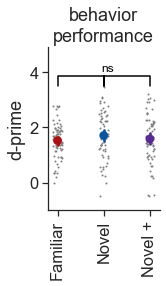

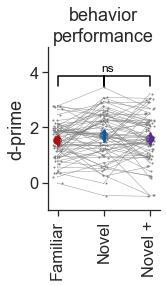

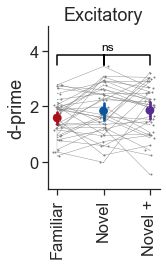

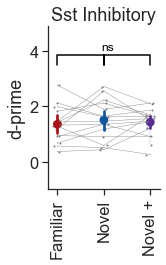

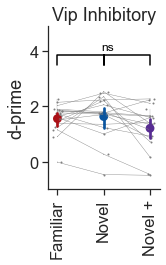

In [220]:
metric = 'max_dprime'

# metrics = ['mean_dprime', 'mean_dprime_engaged',
#        'max_dprime', 'max_dprime_engaged',]

stats = behavior_stats_sdk.copy()
stats = stats[stats.behavior_session_id.isin(platform_expts.behavior_session_id.values)]
print(len(stats.behavior_session_id.unique()))

# stats = stats[stats.image_name!='omitted']

ppf.plot_behavior_metric_by_experience(stats, metric, title='behavior\nperformance', ylabel='d-prime', ylims=[-1, 3.5],
                                       best_image=False, show_containers=False,
                                       save_dir=save_dir, folder=folder, suffix=suffix+'_sdk')

ppf.plot_behavior_metric_by_experience(stats, metric, title='behavior\nperformance', ylabel='d-prime', ylims=[-1, 3.5],
                                       best_image=False, show_containers=True,
                                       save_dir=save_dir, folder=folder, suffix=suffix+'_sdk')

# for each cell type
for cell_type in cell_types: 
    ppf.plot_behavior_metric_by_experience(stats[stats.cell_type==cell_type], metric, title=cell_type, 
                                                 ylabel='d-prime', ylims=[-1, 3.5],
                                       best_image=False, show_containers=True,
                                       save_dir=save_dir, folder=folder, suffix=suffix+'_sdk_'+cell_type)

202
saving_stats
saving_stats
saving_stats
saving_stats
saving_stats
saving_stats


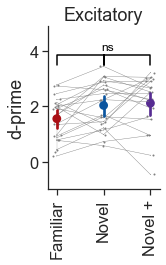

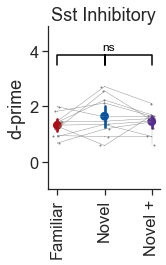

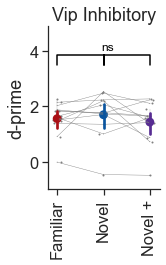

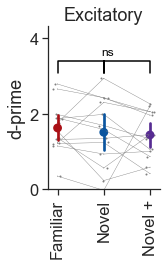

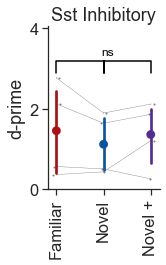

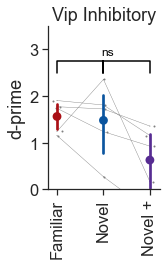

In [294]:
# per cohort for each cell type

metric = 'max_dprime'

stats = behavior_stats_sdk.copy()
# limit to ophys behavior sessions
stats = stats[stats.behavior_session_id.isin(platform_expts.behavior_session_id.values)]
print(len(stats.behavior_session_id.unique()))

for cell_type in cell_types: 
    data = stats[(stats.cell_type==cell_type)&(stats.project_code.isin(['VisualBehavior', 'VisualBehaviorMultiscope']))]
    ppf.plot_behavior_metric_by_experience(data,  metric, title=cell_type, 
                                                 ylabel='max d-prime', ylims=[-1, 3.5],
                                       best_image=False, show_containers=True,
                                       save_dir=save_dir, folder=folder, suffix=suffix+'_sdk_Task1A'+cell_type)
    

for cell_type in cell_types: 
    data = stats[(stats.cell_type==cell_type)&(stats.project_code.isin(['VisualBehaviorTask1B']))]
    ppf.plot_behavior_metric_by_experience(data,  metric, title=cell_type, 
                                                 ylabel='max d-prime', ylims=None,
                                       best_image=False, show_containers=True,
                                       save_dir=save_dir, folder=folder, suffix=suffix+'_sdk_Task1B'+cell_type)

In [255]:
def plot_behavior_metric_across_stages(data, metric, ylabel=None, save_dir=None, folder=None, suffix=''):
    """
    generate boxplot of metric values across behavior stages (gratings flashed, gratings static, familiar, novel)
    with cre line on x-axis and behavior stages as hue
    data: dataframe with one row for each behavior session and columns with metric values
    data must contain 'behavior_stages' column 
    """
    cell_types = utils.get_cell_types()
    if ylabel is None:
        ylabel = metric
    
    # remove passive sessions
    data = data[data.behavior_stage.str.contains('passive')==False]

    behavior_stages = data.behavior_stage.unique()
    color_map = get_behavior_stage_color_map(as_rgb=True)
    colors = [list(color_map[behavior_stage]) for behavior_stage in behavior_stages]
    colors = [[c/255. for c in color] for color in colors]

    figsize=(7,3)
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.boxplot(data=data, x='cell_type', y=metric, width=0.8, order=cell_types,
                        hue='behavior_stage', hue_order=behavior_stages, palette=colors, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel(ylabel)
    ax.legend().remove()
    ax.legend(bbox_to_anchor=(1,1), fontsize='x-small')

    fig.subplots_adjust(hspace=0.3)
    if save_dir: 
        utils.save_figure(fig, figsize, save_dir, folder, 'metric_across_stages_'+metric+suffix)
        # save stats
        stats = data.groupby(['cell_type', 'behavior_stage']).describe()[[metric]]
        stats.to_csv(os.path.join(save_dir, folder, 'metric_across_stages_'+metric+suffix+'_values.csv'))


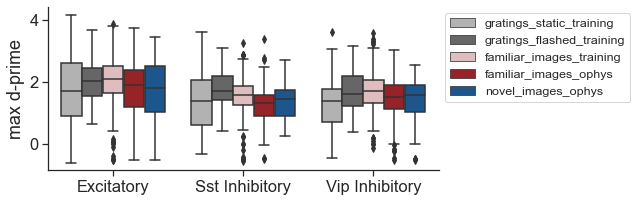

In [256]:
data = behavior_stats_sdk.copy()
metric = 'max_dprime'

plot_behavior_metric_across_stages(data, metric, ylabel='max d-prime', save_dir=save_dir, folder=folder, suffix='_sdk')

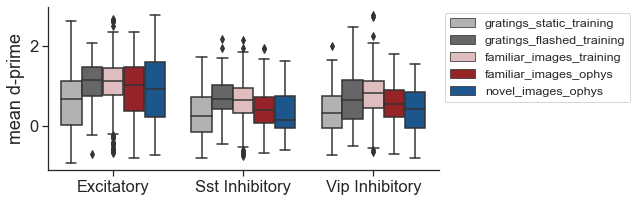

In [257]:
# mean d-prime

data = behavior_stats_sdk.copy()
metric = 'mean_dprime'

plot_behavior_metric_across_stages(data, metric, ylabel='mean d-prime', save_dir=save_dir, folder=folder, suffix='_sdk')

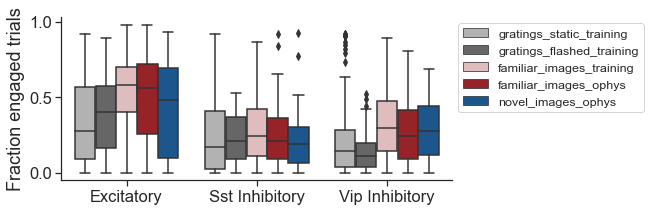

In [264]:
# fraction trials engaged

behavior_stats_sdk['fraction_trials_engaged'] = behavior_stats_sdk.engaged_trial_count / behavior_stats_sdk.trial_count

data = behavior_stats_sdk.copy()

metric = 'fraction_trials_engaged'

plot_behavior_metric_across_stages(data, metric, ylabel='Fraction engaged trials', save_dir=save_dir, folder=folder, suffix='_sdk')

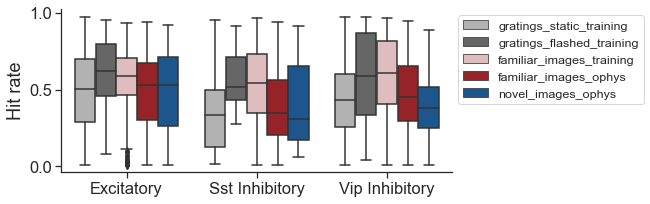

In [265]:
# mean d-prime

data = behavior_stats_sdk.copy()
metric = 'mean_hit_rate'

plot_behavior_metric_across_stages(data, metric, ylabel='Hit rate', save_dir=save_dir, folder=folder, suffix='_sdk')

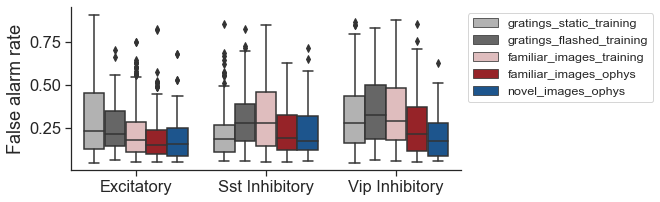

In [266]:
# mean d-prime

data = behavior_stats_sdk.copy()
metric = 'mean_false_alarm_rate'

plot_behavior_metric_across_stages(data, metric, ylabel='False alarm rate', save_dir=save_dir, folder=folder, suffix='_sdk')

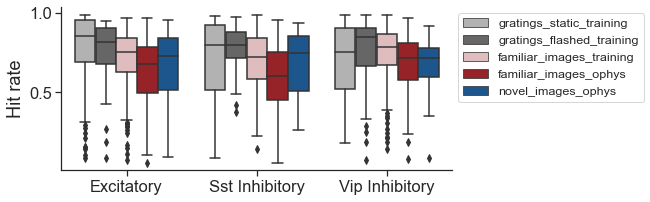

In [270]:
# mean d-prime

data = behavior_stats_sdk.copy()
metric = 'mean_hit_rate_engaged'

plot_behavior_metric_across_stages(data, metric, ylabel='Hit rate', 
                                   save_dir=save_dir, folder=folder, suffix='_sdk_engaged')

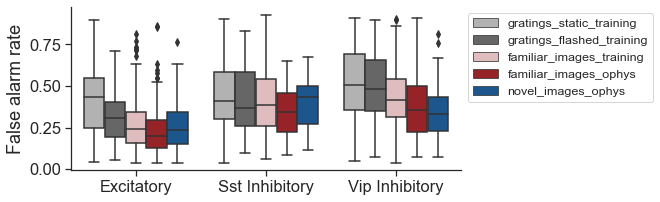

In [271]:
# mean d-prime

data = behavior_stats_sdk.copy()
metric = 'mean_false_alarm_rate_engaged'

plot_behavior_metric_across_stages(data, metric, ylabel='False alarm rate', 
                                   save_dir=save_dir, folder=folder, suffix='_sdk_engaged')

In [267]:
behavior_stats_sdk.keys()

Index(['behavior_session_id', 'trial_count', 'go_trial_count',
       'catch_trial_count', 'hit_trial_count', 'miss_trial_count',
       'false_alarm_trial_count', 'correct_reject_trial_count',
       'auto_reward_count', 'earned_reward_count', 'total_reward_count',
       'total_reward_volume', 'maximum_reward_rate', 'engaged_trial_count',
       'mean_hit_rate', 'mean_hit_rate_uncorrected', 'mean_hit_rate_engaged',
       'mean_false_alarm_rate', 'mean_false_alarm_rate_uncorrected',
       'mean_false_alarm_rate_engaged', 'mean_dprime', 'mean_dprime_engaged',
       'max_dprime', 'max_dprime_engaged', 'equipment_name', 'full_genotype',
       'mouse_id', 'reporter_line', 'driver_line', 'sex', 'age_in_days',
       'cre_line', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'ophys_session_id',
       'ophys_experiment_id', 'ophys_container_id', 'date_of_acquisition',
       'session_type', 

In [95]:
# only loads 212 sessions, not all behavior sessions saved for SDK engaged only 

# %%time 

# method = 'sdk'
# engaged_only = True
# per_image = False

## folder = get_save_folder(method, engaged_only, per_image)

# behavior_session_ids = behavior_sessions.index.values


# original_engaged_behavior_stats_sdk, problem_sessions = vbu.get_behavior_stats_for_sessions(behavior_session_ids, behavior_sessions, 
#                                     method=method, engaged_only=engaged_only, per_image=per_image)

# # set bsid as index
# original_engaged_behavior_stats_sdk.index.name = 'behavior_session_id'
# original_engaged_behavior_stats_sdk = original_engaged_behavior_stats_sdk.reset_index()

# # original_behavior_stats = behavior_stats.copy()
# engaged_behavior_stats_sdk = original_engaged_behavior_stats_sdk.merge(behavior_sessions, on='behavior_session_id')
#  # remove 4x2 sessions
# engaged_behavior_stats_sdk = engaged_behavior_stats_sdk[engaged_behavior_stats_sdk.project_code!='VisualBehaviorMultiscope4areasx2d']

In [96]:
# metric = 'mean_dprime'

# # metrics = ['mean_dprime', 'mean_dprime_engaged',
# #        'max_dprime', 'max_dprime_engaged',]

# stats = engaged_behavior_stats_sdk.copy()
# stats = stats[stats.behavior_session_id.isin(platform_expts.behavior_session_id.values)]
# print(len(stats.behavior_session_id.unique()))

# # stats = stats[stats.image_name!='omitted']

# ppf.plot_behavior_metric_by_experience(stats, metric, title='behavior\nperformance', ylabel='d-prime', ylims=[-1, 3.5],
#                                        best_image=False, show_containers=False,
#                                        save_dir=None, folder=None, suffix=suffix+'_sdk')

In [97]:
%%time 

method = 'stimulus_based'
engaged_only = True
per_image = True

behavior_session_ids = behavior_sessions.index.values


original_each_image_behavior_stats, problem_sessions = vbu.get_behavior_stats_for_sessions(behavior_session_ids, behavior_sessions, 
                                    method=method, engaged_only=engaged_only, per_image=per_image)


# original_behavior_stats = behavior_stats.copy()
each_image_behavior_stats = original_each_image_behavior_stats.merge(behavior_sessions, on='behavior_session_id')
#  remove 4x2 sessions
each_image_behavior_stats = each_image_behavior_stats[each_image_behavior_stats.project_code!='VisualBehaviorMultiscope4areasx2d']

  0%|                                                                                 | 2/2943 [00:00<03:03, 16.00it/s]

loading for 760808911
loading for 761294708
loading for 761730617


  0%|                                                                                 | 4/2943 [00:00<03:30, 13.94it/s]

loading for 762067130
loading for 762418364
loading for 763012686


  0%|▏                                                                                | 9/2943 [00:00<02:50, 17.24it/s]

loading for 763661704
loading for 764319580
loading for 764696952
loading for 765208332
loading for 765793356


  0%|▎                                                                               | 13/2943 [00:00<02:56, 16.63it/s]

loading for 766532213
loading for 766931048
loading for 767730839
loading for 768450504


  1%|▍                                                                               | 18/2943 [00:01<02:43, 17.87it/s]

loading for 769145833
loading for 769731277
loading for 770215042
loading for 771040969


  1%|▌                                                                               | 22/2943 [00:01<03:04, 15.86it/s]

loading for 771902184
loading for 772475707
loading for 773391809


  1%|▋                                                                               | 24/2943 [00:01<03:05, 15.77it/s]

loading for 774120511
loading for 774679623
loading for 775291372
loading for 776988190


  1%|▊                                                                               | 28/2943 [00:01<02:56, 16.52it/s]

loading for 778010119
loading for 778888558
loading for 779712859
loading for 780479408


  1%|▉                                                                               | 33/2943 [00:01<02:52, 16.84it/s]

loading for 781938213
loading for 783217873
loading for 783959068


  1%|▉                                                                               | 35/2943 [00:02<03:14, 14.93it/s]

loading for 785382040
loading for 786007435
loading for 786938611


  1%|█                                                                               | 37/2943 [00:02<03:10, 15.27it/s]

loading for 789008423
loading for 789870329
loading for 791248943


  1%|█                                                                               | 41/2943 [00:02<03:12, 15.04it/s]

loading for 791904071
loading for 792680306
loading for 793485674


  2%|█▏                                                                              | 45/2943 [00:02<03:13, 15.00it/s]

loading for 794968300
loading for 795742990
loading for 796052844


  2%|█▎                                                                              | 47/2943 [00:02<03:12, 15.07it/s]

loading for 796251270
loading for 798126878
loading for 772286394
loading for 773510999


  2%|█▍                                                                              | 51/2943 [00:03<02:57, 16.30it/s]

loading for 774208555
loading for 774767072
loading for 775344511
loading for 775925580


  2%|█▍                                                                              | 55/2943 [00:03<03:10, 15.15it/s]

loading for 777061425
loading for 778119826
loading for 778959204
loading for 779580423


  2%|█▋                                                                              | 60/2943 [00:03<03:02, 15.81it/s]

loading for 780351711
loading for 781727422
loading for 783059206


  2%|█▋                                                                              | 62/2943 [00:03<02:57, 16.22it/s]

loading for 783971649
loading for 785376297
loading for 785868918


  2%|█▊                                                                              | 66/2943 [00:04<03:03, 15.71it/s]

loading for 786841415
loading for 788864720
loading for 789946754
loading for 791278700


  2%|█▉                                                                              | 70/2943 [00:04<02:56, 16.27it/s]

loading for 791769447
loading for 792477679
loading for 793153175
loading for 794071128


  2%|█▉                                                                              | 72/2943 [00:04<03:17, 14.56it/s]

loading for 794673280
loading for 795431009
loading for 796031509


  3%|██                                                                              | 76/2943 [00:04<03:03, 15.66it/s]

loading for 797170547
loading for 791877093
loading for 792689261
loading for 793414389


  3%|██▏                                                                             | 79/2943 [00:04<03:00, 15.86it/s]

loading for 794295959
loading for 794977379
loading for 795854559


  3%|██▎                                                                             | 83/2943 [00:05<03:11, 14.91it/s]

loading for 799051310
loading for 799922316
loading for 800299366
loading for 800922511


  3%|██▎                                                                             | 87/2943 [00:05<03:17, 14.45it/s]

loading for 802988132
loading for 803351520
loading for 804929649


  3%|██▍                                                                             | 89/2943 [00:05<03:25, 13.92it/s]

loading for 805535249
loading for 806109931
loading for 806792366


  3%|██▌                                                                             | 93/2943 [00:05<03:16, 14.51it/s]

loading for 807356557
loading for 808324301
loading for 808883789
loading for 809358811


  3%|██▋                                                                             | 97/2943 [00:06<02:54, 16.28it/s]

loading for 810405357
loading for 811303680
loading for 811817467
loading for 812955256


  3%|██▋                                                                            | 101/2943 [00:06<02:57, 15.97it/s]

loading for 816417578
loading for 817139151
loading for 818485496
loading for 819094295


  4%|██▊                                                                            | 105/2943 [00:06<02:51, 16.59it/s]

loading for 791875850
loading for 792689257
loading for 793409670
loading for 794295950


  4%|██▉                                                                            | 109/2943 [00:06<02:59, 15.75it/s]

loading for 794977383
loading for 795854555
loading for 799049628
loading for 799919887


  4%|███                                                                            | 113/2943 [00:07<03:02, 15.53it/s]

loading for 800299362
loading for 800919728
loading for 802364085


  4%|███                                                                            | 115/2943 [00:07<03:20, 14.11it/s]

loading for 802988119
loading for 803347004
loading for 805639780


  4%|███▏                                                                           | 119/2943 [00:07<03:19, 14.14it/s]

loading for 806296598
loading for 806841326
loading for 807584876
loading for 808432167


  4%|███▎                                                                           | 123/2943 [00:07<03:30, 13.41it/s]

loading for 809027309
loading for 809427293
loading for 811355443


  4%|███▎                                                                           | 125/2943 [00:08<03:26, 13.67it/s]

loading for 810584641
loading for 811356875
loading for 811831429


  4%|███▍                                                                           | 129/2943 [00:08<03:23, 13.81it/s]

loading for 812566400
loading for 812993078
loading for 813675618


  5%|███▌                                                                           | 133/2943 [00:08<03:25, 13.70it/s]

loading for 814546737
loading for 815015329
loading for 815511978


  5%|███▋                                                                           | 136/2943 [00:08<03:07, 14.93it/s]

loading for 816381516
loading for 817182203
loading for 818758572
loading for 819245147


  5%|███▊                                                                           | 140/2943 [00:09<02:55, 16.00it/s]

loading for 819990491
loading for 821803380
loading for 822409353


  5%|███▊                                                                           | 142/2943 [00:09<03:01, 15.45it/s]

loading for 823241007
loading for 823968100
loading for 825012995


  5%|███▉                                                                           | 146/2943 [00:09<02:57, 15.80it/s]

loading for 825268982
loading for 825888541
loading for 826697158


  5%|███▉                                                                           | 148/2943 [00:09<03:01, 15.39it/s]

loading for 827374757
loading for 828646658
loading for 829138845
loading for 829578829


  5%|████                                                                           | 153/2943 [00:09<02:46, 16.71it/s]

loading for 830255592
loading for 830832988
loading for 831824426


  5%|████▏                                                                          | 155/2943 [00:10<02:48, 16.51it/s]

loading for 832981154
loading for 835444110
loading for 835820832
loading for 836399024


  5%|████▎                                                                          | 159/2943 [00:10<03:01, 15.30it/s]

loading for 807062523
loading for 808103937
loading for 809588395
loading for 810266014


  5%|████▎                                                                          | 161/2943 [00:10<02:59, 15.50it/s]

loading for 811140660
loading for 811574124


  6%|████▍                                                                          | 165/2943 [00:10<03:36, 12.85it/s]

loading for 812261209
loading for 812796028
loading for 814260983


  6%|████▌                                                                          | 169/2943 [00:11<03:16, 14.13it/s]

loading for 814749891
loading for 815865807
loading for 817053045


  6%|████▌                                                                          | 171/2943 [00:11<03:15, 14.16it/s]

loading for 818539436
loading for 819065377
loading for 819497998


  6%|████▋                                                                          | 175/2943 [00:11<03:16, 14.08it/s]

loading for 820740400
loading for 821593979
loading for 822159346


  6%|████▊                                                                          | 177/2943 [00:11<02:59, 15.44it/s]

loading for 822874578
loading for 823496226
loading for 824566587
loading for 825269006


  6%|████▊                                                                          | 181/2943 [00:11<03:16, 14.04it/s]

loading for 825902239
loading for 826697162
loading for 827374765


  6%|████▉                                                                          | 185/2943 [00:12<03:06, 14.76it/s]

loading for 828669593
loading for 829138837
loading for 829714672


  6%|█████                                                                          | 187/2943 [00:12<02:53, 15.91it/s]

loading for 830419451
loading for 830959034
loading for 831905148
loading for 833100683


  6%|█████▏                                                                         | 191/2943 [00:12<02:50, 16.18it/s]

loading for 833946929
loading for 834928595
loading for 835547527
loading for 835940015


  7%|█████▏                                                                         | 195/2943 [00:12<02:47, 16.42it/s]

loading for 837108110
loading for 837512169
loading for 823922942
loading for 824972176


  7%|█████▎                                                                         | 200/2943 [00:12<02:39, 17.19it/s]

loading for 825527066
loading for 826338809
loading for 826841473


  7%|█████▍                                                                         | 202/2943 [00:13<02:36, 17.48it/s]

loading for 827977069
loading for 828842797
loading for 829281654


  7%|█████▍                                                                         | 204/2943 [00:13<03:11, 14.31it/s]

loading for 829902556
loading for 830592943
loading for 831259963


  7%|█████▌                                                                         | 208/2943 [00:13<03:31, 12.91it/s]

loading for 832009551
loading for 832522789
loading for 833252272


  7%|█████▋                                                                         | 210/2943 [00:13<03:37, 12.55it/s]

loading for 834059775
loading for 834886139
loading for 835608988


  7%|█████▋                                                                         | 214/2943 [00:14<04:01, 11.32it/s]

loading for 836099247
loading for 836769386


  7%|█████▊                                                                         | 216/2943 [00:14<03:41, 12.29it/s]

loading for 837202082
loading for 837629869
loading for 838486964
loading for 839220840


  7%|█████▉                                                                         | 220/2943 [00:14<03:27, 13.14it/s]

loading for 839566028
loading for 839918083
loading for 840583412


  8%|█████▉                                                                         | 222/2943 [00:14<03:16, 13.88it/s]

loading for 841431760
loading for 841830077
loading for 842387217


  8%|██████                                                                         | 226/2943 [00:15<03:13, 14.01it/s]

loading for 842821314
loading for 843397714
loading for 844197868
loading for 844880686


  8%|██████▏                                                                        | 230/2943 [00:15<03:31, 12.80it/s]

loading for 845564445
loading for 846272622


  8%|██████▏                                                                        | 232/2943 [00:15<03:31, 12.84it/s]

loading for 847022155
loading for 847829598
loading for 848519645


  8%|██████▎                                                                        | 236/2943 [00:15<03:13, 13.96it/s]

loading for 849073265
loading for 849635376
loading for 850977753


  8%|██████▍                                                                        | 238/2943 [00:15<03:06, 14.52it/s]

loading for 851779746
loading for 852468381
loading for 853168204


  8%|██████▍                                                                        | 240/2943 [00:16<03:20, 13.51it/s]

loading for 853875502
loading for 854563857
loading for 855421865


  8%|██████▌                                                                        | 244/2943 [00:16<03:25, 13.14it/s]

loading for 855973498
loading for 856717282
loading for 857612105


  8%|██████▌                                                                        | 246/2943 [00:16<03:27, 12.99it/s]

loading for 859065627
loading for 859735311
loading for 860665051


  8%|██████▋                                                                        | 250/2943 [00:16<03:26, 13.07it/s]

loading for 861788094
loading for 863571072
loading for 864139911
loading for 864824449


  9%|██████▊                                                                        | 255/2943 [00:17<02:50, 15.73it/s]

loading for 865482857
loading for 866333758
loading for 867041502
loading for 867977775


  9%|██████▉                                                                        | 259/2943 [00:17<02:47, 16.05it/s]

loading for 868721114
loading for 869639141
loading for 870960890


  9%|███████                                                                        | 261/2943 [00:17<02:41, 16.62it/s]

loading for 872062433
loading for 873002413
loading for 873750535


  9%|███████                                                                        | 265/2943 [00:17<02:47, 15.94it/s]

loading for 874681118
loading for 875414332
loading for 876765708
loading for 877346183


  9%|███████▏                                                                       | 268/2943 [00:17<02:26, 18.27it/s]

loading for 877925816
loading for 878671068
loading for 879974471
loading for 880668519


  9%|███████▎                                                                       | 272/2943 [00:18<02:36, 17.08it/s]

loading for 881278000
loading for 882256127
loading for 882748184
loading for 884596128


  9%|███████▍                                                                       | 277/2943 [00:18<02:25, 18.26it/s]

loading for 885492180
loading for 886322595
loading for 886926935
loading for 888127012


 10%|███████▌                                                                       | 281/2943 [00:18<02:35, 17.09it/s]

loading for 890157940
loading for 820799656
loading for 821837682
loading for 822471786


 10%|███████▋                                                                       | 285/2943 [00:18<02:58, 14.92it/s]

loading for 823248638
loading for 823922950
loading for 824992804


 10%|███████▋                                                                       | 287/2943 [00:19<03:01, 14.65it/s]

loading for 825533866
loading for 826356747
loading for 826846303


 10%|███████▊                                                                       | 291/2943 [00:19<03:05, 14.29it/s]

loading for 827944014
loading for 828838236
loading for 829282785


 10%|███████▊                                                                       | 293/2943 [00:19<03:05, 14.27it/s]

loading for 829877552
loading for 830620126
loading for 832019583


 10%|███████▉                                                                       | 295/2943 [00:19<03:11, 13.80it/s]

loading for 832540845
loading for 833454420
loading for 834093014


 10%|████████                                                                       | 299/2943 [00:19<03:03, 14.45it/s]

loading for 834908481
loading for 835616503
loading for 836173885


 10%|████████                                                                       | 301/2943 [00:20<03:34, 12.33it/s]

loading for 836777468
loading for 837196627
loading for 837647722


 10%|████████▏                                                                      | 305/2943 [00:20<03:15, 13.52it/s]

loading for 838496122
loading for 839233516
loading for 839566049


 10%|████████▎                                                                      | 309/2943 [00:20<02:52, 15.27it/s]

loading for 839931485
loading for 840594518
loading for 841429687
loading for 841842210


 11%|████████▎                                                                      | 311/2943 [00:20<02:49, 15.49it/s]

loading for 842399625
loading for 842844413
loading for 843400443


 11%|████████▍                                                                      | 315/2943 [00:21<03:19, 13.17it/s]

loading for 844253929
loading for 845585105
loading for 846316916


 11%|████████▌                                                                      | 317/2943 [00:21<03:09, 13.88it/s]

loading for 847036338
loading for 847871771
loading for 848599542


 11%|████████▌                                                                      | 321/2943 [00:21<03:02, 14.37it/s]

loading for 849136474
loading for 849648618
loading for 850985993
loading for 851757903


 11%|████████▋                                                                      | 325/2943 [00:21<02:58, 14.68it/s]

loading for 852440775
loading for 853496105
loading for 827312851


 11%|████████▊                                                                      | 327/2943 [00:21<03:06, 14.00it/s]

loading for 828646634
loading for 829128279
loading for 829591790


 11%|████████▉                                                                      | 331/2943 [00:22<03:19, 13.12it/s]

loading for 830201482
loading for 830867799
loading for 831834820


 11%|████████▉                                                                      | 333/2943 [00:22<03:27, 12.56it/s]

loading for 832325815
loading for 832990071
loading for 833780803


 11%|█████████                                                                      | 337/2943 [00:22<03:32, 12.26it/s]

loading for 834573980
loading for 835448132
loading for 835865722


 12%|█████████                                                                      | 339/2943 [00:22<03:36, 12.05it/s]

loading for 836522259
loading for 837083666
loading for 837443225


 12%|█████████▏                                                                     | 343/2943 [00:23<03:32, 12.25it/s]

loading for 838236165
loading for 839014738
loading for 839479248


 12%|█████████▎                                                                     | 345/2943 [00:23<03:50, 11.27it/s]

loading for 839854553
loading for 840330509
loading for 841185520


 12%|█████████▎                                                                     | 349/2943 [00:23<03:39, 11.80it/s]

loading for 841730873
loading for 842139320


 12%|█████████▍                                                                     | 351/2943 [00:23<03:22, 12.81it/s]

loading for 842792100
loading for 843166865
loading for 844234790
loading for 844875410


 12%|█████████▌                                                                     | 355/2943 [00:24<03:29, 12.35it/s]

loading for 846248008
loading for 847048485
loading for 847867029


 12%|█████████▌                                                                     | 357/2943 [00:24<03:30, 12.31it/s]

loading for 848575992
loading for 849098851
loading for 850976604


 12%|█████████▋                                                                     | 361/2943 [00:24<03:07, 13.74it/s]

loading for 853266283
loading for 831129394
loading for 832021447


 12%|█████████▋                                                                     | 363/2943 [00:24<03:11, 13.49it/s]

loading for 832544149
loading for 833328750
loading for 834087859


 12%|█████████▊                                                                     | 367/2943 [00:25<03:12, 13.37it/s]

loading for 834903060
loading for 835557296
loading for 836166694


 13%|█████████▉                                                                     | 369/2943 [00:25<03:08, 13.64it/s]

loading for 836761653
loading for 837192567
loading for 837638916


 13%|██████████                                                                     | 373/2943 [00:25<03:04, 13.94it/s]

loading for 838496126
loading for 839234289
loading for 839566045
loading for 839939986


 13%|██████████▏                                                                    | 378/2943 [00:25<02:35, 16.52it/s]

loading for 840594514
loading for 841148118
loading for 841707177
loading for 842174399
loading for 842729895


 13%|██████████▎                                                                    | 383/2943 [00:26<02:22, 18.00it/s]

loading for 843203333
loading for 844164376
loading for 844849972
loading for 845441512


 13%|██████████▍                                                                    | 387/2943 [00:26<02:32, 16.77it/s]

loading for 846194950
loading for 846929750
loading for 848503804
loading for 853526948


 13%|██████████▍                                                                    | 390/2943 [00:26<02:29, 17.07it/s]

loading for 834587823
loading for 835451471
loading for 835867850
loading for 836522245


 13%|██████████▌                                                                    | 394/2943 [00:26<02:57, 14.35it/s]

loading for 837083657
loading for 837449223
loading for 838203784


 13%|██████████▋                                                                    | 396/2943 [00:26<02:55, 14.53it/s]

loading for 838998362
loading for 839468826
loading for 839837380


 14%|██████████▋                                                                    | 400/2943 [00:27<03:08, 13.52it/s]

loading for 840330501
loading for 841191836
loading for 841730868


 14%|██████████▊                                                                    | 402/2943 [00:27<02:53, 14.64it/s]

loading for 842139310
loading for 842792094
loading for 843178897


 14%|██████████▉                                                                    | 406/2943 [00:27<02:56, 14.35it/s]

loading for 844027594
loading for 844608277
loading for 845409652
loading for 846051276


 14%|███████████                                                                    | 410/2943 [00:27<02:51, 14.75it/s]

loading for 846791195
loading for 847613846
loading for 848272657


 14%|███████████                                                                    | 414/2943 [00:28<02:41, 15.68it/s]

loading for 848938321
loading for 849525884
loading for 850817466
loading for 851563931


 14%|███████████▏                                                                   | 418/2943 [00:28<02:51, 14.74it/s]

loading for 852235678
loading for 852974537
loading for 853505213


 14%|███████████▎                                                                   | 420/2943 [00:28<02:53, 14.58it/s]

loading for 854283407
loading for 855826937
loading for 857230827
loading for 837658854


 14%|███████████▍                                                                   | 424/2943 [00:28<02:35, 16.22it/s]

loading for 838515247
loading for 839219841
loading for 839565422


 14%|███████████▍                                                                   | 426/2943 [00:29<03:05, 13.58it/s]

loading for 839912316
loading for 840581827
loading for 841426832


 15%|███████████▌                                                                   | 430/2943 [00:29<02:59, 14.01it/s]

loading for 841827774
loading for 842385277
loading for 842819933


 15%|███████████▌                                                                   | 432/2943 [00:29<03:04, 13.62it/s]

loading for 843400453
loading for 844199758
loading for 844908261
loading for 845572044


 15%|███████████▋                                                                   | 437/2943 [00:29<02:54, 14.35it/s]

loading for 846331423
loading for 847036328
loading for 847874940
loading for 848613406


 15%|███████████▊                                                                   | 441/2943 [00:30<02:51, 14.61it/s]

loading for 849147676
loading for 849651275
loading for 850989832
loading for 851773928


 15%|███████████▉                                                                   | 445/2943 [00:30<02:44, 15.20it/s]

loading for 852451567
loading for 855200229
loading for 840598877


 15%|███████████▉                                                                   | 447/2943 [00:30<02:52, 14.44it/s]

loading for 841466830
loading for 841851097
loading for 842419799
loading for 842840144


 15%|████████████▏                                                                  | 452/2943 [00:30<02:34, 16.09it/s]

loading for 843423171
loading for 844229895
loading for 844945060
loading for 845594684


 15%|████████████▏                                                                  | 456/2943 [00:31<02:35, 16.01it/s]

loading for 846284880
loading for 847048490
loading for 847838131


 16%|████████████▎                                                                  | 460/2943 [00:31<02:40, 15.48it/s]

loading for 848526511
loading for 848910243
loading for 849485548


 16%|████████████▍                                                                  | 462/2943 [00:31<02:50, 14.58it/s]

loading for 850810858
loading for 851471401
loading for 852202150


 16%|████████████▍                                                                  | 464/2943 [00:31<02:45, 14.96it/s]

loading for 852966248
loading for 853875514
loading for 854621677


 16%|████████████▌                                                                  | 468/2943 [00:31<02:55, 14.11it/s]

loading for 855424348
loading for 857340041
loading for 857987666
loading for 858974731


 16%|████████████▋                                                                  | 472/2943 [00:32<02:41, 15.26it/s]

loading for 859775117
loading for 863610582
loading for 868070216
loading for 868658294


 16%|████████████▊                                                                  | 476/2943 [00:32<02:41, 15.29it/s]

loading for 869559097
loading for 854533487
loading for 855504136
loading for 856002607


 16%|████████████▉                                                                  | 480/2943 [00:32<02:49, 14.49it/s]

loading for 856732191
loading for 857555456
loading for 858240891


 16%|████████████▉                                                                  | 482/2943 [00:32<03:02, 13.47it/s]

loading for 859032026
loading for 859791558
loading for 860752803


 17%|█████████████                                                                  | 486/2943 [00:33<03:01, 13.53it/s]

loading for 861794699
loading for 862701465
loading for 863571054


 17%|█████████████▏                                                                 | 490/2943 [00:33<02:49, 14.51it/s]

loading for 864137547
loading for 864839176
loading for 865581941


 17%|█████████████▏                                                                 | 492/2943 [00:33<03:02, 13.40it/s]

loading for 866287088
loading for 866950070
loading for 867615529


 17%|█████████████▎                                                                 | 494/2943 [00:33<02:52, 14.21it/s]

loading for 868540333
loading for 869319414
loading for 870660821


 17%|█████████████▎                                                                 | 498/2943 [00:34<02:57, 13.76it/s]

loading for 871808378
loading for 872646068
loading for 873517635


 17%|█████████████▍                                                                 | 500/2943 [00:34<02:50, 14.37it/s]

loading for 874324533
loading for 875471358
cant load stats for 875471358
loading for 876574139
loading for 850970486


 17%|█████████████▌                                                                 | 506/2943 [00:34<02:15, 17.93it/s]

loading for 851843550
loading for 852507945
loading for 853260939
loading for 853886146


 17%|█████████████▋                                                                 | 508/2943 [00:34<02:30, 16.23it/s]

loading for 855459012
loading for 855980937
loading for 856719615


 17%|█████████████▋                                                                 | 512/2943 [00:34<02:42, 14.92it/s]

loading for 857504898
loading for 858250763
loading for 859049298
loading for 859784868


 17%|█████████████▊                                                                 | 515/2943 [00:35<02:34, 15.76it/s]

loading for 860836980
loading for 861789935
loading for 862716913


 18%|█████████████▉                                                                 | 519/2943 [00:35<02:41, 15.01it/s]

loading for 863614836
loading for 864260028
loading for 864813130


 18%|██████████████                                                                 | 523/2943 [00:35<02:34, 15.62it/s]

loading for 865460179
loading for 866296478
loading for 866999677
loading for 867615541


 18%|██████████████                                                                 | 525/2943 [00:35<02:57, 13.59it/s]

loading for 868555361
loading for 869334643
loading for 870592115


 18%|██████████████▏                                                                | 529/2943 [00:36<03:09, 12.73it/s]

loading for 871808394
loading for 872626160
loading for 873695653


 18%|██████████████▎                                                                | 532/2943 [00:36<02:50, 14.15it/s]

loading for 874699922
loading for 875440936
loading for 876678452
loading for 877617747


 18%|██████████████▍                                                                | 537/2943 [00:36<02:28, 16.22it/s]

loading for 878120101
loading for 879037269
loading for 880046522
loading for 880784794
loading for 882256117


 18%|██████████████▌                                                                | 541/2943 [00:36<02:25, 16.55it/s]

loading for 858104885
loading for 858900546
loading for 859601488


 18%|██████████████▌                                                                | 543/2943 [00:36<02:42, 14.77it/s]

loading for 860247669
loading for 861717498
loading for 862339401
loading for 863365105


 19%|██████████████▋                                                                | 548/2943 [00:37<02:42, 14.73it/s]

loading for 863966979
loading for 864665192
loading for 865114696


 19%|██████████████▊                                                                | 552/2943 [00:37<02:38, 15.05it/s]

loading for 865887829
loading for 866906696
loading for 867505993


 19%|██████████████▊                                                                | 554/2943 [00:37<02:35, 15.34it/s]

loading for 868511825
loading for 869198966
loading for 870481699


 19%|██████████████▉                                                                | 556/2943 [00:37<02:42, 14.68it/s]

loading for 871723063
loading for 872607293
loading for 873440431
loading for 874324527


 19%|███████████████                                                                | 561/2943 [00:38<02:29, 15.97it/s]

loading for 875020211
loading for 876448536
loading for 877855866


 19%|███████████████                                                                | 563/2943 [00:38<02:44, 14.47it/s]

loading for 878615859
loading for 879846629
loading for 880581639


 19%|███████████████▏                                                               | 567/2943 [00:38<02:49, 14.04it/s]

loading for 881204796
loading for 882289836
loading for 883851453


 19%|███████████████▎                                                               | 571/2943 [00:38<02:38, 14.95it/s]

loading for 884598044
loading for 885404075
loading for 886376835


 19%|███████████████▍                                                               | 573/2943 [00:38<02:47, 14.11it/s]

loading for 888213949
loading for 890021100
loading for 893362730


 20%|███████████████▍                                                               | 575/2943 [00:39<02:52, 13.72it/s]

loading for 894103623
loading for 895022326
loading for 895562386


 20%|███████████████▌                                                               | 580/2943 [00:39<02:28, 15.95it/s]

loading for 896561264
loading for 898432373
loading for 898874650
loading for 899390684


 20%|███████████████▋                                                               | 584/2943 [00:39<02:25, 16.19it/s]

loading for 901999401
loading for 903708760
loading for 904574580
loading for 906472625


 20%|███████████████▋                                                               | 586/2943 [00:39<02:25, 16.17it/s]

loading for 907053876
loading for 907900077
loading for 908533370


 20%|███████████████▊                                                               | 590/2943 [00:40<02:35, 15.11it/s]

loading for 910207192
loading for 910829549
loading for 911904717


 20%|███████████████▉                                                               | 592/2943 [00:40<02:32, 15.40it/s]

loading for 913673477
loading for 914211263
loading for 914705301
loading for 915418411


 20%|████████████████                                                               | 597/2943 [00:40<02:32, 15.34it/s]

loading for 916403851
loading for 918103715
loading for 923410363
loading for 924472023


 20%|████████████████▏                                                              | 601/2943 [00:40<02:39, 14.71it/s]

loading for 925084998
loading for 862479694
loading for 863414647


 21%|████████████████▏                                                              | 605/2943 [00:41<02:34, 15.10it/s]

loading for 864000195
loading for 864729508
loading for 865288307


 21%|████████████████▎                                                              | 607/2943 [00:41<02:42, 14.39it/s]

loading for 865953304
loading for 866971252
loading for 867649878


 21%|████████████████▎                                                              | 609/2943 [00:41<02:44, 14.16it/s]

loading for 868546763
loading for 869311954
loading for 870592103


 21%|████████████████▍                                                              | 613/2943 [00:41<02:51, 13.56it/s]

loading for 871782387
loading for 872720256
loading for 873530279


 21%|████████████████▌                                                              | 615/2943 [00:41<02:59, 12.97it/s]

loading for 874295478
loading for 875020129
loading for 876521253


 21%|████████████████▌                                                              | 619/2943 [00:42<02:52, 13.46it/s]

loading for 877346192
loading for 877938181
loading for 878671074


 21%|████████████████▋                                                              | 621/2943 [00:42<02:42, 14.27it/s]

loading for 879958654
loading for 880647168
loading for 881253316


 21%|████████████████▊                                                              | 625/2943 [00:42<02:49, 13.70it/s]

loading for 882233951
loading for 882679635
loading for 883632948


 21%|████████████████▊                                                              | 627/2943 [00:42<02:47, 13.85it/s]

loading for 884560033
loading for 885418521
loading for 886262841


 21%|████████████████▉                                                              | 631/2943 [00:42<02:44, 14.02it/s]

loading for 886900197
loading for 889183454
loading for 890054551


 22%|████████████████▉                                                              | 633/2943 [00:43<02:56, 13.10it/s]

loading for 891504476
loading for 892413871
loading for 893359124


 22%|█████████████████                                                              | 637/2943 [00:43<03:04, 12.51it/s]

loading for 894215849
loading for 894994111


 22%|█████████████████▏                                                             | 639/2943 [00:43<03:13, 11.92it/s]

loading for 896543686
loading for 898461372


 22%|█████████████████▏                                                             | 641/2943 [00:43<03:15, 11.76it/s]

loading for 898890800
loading for 899461485
loading for 902028378


 22%|█████████████████▎                                                             | 643/2943 [00:43<03:04, 12.46it/s]

loading for 902822538
loading for 904625819
loading for 907035965


 22%|█████████████████▎                                                             | 647/2943 [00:44<02:47, 13.68it/s]

loading for 907995400
loading for 908564873
loading for 910249985


 22%|█████████████████▍                                                             | 649/2943 [00:44<02:46, 13.78it/s]

loading for 911361486
loading for 912159483
loading for 913921659
loading for 914411174


 22%|█████████████████▌                                                             | 654/2943 [00:44<02:41, 14.21it/s]

loading for 914871449
loading for 915739774
loading for 916704634


 22%|█████████████████▌                                                             | 656/2943 [00:44<02:50, 13.39it/s]

loading for 917595407
loading for 918474069
loading for 919104267


 22%|█████████████████▋                                                             | 660/2943 [00:45<02:49, 13.48it/s]

loading for 920015895
loading for 920839478
loading for 922012422


 22%|█████████████████▊                                                             | 662/2943 [00:45<02:56, 12.92it/s]

loading for 923834852
loading for 924759623
loading for 925603486


 23%|█████████████████▉                                                             | 666/2943 [00:45<02:44, 13.80it/s]

loading for 927905748
loading for 929551055
loading for 935301109
loading for 936273485


 23%|█████████████████▉                                                             | 670/2943 [00:45<02:24, 15.76it/s]

loading for 862730050
loading for 863657189
loading for 864236370
loading for 864809053


 23%|██████████████████                                                             | 675/2943 [00:46<02:19, 16.21it/s]

loading for 865443418
loading for 866300303
loading for 867045079
loading for 867977763


 23%|██████████████████▏                                                            | 677/2943 [00:46<02:25, 15.62it/s]

loading for 868704504
loading for 869615887
loading for 870960882


 23%|██████████████████▎                                                            | 681/2943 [00:46<02:28, 15.27it/s]

loading for 872864902
loading for 873729011
loading for 874691139
loading for 875402170


 23%|██████████████████▍                                                            | 685/2943 [00:46<02:41, 13.95it/s]

loading for 876701397
loading for 877524045


 23%|██████████████████▍                                                            | 687/2943 [00:46<02:40, 14.06it/s]

loading for 878137744
loading for 879003593
loading for 880088387


 23%|██████████████████▌                                                            | 691/2943 [00:47<02:37, 14.29it/s]

loading for 881416618
loading for 882373648
loading for 882785348


 24%|██████████████████▌                                                            | 693/2943 [00:47<02:32, 14.76it/s]

loading for 883984332
loading for 884750162
loading for 885540222
loading for 886440427


 24%|██████████████████▋                                                            | 697/2943 [00:47<02:35, 14.40it/s]

loading for 886931452
loading for 888282572
loading for 889443507


 24%|██████████████████▊                                                            | 699/2943 [00:47<02:52, 13.03it/s]

loading for 890355790
loading for 891618314
loading for 892491402
loading for 893540605


 24%|██████████████████▉                                                            | 704/2943 [00:48<02:39, 14.03it/s]

loading for 894466746
loading for 895241719
loading for 895877676


 24%|██████████████████▉                                                            | 706/2943 [00:48<02:33, 14.54it/s]

loading for 896969091
loading for 898658063
loading for 899685557


 24%|███████████████████                                                            | 710/2943 [00:48<02:48, 13.27it/s]

loading for 900226857
loading for 901340457
loading for 902244344


 24%|███████████████████                                                            | 712/2943 [00:48<02:54, 12.81it/s]

loading for 902962312
loading for 904899490
loading for 906641078


 24%|███████████████████▏                                                           | 716/2943 [00:49<02:55, 12.69it/s]

loading for 908092560
loading for 910381299
loading for 911016296


 24%|███████████████████▎                                                           | 718/2943 [00:49<02:44, 13.50it/s]

loading for 911541959
loading for 912902650
loading for 913850438
loading for 914336989


 24%|███████████████████▎                                                           | 721/2943 [00:49<02:30, 14.73it/s]

loading for 914828503
loading for 915609195


 25%|███████████████████▍                                                           | 725/2943 [00:49<02:44, 13.49it/s]

loading for 916614400
loading for 917500273
loading for 918451984
loading for 919022193


 25%|███████████████████▌                                                           | 729/2943 [00:50<02:39, 13.84it/s]

loading for 919895633
loading for 920807985
loading for 921873454


 25%|███████████████████▌                                                           | 731/2943 [00:50<02:38, 13.95it/s]

loading for 923757660
loading for 924739087
loading for 926621793


 25%|███████████████████▋                                                           | 735/2943 [00:50<02:31, 14.56it/s]

loading for 927652117
loading for 928654503
loading for 929522558
loading for 930344462


 25%|███████████████████▊                                                           | 740/2943 [00:50<02:13, 16.53it/s]

loading for 932960096
loading for 933939891
loading for 935038748
loading for 936159430


 25%|███████████████████▉                                                           | 744/2943 [00:50<02:11, 16.71it/s]

loading for 937645038
loading for 938729036
loading for 940017429
loading for 941802699


 25%|████████████████████                                                           | 747/2943 [00:51<02:09, 16.93it/s]

loading for 942814025
loading for 943833533
loading for 945033994


 26%|████████████████████▏                                                          | 751/2943 [00:51<02:22, 15.39it/s]

loading for 947336783
loading for 948225040
loading for 949348713


 26%|████████████████████▏                                                          | 753/2943 [00:51<02:18, 15.76it/s]

loading for 950188644
loading for 862245493
loading for 863368489


 26%|████████████████████▎                                                          | 755/2943 [00:51<02:23, 15.29it/s]

loading for 863966974
loading for 864665204
loading for 865131331


 26%|████████████████████▎                                                          | 759/2943 [00:51<02:23, 15.26it/s]

loading for 865887821
loading for 866909432
loading for 867521015
loading for 868513545


 26%|████████████████████▍                                                          | 763/2943 [00:52<02:19, 15.62it/s]

loading for 869214215
loading for 870481685
loading for 871728970
loading for 872609185


 26%|████████████████████▌                                                          | 767/2943 [00:52<02:26, 14.90it/s]

loading for 873449838
loading for 874333572
loading for 875020175


 26%|████████████████████▋                                                          | 769/2943 [00:52<02:33, 14.16it/s]

loading for 876448528
loading for 877855879
loading for 878615867


 26%|████████████████████▋                                                          | 773/2943 [00:53<02:54, 12.40it/s]

loading for 879854787
loading for 880590869


 26%|████████████████████▊                                                          | 775/2943 [00:53<02:42, 13.30it/s]

loading for 881210690
loading for 882291265
loading for 882736270


 26%|████████████████████▉                                                          | 779/2943 [00:53<02:27, 14.70it/s]

loading for 883857883
loading for 884605735
loading for 885404024


 27%|████████████████████▉                                                          | 781/2943 [00:53<02:28, 14.55it/s]

loading for 886382175
loading for 888218684
loading for 890021090


 27%|█████████████████████                                                          | 783/2943 [00:53<02:29, 14.42it/s]

loading for 893608687
loading for 894495169
loading for 895278567


 27%|█████████████████████▏                                                         | 787/2943 [00:53<02:34, 13.97it/s]

loading for 895809864
loading for 896882463
loading for 898665096


 27%|█████████████████████▏                                                         | 791/2943 [00:54<02:34, 13.97it/s]

loading for 898938920
loading for 900227468
loading for 901316636


 27%|█████████████████████▎                                                         | 793/2943 [00:54<02:39, 13.44it/s]

loading for 902211897
loading for 902995627
loading for 903977177


 27%|█████████████████████▎                                                         | 795/2943 [00:54<02:37, 13.63it/s]

loading for 904922800
loading for 906658064
loading for 907327499


 27%|█████████████████████▍                                                         | 799/2943 [00:54<02:39, 13.48it/s]

loading for 908122381
loading for 912640306
loading for 866287136


 27%|█████████████████████▌                                                         | 801/2943 [00:55<02:41, 13.30it/s]

loading for 867036293
loading for 867961854
loading for 868653129


 27%|█████████████████████▌                                                         | 805/2943 [00:55<02:32, 14.03it/s]

loading for 869623244
loading for 870935142
loading for 872043024


 27%|█████████████████████▋                                                         | 807/2943 [00:55<03:49,  9.29it/s]

loading for 872979424
loading for 873739031
loading for 874654280


 28%|█████████████████████▊                                                         | 811/2943 [00:56<03:18, 10.72it/s]

loading for 875385921
loading for 876737442
loading for 877558833


 28%|█████████████████████▊                                                         | 813/2943 [00:56<03:11, 11.10it/s]

loading for 878245978
loading for 878993255
loading for 880191880


 28%|█████████████████████▉                                                         | 817/2943 [00:56<03:00, 11.78it/s]

loading for 880775454
loading for 881425509
loading for 882401590
loading for 883756380


 28%|██████████████████████                                                         | 821/2943 [00:56<02:41, 13.16it/s]

loading for 884552901
loading for 885410929
loading for 886257016


 28%|██████████████████████▏                                                        | 825/2943 [00:57<02:26, 14.50it/s]

loading for 886838602
loading for 888033338
loading for 889175194
loading for 890033129


 28%|██████████████████████▏                                                        | 827/2943 [00:57<02:34, 13.65it/s]

loading for 891446789
loading for 892387261
loading for 893344360
loading for 894083470


 28%|██████████████████████▎                                                        | 833/2943 [00:57<02:04, 16.93it/s]

loading for 898440124
loading for 866128606
loading for 866971269
loading for 867645566
loading for 868531777


 28%|██████████████████████▍                                                        | 837/2943 [00:57<02:14, 15.71it/s]

loading for 869311972
loading for 870579061
loading for 871782397


 29%|██████████████████████▌                                                        | 841/2943 [00:58<02:18, 15.15it/s]

loading for 872690218
loading for 873537911
loading for 874416985


 29%|██████████████████████▋                                                        | 843/2943 [00:58<02:25, 14.38it/s]

loading for 875020203
loading for 876651891
loading for 877487375


 29%|██████████████████████▋                                                        | 845/2943 [00:58<02:35, 13.46it/s]

loading for 878179382
loading for 878771403
loading for 879969002


 29%|██████████████████████▊                                                        | 849/2943 [00:58<02:43, 12.84it/s]

loading for 880644824
loading for 881251187
loading for 882219267


 29%|██████████████████████▊                                                        | 852/2943 [00:58<02:22, 14.71it/s]

loading for 882677813
loading for 883632956
loading for 884560064
loading for 885410934


 29%|██████████████████████▉                                                        | 856/2943 [00:59<02:16, 15.33it/s]

loading for 886250995
loading for 887006111
loading for 888163519


 29%|███████████████████████                                                        | 858/2943 [00:59<02:19, 15.00it/s]

loading for 889388078
loading for 890625596
loading for 891605682


 29%|███████████████████████▏                                                       | 862/2943 [00:59<02:19, 14.90it/s]

loading for 892526544
loading for 893488330
loading for 894368064
loading for 870987812


 29%|███████████████████████▏                                                       | 866/2943 [00:59<02:16, 15.22it/s]

loading for 872953842
loading for 873774125
loading for 874790261
loading for 875207834


 30%|███████████████████████▍                                                       | 871/2943 [01:00<02:08, 16.16it/s]

loading for 876821726
loading for 877603209
loading for 878245989
loading for 879003606


 30%|███████████████████████▍                                                       | 875/2943 [01:00<02:11, 15.67it/s]

loading for 880088400
loading for 881416637
loading for 882373653
loading for 882781075


 30%|███████████████████████▌                                                       | 877/2943 [01:00<02:11, 15.74it/s]

loading for 883986743
loading for 884776248
loading for 885540237


 30%|███████████████████████▋                                                       | 881/2943 [01:00<02:22, 14.42it/s]

loading for 886442346
loading for 886946944
loading for 888295170
loading for 889468960


 30%|███████████████████████▊                                                       | 885/2943 [01:01<02:12, 15.57it/s]

loading for 890408602
loading for 891635659
loading for 891635667
loading for 892510304


 30%|███████████████████████▊                                                       | 889/2943 [01:01<02:16, 15.01it/s]

loading for 893560763
loading for 894481319
loading for 895248933


 30%|███████████████████████▉                                                       | 893/2943 [01:01<02:18, 14.79it/s]

loading for 895896343
loading for 896995828
loading for 898667252


 30%|████████████████████████                                                       | 895/2943 [01:01<02:20, 14.60it/s]

loading for 899700579
loading for 900231059
loading for 901363879
loading for 902260156


 31%|████████████████████████▏                                                      | 899/2943 [01:02<02:18, 14.76it/s]

loading for 902975505
loading for 904922810
loading for 906668549


 31%|████████████████████████▏                                                      | 903/2943 [01:02<02:17, 14.83it/s]

loading for 908104455
loading for 910393217
loading for 911016285


 31%|████████████████████████▎                                                      | 905/2943 [01:02<02:14, 15.17it/s]

loading for 911541950
loading for 912223787
loading for 912902619


 31%|████████████████████████▎                                                      | 907/2943 [01:02<02:21, 14.34it/s]

loading for 913850450
loading for 914339617
loading for 914831000
loading for 915609216


 31%|████████████████████████▍                                                      | 912/2943 [01:02<02:02, 16.53it/s]

loading for 916617096
loading for 917500256
loading for 918451994
loading for 919025442


 31%|████████████████████████▌                                                      | 916/2943 [01:03<02:12, 15.32it/s]

loading for 920901263
loading for 921979060
loading for 923757653
loading for 924739774


 31%|████████████████████████▋                                                      | 920/2943 [01:03<02:05, 16.06it/s]

loading for 926621788
loading for 927652110
loading for 928654491
loading for 929524423


 31%|████████████████████████▊                                                      | 924/2943 [01:03<02:17, 14.63it/s]

loading for 930344469
loading for 932960104
loading for 933954934


 31%|████████████████████████▊                                                      | 926/2943 [01:03<02:28, 13.59it/s]

loading for 935045761
loading for 936083473
loading for 937706038


 32%|████████████████████████▉                                                      | 930/2943 [01:04<02:26, 13.77it/s]

loading for 938794488
loading for 939985541
loading for 940755050


 32%|█████████████████████████                                                      | 932/2943 [01:04<02:24, 13.90it/s]

loading for 941734036
loading for 942767530
loading for 944125005


 32%|█████████████████████████▏                                                     | 936/2943 [01:04<02:32, 13.13it/s]

loading for 945075740
loading for 947988590
loading for 949201674


 32%|█████████████████████████▏                                                     | 940/2943 [01:04<02:18, 14.47it/s]

loading for 949973686
loading for 951520319
loading for 952554548
loading for 953982960


 32%|█████████████████████████▎                                                     | 942/2943 [01:04<02:18, 14.40it/s]

loading for 956010809
loading for 957032492
loading for 958234742
loading for 958888263


 32%|█████████████████████████▍                                                     | 947/2943 [01:05<02:09, 15.45it/s]

loading for 959681045
loading for 875126982
loading for 876823447
loading for 877605077


 32%|█████████████████████████▌                                                     | 952/2943 [01:05<01:58, 16.80it/s]

loading for 878245966
loading for 879074585
loading for 880174939
loading for 881450253


 32%|█████████████████████████▌                                                     | 954/2943 [01:05<02:08, 15.52it/s]

loading for 882426675
loading for 882833335
loading for 884004562


 33%|█████████████████████████▋                                                     | 958/2943 [01:05<02:09, 15.38it/s]

loading for 884776271
loading for 885598412
loading for 886446962
loading for 886953901


 33%|█████████████████████████▊                                                     | 962/2943 [01:06<02:15, 14.64it/s]

loading for 888298590
loading for 889478291
loading for 890408635


 33%|█████████████████████████▉                                                     | 966/2943 [01:06<02:13, 14.78it/s]

loading for 891635663
loading for 892525019
loading for 893560739


 33%|█████████████████████████▉                                                     | 968/2943 [01:06<02:28, 13.26it/s]

loading for 894481291
loading for 895262003


 33%|██████████████████████████                                                     | 970/2943 [01:06<02:25, 13.59it/s]

loading for 895896368
loading for 896995823
loading for 898682070


 33%|██████████████████████████                                                     | 972/2943 [01:06<02:19, 14.17it/s]

loading for 899742869
loading for 901424076
loading for 902328548


 33%|██████████████████████████▏                                                    | 976/2943 [01:07<02:13, 14.69it/s]

loading for 903098779
loading for 904954571
loading for 906726720
loading for 908165653


 33%|██████████████████████████▎                                                    | 979/2943 [01:07<01:57, 16.68it/s]

loading for 910448027
loading for 911061160
loading for 911581364


 33%|██████████████████████████▍                                                    | 983/2943 [01:07<02:24, 13.56it/s]

loading for 912318840
loading for 913014398
loading for 913917929


 33%|██████████████████████████▍                                                    | 985/2943 [01:07<02:18, 14.18it/s]

loading for 914408296
loading for 914859356
loading for 915690413


 34%|██████████████████████████▌                                                    | 989/2943 [01:08<02:14, 14.49it/s]

loading for 916673577
loading for 917600513
loading for 918448801
loading for 919022174


 34%|██████████████████████████▋                                                    | 993/2943 [01:08<02:32, 12.75it/s]

loading for 919890884
loading for 920807973
loading for 921873450


 34%|██████████████████████████▋                                                    | 995/2943 [01:08<02:19, 13.98it/s]

loading for 923750087
loading for 924740575
loading for 926614379


 34%|██████████████████████████▊                                                    | 999/2943 [01:08<02:20, 13.82it/s]

loading for 927643982
loading for 928647601
loading for 929522554


 34%|██████████████████████████▌                                                   | 1001/2943 [01:09<02:33, 12.67it/s]

loading for 930376122
loading for 931913977


 34%|██████████████████████████▌                                                   | 1003/2943 [01:09<02:46, 11.67it/s]

loading for 932628715
loading for 933604243
loading for 934812249


 34%|██████████████████████████▋                                                   | 1007/2943 [01:09<02:25, 13.27it/s]

loading for 935653479
loading for 937395157
loading for 938339083


 34%|██████████████████████████▋                                                   | 1009/2943 [01:09<02:25, 13.26it/s]

loading for 939533442
loading for 940628402
loading for 941425961


 34%|██████████████████████████▊                                                   | 1013/2943 [01:10<02:39, 12.10it/s]

loading for 942350598
loading for 875155219
loading for 876829777


 34%|██████████████████████████▉                                                   | 1015/2943 [01:10<02:41, 11.95it/s]

loading for 877607698
loading for 878251933
loading for 879074574


 35%|███████████████████████████                                                   | 1019/2943 [01:10<02:17, 14.04it/s]

loading for 880181164
loading for 881450232
loading for 882426670
loading for 882844402


 35%|███████████████████████████▏                                                  | 1024/2943 [01:10<01:58, 16.16it/s]

loading for 884070037
loading for 884846935
loading for 885609778


 35%|███████████████████████████▏                                                  | 1026/2943 [01:10<02:03, 15.52it/s]

loading for 886472241
loading for 887175302
loading for 888346887


 35%|███████████████████████████▎                                                  | 1030/2943 [01:11<02:02, 15.57it/s]

loading for 889536668
loading for 890555457
loading for 891724311


 35%|███████████████████████████▎                                                  | 1032/2943 [01:11<02:01, 15.69it/s]

loading for 893564091
loading for 894481299
loading for 895256170
loading for 895902286


 35%|███████████████████████████▍                                                  | 1036/2943 [01:11<02:06, 15.07it/s]

loading for 897002967
loading for 898668828
loading for 899700587
loading for 900231063


 35%|███████████████████████████▌                                                  | 1040/2943 [01:11<01:58, 16.08it/s]

loading for 901363886
loading for 902260148
loading for 902975514
loading for 904922795


 35%|███████████████████████████▋                                                  | 1044/2943 [01:12<02:05, 15.11it/s]

loading for 906668545
loading for 908109320
loading for 910393226


 36%|███████████████████████████▊                                                  | 1048/2943 [01:12<02:07, 14.85it/s]

loading for 911019327
loading for 911543418
loading for 912223793
loading for 912223799


 36%|███████████████████████████▊                                                  | 1050/2943 [01:12<02:22, 13.29it/s]

loading for 912902659
loading for 913854181
loading for 914339627


 36%|███████████████████████████▉                                                  | 1054/2943 [01:12<02:21, 13.33it/s]

loading for 914831033
loading for 915609229
loading for 916617112


 36%|███████████████████████████▉                                                  | 1056/2943 [01:13<02:54, 10.81it/s]

loading for 917506393
loading for 918454529


 36%|████████████████████████████                                                  | 1058/2943 [01:13<02:41, 11.67it/s]

loading for 919025470
loading for 919902020
loading for 920813990


 36%|████████████████████████████▏                                                 | 1063/2943 [01:13<02:18, 13.60it/s]

loading for 921879360
loading for 923877874
loading for 924757055
loading for 926621779


 36%|████████████████████████████▏                                                 | 1065/2943 [01:13<02:08, 14.60it/s]

loading for 927643992
loading for 928647605
loading for 929522550


 36%|████████████████████████████▎                                                 | 1069/2943 [01:14<02:29, 12.52it/s]

loading for 930335512
loading for 931488919
loading for 932596575


 36%|████████████████████████████▍                                                 | 1071/2943 [01:14<02:24, 12.97it/s]

loading for 933472975
loading for 935601725
loading for 937442661


 37%|████████████████████████████▍                                                 | 1075/2943 [01:14<02:13, 14.00it/s]

loading for 938425882
loading for 939537734
loading for 940553228
loading for 941457567


 37%|████████████████████████████▌                                                 | 1079/2943 [01:14<02:03, 15.08it/s]

loading for 942329079
loading for 943479988
loading for 944823947
loading for 882765152


 37%|████████████████████████████▋                                                 | 1083/2943 [01:15<02:11, 14.11it/s]

loading for 883908190
loading for 884881862
loading for 885609760


 37%|████████████████████████████▊                                                 | 1087/2943 [01:15<02:12, 14.06it/s]

loading for 886424035
loading for 887142121
loading for 888298597


 37%|████████████████████████████▊                                                 | 1089/2943 [01:15<02:13, 13.90it/s]

loading for 889478282
loading for 890578468
loading for 891752782


 37%|████████████████████████████▉                                                 | 1091/2943 [01:15<02:03, 14.94it/s]

loading for 892597881
loading for 893551176
loading for 894489950


 37%|█████████████████████████████                                                 | 1095/2943 [01:15<02:13, 13.79it/s]

loading for 895248904
loading for 895947603
loading for 896945902


 37%|█████████████████████████████                                                 | 1097/2943 [01:15<02:08, 14.38it/s]

loading for 898691674
loading for 898982250
loading for 901251663


 37%|█████████████████████████████▏                                                | 1101/2943 [01:16<02:04, 14.76it/s]

loading for 902135840
loading for 902871565
loading for 903842232
loading for 904844395


 38%|█████████████████████████████▎                                                | 1106/2943 [01:16<01:51, 16.52it/s]

loading for 908065760
loading for 888282565
loading for 889461157
loading for 890450001


 38%|█████████████████████████████▍                                                | 1110/2943 [01:16<01:45, 17.34it/s]

loading for 891789286
loading for 892645353
loading for 893600610
loading for 894481279


 38%|█████████████████████████████▍                                                | 1112/2943 [01:16<01:52, 16.30it/s]

loading for 895270564
loading for 896024686
loading for 896931325


 38%|█████████████████████████████▌                                                | 1116/2943 [01:17<01:52, 16.29it/s]

loading for 898658079
loading for 899685565
loading for 900226853
loading for 901358520


 38%|█████████████████████████████▋                                                | 1120/2943 [01:17<02:02, 14.90it/s]

loading for 902255179
loading for 902975500
loading for 904917894


 38%|█████████████████████████████▊                                                | 1124/2943 [01:17<02:02, 14.88it/s]

loading for 906658076
loading for 907195053
loading for 908930196


 38%|█████████████████████████████▊                                                | 1126/2943 [01:17<02:02, 14.87it/s]

loading for 910396133
loading for 911025799
loading for 911527254


 38%|█████████████████████████████▉                                                | 1130/2943 [01:18<01:58, 15.25it/s]

loading for 912318850
loading for 913901536
loading for 914353445


 38%|██████████████████████████████                                                | 1132/2943 [01:18<02:10, 13.92it/s]

loading for 914852087
loading for 915667469
loading for 917618254


 39%|██████████████████████████████                                                | 1136/2943 [01:18<02:00, 14.98it/s]

loading for 918296132
loading for 921923865
loading for 922869624
loading for 892283069


 39%|██████████████████████████████▏                                               | 1138/2943 [01:18<01:58, 15.27it/s]

loading for 893354175
loading for 894078803
loading for 895009095


 39%|██████████████████████████████▎                                               | 1144/2943 [01:18<01:48, 16.54it/s]

loading for 895553474
loading for 896543705
loading for 898384915
loading for 898877946


 39%|██████████████████████████████▎                                               | 1146/2943 [01:19<01:49, 16.38it/s]

loading for 899400242
loading for 900232144
loading for 900936302
loading for 901876389


 39%|██████████████████████████████▍                                               | 1150/2943 [01:19<01:51, 16.05it/s]

loading for 902810506
loading for 903693439
loading for 907035950


 39%|██████████████████████████████▌                                               | 1155/2943 [01:19<01:40, 17.76it/s]

loading for 907912571
loading for 908489409
loading for 909341448
loading for 910182303


 39%|██████████████████████████████▋                                               | 1157/2943 [01:19<01:39, 17.90it/s]

loading for 910812913
loading for 911375322
loading for 912008538
loading for 912570307


 39%|██████████████████████████████▊                                               | 1161/2943 [01:20<01:50, 16.14it/s]

loading for 913677684
loading for 914219174
loading for 914691372


 40%|██████████████████████████████▉                                               | 1165/2943 [01:20<01:46, 16.69it/s]

loading for 915326103
loading for 916390399
loading for 917261917
loading for 918098812


 40%|██████████████████████████████▉                                               | 1167/2943 [01:20<01:54, 15.56it/s]

loading for 918860187
loading for 919485101
loading for 921759097


 40%|███████████████████████████████                                               | 1171/2943 [01:20<02:08, 13.77it/s]

loading for 921503547
loading for 922467930
loading for 923417336


 40%|███████████████████████████████▏                                              | 1175/2943 [01:20<01:58, 14.95it/s]

loading for 924550325
loading for 925067625
loading for 926393694
loading for 928361913


 40%|███████████████████████████████▏                                              | 1177/2943 [01:21<02:12, 13.33it/s]

loading for 904942194
loading for 906720759
loading for 908165660


 40%|███████████████████████████████▎                                              | 1181/2943 [01:21<02:10, 13.50it/s]

loading for 910443509
loading for 911056351
loading for 911571923
loading for 912307836


 40%|███████████████████████████████▍                                              | 1184/2943 [01:21<01:58, 14.80it/s]

loading for 913008445
loading for 913908317


 40%|███████████████████████████████▍                                              | 1188/2943 [01:21<02:03, 14.22it/s]

loading for 914402498
loading for 914857564
loading for 915675582
loading for 916667034


 40%|███████████████████████████████▌                                              | 1191/2943 [01:22<01:48, 16.20it/s]

loading for 917588238
loading for 918488020
loading for 919082124
loading for 919989570


 41%|███████████████████████████████▋                                              | 1195/2943 [01:22<01:48, 16.14it/s]

loading for 920892084
loading for 921964245
loading for 923744925
loading for 924737598


 41%|███████████████████████████████▊                                              | 1200/2943 [01:22<01:47, 16.22it/s]

loading for 926607088
loading for 927629370
loading for 928633684
loading for 929519500


 41%|███████████████████████████████▉                                              | 1204/2943 [01:22<01:41, 17.11it/s]

loading for 930319167
loading for 932960088
loading for 933954915
loading for 935053429


 41%|████████████████████████████████                                              | 1208/2943 [01:23<01:44, 16.56it/s]

loading for 936083459
loading for 937706048
loading for 938767948
loading for 939977527


 41%|████████████████████████████████                                              | 1210/2943 [01:23<01:49, 15.80it/s]

loading for 940755054
loading for 941734023
loading for 942767544


 41%|████████████████████████████████▏                                             | 1214/2943 [01:23<01:55, 15.00it/s]

loading for 944153204
loading for 945075756
loading for 947082734
loading for 948003540


 41%|████████████████████████████████▎                                             | 1218/2943 [01:23<01:47, 15.99it/s]

loading for 949182428
loading for 951453828
loading for 952657468
loading for 953952253


 42%|████████████████████████████████▍                                             | 1222/2943 [01:23<01:47, 16.00it/s]

loading for 955962226
loading for 957454325
loading for 958558082
loading for 959115465


 42%|████████████████████████████████▍                                             | 1226/2943 [01:24<01:50, 15.55it/s]

loading for 960021127
loading for 960834330
loading for 961246494
loading for 962346335


 42%|████████████████████████████████▌                                             | 1230/2943 [01:24<01:53, 15.03it/s]

loading for 963237068
loading for 964109496
loading for 965034185
loading for 965727499


 42%|████████████████████████████████▋                                             | 1234/2943 [01:24<01:53, 15.06it/s]

loading for 966765494
loading for 901399302
loading for 902323283
loading for 903101960


 42%|████████████████████████████████▊                                             | 1238/2943 [01:25<01:48, 15.74it/s]

loading for 904950235
loading for 906720764
loading for 908159796
loading for 910443504


 42%|████████████████████████████████▉                                             | 1242/2943 [01:25<02:03, 13.79it/s]

loading for 911052612
loading for 911571901


 42%|████████████████████████████████▉                                             | 1244/2943 [01:25<01:54, 14.89it/s]

loading for 912307828
loading for 913001481
loading for 913908289
loading for 914402478


 42%|█████████████████████████████████                                             | 1248/2943 [01:25<01:48, 15.60it/s]

loading for 914855672
loading for 915675595
loading for 916667039
loading for 917588247


 43%|█████████████████████████████████▏                                            | 1252/2943 [01:26<02:01, 13.87it/s]

loading for 918486608
loading for 919082134
loading for 919985026


 43%|█████████████████████████████████▏                                            | 1254/2943 [01:26<02:04, 13.53it/s]

loading for 920888197
loading for 921959207
loading for 923845421


 43%|█████████████████████████████████▎                                            | 1258/2943 [01:26<02:16, 12.33it/s]

loading for 924752487
loading for 926725204
loading for 927751225


 43%|█████████████████████████████████▍                                            | 1260/2943 [01:26<02:22, 11.81it/s]

loading for 928751222
loading for 929539392
loading for 930443737


 43%|█████████████████████████████████▌                                            | 1264/2943 [01:27<02:20, 11.94it/s]

loading for 933034558
loading for 934070063
loading for 935150167


 43%|█████████████████████████████████▌                                            | 1266/2943 [01:27<02:13, 12.58it/s]

loading for 936169485
loading for 937790035
loading for 938884899


 43%|█████████████████████████████████▋                                            | 1270/2943 [01:27<02:22, 11.71it/s]

loading for 939970161
loading for 940757571
loading for 941726524


 43%|█████████████████████████████████▋                                            | 1272/2943 [01:27<02:22, 11.69it/s]

loading for 942767539
loading for 944124976
loading for 944971315


 43%|█████████████████████████████████▊                                            | 1276/2943 [01:28<02:19, 11.91it/s]

loading for 946284988
loading for 947372441
loading for 948320743


 43%|█████████████████████████████████▊                                            | 1278/2943 [01:28<02:12, 12.52it/s]

loading for 949402246
loading for 950265118
loading for 951696355


 44%|█████████████████████████████████▉                                            | 1282/2943 [01:28<02:16, 12.17it/s]

loading for 952944924
loading for 954198857


 44%|██████████████████████████████████                                            | 1284/2943 [01:28<02:06, 13.14it/s]

loading for 955094305
loading for 956454085
loading for 957435664


 44%|██████████████████████████████████                                            | 1286/2943 [01:28<02:07, 13.04it/s]

loading for 958532504
loading for 959051998
loading for 959982762


 44%|██████████████████████████████████▏                                           | 1290/2943 [01:29<02:03, 13.41it/s]

loading for 960796984
loading for 961226077
loading for 962206556
loading for 963153838


 44%|██████████████████████████████████▎                                           | 1294/2943 [01:29<01:55, 14.26it/s]

loading for 963940678
loading for 964999392
loading for 966735404
loading for 967449308


 44%|██████████████████████████████████▍                                           | 1298/2943 [01:29<01:41, 16.14it/s]

loading for 968334595
loading for 969339750
loading for 970877412
loading for 971950909


 44%|██████████████████████████████████▍                                           | 1301/2943 [01:29<01:42, 16.09it/s]

loading for 909256602
loading for 910258982


 44%|██████████████████████████████████▌                                           | 1303/2943 [01:29<01:55, 14.14it/s]

loading for 911346410
loading for 911927191
loading for 912570302


 44%|██████████████████████████████████▋                                           | 1307/2943 [01:30<01:45, 15.51it/s]

loading for 913694939
loading for 914219152
loading for 914708602


 44%|██████████████████████████████████▋                                           | 1309/2943 [01:30<01:57, 13.94it/s]

loading for 915429425
loading for 916437733
loading for 917317439


 45%|██████████████████████████████████▊                                           | 1313/2943 [01:30<02:03, 13.23it/s]

loading for 918172109
loading for 918881230


 45%|██████████████████████████████████▊                                           | 1315/2943 [01:30<01:56, 13.95it/s]

loading for 919586810
loading for 920528725
loading for 921566809


 45%|██████████████████████████████████▉                                           | 1317/2943 [01:30<01:59, 13.58it/s]

loading for 922540163
loading for 923445943
loading for 924544064


 45%|███████████████████████████████████                                           | 1321/2943 [01:31<02:03, 13.11it/s]

loading for 924985099
loading for 926434150
loading for 927423753


 45%|███████████████████████████████████                                           | 1325/2943 [01:31<01:53, 14.28it/s]

loading for 928263223
loading for 929309900
loading for 929767335
loading for 931526090


 45%|███████████████████████████████████▏                                          | 1328/2943 [01:31<01:41, 15.91it/s]

loading for 932547907
loading for 933456539
loading for 934707744


 45%|███████████████████████████████████▏                                          | 1330/2943 [01:31<02:05, 12.86it/s]

loading for 937457770
loading for 939536227
loading for 939765508


 45%|███████████████████████████████████▎                                          | 1334/2943 [01:32<01:58, 13.57it/s]

loading for 940553221
loading for 941597243
loading for 942197044


 45%|███████████████████████████████████▍                                          | 1336/2943 [01:32<02:06, 12.68it/s]

loading for 943358608
loading for 944698858


 46%|███████████████████████████████████▌                                          | 1340/2943 [01:32<02:00, 13.35it/s]

loading for 945645033
loading for 947038510
loading for 947948249


 46%|███████████████████████████████████▌                                          | 1342/2943 [01:32<01:59, 13.41it/s]

loading for 949182392
loading for 950000878
loading for 951459907
loading for 952610573


 46%|███████████████████████████████████▋                                          | 1347/2943 [01:33<01:39, 16.07it/s]

loading for 953991886
loading for 954603651
loading for 956171927
loading for 957030810


 46%|███████████████████████████████████▊                                          | 1349/2943 [01:33<01:42, 15.52it/s]

loading for 958254373
loading for 958884908
loading for 959640885


 46%|███████████████████████████████████▊                                          | 1353/2943 [01:33<01:40, 15.75it/s]

loading for 960501578
loading for 961226087
loading for 961819631
loading for 962922731


 46%|███████████████████████████████████▉                                          | 1358/2943 [01:33<01:34, 16.83it/s]

loading for 963663505
loading for 964871967
loading for 965505185


 46%|████████████████████████████████████                                          | 1360/2943 [01:33<01:38, 16.02it/s]

loading for 896394737
loading for 898384901
loading for 898876989


 46%|████████████████████████████████████                                          | 1362/2943 [01:34<01:42, 15.47it/s]

loading for 899400273
loading for 900232139
loading for 900936320


 46%|████████████████████████████████████▏                                         | 1366/2943 [01:34<01:50, 14.30it/s]

loading for 901876370
loading for 902810495
loading for 903693459
loading for 907035932


 47%|████████████████████████████████████▎                                         | 1370/2943 [01:34<01:53, 13.81it/s]

loading for 907899541
loading for 908468655
loading for 909291218


 47%|████████████████████████████████████▎                                         | 1372/2943 [01:34<01:56, 13.46it/s]

loading for 910182310
loading for 910799740
loading for 911361478


 47%|████████████████████████████████████▍                                         | 1376/2943 [01:35<01:58, 13.23it/s]

loading for 911815202
loading for 912588254
loading for 913741146


 47%|████████████████████████████████████▌                                         | 1378/2943 [01:35<02:06, 12.34it/s]

loading for 914265106
loading for 914726630


 47%|████████████████████████████████████▌                                         | 1380/2943 [01:35<02:53,  9.02it/s]

loading for 915454053


 47%|████████████████████████████████████▋                                         | 1382/2943 [01:35<02:36,  9.94it/s]

loading for 916450861
loading for 917331206
loading for 918202284


 47%|████████████████████████████████████▋                                         | 1386/2943 [01:36<02:00, 12.97it/s]

loading for 918900918
loading for 919442744
loading for 921364147
loading for 922449488


 47%|████████████████████████████████████▊                                         | 1388/2943 [01:36<01:54, 13.61it/s]

loading for 923364302
loading for 924492214
loading for 925016863


 47%|████████████████████████████████████▉                                         | 1392/2943 [01:36<01:54, 13.54it/s]

loading for 926393711
loading for 927419411
loading for 928279918


 47%|████████████████████████████████████▉                                         | 1394/2943 [01:36<01:51, 13.94it/s]

loading for 929354243
loading for 929836732
loading for 932160990


 48%|█████████████████████████████████████                                         | 1398/2943 [01:36<01:57, 13.12it/s]

loading for 932991298
loading for 934075957
loading for 935129110


 48%|█████████████████████████████████████▏                                        | 1402/2943 [01:37<01:52, 13.65it/s]

loading for 936153744
loading for 937783930
loading for 938789129


 48%|█████████████████████████████████████▏                                        | 1404/2943 [01:37<01:55, 13.38it/s]

loading for 940017421
loading for 941891140
loading for 942562699


 48%|█████████████████████████████████████▎                                        | 1407/2943 [01:37<01:41, 15.18it/s]

loading for 944950609
loading for 947311015
loading for 948206919


 48%|█████████████████████████████████████▎                                        | 1409/2943 [01:37<01:52, 13.61it/s]

loading for 949337508
loading for 950157787
loading for 952746230


 48%|█████████████████████████████████████▍                                        | 1413/2943 [01:38<01:41, 15.02it/s]

loading for 954120560
loading for 936116165
loading for 937854150
loading for 938889808


 48%|█████████████████████████████████████▌                                        | 1417/2943 [01:38<01:36, 15.89it/s]

loading for 940154108
loading for 940779937
loading for 941896070
loading for 942849916


 48%|█████████████████████████████████████▋                                        | 1421/2943 [01:38<01:31, 16.59it/s]

loading for 944216879
loading for 945204293
loading for 946281668
loading for 947385424


 48%|█████████████████████████████████████▊                                        | 1425/2943 [01:38<01:31, 16.60it/s]

loading for 948148817
loading for 949182414
loading for 949987080


 48%|█████████████████████████████████████▊                                        | 1427/2943 [01:39<02:30, 10.07it/s]

loading for 951507102
loading for 953978404
loading for 955943003


 49%|█████████████████████████████████████▉                                        | 1431/2943 [01:39<02:10, 11.61it/s]

loading for 957147348
loading for 958888268
loading for 959675291


 49%|█████████████████████████████████████▉                                        | 1433/2943 [01:39<02:03, 12.25it/s]

loading for 960488162
loading for 962191834
loading for 962984229


 49%|██████████████████████████████████████                                        | 1437/2943 [01:39<01:46, 14.07it/s]

loading for 963694974
loading for 964894591
loading for 937363104


 49%|██████████████████████████████████████▏                                       | 1439/2943 [01:39<01:50, 13.63it/s]

loading for 939772185
loading for 940635435
loading for 941700201


 49%|██████████████████████████████████████▏                                       | 1443/2943 [01:40<01:42, 14.58it/s]

loading for 942412338
loading for 943559700
loading for 944845647
loading for 945811327


 49%|██████████████████████████████████████▎                                       | 1447/2943 [01:40<01:47, 13.96it/s]

loading for 947197212
loading for 948162486
loading for 949292490
loading for 950119814


 49%|██████████████████████████████████████▍                                       | 1451/2943 [01:40<01:51, 13.39it/s]

loading for 951565921
loading for 952752558


 49%|██████████████████████████████████████▌                                       | 1453/2943 [01:40<01:49, 13.63it/s]

loading for 953978412
loading for 954603672
loading for 956010816
loading for 957071478


 50%|██████████████████████████████████████▌                                       | 1457/2943 [01:41<01:43, 14.41it/s]

loading for 958456204
loading for 958982193
loading for 959836077


 50%|██████████████████████████████████████▋                                       | 1459/2943 [01:41<01:47, 13.75it/s]

loading for 960697328
loading for 962191827
loading for 963114728


 50%|██████████████████████████████████████▊                                       | 1463/2943 [01:41<01:46, 13.96it/s]

loading for 963923531
loading for 965016824
loading for 966717522


 50%|██████████████████████████████████████▊                                       | 1465/2943 [01:41<01:51, 13.20it/s]

loading for 967460086
loading for 968359999
loading for 969310457


 50%|██████████████████████████████████████▉                                       | 1469/2943 [01:42<02:00, 12.25it/s]

loading for 930435266
loading for 932176731


 50%|██████████████████████████████████████▉                                       | 1471/2943 [01:42<01:56, 12.69it/s]

loading for 933004984
loading for 934182630
loading for 935222980
loading for 936140741


 50%|███████████████████████████████████████                                       | 1475/2943 [01:42<01:53, 12.90it/s]

loading for 937854140
loading for 938903319
loading for 939977516


 50%|███████████████████████████████████████▏                                      | 1479/2943 [01:42<01:39, 14.67it/s]

loading for 940658765
loading for 941776657
loading for 942737913


 50%|███████████████████████████████████████▎                                      | 1481/2943 [01:42<01:37, 15.05it/s]

loading for 944191845
loading for 945187188
loading for 945868902
loading for 949480037


 50%|███████████████████████████████████████▎                                      | 1485/2943 [01:43<01:37, 15.02it/s]

loading for 950183210
loading for 952973407
loading for 954206178


 51%|███████████████████████████████████████▍                                      | 1489/2943 [01:43<01:40, 14.54it/s]

loading for 955008634
loading for 956399048
loading for 957481370


 51%|███████████████████████████████████████▌                                      | 1491/2943 [01:43<01:46, 13.61it/s]

loading for 958526416
loading for 959016020


 51%|███████████████████████████████████████▌                                      | 1493/2943 [01:43<01:42, 14.21it/s]

loading for 959836084
loading for 960713124
loading for 961226066
loading for 962154268


 51%|███████████████████████████████████████▋                                      | 1497/2943 [01:44<01:48, 13.32it/s]

loading for 963225593
loading for 964096322
loading for 965039884


 51%|███████████████████████████████████████▋                                      | 1499/2943 [01:44<01:42, 14.05it/s]

loading for 966807640
loading for 967636314
loading for 968516365


 51%|███████████████████████████████████████▊                                      | 1503/2943 [01:44<01:44, 13.81it/s]

loading for 969423725
loading for 970035226
loading for 970869084


 51%|███████████████████████████████████████▉                                      | 1505/2943 [01:44<01:46, 13.49it/s]

loading for 971661805
loading for 972034557
loading for 972527218


 51%|███████████████████████████████████████▉                                      | 1509/2943 [01:45<01:46, 13.42it/s]

loading for 973798798
loading for 974328452
loading for 974899766


 51%|████████████████████████████████████████                                      | 1511/2943 [01:45<02:00, 11.85it/s]

loading for 975455944
loading for 976199854


 51%|████████████████████████████████████████                                      | 1513/2943 [01:45<02:08, 11.16it/s]

loading for 976952429
loading for 977746260
loading for 978207251


 52%|████████████████████████████████████████▏                                     | 1517/2943 [01:45<01:51, 12.77it/s]

loading for 978683883
loading for 979468313
loading for 980154562


 52%|████████████████████████████████████████▎                                     | 1521/2943 [01:45<01:37, 14.60it/s]

loading for 982741262
loading for 984071694
loading for 986191154
loading for 987041025


 52%|████████████████████████████████████████▎                                     | 1523/2943 [01:46<02:01, 11.72it/s]

loading for 988137738


 52%|████████████████████████████████████████▍                                     | 1525/2943 [01:46<02:01, 11.69it/s]

loading for 989139686
loading for 989523730
loading for 990319706


 52%|████████████████████████████████████████▍                                     | 1527/2943 [01:46<01:59, 11.87it/s]

loading for 990619461
loading for 990871215
loading for 991763993
loading for 991997544


 52%|████████████████████████████████████████▌                                     | 1532/2943 [01:46<01:31, 15.39it/s]

loading for 992251964
loading for 992417143
loading for 992816969
loading for 993276262


 52%|████████████████████████████████████████▋                                     | 1536/2943 [01:47<01:31, 15.32it/s]

loading for 993499029
loading for 993766500
loading for 993995204
loading for 994210659


 52%|████████████████████████████████████████▊                                     | 1540/2943 [01:47<01:51, 12.56it/s]

loading for 994743822
loading for 994894518


 52%|████████████████████████████████████████▊                                     | 1542/2943 [01:47<01:47, 13.04it/s]

loading for 995142529
loading for 995379633
loading for 995570835


 52%|████████████████████████████████████████▉                                     | 1544/2943 [01:47<01:51, 12.59it/s]

loading for 929533460
loading for 932160986
loading for 933049320


 53%|█████████████████████████████████████████                                     | 1548/2943 [01:48<01:42, 13.66it/s]

loading for 934082432
loading for 935199639
loading for 936163556


 53%|█████████████████████████████████████████                                     | 1550/2943 [01:48<01:40, 13.82it/s]

loading for 937854186
loading for 938889840
loading for 940145401


 53%|█████████████████████████████████████████▏                                    | 1554/2943 [01:48<01:35, 14.50it/s]

loading for 940779382
loading for 941896081
loading for 942849909
loading for 944216872


 53%|█████████████████████████████████████████▎                                    | 1558/2943 [01:48<01:39, 13.85it/s]

loading for 945184906
loading for 946263063
loading for 947355907


 53%|█████████████████████████████████████████▎                                    | 1560/2943 [01:48<01:35, 14.44it/s]

loading for 948309156
loading for 949394856
loading for 950250646


 53%|█████████████████████████████████████████▍                                    | 1564/2943 [01:49<01:43, 13.35it/s]

loading for 951687714
loading for 952923305
loading for 954192305


 53%|█████████████████████████████████████████▌                                    | 1566/2943 [01:49<01:41, 13.63it/s]

loading for 955079062
loading for 956433366
loading for 957412617
loading for 958519158


 53%|█████████████████████████████████████████▋                                    | 1571/2943 [01:49<01:41, 13.55it/s]

loading for 959031142
loading for 959959559
loading for 960783011


 53%|█████████████████████████████████████████▋                                    | 1573/2943 [01:49<01:33, 14.64it/s]

loading for 961223061
loading for 962230926
loading for 963204454


 54%|█████████████████████████████████████████▊                                    | 1577/2943 [01:50<01:34, 14.44it/s]

loading for 964140825
loading for 965056379
loading for 966794910
loading for 967582099


 54%|█████████████████████████████████████████▉                                    | 1581/2943 [01:50<01:43, 13.22it/s]

loading for 968526430
loading for 969418903
loading for 970075444
loading for 970881187


 54%|██████████████████████████████████████████                                    | 1585/2943 [01:50<01:39, 13.67it/s]

loading for 971674273
loading for 972058696
loading for 972540977


 54%|██████████████████████████████████████████                                    | 1587/2943 [01:50<01:47, 12.61it/s]

loading for 972775265
loading for 973461310
loading for 973777176


 54%|██████████████████████████████████████████▏                                   | 1591/2943 [01:51<01:45, 12.83it/s]

loading for 974330793
loading for 974785645
loading for 975358131


 54%|██████████████████████████████████████████▏                                   | 1593/2943 [01:51<02:00, 11.17it/s]

loading for 975412137
loading for 976175810
loading for 976719114


 54%|██████████████████████████████████████████▎                                   | 1597/2943 [01:51<01:47, 12.52it/s]

loading for 977838176
loading for 978108456
loading for 978647080


 54%|██████████████████████████████████████████▍                                   | 1601/2943 [01:51<01:44, 12.80it/s]

loading for 979414755
loading for 980102697
loading for 981957849


 55%|██████████████████████████████████████████▌                                   | 1604/2943 [01:52<01:29, 15.01it/s]

loading for 982722856
loading for 986176250
loading for 988099332
loading for 989036890


 55%|██████████████████████████████████████████▌                                   | 1608/2943 [01:52<01:34, 14.18it/s]

loading for 940592967
loading for 941560076
loading for 942394668


 55%|██████████████████████████████████████████▋                                   | 1610/2943 [01:52<01:35, 14.00it/s]

loading for 943546135
loading for 944913808
loading for 945818719


 55%|██████████████████████████████████████████▊                                   | 1614/2943 [01:52<01:25, 15.46it/s]

loading for 948148823
loading for 949265986
loading for 951537035
loading for 952752540


 55%|██████████████████████████████████████████▉                                   | 1618/2943 [01:53<01:28, 15.01it/s]

loading for 954055841
loading for 957033598
loading for 958535615


 55%|██████████████████████████████████████████▉                                   | 1620/2943 [01:53<01:29, 14.77it/s]

loading for 959067523
loading for 959883227
loading for 962318644


 55%|██████████████████████████████████████████▉                                   | 1622/2943 [01:53<01:28, 14.92it/s]

loading for 963227578
loading for 964137490
loading for 965075994


 55%|███████████████████████████████████████████                                   | 1627/2943 [01:53<01:20, 16.26it/s]

loading for 965760531
loading for 966835517
loading for 967660435
loading for 968564134


 55%|███████████████████████████████████████████▏                                  | 1629/2943 [01:53<01:18, 16.78it/s]

loading for 950223887
loading for 953020779
loading for 954246377


 55%|███████████████████████████████████████████▎                                  | 1633/2943 [01:54<01:24, 15.52it/s]

loading for 955110055
loading for 956509652
loading for 957231807
loading for 958591231


 56%|███████████████████████████████████████████▍                                  | 1637/2943 [01:54<01:25, 15.30it/s]

loading for 959067513
loading for 959901685
loading for 961131522


 56%|███████████████████████████████████████████▍                                  | 1641/2943 [01:54<01:25, 15.18it/s]

loading for 962230932
loading for 963299398
loading for 964154152
loading for 965069208


 56%|███████████████████████████████████████████▌                                  | 1643/2943 [01:54<01:27, 14.92it/s]

loading for 966886347
loading for 967713029
loading for 968577157


 56%|███████████████████████████████████████████▋                                  | 1647/2943 [01:55<01:33, 13.90it/s]

loading for 969506150
loading for 970087706
loading for 970969052


 56%|███████████████████████████████████████████▊                                  | 1651/2943 [01:55<01:28, 14.55it/s]

loading for 971687725
loading for 972119106
loading for 972543146
loading for 973772504


 56%|███████████████████████████████████████████▊                                  | 1655/2943 [01:55<01:24, 15.21it/s]

loading for 974309322
loading for 974891278
loading for 975500570
loading for 976149524


 56%|███████████████████████████████████████████▉                                  | 1659/2943 [01:55<01:23, 15.36it/s]

loading for 977010114
loading for 977827851
loading for 978216155


 56%|████████████████████████████████████████████                                  | 1662/2943 [01:55<01:19, 16.08it/s]

loading for 978729163
loading for 979468319
loading for 980154556
loading for 981687763


 57%|████████████████████████████████████████████                                  | 1664/2943 [01:56<01:30, 14.13it/s]

loading for 982542467
loading for 983310749


 57%|████████████████████████████████████████████▏                                 | 1666/2943 [01:56<01:32, 13.76it/s]

loading for 985778420
loading for 988866696
loading for 989340717


 57%|████████████████████████████████████████████▎                                 | 1670/2943 [01:56<01:33, 13.57it/s]

loading for 990193421
loading for 990520288
loading for 990775798


 57%|████████████████████████████████████████████▎                                 | 1672/2943 [01:56<01:32, 13.74it/s]

loading for 991662910
loading for 940587471
loading for 941560067
loading for 942394673


 57%|████████████████████████████████████████████▍                                 | 1677/2943 [01:57<01:24, 14.99it/s]

loading for 943546129
loading for 944913801
loading for 945818731
loading for 948126390


 57%|████████████████████████████████████████████▌                                 | 1681/2943 [01:57<01:20, 15.71it/s]

loading for 949250706
loading for 949997124
loading for 951520315
loading for 952729858


 57%|████████████████████████████████████████████▋                                 | 1685/2943 [01:57<01:17, 16.26it/s]

loading for 954005976
loading for 957030816
loading for 958234751
loading for 958892964


 57%|████████████████████████████████████████████▊                                 | 1689/2943 [01:57<01:12, 17.28it/s]

loading for 959653194
loading for 960486391
loading for 961107565
loading for 961769492


 58%|████████████████████████████████████████████▊                                 | 1693/2943 [01:58<01:14, 16.87it/s]

loading for 962814900
loading for 963555367
loading for 964866508
loading for 965479110


 58%|████████████████████████████████████████████▉                                 | 1697/2943 [01:58<01:24, 14.72it/s]

loading for 966396577
loading for 967216790
loading for 968109978


 58%|█████████████████████████████████████████████                                 | 1699/2943 [01:58<01:31, 13.61it/s]

loading for 969008237
loading for 969917470
loading for 971527055


 58%|█████████████████████████████████████████████▏                                | 1703/2943 [01:58<01:34, 13.07it/s]

loading for 971885045
loading for 972390671
loading for 972754358


 58%|█████████████████████████████████████████████▏                                | 1707/2943 [01:59<01:23, 14.85it/s]

loading for 973339148
loading for 973683270
loading for 974107015
loading for 975212229


 58%|█████████████████████████████████████████████▎                                | 1709/2943 [01:59<01:23, 14.81it/s]

loading for 976033535
loading for 976559011
loading for 977378894


 58%|█████████████████████████████████████████████▍                                | 1713/2943 [01:59<01:23, 14.81it/s]

loading for 978098623
loading for 979217919
loading for 979782710
loading for 981683576


 58%|█████████████████████████████████████████████▌                                | 1717/2943 [01:59<01:14, 16.36it/s]

loading for 982558306
loading for 983268644
loading for 985792625
loading for 986714895


 58%|█████████████████████████████████████████████▌                                | 1721/2943 [01:59<01:18, 15.62it/s]

loading for 987832904
loading for 988854432
loading for 989362600


 59%|█████████████████████████████████████████████▋                                | 1725/2943 [02:00<01:15, 16.12it/s]

loading for 990207794
loading for 951719940
loading for 952933661
loading for 954192286


 59%|█████████████████████████████████████████████▊                                | 1727/2943 [02:00<01:15, 16.04it/s]

loading for 955079055
loading for 956433359
loading for 957418694


 59%|█████████████████████████████████████████████▉                                | 1731/2943 [02:00<01:22, 14.70it/s]

loading for 958522022
loading for 959031158
loading for 959982753


 59%|█████████████████████████████████████████████▉                                | 1733/2943 [02:00<01:20, 15.07it/s]

loading for 960796988
loading for 961226056
loading for 962248458


 59%|██████████████████████████████████████████████                                | 1737/2943 [02:01<01:33, 12.90it/s]

loading for 963215897
loading for 964147630


 59%|██████████████████████████████████████████████                                | 1739/2943 [02:01<01:26, 13.92it/s]

loading for 965061641
loading for 965760509
loading for 966814252


 59%|██████████████████████████████████████████████▏                               | 1741/2943 [02:01<01:31, 13.12it/s]

loading for 967603224
loading for 968536946
loading for 969441715


 59%|██████████████████████████████████████████████▏                               | 1745/2943 [02:01<01:23, 14.28it/s]

loading for 970078265
loading for 970895165
loading for 971678657
loading for 972058706


 59%|██████████████████████████████████████████████▎                               | 1749/2943 [02:01<01:31, 13.07it/s]

loading for 972542071
loading for 972773993
loading for 973496264


 59%|██████████████████████████████████████████████▍                               | 1751/2943 [02:02<01:34, 12.60it/s]

loading for 973794112
loading for 974902041


 60%|██████████████████████████████████████████████▍                               | 1753/2943 [02:02<01:34, 12.66it/s]

loading for 975498864
loading for 976215999
loading for 976558967


 60%|██████████████████████████████████████████████▌                               | 1757/2943 [02:02<01:27, 13.51it/s]

loading for 977870164
loading for 978216799
loading for 979345679


 60%|██████████████████████████████████████████████▌                               | 1759/2943 [02:02<01:31, 12.92it/s]

loading for 980261694
loading for 981954859
loading for 982741950


 60%|██████████████████████████████████████████████▊                               | 1764/2943 [02:03<01:17, 15.25it/s]

loading for 984071678
loading for 986234827
loading for 957464892
loading for 958598580


 60%|██████████████████████████████████████████████▊                               | 1768/2943 [02:03<01:17, 15.11it/s]

loading for 959122882
loading for 960053889
loading for 960838900


 60%|██████████████████████████████████████████████▉                               | 1770/2943 [02:03<01:18, 14.85it/s]

loading for 961239902
loading for 962230915
loading for 963207517


 60%|██████████████████████████████████████████████▉                               | 1772/2943 [02:03<01:25, 13.74it/s]

loading for 964148917
loading for 965061650
loading for 965760520


 60%|███████████████████████████████████████████████                               | 1774/2943 [02:03<01:29, 13.05it/s]

loading for 966814266
loading for 967428691


 60%|███████████████████████████████████████████████                               | 1778/2943 [02:04<01:34, 12.37it/s]

loading for 968198017
loading for 969423696
loading for 971671333


 60%|███████████████████████████████████████████████▏                              | 1780/2943 [02:04<01:35, 12.14it/s]

loading for 972018960
loading for 973440813
loading for 973744975


 61%|███████████████████████████████████████████████▎                              | 1784/2943 [02:04<01:30, 12.85it/s]

loading for 974282914
loading for 974634733
loading for 965556136


 61%|███████████████████████████████████████████████▍                              | 1788/2943 [02:04<01:28, 13.10it/s]

loading for 966522771
loading for 967216813
loading for 968124567


 61%|███████████████████████████████████████████████▍                              | 1790/2943 [02:05<01:31, 12.65it/s]

loading for 969033475
loading for 970703223
loading for 971496608


 61%|███████████████████████████████████████████████▌                              | 1794/2943 [02:05<01:22, 14.00it/s]

loading for 971885037
loading for 972429296
loading for 972676509


 61%|███████████████████████████████████████████████▌                              | 1796/2943 [02:05<01:23, 13.80it/s]

loading for 973339909
loading for 973683287
loading for 974129649


 61%|███████████████████████████████████████████████▋                              | 1799/2943 [02:05<01:17, 14.81it/s]

loading for 975171107
loading for 976006543
loading for 976517773
loading for 977412267


 61%|███████████████████████████████████████████████▊                              | 1804/2943 [02:05<01:11, 15.97it/s]

loading for 978087229
loading for 978554436
loading for 979231641


 61%|███████████████████████████████████████████████▊                              | 1806/2943 [02:06<01:11, 15.94it/s]

loading for 981675150
loading for 982534912
loading for 983295418
loading for 985723363


 61%|███████████████████████████████████████████████▉                              | 1809/2943 [02:06<01:10, 16.00it/s]

loading for 986634457
loading for 987422117
loading for 988843132


 62%|████████████████████████████████████████████████                              | 1813/2943 [02:06<01:16, 14.81it/s]

loading for 989329823
loading for 990193413
loading for 990564457


 62%|████████████████████████████████████████████████                              | 1815/2943 [02:06<01:17, 14.64it/s]

loading for 990857358
loading for 991717990
loading for 991992557


 62%|████████████████████████████████████████████████▏                             | 1819/2943 [02:06<01:21, 13.84it/s]

loading for 992245892
loading for 992416658
loading for 993267224
loading for 993471955


 62%|████████████████████████████████████████████████▎                             | 1823/2943 [02:07<01:11, 15.76it/s]

loading for 993780754
loading for 993984422
loading for 1000462035
loading for 969120337


 62%|████████████████████████████████████████████████▍                             | 1827/2943 [02:07<01:08, 16.30it/s]

loading for 970793477
loading for 971575381
loading for 971930994
loading for 972474706


 62%|████████████████████████████████████████████████▌                             | 1831/2943 [02:07<01:16, 14.53it/s]

loading for 973374390
loading for 973718204
loading for 974193148


 62%|████████████████████████████████████████████████▋                             | 1835/2943 [02:07<01:12, 15.30it/s]

loading for 975256716
loading for 976050658
loading for 976640052
loading for 977378930


 62%|████████████████████████████████████████████████▋                             | 1837/2943 [02:08<01:08, 16.09it/s]

loading for 978080433
loading for 978554413
loading for 979231658


 63%|████████████████████████████████████████████████▊                             | 1841/2943 [02:08<01:19, 13.90it/s]

loading for 981679853
loading for 982537735
loading for 983295403


 63%|████████████████████████████████████████████████▊                             | 1843/2943 [02:08<01:16, 14.44it/s]

loading for 985723380
loading for 986652189
loading for 987422139


 63%|████████████████████████████████████████████████▉                             | 1847/2943 [02:08<01:26, 12.73it/s]

loading for 988843113
loading for 989333842
loading for 990271261


 63%|█████████████████████████████████████████████████                             | 1849/2943 [02:09<01:28, 12.38it/s]

loading for 990564455
loading for 990861137


 63%|█████████████████████████████████████████████████                             | 1851/2943 [02:09<01:35, 11.47it/s]

loading for 991717995
loading for 991995036
loading for 992251261


 63%|█████████████████████████████████████████████████▏                            | 1855/2943 [02:09<01:32, 11.80it/s]

loading for 992414875
loading for 992815106
loading for 993275724


 63%|█████████████████████████████████████████████████▎                            | 1859/2943 [02:09<01:20, 13.40it/s]

loading for 993496240
loading for 993760890
loading for 970085518
loading for 970942784


 63%|█████████████████████████████████████████████████▎                            | 1861/2943 [02:10<01:20, 13.43it/s]

loading for 971684789
loading for 972106742
loading for 972540981


 63%|█████████████████████████████████████████████████▍                            | 1865/2943 [02:10<01:22, 13.10it/s]

loading for 973796662
loading for 974307455
loading for 974882499


 63%|█████████████████████████████████████████████████▍                            | 1867/2943 [02:10<01:19, 13.46it/s]

loading for 975445705
loading for 976193737
loading for 976937657


 64%|█████████████████████████████████████████████████▌                            | 1871/2943 [02:10<01:14, 14.42it/s]

loading for 977726929
loading for 978205063
loading for 978678310


 64%|█████████████████████████████████████████████████▋                            | 1873/2943 [02:10<01:17, 13.89it/s]

loading for 979387924
loading for 980005956
loading for 982728089
loading for 983927983


 64%|█████████████████████████████████████████████████▊                            | 1878/2943 [02:11<01:12, 14.72it/s]

loading for 986082828
loading for 986941318
loading for 987963201


 64%|█████████████████████████████████████████████████▊                            | 1880/2943 [02:11<01:19, 13.31it/s]

loading for 989118889
loading for 989493098
loading for 990290937


 64%|█████████████████████████████████████████████████▉                            | 1884/2943 [02:11<01:20, 13.20it/s]

loading for 990596974
loading for 990818124
loading for 991737442


 64%|█████████████████████████████████████████████████▉                            | 1886/2943 [02:11<01:18, 13.49it/s]

loading for 991992564
loading for 992234604
loading for 992418213


 64%|██████████████████████████████████████████████████                            | 1890/2943 [02:12<01:26, 12.23it/s]

loading for 993268933
loading for 993534369


 64%|██████████████████████████████████████████████████▏                           | 1892/2943 [02:12<01:23, 12.55it/s]

loading for 993992972
loading for 994733817
loading for 995172666


 64%|██████████████████████████████████████████████████▏                           | 1894/2943 [02:12<01:25, 12.26it/s]

loading for 995379631
loading for 997366070
loading for 997537740


 64%|██████████████████████████████████████████████████▎                           | 1898/2943 [02:12<01:24, 12.43it/s]

loading for 997960038
loading for 998344500
loading for 998698825


 65%|██████████████████████████████████████████████████▎                           | 1900/2943 [02:13<01:28, 11.84it/s]

loading for 998998563
loading for 999252484
loading for 999757515


 65%|██████████████████████████████████████████████████▍                           | 1904/2943 [02:13<01:16, 13.62it/s]

loading for 1000027383
loading for 1000361701
loading for 1000581464


 65%|██████████████████████████████████████████████████▌                           | 1906/2943 [02:13<01:17, 13.40it/s]

loading for 1000749574
loading for 1001356858
loading for 1001705765


 65%|██████████████████████████████████████████████████▌                           | 1910/2943 [02:13<01:10, 14.57it/s]

loading for 1002170772
loading for 1002444751
loading for 1002520823
cant load stats for 1002520823
loading for 1002956042
cant load stats for 1002956042
loading for 1003249011
cant load stats for 1003249011
loading for 1003567326


 65%|██████████████████████████████████████████████████▊                           | 1916/2943 [02:13<00:59, 17.33it/s]

loading for 1003922111
loading for 1004274963
loading for 1004777128
loading for 1005028306


 65%|██████████████████████████████████████████████████▊                           | 1919/2943 [02:14<01:02, 16.31it/s]

loading for 974888891
loading for 976173608
loading for 976919511


 65%|██████████████████████████████████████████████████▉                           | 1923/2943 [02:14<01:10, 14.50it/s]

loading for 977820098
loading for 978207239
loading for 978726637


 65%|███████████████████████████████████████████████████                           | 1925/2943 [02:14<01:08, 14.88it/s]

loading for 979435561
loading for 980128948
loading for 982739852


 66%|███████████████████████████████████████████████████▏                          | 1929/2943 [02:14<01:15, 13.37it/s]

loading for 984049651
loading for 986176258
loading for 987024252


 66%|███████████████████████████████████████████████████▏                          | 1933/2943 [02:15<01:11, 14.17it/s]

loading for 988124991
loading for 989138015
loading for 989519331
loading for 990316463


 66%|███████████████████████████████████████████████████▎                          | 1935/2943 [02:15<01:12, 13.82it/s]

loading for 990619466
loading for 990871255
loading for 991763995


 66%|███████████████████████████████████████████████████▍                          | 1939/2943 [02:15<01:16, 13.09it/s]

loading for 991953732
loading for 992192623
loading for 992390280


 66%|███████████████████████████████████████████████████▍                          | 1941/2943 [02:15<01:14, 13.44it/s]

loading for 992729558
loading for 993245074
loading for 993537991


 66%|███████████████████████████████████████████████████▌                          | 1945/2943 [02:16<01:13, 13.53it/s]

loading for 993691759
loading for 993959724
loading for 994710581


 66%|███████████████████████████████████████████████████▌                          | 1947/2943 [02:16<01:15, 13.27it/s]

loading for 994882261
loading for 978626437
loading for 979264957


 66%|███████████████████████████████████████████████████▋                          | 1951/2943 [02:16<01:14, 13.30it/s]

loading for 981740006
loading for 982598237
loading for 983472077


 66%|███████████████████████████████████████████████████▊                          | 1953/2943 [02:16<01:13, 13.44it/s]

loading for 985852751
loading for 986800462
loading for 987668706


 66%|███████████████████████████████████████████████████▊                          | 1957/2943 [02:17<01:20, 12.28it/s]

loading for 988931814
loading for 989385660
loading for 990193427


 67%|███████████████████████████████████████████████████▉                          | 1961/2943 [02:17<01:09, 14.16it/s]

loading for 990487472
loading for 990747056
loading for 991670595
loading for 991939819


 67%|████████████████████████████████████████████████████                          | 1965/2943 [02:17<01:09, 14.15it/s]

loading for 992194363
loading for 992390858
loading for 992724757


 67%|████████████████████████████████████████████████████▏                         | 1967/2943 [02:17<01:15, 12.96it/s]

loading for 993242859
loading for 993541036


 67%|████████████████████████████████████████████████████▏                         | 1969/2943 [02:17<01:13, 13.23it/s]

loading for 993706715
loading for 993957378
loading for 994174745


 67%|████████████████████████████████████████████████████▎                         | 1973/2943 [02:18<01:08, 14.12it/s]

loading for 994705194
loading for 994880774
loading for 994219238


 67%|████████████████████████████████████████████████████▎                         | 1975/2943 [02:18<01:09, 13.85it/s]

loading for 994742193
loading for 994908498
loading for 995152761


 67%|████████████████████████████████████████████████████▍                         | 1977/2943 [02:18<01:20, 11.98it/s]

loading for 995381490
loading for 996002979
loading for 996135125


 67%|████████████████████████████████████████████████████▌                         | 1981/2943 [02:18<01:15, 12.79it/s]

loading for 997415908
loading for 997563039
loading for 998036093
loading for 998482428


 67%|████████████████████████████████████████████████████▌                         | 1984/2943 [02:19<01:07, 14.28it/s]

loading for 999057997
loading for 999315186
loading for 999868853


 68%|████████████████████████████████████████████████████▋                         | 1988/2943 [02:19<01:11, 13.39it/s]

loading for 1000158417
loading for 1000450788
loading for 1000742262


 68%|████████████████████████████████████████████████████▋                         | 1990/2943 [02:19<01:11, 13.24it/s]

loading for 1000782696
loading for 1001443295
loading for 1001833920


 68%|████████████████████████████████████████████████████▊                         | 1994/2943 [02:19<01:17, 12.27it/s]

loading for 1002256584
loading for 1003033316


 68%|████████████████████████████████████████████████████▉                         | 1996/2943 [02:20<01:16, 12.45it/s]

loading for 1003340085
loading for 1003678703
loading for 1004058414


 68%|████████████████████████████████████████████████████▉                         | 1998/2943 [02:20<01:18, 11.99it/s]

loading for 1004344898
loading for 1004844648
loading for 1005032062


 68%|█████████████████████████████████████████████████████                         | 2002/2943 [02:20<01:15, 12.49it/s]

loading for 1005261321
loading for 1005443689
loading for 1006217407


 68%|█████████████████████████████████████████████████████▏                        | 2006/2943 [02:20<01:05, 14.38it/s]

loading for 1006439101
loading for 1006754246
loading for 1000749579


 68%|█████████████████████████████████████████████████████▏                        | 2008/2943 [02:20<01:07, 13.86it/s]

loading for 1001365018
loading for 1001697927
loading for 1002431765


 68%|█████████████████████████████████████████████████████▎                        | 2010/2943 [02:21<01:04, 14.44it/s]

loading for 1002937132
loading for 1003245308
loading for 1003589222


 68%|█████████████████████████████████████████████████████▍                        | 2014/2943 [02:21<01:00, 15.33it/s]

loading for 1003949481
loading for 1004280505
loading for 1004778984
loading for 1004975295


 69%|█████████████████████████████████████████████████████▍                        | 2018/2943 [02:21<01:00, 15.31it/s]

loading for 1005215224
loading for 1005411542
loading for 1005623135


 69%|█████████████████████████████████████████████████████▌                        | 2020/2943 [02:21<01:03, 14.46it/s]

loading for 1006125454
loading for 1006369501
loading for 1006644327
loading for 1006931469


 69%|█████████████████████████████████████████████████████▌                        | 2023/2943 [02:21<00:59, 15.49it/s]

loading for 1007247990


 69%|█████████████████████████████████████████████████████▋                        | 2025/2943 [02:22<01:29, 10.21it/s]

loading for 1007744712
loading for 1008030870
loading for 1008535747


 69%|█████████████████████████████████████████████████████▋                        | 2027/2943 [02:22<01:32,  9.89it/s]

loading for 1008881178
loading for 1025577299


 69%|█████████████████████████████████████████████████████▊                        | 2031/2943 [02:22<01:21, 11.20it/s]

loading for 1026191301
loading for 1026342864
loading for 1026532830


 69%|█████████████████████████████████████████████████████▉                        | 2035/2943 [02:23<01:10, 12.90it/s]

loading for 1026691290
loading for 1027190668
loading for 1027441575
loading for 1027767638


 69%|██████████████████████████████████████████████████████                        | 2039/2943 [02:23<01:01, 14.64it/s]

loading for 1027995983
loading for 1028187834
loading for 1028677246


 69%|██████████████████████████████████████████████████████                        | 2041/2943 [02:23<01:02, 14.51it/s]

loading for 1029020917
loading for 1029213399
loading for 1029429345


 69%|██████████████████████████████████████████████████████▏                       | 2043/2943 [02:23<01:02, 14.40it/s]

loading for 1030085671
loading for 1030275618
loading for 1030473905


 70%|██████████████████████████████████████████████████████▎                       | 2047/2943 [02:23<01:04, 13.97it/s]

loading for 1030642692
loading for 1030869292
loading for 1031486786


 70%|██████████████████████████████████████████████████████▎                       | 2049/2943 [02:23<01:01, 14.52it/s]

loading for 1031668974
loading for 1031871144
loading for 1032086379
loading for 1032320594


 70%|██████████████████████████████████████████████████████▍                       | 2054/2943 [02:24<01:05, 13.54it/s]

loading for 1033051200
loading for 1033360089


 70%|██████████████████████████████████████████████████████▍                       | 2056/2943 [02:24<01:00, 14.61it/s]

loading for 1033574438
loading for 1033746851
loading for 1034472449


 70%|██████████████████████████████████████████████████████▌                       | 2058/2943 [02:24<01:04, 13.64it/s]

loading for 1034656241
loading for 1034881400
loading for 1035068415


 70%|██████████████████████████████████████████████████████▋                       | 2062/2943 [02:25<01:12, 12.11it/s]

loading for 1035340295
loading for 1035985200


 70%|██████████████████████████████████████████████████████▋                       | 2064/2943 [02:25<01:15, 11.64it/s]

loading for 1036238644
loading for 1036434292
loading for 1036645986


 70%|██████████████████████████████████████████████████████▊                       | 2066/2943 [02:25<02:03,  7.11it/s]

loading for 1036833803
loading for 1037464150
loading for 1037743363


 70%|██████████████████████████████████████████████████████▊                       | 2070/2943 [02:26<01:33,  9.38it/s]

loading for 1037940913
loading for 1038138169
loading for 1038309505
loading for 1038793248


 70%|██████████████████████████████████████████████████████▉                       | 2074/2943 [02:26<01:17, 11.17it/s]

loading for 1039062749
loading for 1039260737
loading for 1039543061


 71%|███████████████████████████████████████████████████████                       | 2076/2943 [02:26<01:10, 12.28it/s]

loading for 1026695652
loading for 1027200336
loading for 1027470614
loading for 1027794914


 71%|███████████████████████████████████████████████████████▏                      | 2081/2943 [02:26<00:59, 14.59it/s]

loading for 1028010831
loading for 1028200018
loading for 1028704387


 71%|███████████████████████████████████████████████████████▏                      | 2083/2943 [02:26<00:59, 14.45it/s]

loading for 1029041318
loading for 1029222621
loading for 1029443469


 71%|███████████████████████████████████████████████████████▎                      | 2087/2943 [02:27<01:01, 13.88it/s]

loading for 1030098979
loading for 1030299092
loading for 1030485754


 71%|███████████████████████████████████████████████████████▎                      | 2089/2943 [02:27<01:02, 13.58it/s]

loading for 1030651121
loading for 1030878532
loading for 1031507761


 71%|███████████████████████████████████████████████████████▍                      | 2093/2943 [02:27<01:03, 13.47it/s]

loading for 1031676138
loading for 1031886452
loading for 1032108846


 71%|███████████████████████████████████████████████████████▌                      | 2097/2943 [02:27<00:57, 14.74it/s]

loading for 1032348027
loading for 1033088094
loading for 1033375004
loading for 1033590297


 71%|███████████████████████████████████████████████████████▋                      | 2099/2943 [02:28<01:00, 13.86it/s]

loading for 1033778045
loading for 1034485176
loading for 1034654492


 71%|███████████████████████████████████████████████████████▋                      | 2103/2943 [02:28<01:03, 13.31it/s]

loading for 1034878209
loading for 1035059587
loading for 1035320785


 72%|███████████████████████████████████████████████████████▊                      | 2105/2943 [02:28<00:59, 13.99it/s]

loading for 1035983688
loading for 1036234664
loading for 1036438407


 72%|███████████████████████████████████████████████████████▉                      | 2109/2943 [02:28<00:59, 13.91it/s]

loading for 1036855547
loading for 1037472889
loading for 1037700426
loading for 1038097816


 72%|████████████████████████████████████████████████████████                      | 2113/2943 [02:29<01:00, 13.65it/s]

loading for 1038275141
loading for 1038771439
loading for 1038972702


 72%|████████████████████████████████████████████████████████                      | 2115/2943 [02:29<00:57, 14.31it/s]

loading for 1039495521
loading for 1039790959
loading for 1040367118


 72%|████████████████████████████████████████████████████████▏                     | 2119/2943 [02:29<01:01, 13.50it/s]

loading for 1040819648
loading for 1041067923
loading for 1041281041


 72%|████████████████████████████████████████████████████████▏                     | 2121/2943 [02:29<00:58, 14.16it/s]

loading for 1041490593
loading for 1041977344
loading for 1042312802
loading for 1042577574


 72%|████████████████████████████████████████████████████████▎                     | 2126/2943 [02:29<00:48, 16.81it/s]

loading for 1042816429
loading for 1043126612
loading for 1043774370
loading for 1044019452


 72%|████████████████████████████████████████████████████████▍                     | 2130/2943 [02:30<00:50, 16.17it/s]

loading for 1044393407
loading for 1028197734
loading for 1028678561
loading for 1029018134


 73%|████████████████████████████████████████████████████████▌                     | 2134/2943 [02:30<01:03, 12.81it/s]

loading for 1029204296
loading for 1029409311


 73%|████████████████████████████████████████████████████████▌                     | 2136/2943 [02:30<00:59, 13.55it/s]

loading for 1030073495
loading for 1030264485
loading for 1030462119


 73%|████████████████████████████████████████████████████████▋                     | 2138/2943 [02:30<01:00, 13.31it/s]

loading for 1030638811
loading for 1030868748
loading for 1031477036


 73%|████████████████████████████████████████████████████████▊                     | 2142/2943 [02:31<01:09, 11.52it/s]

loading for 1031664058
loading for 1031863400


 73%|████████████████████████████████████████████████████████▊                     | 2144/2943 [02:31<01:09, 11.55it/s]

loading for 1032054888
loading for 1032304790
loading for 1033051210


 73%|████████████████████████████████████████████████████████▉                     | 2146/2943 [02:31<01:07, 11.89it/s]

loading for 1033350246
loading for 1033557626
loading for 1033733133


 73%|████████████████████████████████████████████████████████▉                     | 2150/2943 [02:31<00:59, 13.27it/s]

loading for 1034469922
loading for 1034667066
loading for 1034888291


 73%|█████████████████████████████████████████████████████████                     | 2152/2943 [02:31<01:00, 13.12it/s]

loading for 1035092763
loading for 1035354405
loading for 1035976491


 73%|█████████████████████████████████████████████████████████▏                    | 2156/2943 [02:32<01:02, 12.61it/s]

loading for 1036434288
loading for 1036630685
loading for 1036864690


 73%|█████████████████████████████████████████████████████████▏                    | 2158/2943 [02:32<01:06, 11.86it/s]

loading for 1037467156
loading for 1037729602
loading for 1037924494


 73%|█████████████████████████████████████████████████████████▎                    | 2162/2943 [02:32<01:07, 11.65it/s]

loading for 1038110704
loading for 1038281635
loading for 1038770410


 74%|█████████████████████████████████████████████████████████▎                    | 2164/2943 [02:32<01:06, 11.74it/s]

loading for 1039002881
loading for 1039252667
loading for 1039510315


 74%|█████████████████████████████████████████████████████████▍                    | 2168/2943 [02:33<01:01, 12.64it/s]

loading for 1039802102
loading for 1040391435
loading for 1040835642
loading for 1041074432


 74%|█████████████████████████████████████████████████████████▌                    | 2172/2943 [02:33<00:54, 14.27it/s]

loading for 1041261586
loading for 1041475439
loading for 1041968413
loading for 1042273848


 74%|█████████████████████████████████████████████████████████▋                    | 2176/2943 [02:33<00:53, 14.43it/s]

loading for 1042526799
loading for 1042779297
loading for 1043073593


 74%|█████████████████████████████████████████████████████████▋                    | 2178/2943 [02:33<00:56, 13.43it/s]

loading for 1043683870
loading for 1043979162
loading for 1044365373


 74%|█████████████████████████████████████████████████████████▊                    | 2182/2943 [02:34<00:51, 14.79it/s]

loading for 1044563483
loading for 1044944242
loading for 1045486063
loading for 1045818730


 74%|█████████████████████████████████████████████████████████▉                    | 2186/2943 [02:34<00:55, 13.71it/s]

loading for 1046099532
loading for 1046587936
loading for 1046881734


 74%|█████████████████████████████████████████████████████████▉                    | 2188/2943 [02:34<00:54, 13.83it/s]

loading for 1047523058
loading for 1047769160
loading for 1047956553


 74%|██████████████████████████████████████████████████████████                    | 2192/2943 [02:34<00:50, 14.74it/s]

loading for 1048153246
loading for 1048388846
loading for 1049260803
loading for 1049512115


 75%|██████████████████████████████████████████████████████████▏                   | 2196/2943 [02:35<00:48, 15.37it/s]

loading for 1049767272
loading for 1050253885
loading for 1050620316


 75%|██████████████████████████████████████████████████████████▎                   | 2198/2943 [02:35<00:51, 14.50it/s]

loading for 1050949898
loading for 1051129953


 75%|██████████████████████████████████████████████████████████▎                   | 2200/2943 [02:35<01:20,  9.21it/s]

loading for 1052162540
loading for 1030892197
loading for 1031524497
loading for 1031700297


 75%|██████████████████████████████████████████████████████████▍                   | 2205/2943 [02:36<01:05, 11.21it/s]

loading for 1031916699
loading for 1032145271
loading for 1032392973


 75%|██████████████████████████████████████████████████████████▍                   | 2207/2943 [02:36<00:59, 12.38it/s]

loading for 1033158402
loading for 1033404617
loading for 1033612736


 75%|██████████████████████████████████████████████████████████▌                   | 2211/2943 [02:36<00:54, 13.35it/s]

loading for 1033819818
loading for 1034505377
loading for 1034732598
loading for 1034919712


 75%|██████████████████████████████████████████████████████████▋                   | 2215/2943 [02:36<00:53, 13.49it/s]

loading for 1035130508
loading for 1035443096
loading for 1036058120
loading for 1036274842


 75%|██████████████████████████████████████████████████████████▊                   | 2219/2943 [02:37<00:50, 14.27it/s]

loading for 1036462494
loading for 1036673983
loading for 1036931517


 75%|██████████████████████████████████████████████████████████▊                   | 2221/2943 [02:37<00:50, 14.20it/s]

loading for 1037514102
loading for 1037760913
loading for 1037947233


 76%|██████████████████████████████████████████████████████████▉                   | 2225/2943 [02:37<00:52, 13.65it/s]

loading for 1038132332
loading for 1038795966
loading for 1039288833


 76%|███████████████████████████████████████████████████████████                   | 2227/2943 [02:37<00:54, 13.09it/s]

loading for 1039581643
loading for 1039828871
loading for 1040459689


 76%|███████████████████████████████████████████████████████████▏                  | 2231/2943 [02:38<01:07, 10.52it/s]

loading for 1040855916
loading for 1041104150
loading for 1041295806


 76%|███████████████████████████████████████████████████████████▏                  | 2233/2943 [02:38<01:05, 10.85it/s]

loading for 1041508470
loading for 1042026548
loading for 1042309669


 76%|███████████████████████████████████████████████████████████▎                  | 2238/2943 [02:38<00:52, 13.43it/s]

loading for 1042583969
loading for 1042816418
loading for 1043136542
loading for 1043763747


 76%|███████████████████████████████████████████████████████████▎                  | 2240/2943 [02:38<00:51, 13.63it/s]

loading for 1044602856
loading for 1044997558
loading for 1045530761


 76%|███████████████████████████████████████████████████████████▍                  | 2244/2943 [02:39<00:49, 14.01it/s]

loading for 1045878841
loading for 1046205764
loading for 1046616557


 76%|███████████████████████████████████████████████████████████▌                  | 2246/2943 [02:39<00:51, 13.66it/s]

loading for 1046909113
loading for 1047524276
loading for 1047754887


 76%|███████████████████████████████████████████████████████████▋                  | 2250/2943 [02:39<00:47, 14.51it/s]

loading for 1047980854
loading for 1048210543
loading for 1048418965
loading for 1049094566


 77%|███████████████████████████████████████████████████████████▋                  | 2254/2943 [02:39<00:47, 14.50it/s]

loading for 1049286456
loading for 1049517378
loading for 1049762295
loading for 1050288394


 77%|███████████████████████████████████████████████████████████▊                  | 2258/2943 [02:40<00:44, 15.37it/s]

loading for 1050653678
loading for 1050956701
loading for 1051168473
loading for 1051371739


 77%|███████████████████████████████████████████████████████████▉                  | 2262/2943 [02:40<00:43, 15.69it/s]

loading for 1051910181
loading for 1052129803
loading for 1052328261
loading for 1052517136


 77%|████████████████████████████████████████████████████████████                  | 2265/2943 [02:40<00:40, 16.82it/s]

loading for 1052731154
loading for 1053566913
loading for 1053736358


 77%|████████████████████████████████████████████████████████████▏                 | 2269/2943 [02:40<00:45, 14.84it/s]

loading for 1053932830
loading for 1054133730
loading for 1054723429


 77%|████████████████████████████████████████████████████████████▏                 | 2271/2943 [02:40<00:50, 13.27it/s]

loading for 1030893060
loading for 1031525015
loading for 1031700810


 77%|████████████████████████████████████████████████████████████▎                 | 2275/2943 [02:41<00:54, 12.18it/s]

loading for 1031917381
loading for 1032146490
loading for 1032392979


 77%|████████████████████████████████████████████████████████████▎                 | 2277/2943 [02:41<00:56, 11.71it/s]

loading for 1033160354
loading for 1033404608
loading for 1033615971


 78%|████████████████████████████████████████████████████████████▍                 | 2281/2943 [02:41<00:53, 12.49it/s]

loading for 1033824032
loading for 1034507837
loading for 1034738116


 78%|████████████████████████████████████████████████████████████▌                 | 2285/2943 [02:42<00:47, 13.73it/s]

loading for 1034921596
loading for 1035133694
loading for 1035449549


 78%|████████████████████████████████████████████████████████████▌                 | 2287/2943 [02:42<00:46, 14.17it/s]

loading for 1036060382
loading for 1036279775
loading for 1036465813
loading for 1036676892


 78%|████████████████████████████████████████████████████████████▋                 | 2291/2943 [02:42<00:45, 14.21it/s]

loading for 1036940741
loading for 1037514105
loading for 1037761425


 78%|████████████████████████████████████████████████████████████▊                 | 2293/2943 [02:42<00:48, 13.28it/s]

loading for 1037947229
loading for 1038133279
loading for 1038796475


 78%|████████████████████████████████████████████████████████████▉                 | 2297/2943 [02:42<00:48, 13.20it/s]

loading for 1039288837
loading for 1039796583
loading for 1040373595


 78%|████████████████████████████████████████████████████████████▉                 | 2299/2943 [02:43<00:50, 12.81it/s]

loading for 1040828451
loading for 1041292243
loading for 1042019870


 78%|█████████████████████████████████████████████████████████████                 | 2303/2943 [02:43<00:51, 12.34it/s]

loading for 1042294199
loading for 1042542860


 78%|█████████████████████████████████████████████████████████████                 | 2305/2943 [02:43<00:48, 13.26it/s]

loading for 1042784524
loading for 1043099283
loading for 1043786075


 78%|█████████████████████████████████████████████████████████████▏                | 2307/2943 [02:43<00:48, 13.11it/s]

loading for 1044011835
loading for 1044396778
loading for 1044602299
loading for 1039788538


 79%|█████████████████████████████████████████████████████████████▎                | 2312/2943 [02:44<00:46, 13.49it/s]

loading for 1040381676
loading for 1040833472


 79%|█████████████████████████████████████████████████████████████▎                | 2314/2943 [02:44<00:48, 12.91it/s]

loading for 1041072195
loading for 1041258867
loading for 1041473978


 79%|█████████████████████████████████████████████████████████████▍                | 2316/2943 [02:44<00:47, 13.27it/s]

loading for 1041965245
loading for 1042268306
loading for 1042520018


 79%|█████████████████████████████████████████████████████████████▍                | 2320/2943 [02:44<00:47, 13.11it/s]

loading for 1042780532
loading for 1043073589
loading for 1043683875


 79%|█████████████████████████████████████████████████████████████▌                | 2322/2943 [02:44<00:47, 12.98it/s]

loading for 1043979164
loading for 1044365375
loading for 1044563487


 79%|█████████████████████████████████████████████████████████████▋                | 2326/2943 [02:45<00:47, 12.94it/s]

loading for 1044942625
loading for 1045542474
loading for 1046185853


 79%|█████████████████████████████████████████████████████████████▋                | 2328/2943 [02:45<00:49, 12.52it/s]

loading for 1046549309
loading for 1046904233
loading for 1047537125


 79%|█████████████████████████████████████████████████████████████▊                | 2332/2943 [02:45<00:45, 13.43it/s]

loading for 1047754882
loading for 1047986643
loading for 1048203946


 79%|█████████████████████████████████████████████████████████████▉                | 2336/2943 [02:45<00:42, 14.45it/s]

loading for 1048405539
loading for 1049065405
loading for 1049263847


 79%|█████████████████████████████████████████████████████████████▉                | 2338/2943 [02:46<00:44, 13.45it/s]

loading for 1049478766
loading for 1049741376
loading for 1050263298


 80%|██████████████████████████████████████████████████████████████                | 2340/2943 [02:46<01:05,  9.25it/s]

loading for 1050635577
loading for 1043043380
loading for 1043681398


 80%|██████████████████████████████████████████████████████████████                | 2344/2943 [02:46<00:53, 11.24it/s]

loading for 1043976126
loading for 1044363431
loading for 1044561147


 80%|██████████████████████████████████████████████████████████████▏               | 2348/2943 [02:46<00:45, 13.15it/s]

loading for 1044936906
loading for 1045549794
loading for 1045900115


 80%|██████████████████████████████████████████████████████████████▎               | 2350/2943 [02:47<00:42, 13.84it/s]

loading for 1046241598
loading for 1046633733
loading for 1046923354


 80%|██████████████████████████████████████████████████████████████▎               | 2352/2943 [02:47<00:46, 12.75it/s]

loading for 1047533791
loading for 1047768135
loading for 1047999319


 80%|██████████████████████████████████████████████████████████████▍               | 2356/2943 [02:47<00:46, 12.74it/s]

loading for 1048222321
loading for 1048430637
loading for 1049116553


 80%|██████████████████████████████████████████████████████████████▍               | 2358/2943 [02:47<00:47, 12.39it/s]

loading for 1049256685
loading for 1049482816
loading for 1049739446


 80%|██████████████████████████████████████████████████████████████▌               | 2362/2943 [02:48<00:47, 12.22it/s]

loading for 1050267978
loading for 1050640525
loading for 1050970990


 80%|██████████████████████████████████████████████████████████████▋               | 2366/2943 [02:48<00:44, 12.90it/s]

loading for 1051142682
loading for 1051341605
loading for 1051910175


 80%|██████████████████████████████████████████████████████████████▊               | 2368/2943 [02:48<00:45, 12.51it/s]

loading for 1052130442
loading for 1052327057
loading for 1051373259


 81%|██████████████████████████████████████████████████████████████▊               | 2370/2943 [02:48<00:45, 12.60it/s]

loading for 1051942361
loading for 1052145696


 81%|██████████████████████████████████████████████████████████████▊               | 2372/2943 [02:48<00:49, 11.63it/s]

loading for 1052351767
loading for 1052545855


 81%|██████████████████████████████████████████████████████████████▉               | 2374/2943 [02:49<00:56, 10.00it/s]

loading for 1052766805
loading for 1053318500


 81%|██████████████████████████████████████████████████████████████▉               | 2376/2943 [02:49<01:02,  9.01it/s]

loading for 1053565968
loading for 1053739983


 81%|██████████████████████████████████████████████████████████████▉               | 2377/2943 [02:49<01:01,  9.14it/s]

loading for 1053929695
loading for 1054214064


 81%|███████████████████████████████████████████████████████████████               | 2381/2943 [02:49<00:56, 10.00it/s]

loading for 1054771240
loading for 1055031004
loading for 1055252448


 81%|███████████████████████████████████████████████████████████████▏              | 2383/2943 [02:50<00:49, 11.35it/s]

loading for 1055420551
loading for 1055621341
loading for 1056114504


 81%|███████████████████████████████████████████████████████████████▎              | 2387/2943 [02:50<00:57,  9.70it/s]

loading for 1056518420
loading for 1056729239


 81%|███████████████████████████████████████████████████████████████▎              | 2389/2943 [02:50<00:51, 10.70it/s]

loading for 1057019710
loading for 1057591696
loading for 1057862162


 81%|███████████████████████████████████████████████████████████████▎              | 2391/2943 [02:51<01:10,  7.87it/s]

loading for 1058142363


 81%|███████████████████████████████████████████████████████████████▍              | 2393/2943 [02:51<00:58,  9.33it/s]

loading for 1058456660
loading for 1058723977
loading for 1059251744
loading for 1059514695


 81%|███████████████████████████████████████████████████████████████▍              | 2395/2943 [02:51<00:50, 10.81it/s]

loading for 1059703416


 81%|███████████████████████████████████████████████████████████████▌              | 2397/2943 [02:51<01:05,  8.28it/s]

loading for 1059934211
loading for 1060130122
loading for 1060705596


 82%|███████████████████████████████████████████████████████████████▋              | 2401/2943 [02:51<00:47, 11.36it/s]

loading for 1061029698
loading for 1061287637
loading for 1061522902


 82%|███████████████████████████████████████████████████████████████▋              | 2403/2943 [02:52<01:10,  7.70it/s]

loading for 1061717011
loading for 1062333564
loading for 1062586440


 82%|███████████████████████████████████████████████████████████████▋              | 2405/2943 [02:52<01:00,  8.94it/s]

loading for 1062787786
loading for 1063045120


 82%|███████████████████████████████████████████████████████████████▊              | 2409/2943 [02:52<00:59,  8.95it/s]

loading for 1063355775
loading for 1064153243
loading for 1064352385


 82%|███████████████████████████████████████████████████████████████▉              | 2411/2943 [02:53<00:57,  9.33it/s]

loading for 1064647050
loading for 1065418558


 82%|███████████████████████████████████████████████████████████████▉              | 2413/2943 [02:53<00:56,  9.31it/s]

loading for 1065864253
loading for 1066064565
loading for 1066967257


 82%|████████████████████████████████████████████████████████████████              | 2417/2943 [02:53<00:47, 11.10it/s]

loading for 1067611874
loading for 1067818154
loading for 1068092571


 82%|████████████████████████████████████████████████████████████████              | 2419/2943 [02:53<00:47, 10.97it/s]

loading for 1069251048
loading for 1051376185
loading for 1051943281


 82%|████████████████████████████████████████████████████████████████▏             | 2423/2943 [02:54<00:42, 12.15it/s]

loading for 1052146246
loading for 1052351773
loading for 1052545850
loading for 1052768231


 82%|████████████████████████████████████████████████████████████████▎             | 2427/2943 [02:54<00:45, 11.25it/s]

loading for 1053319478
loading for 1053566905
loading for 1053739979


 83%|████████████████████████████████████████████████████████████████▍             | 2429/2943 [02:54<00:44, 11.63it/s]

loading for 1053932322
loading for 1054217735
loading for 1054725070


 83%|████████████████████████████████████████████████████████████████▍             | 2431/2943 [02:54<00:42, 12.11it/s]

loading for 1054983961
loading for 1055217779


 83%|████████████████████████████████████████████████████████████████▌             | 2435/2943 [02:55<00:49, 10.23it/s]

loading for 1055382138
loading for 1055594078


 83%|████████████████████████████████████████████████████████████████▌             | 2437/2943 [02:55<00:44, 11.45it/s]

loading for 1056091650
loading for 1056264514
loading for 1056485831
loading for 1056686262


 83%|████████████████████████████████████████████████████████████████▋             | 2440/2943 [02:55<00:36, 13.85it/s]

loading for 1056990700
loading for 1057533246
loading for 1057802395
loading for 1058072139


 83%|████████████████████████████████████████████████████████████████▋             | 2443/2943 [02:55<00:33, 15.13it/s]

loading for 1058430646
loading for 1058696622


 83%|████████████████████████████████████████████████████████████████▊             | 2447/2943 [02:56<00:35, 13.95it/s]

loading for 1059236465
loading for 1051376736
loading for 1051943807
loading for 1052146248


 83%|████████████████████████████████████████████████████████████████▉             | 2451/2943 [02:56<00:36, 13.53it/s]

loading for 1052352702
loading for 1052546457
loading for 1052768225


 83%|█████████████████████████████████████████████████████████████████             | 2453/2943 [02:56<00:37, 13.14it/s]

loading for 1053319991
loading for 1053568410
loading for 1053740470


 83%|█████████████████████████████████████████████████████████████████             | 2457/2943 [02:56<00:33, 14.68it/s]

loading for 1053930839
loading for 1054215595
loading for 1054771866
loading for 1055031013


 84%|█████████████████████████████████████████████████████████████████▏            | 2461/2943 [02:57<00:35, 13.68it/s]

loading for 1055252442
loading for 1055420553


 84%|█████████████████████████████████████████████████████████████████▎            | 2463/2943 [02:57<00:38, 12.53it/s]

loading for 1055621337
loading for 1056114501


 84%|█████████████████████████████████████████████████████████████████▎            | 2465/2943 [02:57<00:36, 12.98it/s]

loading for 1056518422
loading for 1056744654
loading for 1057032894


 84%|█████████████████████████████████████████████████████████████████▍            | 2467/2943 [02:57<00:35, 13.31it/s]

loading for 1057609386
loading for 1057889615
loading for 1058431377


 84%|█████████████████████████████████████████████████████████████████▍            | 2471/2943 [02:57<00:34, 13.61it/s]

loading for 1058698216
loading for 1059234582
loading for 1059485222
loading for 1059661558


 84%|█████████████████████████████████████████████████████████████████▌            | 2475/2943 [02:58<00:34, 13.64it/s]

loading for 1059890582
loading for 1060075064
loading for 1060651606
loading for 1061040528


 84%|█████████████████████████████████████████████████████████████████▋            | 2479/2943 [02:58<00:29, 15.51it/s]

loading for 1061244184
loading for 1061443328
loading for 1061720863
loading for 1054219168


 84%|█████████████████████████████████████████████████████████████████▊            | 2483/2943 [02:58<00:29, 15.71it/s]

loading for 1054770600
loading for 1055035079
loading for 1055257041
loading for 1055422453


 85%|█████████████████████████████████████████████████████████████████▉            | 2487/2943 [02:58<00:28, 15.89it/s]

loading for 1055623250
loading for 1056124749
loading for 1056291073
loading for 1056531857


 85%|██████████████████████████████████████████████████████████████████            | 2491/2943 [02:59<00:31, 14.49it/s]

loading for 1056752609
loading for 1057033514
loading for 1057605495


 85%|██████████████████████████████████████████████████████████████████            | 2493/2943 [02:59<00:33, 13.49it/s]

loading for 1057908452
loading for 1058178407
loading for 1058486983


 85%|██████████████████████████████████████████████████████████████████▏           | 2498/2943 [02:59<00:32, 13.68it/s]

loading for 1058765032
loading for 1059252691
loading for 1059690458


 85%|██████████████████████████████████████████████████████████████████▎           | 2501/2943 [02:59<00:28, 15.70it/s]

loading for 1059921425
loading for 1060103947
loading for 1060686390
loading for 1060998774


 85%|██████████████████████████████████████████████████████████████████▎           | 2503/2943 [03:00<00:31, 13.91it/s]

loading for 1061262319
loading for 1061490560
loading for 1061733197


 85%|██████████████████████████████████████████████████████████████████▍           | 2507/2943 [03:00<00:32, 13.44it/s]

loading for 1062317360
loading for 1062568430
loading for 1062768872


 85%|██████████████████████████████████████████████████████████████████▍           | 2509/2943 [03:00<00:33, 12.85it/s]

loading for 1063015242
loading for 1063283100
loading for 1063929368


 85%|██████████████████████████████████████████████████████████████████▌           | 2513/2943 [03:00<00:32, 13.20it/s]

loading for 1064164187
loading for 1064440249
loading for 1064878713
loading for 1065462677


 86%|██████████████████████████████████████████████████████████████████▋           | 2517/2943 [03:01<00:30, 14.01it/s]

loading for 1065921914
loading for 1066127493
loading for 1067026091


 86%|██████████████████████████████████████████████████████████████████▊           | 2521/2943 [03:01<00:26, 15.85it/s]

loading for 1067361477
loading for 1067601558
loading for 1067822105
loading for 1068106323


 86%|██████████████████████████████████████████████████████████████████▊           | 2523/2943 [03:01<00:25, 16.43it/s]

loading for 1068728760
loading for 1069017514
loading for 1069262014


 86%|██████████████████████████████████████████████████████████████████▉           | 2527/2943 [03:01<00:28, 14.67it/s]

loading for 1069511470
loading for 1069746279
loading for 1070393865
loading for 1070658032


 86%|███████████████████████████████████████████████████████████████████           | 2531/2943 [03:02<00:28, 14.50it/s]

loading for 1070993997
loading for 1071337032
loading for 1071677838


 86%|███████████████████████████████████████████████████████████████████▏          | 2533/2943 [03:02<00:28, 14.42it/s]

loading for 1072340331
loading for 1074483140
loading for 1074664348


 86%|███████████████████████████████████████████████████████████████████▏          | 2537/2943 [03:02<00:27, 14.67it/s]

loading for 1074949171
loading for 1075090262
loading for 1075335789


 86%|███████████████████████████████████████████████████████████████████▎          | 2539/2943 [03:02<00:27, 14.52it/s]

loading for 1075912006
loading for 1076288441
loading for 1076464984


 86%|███████████████████████████████████████████████████████████████████▍          | 2543/2943 [03:02<00:27, 14.39it/s]

loading for 1076693596
loading for 1077495433
loading for 1077900668


 87%|███████████████████████████████████████████████████████████████████▌          | 2547/2943 [03:03<00:28, 14.02it/s]

loading for 1078584437
loading for 1056960243
loading for 1057529025


 87%|███████████████████████████████████████████████████████████████████▌          | 2549/2943 [03:03<00:27, 14.59it/s]

loading for 1057797299
loading for 1058064223
loading for 1058421310


 87%|███████████████████████████████████████████████████████████████████▋          | 2553/2943 [03:03<00:27, 14.17it/s]

loading for 1058686591
loading for 1059220153
loading for 1059466571
loading for 1059640009


 87%|███████████████████████████████████████████████████████████████████▋          | 2555/2943 [03:03<00:29, 13.09it/s]

loading for 1059874140
loading for 1060059210
loading for 1060633240


 87%|███████████████████████████████████████████████████████████████████▊          | 2559/2943 [03:04<00:31, 12.27it/s]

loading for 1061217624
loading for 1061428662


 87%|███████████████████████████████████████████████████████████████████▉          | 2561/2943 [03:04<00:28, 13.40it/s]

loading for 1061644453
loading for 1062268811
loading for 1062511447


 87%|███████████████████████████████████████████████████████████████████▉          | 2563/2943 [03:04<00:30, 12.44it/s]

loading for 1062725131
loading for 1062959248
loading for 1063228307


 87%|████████████████████████████████████████████████████████████████████          | 2567/2943 [03:04<00:30, 12.25it/s]

loading for 1063897644
loading for 1064130389
loading for 1064352387


 87%|████████████████████████████████████████████████████████████████████▏         | 2571/2943 [03:04<00:28, 13.07it/s]

loading for 1064661651
loading for 1064811795
loading for 1065410067


 87%|████████████████████████████████████████████████████████████████████▏         | 2573/2943 [03:05<00:27, 13.39it/s]

loading for 1065867388
loading for 1066062571
loading for 1066971490


 87%|████████████████████████████████████████████████████████████████████▏         | 2575/2943 [03:05<00:26, 13.86it/s]

loading for 1067619789
loading for 1067822101
loading for 1068072446


 88%|████████████████████████████████████████████████████████████████████▎         | 2579/2943 [03:05<00:26, 13.98it/s]

loading for 1069254185
loading for 1069754075
loading for 1070628235


 88%|████████████████████████████████████████████████████████████████████▍         | 2581/2943 [03:05<00:27, 13.22it/s]

loading for 1071017498
loading for 1071270468
loading for 1057028912


 88%|████████████████████████████████████████████████████████████████████▌         | 2585/2943 [03:06<00:26, 13.71it/s]

loading for 1057630822
loading for 1057908449
loading for 1058181544
loading for 1058484441


 88%|████████████████████████████████████████████████████████████████████▌         | 2589/2943 [03:06<00:24, 14.44it/s]

loading for 1058762489
loading for 1059263821
loading for 1059698477


 88%|████████████████████████████████████████████████████████████████████▋         | 2591/2943 [03:06<00:25, 13.91it/s]

loading for 1059934205
loading for 1060125304
loading for 1060704502


 88%|████████████████████████████████████████████████████████████████████▊         | 2596/2943 [03:06<00:22, 15.46it/s]

loading for 1061032882
loading for 1061290108
loading for 1061525063
loading for 1061714110


 88%|████████████████████████████████████████████████████████████████████▉         | 2600/2943 [03:07<00:22, 15.19it/s]

loading for 1062333042
loading for 1062586444
loading for 1062787778


 88%|████████████████████████████████████████████████████████████████████▉         | 2603/2943 [03:07<00:21, 15.48it/s]

loading for 1063045132
loading for 1063355779
loading for 1063929366


 89%|█████████████████████████████████████████████████████████████████████         | 2605/2943 [03:07<00:21, 15.62it/s]

loading for 1064164189
loading for 1064440245
loading for 1064880777
loading for 1065462675


 89%|█████████████████████████████████████████████████████████████████████▏        | 2609/2943 [03:07<00:19, 16.79it/s]

loading for 1065923469
loading for 1066128051
loading for 1067067462
loading for 1067377445


 89%|█████████████████████████████████████████████████████████████████████▎        | 2613/2943 [03:07<00:20, 15.86it/s]

loading for 1067615220
loading for 1067821368
loading for 1068106327
loading for 1068728758


 89%|█████████████████████████████████████████████████████████████████████▎        | 2617/2943 [03:08<00:22, 14.34it/s]

loading for 1069005061
loading for 1069250397
loading for 1069509957


 89%|█████████████████████████████████████████████████████████████████████▍        | 2620/2943 [03:08<00:20, 15.53it/s]

loading for 1069746276
loading for 1070393869
loading for 1070658030
loading for 1070993995


 89%|█████████████████████████████████████████████████████████████████████▌        | 2624/2943 [03:08<00:21, 15.14it/s]

loading for 1071334639
loading for 1072340337
loading for 1074472369
loading for 1074664353


 89%|█████████████████████████████████████████████████████████████████████▋        | 2629/2943 [03:08<00:19, 16.32it/s]

loading for 1074936417
loading for 1075109405
loading for 1075285114


 89%|█████████████████████████████████████████████████████████████████████▋        | 2631/2943 [03:08<00:20, 15.37it/s]

loading for 1075856802
loading for 1076262188
loading for 1076502937


 89%|█████████████████████████████████████████████████████████████████████▊        | 2633/2943 [03:09<00:21, 14.38it/s]

loading for 1076649660
loading for 1077691596
loading for 1077877836


 90%|█████████████████████████████████████████████████████████████████████▉        | 2637/2943 [03:09<00:22, 13.73it/s]

loading for 1078628356
loading for 1078805166
loading for 1061661218


 90%|█████████████████████████████████████████████████████████████████████▉        | 2640/2943 [03:09<00:19, 15.85it/s]

loading for 1062291131
loading for 1062525377
loading for 1062746646
loading for 1062980757


 90%|██████████████████████████████████████████████████████████████████████        | 2644/2943 [03:09<00:20, 14.32it/s]

loading for 1063239147
loading for 1063904547
loading for 1064145429


 90%|██████████████████████████████████████████████████████████████████████▏       | 2646/2943 [03:09<00:19, 15.56it/s]

loading for 1064377973
loading for 1064632427
loading for 1064809793


 90%|██████████████████████████████████████████████████████████████████████▏       | 2650/2943 [03:10<00:18, 15.68it/s]

loading for 1065398679
loading for 1065889282
loading for 1066085795


 90%|██████████████████████████████████████████████████████████████████████▎       | 2652/2943 [03:10<00:18, 15.55it/s]

loading for 1066952651
loading for 1067285273
loading for 1067549946


 90%|██████████████████████████████████████████████████████████████████████▍       | 2656/2943 [03:10<00:18, 15.70it/s]

loading for 1067757798
loading for 1067993656
loading for 1068928251


 90%|██████████████████████████████████████████████████████████████████████▍       | 2658/2943 [03:11<00:29,  9.72it/s]

loading for 1069158199
loading for 1069407674
loading for 1069656423


 90%|██████████████████████████████████████████████████████████████████████▌       | 2662/2943 [03:11<00:30,  9.15it/s]

loading for 1070311241
loading for 1070602632
loading for 1070955806


 91%|██████████████████████████████████████████████████████████████████████▋       | 2666/2943 [03:11<00:25, 10.85it/s]

loading for 1071243279
loading for 1072135017
loading for 1072329084


 91%|██████████████████████████████████████████████████████████████████████▋       | 2668/2943 [03:12<00:24, 11.09it/s]

loading for 1072552116
loading for 1074471890
loading for 1074664356


 91%|██████████████████████████████████████████████████████████████████████▊       | 2670/2943 [03:12<00:24, 11.23it/s]

loading for 1074901809
loading for 1075086741
loading for 1075266422


 91%|██████████████████████████████████████████████████████████████████████▊       | 2674/2943 [03:12<00:20, 13.37it/s]

loading for 1075833159
loading for 1076042640
loading for 1076257815


 91%|██████████████████████████████████████████████████████████████████████▉       | 2676/2943 [03:12<00:21, 12.43it/s]

loading for 1076437997
loading for 1076646998
loading for 1077486810


 91%|██████████████████████████████████████████████████████████████████████▉       | 2678/2943 [03:12<00:20, 12.89it/s]

loading for 1077694583
loading for 1077872602


 91%|███████████████████████████████████████████████████████████████████████       | 2682/2943 [03:13<00:21, 12.21it/s]

loading for 1078042981
loading for 1078578847
loading for 1078778449


 91%|███████████████████████████████████████████████████████████████████████▏      | 2684/2943 [03:13<00:20, 12.74it/s]

loading for 1078997566
loading for 1079260469
loading for 1079467049


 91%|███████████████████████████████████████████████████████████████████████▎      | 2689/2943 [03:13<00:17, 14.89it/s]

loading for 1080334748
loading for 1080558783
loading for 1081053903
loading for 1081432098


 91%|███████████████████████████████████████████████████████████████████████▎      | 2691/2943 [03:13<00:17, 14.37it/s]

loading for 1081672735
loading for 1082281601
loading for 1082707526
loading for 1063269098


 92%|███████████████████████████████████████████████████████████████████████▍      | 2696/2943 [03:14<00:17, 14.42it/s]

loading for 1063913503
loading for 1064153241


 92%|███████████████████████████████████████████████████████████████████████▌      | 2698/2943 [03:14<00:16, 15.25it/s]

loading for 1064408736
loading for 1064644660
loading for 1064843476
loading for 1065472867


 92%|███████████████████████████████████████████████████████████████████████▌      | 2702/2943 [03:14<00:16, 14.29it/s]

loading for 1065919889
loading for 1066125297
loading for 1067018907


 92%|███████████████████████████████████████████████████████████████████████▋      | 2704/2943 [03:14<00:16, 14.26it/s]

loading for 1067366183
loading for 1067601079
loading for 1067792935


 92%|███████████████████████████████████████████████████████████████████████▊      | 2708/2943 [03:14<00:16, 14.06it/s]

loading for 1068075663
loading for 1068687528
loading for 1069005734


 92%|███████████████████████████████████████████████████████████████████████▊      | 2710/2943 [03:15<00:18, 12.48it/s]

loading for 1069230189
loading for 1069497044
loading for 1069746272


 92%|███████████████████████████████████████████████████████████████████████▉      | 2714/2943 [03:15<00:17, 12.90it/s]

loading for 1070653593
loading for 1070986864
loading for 1071321824


 92%|███████████████████████████████████████████████████████████████████████▉      | 2716/2943 [03:15<00:17, 13.28it/s]

loading for 1071673155
loading for 1072161757
loading for 1072354280


 92%|████████████████████████████████████████████████████████████████████████      | 2720/2943 [03:15<00:17, 12.61it/s]

loading for 1072576337
loading for 1074493985
loading for 1074702528


 92%|████████████████████████████████████████████████████████████████████████▏     | 2722/2943 [03:16<00:16, 13.17it/s]

loading for 1074948691
loading for 1075125494
loading for 1075364789


 93%|████████████████████████████████████████████████████████████████████████▏     | 2726/2943 [03:16<00:16, 13.02it/s]

loading for 1075893301
loading for 1076084108
loading for 1076280177


 93%|████████████████████████████████████████████████████████████████████████▎     | 2730/2943 [03:16<00:16, 13.24it/s]

loading for 1076488410
loading for 1076703921
loading for 1077521799
loading for 1077722109


 93%|████████████████████████████████████████████████████████████████████████▍     | 2732/2943 [03:16<00:15, 13.40it/s]

loading for 1077905502
loading for 1078088267
loading for 1078624488


 93%|████████████████████████████████████████████████████████████████████████▌     | 2736/2943 [03:17<00:14, 13.90it/s]

loading for 1078807113
loading for 1079038909
loading for 1079299442
loading for 1079530277


 93%|████████████████████████████████████████████████████████████████████████▌     | 2740/2943 [03:17<00:13, 15.18it/s]

loading for 1080369377
loading for 1080595473
loading for 1081060171
loading for 1081479282


 93%|████████████████████████████████████████████████████████████████████████▋     | 2744/2943 [03:17<00:11, 16.64it/s]

loading for 1081773193
loading for 1082339563
loading for 1082762804
loading for 1083001647
loading for 1083212957


 93%|████████████████████████████████████████████████████████████████████████▊     | 2749/2943 [03:17<00:10, 18.34it/s]

loading for 1083458354
loading for 1084262448
loading for 1064797357
loading for 1065386013


 94%|████████████████████████████████████████████████████████████████████████▉     | 2754/2943 [03:18<00:10, 18.38it/s]

loading for 1065876964
loading for 1066061586
loading for 1066949797
loading for 1067253782


 94%|█████████████████████████████████████████████████████████████████████████     | 2758/2943 [03:18<00:10, 17.18it/s]

loading for 1067737851
loading for 1067989739
loading for 1068639391
loading for 1068969976


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2762/2943 [03:18<00:11, 15.87it/s]

loading for 1069190513
loading for 1070623096
loading for 1070957224


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2764/2943 [03:18<00:12, 14.87it/s]

loading for 1071656324
loading for 1072142449
loading for 1072337754
loading for 1074470443


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2768/2943 [03:19<00:16, 10.70it/s]

loading for 1074654032
loading for 1074895738


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2770/2943 [03:19<00:15, 10.96it/s]

loading for 1075091904
loading for 1075271138
loading for 1075831089


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2772/2943 [03:19<00:14, 11.93it/s]

loading for 1076041191
loading for 1076243474
loading for 1076417748


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2776/2943 [03:19<00:12, 13.08it/s]

loading for 1076627343
loading for 1077467390
loading for 1077691600
loading for 1077874331


 94%|█████████████████████████████████████████████████████████████████████████▋    | 2780/2943 [03:20<00:11, 14.15it/s]

loading for 1078047237
loading for 1078567940
loading for 1078770132


 95%|█████████████████████████████████████████████████████████████████████████▋    | 2782/2943 [03:20<00:17,  9.07it/s]

loading for 1078999151
loading for 1079199943
loading for 1079449670


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2786/2943 [03:20<00:14, 11.04it/s]

loading for 1080305797
loading for 1080660256
loading for 1081106448


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2788/2943 [03:20<00:13, 11.72it/s]

loading for 1081475917
loading for 1081729515
loading for 1083188324


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2792/2943 [03:21<00:13, 11.48it/s]

loading for 1083463510
loading for 1084221839


 95%|██████████████████████████████████████████████████████████████████████████    | 2794/2943 [03:21<00:12, 11.73it/s]

loading for 1084424759
loading for 1085143107
loading for 1085748845


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2798/2943 [03:21<00:10, 13.42it/s]

loading for 1064799283
loading for 1065387579
loading for 1065876971


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2800/2943 [03:21<00:10, 13.23it/s]

loading for 1066062573
loading for 1066950745
loading for 1067258787


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2803/2943 [03:22<00:09, 14.60it/s]

loading for 1067527497
loading for 1067739018
loading for 1067991167
loading for 1068639970


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2805/2943 [03:22<00:09, 13.96it/s]

loading for 1068941482
loading for 1069166626


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2809/2943 [03:22<00:09, 13.41it/s]

loading for 1069656433
loading for 1070594750
loading for 1070934220


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2811/2943 [03:22<00:10, 12.73it/s]

loading for 1071270470
loading for 1071648354
loading for 1072130505


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2815/2943 [03:22<00:09, 13.83it/s]

loading for 1072330703
loading for 1074469940
loading for 1074651253


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2817/2943 [03:23<00:09, 13.85it/s]

loading for 1074898300
loading for 1075092386
loading for 1075272120


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2822/2943 [03:23<00:07, 15.69it/s]

loading for 1075831084
loading for 1076041660
loading for 1076243472
loading for 1076418747


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2824/2943 [03:23<00:07, 15.27it/s]

loading for 1076627834
loading for 1077496398
loading for 1077691607


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2828/2943 [03:23<00:07, 15.25it/s]

loading for 1077874333
loading for 1078047239
loading for 1078567942


 96%|███████████████████████████████████████████████████████████████████████████   | 2830/2943 [03:23<00:07, 14.45it/s]

loading for 1078770134
loading for 1079000394
loading for 1079189315


 96%|███████████████████████████████████████████████████████████████████████████   | 2834/2943 [03:24<00:07, 14.35it/s]

loading for 1079454683
loading for 1080301776
loading for 1080553012
loading for 1081026249


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2838/2943 [03:24<00:07, 14.31it/s]

loading for 1081391004
loading for 1081657729
loading for 1082276379


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2840/2943 [03:24<00:07, 13.65it/s]

loading for 1082708006
loading for 1082962698
loading for 1083169728
loading for 1083978825


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2845/2943 [03:24<00:06, 14.37it/s]

loading for 1084177568
loading for 1084408148
loading for 1084919119


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2847/2943 [03:25<00:06, 13.92it/s]

loading for 1085119686
loading for 1085687085
loading for 1085947730


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2851/2943 [03:25<00:07, 12.91it/s]

loading for 1086170874
loading for 1086389199
loading for 1087316574


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2853/2943 [03:25<00:06, 14.08it/s]

loading for 1087509265
loading for 1087699375
loading for 1088045915


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2857/2943 [03:25<00:06, 12.79it/s]

loading for 1088240041
loading for 1088775171
loading for 1064801632


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2859/2943 [03:26<00:06, 13.59it/s]

loading for 1065403546
loading for 1065896591
loading for 1066084400


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2863/2943 [03:26<00:06, 11.50it/s]

loading for 1066961705
loading for 1067299324


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2865/2943 [03:26<00:06, 12.81it/s]

loading for 1067564857
loading for 1067758553
loading for 1068003587
loading for 1068943811


 97%|████████████████████████████████████████████████████████████████████████████  | 2869/2943 [03:26<00:06, 11.81it/s]

loading for 1069168668
loading for 1069657522
loading for 1070599166


 98%|████████████████████████████████████████████████████████████████████████████  | 2871/2943 [03:27<00:05, 12.67it/s]

loading for 1070937097
loading for 1071272663
loading for 1071650006


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2876/2943 [03:27<00:04, 13.77it/s]

loading for 1072130981
loading for 1072332148
loading for 1072550203
loading for 1074471407


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2878/2943 [03:27<00:04, 14.31it/s]

loading for 1074654036
loading for 1074927035
loading for 1075099722


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2882/2943 [03:27<00:04, 13.38it/s]

loading for 1075287304
loading for 1075834881


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2884/2943 [03:27<00:04, 13.65it/s]

loading for 1076048999
loading for 1076274259
loading for 1076470023
loading for 1076635241


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2889/2943 [03:28<00:03, 16.04it/s]

loading for 1077498900
loading for 1077739803
loading for 1077889451
loading for 1078073756


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2891/2943 [03:28<00:03, 16.18it/s]

loading for 1064802257
loading for 1065403549
loading for 1065898414


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2895/2943 [03:28<00:03, 13.80it/s]

loading for 1066084392
loading for 1066961703
loading for 1067301328


 99%|████████████████████████████████████████████████████████████████████████████▊ | 2899/2943 [03:29<00:03, 14.01it/s]

loading for 1067566729
loading for 1067759312
loading for 1068002533
loading for 1068647913


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2901/2943 [03:29<00:04,  9.28it/s]

loading for 1068966128
loading for 1069187437
loading for 1069667037


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2905/2943 [03:29<00:03, 10.98it/s]

loading for 1070617639
loading for 1070957232
loading for 1071656320


 99%|█████████████████████████████████████████████████████████████████████████████ | 2907/2943 [03:29<00:03, 11.78it/s]

loading for 1072142452
loading for 1072338224
loading for 1074477978


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2911/2943 [03:30<00:02, 12.17it/s]

loading for 1074671914
loading for 1074920492
loading for 1075105081


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2915/2943 [03:30<00:02, 13.80it/s]

loading for 1075281972
loading for 1075843851
loading for 1076052886


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2917/2943 [03:30<00:01, 13.46it/s]

loading for 1076259374
loading for 1076444216
loading for 1076641697


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2921/2943 [03:30<00:01, 15.59it/s]

loading for 1077494908
loading for 1077708070
loading for 1077886399
loading for 1078066247


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2925/2943 [03:31<00:01, 15.23it/s]

loading for 1078579811
loading for 1078784491
loading for 1078996462


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2927/2943 [03:31<00:01, 15.41it/s]

loading for 1079224972
loading for 1079469639
loading for 1080302325
loading for 1080554424


100%|█████████████████████████████████████████████████████████████████████████████▋| 2930/2943 [03:31<00:00, 17.34it/s]

loading for 1081061907
loading for 1081393031
loading for 1081658758


100%|█████████████████████████████████████████████████████████████████████████████▊| 2934/2943 [03:31<00:00, 14.16it/s]

loading for 1082325110
loading for 1082748024
loading for 1083005826


100%|█████████████████████████████████████████████████████████████████████████████▉| 2939/2943 [03:31<00:00, 16.65it/s]

loading for 1083217187
loading for 1083433827
loading for 1084251686
loading for 1084412566


100%|█████████████████████████████████████████████████████████████████████████████▉| 2941/2943 [03:32<00:00, 15.53it/s]

loading for 1084914230
loading for 1085106649
loading for 1085690095


100%|██████████████████████████████████████████████████████████████████████████████| 2943/2943 [03:32<00:00, 13.87it/s]


loading for 1085981495
Wall time: 3min 32s


200
saving_stats


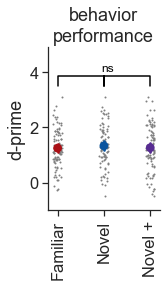

In [221]:
metric = 'dprime_trial_corrected'

stats = each_image_behavior_stats.copy()
stats = stats[stats.behavior_session_id.isin(platform_expts.behavior_session_id.values)]
print(len(stats.behavior_session_id.unique()))

stats = stats[stats.image_name!='omitted']

ppf.plot_behavior_metric_by_experience(stats, metric, title='behavior\nperformance', ylabel='d-prime', ylims=[-1, 3.5],
                                       best_image=True, show_containers=False,
                                       save_dir=save_dir, folder=folder, suffix=suffix+'_each_image_stim_based')

# # for each cell type
# for cell_type in cell_types: 
#     ppf.plot_behavior_metric_by_experience(stats[stats.cell_type==cell_type], metric, title=cell_type, 
#                                                  ylabel='d-prime', ylims=[-1, 3.5],
#                                        best_image=True, show_containers=False,
#                                        save_dir=save_dir, folder=folder, suffix=suffix+'_each_image_stim_based_'+cell_type)

In [99]:
%%time 

method = 'trial_based'
engaged_only = True
per_image = True


behavior_session_ids = behavior_sessions.index.values


original_each_image_behavior_trial, problem_sessions = vbu.get_behavior_stats_for_sessions(behavior_session_ids, behavior_sessions, 
                                    method=method, engaged_only=engaged_only, per_image=per_image)


# original_behavior_stats = behavior_stats.copy()
each_image_behavior_stats_trial = original_each_image_behavior_trial.merge(behavior_sessions, on='behavior_session_id')
#  remove 4x2 sessions
each_image_behavior_stats_trial = each_image_behavior_stats_trial[each_image_behavior_stats_trial.project_code!='VisualBehaviorMultiscope4areasx2d']

  0%|                                                                                 | 2/2943 [00:00<02:53, 16.91it/s]

loading for 760808911
loading for 761294708
loading for 761730617
loading for 762067130


  0%|▏                                                                                | 6/2943 [00:00<03:48, 12.84it/s]

loading for 762418364
loading for 763012686


  0%|▏                                                                                | 8/2943 [00:00<03:39, 13.35it/s]

loading for 763661704
loading for 764319580
loading for 764696952
loading for 765208332


  0%|▎                                                                               | 12/2943 [00:00<03:11, 15.33it/s]

loading for 765793356
loading for 766532213
loading for 766931048
loading for 767730839
loading for 768450504


  1%|▍                                                                               | 17/2943 [00:01<03:05, 15.75it/s]

loading for 769145833
loading for 769731277
loading for 770215042


  1%|▌                                                                               | 21/2943 [00:01<03:17, 14.81it/s]

loading for 771040969
loading for 771902184
loading for 772475707


  1%|▋                                                                               | 24/2943 [00:01<03:05, 15.76it/s]

loading for 773391809
loading for 774120511
loading for 774679623
loading for 775291372


  1%|▊                                                                               | 28/2943 [00:01<02:52, 16.85it/s]

loading for 776988190
loading for 778010119
loading for 778888558
loading for 779712859


  1%|▊                                                                               | 30/2943 [00:02<03:28, 13.99it/s]

loading for 780479408
loading for 781938213


  1%|▉                                                                               | 34/2943 [00:02<03:33, 13.66it/s]

loading for 783217873
loading for 783959068
loading for 785382040


  1%|▉                                                                               | 36/2943 [00:02<03:26, 14.08it/s]

loading for 786007435
loading for 786938611
loading for 789008423
loading for 789870329


  1%|█                                                                               | 40/2943 [00:02<03:19, 14.53it/s]

loading for 791248943
loading for 791904071
loading for 792680306


  1%|█▏                                                                              | 42/2943 [00:02<03:19, 14.54it/s]

loading for 793485674
loading for 794968300
loading for 795742990


  2%|█▎                                                                              | 46/2943 [00:03<03:08, 15.38it/s]

loading for 796052844
loading for 796251270
loading for 798126878
loading for 772286394


  2%|█▎                                                                              | 50/2943 [00:03<03:14, 14.84it/s]

loading for 773510999
loading for 774208555
loading for 774767072


  2%|█▍                                                                              | 52/2943 [00:03<03:04, 15.68it/s]

loading for 775344511
loading for 775925580
loading for 777061425


  2%|█▌                                                                              | 56/2943 [00:03<03:16, 14.73it/s]

loading for 778119826
loading for 778959204
loading for 779580423


  2%|█▋                                                                              | 60/2943 [00:04<03:14, 14.82it/s]

loading for 780351711
loading for 781727422
loading for 783059206


  2%|█▋                                                                              | 62/2943 [00:04<03:11, 15.03it/s]

loading for 783971649
loading for 785376297
loading for 785868918


  2%|█▋                                                                              | 64/2943 [00:04<04:00, 11.97it/s]

loading for 786841415
loading for 788864720
loading for 789946754


  2%|█▊                                                                              | 68/2943 [00:04<03:54, 12.24it/s]

loading for 791278700
loading for 791769447
loading for 792477679
loading for 793153175


  2%|█▉                                                                              | 72/2943 [00:05<03:22, 14.19it/s]

loading for 794071128
loading for 794673280
loading for 795431009


  3%|██                                                                              | 74/2943 [00:05<03:41, 12.94it/s]

loading for 796031509
loading for 797170547
loading for 791877093


  3%|██                                                                              | 78/2943 [00:05<03:24, 13.98it/s]

loading for 792689261
loading for 793414389
loading for 794295959
loading for 794977379


  3%|██▏                                                                             | 82/2943 [00:05<03:20, 14.26it/s]

loading for 795854559
loading for 799051310
loading for 799922316


  3%|██▎                                                                             | 84/2943 [00:05<03:38, 13.06it/s]

loading for 800299366
loading for 800922511
loading for 802988132


  3%|██▍                                                                             | 88/2943 [00:06<03:36, 13.20it/s]

loading for 803351520
loading for 804929649
loading for 805535249
loading for 806109931


  3%|██▌                                                                             | 92/2943 [00:06<03:16, 14.50it/s]

loading for 806792366
loading for 807356557
loading for 808324301


  3%|██▌                                                                             | 94/2943 [00:06<03:24, 13.91it/s]

loading for 808883789
loading for 809358811
loading for 810405357
loading for 811303680


  3%|██▋                                                                             | 99/2943 [00:06<03:07, 15.18it/s]

loading for 811817467
loading for 812955256
loading for 816417578


  3%|██▊                                                                            | 103/2943 [00:07<03:06, 15.23it/s]

loading for 817139151
loading for 818485496
loading for 819094295
loading for 791875850


  4%|██▊                                                                            | 106/2943 [00:07<02:52, 16.48it/s]

loading for 792689257
loading for 793409670
loading for 794295950
loading for 794977383


  4%|██▉                                                                            | 110/2943 [00:07<02:58, 15.89it/s]

loading for 795854555
loading for 799049628
loading for 799919887


  4%|███                                                                            | 112/2943 [00:07<03:03, 15.39it/s]

loading for 800299362
loading for 800919728
loading for 802364085


  4%|███                                                                            | 116/2943 [00:08<03:12, 14.72it/s]

loading for 802988119
loading for 803347004
loading for 805639780


  4%|███▏                                                                           | 120/2943 [00:08<03:06, 15.13it/s]

loading for 806296598
loading for 806841326
loading for 807584876
loading for 808432167


  4%|███▎                                                                           | 123/2943 [00:08<02:45, 17.05it/s]

loading for 809027309
loading for 809427293
loading for 811355443
loading for 810584641


  4%|███▍                                                                           | 127/2943 [00:08<02:55, 16.09it/s]

loading for 811356875
loading for 811831429
loading for 812566400
loading for 812993078


  4%|███▌                                                                           | 131/2943 [00:08<03:03, 15.30it/s]

loading for 813675618
loading for 814546737
loading for 815015329


  5%|███▌                                                                           | 135/2943 [00:09<02:52, 16.26it/s]

loading for 815511978
loading for 816381516
loading for 817182203
loading for 818758572


  5%|███▋                                                                           | 139/2943 [00:09<03:01, 15.45it/s]

loading for 819245147
loading for 819990491
loading for 821803380
loading for 822409353


  5%|███▊                                                                           | 141/2943 [00:09<02:59, 15.65it/s]

loading for 823241007
loading for 823968100
loading for 825012995


  5%|███▉                                                                           | 145/2943 [00:09<03:03, 15.25it/s]

loading for 825268982
loading for 825888541
loading for 826697158


  5%|███▉                                                                           | 149/2943 [00:10<02:56, 15.81it/s]

loading for 827374757
loading for 828646658
loading for 829138845
loading for 829578829


  5%|████                                                                           | 151/2943 [00:10<03:16, 14.23it/s]

loading for 830255592
loading for 830832988
loading for 831824426


  5%|████▏                                                                          | 155/2943 [00:10<03:11, 14.55it/s]

loading for 832981154
loading for 835444110
loading for 835820832
loading for 836399024


  5%|████▎                                                                          | 160/2943 [00:10<02:43, 17.04it/s]

loading for 807062523
loading for 808103937
loading for 809588395
loading for 810266014


  6%|████▎                                                                          | 162/2943 [00:11<03:03, 15.16it/s]

loading for 811140660
loading for 811574124
loading for 812261209


  6%|████▍                                                                          | 167/2943 [00:11<02:38, 17.57it/s]

loading for 812796028
loading for 814260983
loading for 814749891
loading for 815865807


  6%|████▌                                                                          | 169/2943 [00:11<02:50, 16.27it/s]

loading for 817053045
loading for 818539436
loading for 819065377


  6%|████▋                                                                          | 173/2943 [00:11<03:02, 15.15it/s]

loading for 819497998
loading for 820740400
loading for 821593979


  6%|████▊                                                                          | 177/2943 [00:11<03:03, 15.06it/s]

loading for 822159346
loading for 822874578
loading for 823496226


  6%|████▊                                                                          | 179/2943 [00:12<02:54, 15.88it/s]

loading for 824566587
loading for 825269006
loading for 825902239
loading for 826697162


  6%|████▉                                                                          | 183/2943 [00:12<02:56, 15.66it/s]

loading for 827374765
loading for 828669593
loading for 829138837


  6%|████▉                                                                          | 185/2943 [00:12<02:53, 15.87it/s]

loading for 829714672
loading for 830419451
loading for 830959034


  6%|█████                                                                          | 189/2943 [00:12<03:07, 14.68it/s]

loading for 831905148
loading for 833100683
loading for 833946929


  6%|█████▏                                                                         | 191/2943 [00:12<03:19, 13.79it/s]

loading for 834928595
loading for 835547527
loading for 835940015


  7%|█████▏                                                                         | 195/2943 [00:13<03:11, 14.35it/s]

loading for 837108110
loading for 837512169
loading for 823922942
loading for 824972176


  7%|█████▎                                                                         | 198/2943 [00:13<02:58, 15.42it/s]

loading for 825527066
loading for 826338809
loading for 826841473


  7%|█████▍                                                                         | 202/2943 [00:13<03:12, 14.23it/s]

loading for 827977069
loading for 828842797
loading for 829281654


  7%|█████▌                                                                         | 206/2943 [00:13<03:04, 14.86it/s]

loading for 829902556
loading for 830592943
loading for 831259963


  7%|█████▌                                                                         | 208/2943 [00:14<03:12, 14.22it/s]

loading for 832009551
loading for 832522789
loading for 833252272


  7%|█████▋                                                                         | 212/2943 [00:14<03:11, 14.23it/s]

loading for 834059775
loading for 834886139
loading for 835608988


  7%|█████▋                                                                         | 214/2943 [00:14<02:59, 15.24it/s]

loading for 836099247
loading for 836769386
loading for 837202082
loading for 837629869


  7%|█████▊                                                                         | 218/2943 [00:14<03:15, 13.97it/s]

loading for 838486964
loading for 839220840
loading for 839566028


  7%|█████▉                                                                         | 220/2943 [00:14<03:26, 13.17it/s]

loading for 839918083
loading for 840583412
loading for 841431760


  8%|██████                                                                         | 224/2943 [00:15<03:35, 12.61it/s]

loading for 841830077
loading for 842387217
loading for 842821314


  8%|██████▏                                                                        | 229/2943 [00:15<02:52, 15.73it/s]

loading for 843397714
loading for 844197868
loading for 844880686
loading for 845564445


  8%|██████▏                                                                        | 231/2943 [00:15<02:45, 16.35it/s]

loading for 846272622
loading for 847022155
loading for 847829598
loading for 848519645


  8%|██████▎                                                                        | 236/2943 [00:15<02:32, 17.80it/s]

loading for 849073265
loading for 849635376
loading for 850977753
loading for 851779746


  8%|██████▍                                                                        | 240/2943 [00:16<02:41, 16.70it/s]

loading for 852468381
loading for 853168204
loading for 853875502


  8%|██████▌                                                                        | 243/2943 [00:16<02:39, 16.97it/s]

loading for 854563857
loading for 855421865
loading for 855973498
loading for 856717282


  8%|██████▋                                                                        | 247/2943 [00:16<02:37, 17.11it/s]

loading for 857612105
loading for 859065627
loading for 859735311
loading for 860665051


  9%|██████▋                                                                        | 251/2943 [00:16<02:39, 16.91it/s]

loading for 861788094
loading for 863571072
loading for 864139911


  9%|██████▊                                                                        | 253/2943 [00:16<02:38, 16.93it/s]

loading for 864824449
loading for 865482857
loading for 866333758


  9%|██████▉                                                                        | 257/2943 [00:17<02:52, 15.58it/s]

loading for 867041502
loading for 867977775
loading for 868721114


  9%|██████▉                                                                        | 259/2943 [00:17<02:50, 15.74it/s]

loading for 869639141
loading for 870960890
loading for 872062433
loading for 873002413


  9%|███████                                                                        | 263/2943 [00:17<02:50, 15.70it/s]

loading for 873750535
loading for 874681118
loading for 875414332


  9%|███████▏                                                                       | 267/2943 [00:17<02:54, 15.30it/s]

loading for 876765708
loading for 877346183
loading for 877925816


  9%|███████▏                                                                       | 269/2943 [00:17<02:52, 15.51it/s]

loading for 878671068
loading for 879974471
loading for 880668519
loading for 881278000


  9%|███████▎                                                                       | 273/2943 [00:18<02:53, 15.36it/s]

loading for 882256127
loading for 882748184
loading for 884596128
loading for 885492180


  9%|███████▍                                                                       | 278/2943 [00:18<02:43, 16.31it/s]

loading for 886322595
loading for 886926935
loading for 888127012


 10%|███████▌                                                                       | 280/2943 [00:18<02:44, 16.22it/s]

loading for 890157940
loading for 820799656
loading for 821837682
loading for 822471786


 10%|███████▌                                                                       | 284/2943 [00:18<02:59, 14.82it/s]

loading for 823248638
loading for 823922950
loading for 824992804


 10%|███████▋                                                                       | 286/2943 [00:19<03:21, 13.22it/s]

loading for 825533866
loading for 826356747
loading for 826846303


 10%|███████▊                                                                       | 290/2943 [00:19<03:25, 12.88it/s]

loading for 827944014
loading for 828838236
loading for 829282785
loading for 829877552


 10%|███████▉                                                                       | 294/2943 [00:19<03:03, 14.47it/s]

loading for 830620126
loading for 832019583
loading for 832540845
loading for 833454420


 10%|███████▉                                                                       | 298/2943 [00:19<03:00, 14.69it/s]

loading for 834093014
loading for 834908481
loading for 835616503
loading for 836173885


 10%|████████                                                                       | 302/2943 [00:20<02:57, 14.86it/s]

loading for 836777468
loading for 837196627
loading for 837647722


 10%|████████▏                                                                      | 306/2943 [00:20<02:55, 15.06it/s]

loading for 838496122
loading for 839233516
loading for 839566049
loading for 839931485


 10%|████████▎                                                                      | 309/2943 [00:20<02:34, 17.02it/s]

loading for 840594518
loading for 841429687
loading for 841842210
loading for 842399625


 11%|████████▍                                                                      | 313/2943 [00:21<03:05, 14.18it/s]

loading for 842844413
loading for 843400443
loading for 844253929


 11%|████████▍                                                                      | 315/2943 [00:21<03:09, 13.88it/s]

loading for 845585105
loading for 846316916
loading for 847036338


 11%|████████▌                                                                      | 319/2943 [00:21<03:15, 13.45it/s]

loading for 847871771
loading for 848599542
loading for 849136474
loading for 849648618


 11%|████████▋                                                                      | 324/2943 [00:21<02:46, 15.76it/s]

loading for 850985993
loading for 851757903
loading for 852440775
loading for 853496105
loading for 827312851


 11%|████████▊                                                                      | 328/2943 [00:22<02:57, 14.75it/s]

loading for 828646634
loading for 829128279
loading for 829591790


 11%|████████▉                                                                      | 332/2943 [00:22<02:46, 15.64it/s]

loading for 830201482
loading for 830867799
loading for 831834820
loading for 832325815


 11%|█████████                                                                      | 336/2943 [00:22<02:39, 16.39it/s]

loading for 832990071
loading for 833780803
loading for 834573980
loading for 835448132


 12%|█████████▏                                                                     | 340/2943 [00:22<02:44, 15.81it/s]

loading for 835865722
loading for 836522259
loading for 837083666


 12%|█████████▏                                                                     | 342/2943 [00:22<03:02, 14.28it/s]

loading for 837443225
loading for 838236165
loading for 839014738


 12%|█████████▏                                                                     | 344/2943 [00:23<02:56, 14.75it/s]

loading for 839479248
loading for 839854553
loading for 840330509


 12%|█████████▎                                                                     | 348/2943 [00:23<02:53, 14.99it/s]

loading for 841185520
loading for 841730873
loading for 842139320


 12%|█████████▍                                                                     | 352/2943 [00:23<02:53, 14.90it/s]

loading for 842792100
loading for 843166865
loading for 844234790


 12%|█████████▌                                                                     | 355/2943 [00:23<02:38, 16.33it/s]

loading for 844875410
loading for 846248008
loading for 847048485
loading for 847867029


 12%|█████████▋                                                                     | 359/2943 [00:24<02:39, 16.19it/s]

loading for 848575992
loading for 849098851
loading for 850976604


 12%|█████████▋                                                                     | 361/2943 [00:24<02:40, 16.10it/s]

loading for 853266283
loading for 831129394
loading for 832021447
loading for 832544149


 12%|█████████▊                                                                     | 366/2943 [00:24<02:29, 17.23it/s]

loading for 833328750
loading for 834087859
loading for 834903060
loading for 835557296


 13%|█████████▉                                                                     | 370/2943 [00:24<02:35, 16.59it/s]

loading for 836166694
loading for 836761653
loading for 837192567


 13%|█████████▉                                                                     | 372/2943 [00:24<02:42, 15.84it/s]

loading for 837638916
loading for 838496126
loading for 839234289


 13%|██████████                                                                     | 376/2943 [00:25<02:44, 15.61it/s]

loading for 839566045
loading for 839939986
loading for 840594514


 13%|██████████▏                                                                    | 378/2943 [00:25<02:55, 14.65it/s]

loading for 841148118
loading for 841707177
loading for 842174399


 13%|██████████▏                                                                    | 380/2943 [00:25<03:02, 14.05it/s]

loading for 842729895
loading for 843203333
loading for 844164376


 13%|██████████▎                                                                    | 384/2943 [00:25<02:50, 14.99it/s]

loading for 844849972
loading for 845441512
loading for 846194950
loading for 846929750


 13%|██████████▍                                                                    | 388/2943 [00:25<02:55, 14.55it/s]

loading for 848503804
loading for 853526948
loading for 834587823


 13%|██████████▍                                                                    | 390/2943 [00:26<03:02, 14.01it/s]

loading for 835451471
loading for 835867850
loading for 836522245


 13%|██████████▌                                                                    | 394/2943 [00:26<02:50, 14.94it/s]

loading for 837083657
loading for 837449223
loading for 838203784
loading for 838998362


 14%|██████████▋                                                                    | 399/2943 [00:26<02:39, 15.92it/s]

loading for 839468826
loading for 839837380
loading for 840330501


 14%|██████████▊                                                                    | 401/2943 [00:26<02:43, 15.52it/s]

loading for 841191836
loading for 841730868
loading for 842139310


 14%|██████████▊                                                                    | 403/2943 [00:26<02:43, 15.52it/s]

loading for 842792094
loading for 843178897
loading for 844027594


 14%|██████████▉                                                                    | 407/2943 [00:27<03:15, 12.96it/s]

loading for 844608277
loading for 845409652
loading for 846051276


 14%|██████████▉                                                                    | 409/2943 [00:27<02:55, 14.45it/s]

loading for 846791195
loading for 847613846
loading for 848272657


 14%|███████████                                                                    | 414/2943 [00:27<02:40, 15.79it/s]

loading for 848938321
loading for 849525884
loading for 850817466
loading for 851563931
loading for 852235678


 14%|███████████▏                                                                   | 418/2943 [00:27<02:39, 15.79it/s]

loading for 852974537
loading for 853505213
loading for 854283407


 14%|███████████▎                                                                   | 420/2943 [00:28<03:01, 13.88it/s]

loading for 855826937
loading for 857230827
loading for 837658854


 14%|███████████▍                                                                   | 424/2943 [00:28<02:48, 14.94it/s]

loading for 838515247
loading for 839219841
loading for 839565422


 15%|███████████▍                                                                   | 428/2943 [00:28<02:50, 14.73it/s]

loading for 839912316
loading for 840581827
loading for 841426832


 15%|███████████▌                                                                   | 430/2943 [00:28<02:46, 15.09it/s]

loading for 841827774
loading for 842385277
loading for 842819933


 15%|███████████▋                                                                   | 434/2943 [00:29<02:51, 14.64it/s]

loading for 843400453
loading for 844199758
loading for 844908261


 15%|███████████▋                                                                   | 436/2943 [00:29<02:51, 14.64it/s]

loading for 845572044
loading for 846331423
loading for 847036328


 15%|███████████▊                                                                   | 440/2943 [00:29<02:40, 15.59it/s]

loading for 847874940
loading for 848613406
loading for 849147676
loading for 849651275


 15%|███████████▉                                                                   | 443/2943 [00:29<02:30, 16.62it/s]

loading for 850989832
loading for 851773928
loading for 852451567


 15%|███████████▉                                                                   | 447/2943 [00:29<02:30, 16.62it/s]

loading for 855200229
loading for 840598877
loading for 841466830
loading for 841851097


 15%|████████████                                                                   | 451/2943 [00:30<02:45, 15.07it/s]

loading for 842419799
loading for 842840144
loading for 843423171


 15%|████████████▏                                                                  | 453/2943 [00:30<02:53, 14.33it/s]

loading for 844229895
loading for 844945060
loading for 845594684


 15%|████████████▏                                                                  | 455/2943 [00:30<02:54, 14.29it/s]

loading for 846284880
loading for 847048490
loading for 847838131


 16%|████████████▎                                                                  | 459/2943 [00:30<03:11, 12.98it/s]

loading for 848526511
loading for 848910243
loading for 849485548


 16%|████████████▍                                                                  | 463/2943 [00:30<02:47, 14.81it/s]

loading for 850810858
loading for 851471401
loading for 852202150
loading for 852966248


 16%|████████████▌                                                                  | 467/2943 [00:31<02:31, 16.33it/s]

loading for 853875514
loading for 854621677
loading for 855424348
loading for 857340041


 16%|████████████▋                                                                  | 472/2943 [00:31<02:09, 19.03it/s]

loading for 857987666
loading for 858974731
loading for 859775117
loading for 863610582


 16%|████████████▋                                                                  | 474/2943 [00:31<02:24, 17.13it/s]

loading for 868070216
loading for 868658294
loading for 869559097


 16%|████████████▊                                                                  | 476/2943 [00:31<02:34, 15.95it/s]

loading for 854533487
loading for 855504136
loading for 856002607


 16%|████████████▉                                                                  | 480/2943 [00:31<02:43, 15.05it/s]

loading for 856732191
loading for 857555456
loading for 858240891


 16%|████████████▉                                                                  | 484/2943 [00:32<02:44, 14.91it/s]

loading for 859032026
loading for 859791558
loading for 860752803


 17%|█████████████                                                                  | 487/2943 [00:32<02:33, 16.03it/s]

loading for 861794699
loading for 862701465
loading for 863571054
loading for 864137547


 17%|█████████████▏                                                                 | 491/2943 [00:32<02:37, 15.53it/s]

loading for 864839176
loading for 865581941
loading for 866287088


 17%|█████████████▎                                                                 | 494/2943 [00:32<02:35, 15.74it/s]

loading for 866950070
loading for 867615529
loading for 868540333


 17%|█████████████▎                                                                 | 496/2943 [00:33<02:39, 15.31it/s]

loading for 869319414
loading for 870660821
loading for 871808378
loading for 872646068


 17%|█████████████▍                                                                 | 500/2943 [00:33<02:32, 16.03it/s]

loading for 873517635
loading for 874324533
loading for 875471358
cant load stats for 875471358
loading for 876574139
loading for 850970486


 17%|█████████████▌                                                                 | 506/2943 [00:33<02:05, 19.42it/s]

loading for 851843550
loading for 852507945
loading for 853260939
loading for 853886146


 17%|█████████████▋                                                                 | 508/2943 [00:33<02:11, 18.47it/s]

loading for 855459012
loading for 855980937
loading for 856719615


 17%|█████████████▋                                                                 | 512/2943 [00:33<02:20, 17.33it/s]

loading for 857504898
loading for 858250763
loading for 859049298
loading for 859784868


 18%|█████████████▊                                                                 | 516/2943 [00:34<02:27, 16.48it/s]

loading for 860836980
loading for 861789935
loading for 862716913
loading for 863614836


 18%|█████████████▉                                                                 | 521/2943 [00:34<02:25, 16.62it/s]

loading for 864260028
loading for 864813130
loading for 865460179


 18%|██████████████                                                                 | 523/2943 [00:34<02:37, 15.35it/s]

loading for 866296478
loading for 866999677
loading for 867615541


 18%|██████████████▏                                                                | 527/2943 [00:34<02:36, 15.44it/s]

loading for 868555361
loading for 869334643
loading for 870592115
loading for 871808394


 18%|██████████████▎                                                                | 531/2943 [00:35<02:37, 15.31it/s]

loading for 872626160
loading for 873695653
loading for 874699922


 18%|██████████████▎                                                                | 534/2943 [00:35<02:35, 15.54it/s]

loading for 875440936
loading for 876678452
loading for 877617747


 18%|██████████████▍                                                                | 537/2943 [00:35<02:19, 17.23it/s]

loading for 878120101
loading for 879037269
loading for 880046522
loading for 880784794


 18%|██████████████▍                                                                | 539/2943 [00:35<02:36, 15.36it/s]

loading for 882256117
loading for 858104885
loading for 858900546


 18%|██████████████▌                                                                | 543/2943 [00:35<02:31, 15.82it/s]

loading for 859601488
loading for 860247669
loading for 861717498
loading for 862339401


 19%|██████████████▋                                                                | 547/2943 [00:36<02:34, 15.52it/s]

loading for 863365105
loading for 863966979
loading for 864665192


 19%|██████████████▋                                                                | 549/2943 [00:36<02:55, 13.67it/s]

loading for 865114696
loading for 865887829
loading for 866906696


 19%|██████████████▊                                                                | 553/2943 [00:36<02:46, 14.39it/s]

loading for 867505993
loading for 868511825
loading for 869198966
loading for 870481699


 19%|██████████████▉                                                                | 557/2943 [00:36<02:41, 14.79it/s]

loading for 871723063
loading for 872607293
loading for 873440431


 19%|███████████████                                                                | 561/2943 [00:37<02:31, 15.71it/s]

loading for 874324527
loading for 875020211
loading for 876448536
loading for 877855866


 19%|███████████████                                                                | 563/2943 [00:37<02:39, 14.92it/s]

loading for 878615859
loading for 879846629


 19%|███████████████▏                                                               | 567/2943 [00:37<02:47, 14.17it/s]

loading for 880581639
loading for 881204796
loading for 882289836
loading for 883851453


 19%|███████████████▎                                                               | 571/2943 [00:37<02:47, 14.17it/s]

loading for 884598044
loading for 885404075
loading for 886376835


 19%|███████████████▍                                                               | 573/2943 [00:37<02:35, 15.20it/s]

loading for 888213949
loading for 890021100
loading for 893362730


 20%|███████████████▍                                                               | 575/2943 [00:38<02:55, 13.48it/s]

loading for 894103623
loading for 895022326
loading for 895562386


 20%|███████████████▌                                                               | 579/2943 [00:38<02:56, 13.38it/s]

loading for 896561264
loading for 898432373
loading for 898874650
loading for 899390684


 20%|███████████████▋                                                               | 583/2943 [00:38<02:41, 14.65it/s]

loading for 901999401
loading for 903708760
loading for 904574580
loading for 906472625


 20%|███████████████▊                                                               | 587/2943 [00:38<02:21, 16.71it/s]

loading for 907053876
loading for 907900077
loading for 908533370


 20%|███████████████▊                                                               | 591/2943 [00:39<02:34, 15.20it/s]

loading for 910207192
loading for 910829549
loading for 911904717


 20%|███████████████▉                                                               | 593/2943 [00:39<02:43, 14.35it/s]

loading for 913673477
loading for 914211263
loading for 914705301


 20%|████████████████                                                               | 597/2943 [00:39<02:25, 16.12it/s]

loading for 915418411
loading for 916403851
loading for 918103715
loading for 923410363


 20%|████████████████▏                                                              | 601/2943 [00:39<02:24, 16.20it/s]

loading for 924472023
loading for 925084998
loading for 862479694


 20%|████████████████▏                                                              | 603/2943 [00:39<02:30, 15.60it/s]

loading for 863414647
loading for 864000195
loading for 864729508


 21%|████████████████▏                                                              | 605/2943 [00:40<02:37, 14.83it/s]

loading for 865288307
loading for 865953304
loading for 866971252


 21%|████████████████▎                                                              | 609/2943 [00:40<02:27, 15.82it/s]

loading for 867649878
loading for 868546763
loading for 869311954
loading for 870592103


 21%|████████████████▍                                                              | 613/2943 [00:40<02:37, 14.80it/s]

loading for 871782387
loading for 872720256
loading for 873530279


 21%|████████████████▌                                                              | 617/2943 [00:40<02:25, 15.98it/s]

loading for 874295478
loading for 875020129
loading for 876521253
loading for 877346192


 21%|████████████████▌                                                              | 619/2943 [00:41<02:36, 14.87it/s]

loading for 877938181
loading for 878671074
loading for 879958654


 21%|████████████████▋                                                              | 623/2943 [00:41<02:46, 13.91it/s]

loading for 880647168
loading for 881253316
loading for 882233951


 21%|████████████████▊                                                              | 627/2943 [00:41<02:33, 15.07it/s]

loading for 882679635
loading for 883632948
loading for 884560033


 21%|████████████████▉                                                              | 629/2943 [00:41<02:31, 15.27it/s]

loading for 885418521
loading for 886262841
loading for 886900197
loading for 889183454


 22%|█████████████████                                                              | 634/2943 [00:41<02:14, 17.22it/s]

loading for 890054551
loading for 891504476
loading for 892413871
loading for 893359124


 22%|█████████████████▏                                                             | 638/2943 [00:42<02:25, 15.87it/s]

loading for 894215849
loading for 894994111
loading for 896543686


 22%|█████████████████▏                                                             | 640/2943 [00:42<02:29, 15.35it/s]

loading for 898461372
loading for 898890800
loading for 899461485


 22%|█████████████████▏                                                             | 642/2943 [00:42<02:43, 14.06it/s]

loading for 902028378
loading for 902822538
loading for 904625819


 22%|█████████████████▎                                                             | 646/2943 [00:42<02:45, 13.85it/s]

loading for 907035965
loading for 907995400
loading for 908564873


 22%|█████████████████▍                                                             | 648/2943 [00:42<02:39, 14.41it/s]

loading for 910249985
loading for 911361486
loading for 912159483
loading for 913921659


 22%|█████████████████▌                                                             | 653/2943 [00:43<02:18, 16.53it/s]

loading for 914411174
loading for 914871449
loading for 915739774
loading for 916704634


 22%|█████████████████▋                                                             | 657/2943 [00:43<02:37, 14.49it/s]

loading for 917595407
loading for 918474069
loading for 919104267


 22%|█████████████████▋                                                             | 661/2943 [00:43<02:24, 15.75it/s]

loading for 920015895
loading for 920839478
loading for 922012422
loading for 923834852


 23%|█████████████████▊                                                             | 663/2943 [00:43<02:29, 15.24it/s]

loading for 924759623
loading for 925603486
loading for 927905748


 23%|█████████████████▉                                                             | 667/2943 [00:44<02:29, 15.25it/s]

loading for 929551055
loading for 935301109
loading for 936273485
loading for 862730050


 23%|██████████████████                                                             | 671/2943 [00:44<02:27, 15.38it/s]

loading for 863657189
loading for 864236370
loading for 864809053
loading for 865443418


 23%|██████████████████                                                             | 675/2943 [00:44<02:42, 13.99it/s]

loading for 866300303
loading for 867045079


 23%|██████████████████▏                                                            | 677/2943 [00:44<02:41, 14.06it/s]

loading for 867977763
loading for 868704504
loading for 869615887


 23%|██████████████████▎                                                            | 681/2943 [00:45<02:37, 14.41it/s]

loading for 870960882
loading for 872864902
loading for 873729011


 23%|██████████████████▎                                                            | 684/2943 [00:45<02:16, 16.51it/s]

loading for 874691139
loading for 875402170
loading for 876701397
loading for 877524045


 23%|██████████████████▍                                                            | 686/2943 [00:45<02:18, 16.25it/s]

loading for 878137744
loading for 879003593
loading for 880088387


 23%|██████████████████▌                                                            | 690/2943 [00:45<02:21, 15.97it/s]

loading for 881416618
loading for 882373648
loading for 882785348


 24%|██████████████████▋                                                            | 694/2943 [00:45<02:18, 16.18it/s]

loading for 883984332
loading for 884750162
loading for 885540222
loading for 886440427


 24%|██████████████████▋                                                            | 698/2943 [00:46<02:14, 16.71it/s]

loading for 886931452
loading for 888282572
loading for 889443507


 24%|██████████████████▊                                                            | 700/2943 [00:46<02:36, 14.30it/s]

loading for 890355790
loading for 891618314


 24%|██████████████████▊                                                            | 702/2943 [00:46<02:40, 13.97it/s]

loading for 892491402
loading for 893540605
loading for 894466746


 24%|██████████████████▉                                                            | 704/2943 [00:46<02:51, 13.04it/s]

loading for 895241719
loading for 895877676


 24%|███████████████████                                                            | 708/2943 [00:46<02:40, 13.88it/s]

loading for 896969091
loading for 898658063
loading for 899685557


 24%|███████████████████                                                            | 710/2943 [00:47<02:29, 14.96it/s]

loading for 900226857
loading for 901340457
loading for 902244344
loading for 902962312


 24%|███████████████████▏                                                           | 714/2943 [00:47<02:38, 14.03it/s]

loading for 904899490
loading for 906641078
loading for 908092560


 24%|███████████████████▎                                                           | 718/2943 [00:47<02:28, 14.98it/s]

loading for 910381299
loading for 911016296
loading for 911541959


 24%|███████████████████▎                                                           | 720/2943 [00:47<02:25, 15.27it/s]

loading for 912902650
loading for 913850438
loading for 914336989
loading for 914828503


 25%|███████████████████▍                                                           | 722/2943 [00:47<02:23, 15.48it/s]

loading for 915609195
loading for 916614400


 25%|███████████████████▍                                                           | 726/2943 [00:48<02:41, 13.70it/s]

loading for 917500273
loading for 918451984
loading for 919022193
loading for 919895633


 25%|███████████████████▌                                                           | 730/2943 [00:48<02:44, 13.49it/s]

loading for 920807985
loading for 921873454
loading for 923757660


 25%|███████████████████▋                                                           | 732/2943 [00:48<02:37, 14.04it/s]

loading for 924739087
loading for 926621793
loading for 927652117


 25%|███████████████████▊                                                           | 737/2943 [00:48<02:32, 14.48it/s]

loading for 928654503
loading for 929522558
loading for 930344462


 25%|███████████████████▊                                                           | 740/2943 [00:49<02:18, 15.88it/s]

loading for 932960096
loading for 933939891
loading for 935038748
loading for 936159430


 25%|███████████████████▉                                                           | 742/2943 [00:49<02:13, 16.43it/s]

loading for 937645038
loading for 938729036
loading for 940017429


 25%|████████████████████                                                           | 746/2943 [00:49<02:14, 16.35it/s]

loading for 941802699
loading for 942814025
loading for 943833533
loading for 945033994


 25%|████████████████████▏                                                          | 750/2943 [00:49<02:18, 15.80it/s]

loading for 947336783
loading for 948225040
loading for 949348713
loading for 950188644


 26%|████████████████████▏                                                          | 754/2943 [00:50<02:33, 14.28it/s]

loading for 862245493
loading for 863368489
loading for 863966974


 26%|████████████████████▎                                                          | 756/2943 [00:50<02:23, 15.28it/s]

loading for 864665204
loading for 865131331
loading for 865887821


 26%|████████████████████▍                                                          | 760/2943 [00:50<02:28, 14.67it/s]

loading for 866909432
loading for 867521015
loading for 868513545
loading for 869214215


 26%|████████████████████▌                                                          | 765/2943 [00:50<02:16, 15.94it/s]

loading for 870481685
loading for 871728970
loading for 872609185


 26%|████████████████████▌                                                          | 767/2943 [00:50<02:28, 14.69it/s]

loading for 873449838
loading for 874333572
loading for 875020175


 26%|████████████████████▋                                                          | 769/2943 [00:51<02:17, 15.83it/s]

loading for 876448528
loading for 877855879
loading for 878615867


 26%|████████████████████▋                                                          | 773/2943 [00:51<02:35, 13.94it/s]

loading for 879854787
loading for 880590869
loading for 881210690


 26%|████████████████████▊                                                          | 775/2943 [00:51<02:35, 13.98it/s]

loading for 882291265
loading for 882736270
loading for 883857883


 26%|████████████████████▉                                                          | 779/2943 [00:51<02:28, 14.62it/s]

loading for 884605735
loading for 885404024
loading for 886382175


 27%|████████████████████▉                                                          | 781/2943 [00:51<02:44, 13.16it/s]

loading for 888218684
loading for 890021090
loading for 893608687


 27%|█████████████████████                                                          | 785/2943 [00:52<02:35, 13.86it/s]

loading for 894495169
loading for 895278567
loading for 895809864


 27%|█████████████████████▏                                                         | 789/2943 [00:52<02:31, 14.18it/s]

loading for 896882463
loading for 898665096
loading for 898938920


 27%|█████████████████████▏                                                         | 791/2943 [00:52<02:26, 14.68it/s]

loading for 900227468
loading for 901316636
loading for 902211897


 27%|█████████████████████▎                                                         | 793/2943 [00:52<02:39, 13.52it/s]

loading for 902995627
loading for 903977177
loading for 904922800


 27%|█████████████████████▍                                                         | 797/2943 [00:53<02:35, 13.76it/s]

loading for 906658064
loading for 907327499
loading for 908122381


 27%|█████████████████████▍                                                         | 799/2943 [00:53<02:44, 13.04it/s]

loading for 912640306
loading for 866287136
loading for 867036293


 27%|█████████████████████▌                                                         | 804/2943 [00:53<02:28, 14.38it/s]

loading for 867961854
loading for 868653129
loading for 869623244
loading for 870935142


 27%|█████████████████████▋                                                         | 807/2943 [00:53<02:11, 16.28it/s]

loading for 872043024
loading for 872979424
loading for 873739031
loading for 874654280


 28%|█████████████████████▊                                                         | 811/2943 [00:53<02:14, 15.90it/s]

loading for 875385921
loading for 876737442
loading for 877558833
loading for 878245978


 28%|█████████████████████▉                                                         | 815/2943 [00:54<02:21, 15.08it/s]

loading for 878993255
loading for 880191880
loading for 880775454
loading for 881425509


 28%|█████████████████████▉                                                         | 819/2943 [00:54<02:21, 14.99it/s]

loading for 882401590
loading for 883756380
loading for 884552901


 28%|██████████████████████                                                         | 823/2943 [00:54<02:08, 16.49it/s]

loading for 885410929
loading for 886257016
loading for 886838602
loading for 888033338


 28%|██████████████████████▏                                                        | 825/2943 [00:54<02:23, 14.77it/s]

loading for 889175194
loading for 890033129
loading for 891446789


 28%|██████████████████████▏                                                        | 827/2943 [00:55<02:20, 15.02it/s]

loading for 892387261


 28%|██████████████████████▎                                                        | 829/2943 [00:55<03:41,  9.52it/s]

loading for 893344360
loading for 894083470


 28%|██████████████████████▎                                                        | 833/2943 [00:55<03:04, 11.42it/s]

loading for 898440124
loading for 866128606
loading for 866971269
loading for 867645566


 28%|██████████████████████▍                                                        | 835/2943 [00:55<02:59, 11.78it/s]

loading for 868531777
loading for 869311972
loading for 870579061


 29%|██████████████████████▌                                                        | 839/2943 [00:56<02:32, 13.76it/s]

loading for 871782397
loading for 872690218
loading for 873537911
loading for 874416985


 29%|██████████████████████▋                                                        | 843/2943 [00:56<02:50, 12.34it/s]

loading for 875020203
loading for 876651891
loading for 877487375


 29%|██████████████████████▋                                                        | 845/2943 [00:56<02:46, 12.58it/s]

loading for 878179382
loading for 878771403
loading for 879969002


 29%|██████████████████████▊                                                        | 849/2943 [00:57<02:58, 11.71it/s]

loading for 880644824
loading for 881251187
loading for 882219267


 29%|██████████████████████▉                                                        | 853/2943 [00:57<02:32, 13.70it/s]

loading for 882677813
loading for 883632956
loading for 884560064


 29%|██████████████████████▉                                                        | 855/2943 [00:57<02:45, 12.63it/s]

loading for 885410934
loading for 886250995


 29%|███████████████████████                                                        | 857/2943 [00:57<02:39, 13.06it/s]

loading for 887006111
loading for 888163519
loading for 889388078


 29%|███████████████████████                                                        | 859/2943 [00:57<02:30, 13.83it/s]

loading for 890625596
loading for 891605682
loading for 892526544


 29%|███████████████████████▏                                                       | 863/2943 [00:58<02:26, 14.17it/s]

loading for 893488330
loading for 894368064
loading for 870987812


 29%|███████████████████████▎                                                       | 867/2943 [00:58<02:16, 15.22it/s]

loading for 872953842
loading for 873774125
cant load stats for 873774125
loading for 874790261
loading for 875207834


 30%|███████████████████████▎                                                       | 869/2943 [00:58<02:24, 14.39it/s]

loading for 876821726
loading for 877603209
loading for 878245989


 30%|███████████████████████▍                                                       | 873/2943 [00:58<02:31, 13.67it/s]

loading for 879003606
loading for 880088400
loading for 881416637


 30%|███████████████████████▌                                                       | 877/2943 [00:59<02:26, 14.10it/s]

loading for 882373653
loading for 882781075
loading for 883986743


 30%|███████████████████████▌                                                       | 879/2943 [00:59<02:21, 14.61it/s]

loading for 884776248
loading for 885540237
loading for 886442346
loading for 886946944


 30%|███████████████████████▋                                                       | 884/2943 [00:59<02:14, 15.26it/s]

loading for 888295170
loading for 889468960
loading for 890408602


 30%|███████████████████████▊                                                       | 886/2943 [00:59<02:17, 14.96it/s]

loading for 891635659
loading for 891635667
loading for 892510304
loading for 893560763


 30%|███████████████████████▉                                                       | 890/2943 [00:59<02:16, 15.04it/s]

loading for 894481319
loading for 895248933
loading for 895896343
loading for 896995828


 30%|███████████████████████▉                                                       | 894/2943 [01:00<02:26, 14.00it/s]

loading for 898667252
loading for 899700579
loading for 900231059


 30%|████████████████████████                                                       | 896/2943 [01:00<02:39, 12.82it/s]

loading for 901363879
loading for 902260156
loading for 902975505
loading for 904922810


 31%|████████████████████████▏                                                      | 901/2943 [01:00<02:31, 13.47it/s]

loading for 906668549
loading for 908104455


 31%|████████████████████████▏                                                      | 903/2943 [01:00<02:33, 13.28it/s]

loading for 910393217
loading for 911016285
loading for 911541950


 31%|████████████████████████▎                                                      | 907/2943 [01:01<02:19, 14.64it/s]

loading for 912223787
loading for 912902619
loading for 913850450


 31%|████████████████████████▍                                                      | 909/2943 [01:01<02:24, 14.04it/s]

loading for 914339617
loading for 914831000
loading for 915609216


 31%|████████████████████████▌                                                      | 913/2943 [01:01<02:24, 14.04it/s]

loading for 916617096
loading for 917500256
loading for 918451994
loading for 919025442


 31%|████████████████████████▌                                                      | 917/2943 [01:01<02:06, 15.95it/s]

loading for 920901263
loading for 921979060
loading for 923757653
loading for 924739774


 31%|████████████████████████▋                                                      | 919/2943 [01:01<02:06, 15.97it/s]

loading for 926621788
loading for 927652110
loading for 928654491


 31%|████████████████████████▊                                                      | 923/2943 [01:02<02:26, 13.74it/s]

loading for 929524423
loading for 930344469
loading for 932960104


 31%|████████████████████████▊                                                      | 925/2943 [01:02<02:44, 12.25it/s]

loading for 933954934
loading for 935045761
loading for 936083473


 32%|████████████████████████▉                                                      | 929/2943 [01:02<02:39, 12.60it/s]

loading for 937706038
loading for 938794488
loading for 939985541
loading for 940755050


 32%|█████████████████████████                                                      | 933/2943 [01:03<02:43, 12.31it/s]

loading for 941734036
loading for 942767530
loading for 944125005


 32%|█████████████████████████                                                      | 935/2943 [01:03<02:36, 12.80it/s]

loading for 945075740
loading for 947988590
loading for 949201674


 32%|█████████████████████████▏                                                     | 937/2943 [01:03<02:41, 12.46it/s]

loading for 949973686
loading for 951520319


 32%|█████████████████████████▎                                                     | 941/2943 [01:03<03:29,  9.57it/s]

loading for 952554548
loading for 953982960
loading for 956010809
loading for 957032492


 32%|█████████████████████████▎                                                     | 945/2943 [01:04<02:43, 12.21it/s]

loading for 958234742
loading for 958888263
loading for 959681045
loading for 875126982


 32%|█████████████████████████▍                                                     | 948/2943 [01:04<02:19, 14.30it/s]

loading for 876823447
loading for 877605077
loading for 878245966


 32%|█████████████████████████▌                                                     | 953/2943 [01:04<02:14, 14.85it/s]

loading for 879074585
loading for 880174939
loading for 881450253
loading for 882426675


 32%|█████████████████████████▋                                                     | 955/2943 [01:04<02:11, 15.13it/s]

loading for 882833335
loading for 884004562
loading for 884776271


 33%|█████████████████████████▋                                                     | 959/2943 [01:05<02:14, 14.70it/s]

loading for 885598412
loading for 886446962
loading for 886953901


 33%|█████████████████████████▊                                                     | 963/2943 [01:05<02:08, 15.43it/s]

loading for 888298590
loading for 889478291
loading for 890408635


 33%|█████████████████████████▉                                                     | 965/2943 [01:05<02:20, 14.09it/s]

loading for 891635663
loading for 892525019
loading for 893560739


 33%|█████████████████████████▉                                                     | 968/2943 [01:05<02:17, 14.34it/s]

loading for 894481291
loading for 895262003
loading for 895896368


 33%|██████████████████████████                                                     | 971/2943 [01:05<02:12, 14.92it/s]

loading for 896995823
loading for 898682070
loading for 899742869


 33%|██████████████████████████▏                                                    | 975/2943 [01:06<02:13, 14.79it/s]

loading for 901424076
loading for 902328548
loading for 903098779
loading for 904954571


 33%|██████████████████████████▎                                                    | 978/2943 [01:06<02:01, 16.11it/s]

loading for 906726720
loading for 908165653
loading for 910448027
loading for 911061160


 33%|██████████████████████████▎                                                    | 982/2943 [01:06<01:58, 16.49it/s]

loading for 911581364
loading for 912318840
loading for 913014398
loading for 913917929


 34%|██████████████████████████▍                                                    | 986/2943 [01:06<02:00, 16.20it/s]

loading for 914408296
loading for 914859356
loading for 915690413
loading for 916673577


 34%|██████████████████████████▌                                                    | 990/2943 [01:07<01:55, 16.84it/s]

loading for 917600513
loading for 918448801
loading for 919022174


 34%|██████████████████████████▋                                                    | 994/2943 [01:07<01:55, 16.86it/s]

loading for 919890884
loading for 920807973
loading for 921873450
loading for 923750087


 34%|██████████████████████████▊                                                    | 998/2943 [01:07<01:55, 16.80it/s]

loading for 924740575
loading for 926614379
loading for 927643982


 34%|██████████████████████████▌                                                   | 1000/2943 [01:07<01:52, 17.28it/s]

loading for 928647601
loading for 929522554
loading for 930376122
loading for 931913977


 34%|██████████████████████████▌                                                   | 1004/2943 [01:07<01:55, 16.80it/s]

loading for 932628715
loading for 933604243
loading for 934812249
loading for 935653479


 34%|██████████████████████████▋                                                   | 1008/2943 [01:08<02:08, 15.10it/s]

loading for 937395157
loading for 938339083
loading for 939533442
loading for 940628402


 34%|██████████████████████████▊                                                   | 1012/2943 [01:08<02:16, 14.17it/s]

loading for 941425961
loading for 942350598
loading for 875155219


 35%|██████████████████████████▉                                                   | 1016/2943 [01:08<02:05, 15.39it/s]

loading for 876829777
loading for 877607698
loading for 878251933
loading for 879074574


 35%|██████████████████████████▉                                                   | 1018/2943 [01:08<02:07, 15.06it/s]

loading for 880181164
loading for 881450232
loading for 882426670


 35%|███████████████████████████                                                   | 1022/2943 [01:09<02:25, 13.21it/s]

loading for 882844402
loading for 884070037
loading for 884846935


 35%|███████████████████████████▏                                                  | 1026/2943 [01:09<02:15, 14.14it/s]

loading for 885609778
loading for 886472241
loading for 887175302


 35%|███████████████████████████▏                                                  | 1028/2943 [01:09<02:17, 13.91it/s]

loading for 888346887
loading for 889536668
loading for 890555457


 35%|███████████████████████████▎                                                  | 1032/2943 [01:09<02:15, 14.07it/s]

loading for 891724311
loading for 893564091
loading for 894481299


 35%|███████████████████████████▍                                                  | 1034/2943 [01:09<02:11, 14.56it/s]

loading for 895256170
loading for 895902286
loading for 897002967


 35%|███████████████████████████▍                                                  | 1036/2943 [01:10<02:20, 13.57it/s]

loading for 898668828
loading for 899700587
loading for 900231063


 35%|███████████████████████████▌                                                  | 1040/2943 [01:10<02:30, 12.64it/s]

loading for 901363886
loading for 902260148


 35%|███████████████████████████▌                                                  | 1042/2943 [01:10<02:20, 13.52it/s]

loading for 902975514
loading for 904922795
loading for 906668545


 35%|███████████████████████████▋                                                  | 1044/2943 [01:10<02:22, 13.30it/s]

loading for 908109320
loading for 910393226
loading for 911019327


 36%|███████████████████████████▊                                                  | 1048/2943 [01:11<02:10, 14.54it/s]

loading for 911543418
loading for 912223793
loading for 912223799
loading for 912902659


 36%|███████████████████████████▉                                                  | 1052/2943 [01:11<02:09, 14.65it/s]

loading for 913854181
loading for 914339627
loading for 914831033


 36%|███████████████████████████▉                                                  | 1054/2943 [01:11<02:23, 13.17it/s]

loading for 915609229
loading for 916617112
loading for 917506393


 36%|████████████████████████████                                                  | 1058/2943 [01:11<02:13, 14.15it/s]

loading for 918454529
loading for 919025470
loading for 919902020
loading for 920813990


 36%|████████████████████████████▏                                                 | 1063/2943 [01:12<01:56, 16.15it/s]

loading for 921879360
loading for 923877874
loading for 924757055
loading for 926621779


 36%|████████████████████████████▏                                                 | 1065/2943 [01:12<01:56, 16.10it/s]

loading for 927643992
loading for 928647605
loading for 929522550


 36%|████████████████████████████▎                                                 | 1069/2943 [01:12<02:02, 15.29it/s]

loading for 930335512
loading for 931488919
loading for 932596575
loading for 933472975


 36%|████████████████████████████▍                                                 | 1073/2943 [01:12<01:58, 15.81it/s]

loading for 935601725
loading for 937442661
loading for 938425882


 37%|████████████████████████████▍                                                 | 1075/2943 [01:13<03:06, 10.02it/s]

loading for 939537734
loading for 940553228
loading for 941457567


 37%|████████████████████████████▌                                                 | 1079/2943 [01:13<02:40, 11.64it/s]

loading for 942329079
loading for 943479988
loading for 944823947


 37%|████████████████████████████▋                                                 | 1083/2943 [01:13<02:30, 12.38it/s]

loading for 882765152
loading for 883908190
loading for 884881862
loading for 885609760


 37%|████████████████████████████▊                                                 | 1085/2943 [01:13<02:19, 13.28it/s]

loading for 886424035
loading for 887142121
loading for 888298597


 37%|████████████████████████████▊                                                 | 1089/2943 [01:14<02:16, 13.57it/s]

loading for 889478282
loading for 890578468
loading for 891752782
loading for 892597881


 37%|████████████████████████████▉                                                 | 1091/2943 [01:14<02:19, 13.27it/s]

loading for 893551176
loading for 894489950


 37%|█████████████████████████████                                                 | 1095/2943 [01:14<02:30, 12.24it/s]

loading for 895248904
loading for 895947603
loading for 896945902


 37%|█████████████████████████████                                                 | 1097/2943 [01:14<02:19, 13.20it/s]

loading for 898691674
loading for 898982250
loading for 901251663


 37%|█████████████████████████████▏                                                | 1101/2943 [01:15<02:23, 12.83it/s]

loading for 902135840
loading for 902871565
loading for 903842232


 37%|█████████████████████████████▏                                                | 1103/2943 [01:15<02:17, 13.40it/s]

loading for 904844395
loading for 908065760
loading for 888282565
loading for 889461157


 38%|█████████████████████████████▎                                                | 1108/2943 [01:15<01:59, 15.41it/s]

loading for 890450001
loading for 891789286
loading for 892645353
loading for 893600610


 38%|█████████████████████████████▍                                                | 1110/2943 [01:15<01:57, 15.56it/s]

loading for 894481279
loading for 895270564


 38%|█████████████████████████████▌                                                | 1114/2943 [01:15<02:22, 12.81it/s]

loading for 896024686
loading for 896931325
loading for 898658079


 38%|█████████████████████████████▌                                                | 1116/2943 [01:16<02:14, 13.60it/s]

loading for 899685565
loading for 900226853
loading for 901358520


 38%|█████████████████████████████▋                                                | 1120/2943 [01:16<02:24, 12.65it/s]

loading for 902255179
loading for 902975500


 38%|█████████████████████████████▋                                                | 1122/2943 [01:16<02:10, 13.96it/s]

loading for 904917894
loading for 906658076
loading for 907195053
loading for 908930196


 38%|█████████████████████████████▊                                                | 1126/2943 [01:16<02:02, 14.77it/s]

loading for 910396133
loading for 911025799
loading for 911527254


 38%|█████████████████████████████▉                                                | 1128/2943 [01:16<02:16, 13.25it/s]

loading for 912318850
loading for 913901536
loading for 914353445


 38%|██████████████████████████████                                                | 1132/2943 [01:17<02:08, 14.04it/s]

loading for 914852087
loading for 915667469
loading for 917618254


 39%|██████████████████████████████                                                | 1134/2943 [01:17<02:29, 12.09it/s]

loading for 918296132
loading for 921923865


 39%|██████████████████████████████▏                                               | 1138/2943 [01:17<02:07, 14.14it/s]

loading for 922869624
loading for 892283069
loading for 893354175
loading for 894078803


 39%|██████████████████████████████▏                                               | 1140/2943 [01:17<02:11, 13.70it/s]

loading for 895009095
loading for 895553474
loading for 896543705


 39%|██████████████████████████████▎                                               | 1144/2943 [01:18<02:07, 14.12it/s]

loading for 898384915
loading for 898877946
loading for 899400242


 39%|██████████████████████████████▎                                               | 1146/2943 [01:18<02:11, 13.69it/s]

loading for 900232144
loading for 900936302
loading for 901876389


 39%|██████████████████████████████▍                                               | 1148/2943 [01:18<02:22, 12.62it/s]

loading for 902810506
loading for 903693439


 39%|██████████████████████████████▌                                               | 1152/2943 [01:18<02:28, 12.04it/s]

loading for 907035950
loading for 907912571
loading for 908489409
loading for 909341448


 39%|██████████████████████████████▋                                               | 1156/2943 [01:19<02:06, 14.12it/s]

loading for 910182303
loading for 910812913
loading for 911375322


 39%|██████████████████████████████▋                                               | 1158/2943 [01:19<02:30, 11.83it/s]

loading for 912008538
loading for 912570307


 39%|██████████████████████████████▋                                               | 1160/2943 [01:19<02:31, 11.75it/s]

loading for 913677684
loading for 914219174
loading for 914691372


 40%|██████████████████████████████▊                                               | 1164/2943 [01:19<02:10, 13.58it/s]

loading for 915326103
loading for 916390399
loading for 917261917
loading for 918098812


 40%|██████████████████████████████▉                                               | 1168/2943 [01:20<02:15, 13.08it/s]

loading for 918860187
loading for 919485101
loading for 921759097


 40%|███████████████████████████████                                               | 1170/2943 [01:20<02:28, 11.91it/s]

loading for 921503547
loading for 922467930
loading for 923417336


 40%|███████████████████████████████                                               | 1174/2943 [01:20<02:12, 13.36it/s]

loading for 924550325
loading for 925067625
loading for 926393694


 40%|███████████████████████████████▏                                              | 1176/2943 [01:20<02:26, 12.06it/s]

loading for 928361913
loading for 904942194


 40%|███████████████████████████████▏                                              | 1178/2943 [01:20<02:31, 11.64it/s]

loading for 906720759
loading for 908165660
loading for 910443509


 40%|███████████████████████████████▎                                              | 1182/2943 [01:21<02:16, 12.89it/s]

loading for 911056351
loading for 911571923
loading for 912307836
loading for 913008445


 40%|███████████████████████████████▍                                              | 1186/2943 [01:21<02:00, 14.58it/s]

loading for 913908317
loading for 914402498
loading for 914857564
loading for 915675582


 40%|███████████████████████████████▌                                              | 1190/2943 [01:21<02:08, 13.65it/s]

loading for 916667034
loading for 917588238
loading for 918488020


 41%|███████████████████████████████▌                                              | 1192/2943 [01:21<01:58, 14.77it/s]

loading for 919082124
loading for 919989570
loading for 920892084


 41%|███████████████████████████████▋                                              | 1196/2943 [01:22<02:03, 14.16it/s]

loading for 921964245
loading for 923744925
loading for 924737598
loading for 926607088


 41%|███████████████████████████████▊                                              | 1200/2943 [01:22<02:05, 13.88it/s]

loading for 927629370
loading for 928633684
loading for 929519500


 41%|███████████████████████████████▊                                              | 1202/2943 [01:22<02:08, 13.51it/s]

loading for 930319167
loading for 932960088


 41%|███████████████████████████████▉                                              | 1204/2943 [01:22<02:31, 11.50it/s]

loading for 933954915
loading for 935053429


 41%|████████████████████████████████                                              | 1208/2943 [01:23<02:14, 12.90it/s]

loading for 936083459
loading for 937706048
loading for 938767948


 41%|████████████████████████████████                                              | 1210/2943 [01:23<02:06, 13.69it/s]

loading for 939977527
loading for 940755054
loading for 941734023


 41%|████████████████████████████████                                              | 1212/2943 [01:23<02:05, 13.84it/s]

loading for 942767544
loading for 944153204
loading for 945075756
loading for 947082734


 41%|████████████████████████████████▎                                             | 1217/2943 [01:23<01:54, 15.01it/s]

loading for 948003540
loading for 949182428
loading for 951453828


 41%|████████████████████████████████▎                                             | 1221/2943 [01:23<01:58, 14.49it/s]

loading for 952657468
loading for 953952253
loading for 955962226


 42%|████████████████████████████████▍                                             | 1223/2943 [01:24<01:52, 15.29it/s]

loading for 957454325
loading for 958558082
loading for 959115465
loading for 960021127


 42%|████████████████████████████████▌                                             | 1227/2943 [01:24<02:06, 13.59it/s]

loading for 960834330
loading for 961246494
loading for 962346335


 42%|████████████████████████████████▌                                             | 1229/2943 [01:24<02:08, 13.34it/s]

loading for 963237068
loading for 964109496
loading for 965034185


 42%|████████████████████████████████▋                                             | 1233/2943 [01:24<01:57, 14.57it/s]

loading for 965727499
loading for 966765494
loading for 901399302


 42%|████████████████████████████████▊                                             | 1237/2943 [01:25<01:53, 15.05it/s]

loading for 902323283
loading for 903101960
loading for 904950235


 42%|████████████████████████████████▊                                             | 1239/2943 [01:25<01:51, 15.32it/s]

loading for 906720764
loading for 908159796
loading for 910443504


 42%|████████████████████████████████▉                                             | 1241/2943 [01:25<02:09, 13.14it/s]

loading for 911052612
loading for 911571901
loading for 912307828


 42%|████████████████████████████████▉                                             | 1245/2943 [01:25<01:54, 14.88it/s]

loading for 913001481
loading for 913908289
loading for 914402478


 42%|█████████████████████████████████                                             | 1247/2943 [01:25<02:03, 13.74it/s]

loading for 914855672
loading for 915675595
loading for 916667039


 43%|█████████████████████████████████▏                                            | 1251/2943 [01:26<01:57, 14.45it/s]

loading for 917588247
loading for 918486608
loading for 919082134


 43%|█████████████████████████████████▏                                            | 1253/2943 [01:26<02:01, 13.92it/s]

loading for 919985026
loading for 920888197
loading for 921959207


 43%|█████████████████████████████████▎                                            | 1257/2943 [01:26<02:05, 13.48it/s]

loading for 923845421
loading for 924752487
loading for 926725204


 43%|█████████████████████████████████▎                                            | 1259/2943 [01:26<02:00, 13.98it/s]

loading for 927751225
loading for 928751222
loading for 929539392
loading for 930443737


 43%|█████████████████████████████████▌                                            | 1264/2943 [01:26<01:50, 15.24it/s]

loading for 933034558
loading for 934070063
loading for 935150167


 43%|█████████████████████████████████▌                                            | 1268/2943 [01:27<01:48, 15.39it/s]

loading for 936169485
loading for 937790035
loading for 938884899
loading for 939970161


 43%|█████████████████████████████████▋                                            | 1272/2943 [01:27<01:39, 16.73it/s]

loading for 940757571
loading for 941726524
loading for 942767539
loading for 944124976


 43%|█████████████████████████████████▊                                            | 1274/2943 [01:27<01:52, 14.77it/s]

loading for 944971315
loading for 946284988
loading for 947372441


 43%|█████████████████████████████████▊                                            | 1278/2943 [01:27<01:47, 15.56it/s]

loading for 948320743
loading for 949402246
loading for 950265118
loading for 951696355


 44%|██████████████████████████████████                                            | 1283/2943 [01:28<01:43, 16.09it/s]

loading for 952944924
loading for 954198857
loading for 955094305
loading for 956454085


 44%|██████████████████████████████████                                            | 1285/2943 [01:28<02:00, 13.74it/s]

loading for 957435664
loading for 958532504
loading for 959051998


 44%|██████████████████████████████████▏                                           | 1289/2943 [01:28<01:49, 15.05it/s]

loading for 959982762
loading for 960796984
loading for 961226077
loading for 962206556


 44%|██████████████████████████████████▎                                           | 1294/2943 [01:28<01:38, 16.76it/s]

loading for 963153838
loading for 963940678
loading for 964999392
loading for 966735404


 44%|██████████████████████████████████▎                                           | 1296/2943 [01:29<01:46, 15.44it/s]

loading for 967449308
loading for 968334595
loading for 969339750


 44%|██████████████████████████████████▍                                           | 1300/2943 [01:29<01:41, 16.11it/s]

loading for 970877412
loading for 971950909
loading for 909256602
loading for 910258982


 44%|██████████████████████████████████▌                                           | 1304/2943 [01:29<01:46, 15.33it/s]

loading for 911346410
loading for 911927191
loading for 912570302
loading for 913694939


 44%|██████████████████████████████████▋                                           | 1308/2943 [01:29<01:54, 14.27it/s]

loading for 914219152
loading for 914708602
loading for 915429425


 45%|██████████████████████████████████▊                                           | 1312/2943 [01:30<01:45, 15.48it/s]

loading for 916437733
loading for 917317439
loading for 918172109


 45%|██████████████████████████████████▊                                           | 1314/2943 [01:30<01:44, 15.59it/s]

loading for 918881230
loading for 919586810
loading for 920528725
loading for 921566809


 45%|██████████████████████████████████▉                                           | 1318/2943 [01:30<01:56, 13.95it/s]

loading for 922540163
loading for 923445943
loading for 924544064


 45%|██████████████████████████████████▉                                           | 1320/2943 [01:30<01:55, 14.00it/s]

loading for 924985099
loading for 926434150
loading for 927423753


 45%|███████████████████████████████████                                           | 1324/2943 [01:30<01:53, 14.32it/s]

loading for 928263223
loading for 929309900
loading for 929767335


 45%|███████████████████████████████████▏                                          | 1328/2943 [01:31<01:44, 15.50it/s]

loading for 931526090
loading for 932547907
loading for 933456539
loading for 934707744


 45%|███████████████████████████████████▎                                          | 1332/2943 [01:31<01:43, 15.56it/s]

loading for 937457770
loading for 939536227
loading for 939765508


 45%|███████████████████████████████████▎                                          | 1334/2943 [01:31<01:38, 16.29it/s]

loading for 940553221
loading for 941597243
loading for 942197044
loading for 943358608


 45%|███████████████████████████████████▍                                          | 1338/2943 [01:31<01:50, 14.50it/s]

loading for 944698858
loading for 945645033
loading for 947038510


 46%|███████████████████████████████████▌                                          | 1340/2943 [01:32<02:02, 13.08it/s]

loading for 947948249
loading for 949182392


 46%|███████████████████████████████████▌                                          | 1342/2943 [01:32<02:21, 11.28it/s]

loading for 950000878
loading for 951459907
loading for 952610573


 46%|███████████████████████████████████▋                                          | 1346/2943 [01:32<02:00, 13.24it/s]

loading for 953991886
loading for 954603651
loading for 956171927


 46%|███████████████████████████████████▋                                          | 1348/2943 [01:32<02:09, 12.36it/s]

loading for 957030810
loading for 958254373
loading for 958884908


 46%|███████████████████████████████████▊                                          | 1352/2943 [01:33<02:14, 11.87it/s]

loading for 959640885
loading for 960501578
loading for 961226087


 46%|███████████████████████████████████▉                                          | 1354/2943 [01:33<01:59, 13.26it/s]

loading for 961819631
loading for 962922731
loading for 963663505


 46%|███████████████████████████████████▉                                          | 1358/2943 [01:33<01:53, 13.93it/s]

loading for 964871967
loading for 965505185
loading for 896394737
loading for 898384901


 46%|████████████████████████████████████                                          | 1362/2943 [01:33<01:51, 14.21it/s]

loading for 898876989
loading for 899400273
loading for 900232139


 46%|████████████████████████████████████▏                                         | 1367/2943 [01:34<01:37, 16.22it/s]

loading for 900936320
loading for 901876370
loading for 902810495
loading for 903693459


 47%|████████████████████████████████████▎                                         | 1370/2943 [01:34<01:30, 17.32it/s]

loading for 907035932
loading for 907899541
loading for 908468655
loading for 909291218


 47%|████████████████████████████████████▍                                         | 1374/2943 [01:34<01:28, 17.75it/s]

loading for 910182310
loading for 910799740
loading for 911361478
loading for 911815202


 47%|████████████████████████████████████▌                                         | 1378/2943 [01:34<01:38, 15.86it/s]

loading for 912588254
loading for 913741146
loading for 914265106


 47%|████████████████████████████████████▌                                         | 1380/2943 [01:34<01:42, 15.31it/s]

loading for 914726630
loading for 915454053
loading for 916450861
loading for 917331206


 47%|████████████████████████████████████▋                                         | 1383/2943 [01:34<01:36, 16.10it/s]

loading for 918202284
loading for 918900918
loading for 919442744
loading for 921364147


 47%|████████████████████████████████████▊                                         | 1388/2943 [01:35<01:36, 16.10it/s]

loading for 922449488
loading for 923364302
loading for 924492214


 47%|████████████████████████████████████▉                                         | 1392/2943 [01:35<01:37, 15.90it/s]

loading for 925016863
loading for 926393711
loading for 927419411
loading for 928279918


 47%|████████████████████████████████████▉                                         | 1394/2943 [01:35<01:37, 15.93it/s]

loading for 929354243
loading for 929836732
loading for 932160990
loading for 932991298


 48%|█████████████████████████████████████                                         | 1399/2943 [01:35<01:33, 16.45it/s]

loading for 934075957
loading for 935129110
loading for 936153744


 48%|█████████████████████████████████████▏                                        | 1401/2943 [01:36<01:41, 15.22it/s]

loading for 937783930
loading for 938789129
loading for 940017421


 48%|█████████████████████████████████████▏                                        | 1405/2943 [01:36<01:39, 15.41it/s]

loading for 941891140
loading for 942562699
loading for 944950609


 48%|█████████████████████████████████████▎                                        | 1407/2943 [01:36<01:49, 14.07it/s]

loading for 947311015
loading for 948206919
loading for 949337508


 48%|█████████████████████████████████████▍                                        | 1411/2943 [01:36<01:49, 13.97it/s]

loading for 950157787
loading for 952746230
loading for 954120560
loading for 936116165


 48%|█████████████████████████████████████▌                                        | 1415/2943 [01:37<01:44, 14.68it/s]

loading for 937854150
loading for 938889808
loading for 940154108


 48%|█████████████████████████████████████▌                                        | 1419/2943 [01:37<01:46, 14.25it/s]

loading for 940779937
loading for 941896070
loading for 942849916


 48%|█████████████████████████████████████▋                                        | 1421/2943 [01:37<01:50, 13.78it/s]

loading for 944216879
loading for 945204293
loading for 946281668


 48%|█████████████████████████████████████▋                                        | 1423/2943 [01:37<02:01, 12.52it/s]

loading for 947385424
loading for 948148817
loading for 949182414


 49%|█████████████████████████████████████▊                                        | 1428/2943 [01:38<01:35, 15.78it/s]

loading for 949987080
loading for 951507102
loading for 953978404
loading for 955943003


 49%|█████████████████████████████████████▉                                        | 1432/2943 [01:38<01:37, 15.55it/s]

loading for 957147348
loading for 958888268
loading for 959675291


 49%|██████████████████████████████████████                                        | 1434/2943 [01:38<01:43, 14.53it/s]

loading for 960488162
loading for 962191834
loading for 962984229


 49%|██████████████████████████████████████                                        | 1436/2943 [01:38<01:43, 14.57it/s]

loading for 963694974
loading for 964894591
loading for 937363104


 49%|██████████████████████████████████████▏                                       | 1440/2943 [01:38<01:39, 15.16it/s]

loading for 939772185
loading for 940635435
loading for 941700201
loading for 942412338
loading for 943559700


 49%|██████████████████████████████████████▎                                       | 1445/2943 [01:39<01:27, 17.16it/s]

loading for 944845647
loading for 945811327
loading for 947197212
loading for 948162486


 49%|██████████████████████████████████████▍                                       | 1449/2943 [01:39<01:24, 17.67it/s]

loading for 949292490
loading for 950119814
loading for 951565921
loading for 952752558


 49%|██████████████████████████████████████▌                                       | 1453/2943 [01:39<01:28, 16.81it/s]

loading for 953978412
loading for 954603672
loading for 956010816
loading for 957071478


 50%|██████████████████████████████████████▌                                       | 1457/2943 [01:39<01:30, 16.40it/s]

loading for 958456204
loading for 958982193
loading for 959836077
loading for 960697328


 50%|██████████████████████████████████████▋                                       | 1461/2943 [01:40<01:32, 16.02it/s]

loading for 962191827
loading for 963114728
loading for 963923531


 50%|██████████████████████████████████████▊                                       | 1465/2943 [01:40<01:26, 17.10it/s]

loading for 965016824
loading for 966717522
loading for 967460086
loading for 968359999


 50%|██████████████████████████████████████▉                                       | 1467/2943 [01:40<01:41, 14.49it/s]

loading for 969310457
loading for 930435266
loading for 932176731


 50%|██████████████████████████████████████▉                                       | 1471/2943 [01:40<01:40, 14.69it/s]

loading for 933004984
loading for 934182630
loading for 935222980


 50%|███████████████████████████████████████                                       | 1475/2943 [01:40<01:35, 15.33it/s]

loading for 936140741
loading for 937854140
loading for 938903319
loading for 939977516


 50%|███████████████████████████████████████▏                                      | 1479/2943 [01:41<01:33, 15.66it/s]

loading for 940658765
loading for 941776657
loading for 942737913


 50%|███████████████████████████████████████▎                                      | 1481/2943 [01:41<01:36, 15.20it/s]

loading for 944191845
loading for 945187188
loading for 945868902


 50%|███████████████████████████████████████▎                                      | 1483/2943 [01:41<01:38, 14.84it/s]

loading for 949480037
loading for 950183210
loading for 952973407


 51%|███████████████████████████████████████▍                                      | 1487/2943 [01:41<01:52, 12.92it/s]

loading for 954206178
loading for 955008634


 51%|███████████████████████████████████████▍                                      | 1489/2943 [01:41<01:49, 13.29it/s]

loading for 956399048
loading for 957481370
loading for 958526416


 51%|███████████████████████████████████████▌                                      | 1493/2943 [01:42<01:37, 14.91it/s]

loading for 959016020
loading for 959836084
loading for 960713124


 51%|███████████████████████████████████████▌                                      | 1495/2943 [01:42<01:35, 15.21it/s]

loading for 961226066
loading for 962154268
loading for 963225593
loading for 964096322


 51%|███████████████████████████████████████▋                                      | 1499/2943 [01:42<01:36, 15.02it/s]

loading for 965039884
loading for 966807640
loading for 967636314
loading for 968516365


 51%|███████████████████████████████████████▊                                      | 1503/2943 [01:42<01:36, 14.96it/s]

loading for 969423725
loading for 970035226
loading for 970869084


 51%|███████████████████████████████████████▉                                      | 1505/2943 [01:43<01:41, 14.20it/s]

loading for 971661805
loading for 972034557
loading for 972527218


 51%|███████████████████████████████████████▉                                      | 1509/2943 [01:43<01:45, 13.65it/s]

loading for 973798798
loading for 974328452
loading for 974899766
loading for 975455944


 51%|████████████████████████████████████████                                      | 1513/2943 [01:43<01:37, 14.66it/s]

loading for 976199854
loading for 976952429
loading for 977746260
loading for 978207251


 52%|████████████████████████████████████████▏                                     | 1517/2943 [01:43<01:32, 15.48it/s]

loading for 978683883
loading for 979468313
loading for 980154562
loading for 982741262


 52%|████████████████████████████████████████▎                                     | 1521/2943 [01:44<01:33, 15.14it/s]

loading for 984071694
loading for 986191154
loading for 987041025
loading for 988137738


 52%|████████████████████████████████████████▍                                     | 1524/2943 [01:44<01:25, 16.54it/s]

loading for 989139686
loading for 989523730


 52%|████████████████████████████████████████▍                                     | 1526/2943 [01:44<01:41, 13.97it/s]

loading for 990319706
loading for 990619461
loading for 990871215


 52%|████████████████████████████████████████▌                                     | 1530/2943 [01:44<01:46, 13.21it/s]

loading for 991763993
loading for 991997544
loading for 992251964


 52%|████████████████████████████████████████▋                                     | 1534/2943 [01:45<01:34, 14.98it/s]

loading for 992417143
loading for 992816969
loading for 993276262
loading for 993499029
loading for 993766500


 52%|████████████████████████████████████████▊                                     | 1538/2943 [01:45<01:30, 15.57it/s]

loading for 993995204
loading for 994210659
loading for 994743822
loading for 994894518


 52%|████████████████████████████████████████▊                                     | 1542/2943 [01:45<01:29, 15.61it/s]

loading for 995142529
loading for 995379633
loading for 995570835


 53%|████████████████████████████████████████▉                                     | 1546/2943 [01:45<01:27, 15.98it/s]

loading for 929533460
loading for 932160986
loading for 933049320


 53%|█████████████████████████████████████████                                     | 1548/2943 [01:45<01:33, 14.87it/s]

loading for 934082432
loading for 935199639
loading for 936163556


 53%|█████████████████████████████████████████▏                                    | 1552/2943 [01:46<01:31, 15.17it/s]

loading for 937854186
loading for 938889840
loading for 940145401
loading for 940779382


 53%|█████████████████████████████████████████▏                                    | 1554/2943 [01:46<01:39, 13.94it/s]

loading for 941896081
loading for 942849909
loading for 944216872
loading for 945184906


 53%|█████████████████████████████████████████▎                                    | 1559/2943 [01:46<01:35, 14.43it/s]

loading for 946263063
loading for 947355907
loading for 948309156


 53%|█████████████████████████████████████████▍                                    | 1563/2943 [01:46<01:30, 15.19it/s]

loading for 949394856
loading for 950250646
loading for 951687714
loading for 952923305


 53%|█████████████████████████████████████████▍                                    | 1565/2943 [01:47<01:35, 14.37it/s]

loading for 954192305
loading for 955079062
loading for 956433366


 53%|█████████████████████████████████████████▌                                    | 1569/2943 [01:47<01:31, 14.97it/s]

loading for 957412617
loading for 958519158
loading for 959031142
loading for 959959559


 53%|█████████████████████████████████████████▋                                    | 1573/2943 [01:47<01:28, 15.47it/s]

loading for 960783011
loading for 961223061
loading for 962230926


 54%|█████████████████████████████████████████▊                                    | 1577/2943 [01:47<01:28, 15.52it/s]

loading for 963204454
loading for 964140825
loading for 965056379


 54%|█████████████████████████████████████████▊                                    | 1579/2943 [01:48<01:35, 14.35it/s]

loading for 966794910
loading for 967582099
loading for 968526430
loading for 969418903


 54%|█████████████████████████████████████████▉                                    | 1583/2943 [01:48<01:31, 14.92it/s]

loading for 970075444
loading for 970881187
loading for 971674273


 54%|██████████████████████████████████████████                                    | 1585/2943 [01:48<01:32, 14.68it/s]

loading for 972058696
loading for 972540977
loading for 972775265


 54%|██████████████████████████████████████████                                    | 1589/2943 [01:48<01:33, 14.47it/s]

loading for 973461310
loading for 973777176
loading for 974330793
loading for 974785645


 54%|██████████████████████████████████████████▏                                   | 1593/2943 [01:49<01:36, 14.00it/s]

loading for 975358131
loading for 975412137
loading for 976175810


 54%|██████████████████████████████████████████▎                                   | 1595/2943 [01:49<01:40, 13.41it/s]

loading for 976719114
loading for 977838176
loading for 978108456


 54%|██████████████████████████████████████████▍                                   | 1599/2943 [01:49<01:33, 14.45it/s]

loading for 978647080
loading for 979414755
loading for 980102697
loading for 981957849


 54%|██████████████████████████████████████████▍                                   | 1603/2943 [01:49<01:25, 15.72it/s]

loading for 982722856
loading for 986176250
loading for 988099332
loading for 989036890


 55%|██████████████████████████████████████████▌                                   | 1607/2943 [01:49<01:21, 16.32it/s]

loading for 940592967
loading for 941560076
loading for 942394668
loading for 943546135


 55%|██████████████████████████████████████████▋                                   | 1611/2943 [01:50<01:28, 15.13it/s]

loading for 944913808
loading for 945818719
loading for 948148823


 55%|██████████████████████████████████████████▊                                   | 1615/2943 [01:50<01:26, 15.41it/s]

loading for 949265986
loading for 951537035
loading for 952752540


 55%|██████████████████████████████████████████▊                                   | 1617/2943 [01:50<01:28, 15.00it/s]

loading for 954055841
loading for 957033598
loading for 958535615


 55%|██████████████████████████████████████████▉                                   | 1619/2943 [01:50<01:26, 15.32it/s]

loading for 959067523
loading for 959883227
loading for 962318644


 55%|███████████████████████████████████████████                                   | 1623/2943 [01:51<01:31, 14.39it/s]

loading for 963227578
loading for 964137490
loading for 965075994


 55%|███████████████████████████████████████████                                   | 1625/2943 [01:51<01:31, 14.34it/s]

loading for 965760531
loading for 966835517
loading for 967660435


 55%|███████████████████████████████████████████▏                                  | 1629/2943 [01:51<01:38, 13.31it/s]

loading for 968564134
loading for 950223887
loading for 953020779


 55%|███████████████████████████████████████████▎                                  | 1633/2943 [01:51<01:32, 14.10it/s]

loading for 954246377
loading for 955110055
loading for 956509652


 56%|███████████████████████████████████████████▎                                  | 1635/2943 [01:51<01:32, 14.10it/s]

loading for 957231807
loading for 958591231
loading for 959067513


 56%|███████████████████████████████████████████▍                                  | 1639/2943 [01:52<01:31, 14.32it/s]

loading for 959901685
loading for 961131522
loading for 962230932


 56%|███████████████████████████████████████████▍                                  | 1641/2943 [01:52<01:28, 14.75it/s]

loading for 963299398
loading for 964154152
loading for 965069208
loading for 966886347


 56%|███████████████████████████████████████████▌                                  | 1644/2943 [01:52<01:22, 15.74it/s]

loading for 967713029
loading for 968577157
loading for 969506150


 56%|███████████████████████████████████████████▋                                  | 1649/2943 [01:52<01:16, 16.91it/s]

loading for 970087706
loading for 970969052
loading for 971687725
loading for 972119106


 56%|███████████████████████████████████████████▊                                  | 1653/2943 [01:53<01:20, 16.11it/s]

loading for 972543146
loading for 973772504
loading for 974309322


 56%|███████████████████████████████████████████▉                                  | 1656/2943 [01:53<01:20, 16.06it/s]

loading for 974891278
loading for 975500570
loading for 976149524


 56%|███████████████████████████████████████████▉                                  | 1658/2943 [01:53<01:25, 15.07it/s]

loading for 977010114
loading for 977827851
loading for 978216155


 56%|████████████████████████████████████████████                                  | 1662/2943 [01:53<01:20, 16.01it/s]

loading for 978729163
loading for 979468319
loading for 980154556
loading for 981687763


 57%|████████████████████████████████████████████▏                                 | 1666/2943 [01:53<01:18, 16.28it/s]

loading for 982542467
loading for 983310749
loading for 985778420
loading for 988866696


 57%|████████████████████████████████████████████▎                                 | 1670/2943 [01:54<01:15, 16.84it/s]

loading for 989340717
loading for 990193421
loading for 990520288
loading for 990775798


 57%|████████████████████████████████████████████▎                                 | 1674/2943 [01:54<01:14, 17.04it/s]

loading for 991662910
loading for 940587471
loading for 941560067
loading for 942394673


 57%|████████████████████████████████████████████▍                                 | 1678/2943 [01:54<01:14, 17.04it/s]

loading for 943546129
loading for 944913801
loading for 945818731
loading for 948126390


 57%|████████████████████████████████████████████▌                                 | 1680/2943 [01:54<01:15, 16.82it/s]

loading for 949250706
loading for 949997124
loading for 951520315
loading for 952729858


 57%|████████████████████████████████████████████▋                                 | 1685/2943 [01:54<01:20, 15.68it/s]

loading for 954005976
loading for 957030816
loading for 958234751


 57%|████████████████████████████████████████████▋                                 | 1687/2943 [01:55<01:19, 15.81it/s]

loading for 958892964
loading for 959653194
loading for 960486391


 57%|████████████████████████████████████████████▊                                 | 1691/2943 [01:55<01:34, 13.32it/s]

loading for 961107565
loading for 961769492


 58%|████████████████████████████████████████████▊                                 | 1693/2943 [01:55<01:32, 13.54it/s]

loading for 962814900
loading for 963555367
loading for 964866508
loading for 965479110


 58%|████████████████████████████████████████████▉                                 | 1697/2943 [01:55<01:28, 14.07it/s]

loading for 966396577
loading for 967216790
loading for 968109978


 58%|█████████████████████████████████████████████                                 | 1699/2943 [01:55<01:25, 14.57it/s]

loading for 969008237
loading for 969917470
loading for 971527055
loading for 971885045


 58%|█████████████████████████████████████████████▏                                | 1704/2943 [01:56<01:16, 16.25it/s]

loading for 972390671
loading for 972754358
loading for 973339148
loading for 973683270


 58%|█████████████████████████████████████████████▎                                | 1708/2943 [01:56<01:16, 16.12it/s]

loading for 974107015
loading for 975212229
loading for 976033535
loading for 976559011


 58%|█████████████████████████████████████████████▎                                | 1712/2943 [01:56<01:18, 15.65it/s]

loading for 977378894
loading for 978098623
loading for 979217919
loading for 979782710


 58%|█████████████████████████████████████████████▍                                | 1716/2943 [01:57<01:25, 14.28it/s]

loading for 981683576
loading for 982558306
loading for 983268644


 58%|█████████████████████████████████████████████▌                                | 1718/2943 [01:57<01:25, 14.25it/s]

loading for 985792625
loading for 986714895
loading for 987832904
loading for 988854432


 59%|█████████████████████████████████████████████▋                                | 1723/2943 [01:57<01:26, 14.10it/s]

loading for 989362600
loading for 990207794
loading for 951719940


 59%|█████████████████████████████████████████████▋                                | 1725/2943 [01:57<01:39, 12.25it/s]

loading for 952933661
loading for 954192286
loading for 955079055


 59%|█████████████████████████████████████████████▊                                | 1729/2943 [01:58<01:26, 14.07it/s]

loading for 956433359
loading for 957418694
loading for 958522022


 59%|█████████████████████████████████████████████▉                                | 1733/2943 [01:58<01:31, 13.26it/s]

loading for 959031158
loading for 959982753
loading for 960796988


 59%|█████████████████████████████████████████████▉                                | 1735/2943 [01:58<01:37, 12.37it/s]

loading for 961226056
loading for 962248458


 59%|██████████████████████████████████████████████                                | 1737/2943 [01:58<01:39, 12.13it/s]

loading for 963215897
loading for 964147630
loading for 965061641


 59%|██████████████████████████████████████████████                                | 1739/2943 [01:58<01:34, 12.69it/s]

loading for 965760509
loading for 966814252
loading for 967603224


 59%|██████████████████████████████████████████████▏                               | 1741/2943 [01:58<01:29, 13.50it/s]

loading for 968536946
loading for 969441715


 59%|██████████████████████████████████████████████▏                               | 1745/2943 [01:59<01:57, 10.16it/s]

loading for 970078265
loading for 970895165
loading for 971678657


 59%|██████████████████████████████████████████████▎                               | 1749/2943 [01:59<01:40, 11.86it/s]

loading for 972058706
loading for 972542071
loading for 972773993


 59%|██████████████████████████████████████████████▍                               | 1751/2943 [01:59<01:35, 12.51it/s]

loading for 973496264
loading for 973794112
loading for 974902041
loading for 975498864


 60%|██████████████████████████████████████████████▍                               | 1754/2943 [02:00<01:24, 14.07it/s]

loading for 976215999
loading for 976558967
loading for 977870164


 60%|██████████████████████████████████████████████▌                               | 1758/2943 [02:00<01:18, 15.07it/s]

loading for 978216799
loading for 979345679
loading for 980261694
loading for 981954859


 60%|██████████████████████████████████████████████▋                               | 1762/2943 [02:00<01:22, 14.31it/s]

loading for 982741950
loading for 984071678
loading for 986234827
loading for 957464892


 60%|██████████████████████████████████████████████▊                               | 1766/2943 [02:00<01:18, 14.96it/s]

loading for 958598580
loading for 959122882
loading for 960053889
loading for 960838900


 60%|██████████████████████████████████████████████▉                               | 1769/2943 [02:01<01:14, 15.80it/s]

loading for 961239902
loading for 962230915
loading for 963207517


 60%|██████████████████████████████████████████████▉                               | 1773/2943 [02:01<01:17, 15.19it/s]

loading for 964148917
loading for 965061650
loading for 965760520
loading for 966814266


 60%|███████████████████████████████████████████████                               | 1777/2943 [02:01<01:15, 15.42it/s]

loading for 967428691
loading for 968198017
loading for 969423696


 61%|███████████████████████████████████████████████▏                              | 1781/2943 [02:01<01:18, 14.75it/s]

loading for 971671333
loading for 972018960
loading for 973440813


 61%|███████████████████████████████████████████████▎                              | 1783/2943 [02:02<01:20, 14.45it/s]

loading for 973744975
loading for 974282914
loading for 974634733


 61%|███████████████████████████████████████████████▎                              | 1787/2943 [02:02<01:19, 14.48it/s]

loading for 965556136
loading for 966522771
loading for 967216813


 61%|███████████████████████████████████████████████▍                              | 1789/2943 [02:02<01:20, 14.30it/s]

loading for 968124567
loading for 969033475
loading for 970703223
loading for 971496608


 61%|███████████████████████████████████████████████▍                              | 1792/2943 [02:02<01:11, 15.99it/s]

loading for 971885037
loading for 972429296
loading for 972676509
loading for 973339909


 61%|███████████████████████████████████████████████▋                              | 1798/2943 [02:02<01:03, 18.08it/s]

loading for 973683287
loading for 974129649
loading for 975171107
loading for 976006543


 61%|███████████████████████████████████████████████▋                              | 1800/2943 [02:03<01:06, 17.16it/s]

loading for 976517773
loading for 977412267
loading for 978087229


 61%|███████████████████████████████████████████████▊                              | 1804/2943 [02:03<01:13, 15.41it/s]

loading for 978554436
loading for 979231641
loading for 981675150
loading for 982534912


 61%|███████████████████████████████████████████████▉                              | 1807/2943 [02:03<01:10, 16.10it/s]

loading for 983295418
loading for 985723363
loading for 986634457


 62%|███████████████████████████████████████████████▉                              | 1811/2943 [02:03<01:18, 14.41it/s]

loading for 987422117
loading for 988843132
loading for 989329823


 62%|████████████████████████████████████████████████                              | 1815/2943 [02:04<01:15, 14.94it/s]

loading for 990193413
loading for 990564457
loading for 990857358


 62%|████████████████████████████████████████████████▏                             | 1818/2943 [02:04<01:06, 16.86it/s]

loading for 991717990
loading for 991992557
loading for 992245892
loading for 992416658


 62%|████████████████████████████████████████████████▏                             | 1820/2943 [02:04<01:10, 16.03it/s]

loading for 993267224
loading for 993471955
loading for 993780754
loading for 993984422


 62%|████████████████████████████████████████████████▎                             | 1825/2943 [02:04<01:05, 17.11it/s]

loading for 1000462035
loading for 969120337
loading for 970793477
loading for 971575381


 62%|████████████████████████████████████████████████▍                             | 1829/2943 [02:04<01:08, 16.34it/s]

loading for 971930994
loading for 972474706
loading for 973374390
loading for 973718204


 62%|████████████████████████████████████████████████▌                             | 1834/2943 [02:05<01:07, 16.54it/s]

loading for 974193148
loading for 975256716
loading for 976050658


 62%|████████████████████████████████████████████████▋                             | 1836/2943 [02:05<01:16, 14.42it/s]

loading for 976640052
loading for 977378930


 62%|████████████████████████████████████████████████▋                             | 1838/2943 [02:05<01:14, 14.84it/s]

loading for 978080433
loading for 978554413
loading for 979231658


 63%|████████████████████████████████████████████████▊                             | 1840/2943 [02:05<01:22, 13.38it/s]

loading for 981679853
loading for 982537735
loading for 983295403


 63%|████████████████████████████████████████████████▊                             | 1844/2943 [02:05<01:20, 13.65it/s]

loading for 985723380
loading for 986652189
loading for 987422139


 63%|████████████████████████████████████████████████▉                             | 1846/2943 [02:06<01:19, 13.82it/s]

loading for 988843113
loading for 989333842
loading for 990271261


 63%|█████████████████████████████████████████████████                             | 1850/2943 [02:06<01:18, 13.84it/s]

loading for 990564455
loading for 990861137
loading for 991717995


 63%|█████████████████████████████████████████████████▏                            | 1854/2943 [02:06<01:12, 15.00it/s]

loading for 991995036
loading for 992251261
loading for 992414875
loading for 992815106


 63%|█████████████████████████████████████████████████▏                            | 1858/2943 [02:06<01:13, 14.75it/s]

loading for 993275724
loading for 993496240
loading for 993760890


 63%|█████████████████████████████████████████████████▎                            | 1860/2943 [02:07<01:16, 14.11it/s]

loading for 970085518
loading for 970942784
loading for 971684789


 63%|█████████████████████████████████████████████████▍                            | 1864/2943 [02:07<01:09, 15.55it/s]

loading for 972106742
loading for 972540981
loading for 973796662
loading for 974307455
loading for 974882499


 64%|█████████████████████████████████████████████████▌                            | 1869/2943 [02:07<01:03, 16.84it/s]

loading for 975445705
loading for 976193737
loading for 976937657
loading for 977726929
loading for 978205063


 64%|█████████████████████████████████████████████████▋                            | 1874/2943 [02:07<00:59, 17.86it/s]

loading for 978678310
loading for 979387924
loading for 980005956
loading for 982728089


 64%|█████████████████████████████████████████████████▋                            | 1876/2943 [02:08<01:07, 15.78it/s]

loading for 983927983
loading for 986082828
loading for 986941318


 64%|█████████████████████████████████████████████████▊                            | 1880/2943 [02:08<01:17, 13.79it/s]

loading for 987963201
loading for 989118889


 64%|█████████████████████████████████████████████████▉                            | 1882/2943 [02:08<01:17, 13.62it/s]

loading for 989493098
loading for 990290937
loading for 990596974


 64%|█████████████████████████████████████████████████▉                            | 1884/2943 [02:08<01:14, 14.25it/s]

loading for 990818124
loading for 991737442
loading for 991992564
loading for 992234604


 64%|██████████████████████████████████████████████████                            | 1889/2943 [02:08<01:05, 16.20it/s]

loading for 992418213
loading for 993268933
loading for 993534369
loading for 993992972


 64%|██████████████████████████████████████████████████▏                           | 1893/2943 [02:09<01:09, 15.02it/s]

loading for 994733817
loading for 995172666
loading for 995379631


 64%|██████████████████████████████████████████████████▏                           | 1895/2943 [02:09<01:13, 14.34it/s]

loading for 997366070
loading for 997537740
loading for 997960038


 65%|██████████████████████████████████████████████████▎                           | 1899/2943 [02:09<01:17, 13.53it/s]

loading for 998344500
loading for 998698825
loading for 998998563


 65%|██████████████████████████████████████████████████▍                           | 1901/2943 [02:09<01:18, 13.28it/s]

loading for 999252484
loading for 999757515
loading for 1000027383


 65%|██████████████████████████████████████████████████▌                           | 1906/2943 [02:10<01:09, 14.83it/s]

loading for 1000361701
loading for 1000581464
loading for 1000749574
loading for 1001356858


 65%|██████████████████████████████████████████████████▌                           | 1908/2943 [02:10<01:08, 15.07it/s]

loading for 1001705765
loading for 1002170772
loading for 1002444751


 65%|██████████████████████████████████████████████████▊                           | 1915/2943 [02:10<00:50, 20.49it/s]

loading for 1002520823
cant load stats for 1002520823
loading for 1002956042
cant load stats for 1002956042
loading for 1003249011
cant load stats for 1003249011
loading for 1003567326
loading for 1003922111
loading for 1004274963


 65%|██████████████████████████████████████████████████▊                           | 1918/2943 [02:10<00:54, 18.91it/s]

loading for 1004777128
loading for 1005028306
loading for 974888891
loading for 976173608


 65%|██████████████████████████████████████████████████▉                           | 1922/2943 [02:10<00:56, 18.11it/s]

loading for 976919511
loading for 977820098
loading for 978207239
loading for 978726637


 65%|███████████████████████████████████████████████████                           | 1926/2943 [02:11<01:03, 15.99it/s]

loading for 979435561
loading for 980128948
loading for 982739852


 66%|███████████████████████████████████████████████████                           | 1928/2943 [02:11<01:09, 14.59it/s]

loading for 984049651
loading for 986176258
loading for 987024252


 66%|███████████████████████████████████████████████████▏                          | 1932/2943 [02:11<01:12, 13.91it/s]

loading for 988124991
loading for 989138015
loading for 989519331


 66%|███████████████████████████████████████████████████▎                          | 1934/2943 [02:11<01:16, 13.16it/s]

loading for 990316463
loading for 990619466
loading for 990871255
loading for 991763995


 66%|███████████████████████████████████████████████████▍                          | 1939/2943 [02:12<01:09, 14.46it/s]

loading for 991953732
loading for 992192623
loading for 992390280


 66%|███████████████████████████████████████████████████▍                          | 1941/2943 [02:12<01:18, 12.80it/s]

loading for 992729558
loading for 993245074


 66%|███████████████████████████████████████████████████▍                          | 1943/2943 [02:12<01:22, 12.12it/s]

loading for 993537991
loading for 993691759
loading for 993959724


 66%|███████████████████████████████████████████████████▋                          | 1948/2943 [02:12<01:12, 13.64it/s]

loading for 994710581
loading for 994882261
loading for 978626437
loading for 979264957


 66%|███████████████████████████████████████████████████▋                          | 1952/2943 [02:13<01:05, 15.21it/s]

loading for 981740006
loading for 982598237
loading for 983472077
loading for 985852751


 66%|███████████████████████████████████████████████████▊                          | 1954/2943 [02:13<01:08, 14.45it/s]

loading for 986800462
loading for 987668706
loading for 988931814


 67%|███████████████████████████████████████████████████▉                          | 1958/2943 [02:13<01:16, 12.90it/s]

loading for 989385660
loading for 990193427
loading for 990487472


 67%|███████████████████████████████████████████████████▉                          | 1960/2943 [02:13<01:18, 12.54it/s]

loading for 990747056
loading for 991670595
loading for 991939819


 67%|████████████████████████████████████████████████████                          | 1964/2943 [02:14<01:13, 13.30it/s]

loading for 992194363
loading for 992390858
loading for 992724757


 67%|████████████████████████████████████████████████████▏                         | 1968/2943 [02:14<01:08, 14.21it/s]

loading for 993242859
loading for 993541036
loading for 993706715


 67%|████████████████████████████████████████████████████▏                         | 1970/2943 [02:14<01:13, 13.30it/s]

loading for 993957378
loading for 994174745
loading for 994705194


 67%|████████████████████████████████████████████████████▎                         | 1972/2943 [02:14<01:17, 12.56it/s]

loading for 994880774
loading for 994219238
loading for 994742193


 67%|████████████████████████████████████████████████████▎                         | 1976/2943 [02:15<01:08, 14.11it/s]

loading for 994908498
loading for 995152761
loading for 995381490
loading for 996002979


 67%|████████████████████████████████████████████████████▍                         | 1980/2943 [02:15<01:02, 15.40it/s]

loading for 996135125
loading for 997415908
loading for 997563039
loading for 998036093


 67%|████████████████████████████████████████████████████▌                         | 1984/2943 [02:15<01:05, 14.66it/s]

loading for 998482428
loading for 999057997
loading for 999315186


 68%|████████████████████████████████████████████████████▋                         | 1989/2943 [02:15<00:55, 17.18it/s]

loading for 999868853
loading for 1000158417
loading for 1000450788
loading for 1000742262


 68%|████████████████████████████████████████████████████▊                         | 1992/2943 [02:15<00:53, 17.81it/s]

loading for 1000782696
loading for 1001443295
loading for 1001833920
loading for 1002256584
loading for 1003033316


 68%|████████████████████████████████████████████████████▊                         | 1995/2943 [02:16<00:55, 17.02it/s]

loading for 1003340085
loading for 1003678703
loading for 1004058414


 68%|████████████████████████████████████████████████████▉                         | 1999/2943 [02:16<00:54, 17.18it/s]

loading for 1004344898
loading for 1004844648
loading for 1005032062
loading for 1005261321


 68%|█████████████████████████████████████████████████████                         | 2003/2943 [02:16<01:01, 15.32it/s]

loading for 1005443689
loading for 1006217407
loading for 1006439101


 68%|█████████████████████████████████████████████████████▏                        | 2005/2943 [02:16<01:13, 12.84it/s]

loading for 1006754246
loading for 1000749579
loading for 1001365018
loading for 1001697927


 68%|█████████████████████████████████████████████████████▎                        | 2010/2943 [02:17<01:01, 15.16it/s]

loading for 1002431765
loading for 1002937132
loading for 1003245308
loading for 1003589222


 68%|█████████████████████████████████████████████████████▍                        | 2014/2943 [02:17<01:03, 14.52it/s]

loading for 1003949481
loading for 1004280505
loading for 1004778984


 69%|█████████████████████████████████████████████████████▍                        | 2018/2943 [02:17<00:58, 15.78it/s]

loading for 1004975295
loading for 1005215224
loading for 1005411542
loading for 1005623135


 69%|█████████████████████████████████████████████████████▌                        | 2020/2943 [02:17<01:02, 14.67it/s]

loading for 1006125454
loading for 1006369501
loading for 1006644327


 69%|█████████████████████████████████████████████████████▋                        | 2024/2943 [02:18<01:01, 14.88it/s]

loading for 1006931469
loading for 1007247990
loading for 1007744712
loading for 1008030870


 69%|█████████████████████████████████████████████████████▊                        | 2029/2943 [02:18<00:58, 15.50it/s]

loading for 1008535747
loading for 1008881178
loading for 1025577299


 69%|█████████████████████████████████████████████████████▊                        | 2031/2943 [02:18<01:00, 15.03it/s]

loading for 1026191301
loading for 1026342864
loading for 1026532830


 69%|█████████████████████████████████████████████████████▉                        | 2033/2943 [02:18<01:01, 14.89it/s]

loading for 1026691290
loading for 1027190668
loading for 1027441575


 69%|█████████████████████████████████████████████████████▉                        | 2037/2943 [02:19<00:58, 15.54it/s]

loading for 1027767638
loading for 1027995983
loading for 1028187834
loading for 1028677246


 69%|██████████████████████████████████████████████████████                        | 2041/2943 [02:19<01:06, 13.59it/s]

loading for 1029020917
loading for 1029213399
loading for 1029429345


 69%|██████████████████████████████████████████████████████▏                       | 2043/2943 [02:19<01:13, 12.24it/s]

loading for 1030085671
loading for 1030275618
loading for 1030473905


 70%|██████████████████████████████████████████████████████▎                       | 2047/2943 [02:19<01:05, 13.66it/s]

loading for 1030642692
loading for 1030869292
loading for 1031486786
loading for 1031668974


 70%|██████████████████████████████████████████████████████▎                       | 2051/2943 [02:20<01:07, 13.20it/s]

loading for 1031871144
loading for 1032086379
loading for 1032320594


 70%|██████████████████████████████████████████████████████▍                       | 2054/2943 [02:20<00:58, 15.28it/s]

loading for 1033051200
loading for 1033360089
loading for 1033574438
loading for 1033746851


 70%|██████████████████████████████████████████████████████▌                       | 2058/2943 [02:20<00:59, 14.75it/s]

loading for 1034472449
loading for 1034656241
loading for 1034881400


 70%|██████████████████████████████████████████████████████▌                       | 2060/2943 [02:20<01:06, 13.31it/s]

loading for 1035068415
loading for 1035340295
loading for 1035985200


 70%|██████████████████████████████████████████████████████▋                       | 2064/2943 [02:21<01:08, 12.82it/s]

loading for 1036238644
loading for 1036434292


 70%|██████████████████████████████████████████████████████▊                       | 2066/2943 [02:21<01:06, 13.21it/s]

loading for 1036645986
loading for 1036833803
loading for 1037464150


 70%|██████████████████████████████████████████████████████▊                       | 2068/2943 [02:21<01:02, 13.93it/s]

loading for 1037743363
loading for 1037940913
loading for 1038138169


 70%|██████████████████████████████████████████████████████▉                       | 2072/2943 [02:21<01:05, 13.32it/s]

loading for 1038309505
loading for 1038793248
loading for 1039062749


 71%|███████████████████████████████████████████████████████                       | 2076/2943 [02:21<01:00, 14.23it/s]

loading for 1039260737
loading for 1039543061
loading for 1026695652


 71%|███████████████████████████████████████████████████████                       | 2078/2943 [02:22<01:02, 13.77it/s]

loading for 1027200336
loading for 1027470614
loading for 1027794914


 71%|███████████████████████████████████████████████████████▏                      | 2080/2943 [02:22<01:06, 13.02it/s]

loading for 1028010831
loading for 1028200018
loading for 1028704387


 71%|███████████████████████████████████████████████████████▏                      | 2084/2943 [02:22<01:02, 13.82it/s]

loading for 1029041318
loading for 1029222621
loading for 1029443469


 71%|███████████████████████████████████████████████████████▎                      | 2086/2943 [02:22<00:59, 14.41it/s]

loading for 1030098979
loading for 1030299092
loading for 1030485754


 71%|███████████████████████████████████████████████████████▍                      | 2090/2943 [02:22<01:03, 13.51it/s]

loading for 1030651121
loading for 1030878532
loading for 1031507761


 71%|███████████████████████████████████████████████████████▍                      | 2092/2943 [02:23<01:01, 13.75it/s]

loading for 1031676138
loading for 1031886452
loading for 1032108846


 71%|███████████████████████████████████████████████████████▌                      | 2096/2943 [02:23<00:55, 15.34it/s]

loading for 1032348027
loading for 1033088094
loading for 1033375004
loading for 1033590297


 71%|███████████████████████████████████████████████████████▋                      | 2100/2943 [02:23<00:56, 14.91it/s]

loading for 1033778045
loading for 1034485176
loading for 1034654492
loading for 1034878209


 71%|███████████████████████████████████████████████████████▋                      | 2103/2943 [02:23<00:54, 15.31it/s]

loading for 1035059587
loading for 1035320785
loading for 1035983688


 72%|███████████████████████████████████████████████████████▊                      | 2107/2943 [02:24<01:01, 13.64it/s]

loading for 1036234664
loading for 1036438407
loading for 1036855547


 72%|███████████████████████████████████████████████████████▉                      | 2109/2943 [02:24<01:00, 13.80it/s]

loading for 1037472889
loading for 1037700426
loading for 1038097816


 72%|████████████████████████████████████████████████████████                      | 2113/2943 [02:24<01:06, 12.42it/s]

loading for 1038275141
loading for 1038771439
loading for 1038972702


 72%|████████████████████████████████████████████████████████                      | 2115/2943 [02:24<01:07, 12.18it/s]

loading for 1039495521
loading for 1039790959
loading for 1040367118


 72%|████████████████████████████████████████████████████████▏                     | 2119/2943 [02:25<00:59, 13.80it/s]

loading for 1040819648
loading for 1041067923
loading for 1041281041


 72%|████████████████████████████████████████████████████████▏                     | 2121/2943 [02:25<01:00, 13.54it/s]

loading for 1041490593
loading for 1041977344
loading for 1042312802


 72%|████████████████████████████████████████████████████████▎                     | 2125/2943 [02:25<01:06, 12.36it/s]

loading for 1042577574
loading for 1042816429


 72%|████████████████████████████████████████████████████████▎                     | 2127/2943 [02:25<01:00, 13.57it/s]

loading for 1043126612
loading for 1043774370
loading for 1044019452
loading for 1044393407


 72%|████████████████████████████████████████████████████████▍                     | 2131/2943 [02:25<00:57, 14.19it/s]

loading for 1028197734
loading for 1028678561
loading for 1029018134


 72%|████████████████████████████████████████████████████████▌                     | 2133/2943 [02:25<00:53, 15.21it/s]

loading for 1029204296
loading for 1029409311


 73%|████████████████████████████████████████████████████████▌                     | 2135/2943 [02:26<01:19, 10.19it/s]

loading for 1030073495
loading for 1030264485
loading for 1030462119


 73%|████████████████████████████████████████████████████████▋                     | 2139/2943 [02:26<01:07, 11.85it/s]

loading for 1030638811
loading for 1030868748
loading for 1031477036
loading for 1031664058


 73%|████████████████████████████████████████████████████████▊                     | 2143/2943 [02:26<01:03, 12.69it/s]

loading for 1031863400
loading for 1032054888
loading for 1032304790


 73%|████████████████████████████████████████████████████████▊                     | 2145/2943 [02:27<00:58, 13.56it/s]

loading for 1033051210
loading for 1033350246
loading for 1033557626


 73%|████████████████████████████████████████████████████████▉                     | 2149/2943 [02:27<00:56, 14.01it/s]

loading for 1033733133
loading for 1034469922
loading for 1034667066
loading for 1034888291


 73%|█████████████████████████████████████████████████████████                     | 2153/2943 [02:27<00:52, 15.04it/s]

loading for 1035092763
loading for 1035354405
loading for 1035976491


 73%|█████████████████████████████████████████████████████████                     | 2155/2943 [02:27<00:58, 13.40it/s]

loading for 1036434288
loading for 1036630685
loading for 1036864690


 73%|█████████████████████████████████████████████████████████▏                    | 2159/2943 [02:28<00:58, 13.33it/s]

loading for 1037467156
loading for 1037729602
loading for 1037924494
loading for 1038110704


 73%|█████████████████████████████████████████████████████████▎                    | 2163/2943 [02:28<00:51, 15.08it/s]

loading for 1038281635
loading for 1038770410
loading for 1039002881
loading for 1039252667


 74%|█████████████████████████████████████████████████████████▍                    | 2167/2943 [02:28<00:59, 12.98it/s]

loading for 1039510315
loading for 1039802102


 74%|█████████████████████████████████████████████████████████▍                    | 2169/2943 [02:28<00:58, 13.33it/s]

loading for 1040391435
loading for 1040835642
loading for 1041074432


 74%|█████████████████████████████████████████████████████████▌                    | 2173/2943 [02:29<00:54, 14.10it/s]

loading for 1041261586
loading for 1041475439
loading for 1041968413


 74%|█████████████████████████████████████████████████████████▋                    | 2175/2943 [02:29<00:59, 12.84it/s]

loading for 1042273848
loading for 1042526799


 74%|█████████████████████████████████████████████████████████▋                    | 2177/2943 [02:29<00:54, 14.12it/s]

loading for 1042779297
loading for 1043073593
loading for 1043683870
loading for 1043979162


 74%|█████████████████████████████████████████████████████████▊                    | 2181/2943 [02:29<00:56, 13.58it/s]

loading for 1044365373
loading for 1044563483
loading for 1044944242


 74%|█████████████████████████████████████████████████████████▊                    | 2183/2943 [02:29<00:58, 12.93it/s]

loading for 1045486063
loading for 1045818730
loading for 1046099532


 74%|█████████████████████████████████████████████████████████▉                    | 2187/2943 [02:30<00:55, 13.70it/s]

loading for 1046587936
loading for 1046881734
loading for 1047523058
loading for 1047769160


 74%|██████████████████████████████████████████████████████████                    | 2191/2943 [02:30<00:56, 13.20it/s]

loading for 1047956553
loading for 1048153246
loading for 1048388846


 75%|██████████████████████████████████████████████████████████                    | 2193/2943 [02:30<00:52, 14.27it/s]

loading for 1049260803
loading for 1049512115
loading for 1049767272


 75%|██████████████████████████████████████████████████████████▏                   | 2197/2943 [02:30<00:57, 12.88it/s]

loading for 1050253885
loading for 1050620316
loading for 1050949898


 75%|██████████████████████████████████████████████████████████▎                   | 2199/2943 [02:30<00:56, 13.23it/s]

loading for 1051129953
loading for 1052162540
loading for 1030892197


 75%|██████████████████████████████████████████████████████████▍                   | 2203/2943 [02:31<00:55, 13.44it/s]

loading for 1031524497
loading for 1031700297
loading for 1031916699


 75%|██████████████████████████████████████████████████████████▍                   | 2205/2943 [02:31<00:55, 13.23it/s]

loading for 1032145271
loading for 1032392973
loading for 1033158402


 75%|██████████████████████████████████████████████████████████▌                   | 2209/2943 [02:31<00:48, 15.03it/s]

loading for 1033404617
loading for 1033612736
loading for 1033819818
loading for 1034505377


 75%|██████████████████████████████████████████████████████████▋                   | 2213/2943 [02:31<00:48, 14.98it/s]

loading for 1034732598
loading for 1034919712
loading for 1035130508


 75%|██████████████████████████████████████████████████████████▋                   | 2215/2943 [02:32<00:49, 14.75it/s]

loading for 1035443096
loading for 1036058120
loading for 1036274842


 75%|██████████████████████████████████████████████████████████▊                   | 2219/2943 [02:32<00:58, 12.45it/s]

loading for 1036462494
loading for 1036673983
loading for 1036931517


 75%|██████████████████████████████████████████████████████████▊                   | 2221/2943 [02:32<00:57, 12.55it/s]

loading for 1037514102
loading for 1037760913
loading for 1037947233


 76%|██████████████████████████████████████████████████████████▉                   | 2225/2943 [02:32<00:56, 12.79it/s]

loading for 1038132332
loading for 1038795966
loading for 1039288833


 76%|███████████████████████████████████████████████████████████                   | 2229/2943 [02:33<00:53, 13.46it/s]

loading for 1039581643
loading for 1039828871
loading for 1040459689


 76%|███████████████████████████████████████████████████████████▏                  | 2231/2943 [02:33<00:54, 12.99it/s]

loading for 1040855916
loading for 1041104150
loading for 1041295806


 76%|███████████████████████████████████████████████████████████▏                  | 2235/2943 [02:33<00:48, 14.52it/s]

loading for 1041508470
loading for 1042026548
loading for 1042309669
loading for 1042583969


 76%|███████████████████████████████████████████████████████████▎                  | 2237/2943 [02:33<00:53, 13.18it/s]

loading for 1042816418
loading for 1043136542
loading for 1043763747


 76%|███████████████████████████████████████████████████████████▍                  | 2242/2943 [02:34<00:48, 14.43it/s]

loading for 1044602856
loading for 1044997558
loading for 1045530761
loading for 1045878841


 76%|███████████████████████████████████████████████████████████▍                  | 2244/2943 [02:34<00:54, 12.81it/s]

loading for 1046205764
loading for 1046616557
loading for 1046909113


 76%|███████████████████████████████████████████████████████████▌                  | 2248/2943 [02:34<00:53, 12.91it/s]

loading for 1047524276
loading for 1047754887
loading for 1047980854


 76%|███████████████████████████████████████████████████████████▋                  | 2250/2943 [02:34<00:55, 12.51it/s]

loading for 1048210543
loading for 1048418965
loading for 1049094566


 77%|███████████████████████████████████████████████████████████▋                  | 2254/2943 [02:35<00:56, 12.19it/s]

loading for 1049286456
loading for 1049517378


 77%|███████████████████████████████████████████████████████████▊                  | 2256/2943 [02:35<00:57, 12.03it/s]

loading for 1049762295
loading for 1050288394
loading for 1050653678


 77%|███████████████████████████████████████████████████████████▊                  | 2258/2943 [02:35<00:57, 11.88it/s]

loading for 1050956701
loading for 1051168473
loading for 1051371739


 77%|███████████████████████████████████████████████████████████▉                  | 2262/2943 [02:35<00:54, 12.47it/s]

loading for 1051910181
loading for 1052129803
loading for 1052328261


 77%|████████████████████████████████████████████████████████████                  | 2264/2943 [02:36<00:58, 11.54it/s]

loading for 1052517136
loading for 1052731154
loading for 1053566913


 77%|████████████████████████████████████████████████████████████                  | 2268/2943 [02:36<00:52, 12.74it/s]

loading for 1053736358
loading for 1053932830
loading for 1054133730
loading for 1054723429


 77%|████████████████████████████████████████████████████████████▏                 | 2273/2943 [02:36<00:44, 15.18it/s]

loading for 1030893060
loading for 1031525015
loading for 1031700810


 77%|████████████████████████████████████████████████████████████▎                 | 2275/2943 [02:36<00:45, 14.60it/s]

loading for 1031917381
loading for 1032146490
loading for 1032392979


 77%|████████████████████████████████████████████████████████████▍                 | 2278/2943 [02:36<00:42, 15.82it/s]

loading for 1033160354
loading for 1033404608
loading for 1033615971
loading for 1033824032


 78%|████████████████████████████████████████████████████████████▍                 | 2282/2943 [02:37<00:43, 15.06it/s]

loading for 1034507837
loading for 1034738116
loading for 1034921596


 78%|████████████████████████████████████████████████████████████▌                 | 2286/2943 [02:37<00:41, 15.67it/s]

loading for 1035133694
loading for 1035449549
loading for 1036060382
loading for 1036279775


 78%|████████████████████████████████████████████████████████████▋                 | 2288/2943 [02:37<00:41, 15.77it/s]

loading for 1036465813
loading for 1036676892
loading for 1036940741


 78%|████████████████████████████████████████████████████████████▋                 | 2290/2943 [02:37<00:47, 13.82it/s]

loading for 1037514105
loading for 1037761425


 78%|████████████████████████████████████████████████████████████▊                 | 2294/2943 [02:38<00:50, 12.86it/s]

loading for 1037947229
loading for 1038133279
loading for 1038796475


 78%|████████████████████████████████████████████████████████████▊                 | 2296/2943 [02:38<00:54, 11.78it/s]

loading for 1039288837
loading for 1039796583
loading for 1040373595


 78%|████████████████████████████████████████████████████████████▉                 | 2300/2943 [02:38<00:49, 12.90it/s]

loading for 1040828451
loading for 1041292243
loading for 1042019870


 78%|█████████████████████████████████████████████████████████████                 | 2304/2943 [02:38<00:45, 14.09it/s]

loading for 1042294199
loading for 1042542860
loading for 1042784524
loading for 1043099283


 78%|█████████████████████████████████████████████████████████████                 | 2306/2943 [02:38<00:46, 13.64it/s]

loading for 1043786075
loading for 1044011835
loading for 1044396778


 78%|█████████████████████████████████████████████████████████████▏                | 2310/2943 [02:39<00:50, 12.55it/s]

loading for 1044602299
loading for 1039788538
loading for 1040381676


 79%|█████████████████████████████████████████████████████████████▎                | 2314/2943 [02:39<00:45, 13.90it/s]

loading for 1040833472
loading for 1041072195
loading for 1041258867


 79%|█████████████████████████████████████████████████████████████▍                | 2316/2943 [02:39<00:44, 14.03it/s]

loading for 1041473978
loading for 1041965245
loading for 1042268306
loading for 1042520018


 79%|█████████████████████████████████████████████████████████████▍                | 2320/2943 [02:39<00:40, 15.34it/s]

loading for 1042780532
loading for 1043073589
loading for 1043683875


 79%|█████████████████████████████████████████████████████████████▌                | 2322/2943 [02:40<00:42, 14.74it/s]

loading for 1043979164
loading for 1044365375
loading for 1044563487


 79%|█████████████████████████████████████████████████████████████▋                | 2326/2943 [02:40<00:43, 14.26it/s]

loading for 1044942625
loading for 1045542474
loading for 1046185853
loading for 1046549309


 79%|█████████████████████████████████████████████████████████████▋                | 2328/2943 [02:40<00:41, 14.72it/s]

loading for 1046904233
loading for 1047537125


 79%|█████████████████████████████████████████████████████████████▊                | 2332/2943 [02:40<00:43, 14.11it/s]

loading for 1047754882
loading for 1047986643
loading for 1048203946
loading for 1048405539


 79%|█████████████████████████████████████████████████████████████▉                | 2337/2943 [02:41<00:36, 16.53it/s]

loading for 1049065405
loading for 1049263847
loading for 1049478766
loading for 1049741376


 79%|█████████████████████████████████████████████████████████████▉                | 2339/2943 [02:41<00:36, 16.72it/s]

loading for 1050263298
loading for 1050635577
loading for 1043043380


 80%|██████████████████████████████████████████████████████████████                | 2343/2943 [02:41<00:39, 15.08it/s]

loading for 1043681398
loading for 1043976126
loading for 1044363431
loading for 1044561147


 80%|██████████████████████████████████████████████████████████████▏               | 2347/2943 [02:41<00:43, 13.80it/s]

loading for 1044936906
loading for 1045549794
loading for 1045900115


 80%|██████████████████████████████████████████████████████████████▎               | 2349/2943 [02:42<00:45, 12.95it/s]

loading for 1046241598
loading for 1046633733
loading for 1046923354


 80%|██████████████████████████████████████████████████████████████▎               | 2353/2943 [02:42<00:47, 12.34it/s]

loading for 1047533791
loading for 1047768135
loading for 1047999319


 80%|██████████████████████████████████████████████████████████████▍               | 2355/2943 [02:42<00:49, 11.79it/s]

loading for 1048222321
loading for 1048430637
loading for 1049116553


 80%|██████████████████████████████████████████████████████████████▌               | 2359/2943 [02:42<00:49, 11.70it/s]

loading for 1049256685
loading for 1049482816
loading for 1049739446


 80%|██████████████████████████████████████████████████████████████▌               | 2361/2943 [02:43<00:48, 12.04it/s]

loading for 1050267978
loading for 1050640525
loading for 1050970990


 80%|██████████████████████████████████████████████████████████████▋               | 2365/2943 [02:43<00:46, 12.53it/s]

loading for 1051142682
loading for 1051341605
loading for 1051910175
loading for 1052130442


 80%|██████████████████████████████████████████████████████████████▊               | 2369/2943 [02:43<00:42, 13.53it/s]

loading for 1052327057
loading for 1051373259
loading for 1051942361


 81%|██████████████████████████████████████████████████████████████▊               | 2371/2943 [02:43<00:41, 13.71it/s]

loading for 1052145696
loading for 1052351767
loading for 1052545855


 81%|██████████████████████████████████████████████████████████████▉               | 2375/2943 [02:44<00:41, 13.67it/s]

loading for 1052766805
loading for 1053318500
loading for 1053565968


 81%|██████████████████████████████████████████████████████████████▉               | 2377/2943 [02:44<00:46, 12.25it/s]

loading for 1053739983
loading for 1053929695
loading for 1054214064


 81%|███████████████████████████████████████████████████████████████               | 2381/2943 [02:44<00:40, 13.76it/s]

loading for 1054771240
loading for 1055031004
loading for 1055252448


 81%|███████████████████████████████████████████████████████████████▏              | 2385/2943 [02:44<00:41, 13.44it/s]

loading for 1055420551
loading for 1055621341
loading for 1056114504


 81%|███████████████████████████████████████████████████████████████▎              | 2387/2943 [02:45<00:43, 12.81it/s]

loading for 1056518420
loading for 1056729239
loading for 1057019710


 81%|███████████████████████████████████████████████████████████████▎              | 2389/2943 [02:45<00:41, 13.24it/s]

loading for 1057591696
loading for 1057862162
loading for 1058142363


 81%|███████████████████████████████████████████████████████████████▍              | 2393/2943 [02:45<00:37, 14.64it/s]

loading for 1058456660
loading for 1058723977
loading for 1059251744
loading for 1059514695


 81%|███████████████████████████████████████████████████████████████▌              | 2397/2943 [02:45<00:39, 13.90it/s]

loading for 1059703416
loading for 1059934211
loading for 1060130122


 82%|███████████████████████████████████████████████████████████████▋              | 2401/2943 [02:45<00:37, 14.57it/s]

loading for 1060705596
loading for 1061029698
loading for 1061287637


 82%|███████████████████████████████████████████████████████████████▋              | 2403/2943 [02:46<00:36, 14.98it/s]

loading for 1061522902
loading for 1061717011
loading for 1062333564
loading for 1062586440


 82%|███████████████████████████████████████████████████████████████▊              | 2407/2943 [02:46<00:38, 13.95it/s]

loading for 1062787786
loading for 1063045120
loading for 1063355775


 82%|███████████████████████████████████████████████████████████████▊              | 2409/2943 [02:46<00:40, 13.17it/s]

loading for 1064153243
loading for 1064352385
loading for 1064647050


 82%|███████████████████████████████████████████████████████████████▉              | 2413/2943 [02:46<00:36, 14.45it/s]

loading for 1065418558
loading for 1065864253
loading for 1066064565
loading for 1066967257


 82%|████████████████████████████████████████████████████████████████              | 2417/2943 [02:47<00:37, 13.85it/s]

loading for 1067611874
loading for 1067818154
loading for 1068092571


 82%|████████████████████████████████████████████████████████████████              | 2419/2943 [02:47<00:36, 14.44it/s]

loading for 1069251048
loading for 1051376185
loading for 1051943281


 82%|████████████████████████████████████████████████████████████████▏             | 2423/2943 [02:47<00:42, 12.29it/s]

loading for 1052146246
loading for 1052351773


 82%|████████████████████████████████████████████████████████████████▎             | 2425/2943 [02:47<00:40, 12.81it/s]

loading for 1052545850
loading for 1052768231
loading for 1053319478


 82%|████████████████████████████████████████████████████████████████▎             | 2427/2943 [02:47<00:42, 12.24it/s]

loading for 1053566905
loading for 1053739979
loading for 1053932322


 83%|████████████████████████████████████████████████████████████████▍             | 2431/2943 [02:48<00:40, 12.78it/s]

loading for 1054217735
loading for 1054725070
loading for 1054983961


 83%|████████████████████████████████████████████████████████████████▍             | 2433/2943 [02:48<00:39, 12.78it/s]

loading for 1055217779
loading for 1055382138
loading for 1055594078


 83%|████████████████████████████████████████████████████████████████▌             | 2437/2943 [02:48<00:37, 13.67it/s]

loading for 1056091650
loading for 1056264514
loading for 1056485831


 83%|████████████████████████████████████████████████████████████████▋             | 2439/2943 [02:48<00:41, 12.24it/s]

loading for 1056686262
loading for 1056990700
loading for 1057533246


 83%|████████████████████████████████████████████████████████████████▋             | 2443/2943 [02:49<00:41, 12.14it/s]

loading for 1057802395
loading for 1058072139
loading for 1058430646


 83%|████████████████████████████████████████████████████████████████▊             | 2445/2943 [02:49<00:41, 12.00it/s]

loading for 1058696622
loading for 1059236465
loading for 1051376736


 83%|████████████████████████████████████████████████████████████████▉             | 2449/2943 [02:49<00:37, 13.24it/s]

loading for 1051943807
loading for 1052146248
loading for 1052352702
loading for 1052546457


 83%|█████████████████████████████████████████████████████████████████             | 2453/2943 [02:49<00:34, 14.32it/s]

loading for 1052768225
loading for 1053319991
loading for 1053568410


 83%|█████████████████████████████████████████████████████████████████             | 2455/2943 [02:50<00:35, 13.86it/s]

loading for 1053740470
loading for 1053930839
loading for 1054215595


 84%|█████████████████████████████████████████████████████████████████▏            | 2459/2943 [02:50<00:37, 12.90it/s]

loading for 1054771866
loading for 1055031013
loading for 1055252442


 84%|█████████████████████████████████████████████████████████████████▏            | 2461/2943 [02:50<00:40, 11.81it/s]

loading for 1055420553
loading for 1055621337


 84%|█████████████████████████████████████████████████████████████████▎            | 2463/2943 [02:50<00:43, 11.14it/s]

loading for 1056114501
loading for 1056518422
loading for 1056744654


 84%|█████████████████████████████████████████████████████████████████▍            | 2467/2943 [02:51<00:36, 13.00it/s]

loading for 1057032894
loading for 1057609386
loading for 1057889615
loading for 1058431377


 84%|█████████████████████████████████████████████████████████████████▍            | 2471/2943 [02:51<00:40, 11.60it/s]

loading for 1058698216
loading for 1059234582


 84%|█████████████████████████████████████████████████████████████████▌            | 2473/2943 [02:51<00:37, 12.65it/s]

loading for 1059485222
loading for 1059661558
loading for 1059890582


 84%|█████████████████████████████████████████████████████████████████▌            | 2475/2943 [02:51<00:37, 12.32it/s]

loading for 1060075064
loading for 1060651606
loading for 1061040528


 84%|█████████████████████████████████████████████████████████████████▋            | 2479/2943 [02:52<00:38, 12.20it/s]

loading for 1061244184
loading for 1061443328
loading for 1061720863


 84%|█████████████████████████████████████████████████████████████████▊            | 2481/2943 [02:52<00:40, 11.32it/s]

loading for 1054219168
loading for 1054770600


 84%|█████████████████████████████████████████████████████████████████▊            | 2483/2943 [02:52<00:41, 11.17it/s]

loading for 1055035079
loading for 1055257041
loading for 1055422453


 84%|█████████████████████████████████████████████████████████████████▊            | 2485/2943 [02:52<00:42, 10.74it/s]

loading for 1055623250
loading for 1056124749


 85%|█████████████████████████████████████████████████████████████████▉            | 2487/2943 [02:52<00:44, 10.29it/s]

loading for 1056291073
loading for 1056531857


 85%|█████████████████████████████████████████████████████████████████▉            | 2489/2943 [02:53<00:45, 10.07it/s]

loading for 1056752609
loading for 1057033514


 85%|██████████████████████████████████████████████████████████████████            | 2492/2943 [02:53<00:52,  8.61it/s]

loading for 1057605495
loading for 1057908452


 85%|██████████████████████████████████████████████████████████████████            | 2494/2943 [02:53<00:54,  8.31it/s]

loading for 1058178407
loading for 1058486983


 85%|██████████████████████████████████████████████████████████████████▏           | 2496/2943 [02:53<00:50,  8.85it/s]

loading for 1058765032
loading for 1059252691
loading for 1059690458


 85%|██████████████████████████████████████████████████████████████████▏           | 2499/2943 [02:54<00:48,  9.25it/s]

loading for 1059921425
loading for 1060103947


 85%|██████████████████████████████████████████████████████████████████▎           | 2501/2943 [02:54<00:50,  8.75it/s]

loading for 1060686390
loading for 1060998774


 85%|██████████████████████████████████████████████████████████████████▎           | 2503/2943 [02:54<00:55,  7.90it/s]

loading for 1061262319
loading for 1061490560


 85%|██████████████████████████████████████████████████████████████████▎           | 2504/2943 [02:54<00:53,  8.18it/s]

loading for 1061733197
loading for 1062317360


 85%|██████████████████████████████████████████████████████████████████▍           | 2507/2943 [02:55<00:53,  8.12it/s]

loading for 1062568430
loading for 1062768872


 85%|██████████████████████████████████████████████████████████████████▍           | 2509/2943 [02:55<00:56,  7.74it/s]

loading for 1063015242
loading for 1063283100


 85%|██████████████████████████████████████████████████████████████████▌           | 2511/2943 [02:55<00:53,  8.15it/s]

loading for 1063929368
loading for 1064164187


 85%|██████████████████████████████████████████████████████████████████▋           | 2514/2943 [02:56<00:42, 10.10it/s]

loading for 1064440249
loading for 1064878713
loading for 1065462677


 85%|██████████████████████████████████████████████████████████████████▋           | 2516/2943 [02:56<00:38, 10.97it/s]

loading for 1065921914
loading for 1066127493
loading for 1067026091


 86%|██████████████████████████████████████████████████████████████████▊           | 2520/2943 [02:56<00:34, 12.32it/s]

loading for 1067361477
loading for 1067601558
loading for 1067822105
loading for 1068106323


 86%|██████████████████████████████████████████████████████████████████▉           | 2524/2943 [02:56<00:30, 13.65it/s]

loading for 1068728760
loading for 1069017514
loading for 1069262014


 86%|███████████████████████████████████████████████████████████████████           | 2528/2943 [02:57<00:30, 13.76it/s]

loading for 1069511470
loading for 1069746279
loading for 1070393865


 86%|███████████████████████████████████████████████████████████████████           | 2530/2943 [02:57<00:27, 14.84it/s]

loading for 1070658032
loading for 1070993997
loading for 1071337032


 86%|███████████████████████████████████████████████████████████████████▏          | 2534/2943 [02:57<00:28, 14.20it/s]

loading for 1071677838
loading for 1072340331
loading for 1074483140


 86%|███████████████████████████████████████████████████████████████████▏          | 2536/2943 [02:57<00:27, 14.74it/s]

loading for 1074664348
loading for 1074949171
loading for 1075090262


 86%|███████████████████████████████████████████████████████████████████▎          | 2538/2943 [02:57<00:28, 14.09it/s]

loading for 1075335789
loading for 1075912006
loading for 1076288441


 86%|███████████████████████████████████████████████████████████████████▎          | 2542/2943 [02:58<00:31, 12.85it/s]

loading for 1076464984
loading for 1076693596


 86%|███████████████████████████████████████████████████████████████████▍          | 2544/2943 [02:58<00:29, 13.70it/s]

loading for 1077495433
loading for 1077900668
loading for 1078584437
loading for 1056960243


 87%|███████████████████████████████████████████████████████████████████▌          | 2548/2943 [02:58<00:31, 12.74it/s]

loading for 1057529025
loading for 1057797299
loading for 1058064223


 87%|███████████████████████████████████████████████████████████████████▌          | 2550/2943 [02:58<00:30, 12.84it/s]

loading for 1058421310
loading for 1058686591
loading for 1059220153


 87%|███████████████████████████████████████████████████████████████████▋          | 2554/2943 [02:59<00:33, 11.74it/s]

loading for 1059466571
loading for 1059640009
loading for 1059874140


 87%|███████████████████████████████████████████████████████████████████▋          | 2556/2943 [02:59<00:32, 11.74it/s]

loading for 1060059210
loading for 1060633240
loading for 1061217624


 87%|███████████████████████████████████████████████████████████████████▊          | 2560/2943 [02:59<00:30, 12.61it/s]

loading for 1061428662
loading for 1061644453
loading for 1062268811


 87%|███████████████████████████████████████████████████████████████████▉          | 2564/2943 [02:59<00:27, 14.01it/s]

loading for 1062511447
loading for 1062725131
loading for 1062959248
loading for 1063228307


 87%|████████████████████████████████████████████████████████████████████          | 2566/2943 [02:59<00:28, 13.20it/s]

loading for 1063897644
loading for 1064130389
loading for 1064352387


 87%|████████████████████████████████████████████████████████████████████          | 2570/2943 [03:00<00:27, 13.60it/s]

loading for 1064661651
loading for 1064811795
loading for 1065410067


 87%|████████████████████████████████████████████████████████████████████▏         | 2574/2943 [03:00<00:25, 14.73it/s]

loading for 1065867388
loading for 1066062571
loading for 1066971490


 88%|████████████████████████████████████████████████████████████████████▎         | 2576/2943 [03:00<00:24, 14.70it/s]

loading for 1067619789
loading for 1067822101
loading for 1068072446


 88%|████████████████████████████████████████████████████████████████████▍         | 2580/2943 [03:00<00:24, 14.88it/s]

loading for 1069254185
loading for 1069754075
loading for 1070628235


 88%|████████████████████████████████████████████████████████████████████▍         | 2582/2943 [03:01<00:25, 14.18it/s]

loading for 1071017498
loading for 1071270468
loading for 1057028912


 88%|████████████████████████████████████████████████████████████████████▌         | 2586/2943 [03:01<00:23, 15.40it/s]

loading for 1057630822
loading for 1057908449
loading for 1058181544


 88%|████████████████████████████████████████████████████████████████████▌         | 2588/2943 [03:01<00:25, 14.08it/s]

loading for 1058484441
loading for 1058762489
loading for 1059263821


 88%|████████████████████████████████████████████████████████████████████▋         | 2590/2943 [03:01<00:24, 14.13it/s]

loading for 1059698477
loading for 1059934205
loading for 1060125304


 88%|████████████████████████████████████████████████████████████████████▊         | 2594/2943 [03:01<00:24, 14.54it/s]

loading for 1060704502
loading for 1061032882
loading for 1061290108


 88%|████████████████████████████████████████████████████████████████████▊         | 2596/2943 [03:02<00:23, 14.95it/s]

loading for 1061525063
loading for 1061714110
loading for 1062333042


 88%|████████████████████████████████████████████████████████████████████▉         | 2600/2943 [03:02<00:27, 12.62it/s]

loading for 1062586444
loading for 1062787778
loading for 1063045132
loading for 1063355779


 88%|█████████████████████████████████████████████████████████████████████         | 2604/2943 [03:02<00:27, 12.35it/s]

loading for 1063929366
loading for 1064164189
loading for 1064440245


 89%|█████████████████████████████████████████████████████████████████████         | 2608/2943 [03:03<00:35,  9.54it/s]

loading for 1064880777
loading for 1065462675
loading for 1065923469
loading for 1066128051


 89%|█████████████████████████████████████████████████████████████████████▏        | 2612/2943 [03:03<00:28, 11.61it/s]

loading for 1067067462
loading for 1067377445
loading for 1067615220


 89%|█████████████████████████████████████████████████████████████████████▎        | 2614/2943 [03:03<00:25, 12.66it/s]

loading for 1067821368
loading for 1068106327
loading for 1068728758
loading for 1069005061


 89%|█████████████████████████████████████████████████████████████████████▍        | 2618/2943 [03:03<00:22, 14.17it/s]

loading for 1069250397
loading for 1069509957
loading for 1069746276
loading for 1070393869


 89%|█████████████████████████████████████████████████████████████████████▍        | 2622/2943 [03:04<00:20, 15.46it/s]

loading for 1070658030
loading for 1070993995
loading for 1071334639
loading for 1072340337


 89%|█████████████████████████████████████████████████████████████████████▌        | 2626/2943 [03:04<00:20, 15.66it/s]

loading for 1074472369
loading for 1074664353
loading for 1074936417


 89%|█████████████████████████████████████████████████████████████████████▋        | 2630/2943 [03:04<00:19, 16.29it/s]

loading for 1075109405
loading for 1075285114
loading for 1075856802
loading for 1076262188


 90%|█████████████████████████████████████████████████████████████████████▊        | 2634/2943 [03:04<00:17, 17.23it/s]

loading for 1076502937
loading for 1076649660
loading for 1077691596
loading for 1077877836
loading for 1078628356


 90%|█████████████████████████████████████████████████████████████████████▉        | 2637/2943 [03:05<00:17, 17.37it/s]

loading for 1078805166
loading for 1061661218
loading for 1062291131


 90%|█████████████████████████████████████████████████████████████████████▉        | 2641/2943 [03:05<00:17, 17.38it/s]

loading for 1062525377
loading for 1062746646
loading for 1062980757


 90%|██████████████████████████████████████████████████████████████████████        | 2643/2943 [03:05<00:21, 14.23it/s]

loading for 1063239147
loading for 1063904547
loading for 1064145429


 90%|██████████████████████████████████████████████████████████████████████▏       | 2648/2943 [03:05<00:18, 15.79it/s]

loading for 1064377973
loading for 1064632427
loading for 1064809793


 90%|██████████████████████████████████████████████████████████████████████▏       | 2650/2943 [03:05<00:19, 14.76it/s]

loading for 1065398679
loading for 1065889282
loading for 1066085795


 90%|██████████████████████████████████████████████████████████████████████▎       | 2654/2943 [03:06<00:19, 14.48it/s]

loading for 1066952651
loading for 1067285273
loading for 1067549946


 90%|██████████████████████████████████████████████████████████████████████▍       | 2656/2943 [03:06<00:19, 14.43it/s]

loading for 1067757798
loading for 1067993656
loading for 1068928251


 90%|██████████████████████████████████████████████████████████████████████▍       | 2658/2943 [03:06<00:21, 13.08it/s]

loading for 1069158199
loading for 1069407674
loading for 1069656423


 90%|██████████████████████████████████████████████████████████████████████▌       | 2662/2943 [03:06<00:21, 13.16it/s]

loading for 1070311241
loading for 1070602632
loading for 1070955806


 91%|██████████████████████████████████████████████████████████████████████▌       | 2664/2943 [03:07<00:21, 13.02it/s]

loading for 1071243279
loading for 1072135017
loading for 1072329084


 91%|██████████████████████████████████████████████████████████████████████▋       | 2668/2943 [03:07<00:21, 12.90it/s]

loading for 1072552116
loading for 1074471890
loading for 1074664356


 91%|██████████████████████████████████████████████████████████████████████▊       | 2672/2943 [03:07<00:18, 14.48it/s]

loading for 1074901809
loading for 1075086741
loading for 1075266422


 91%|██████████████████████████████████████████████████████████████████████▊       | 2674/2943 [03:07<00:18, 14.40it/s]

loading for 1075833159
loading for 1076042640
loading for 1076257815
loading for 1076437997


 91%|██████████████████████████████████████████████████████████████████████▉       | 2678/2943 [03:08<00:18, 14.27it/s]

loading for 1076646998
loading for 1077486810
loading for 1077694583


 91%|███████████████████████████████████████████████████████████████████████       | 2680/2943 [03:08<00:19, 13.40it/s]

loading for 1077872602
loading for 1078042981
loading for 1078578847


 91%|███████████████████████████████████████████████████████████████████████▏      | 2684/2943 [03:08<00:19, 13.21it/s]

loading for 1078778449
loading for 1078997566
loading for 1079260469


 91%|███████████████████████████████████████████████████████████████████████▏      | 2688/2943 [03:08<00:17, 14.64it/s]

loading for 1079467049
loading for 1080334748
loading for 1080558783
loading for 1081053903


 91%|███████████████████████████████████████████████████████████████████████▎      | 2692/2943 [03:08<00:16, 15.30it/s]

loading for 1081432098
loading for 1081672735
loading for 1082281601


 92%|███████████████████████████████████████████████████████████████████████▍      | 2694/2943 [03:09<00:16, 15.23it/s]

loading for 1082707526
loading for 1063269098
loading for 1063913503
loading for 1064153241


 92%|███████████████████████████████████████████████████████████████████████▌      | 2698/2943 [03:09<00:17, 14.00it/s]

loading for 1064408736
loading for 1064644660
loading for 1064843476


 92%|███████████████████████████████████████████████████████████████████████▌      | 2700/2943 [03:09<00:17, 14.11it/s]

loading for 1065472867
loading for 1065919889
loading for 1066125297


 92%|███████████████████████████████████████████████████████████████████████▋      | 2704/2943 [03:09<00:16, 14.31it/s]

loading for 1067018907
loading for 1067366183
loading for 1067601079


 92%|███████████████████████████████████████████████████████████████████████▊      | 2708/2943 [03:10<00:15, 14.90it/s]

loading for 1067792935
loading for 1068075663
loading for 1068687528


 92%|███████████████████████████████████████████████████████████████████████▊      | 2710/2943 [03:10<00:14, 15.82it/s]

loading for 1069005734
loading for 1069230189
loading for 1069497044
loading for 1069746272


 92%|███████████████████████████████████████████████████████████████████████▉      | 2714/2943 [03:10<00:13, 16.52it/s]

loading for 1070653593
loading for 1070986864
loading for 1071321824
loading for 1071673155


 92%|████████████████████████████████████████████████████████████████████████      | 2718/2943 [03:10<00:16, 13.94it/s]

loading for 1072161757
loading for 1072354280
loading for 1072576337


 92%|████████████████████████████████████████████████████████████████████████▏     | 2722/2943 [03:11<00:15, 14.59it/s]

loading for 1074493985
loading for 1074702528
loading for 1074948691
loading for 1075125494


 93%|████████████████████████████████████████████████████████████████████████▏     | 2724/2943 [03:11<00:15, 14.49it/s]

loading for 1075364789
loading for 1075893301
loading for 1076084108
loading for 1076280177


 93%|████████████████████████████████████████████████████████████████████████▎     | 2729/2943 [03:11<00:14, 14.97it/s]

loading for 1076488410
loading for 1076703921
loading for 1077521799


 93%|████████████████████████████████████████████████████████████████████████▍     | 2731/2943 [03:11<00:13, 15.28it/s]

loading for 1077722109
loading for 1077905502
loading for 1078088267
loading for 1078624488


 93%|████████████████████████████████████████████████████████████████████████▌     | 2736/2943 [03:11<00:13, 14.89it/s]

loading for 1078807113
loading for 1079038909
loading for 1079299442


 93%|████████████████████████████████████████████████████████████████████████▌     | 2739/2943 [03:12<00:13, 15.27it/s]

loading for 1079530277
loading for 1080369377
loading for 1080595473


 93%|████████████████████████████████████████████████████████████████████████▋     | 2743/2943 [03:12<00:12, 16.12it/s]

loading for 1081060171
loading for 1081479282
loading for 1081773193
loading for 1082339563


 93%|████████████████████████████████████████████████████████████████████████▊     | 2745/2943 [03:12<00:12, 15.64it/s]

loading for 1082762804
loading for 1083001647
loading for 1083212957
loading for 1083458354


 93%|████████████████████████████████████████████████████████████████████████▉     | 2750/2943 [03:12<00:11, 17.52it/s]

loading for 1084262448
loading for 1064797357
loading for 1065386013
loading for 1065876964


 94%|████████████████████████████████████████████████████████████████████████▉     | 2754/2943 [03:13<00:11, 16.27it/s]

loading for 1066061586
loading for 1066949797
loading for 1067253782


 94%|█████████████████████████████████████████████████████████████████████████     | 2756/2943 [03:13<00:13, 14.06it/s]

loading for 1067737851
loading for 1067989739
loading for 1068639391


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2760/2943 [03:13<00:12, 14.62it/s]

loading for 1068969976
loading for 1069190513
loading for 1070623096
loading for 1070957224


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2764/2943 [03:13<00:11, 15.12it/s]

loading for 1071656324
loading for 1072142449
loading for 1072337754


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2766/2943 [03:13<00:12, 13.85it/s]

loading for 1074470443
loading for 1074654032
loading for 1074895738


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2770/2943 [03:14<00:12, 13.92it/s]

loading for 1075091904
loading for 1075271138
loading for 1075831089


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2772/2943 [03:14<00:13, 12.76it/s]

loading for 1076041191
loading for 1076243474
loading for 1076417748


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2776/2943 [03:14<00:12, 12.90it/s]

loading for 1076627343
loading for 1077467390
loading for 1077691600


 94%|█████████████████████████████████████████████████████████████████████████▋    | 2778/2943 [03:14<00:12, 12.86it/s]

loading for 1077874331
loading for 1078047237
loading for 1078567940
loading for 1078770132


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2783/2943 [03:15<00:11, 13.49it/s]

loading for 1078999151
loading for 1079199943
loading for 1079449670


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2785/2943 [03:15<00:12, 12.91it/s]

loading for 1080305797
loading for 1080660256
loading for 1081106448


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2789/2943 [03:15<00:11, 13.97it/s]

loading for 1081475917
loading for 1081729515
loading for 1083188324


 95%|██████████████████████████████████████████████████████████████████████████    | 2793/2943 [03:15<00:09, 15.08it/s]

loading for 1083463510
loading for 1084221839
loading for 1084424759
loading for 1085143107


 95%|██████████████████████████████████████████████████████████████████████████    | 2795/2943 [03:16<00:10, 14.32it/s]

loading for 1085748845
loading for 1064799283
loading for 1065387579


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2799/2943 [03:16<00:11, 12.33it/s]

loading for 1065876971
loading for 1066062573


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2801/2943 [03:16<00:11, 12.47it/s]

loading for 1066950745
loading for 1067258787
loading for 1067527497


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2803/2943 [03:16<00:11, 12.21it/s]

loading for 1067739018
loading for 1067991167
loading for 1068639970


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2807/2943 [03:16<00:10, 13.58it/s]

loading for 1068941482
loading for 1069166626
loading for 1069656433


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2809/2943 [03:17<00:10, 12.93it/s]

loading for 1070594750
loading for 1070934220
loading for 1071270470


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2814/2943 [03:17<00:09, 14.17it/s]

loading for 1071648354
loading for 1072130505
loading for 1072330703
loading for 1074469940


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2816/2943 [03:17<00:09, 13.40it/s]

loading for 1074651253
loading for 1074898300
loading for 1075092386


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2820/2943 [03:18<00:09, 12.73it/s]

loading for 1075272120
loading for 1075831084
loading for 1076041660


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2822/2943 [03:18<00:09, 12.42it/s]

loading for 1076243472
loading for 1076418747
loading for 1076627834


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2826/2943 [03:18<00:10, 11.25it/s]

loading for 1077496398
loading for 1077691607
loading for 1077874333


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2828/2943 [03:18<00:09, 12.11it/s]

loading for 1078047239
loading for 1078567942
loading for 1078770134
loading for 1079000394


 96%|███████████████████████████████████████████████████████████████████████████   | 2834/2943 [03:19<00:06, 15.68it/s]

loading for 1079189315
loading for 1079454683
loading for 1080301776
loading for 1080553012
loading for 1081026249


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2838/2943 [03:19<00:07, 14.24it/s]

loading for 1081391004
loading for 1081657729
loading for 1082276379


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2842/2943 [03:19<00:06, 14.86it/s]

loading for 1082708006
loading for 1082962698
loading for 1083169728


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2844/2943 [03:19<00:07, 13.45it/s]

loading for 1083978825
loading for 1084177568
loading for 1084408148


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2848/2943 [03:20<00:06, 14.12it/s]

loading for 1084919119
loading for 1085119686
loading for 1085687085


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2850/2943 [03:20<00:06, 13.87it/s]

loading for 1085947730
loading for 1086170874
loading for 1086389199


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2852/2943 [03:20<00:06, 14.89it/s]

loading for 1087316574
loading for 1087509265
loading for 1087699375


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2856/2943 [03:20<00:06, 13.35it/s]

loading for 1088045915
loading for 1088240041
loading for 1088775171
loading for 1064801632


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2860/2943 [03:20<00:06, 13.64it/s]

loading for 1065403546
loading for 1065896591
loading for 1066084400


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2862/2943 [03:21<00:06, 13.39it/s]

loading for 1066961705
loading for 1067299324


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2864/2943 [03:21<00:06, 12.44it/s]

loading for 1067564857
loading for 1067758553
loading for 1068003587


 97%|████████████████████████████████████████████████████████████████████████████  | 2868/2943 [03:21<00:06, 11.99it/s]

loading for 1068943811
loading for 1069168668


 98%|████████████████████████████████████████████████████████████████████████████  | 2870/2943 [03:21<00:05, 12.25it/s]

loading for 1069657522
loading for 1070599166
loading for 1070937097


 98%|████████████████████████████████████████████████████████████████████████████  | 2872/2943 [03:21<00:05, 12.06it/s]

loading for 1071272663
loading for 1071650006
loading for 1072130981


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2876/2943 [03:22<00:05, 12.67it/s]

loading for 1072332148
loading for 1072550203
loading for 1074471407


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2880/2943 [03:22<00:04, 14.63it/s]

loading for 1074654036
loading for 1074927035
loading for 1075099722
loading for 1075287304


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2882/2943 [03:22<00:04, 14.46it/s]

loading for 1075834881
loading for 1076048999
loading for 1076274259


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2886/2943 [03:22<00:04, 12.89it/s]

loading for 1076470023
loading for 1076635241
loading for 1077498900


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2890/2943 [03:23<00:04, 13.25it/s]

loading for 1077739803
loading for 1077889451
loading for 1078073756


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2892/2943 [03:23<00:03, 13.52it/s]

loading for 1064802257
loading for 1065403549
loading for 1065898414


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2896/2943 [03:23<00:03, 15.29it/s]

loading for 1066084392
loading for 1066961703
loading for 1067301328
loading for 1067566729


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2898/2943 [03:23<00:03, 14.97it/s]

loading for 1067759312
loading for 1068002533
loading for 1068647913


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2902/2943 [03:24<00:02, 14.88it/s]

loading for 1068966128
loading for 1069187437
loading for 1069667037
loading for 1070617639


 99%|█████████████████████████████████████████████████████████████████████████████ | 2906/2943 [03:24<00:02, 14.21it/s]

loading for 1070957232
loading for 1071656320
loading for 1072142452
loading for 1072338224


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2910/2943 [03:24<00:02, 13.76it/s]

loading for 1074477978
loading for 1074671914
loading for 1074920492


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2912/2943 [03:24<00:02, 13.90it/s]

loading for 1075105081
loading for 1075281972
loading for 1075843851


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2916/2943 [03:25<00:01, 14.90it/s]

loading for 1076052886
loading for 1076259374
loading for 1076444216
loading for 1076641697


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2920/2943 [03:25<00:01, 14.37it/s]

loading for 1077494908
loading for 1077708070
loading for 1077886399


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2922/2943 [03:25<00:01, 14.86it/s]

loading for 1078066247
loading for 1078579811
loading for 1078784491


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2926/2943 [03:25<00:01, 15.00it/s]

loading for 1078996462
loading for 1079224972
loading for 1079469639
loading for 1080302325


100%|█████████████████████████████████████████████████████████████████████████████▋| 2930/2943 [03:25<00:00, 14.96it/s]

loading for 1080554424
loading for 1081061907
loading for 1081393031


100%|█████████████████████████████████████████████████████████████████████████████▋| 2932/2943 [03:26<00:00, 14.70it/s]

loading for 1081658758
loading for 1082325110
loading for 1082748024


100%|█████████████████████████████████████████████████████████████████████████████▊| 2936/2943 [03:26<00:00, 13.76it/s]

loading for 1083005826
loading for 1083217187
loading for 1083433827
loading for 1084251686


100%|█████████████████████████████████████████████████████████████████████████████▉| 2940/2943 [03:26<00:00, 15.52it/s]

loading for 1084412566
loading for 1084914230
loading for 1085106649
loading for 1085690095


100%|██████████████████████████████████████████████████████████████████████████████| 2943/2943 [03:26<00:00, 14.23it/s]

loading for 1085981495
Wall time: 3min 26s


200
saving_stats


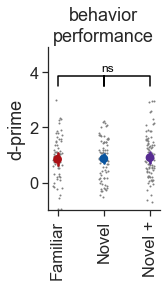

In [222]:
metric = 'dprime_trial_corrected'

stats = each_image_behavior_stats_trial.copy()
stats = stats[stats.behavior_session_id.isin(platform_expts.behavior_session_id.values)]
print(len(stats.behavior_session_id.unique()))

stats = stats[stats.image_name!='omitted']

ppf.plot_behavior_metric_by_experience(stats, metric, title='behavior\nperformance', ylabel='d-prime', ylims=[-1, 3.5],
                                       best_image=True, show_containers=False,
                                       save_dir=save_dir, folder=folder, suffix=suffix+'_each_image_trial_based')


# # for each cell type
# for cell_type in cell_types: 
#     ppf.plot_behavior_metric_by_experience(stats[stats.cell_type==cell_type], metric, title=cell_type, 
#                                                  ylabel='d-prime', ylims=[-1, 3.5],
#                                        best_image=True, show_containers=False,
#                                        save_dir=save_dir, folder=folder, suffix=suffix+'_each_image_trial_based_'+cell_type)

In [101]:
%%time 

method = 'stimulus_based'
engaged_only = False
per_image = False

behavior_session_ids = behavior_sessions.index.values

original_full_session_behavior_stats_stim, problem_sessions = vbu.get_behavior_stats_for_sessions(behavior_session_ids, behavior_sessions, 
                                    method=method, engaged_only=engaged_only, per_image=per_image)

# original_behavior_stats = behavior_stats.copy()
full_session_behavior_stats_stim = original_full_session_behavior_stats_stim.merge(behavior_sessions, on='behavior_session_id')
#  remove 4x2 sessions
full_session_behavior_stats_stim = full_session_behavior_stats_stim[full_session_behavior_stats_stim.project_code!='VisualBehaviorMultiscope4areasx2d']

  0%|                                                                                 | 2/2943 [00:00<03:23, 14.45it/s]

loading for 760808911
loading for 761294708
loading for 761730617
loading for 762067130
loading for 762418364


  0%|▏                                                                                | 7/2943 [00:00<02:52, 16.99it/s]

loading for 763012686
loading for 763661704
loading for 764319580


  0%|▎                                                                               | 11/2943 [00:00<02:59, 16.31it/s]

loading for 764696952
loading for 765208332
loading for 765793356
loading for 766532213


  0%|▎                                                                               | 13/2943 [00:00<03:45, 12.99it/s]

loading for 766931048
loading for 767730839


  1%|▍                                                                               | 17/2943 [00:01<03:10, 15.38it/s]

loading for 768450504
loading for 769145833
loading for 769731277
loading for 770215042


  1%|▌                                                                               | 20/2943 [00:01<02:48, 17.33it/s]

loading for 771040969
loading for 771902184
loading for 772475707
loading for 773391809


  1%|▋                                                                               | 24/2943 [00:01<03:01, 16.08it/s]

loading for 774120511
loading for 774679623
loading for 775291372
loading for 776988190


  1%|▋                                                                               | 27/2943 [00:01<02:57, 16.43it/s]

loading for 778010119
loading for 778888558
loading for 779712859


  1%|▊                                                                               | 31/2943 [00:02<03:23, 14.28it/s]

loading for 780479408
loading for 781938213
loading for 783217873


  1%|▉                                                                               | 35/2943 [00:02<03:10, 15.23it/s]

loading for 783959068
loading for 785382040
loading for 786007435
loading for 786938611


  1%|█                                                                               | 37/2943 [00:02<03:08, 15.44it/s]

loading for 789008423
loading for 789870329
loading for 791248943


  1%|█▏                                                                              | 42/2943 [00:02<02:51, 16.95it/s]

loading for 791904071
loading for 792680306
loading for 793485674
loading for 794968300
loading for 795742990


  2%|█▎                                                                              | 46/2943 [00:02<02:48, 17.14it/s]

loading for 796052844
loading for 796251270
loading for 798126878
loading for 772286394


  2%|█▍                                                                              | 51/2943 [00:03<02:53, 16.69it/s]

loading for 773510999
loading for 774208555
loading for 774767072
loading for 775344511


  2%|█▍                                                                              | 55/2943 [00:03<02:53, 16.62it/s]

loading for 775925580
loading for 777061425
loading for 778119826
loading for 778959204
loading for 779580423


  2%|█▌                                                                              | 59/2943 [00:03<03:03, 15.75it/s]

loading for 780351711
loading for 781727422
loading for 783059206
loading for 783971649


  2%|█▋                                                                              | 64/2943 [00:03<02:42, 17.67it/s]

loading for 785376297
loading for 785868918
loading for 786841415
loading for 788864720


  2%|█▉                                                                              | 70/2943 [00:04<02:15, 21.13it/s]

loading for 789946754
loading for 791278700
loading for 791769447
loading for 792477679
loading for 793153175


  2%|█▉                                                                              | 73/2943 [00:04<02:15, 21.15it/s]

loading for 794071128
loading for 794673280
loading for 795431009
loading for 796031509
loading for 797170547


  3%|██                                                                              | 76/2943 [00:04<02:24, 19.86it/s]

loading for 791877093
loading for 792689261
loading for 793414389
loading for 794295959


  3%|██▏                                                                             | 81/2943 [00:04<02:31, 18.93it/s]

loading for 794977379
loading for 795854559
loading for 799051310
loading for 799922316


  3%|██▎                                                                             | 85/2943 [00:05<02:45, 17.28it/s]

loading for 800299366
loading for 800922511
loading for 802988132
loading for 803351520


  3%|██▍                                                                             | 89/2943 [00:05<02:51, 16.68it/s]

loading for 804929649
loading for 805535249
loading for 806109931
loading for 806792366


  3%|██▌                                                                             | 95/2943 [00:05<02:29, 19.11it/s]

loading for 807356557
loading for 808324301
loading for 808883789
loading for 809358811


  3%|██▋                                                                             | 97/2943 [00:05<02:32, 18.62it/s]

loading for 810405357
loading for 811303680
loading for 811817467
loading for 812955256
loading for 816417578


  3%|██▊                                                                            | 103/2943 [00:05<02:16, 20.76it/s]

loading for 817139151
loading for 818485496
loading for 819094295
loading for 791875850
loading for 792689257


  4%|██▊                                                                            | 106/2943 [00:06<02:19, 20.28it/s]

loading for 793409670
loading for 794295950
loading for 794977383
loading for 795854555


  4%|██▉                                                                            | 109/2943 [00:06<02:22, 19.92it/s]

loading for 799049628
loading for 799919887
loading for 800299362


  4%|███                                                                            | 114/2943 [00:06<02:41, 17.54it/s]

loading for 800919728
loading for 802364085
loading for 802988119


  4%|███                                                                            | 116/2943 [00:06<04:05, 11.52it/s]

loading for 803347004
loading for 805639780
loading for 806296598


  4%|███▏                                                                           | 121/2943 [00:07<03:25, 13.71it/s]

loading for 806841326
loading for 807584876
loading for 808432167
loading for 809027309


  4%|███▎                                                                           | 124/2943 [00:07<03:00, 15.59it/s]

loading for 809427293
loading for 811355443
loading for 810584641
loading for 811356875


  4%|███▍                                                                           | 128/2943 [00:07<03:15, 14.40it/s]

loading for 811831429
loading for 812566400


  4%|███▌                                                                           | 131/2943 [00:07<02:54, 16.13it/s]

loading for 812993078
loading for 813675618
loading for 814546737
loading for 815015329
loading for 815511978


  5%|███▋                                                                           | 136/2943 [00:08<02:39, 17.56it/s]

loading for 816381516
loading for 817182203
loading for 818758572
loading for 819245147


  5%|███▊                                                                           | 141/2943 [00:08<02:30, 18.56it/s]

loading for 819990491
loading for 821803380
loading for 822409353
loading for 823241007


  5%|███▊                                                                           | 144/2943 [00:08<02:19, 20.10it/s]

loading for 823968100
loading for 825012995
loading for 825268982
loading for 825888541
loading for 826697158


  5%|███▉                                                                           | 147/2943 [00:08<02:44, 16.96it/s]

loading for 827374757
loading for 828646658
loading for 829138845


  5%|████                                                                           | 151/2943 [00:08<02:39, 17.50it/s]

loading for 829578829
loading for 830255592
loading for 830832988
loading for 831824426
loading for 832981154


  5%|████▏                                                                          | 157/2943 [00:09<02:27, 18.85it/s]

loading for 835444110
loading for 835820832
loading for 836399024
loading for 807062523


  5%|████▎                                                                          | 160/2943 [00:09<02:22, 19.58it/s]

loading for 808103937
loading for 809588395
loading for 810266014
loading for 811140660


  6%|████▍                                                                          | 166/2943 [00:09<02:27, 18.78it/s]

loading for 811574124
loading for 812261209
loading for 812796028
loading for 814260983


  6%|████▌                                                                          | 169/2943 [00:09<02:22, 19.50it/s]

loading for 814749891
loading for 815865807
loading for 817053045
loading for 818539436
loading for 819065377


  6%|████▌                                                                          | 172/2943 [00:10<02:23, 19.36it/s]

loading for 819497998
loading for 820740400
loading for 821593979
loading for 822159346


  6%|████▊                                                                          | 177/2943 [00:10<02:21, 19.56it/s]

loading for 822874578
loading for 823496226
loading for 824566587
loading for 825269006


  6%|████▉                                                                          | 183/2943 [00:10<02:17, 20.05it/s]

loading for 825902239
loading for 826697162
loading for 827374765
loading for 828669593


  6%|████▉                                                                          | 186/2943 [00:10<02:19, 19.78it/s]

loading for 829138837
loading for 829714672
loading for 830419451
loading for 830959034


  6%|█████                                                                          | 189/2943 [00:10<02:11, 20.94it/s]

loading for 831905148
loading for 833100683
loading for 833946929
loading for 834928595
loading for 835547527


  7%|█████▏                                                                         | 195/2943 [00:11<02:12, 20.69it/s]

loading for 835940015
loading for 837108110
loading for 837512169
loading for 823922942
loading for 824972176


  7%|█████▎                                                                         | 198/2943 [00:11<02:11, 20.88it/s]

loading for 825527066
loading for 826338809
loading for 826841473
loading for 827977069


  7%|█████▍                                                                         | 204/2943 [00:11<02:15, 20.28it/s]

loading for 828842797
loading for 829281654
loading for 829902556
loading for 830592943
loading for 831259963


  7%|█████▋                                                                         | 210/2943 [00:11<02:08, 21.24it/s]

loading for 832009551
loading for 832522789
loading for 833252272
loading for 834059775


  7%|█████▋                                                                         | 213/2943 [00:12<02:08, 21.32it/s]

loading for 834886139
loading for 835608988
loading for 836099247
loading for 836769386
loading for 837202082


  7%|█████▉                                                                         | 219/2943 [00:12<02:07, 21.31it/s]

loading for 837629869
loading for 838486964
loading for 839220840
loading for 839566028


  8%|█████▉                                                                         | 222/2943 [00:12<02:11, 20.64it/s]

loading for 839918083
loading for 840583412
loading for 841431760
loading for 841830077


  8%|██████                                                                         | 225/2943 [00:12<02:10, 20.78it/s]

loading for 842387217
loading for 842821314
loading for 843397714
loading for 844197868
loading for 844880686


  8%|██████▏                                                                        | 231/2943 [00:12<02:15, 19.99it/s]

loading for 845564445
loading for 846272622
loading for 847022155
loading for 847829598


  8%|██████▎                                                                        | 234/2943 [00:13<02:17, 19.75it/s]

loading for 848519645
loading for 849073265
loading for 849635376
loading for 850977753


  8%|██████▍                                                                        | 238/2943 [00:13<02:20, 19.30it/s]

loading for 851779746
loading for 852468381
loading for 853168204
loading for 853875502


  8%|██████▌                                                                        | 243/2943 [00:13<02:29, 18.04it/s]

loading for 854563857
loading for 855421865
loading for 855973498
loading for 856717282
loading for 857612105


  8%|██████▋                                                                        | 247/2943 [00:13<02:37, 17.12it/s]

loading for 859065627
loading for 859735311
loading for 860665051
loading for 861788094


  9%|██████▊                                                                        | 253/2943 [00:14<02:22, 18.81it/s]

loading for 863571072
loading for 864139911
loading for 864824449
loading for 865482857


  9%|██████▊                                                                        | 255/2943 [00:14<02:24, 18.58it/s]

loading for 866333758
loading for 867041502
loading for 867977775
loading for 868721114


  9%|██████▉                                                                        | 260/2943 [00:14<02:30, 17.85it/s]

loading for 869639141
loading for 870960890
loading for 872062433


  9%|███████                                                                        | 262/2943 [00:14<02:34, 17.30it/s]

loading for 873002413
loading for 873750535
loading for 874681118
loading for 875414332


  9%|███████▏                                                                       | 267/2943 [00:14<02:22, 18.82it/s]

loading for 876765708
loading for 877346183
loading for 877925816
loading for 878671068
loading for 879974471


  9%|███████▏                                                                       | 270/2943 [00:15<02:31, 17.69it/s]

loading for 880668519
loading for 881278000
loading for 882256127


  9%|███████▍                                                                       | 275/2943 [00:15<02:27, 18.07it/s]

loading for 882748184
loading for 884596128
loading for 885492180
loading for 886322595


  9%|███████▍                                                                       | 277/2943 [00:15<02:38, 16.79it/s]

loading for 886926935
loading for 888127012
loading for 890157940
loading for 820799656


 10%|███████▌                                                                       | 282/2943 [00:15<02:30, 17.67it/s]

loading for 821837682
loading for 822471786
loading for 823248638
loading for 823922950


 10%|███████▋                                                                       | 287/2943 [00:15<02:19, 19.10it/s]

loading for 824992804
loading for 825533866
loading for 826356747
loading for 826846303
loading for 827944014


 10%|███████▊                                                                       | 291/2943 [00:16<02:32, 17.36it/s]

loading for 828838236
loading for 829282785
loading for 829877552


 10%|███████▊                                                                       | 293/2943 [00:16<02:36, 16.91it/s]

loading for 830620126
loading for 832019583
loading for 832540845
loading for 833454420


 10%|███████▉                                                                       | 298/2943 [00:16<02:28, 17.84it/s]

loading for 834093014
loading for 834908481
loading for 835616503
loading for 836173885


 10%|████████▏                                                                      | 303/2943 [00:16<02:20, 18.79it/s]

loading for 836777468
loading for 837196627
loading for 837647722
loading for 838496122


 10%|████████▏                                                                      | 305/2943 [00:16<02:21, 18.61it/s]

loading for 839233516
loading for 839566049
loading for 839931485
loading for 840594518


 11%|████████▎                                                                      | 310/2943 [00:17<02:29, 17.61it/s]

loading for 841429687
loading for 841842210
loading for 842399625


 11%|████████▍                                                                      | 314/2943 [00:17<02:35, 16.90it/s]

loading for 842844413
loading for 843400443
loading for 844253929
loading for 845585105


 11%|████████▌                                                                      | 318/2943 [00:17<02:39, 16.46it/s]

loading for 846316916
loading for 847036338
loading for 847871771


 11%|████████▌                                                                      | 320/2943 [00:17<02:43, 16.00it/s]

loading for 848599542
loading for 849136474
loading for 849648618
loading for 850985993


 11%|████████▋                                                                      | 324/2943 [00:18<02:43, 16.00it/s]

loading for 851757903
loading for 852440775
loading for 853496105
loading for 827312851


 11%|████████▊                                                                      | 328/2943 [00:18<02:32, 17.12it/s]

loading for 828646634
loading for 829128279
loading for 829591790
loading for 830201482


 11%|████████▉                                                                      | 332/2943 [00:18<02:37, 16.53it/s]

loading for 830867799
loading for 831834820
loading for 832325815
loading for 832990071


 11%|█████████                                                                      | 337/2943 [00:18<02:21, 18.48it/s]

loading for 833780803
loading for 834573980
loading for 835448132
loading for 835865722
loading for 836522259


 12%|█████████▏                                                                     | 340/2943 [00:19<02:23, 18.11it/s]

loading for 837083666
loading for 837443225
loading for 838236165


 12%|█████████▏                                                                     | 344/2943 [00:19<02:38, 16.35it/s]

loading for 839014738
loading for 839479248
loading for 839854553


 12%|█████████▎                                                                     | 348/2943 [00:19<02:33, 16.91it/s]

loading for 840330509
loading for 841185520
loading for 841730873
loading for 842139320
loading for 842792100


 12%|█████████▍                                                                     | 353/2943 [00:19<02:35, 16.64it/s]

loading for 843166865
loading for 844234790
loading for 844875410


 12%|█████████▌                                                                     | 356/2943 [00:20<02:28, 17.46it/s]

loading for 846248008
loading for 847048485
loading for 847867029
loading for 848575992


 12%|█████████▋                                                                     | 361/2943 [00:20<02:12, 19.50it/s]

loading for 849098851
loading for 850976604
loading for 853266283
loading for 831129394
loading for 832021447


 12%|█████████▊                                                                     | 366/2943 [00:20<02:08, 20.05it/s]

loading for 832544149
loading for 833328750
loading for 834087859
loading for 834903060
loading for 835557296


 13%|█████████▉                                                                     | 369/2943 [00:20<02:14, 19.09it/s]

loading for 836166694
loading for 836761653
loading for 837192567
loading for 837638916


 13%|██████████                                                                     | 375/2943 [00:20<02:06, 20.33it/s]

loading for 838496126
loading for 839234289
loading for 839566045
loading for 839939986


 13%|██████████▏                                                                    | 378/2943 [00:21<02:12, 19.38it/s]

loading for 840594514
loading for 841148118
loading for 841707177
loading for 842174399


 13%|██████████▏                                                                    | 381/2943 [00:21<02:07, 20.13it/s]

loading for 842729895
loading for 843203333
loading for 844164376
loading for 844849972


 13%|██████████▍                                                                    | 387/2943 [00:21<02:11, 19.38it/s]

loading for 845441512
loading for 846194950
loading for 846929750
loading for 848503804


 13%|██████████▍                                                                    | 389/2943 [00:21<02:23, 17.80it/s]

loading for 853526948
loading for 834587823
loading for 835451471


 13%|██████████▌                                                                    | 393/2943 [00:21<02:29, 17.11it/s]

loading for 835867850
loading for 836522245
loading for 837083657


 13%|██████████▋                                                                    | 396/2943 [00:22<02:22, 17.83it/s]

loading for 837449223
loading for 838203784
loading for 838998362
loading for 839468826


 14%|██████████▋                                                                    | 400/2943 [00:22<02:26, 17.37it/s]

loading for 839837380
loading for 840330501
loading for 841191836
loading for 841730868


 14%|██████████▊                                                                    | 402/2943 [00:22<02:29, 16.97it/s]

loading for 842139310
loading for 842792094
loading for 843178897


 14%|██████████▉                                                                    | 406/2943 [00:22<02:35, 16.32it/s]

loading for 844027594
loading for 844608277
loading for 845409652
loading for 846051276


 14%|███████████                                                                    | 410/2943 [00:22<02:33, 16.55it/s]

loading for 846791195
loading for 847613846
loading for 848272657
loading for 848938321


 14%|███████████▏                                                                   | 415/2943 [00:23<02:16, 18.53it/s]

loading for 849525884
loading for 850817466
loading for 851563931
loading for 852235678
loading for 852974537


 14%|███████████▎                                                                   | 420/2943 [00:23<02:13, 18.89it/s]

loading for 853505213
loading for 854283407
loading for 855826937
loading for 857230827


 14%|███████████▍                                                                   | 424/2943 [00:23<02:26, 17.17it/s]

loading for 837658854
loading for 838515247
loading for 839219841
loading for 839565422


 15%|███████████▌                                                                   | 429/2943 [00:24<02:12, 18.95it/s]

loading for 839912316
loading for 840581827
loading for 841426832
loading for 841827774


 15%|███████████▌                                                                   | 432/2943 [00:24<02:06, 19.85it/s]

loading for 842385277
loading for 842819933
loading for 843400453
loading for 844199758


 15%|███████████▋                                                                   | 437/2943 [00:24<02:08, 19.48it/s]

loading for 844908261
loading for 845572044
loading for 846331423
loading for 847036328


 15%|███████████▊                                                                   | 440/2943 [00:24<02:09, 19.38it/s]

loading for 847874940
loading for 848613406
loading for 849147676
loading for 849651275


 15%|███████████▉                                                                   | 443/2943 [00:24<02:17, 18.16it/s]

loading for 850989832
loading for 851773928
loading for 852451567


 15%|███████████▉                                                                   | 447/2943 [00:24<02:16, 18.23it/s]

loading for 855200229
loading for 840598877
loading for 841466830
loading for 841851097


 15%|████████████                                                                   | 450/2943 [00:25<02:09, 19.20it/s]

loading for 842419799
loading for 842840144
loading for 843423171
loading for 844229895


 15%|████████████▏                                                                  | 456/2943 [00:25<02:01, 20.53it/s]

loading for 844945060
loading for 845594684
loading for 846284880
loading for 847048490


 16%|████████████▎                                                                  | 459/2943 [00:25<02:07, 19.44it/s]

loading for 847838131
loading for 848526511
loading for 848910243
loading for 849485548


 16%|████████████▍                                                                  | 462/2943 [00:25<02:08, 19.37it/s]

loading for 850810858
loading for 851471401
loading for 852202150
loading for 852966248


 16%|████████████▌                                                                  | 466/2943 [00:25<02:16, 18.13it/s]

loading for 853875514
loading for 854621677
loading for 855424348
loading for 857340041
loading for 857987666


 16%|████████████▋                                                                  | 471/2943 [00:26<02:09, 19.14it/s]

loading for 858974731
loading for 859775117
loading for 863610582
loading for 868070216


 16%|████████████▊                                                                  | 475/2943 [00:26<02:29, 16.52it/s]

loading for 868658294
loading for 869559097
loading for 854533487
loading for 855504136


 16%|████████████▉                                                                  | 480/2943 [00:26<02:21, 17.44it/s]

loading for 856002607
loading for 856732191
loading for 857555456
loading for 858240891


 16%|████████████▉                                                                  | 484/2943 [00:27<02:25, 16.90it/s]

loading for 859032026
loading for 859791558
loading for 860752803
loading for 861794699


 17%|█████████████                                                                  | 486/2943 [00:27<02:22, 17.29it/s]

loading for 862701465
loading for 863571054
loading for 864137547
loading for 864839176


 17%|█████████████▏                                                                 | 491/2943 [00:27<02:20, 17.42it/s]

loading for 865581941
loading for 866287088
loading for 866950070
loading for 867615529


 17%|█████████████▎                                                                 | 495/2943 [00:27<02:28, 16.53it/s]

loading for 868540333
loading for 869319414
loading for 870660821
loading for 871808378


 17%|█████████████▍                                                                 | 502/2943 [00:27<02:02, 19.93it/s]

loading for 872646068
loading for 873517635
loading for 874324533
loading for 875471358
cant load stats for 875471358
loading for 876574139


 17%|█████████████▌                                                                 | 505/2943 [00:28<02:08, 18.94it/s]

loading for 850970486
loading for 851843550
loading for 852507945
loading for 853260939


 17%|█████████████▋                                                                 | 509/2943 [00:28<02:15, 18.00it/s]

loading for 853886146
loading for 855459012
loading for 855980937


 17%|█████████████▋                                                                 | 511/2943 [00:28<02:19, 17.40it/s]

loading for 856719615
loading for 857504898
loading for 858250763
loading for 859049298


 18%|█████████████▊                                                                 | 516/2943 [00:28<02:15, 17.91it/s]

loading for 859784868
loading for 860836980
loading for 861789935
loading for 862716913


 18%|█████████████▉                                                                 | 521/2943 [00:29<02:06, 19.12it/s]

loading for 863614836
loading for 864260028
loading for 864813130
loading for 865460179


 18%|██████████████                                                                 | 524/2943 [00:29<01:58, 20.48it/s]

loading for 866296478
loading for 866999677
loading for 867615541
loading for 868555361
loading for 869334643


 18%|██████████████▏                                                                | 527/2943 [00:29<02:00, 20.11it/s]

loading for 870592115
loading for 871808394
loading for 872626160
loading for 873695653


 18%|██████████████▎                                                                | 533/2943 [00:29<01:57, 20.50it/s]

loading for 874699922
loading for 875440936
loading for 876678452
loading for 877617747
loading for 878120101


 18%|██████████████▍                                                                | 536/2943 [00:29<01:53, 21.17it/s]

loading for 879037269
loading for 880046522
loading for 880784794
loading for 882256117


 18%|██████████████▌                                                                | 542/2943 [00:30<02:08, 18.68it/s]

loading for 858104885
loading for 858900546
loading for 859601488


 18%|██████████████▌                                                                | 544/2943 [00:30<02:22, 16.83it/s]

loading for 860247669
loading for 861717498
loading for 862339401
loading for 863365105


 19%|██████████████▋                                                                | 549/2943 [00:30<02:14, 17.82it/s]

loading for 863966979
loading for 864665192
loading for 865114696


 19%|██████████████▊                                                                | 551/2943 [00:30<02:10, 18.32it/s]

loading for 865887829
loading for 866906696
loading for 867505993
loading for 868511825


 19%|██████████████▉                                                                | 555/2943 [00:30<02:21, 16.82it/s]

loading for 869198966
loading for 870481699
loading for 871723063


 19%|███████████████                                                                | 559/2943 [00:31<02:30, 15.83it/s]

loading for 872607293
loading for 873440431
loading for 874324527


 19%|███████████████                                                                | 562/2943 [00:31<02:20, 16.96it/s]

loading for 875020211
loading for 876448536
loading for 877855866
loading for 878615859
loading for 879846629


 19%|███████████████▏                                                               | 567/2943 [00:31<02:10, 18.28it/s]

loading for 880581639
loading for 881204796
loading for 882289836
loading for 883851453


 19%|███████████████▎                                                               | 569/2943 [00:31<02:24, 16.42it/s]

loading for 884598044
loading for 885404075
loading for 886376835
loading for 888213949


 20%|███████████████▍                                                               | 574/2943 [00:31<02:11, 18.01it/s]

loading for 890021100
loading for 893362730
loading for 894103623
loading for 895022326
loading for 895562386


 20%|███████████████▌                                                               | 579/2943 [00:32<02:14, 17.61it/s]

loading for 896561264
loading for 898432373
loading for 898874650
loading for 899390684


 20%|███████████████▋                                                               | 583/2943 [00:32<02:10, 18.03it/s]

loading for 901999401
loading for 903708760
loading for 904574580
loading for 906472625


 20%|███████████████▊                                                               | 587/2943 [00:32<02:20, 16.80it/s]

loading for 907053876
loading for 907900077
loading for 908533370
loading for 910207192


 20%|███████████████▊                                                               | 591/2943 [00:32<02:19, 16.83it/s]

loading for 910829549
loading for 911904717
loading for 913673477
loading for 914211263


 20%|███████████████▉                                                               | 595/2943 [00:33<02:28, 15.80it/s]

loading for 914705301
loading for 915418411
loading for 916403851


 20%|████████████████                                                               | 597/2943 [00:33<02:22, 16.49it/s]

loading for 918103715
loading for 923410363
loading for 924472023
loading for 925084998


 20%|████████████████▏                                                              | 602/2943 [00:33<02:37, 14.87it/s]

loading for 862479694
loading for 863414647


 21%|████████████████▏                                                              | 604/2943 [00:33<02:29, 15.69it/s]

loading for 864000195
loading for 864729508
loading for 865288307
loading for 865953304


 21%|████████████████▎                                                              | 608/2943 [00:34<02:32, 15.32it/s]

loading for 866971252
loading for 867649878
loading for 868546763
loading for 869311954


 21%|████████████████▍                                                              | 612/2943 [00:34<02:28, 15.66it/s]

loading for 870592103
loading for 871782387
loading for 872720256


 21%|████████████████▌                                                              | 617/2943 [00:34<02:17, 16.95it/s]

loading for 873530279
loading for 874295478
loading for 875020129
loading for 876521253
loading for 877346192
loading for 877938181
loading for 878671074


 21%|████████████████▋                                                              | 623/2943 [00:34<02:12, 17.57it/s]

loading for 879958654
loading for 880647168
loading for 881253316
loading for 882233951
loading for 882679635


 21%|████████████████▊                                                              | 628/2943 [00:35<02:02, 18.92it/s]

loading for 883632948
loading for 884560033
loading for 885418521
loading for 886262841
loading for 886900197


 21%|████████████████▉                                                              | 632/2943 [00:35<02:10, 17.77it/s]

loading for 889183454
loading for 890054551
loading for 891504476
loading for 892413871


 22%|█████████████████                                                              | 636/2943 [00:35<02:03, 18.75it/s]

loading for 893359124
loading for 894215849
loading for 894994111
loading for 896543686
loading for 898461372


 22%|█████████████████▏                                                             | 641/2943 [00:35<02:01, 18.95it/s]

loading for 898890800
loading for 899461485
loading for 902028378
loading for 902822538


 22%|█████████████████▎                                                             | 645/2943 [00:36<02:11, 17.51it/s]

loading for 904625819
loading for 907035965
loading for 907995400
loading for 908564873


 22%|█████████████████▍                                                             | 649/2943 [00:36<02:09, 17.70it/s]

loading for 910249985
loading for 911361486
loading for 912159483
loading for 913921659


 22%|█████████████████▌                                                             | 654/2943 [00:36<02:03, 18.46it/s]

loading for 914411174
loading for 914871449
loading for 915739774
loading for 916704634
loading for 917595407


 22%|█████████████████▋                                                             | 658/2943 [00:36<02:02, 18.69it/s]

loading for 918474069
loading for 919104267
loading for 920015895
loading for 920839478


 22%|█████████████████▊                                                             | 662/2943 [00:37<02:03, 18.50it/s]

loading for 922012422
loading for 923834852
loading for 924759623
loading for 925603486


 23%|█████████████████▉                                                             | 667/2943 [00:37<01:52, 20.19it/s]

loading for 927905748
loading for 929551055
loading for 935301109
loading for 936273485


 23%|█████████████████▉                                                             | 670/2943 [00:37<02:20, 16.14it/s]

loading for 862730050
loading for 863657189
loading for 864236370
loading for 864809053


 23%|██████████████████                                                             | 674/2943 [00:37<02:15, 16.76it/s]

loading for 865443418
loading for 866300303
loading for 867045079
loading for 867977763


 23%|██████████████████▏                                                            | 678/2943 [00:37<02:09, 17.42it/s]

loading for 868704504
loading for 869615887
loading for 870960882
loading for 872864902


 23%|██████████████████▎                                                            | 682/2943 [00:38<02:19, 16.23it/s]

loading for 873729011
loading for 874691139
loading for 875402170
loading for 876701397


 23%|██████████████████▍                                                            | 686/2943 [00:38<02:24, 15.67it/s]

loading for 877524045
loading for 878137744
loading for 879003593


 23%|██████████████████▌                                                            | 690/2943 [00:38<02:33, 14.65it/s]

loading for 880088387
loading for 881416618
loading for 882373648


 24%|██████████████████▌                                                            | 692/2943 [00:38<02:40, 14.01it/s]

loading for 882785348
loading for 883984332
loading for 884750162


 24%|██████████████████▋                                                            | 694/2943 [00:39<02:38, 14.20it/s]

loading for 885540222
loading for 886440427
loading for 886931452


 24%|██████████████████▋                                                            | 698/2943 [00:39<02:16, 16.41it/s]

loading for 888282572
loading for 889443507
loading for 890355790
loading for 891618314


 24%|██████████████████▊                                                            | 702/2943 [00:39<02:18, 16.13it/s]

loading for 892491402
loading for 893540605
loading for 894466746
loading for 895241719


 24%|██████████████████▉                                                            | 706/2943 [00:39<02:18, 16.11it/s]

loading for 895877676
loading for 896969091
loading for 898658063
loading for 899685557


 24%|███████████████████                                                            | 710/2943 [00:40<02:21, 15.74it/s]

loading for 900226857
loading for 901340457
loading for 902244344


 24%|███████████████████                                                            | 712/2943 [00:40<02:23, 15.55it/s]

loading for 902962312
loading for 904899490
loading for 906641078
loading for 908092560


 24%|███████████████████▎                                                           | 718/2943 [00:40<02:05, 17.68it/s]

loading for 910381299
loading for 911016296
loading for 911541959
loading for 912902650


 24%|███████████████████▎                                                           | 721/2943 [00:40<01:52, 19.77it/s]

loading for 913850438
loading for 914336989
loading for 914828503
loading for 915609195
loading for 916614400


 25%|███████████████████▌                                                           | 727/2943 [00:40<01:58, 18.69it/s]

loading for 917500273
loading for 918451984
loading for 919022193


 25%|███████████████████▌                                                           | 730/2943 [00:41<01:53, 19.44it/s]

loading for 919895633
loading for 920807985
loading for 921873454
loading for 923757660


 25%|███████████████████▋                                                           | 734/2943 [00:41<02:02, 18.02it/s]

loading for 924739087
loading for 926621793
loading for 927652117
loading for 928654503


 25%|███████████████████▊                                                           | 738/2943 [00:41<02:06, 17.42it/s]

loading for 929522558
loading for 930344462
loading for 932960096
loading for 933939891


 25%|███████████████████▉                                                           | 742/2943 [00:41<02:10, 16.92it/s]

loading for 935038748
loading for 936159430
loading for 937645038
loading for 938729036


 25%|████████████████████                                                           | 747/2943 [00:42<02:02, 17.97it/s]

loading for 940017429
loading for 941802699
loading for 942814025
loading for 943833533


 25%|████████████████████                                                           | 749/2943 [00:42<02:01, 18.06it/s]

loading for 945033994
loading for 947336783
loading for 948225040
loading for 949348713
loading for 950188644


 26%|████████████████████▎                                                          | 755/2943 [00:42<01:50, 19.79it/s]

loading for 862245493
loading for 863368489
loading for 863966974
loading for 864665204


 26%|████████████████████▎                                                          | 758/2943 [00:42<01:47, 20.32it/s]

loading for 865131331
loading for 865887821
loading for 866909432
loading for 867521015
loading for 868513545


 26%|████████████████████▌                                                          | 764/2943 [00:42<01:40, 21.59it/s]

loading for 869214215
loading for 870481685
loading for 871728970
loading for 872609185
loading for 873449838


 26%|████████████████████▌                                                          | 767/2943 [00:43<01:55, 18.90it/s]

loading for 874333572
loading for 875020175
loading for 876448528
loading for 877855879


 26%|████████████████████▋                                                          | 773/2943 [00:43<01:56, 18.64it/s]

loading for 878615867
loading for 879854787
loading for 880590869
loading for 881210690


 26%|████████████████████▊                                                          | 775/2943 [00:43<02:03, 17.61it/s]

loading for 882291265
loading for 882736270
loading for 883857883
loading for 884605735


 27%|████████████████████▉                                                          | 781/2943 [00:43<01:53, 19.05it/s]

loading for 885404024
loading for 886382175
loading for 888218684
loading for 890021090
loading for 893608687


 27%|█████████████████████                                                          | 784/2943 [00:43<01:49, 19.65it/s]

loading for 894495169
loading for 895278567
loading for 895809864
loading for 896882463


 27%|█████████████████████▏                                                         | 789/2943 [00:44<01:54, 18.76it/s]

loading for 898665096
loading for 898938920
loading for 900227468
loading for 901316636


 27%|█████████████████████▎                                                         | 794/2943 [00:44<01:50, 19.42it/s]

loading for 902211897
loading for 902995627
loading for 903977177
loading for 904922800


 27%|█████████████████████▍                                                         | 798/2943 [00:44<01:53, 18.84it/s]

loading for 906658064
loading for 907327499
loading for 908122381
loading for 912640306


 27%|█████████████████████▍                                                         | 800/2943 [00:44<02:08, 16.67it/s]

loading for 866287136
loading for 867036293
loading for 867961854
loading for 868653129


 27%|█████████████████████▌                                                         | 805/2943 [00:45<01:58, 17.97it/s]

loading for 869623244
loading for 870935142
loading for 872043024
loading for 872979424


 28%|█████████████████████▋                                                         | 810/2943 [00:45<01:57, 18.17it/s]

loading for 873739031
loading for 874654280
loading for 875385921
loading for 876737442


 28%|█████████████████████▊                                                         | 812/2943 [00:45<02:01, 17.54it/s]

loading for 877558833
loading for 878245978
loading for 878993255


 28%|█████████████████████▉                                                         | 817/2943 [00:45<01:51, 19.15it/s]

loading for 880191880
loading for 880775454
loading for 881425509
loading for 882401590
loading for 883756380


 28%|██████████████████████                                                         | 820/2943 [00:45<01:50, 19.16it/s]

loading for 884552901
loading for 885410929
loading for 886257016
loading for 886838602


 28%|██████████████████████▏                                                        | 825/2943 [00:46<01:55, 18.31it/s]

loading for 888033338
loading for 889175194
loading for 890033129
loading for 891446789


 28%|██████████████████████▏                                                        | 828/2943 [00:46<01:50, 19.19it/s]

loading for 892387261
loading for 893344360
loading for 894083470
loading for 898440124


 28%|██████████████████████▎                                                        | 833/2943 [00:46<01:50, 19.04it/s]

loading for 866128606
loading for 866971269
loading for 867645566
loading for 868531777


 28%|██████████████████████▍                                                        | 838/2943 [00:46<01:47, 19.66it/s]

loading for 869311972
loading for 870579061
loading for 871782397
loading for 872690218


 29%|██████████████████████▋                                                        | 843/2943 [00:47<01:43, 20.26it/s]

loading for 873537911
loading for 874416985
loading for 875020203
loading for 876651891


 29%|██████████████████████▋                                                        | 846/2943 [00:47<01:50, 18.99it/s]

loading for 877487375
loading for 878179382
loading for 878771403
loading for 879969002


 29%|██████████████████████▊                                                        | 850/2943 [00:47<01:54, 18.30it/s]

loading for 880644824
loading for 881251187
loading for 882219267
loading for 882677813
loading for 883632956


 29%|██████████████████████▉                                                        | 855/2943 [00:47<01:45, 19.74it/s]

loading for 884560064
loading for 885410934
loading for 886250995
loading for 887006111
loading for 888163519


 29%|███████████████████████                                                        | 859/2943 [00:47<01:49, 19.02it/s]

loading for 889388078
loading for 890625596
loading for 891605682
loading for 892526544
loading for 893488330


 29%|███████████████████████▏                                                       | 865/2943 [00:48<01:47, 19.37it/s]

loading for 894368064
loading for 870987812
loading for 872953842
loading for 873774125
loading for 874790261


 30%|███████████████████████▎                                                       | 869/2943 [00:48<01:49, 18.88it/s]

loading for 875207834
loading for 876821726
loading for 877603209
loading for 878245989


 30%|███████████████████████▍                                                       | 873/2943 [00:48<01:54, 18.09it/s]

loading for 879003606
loading for 880088400
loading for 881416637
loading for 882373653


 30%|███████████████████████▌                                                       | 878/2943 [00:49<01:54, 18.06it/s]

loading for 882781075
loading for 883986743
loading for 884776248
loading for 885540237


 30%|███████████████████████▋                                                       | 882/2943 [00:49<01:53, 18.20it/s]

loading for 886442346
loading for 886946944
loading for 888295170
loading for 889468960


 30%|███████████████████████▊                                                       | 887/2943 [00:49<01:45, 19.49it/s]

loading for 890408602
loading for 891635659
loading for 891635667
loading for 892510304


 30%|███████████████████████▊                                                       | 889/2943 [00:49<01:51, 18.36it/s]

loading for 893560763
loading for 894481319
loading for 895248933
loading for 895896343


 30%|███████████████████████▉                                                       | 893/2943 [00:49<01:50, 18.56it/s]

loading for 896995828
loading for 898667252
loading for 899700579
loading for 900231059
loading for 901363879


 31%|████████████████████████                                                       | 898/2943 [00:50<01:54, 17.82it/s]

loading for 902260156
loading for 902975505
loading for 904922810
loading for 906668549


 31%|████████████████████████▏                                                      | 902/2943 [00:50<01:53, 18.02it/s]

loading for 908104455
loading for 910393217
loading for 911016285
loading for 911541950


 31%|████████████████████████▎                                                      | 906/2943 [00:50<01:58, 17.19it/s]

loading for 912223787
loading for 912902619
loading for 913850450
loading for 914339617
loading for 914831000


 31%|████████████████████████▍                                                      | 911/2943 [00:50<01:57, 17.35it/s]

loading for 915609216
loading for 916617096
loading for 917500256
loading for 918451994


 31%|████████████████████████▌                                                      | 915/2943 [00:51<01:57, 17.31it/s]

loading for 919025442
loading for 920901263
loading for 921979060
loading for 923757653


 31%|████████████████████████▋                                                      | 919/2943 [00:51<02:19, 14.51it/s]

loading for 924739774
loading for 926621788
loading for 927652110


 31%|████████████████████████▊                                                      | 924/2943 [00:51<01:57, 17.22it/s]

loading for 928654491
loading for 929524423
loading for 930344469
loading for 932960104


 31%|████████████████████████▉                                                      | 927/2943 [00:51<01:48, 18.55it/s]

loading for 933954934
loading for 935045761
loading for 936083473
loading for 937706038
loading for 938794488


 32%|████████████████████████▉                                                      | 931/2943 [00:52<01:51, 17.97it/s]

loading for 939985541
loading for 940755050
loading for 941734036
loading for 942767530


 32%|█████████████████████████                                                      | 935/2943 [00:52<01:56, 17.28it/s]

loading for 944125005
loading for 945075740
loading for 947988590


 32%|█████████████████████████▏                                                     | 937/2943 [00:52<02:03, 16.27it/s]

loading for 949201674
loading for 949973686
loading for 951520319


 32%|█████████████████████████▎                                                     | 942/2943 [00:52<02:00, 16.61it/s]

loading for 952554548
loading for 953982960
loading for 956010809
loading for 957032492
loading for 958234742


 32%|█████████████████████████▍                                                     | 946/2943 [00:52<01:59, 16.73it/s]

loading for 958888263
loading for 959681045
loading for 875126982
loading for 876823447


 32%|█████████████████████████▌                                                     | 950/2943 [00:53<02:03, 16.19it/s]

loading for 877605077
loading for 878245966
loading for 879074585
loading for 880174939


 32%|█████████████████████████▋                                                     | 955/2943 [00:53<01:56, 17.06it/s]

loading for 881450253
loading for 882426675
loading for 882833335


 33%|█████████████████████████▋                                                     | 957/2943 [00:53<01:54, 17.38it/s]

loading for 884004562
loading for 884776271
loading for 885598412
loading for 886446962


 33%|█████████████████████████▊                                                     | 961/2943 [00:53<02:00, 16.45it/s]

loading for 886953901
loading for 888298590
loading for 889478291


 33%|█████████████████████████▊                                                     | 963/2943 [00:54<02:28, 13.36it/s]

loading for 890408635
loading for 891635663


 33%|█████████████████████████▉                                                     | 965/2943 [00:54<02:20, 14.05it/s]

loading for 892525019
loading for 893560739
loading for 894481291
loading for 895262003


 33%|██████████████████████████                                                     | 970/2943 [00:54<01:59, 16.47it/s]

loading for 895896368
loading for 896995823
loading for 898682070
loading for 899742869
loading for 901424076


 33%|██████████████████████████▏                                                    | 976/2943 [00:54<01:43, 18.97it/s]

loading for 902328548
loading for 903098779
loading for 904954571
loading for 906726720


 33%|██████████████████████████▎                                                    | 980/2943 [00:55<01:53, 17.35it/s]

loading for 908165653
loading for 910448027
loading for 911061160
loading for 911581364


 33%|██████████████████████████▍                                                    | 983/2943 [00:55<01:42, 19.05it/s]

loading for 912318840
loading for 913014398
loading for 913917929
loading for 914408296


 34%|██████████████████████████▍                                                    | 987/2943 [00:55<01:56, 16.77it/s]

loading for 914859356
loading for 915690413
loading for 916673577


 34%|██████████████████████████▌                                                    | 990/2943 [00:55<01:50, 17.63it/s]

loading for 917600513
loading for 918448801
loading for 919022174
loading for 919890884


 34%|██████████████████████████▋                                                    | 996/2943 [00:55<01:40, 19.43it/s]

loading for 920807973
loading for 921873450
loading for 923750087
loading for 924740575


 34%|██████████████████████████▊                                                    | 998/2943 [00:55<01:44, 18.56it/s]

loading for 926614379
loading for 927643982
loading for 928647601
loading for 929522554


 34%|██████████████████████████▌                                                   | 1002/2943 [00:56<01:45, 18.41it/s]

loading for 930376122
loading for 931913977
loading for 932628715
loading for 933604243


 34%|██████████████████████████▋                                                   | 1006/2943 [00:56<01:48, 17.89it/s]

loading for 934812249
loading for 935653479
loading for 937395157
loading for 938339083
loading for 939533442


 34%|██████████████████████████▊                                                   | 1011/2943 [00:56<01:42, 18.83it/s]

loading for 940628402
loading for 941425961
loading for 942350598
loading for 875155219


 35%|██████████████████████████▉                                                   | 1016/2943 [00:56<01:34, 20.36it/s]

loading for 876829777
loading for 877607698
loading for 878251933
loading for 879074574
loading for 880181164


 35%|███████████████████████████                                                   | 1021/2943 [00:57<01:38, 19.54it/s]

loading for 881450232
loading for 882426670
loading for 882844402
loading for 884070037
loading for 884846935


 35%|███████████████████████████▏                                                  | 1024/2943 [00:57<01:31, 20.87it/s]

loading for 885609778
loading for 886472241
loading for 887175302
loading for 888346887


 35%|███████████████████████████▎                                                  | 1029/2943 [00:57<01:42, 18.75it/s]

loading for 889536668
loading for 890555457
loading for 891724311
loading for 893564091


 35%|███████████████████████████▍                                                  | 1034/2943 [00:57<01:44, 18.28it/s]

loading for 894481299
loading for 895256170
loading for 895902286


 35%|███████████████████████████▍                                                  | 1036/2943 [00:57<01:48, 17.63it/s]

loading for 897002967
loading for 898668828
loading for 899700587
loading for 900231063


 35%|███████████████████████████▌                                                  | 1040/2943 [00:58<01:53, 16.70it/s]

loading for 901363886
loading for 902260148
loading for 902975514
loading for 904922795


 35%|███████████████████████████▋                                                  | 1043/2943 [00:58<01:52, 16.95it/s]

loading for 906668545
loading for 908109320
loading for 910393226


 36%|███████████████████████████▊                                                  | 1048/2943 [00:58<01:53, 16.74it/s]

loading for 911019327
loading for 911543418
loading for 912223793
loading for 912223799


 36%|███████████████████████████▉                                                  | 1052/2943 [00:58<01:48, 17.50it/s]

loading for 912902659
loading for 913854181
loading for 914339627
loading for 914831033


 36%|███████████████████████████▉                                                  | 1054/2943 [00:59<01:47, 17.55it/s]

loading for 915609229
loading for 916617112
loading for 917506393
loading for 918454529


 36%|████████████████████████████                                                  | 1059/2943 [00:59<01:43, 18.27it/s]

loading for 919025470
loading for 919902020
loading for 920813990
loading for 921879360


 36%|████████████████████████████▏                                                 | 1063/2943 [00:59<01:43, 18.10it/s]

loading for 923877874
loading for 924757055
loading for 926621779
loading for 927643992
loading for 928647605


 36%|████████████████████████████▎                                                 | 1069/2943 [00:59<01:39, 18.86it/s]

loading for 929522550
loading for 930335512
loading for 931488919
loading for 932596575


 36%|████████████████████████████▍                                                 | 1072/2943 [00:59<01:35, 19.56it/s]

loading for 933472975
loading for 935601725
loading for 937442661
loading for 938425882
loading for 939537734


 37%|████████████████████████████▌                                                 | 1078/2943 [01:00<01:25, 21.73it/s]

loading for 940553228
loading for 941457567
loading for 942329079
loading for 943479988
loading for 944823947


 37%|████████████████████████████▋                                                 | 1083/2943 [01:00<01:39, 18.63it/s]

loading for 882765152
loading for 883908190
loading for 884881862
loading for 885609760


 37%|████████████████████████████▊                                                 | 1087/2943 [01:00<01:43, 17.97it/s]

loading for 886424035
loading for 887142121
loading for 888298597
loading for 889478282


 37%|████████████████████████████▉                                                 | 1092/2943 [01:01<01:38, 18.86it/s]

loading for 890578468
loading for 891752782
loading for 892597881
loading for 893551176


 37%|█████████████████████████████                                                 | 1095/2943 [01:01<01:33, 19.86it/s]

loading for 894489950
loading for 895248904
loading for 895947603
loading for 896945902


 37%|█████████████████████████████                                                 | 1097/2943 [01:01<01:34, 19.51it/s]

loading for 898691674
loading for 898982250
loading for 901251663
loading for 902135840


 37%|█████████████████████████████▏                                                | 1103/2943 [01:01<01:35, 19.36it/s]

loading for 902871565
loading for 903842232
loading for 904844395
loading for 908065760


 38%|█████████████████████████████▎                                                | 1106/2943 [01:01<01:35, 19.30it/s]

loading for 888282565
loading for 889461157
loading for 890450001
loading for 891789286


 38%|█████████████████████████████▍                                                | 1110/2943 [01:02<01:42, 17.93it/s]

loading for 892645353
loading for 893600610
loading for 894481279
loading for 895270564


 38%|█████████████████████████████▌                                                | 1114/2943 [01:02<01:41, 18.09it/s]

loading for 896024686
loading for 896931325
loading for 898658079
loading for 899685565
loading for 900226853


 38%|█████████████████████████████▋                                                | 1120/2943 [01:02<01:34, 19.38it/s]

loading for 901358520
loading for 902255179
loading for 902975500
loading for 904917894
loading for 906658076


 38%|█████████████████████████████▊                                                | 1123/2943 [01:02<01:37, 18.69it/s]

loading for 907195053
loading for 908930196
loading for 910396133
loading for 911025799


 38%|█████████████████████████████▉                                                | 1129/2943 [01:02<01:28, 20.56it/s]

loading for 911527254
loading for 912318850
loading for 913901536
loading for 914353445
loading for 914852087


 39%|██████████████████████████████                                                | 1135/2943 [01:03<01:27, 20.62it/s]

loading for 915667469
loading for 917618254
loading for 918296132
loading for 921923865


 39%|██████████████████████████████▏                                               | 1138/2943 [01:03<01:32, 19.55it/s]

loading for 922869624
loading for 892283069
loading for 893354175
loading for 894078803


 39%|██████████████████████████████▎                                               | 1143/2943 [01:03<01:27, 20.52it/s]

loading for 895009095
loading for 895553474
loading for 896543705
loading for 898384915


 39%|██████████████████████████████▎                                               | 1146/2943 [01:03<01:26, 20.82it/s]

loading for 898877946
loading for 899400242
loading for 900232144
loading for 900936302
loading for 901876389


 39%|██████████████████████████████▌                                               | 1151/2943 [01:04<01:36, 18.67it/s]

loading for 902810506
loading for 903693439
loading for 907035950


 39%|██████████████████████████████▌                                               | 1154/2943 [01:04<01:33, 19.08it/s]

loading for 907912571
loading for 908489409
loading for 909341448
loading for 910182303
loading for 910812913


 39%|██████████████████████████████▋                                               | 1157/2943 [01:04<01:28, 20.17it/s]

loading for 911375322
loading for 912008538
loading for 912570307
loading for 913677684


 40%|██████████████████████████████▊                                               | 1163/2943 [01:04<01:31, 19.41it/s]

loading for 914219174
loading for 914691372
loading for 915326103
loading for 916390399


 40%|██████████████████████████████▉                                               | 1166/2943 [01:04<01:28, 19.97it/s]

loading for 917261917
loading for 918098812
loading for 918860187
loading for 919485101
loading for 921759097


 40%|███████████████████████████████                                               | 1172/2943 [01:05<01:25, 20.65it/s]

loading for 921503547
loading for 922467930
loading for 923417336
loading for 924550325
loading for 925067625


 40%|███████████████████████████████▏                                              | 1178/2943 [01:05<01:23, 21.20it/s]

loading for 926393694
loading for 928361913
loading for 904942194
loading for 906720759


 40%|███████████████████████████████▎                                              | 1181/2943 [01:05<01:28, 19.87it/s]

loading for 908165660
loading for 910443509
loading for 911056351
loading for 911571923


 40%|███████████████████████████████▍                                              | 1184/2943 [01:05<01:29, 19.71it/s]

loading for 912307836
loading for 913008445
loading for 913908317
loading for 914402498


 40%|███████████████████████████████▌                                              | 1189/2943 [01:05<01:27, 19.95it/s]

loading for 914857564
loading for 915675582
loading for 916667034
loading for 917588238
loading for 918488020


 41%|███████████████████████████████▌                                              | 1193/2943 [01:06<01:34, 18.51it/s]

loading for 919082124
loading for 919989570
loading for 920892084
loading for 921964245


 41%|███████████████████████████████▊                                              | 1198/2943 [01:06<01:36, 18.08it/s]

loading for 923744925
loading for 924737598
loading for 926607088
loading for 927629370


 41%|███████████████████████████████▊                                              | 1202/2943 [01:06<01:35, 18.17it/s]

loading for 928633684
loading for 929519500
loading for 930319167
loading for 932960088


 41%|███████████████████████████████▉                                              | 1204/2943 [01:06<01:39, 17.53it/s]

loading for 933954915
loading for 935053429
loading for 936083459


 41%|████████████████████████████████                                              | 1208/2943 [01:07<01:39, 17.39it/s]

loading for 937706048
loading for 938767948
loading for 939977527
loading for 940755054


 41%|████████████████████████████████▏                                             | 1213/2943 [01:07<01:34, 18.23it/s]

loading for 941734023
loading for 942767544
loading for 944153204
loading for 945075756


 41%|████████████████████████████████▎                                             | 1217/2943 [01:07<01:32, 18.69it/s]

loading for 947082734
loading for 948003540
loading for 949182428
loading for 951453828


 42%|████████████████████████████████▍                                             | 1222/2943 [01:07<01:23, 20.56it/s]

loading for 952657468
loading for 953952253
loading for 955962226
loading for 957454325
loading for 958558082


 42%|████████████████████████████████▍                                             | 1225/2943 [01:07<01:22, 20.84it/s]

loading for 959115465
loading for 960021127
loading for 960834330
loading for 961246494


 42%|████████████████████████████████▋                                             | 1231/2943 [01:08<01:24, 20.31it/s]

loading for 962346335
loading for 963237068
loading for 964109496
loading for 965034185
loading for 965727499


 42%|████████████████████████████████▋                                             | 1234/2943 [01:08<01:22, 20.63it/s]

loading for 966765494
loading for 901399302
loading for 902323283
loading for 903101960
loading for 904950235


 42%|████████████████████████████████▊                                             | 1239/2943 [01:08<01:28, 19.18it/s]

loading for 906720764
loading for 908159796
loading for 910443504
loading for 911052612
loading for 911571901


 42%|████████████████████████████████▉                                             | 1245/2943 [01:08<01:24, 20.12it/s]

loading for 912307828
loading for 913001481
loading for 913908289
loading for 914402478


 42%|█████████████████████████████████                                             | 1248/2943 [01:09<01:25, 19.81it/s]

loading for 914855672
loading for 915675595
loading for 916667039
loading for 917588247


 43%|█████████████████████████████████▏                                            | 1253/2943 [01:09<01:24, 20.04it/s]

loading for 918486608
loading for 919082134
loading for 919985026
loading for 920888197
loading for 921959207


 43%|█████████████████████████████████▎                                            | 1259/2943 [01:09<01:21, 20.74it/s]

loading for 923845421
loading for 924752487
loading for 926725204
loading for 927751225
loading for 928751222


 43%|█████████████████████████████████▍                                            | 1262/2943 [01:09<01:19, 21.26it/s]

loading for 929539392
loading for 930443737
loading for 933034558
loading for 934070063


 43%|█████████████████████████████████▌                                            | 1268/2943 [01:10<01:20, 20.76it/s]

loading for 935150167
loading for 936169485
loading for 937790035
loading for 938884899


 43%|█████████████████████████████████▋                                            | 1271/2943 [01:10<01:17, 21.45it/s]

loading for 939970161
loading for 940757571
loading for 941726524
loading for 942767539
loading for 944124976


 43%|█████████████████████████████████▊                                            | 1277/2943 [01:10<01:23, 20.04it/s]

loading for 944971315
loading for 946284988
loading for 947372441
loading for 948320743


 43%|█████████████████████████████████▉                                            | 1280/2943 [01:10<01:18, 21.09it/s]

loading for 949402246
loading for 950265118
loading for 951696355
loading for 952944924
loading for 954198857


 44%|██████████████████████████████████                                            | 1283/2943 [01:10<01:17, 21.44it/s]

loading for 955094305
loading for 956454085
loading for 957435664
loading for 958532504


 44%|██████████████████████████████████▏                                           | 1289/2943 [01:11<01:17, 21.41it/s]

loading for 959051998
loading for 959982762
loading for 960796984
loading for 961226077
loading for 962206556
loading for 963153838


 44%|██████████████████████████████████▎                                           | 1295/2943 [01:11<01:17, 21.36it/s]

loading for 963940678
loading for 964999392
loading for 966735404
loading for 967449308


 44%|██████████████████████████████████▍                                           | 1298/2943 [01:11<01:22, 19.94it/s]

loading for 968334595
loading for 969339750
loading for 970877412
loading for 971950909


 44%|██████████████████████████████████▌                                           | 1304/2943 [01:11<01:20, 20.25it/s]

loading for 909256602
loading for 910258982
loading for 911346410
loading for 911927191


 44%|██████████████████████████████████▋                                           | 1307/2943 [01:11<01:19, 20.56it/s]

loading for 912570302
loading for 913694939
loading for 914219152
loading for 914708602
loading for 915429425


 45%|██████████████████████████████████▊                                           | 1313/2943 [01:12<01:17, 21.16it/s]

loading for 916437733
loading for 917317439
loading for 918172109
loading for 918881230
loading for 919586810
loading for 920528725
loading for 921566809


 45%|██████████████████████████████████▉                                           | 1319/2943 [01:12<01:23, 19.39it/s]

loading for 922540163
loading for 923445943
loading for 924544064
loading for 924985099


 45%|███████████████████████████████████                                           | 1323/2943 [01:12<01:24, 19.15it/s]

loading for 926434150
loading for 927423753
loading for 928263223
loading for 929309900


 45%|███████████████████████████████████▏                                          | 1326/2943 [01:12<01:21, 19.74it/s]

loading for 929767335
loading for 931526090
loading for 932547907
loading for 933456539


 45%|███████████████████████████████████▎                                          | 1331/2943 [01:13<01:26, 18.66it/s]

loading for 934707744
loading for 937457770
loading for 939536227
loading for 939765508


 45%|███████████████████████████████████▍                                          | 1335/2943 [01:13<01:26, 18.49it/s]

loading for 940553221
loading for 941597243
loading for 942197044
loading for 943358608


 45%|███████████████████████████████████▍                                          | 1338/2943 [01:13<01:23, 19.30it/s]

loading for 944698858
loading for 945645033
loading for 947038510
loading for 947948249


 46%|███████████████████████████████████▌                                          | 1342/2943 [01:13<01:27, 18.32it/s]

loading for 949182392
loading for 950000878
loading for 951459907
loading for 952610573


 46%|███████████████████████████████████▋                                          | 1347/2943 [01:14<01:28, 17.94it/s]

loading for 953991886
loading for 954603651
loading for 956171927


 46%|███████████████████████████████████▊                                          | 1349/2943 [01:14<01:27, 18.18it/s]

loading for 957030810
loading for 958254373
loading for 958884908
loading for 959640885


 46%|███████████████████████████████████▉                                          | 1354/2943 [01:14<01:26, 18.47it/s]

loading for 960501578
loading for 961226087
loading for 961819631
loading for 962922731


 46%|███████████████████████████████████▉                                          | 1357/2943 [01:14<01:19, 19.96it/s]

loading for 963663505
loading for 964871967
loading for 965505185
loading for 896394737
loading for 898384901


 46%|████████████████████████████████████                                          | 1363/2943 [01:14<01:21, 19.44it/s]

loading for 898876989
loading for 899400273
loading for 900232139
loading for 900936320


 46%|████████████████████████████████████▏                                         | 1366/2943 [01:15<01:18, 20.00it/s]

loading for 901876370
loading for 902810495
loading for 903693459
loading for 907035932


 47%|████████████████████████████████████▎                                         | 1372/2943 [01:15<01:16, 20.41it/s]

loading for 907899541
loading for 908468655
loading for 909291218
loading for 910182310
loading for 910799740


 47%|████████████████████████████████████▍                                         | 1375/2943 [01:15<01:25, 18.28it/s]

loading for 911361478
loading for 911815202
loading for 912588254
loading for 913741146


 47%|████████████████████████████████████▌                                         | 1379/2943 [01:15<01:28, 17.62it/s]

loading for 914265106
loading for 914726630
loading for 915454053
loading for 916450861


 47%|████████████████████████████████████▋                                         | 1384/2943 [01:16<01:19, 19.63it/s]

loading for 917331206
loading for 918202284
loading for 918900918
loading for 919442744
loading for 921364147


 47%|████████████████████████████████████▊                                         | 1388/2943 [01:16<01:24, 18.50it/s]

loading for 922449488
loading for 923364302
loading for 924492214
loading for 925016863


 47%|████████████████████████████████████▉                                         | 1392/2943 [01:16<01:26, 17.84it/s]

loading for 926393711
loading for 927419411
loading for 928279918
loading for 929354243


 47%|████████████████████████████████████▉                                         | 1396/2943 [01:16<01:24, 18.26it/s]

loading for 929836732
loading for 932160990
loading for 932991298
loading for 934075957
loading for 935129110


 48%|█████████████████████████████████████▏                                        | 1401/2943 [01:16<01:21, 19.03it/s]

loading for 936153744
loading for 937783930
loading for 938789129
loading for 940017421
loading for 941891140


 48%|█████████████████████████████████████▎                                        | 1407/2943 [01:17<01:13, 20.91it/s]

loading for 942562699
loading for 944950609
loading for 947311015
loading for 948206919
loading for 949337508


 48%|█████████████████████████████████████▍                                        | 1413/2943 [01:17<01:12, 21.08it/s]

loading for 950157787
loading for 952746230
loading for 954120560
loading for 936116165


 48%|█████████████████████████████████████▌                                        | 1416/2943 [01:17<01:14, 20.52it/s]

loading for 937854150
loading for 938889808
loading for 940154108
loading for 940779937


 48%|█████████████████████████████████████▌                                        | 1419/2943 [01:17<01:23, 18.31it/s]

loading for 941896070
loading for 942849916
loading for 944216879


 48%|█████████████████████████████████████▋                                        | 1424/2943 [01:18<01:19, 19.20it/s]

loading for 945204293
loading for 946281668
loading for 947385424
loading for 948148817


 48%|█████████████████████████████████████▊                                        | 1427/2943 [01:18<01:13, 20.50it/s]

loading for 949182414
loading for 949987080
loading for 951507102
loading for 953978404
loading for 955943003


 49%|█████████████████████████████████████▉                                        | 1430/2943 [01:18<01:13, 20.70it/s]

loading for 957147348
loading for 958888268
loading for 959675291
loading for 960488162


 49%|██████████████████████████████████████                                        | 1436/2943 [01:18<01:16, 19.73it/s]

loading for 962191834
loading for 962984229
loading for 963694974
loading for 964894591
loading for 937363104


 49%|██████████████████████████████████████▏                                       | 1439/2943 [01:18<01:14, 20.14it/s]

loading for 939772185
loading for 940635435
loading for 941700201
loading for 942412338


 49%|██████████████████████████████████████▎                                       | 1445/2943 [01:19<01:16, 19.49it/s]

loading for 943559700
loading for 944845647
loading for 945811327
loading for 947197212


 49%|██████████████████████████████████████▍                                       | 1448/2943 [01:19<01:24, 17.78it/s]

loading for 948162486
loading for 949292490
loading for 950119814


 49%|██████████████████████████████████████▍                                       | 1452/2943 [01:19<01:27, 17.05it/s]

loading for 951565921
loading for 952752558
loading for 953978412


 49%|██████████████████████████████████████▌                                       | 1454/2943 [01:19<01:25, 17.34it/s]

loading for 954603672
loading for 956010816
loading for 957071478
loading for 958456204
loading for 958982193


 50%|██████████████████████████████████████▋                                       | 1460/2943 [01:20<01:17, 19.04it/s]

loading for 959836077
loading for 960697328
loading for 962191827
loading for 963114728


 50%|██████████████████████████████████████▊                                       | 1464/2943 [01:20<01:21, 18.16it/s]

loading for 963923531
loading for 965016824
loading for 966717522
loading for 967460086


 50%|██████████████████████████████████████▉                                       | 1467/2943 [01:20<01:16, 19.17it/s]

loading for 968359999
loading for 969310457
loading for 930435266
loading for 932176731


 50%|███████████████████████████████████████                                       | 1472/2943 [01:20<01:20, 18.28it/s]

loading for 933004984
loading for 934182630
loading for 935222980
loading for 936140741
loading for 937854140


 50%|███████████████████████████████████████▏                                      | 1478/2943 [01:20<01:09, 21.08it/s]

loading for 938903319
loading for 939977516
loading for 940658765
loading for 941776657
loading for 942737913


 50%|███████████████████████████████████████▎                                      | 1481/2943 [01:21<01:15, 19.27it/s]

loading for 944191845
loading for 945187188
loading for 945868902
loading for 949480037


 50%|███████████████████████████████████████▎                                      | 1484/2943 [01:21<01:11, 20.41it/s]

loading for 950183210
loading for 952973407
loading for 954206178
loading for 955008634


 51%|███████████████████████████████████████▍                                      | 1490/2943 [01:21<01:11, 20.41it/s]

loading for 956399048
loading for 957481370
loading for 958526416
loading for 959016020
loading for 959836084


 51%|███████████████████████████████████████▋                                      | 1496/2943 [01:21<01:10, 20.60it/s]

loading for 960713124
loading for 961226066
loading for 962154268
loading for 963225593


 51%|███████████████████████████████████████▋                                      | 1499/2943 [01:22<01:16, 18.95it/s]

loading for 964096322
loading for 965039884
loading for 966807640


 51%|███████████████████████████████████████▊                                      | 1501/2943 [01:22<01:19, 18.20it/s]

loading for 967636314
loading for 968516365
loading for 969423725


 51%|███████████████████████████████████████▊                                      | 1503/2943 [01:22<01:26, 16.66it/s]

loading for 970035226
loading for 970869084
loading for 971661805
loading for 972034557


 51%|███████████████████████████████████████▉                                      | 1508/2943 [01:22<01:24, 16.92it/s]

loading for 972527218
loading for 973798798
loading for 974328452
loading for 974899766


 51%|████████████████████████████████████████                                      | 1512/2943 [01:22<01:21, 17.61it/s]

loading for 975455944
loading for 976199854
loading for 976952429
loading for 977746260


 52%|████████████████████████████████████████▏                                     | 1517/2943 [01:23<01:20, 17.70it/s]

loading for 978207251
loading for 978683883
loading for 979468313


 52%|████████████████████████████████████████▎                                     | 1519/2943 [01:23<01:20, 17.66it/s]

loading for 980154562
loading for 982741262
loading for 984071694
loading for 986191154
loading for 987041025


 52%|████████████████████████████████████████▍                                     | 1524/2943 [01:23<01:15, 18.88it/s]

loading for 988137738
loading for 989139686
loading for 989523730
loading for 990319706


 52%|████████████████████████████████████████▍                                     | 1528/2943 [01:23<01:25, 16.58it/s]

loading for 990619461
loading for 990871215
loading for 991763993


 52%|████████████████████████████████████████▌                                     | 1530/2943 [01:23<01:26, 16.42it/s]

loading for 991997544
loading for 992251964
loading for 992417143
loading for 992816969


 52%|████████████████████████████████████████▋                                     | 1535/2943 [01:24<01:18, 18.02it/s]

loading for 993276262
loading for 993499029
loading for 993766500
loading for 993995204


 52%|████████████████████████████████████████▊                                     | 1540/2943 [01:24<01:16, 18.42it/s]

loading for 994210659
loading for 994743822
loading for 994894518
loading for 995142529


 52%|████████████████████████████████████████▉                                     | 1543/2943 [01:24<01:14, 18.90it/s]

loading for 995379633
loading for 995570835
loading for 929533460
loading for 932160986


 53%|█████████████████████████████████████████                                     | 1548/2943 [01:24<01:16, 18.18it/s]

loading for 933049320
loading for 934082432
loading for 935199639


 53%|█████████████████████████████████████████                                     | 1551/2943 [01:24<01:12, 19.19it/s]

loading for 936163556
loading for 937854186
loading for 938889840
loading for 940145401
loading for 940779382


 53%|█████████████████████████████████████████▏                                    | 1554/2943 [01:25<01:12, 19.15it/s]

loading for 941896081
loading for 942849909
loading for 944216872
loading for 945184906


 53%|█████████████████████████████████████████▎                                    | 1559/2943 [01:25<01:11, 19.46it/s]

loading for 946263063
loading for 947355907
loading for 948309156
loading for 949394856


 53%|█████████████████████████████████████████▍                                    | 1564/2943 [01:25<01:13, 18.71it/s]

loading for 950250646
loading for 951687714
loading for 952923305
loading for 954192305


 53%|█████████████████████████████████████████▌                                    | 1567/2943 [01:25<01:12, 18.87it/s]

loading for 955079062
loading for 956433366
loading for 957412617
loading for 958519158


 53%|█████████████████████████████████████████▋                                    | 1571/2943 [01:25<01:14, 18.33it/s]

loading for 959031142
loading for 959959559
loading for 960783011
loading for 961223061


 54%|█████████████████████████████████████████▊                                    | 1577/2943 [01:26<01:09, 19.80it/s]

loading for 962230926
loading for 963204454
loading for 964140825
loading for 965056379


 54%|█████████████████████████████████████████▊                                    | 1579/2943 [01:26<01:18, 17.45it/s]

loading for 966794910
loading for 967582099
loading for 968526430
loading for 969418903


 54%|██████████████████████████████████████████                                    | 1585/2943 [01:26<01:09, 19.50it/s]

loading for 970075444
loading for 970881187
loading for 971674273
loading for 972058696


 54%|██████████████████████████████████████████                                    | 1588/2943 [01:26<01:07, 20.06it/s]

loading for 972540977
loading for 972775265
loading for 973461310
loading for 973777176
loading for 974330793


 54%|██████████████████████████████████████████▏                                   | 1593/2943 [01:27<01:09, 19.41it/s]

loading for 974785645
loading for 975358131
loading for 975412137
loading for 976175810


 54%|██████████████████████████████████████████▎                                   | 1596/2943 [01:27<01:07, 20.01it/s]

loading for 976719114
loading for 977838176
loading for 978108456
loading for 978647080


 54%|██████████████████████████████████████████▍                                   | 1601/2943 [01:27<01:08, 19.65it/s]

loading for 979414755
loading for 980102697
loading for 981957849
loading for 982722856
loading for 986176250


 55%|██████████████████████████████████████████▌                                   | 1606/2943 [01:27<01:09, 19.13it/s]

loading for 988099332
loading for 989036890
loading for 940592967
loading for 941560076
loading for 942394668


 55%|██████████████████████████████████████████▋                                   | 1609/2943 [01:27<01:06, 19.93it/s]

loading for 943546135
loading for 944913808
loading for 945818719
loading for 948148823


 55%|██████████████████████████████████████████▊                                   | 1615/2943 [01:28<01:05, 20.27it/s]

loading for 949265986
loading for 951537035
loading for 952752540
loading for 954055841
loading for 957033598


 55%|██████████████████████████████████████████▉                                   | 1618/2943 [01:28<01:06, 19.93it/s]

loading for 958535615
loading for 959067523
loading for 959883227
loading for 962318644


 55%|███████████████████████████████████████████                                   | 1623/2943 [01:28<01:10, 18.71it/s]

loading for 963227578
loading for 964137490
loading for 965075994
loading for 965760531


 55%|███████████████████████████████████████████▏                                  | 1628/2943 [01:28<01:10, 18.74it/s]

loading for 966835517
loading for 967660435
loading for 968564134
loading for 950223887


 55%|███████████████████████████████████████████▎                                  | 1632/2943 [01:29<01:13, 17.84it/s]

loading for 953020779
loading for 954246377
loading for 955110055
loading for 956509652


 56%|███████████████████████████████████████████▎                                  | 1635/2943 [01:29<01:07, 19.46it/s]

loading for 957231807
loading for 958591231
loading for 959067513
loading for 959901685


 56%|███████████████████████████████████████████▍                                  | 1639/2943 [01:29<01:10, 18.55it/s]

loading for 961131522
loading for 962230932
loading for 963299398
loading for 964154152


 56%|███████████████████████████████████████████▌                                  | 1643/2943 [01:29<01:13, 17.70it/s]

loading for 965069208
loading for 966886347
loading for 967713029


 56%|███████████████████████████████████████████▋                                  | 1647/2943 [01:30<01:16, 16.95it/s]

loading for 968577157
loading for 969506150
loading for 970087706
loading for 970969052


 56%|███████████████████████████████████████████▋                                  | 1650/2943 [01:30<01:15, 17.10it/s]

loading for 971687725
loading for 972119106
loading for 972543146
loading for 973772504


 56%|███████████████████████████████████████████▊                                  | 1653/2943 [01:30<01:12, 17.82it/s]

loading for 974309322
loading for 974891278
loading for 975500570


 56%|███████████████████████████████████████████▉                                  | 1657/2943 [01:30<01:15, 17.11it/s]

loading for 976149524
loading for 977010114
loading for 977827851
loading for 978216155


 56%|████████████████████████████████████████████                                  | 1661/2943 [01:30<01:14, 17.22it/s]

loading for 978729163
loading for 979468319
loading for 980154556
loading for 981687763
loading for 982542467


 57%|████████████████████████████████████████████▏                                 | 1667/2943 [01:31<01:07, 18.78it/s]

loading for 983310749
loading for 985778420
loading for 988866696
loading for 989340717


 57%|████████████████████████████████████████████▏                                 | 1669/2943 [01:31<01:08, 18.66it/s]

loading for 990193421
loading for 990520288
loading for 990775798


 57%|████████████████████████████████████████████▎                                 | 1674/2943 [01:31<01:08, 18.49it/s]

loading for 991662910
loading for 940587471
loading for 941560067
loading for 942394673


 57%|████████████████████████████████████████████▍                                 | 1676/2943 [01:31<01:09, 18.26it/s]

loading for 943546129
loading for 944913801
loading for 945818731
loading for 948126390


 57%|████████████████████████████████████████████▌                                 | 1681/2943 [01:31<01:09, 18.26it/s]

loading for 949250706
loading for 949997124
loading for 951520315
loading for 952729858


 57%|████████████████████████████████████████████▋                                 | 1685/2943 [01:32<01:09, 18.00it/s]

loading for 954005976
loading for 957030816
loading for 958234751
loading for 958892964


 57%|████████████████████████████████████████████▊                                 | 1689/2943 [01:32<01:19, 15.85it/s]

loading for 959653194
loading for 960486391
loading for 961107565


 57%|████████████████████████████████████████████▊                                 | 1691/2943 [01:32<01:24, 14.74it/s]

loading for 961769492
loading for 962814900
loading for 963555367
loading for 964866508


 58%|████████████████████████████████████████████▉                                 | 1697/2943 [01:32<01:06, 18.74it/s]

loading for 965479110
loading for 966396577
loading for 967216790
loading for 968109978
loading for 969008237


 58%|█████████████████████████████████████████████                                 | 1702/2943 [01:33<01:03, 19.45it/s]

loading for 969917470
loading for 971527055
loading for 971885045
loading for 972390671
loading for 972754358


 58%|█████████████████████████████████████████████▏                                | 1707/2943 [01:33<01:03, 19.39it/s]

loading for 973339148
loading for 973683270
loading for 974107015
loading for 975212229
loading for 976033535


 58%|█████████████████████████████████████████████▎                                | 1712/2943 [01:33<01:03, 19.53it/s]

loading for 976559011
loading for 977378894
loading for 978098623
loading for 979217919


 58%|█████████████████████████████████████████████▍                                | 1715/2943 [01:33<01:00, 20.16it/s]

loading for 979782710
loading for 981683576
loading for 982558306
loading for 983268644
loading for 985792625


 58%|█████████████████████████████████████████████▌                                | 1721/2943 [01:34<01:00, 20.10it/s]

loading for 986714895
loading for 987832904
loading for 988854432
loading for 989362600


 59%|█████████████████████████████████████████████▋                                | 1724/2943 [01:34<01:01, 19.77it/s]

loading for 990207794
loading for 951719940
loading for 952933661
loading for 954192286


 59%|█████████████████████████████████████████████▊                                | 1727/2943 [01:34<00:59, 20.27it/s]

loading for 955079055
loading for 956433359
loading for 957418694
loading for 958522022


 59%|█████████████████████████████████████████████▉                                | 1733/2943 [01:34<01:00, 19.99it/s]

loading for 959031158
loading for 959982753
loading for 960796988
loading for 961226056


 59%|██████████████████████████████████████████████                                | 1736/2943 [01:34<01:06, 18.05it/s]

loading for 962248458
loading for 963215897
loading for 964147630
loading for 965061641


 59%|██████████████████████████████████████████████▏                               | 1741/2943 [01:35<01:03, 18.80it/s]

loading for 965760509
loading for 966814252
loading for 967603224
loading for 968536946
loading for 969441715


 59%|██████████████████████████████████████████████▎                               | 1746/2943 [01:35<01:03, 18.73it/s]

loading for 970078265
loading for 970895165
loading for 971678657
loading for 972058706


 59%|██████████████████████████████████████████████▎                               | 1749/2943 [01:35<00:59, 20.09it/s]

loading for 972542071
loading for 972773993
loading for 973496264
loading for 973794112


 60%|██████████████████████████████████████████████▍                               | 1752/2943 [01:35<00:57, 20.64it/s]

loading for 974902041
loading for 975498864
loading for 976215999
loading for 976558967


 60%|██████████████████████████████████████████████▌                               | 1758/2943 [01:35<01:03, 18.78it/s]

loading for 977870164
loading for 978216799
loading for 979345679
loading for 980261694


 60%|██████████████████████████████████████████████▋                               | 1761/2943 [01:36<01:02, 18.95it/s]

loading for 981954859
loading for 982741950
loading for 984071678
loading for 986234827


 60%|██████████████████████████████████████████████▊                               | 1766/2943 [01:36<01:00, 19.55it/s]

loading for 957464892
loading for 958598580
loading for 959122882
loading for 960053889


 60%|██████████████████████████████████████████████▉                               | 1771/2943 [01:36<01:00, 19.42it/s]

loading for 960838900
loading for 961239902
loading for 962230915
loading for 963207517


 60%|██████████████████████████████████████████████▉                               | 1773/2943 [01:36<01:01, 19.14it/s]

loading for 964148917
loading for 965061650
loading for 965760520
loading for 966814266


 60%|███████████████████████████████████████████████▏                              | 1779/2943 [01:37<00:57, 20.40it/s]

loading for 967428691
loading for 968198017
loading for 969423696
loading for 971671333


 61%|███████████████████████████████████████████████▏                              | 1782/2943 [01:37<00:58, 19.99it/s]

loading for 972018960
loading for 973440813
loading for 973744975
loading for 974282914


 61%|███████████████████████████████████████████████▎                              | 1784/2943 [01:37<00:59, 19.52it/s]

loading for 974634733
loading for 965556136
loading for 966522771
loading for 967216813


 61%|███████████████████████████████████████████████▍                              | 1790/2943 [01:37<00:58, 19.61it/s]

loading for 968124567
loading for 969033475
loading for 970703223
loading for 971496608
loading for 971885037


 61%|███████████████████████████████████████████████▌                              | 1794/2943 [01:37<00:58, 19.75it/s]

loading for 972429296
loading for 972676509
loading for 973339909
loading for 973683287
loading for 974129649


 61%|███████████████████████████████████████████████▋                              | 1800/2943 [01:38<00:55, 20.44it/s]

loading for 975171107
loading for 976006543
loading for 976517773
loading for 977412267
loading for 978087229


 61%|███████████████████████████████████████████████▊                              | 1803/2943 [01:38<00:52, 21.70it/s]

loading for 978554436
loading for 979231641
loading for 981675150
loading for 982534912


 61%|███████████████████████████████████████████████▉                              | 1808/2943 [01:38<01:04, 17.47it/s]

loading for 983295418
loading for 985723363
loading for 986634457
loading for 987422117


 62%|████████████████████████████████████████████████                              | 1812/2943 [01:38<01:05, 17.21it/s]

loading for 988843132
loading for 989329823
loading for 990193413
loading for 990564457


 62%|████████████████████████████████████████████████▏                             | 1817/2943 [01:39<01:01, 18.28it/s]

loading for 990857358
loading for 991717990
loading for 991992557
loading for 992245892


 62%|████████████████████████████████████████████████▎                             | 1821/2943 [01:39<01:01, 18.25it/s]

loading for 992416658
loading for 993267224
loading for 993471955
loading for 993780754


 62%|████████████████████████████████████████████████▎                             | 1825/2943 [01:39<01:01, 18.25it/s]

loading for 993984422
loading for 1000462035
loading for 969120337
loading for 970793477


 62%|████████████████████████████████████████████████▍                             | 1829/2943 [01:39<01:06, 16.83it/s]

loading for 971575381
loading for 971930994
loading for 972474706
loading for 973374390
loading for 973718204


 62%|████████████████████████████████████████████████▌                             | 1833/2943 [01:40<01:07, 16.47it/s]

loading for 974193148
loading for 975256716
loading for 976050658
loading for 976640052


 62%|████████████████████████████████████████████████▋                             | 1836/2943 [01:40<01:03, 17.54it/s]

loading for 977378930
loading for 978080433
loading for 978554413
loading for 979231658


 63%|████████████████████████████████████████████████▊                             | 1841/2943 [01:40<01:02, 17.53it/s]

loading for 981679853
loading for 982537735
loading for 983295403
loading for 985723380


 63%|████████████████████████████████████████████████▉                             | 1846/2943 [01:40<00:58, 18.88it/s]

loading for 986652189
loading for 987422139
loading for 988843113
loading for 989333842


 63%|█████████████████████████████████████████████████                             | 1850/2943 [01:40<00:58, 18.60it/s]

loading for 990271261
loading for 990564455
loading for 990861137
loading for 991717995


 63%|█████████████████████████████████████████████████                             | 1852/2943 [01:41<01:01, 17.81it/s]

loading for 991995036
loading for 992251261
loading for 992414875
loading for 992815106


 63%|█████████████████████████████████████████████████▏                            | 1858/2943 [01:41<00:54, 19.74it/s]

loading for 993275724
loading for 993496240
loading for 993760890
loading for 970085518
loading for 970942784


 63%|█████████████████████████████████████████████████▎                            | 1862/2943 [01:41<01:01, 17.64it/s]

loading for 971684789
loading for 972106742
loading for 972540981
loading for 973796662


 63%|█████████████████████████████████████████████████▍                            | 1867/2943 [01:41<00:58, 18.51it/s]

loading for 974307455
loading for 974882499
loading for 975445705
loading for 976193737


 64%|█████████████████████████████████████████████████▌                            | 1870/2943 [01:41<00:55, 19.42it/s]

loading for 976937657
loading for 977726929
loading for 978205063
loading for 978678310
loading for 979387924


 64%|█████████████████████████████████████████████████▋                            | 1875/2943 [01:42<00:58, 18.39it/s]

loading for 980005956
loading for 982728089
loading for 983927983
loading for 986082828


 64%|█████████████████████████████████████████████████▊                            | 1880/2943 [01:42<00:58, 18.19it/s]

loading for 986941318
loading for 987963201
loading for 989118889
loading for 989493098


 64%|█████████████████████████████████████████████████▉                            | 1883/2943 [01:42<00:53, 19.83it/s]

loading for 990290937
loading for 990596974
loading for 990818124
loading for 991737442


 64%|██████████████████████████████████████████████████                            | 1887/2943 [01:42<00:59, 17.74it/s]

loading for 991992564
loading for 992234604
loading for 992418213


 64%|██████████████████████████████████████████████████                            | 1891/2943 [01:43<01:00, 17.53it/s]

loading for 993268933
loading for 993534369
loading for 993992972
loading for 994733817


 64%|██████████████████████████████████████████████████▏                           | 1895/2943 [01:43<00:58, 17.87it/s]

loading for 995172666
loading for 995379631
loading for 997366070
loading for 997537740


 64%|██████████████████████████████████████████████████▎                           | 1898/2943 [01:43<00:54, 19.01it/s]

loading for 997960038
loading for 998344500
loading for 998698825
loading for 998998563


 65%|██████████████████████████████████████████████████▍                           | 1902/2943 [01:43<00:58, 17.70it/s]

loading for 999252484
loading for 999757515
loading for 1000027383
loading for 1000361701


 65%|██████████████████████████████████████████████████▌                           | 1906/2943 [01:44<01:11, 14.57it/s]

loading for 1000581464
loading for 1000749574
loading for 1001356858


 65%|██████████████████████████████████████████████████▌                           | 1909/2943 [01:44<01:00, 17.08it/s]

loading for 1001705765
loading for 1002170772
loading for 1002444751
loading for 1002520823
cant load stats for 1002520823
loading for 1002956042
cant load stats for 1002956042
loading for 1003249011
cant load stats for 1003249011
loading for 1003567326


 65%|██████████████████████████████████████████████████▋                           | 1914/2943 [01:44<00:45, 22.76it/s]

loading for 1003922111
loading for 1004274963
loading for 1004777128


 65%|██████████████████████████████████████████████████▉                           | 1920/2943 [01:44<00:54, 18.75it/s]

loading for 1005028306
loading for 974888891
loading for 976173608
loading for 976919511


 65%|██████████████████████████████████████████████████▉                           | 1922/2943 [01:44<00:58, 17.54it/s]

loading for 977820098
loading for 978207239
loading for 978726637


 65%|███████████████████████████████████████████████████                           | 1927/2943 [01:45<00:55, 18.35it/s]

loading for 979435561
loading for 980128948
loading for 982739852
loading for 984049651
loading for 986176258


 66%|███████████████████████████████████████████████████▏                          | 1933/2943 [01:45<00:53, 18.84it/s]

loading for 987024252
loading for 988124991
loading for 989138015
loading for 989519331


 66%|███████████████████████████████████████████████████▎                          | 1936/2943 [01:45<00:52, 19.20it/s]

loading for 990316463
loading for 990619466
loading for 990871255
loading for 991763995


 66%|███████████████████████████████████████████████████▍                          | 1940/2943 [01:45<00:53, 18.83it/s]

loading for 991953732
loading for 992192623
loading for 992390280
loading for 992729558


 66%|███████████████████████████████████████████████████▍                          | 1943/2943 [01:45<00:51, 19.35it/s]

loading for 993245074
loading for 993537991
loading for 993691759
loading for 993959724


 66%|███████████████████████████████████████████████████▌                          | 1947/2943 [01:46<00:53, 18.50it/s]

loading for 994710581
loading for 994882261
loading for 978626437
loading for 979264957
loading for 981740006


 66%|███████████████████████████████████████████████████▊                          | 1953/2943 [01:46<00:47, 21.01it/s]

loading for 982598237
loading for 983472077
loading for 985852751
loading for 986800462
loading for 987668706


 66%|███████████████████████████████████████████████████▊                          | 1956/2943 [01:46<00:49, 19.94it/s]

loading for 988931814
loading for 989385660
loading for 990193427
loading for 990487472


 67%|████████████████████████████████████████████████████                          | 1962/2943 [01:46<00:46, 20.87it/s]

loading for 990747056
loading for 991670595
loading for 991939819
loading for 992194363
loading for 992390858


 67%|████████████████████████████████████████████████████                          | 1965/2943 [01:47<00:47, 20.44it/s]

loading for 992724757
loading for 993242859
loading for 993541036
loading for 993706715


 67%|████████████████████████████████████████████████████▏                         | 1971/2943 [01:47<00:48, 20.11it/s]

loading for 993957378
loading for 994174745
loading for 994705194
loading for 994880774


 67%|████████████████████████████████████████████████████▎                         | 1974/2943 [01:47<00:54, 17.68it/s]

loading for 994219238
loading for 994742193
loading for 994908498
loading for 995152761


 67%|████████████████████████████████████████████████████▍                         | 1980/2943 [01:47<00:50, 19.24it/s]

loading for 995381490
loading for 996002979
loading for 996135125
loading for 997415908


 67%|████████████████████████████████████████████████████▌                         | 1983/2943 [01:47<00:46, 20.45it/s]

loading for 997563039
loading for 998036093
loading for 998482428
loading for 999057997
loading for 999315186


 68%|████████████████████████████████████████████████████▋                         | 1989/2943 [01:48<00:44, 21.40it/s]

loading for 999868853
loading for 1000158417
loading for 1000450788
loading for 1000742262
loading for 1000782696


 68%|████████████████████████████████████████████████████▊                         | 1992/2943 [01:48<00:46, 20.63it/s]

loading for 1001443295
loading for 1001833920
loading for 1002256584
loading for 1003033316


 68%|████████████████████████████████████████████████████▉                         | 1997/2943 [01:48<00:52, 17.88it/s]

loading for 1003340085
loading for 1003678703
loading for 1004058414


 68%|█████████████████████████████████████████████████████                         | 2000/2943 [01:48<00:48, 19.30it/s]

loading for 1004344898
loading for 1004844648
loading for 1005032062
loading for 1005261321
loading for 1005443689


 68%|█████████████████████████████████████████████████████                         | 2004/2943 [01:49<00:50, 18.52it/s]

loading for 1006217407
loading for 1006439101
loading for 1006754246
loading for 1000749579
loading for 1001365018


 68%|█████████████████████████████████████████████████████▎                        | 2010/2943 [01:49<00:46, 20.28it/s]

loading for 1001697927
loading for 1002431765
loading for 1002937132
loading for 1003245308
loading for 1003589222


 69%|█████████████████████████████████████████████████████▍                        | 2016/2943 [01:49<00:46, 20.06it/s]

loading for 1003949481
loading for 1004280505
loading for 1004778984
loading for 1004975295


 69%|█████████████████████████████████████████████████████▌                        | 2019/2943 [01:49<00:46, 19.79it/s]

loading for 1005215224
loading for 1005411542
loading for 1005623135
loading for 1006125454
loading for 1006369501


 69%|█████████████████████████████████████████████████████▋                        | 2025/2943 [01:50<00:44, 20.50it/s]

loading for 1006644327
loading for 1006931469
loading for 1007247990
loading for 1007744712


 69%|█████████████████████████████████████████████████████▋                        | 2028/2943 [01:50<00:49, 18.35it/s]

loading for 1008030870
loading for 1008535747
loading for 1008881178


 69%|█████████████████████████████████████████████████████▊                        | 2030/2943 [01:50<00:49, 18.36it/s]

loading for 1025577299
loading for 1026191301
loading for 1026342864
loading for 1026532830


 69%|█████████████████████████████████████████████████████▉                        | 2033/2943 [01:50<00:54, 16.55it/s]

loading for 1026691290
loading for 1027190668
loading for 1027441575


 69%|█████████████████████████████████████████████████████▉                        | 2036/2943 [01:50<00:54, 16.79it/s]

loading for 1027767638
loading for 1027995983
loading for 1028187834
loading for 1028677246


 69%|██████████████████████████████████████████████████████                        | 2042/2943 [01:51<00:46, 19.18it/s]

loading for 1029020917
loading for 1029213399
loading for 1029429345
loading for 1030085671
loading for 1030275618


 70%|██████████████████████████████████████████████████████▎                       | 2048/2943 [01:51<00:45, 19.62it/s]

loading for 1030473905
loading for 1030642692
loading for 1030869292
loading for 1031486786


 70%|██████████████████████████████████████████████████████▎                       | 2050/2943 [01:51<00:50, 17.52it/s]

loading for 1031668974
loading for 1031871144
loading for 1032086379


 70%|██████████████████████████████████████████████████████▍                       | 2053/2943 [01:51<00:47, 18.89it/s]

loading for 1032320594
loading for 1033051200
loading for 1033360089
loading for 1033574438
loading for 1033746851


 70%|██████████████████████████████████████████████████████▌                       | 2058/2943 [01:51<00:45, 19.28it/s]

loading for 1034472449
loading for 1034656241
loading for 1034881400
loading for 1035068415


 70%|██████████████████████████████████████████████████████▋                       | 2063/2943 [01:52<00:42, 20.53it/s]

loading for 1035340295
loading for 1035985200
loading for 1036238644
loading for 1036434292
loading for 1036645986


 70%|██████████████████████████████████████████████████████▊                       | 2066/2943 [01:52<00:48, 18.17it/s]

loading for 1036833803
loading for 1037464150
loading for 1037743363
loading for 1037940913


 70%|██████████████████████████████████████████████████████▉                       | 2072/2943 [01:52<00:44, 19.74it/s]

loading for 1038138169
loading for 1038309505
loading for 1038793248
loading for 1039062749
loading for 1039260737


 71%|███████████████████████████████████████████████████████                       | 2078/2943 [01:52<00:43, 20.08it/s]

loading for 1039543061
loading for 1026695652
loading for 1027200336
loading for 1027470614


 71%|███████████████████████████████████████████████████████▏                      | 2081/2943 [01:53<00:44, 19.58it/s]

loading for 1027794914
loading for 1028010831
loading for 1028200018
loading for 1028704387
loading for 1029041318


 71%|███████████████████████████████████████████████████████▎                      | 2086/2943 [01:53<00:44, 19.42it/s]

loading for 1029222621
loading for 1029443469
loading for 1030098979
loading for 1030299092
loading for 1030485754


 71%|███████████████████████████████████████████████████████▍                      | 2091/2943 [01:53<00:44, 19.32it/s]

loading for 1030651121
loading for 1030878532
loading for 1031507761
loading for 1031676138
loading for 1031886452


 71%|███████████████████████████████████████████████████████▌                      | 2096/2943 [01:53<00:44, 19.07it/s]

loading for 1032108846
loading for 1032348027
loading for 1033088094
loading for 1033375004


 71%|███████████████████████████████████████████████████████▋                      | 2101/2943 [01:54<00:43, 19.20it/s]

loading for 1033590297
loading for 1033778045
loading for 1034485176
loading for 1034654492


 71%|███████████████████████████████████████████████████████▋                      | 2103/2943 [01:54<00:47, 17.62it/s]

loading for 1034878209
loading for 1035059587
loading for 1035320785
loading for 1035983688


 72%|███████████████████████████████████████████████████████▉                      | 2109/2943 [01:54<00:42, 19.56it/s]

loading for 1036234664
loading for 1036438407
loading for 1036855547
loading for 1037472889


 72%|███████████████████████████████████████████████████████▉                      | 2112/2943 [01:54<00:40, 20.37it/s]

loading for 1037700426
loading for 1038097816
loading for 1038275141
loading for 1038771439
loading for 1038972702


 72%|████████████████████████████████████████████████████████▏                     | 2118/2943 [01:54<00:40, 20.60it/s]

loading for 1039495521
loading for 1039790959
loading for 1040367118
loading for 1040819648


 72%|████████████████████████████████████████████████████████▏                     | 2121/2943 [01:55<00:39, 20.69it/s]

loading for 1041067923
loading for 1041281041
loading for 1041490593
loading for 1041977344
loading for 1042312802


 72%|████████████████████████████████████████████████████████▎                     | 2127/2943 [01:55<00:38, 21.01it/s]

loading for 1042577574
loading for 1042816429
loading for 1043126612
loading for 1043774370


 72%|████████████████████████████████████████████████████████▍                     | 2130/2943 [01:55<00:38, 21.11it/s]

loading for 1044019452
loading for 1044393407
loading for 1028197734
loading for 1028678561
loading for 1029018134


 73%|████████████████████████████████████████████████████████▌                     | 2136/2943 [01:55<00:36, 22.12it/s]

loading for 1029204296
loading for 1029409311
loading for 1030073495
loading for 1030264485
loading for 1030462119


 73%|████████████████████████████████████████████████████████▋                     | 2139/2943 [01:55<00:36, 21.88it/s]

loading for 1030638811
loading for 1030868748
loading for 1031477036
loading for 1031664058
loading for 1031863400


 73%|████████████████████████████████████████████████████████▊                     | 2145/2943 [01:56<00:35, 22.41it/s]

loading for 1032054888
loading for 1032304790
loading for 1033051210
loading for 1033350246
loading for 1033557626


 73%|█████████████████████████████████████████████████████████                     | 2151/2943 [01:56<00:36, 21.76it/s]

loading for 1033733133
loading for 1034469922
loading for 1034667066
loading for 1034888291


 73%|█████████████████████████████████████████████████████████                     | 2154/2943 [01:56<00:38, 20.32it/s]

loading for 1035092763
loading for 1035354405
loading for 1035976491
loading for 1036434288


 73%|█████████████████████████████████████████████████████████▏                    | 2157/2943 [01:56<00:38, 20.62it/s]

loading for 1036630685
loading for 1036864690
loading for 1037467156
loading for 1037729602


 73%|█████████████████████████████████████████████████████████▏                    | 2160/2943 [01:56<00:41, 18.94it/s]

loading for 1037924494
loading for 1038110704
loading for 1038281635


 74%|█████████████████████████████████████████████████████████▍                    | 2165/2943 [01:57<00:40, 19.32it/s]

loading for 1038770410
loading for 1039002881
loading for 1039252667
loading for 1039510315


 74%|█████████████████████████████████████████████████████████▌                    | 2170/2943 [01:57<00:38, 19.85it/s]

loading for 1039802102
loading for 1040391435
loading for 1040835642
loading for 1041074432
loading for 1041261586


 74%|█████████████████████████████████████████████████████████▌                    | 2173/2943 [01:57<00:41, 18.63it/s]

loading for 1041475439
loading for 1041968413
loading for 1042273848
loading for 1042526799


 74%|█████████████████████████████████████████████████████████▋                    | 2177/2943 [01:57<00:42, 18.23it/s]

loading for 1042779297
loading for 1043073593
loading for 1043683870
loading for 1043979162


 74%|█████████████████████████████████████████████████████████▊                    | 2181/2943 [01:58<00:42, 17.77it/s]

loading for 1044365373
loading for 1044563483
loading for 1044944242
loading for 1045486063


 74%|█████████████████████████████████████████████████████████▉                    | 2186/2943 [01:58<00:41, 18.38it/s]

loading for 1045818730
loading for 1046099532
loading for 1046587936
loading for 1046881734


 74%|█████████████████████████████████████████████████████████▉                    | 2188/2943 [01:58<00:46, 16.41it/s]

loading for 1047523058
loading for 1047769160
loading for 1047956553
loading for 1048153246


 75%|██████████████████████████████████████████████████████████▏                   | 2194/2943 [01:58<00:38, 19.66it/s]

loading for 1048388846
loading for 1049260803
loading for 1049512115
loading for 1049767272
loading for 1050253885


 75%|██████████████████████████████████████████████████████████▎                   | 2198/2943 [01:59<00:39, 19.03it/s]

loading for 1050620316
loading for 1050949898
loading for 1051129953
loading for 1052162540


 75%|██████████████████████████████████████████████████████████▎                   | 2202/2943 [01:59<00:39, 18.68it/s]

loading for 1030892197
loading for 1031524497
loading for 1031700297
loading for 1031916699


 75%|██████████████████████████████████████████████████████████▍                   | 2207/2943 [01:59<00:37, 19.52it/s]

loading for 1032145271
loading for 1032392973
loading for 1033158402
loading for 1033404617


 75%|██████████████████████████████████████████████████████████▌                   | 2210/2943 [01:59<00:35, 20.89it/s]

loading for 1033612736
loading for 1033819818
loading for 1034505377
loading for 1034732598


 75%|██████████████████████████████████████████████████████████▋                   | 2215/2943 [01:59<00:42, 17.23it/s]

loading for 1034919712
loading for 1035130508
loading for 1035443096


 75%|██████████████████████████████████████████████████████████▊                   | 2218/2943 [02:00<00:39, 18.53it/s]

loading for 1036058120
loading for 1036274842
loading for 1036462494
loading for 1036673983
loading for 1036931517


 76%|██████████████████████████████████████████████████████████▉                   | 2223/2943 [02:00<00:38, 18.71it/s]

loading for 1037514102
loading for 1037760913
loading for 1037947233
loading for 1038132332


 76%|███████████████████████████████████████████████████████████                   | 2227/2943 [02:00<00:38, 18.55it/s]

loading for 1038795966
loading for 1039288833
loading for 1039581643
loading for 1039828871


 76%|███████████████████████████████████████████████████████████▏                  | 2232/2943 [02:00<00:36, 19.44it/s]

loading for 1040459689
loading for 1040855916
loading for 1041104150
loading for 1041295806


 76%|███████████████████████████████████████████████████████████▏                  | 2235/2943 [02:01<00:36, 19.35it/s]

loading for 1041508470
loading for 1042026548
loading for 1042309669
loading for 1042583969


 76%|███████████████████████████████████████████████████████████▎                  | 2238/2943 [02:01<00:35, 19.98it/s]

loading for 1042816418
loading for 1043136542
loading for 1043763747
loading for 1044602856
loading for 1044997558


 76%|███████████████████████████████████████████████████████████▍                  | 2244/2943 [02:01<00:34, 20.00it/s]

loading for 1045530761
loading for 1045878841
loading for 1046205764
loading for 1046616557


 76%|███████████████████████████████████████████████████████████▌                  | 2247/2943 [02:01<00:34, 19.95it/s]

loading for 1046909113
loading for 1047524276
loading for 1047754887
loading for 1047980854
loading for 1048210543


 77%|███████████████████████████████████████████████████████████▋                  | 2253/2943 [02:01<00:36, 18.66it/s]

loading for 1048418965
loading for 1049094566
loading for 1049286456


 77%|███████████████████████████████████████████████████████████▊                  | 2255/2943 [02:02<00:37, 18.58it/s]

loading for 1049517378
loading for 1049762295
loading for 1050288394
loading for 1050653678


 77%|███████████████████████████████████████████████████████████▉                  | 2260/2943 [02:02<00:36, 18.74it/s]

loading for 1050956701
loading for 1051168473
loading for 1051371739
loading for 1051910181


 77%|████████████████████████████████████████████████████████████                  | 2264/2943 [02:02<00:39, 17.24it/s]

loading for 1052129803
loading for 1052328261
loading for 1052517136


 77%|████████████████████████████████████████████████████████████                  | 2267/2943 [02:02<00:36, 18.51it/s]

loading for 1052731154
loading for 1053566913
loading for 1053736358
loading for 1053932830
loading for 1054133730


 77%|████████████████████████████████████████████████████████████▏                 | 2270/2943 [02:02<00:34, 19.38it/s]

loading for 1054723429
loading for 1030893060
loading for 1031525015
loading for 1031700810


 77%|████████████████████████████████████████████████████████████▎                 | 2275/2943 [02:03<00:35, 18.60it/s]

loading for 1031917381
loading for 1032146490
loading for 1032392979
loading for 1033160354


 77%|████████████████████████████████████████████████████████████▍                 | 2279/2943 [02:03<00:37, 17.79it/s]

loading for 1033404608
loading for 1033615971
loading for 1033824032
loading for 1034507837


 78%|████████████████████████████████████████████████████████████▍                 | 2282/2943 [02:03<00:36, 18.27it/s]

loading for 1034738116
loading for 1034921596
loading for 1035133694
loading for 1035449549


 78%|████████████████████████████████████████████████████████████▌                 | 2287/2943 [02:03<00:34, 18.97it/s]

loading for 1036060382
loading for 1036279775
loading for 1036465813
loading for 1036676892


 78%|████████████████████████████████████████████████████████████▋                 | 2291/2943 [02:03<00:35, 18.32it/s]

loading for 1036940741
loading for 1037514105
loading for 1037761425
loading for 1037947229
loading for 1038133279


 78%|████████████████████████████████████████████████████████████▉                 | 2297/2943 [02:04<00:31, 20.22it/s]

loading for 1038796475
loading for 1039288837
loading for 1039796583
loading for 1040373595


 78%|████████████████████████████████████████████████████████████▉                 | 2300/2943 [02:04<00:34, 18.60it/s]

loading for 1040828451
loading for 1041292243
loading for 1042019870
loading for 1042294199


 78%|█████████████████████████████████████████████████████████████                 | 2305/2943 [02:04<00:33, 19.11it/s]

loading for 1042542860
loading for 1042784524
loading for 1043099283
loading for 1043786075


 78%|█████████████████████████████████████████████████████████████▏                | 2308/2943 [02:04<00:32, 19.80it/s]

loading for 1044011835
loading for 1044396778
loading for 1044602299
loading for 1039788538


 79%|█████████████████████████████████████████████████████████████▏                | 2311/2943 [02:04<00:31, 20.23it/s]

loading for 1040381676
loading for 1040833472
loading for 1041072195
loading for 1041258867


 79%|█████████████████████████████████████████████████████████████▍                | 2317/2943 [02:05<00:31, 19.70it/s]

loading for 1041473978
loading for 1041965245
loading for 1042268306
loading for 1042520018


 79%|█████████████████████████████████████████████████████████████▌                | 2321/2943 [02:05<00:32, 19.13it/s]

loading for 1042780532
loading for 1043073589
loading for 1043683875
loading for 1043979164


 79%|█████████████████████████████████████████████████████████████▌                | 2324/2943 [02:05<00:30, 20.57it/s]

loading for 1044365375
loading for 1044563487
loading for 1044942625
loading for 1045542474
loading for 1046185853


 79%|█████████████████████████████████████████████████████████████▊                | 2330/2943 [02:05<00:29, 20.45it/s]

loading for 1046549309
loading for 1046904233
loading for 1047537125
loading for 1047754882


 79%|█████████████████████████████████████████████████████████████▊                | 2333/2943 [02:06<00:32, 18.80it/s]

loading for 1047986643
loading for 1048203946
loading for 1048405539
loading for 1049065405


 79%|█████████████████████████████████████████████████████████████▉                | 2337/2943 [02:06<00:33, 17.94it/s]

loading for 1049263847
loading for 1049478766
loading for 1049741376
loading for 1050263298


 80%|██████████████████████████████████████████████████████████████                | 2343/2943 [02:06<00:30, 19.86it/s]

loading for 1050635577
loading for 1043043380
loading for 1043681398
loading for 1043976126


 80%|██████████████████████████████████████████████████████████████▏               | 2345/2943 [02:06<00:30, 19.45it/s]

loading for 1044363431
loading for 1044561147
loading for 1044936906
loading for 1045549794


 80%|██████████████████████████████████████████████████████████████▎               | 2350/2943 [02:06<00:29, 20.23it/s]

loading for 1045900115
loading for 1046241598
loading for 1046633733
loading for 1046923354
loading for 1047533791


 80%|██████████████████████████████████████████████████████████████▍               | 2356/2943 [02:07<00:28, 20.67it/s]

loading for 1047768135
loading for 1047999319
loading for 1048222321
loading for 1048430637
loading for 1049116553


 80%|██████████████████████████████████████████████████████████████▌               | 2359/2943 [02:07<00:29, 19.58it/s]

loading for 1049256685
loading for 1049482816
loading for 1049739446
loading for 1050267978


 80%|██████████████████████████████████████████████████████████████▋               | 2365/2943 [02:07<00:28, 20.51it/s]

loading for 1050640525
loading for 1050970990
loading for 1051142682
loading for 1051341605


 80%|██████████████████████████████████████████████████████████████▊               | 2368/2943 [02:07<00:29, 19.79it/s]

loading for 1051910175
loading for 1052130442
loading for 1052327057
loading for 1051373259
loading for 1051942361


 81%|██████████████████████████████████████████████████████████████▊               | 2371/2943 [02:08<00:26, 21.24it/s]

loading for 1052145696
loading for 1052351767
loading for 1052545855
loading for 1052766805


 81%|██████████████████████████████████████████████████████████████▉               | 2377/2943 [02:08<00:27, 20.73it/s]

loading for 1053318500
loading for 1053565968
loading for 1053739983
loading for 1053929695
loading for 1054214064


 81%|███████████████████████████████████████████████████████████████               | 2380/2943 [02:08<00:26, 21.00it/s]

loading for 1054771240
loading for 1055031004
loading for 1055252448
loading for 1055420551


 81%|███████████████████████████████████████████████████████████████▏              | 2386/2943 [02:08<00:26, 20.69it/s]

loading for 1055621341
loading for 1056114504
loading for 1056518420
loading for 1056729239


 81%|███████████████████████████████████████████████████████████████▎              | 2389/2943 [02:08<00:29, 19.01it/s]

loading for 1057019710
loading for 1057591696
loading for 1057862162
loading for 1058142363


 81%|███████████████████████████████████████████████████████████████▍              | 2394/2943 [02:09<00:28, 18.96it/s]

loading for 1058456660
loading for 1058723977
loading for 1059251744
loading for 1059514695


 81%|███████████████████████████████████████████████████████████████▌              | 2398/2943 [02:09<00:29, 18.72it/s]

loading for 1059703416
loading for 1059934211
loading for 1060130122
loading for 1060705596


 82%|███████████████████████████████████████████████████████████████▌              | 2400/2943 [02:09<00:29, 18.60it/s]

loading for 1061029698
loading for 1061287637
loading for 1061522902
loading for 1061717011


 82%|███████████████████████████████████████████████████████████████▋              | 2405/2943 [02:09<00:28, 19.14it/s]

loading for 1062333564
loading for 1062586440
loading for 1062787786
loading for 1063045120


 82%|███████████████████████████████████████████████████████████████▊              | 2410/2943 [02:10<00:27, 19.48it/s]

loading for 1063355775
loading for 1064153243
loading for 1064352385
loading for 1064647050


 82%|███████████████████████████████████████████████████████████████▉              | 2413/2943 [02:10<00:27, 19.33it/s]

loading for 1065418558
loading for 1065864253
loading for 1066064565
loading for 1066967257


 82%|████████████████████████████████████████████████████████████████              | 2417/2943 [02:10<00:28, 18.41it/s]

loading for 1067611874
loading for 1067818154
loading for 1068092571
loading for 1069251048


 82%|████████████████████████████████████████████████████████████████▏             | 2422/2943 [02:10<00:28, 18.44it/s]

loading for 1051376185
loading for 1051943281
loading for 1052146246
loading for 1052351773


 82%|████████████████████████████████████████████████████████████████▏             | 2424/2943 [02:10<00:28, 18.16it/s]

loading for 1052545850
loading for 1052768231
loading for 1053319478


 83%|████████████████████████████████████████████████████████████████▎             | 2428/2943 [02:11<00:29, 17.24it/s]

loading for 1053566905
loading for 1053739979
loading for 1053932322
loading for 1054217735


 83%|████████████████████████████████████████████████████████████████▍             | 2433/2943 [02:11<00:28, 18.19it/s]

loading for 1054725070
loading for 1054983961
loading for 1055217779
loading for 1055382138


 83%|████████████████████████████████████████████████████████████████▌             | 2435/2943 [02:11<00:30, 16.51it/s]

loading for 1055594078
loading for 1056091650
loading for 1056264514
loading for 1056485831


 83%|████████████████████████████████████████████████████████████████▋             | 2441/2943 [02:11<00:26, 18.65it/s]

loading for 1056686262
loading for 1056990700
loading for 1057533246
loading for 1057802395


 83%|████████████████████████████████████████████████████████████████▊             | 2445/2943 [02:12<00:28, 17.34it/s]

loading for 1058072139
loading for 1058430646
loading for 1058696622
loading for 1059236465


 83%|████████████████████████████████████████████████████████████████▉             | 2448/2943 [02:12<00:28, 17.54it/s]

loading for 1051376736
loading for 1051943807
loading for 1052146248
loading for 1052352702


 83%|█████████████████████████████████████████████████████████████████             | 2453/2943 [02:12<00:25, 19.20it/s]

loading for 1052546457
loading for 1052768225
loading for 1053319991
loading for 1053568410


 83%|█████████████████████████████████████████████████████████████████             | 2455/2943 [02:12<00:25, 18.95it/s]

loading for 1053740470
loading for 1053930839
loading for 1054215595
loading for 1054771866


 84%|█████████████████████████████████████████████████████████████████▏            | 2461/2943 [02:12<00:24, 20.04it/s]

loading for 1055031013
loading for 1055252442
loading for 1055420553
loading for 1055621337
loading for 1056114501


 84%|█████████████████████████████████████████████████████████████████▍            | 2467/2943 [02:13<00:23, 20.65it/s]

loading for 1056518422
loading for 1056744654
loading for 1057032894
loading for 1057609386


 84%|█████████████████████████████████████████████████████████████████▍            | 2470/2943 [02:13<00:21, 22.29it/s]

loading for 1057889615
loading for 1058431377
loading for 1058698216
loading for 1059234582
loading for 1059485222
loading for 1059661558


 84%|█████████████████████████████████████████████████████████████████▌            | 2476/2943 [02:13<00:21, 22.07it/s]

loading for 1059890582
loading for 1060075064
loading for 1060651606
loading for 1061040528
loading for 1061244184


 84%|█████████████████████████████████████████████████████████████████▊            | 2482/2943 [02:13<00:20, 22.50it/s]

loading for 1061443328
loading for 1061720863
loading for 1054219168
loading for 1054770600
loading for 1055035079


 84%|█████████████████████████████████████████████████████████████████▊            | 2485/2943 [02:13<00:22, 20.03it/s]

loading for 1055257041
loading for 1055422453
loading for 1055623250
loading for 1056124749


 85%|██████████████████████████████████████████████████████████████████            | 2491/2943 [02:14<00:22, 19.78it/s]

loading for 1056291073
loading for 1056531857
loading for 1056752609
loading for 1057033514


 85%|██████████████████████████████████████████████████████████████████            | 2494/2943 [02:14<00:22, 19.61it/s]

loading for 1057605495
loading for 1057908452
loading for 1058178407
loading for 1058486983


 85%|██████████████████████████████████████████████████████████████████▏           | 2496/2943 [02:14<00:29, 15.22it/s]

loading for 1058765032
loading for 1059252691
loading for 1059690458


 85%|██████████████████████████████████████████████████████████████████▏           | 2499/2943 [02:14<00:27, 16.31it/s]

loading for 1059921425
loading for 1060103947
loading for 1060686390
loading for 1060998774


 85%|██████████████████████████████████████████████████████████████████▍           | 2505/2943 [02:15<00:22, 19.21it/s]

loading for 1061262319
loading for 1061490560
loading for 1061733197
loading for 1062317360
loading for 1062568430


 85%|██████████████████████████████████████████████████████████████████▌           | 2511/2943 [02:15<00:21, 19.69it/s]

loading for 1062768872
loading for 1063015242
loading for 1063283100
loading for 1063929368


 85%|██████████████████████████████████████████████████████████████████▋           | 2514/2943 [02:15<00:21, 20.04it/s]

loading for 1064164187
loading for 1064440249
loading for 1064878713
loading for 1065462677
loading for 1065921914


 86%|██████████████████████████████████████████████████████████████████▋           | 2517/2943 [02:15<00:21, 19.90it/s]

loading for 1066127493
loading for 1067026091
loading for 1067361477
loading for 1067601558


 86%|██████████████████████████████████████████████████████████████████▊           | 2522/2943 [02:15<00:22, 18.90it/s]

loading for 1067822105
loading for 1068106323
loading for 1068728760
loading for 1069017514


 86%|██████████████████████████████████████████████████████████████████▉           | 2527/2943 [02:16<00:22, 18.33it/s]

loading for 1069262014
loading for 1069511470
loading for 1069746279
loading for 1070393865


 86%|███████████████████████████████████████████████████████████████████           | 2531/2943 [02:16<00:21, 19.03it/s]

loading for 1070658032
loading for 1070993997
loading for 1071337032
loading for 1071677838


 86%|███████████████████████████████████████████████████████████████████▏          | 2536/2943 [02:16<00:20, 19.51it/s]

loading for 1072340331
loading for 1074483140
loading for 1074664348
loading for 1074949171


 86%|███████████████████████████████████████████████████████████████████▎          | 2538/2943 [02:16<00:21, 18.49it/s]

loading for 1075090262
loading for 1075335789
loading for 1075912006
loading for 1076288441


 86%|███████████████████████████████████████████████████████████████████▎          | 2542/2943 [02:17<00:23, 17.23it/s]

loading for 1076464984
loading for 1076693596
loading for 1077495433
loading for 1077900668


 87%|███████████████████████████████████████████████████████████████████▌          | 2547/2943 [02:17<00:20, 19.00it/s]

loading for 1078584437
loading for 1056960243
loading for 1057529025
loading for 1057797299


 87%|███████████████████████████████████████████████████████████████████▌          | 2549/2943 [02:17<00:21, 18.08it/s]

loading for 1058064223
loading for 1058421310
loading for 1058686591


 87%|███████████████████████████████████████████████████████████████████▋          | 2554/2943 [02:17<00:23, 16.84it/s]

loading for 1059220153
loading for 1059466571
loading for 1059640009
loading for 1059874140


 87%|███████████████████████████████████████████████████████████████████▊          | 2557/2943 [02:17<00:21, 17.93it/s]

loading for 1060059210
loading for 1060633240
loading for 1061217624
loading for 1061428662


 87%|███████████████████████████████████████████████████████████████████▉          | 2561/2943 [02:18<00:21, 17.51it/s]

loading for 1061644453
loading for 1062268811
loading for 1062511447
loading for 1062725131


 87%|███████████████████████████████████████████████████████████████████▉          | 2565/2943 [02:18<00:20, 18.59it/s]

loading for 1062959248
loading for 1063228307
loading for 1063897644
loading for 1064130389
loading for 1064352387


 87%|████████████████████████████████████████████████████████████████████▏         | 2571/2943 [02:18<00:18, 20.13it/s]

loading for 1064661651
loading for 1064811795
loading for 1065410067
loading for 1065867388
loading for 1066062571


 87%|████████████████████████████████████████████████████████████████████▏         | 2574/2943 [02:18<00:18, 19.85it/s]

loading for 1066971490
loading for 1067619789
loading for 1067822101
loading for 1068072446


 88%|████████████████████████████████████████████████████████████████████▍         | 2580/2943 [02:19<00:17, 20.84it/s]

loading for 1069254185
loading for 1069754075
loading for 1070628235
loading for 1071017498
loading for 1071270468


 88%|████████████████████████████████████████████████████████████████████▌         | 2585/2943 [02:19<00:18, 19.32it/s]

loading for 1057028912
loading for 1057630822
loading for 1057908449
loading for 1058181544


 88%|████████████████████████████████████████████████████████████████████▌         | 2588/2943 [02:19<00:18, 19.43it/s]

loading for 1058484441
loading for 1058762489
loading for 1059263821
loading for 1059698477


 88%|████████████████████████████████████████████████████████████████████▋         | 2593/2943 [02:19<00:17, 19.74it/s]

loading for 1059934205
loading for 1060125304
loading for 1060704502
loading for 1061032882


 88%|████████████████████████████████████████████████████████████████████▊         | 2597/2943 [02:19<00:18, 18.86it/s]

loading for 1061290108
loading for 1061525063
loading for 1061714110
loading for 1062333042


 88%|████████████████████████████████████████████████████████████████████▉         | 2601/2943 [02:20<00:19, 17.34it/s]

loading for 1062586444
loading for 1062787778
loading for 1063045132


 88%|█████████████████████████████████████████████████████████████████████         | 2604/2943 [02:20<00:18, 18.70it/s]

loading for 1063355779
loading for 1063929366
loading for 1064164189
loading for 1064440245


 89%|█████████████████████████████████████████████████████████████████████         | 2608/2943 [02:20<00:19, 17.49it/s]

loading for 1064880777
loading for 1065462675
loading for 1065923469
loading for 1066128051


 89%|█████████████████████████████████████████████████████████████████████▎        | 2613/2943 [02:20<00:17, 19.05it/s]

loading for 1067067462
loading for 1067377445
loading for 1067615220
loading for 1067821368
loading for 1068106327


 89%|█████████████████████████████████████████████████████████████████████▎        | 2617/2943 [02:21<00:17, 18.17it/s]

loading for 1068728758
loading for 1069005061
loading for 1069250397


 89%|█████████████████████████████████████████████████████████████████████▍        | 2619/2943 [02:21<00:17, 18.20it/s]

loading for 1069509957
loading for 1069746276
loading for 1070393869
loading for 1070658030


 89%|█████████████████████████████████████████████████████████████████████▌        | 2623/2943 [02:21<00:17, 18.24it/s]

loading for 1070993995
loading for 1071334639
loading for 1072340337
loading for 1074472369


 89%|█████████████████████████████████████████████████████████████████████▋        | 2628/2943 [02:21<00:16, 19.29it/s]

loading for 1074664353
loading for 1074936417
loading for 1075109405
loading for 1075285114
loading for 1075856802


 89%|█████████████████████████████████████████████████████████████████████▋        | 2631/2943 [02:21<00:15, 19.83it/s]

loading for 1076262188
loading for 1076502937
loading for 1076649660
loading for 1077691596


 90%|█████████████████████████████████████████████████████████████████████▊        | 2636/2943 [02:22<00:18, 16.74it/s]

loading for 1077877836
loading for 1078628356
loading for 1078805166


 90%|█████████████████████████████████████████████████████████████████████▉        | 2641/2943 [02:22<00:16, 18.17it/s]

loading for 1061661218
loading for 1062291131
loading for 1062525377
loading for 1062746646


 90%|██████████████████████████████████████████████████████████████████████        | 2644/2943 [02:22<00:16, 18.48it/s]

loading for 1062980757
loading for 1063239147
loading for 1063904547
loading for 1064145429
loading for 1064377973


 90%|██████████████████████████████████████████████████████████████████████▏       | 2649/2943 [02:22<00:16, 17.59it/s]

loading for 1064632427
loading for 1064809793
loading for 1065398679


 90%|██████████████████████████████████████████████████████████████████████▎       | 2651/2943 [02:22<00:18, 16.06it/s]

loading for 1065889282
loading for 1066085795
loading for 1066952651


 90%|██████████████████████████████████████████████████████████████████████▎       | 2655/2943 [02:23<00:17, 16.58it/s]

loading for 1067285273
loading for 1067549946
loading for 1067757798
loading for 1067993656


 90%|██████████████████████████████████████████████████████████████████████▍       | 2657/2943 [02:23<00:16, 17.08it/s]

loading for 1068928251
loading for 1069158199
loading for 1069407674
loading for 1069656423


 90%|██████████████████████████████████████████████████████████████████████▌       | 2662/2943 [02:23<00:15, 18.72it/s]

loading for 1070311241
loading for 1070602632
loading for 1070955806
loading for 1071243279


 91%|██████████████████████████████████████████████████████████████████████▋       | 2667/2943 [02:23<00:14, 19.33it/s]

loading for 1072135017
loading for 1072329084
loading for 1072552116
loading for 1074471890


 91%|██████████████████████████████████████████████████████████████████████▊       | 2671/2943 [02:24<00:14, 18.83it/s]

loading for 1074664356
loading for 1074901809
loading for 1075086741
loading for 1075266422


 91%|██████████████████████████████████████████████████████████████████████▉       | 2675/2943 [02:24<00:15, 17.05it/s]

loading for 1075833159
loading for 1076042640
loading for 1076257815


 91%|██████████████████████████████████████████████████████████████████████▉       | 2677/2943 [02:24<00:15, 17.45it/s]

loading for 1076437997
loading for 1076646998
loading for 1077486810
loading for 1077694583


 91%|███████████████████████████████████████████████████████████████████████       | 2680/2943 [02:24<00:14, 18.07it/s]

loading for 1077872602
loading for 1078042981
loading for 1078578847
loading for 1078778449


 91%|███████████████████████████████████████████████████████████████████████▏      | 2685/2943 [02:24<00:13, 18.91it/s]

loading for 1078997566
loading for 1079260469
loading for 1079467049
loading for 1080334748
loading for 1080558783


 91%|███████████████████████████████████████████████████████████████████████▎      | 2691/2943 [02:25<00:13, 19.36it/s]

loading for 1081053903
loading for 1081432098
loading for 1081672735
loading for 1082281601


 92%|███████████████████████████████████████████████████████████████████████▍      | 2696/2943 [02:25<00:12, 19.16it/s]

loading for 1082707526
loading for 1063269098
loading for 1063913503
loading for 1064153241


 92%|███████████████████████████████████████████████████████████████████████▌      | 2698/2943 [02:25<00:13, 18.23it/s]

loading for 1064408736
loading for 1064644660
loading for 1064843476
loading for 1065472867


 92%|███████████████████████████████████████████████████████████████████████▌      | 2702/2943 [02:25<00:13, 17.82it/s]

loading for 1065919889
loading for 1066125297
loading for 1067018907
loading for 1067366183


 92%|███████████████████████████████████████████████████████████████████████▋      | 2706/2943 [02:25<00:14, 16.71it/s]

loading for 1067601079
loading for 1067792935
loading for 1068075663
loading for 1068687528


 92%|███████████████████████████████████████████████████████████████████████▊      | 2711/2943 [02:26<00:12, 18.07it/s]

loading for 1069005734
loading for 1069230189
loading for 1069497044
loading for 1069746272
loading for 1070653593


 92%|███████████████████████████████████████████████████████████████████████▉      | 2714/2943 [02:26<00:12, 18.27it/s]

loading for 1070986864
loading for 1071321824
loading for 1071673155


 92%|████████████████████████████████████████████████████████████████████████      | 2718/2943 [02:26<00:13, 16.92it/s]

loading for 1072161757
loading for 1072354280
loading for 1072576337
loading for 1074493985


 92%|████████████████████████████████████████████████████████████████████████▏     | 2722/2943 [02:26<00:12, 17.08it/s]

loading for 1074702528
loading for 1074948691
loading for 1075125494
loading for 1075364789


 93%|████████████████████████████████████████████████████████████████████████▏     | 2725/2943 [02:27<00:12, 17.22it/s]

loading for 1075893301
loading for 1076084108
loading for 1076280177
loading for 1076488410


 93%|████████████████████████████████████████████████████████████████████████▎     | 2730/2943 [02:27<00:11, 18.93it/s]

loading for 1076703921
loading for 1077521799
loading for 1077722109
loading for 1077905502


 93%|████████████████████████████████████████████████████████████████████████▍     | 2735/2943 [02:27<00:11, 18.82it/s]

loading for 1078088267
loading for 1078624488
loading for 1078807113
loading for 1079038909


 93%|████████████████████████████████████████████████████████████████████████▌     | 2740/2943 [02:27<00:10, 19.57it/s]

loading for 1079299442
loading for 1079530277
loading for 1080369377
loading for 1080595473


 93%|████████████████████████████████████████████████████████████████████████▋     | 2743/2943 [02:27<00:09, 20.44it/s]

loading for 1081060171
loading for 1081479282
loading for 1081773193
loading for 1082339563
loading for 1082762804


 93%|████████████████████████████████████████████████████████████████████████▊     | 2749/2943 [02:28<00:09, 19.96it/s]

loading for 1083001647
loading for 1083212957
loading for 1083458354
loading for 1084262448
loading for 1064797357


 94%|████████████████████████████████████████████████████████████████████████▉     | 2752/2943 [02:28<00:10, 18.73it/s]

loading for 1065386013
loading for 1065876964
loading for 1066061586
loading for 1066949797


 94%|█████████████████████████████████████████████████████████████████████████     | 2755/2943 [02:28<00:10, 18.67it/s]

loading for 1067253782
loading for 1067737851
loading for 1067989739
loading for 1068639391


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2760/2943 [02:28<00:10, 17.92it/s]

loading for 1068969976
loading for 1069190513
loading for 1070623096
loading for 1070957224


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2763/2943 [02:29<00:10, 17.77it/s]

loading for 1071656324
loading for 1072142449
loading for 1072337754
loading for 1074470443


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2768/2943 [02:29<00:09, 19.12it/s]

loading for 1074654032
loading for 1074895738
loading for 1075091904
loading for 1075271138


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2772/2943 [02:29<00:09, 18.74it/s]

loading for 1075831089
loading for 1076041191
loading for 1076243474
loading for 1076417748


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2776/2943 [02:29<00:09, 18.53it/s]

loading for 1076627343
loading for 1077467390
loading for 1077691600
loading for 1077874331
loading for 1078047237


 95%|█████████████████████████████████████████████████████████████████████████▋    | 2782/2943 [02:30<00:08, 19.74it/s]

loading for 1078567940
loading for 1078770132
loading for 1078999151
loading for 1079199943


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2784/2943 [02:30<00:08, 19.36it/s]

loading for 1079449670
loading for 1080305797
loading for 1080660256
loading for 1081106448


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2790/2943 [02:30<00:07, 20.65it/s]

loading for 1081475917
loading for 1081729515
loading for 1083188324
loading for 1083463510
loading for 1084221839


 95%|██████████████████████████████████████████████████████████████████████████    | 2793/2943 [02:30<00:07, 19.47it/s]

loading for 1084424759
loading for 1085143107
loading for 1085748845
loading for 1064799283


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2799/2943 [02:30<00:07, 20.45it/s]

loading for 1065387579
loading for 1065876971
loading for 1066062573
loading for 1066950745
loading for 1067258787


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2802/2943 [02:31<00:07, 20.05it/s]

loading for 1067527497
loading for 1067739018
loading for 1067991167
loading for 1068639970


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2808/2943 [02:31<00:06, 20.03it/s]

loading for 1068941482
loading for 1069166626
loading for 1069656433
loading for 1070594750


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2811/2943 [02:31<00:07, 17.96it/s]

loading for 1070934220
loading for 1071270470
loading for 1071648354
loading for 1072130505


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2817/2943 [02:31<00:06, 20.22it/s]

loading for 1072330703
loading for 1074469940
loading for 1074651253
loading for 1074898300
loading for 1075092386


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2820/2943 [02:31<00:05, 20.59it/s]

loading for 1075272120
loading for 1075831084
loading for 1076041660
loading for 1076243472
loading for 1076418747


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2826/2943 [02:32<00:05, 20.97it/s]

loading for 1076627834
loading for 1077496398
loading for 1077691607
loading for 1077874333
loading for 1078047239


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2829/2943 [02:32<00:05, 21.79it/s]

loading for 1078567942
loading for 1078770134
loading for 1079000394
loading for 1079189315


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2835/2943 [02:32<00:04, 21.80it/s]

loading for 1079454683
loading for 1080301776
loading for 1080553012
loading for 1081026249
loading for 1081391004


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2838/2943 [02:32<00:05, 20.94it/s]

loading for 1081657729
loading for 1082276379
loading for 1082708006
loading for 1082962698


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2844/2943 [02:33<00:04, 21.14it/s]

loading for 1083169728
loading for 1083978825
loading for 1084177568
loading for 1084408148
loading for 1084919119


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2850/2943 [02:33<00:04, 20.96it/s]

loading for 1085119686
loading for 1085687085
loading for 1085947730
loading for 1086170874


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2853/2943 [02:33<00:04, 18.72it/s]

loading for 1086389199
loading for 1087316574
loading for 1087509265


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2855/2943 [02:33<00:04, 18.34it/s]

loading for 1087699375
loading for 1088045915
loading for 1088240041
loading for 1088775171


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2860/2943 [02:33<00:04, 18.98it/s]

loading for 1064801632
loading for 1065403546
loading for 1065896591
loading for 1066084400


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2865/2943 [02:34<00:03, 20.34it/s]

loading for 1066961705
loading for 1067299324
loading for 1067564857
loading for 1067758553
loading for 1068003587


 97%|████████████████████████████████████████████████████████████████████████████  | 2868/2943 [02:34<00:03, 20.60it/s]

loading for 1068943811
loading for 1069168668
loading for 1069657522
loading for 1070599166


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2874/2943 [02:34<00:03, 19.95it/s]

loading for 1070937097
loading for 1071272663
loading for 1071650006
loading for 1072130981


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2877/2943 [02:34<00:03, 21.93it/s]

loading for 1072332148
loading for 1072550203
loading for 1074471407
loading for 1074654036
loading for 1074927035


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2880/2943 [02:34<00:03, 20.28it/s]

loading for 1075099722
loading for 1075287304
loading for 1075834881
loading for 1076048999


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2886/2943 [02:35<00:02, 20.41it/s]

loading for 1076274259
loading for 1076470023
loading for 1076635241
loading for 1077498900
loading for 1077739803


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2889/2943 [02:35<00:02, 20.44it/s]

loading for 1077889451
loading for 1078073756
loading for 1064802257
loading for 1065403549


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2895/2943 [02:35<00:02, 20.65it/s]

loading for 1065898414
loading for 1066084392
loading for 1066961703
loading for 1067301328
loading for 1067566729


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2898/2943 [02:35<00:02, 18.98it/s]

loading for 1067759312
loading for 1068002533
loading for 1068647913
loading for 1068966128


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2904/2943 [02:36<00:01, 20.12it/s]

loading for 1069187437
loading for 1069667037
loading for 1070617639
loading for 1070957232


 99%|█████████████████████████████████████████████████████████████████████████████ | 2907/2943 [02:36<00:01, 18.67it/s]

loading for 1071656320
loading for 1072142452
loading for 1072338224
loading for 1074477978


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2911/2943 [02:36<00:01, 17.66it/s]

loading for 1074671914
loading for 1074920492
loading for 1075105081
loading for 1075281972


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2916/2943 [02:36<00:01, 19.17it/s]

loading for 1075843851
loading for 1076052886
loading for 1076259374
loading for 1076444216


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2920/2943 [02:36<00:01, 18.12it/s]

loading for 1076641697
loading for 1077494908
loading for 1077708070
loading for 1077886399


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2922/2943 [02:37<00:01, 17.47it/s]

loading for 1078066247
loading for 1078579811
loading for 1078784491


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2926/2943 [02:37<00:00, 17.87it/s]

loading for 1078996462
loading for 1079224972
loading for 1079469639
loading for 1080302325


100%|█████████████████████████████████████████████████████████████████████████████▋| 2930/2943 [02:37<00:00, 17.76it/s]

loading for 1080554424
loading for 1081061907
loading for 1081393031
loading for 1081658758


100%|█████████████████████████████████████████████████████████████████████████████▊| 2935/2943 [02:37<00:00, 18.34it/s]

loading for 1082325110
loading for 1082748024
loading for 1083005826
loading for 1083217187


100%|█████████████████████████████████████████████████████████████████████████████▊| 2937/2943 [02:37<00:00, 17.60it/s]

loading for 1083433827
loading for 1084251686
loading for 1084412566
loading for 1084914230


100%|█████████████████████████████████████████████████████████████████████████████▉| 2942/2943 [02:38<00:00, 16.41it/s]

loading for 1085106649
loading for 1085690095
loading for 1085981495


100%|██████████████████████████████████████████████████████████████████████████████| 2943/2943 [02:38<00:00, 18.59it/s]

Wall time: 2min 38s


202
saving_stats


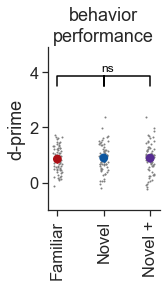

In [223]:
metric = 'dprime_trial_corrected'

stats = full_session_behavior_stats_stim.copy()
stats = stats[stats.behavior_session_id.isin(platform_expts.behavior_session_id.values)]
print(len(stats.behavior_session_id.unique()))

ppf.plot_behavior_metric_by_experience(stats, metric, title='behavior\nperformance', ylabel='d-prime', ylims=[-1, 3.5],
                                       best_image=False, show_containers=False,
                                       save_dir=save_dir, folder=folder, suffix=suffix+'_stimulus_based_all_stim')

# # for each cell type
# for cell_type in cell_types: 
#     ppf.plot_behavior_metric_by_experience(stats[stats.cell_type==cell_type], metric, title=cell_type, 
#                                                  ylabel='d-prime', ylims=[-1, 3.5],
#                                        best_image=True, show_containers=False,
#                                        save_dir=save_dir, folder=folder, suffix=suffix+'_stimulus_based_all_stim_'+cell_type)

### one mouse performance over time

In [261]:
# stats = engaged_behavior_stats.copy()
# color_map = utils.get_stimulus_color_map(as_rgb=False)

# metrics = ['dprime_trial_corrected', 'dprime_non_trial_corrected', 'hit_rate', 'fa_rate', 'response_latency_mean', 'response_latency_std']

# for metric in metrics: 
#     for i, mouse_id in enumerate(stats.mouse_id.unique()):
#         data = stats[stats.mouse_id==mouse_id].sort_values(by='date_of_acquisition')
#         colors = [color_map[stimulus] for stimulus in data.stimulus.unique()]

#         figsize = (10,3)
#         fig, ax = plt.subplots(figsize=figsize)
#         ax = sns.pointplot(data=data, x='date_of_acquisition', y=metric, hue='stimulus', 
#                            hue_order=data.stimulus.unique(), join=False, palette=colors, ax=ax)
#         ax.legend(bbox_to_anchor=(1,1), fontsize='x-small')
#         ax.set_xticklabels(data.stimulus.values, rotation=90);
#         ax.set_title(str(mouse_id)+'-'+str(i))
#         utils.save_figure(fig, figsize, save_dir, 'behavior_performance_over_time_'+method, 
#                           metric+'_mouse_id_'+str(mouse_id), formats=['.png'])

In [262]:
# stats = engaged_behavior_stats.copy()

# data = stats[stats.mouse_id==mouse_id].sort_values(by='date_of_acquisition')
# colors = [color_map[stimulus] for stimulus in data.stimulus.unique()]

# figsize = (10,3)
# fig, ax = plt.subplots(figsize=figsize)
# ax = sns.pointplot(data=data, x='date_of_acquisition', y=metric, hue='stimulus', 
#                    hue_order=data.stimulus.unique(), join=False, palette=colors, ax=ax)
# ax.legend(bbox_to_anchor=(1,1), fontsize='x-small')
# ax.set_xticklabels(np.asarray(0, len(data.stimulus.values), 1), rotation=90);
# ax.set_title(str(mouse_id)+'-'+str(i))

## per behavior stage stats

In [224]:
# fraction time engaged

# data = full_session_behavior_stats.copy()
metric = 'fraction_engaged'

# remove passive sessions
# data = data[data.behavior_stage.str.contains('passive')==False]

behavior_stages = data.behavior_stage.unique()
color_map = get_behavior_stage_color_map(as_rgb=True)
colors = [list(color_map[behavior_stage]) for behavior_stage in behavior_stages]
colors = [[c/255. for c in color] for color in colors]

figsize=(7,3)
fig, ax = plt.subplots(figsize=figsize)
# for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
#     ct_data = data[data.cell_type==cell_type]
ax = sns.boxplot(data=data, x='cell_type', y=metric, width=0.8, 
                    hue='behavior_stage', hue_order=behavior_stages, palette=colors, ax=ax)
ax.set_xlabel('')
ax.set_ylabel(metric)
#     ax[i].set_xticklabels(behavior_stages, rotation=90)
#     ax[i].set_title(cell_type)
ax.legend().remove()
ax.legend(bbox_to_anchor=(1,1), fontsize='x-small')

fig.subplots_adjust(hspace=0.3)

NameError: name 'full_session_behavior_stats' is not defined

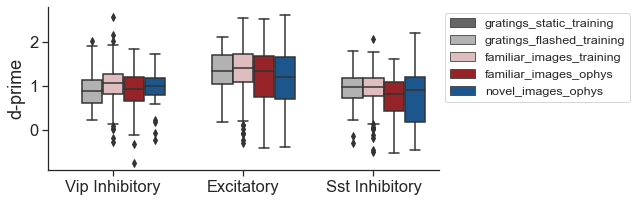

In [341]:
# engaged only, average of all images

data = engaged_behavior_stats.copy()
metric = 'dprime_trial_corrected'

# remove passive sessions
data = data[data.behavior_stage.str.contains('passive')==False]

behavior_stages = data.behavior_stage.unique()
color_map = get_behavior_stage_color_map(as_rgb=True)
colors = [list(color_map[behavior_stage]) for behavior_stage in behavior_stages]
colors = [[c/255. for c in color] for color in colors]

figsize=(7,3)
fig, ax = plt.subplots(figsize=figsize)
# for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
#     ct_data = data[data.cell_type==cell_type]
ax = sns.boxplot(data=data, x='cell_type', y=metric, width=0.8, 
                    hue='behavior_stage', hue_order=behavior_stages, palette=colors, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('d-prime')
#     ax[i].set_xticklabels(behavior_stages, rotation=90)
#     ax[i].set_title(cell_type)
ax.legend().remove()
ax.legend(bbox_to_anchor=(1,1), fontsize='x-small')

fig.subplots_adjust(hspace=0.3)

In [301]:
engaged_behavior_stats.keys()

Index(['behavior_session_id', 'response_latency_count',
       'response_latency_mean', 'response_latency_std', 'response_latency_min',
       'response_latency_25%', 'response_latency_50%', 'response_latency_75%',
       'response_latency_max', 'hit_rate', 'fa_rate',
       'number_of_engaged_go_trials', 'number_of_engaged_hits',
       'number_of_engaged_catch_trials', 'number_of_engaged_false_alarms',
       'fraction_engaged', 'dprime_trial_corrected',
       'dprime_non_trial_corrected', 'equipment_name', 'full_genotype',
       'mouse_id', 'reporter_line', 'driver_line', 'sex', 'age_in_days',
       'cre_line', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'ophys_session_id',
       'ophys_experiment_id', 'ophys_container_id', 'date_of_acquisition',
       'session_type', 'file_id', 'project_code', 'passive', 'cell_type',
       'experience_level', 'training_stage', 'first_day_of_sta

In [ ]:
# engaged only, average of all images

data = engaged_behavior_stats.copy()
metric = 'hit_rate'

# remove passive sessions
data = data[data.behavior_stage.str.contains('passive')==False]

behavior_stages = data.behavior_stage.unique()
color_map = get_behavior_stage_color_map(as_rgb=True)
colors = [list(color_map[behavior_stage]) for behavior_stage in behavior_stages]
colors = [[c/255. for c in color] for color in colors]

figsize=(7,3)
fig, ax = plt.subplots(figsize=figsize)
# for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
#     ct_data = data[data.cell_type==cell_type]
ax = sns.boxplot(data=data, x='cell_type', y=metric, width=0.8, 
                    hue='behavior_stage', hue_order=behavior_stages, palette=colors, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('hit rate')
#     ax[i].set_xticklabels(behavior_stages, rotation=90)
#     ax[i].set_title(cell_type)
ax.legend().remove()
ax.legend(bbox_to_anchor=(1,1), fontsize='x-small')

fig.subplots_adjust(hspace=0.3)

In [ ]:
# engaged only, average of all images

data = engaged_behavior_stats.copy()
metric = 'fa_rate'

# remove passive sessions
data = data[data.behavior_stage.str.contains('passive')==False]

behavior_stages = data.behavior_stage.unique()
color_map = get_behavior_stage_color_map(as_rgb=True)
colors = [list(color_map[behavior_stage]) for behavior_stage in behavior_stages]
colors = [[c/255. for c in color] for color in colors]

figsize=(7,3)
fig, ax = plt.subplots(figsize=figsize)
# for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
#     ct_data = data[data.cell_type==cell_type]
ax = sns.boxplot(data=data, x='cell_type', y=metric, width=0.8, 
                    hue='behavior_stage', hue_order=behavior_stages, palette=colors, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('false alarm rate')
#     ax[i].set_xticklabels(behavior_stages, rotation=90)
#     ax[i].set_title(cell_type)
ax.legend().remove()
ax.legend(bbox_to_anchor=(1,1), fontsize='x-small')

fig.subplots_adjust(hspace=0.3)

## entire session stats

### dprime best image

In [ ]:
stats = each_image_behavior_stats.copy()
stats = stats[stats.behavior_session_id.isin(platform_expts.behavior_session_id.values)]
print(len(stats.behavior_session_id.unique()))

200


(-0.5, 4.8999999999999995)

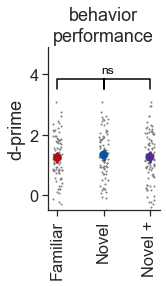

In [368]:
metric = 'dprime_trial_corrected'
ylims = [-0.5, 3.5]

tmp = stats.copy()
tmp = tmp[tmp.image_name!='omitted']

# sort images by metric value within each experience level
tmp = tmp.groupby(['experience_level', 'image_name']).mean()[[metric]].sort_values(by=['experience_level', metric])

best_familiar = tmp.loc['Familiar'].index.values[-2:]
best_novel = tmp.loc['Novel 1'].index.values[-2:]
best_novel_plus = tmp.loc['Novel >1'].index.values[-2:]

# get data for images with highest metric value
familiar_stats = stats[(stats.experience_level=='Familiar')&(stats.image_name.isin(best_familiar))]
novel_stats = stats[(stats.experience_level=='Novel 1')&(stats.image_name.isin(best_novel))]
novel_plus_stats = stats[(stats.experience_level=='Novel >1')&(stats.image_name.isin(best_novel_plus))]

df = pd.concat([familiar_stats, novel_stats, novel_plus_stats])

data = df.copy()

colors = utils.get_experience_level_colors()
experience_levels = utils.get_experience_levels()

if ylims is None:
    ymin = 0
    ymax = None
else:
    ymin = ylims[0]
    ymax = ylims[1]
    
figsize=(2,3)
fig, ax = plt.subplots(1,1, figsize=figsize)
ax = sns.stripplot(data=data, x='experience_level', y=metric, order=experience_levels, 
                      orient='v', color='gray', dodge=True, jitter=0.1, size=2, ax=ax, zorder=0)
ax = sns.pointplot(data=data, x='experience_level', y=metric, order=experience_levels, 
                      orient='v', palette=colors, scale=1, ax=ax)
ax.set_xticklabels(new_experience_levels, rotation=90)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('behavior\nperformance')
ax.set_ylabel('d-prime')

# add stats to plot if only looking at experience levels
# stats dataframe to save
tukey = pd.DataFrame()
ax, tukey_table = ppf.add_experience_level_stats(df, metric, 'white', ax, ymax=ymax)
# aggregate stats
tukey_table['metric'] = metric
tukey = pd.concat([tukey, tukey_table])

ax.set_ylim(ymin=ymin)
# ax.set_xlim(-0.5, len(order) - 0.5)
        
# ax.legend(bbox_to_anchor=(1,1), fontsize='xx-small')
# fig.suptitle('Cohort 2', x=0.52, y=1.1)
# utils.save_figure(fig, figsize, save_dir, 'behavior_metrics', 'd_prime_exp_levels_best_images')
# utils.save_figure(fig, figsize, save_dir, folder, filename)
stats_filename = event_type + '_' + metric + '_stats' + suffix + '.csv'

try:
    print('saving_stats')
    tukey.to_csv(os.path.join(save_dir, folder, stats_filename))
except BaseException:
    print('STATS DID NOT SAVE FOR', metric, hue)

saving_stats


NameError: name 'hue' is not defined

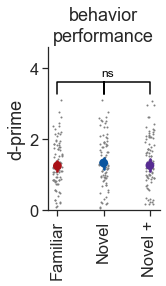

In [372]:
metric = 'dprime_trial_corrected'

tmp = stats.copy()
tmp = tmp[tmp.image_name!='omitted']

ppf.plot_behavior_metric_by_experience(tmp, metric, title='behavior\nperformance', ylabel='d-prime', ylims=None,
                                       best_image=True, show_containers=False,
                                       save_dir=None, folder=None, suffix=suffix)

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


Text(0, 0.5, 'd-prime')

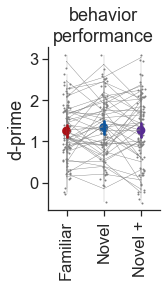

In [63]:
metric = 'dprime_trial_corrected'

tmp = stats.copy()
# tmp = tmp[tmp.project_code.isin(['VisualBehavior', 'VisualBehaviorMultiscope'])]
tmp = tmp[tmp.image_name!='omitted']

tmp = tmp.groupby(['experience_level', 'image_name']).mean()[[metric]].sort_values(by=['experience_level', metric])

best_familiar = tmp.loc['Familiar'].index.values[-2:]
best_novel = tmp.loc['Novel 1'].index.values[-2:]
best_novel_plus = tmp.loc['Novel >1'].index.values[-2:]


familiar_stats = stats[(stats.experience_level=='Familiar')&(stats.image_name.isin(best_familiar))]
novel_stats = stats[(stats.experience_level=='Novel 1')&(stats.image_name.isin(best_novel))]
novel_plus_stats = stats[(stats.experience_level=='Novel >1')&(stats.image_name.isin(best_novel_plus))]

df = pd.concat([familiar_stats, novel_stats, novel_plus_stats])

data = df.copy()

colors = utils.get_experience_level_colors()
experience_levels = utils.get_experience_levels()

figsize=(2,3)
fig, ax = plt.subplots(1,1, figsize=figsize)
ax = sns.stripplot(data=data, x='experience_level', y=metric, order=experience_levels, 
                      orient='v', color='gray', dodge=True, jitter=0.1, size=2, ax=ax, zorder=0)
for ophys_container_id in data.ophys_container_id.unique():
    ax = sns.pointplot(data=data[data.ophys_container_id==ophys_container_id], x='experience_level', y=metric, 
                                 order=experience_levels, join=True, orient='v', color='gray', 
                                 markers='.', scale=0.15, errwidth=0.25, ax=ax)

ax = sns.pointplot(data=data, x='experience_level', y=metric, order=experience_levels, 
                      orient='v', palette=colors, scale=1, ax=ax)

ax.set_xticklabels(new_experience_levels, rotation=90)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('behavior\nperformance')
ax.set_ylabel('d-prime')
# ax.legend(bbox_to_anchor=(1,1), fontsize='xx-small')
# fig.suptitle('Cohort 2', x=0.52, y=1.1)
# utils.save_figure(fig, figsize, save_dir, 'behavior_metrics', 'd_prime_exp_levels_best_images')

In [339]:
def plot_behavior_metric_by_experience(stats, metric, title='', ylabel='', best_image=True, show_containers=False, save_dir=None, folder=None, suffix=''):
    """
    plots average metric value across experience levels, using experience level colors for average, gray for individual points.
    
    stats should be a table of behavior metric values loaded using vba.utilities.get_behavior_stats_for_sessions()
    metric is a column of the stats table

    if stats table has a unique row for each image_name in each behavior session, all images will be included in the average,
    unless best_image = True
    if stats table does not have unique images, setting best_image to True will cause an error, as there are no images to filter
    
    if best_image = True, will sort images by metric value within each experience level and select the top 2 images to plot
    if show_containers = True, will plot a linked gray line for each individual container within the dataset
    """
    experience_levels = utils.get_experience_levels()
    new_experience_levels = utils.get_new_experience_levels()
    cre_lines = utils.get_cre_lines()
    cell_types = utils.get_cell_types()
    colors = utils.get_experience_level_colors()
    if title == 'Cohort 2':
        c = utils.get_experience_level_colors()
        colors = [c[1], c[0], c[2]]
        print('adjusting colors for cohort 2')

    
    if best_image:
        tmp = stats.copy()
        tmp = tmp[tmp.image_name!='omitted']

        # sort images by metric value within each experience level
        tmp = tmp.groupby(['experience_level', 'image_name']).mean()[[metric]].sort_values(by=['experience_level', metric])

        best_familiar = tmp.loc['Familiar'].index.values[-2:]
        best_novel = tmp.loc['Novel 1'].index.values[-2:]
        best_novel_plus = tmp.loc['Novel >1'].index.values[-2:]

        # get data for images with highest metric value
        familiar_stats = stats[(stats.experience_level=='Familiar')&(stats.image_name.isin(best_familiar))]
        novel_stats = stats[(stats.experience_level=='Novel 1')&(stats.image_name.isin(best_novel))]
        novel_plus_stats = stats[(stats.experience_level=='Novel >1')&(stats.image_name.isin(best_novel_plus))]

        df = pd.concat([familiar_stats, novel_stats, novel_plus_stats])

        data = df.copy()
        
    else:
        data = stats.copy()


    figsize=(2,3)
    fig, ax = plt.subplots(1,1, figsize=figsize)
    ax = sns.stripplot(data=data, x='experience_level', y=metric, order=experience_levels, 
                          orient='v', color='gray', dodge=True, jitter=0.1, size=2, ax=ax, zorder=0)
    if show_containers:
        for ophys_container_id in data.ophys_container_id.unique():
            ax = sns.pointplot(data=data[data.ophys_container_id==ophys_container_id], x='experience_level', y=metric, 
                                         order=experience_levels, join=True, orient='v', color='gray', 
                                         markers='.', scale=0.15, errwidth=0.25, ax=ax)

    ax = sns.pointplot(data=data, x='experience_level', y=metric, order=experience_levels, 
                          orient='v', palette=colors, ax=ax)
    ax.set_xticklabels(new_experience_levels, rotation=90)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    # ax.legend(bbox_to_anchor=(1,1), fontsize='xx-small')
    # fig.suptitle('Cohort 2', x=0.52, y=1.1)
    utils.save_figure(fig, figsize, save_dir, folder, metric+'_platform_expts_exp_level'+suffix)

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


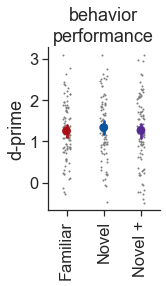

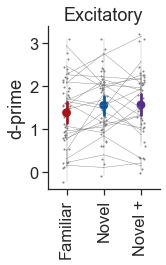

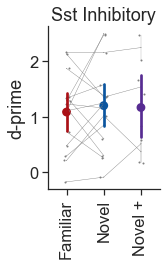

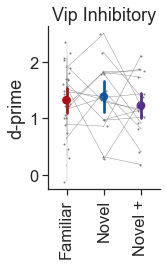

In [72]:
metric = 'dprime_trial_corrected'
title = 'behavior\nperformance'
ylabel = 'd-prime'

ppf.plot_behavior_metric_by_experience(stats, metric, title=title, ylabel=ylabel, 
                          save_dir=save_dir, folder='behavior_metrics', suffix='_all_cre')

for cell_type in cell_types:
    plot_behavior_metric_by_experience(stats[stats.cell_type==cell_type], metric, title=cell_type, ylabel=ylabel, 
                          show_containers=True, save_dir=save_dir, folder='behavior_metrics', suffix='_'+cell_type.split(' ')[0])

adjusting colors for cohort 2


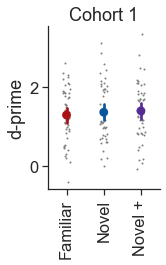

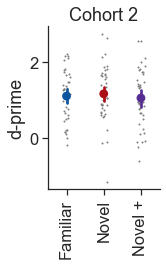

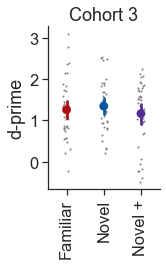

In [340]:
# d prime by project code
metric = 'dprime_trial_corrected'
title = 'behavior\nperformance'
ylabel = 'd-prime'
    
project_code = 'VisualBehavior'
title = 'Cohort 1'
plot_behavior_metric_by_experience(stats[stats.project_code==project_code], metric, title=title, ylabel=ylabel, 
                          show_containers=False, save_dir=save_dir, folder='behavior_metrics', suffix='_'+project_code)

project_code = 'VisualBehaviorTask1B'
title = 'Cohort 2'
plot_behavior_metric_by_experience(stats[stats.project_code==project_code], metric, title=title, ylabel=ylabel, 
                          show_containers=False, save_dir=save_dir, folder='behavior_metrics', suffix='_'+project_code)

project_code = 'VisualBehaviorMultiscope'
title = 'Cohort 3'
plot_behavior_metric_by_experience(stats[stats.project_code==project_code], metric, title=title, ylabel=ylabel, 
                          show_containers=False, save_dir=save_dir, folder='behavior_metrics', suffix='_'+project_code)

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


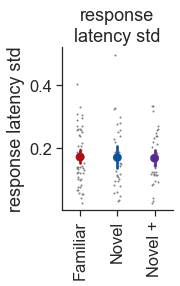

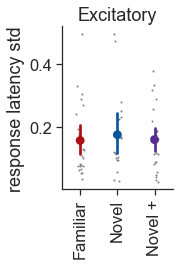

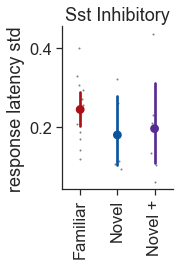

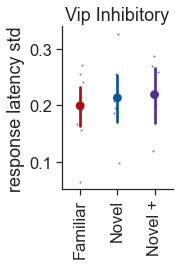

In [73]:
metric = 'response_latency_std'
title = 'response\nlatency std'
ylabel = 'response latency std'

plot_behavior_metric_by_experience(stats, metric, title=title, ylabel=ylabel, 
                          save_dir=save_dir, folder='behavior_metrics', suffix='_all_cre')

for cell_type in cell_types:
    plot_behavior_metric_by_experience(stats[stats.cell_type==cell_type], metric, title=cell_type, ylabel=ylabel, 
                          save_dir=save_dir, folder='behavior_metrics', suffix='_'+cell_type.split(' ')[0])

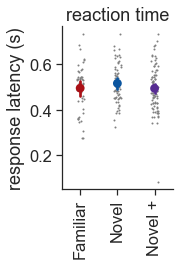

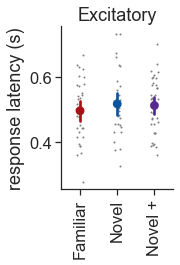

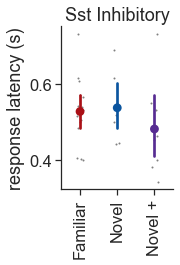

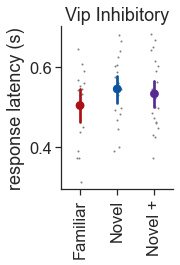

In [76]:
metric = 'response_latency_mean'
title = 'reaction time'
ylabel = 'response latency (s)'

plot_behavior_metric_by_experience(stats, metric, title=title, ylabel=ylabel, 
                          save_dir=save_dir, folder='behavior_metrics', suffix='_all_cre')

# for cell_type in cell_types:
#     plot_behavior_metric_by_experience(stats[stats.cell_type==cell_type], metric, title=cell_type, ylabel=ylabel, 
#                           save_dir=save_dir, folder='behavior_metrics', suffix='_'+cell_type.split(' ')[0])

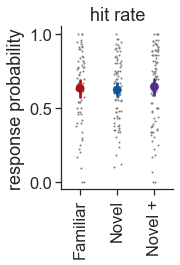

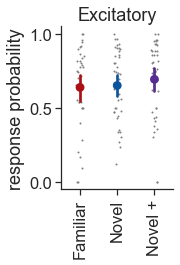

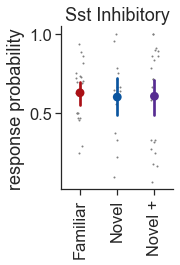

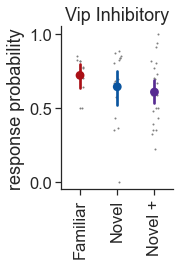

In [77]:
metric = 'hit_rate'
title = 'hit rate'
ylabel = 'response probability'

plot_behavior_metric_by_experience(stats, metric, title=title, ylabel=ylabel, 
                          save_dir=save_dir, folder='behavior_metrics', suffix='_all_cre')

for cell_type in cell_types:
    plot_behavior_metric_by_experience(stats[stats.cell_type==cell_type], metric, title=cell_type, ylabel=ylabel, 
                          save_dir=save_dir, folder='behavior_metrics', suffix='_'+cell_type.split(' ')[0])

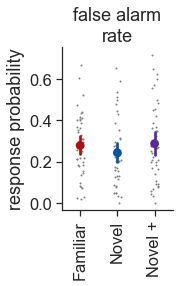

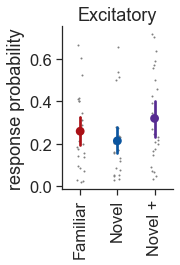

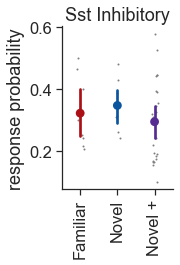

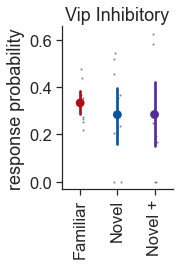

In [75]:
metric = 'fa_rate'
title = 'false alarm\nrate'
ylabel = 'response probability'

plot_behavior_metric_by_experience(stats, metric, title=title, ylabel=ylabel, 
                          save_dir=save_dir, folder='behavior_metrics', suffix='_all_cre')

for cell_type in cell_types:
    plot_behavior_metric_by_experience(stats[stats.cell_type==cell_type], metric, title=cell_type, ylabel=ylabel, 
                          save_dir=save_dir, folder='behavior_metrics', suffix='_'+cell_type.split(' ')[0])

### plot number of sessions per stage

In [13]:
ab_stages = ['gratings_static_training', 'gratings_flashed_training', 
             'images_A_training', 'images_A_habituation_ophys', 
             'images_A_ophys','images_A_passive_ophys', 'images_B_ophys',
             'images_B_passive_ophys']

ba_stages = ['gratings_static_training', 'gratings_flashed_training', 
             'images_B_training', 'images_B_habituation_ophys', 'images_B_ophys',
             'images_B_passive_ophys', 'images_A_ophys', 'images_A_passive_ophys']

In [14]:
ab_mice = behavior_sessions[behavior_sessions.project_code.isin(['VisualBehaviorMultiscope', 'VisualBehavior'])].mouse_id.unique()
ba_mice = behavior_sessions[behavior_sessions.project_code.isin(['VisualBehaviorTask1B'])].mouse_id.unique()

In [15]:
days_in_stage = behavior_sessions.groupby(['mouse_id', 'stimulus_phase']).count().rename(columns={'equipment_name':'days_in_stage'})[['days_in_stage']]
days_in_stage = days_in_stage.reset_index()
days_in_stage = days_in_stage.merge(behavior_sessions[['mouse_id', 'cell_type', 'project_code']], on='mouse_id')
days_in_stage

mouse_id             stimulus_phase  days_in_stage       cell_type  \
0        403491  gratings_flashed_training              2      Excitatory   
1        403491  gratings_flashed_training              2      Excitatory   
2        403491  gratings_flashed_training              2      Excitatory   
3        403491  gratings_flashed_training              2      Excitatory   
4        403491  gratings_flashed_training              2      Excitatory   
...         ...                        ...            ...             ...   
29273    549976     images_B_passive_ophys              1  Sst Inhibitory   
29274    549976     images_B_passive_ophys              1  Sst Inhibitory   
29275    549976     images_B_passive_ophys              1  Sst Inhibitory   
29276    549976     images_B_passive_ophys              1  Sst Inhibitory   
29277    549976     images_B_passive_ophys              1  Sst Inhibitory   

         project_code  
0      VisualBehavior  
1      VisualBehavior  
2      VisualBehavior  
3      VisualBehavior  
4      VisualBehavior  
...               ...  
29273  VisualBehavior  
29274  VisualBehavior  
29275  VisualBehavior  
29276  VisualBehavior  
29277  VisualBehavior  

[29278 rows x 5 columns]

#### legends

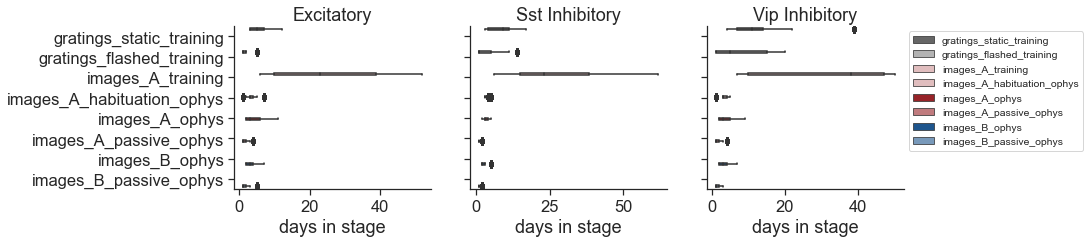

In [16]:
data = days_in_stage[days_in_stage.mouse_id.isin(ab_mice)].copy()
color_map = utils.get_stimulus_phase_color_map(as_rgb=False)
colors = [list(color_map[ab_stage]) for ab_stage in ab_stages]

figsize=(12, 3)
fig, ax = plt.subplots(1,3, figsize=figsize, sharey=True)
for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.boxplot(data=ct_data, y='stimulus_phase', x='days_in_stage', order=ab_stages,
                        hue='stimulus_phase', hue_order=ab_stages, palette=colors, orient='h', ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('days in stage')
    ax[i].set_title(cell_type)
    ax[i].legend().remove()
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small')

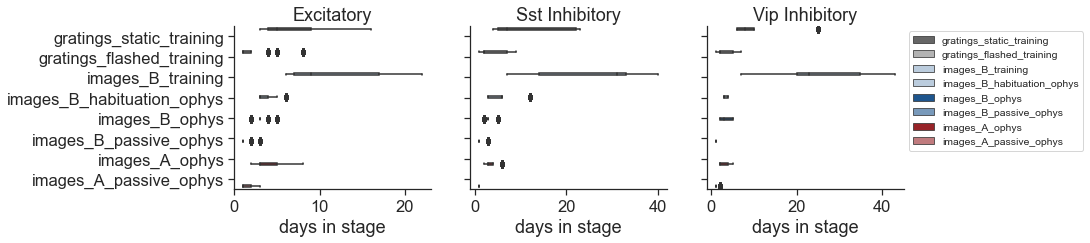

In [17]:
data = days_in_stage[days_in_stage.mouse_id.isin(ba_mice)].copy()
color_map = utils.get_stimulus_phase_color_map(as_rgb=False)
colors = [list(color_map[stage]) for stage in ba_stages]

figsize=(12, 3)
fig, ax = plt.subplots(1,3, figsize=figsize, sharey=True)
for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.boxplot(data=ct_data, y='stimulus_phase', x='days_in_stage', order=ba_stages,
                        hue='stimulus_phase', hue_order=ba_stages, palette=colors, orient='h', ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('days in stage')
    ax[i].set_title(cell_type)
    ax[i].legend().remove()
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small')

#### plots

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


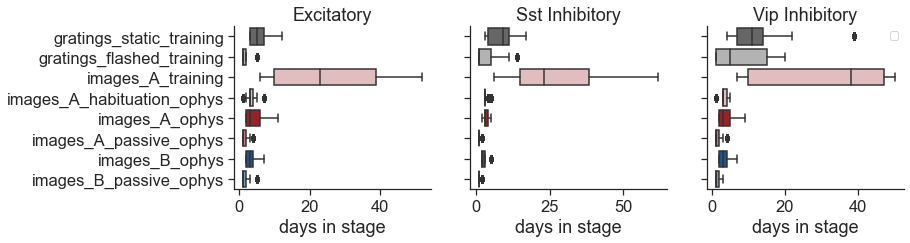

In [18]:
data = days_in_stage[days_in_stage.mouse_id.isin(ab_mice)].copy()
color_map = utils.get_stimulus_phase_color_map(as_rgb=False)
colors = [list(color_map[ab_stage]) for ab_stage in ab_stages]

figsize=(12, 3)
fig, ax = plt.subplots(1,3, figsize=figsize, sharey=True)
for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.boxplot(data=ct_data, y='stimulus_phase', x='days_in_stage', order=ab_stages,
                        palette=colors, orient='h', ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('days in stage')
    ax[i].set_title(cell_type)
    ax[i].legend().remove()
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small')

#### vertical

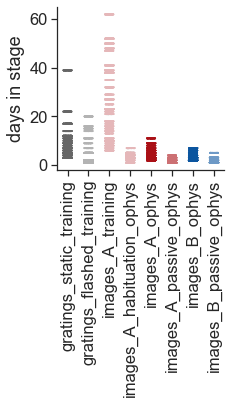

In [21]:
data = days_in_stage[days_in_stage.mouse_id.isin(ab_mice)].copy()
color_map = utils.get_stimulus_phase_color_map(as_rgb=False)
colors = [list(color_map[ab_stage]) for ab_stage in ab_stages]

figsize=(3,3)
fig, ax = plt.subplots(figsize=figsize)
# for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
ct_data = data.copy()
#     for mouse in ct_data.mouse_id.unique():
#         ax[i] = sns.pointplot(data=ct_data, y='stimulus_phase', x='days_in_stage', order=ab_stages, orient='h', palette=colors, ax=ax[i])
ax = sns.stripplot(data=ct_data, x='stimulus_phase', y='days_in_stage', order=ab_stages, 
                      orient='v', palette=colors, dodge=True, jitter=0.2, size=2, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('days in stage')
# ax.set_title(cell_type)
ax.set_xticklabels(ab_stages, rotation=90)
plt.subplots_adjust(hspace=0.2)
# ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small')

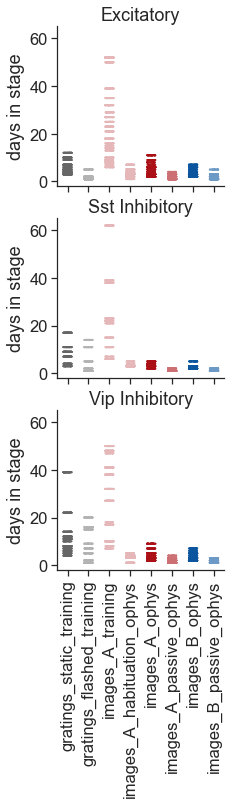

In [19]:
data = days_in_stage[days_in_stage.mouse_id.isin(ab_mice)].copy()
color_map = utils.get_stimulus_phase_color_map(as_rgb=False)
colors = [list(color_map[ab_stage]) for ab_stage in ab_stages]

figsize=(3,10)
fig, ax = plt.subplots(3,1, figsize=figsize, sharey=True, sharex=True)
for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
    ct_data = data[data.cell_type==cell_type]
#     for mouse in ct_data.mouse_id.unique():
#         ax[i] = sns.pointplot(data=ct_data, y='stimulus_phase', x='days_in_stage', order=ab_stages, orient='h', palette=colors, ax=ax[i])
    ax[i] = sns.stripplot(data=ct_data, x='stimulus_phase', y='days_in_stage', order=ab_stages, 
                          orient='v', palette=colors, dodge=True, jitter=0.2, size=2, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('days in stage')
    ax[i].set_title(cell_type)
ax[i].set_xticklabels(ab_stages, rotation=90)
plt.subplots_adjust(hspace=0.2)
# ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small')

#### horizontal

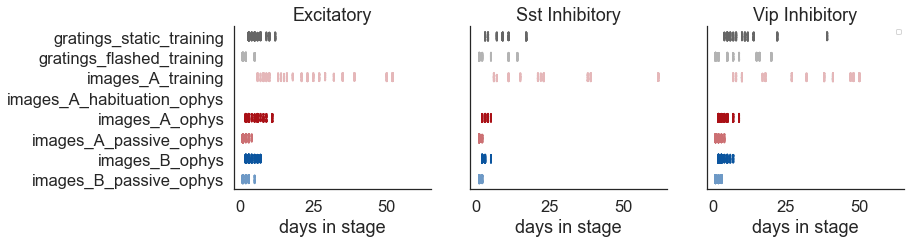

In [715]:
data = days_in_stage[days_in_stage.mouse_id.isin(ab_mice)].copy()
data = data[data.stimulus_phase!='images_A_habituation_ophys']
color_map = utils.get_stimulus_phase_color_map(as_rgb=False)
colors = [list(color_map[stage]) for stage in ab_stages]

figsize=(12,3)
fig, ax = plt.subplots(1,3, figsize=figsize, sharey=True, sharex=True)
for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
    ct_data = data[data.cell_type==cell_type]
#     for mouse in ct_data.mouse_id.unique():
#         ax[i] = sns.pointplot(data=ct_data, y='stimulus_phase', x='days_in_stage', order=ab_stages, orient='h', palette=colors, ax=ax[i])
    ax[i] = sns.stripplot(data=ct_data, y='stimulus_phase', x='days_in_stage', order=ab_stages, 
                          orient='h', palette=colors, dodge=True, jitter=0.2, size=2, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('days in stage')
    ax[i].set_title(cell_type)
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small')

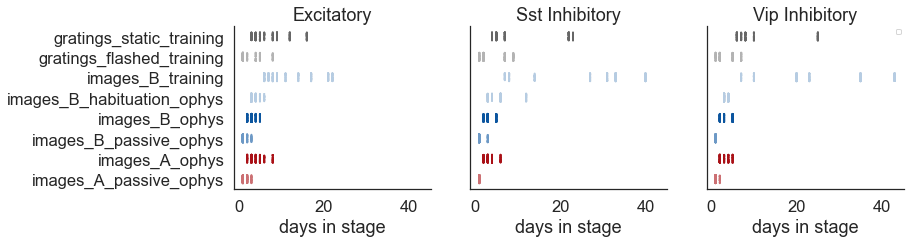

In [716]:
data = days_in_stage[days_in_stage.mouse_id.isin(ba_mice)].copy()
data = data[data.stimulus_phase!='images_A_habituation_ophys']
color_map = utils.get_stimulus_phase_color_map(as_rgb=False)
colors = [list(color_map[stage]) for stage in ba_stages]

figsize=(12,3)
fig, ax = plt.subplots(1,3, figsize=figsize, sharey=True, sharex=True)
for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
    ct_data = data[data.cell_type==cell_type]
#     for mouse in ct_data.mouse_id.unique():
#         ax[i] = sns.pointplot(data=ct_data, y='stimulus_phase', x='days_in_stage', order=ab_stages, orient='h', palette=colors, ax=ax[i])
    ax[i] = sns.stripplot(data=ct_data, y='stimulus_phase', x='days_in_stage', order=ba_stages, 
                          orient='h', palette=colors, dodge=True, jitter=0.2, size=2, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('days in stage')
    ax[i].set_title(cell_type)
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small')

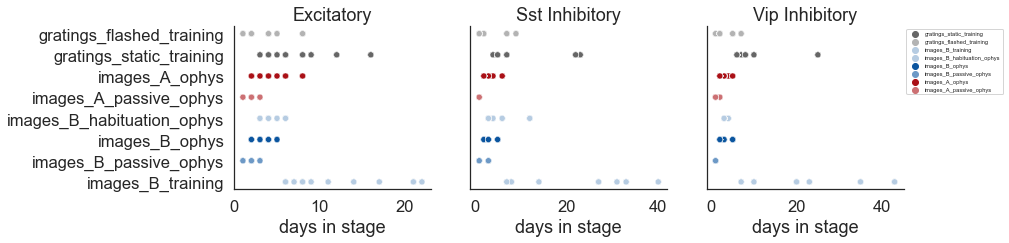

In [717]:
data = days_in_stage[days_in_stage.mouse_id.isin(ba_mice)].copy()
data = data[data.stimulus_phase!='images_A_habituation_ophys']

color_map = utils.get_stimulus_phase_color_map(as_rgb=False)
colors = [list(color_map[stage]) for stage in ba_stages]

figsize=(12,3)
fig, ax = plt.subplots(1,3, figsize=figsize, sharey=True)
for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
    ct_data = data[data.cell_type==cell_type]
#     for mouse in ct_data.mouse_id.unique():
#         ax[i] = sns.pointplot(data=ct_data, y='stimulus_phase', x='days_in_stage', order=ab_stages, orient='h', palette=colors, ax=ax[i])
    ax[i] = sns.scatterplot(data=ct_data, y='stimulus_phase', x='days_in_stage', 
                          hue='stimulus_phase', hue_order=ba_stages, palette=colors, ax=ax[i])
    ax[i].set_yticks(ba_stages)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('days in stage')
    ax[i].set_title(cell_type)
    ax[i].legend().remove()
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small')

### familiar and novel images for reversal controls 

In [302]:
colors = utils.get_experience_level_colors()

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))


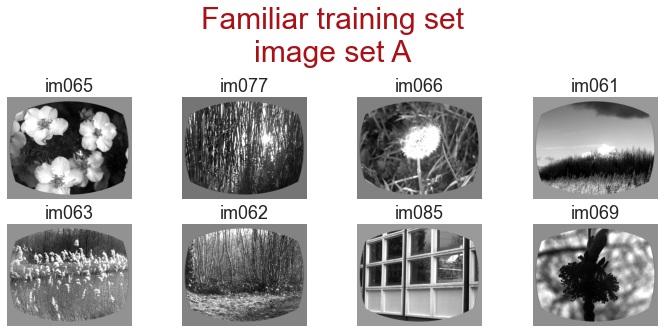

In [317]:
# for A/B

# familiar 
familiar_experiment_id = platform_expts[(platform_expts.project_code=='VisualBehavior')&(platform_expts.experience_level=='Familiar')].index.values[0]
dataset = loading.get_ophys_dataset(familiar_experiment_id)

stimulus_templates = dataset.stimulus_templates.copy()

fig, ax = plt.subplots(2,4,figsize=(10,5))
ax=ax.ravel()
for i,image_name in enumerate(stimulus_templates.index):
    image = stimulus_templates.loc[image_name]['unwarped'].copy()
    image[np.isnan(image)] = 150
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(image_name,)
    ax[i].set_xlim(350, 1575)
    ax[i].set_ylim(100, 1100)
    ax[i].invert_yaxis()
    ax[i].axis('off')
    
# fig.suptitle('Familiar Training Set\nimage set A', color=colors[0])
fig.suptitle('Familiar training set\nimage set A', x=0.5, y=0.94,  color=colors[0], fontsize=30)
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.tight_layout()

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\data_objects\eye_tracking\rig_geometry.py:135: UserWarning: This nwb file with identifier '795953296' has no eye tracking rig metadata. (NWB error: "'eye_tracking_rig_metadata' not found in processing of NWBFile 'root'.")
  warnings.warn("This nwb file with identifier "
C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\data_objects\eye_tracking\eye_tracking_table.py:136: UserWarning: This nwb file with identifier '795953296' has no eye tracking data. (NWB error: 'EyeTracking')
  warnings.warn("This nwb file with identifier "


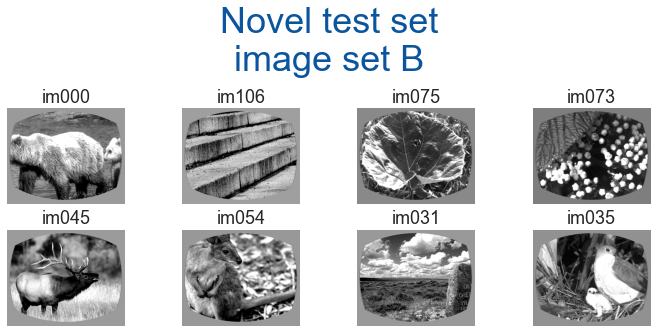

In [316]:
# for A/B

# novel 
novel_experiment_id = platform_expts[(platform_expts.project_code=='VisualBehavior')&(platform_expts.experience_level=='Novel 1')].index.values[0]
dataset = loading.get_ophys_dataset(novel_experiment_id)

stimulus_templates = dataset.stimulus_templates.copy()

fig, ax = plt.subplots(2,4,figsize=(10,5))
ax=ax.ravel()
for i,image_name in enumerate(stimulus_templates.index):
    image = stimulus_templates.loc[image_name]['unwarped'].copy()
    image[np.isnan(image)] = 150
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(image_name,)
    ax[i].set_xlim(350, 1575)
    ax[i].set_ylim(100, 1100)
    ax[i].invert_yaxis()
    ax[i].axis('off')
    
# fig.suptitle('Familiar Training Set\nimage set A', color=colors[0])
fig.suptitle('Novel test set\nimage set B', x=0.5, y=0.94,  color=colors[1], fontsize=36)
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.tight_layout()

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))


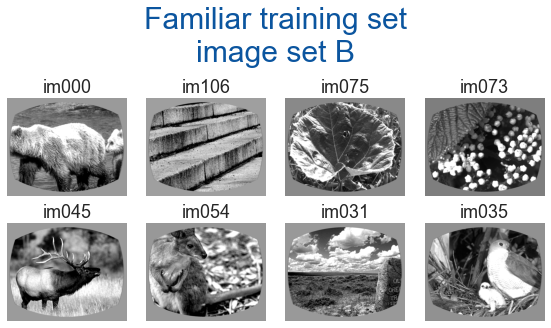

In [327]:
# for B/A

# familiar 
familiar_experiment_id = platform_expts[(platform_expts.project_code=='VisualBehaviorTask1B')&(platform_expts.experience_level=='Familiar')].index.values[0]
dataset = loading.get_ophys_dataset(familiar_experiment_id)

stimulus_templates = dataset.stimulus_templates.copy()

fig, ax = plt.subplots(2,4,figsize=(8,5))
ax=ax.ravel()
for i,image_name in enumerate(stimulus_templates.index):
    image = stimulus_templates.loc[image_name]['unwarped'].copy()
    image[np.isnan(image)] = 150
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(image_name,)
    ax[i].set_xlim(350, 1575)
    ax[i].set_ylim(100, 1100)
    ax[i].invert_yaxis()
    ax[i].axis('off')
    
# fig.suptitle('Familiar Training Set\nimage set A', color=colors[0])
fig.suptitle('Familiar training set\nimage set B', x=0.5, y=0.94,  color=colors[1], fontsize=30)
plt.subplots_adjust(hspace=0.7, wspace=0.2)
fig.tight_layout()

In [ ]:
# for A/B

# novel 
novel_experiment_id = platform_expts[(platform_expts.project_code=='VisualBehaviorTask1B')&(platform_expts.experience_level=='Novel 1')].index.values[0]
dataset = loading.get_ophys_dataset(novel_experiment_id)

stimulus_templates = dataset.stimulus_templates.copy()

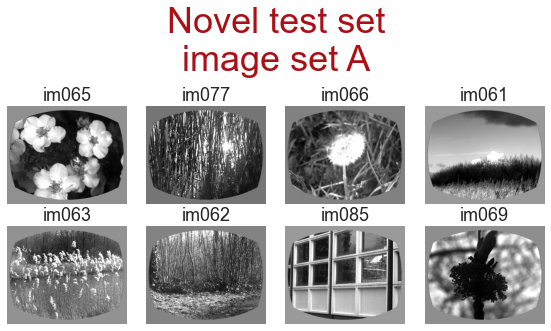

In [326]:
fig, ax = plt.subplots(2,4,figsize=(8,5))
ax=ax.ravel()
for i,image_name in enumerate(stimulus_templates.index):
    image = stimulus_templates.loc[image_name]['unwarped'].copy()
    image[np.isnan(image)] = 150
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(image_name,)
    ax[i].set_xlim(350, 1575)
    ax[i].set_ylim(100, 1100)
    ax[i].invert_yaxis()
    ax[i].axis('off')
    
# fig.suptitle('Familiar Training Set\nimage set A', color=colors[0])
fig.suptitle('Novel test set\nimage set A', x=0.5, y=0.94,  color=colors[0], fontsize=36)
plt.subplots_adjust(hspace=0.7, wspace=0.2)
fig.tight_layout()

## ophys session sequence 

In [718]:
ab_mice = behavior_sessions[behavior_sessions.project_code.isin(['VisualBehaviorMultiscope', 'VisualBehavior'])].mouse_id.unique()
ba_mice = behavior_sessions[behavior_sessions.project_code.isin(['VisualBehaviorTask1B'])].mouse_id.unique()

Categories
* image set A - active
* image set A - passive
* image set A - active, in dataset
<!-- * image set A - failed QC -->
* image set B - active
* image set B - passive
* image set B - active, in dataset
<!-- * image set B - failed QC -->

In [148]:
def add_ophys_stage_to_behavior_sessions(behavior_sessions):
    """
    adds a column 'ophys_stage' that contains the image set for each session, whether or not it was a passive session, 
    and whether or not the session has ophys data that is included in platform paper ophys analysis.
    habituation sessions are excluded 
    ex: 'images_A', 'images_A_passive', 'images_A_in_dataset'
    """
    # get behavior_session_ids that have ophys data in the paper 
    platform_experiments = loading.get_platform_paper_experiment_table(limit_to_closest_active=True)
    print(len(platform_experiments))
    platform_behavior_sessions = platform_experiments.behavior_session_id.unique()

    # make column indicating whether session is represented in the set of ophys experiments that are in the platform paper
    behavior_sessions['in_dataset'] = False
    behavior_sessions.at[platform_behavior_sessions, 'in_dataset'] = True

    # make column with stimulus name appended with 'in_dataset' for the sessions with ophys data in the paper
    behavior_sessions['ophys_stage'] = 'None'
    for behavior_session_id in behavior_sessions.index.values:
        row_data = behavior_sessions.loc[behavior_session_id]
        if ('OPHYS' in row_data.session_type) and ('habituation' not in row_data.session_type): 
            ophys_stage = row_data.stimulus
            if behavior_session_id in platform_behavior_sessions:
                ophys_stage = ophys_stage+'_in_dataset'
            behavior_sessions.at[behavior_session_id, 'ophys_stage'] = ophys_stage
    return behavior_sessions

In [149]:
def get_ophys_stage_color_map(as_rgb=False):
    session_number_colors = utils.get_colors_for_session_numbers()
    session_number_colors_GH = utils.get_colors_for_session_numbers_GH()
    white = np.array([1, 1, 1]).astype(np.uint8)

    passive_scale = 0.7
    active_not_in_dataset_scale = 0.4

    ophys_stage_color_map = {
        
        'images_A_in_dataset': session_number_colors[0],
        'images_A': (session_number_colors[0] + (white-session_number_colors[0]) * active_not_in_dataset_scale),
        'images_A_passive': (session_number_colors[0] + (white-session_number_colors[0]) * passive_scale),
        'images_A_habituation': white,
        
        'images_B_in_dataset': session_number_colors[3],
        'images_B': (session_number_colors[3] + (white-session_number_colors[3]) * active_not_in_dataset_scale),
        'images_B_passive': (session_number_colors[3] + (white-session_number_colors[3]) * passive_scale),
        'images_B_habituation': white,
            
        'images_G_in_dataset': session_number_colors_GH[0],
        'images_G': (session_number_colors_GH[0] + (white-session_number_colors_GH[0]) * active_not_in_dataset_scale),
        'images_G_passive': (session_number_colors_GH[0] + (white-session_number_colors_GH[0]) * passive_scale),
        'images_G_habituation': white,
        
        'images_H_in_dataset': session_number_colors_GH[3],
        'images_H': (session_number_colors_GH[3] + (white-session_number_colors_GH[3]) * active_not_in_dataset_scale),
        'images_H_passive': (session_number_colors_GH[3] + (white-session_number_colors_GH[3]) * passive_scale),
    }

    if as_rgb:
        for key in list(ophys_stage_color_map.keys()):
            ophys_stage_color_map[key] = np.floor(
                np.array([x for x in list(ophys_stage_color_map[key])]) * 255).astype(np.uint8)

    return ophys_stage_color_map

In [721]:
def plot_ophys_history_for_mice(behavior_sessions, color_column='ophys_stage', color_map=sns.color_palette(), ax=None):
    """
    plots the ophys session sequence for all mice in behavior_sessions table, sorted by total # of sessions per mouse
    
    sessions are colored by the provided color_column and color_map
    values of color_column must match keys of color_map
    acceptable pairs for color_column and color_map
    color_column = 'ophys_stage' : color_map = utils.get_ophys_stage_color_map(as_rgb=True)
    color_column = 'stimulus' : color_map = utils.get_stimulus_color_map(as_rgb=True)
    color_column = 'stimulus_phase' : color_map = utils.get_stimulus_phase_color_map(as_rgb=True)
    
    """
    # group by mice and count n_session per mouse to get the max n_sessions and list of mouse_ids to plot
    n_sessions = behavior_sessions.groupby(['mouse_id']).count().rename(columns={'equipment_name':'n_sessions'})[['n_sessions']]
    n_sessions = n_sessions.sort_values(by='n_sessions')
    max_n_sessions = np.amax(n_sessions.n_sessions.values)
    mouse_ids = n_sessions.index.values

    n_mouse_ids = len(mouse_ids)

    # create an array to fill in with session colors per mouse
    img = np.empty((n_mouse_ids, max_n_sessions, 3))
    img[:] = 256 # make the default value of 256 which is white in RGB space

    # create plot with expt colors image
    if ax is None: 
#         figsize = (6/1.5, n_mouse_ids*0.3/1.5)
        figsize = (6, n_mouse_ids*0.3)
        fig, ax = plt.subplots(figsize=figsize)
        
    # loop through mice and create session colors image
    for mouse, mouse_id in enumerate(mouse_ids):
        # sort session in acquisition date order
        sessions = behavior_sessions[behavior_sessions.mouse_id == mouse_id].sort_values('date_of_acquisition')
        # fill in image array with the color from color_map for the corresponding color_col
        for session, session_id in enumerate(sessions.index.values):
            session_data = sessions.loc[session_id]
            color_column_value = session_data[color_column]
            img[mouse, session, :] = color_map[color_column_value]
            if color_column == 'ophys_stage':
                if session_data.has_ophys == False:
                    ax.text(session, mouse, 'X', fontsize=8, ha='center', va='center',)
                if session_data.in_dataset and session_data.experience_level=='Novel >1':
                    ax.text(session, mouse, '+', fontsize=16, ha='center', va='center',) # fontdict={'fontweight':'bold'}) 
                    # if its a Novel >1, change the color to purple
                    img[mouse, session, :] = np.array([x*255 for x in list(utils.get_colors_for_session_numbers_GH()[0])]).astype(np.uint8)
            elif color_column == 'stimulus_phase':
                # if its passive, put a P on it
                if session_data.passive == True:
                    ax.text(session, mouse, 'P', fontsize=8, ha='center', va='center',)
                # if the session doesnt have ophys at all (i.e. failed QC, put an X on it)
                elif session_data.has_ophys == False:
                    ax.text(session, mouse, 'X', fontsize=8, ha='center', va='center',)
                # if its not in the final dataset and its not passive, make the color lighter
                if session_data.in_dataset == False and session_data.passive==False:
                    white = (255, 255, 255)
                    img[mouse, session, :] = (color_map[color_column_value] + (white-color_map[color_column_value]) * 0.7)
                # if the session is in the platform ophys dataset, give it a letter for its experience level 
                if session_data.in_dataset and session_data.experience_level=='Familiar':
                    ax.text(session, mouse, 'F', fontsize=12, ha='center', va='center', fontdict={'fontweight':'bold', 'color':'white'}) 
                elif session_data.in_dataset and session_data.experience_level=='Novel 1':
                    ax.text(session, mouse, 'N', fontsize=12, ha='center', va='center', fontdict={'fontweight':'bold', 'color':'white'}) 
                elif session_data.in_dataset and session_data.experience_level=='Novel >1':
                    ax.text(session, mouse, 'N+', fontsize=12, ha='center', va='center', fontdict={'fontweight':'bold', 'color':'white'}) 
                    # if its a Novel >1, change the color to purple
                    img[mouse, session, :] = np.array([x*255 for x in list(utils.get_colors_for_session_numbers_GH()[0])]).astype(np.uint8)
            
                
    # plot session colors
    ax.imshow(img.astype(int), aspect='auto')
    ax.set_yticks([])
    ax.set_yticklabels('')
    ax.set_xlabel('session number')
#     ax.set_xticks(np.arange(0,13,5))
#     ax.set_xticklabels(np.arange(0,13,5))
#     ax.axis('off')

    for mouse, mouse_id in enumerate(mouse_ids): 
        cre_line = behavior_sessions[behavior_sessions.mouse_id == mouse_id].cre_line.values[0]
        if cre_line == 'Slc17a7-IRES2-Cre': # square
            ax.text(-1, mouse, '\u25a1', fontsize=8, ha='center', va='center',)
        elif cre_line == 'Sst-IRES-Cre': # triangle
            ax.text(-1, mouse, '\u25b2', fontsize=8, ha='center', va='center', color='black')
        elif cre_line == 'Vip-IRES-Cre': # circle
            ax.text(-1, mouse, '\u25cf', fontsize=8, ha='center', va='center', color='black')
            
    return ax

402


<AxesSubplot:xlabel='session number'>

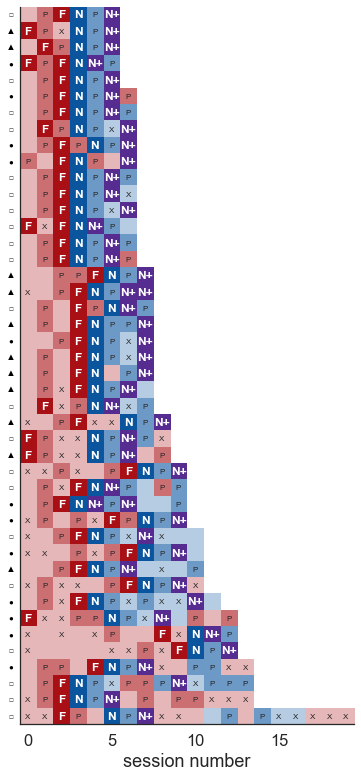

In [722]:
behavior_sessions = add_ophys_stage_to_behavior_sessions(behavior_sessions)

color_column = 'stimulus_phase'
color_map = utils.get_stimulus_phase_color_map(as_rgb=True)

sessions = behavior_sessions[behavior_sessions.mouse_id.isin(ab_mice)]
# exclude non-ophys & habituation sessions, which have ophys_stage = None
sessions = sessions[sessions.ophys_stage!='None']
# exclude mice that are not in platform paper dataset 
platform_experiments = loading.get_platform_paper_experiment_table(limit_to_closest_active=True)
sessions = sessions[sessions.mouse_id.isin(platform_experiments.mouse_id.unique())]

plot_ophys_history_for_mice(sessions, color_column=color_column, color_map=color_map)

402


<AxesSubplot:xlabel='session number'>

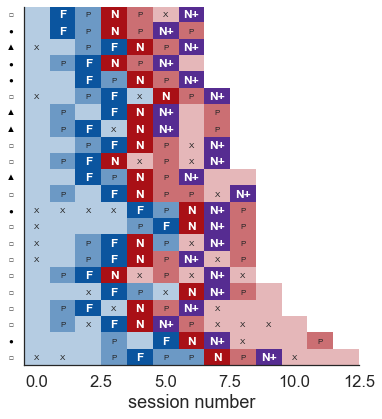

In [723]:
behavior_sessions = add_ophys_stage_to_behavior_sessions(behavior_sessions)

color_column = 'stimulus_phase'
color_map = utils.get_stimulus_phase_color_map(as_rgb=True)

sessions = behavior_sessions[behavior_sessions.mouse_id.isin(ba_mice)]
# exclude non-ophys & habituation sessions, which have ophys_stage = None
sessions = sessions[sessions.ophys_stage!='None']
# exclude mice that are not in platform paper dataset 
platform_experiments = loading.get_platform_paper_experiment_table(limit_to_closest_active=True)
sessions = sessions[sessions.mouse_id.isin(platform_experiments.mouse_id.unique())]

plot_ophys_history_for_mice(sessions, color_column=color_column, color_map=color_map)

In [724]:
# behavior_sessions = add_ophys_stage_to_behavior_sessions(behavior_sessions)

# color_column = 'ophys_stage'
# color_map = get_ophys_stage_color_map(as_rgb=True)

# sessions = behavior_sessions[behavior_sessions.mouse_id.isin(ab_mice)]
# # exclude non-ophys & habituation sessions, which have ophys_stage = None
# sessions = sessions[sessions.ophys_stage!='None']
# plot_ophys_history_for_mice(sessions, color_column=color_column, color_map=color_map)

In [725]:
# behavior_sessions = add_ophys_stage_to_behavior_sessions(behavior_sessions)

# color_column = 'ophys_stage'
# color_map = get_ophys_stage_color_map(as_rgb=True)

# sessions = behavior_sessions[behavior_sessions.mouse_id.isin(ab_mice)]
# # exclude non-ophys & habituation sessions, which have ophys_stage = None
# sessions = sessions[sessions.ophys_stage!='None']
# # exclude mice that are not in platform paper dataset 
# platform_experiments = loading.get_platform_paper_experiment_table(limit_to_closest_active=True)
# sessions = sessions[sessions.mouse_id.isin(platform_experiments.mouse_id.unique())]

# plot_ophys_history_for_mice(sessions, color_column=color_column, color_map=color_map)

In [726]:
# behavior_sessions = add_ophys_stage_to_behavior_sessions(behavior_sessions)

# color_column = 'ophys_stage'
# color_map = get_ophys_stage_color_map(as_rgb=True)

# sessions = behavior_sessions[behavior_sessions.mouse_id.isin(ba_mice)]
# # exclude non-ophys & habituation sessions, which have ophys_stage = None
# sessions = sessions[sessions.ophys_stage!='None']
# # exclude mice that are not in platform paper dataset 
# platform_experiments = loading.get_platform_paper_experiment_table(limit_to_closest_active=True)
# sessions = sessions[sessions.mouse_id.isin(platform_experiments.mouse_id.unique())]

# plot_ophys_history_for_mice(sessions, color_column=color_column, color_map=color_map)

### count  numbers of mice & sessions for full and final datasets

#### full dataset

In [727]:
behavior_sessions['cell_type_symbol'] = None
for row in behavior_sessions.index.values: 
    cell_type = behavior_sessions.loc[row].cell_type
    if cell_type == 'Excitatory': # square
        symbol = '\u25a1'
    elif cell_type == 'Sst Inhibitory': # triangle
        symbol = '\u25b2'
    elif cell_type == 'Vip Inhibitory': # circle
        symbol = '\u25cf'
    cell_type_symbol = cell_type+' '+symbol
    behavior_sessions.at[row, 'cell_type_symbol'] = cell_type_symbol

In [728]:
df = behavior_sessions.copy()

mice = utilities.value_counts(df, conditions=['project_code', 'cell_type_symbol', 'mouse_id'])
behavior_session_counts = utilities.value_counts(df, conditions=['project_code', 'cell_type_symbol', 'behavior_session_id'])
ophys_session_counts = utilities.value_counts(df, conditions=['project_code', 'cell_type_symbol', 'ophys_session_id'])

counts = mice.merge(behavior_session_counts, on=['project_code', 'cell_type_symbol'])
counts = counts.merge(ophys_session_counts, on=['project_code', 'cell_type_symbol'])

counts = counts.rename(columns={'n_mouse_id':'# mice', 'n_behavior_session_id':'# behavior sessions', 'n_ophys_session_id':'# ophys sessions'})
counts

# mice  # behavior sessions  \
project_code             cell_type_symbol                                
VisualBehavior           Excitatory □          17                  644   
                         Sst Inhibitory ▲       6                  256   
                         Vip Inhibitory ●       7                  327   
VisualBehaviorMultiscope Excitatory □           9                  424   
                         Sst Inhibitory ▲       6                  296   
                         Vip Inhibitory ●       9                  587   
VisualBehaviorTask1B     Excitatory □          15                  485   
                         Sst Inhibitory ▲       7                  359   
                         Vip Inhibitory ●       6                  289   

                                           # ophys sessions  
project_code             cell_type_symbol                    
VisualBehavior           Excitatory □                   103  
                         Sst Inhibitory ▲                40  
                         Vip Inhibitory ●                46  
VisualBehaviorMultiscope Excitatory □                    63  
                         Sst Inhibitory ▲                41  
                         Vip Inhibitory ●                60  
VisualBehaviorTask1B     Excitatory □                   101  
                         Sst Inhibitory ▲                50  
                         Vip Inhibitory ●                42

#### final ophys dataset

In [729]:
df = behavior_sessions.copy()
df = df[df.in_dataset]

mice = utilities.value_counts(df, conditions=['project_code', 'cell_type_symbol', 'mouse_id'])
behavior_session_counts = utilities.value_counts(df, conditions=['project_code', 'cell_type_symbol', 'behavior_session_id'])
ophys_session_counts = utilities.value_counts(df, conditions=['project_code', 'cell_type_symbol', 'ophys_session_id'])

counts = mice.merge(behavior_session_counts, on=['project_code', 'cell_type_symbol'])
counts = counts.merge(ophys_session_counts, on=['project_code', 'cell_type_symbol'])

counts = counts.rename(columns={'n_mouse_id':'# mice', 'n_behavior_session_id':'# behavior sessions', 'n_ophys_session_id':'# ophys sessions'})
counts

# mice  # behavior sessions  \
project_code             cell_type_symbol                                
VisualBehavior           Excitatory □          13                   39   
                         Sst Inhibitory ▲       6                   18   
                         Vip Inhibitory ●       6                   18   
VisualBehaviorMultiscope Excitatory □           8                   25   
                         Sst Inhibitory ▲       5                   16   
                         Vip Inhibitory ●       6                   20   
VisualBehaviorTask1B     Excitatory □          13                   39   
                         Sst Inhibitory ▲       4                   12   
                         Vip Inhibitory ●       5                   15   

                                           # ophys sessions  
project_code             cell_type_symbol                    
VisualBehavior           Excitatory □                    39  
                         Sst Inhibitory ▲                18  
                         Vip Inhibitory ●                18  
VisualBehaviorMultiscope Excitatory □                    25  
                         Sst Inhibitory ▲                16  
                         Vip Inhibitory ●                20  
VisualBehaviorTask1B     Excitatory □                    39  
                         Sst Inhibitory ▲                12  
                         Vip Inhibitory ●                15

#### compare to experiments table 

In [730]:
df = loading.get_platform_paper_experiment_table(limit_to_closest_active=True)

mice = utilities.value_counts(df, conditions=['project_code', 'cell_type', 'mouse_id'])
ophys_session_counts = utilities.value_counts(df, conditions=['project_code', 'cell_type', 'ophys_session_id'])

counts = mice.merge(ophys_session_counts, on=['project_code', 'cell_type'])

counts = counts.rename(columns={'n_mouse_id':'# mice', 'n_ophys_session_id':'# ophys sessions'})
counts

# mice  # ophys sessions
project_code             cell_type                               
VisualBehavior           Excitatory          13                39
                         Sst Inhibitory       6                18
                         Vip Inhibitory       6                18
VisualBehaviorMultiscope Excitatory           8                25
                         Sst Inhibitory       5                16
                         Vip Inhibitory       6                20
VisualBehaviorTask1B     Excitatory          13                39
                         Sst Inhibitory       4                12
                         Vip Inhibitory       5                15

In [731]:
print(len(behavior_sessions), 'total behavior sessions')

3667 total behavior sessions


In [732]:
print(len(behavior_sessions[(behavior_sessions.session_type.str.contains('OPHYS'))&(behavior_sessions.session_type.str.contains('habituation')==False)]), 'behavior sessions during ophys')

784 behavior sessions during ophys


In [733]:
print(len(behavior_sessions[behavior_sessions.has_ophys]), 'behavior sessions with passing ophys')

546 behavior sessions with passing ophys


In [734]:
print(len(loading.get_platform_paper_experiment_table(limit_to_closest_active=True).behavior_session_id.unique()), 'behavior sessions in final platform dataset')

202 behavior sessions in final platform dataset


### image sets

In [735]:
familiar_experiment_id = experiments_table[(experiments_table.project_code=='VisualBehavior')&(experiments_table.experience_level=='Familiar')].index.values[0]
dataset = loading.get_ophys_dataset(familiar_experiment_id)

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))


C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))


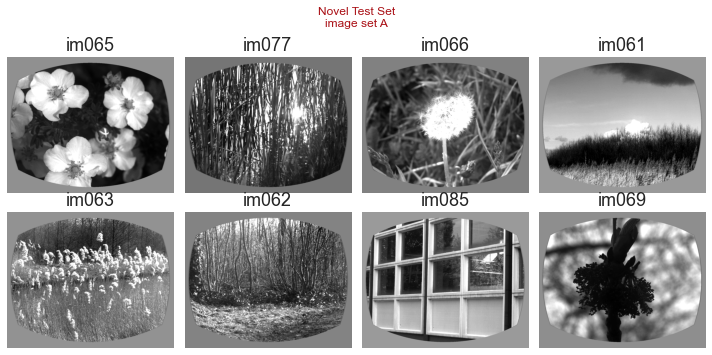

In [736]:
familiar_experiment_id = experiments_table[(experiments_table.project_code=='VisualBehavior')&(experiments_table.experience_level=='Familiar')].index.values[0]
dataset = loading.get_ophys_dataset(familiar_experiment_id)

colors = utils.get_experience_level_colors()

stimulus_templates = dataset.stimulus_templates.copy()
fig, ax = plt.subplots(2,4,figsize=(10,5))
ax=ax.ravel()
for i,image_name in enumerate(stimulus_templates.index):
    image = stimulus_templates.loc[image_name]['unwarped'].copy()
    image[np.isnan(image)] = 150
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(image_name,)
    ax[i].set_xlim(350, 1575)
    ax[i].set_ylim(100, 1100)
    ax[i].invert_yaxis()
    ax[i].axis('off')
    
# fig.suptitle('Familiar Training Set\nimage set A', color=colors[0])
fig.suptitle('Novel Test Set\nimage set A', color=colors[0])
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.tight_layout()

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\data_objects\eye_tracking\rig_geometry.py:135: UserWarning: This nwb file with identifier '795953296' has no eye tracking rig metadata. (NWB error: "'eye_tracking_rig_metadata' not found in processing of NWBFile 'root'.")
  warnings.warn("This nwb file with identifier "
C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\data_objects\eye_tracking\eye_tracking_table.py:136: UserWarning: This nwb file with identifier '795953296' has no eye tracking data. (NWB error: 'EyeTracking')
  warnings.warn("This nwb file with identifier "


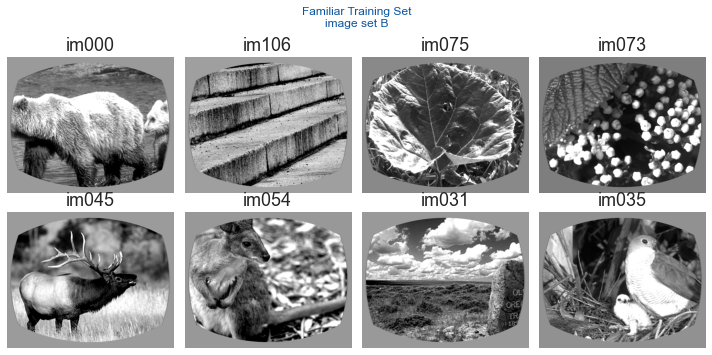

In [737]:
familiar_experiment_id = experiments_table[(experiments_table.project_code=='VisualBehavior')&(experiments_table.experience_level=='Novel 1')].index.values[0]
dataset = loading.get_ophys_dataset(familiar_experiment_id)

colors = utils.get_experience_level_colors()

stimulus_templates = dataset.stimulus_templates.copy()
fig, ax = plt.subplots(2,4,figsize=(10,5))
ax=ax.ravel()
for i,image_name in enumerate(stimulus_templates.index):
    image = stimulus_templates.loc[image_name]['unwarped'].copy()
    image[np.isnan(image)] = 150
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(image_name,)
    ax[i].set_xlim(350, 1575)
    ax[i].set_ylim(100, 1100)
    ax[i].invert_yaxis()
    ax[i].axis('off')
    
fig.suptitle('Familiar Training Set\nimage set B', color=colors[1])
# fig.suptitle('Novel Test Set\nimage set B', color=colors[1])
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.tight_layout()

### load behavior metrics 

In [144]:
def get_save_folder(method, engaged_only, per_image):  
    folder = method
    if engaged_only: 
        folder = folder+'_engaged_only'
    if per_image:
        folder = folder+'_per_image' 
    return folder


def get_behavior_stats_for_sessions(behavior_session_ids, behavior_sessions, 
                                    method='stimulus_based', engaged_only=True, per_image=False):
    behavior_stats = pd.DataFrame()
    problem_sessions = []
    for behavior_session_id in tqdm(behavior_session_ids):
        try:
            print('loading for', behavior_session_id)
            stats = vbu.get_cached_behavior_stats(behavior_session_id, engaged_only=engaged_only, method=method, per_image=per_image)
            behavior_stats = pd.concat([behavior_stats, stats])
        except:
            print('cant load stats for', behavior_session_id)
            problem_sessions.append(behavior_session_id)

    cache_dir = vbu.get_behavior_stats_cache_dir(method=method, engaged_only=engaged_only, per_image=per_image)
    filepath = os.path.join(cache_dir, 'all_sessions.h5')
    if not os.path.exists(filepath):
        behavior_stats.to_hdf(filepath, key='data')
    
    return behavior_stats, problem_sessions

### fraction time engaged


In [739]:
%%time 

method = 'stimulus_based'
engaged_only = False
per_image = False

folder = get_save_folder(method, engaged_only, per_image)

behavior_session_ids = behavior_sessions.index.values


original_full_session_behavior_stats, problem_sessions = get_behavior_stats_for_sessions(behavior_session_ids, behavior_sessions, 
                                    method=method, engaged_only=engaged_only, per_image=per_image)


# original_behavior_stats = behavior_stats.copy()
full_session_behavior_stats = original_full_session_behavior_stats.merge(behavior_sessions, on='behavior_session_id')
 # remove 4x2 sessions
full_session_behavior_stats = full_session_behavior_stats[full_session_behavior_stats.project_code!='VisualBehaviorMultiscope4areasx2d']

  0%|                                                                                 | 3/3667 [00:00<02:12, 27.58it/s]

loading for 742008131
loading for 742797917
loading for 743041166
loading for 743660302
loading for 744374168
loading for 745054849


  0%|▏                                                                               | 10/3667 [00:00<02:08, 28.53it/s]

loading for 745355000
loading for 745636848
loading for 746222622
loading for 746928360
loading for 750415261
loading for 750781358
loading for 752002559


  0%|▎                                                                               | 16/3667 [00:00<02:23, 25.42it/s]

loading for 753011296
loading for 753936007
loading for 754509820
loading for 754896244
loading for 755551879
loading for 756106020


  1%|▍                                                                               | 22/3667 [00:00<02:21, 25.80it/s]

loading for 756632727
loading for 757431083
loading for 758162988
loading for 758942142
loading for 759251920
loading for 759756829


  1%|▌                                                                               | 28/3667 [00:01<02:19, 26.18it/s]

loading for 760007428
loading for 760409951
loading for 760698062
loading for 761499069
loading for 761831761
loading for 762178061


  1%|▋                                                                               | 34/3667 [00:01<02:16, 26.58it/s]

loading for 762722108
loading for 763291103
loading for 763980798
loading for 764495320
loading for 764897570
loading for 765396393
loading for 766110635


  1%|▉                                                                               | 41/3667 [00:01<02:24, 25.16it/s]

loading for 766753111
loading for 767275980
loading for 768042187
loading for 768815421
loading for 769452637


  1%|█                                                                               | 47/3667 [00:01<02:22, 25.45it/s]

loading for 769902997
loading for 770244427
loading for 771245588
loading for 772125590
loading for 772658979
loading for 773585522


  1%|█▏                                                                              | 53/3667 [00:02<02:23, 25.10it/s]

loading for 774106776
loading for 774373300
loading for 774422914
loading for 774937388
loading for 775378326
loading for 775870895


  2%|█▏                                                                              | 56/3667 [00:02<02:24, 24.98it/s]

loading for 777082591
loading for 778166125
loading for 778980920
loading for 779818630


  2%|█▎                                                                              | 62/3667 [00:02<03:03, 19.61it/s]

loading for 780758836
loading for 782380778
loading for 784156661


  2%|█▍                                                                              | 65/3667 [00:02<02:53, 20.79it/s]

loading for 785426306
loading for 785944233
loading for 786920476
loading for 788017709
loading for 791257562


  2%|█▌                                                                              | 71/3667 [00:02<02:30, 23.88it/s]

loading for 791749028
loading for 792499741
loading for 793129579
loading for 796032489
loading for 760808911
loading for 761294708


  2%|█▌                                                                              | 74/3667 [00:03<02:41, 22.22it/s]

loading for 761730617
loading for 762067130
loading for 762418364
loading for 763012686


  2%|█▋                                                                              | 80/3667 [00:03<03:06, 19.24it/s]

loading for 763661704
loading for 764319580
loading for 764696952
loading for 765208332
loading for 765793356


  2%|█▉                                                                              | 86/3667 [00:03<02:43, 21.84it/s]

loading for 766532213
loading for 766931048
loading for 767730839
loading for 768450504
loading for 769145833
loading for 769731277


  3%|██                                                                              | 93/3667 [00:03<02:22, 25.02it/s]

loading for 770215042
loading for 771040969
loading for 771902184
loading for 772475707
loading for 773391809


  3%|██                                                                              | 96/3667 [00:03<02:19, 25.52it/s]

loading for 774120511
loading for 774679623
loading for 775291372
loading for 776988190
loading for 778010119
loading for 778888558


  3%|██▏                                                                            | 102/3667 [00:04<02:17, 25.85it/s]

loading for 779712859
loading for 780479408
loading for 781938213
loading for 783217873
loading for 783959068
loading for 785382040


  3%|██▎                                                                            | 108/3667 [00:04<02:23, 24.74it/s]

loading for 786007435
loading for 786938611
loading for 789008423
loading for 789870329
loading for 791248943


  3%|██▍                                                                            | 114/3667 [00:04<02:27, 24.04it/s]

loading for 791904071
loading for 792680306
loading for 793485674
loading for 794968300
loading for 795742990
loading for 796052844


  3%|██▌                                                                            | 120/3667 [00:04<02:29, 23.75it/s]

loading for 796251270
loading for 798126878
loading for 772286394
loading for 773510999
loading for 774208555
loading for 774767072


  3%|██▋                                                                            | 126/3667 [00:05<02:23, 24.70it/s]

loading for 775344511
loading for 775925580
loading for 777061425
loading for 778119826
loading for 778959204
loading for 779580423


  4%|██▊                                                                            | 132/3667 [00:05<02:38, 22.29it/s]

loading for 780351711
loading for 781727422
loading for 783059206
loading for 783971649


  4%|██▉                                                                            | 135/3667 [00:05<02:38, 22.26it/s]

loading for 785376297
loading for 785868918
loading for 786841415
loading for 788864720
loading for 789946754
loading for 791278700


  4%|███                                                                            | 141/3667 [00:05<02:37, 22.34it/s]

loading for 791769447
loading for 792477679
loading for 793153175
loading for 794071128
loading for 794673280


  4%|███▏                                                                           | 147/3667 [00:06<02:25, 24.20it/s]

loading for 795431009
loading for 796031509
loading for 797170547
loading for 776156839
loading for 777417642
loading for 778884020


  4%|███▎                                                                           | 153/3667 [00:06<02:31, 23.24it/s]

loading for 779111633
loading for 780002890
loading for 780766304
loading for 783413166
loading for 784173223
loading for 785539951


  4%|███▍                                                                           | 159/3667 [00:06<02:25, 24.13it/s]

loading for 786305627
loading for 788343533
loading for 789221588
loading for 791371899
loading for 791866254
loading for 792661903


  4%|███▌                                                                           | 165/3667 [00:06<02:15, 25.90it/s]

loading for 793323654
loading for 794275479
loading for 794953909
loading for 795838927
loading for 796046197
loading for 796233602


  5%|███▋                                                                           | 172/3667 [00:07<02:10, 26.68it/s]

loading for 796607829
loading for 798145975
loading for 798679618
loading for 799661667
loading for 800202171


  5%|███▊                                                                           | 176/3667 [00:07<02:06, 27.49it/s]

loading for 802406837
loading for 802922968
loading for 803341010
loading for 804748984
loading for 805373492
loading for 806616108


  5%|███▉                                                                           | 182/3667 [00:07<02:07, 27.32it/s]

loading for 807198458
loading for 808107647
loading for 809321253
loading for 791877093
loading for 792689261
loading for 793414389


  5%|████                                                                           | 186/3667 [00:07<02:03, 28.13it/s]

loading for 794295959
loading for 794977379
loading for 795854559
loading for 799051310
loading for 799922316


  5%|████▏                                                                          | 192/3667 [00:07<02:16, 25.52it/s]

loading for 800299366
loading for 800922511
loading for 802988132
loading for 803351520
loading for 804929649
loading for 805535249


  5%|████▎                                                                          | 198/3667 [00:08<02:14, 25.79it/s]

loading for 806109931
loading for 806792366
loading for 807356557
loading for 808324301
loading for 808883789
loading for 809358811


  6%|████▍                                                                          | 204/3667 [00:08<02:11, 26.32it/s]

loading for 810405357
loading for 811303680
loading for 811817467
loading for 812955256
loading for 816417578
loading for 817139151


  6%|████▌                                                                          | 213/3667 [00:08<02:05, 27.63it/s]

loading for 818485496
loading for 819094295
loading for 791875850
loading for 792689257
loading for 793409670
loading for 794295950


  6%|████▋                                                                          | 216/3667 [00:08<02:03, 27.94it/s]

loading for 794977383
loading for 795854555
loading for 799049628
loading for 799919887
loading for 800299362
loading for 800919728


  6%|████▊                                                                          | 222/3667 [00:09<02:15, 25.39it/s]

loading for 802364085
loading for 802988119
loading for 803347004
loading for 805639780
loading for 806296598
loading for 806841326


  6%|████▉                                                                          | 228/3667 [00:09<02:16, 25.24it/s]

loading for 807584876
loading for 808432167
loading for 809027309
loading for 809427293
loading for 811355443
loading for 810584641


  6%|█████                                                                          | 234/3667 [00:09<02:07, 26.90it/s]

loading for 811356875
loading for 811831429
loading for 812566400
loading for 812993078
loading for 813675618
loading for 814546737


  7%|█████▏                                                                         | 240/3667 [00:09<02:15, 25.26it/s]

loading for 815015329
loading for 815511978
loading for 816381516
loading for 817182203
loading for 818758572
loading for 819245147
loading for 819990491


  7%|█████▎                                                                         | 248/3667 [00:09<01:57, 29.00it/s]

loading for 821803380
loading for 822409353
loading for 823241007
loading for 823968100
loading for 825012995
loading for 825268982
loading for 825888541


  7%|█████▍                                                                         | 255/3667 [00:10<02:01, 28.00it/s]

loading for 826697158
loading for 827374757
loading for 828646658
loading for 829138845
loading for 829578829
loading for 830255592
loading for 830832988


  7%|█████▌                                                                         | 261/3667 [00:10<02:08, 26.43it/s]

loading for 831824426
loading for 832981154
loading for 835444110
loading for 835820832
loading for 836399024
loading for 807533658


  7%|█████▊                                                                         | 267/3667 [00:10<02:21, 24.06it/s]

loading for 808488955
loading for 809095689
loading for 809427297
loading for 809815041
loading for 810598880


  7%|█████▊                                                                         | 270/3667 [00:10<02:20, 24.18it/s]

loading for 811354008
loading for 811830102
loading for 812559803
loading for 813041953


  8%|█████▉                                                                         | 278/3667 [00:11<02:06, 26.70it/s]

loading for 813737110
loading for 814545306
cant load stats for 814545306
loading for 815045874
cant load stats for 815045874
loading for 815521974
loading for 816394256
loading for 817165094
loading for 818007489
cant load stats for 818007489
loading for 818825644
cant load stats for 818825644
loading for 819323551


  8%|██████▏                                                                        | 287/3667 [00:11<01:58, 28.53it/s]

loading for 820124540
loading for 821931655
loading for 822439453
loading for 823254723
loading for 824894721


  8%|██████▏                                                                        | 290/3667 [00:11<02:00, 28.06it/s]

loading for 807062523
loading for 808103937
loading for 809588395
loading for 810266014
loading for 811140660
loading for 811574124


  8%|██████▍                                                                        | 296/3667 [00:11<02:05, 26.84it/s]

loading for 812261209
loading for 812796028
loading for 814260983
loading for 814749891
loading for 815865807


  8%|██████▌                                                                        | 302/3667 [00:12<02:13, 25.15it/s]

loading for 817053045
loading for 818539436
loading for 819065377
loading for 819497998
loading for 820740400


  8%|██████▌                                                                        | 305/3667 [00:12<02:17, 24.48it/s]

loading for 821593979
loading for 822159346
loading for 822874578
loading for 823496226
loading for 824566587


  8%|██████▋                                                                        | 311/3667 [00:12<02:23, 23.32it/s]

loading for 825269006
loading for 825902239
loading for 826697162
loading for 827374765
loading for 828669593
loading for 829138837


  9%|██████▊                                                                        | 317/3667 [00:12<02:16, 24.54it/s]

loading for 829714672
loading for 830419451
loading for 830959034
loading for 831905148
loading for 833100683


  9%|██████▉                                                                        | 323/3667 [00:12<02:20, 23.79it/s]

loading for 833946929
loading for 834928595
loading for 835547527
loading for 835940015
loading for 837108110
loading for 837512169


  9%|███████                                                                        | 326/3667 [00:13<02:18, 24.11it/s]

loading for 823922942
loading for 824972176
loading for 825527066
loading for 826338809


  9%|███████▏                                                                       | 332/3667 [00:13<02:46, 20.04it/s]

loading for 826841473
loading for 827977069
loading for 828842797
loading for 829281654


  9%|███████▏                                                                       | 335/3667 [00:13<02:52, 19.28it/s]

loading for 829902556
loading for 830592943
loading for 831259963
loading for 832009551


  9%|███████▎                                                                       | 339/3667 [00:13<03:08, 17.68it/s]

loading for 832522789
loading for 833252272
loading for 834059775
loading for 834886139


  9%|███████▍                                                                       | 344/3667 [00:14<02:40, 20.75it/s]

loading for 835608988
loading for 836099247
loading for 836769386
loading for 837202082
loading for 837629869
loading for 838486964


 10%|███████▌                                                                       | 350/3667 [00:14<02:28, 22.31it/s]

loading for 839220840
loading for 839566028
loading for 839918083
loading for 840583412
loading for 841431760


 10%|███████▋                                                                       | 357/3667 [00:14<02:14, 24.61it/s]

loading for 841830077
loading for 842387217
loading for 842821314
loading for 843397714
loading for 844197868
loading for 844880686


 10%|███████▊                                                                       | 363/3667 [00:14<02:18, 23.91it/s]

loading for 845564445
loading for 846272622
loading for 847022155
loading for 847829598
loading for 848519645


 10%|███████▉                                                                       | 366/3667 [00:14<02:18, 23.81it/s]

loading for 849073265
loading for 849635376
loading for 850977753
loading for 851779746
loading for 852468381
loading for 853168204


 10%|████████                                                                       | 372/3667 [00:15<02:09, 25.41it/s]

loading for 853875502
loading for 854563857
loading for 855421865
loading for 855973498
loading for 856717282
loading for 857612105


 10%|████████▏                                                                      | 378/3667 [00:15<02:15, 24.32it/s]

loading for 859065627
loading for 859735311
loading for 860665051
loading for 861788094
loading for 863571072


 10%|████████▎                                                                      | 384/3667 [00:15<02:16, 24.14it/s]

loading for 864139911
loading for 864824449
loading for 865482857
loading for 866333758
loading for 867041502
loading for 867977775


 11%|████████▍                                                                      | 390/3667 [00:15<02:06, 25.92it/s]

loading for 868721114
loading for 869639141
loading for 870960890
loading for 872062433
loading for 873002413
loading for 873750535


 11%|████████▌                                                                      | 396/3667 [00:16<02:12, 24.76it/s]

loading for 874681118
loading for 875414332
loading for 876765708
loading for 877346183


 11%|████████▌                                                                      | 399/3667 [00:16<02:10, 25.05it/s]

loading for 877925816
loading for 878671068
loading for 879974471
loading for 880668519
loading for 881278000
loading for 882256127


 11%|████████▋                                                                      | 405/3667 [00:16<02:07, 25.50it/s]

loading for 882748184
loading for 884596128
loading for 885492180
loading for 886322595
loading for 886926935
loading for 888127012


 11%|████████▊                                                                      | 411/3667 [00:16<02:06, 25.78it/s]

loading for 890157940
loading for 820799656
loading for 821837682
loading for 822471786
loading for 823248638
loading for 823922950


 11%|████████▉                                                                      | 417/3667 [00:16<02:02, 26.50it/s]

loading for 824992804
loading for 825533866
loading for 826356747
loading for 826846303
loading for 827944014
loading for 828838236


 11%|█████████                                                                      | 421/3667 [00:17<01:59, 27.17it/s]

loading for 829282785
loading for 829877552
loading for 830620126
loading for 832019583


 12%|█████████▏                                                                     | 427/3667 [00:17<02:10, 24.91it/s]

loading for 832540845
loading for 833454420
loading for 834093014
loading for 834908481
loading for 835616503
loading for 836173885


 12%|█████████▎                                                                     | 433/3667 [00:17<02:07, 25.41it/s]

loading for 836777468
loading for 837196627
loading for 837647722
loading for 838496122
loading for 839233516
loading for 839566049


 12%|█████████▍                                                                     | 439/3667 [00:17<02:03, 26.24it/s]

loading for 839931485
loading for 840594518
loading for 841429687
loading for 841842210
loading for 842399625


 12%|█████████▌                                                                     | 445/3667 [00:18<02:17, 23.43it/s]

loading for 842844413
loading for 843400443
loading for 844253929
loading for 845585105


 12%|█████████▋                                                                     | 448/3667 [00:18<02:24, 22.26it/s]

loading for 846316916
loading for 847036338
loading for 847871771
loading for 848599542
loading for 849136474


 12%|█████████▊                                                                     | 454/3667 [00:18<02:16, 23.58it/s]

loading for 849648618
loading for 850985993
loading for 851757903
loading for 852440775
loading for 853496105
loading for 827312851


 13%|█████████▉                                                                     | 460/3667 [00:18<02:08, 25.03it/s]

loading for 828646634
loading for 829128279
loading for 829591790
loading for 830201482
loading for 830867799
loading for 831834820


 13%|██████████                                                                     | 466/3667 [00:18<02:14, 23.73it/s]

loading for 832325815
loading for 832990071
loading for 833780803
loading for 834573980


 13%|██████████                                                                     | 469/3667 [00:19<02:17, 23.29it/s]

loading for 835448132
loading for 835865722
loading for 836522259
loading for 837083666
loading for 837443225


 13%|██████████▏                                                                    | 475/3667 [00:19<02:17, 23.25it/s]

loading for 838236165
loading for 839014738
loading for 839479248
loading for 839854553


 13%|██████████▎                                                                    | 478/3667 [00:19<02:12, 24.04it/s]

loading for 840330509
loading for 841185520
loading for 841730873
loading for 842139320
loading for 842792100


 13%|██████████▍                                                                    | 484/3667 [00:19<02:17, 23.19it/s]

loading for 843166865
loading for 844234790
loading for 844875410
loading for 846248008
loading for 847048485


 13%|██████████▍                                                                    | 487/3667 [00:19<02:11, 24.13it/s]

loading for 847867029
loading for 848575992
loading for 849098851
loading for 850976604
loading for 853266283


 13%|██████████▌                                                                    | 493/3667 [00:20<02:20, 22.53it/s]

loading for 831129394
loading for 832021447
loading for 832544149
loading for 833328750
loading for 834087859


 14%|██████████▊                                                                    | 499/3667 [00:20<02:15, 23.29it/s]

loading for 834903060
loading for 835557296
loading for 836166694
loading for 836761653
loading for 837192567
loading for 837638916


 14%|██████████▉                                                                    | 505/3667 [00:20<02:14, 23.55it/s]

loading for 838496126
loading for 839234289
loading for 839566045
loading for 839939986
loading for 840594514


 14%|███████████                                                                    | 511/3667 [00:20<02:04, 25.44it/s]

loading for 841148118
loading for 841707177
loading for 842174399
loading for 842729895
loading for 843203333
loading for 844164376


 14%|███████████▏                                                                   | 517/3667 [00:21<01:59, 26.38it/s]

loading for 844849972
loading for 845441512
loading for 846194950
loading for 846929750
loading for 848503804


 14%|███████████▏                                                                   | 520/3667 [00:21<02:03, 25.56it/s]

loading for 853526948
loading for 834587823
loading for 835451471
loading for 835867850
loading for 836522245
loading for 837083657


 14%|███████████▎                                                                   | 526/3667 [00:21<02:01, 25.94it/s]

loading for 837449223
loading for 838203784
loading for 838998362
loading for 839468826
loading for 839837380


 15%|███████████▍                                                                   | 532/3667 [00:21<02:05, 24.92it/s]

loading for 840330501
loading for 841191836
loading for 841730868
loading for 842139310
loading for 842792094


 15%|███████████▌                                                                   | 538/3667 [00:21<02:03, 25.41it/s]

loading for 843178897
loading for 844027594
loading for 844608277
loading for 845409652
loading for 846051276


 15%|███████████▋                                                                   | 541/3667 [00:22<02:07, 24.54it/s]

loading for 846791195
loading for 847613846
loading for 848272657
loading for 848938321
loading for 849525884


 15%|███████████▊                                                                   | 547/3667 [00:22<02:09, 24.17it/s]

loading for 850817466
loading for 851563931
loading for 852235678
loading for 852974537
loading for 853505213
loading for 854283407


 15%|███████████▊                                                                   | 550/3667 [00:22<02:25, 21.42it/s]

loading for 855826937
loading for 857230827
loading for 837658854
loading for 838515247


 15%|███████████▉                                                                   | 556/3667 [00:22<02:38, 19.62it/s]

loading for 839219841
loading for 839565422
loading for 839912316
loading for 840581827


 15%|████████████                                                                   | 559/3667 [00:23<03:01, 17.12it/s]

loading for 841426832
loading for 841827774
loading for 842385277


 15%|████████████                                                                   | 561/3667 [00:23<03:26, 15.01it/s]

loading for 842819933
loading for 843400453
loading for 844199758


 15%|████████████▏                                                                  | 566/3667 [00:23<03:05, 16.70it/s]

loading for 844908261
loading for 845572044
loading for 846331423
loading for 847036328
loading for 847874940
loading for 848613406


 16%|████████████▎                                                                  | 572/3667 [00:23<02:38, 19.49it/s]

loading for 849147676
loading for 849651275
loading for 850989832
loading for 851773928
loading for 852451567


 16%|████████████▍                                                                  | 578/3667 [00:24<02:24, 21.40it/s]

loading for 855200229
loading for 837654533
loading for 838483140
loading for 839219845
loading for 839565426
loading for 839914270


 16%|████████████▌                                                                  | 585/3667 [00:24<02:06, 24.37it/s]

loading for 840581823
loading for 841426857
loading for 841830096
loading for 842385266
loading for 842819929
loading for 843401580


 16%|████████████▋                                                                  | 591/3667 [00:24<02:00, 25.43it/s]

loading for 844199766
loading for 844891885
loading for 845572039
loading for 846016059
loading for 846750050
loading for 847660741


 16%|████████████▊                                                                  | 594/3667 [00:24<02:04, 24.67it/s]

loading for 848348215
loading for 848943191
loading for 849494762
loading for 850807174
loading for 851542477


 16%|████████████▉                                                                  | 600/3667 [00:24<02:02, 25.13it/s]

loading for 852229360
loading for 853025613
loading for 855446545
loading for 855866701
loading for 856467236
loading for 857367017


 17%|█████████████                                                                  | 606/3667 [00:25<02:05, 24.48it/s]

loading for 858029487
loading for 858967789
loading for 859793880
loading for 860533862
loading for 864068649
loading for 840598877


 17%|█████████████▏                                                                 | 612/3667 [00:25<02:02, 24.91it/s]

loading for 841466830
loading for 841851097
loading for 842419799
loading for 842840144
loading for 843423171
loading for 844229895


 17%|█████████████▎                                                                 | 618/3667 [00:25<02:02, 24.98it/s]

loading for 844945060
loading for 845594684
loading for 846284880
loading for 847048490
loading for 847838131
loading for 848526511
loading for 848910243


 17%|█████████████▍                                                                 | 626/3667 [00:25<01:46, 28.66it/s]

loading for 849485548
loading for 850810858
loading for 851471401
loading for 852202150
loading for 852966248
loading for 853875514


 17%|█████████████▌                                                                 | 632/3667 [00:26<01:55, 26.33it/s]

loading for 854621677
loading for 855424348
loading for 857340041
loading for 857987666
loading for 858974731
loading for 859775117


 17%|█████████████▋                                                                 | 638/3667 [00:26<01:55, 26.29it/s]

loading for 863610582
loading for 868070216
loading for 868658294
loading for 869559097
loading for 850978904


 18%|█████████████▊                                                                 | 644/3667 [00:26<01:54, 26.31it/s]

loading for 851802107
loading for 852457995
loading for 853257103
loading for 853793068
loading for 854602288
loading for 855476794


 18%|██████████████                                                                 | 650/3667 [00:26<01:49, 27.48it/s]

loading for 856010720
loading for 856732195
loading for 857547928
loading for 858273959
loading for 859054070
loading for 859802280


 18%|██████████████▏                                                                | 656/3667 [00:27<01:53, 26.55it/s]

loading for 860894659
loading for 861794694
loading for 862716894
loading for 863559318
loading for 864280264


 18%|██████████████▏                                                                | 659/3667 [00:27<01:57, 25.55it/s]

loading for 865544821
loading for 866336764
loading for 867098393
loading for 867945660
loading for 868819048
loading for 869621595


 18%|██████████████▎                                                                | 665/3667 [00:27<01:59, 25.13it/s]

loading for 870960908
loading for 872107505
loading for 873813922
loading for 874808131
loading for 876821717
loading for 854533487


 18%|██████████████▍                                                                | 671/3667 [00:27<02:03, 24.35it/s]

loading for 855504136
loading for 856002607
loading for 856732191
loading for 857555456
loading for 858240891


 18%|██████████████▌                                                                | 677/3667 [00:27<02:06, 23.56it/s]

loading for 859032026
loading for 859791558
loading for 860752803
loading for 861794699
loading for 862701465
loading for 863571054


 19%|██████████████▋                                                                | 680/3667 [00:28<02:16, 21.95it/s]

loading for 864137547
loading for 864839176
loading for 865581941
loading for 866287088


 19%|██████████████▊                                                                | 686/3667 [00:28<02:29, 20.00it/s]

loading for 866950070
loading for 867615529
loading for 868540333
loading for 869319414
loading for 870660821


 19%|██████████████▉                                                                | 692/3667 [00:28<02:33, 19.36it/s]

loading for 871808378
loading for 872646068
loading for 873517635
loading for 874324533


 19%|██████████████▉                                                                | 695/3667 [00:28<02:31, 19.67it/s]

loading for 875471358
cant load stats for 875471358
loading for 876574139
loading for 850970486
loading for 851843550
loading for 852507945


 19%|███████████████                                                                | 700/3667 [00:29<02:30, 19.66it/s]

loading for 853260939
loading for 853886146
loading for 855459012
loading for 855980937
loading for 856719615
loading for 857504898


 19%|███████████████▏                                                               | 706/3667 [00:29<02:11, 22.45it/s]

loading for 858250763
loading for 859049298
loading for 859784868
loading for 860836980
loading for 861789935
loading for 862716913


 19%|███████████████▎                                                               | 712/3667 [00:29<02:06, 23.38it/s]

loading for 863614836
loading for 864260028
loading for 864813130
loading for 865460179
loading for 866296478


 20%|███████████████▍                                                               | 718/3667 [00:29<02:00, 24.40it/s]

loading for 866999677
loading for 867615541
loading for 868555361
loading for 869334643
loading for 870592115
loading for 871808394


 20%|███████████████▌                                                               | 724/3667 [00:30<01:57, 24.98it/s]

loading for 872626160
loading for 873695653
loading for 874699922
loading for 875440936
loading for 876678452
loading for 877617747


 20%|███████████████▋                                                               | 730/3667 [00:30<01:51, 26.25it/s]

loading for 878120101
loading for 879037269
loading for 880046522
loading for 880784794
loading for 882256117
loading for 854528256
loading for 855503335


 20%|███████████████▊                                                               | 736/3667 [00:30<02:03, 23.66it/s]

loading for 856002613
loading for 856732213
loading for 857555461
loading for 858240896
loading for 859032044


 20%|████████████████                                                               | 743/3667 [00:30<01:50, 26.38it/s]

loading for 859791563
loading for 860752819
loading for 861794704
loading for 862701503
loading for 863559327
loading for 864125430
loading for 864839160


 20%|████████████████▏                                                              | 750/3667 [00:31<01:42, 28.59it/s]

loading for 865580429
loading for 866287143
loading for 867082086
loading for 868004770
loading for 868747797
loading for 872158938
loading for 873015934


 21%|████████████████▎                                                              | 757/3667 [00:31<01:39, 29.32it/s]

loading for 873824951
loading for 874747892
loading for 875444395
loading for 876857698
loading for 878159171
loading for 879037253
loading for 880201859


 21%|████████████████▍                                                              | 763/3667 [00:31<01:45, 27.61it/s]

loading for 880776648
loading for 881413102
loading for 882446265
loading for 882831297
loading for 883863892
loading for 884808160


 21%|████████████████▌                                                              | 769/3667 [00:31<01:55, 25.18it/s]

loading for 885644181
loading for 886440437
loading for 887165432
loading for 888282547


 21%|████████████████▋                                                              | 772/3667 [00:31<01:52, 25.64it/s]

loading for 858104885
loading for 858900546
loading for 859601488
loading for 860247669
loading for 861717498
loading for 862339401


 21%|████████████████▊                                                              | 778/3667 [00:32<01:54, 25.22it/s]

loading for 863365105
loading for 863966979
loading for 864665192
loading for 865114696
loading for 865887829


 21%|████████████████▉                                                              | 784/3667 [00:32<02:09, 22.33it/s]

loading for 866906696
loading for 867505993
loading for 868511825
loading for 869198966


 21%|████████████████▉                                                              | 787/3667 [00:32<02:18, 20.83it/s]

loading for 870481699
loading for 871723063
loading for 872607293
loading for 873440431


 22%|█████████████████                                                              | 790/3667 [00:32<02:24, 19.90it/s]

loading for 874324527
loading for 875020211
loading for 876448536
loading for 877855866


 22%|█████████████████▏                                                             | 796/3667 [00:32<02:02, 23.35it/s]

loading for 878615859
loading for 879846629
loading for 880581639
loading for 881204796
loading for 882289836
loading for 883851453


 22%|█████████████████▎                                                             | 802/3667 [00:33<01:52, 25.57it/s]

loading for 884598044
loading for 885404075
loading for 886376835
loading for 888213949
loading for 890021100
loading for 893362730


 22%|█████████████████▎                                                             | 805/3667 [00:33<02:07, 22.52it/s]

loading for 894103623
loading for 895022326
loading for 895562386
loading for 896561264


 22%|█████████████████▍                                                             | 811/3667 [00:33<02:24, 19.76it/s]

loading for 898432373
loading for 898874650
loading for 899390684
loading for 901999401


 22%|█████████████████▌                                                             | 814/3667 [00:33<02:13, 21.41it/s]

loading for 903708760
loading for 904574580
loading for 906472625
loading for 907053876
loading for 907900077


 22%|█████████████████▋                                                             | 820/3667 [00:34<02:11, 21.65it/s]

loading for 908533370
loading for 910207192
loading for 910829549
loading for 911904717
loading for 913673477
loading for 914211263


 23%|█████████████████▊                                                             | 826/3667 [00:34<02:00, 23.49it/s]

loading for 914705301
loading for 915418411
loading for 916403851
loading for 918103715
loading for 923410363


 23%|█████████████████▉                                                             | 832/3667 [00:34<02:05, 22.68it/s]

loading for 924472023
loading for 925084998
loading for 858098100
loading for 858891746


 23%|█████████████████▉                                                             | 835/3667 [00:34<02:04, 22.78it/s]

loading for 859601496
loading for 860247677
loading for 861715805
loading for 862326321
loading for 863361852
loading for 863966966


 23%|██████████████████                                                             | 841/3667 [00:34<01:59, 23.60it/s]

loading for 864656758
loading for 865114705
loading for 865883182
loading for 866912923
loading for 867553178
loading for 868521085


 23%|██████████████████▎                                                            | 848/3667 [00:35<01:45, 26.65it/s]

loading for 869223965
loading for 870473396
loading for 871723073
loading for 872607297
loading for 873440438
loading for 874324523


 23%|██████████████████▍                                                            | 854/3667 [00:35<01:57, 24.00it/s]

loading for 875020169
loading for 877447964
loading for 878282369
loading for 880231156


 23%|██████████████████▍                                                            | 857/3667 [00:35<01:51, 25.14it/s]

loading for 880780889
loading for 881427978
loading for 882434675
loading for 882827577
loading for 884888379
loading for 885739915


 24%|██████████████████▌                                                            | 863/3667 [00:35<01:55, 24.21it/s]

loading for 886446971
loading for 887236947
loading for 888301437
loading for 889559462
loading for 890374401


 24%|██████████████████▋                                                            | 869/3667 [00:36<01:55, 24.21it/s]

loading for 891792255
loading for 892663103
loading for 893600606
loading for 858098096
loading for 859064345


 24%|██████████████████▊                                                            | 872/3667 [00:36<01:50, 25.31it/s]

loading for 859735301
loading for 860650174
loading for 861785387
loading for 862752139
loading for 863571063


 24%|██████████████████▉                                                            | 878/3667 [00:36<02:04, 22.33it/s]

loading for 864137543
loading for 864820740
loading for 865463877
loading for 866319121
loading for 867036286
loading for 867961842


 24%|███████████████████                                                            | 884/3667 [00:36<01:52, 24.75it/s]

loading for 868649156
loading for 869623240
loading for 870935137
loading for 872035204
loading for 872979404
loading for 873733206


 24%|███████████████████▏                                                           | 890/3667 [00:36<01:52, 24.60it/s]

loading for 874654275
loading for 875385898
loading for 876737438
loading for 877558819
loading for 878233751
loading for 879003588


 24%|███████████████████▎                                                           | 896/3667 [00:37<01:50, 25.07it/s]

loading for 880183901
loading for 880769249
loading for 881413092
loading for 882393175
loading for 883857874


 25%|███████████████████▍                                                           | 902/3667 [00:37<01:56, 23.77it/s]

loading for 884800923
loading for 885589846
loading for 886437461
loading for 887183674
loading for 888263147


 25%|███████████████████▌                                                           | 909/3667 [00:37<01:45, 26.16it/s]

loading for 889436433
loading for 890459182
loading for 891759060
loading for 892589687
loading for 893433252
loading for 894215832


 25%|███████████████████▋                                                           | 913/3667 [00:37<01:39, 27.69it/s]

loading for 896543695
loading for 898493295
loading for 898889632
loading for 899400259
loading for 900228074
loading for 901102440


 25%|███████████████████▊                                                           | 919/3667 [00:38<01:44, 26.22it/s]

loading for 902021938
loading for 902822517
loading for 904630713
loading for 907035941
loading for 907995409
loading for 908564883


 25%|███████████████████▉                                                           | 925/3667 [00:38<01:43, 26.39it/s]

loading for 909363995
loading for 910249989
loading for 911361470
loading for 911947271
loading for 912570316


 25%|████████████████████                                                           | 931/3667 [00:38<01:47, 25.42it/s]

loading for 913710476
loading for 914230230
loading for 914715937
loading for 915448786
loading for 916450856


 25%|████████████████████                                                           | 934/3667 [00:38<01:56, 23.53it/s]

loading for 917331220
loading for 918202290
loading for 918900907
loading for 919634924
loading for 920541932
loading for 921601457


 26%|████████████████████▎                                                          | 941/3667 [00:38<01:46, 25.57it/s]

loading for 922572837
loading for 923474474
loading for 924575646
loading for 925033179
loading for 926393722
loading for 927449068


 26%|████████████████████▍                                                          | 947/3667 [00:39<01:50, 24.68it/s]

loading for 928400507
loading for 929341697
loading for 929818797
loading for 931566300
loading for 932611698
loading for 933504759


 26%|████████████████████▌                                                          | 953/3667 [00:39<01:45, 25.70it/s]

loading for 934610593
loading for 935811563
loading for 937416292
loading for 938377224
loading for 939538572
loading for 862786889


 26%|████████████████████▋                                                          | 959/3667 [00:39<01:47, 25.30it/s]

loading for 863627986
loading for 864248647
loading for 865463863
loading for 866103829
loading for 867056914


 26%|████████████████████▊                                                          | 965/3667 [00:39<01:46, 25.33it/s]

loading for 868008761
loading for 868709715
loading for 871033938
loading for 872127292
loading for 873051801


 26%|████████████████████▊                                                          | 968/3667 [00:40<01:57, 22.96it/s]

loading for 873781580
loading for 874747887
loading for 875479783
loading for 876836773
loading for 877614747


 27%|████████████████████▉                                                          | 974/3667 [00:40<01:58, 22.70it/s]

loading for 878282360
loading for 879094361
loading for 880191852
loading for 880775450
loading for 881419102


 27%|█████████████████████                                                          | 980/3667 [00:40<01:50, 24.42it/s]

loading for 882388591
loading for 883704230
loading for 884677929
loading for 886239982
loading for 886873295


 27%|█████████████████████▏                                                         | 983/3667 [00:40<01:44, 25.69it/s]

loading for 889155682
loading for 890051221
loading for 891487953
loading for 892410834
loading for 893356870
loading for 894209378


 27%|█████████████████████▎                                                         | 990/3667 [00:40<01:38, 27.09it/s]

loading for 894987969
loading for 896526348
loading for 898453640
loading for 898889612
loading for 899452222
loading for 901380774
loading for 902270195


 27%|█████████████████████▍                                                         | 996/3667 [00:41<01:44, 25.45it/s]

loading for 903070554
loading for 904011865
loading for 906695544
loading for 907356161
loading for 908908617
loading for 911021831


 27%|█████████████████████▎                                                        | 1002/3667 [00:41<01:46, 25.05it/s]

loading for 911522814
loading for 912242958
loading for 912918028
loading for 913898214
loading for 914405292


 27%|█████████████████████▍                                                        | 1008/3667 [00:41<01:44, 25.54it/s]

loading for 914868296
loading for 915690421
loading for 916623819
loading for 917581144
loading for 918454518
loading for 919073273
loading for 919973223


 28%|█████████████████████▌                                                        | 1014/3667 [00:41<01:47, 24.68it/s]

loading for 920836124
loading for 921879374
loading for 922942074
loading for 923786645
loading for 924729242
loading for 926769977


 28%|█████████████████████▋                                                        | 1020/3667 [00:42<01:53, 23.27it/s]

loading for 927745870
loading for 928717396
loading for 929524399
loading for 932078145
loading for 932975404


 28%|█████████████████████▊                                                        | 1026/3667 [00:42<01:47, 24.51it/s]

loading for 934075944
loading for 934900274
loading for 936033313
loading for 937825662
loading for 938991494
loading for 940243685


 28%|█████████████████████▉                                                        | 1030/3667 [00:42<01:40, 26.27it/s]

loading for 940796859
loading for 941946991
loading for 942448113
loading for 945277725
loading for 946172858


 28%|██████████████████████                                                        | 1036/3667 [00:42<01:48, 24.18it/s]

loading for 947503956
loading for 948341757
loading for 862479694
loading for 863414647
loading for 864000195


 28%|██████████████████████▏                                                       | 1042/3667 [00:43<01:50, 23.80it/s]

loading for 864729508
loading for 865288307
loading for 865953304
loading for 866971252
loading for 867649878
loading for 868546763


 29%|██████████████████████▎                                                       | 1048/3667 [00:43<01:50, 23.73it/s]

loading for 869311954
loading for 870592103
loading for 871782387
loading for 872720256
loading for 873530279


 29%|██████████████████████▎                                                       | 1051/3667 [00:43<01:54, 22.79it/s]

loading for 874295478
loading for 875020129
loading for 876521253
loading for 877346192


 29%|██████████████████████▍                                                       | 1054/3667 [00:43<02:09, 20.24it/s]

loading for 877938181
loading for 878671074
loading for 879958654
loading for 880647168


 29%|██████████████████████▌                                                       | 1060/3667 [00:43<02:01, 21.51it/s]

loading for 881253316
loading for 882233951
loading for 882679635
loading for 883632948
loading for 884560033
loading for 885418521


 29%|██████████████████████▋                                                       | 1066/3667 [00:44<02:02, 21.23it/s]

loading for 886262841
loading for 886900197
loading for 889183454
loading for 890054551
loading for 891504476


 29%|██████████████████████▊                                                       | 1072/3667 [00:44<01:53, 22.83it/s]

loading for 892413871
loading for 893359124
loading for 894215849
loading for 894994111
loading for 896543686
loading for 898461372


 29%|██████████████████████▉                                                       | 1078/3667 [00:44<01:53, 22.85it/s]

loading for 898890800
loading for 899461485
loading for 902028378
loading for 902822538
loading for 904625819


 29%|██████████████████████▉                                                       | 1081/3667 [00:44<01:52, 22.90it/s]

loading for 907035965
loading for 907995400
loading for 908564873
loading for 910249985
loading for 911361486


 30%|███████████████████████                                                       | 1087/3667 [00:45<01:54, 22.60it/s]

loading for 912159483
loading for 913921659
loading for 914411174
loading for 914871449
loading for 915739774
loading for 916704634


 30%|███████████████████████▏                                                      | 1093/3667 [00:45<01:50, 23.31it/s]

loading for 917595407
loading for 918474069
loading for 919104267
loading for 920015895
loading for 920839478


 30%|███████████████████████▍                                                      | 1099/3667 [00:45<01:45, 24.35it/s]

loading for 922012422
loading for 923834852
loading for 924759623
loading for 925603486
loading for 927905748
loading for 929551055


 30%|███████████████████████▌                                                      | 1106/3667 [00:45<01:41, 25.18it/s]

loading for 935301109
loading for 936273485
loading for 862730050
loading for 863657189
loading for 864236370


 30%|███████████████████████▌                                                      | 1110/3667 [00:45<01:34, 27.18it/s]

loading for 864809053
loading for 865443418
loading for 866300303
loading for 867045079
loading for 867977763
loading for 868704504


 30%|███████████████████████▋                                                      | 1116/3667 [00:46<01:39, 25.61it/s]

loading for 869615887
loading for 870960882
loading for 872864902
loading for 873729011
loading for 874691139


 31%|███████████████████████▊                                                      | 1122/3667 [00:46<01:39, 25.66it/s]

loading for 875402170
loading for 876701397
loading for 877524045
loading for 878137744
loading for 879003593
loading for 880088387
loading for 881416618
loading for 882373648


 31%|███████████████████████▉                                                      | 1128/3667 [00:46<02:05, 20.22it/s]

loading for 882785348
loading for 883984332
loading for 884750162
loading for 885540222
loading for 886440427


 31%|████████████████████████▏                                                     | 1135/3667 [00:47<01:43, 24.38it/s]

loading for 886931452
loading for 888282572
loading for 889443507
loading for 890355790
loading for 891618314
loading for 892491402
loading for 893540605


 31%|████████████████████████▎                                                     | 1141/3667 [00:47<01:40, 25.15it/s]

loading for 894466746
loading for 895241719
loading for 895877676
loading for 896969091
loading for 898658063
loading for 899685557


 31%|████████████████████████▍                                                     | 1147/3667 [00:47<01:48, 23.33it/s]

loading for 900226857
loading for 901340457
loading for 902244344
loading for 902962312


 31%|████████████████████████▍                                                     | 1150/3667 [00:47<01:52, 22.37it/s]

loading for 904899490
loading for 906641078
loading for 908092560
loading for 910381299
loading for 911016296


 32%|████████████████████████▌                                                     | 1156/3667 [00:47<01:52, 22.40it/s]

loading for 911541959
loading for 912902650
loading for 913850438
loading for 914336989
loading for 914828503
loading for 915609195


 32%|████████████████████████▋                                                     | 1162/3667 [00:48<01:44, 23.92it/s]

loading for 916614400
loading for 917500273
loading for 918451984
loading for 919022193
loading for 919895633
loading for 920807985


 32%|████████████████████████▊                                                     | 1168/3667 [00:48<01:49, 22.86it/s]

loading for 921873454
loading for 923757660
loading for 924739087
loading for 926621793


 32%|████████████████████████▉                                                     | 1171/3667 [00:48<01:52, 22.09it/s]

loading for 927652117
loading for 928654503
loading for 929522558
loading for 930344462
loading for 932960096


 32%|█████████████████████████                                                     | 1177/3667 [00:48<01:50, 22.59it/s]

loading for 933939891
loading for 935038748
loading for 936159430
loading for 937645038
loading for 938729036
loading for 940017429


 32%|█████████████████████████▏                                                    | 1183/3667 [00:49<01:48, 22.84it/s]

loading for 941802699
loading for 942814025
loading for 943833533
loading for 945033994
loading for 947336783
loading for 948225040


 32%|█████████████████████████▎                                                    | 1189/3667 [00:49<01:48, 22.82it/s]

loading for 949348713
loading for 950188644
loading for 862245493
loading for 863368489


 33%|█████████████████████████▎                                                    | 1192/3667 [00:49<01:45, 23.39it/s]

loading for 863966974
loading for 864665204
loading for 865131331
loading for 865887821
loading for 866909432
loading for 867521015


 33%|█████████████████████████▍                                                    | 1198/3667 [00:49<01:45, 23.39it/s]

loading for 868513545
loading for 869214215
loading for 870481685
loading for 871728970
loading for 872609185


 33%|█████████████████████████▌                                                    | 1204/3667 [00:50<01:40, 24.44it/s]

loading for 873449838
loading for 874333572
loading for 875020175
loading for 876448528
loading for 877855879
loading for 878615867


 33%|█████████████████████████▋                                                    | 1210/3667 [00:50<01:42, 24.05it/s]

loading for 879854787
loading for 880590869
loading for 881210690
loading for 882291265
loading for 882736270


 33%|█████████████████████████▊                                                    | 1216/3667 [00:50<01:38, 24.82it/s]

loading for 883857883
loading for 884605735
loading for 885404024
loading for 886382175
loading for 888218684


 33%|█████████████████████████▉                                                    | 1219/3667 [00:50<01:36, 25.29it/s]

loading for 890021090
loading for 893608687
loading for 894495169
loading for 895278567
loading for 895809864
loading for 896882463


 33%|██████████████████████████                                                    | 1225/3667 [00:50<01:37, 25.08it/s]

loading for 898665096
loading for 898938920
loading for 900227468
loading for 901316636
loading for 902211897
loading for 902995627


 34%|██████████████████████████▏                                                   | 1231/3667 [00:51<01:38, 24.73it/s]

loading for 903977177
loading for 904922800
loading for 906658064
loading for 907327499
loading for 908122381
loading for 912640306


 34%|██████████████████████████▎                                                   | 1237/3667 [00:51<01:42, 23.63it/s]

loading for 866287136
loading for 867036293
loading for 867961854
loading for 868653129
loading for 869623244


 34%|██████████████████████████▍                                                   | 1243/3667 [00:51<01:32, 26.23it/s]

loading for 870935142
loading for 872043024
loading for 872979424
loading for 873739031
loading for 874654280
loading for 875385921
loading for 876737442


 34%|██████████████████████████▌                                                   | 1251/3667 [00:51<01:27, 27.59it/s]

loading for 877558833
loading for 878245978
loading for 878993255
loading for 880191880
loading for 880775454


 34%|██████████████████████████▋                                                   | 1254/3667 [00:51<01:31, 26.37it/s]

loading for 881425509
loading for 882401590
loading for 883756380
loading for 884552901
loading for 885410929


 34%|██████████████████████████▊                                                   | 1261/3667 [00:52<01:28, 27.33it/s]

loading for 886257016
loading for 886838602
loading for 888033338
loading for 889175194
loading for 890033129
loading for 891446789
loading for 892387261


 34%|██████████████████████████▉                                                   | 1264/3667 [00:52<01:30, 26.51it/s]

loading for 893344360
loading for 894083470
loading for 898440124
loading for 866128606


 35%|███████████████████████████                                                   | 1270/3667 [00:52<01:44, 22.94it/s]

loading for 866971269
loading for 867645566
loading for 868531777
loading for 869311972
loading for 870579061


 35%|███████████████████████████                                                   | 1273/3667 [00:52<01:53, 21.06it/s]

loading for 871782397
loading for 872690218
loading for 873537911
loading for 874416985


 35%|███████████████████████████▏                                                  | 1279/3667 [00:53<02:07, 18.80it/s]

loading for 875020203
loading for 876651891
loading for 877487375


 35%|███████████████████████████▏                                                  | 1281/3667 [00:53<02:26, 16.27it/s]

loading for 878179382
loading for 878771403
loading for 879969002


 35%|███████████████████████████▎                                                  | 1283/3667 [00:53<02:43, 14.60it/s]

loading for 880644824
loading for 881251187
loading for 882219267


 35%|███████████████████████████▍                                                  | 1287/3667 [00:53<02:38, 15.05it/s]

loading for 882677813
loading for 883632956
loading for 884560064
loading for 885410934


 35%|███████████████████████████▌                                                  | 1293/3667 [00:54<01:59, 19.95it/s]

loading for 886250995
loading for 887006111
loading for 888163519
loading for 889388078
loading for 890625596
loading for 891605682


 35%|███████████████████████████▋                                                  | 1299/3667 [00:54<01:46, 22.21it/s]

loading for 892526544
loading for 893488330
loading for 894368064
loading for 870987812
loading for 872953842
loading for 873774125


 36%|███████████████████████████▊                                                  | 1305/3667 [00:54<01:39, 23.62it/s]

loading for 874790261
loading for 875207834
loading for 876821726
loading for 877603209
loading for 878245989
loading for 879003606


 36%|███████████████████████████▉                                                  | 1312/3667 [00:54<01:30, 26.01it/s]

loading for 880088400
loading for 881416637
loading for 882373653
loading for 882781075
loading for 883986743
loading for 884776248


 36%|████████████████████████████                                                  | 1318/3667 [00:55<01:31, 25.58it/s]

loading for 885540237
loading for 886442346
loading for 886946944
loading for 888295170
loading for 889468960


 36%|████████████████████████████                                                  | 1322/3667 [00:55<01:25, 27.30it/s]

loading for 890408602
loading for 891635659
loading for 891635667
loading for 892510304
loading for 893560763
loading for 894481319


 36%|████████████████████████████▏                                                 | 1328/3667 [00:55<01:23, 27.98it/s]

loading for 895248933
loading for 895896343
loading for 896995828
loading for 898667252
loading for 899700579
loading for 900231059


 36%|████████████████████████████▍                                                 | 1334/3667 [00:55<01:30, 25.81it/s]

loading for 901363879
loading for 902260156
loading for 902975505
loading for 904922810
loading for 906668549


 36%|████████████████████████████▍                                                 | 1337/3667 [00:55<01:28, 26.18it/s]

loading for 908104455
loading for 910393217
loading for 911016285
loading for 911541950
loading for 912223787


 37%|████████████████████████████▋                                                 | 1346/3667 [00:56<01:27, 26.54it/s]

loading for 912902619
loading for 913850450
loading for 914339617
loading for 914831000
loading for 915609216
loading for 916617096


 37%|████████████████████████████▋                                                 | 1349/3667 [00:56<01:28, 26.11it/s]

loading for 917500256
loading for 918451994
loading for 919025442
loading for 920901263
loading for 921979060
loading for 923757653


 37%|████████████████████████████▊                                                 | 1355/3667 [00:56<01:27, 26.33it/s]

loading for 924739774
loading for 926621788
loading for 927652110
loading for 928654491
loading for 929524423
loading for 930344469


 37%|█████████████████████████████                                                 | 1364/3667 [00:56<01:23, 27.60it/s]

loading for 932960104
loading for 933954934
loading for 935045761
loading for 936083473
loading for 937706038
loading for 938794488


 37%|█████████████████████████████                                                 | 1367/3667 [00:56<01:25, 26.96it/s]

loading for 939985541
loading for 940755050
loading for 941734036
loading for 942767530
loading for 944125005


 37%|█████████████████████████████▏                                                | 1373/3667 [00:57<01:26, 26.48it/s]

loading for 945075740
loading for 947988590
loading for 949201674
loading for 949973686
loading for 951520319
loading for 952554548


 38%|█████████████████████████████▎                                                | 1379/3667 [00:57<01:28, 25.80it/s]

loading for 953982960
loading for 956010809
loading for 957032492
loading for 958234742
loading for 958888263
loading for 959681045


 38%|█████████████████████████████▍                                                | 1385/3667 [00:57<01:31, 24.96it/s]

loading for 875126982
loading for 876823447
loading for 877605077
loading for 878245966
loading for 879074585
loading for 880174939


 38%|█████████████████████████████▌                                                | 1391/3667 [00:57<01:25, 26.68it/s]

loading for 881450253
loading for 882426675
loading for 882833335
loading for 884004562
loading for 884776271
loading for 885598412


 38%|█████████████████████████████▋                                                | 1397/3667 [00:58<01:29, 25.32it/s]

loading for 886446962
loading for 886953901
loading for 888298590
loading for 889478291
loading for 890408635
loading for 891635663


 38%|█████████████████████████████▊                                                | 1403/3667 [00:58<01:29, 25.36it/s]

loading for 892525019
loading for 893560739
loading for 894481291
loading for 895262003
loading for 895896368
loading for 896995823


 38%|█████████████████████████████▉                                                | 1406/3667 [00:58<01:35, 23.64it/s]

loading for 898682070
loading for 899742869
loading for 901424076
loading for 902328548


 39%|██████████████████████████████                                                | 1412/3667 [00:58<01:56, 19.29it/s]

loading for 903098779
loading for 904954571
loading for 906726720
loading for 908165653


 39%|██████████████████████████████                                                | 1415/3667 [00:58<01:55, 19.49it/s]

loading for 910448027
loading for 911061160
loading for 911581364
loading for 912318840
loading for 913014398


 39%|██████████████████████████████▏                                               | 1421/3667 [00:59<01:49, 20.44it/s]

loading for 913917929
loading for 914408296
loading for 914859356
loading for 915690413
loading for 916673577
loading for 917600513


 39%|██████████████████████████████▎                                               | 1427/3667 [00:59<01:33, 23.94it/s]

loading for 918448801
loading for 919022174
loading for 919890884
loading for 920807973
loading for 921873450
loading for 923750087
loading for 924740575


 39%|██████████████████████████████▌                                               | 1437/3667 [00:59<01:22, 27.13it/s]

loading for 926614379
loading for 927643982
loading for 928647601
loading for 929522554
loading for 930376122
loading for 931913977


 39%|██████████████████████████████▋                                               | 1440/3667 [00:59<01:22, 26.95it/s]

loading for 932628715
loading for 933604243
loading for 934812249
loading for 935653479
loading for 937395157
loading for 938339083


 39%|██████████████████████████████▊                                               | 1446/3667 [01:00<01:29, 24.93it/s]

loading for 939533442
loading for 940628402
loading for 941425961
loading for 942350598
loading for 875155219


 40%|██████████████████████████████▉                                               | 1452/3667 [01:00<01:26, 25.51it/s]

loading for 876829777
loading for 877607698
loading for 878251933
loading for 879074574
loading for 880181164
loading for 881450232


 40%|███████████████████████████████                                               | 1458/3667 [01:00<01:27, 25.20it/s]

loading for 882426670
loading for 882844402
loading for 884070037
loading for 884846935
loading for 885609778


 40%|███████████████████████████████                                               | 1461/3667 [01:00<01:32, 23.95it/s]

loading for 886472241
loading for 887175302
loading for 888346887
loading for 889536668
loading for 890555457


 40%|███████████████████████████████▏                                              | 1468/3667 [01:00<01:26, 25.37it/s]

loading for 891724311
loading for 893564091
loading for 894481299
loading for 895256170
loading for 895902286
loading for 897002967
loading for 898668828


 40%|███████████████████████████████▎                                              | 1474/3667 [01:01<01:26, 25.27it/s]

loading for 899700587
loading for 900231063
loading for 901363886
loading for 902260148
loading for 902975514


 40%|███████████████████████████████▍                                              | 1480/3667 [01:01<01:32, 23.58it/s]

loading for 904922795
loading for 906668545
loading for 908109320
loading for 910393226


 40%|███████████████████████████████▌                                              | 1483/3667 [01:01<01:32, 23.73it/s]

loading for 911019327
loading for 911543418
loading for 912223793
loading for 912223799
loading for 912902659


 41%|███████████████████████████████▋                                              | 1490/3667 [01:01<01:24, 25.79it/s]

loading for 913854181
loading for 914339627
loading for 914831033
loading for 915609229
loading for 916617112
loading for 917506393


 41%|███████████████████████████████▊                                              | 1493/3667 [01:02<01:29, 24.25it/s]

loading for 918454529
loading for 919025470
loading for 919902020
loading for 920813990


 41%|███████████████████████████████▉                                              | 1499/3667 [01:02<01:36, 22.50it/s]

loading for 921879360
loading for 923877874
loading for 924757055
loading for 926621779
loading for 927643992


 41%|███████████████████████████████▉                                              | 1502/3667 [01:02<01:37, 22.12it/s]

loading for 928647605
loading for 929522550
loading for 930335512
loading for 931488919
loading for 932596575


 41%|████████████████████████████████                                              | 1508/3667 [01:02<01:42, 21.04it/s]

loading for 933472975
loading for 935601725
loading for 937442661
loading for 938425882
loading for 939537734


 41%|████████████████████████████████▏                                             | 1511/3667 [01:02<01:37, 22.16it/s]

loading for 940553228
loading for 941457567
loading for 942329079
loading for 943479988


 41%|████████████████████████████████▎                                             | 1517/3667 [01:03<01:40, 21.44it/s]

loading for 944823947
loading for 882765152
loading for 883908190
loading for 884881862
loading for 885609760
loading for 886424035


 42%|████████████████████████████████▍                                             | 1523/3667 [01:03<01:31, 23.46it/s]

loading for 887142121
loading for 888298597
loading for 889478282
loading for 890578468
loading for 891752782


 42%|████████████████████████████████▍                                             | 1526/3667 [01:03<01:38, 21.65it/s]

loading for 892597881
loading for 893551176
loading for 894489950
loading for 895248904


 42%|████████████████████████████████▌                                             | 1532/3667 [01:03<01:49, 19.53it/s]

loading for 895947603
loading for 896945902
loading for 898691674
loading for 898982250


 42%|████████████████████████████████▋                                             | 1535/3667 [01:04<01:47, 19.89it/s]

loading for 901251663
loading for 902135840
loading for 902871565
loading for 903842232
loading for 904844395


 42%|████████████████████████████████▊                                             | 1542/3667 [01:04<01:31, 23.20it/s]

loading for 908065760
loading for 888282565
loading for 889461157
loading for 890450001
loading for 891789286
loading for 892645353


 42%|████████████████████████████████▉                                             | 1548/3667 [01:04<01:26, 24.56it/s]

loading for 893600610
loading for 894481279
loading for 895270564
loading for 896024686
loading for 896931325
loading for 898658079


 42%|█████████████████████████████████                                             | 1554/3667 [01:04<01:28, 23.74it/s]

loading for 899685565
loading for 900226853
loading for 901358520
loading for 902255179


 42%|█████████████████████████████████                                             | 1557/3667 [01:04<01:26, 24.41it/s]

loading for 902975500
loading for 904917894
loading for 906658076
loading for 907195053
loading for 908930196
loading for 910396133


 43%|█████████████████████████████████▏                                            | 1563/3667 [01:05<01:24, 24.92it/s]

loading for 911025799
loading for 911527254
loading for 912318850
loading for 913901536
loading for 914353445
loading for 914852087


 43%|█████████████████████████████████▎                                            | 1569/3667 [01:05<01:29, 23.47it/s]

loading for 915667469
loading for 917618254
loading for 918296132
loading for 921923865
loading for 922869624
loading for 896582130


 43%|█████████████████████████████████▌                                            | 1575/3667 [01:05<01:23, 25.08it/s]

loading for 898476716
loading for 898886781
loading for 899377948
loading for 900226240
loading for 901076133
loading for 902099849


 43%|█████████████████████████████████▋                                            | 1582/3667 [01:05<01:22, 25.22it/s]

loading for 902803430
loading for 904592832
loading for 907020008
loading for 907995393
loading for 908564916


 43%|█████████████████████████████████▊                                            | 1588/3667 [01:06<01:27, 23.83it/s]

loading for 909364014
loading for 910249981
loading for 911437080
loading for 912084735
loading for 913878014


 43%|█████████████████████████████████▊                                            | 1592/3667 [01:06<01:22, 25.25it/s]

loading for 914741760
loading for 917547537
loading for 918436840
loading for 918953326
loading for 919731225
loading for 920798071


 44%|█████████████████████████████████▉                                            | 1598/3667 [01:06<01:21, 25.30it/s]

loading for 922656861
loading for 923639002
loading for 924750401
loading for 925508961
loading for 926651381
loading for 927716204


 44%|██████████████████████████████████                                            | 1604/3667 [01:06<01:22, 25.12it/s]

loading for 928809619
loading for 929503445
loading for 930335519
loading for 892283069
loading for 893354175
loading for 894078803


 44%|██████████████████████████████████▏                                           | 1610/3667 [01:07<01:19, 25.82it/s]

loading for 895009095
loading for 895553474
loading for 896543705
loading for 898384915
loading for 898877946
loading for 899400242


 44%|██████████████████████████████████▎                                           | 1616/3667 [01:07<01:21, 25.08it/s]

loading for 900232144
loading for 900936302
loading for 901876389
loading for 902810506
loading for 903693439


 44%|██████████████████████████████████▍                                           | 1619/3667 [01:07<01:28, 23.09it/s]

loading for 907035950
loading for 907912571
loading for 908489409
loading for 909341448
loading for 910182303


 44%|██████████████████████████████████▌                                           | 1625/3667 [01:07<01:27, 23.25it/s]

loading for 910812913
loading for 911375322
loading for 912008538
loading for 912570307
loading for 913677684
loading for 914219174


 45%|██████████████████████████████████▋                                           | 1632/3667 [01:07<01:18, 26.03it/s]

loading for 914691372
loading for 915326103
loading for 916390399
loading for 917261917
loading for 918098812
loading for 918860187


 45%|██████████████████████████████████▊                                           | 1638/3667 [01:08<01:14, 27.10it/s]

loading for 919485101
loading for 921759097
loading for 921503547
loading for 922467930
loading for 923417336
loading for 924550325
loading for 925067625


 45%|██████████████████████████████████▉                                           | 1644/3667 [01:08<01:18, 25.79it/s]

loading for 926393694
loading for 928361913
loading for 904942194
loading for 906720759
loading for 908165660


 45%|███████████████████████████████████                                           | 1650/3667 [01:08<01:25, 23.51it/s]

loading for 910443509
loading for 911056351
loading for 911571923
loading for 912307836


 45%|███████████████████████████████████▏                                          | 1653/3667 [01:08<01:25, 23.68it/s]

loading for 913008445
loading for 913908317
loading for 914402498
loading for 914857564
loading for 915675582


 45%|███████████████████████████████████▏                                          | 1656/3667 [01:08<01:39, 20.29it/s]

loading for 916667034
loading for 917588238
loading for 918488020
loading for 919082124


 45%|███████████████████████████████████▎                                          | 1662/3667 [01:09<01:39, 20.19it/s]

loading for 919989570
loading for 920892084
loading for 921964245
loading for 923744925
loading for 924737598


 45%|███████████████████████████████████▍                                          | 1667/3667 [01:09<01:49, 18.28it/s]

loading for 926607088
loading for 927629370
loading for 928633684
loading for 929519500


 46%|███████████████████████████████████▌                                          | 1669/3667 [01:09<01:57, 17.06it/s]

loading for 930319167
loading for 932960088
loading for 933954915
loading for 935053429


 46%|███████████████████████████████████▌                                          | 1674/3667 [01:09<01:49, 18.12it/s]

loading for 936083459
loading for 937706048
loading for 938767948
loading for 939977527


 46%|███████████████████████████████████▋                                          | 1680/3667 [01:10<01:38, 20.21it/s]

loading for 940755054
loading for 941734023
loading for 942767544
loading for 944153204


 46%|███████████████████████████████████▊                                          | 1683/3667 [01:10<01:33, 21.15it/s]

loading for 945075756
loading for 947082734
loading for 948003540
loading for 949182428
loading for 951453828
loading for 952657468


 46%|███████████████████████████████████▉                                          | 1689/3667 [01:10<01:27, 22.50it/s]

loading for 953952253
loading for 955962226
loading for 957454325
loading for 958558082
loading for 959115465
loading for 960021127


 46%|████████████████████████████████████                                          | 1695/3667 [01:10<01:23, 23.52it/s]

loading for 960834330
loading for 961246494
loading for 962346335
loading for 963237068
loading for 964109496


 46%|████████████████████████████████████▏                                         | 1701/3667 [01:11<01:21, 24.20it/s]

loading for 965034185
loading for 965727499
loading for 966765494
loading for 900251755
loading for 901064316
loading for 902014154


 46%|████████████████████████████████████▏                                         | 1704/3667 [01:11<01:19, 24.66it/s]

loading for 902875760
loading for 906441548
loading for 907164993
loading for 907977016


 47%|████████████████████████████████████▎                                         | 1710/3667 [01:11<01:31, 21.31it/s]

loading for 908558828
loading for 909513754
loading for 910298657
loading for 910859648
loading for 911479876


 47%|████████████████████████████████████▌                                         | 1716/3667 [01:11<01:30, 21.60it/s]

loading for 911960088
loading for 912570334
loading for 913684329
loading for 914221457


 47%|████████████████████████████████████▌                                         | 1719/3667 [01:11<01:33, 20.93it/s]

loading for 914691381
loading for 915343343
loading for 916403841
loading for 917261905
loading for 918098776


 47%|████████████████████████████████████▋                                         | 1725/3667 [01:12<01:27, 22.28it/s]

loading for 918828535
loading for 919444416
loading for 920487809
loading for 921423123
loading for 922494701


 47%|████████████████████████████████████▊                                         | 1728/3667 [01:12<01:23, 23.18it/s]

loading for 923399568
loading for 924515483
loading for 925085028
loading for 926401857
loading for 927430067


 47%|████████████████████████████████████▉                                         | 1734/3667 [01:12<01:30, 21.43it/s]

loading for 928571063
loading for 929467503
loading for 929888639
loading for 931955527
loading for 932884713


 47%|█████████████████████████████████████                                         | 1740/3667 [01:12<01:26, 22.33it/s]

loading for 933830753
loading for 935018722
loading for 936026370
loading for 937663417


 48%|█████████████████████████████████████                                         | 1743/3667 [01:13<01:27, 21.96it/s]

loading for 938745166
loading for 939936627
loading for 901399302
loading for 902323283
loading for 903101960


 48%|█████████████████████████████████████▏                                        | 1749/3667 [01:13<01:24, 22.67it/s]

loading for 904950235
loading for 906720764
loading for 908159796
loading for 910443504


 48%|█████████████████████████████████████▎                                        | 1752/3667 [01:13<01:21, 23.39it/s]

loading for 911052612
loading for 911571901
loading for 912307828
loading for 913001481
loading for 913908289
loading for 914402478


 48%|█████████████████████████████████████▍                                        | 1758/3667 [01:13<01:31, 20.97it/s]

loading for 914855672
loading for 915675595
loading for 916667039
loading for 917588247


 48%|█████████████████████████████████████▍                                        | 1761/3667 [01:13<01:37, 19.46it/s]

loading for 918486608
loading for 919082134
loading for 919985026
loading for 920888197
loading for 921959207


 48%|█████████████████████████████████████▌                                        | 1767/3667 [01:14<01:36, 19.77it/s]

loading for 923845421
loading for 924752487
loading for 926725204
loading for 927751225


 48%|█████████████████████████████████████▋                                        | 1770/3667 [01:14<01:44, 18.12it/s]

loading for 928751222
loading for 929539392
loading for 930443737
loading for 933034558


 48%|█████████████████████████████████████▊                                        | 1776/3667 [01:14<01:26, 21.92it/s]

loading for 934070063
loading for 935150167
loading for 936169485
loading for 937790035
loading for 938884899
loading for 939970161


 49%|█████████████████████████████████████▉                                        | 1782/3667 [01:14<01:23, 22.62it/s]

loading for 940757571
loading for 941726524
loading for 942767539
loading for 944124976
loading for 944971315
loading for 946284988


 49%|██████████████████████████████████████                                        | 1788/3667 [01:15<01:19, 23.72it/s]

loading for 947372441
loading for 948320743
loading for 949402246
loading for 950265118
loading for 951696355


 49%|██████████████████████████████████████▏                                       | 1794/3667 [01:15<01:18, 23.91it/s]

loading for 952944924
loading for 954198857
loading for 955094305
loading for 956454085
loading for 957435664


 49%|██████████████████████████████████████▏                                       | 1797/3667 [01:15<01:17, 24.19it/s]

loading for 958532504
loading for 959051998
loading for 959982762
loading for 960796984
loading for 961226077
loading for 962206556


 49%|██████████████████████████████████████▎                                       | 1803/3667 [01:15<01:12, 25.65it/s]

loading for 963153838
loading for 963940678
loading for 964999392
loading for 966735404
loading for 967449308
loading for 968334595


 49%|██████████████████████████████████████▍                                       | 1809/3667 [01:15<01:11, 26.01it/s]

loading for 969339750
loading for 970877412
loading for 971950909
loading for 909256602
loading for 910258982
loading for 911346410


 49%|██████████████████████████████████████▌                                       | 1815/3667 [01:16<01:10, 26.37it/s]

loading for 911927191
loading for 912570302
loading for 913694939
loading for 914219152
loading for 914708602
loading for 915429425


 50%|██████████████████████████████████████▋                                       | 1821/3667 [01:16<01:08, 26.99it/s]

loading for 916437733
loading for 917317439
loading for 918172109
loading for 918881230
loading for 919586810
loading for 920528725


 50%|██████████████████████████████████████▊                                       | 1827/3667 [01:16<01:18, 23.47it/s]

loading for 921566809
loading for 922540163
loading for 923445943
loading for 924544064
loading for 924985099


 50%|██████████████████████████████████████▉                                       | 1833/3667 [01:16<01:13, 24.96it/s]

loading for 926434150
loading for 927423753
loading for 928263223
loading for 929309900
loading for 929767335
loading for 931526090


 50%|███████████████████████████████████████▏                                      | 1840/3667 [01:17<01:06, 27.60it/s]

loading for 932547907
loading for 933456539
loading for 934707744
loading for 937457770
loading for 939536227
loading for 939765508


 50%|███████████████████████████████████████▎                                      | 1846/3667 [01:17<01:06, 27.44it/s]

loading for 940553221
loading for 941597243
loading for 942197044
loading for 943358608
loading for 944698858
loading for 945645033
loading for 947038510


 51%|███████████████████████████████████████▍                                      | 1852/3667 [01:17<01:08, 26.58it/s]

loading for 947948249
loading for 949182392
loading for 950000878
loading for 951459907
loading for 952610573
loading for 953991886


 51%|███████████████████████████████████████▌                                      | 1858/3667 [01:17<01:10, 25.78it/s]

loading for 954603651
loading for 956171927
loading for 957030810
loading for 958254373
loading for 958884908
loading for 959640885


 51%|███████████████████████████████████████▋                                      | 1864/3667 [01:18<01:11, 25.22it/s]

loading for 960501578
loading for 961226087
loading for 961819631
loading for 962922731
loading for 963663505


 51%|███████████████████████████████████████▋                                      | 1867/3667 [01:18<01:19, 22.74it/s]

loading for 964871967
loading for 965505185
loading for 896394737
loading for 898384901


 51%|███████████████████████████████████████▊                                      | 1873/3667 [01:18<01:13, 24.44it/s]

loading for 898876989
loading for 899400273
loading for 900232139
loading for 900936320
loading for 901876370
loading for 902810495


 51%|███████████████████████████████████████▉                                      | 1879/3667 [01:18<01:16, 23.30it/s]

loading for 903693459
loading for 907035932
loading for 907899541
loading for 908468655


 51%|████████████████████████████████████████                                      | 1882/3667 [01:18<01:17, 22.93it/s]

loading for 909291218
loading for 910182310
loading for 910799740
loading for 911361478
loading for 911815202


 51%|████████████████████████████████████████▏                                     | 1888/3667 [01:19<01:10, 25.32it/s]

loading for 912588254
loading for 913741146
loading for 914265106
loading for 914726630
loading for 915454053
loading for 916450861


 52%|████████████████████████████████████████▎                                     | 1894/3667 [01:19<01:08, 25.74it/s]

loading for 917331206
loading for 918202284
loading for 918900918
loading for 919442744
loading for 921364147
loading for 922449488


 52%|████████████████████████████████████████▍                                     | 1900/3667 [01:19<01:10, 25.05it/s]

loading for 923364302
loading for 924492214
loading for 925016863
loading for 926393711
loading for 927419411


 52%|████████████████████████████████████████▍                                     | 1903/3667 [01:19<01:13, 23.94it/s]

loading for 928279918
loading for 929354243
loading for 929836732
loading for 932160990
loading for 932991298
loading for 934075957


 52%|████████████████████████████████████████▋                                     | 1910/3667 [01:19<01:06, 26.40it/s]

loading for 935129110
loading for 936153744
loading for 937783930
loading for 938789129
loading for 940017421
loading for 941891140


 52%|████████████████████████████████████████▊                                     | 1916/3667 [01:20<01:09, 25.12it/s]

loading for 942562699
loading for 944950609
loading for 947311015
loading for 948206919
loading for 949337508
loading for 950157787


 52%|████████████████████████████████████████▉                                     | 1923/3667 [01:20<01:04, 26.99it/s]

loading for 952746230
loading for 954120560
loading for 909257371
loading for 910242110
loading for 911352320
loading for 911933262


 53%|█████████████████████████████████████████                                     | 1929/3667 [01:20<01:07, 25.61it/s]

loading for 912570338
loading for 913694953
loading for 914221468
loading for 914708607
loading for 915429431
loading for 916437737


 53%|█████████████████████████████████████████▏                                    | 1935/3667 [01:20<01:08, 25.14it/s]

loading for 917317419
loading for 918172085
loading for 918885657
loading for 919586824
loading for 920528706


 53%|█████████████████████████████████████████▏                                    | 1938/3667 [01:21<01:09, 24.96it/s]

loading for 921574218
loading for 922540172
loading for 923445937
loading for 924544060
loading for 924985107


 53%|█████████████████████████████████████████▎                                    | 1944/3667 [01:21<01:11, 24.06it/s]

loading for 926434134
loading for 927423777
loading for 928263232
loading for 929309896
loading for 929767347


 53%|█████████████████████████████████████████▍                                    | 1950/3667 [01:21<01:10, 24.45it/s]

loading for 931526080
loading for 932547917
loading for 933456511
loading for 934725358
loading for 937356503
loading for 939538579


 53%|█████████████████████████████████████████▌                                    | 1956/3667 [01:21<01:09, 24.61it/s]

loading for 940566201
loading for 941836985
loading for 942598032
loading for 943948998
loading for 945063207


 54%|█████████████████████████████████████████▋                                    | 1962/3667 [01:22<01:08, 24.95it/s]

loading for 946207506
loading for 947306051
loading for 948238859
loading for 949362058
loading for 950164260


 54%|█████████████████████████████████████████▊                                    | 1965/3667 [01:22<01:06, 25.52it/s]

loading for 951689917
loading for 952888820
loading for 954166538
loading for 955110047
loading for 956213722
loading for 957331258
loading for 958310218


 54%|█████████████████████████████████████████▉                                    | 1972/3667 [01:22<01:05, 25.92it/s]

loading for 958434406
loading for 958994511
loading for 959893902
loading for 960697332
loading for 936116165


 54%|██████████████████████████████████████████                                    | 1979/3667 [01:22<01:01, 27.63it/s]

loading for 937854150
loading for 938889808
loading for 940154108
loading for 940779937
loading for 941896070
loading for 942849916
loading for 944216879


 54%|██████████████████████████████████████████▏                                   | 1985/3667 [01:22<01:08, 24.41it/s]

loading for 945204293
loading for 946281668
loading for 947385424
loading for 948148817
loading for 949182414


 54%|██████████████████████████████████████████▎                                   | 1988/3667 [01:23<01:15, 22.16it/s]

loading for 949987080
loading for 951507102
loading for 953978404
loading for 955943003


 54%|██████████████████████████████████████████▎                                   | 1991/3667 [01:23<01:25, 19.61it/s]

loading for 957147348
loading for 958888268
loading for 959675291
loading for 960488162


 54%|██████████████████████████████████████████▍                                   | 1996/3667 [01:23<01:40, 16.69it/s]

loading for 962191834
loading for 962984229
loading for 963694974


 55%|██████████████████████████████████████████▌                                   | 2000/3667 [01:23<01:49, 15.28it/s]

loading for 964894591
loading for 937363104
loading for 939772185


 55%|██████████████████████████████████████████▌                                   | 2002/3667 [01:24<01:44, 15.99it/s]

loading for 940635435
loading for 941700201
loading for 942412338
loading for 943559700


 55%|██████████████████████████████████████████▋                                   | 2006/3667 [01:24<01:37, 17.06it/s]

loading for 944845647
loading for 945811327
loading for 947197212
loading for 948162486
loading for 949292490


 55%|██████████████████████████████████████████▊                                   | 2012/3667 [01:24<01:17, 21.40it/s]

loading for 950119814
loading for 951565921
loading for 952752558
loading for 953978412
loading for 954603672
loading for 956010816


 55%|██████████████████████████████████████████▉                                   | 2018/3667 [01:24<01:09, 23.88it/s]

loading for 957071478
loading for 958456204
loading for 958982193
loading for 959836077
loading for 960697328
loading for 962191827


 55%|███████████████████████████████████████████                                   | 2024/3667 [01:24<01:04, 25.59it/s]

loading for 963114728
loading for 963923531
loading for 965016824
loading for 966717522
loading for 967460086
loading for 968359999


 55%|███████████████████████████████████████████▏                                  | 2030/3667 [01:25<01:00, 26.94it/s]

loading for 969310457
loading for 930435266
loading for 932176731
loading for 933004984
loading for 934182630
loading for 935222980


 56%|███████████████████████████████████████████▎                                  | 2036/3667 [01:25<00:59, 27.33it/s]

loading for 936140741
loading for 937854140
loading for 938903319
loading for 939977516
loading for 940658765
loading for 941776657


 56%|███████████████████████████████████████████▍                                  | 2042/3667 [01:25<00:59, 27.28it/s]

loading for 942737913
loading for 944191845
loading for 945187188
loading for 945868902
loading for 949480037
loading for 950183210


 56%|███████████████████████████████████████████▌                                  | 2048/3667 [01:25<01:01, 26.22it/s]

loading for 952973407
loading for 954206178
loading for 955008634
loading for 956399048
loading for 957481370
loading for 958526416


 56%|███████████████████████████████████████████▋                                  | 2054/3667 [01:26<01:06, 24.31it/s]

loading for 959016020
loading for 959836084
loading for 960713124
loading for 961226066
loading for 962154268


 56%|███████████████████████████████████████████▊                                  | 2060/3667 [01:26<01:10, 22.67it/s]

loading for 963225593
loading for 964096322
loading for 965039884
loading for 966807640
loading for 967636314


 56%|███████████████████████████████████████████▉                                  | 2063/3667 [01:26<01:13, 21.78it/s]

loading for 968516365
loading for 969423725
loading for 970035226
loading for 970869084
loading for 971661805
loading for 972034557


 56%|████████████████████████████████████████████                                  | 2070/3667 [01:26<01:04, 24.68it/s]

loading for 972527218
loading for 973798798
loading for 974328452
loading for 974899766
loading for 975455944
loading for 976199854


 57%|████████████████████████████████████████████▏                                 | 2076/3667 [01:26<01:02, 25.41it/s]

loading for 976952429
loading for 977746260
loading for 978207251
loading for 978683883
loading for 979468313
loading for 980154562


 57%|████████████████████████████████████████████▎                                 | 2082/3667 [01:27<01:06, 23.67it/s]

loading for 982741262
loading for 984071694
loading for 986191154
loading for 987041025
loading for 988137738


 57%|████████████████████████████████████████████▍                                 | 2088/3667 [01:27<01:05, 23.93it/s]

loading for 989139686
loading for 989523730
loading for 990319706
loading for 990619461
loading for 990871215
loading for 991763993


 57%|████████████████████████████████████████████▌                                 | 2094/3667 [01:27<01:00, 26.16it/s]

loading for 991997544
loading for 992251964
loading for 992417143
loading for 992816969
loading for 993276262
loading for 993499029


 57%|████████████████████████████████████████████▋                                 | 2100/3667 [01:27<00:58, 26.57it/s]

loading for 993766500
loading for 993995204
loading for 994210659
loading for 994743822
loading for 994894518
loading for 995142529


 57%|████████████████████████████████████████████▊                                 | 2106/3667 [01:28<01:01, 25.25it/s]

loading for 995379633
loading for 995570835
loading for 929533460
loading for 932160986


 58%|████████████████████████████████████████████▊                                 | 2109/3667 [01:28<01:05, 23.86it/s]

loading for 933049320
loading for 934082432
loading for 935199639
loading for 936163556
loading for 937854186


 58%|████████████████████████████████████████████▉                                 | 2115/3667 [01:28<01:06, 23.25it/s]

loading for 938889840
loading for 940145401
loading for 940779382
loading for 941896081
loading for 942849909


 58%|█████████████████████████████████████████████                                 | 2118/3667 [01:28<01:09, 22.20it/s]

loading for 944216872
loading for 945184906
loading for 946263063
loading for 947355907
loading for 948309156


 58%|█████████████████████████████████████████████▏                                | 2124/3667 [01:29<01:13, 20.89it/s]

loading for 949394856
loading for 950250646
loading for 951687714
loading for 952923305


 58%|█████████████████████████████████████████████▏                                | 2127/3667 [01:29<01:21, 18.94it/s]

loading for 954192305
loading for 955079062
loading for 956433366
loading for 957412617


 58%|█████████████████████████████████████████████▎                                | 2131/3667 [01:29<01:21, 18.90it/s]

loading for 958519158
loading for 959031142
loading for 959959559
loading for 960783011
loading for 961223061


 58%|█████████████████████████████████████████████▍                                | 2137/3667 [01:29<01:11, 21.35it/s]

loading for 962230926
loading for 963204454
loading for 964140825
loading for 965056379
loading for 966794910
loading for 967582099


 58%|█████████████████████████████████████████████▌                                | 2143/3667 [01:29<01:07, 22.60it/s]

loading for 968526430
loading for 969418903
loading for 970075444
loading for 970881187
loading for 971674273
loading for 972058696


 59%|█████████████████████████████████████████████▋                                | 2150/3667 [01:30<00:59, 25.52it/s]

loading for 972540977
loading for 972775265
loading for 973461310
loading for 973777176
loading for 974330793
loading for 974785645


 59%|█████████████████████████████████████████████▊                                | 2156/3667 [01:30<01:00, 24.92it/s]

loading for 975358131
loading for 975412137
loading for 976175810
loading for 976719114
loading for 977838176


 59%|█████████████████████████████████████████████▉                                | 2159/3667 [01:30<00:59, 25.18it/s]

loading for 978108456
loading for 978647080
loading for 979414755
loading for 980102697
loading for 981957849


 59%|██████████████████████████████████████████████                                | 2165/3667 [01:30<01:00, 25.03it/s]

loading for 982722856
loading for 986176250
loading for 988099332
loading for 989036890
loading for 940592967
loading for 941560076


 59%|██████████████████████████████████████████████▏                               | 2171/3667 [01:31<00:58, 25.57it/s]

loading for 942394668
loading for 943546135
loading for 944913808
loading for 945818719
loading for 948148823
loading for 949265986


 59%|██████████████████████████████████████████████▎                               | 2177/3667 [01:31<00:59, 25.24it/s]

loading for 951537035
loading for 952752540
loading for 954055841
loading for 957033598
loading for 958535615
loading for 959067523


 60%|██████████████████████████████████████████████▍                               | 2183/3667 [01:31<00:58, 25.45it/s]

loading for 959883227
loading for 962318644
loading for 963227578
loading for 964137490
loading for 965075994
loading for 965760531


 60%|██████████████████████████████████████████████▌                               | 2189/3667 [01:31<00:59, 24.67it/s]

loading for 966835517
loading for 967660435
loading for 968564134
loading for 950223887
loading for 953020779
loading for 954246377


 60%|██████████████████████████████████████████████▋                               | 2195/3667 [01:31<00:59, 24.56it/s]

loading for 955110055
loading for 956509652
loading for 957231807
loading for 958591231
loading for 959067513
loading for 959901685


 60%|██████████████████████████████████████████████▊                               | 2201/3667 [01:32<00:56, 26.06it/s]

loading for 961131522
loading for 962230932
loading for 963299398
loading for 964154152
loading for 965069208
loading for 966886347


 60%|██████████████████████████████████████████████▉                               | 2207/3667 [01:32<01:00, 24.09it/s]

loading for 967713029
loading for 968577157
loading for 969506150
loading for 970087706
loading for 970969052


 60%|███████████████████████████████████████████████                               | 2213/3667 [01:32<00:59, 24.53it/s]

loading for 971687725
loading for 972119106
loading for 972543146
loading for 973772504
loading for 974309322


 61%|███████████████████████████████████████████████▏                              | 2220/3667 [01:32<00:56, 25.81it/s]

loading for 974891278
loading for 975500570
loading for 976149524
loading for 977010114
loading for 977827851
loading for 978216155


 61%|███████████████████████████████████████████████▎                              | 2223/3667 [01:33<01:02, 22.96it/s]

loading for 978729163
loading for 979468319
loading for 980154556
loading for 981687763


 61%|███████████████████████████████████████████████▍                              | 2229/3667 [01:33<01:01, 23.53it/s]

loading for 982542467
loading for 983310749
loading for 985778420
loading for 988866696
loading for 989340717


 61%|███████████████████████████████████████████████▍                              | 2232/3667 [01:33<00:59, 24.03it/s]

loading for 990193421
loading for 990520288
loading for 990775798
loading for 991662910
loading for 940587471
loading for 941560067


 61%|███████████████████████████████████████████████▌                              | 2238/3667 [01:33<00:56, 25.14it/s]

loading for 942394673
loading for 943546129
loading for 944913801
loading for 945818731
loading for 948126390


 61%|███████████████████████████████████████████████▋                              | 2241/3667 [01:33<01:04, 22.06it/s]

loading for 949250706
loading for 949997124
loading for 951520315
loading for 952729858


 61%|███████████████████████████████████████████████▊                              | 2247/3667 [01:34<01:09, 20.44it/s]

loading for 954005976
loading for 957030816
loading for 958234751
loading for 958892964
loading for 959653194


 61%|███████████████████████████████████████████████▉                              | 2254/3667 [01:34<01:02, 22.43it/s]

loading for 960486391
loading for 961107565
loading for 961769492
loading for 962814900
loading for 963555367


 62%|████████████████████████████████████████████████                              | 2257/3667 [01:34<01:00, 23.31it/s]

loading for 964866508
loading for 965479110
loading for 966396577
loading for 967216790
loading for 968109978
loading for 969008237


 62%|████████████████████████████████████████████████▏                             | 2263/3667 [01:34<01:02, 22.41it/s]

loading for 969917470
loading for 971527055
loading for 971885045
loading for 972390671
loading for 972754358


 62%|████████████████████████████████████████████████▎                             | 2270/3667 [01:35<00:54, 25.68it/s]

loading for 973339148
loading for 973683270
loading for 974107015
loading for 975212229
loading for 976033535
loading for 976559011


 62%|████████████████████████████████████████████████▎                             | 2273/3667 [01:35<00:54, 25.73it/s]

loading for 977378894
loading for 978098623
loading for 979217919
loading for 979782710
loading for 981683576
loading for 982558306


 62%|████████████████████████████████████████████████▌                             | 2281/3667 [01:35<00:48, 28.39it/s]

loading for 983268644
loading for 985792625
loading for 986714895
loading for 987832904
loading for 988854432
loading for 989362600


 62%|████████████████████████████████████████████████▋                             | 2287/3667 [01:35<00:51, 26.55it/s]

loading for 990207794
loading for 951719940
loading for 952933661
loading for 954192286
loading for 955079055
loading for 956433359


 63%|████████████████████████████████████████████████▊                             | 2293/3667 [01:36<00:53, 25.47it/s]

loading for 957418694
loading for 958522022
loading for 959031158
loading for 959982753
loading for 960796988


 63%|████████████████████████████████████████████████▉                             | 2299/3667 [01:36<00:56, 24.19it/s]

loading for 961226056
loading for 962248458
loading for 963215897
loading for 964147630
loading for 965061641


 63%|█████████████████████████████████████████████████                             | 2305/3667 [01:36<00:51, 26.59it/s]

loading for 965760509
loading for 966814252
loading for 967603224
loading for 968536946
loading for 969441715
loading for 970078265


 63%|█████████████████████████████████████████████████                             | 2308/3667 [01:36<00:55, 24.27it/s]

loading for 970895165
loading for 971678657
loading for 972058706
loading for 972542071
loading for 972773993


 63%|█████████████████████████████████████████████████▏                            | 2314/3667 [01:36<00:53, 25.37it/s]

loading for 973496264
loading for 973794112
loading for 974902041
loading for 975498864
loading for 976215999
loading for 976558967
loading for 977870164


 63%|█████████████████████████████████████████████████▎                            | 2320/3667 [01:37<00:56, 23.98it/s]

loading for 978216799
loading for 979345679
loading for 980261694
loading for 981954859
loading for 982741950


 63%|█████████████████████████████████████████████████▍                            | 2326/3667 [01:37<00:57, 23.26it/s]

loading for 984071678
loading for 986234827
loading for 957464892
loading for 958598580
loading for 959122882


 64%|█████████████████████████████████████████████████▌                            | 2329/3667 [01:37<00:58, 23.05it/s]

loading for 960053889
loading for 960838900
loading for 961239902
loading for 962230915


 64%|█████████████████████████████████████████████████▋                            | 2335/3667 [01:37<01:03, 21.14it/s]

loading for 963207517
loading for 964148917
loading for 965061650
loading for 965760520


 64%|█████████████████████████████████████████████████▋                            | 2338/3667 [01:37<01:00, 21.85it/s]

loading for 966814266
loading for 967428691
loading for 968198017
loading for 969423696
loading for 971671333
loading for 972018960


 64%|█████████████████████████████████████████████████▊                            | 2344/3667 [01:38<00:58, 22.56it/s]

loading for 973440813
loading for 973744975
loading for 974282914
loading for 974634733
loading for 965556136


 64%|█████████████████████████████████████████████████▉                            | 2350/3667 [01:38<00:56, 23.45it/s]

loading for 966522771
loading for 967216813
loading for 968124567
loading for 969033475
loading for 970703223
loading for 971496608


 64%|██████████████████████████████████████████████████                            | 2356/3667 [01:38<00:51, 25.47it/s]

loading for 971885037
loading for 972429296
loading for 972676509
loading for 973339909
loading for 973683287
loading for 974129649


 64%|██████████████████████████████████████████████████▏                           | 2362/3667 [01:38<00:52, 24.71it/s]

loading for 975171107
loading for 976006543
loading for 976517773
loading for 977412267
loading for 978087229


 65%|██████████████████████████████████████████████████▎                           | 2368/3667 [01:39<00:52, 24.73it/s]

loading for 978554436
loading for 979231641
loading for 981675150
loading for 982534912
loading for 983295418


 65%|██████████████████████████████████████████████████▍                           | 2371/3667 [01:39<00:51, 25.15it/s]

loading for 985723363
loading for 986634457
loading for 987422117
loading for 988843132
loading for 989329823
loading for 990193413


 65%|██████████████████████████████████████████████████▌                           | 2377/3667 [01:39<00:54, 23.46it/s]

loading for 990564457
loading for 990857358
loading for 991717990
loading for 991992557
loading for 992245892


 65%|██████████████████████████████████████████████████▋                           | 2383/3667 [01:39<00:54, 23.75it/s]

loading for 992416658
loading for 993267224
loading for 993471955
loading for 993780754
loading for 993984422


 65%|██████████████████████████████████████████████████▊                           | 2389/3667 [01:40<00:52, 24.38it/s]

loading for 1000462035
loading for 969120337
loading for 970793477
loading for 971575381
loading for 971930994


 65%|██████████████████████████████████████████████████▉                           | 2392/3667 [01:40<00:52, 24.42it/s]

loading for 972474706
loading for 973374390
loading for 973718204
loading for 974193148
loading for 975256716
loading for 976050658


 65%|███████████████████████████████████████████████████                           | 2398/3667 [01:40<00:54, 23.32it/s]

loading for 976640052
loading for 977378930
loading for 978080433
loading for 978554413


 66%|███████████████████████████████████████████████████▏                          | 2404/3667 [01:40<00:51, 24.75it/s]

loading for 979231658
loading for 981679853
loading for 982537735
loading for 983295403
loading for 985723380
loading for 986652189


 66%|███████████████████████████████████████████████████▎                          | 2410/3667 [01:40<00:48, 25.85it/s]

loading for 987422139
loading for 988843113
loading for 989333842
loading for 990271261
loading for 990564455
loading for 990861137


 66%|███████████████████████████████████████████████████▍                          | 2416/3667 [01:41<00:46, 26.91it/s]

loading for 991717995
loading for 991995036
loading for 992251261
loading for 992414875
loading for 992815106
loading for 993275724
loading for 993496240


 66%|███████████████████████████████████████████████████▌                          | 2422/3667 [01:41<00:49, 24.97it/s]

loading for 993760890
loading for 970085518
loading for 970942784
loading for 971684789
loading for 972106742


 66%|███████████████████████████████████████████████████▋                          | 2428/3667 [01:41<00:50, 24.67it/s]

loading for 972540981
loading for 973796662
loading for 974307455
loading for 974882499
loading for 975445705


 66%|███████████████████████████████████████████████████▋                          | 2431/3667 [01:41<00:48, 25.67it/s]

loading for 976193737
loading for 976937657
loading for 977726929
loading for 978205063
loading for 978678310
loading for 979387924


 66%|███████████████████████████████████████████████████▊                          | 2437/3667 [01:41<00:47, 25.90it/s]

loading for 980005956
loading for 982728089
loading for 983927983
loading for 986082828
loading for 986941318
loading for 987963201


 67%|███████████████████████████████████████████████████▉                          | 2443/3667 [01:42<00:45, 26.77it/s]

loading for 989118889
loading for 989493098
loading for 990290937
loading for 990596974
loading for 990818124
loading for 991737442


 67%|████████████████████████████████████████████████████                          | 2449/3667 [01:42<00:47, 25.61it/s]

loading for 991992564
loading for 992234604
loading for 992418213
loading for 993268933
loading for 993534369
loading for 993992972


 67%|████████████████████████████████████████████████████▏                         | 2455/3667 [01:42<00:46, 25.93it/s]

loading for 994733817
loading for 995172666
loading for 995379631
loading for 997366070
loading for 997537740
loading for 997960038


 67%|████████████████████████████████████████████████████▎                         | 2461/3667 [01:42<00:47, 25.57it/s]

loading for 998344500
loading for 998698825
loading for 998998563
loading for 999252484
loading for 999757515


 67%|████████████████████████████████████████████████████▍                         | 2464/3667 [01:42<00:49, 24.32it/s]

loading for 1000027383
loading for 1000361701
loading for 1000581464
loading for 1000749574


 67%|████████████████████████████████████████████████████▌                         | 2470/3667 [01:43<00:55, 21.74it/s]

loading for 1001356858
loading for 1001705765
loading for 1002170772
loading for 1002444751
loading for 1002520823
cant load stats for 1002520823
loading for 1002956042
cant load stats for 1002956042
loading for 1003249011
cant load stats for 1003249011
loading for 1003567326


 68%|████████████████████████████████████████████████████▋                         | 2479/3667 [01:43<00:42, 28.22it/s]

loading for 1003922111
loading for 1004274963
loading for 1004777128
loading for 1005028306
loading for 972509817


 68%|████████████████████████████████████████████████████▊                         | 2485/3667 [01:43<00:43, 27.38it/s]

loading for 973792330
loading for 974325735
loading for 974897906
loading for 975497145
loading for 976141571


 68%|████████████████████████████████████████████████████▉                         | 2488/3667 [01:43<00:49, 23.86it/s]

loading for 976998742
loading for 977813681
loading for 978214308
loading for 978725365


 68%|████████████████████████████████████████████████████▉                         | 2491/3667 [01:44<00:55, 21.03it/s]

loading for 979435570
loading for 980128957
loading for 982739234
loading for 984049638


 68%|█████████████████████████████████████████████████████                         | 2497/3667 [01:44<00:55, 21.13it/s]

loading for 986176263
loading for 987024259
loading for 988137751
loading for 989139059


 68%|█████████████████████████████████████████████████████▏                        | 2500/3667 [01:44<00:59, 19.68it/s]

loading for 989522242
loading for 990319701
loading for 990619459
loading for 990871198


 68%|█████████████████████████████████████████████████████▎                        | 2506/3667 [01:44<00:53, 21.56it/s]

loading for 991762676
loading for 992008722
loading for 992258886
loading for 992431467
loading for 993278657
loading for 993553179


 69%|█████████████████████████████████████████████████████▍                        | 2512/3667 [01:45<00:46, 24.78it/s]

loading for 994011817
loading for 994746498
loading for 995184516
loading for 995380960
loading for 997367081
loading for 997538351
loading for 997960041


 69%|█████████████████████████████████████████████████████▌                        | 2518/3667 [01:45<00:46, 24.51it/s]

loading for 998351955
loading for 998699562
loading for 998999543
loading for 999215832
loading for 999741641
loading for 1000062519


 69%|█████████████████████████████████████████████████████▋                        | 2524/3667 [01:45<00:50, 22.49it/s]

loading for 1000406754
loading for 1000600602
loading for 1000749577
loading for 1001417592


 69%|█████████████████████████████████████████████████████▊                        | 2527/3667 [01:45<00:49, 22.98it/s]

loading for 1001803131
loading for 1002219417
loading for 1003005394
loading for 1003302686
loading for 1003630158
loading for 974888891


 69%|█████████████████████████████████████████████████████▉                        | 2533/3667 [01:45<00:45, 24.88it/s]

loading for 976173608
loading for 976919511
loading for 977820098
loading for 978207239
loading for 978726637
loading for 979435561
loading for 980128948


 69%|██████████████████████████████████████████████████████                        | 2540/3667 [01:46<00:44, 25.19it/s]

loading for 982739852
loading for 984049651
loading for 986176258
loading for 987024252
loading for 988124991


 69%|██████████████████████████████████████████████████████▏                       | 2546/3667 [01:46<00:44, 25.07it/s]

loading for 989138015
loading for 989519331
loading for 990316463
loading for 990619466
loading for 990871255


 70%|██████████████████████████████████████████████████████▎                       | 2552/3667 [01:46<00:44, 25.25it/s]

loading for 991763995
loading for 991953732
loading for 992192623
loading for 992390280
loading for 992729558
loading for 993245074


 70%|██████████████████████████████████████████████████████▎                       | 2555/3667 [01:46<00:44, 25.25it/s]

loading for 993537991
loading for 993691759
loading for 993959724
loading for 994710581
loading for 994882261


 70%|██████████████████████████████████████████████████████▍                       | 2561/3667 [01:47<00:44, 24.83it/s]

loading for 978626437
loading for 979264957
loading for 981740006
loading for 982598237
loading for 983472077
loading for 985852751


 70%|██████████████████████████████████████████████████████▌                       | 2567/3667 [01:47<00:45, 24.34it/s]

loading for 986800462
loading for 987668706
loading for 988931814
loading for 989385660
loading for 990193427


 70%|██████████████████████████████████████████████████████▋                       | 2573/3667 [01:47<00:43, 25.09it/s]

loading for 990487472
loading for 990747056
loading for 991670595
loading for 991939819
loading for 992194363
loading for 992390858


 70%|██████████████████████████████████████████████████████▊                       | 2579/3667 [01:47<00:45, 24.07it/s]

loading for 992724757
loading for 993242859
loading for 993541036
loading for 993706715
loading for 993957378


 70%|██████████████████████████████████████████████████████▉                       | 2582/3667 [01:47<00:45, 24.04it/s]

loading for 994174745
loading for 994705194
loading for 994880774
loading for 994219238
loading for 994742193


 71%|███████████████████████████████████████████████████████                       | 2588/3667 [01:48<00:52, 20.48it/s]

loading for 994908498
loading for 995152761
loading for 995381490
loading for 996002979


 71%|███████████████████████████████████████████████████████▏                      | 2594/3667 [01:48<00:49, 21.63it/s]

loading for 996135125
loading for 997415908
loading for 997563039
loading for 998036093
loading for 998482428


 71%|███████████████████████████████████████████████████████▏                      | 2597/3667 [01:48<00:51, 20.86it/s]

loading for 999057997
loading for 999315186
loading for 999868853
loading for 1000158417


 71%|███████████████████████████████████████████████████████▎                      | 2600/3667 [01:48<00:54, 19.44it/s]

loading for 1000450788
loading for 1000742262
loading for 1000782696
loading for 1001443295


 71%|███████████████████████████████████████████████████████▍                      | 2606/3667 [01:49<00:51, 20.69it/s]

loading for 1001833920
loading for 1002256584
loading for 1003033316
loading for 1003340085
loading for 1003678703


 71%|███████████████████████████████████████████████████████▍                      | 2609/3667 [01:49<00:52, 20.26it/s]

loading for 1004058414
loading for 1004344898
loading for 1004844648
loading for 1005032062


 71%|███████████████████████████████████████████████████████▌                      | 2614/3667 [01:49<00:55, 19.10it/s]

loading for 1005261321
loading for 1005443689
loading for 1006217407
loading for 1006439101


 71%|███████████████████████████████████████████████████████▋                      | 2619/3667 [01:49<00:54, 19.27it/s]

loading for 1006754246
loading for 1000749579
loading for 1001365018
loading for 1001697927


 72%|███████████████████████████████████████████████████████▊                      | 2622/3667 [01:49<00:51, 20.44it/s]

loading for 1002431765
loading for 1002937132
loading for 1003245308
loading for 1003589222
loading for 1003949481


 72%|███████████████████████████████████████████████████████▉                      | 2628/3667 [01:50<00:49, 20.81it/s]

loading for 1004280505
loading for 1004778984
loading for 1004975295
loading for 1005215224


 72%|███████████████████████████████████████████████████████▉                      | 2631/3667 [01:50<00:47, 21.73it/s]

loading for 1005411542
loading for 1005623135
loading for 1006125454
loading for 1006369501
loading for 1006644327


 72%|████████████████████████████████████████████████████████                      | 2634/3667 [01:50<00:49, 20.96it/s]

loading for 1006931469
loading for 1007247990
loading for 1007744712
loading for 1008030870


 72%|████████████████████████████████████████████████████████▏                     | 2640/3667 [01:50<00:50, 20.48it/s]

loading for 1008535747
loading for 1008881178
loading for 1000808691
loading for 1001884140
loading for 1002274398
loading for 1002538652


 72%|████████████████████████████████████████████████████████▎                     | 2646/3667 [01:51<00:47, 21.42it/s]

loading for 1003055748
loading for 1003339102
loading for 1003689640
loading for 1004060798
loading for 1004369335


 72%|████████████████████████████████████████████████████████▍                     | 2652/3667 [01:51<00:44, 22.81it/s]

loading for 1004856955
loading for 1005043012
loading for 1005262287
loading for 1005478155
loading for 1005695663
loading for 1006226529


 72%|████████████████████████████████████████████████████████▌                     | 2658/3667 [01:51<00:44, 22.77it/s]

loading for 1006405139
loading for 1006705252
loading for 1006990770
loading for 1007843314


 73%|████████████████████████████████████████████████████████▋                     | 2664/3667 [01:51<00:40, 25.01it/s]

loading for 1008110076
loading for 1008616304
loading for 1008957107
loading for 1009940351
loading for 1010177949
loading for 1010433346


 73%|████████████████████████████████████████████████████████▋                     | 2667/3667 [01:51<00:38, 25.83it/s]

loading for 1010724655
loading for 1010972317
loading for 1011659817
loading for 1011921821
loading for 1012315207
loading for 1012670670


 73%|████████████████████████████████████████████████████████▉                     | 2674/3667 [01:52<00:36, 27.51it/s]

loading for 1012858926
loading for 1013012126
loading for 1013147133
loading for 1025577299
loading for 1026191301
loading for 1026342864


 73%|█████████████████████████████████████████████████████████                     | 2681/3667 [01:52<00:34, 28.28it/s]

loading for 1026532830
loading for 1026691290
loading for 1027190668
loading for 1027441575
loading for 1027767638
loading for 1027995983
loading for 1028187834


 73%|█████████████████████████████████████████████████████████▏                    | 2687/3667 [01:52<00:35, 27.68it/s]

loading for 1028677246
loading for 1029020917
loading for 1029213399
loading for 1029429345
loading for 1030085671
loading for 1030275618


 73%|█████████████████████████████████████████████████████████▎                    | 2693/3667 [01:52<00:36, 26.95it/s]

loading for 1030473905
loading for 1030642692
loading for 1030869292
loading for 1031486786
loading for 1031668974
loading for 1031871144


 74%|█████████████████████████████████████████████████████████▍                    | 2699/3667 [01:53<00:37, 25.88it/s]

loading for 1032086379
loading for 1032320594
loading for 1033051200
loading for 1033360089
loading for 1033574438


 74%|█████████████████████████████████████████████████████████▍                    | 2702/3667 [01:53<00:39, 24.34it/s]

loading for 1033746851
loading for 1034472449
loading for 1034656241
loading for 1034881400
loading for 1035068415


 74%|█████████████████████████████████████████████████████████▌                    | 2708/3667 [01:53<00:42, 22.68it/s]

loading for 1035340295
loading for 1035985200
loading for 1036238644
loading for 1036434292
loading for 1036645986


 74%|█████████████████████████████████████████████████████████▋                    | 2711/3667 [01:53<00:44, 21.67it/s]

loading for 1036833803
loading for 1037464150
loading for 1037743363


 74%|█████████████████████████████████████████████████████████▋                    | 2714/3667 [01:54<01:02, 15.31it/s]

loading for 1037940913
loading for 1038138169


 74%|█████████████████████████████████████████████████████████▊                    | 2716/3667 [01:54<01:06, 14.21it/s]

loading for 1038309505
loading for 1038793248
loading for 1039062749


 74%|█████████████████████████████████████████████████████████▊                    | 2720/3667 [01:54<01:06, 14.23it/s]

loading for 1039260737
loading for 1039543061
loading for 1026695652


 74%|█████████████████████████████████████████████████████████▉                    | 2722/3667 [01:54<01:04, 14.70it/s]

loading for 1027200336
loading for 1027470614
loading for 1027794914


 74%|██████████████████████████████████████████████████████████                    | 2727/3667 [01:54<01:00, 15.57it/s]

loading for 1028010831
loading for 1028200018
loading for 1028704387
loading for 1029041318


 74%|██████████████████████████████████████████████████████████                    | 2729/3667 [01:55<01:01, 15.17it/s]

loading for 1029222621
loading for 1029443469
loading for 1030098979


 75%|██████████████████████████████████████████████████████████▏                   | 2733/3667 [01:55<01:04, 14.56it/s]

loading for 1030299092
loading for 1030485754
loading for 1030651121


 75%|██████████████████████████████████████████████████████████▏                   | 2738/3667 [01:55<00:52, 17.63it/s]

loading for 1030878532
loading for 1031507761
loading for 1031676138
loading for 1031886452
loading for 1032108846


 75%|██████████████████████████████████████████████████████████▍                   | 2745/3667 [01:55<00:39, 23.10it/s]

loading for 1032348027
loading for 1033088094
loading for 1033375004
loading for 1033590297
loading for 1033778045
loading for 1034485176


 75%|██████████████████████████████████████████████████████████▍                   | 2748/3667 [01:55<00:39, 23.48it/s]

loading for 1034654492
loading for 1034878209
loading for 1035059587
loading for 1035320785
loading for 1035983688


 75%|██████████████████████████████████████████████████████████▌                   | 2754/3667 [01:56<00:40, 22.79it/s]

loading for 1036234664
loading for 1036438407
loading for 1036855547
loading for 1037472889
loading for 1037700426
loading for 1038097816


 75%|██████████████████████████████████████████████████████████▋                   | 2760/3667 [01:56<00:36, 24.88it/s]

loading for 1038275141
loading for 1038771439
loading for 1038972702
loading for 1039495521
loading for 1039790959
loading for 1040367118


 75%|██████████████████████████████████████████████████████████▊                   | 2767/3667 [01:56<00:33, 26.82it/s]

loading for 1040819648
loading for 1041067923
loading for 1041281041
loading for 1041490593
loading for 1041977344
loading for 1042312802
loading for 1042577574


 76%|███████████████████████████████████████████████████████████                   | 2774/3667 [01:56<00:32, 27.58it/s]

loading for 1042816429
loading for 1043126612
loading for 1043774370
loading for 1044019452
loading for 1044393407
loading for 1028197734
loading for 1028678561


 76%|███████████████████████████████████████████████████████████▏                  | 2781/3667 [01:57<00:31, 28.30it/s]

loading for 1029018134
loading for 1029204296
loading for 1029409311
loading for 1030073495
loading for 1030264485
loading for 1030462119
loading for 1030638811


 76%|███████████████████████████████████████████████████████████▎                  | 2787/3667 [01:57<00:31, 27.53it/s]

loading for 1030868748
loading for 1031477036
loading for 1031664058
loading for 1031863400
loading for 1032054888
loading for 1032304790


 76%|███████████████████████████████████████████████████████████▍                  | 2793/3667 [01:57<00:32, 26.75it/s]

loading for 1033051210
loading for 1033350246
loading for 1033557626
loading for 1033733133
loading for 1034469922
loading for 1034667066
loading for 1034888291


 76%|███████████████████████████████████████████████████████████▌                  | 2799/3667 [01:57<00:32, 27.06it/s]

loading for 1035092763
loading for 1035354405
loading for 1035976491
loading for 1036434288
loading for 1036630685


 76%|███████████████████████████████████████████████████████████▋                  | 2805/3667 [01:58<00:35, 24.20it/s]

loading for 1036864690
loading for 1037467156
loading for 1037729602
loading for 1037924494
loading for 1038110704
loading for 1038281635
loading for 1038770410


 77%|███████████████████████████████████████████████████████████▊                  | 2810/3667 [01:58<01:02, 13.77it/s]

loading for 1039002881
loading for 1039252667
loading for 1039510315
loading for 1039802102


 77%|███████████████████████████████████████████████████████████▉                  | 2815/3667 [01:58<00:51, 16.40it/s]

loading for 1040391435
loading for 1040835642
loading for 1041074432
loading for 1041261586
loading for 1041475439


 77%|████████████████████████████████████████████████████████████                  | 2821/3667 [01:59<00:43, 19.62it/s]

loading for 1041968413
loading for 1042273848
loading for 1042526799
loading for 1042779297


 77%|████████████████████████████████████████████████████████████                  | 2824/3667 [01:59<00:39, 21.41it/s]

loading for 1043073593
loading for 1043683870
loading for 1043979162
loading for 1044365373
loading for 1044563483
loading for 1044944242


 77%|████████████████████████████████████████████████████████████▏                 | 2830/3667 [01:59<00:37, 22.38it/s]

loading for 1045486063
loading for 1045818730
loading for 1046099532
loading for 1046587936
loading for 1046881734


 77%|████████████████████████████████████████████████████████████▎                 | 2836/3667 [01:59<00:37, 22.31it/s]

loading for 1047523058
loading for 1047769160
loading for 1047956553
loading for 1048153246
loading for 1048388846


 77%|████████████████████████████████████████████████████████████▍                 | 2839/3667 [01:59<00:36, 22.64it/s]

loading for 1049260803
loading for 1049512115
loading for 1049767272
loading for 1050253885
loading for 1050620316


 78%|████████████████████████████████████████████████████████████▌                 | 2845/3667 [02:00<00:35, 23.05it/s]

loading for 1050949898
loading for 1051129953
loading for 1052162540
loading for 1030892197
loading for 1031524497


 78%|████████████████████████████████████████████████████████████▌                 | 2848/3667 [02:00<00:38, 21.24it/s]

loading for 1031700297
loading for 1031916699
loading for 1032145271
loading for 1032392973


 78%|████████████████████████████████████████████████████████████▋                 | 2854/3667 [02:00<00:35, 23.06it/s]

loading for 1033158402
loading for 1033404617
loading for 1033612736
loading for 1033819818
loading for 1034505377
loading for 1034732598


 78%|████████████████████████████████████████████████████████████▊                 | 2861/3667 [02:00<00:30, 26.39it/s]

loading for 1034919712
loading for 1035130508
loading for 1035443096
loading for 1036058120
loading for 1036274842
loading for 1036462494


 78%|████████████████████████████████████████████████████████████▉                 | 2867/3667 [02:01<00:29, 27.13it/s]

loading for 1036673983
loading for 1036931517
loading for 1037514102
loading for 1037760913
loading for 1037947233
loading for 1038132332


 78%|█████████████████████████████████████████████████████████████                 | 2873/3667 [02:01<00:29, 26.99it/s]

loading for 1038795966
loading for 1039288833
loading for 1039581643
loading for 1039828871
loading for 1040459689
loading for 1040855916
loading for 1041104150


 79%|█████████████████████████████████████████████████████████████▏                | 2879/3667 [02:01<00:30, 26.04it/s]

loading for 1041295806
loading for 1041508470
loading for 1042026548
loading for 1042309669
loading for 1042583969
loading for 1042816418


 79%|█████████████████████████████████████████████████████████████▎                | 2885/3667 [02:01<00:30, 26.03it/s]

loading for 1043136542
loading for 1043763747
loading for 1044602856
loading for 1044997558
loading for 1045530761


 79%|█████████████████████████████████████████████████████████████▍                | 2891/3667 [02:02<00:32, 24.03it/s]

loading for 1045878841
loading for 1046205764
loading for 1046616557
loading for 1046909113
loading for 1047524276
loading for 1047754887


 79%|█████████████████████████████████████████████████████████████▌                | 2894/3667 [02:02<00:34, 22.17it/s]

loading for 1047980854
loading for 1048210543
loading for 1048418965
loading for 1049094566


 79%|█████████████████████████████████████████████████████████████▋                | 2900/3667 [02:02<00:35, 21.35it/s]

loading for 1049286456
loading for 1049517378
loading for 1049762295
loading for 1050288394
loading for 1050653678


 79%|█████████████████████████████████████████████████████████████▊                | 2906/3667 [02:02<00:35, 21.47it/s]

loading for 1050956701
loading for 1051168473
loading for 1051371739
loading for 1051910181


 79%|█████████████████████████████████████████████████████████████▉                | 2909/3667 [02:02<00:37, 20.07it/s]

loading for 1052129803
loading for 1052328261
loading for 1052517136
loading for 1052731154


 79%|█████████████████████████████████████████████████████████████▉                | 2912/3667 [02:03<00:35, 21.09it/s]

loading for 1053566913
loading for 1053736358
loading for 1053932830
loading for 1054133730
loading for 1054723429


 80%|██████████████████████████████████████████████████████████████                | 2918/3667 [02:03<00:37, 19.87it/s]

loading for 1030893060
loading for 1031525015
loading for 1031700810
loading for 1031917381


 80%|██████████████████████████████████████████████████████████████▏               | 2921/3667 [02:03<00:39, 18.72it/s]

loading for 1032146490
loading for 1032392979
loading for 1033160354
loading for 1033404608
loading for 1033615971


 80%|██████████████████████████████████████████████████████████████▎               | 2927/3667 [02:03<00:37, 19.71it/s]

loading for 1033824032
loading for 1034507837
loading for 1034738116
loading for 1034921596
loading for 1035133694


 80%|██████████████████████████████████████████████████████████████▎               | 2930/3667 [02:04<00:35, 20.57it/s]

loading for 1035449549
loading for 1036060382
loading for 1036279775
loading for 1036465813


 80%|██████████████████████████████████████████████████████████████▍               | 2936/3667 [02:04<00:37, 19.39it/s]

loading for 1036676892
loading for 1036940741
loading for 1037514105
loading for 1037761425
loading for 1037947229


 80%|██████████████████████████████████████████████████████████████▌               | 2942/3667 [02:04<00:34, 21.27it/s]

loading for 1038133279
loading for 1038796475
loading for 1039288837
loading for 1039796583
loading for 1040373595
loading for 1040828451


 80%|██████████████████████████████████████████████████████████████▋               | 2948/3667 [02:04<00:33, 21.61it/s]

loading for 1041292243
loading for 1042019870
loading for 1042294199
loading for 1042542860


 80%|██████████████████████████████████████████████████████████████▊               | 2951/3667 [02:05<00:32, 21.72it/s]

loading for 1042784524
loading for 1043099283
loading for 1043786075
loading for 1044011835
loading for 1044396778


 81%|██████████████████████████████████████████████████████████████▉               | 2957/3667 [02:05<00:32, 21.70it/s]

loading for 1044602299
loading for 1035486525
loading for 1036060386
loading for 1036290314
loading for 1036470570


 81%|██████████████████████████████████████████████████████████████▉               | 2960/3667 [02:05<00:33, 20.99it/s]

loading for 1036687737
loading for 1037518193
loading for 1037763303
loading for 1037965214
loading for 1038314217


 81%|███████████████████████████████████████████████████████████████▏              | 2969/3667 [02:05<00:28, 24.91it/s]

loading for 1039097914
loading for 1039832954
loading for 1040862126
loading for 1041108300
loading for 1041300632
loading for 1041522707


 81%|███████████████████████████████████████████████████████████████▏              | 2972/3667 [02:05<00:28, 24.61it/s]

loading for 1042055409
loading for 1042352539
loading for 1042590919
loading for 1042849830
loading for 1043161916
loading for 1043774364


 81%|███████████████████████████████████████████████████████████████▎              | 2978/3667 [02:06<00:25, 27.09it/s]

loading for 1044629195
loading for 1045015232
loading for 1045526823
loading for 1045876530
loading for 1046217739
loading for 1046591048


 81%|███████████████████████████████████████████████████████████████▍              | 2984/3667 [02:06<00:27, 25.02it/s]

loading for 1046902375
loading for 1047551355
loading for 1047776815
loading for 1048008822
loading for 1048220094


 82%|███████████████████████████████████████████████████████████████▌              | 2990/3667 [02:06<00:28, 23.89it/s]

loading for 1048418455
loading for 1049087724
loading for 1049285857
loading for 1049519525
loading for 1049769444
loading for 1050280064


 82%|███████████████████████████████████████████████████████████████▋              | 2996/3667 [02:06<00:27, 24.11it/s]

loading for 1050641155
loading for 1051156371
loading for 1052162546
loading for 1052351763


 82%|███████████████████████████████████████████████████████████████▊              | 2999/3667 [02:06<00:27, 24.66it/s]

loading for 1052547134
loading for 1052821005
loading for 1053759571
loading for 1054088461
loading for 1054199973


 82%|███████████████████████████████████████████████████████████████▉              | 3005/3667 [02:07<00:32, 20.16it/s]

loading for 1054761717
loading for 1055597186
loading for 1056084114
loading for 1056253022


 82%|███████████████████████████████████████████████████████████████▉              | 3008/3667 [02:07<00:32, 20.55it/s]

loading for 1039788538
loading for 1040381676
loading for 1040833472
loading for 1041072195
loading for 1041258867


 82%|████████████████████████████████████████████████████████████████              | 3014/3667 [02:07<00:28, 23.02it/s]

loading for 1041473978
loading for 1041965245
loading for 1042268306
loading for 1042520018
loading for 1042780532
loading for 1043073589


 82%|████████████████████████████████████████████████████████████████▏             | 3020/3667 [02:07<00:29, 21.61it/s]

loading for 1043683875
loading for 1043979164
loading for 1044365375
loading for 1044563487


 82%|████████████████████████████████████████████████████████████████▎             | 3023/3667 [02:08<00:28, 22.85it/s]

loading for 1044942625
loading for 1045542474
loading for 1046185853
loading for 1046549309
loading for 1046904233
loading for 1047537125


 83%|████████████████████████████████████████████████████████████████▍             | 3029/3667 [02:08<00:27, 22.89it/s]

loading for 1047754882
loading for 1047986643
loading for 1048203946
loading for 1048405539
loading for 1049065405


 83%|████████████████████████████████████████████████████████████████▍             | 3032/3667 [02:08<00:27, 23.28it/s]

loading for 1049263847
loading for 1049478766
loading for 1049741376


 83%|████████████████████████████████████████████████████████████████▌             | 3035/3667 [02:08<00:31, 19.94it/s]

loading for 1050263298
loading for 1050635577
loading for 1041466724
loading for 1041963811


 83%|████████████████████████████████████████████████████████████████▋             | 3041/3667 [02:08<00:29, 21.26it/s]

loading for 1042268304
loading for 1042520015
loading for 1042776328
loading for 1043069512
loading for 1043680055
loading for 1043976124


 83%|████████████████████████████████████████████████████████████████▊             | 3047/3667 [02:09<00:27, 22.63it/s]

loading for 1044363429
loading for 1044561145
loading for 1044936904
loading for 1045553930
loading for 1045902866
loading for 1046246236


 83%|████████████████████████████████████████████████████████████████▉             | 3053/3667 [02:09<00:27, 22.73it/s]

loading for 1046575811
loading for 1046924994
loading for 1047547642
loading for 1047774591
loading for 1047958394


 83%|█████████████████████████████████████████████████████████████████             | 3060/3667 [02:09<00:24, 24.81it/s]

loading for 1048169876
loading for 1048384480
loading for 1049281468
loading for 1049505160
loading for 1049762901
loading for 1050283956


 84%|█████████████████████████████████████████████████████████████████▏            | 3066/3667 [02:09<00:23, 25.10it/s]

loading for 1050651840
loading for 1050968476
loading for 1051138449
loading for 1043043380
loading for 1043681398


 84%|█████████████████████████████████████████████████████████████████▎            | 3069/3667 [02:10<00:25, 23.92it/s]

loading for 1043976126
loading for 1044363431
loading for 1044561147
loading for 1044936906
loading for 1045549794


 84%|█████████████████████████████████████████████████████████████████▍            | 3075/3667 [02:10<00:25, 23.59it/s]

loading for 1045900115
loading for 1046241598
loading for 1046633733
loading for 1046923354
loading for 1047533791


 84%|█████████████████████████████████████████████████████████████████▍            | 3078/3667 [02:10<00:28, 20.91it/s]

loading for 1047768135
loading for 1047999319
loading for 1048222321
loading for 1048430637


 84%|█████████████████████████████████████████████████████████████████▌            | 3084/3667 [02:10<00:28, 20.39it/s]

loading for 1049116553
loading for 1049256685
loading for 1049482816
loading for 1049739446


 84%|█████████████████████████████████████████████████████████████████▋            | 3087/3667 [02:11<00:27, 20.84it/s]

loading for 1050267978
loading for 1050640525
loading for 1050970990
loading for 1051142682
loading for 1051341605


 84%|█████████████████████████████████████████████████████████████████▊            | 3093/3667 [02:11<00:26, 21.95it/s]

loading for 1051910175
loading for 1052130442
loading for 1052327057
loading for 1051373259
loading for 1051942361
loading for 1052145696


 84%|█████████████████████████████████████████████████████████████████▊            | 3096/3667 [02:11<00:28, 19.72it/s]

loading for 1052351767
loading for 1052545855
loading for 1052766805
loading for 1053318500


 85%|█████████████████████████████████████████████████████████████████▉            | 3101/3667 [02:11<00:29, 19.38it/s]

loading for 1053565968
loading for 1053739983
loading for 1053929695
loading for 1054214064
loading for 1054771240


 85%|██████████████████████████████████████████████████████████████████            | 3107/3667 [02:11<00:24, 22.68it/s]

loading for 1055031004
loading for 1055252448
loading for 1055420551
loading for 1055621341
loading for 1056114504
loading for 1056518420


 85%|██████████████████████████████████████████████████████████████████▏           | 3113/3667 [02:12<00:24, 22.99it/s]

loading for 1056729239
loading for 1057019710
loading for 1057591696
loading for 1057862162
loading for 1058142363


 85%|██████████████████████████████████████████████████████████████████▎           | 3119/3667 [02:12<00:21, 25.48it/s]

loading for 1058456660
loading for 1058723977
loading for 1059251744
loading for 1059514695
loading for 1059703416
loading for 1059934211


 85%|██████████████████████████████████████████████████████████████████▍           | 3125/3667 [02:12<00:22, 24.31it/s]

loading for 1060130122
loading for 1060705596
loading for 1061029698
loading for 1061287637
loading for 1061522902


 85%|██████████████████████████████████████████████████████████████████▌           | 3131/3667 [02:12<00:21, 24.80it/s]

loading for 1061717011
loading for 1062333564
loading for 1062586440
loading for 1062787786
loading for 1063045120


 85%|██████████████████████████████████████████████████████████████████▋           | 3135/3667 [02:13<00:19, 26.71it/s]

loading for 1063355775
loading for 1064153243
loading for 1064352385
loading for 1064647050
loading for 1065418558
loading for 1065864253
loading for 1066064565


 86%|██████████████████████████████████████████████████████████████████▊           | 3141/3667 [02:13<00:20, 25.14it/s]

loading for 1066967257
loading for 1067611874
loading for 1067818154
loading for 1068092571
loading for 1069251048
loading for 1051376185


 86%|██████████████████████████████████████████████████████████████████▉           | 3147/3667 [02:13<00:20, 25.66it/s]

loading for 1051943281
loading for 1052146246
loading for 1052351773
loading for 1052545850
loading for 1052768231


 86%|███████████████████████████████████████████████████████████████████           | 3153/3667 [02:13<00:21, 23.56it/s]

loading for 1053319478
loading for 1053566905
loading for 1053739979
loading for 1053932322
loading for 1054217735
loading for 1054725070
loading for 1054983961


 86%|███████████████████████████████████████████████████████████████████▏          | 3160/3667 [02:14<00:20, 25.01it/s]

loading for 1055217779
loading for 1055382138
loading for 1055594078
loading for 1056091650
loading for 1056264514


 86%|███████████████████████████████████████████████████████████████████▎          | 3163/3667 [02:14<00:24, 20.79it/s]

loading for 1056485831
loading for 1056686262
loading for 1056990700
loading for 1057533246


 86%|███████████████████████████████████████████████████████████████████▎          | 3166/3667 [02:14<00:26, 18.82it/s]

loading for 1057802395
loading for 1058072139
loading for 1058430646
loading for 1058696622


 86%|███████████████████████████████████████████████████████████████████▍          | 3171/3667 [02:14<00:26, 18.62it/s]

loading for 1059236465
loading for 1051376736
loading for 1051943807


 87%|███████████████████████████████████████████████████████████████████▍          | 3173/3667 [02:14<00:30, 16.43it/s]

loading for 1052146248
loading for 1052352702
loading for 1052546457


 87%|███████████████████████████████████████████████████████████████████▌          | 3178/3667 [02:15<00:29, 16.46it/s]

loading for 1052768225
loading for 1053319991
loading for 1053568410
loading for 1053740470
loading for 1053930839


 87%|███████████████████████████████████████████████████████████████████▋          | 3183/3667 [02:15<00:25, 18.98it/s]

loading for 1054215595
loading for 1054771866
loading for 1055031013
loading for 1055252442
loading for 1055420553


 87%|███████████████████████████████████████████████████████████████████▊          | 3187/3667 [02:15<00:28, 16.71it/s]

loading for 1055621337
loading for 1056114501
loading for 1056518422
loading for 1056744654


 87%|███████████████████████████████████████████████████████████████████▉          | 3191/3667 [02:16<00:32, 14.73it/s]

loading for 1057032894
loading for 1057609386
loading for 1057889615
loading for 1058431377


 87%|███████████████████████████████████████████████████████████████████▉          | 3196/3667 [02:16<00:25, 18.24it/s]

loading for 1058698216
loading for 1059234582
loading for 1059485222
loading for 1059661558
loading for 1059890582


 87%|████████████████████████████████████████████████████████████████████          | 3202/3667 [02:16<00:23, 19.60it/s]

loading for 1060075064
loading for 1060651606
loading for 1061040528
loading for 1061244184


 87%|████████████████████████████████████████████████████████████████████▏         | 3205/3667 [02:16<00:22, 20.90it/s]

loading for 1061443328
loading for 1061720863
loading for 1054219168
loading for 1054770600
loading for 1055035079
loading for 1055257041


 88%|████████████████████████████████████████████████████████████████████▎         | 3211/3667 [02:16<00:18, 24.19it/s]

loading for 1055422453
loading for 1055623250
loading for 1056124749
loading for 1056291073
loading for 1056531857
loading for 1056752609


 88%|████████████████████████████████████████████████████████████████████▍         | 3217/3667 [02:17<00:17, 26.11it/s]

loading for 1057033514
loading for 1057605495
loading for 1057908452
loading for 1058178407
loading for 1058486983


 88%|████████████████████████████████████████████████████████████████████▌         | 3223/3667 [02:17<00:17, 25.39it/s]

loading for 1058765032
loading for 1059252691
loading for 1059690458
loading for 1059921425
loading for 1060103947
loading for 1060686390


 88%|████████████████████████████████████████████████████████████████████▋         | 3229/3667 [02:17<00:16, 26.38it/s]

loading for 1060998774
loading for 1061262319
loading for 1061490560
loading for 1061733197
loading for 1062317360
loading for 1062568430


 88%|████████████████████████████████████████████████████████████████████▊         | 3235/3667 [02:17<00:16, 25.51it/s]

loading for 1062768872
loading for 1063015242
loading for 1063283100
loading for 1063929368
loading for 1064164187


 88%|████████████████████████████████████████████████████████████████████▊         | 3238/3667 [02:17<00:17, 24.24it/s]

loading for 1064440249
loading for 1064878713
loading for 1065462677
loading for 1065921914
loading for 1066127493


 88%|█████████████████████████████████████████████████████████████████████         | 3244/3667 [02:18<00:17, 24.26it/s]

loading for 1067026091
loading for 1067361477
loading for 1067601558
loading for 1067822105
loading for 1068106323
loading for 1068728760


 89%|█████████████████████████████████████████████████████████████████████▏        | 3250/3667 [02:18<00:17, 23.77it/s]

loading for 1069017514
loading for 1069262014
loading for 1069511470
loading for 1069746279
loading for 1070393865


 89%|█████████████████████████████████████████████████████████████████████▎        | 3256/3667 [02:18<00:16, 24.86it/s]

loading for 1070658032
loading for 1070993997
loading for 1071337032
loading for 1071677838
loading for 1072340331


 89%|█████████████████████████████████████████████████████████████████████▍        | 3262/3667 [02:18<00:17, 23.44it/s]

loading for 1074483140
loading for 1074664348
loading for 1074949171
loading for 1075090262
loading for 1075335789


 89%|█████████████████████████████████████████████████████████████████████▍        | 3265/3667 [02:19<00:17, 23.59it/s]

loading for 1075912006
loading for 1076288441
loading for 1076464984
loading for 1076693596
loading for 1077495433


 89%|█████████████████████████████████████████████████████████████████████▌        | 3271/3667 [02:19<00:15, 25.01it/s]

loading for 1077900668
loading for 1078584437
loading for 1056960243
loading for 1057529025
loading for 1057797299
loading for 1058064223


 89%|█████████████████████████████████████████████████████████████████████▋        | 3274/3667 [02:19<00:16, 23.49it/s]

loading for 1058421310
loading for 1058686591
loading for 1059220153
loading for 1059466571


 89%|█████████████████████████████████████████████████████████████████████▋        | 3277/3667 [02:19<00:17, 22.10it/s]

loading for 1059640009
loading for 1059874140
loading for 1060059210


 90%|█████████████████████████████████████████████████████████████████████▊        | 3283/3667 [02:19<00:19, 19.28it/s]

loading for 1060633240
loading for 1061217624
loading for 1061428662
loading for 1061644453
loading for 1062268811
loading for 1062511447


 90%|█████████████████████████████████████████████████████████████████████▉        | 3289/3667 [02:20<00:18, 20.09it/s]

loading for 1062725131
loading for 1062959248
loading for 1063228307
loading for 1063897644
loading for 1064130389


 90%|██████████████████████████████████████████████████████████████████████        | 3295/3667 [02:20<00:18, 20.61it/s]

loading for 1064352387
loading for 1064661651
loading for 1064811795
loading for 1065410067
loading for 1065867388


 90%|██████████████████████████████████████████████████████████████████████▏       | 3298/3667 [02:20<00:16, 22.58it/s]

loading for 1066062571
loading for 1066971490
loading for 1067619789
loading for 1067822101
loading for 1068072446


 90%|██████████████████████████████████████████████████████████████████████▎       | 3304/3667 [02:20<00:16, 22.17it/s]

loading for 1069254185
loading for 1069754075
loading for 1070628235
loading for 1071017498
loading for 1071270468


 90%|██████████████████████████████████████████████████████████████████████▍       | 3310/3667 [02:21<00:16, 21.93it/s]

loading for 1057028912
loading for 1057630822
loading for 1057908449
loading for 1058181544


 90%|██████████████████████████████████████████████████████████████████████▍       | 3313/3667 [02:21<00:15, 22.33it/s]

loading for 1058484441
loading for 1058762489
loading for 1059263821
loading for 1059698477
loading for 1059934205


 90%|██████████████████████████████████████████████████████████████████████▌       | 3316/3667 [02:21<00:17, 19.93it/s]

loading for 1060125304
loading for 1060704502
loading for 1061032882
loading for 1061290108


 91%|██████████████████████████████████████████████████████████████████████▋       | 3324/3667 [02:21<00:16, 20.96it/s]

loading for 1061525063
loading for 1061714110
loading for 1062333042
loading for 1062586444
loading for 1062787778


 91%|██████████████████████████████████████████████████████████████████████▊       | 3327/3667 [02:22<00:16, 20.12it/s]

loading for 1063045132
loading for 1063355779
loading for 1063929366
loading for 1064164189


 91%|██████████████████████████████████████████████████████████████████████▊       | 3330/3667 [02:22<00:16, 20.62it/s]

loading for 1064440245
loading for 1064880777
loading for 1065462675
loading for 1065923469
loading for 1066128051
loading for 1067067462


 91%|██████████████████████████████████████████████████████████████████████▉       | 3337/3667 [02:22<00:14, 22.26it/s]

loading for 1067377445
loading for 1067615220
loading for 1067821368
loading for 1068106327


 91%|███████████████████████████████████████████████████████████████████████       | 3340/3667 [02:22<00:16, 19.89it/s]

loading for 1068728758
loading for 1069005061
loading for 1069250397
loading for 1069509957
loading for 1069746276


 91%|███████████████████████████████████████████████████████████████████████▏      | 3346/3667 [02:22<00:14, 22.84it/s]

loading for 1070393869
loading for 1070658030
loading for 1070993995
loading for 1071334639
loading for 1072340337
loading for 1074472369


 91%|███████████████████████████████████████████████████████████████████████▎      | 3352/3667 [02:23<00:14, 21.50it/s]

loading for 1074664353
loading for 1074936417
loading for 1075109405
loading for 1075285114
loading for 1075856802


 91%|███████████████████████████████████████████████████████████████████████▎      | 3355/3667 [02:23<00:14, 21.50it/s]

loading for 1076262188
loading for 1076502937
loading for 1076649660
loading for 1077691596


 92%|███████████████████████████████████████████████████████████████████████▍      | 3360/3667 [02:23<00:18, 16.92it/s]

loading for 1077877836
loading for 1078628356
loading for 1078805166


 92%|███████████████████████████████████████████████████████████████████████▌      | 3362/3667 [02:23<00:17, 17.31it/s]

loading for 1061661218
loading for 1062291131
loading for 1062525377
loading for 1062746646


 92%|███████████████████████████████████████████████████████████████████████▌      | 3365/3667 [02:23<00:17, 17.24it/s]

loading for 1062980757
loading for 1063239147


 92%|███████████████████████████████████████████████████████████████████████▌      | 3367/3667 [02:24<00:21, 13.72it/s]

loading for 1063904547
loading for 1064145429


 92%|███████████████████████████████████████████████████████████████████████▋      | 3371/3667 [02:24<00:22, 13.32it/s]

loading for 1064377973
loading for 1064632427
loading for 1064809793
loading for 1065398679


 92%|███████████████████████████████████████████████████████████████████████▊      | 3376/3667 [02:24<00:17, 16.21it/s]

loading for 1065889282
loading for 1066085795
loading for 1066952651
loading for 1067285273
loading for 1067549946


 92%|███████████████████████████████████████████████████████████████████████▉      | 3382/3667 [02:25<00:13, 20.51it/s]

loading for 1067757798
loading for 1067993656
loading for 1068928251
loading for 1069158199
loading for 1069407674
loading for 1069656423


 92%|████████████████████████████████████████████████████████████████████████      | 3388/3667 [02:25<00:12, 23.24it/s]

loading for 1070311241
loading for 1070602632
loading for 1070955806
loading for 1071243279
loading for 1072135017
loading for 1072329084


 93%|████████████████████████████████████████████████████████████████████████▏     | 3394/3667 [02:25<00:13, 20.50it/s]

loading for 1072552116
loading for 1074471890
loading for 1074664356
loading for 1074901809
loading for 1075086741
loading for 1075266422


 93%|████████████████████████████████████████████████████████████████████████▎     | 3400/3667 [02:25<00:11, 22.55it/s]

loading for 1075833159
loading for 1076042640
loading for 1076257815
loading for 1076437997
loading for 1076646998


 93%|████████████████████████████████████████████████████████████████████████▍     | 3403/3667 [02:26<00:13, 19.55it/s]

loading for 1077486810
loading for 1077694583
loading for 1077872602
loading for 1078042981


 93%|████████████████████████████████████████████████████████████████████████▌     | 3409/3667 [02:26<00:12, 20.38it/s]

loading for 1078578847
loading for 1078778449
loading for 1078997566
loading for 1079260469


 93%|████████████████████████████████████████████████████████████████████████▌     | 3412/3667 [02:26<00:12, 20.34it/s]

loading for 1079467049
loading for 1080334748
loading for 1080558783
loading for 1081053903
loading for 1081432098


 93%|████████████████████████████████████████████████████████████████████████▋     | 3416/3667 [02:26<00:10, 23.19it/s]

loading for 1081672735
loading for 1082281601
loading for 1082707526
loading for 1063269098
loading for 1063913503


 93%|████████████████████████████████████████████████████████████████████████▊     | 3422/3667 [02:26<00:10, 23.00it/s]

loading for 1064153241
loading for 1064408736
loading for 1064644660
loading for 1064843476
loading for 1065472867


 93%|████████████████████████████████████████████████████████████████████████▊     | 3425/3667 [02:27<00:10, 22.16it/s]

loading for 1065919889
loading for 1066125297
loading for 1067018907
loading for 1067366183
loading for 1067601079


 94%|█████████████████████████████████████████████████████████████████████████     | 3432/3667 [02:27<00:09, 24.07it/s]

loading for 1067792935
loading for 1068075663
loading for 1068687528
loading for 1069005734
loading for 1069230189
loading for 1069497044


 94%|█████████████████████████████████████████████████████████████████████████▏    | 3438/3667 [02:27<00:09, 24.47it/s]

loading for 1069746272
loading for 1070653593
loading for 1070986864
loading for 1071321824
loading for 1071673155
loading for 1072161757


 94%|█████████████████████████████████████████████████████████████████████████▎    | 3444/3667 [02:27<00:08, 26.11it/s]

loading for 1072354280
loading for 1072576337
loading for 1074493985
loading for 1074702528
loading for 1074948691
loading for 1075125494


 94%|█████████████████████████████████████████████████████████████████████████▍    | 3450/3667 [02:27<00:07, 27.40it/s]

loading for 1075364789
loading for 1075893301
loading for 1076084108
loading for 1076280177
loading for 1076488410
loading for 1076703921


 94%|█████████████████████████████████████████████████████████████████████████▌    | 3456/3667 [02:28<00:08, 25.72it/s]

loading for 1077521799
loading for 1077722109
loading for 1077905502
loading for 1078088267
loading for 1078624488


 94%|█████████████████████████████████████████████████████████████████████████▋    | 3462/3667 [02:28<00:08, 24.87it/s]

loading for 1078807113
loading for 1079038909
loading for 1079299442
loading for 1079530277
loading for 1080369377
loading for 1080595473


 95%|█████████████████████████████████████████████████████████████████████████▊    | 3468/3667 [02:28<00:07, 26.57it/s]

loading for 1081060171
loading for 1081479282
loading for 1081773193
loading for 1082339563
loading for 1082762804
loading for 1083001647


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3474/3667 [02:28<00:07, 26.23it/s]

loading for 1083212957
loading for 1083458354
loading for 1084262448
loading for 1064797357
loading for 1065386013
loading for 1065876964


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3477/3667 [02:29<00:07, 26.19it/s]

loading for 1066061586
loading for 1066949797
loading for 1067253782
loading for 1067737851


 95%|██████████████████████████████████████████████████████████████████████████    | 3483/3667 [02:29<00:09, 20.21it/s]

loading for 1067989739
loading for 1068639391
loading for 1068969976


 95%|██████████████████████████████████████████████████████████████████████████▏   | 3486/3667 [02:29<00:09, 19.11it/s]

loading for 1069190513
loading for 1070623096
loading for 1070957224
loading for 1071656324
loading for 1072142449
loading for 1072337754


 95%|██████████████████████████████████████████████████████████████████████████▎   | 3491/3667 [02:29<00:11, 15.67it/s]

loading for 1074470443
loading for 1074654032
loading for 1074895738
loading for 1075091904
loading for 1075271138


 95%|██████████████████████████████████████████████████████████████████████████▍   | 3498/3667 [02:30<00:08, 20.52it/s]

loading for 1075831089
loading for 1076041191
loading for 1076243474
loading for 1076417748
loading for 1076627343
loading for 1077467390
loading for 1077691600


 96%|██████████████████████████████████████████████████████████████████████████▌   | 3504/3667 [02:30<00:07, 22.67it/s]

loading for 1077874331
loading for 1078047237
loading for 1078567940
loading for 1078770132
loading for 1078999151


 96%|██████████████████████████████████████████████████████████████████████████▋   | 3510/3667 [02:30<00:07, 21.84it/s]

loading for 1079199943
loading for 1079449670
loading for 1080305797
loading for 1080660256


 96%|██████████████████████████████████████████████████████████████████████████▋   | 3513/3667 [02:30<00:06, 22.47it/s]

loading for 1081106448
loading for 1081475917
loading for 1081729515
loading for 1083188324
loading for 1083463510
loading for 1084221839


 96%|██████████████████████████████████████████████████████████████████████████▊   | 3519/3667 [02:31<00:06, 22.55it/s]

loading for 1084424759
loading for 1085143107
loading for 1085748845
loading for 1064799283
loading for 1065387579


 96%|██████████████████████████████████████████████████████████████████████████▉   | 3525/3667 [02:31<00:06, 23.04it/s]

loading for 1065876971
loading for 1066062573
loading for 1066950745
loading for 1067258787
loading for 1067527497
loading for 1067739018


 96%|███████████████████████████████████████████████████████████████████████████   | 3531/3667 [02:31<00:05, 23.99it/s]

loading for 1067991167
loading for 1068639970
loading for 1068941482
loading for 1069166626
loading for 1069656433


 96%|███████████████████████████████████████████████████████████████████████████▏  | 3534/3667 [02:31<00:05, 22.75it/s]

loading for 1070594750
loading for 1070934220
loading for 1071270470
loading for 1071648354
loading for 1072130505


 97%|███████████████████████████████████████████████████████████████████████████▎  | 3540/3667 [02:32<00:06, 21.15it/s]

loading for 1072330703
loading for 1074469940
loading for 1074651253
loading for 1074898300
loading for 1075092386
loading for 1075272120


 97%|███████████████████████████████████████████████████████████████████████████▍  | 3546/3667 [02:32<00:05, 24.07it/s]

loading for 1075831084
loading for 1076041660
loading for 1076243472
loading for 1076418747
loading for 1076627834
loading for 1077496398
loading for 1077691607


 97%|███████████████████████████████████████████████████████████████████████████▌  | 3553/3667 [02:32<00:04, 26.55it/s]

loading for 1077874333
loading for 1078047239
loading for 1078567942
loading for 1078770134
loading for 1079000394
loading for 1079189315


 97%|███████████████████████████████████████████████████████████████████████████▋  | 3559/3667 [02:32<00:04, 24.99it/s]

loading for 1079454683
loading for 1080301776
loading for 1080553012
loading for 1081026249
loading for 1081391004


 97%|███████████████████████████████████████████████████████████████████████████▊  | 3565/3667 [02:33<00:04, 24.51it/s]

loading for 1081657729
loading for 1082276379
loading for 1082708006
loading for 1082962698
loading for 1083169728


 97%|███████████████████████████████████████████████████████████████████████████▉  | 3571/3667 [02:33<00:03, 24.94it/s]

loading for 1083978825
loading for 1084177568
loading for 1084408148
loading for 1084919119
loading for 1085119686


 97%|████████████████████████████████████████████████████████████████████████████  | 3574/3667 [02:33<00:03, 24.90it/s]

loading for 1085687085
loading for 1085947730
loading for 1086170874
loading for 1086389199
loading for 1087316574


 98%|████████████████████████████████████████████████████████████████████████████  | 3577/3667 [02:33<00:04, 20.81it/s]

loading for 1087509265
loading for 1087699375
loading for 1088045915
loading for 1088240041


 98%|████████████████████████████████████████████████████████████████████████████▏ | 3583/3667 [02:33<00:03, 21.77it/s]

loading for 1088775171
loading for 1064801632
loading for 1065403546
loading for 1065896591
loading for 1066084400


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3589/3667 [02:34<00:03, 24.50it/s]

loading for 1066961705
loading for 1067299324
loading for 1067564857
loading for 1067758553
loading for 1068003587
loading for 1068943811


 98%|████████████████████████████████████████████████████████████████████████████▍ | 3592/3667 [02:34<00:03, 23.63it/s]

loading for 1069168668
loading for 1069657522
loading for 1070599166
loading for 1070937097


 98%|████████████████████████████████████████████████████████████████████████████▌ | 3598/3667 [02:34<00:03, 20.94it/s]

loading for 1071272663
loading for 1071650006
loading for 1072130981
loading for 1072332148


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3604/3667 [02:34<00:02, 22.13it/s]

loading for 1072550203
loading for 1074471407
loading for 1074654036
loading for 1074927035
loading for 1075099722


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3608/3667 [02:34<00:02, 24.38it/s]

loading for 1075287304
loading for 1075834881
loading for 1076048999
loading for 1076274259
loading for 1076470023
loading for 1076635241
loading for 1077498900


 99%|████████████████████████████████████████████████████████████████████████████▉ | 3616/3667 [02:35<00:01, 27.41it/s]

loading for 1077739803
loading for 1077889451
loading for 1078073756
loading for 1064802257
loading for 1065403549
loading for 1065898414


 99%|█████████████████████████████████████████████████████████████████████████████ | 3623/3667 [02:35<00:01, 29.40it/s]

loading for 1066084392
loading for 1066961703
loading for 1067301328
loading for 1067566729
loading for 1067759312
loading for 1068002533


 99%|█████████████████████████████████████████████████████████████████████████████▏| 3629/3667 [02:35<00:01, 28.18it/s]

loading for 1068647913
loading for 1068966128
loading for 1069187437
loading for 1069667037
loading for 1070617639
loading for 1070957232


 99%|█████████████████████████████████████████████████████████████████████████████▎| 3632/3667 [02:35<00:01, 26.43it/s]

loading for 1071656320
loading for 1072142452
loading for 1072338224
loading for 1074477978
loading for 1074671914
loading for 1074920492


 99%|█████████████████████████████████████████████████████████████████████████████▍| 3638/3667 [02:36<00:01, 24.91it/s]

loading for 1075105081
loading for 1075281972
loading for 1075843851
loading for 1076052886
loading for 1076259374
loading for 1076444216


 99%|█████████████████████████████████████████████████████████████████████████████▌| 3644/3667 [02:36<00:00, 25.00it/s]

loading for 1076641697
loading for 1077494908
loading for 1077708070
loading for 1077886399
loading for 1078066247
loading for 1078579811


100%|█████████████████████████████████████████████████████████████████████████████▋| 3650/3667 [02:36<00:00, 22.74it/s]

loading for 1078784491
loading for 1078996462
loading for 1079224972
loading for 1079469639
loading for 1080302325


100%|█████████████████████████████████████████████████████████████████████████████▊| 3656/3667 [02:36<00:00, 22.37it/s]

loading for 1080554424
loading for 1081061907
loading for 1081393031
loading for 1081658758


100%|█████████████████████████████████████████████████████████████████████████████▊| 3659/3667 [02:36<00:00, 22.40it/s]

loading for 1082325110
loading for 1082748024
loading for 1083005826
loading for 1083217187
loading for 1083433827


100%|█████████████████████████████████████████████████████████████████████████████▉| 3665/3667 [02:37<00:00, 24.17it/s]

loading for 1084251686
loading for 1084412566
loading for 1084914230
loading for 1085106649
loading for 1085690095
loading for 1085981495


100%|██████████████████████████████████████████████████████████████████████████████| 3667/3667 [02:37<00:00, 23.32it/s]

Wall time: 2min 37s


In [740]:
engaged_sessions = full_session_behavior_stats[full_session_behavior_stats.fraction_engaged>0.5].behavior_session_id.unique()

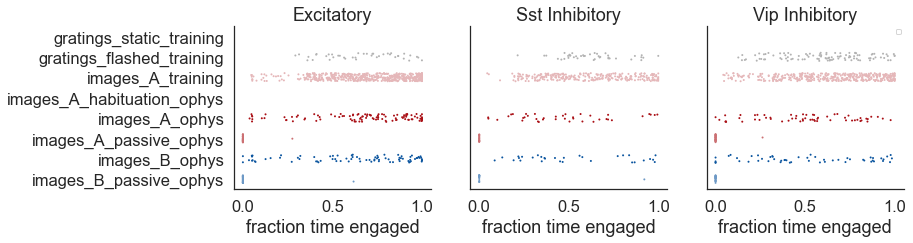

In [741]:
data = full_session_behavior_stats[full_session_behavior_stats.mouse_id.isin(ab_mice)].copy()
data = data[data.stimulus_phase!='images_A_habituation_ophys']
color_map = utils.get_stimulus_phase_color_map(as_rgb=False)
colors = [list(color_map[stage]) for stage in ab_stages]

figsize=(12,3)
fig, ax = plt.subplots(1,3, figsize=figsize, sharey=True, sharex=True)
for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
    ct_data = data[data.cell_type==cell_type]
#     for mouse in ct_data.mouse_id.unique():
#         ax[i] = sns.pointplot(data=ct_data, y='stimulus_phase', x='days_in_stage', order=ab_stages, orient='h', palette=colors, ax=ax[i])
    ax[i] = sns.stripplot(data=ct_data, y='stimulus_phase', x='fraction_engaged', order=ab_stages, 
                          orient='h', palette=colors, dodge=True, jitter=0.2, size=2, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('fraction time engaged')
    ax[i].set_title(cell_type)
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small')

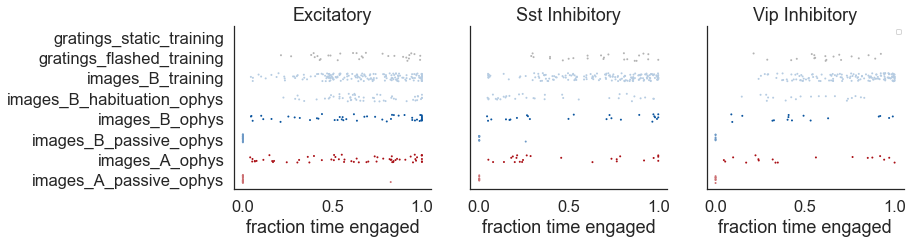

In [742]:
data = full_session_behavior_stats[full_session_behavior_stats.mouse_id.isin(ba_mice)].copy()
data = data[data.stimulus_phase!='images_A_habituation_ophys']
color_map = utils.get_stimulus_phase_color_map(as_rgb=False)
colors = [list(color_map[stage]) for stage in ba_stages]

figsize=(12,3)
fig, ax = plt.subplots(1,3, figsize=figsize, sharey=True, sharex=True)
for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
    ct_data = data[data.cell_type==cell_type]
#     for mouse in ct_data.mouse_id.unique():
#         ax[i] = sns.pointplot(data=ct_data, y='stimulus_phase', x='days_in_stage', order=ab_stages, orient='h', palette=colors, ax=ax[i])
    ax[i] = sns.stripplot(data=ct_data, y='stimulus_phase', x='fraction_engaged', order=ba_stages, 
                          orient='h', palette=colors, dodge=True, jitter=0.2, size=2, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('fraction time engaged')
    ax[i].set_title(cell_type)
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small')

### engaged only stats

In [743]:
%%time 

method = 'stimulus_based'
engaged_only = True
per_image = False

folder = get_save_folder(method, engaged_only, per_image)

behavior_session_ids = behavior_sessions.index.values


original_engaged_behavior_stats, problem_sessions = get_behavior_stats_for_sessions(behavior_session_ids, behavior_sessions, 
                                    method=method, engaged_only=engaged_only, per_image=per_image)


# original_behavior_stats = behavior_stats.copy()
engaged_behavior_stats = original_engaged_behavior_stats.merge(behavior_sessions, on='behavior_session_id')
 # remove 4x2 sessions
engaged_behavior_stats = engaged_behavior_stats[engaged_behavior_stats.project_code!='VisualBehaviorMultiscope4areasx2d']

  0%|                                                                                 | 3/3667 [00:00<02:07, 28.84it/s]

loading for 742008131
loading for 742797917
loading for 743041166
loading for 743660302
loading for 744374168
loading for 745054849


  0%|▏                                                                                | 9/3667 [00:00<02:19, 26.21it/s]

loading for 745355000
loading for 745636848
loading for 746222622
loading for 746928360
loading for 750415261
loading for 750781358


  0%|▍                                                                               | 18/3667 [00:00<02:15, 26.94it/s]

loading for 752002559
loading for 753011296
loading for 753936007
loading for 754509820
loading for 754896244
loading for 755551879


  1%|▍                                                                               | 21/3667 [00:00<02:17, 26.48it/s]

loading for 756106020
loading for 756632727
loading for 757431083
loading for 758162988
loading for 758942142
loading for 759251920


  1%|▌                                                                               | 27/3667 [00:01<02:12, 27.49it/s]

loading for 759756829
loading for 760007428
loading for 760409951
loading for 760698062
loading for 761499069
loading for 761831761


  1%|▋                                                                               | 33/3667 [00:01<02:23, 25.40it/s]

loading for 762178061
loading for 762722108
loading for 763291103
loading for 763980798
loading for 764495320
loading for 764897570


  1%|▊                                                                               | 40/3667 [00:01<02:12, 27.28it/s]

loading for 765396393
loading for 766110635
loading for 766753111
loading for 767275980
loading for 768042187
loading for 768815421


  1%|█                                                                               | 46/3667 [00:01<02:35, 23.27it/s]

loading for 769452637
loading for 769902997
loading for 770244427
loading for 771245588
loading for 772125590
loading for 772658979
loading for 773585522


  1%|█▏                                                                              | 52/3667 [00:02<02:25, 24.90it/s]

loading for 774106776
loading for 774373300
loading for 774422914
loading for 774937388
loading for 775378326


  2%|█▎                                                                              | 58/3667 [00:02<02:30, 24.05it/s]

loading for 775870895
loading for 777082591
loading for 778166125
loading for 778980920
loading for 779818630
loading for 780758836


  2%|█▍                                                                              | 64/3667 [00:02<02:34, 23.29it/s]

loading for 782380778
loading for 784156661
loading for 785426306
loading for 785944233


  2%|█▍                                                                              | 67/3667 [00:02<02:25, 24.80it/s]

loading for 786920476
loading for 788017709
loading for 791257562
loading for 791749028
loading for 792499741
loading for 793129579


  2%|█▌                                                                              | 73/3667 [00:02<02:34, 23.26it/s]

loading for 796032489
loading for 760808911
loading for 761294708
loading for 761730617
loading for 762067130


  2%|█▋                                                                              | 79/3667 [00:03<02:25, 24.63it/s]

loading for 762418364
loading for 763012686
loading for 763661704
loading for 764319580
loading for 764696952
loading for 765208332


  2%|█▊                                                                              | 85/3667 [00:03<02:33, 23.30it/s]

loading for 765793356
loading for 766532213
loading for 766931048
loading for 767730839


  2%|█▉                                                                              | 88/3667 [00:03<02:24, 24.71it/s]

loading for 768450504
loading for 769145833
loading for 769731277
loading for 770215042
loading for 771040969
loading for 771902184


  3%|██                                                                              | 94/3667 [00:03<02:23, 24.88it/s]

loading for 772475707
loading for 773391809
loading for 774120511
loading for 774679623
loading for 775291372


  3%|██▏                                                                            | 100/3667 [00:03<02:14, 26.47it/s]

loading for 776988190
loading for 778010119
loading for 778888558
loading for 779712859
loading for 780479408
loading for 781938213


  3%|██▎                                                                            | 106/3667 [00:04<02:25, 24.49it/s]

loading for 783217873
loading for 783959068
loading for 785382040
loading for 786007435
loading for 786938611


  3%|██▎                                                                            | 110/3667 [00:04<02:17, 25.96it/s]

loading for 789008423
loading for 789870329
loading for 791248943
loading for 791904071
loading for 792680306
loading for 793485674


  3%|██▍                                                                            | 116/3667 [00:04<02:22, 24.96it/s]

loading for 794968300
loading for 795742990
loading for 796052844
loading for 796251270
loading for 798126878
loading for 772286394


  3%|██▋                                                                            | 122/3667 [00:04<02:20, 25.17it/s]

loading for 773510999
loading for 774208555
loading for 774767072
loading for 775344511
loading for 775925580


  3%|██▊                                                                            | 128/3667 [00:05<02:25, 24.28it/s]

loading for 777061425
loading for 778119826
loading for 778959204
loading for 779580423
loading for 780351711


  4%|██▊                                                                            | 131/3667 [00:05<02:44, 21.56it/s]

loading for 781727422
loading for 783059206
loading for 783971649
loading for 785376297


  4%|██▉                                                                            | 137/3667 [00:05<02:54, 20.24it/s]

loading for 785868918
loading for 786841415
loading for 788864720
loading for 789946754
loading for 791278700
loading for 791769447
loading for 792477679


  4%|███                                                                            | 142/3667 [00:05<03:19, 17.65it/s]

loading for 793153175
loading for 794071128
loading for 794673280
loading for 795431009
loading for 796031509


  4%|███▏                                                                           | 148/3667 [00:06<02:52, 20.38it/s]

loading for 797170547
loading for 776156839
loading for 777417642
loading for 778884020
loading for 779111633
loading for 780002890


  4%|███▎                                                                           | 154/3667 [00:06<02:41, 21.72it/s]

loading for 780766304
loading for 783413166
loading for 784173223
loading for 785539951
loading for 786305627


  4%|███▍                                                                           | 160/3667 [00:06<02:23, 24.36it/s]

loading for 788343533
loading for 789221588
loading for 791371899
loading for 791866254
loading for 792661903
loading for 793323654


  5%|███▌                                                                           | 166/3667 [00:06<02:24, 24.22it/s]

loading for 794275479
loading for 794953909
loading for 795838927
loading for 796046197
loading for 796233602


  5%|███▋                                                                           | 172/3667 [00:07<02:21, 24.77it/s]

loading for 796607829
loading for 798145975
loading for 798679618
loading for 799661667
loading for 800202171


  5%|███▊                                                                           | 175/3667 [00:07<02:24, 24.12it/s]

loading for 802406837
loading for 802922968
loading for 803341010
loading for 804748984
loading for 805373492
loading for 806616108


  5%|███▉                                                                           | 181/3667 [00:07<02:24, 24.19it/s]

loading for 807198458
loading for 808107647
loading for 809321253
loading for 791877093
loading for 792689261
loading for 793414389


  5%|████                                                                           | 188/3667 [00:07<02:12, 26.32it/s]

loading for 794295959
loading for 794977379
loading for 795854559
loading for 799051310
loading for 799922316
loading for 800299366


  5%|████▏                                                                          | 194/3667 [00:08<02:18, 25.04it/s]

loading for 800922511
loading for 802988132
loading for 803351520
loading for 804929649
loading for 805535249
loading for 806109931


  5%|████▎                                                                          | 201/3667 [00:08<02:07, 27.27it/s]

loading for 806792366
loading for 807356557
loading for 808324301
loading for 808883789
loading for 809358811
loading for 810405357
loading for 811303680


  6%|████▍                                                                          | 207/3667 [00:08<02:03, 28.04it/s]

loading for 811817467
loading for 812955256
loading for 816417578
loading for 817139151
loading for 818485496
loading for 819094295


  6%|████▌                                                                          | 213/3667 [00:08<02:04, 27.68it/s]

loading for 791875850
loading for 792689257
loading for 793409670
loading for 794295950
loading for 794977383
loading for 795854555


  6%|████▋                                                                          | 219/3667 [00:09<02:20, 24.53it/s]

loading for 799049628
loading for 799919887
loading for 800299362
loading for 800919728


  6%|████▊                                                                          | 222/3667 [00:09<02:14, 25.56it/s]

loading for 802364085
loading for 802988119
loading for 803347004
loading for 805639780
loading for 806296598
loading for 806841326


  6%|████▉                                                                          | 228/3667 [00:09<02:07, 27.01it/s]

loading for 807584876
loading for 808432167
loading for 809027309
loading for 809427293
loading for 811355443
loading for 810584641


  6%|█████                                                                          | 234/3667 [00:09<02:14, 25.50it/s]

loading for 811356875
loading for 811831429
loading for 812566400
loading for 812993078
loading for 813675618


  7%|█████▏                                                                         | 240/3667 [00:09<02:33, 22.38it/s]

loading for 814546737
loading for 815015329
loading for 815511978
loading for 816381516


  7%|█████▏                                                                         | 243/3667 [00:10<02:56, 19.35it/s]

loading for 817182203
loading for 818758572
loading for 819245147


  7%|█████▎                                                                         | 246/3667 [00:10<02:48, 20.28it/s]

loading for 819990491
loading for 821803380
loading for 822409353
loading for 823241007
loading for 823968100


  7%|█████▍                                                                         | 252/3667 [00:10<02:36, 21.84it/s]

loading for 825012995
loading for 825268982
loading for 825888541
loading for 826697158
loading for 827374757


  7%|█████▍                                                                         | 255/3667 [00:10<02:25, 23.48it/s]

loading for 828646658
loading for 829138845
loading for 829578829
loading for 830255592
loading for 830832988


  7%|█████▌                                                                         | 261/3667 [00:10<02:33, 22.21it/s]

loading for 831824426
loading for 832981154
loading for 835444110
loading for 835820832
loading for 836399024
loading for 807533658


  7%|█████▊                                                                         | 267/3667 [00:11<02:27, 23.01it/s]

loading for 808488955
loading for 809095689
loading for 809427297
loading for 809815041
loading for 810598880
loading for 811354008


  7%|█████▉                                                                         | 273/3667 [00:11<02:36, 21.74it/s]

loading for 811830102
loading for 812559803
loading for 813041953
loading for 813737110
loading for 814545306
cant load stats for 814545306
loading for 815045874
cant load stats for 815045874
loading for 815521974


  8%|██████                                                                         | 283/3667 [00:11<01:47, 31.42it/s]

loading for 816394256
loading for 817165094
loading for 818007489
cant load stats for 818007489
loading for 818825644
cant load stats for 818825644
loading for 819323551
loading for 820124540
loading for 821931655


  8%|██████▏                                                                        | 287/3667 [00:11<01:59, 28.37it/s]

loading for 822439453
loading for 823254723
loading for 824894721
loading for 807062523
loading for 808103937


  8%|██████▎                                                                        | 293/3667 [00:12<02:04, 27.17it/s]

loading for 809588395
loading for 810266014
loading for 811140660
loading for 811574124
loading for 812261209
loading for 812796028


  8%|██████▍                                                                        | 299/3667 [00:12<02:13, 25.16it/s]

loading for 814260983
loading for 814749891
loading for 815865807
loading for 817053045
loading for 818539436
loading for 819065377


  8%|██████▌                                                                        | 305/3667 [00:12<02:13, 25.26it/s]

loading for 819497998
loading for 820740400
loading for 821593979
loading for 822159346
loading for 822874578
loading for 823496226


  9%|██████▋                                                                        | 312/3667 [00:12<02:06, 26.44it/s]

loading for 824566587
loading for 825269006
loading for 825902239
loading for 826697162
loading for 827374765
loading for 828669593


  9%|██████▊                                                                        | 318/3667 [00:13<02:00, 27.81it/s]

loading for 829138837
loading for 829714672
loading for 830419451
loading for 830959034
loading for 831905148
loading for 833100683


  9%|██████▉                                                                        | 324/3667 [00:13<02:08, 25.94it/s]

loading for 833946929
loading for 834928595
loading for 835547527
loading for 835940015
loading for 837108110


  9%|███████▏                                                                       | 331/3667 [00:13<01:53, 29.30it/s]

loading for 837512169
loading for 823922942
loading for 824972176
loading for 825527066
loading for 826338809
loading for 826841473
loading for 827977069


  9%|███████▏                                                                       | 334/3667 [00:13<02:02, 27.28it/s]

loading for 828842797
loading for 829281654
loading for 829902556
loading for 830592943
loading for 831259963


  9%|███████▎                                                                       | 341/3667 [00:13<02:00, 27.63it/s]

loading for 832009551
loading for 832522789
loading for 833252272
loading for 834059775
loading for 834886139
loading for 835608988


  9%|███████▍                                                                       | 344/3667 [00:13<02:00, 27.56it/s]

loading for 836099247
loading for 836769386
loading for 837202082
loading for 837629869
loading for 838486964


 10%|███████▌                                                                       | 353/3667 [00:14<01:59, 27.84it/s]

loading for 839220840
loading for 839566028
loading for 839918083
loading for 840583412
loading for 841431760
loading for 841830077


 10%|███████▋                                                                       | 356/3667 [00:14<02:18, 23.90it/s]

loading for 842387217
loading for 842821314
loading for 843397714
loading for 844197868


 10%|███████▋                                                                       | 359/3667 [00:14<02:19, 23.74it/s]

loading for 844880686
loading for 845564445
loading for 846272622
loading for 847022155


 10%|███████▊                                                                       | 362/3667 [00:14<02:33, 21.47it/s]

loading for 847829598
loading for 848519645
loading for 849073265
loading for 849635376


 10%|███████▉                                                                       | 368/3667 [00:15<02:53, 18.99it/s]

loading for 850977753
loading for 851779746
loading for 852468381


 10%|███████▉                                                                       | 370/3667 [00:15<03:24, 16.15it/s]

loading for 853168204
loading for 853875502


 10%|████████                                                                       | 372/3667 [00:15<03:50, 14.29it/s]

loading for 854563857
loading for 855421865


 10%|████████                                                                       | 374/3667 [00:15<03:49, 14.38it/s]

loading for 855973498
loading for 856717282
loading for 857612105
loading for 859065627


 10%|████████▏                                                                      | 379/3667 [00:15<03:07, 17.55it/s]

loading for 859735311
loading for 860665051
loading for 861788094
loading for 863571072
loading for 864139911
loading for 864824449


 10%|████████▎                                                                      | 385/3667 [00:16<02:37, 20.85it/s]

loading for 865482857
loading for 866333758
loading for 867041502
loading for 867977775
loading for 868721114


 11%|████████▍                                                                      | 391/3667 [00:16<02:16, 24.03it/s]

loading for 869639141
loading for 870960890
loading for 872062433
loading for 873002413
loading for 873750535
loading for 874681118


 11%|████████▌                                                                      | 397/3667 [00:16<02:24, 22.65it/s]

loading for 875414332
loading for 876765708
loading for 877346183
loading for 877925816


 11%|████████▌                                                                      | 400/3667 [00:16<02:24, 22.55it/s]

loading for 878671068
loading for 879974471
loading for 880668519
loading for 881278000
loading for 882256127
loading for 882748184


 11%|████████▋                                                                      | 406/3667 [00:16<02:12, 24.54it/s]

loading for 884596128
loading for 885492180
loading for 886322595
loading for 886926935
loading for 888127012
loading for 890157940


 11%|████████▉                                                                      | 412/3667 [00:17<02:13, 24.44it/s]

loading for 820799656
loading for 821837682
loading for 822471786
loading for 823248638
loading for 823922950


 11%|█████████                                                                      | 418/3667 [00:17<02:24, 22.42it/s]

loading for 824992804
loading for 825533866
loading for 826356747
loading for 826846303


 11%|█████████                                                                      | 421/3667 [00:17<02:19, 23.31it/s]

loading for 827944014
loading for 828838236
loading for 829282785
loading for 829877552
loading for 830620126


 12%|█████████▏                                                                     | 427/3667 [00:17<02:21, 22.85it/s]

loading for 832019583
loading for 832540845
loading for 833454420
loading for 834093014
loading for 834908481


 12%|█████████▎                                                                     | 430/3667 [00:18<02:20, 22.99it/s]

loading for 835616503
loading for 836173885
loading for 836777468
loading for 837196627
loading for 837647722


 12%|█████████▍                                                                     | 436/3667 [00:18<02:19, 23.22it/s]

loading for 838496122
loading for 839233516
loading for 839566049
loading for 839931485
loading for 840594518


 12%|█████████▌                                                                     | 442/3667 [00:18<02:18, 23.29it/s]

loading for 841429687
loading for 841842210
loading for 842399625
loading for 842844413


 12%|█████████▌                                                                     | 445/3667 [00:18<02:14, 24.00it/s]

loading for 843400443
loading for 844253929
loading for 845585105
loading for 846316916
loading for 847036338
loading for 847871771


 12%|█████████▋                                                                     | 451/3667 [00:18<02:24, 22.19it/s]

loading for 848599542
loading for 849136474
loading for 849648618
loading for 850985993
loading for 851757903
loading for 852440775


 12%|█████████▊                                                                     | 457/3667 [00:19<02:19, 23.02it/s]

loading for 853496105
loading for 827312851
loading for 828646634
loading for 829128279
loading for 829591790


 13%|█████████▉                                                                     | 463/3667 [00:19<02:15, 23.61it/s]

loading for 830201482
loading for 830867799
loading for 831834820
loading for 832325815
loading for 832990071
loading for 833780803


 13%|██████████                                                                     | 469/3667 [00:19<02:16, 23.40it/s]

loading for 834573980
loading for 835448132
loading for 835865722
loading for 836522259
loading for 837083666
loading for 837443225


 13%|██████████▏                                                                    | 475/3667 [00:19<02:18, 22.98it/s]

loading for 838236165
loading for 839014738
loading for 839479248
loading for 839854553
loading for 840330509
loading for 841185520


 13%|██████████▎                                                                    | 478/3667 [00:20<02:20, 22.63it/s]

loading for 841730873
loading for 842139320
loading for 842792100
loading for 843166865


 13%|██████████▍                                                                    | 484/3667 [00:20<02:43, 19.49it/s]

loading for 844234790
loading for 844875410
loading for 846248008
loading for 847048485


 13%|██████████▍                                                                    | 487/3667 [00:20<02:44, 19.27it/s]

loading for 847867029
loading for 848575992
loading for 849098851
loading for 850976604


 13%|██████████▌                                                                    | 491/3667 [00:20<03:14, 16.33it/s]

loading for 853266283
loading for 831129394
loading for 832021447
loading for 832544149


 14%|██████████▋                                                                    | 496/3667 [00:21<02:54, 18.15it/s]

loading for 833328750
loading for 834087859
loading for 834903060
loading for 835557296
loading for 836166694


 14%|██████████▊                                                                    | 502/3667 [00:21<02:24, 21.94it/s]

loading for 836761653
loading for 837192567
loading for 837638916
loading for 838496126
loading for 839234289
loading for 839566045


 14%|██████████▉                                                                    | 509/3667 [00:21<02:05, 25.18it/s]

loading for 839939986
loading for 840594514
loading for 841148118
loading for 841707177
loading for 842174399
loading for 842729895


 14%|███████████                                                                    | 512/3667 [00:21<02:13, 23.70it/s]

loading for 843203333
loading for 844164376
loading for 844849972
loading for 845441512
loading for 846194950


 14%|███████████▏                                                                   | 519/3667 [00:22<02:02, 25.78it/s]

loading for 846929750
loading for 848503804
loading for 853526948
loading for 834587823
loading for 835451471
loading for 835867850
loading for 836522245


 14%|███████████▎                                                                   | 525/3667 [00:22<02:06, 24.89it/s]

loading for 837083657
loading for 837449223
loading for 838203784
loading for 838998362
loading for 839468826
loading for 839837380


 14%|███████████▍                                                                   | 531/3667 [00:22<02:07, 24.58it/s]

loading for 840330501
loading for 841191836
loading for 841730868
loading for 842139310
loading for 842792094


 15%|███████████▌                                                                   | 537/3667 [00:22<02:17, 22.75it/s]

loading for 843178897
loading for 844027594
loading for 844608277
loading for 845409652


 15%|███████████▋                                                                   | 540/3667 [00:22<02:24, 21.68it/s]

loading for 846051276
loading for 846791195
loading for 847613846
loading for 848272657


 15%|███████████▋                                                                   | 543/3667 [00:23<02:45, 18.92it/s]

loading for 848938321
loading for 849525884
loading for 850817466
loading for 851563931


 15%|███████████▊                                                                   | 551/3667 [00:23<02:17, 22.62it/s]

loading for 852235678
loading for 852974537
loading for 853505213
loading for 854283407
loading for 855826937
loading for 857230827


 15%|███████████▉                                                                   | 554/3667 [00:23<02:12, 23.52it/s]

loading for 837658854
loading for 838515247
loading for 839219841
loading for 839565422
loading for 839912316
loading for 840581827


 15%|████████████                                                                   | 560/3667 [00:23<02:08, 24.13it/s]

loading for 841426832
loading for 841827774
loading for 842385277
loading for 842819933
loading for 843400453


 15%|████████████▏                                                                  | 566/3667 [00:24<02:06, 24.48it/s]

loading for 844199758
loading for 844908261
loading for 845572044
loading for 846331423
loading for 847036328
loading for 847874940


 16%|████████████▎                                                                  | 572/3667 [00:24<02:14, 23.09it/s]

loading for 848613406
loading for 849147676
loading for 849651275
loading for 850989832


 16%|████████████▍                                                                  | 575/3667 [00:24<02:10, 23.77it/s]

loading for 851773928
loading for 852451567
loading for 855200229
loading for 837654533
loading for 838483140


 16%|████████████▍                                                                  | 578/3667 [00:24<02:28, 20.73it/s]

loading for 839219845
loading for 839565426
loading for 839914270
loading for 840581823


 16%|████████████▌                                                                  | 584/3667 [00:25<02:40, 19.26it/s]

loading for 841426857
loading for 841830096
loading for 842385266
loading for 842819929
loading for 843401580


 16%|████████████▋                                                                  | 590/3667 [00:25<02:27, 20.87it/s]

loading for 844199766
loading for 844891885
loading for 845572039
loading for 846016059
loading for 846750050


 16%|████████████▊                                                                  | 593/3667 [00:25<02:41, 19.05it/s]

loading for 847660741
loading for 848348215
loading for 848943191
loading for 849494762


 16%|████████████▊                                                                  | 597/3667 [00:25<02:55, 17.47it/s]

loading for 850807174
loading for 851542477
loading for 852229360
loading for 853025613


 16%|████████████▉                                                                  | 602/3667 [00:25<02:42, 18.86it/s]

loading for 855446545
loading for 855866701
loading for 856467236
loading for 857367017


 16%|█████████████                                                                  | 605/3667 [00:26<02:26, 20.88it/s]

loading for 858029487
loading for 858967789
loading for 859793880
loading for 860533862
loading for 864068649


 17%|█████████████▏                                                                 | 611/3667 [00:26<02:12, 23.15it/s]

loading for 840598877
loading for 841466830
loading for 841851097
loading for 842419799
loading for 842840144


 17%|█████████████▏                                                                 | 614/3667 [00:26<02:16, 22.44it/s]

loading for 843423171
loading for 844229895
loading for 844945060
loading for 845594684


 17%|█████████████▎                                                                 | 620/3667 [00:26<02:27, 20.71it/s]

loading for 846284880
loading for 847048490
loading for 847838131
loading for 848526511
loading for 848910243


 17%|█████████████▍                                                                 | 626/3667 [00:27<02:19, 21.75it/s]

loading for 849485548
loading for 850810858
loading for 851471401
loading for 852202150


 17%|█████████████▌                                                                 | 629/3667 [00:27<02:16, 22.30it/s]

loading for 852966248
loading for 853875514
loading for 854621677
loading for 855424348
loading for 857340041


 17%|█████████████▋                                                                 | 635/3667 [00:27<02:13, 22.69it/s]

loading for 857987666
loading for 858974731
loading for 859775117
loading for 863610582
loading for 868070216


 17%|█████████████▋                                                                 | 638/3667 [00:27<02:15, 22.39it/s]

loading for 868658294
loading for 869559097
loading for 850978904
loading for 851802107
loading for 852457995


 18%|█████████████▊                                                                 | 644/3667 [00:27<02:20, 21.58it/s]

loading for 853257103
loading for 853793068
loading for 854602288
loading for 855476794
loading for 856010720


 18%|██████████████                                                                 | 650/3667 [00:28<02:17, 21.90it/s]

loading for 856732195
loading for 857547928
loading for 858273959
loading for 859054070
loading for 859802280
loading for 860894659


 18%|██████████████▏                                                                | 656/3667 [00:28<02:17, 21.90it/s]

loading for 861794694
loading for 862716894
loading for 863559318
loading for 864280264


 18%|██████████████▎                                                                | 662/3667 [00:28<02:01, 24.79it/s]

loading for 865544821
loading for 866336764
loading for 867098393
loading for 867945660
loading for 868819048
loading for 869621595


 18%|██████████████▎                                                                | 665/3667 [00:28<01:59, 25.15it/s]

loading for 870960908
loading for 872107505
loading for 873813922
loading for 874808131
loading for 876821717
loading for 854533487


 18%|██████████████▍                                                                | 671/3667 [00:28<01:54, 26.18it/s]

loading for 855504136
loading for 856002607
loading for 856732191
loading for 857555456
loading for 858240891


 18%|██████████████▌                                                                | 677/3667 [00:29<01:52, 26.50it/s]

loading for 859032026
loading for 859791558
loading for 860752803
loading for 861794699
loading for 862701465
loading for 863571054


 19%|██████████████▋                                                                | 683/3667 [00:29<02:03, 24.10it/s]

loading for 864137547
loading for 864839176
loading for 865581941
loading for 866287088
loading for 866950070


 19%|██████████████▊                                                                | 689/3667 [00:29<02:05, 23.78it/s]

loading for 867615529
loading for 868540333
loading for 869319414
loading for 870660821
loading for 871808378


 19%|██████████████▉                                                                | 692/3667 [00:29<02:08, 23.20it/s]

loading for 872646068
loading for 873517635
loading for 874324533
loading for 875471358
cant load stats for 875471358
loading for 876574139
loading for 850970486


 19%|███████████████                                                                | 699/3667 [00:30<01:54, 25.96it/s]

loading for 851843550
loading for 852507945
loading for 853260939
loading for 853886146
loading for 855459012
loading for 855980937


 19%|███████████████▏                                                               | 705/3667 [00:30<02:02, 24.11it/s]

loading for 856719615
loading for 857504898
loading for 858250763
loading for 859049298
loading for 859784868


 19%|███████████████▎                                                               | 708/3667 [00:30<02:08, 23.01it/s]

loading for 860836980
loading for 861789935
loading for 862716913
loading for 863614836
loading for 864260028


 19%|███████████████▍                                                               | 714/3667 [00:30<02:05, 23.61it/s]

loading for 864813130
loading for 865460179
loading for 866296478
loading for 866999677
loading for 867615541
loading for 868555361


 20%|███████████████▌                                                               | 720/3667 [00:30<01:59, 24.73it/s]

loading for 869334643
loading for 870592115
loading for 871808394
loading for 872626160
loading for 873695653
loading for 874699922


 20%|███████████████▋                                                               | 726/3667 [00:31<02:03, 23.76it/s]

loading for 875440936
loading for 876678452
loading for 877617747
loading for 878120101
loading for 879037269
loading for 880046522


 20%|███████████████▊                                                               | 732/3667 [00:31<02:03, 23.67it/s]

loading for 880784794
loading for 882256117
loading for 854528256
loading for 855503335
loading for 856002613
loading for 856732213


 20%|███████████████▉                                                               | 738/3667 [00:31<02:15, 21.64it/s]

loading for 857555461
loading for 858240896
loading for 859032044
loading for 859791563


 20%|███████████████▉                                                               | 741/3667 [00:31<02:10, 22.35it/s]

loading for 860752819
loading for 861794704
loading for 862701503
loading for 863559327


 20%|████████████████                                                               | 747/3667 [00:32<02:14, 21.78it/s]

loading for 864125430
loading for 864839160
loading for 865580429
loading for 866287143
loading for 867082086


 21%|████████████████▏                                                              | 753/3667 [00:32<02:04, 23.41it/s]

loading for 868004770
loading for 868747797
loading for 872158938
loading for 873015934
loading for 873824951


 21%|████████████████▎                                                              | 756/3667 [00:32<01:59, 24.37it/s]

loading for 874747892
loading for 875444395
loading for 876857698
loading for 878159171
loading for 879037253
loading for 880201859


 21%|████████████████▍                                                              | 765/3667 [00:32<01:47, 26.89it/s]

loading for 880776648
loading for 881413102
loading for 882446265
loading for 882831297
loading for 883863892
loading for 884808160


 21%|████████████████▌                                                              | 769/3667 [00:33<01:42, 28.23it/s]

loading for 885644181
loading for 886440437
loading for 887165432
loading for 888282547
loading for 858104885
loading for 858900546


 21%|████████████████▋                                                              | 775/3667 [00:33<01:49, 26.36it/s]

loading for 859601488
loading for 860247669
loading for 861717498
loading for 862339401
loading for 863365105
loading for 863966979


 21%|████████████████▊                                                              | 781/3667 [00:33<01:51, 25.82it/s]

loading for 864665192
loading for 865114696
loading for 865887829
loading for 866906696
loading for 867505993
loading for 868511825


 21%|████████████████▉                                                              | 787/3667 [00:33<01:58, 24.26it/s]

loading for 869198966
loading for 870481699
loading for 871723063
loading for 872607293


 22%|█████████████████                                                              | 790/3667 [00:33<01:59, 24.10it/s]

loading for 873440431
loading for 874324527
loading for 875020211
loading for 876448536
loading for 877855866


 22%|█████████████████▏                                                             | 796/3667 [00:34<02:01, 23.59it/s]

loading for 878615859
loading for 879846629
loading for 880581639
loading for 881204796
loading for 882289836
loading for 883851453


 22%|█████████████████▎                                                             | 803/3667 [00:34<01:51, 25.73it/s]

loading for 884598044
loading for 885404075
loading for 886376835
loading for 888213949
loading for 890021100


 22%|█████████████████▎                                                             | 806/3667 [00:34<01:49, 26.09it/s]

loading for 893362730
loading for 894103623
loading for 895022326
loading for 895562386
loading for 896561264
loading for 898432373


 22%|█████████████████▍                                                             | 812/3667 [00:34<01:51, 25.70it/s]

loading for 898874650
loading for 899390684
loading for 901999401
loading for 903708760
loading for 904574580


 22%|█████████████████▌                                                             | 818/3667 [00:35<02:00, 23.68it/s]

loading for 906472625
loading for 907053876
loading for 907900077
loading for 908533370


 22%|█████████████████▋                                                             | 821/3667 [00:35<02:03, 23.05it/s]

loading for 910207192
loading for 910829549
loading for 911904717
loading for 913673477
loading for 914211263


 23%|█████████████████▊                                                             | 827/3667 [00:35<02:07, 22.26it/s]

loading for 914705301
loading for 915418411
loading for 916403851
loading for 918103715


 23%|█████████████████▉                                                             | 830/3667 [00:35<02:16, 20.75it/s]

loading for 923410363
loading for 924472023
loading for 925084998
loading for 858098100


 23%|█████████████████▉                                                             | 833/3667 [00:35<02:29, 19.01it/s]

loading for 858891746
loading for 859601496
loading for 860247677
loading for 861715805
loading for 862326321


 23%|██████████████████                                                             | 838/3667 [00:36<02:29, 18.95it/s]

loading for 863361852
loading for 863966966
loading for 864656758
loading for 865114705
loading for 865883182


 23%|██████████████████▏                                                            | 844/3667 [00:36<02:19, 20.25it/s]

loading for 866912923
loading for 867553178
loading for 868521085
loading for 869223965
loading for 870473396


 23%|██████████████████▎                                                            | 850/3667 [00:36<02:01, 23.22it/s]

loading for 871723073
loading for 872607297
loading for 873440438
loading for 874324523
loading for 875020169


 23%|██████████████████▍                                                            | 853/3667 [00:36<02:06, 22.32it/s]

loading for 877447964
loading for 878282369
loading for 880231156
loading for 880780889
loading for 881427978


 23%|██████████████████▌                                                            | 859/3667 [00:36<01:58, 23.74it/s]

loading for 882434675
loading for 882827577
loading for 884888379
loading for 885739915
loading for 886446971


 24%|██████████████████▋                                                            | 865/3667 [00:37<01:57, 23.82it/s]

loading for 887236947
loading for 888301437
loading for 889559462
loading for 890374401
loading for 891792255
loading for 892663103


 24%|██████████████████▊                                                            | 871/3667 [00:37<01:53, 24.73it/s]

loading for 893600606
loading for 858098096
loading for 859064345
loading for 859735301
loading for 860650174


 24%|██████████████████▊                                                            | 874/3667 [00:37<01:53, 24.67it/s]

loading for 861785387
loading for 862752139
loading for 863571063
loading for 864137543
loading for 864820740


 24%|██████████████████▉                                                            | 880/3667 [00:37<02:04, 22.44it/s]

loading for 865463877
loading for 866319121
loading for 867036286
loading for 867961842


 24%|███████████████████                                                            | 886/3667 [00:38<01:58, 23.51it/s]

loading for 868649156
loading for 869623240
loading for 870935137
loading for 872035204
loading for 872979404


 24%|███████████████████▏                                                           | 889/3667 [00:38<01:52, 24.70it/s]

loading for 873733206
loading for 874654275
loading for 875385898
loading for 876737438
loading for 877558819
loading for 878233751


 24%|███████████████████▎                                                           | 895/3667 [00:38<01:49, 25.40it/s]

loading for 879003588
loading for 880183901
loading for 880769249
loading for 881413092
loading for 882393175
loading for 883857874


 25%|███████████████████▍                                                           | 901/3667 [00:38<01:49, 25.23it/s]

loading for 884800923
loading for 885589846
loading for 886437461
loading for 887183674
loading for 888263147


 25%|███████████████████▌                                                           | 907/3667 [00:38<01:50, 25.00it/s]

loading for 889436433
loading for 890459182
loading for 891759060
loading for 892589687
loading for 893433252
loading for 894215832


 25%|███████████████████▋                                                           | 913/3667 [00:39<01:51, 24.61it/s]

loading for 896543695
loading for 898493295
loading for 898889632
loading for 899400259


 25%|███████████████████▋                                                           | 916/3667 [00:39<01:49, 25.12it/s]

loading for 900228074
loading for 901102440
loading for 902021938
loading for 902822517
loading for 904630713
loading for 907035941


 25%|███████████████████▊                                                           | 922/3667 [00:39<02:04, 22.05it/s]

loading for 907995409
loading for 908564883
loading for 909363995
loading for 910249989


 25%|███████████████████▉                                                           | 925/3667 [00:39<02:13, 20.49it/s]

loading for 911361470
loading for 911947271
loading for 912570316
loading for 913710476


 25%|████████████████████                                                           | 932/3667 [00:40<02:02, 22.33it/s]

loading for 914230230
loading for 914715937
loading for 915448786
loading for 916450856
loading for 917331220


 25%|████████████████████▏                                                          | 935/3667 [00:40<01:57, 23.24it/s]

loading for 918202290
loading for 918900907
loading for 919634924
loading for 920541932
loading for 921601457
loading for 922572837


 26%|████████████████████▎                                                          | 941/3667 [00:40<01:52, 24.23it/s]

loading for 923474474
loading for 924575646
loading for 925033179
loading for 926393722
loading for 927449068
loading for 928400507


 26%|████████████████████▍                                                          | 947/3667 [00:40<02:01, 22.30it/s]

loading for 929341697
loading for 929818797
loading for 931566300
loading for 932611698


 26%|████████████████████▍                                                          | 950/3667 [00:40<02:04, 21.90it/s]

loading for 933504759
loading for 934610593
loading for 935811563
loading for 937416292
loading for 938377224


 26%|████████████████████▌                                                          | 956/3667 [00:41<02:14, 20.10it/s]

loading for 939538572
loading for 862786889
loading for 863627986
loading for 864248647
loading for 865463863


 26%|████████████████████▋                                                          | 962/3667 [00:41<01:56, 23.16it/s]

loading for 866103829
loading for 867056914
loading for 868008761
loading for 868709715
loading for 871033938
loading for 872127292


 26%|████████████████████▊                                                          | 968/3667 [00:41<01:47, 25.02it/s]

loading for 873051801
loading for 873781580
loading for 874747887
loading for 875479783
loading for 876836773
loading for 877614747


 27%|████████████████████▉                                                          | 974/3667 [00:41<01:44, 25.69it/s]

loading for 878282360
loading for 879094361
loading for 880191852
loading for 880775450
loading for 881419102


 27%|█████████████████████                                                          | 977/3667 [00:41<01:53, 23.64it/s]

loading for 882388591
loading for 883704230
loading for 884677929
loading for 886239982


 27%|█████████████████████▏                                                         | 983/3667 [00:42<02:03, 21.70it/s]

loading for 886873295
loading for 889155682
loading for 890051221
loading for 891487953


 27%|█████████████████████▏                                                         | 986/3667 [00:42<01:56, 23.10it/s]

loading for 892410834
loading for 893356870
loading for 894209378
loading for 894987969


 27%|█████████████████████▎                                                         | 989/3667 [00:42<02:18, 19.31it/s]

loading for 896526348
loading for 898453640
loading for 898889612
loading for 899452222
loading for 901380774


 27%|█████████████████████▍                                                         | 995/3667 [00:42<02:03, 21.65it/s]

loading for 902270195
loading for 903070554
loading for 904011865
loading for 906695544
loading for 907356161
loading for 908908617


 27%|█████████████████████▎                                                        | 1001/3667 [00:43<01:55, 23.17it/s]

loading for 911021831
loading for 911522814
loading for 912242958
loading for 912918028
loading for 913898214


 27%|█████████████████████▍                                                        | 1007/3667 [00:43<02:01, 21.87it/s]

loading for 914405292
loading for 914868296
loading for 915690421
loading for 916623819


 28%|█████████████████████▍                                                        | 1010/3667 [00:43<02:03, 21.60it/s]

loading for 917581144
loading for 918454518
loading for 919073273
loading for 919973223
loading for 920836124
loading for 921879374


 28%|█████████████████████▌                                                        | 1016/3667 [00:43<01:54, 23.15it/s]

loading for 922942074
loading for 923786645
loading for 924729242
loading for 926769977
loading for 927745870
loading for 928717396


 28%|█████████████████████▊                                                        | 1023/3667 [00:43<01:54, 23.14it/s]

loading for 929524399
loading for 932078145
loading for 932975404
loading for 934075944


 28%|█████████████████████▊                                                        | 1026/3667 [00:44<01:58, 22.32it/s]

loading for 934900274
loading for 936033313
loading for 937825662
loading for 938991494
loading for 940243685


 28%|█████████████████████▉                                                        | 1032/3667 [00:44<01:49, 24.08it/s]

loading for 940796859
loading for 941946991
loading for 942448113
loading for 945277725
loading for 946172858
loading for 947503956


 28%|██████████████████████                                                        | 1038/3667 [00:44<01:46, 24.72it/s]

loading for 948341757
loading for 862479694
loading for 863414647
loading for 864000195
loading for 864729508


 28%|██████████████████████▏                                                       | 1041/3667 [00:44<02:00, 21.73it/s]

loading for 865288307
loading for 865953304
loading for 866971252
loading for 867649878


 28%|██████████████████████▏                                                       | 1044/3667 [00:44<02:13, 19.58it/s]

loading for 868546763
loading for 869311954
loading for 870592103


 29%|██████████████████████▎                                                       | 1049/3667 [00:45<02:22, 18.41it/s]

loading for 871782387
loading for 872720256
loading for 873530279
loading for 874295478


 29%|██████████████████████▎                                                       | 1051/3667 [00:45<02:50, 15.32it/s]

loading for 875020129
loading for 876521253
loading for 877346192


 29%|██████████████████████▍                                                       | 1055/3667 [00:45<03:20, 13.00it/s]

loading for 877938181
loading for 878671074
loading for 879958654


 29%|██████████████████████▌                                                       | 1058/3667 [00:45<02:50, 15.34it/s]

loading for 880647168
loading for 881253316
loading for 882233951
loading for 882679635
loading for 883632948


 29%|██████████████████████▋                                                       | 1064/3667 [00:46<02:21, 18.34it/s]

loading for 884560033
loading for 885418521
loading for 886262841
loading for 886900197
loading for 889183454
loading for 890054551


 29%|██████████████████████▊                                                       | 1073/3667 [00:46<01:52, 23.13it/s]

loading for 891504476
loading for 892413871
loading for 893359124
loading for 894215849
loading for 894994111
loading for 896543686


 29%|██████████████████████▉                                                       | 1076/3667 [00:46<01:49, 23.77it/s]

loading for 898461372
loading for 898890800
loading for 899461485
loading for 902028378
loading for 902822538
loading for 904625819


 30%|███████████████████████                                                       | 1082/3667 [00:46<01:50, 23.48it/s]

loading for 907035965
loading for 907995400
loading for 908564873
loading for 910249985
loading for 911361486
loading for 912159483


 30%|███████████████████████▏                                                      | 1089/3667 [00:47<01:34, 27.30it/s]

loading for 913921659
loading for 914411174
loading for 914871449
loading for 915739774
loading for 916704634
loading for 917595407


 30%|███████████████████████▎                                                      | 1095/3667 [00:47<01:36, 26.56it/s]

loading for 918474069
loading for 919104267
loading for 920015895
loading for 920839478
loading for 922012422
loading for 923834852


 30%|███████████████████████▍                                                      | 1101/3667 [00:47<01:35, 26.85it/s]

loading for 924759623
loading for 925603486
loading for 927905748
loading for 929551055
loading for 935301109
loading for 936273485
loading for 862730050


 30%|███████████████████████▌                                                      | 1110/3667 [00:47<01:34, 27.02it/s]

loading for 863657189
loading for 864236370
loading for 864809053
loading for 865443418
loading for 866300303
loading for 867045079


 30%|███████████████████████▋                                                      | 1114/3667 [00:48<01:30, 28.30it/s]

loading for 867977763
loading for 868704504
loading for 869615887
loading for 870960882
loading for 872864902
loading for 873729011
loading for 874691139


 31%|███████████████████████▊                                                      | 1120/3667 [00:48<01:29, 28.30it/s]

loading for 875402170
loading for 876701397
loading for 877524045
loading for 878137744
loading for 879003593
loading for 880088387


 31%|███████████████████████▉                                                      | 1126/3667 [00:48<01:37, 26.01it/s]

loading for 881416618
loading for 882373648
loading for 882785348
loading for 883984332
loading for 884750162


 31%|████████████████████████                                                      | 1132/3667 [00:48<01:49, 23.17it/s]

loading for 885540222
loading for 886440427
loading for 886931452
loading for 888282572


 31%|████████████████████████▏                                                     | 1135/3667 [00:48<01:50, 22.90it/s]

loading for 889443507
loading for 890355790
loading for 891618314
loading for 892491402
loading for 893540605


 31%|████████████████████████▎                                                     | 1141/3667 [00:49<01:43, 24.35it/s]

loading for 894466746
loading for 895241719
loading for 895877676
loading for 896969091
loading for 898658063
loading for 899685557


 31%|████████████████████████▍                                                     | 1147/3667 [00:49<01:44, 24.20it/s]

loading for 900226857
loading for 901340457
loading for 902244344
loading for 902962312
loading for 904899490


 31%|████████████████████████▌                                                     | 1153/3667 [00:49<01:46, 23.54it/s]

loading for 906641078
loading for 908092560
loading for 910381299
loading for 911016296
loading for 911541959


 32%|████████████████████████▌                                                     | 1156/3667 [00:49<01:55, 21.67it/s]

loading for 912902650
loading for 913850438
loading for 914336989
loading for 914828503
loading for 915609195


 32%|████████████████████████▋                                                     | 1162/3667 [00:50<01:54, 21.94it/s]

loading for 916614400
loading for 917500273
loading for 918451984
loading for 919022193
loading for 919895633


 32%|████████████████████████▊                                                     | 1165/3667 [00:50<01:48, 23.02it/s]

loading for 920807985
loading for 921873454
loading for 923757660
loading for 924739087
loading for 926621793


 32%|████████████████████████▉                                                     | 1171/3667 [00:50<02:03, 20.22it/s]

loading for 927652117
loading for 928654503
loading for 929522558
loading for 930344462


 32%|████████████████████████▉                                                     | 1174/3667 [00:50<02:12, 18.85it/s]

loading for 932960096
loading for 933939891
loading for 935038748
loading for 936159430


 32%|█████████████████████████                                                     | 1178/3667 [00:51<02:19, 17.89it/s]

loading for 937645038
loading for 938729036
loading for 940017429
loading for 941802699


 32%|█████████████████████████▏                                                    | 1183/3667 [00:51<02:19, 17.82it/s]

loading for 942814025
loading for 943833533
loading for 945033994
loading for 947336783


 32%|█████████████████████████▎                                                    | 1188/3667 [00:51<02:00, 20.53it/s]

loading for 948225040
loading for 949348713
loading for 950188644
loading for 862245493
loading for 863368489
loading for 863966974


 33%|█████████████████████████▍                                                    | 1194/3667 [00:51<01:47, 23.11it/s]

loading for 864665204
loading for 865131331
loading for 865887821
loading for 866909432
loading for 867521015
loading for 868513545


 33%|█████████████████████████▌                                                    | 1200/3667 [00:51<01:43, 23.95it/s]

loading for 869214215
loading for 870481685
loading for 871728970
loading for 872609185
loading for 873449838
loading for 874333572


 33%|█████████████████████████▋                                                    | 1206/3667 [00:52<01:34, 25.91it/s]

loading for 875020175
loading for 876448528
loading for 877855879
loading for 878615867
loading for 879854787
loading for 880590869


 33%|█████████████████████████▊                                                    | 1212/3667 [00:52<01:35, 25.82it/s]

loading for 881210690
loading for 882291265
loading for 882736270
loading for 883857883
loading for 884605735
loading for 885404024


 33%|█████████████████████████▉                                                    | 1218/3667 [00:52<01:43, 23.76it/s]

loading for 886382175
loading for 888218684
loading for 890021090
loading for 893608687


 33%|█████████████████████████▉                                                    | 1221/3667 [00:52<01:40, 24.25it/s]

loading for 894495169
loading for 895278567
loading for 895809864
loading for 896882463
loading for 898665096
loading for 898938920


 33%|██████████████████████████                                                    | 1227/3667 [00:53<01:42, 23.79it/s]

loading for 900227468
loading for 901316636
loading for 902211897
loading for 902995627
loading for 903977177


 34%|██████████████████████████▏                                                   | 1233/3667 [00:53<01:48, 22.38it/s]

loading for 904922800
loading for 906658064
loading for 907327499
loading for 908122381


 34%|██████████████████████████▎                                                   | 1236/3667 [00:53<01:45, 23.07it/s]

loading for 912640306
loading for 866287136
loading for 867036293
loading for 867961854
loading for 868653129


 34%|██████████████████████████▍                                                   | 1242/3667 [00:53<01:44, 23.27it/s]

loading for 869623244
loading for 870935142
loading for 872043024
loading for 872979424
loading for 873739031


 34%|██████████████████████████▍                                                   | 1245/3667 [00:53<01:43, 23.35it/s]

loading for 874654280
loading for 875385921
loading for 876737442
loading for 877558833
loading for 878245978


 34%|██████████████████████████▌                                                   | 1251/3667 [00:54<01:50, 21.77it/s]

loading for 878993255
loading for 880191880
loading for 880775454
loading for 881425509
loading for 882401590


 34%|██████████████████████████▋                                                   | 1257/3667 [00:54<01:51, 21.54it/s]

loading for 883756380
loading for 884552901
loading for 885410929
loading for 886257016


 34%|██████████████████████████▊                                                   | 1260/3667 [00:54<01:51, 21.60it/s]

loading for 886838602
loading for 888033338
loading for 889175194
loading for 890033129
loading for 891446789
loading for 892387261


 35%|██████████████████████████▉                                                   | 1266/3667 [00:54<01:42, 23.47it/s]

loading for 893344360
loading for 894083470
loading for 898440124
loading for 866128606
loading for 866971269


 35%|███████████████████████████                                                   | 1272/3667 [00:55<01:57, 20.33it/s]

loading for 867645566
loading for 868531777
loading for 869311972
loading for 870579061


 35%|███████████████████████████                                                   | 1275/3667 [00:55<01:52, 21.20it/s]

loading for 871782397
loading for 872690218
loading for 873537911
loading for 874416985
loading for 875020203
loading for 876651891


 35%|███████████████████████████▏                                                  | 1281/3667 [00:55<01:48, 22.01it/s]

loading for 877487375
loading for 878179382
loading for 878771403
loading for 879969002


 35%|███████████████████████████▎                                                  | 1284/3667 [00:55<02:04, 19.09it/s]

loading for 880644824
loading for 881251187
loading for 882219267
loading for 882677813


 35%|███████████████████████████▍                                                  | 1290/3667 [00:56<01:58, 20.01it/s]

loading for 883632956
loading for 884560064
loading for 885410934
loading for 886250995
loading for 887006111


 35%|███████████████████████████▌                                                  | 1293/3667 [00:56<01:57, 20.26it/s]

loading for 888163519
loading for 889388078
loading for 890625596
loading for 891605682


 35%|███████████████████████████▋                                                  | 1299/3667 [00:56<01:57, 20.13it/s]

loading for 892526544
loading for 893488330
loading for 894368064
loading for 870987812


 36%|███████████████████████████▋                                                  | 1302/3667 [00:56<01:48, 21.71it/s]

loading for 872953842
loading for 873774125
loading for 874790261
loading for 875207834
loading for 876821726
loading for 877603209


 36%|███████████████████████████▊                                                  | 1309/3667 [00:56<01:36, 24.55it/s]

loading for 878245989
loading for 879003606
loading for 880088400
loading for 881416637
loading for 882373653
loading for 882781075


 36%|███████████████████████████▉                                                  | 1315/3667 [00:57<01:43, 22.76it/s]

loading for 883986743
loading for 884776248
loading for 885540237
loading for 886442346


 36%|████████████████████████████                                                  | 1318/3667 [00:57<01:38, 23.95it/s]

loading for 886946944
loading for 888295170
loading for 889468960
loading for 890408602
loading for 891635659


 36%|████████████████████████████▏                                                 | 1324/3667 [00:57<01:39, 23.49it/s]

loading for 891635667
loading for 892510304
loading for 893560763
loading for 894481319
loading for 895248933
loading for 895896343


 36%|████████████████████████████▏                                                 | 1327/3667 [00:57<01:43, 22.69it/s]

loading for 896995828
loading for 898667252
loading for 899700579
loading for 900231059


 36%|████████████████████████████▎                                                 | 1333/3667 [00:58<01:52, 20.77it/s]

loading for 901363879
loading for 902260156
loading for 902975505
loading for 904922810
loading for 906668549


 36%|████████████████████████████▍                                                 | 1336/3667 [00:58<01:54, 20.44it/s]

loading for 908104455
loading for 910393217
loading for 911016285
loading for 911541950


 37%|████████████████████████████▌                                                 | 1342/3667 [00:58<01:45, 22.11it/s]

loading for 912223787
loading for 912902619
loading for 913850450
loading for 914339617
loading for 914831000


 37%|████████████████████████████▋                                                 | 1348/3667 [00:58<01:38, 23.45it/s]

loading for 915609216
loading for 916617096
loading for 917500256
loading for 918451994
loading for 919025442
loading for 920901263
loading for 921979060


 37%|████████████████████████████▊                                                 | 1355/3667 [00:58<01:29, 25.72it/s]

loading for 923757653
loading for 924739774
loading for 926621788
loading for 927652110
loading for 928654491
loading for 929524423


 37%|████████████████████████████▉                                                 | 1361/3667 [00:59<01:32, 25.03it/s]

loading for 930344469
loading for 932960104
loading for 933954934
loading for 935045761
loading for 936083473
loading for 937706038


 37%|█████████████████████████████                                                 | 1364/3667 [00:59<01:30, 25.53it/s]

loading for 938794488
loading for 939985541
loading for 940755050
loading for 941734036


 37%|█████████████████████████████▏                                                | 1370/3667 [00:59<01:42, 22.43it/s]

loading for 942767530
loading for 944125005
loading for 945075740
loading for 947988590
loading for 949201674
loading for 949973686


 38%|█████████████████████████████▎                                                | 1376/3667 [00:59<01:36, 23.69it/s]

loading for 951520319
loading for 952554548
loading for 953982960
loading for 956010809
loading for 957032492
loading for 958234742


 38%|█████████████████████████████▍                                                | 1382/3667 [01:00<01:31, 25.05it/s]

loading for 958888263
loading for 959681045
loading for 875126982
loading for 876823447
loading for 877605077
loading for 878245966


 38%|█████████████████████████████▌                                                | 1388/3667 [01:00<01:30, 25.29it/s]

loading for 879074585
loading for 880174939
loading for 881450253
loading for 882426675
loading for 882833335
loading for 884004562


 38%|█████████████████████████████▋                                                | 1396/3667 [01:00<01:20, 28.04it/s]

loading for 884776271
loading for 885598412
loading for 886446962
loading for 886953901
loading for 888298590
loading for 889478291


 38%|█████████████████████████████▊                                                | 1399/3667 [01:00<01:22, 27.45it/s]

loading for 890408635
loading for 891635663
loading for 892525019
loading for 893560739
loading for 894481291


 38%|█████████████████████████████▉                                                | 1405/3667 [01:00<01:30, 24.96it/s]

loading for 895262003
loading for 895896368
loading for 896995823
loading for 898682070
loading for 899742869


 38%|██████████████████████████████                                                | 1411/3667 [01:01<01:31, 24.67it/s]

loading for 901424076
loading for 902328548
loading for 903098779
loading for 904954571
loading for 906726720


 39%|██████████████████████████████▏                                               | 1417/3667 [01:01<01:30, 24.96it/s]

loading for 908165653
loading for 910448027
loading for 911061160
loading for 911581364
loading for 912318840


 39%|██████████████████████████████▏                                               | 1420/3667 [01:01<01:37, 23.01it/s]

loading for 913014398
loading for 913917929
loading for 914408296
loading for 914859356
loading for 915690413


 39%|██████████████████████████████▎                                               | 1426/3667 [01:01<01:40, 22.20it/s]

loading for 916673577
loading for 917600513
loading for 918448801
loading for 919022174


 39%|██████████████████████████████▍                                               | 1429/3667 [01:02<01:47, 20.81it/s]

loading for 919890884
loading for 920807973
loading for 921873450
loading for 923750087


 39%|██████████████████████████████▍                                               | 1432/3667 [01:02<01:49, 20.42it/s]

loading for 924740575
loading for 926614379
loading for 927643982
loading for 928647601


 39%|██████████████████████████████▌                                               | 1438/3667 [01:02<01:42, 21.69it/s]

loading for 929522554
loading for 930376122
loading for 931913977
loading for 932628715


 39%|██████████████████████████████▋                                               | 1441/3667 [01:02<01:43, 21.58it/s]

loading for 933604243
loading for 934812249
loading for 935653479
loading for 937395157
loading for 938339083


 39%|██████████████████████████████▊                                               | 1447/3667 [01:02<01:37, 22.83it/s]

loading for 939533442
loading for 940628402
loading for 941425961
loading for 942350598
loading for 875155219
loading for 876829777


 40%|██████████████████████████████▉                                               | 1453/3667 [01:03<01:30, 24.39it/s]

loading for 877607698
loading for 878251933
loading for 879074574
loading for 880181164
loading for 881450232
loading for 882426670


 40%|███████████████████████████████                                               | 1459/3667 [01:03<01:35, 23.21it/s]

loading for 882844402
loading for 884070037
loading for 884846935
loading for 885609778


 40%|███████████████████████████████                                               | 1462/3667 [01:03<01:31, 24.12it/s]

loading for 886472241
loading for 887175302
loading for 888346887
loading for 889536668
loading for 890555457
loading for 891724311


 40%|███████████████████████████████▏                                              | 1468/3667 [01:03<01:30, 24.42it/s]

loading for 893564091
loading for 894481299
loading for 895256170
loading for 895902286
loading for 897002967


 40%|███████████████████████████████▎                                              | 1474/3667 [01:03<01:34, 23.12it/s]

loading for 898668828
loading for 899700587
loading for 900231063
loading for 901363886
loading for 902260148


 40%|███████████████████████████████▍                                              | 1477/3667 [01:04<01:31, 23.98it/s]

loading for 902975514
loading for 904922795
loading for 906668545
loading for 908109320
loading for 910393226


 40%|███████████████████████████████▌                                              | 1483/3667 [01:04<01:35, 22.84it/s]

loading for 911019327
loading for 911543418
loading for 912223793
loading for 912223799
loading for 912902659


 41%|███████████████████████████████▋                                              | 1489/3667 [01:04<01:34, 23.14it/s]

loading for 913854181
loading for 914339627
loading for 914831033
loading for 915609229
loading for 916617112


 41%|███████████████████████████████▋                                              | 1492/3667 [01:04<01:31, 23.69it/s]

loading for 917506393
loading for 918454529
loading for 919025470
loading for 919902020
loading for 920813990


 41%|███████████████████████████████▊                                              | 1498/3667 [01:04<01:28, 24.55it/s]

loading for 921879360
loading for 923877874
loading for 924757055
loading for 926621779
loading for 927643992
loading for 928647605


 41%|███████████████████████████████▉                                              | 1504/3667 [01:05<01:24, 25.70it/s]

loading for 929522550
loading for 930335512
loading for 931488919
loading for 932596575
loading for 933472975


 41%|████████████████████████████████                                              | 1510/3667 [01:05<01:30, 23.81it/s]

loading for 935601725
loading for 937442661
loading for 938425882
loading for 939537734


 41%|████████████████████████████████▏                                             | 1513/3667 [01:05<01:30, 23.89it/s]

loading for 940553228
loading for 941457567
loading for 942329079
loading for 943479988
loading for 944823947


 41%|████████████████████████████████▏                                             | 1516/3667 [01:05<01:35, 22.48it/s]

loading for 882765152
loading for 883908190
loading for 884881862
loading for 885609760


 42%|████████████████████████████████▎                                             | 1522/3667 [01:06<01:53, 18.91it/s]

loading for 886424035
loading for 887142121
loading for 888298597


 42%|████████████████████████████████▍                                             | 1525/3667 [01:06<01:49, 19.54it/s]

loading for 889478282
loading for 890578468
loading for 891752782
loading for 892597881


 42%|████████████████████████████████▌                                             | 1528/3667 [01:06<02:05, 17.05it/s]

loading for 893551176
loading for 894489950
loading for 895248904
loading for 895947603


 42%|████████████████████████████████▋                                             | 1534/3667 [01:06<01:45, 20.13it/s]

loading for 896945902
loading for 898691674
loading for 898982250
loading for 901251663
loading for 902135840
loading for 902871565


 42%|████████████████████████████████▊                                             | 1541/3667 [01:06<01:27, 24.20it/s]

loading for 903842232
loading for 904844395
loading for 908065760
loading for 888282565
loading for 889461157
loading for 890450001


 42%|████████████████████████████████▊                                             | 1544/3667 [01:07<01:28, 24.06it/s]

loading for 891789286
loading for 892645353
loading for 893600610
loading for 894481279
loading for 895270564


 42%|████████████████████████████████▉                                             | 1550/3667 [01:07<01:29, 23.74it/s]

loading for 896024686
loading for 896931325
loading for 898658079
loading for 899685565
loading for 900226853
loading for 901358520


 42%|█████████████████████████████████                                             | 1556/3667 [01:07<01:28, 23.92it/s]

loading for 902255179
loading for 902975500
loading for 904917894
loading for 906658076
loading for 907195053


 43%|█████████████████████████████████▏                                            | 1562/3667 [01:07<01:34, 22.28it/s]

loading for 908930196
loading for 910396133
loading for 911025799
loading for 911527254
loading for 912318850


 43%|█████████████████████████████████▎                                            | 1565/3667 [01:07<01:34, 22.26it/s]

loading for 913901536
loading for 914353445
loading for 914852087
loading for 915667469
loading for 917618254


 43%|█████████████████████████████████▍                                            | 1571/3667 [01:08<01:28, 23.64it/s]

loading for 918296132
loading for 921923865
loading for 922869624
loading for 896582130
loading for 898476716
loading for 898886781


 43%|█████████████████████████████████▌                                            | 1577/3667 [01:08<01:39, 21.07it/s]

loading for 899377948
loading for 900226240
loading for 901076133
loading for 902099849


 43%|█████████████████████████████████▌                                            | 1580/3667 [01:08<01:31, 22.73it/s]

loading for 902803430
loading for 904592832
loading for 907020008
loading for 907995393
loading for 908564916


 43%|█████████████████████████████████▋                                            | 1586/3667 [01:08<01:28, 23.62it/s]

loading for 909364014
loading for 910249981
loading for 911437080
loading for 912084735
loading for 913878014


 43%|█████████████████████████████████▊                                            | 1592/3667 [01:09<01:29, 23.31it/s]

loading for 914741760
loading for 917547537
loading for 918436840
loading for 918953326
loading for 919731225
loading for 920798071


 44%|█████████████████████████████████▉                                            | 1598/3667 [01:09<01:24, 24.54it/s]

loading for 922656861
loading for 923639002
loading for 924750401
loading for 925508961
loading for 926651381
loading for 927716204


 44%|██████████████████████████████████                                            | 1604/3667 [01:09<01:25, 24.26it/s]

loading for 928809619
loading for 929503445
loading for 930335519
loading for 892283069
loading for 893354175
loading for 894078803


 44%|██████████████████████████████████▏                                           | 1610/3667 [01:09<01:25, 24.09it/s]

loading for 895009095
loading for 895553474
loading for 896543705
loading for 898384915
loading for 898877946
loading for 899400242


 44%|██████████████████████████████████▎                                           | 1616/3667 [01:10<01:20, 25.53it/s]

loading for 900232144
loading for 900936302
loading for 901876389
loading for 902810506
loading for 903693439
loading for 907035950


 44%|██████████████████████████████████▌                                           | 1622/3667 [01:10<01:23, 24.41it/s]

loading for 907912571
loading for 908489409
loading for 909341448
loading for 910182303
loading for 910812913
loading for 911375322


 44%|██████████████████████████████████▋                                           | 1629/3667 [01:10<01:14, 27.47it/s]

loading for 912008538
loading for 912570307
loading for 913677684
loading for 914219174
loading for 914691372
loading for 915326103
loading for 916390399


 45%|██████████████████████████████████▊                                           | 1635/3667 [01:10<01:19, 25.46it/s]

loading for 917261917
loading for 918098812
loading for 918860187
loading for 919485101
loading for 921759097
loading for 921503547


 45%|██████████████████████████████████▉                                           | 1641/3667 [01:11<01:25, 23.82it/s]

loading for 922467930
loading for 923417336
loading for 924550325
loading for 925067625


 45%|██████████████████████████████████▉                                           | 1644/3667 [01:11<01:20, 25.12it/s]

loading for 926393694
loading for 928361913
loading for 904942194
loading for 906720759
loading for 908165660
loading for 910443509


 45%|███████████████████████████████████                                           | 1650/3667 [01:11<01:24, 23.99it/s]

loading for 911056351
loading for 911571923
loading for 912307836
loading for 913008445
loading for 913908317


 45%|███████████████████████████████████▏                                          | 1656/3667 [01:11<01:18, 25.51it/s]

loading for 914402498
loading for 914857564
loading for 915675582
loading for 916667034
loading for 917588238
loading for 918488020


 45%|███████████████████████████████████▎                                          | 1662/3667 [01:11<01:23, 24.14it/s]

loading for 919082124
loading for 919989570
loading for 920892084
loading for 921964245


 45%|███████████████████████████████████▍                                          | 1665/3667 [01:12<01:20, 24.90it/s]

loading for 923744925
loading for 924737598
loading for 926607088
loading for 927629370
loading for 928633684
loading for 929519500


 46%|███████████████████████████████████▌                                          | 1671/3667 [01:12<01:15, 26.51it/s]

loading for 930319167
loading for 932960088
loading for 933954915
loading for 935053429
loading for 936083459
loading for 937706048


 46%|███████████████████████████████████▋                                          | 1677/3667 [01:12<01:29, 22.15it/s]

loading for 938767948
loading for 939977527
loading for 940755054
loading for 941734023


 46%|███████████████████████████████████▋                                          | 1680/3667 [01:12<01:31, 21.80it/s]

loading for 942767544
loading for 944153204
loading for 945075756
loading for 947082734
loading for 948003540


 46%|███████████████████████████████████▊                                          | 1686/3667 [01:12<01:23, 23.83it/s]

loading for 949182428
loading for 951453828
loading for 952657468
loading for 953952253
loading for 955962226
loading for 957454325


 46%|███████████████████████████████████▉                                          | 1692/3667 [01:13<01:18, 25.23it/s]

loading for 958558082
loading for 959115465
loading for 960021127
loading for 960834330
loading for 961246494


 46%|████████████████████████████████████                                          | 1698/3667 [01:13<01:22, 23.99it/s]

loading for 962346335
loading for 963237068
loading for 964109496
loading for 965034185
loading for 965727499


 46%|████████████████████████████████████▏                                         | 1704/3667 [01:13<01:17, 25.22it/s]

loading for 966765494
loading for 900251755
loading for 901064316
loading for 902014154
loading for 902875760


 47%|████████████████████████████████████▎                                         | 1707/3667 [01:13<01:14, 26.32it/s]

loading for 906441548
loading for 907164993
loading for 907977016
loading for 908558828
loading for 909513754
loading for 910298657


 47%|████████████████████████████████████▍                                         | 1713/3667 [01:14<01:22, 23.60it/s]

loading for 910859648
loading for 911479876
loading for 911960088
loading for 912570334
loading for 913684329
loading for 914221457


 47%|████████████████████████████████████▌                                         | 1720/3667 [01:14<01:19, 24.50it/s]

loading for 914691381
loading for 915343343
loading for 916403841
loading for 917261905
loading for 918098776


 47%|████████████████████████████████████▋                                         | 1726/3667 [01:14<01:19, 24.47it/s]

loading for 918828535
loading for 919444416
loading for 920487809
loading for 921423123
loading for 922494701


 47%|████████████████████████████████████▊                                         | 1729/3667 [01:14<01:17, 24.90it/s]

loading for 923399568
loading for 924515483
loading for 925085028
loading for 926401857
loading for 927430067
loading for 928571063


 47%|████████████████████████████████████▉                                         | 1735/3667 [01:14<01:20, 24.14it/s]

loading for 929467503
loading for 929888639
loading for 931955527
loading for 932884713


 47%|████████████████████████████████████▉                                         | 1738/3667 [01:15<01:32, 20.96it/s]

loading for 933830753
loading for 935018722
loading for 936026370
loading for 937663417


 47%|█████████████████████████████████████                                         | 1741/3667 [01:15<01:40, 19.15it/s]

loading for 938745166
loading for 939936627
loading for 901399302
loading for 902323283


 48%|█████████████████████████████████████▏                                        | 1746/3667 [01:15<02:07, 15.07it/s]

loading for 903101960
loading for 904950235


 48%|█████████████████████████████████████▏                                        | 1748/3667 [01:15<02:18, 13.81it/s]

loading for 906720764
loading for 908159796


 48%|█████████████████████████████████████▏                                        | 1750/3667 [01:16<02:32, 12.54it/s]

loading for 910443504
loading for 911052612


 48%|█████████████████████████████████████▎                                        | 1752/3667 [01:16<02:27, 12.97it/s]

loading for 911571901
loading for 912307828
loading for 913001481


 48%|█████████████████████████████████████▎                                        | 1756/3667 [01:16<02:07, 15.01it/s]

loading for 913908289
loading for 914402478
loading for 914855672
loading for 915675595


 48%|█████████████████████████████████████▍                                        | 1758/3667 [01:16<02:05, 15.18it/s]

loading for 916667039
loading for 917588247
loading for 918486608
loading for 919082134


 48%|█████████████████████████████████████▌                                        | 1763/3667 [01:16<01:55, 16.54it/s]

loading for 919985026
loading for 920888197
loading for 921959207
loading for 923845421


 48%|█████████████████████████████████████▌                                        | 1768/3667 [01:17<01:37, 19.40it/s]

loading for 924752487
loading for 926725204
loading for 927751225
loading for 928751222
loading for 929539392
loading for 930443737


 48%|█████████████████████████████████████▋                                        | 1774/3667 [01:17<01:28, 21.50it/s]

loading for 933034558
loading for 934070063
loading for 935150167
loading for 936169485
loading for 937790035


 49%|█████████████████████████████████████▊                                        | 1780/3667 [01:17<01:25, 22.15it/s]

loading for 938884899
loading for 939970161
loading for 940757571
loading for 941726524


 49%|█████████████████████████████████████▉                                        | 1783/3667 [01:17<01:19, 23.56it/s]

loading for 942767539
loading for 944124976
loading for 944971315
loading for 946284988
loading for 947372441
loading for 948320743


 49%|██████████████████████████████████████                                        | 1789/3667 [01:17<01:20, 23.28it/s]

loading for 949402246
loading for 950265118
loading for 951696355
loading for 952944924
loading for 954198857
loading for 955094305


 49%|██████████████████████████████████████▏                                       | 1795/3667 [01:18<01:23, 22.46it/s]

loading for 956454085
loading for 957435664
loading for 958532504
loading for 959051998
loading for 959982762


 49%|██████████████████████████████████████▏                                       | 1798/3667 [01:18<01:23, 22.34it/s]

loading for 960796984
loading for 961226077
loading for 962206556
loading for 963153838


 49%|██████████████████████████████████████▎                                       | 1804/3667 [01:18<01:30, 20.64it/s]

loading for 963940678
loading for 964999392
loading for 966735404
loading for 967449308
loading for 968334595


 49%|██████████████████████████████████████▌                                       | 1810/3667 [01:18<01:19, 23.30it/s]

loading for 969339750
loading for 970877412
loading for 971950909
loading for 909256602
loading for 910258982
loading for 911346410
loading for 911927191


 50%|██████████████████████████████████████▋                                       | 1817/3667 [01:19<01:13, 25.31it/s]

loading for 912570302
loading for 913694939
loading for 914219152
loading for 914708602
loading for 915429425
loading for 916437733


 50%|██████████████████████████████████████▊                                       | 1824/3667 [01:19<01:10, 25.98it/s]

loading for 917317439
loading for 918172109
loading for 918881230
loading for 919586810
loading for 920528725
loading for 921566809
loading for 922540163


 50%|██████████████████████████████████████▉                                       | 1830/3667 [01:19<01:14, 24.81it/s]

loading for 923445943
loading for 924544064
loading for 924985099
loading for 926434150
loading for 927423753
loading for 928263223


 50%|██████████████████████████████████████▉                                       | 1833/3667 [01:19<01:16, 24.03it/s]

loading for 929309900
loading for 929767335
loading for 931526090
loading for 932547907


 50%|███████████████████████████████████████                                       | 1839/3667 [01:20<01:25, 21.35it/s]

loading for 933456539
loading for 934707744
loading for 937457770
loading for 939536227


 50%|███████████████████████████████████████▏                                      | 1842/3667 [01:20<01:26, 21.02it/s]

loading for 939765508
loading for 940553221
loading for 941597243
loading for 942197044
loading for 943358608


 50%|███████████████████████████████████████▎                                      | 1848/3667 [01:20<01:21, 22.28it/s]

loading for 944698858
loading for 945645033
loading for 947038510
loading for 947948249
loading for 949182392
loading for 950000878


 51%|███████████████████████████████████████▍                                      | 1854/3667 [01:20<01:24, 21.48it/s]

loading for 951459907
loading for 952610573
loading for 953991886
loading for 954603651
loading for 956171927


 51%|███████████████████████████████████████▌                                      | 1860/3667 [01:21<01:22, 21.80it/s]

loading for 957030810
loading for 958254373
loading for 958884908
loading for 959640885


 51%|███████████████████████████████████████▋                                      | 1863/3667 [01:21<01:21, 22.24it/s]

loading for 960501578
loading for 961226087
loading for 961819631
loading for 962922731
loading for 963663505
loading for 964871967


 51%|███████████████████████████████████████▊                                      | 1869/3667 [01:21<01:15, 23.81it/s]

loading for 965505185
loading for 896394737
loading for 898384901
loading for 898876989
loading for 899400273
loading for 900232139


 51%|███████████████████████████████████████▉                                      | 1875/3667 [01:21<01:14, 23.99it/s]

loading for 900936320
loading for 901876370
loading for 902810495
loading for 903693459
loading for 907035932


 51%|████████████████████████████████████████                                      | 1881/3667 [01:21<01:12, 24.51it/s]

loading for 907899541
loading for 908468655
loading for 909291218
loading for 910182310
loading for 910799740


 51%|████████████████████████████████████████▏                                     | 1887/3667 [01:22<01:12, 24.61it/s]

loading for 911361478
loading for 911815202
loading for 912588254
loading for 913741146
loading for 914265106


 52%|████████████████████████████████████████▏                                     | 1890/3667 [01:22<01:16, 23.37it/s]

loading for 914726630
loading for 915454053
loading for 916450861
loading for 917331206
loading for 918202284


 52%|████████████████████████████████████████▎                                     | 1896/3667 [01:22<01:15, 23.35it/s]

loading for 918900918
loading for 919442744
loading for 921364147
loading for 922449488
loading for 923364302


 52%|████████████████████████████████████████▍                                     | 1899/3667 [01:22<01:13, 23.93it/s]

loading for 924492214
loading for 925016863
loading for 926393711
loading for 927419411
loading for 928279918


 52%|████████████████████████████████████████▌                                     | 1905/3667 [01:22<01:16, 23.01it/s]

loading for 929354243
loading for 929836732
loading for 932160990
loading for 932991298
loading for 934075957


 52%|████████████████████████████████████████▋                                     | 1912/3667 [01:23<01:11, 24.72it/s]

loading for 935129110
loading for 936153744
loading for 937783930
loading for 938789129
loading for 940017421
loading for 941891140


 52%|████████████████████████████████████████▊                                     | 1918/3667 [01:23<01:09, 24.99it/s]

loading for 942562699
loading for 944950609
loading for 947311015
loading for 948206919
loading for 949337508


 52%|████████████████████████████████████████▊                                     | 1921/3667 [01:23<01:15, 23.17it/s]

loading for 950157787
loading for 952746230
loading for 954120560
loading for 909257371
loading for 910242110


 53%|████████████████████████████████████████▉                                     | 1927/3667 [01:23<01:14, 23.38it/s]

loading for 911352320
loading for 911933262
loading for 912570338
loading for 913694953
loading for 914221468


 53%|█████████████████████████████████████████                                     | 1930/3667 [01:24<01:13, 23.76it/s]

loading for 914708607
loading for 915429431
loading for 916437737


 53%|█████████████████████████████████████████▏                                    | 1936/3667 [01:24<01:19, 21.83it/s]

loading for 917317419
loading for 918172085
loading for 918885657
loading for 919586824
loading for 920528706


 53%|█████████████████████████████████████████▏                                    | 1939/3667 [01:24<01:13, 23.36it/s]

loading for 921574218
loading for 922540172
loading for 923445937
loading for 924544060
loading for 924985107
loading for 926434134


 53%|█████████████████████████████████████████▍                                    | 1948/3667 [01:24<01:07, 25.42it/s]

loading for 927423777
loading for 928263232
loading for 929309896
loading for 929767347
loading for 931526080
loading for 932547917


 53%|█████████████████████████████████████████▍                                    | 1951/3667 [01:24<01:06, 25.75it/s]

loading for 933456511
loading for 934725358
loading for 937356503
loading for 939538579
loading for 940566201
loading for 941836985


 53%|█████████████████████████████████████████▋                                    | 1957/3667 [01:25<01:22, 20.76it/s]

loading for 942598032
loading for 943948998
loading for 945063207
loading for 946207506


 53%|█████████████████████████████████████████▋                                    | 1960/3667 [01:25<01:28, 19.26it/s]

loading for 947306051
loading for 948238859
loading for 949362058
loading for 950164260
loading for 951689917


 54%|█████████████████████████████████████████▊                                    | 1966/3667 [01:25<01:20, 21.23it/s]

loading for 952888820
loading for 954166538
loading for 955110047
loading for 956213722
loading for 957331258
loading for 958310218


 54%|█████████████████████████████████████████▉                                    | 1972/3667 [01:26<01:30, 18.83it/s]

loading for 958434406
loading for 958994511
loading for 959893902


 54%|█████████████████████████████████████████▉                                    | 1974/3667 [01:26<01:33, 18.07it/s]

loading for 960697332
loading for 936116165
loading for 937854150
loading for 938889808


 54%|██████████████████████████████████████████                                    | 1979/3667 [01:26<01:30, 18.61it/s]

loading for 940154108
loading for 940779937
loading for 941896070
loading for 942849916
loading for 944216879
loading for 945204293


 54%|██████████████████████████████████████████▏                                   | 1985/3667 [01:26<01:16, 22.10it/s]

loading for 946281668
loading for 947385424
loading for 948148817
loading for 949182414
loading for 949987080


 54%|██████████████████████████████████████████▎                                   | 1991/3667 [01:26<01:12, 23.12it/s]

loading for 951507102
loading for 953978404
loading for 955943003
loading for 957147348
loading for 958888268
loading for 959675291


 54%|██████████████████████████████████████████▍                                   | 1997/3667 [01:27<01:14, 22.31it/s]

loading for 960488162
loading for 962191834
loading for 962984229
loading for 963694974


 55%|██████████████████████████████████████████▌                                   | 2000/3667 [01:27<01:14, 22.52it/s]

loading for 964894591
loading for 937363104
loading for 939772185
loading for 940635435
loading for 941700201


 55%|██████████████████████████████████████████▌                                   | 2003/3667 [01:27<01:16, 21.83it/s]

loading for 942412338
loading for 943559700
loading for 944845647
loading for 945811327


 55%|██████████████████████████████████████████▋                                   | 2009/3667 [01:27<01:13, 22.56it/s]

loading for 947197212
loading for 948162486
loading for 949292490
loading for 950119814
loading for 951565921


 55%|██████████████████████████████████████████▊                                   | 2015/3667 [01:27<01:11, 23.25it/s]

loading for 952752558
loading for 953978412
loading for 954603672
loading for 956010816
loading for 957071478


 55%|██████████████████████████████████████████▉                                   | 2021/3667 [01:28<01:05, 25.12it/s]

loading for 958456204
loading for 958982193
loading for 959836077
loading for 960697328
loading for 962191827


 55%|███████████████████████████████████████████                                   | 2025/3667 [01:28<01:00, 27.14it/s]

loading for 963114728
loading for 963923531
loading for 965016824
loading for 966717522
loading for 967460086
loading for 968359999
loading for 969310457


 55%|███████████████████████████████████████████▏                                  | 2031/3667 [01:28<01:00, 26.92it/s]

loading for 930435266
loading for 932176731
loading for 933004984
loading for 934182630
loading for 935222980
loading for 936140741


 56%|███████████████████████████████████████████▎                                  | 2037/3667 [01:28<01:06, 24.49it/s]

loading for 937854140
loading for 938903319
loading for 939977516
loading for 940658765
loading for 941776657
loading for 942737913


 56%|███████████████████████████████████████████▍                                  | 2043/3667 [01:29<01:01, 26.22it/s]

loading for 944191845
loading for 945187188
loading for 945868902
loading for 949480037
loading for 950183210
loading for 952973407


 56%|███████████████████████████████████████████▌                                  | 2049/3667 [01:29<01:07, 24.00it/s]

loading for 954206178
loading for 955008634
loading for 956399048
loading for 957481370
loading for 958526416


 56%|███████████████████████████████████████████▋                                  | 2055/3667 [01:29<01:06, 24.36it/s]

loading for 959016020
loading for 959836084
loading for 960713124
loading for 961226066
loading for 962154268


 56%|███████████████████████████████████████████▊                                  | 2058/3667 [01:29<01:04, 25.03it/s]

loading for 963225593
loading for 964096322
loading for 965039884
loading for 966807640
loading for 967636314
loading for 968516365


 56%|███████████████████████████████████████████▉                                  | 2065/3667 [01:29<01:01, 26.01it/s]

loading for 969423725
loading for 970035226
loading for 970869084
loading for 971661805
loading for 972034557
loading for 972527218


 56%|████████████████████████████████████████████                                  | 2071/3667 [01:30<01:06, 23.83it/s]

loading for 973798798
loading for 974328452
loading for 974899766
loading for 975455944
loading for 976199854


 57%|████████████████████████████████████████████▏                                 | 2077/3667 [01:30<01:02, 25.41it/s]

loading for 976952429
loading for 977746260
loading for 978207251
loading for 978683883
loading for 979468313
loading for 980154562


 57%|████████████████████████████████████████████▏                                 | 2080/3667 [01:30<01:01, 25.84it/s]

loading for 982741262
loading for 984071694
loading for 986191154
loading for 987041025


 57%|████████████████████████████████████████████▎                                 | 2086/3667 [01:30<01:05, 24.14it/s]

loading for 988137738
loading for 989139686
loading for 989523730
loading for 990319706
loading for 990619461
loading for 990871215


 57%|████████████████████████████████████████████▍                                 | 2092/3667 [01:31<01:12, 21.77it/s]

loading for 991763993
loading for 991997544
loading for 992251964
loading for 992417143


 57%|████████████████████████████████████████████▋                                 | 2098/3667 [01:31<01:07, 23.27it/s]

loading for 992816969
loading for 993276262
loading for 993499029
loading for 993766500
loading for 993995204


 57%|████████████████████████████████████████████▋                                 | 2101/3667 [01:31<01:05, 23.85it/s]

loading for 994210659
loading for 994743822
loading for 994894518
loading for 995142529
loading for 995379633


 57%|████████████████████████████████████████████▊                                 | 2107/3667 [01:31<01:07, 23.18it/s]

loading for 995570835
loading for 929533460
loading for 932160986
loading for 933049320
loading for 934082432


 58%|████████████████████████████████████████████▉                                 | 2110/3667 [01:31<01:17, 20.16it/s]

loading for 935199639
loading for 936163556
loading for 937854186
loading for 938889840
loading for 940145401


 58%|█████████████████████████████████████████████                                 | 2116/3667 [01:32<01:10, 21.95it/s]

loading for 940779382
loading for 941896081
loading for 942849909
loading for 944216872
loading for 945184906
loading for 946263063


 58%|█████████████████████████████████████████████▏                                | 2122/3667 [01:32<01:09, 22.35it/s]

loading for 947355907
loading for 948309156
loading for 949394856
loading for 950250646
loading for 951687714


 58%|█████████████████████████████████████████████▏                                | 2125/3667 [01:32<01:12, 21.26it/s]

loading for 952923305
loading for 954192305
loading for 955079062
loading for 956433366


 58%|█████████████████████████████████████████████▎                                | 2131/3667 [01:32<01:10, 21.65it/s]

loading for 957412617
loading for 958519158
loading for 959031142
loading for 959959559
loading for 960783011
loading for 961223061


 58%|█████████████████████████████████████████████▍                                | 2137/3667 [01:33<01:04, 23.76it/s]

loading for 962230926
loading for 963204454
loading for 964140825
loading for 965056379
loading for 966794910
loading for 967582099


 58%|█████████████████████████████████████████████▌                                | 2143/3667 [01:33<01:06, 22.95it/s]

loading for 968526430
loading for 969418903
loading for 970075444
loading for 970881187
loading for 971674273


 59%|█████████████████████████████████████████████▋                                | 2149/3667 [01:33<01:01, 24.55it/s]

loading for 972058696
loading for 972540977
loading for 972775265
loading for 973461310
loading for 973777176
loading for 974330793


 59%|█████████████████████████████████████████████▊                                | 2155/3667 [01:33<01:00, 25.08it/s]

loading for 974785645
loading for 975358131
loading for 975412137
loading for 976175810
loading for 976719114
loading for 977838176
loading for 978108456


 59%|█████████████████████████████████████████████▉                                | 2159/3667 [01:33<00:56, 26.58it/s]

loading for 978647080
loading for 979414755
loading for 980102697
loading for 981957849


 59%|██████████████████████████████████████████████                                | 2165/3667 [01:34<01:01, 24.44it/s]

loading for 982722856
loading for 986176250
loading for 988099332
loading for 989036890
loading for 940592967
loading for 941560076


 59%|██████████████████████████████████████████████▏                               | 2171/3667 [01:34<01:03, 23.39it/s]

loading for 942394668
loading for 943546135
loading for 944913808
loading for 945818719
loading for 948148823


 59%|██████████████████████████████████████████████▎                               | 2177/3667 [01:34<01:00, 24.53it/s]

loading for 949265986
loading for 951537035
loading for 952752540
loading for 954055841
loading for 957033598
loading for 958535615
loading for 959067523


 60%|██████████████████████████████████████████████▍                               | 2183/3667 [01:35<01:06, 22.17it/s]

loading for 959883227
loading for 962318644
loading for 963227578
loading for 964137490
loading for 965075994


 60%|██████████████████████████████████████████████▌                               | 2189/3667 [01:35<01:06, 22.26it/s]

loading for 965760531
loading for 966835517
loading for 967660435
loading for 968564134
loading for 950223887


 60%|██████████████████████████████████████████████▋                               | 2192/3667 [01:35<01:06, 22.11it/s]

loading for 953020779
loading for 954246377
loading for 955110055
loading for 956509652
loading for 957231807


 60%|██████████████████████████████████████████████▊                               | 2198/3667 [01:35<01:03, 23.26it/s]

loading for 958591231
loading for 959067513
loading for 959901685
loading for 961131522
loading for 962230932
loading for 963299398


 60%|██████████████████████████████████████████████▉                               | 2205/3667 [01:35<01:07, 21.81it/s]

loading for 964154152
loading for 965069208
loading for 966886347
loading for 967713029


 60%|██████████████████████████████████████████████▉                               | 2208/3667 [01:36<01:11, 20.31it/s]

loading for 968577157
loading for 969506150
loading for 970087706
loading for 970969052


 60%|███████████████████████████████████████████████                               | 2211/3667 [01:36<01:12, 20.07it/s]

loading for 971687725
loading for 972119106
loading for 972543146
loading for 973772504


 60%|███████████████████████████████████████████████                               | 2214/3667 [01:36<01:18, 18.62it/s]

loading for 974309322
loading for 974891278
loading for 975500570


 60%|███████████████████████████████████████████████▏                              | 2218/3667 [01:36<01:27, 16.59it/s]

loading for 976149524
loading for 977010114
loading for 977827851
loading for 978216155
loading for 978729163


 61%|███████████████████████████████████████████████▎                              | 2224/3667 [01:37<01:18, 18.34it/s]

loading for 979468319
loading for 980154556
loading for 981687763
loading for 982542467
loading for 983310749


 61%|███████████████████████████████████████████████▍                              | 2229/3667 [01:37<01:16, 18.76it/s]

loading for 985778420
loading for 988866696
loading for 989340717
loading for 990193421
loading for 990520288


 61%|███████████████████████████████████████████████▌                              | 2235/3667 [01:37<01:08, 21.00it/s]

loading for 990775798
loading for 991662910
loading for 940587471
loading for 941560067
loading for 942394673
loading for 943546129


 61%|███████████████████████████████████████████████▋                              | 2241/3667 [01:37<01:02, 22.92it/s]

loading for 944913801
loading for 945818731
loading for 948126390
loading for 949250706
loading for 949997124


 61%|███████████████████████████████████████████████▊                              | 2247/3667 [01:38<00:59, 23.68it/s]

loading for 951520315
loading for 952729858
loading for 954005976
loading for 957030816
loading for 958234751


 61%|███████████████████████████████████████████████▊                              | 2250/3667 [01:38<01:07, 20.88it/s]

loading for 958892964
loading for 959653194
loading for 960486391
loading for 961107565


 61%|███████████████████████████████████████████████▉                              | 2253/3667 [01:38<01:10, 20.01it/s]

loading for 961769492
loading for 962814900
loading for 963555367
loading for 964866508
loading for 965479110


 62%|████████████████████████████████████████████████                              | 2259/3667 [01:38<01:03, 22.16it/s]

loading for 966396577
loading for 967216790
loading for 968109978
loading for 969008237
loading for 969917470
loading for 971527055


 62%|████████████████████████████████████████████████▏                             | 2265/3667 [01:38<00:58, 23.99it/s]

loading for 971885045
loading for 972390671
loading for 972754358
loading for 973339148
loading for 973683270
loading for 974107015


 62%|████████████████████████████████████████████████▎                             | 2271/3667 [01:39<00:56, 24.75it/s]

loading for 975212229
loading for 976033535
loading for 976559011
loading for 977378894
loading for 978098623
loading for 979217919


 62%|████████████████████████████████████████████████▍                             | 2277/3667 [01:39<00:54, 25.34it/s]

loading for 979782710
loading for 981683576
loading for 982558306
loading for 983268644
loading for 985792625


 62%|████████████████████████████████████████████████▍                             | 2280/3667 [01:39<01:02, 22.13it/s]

loading for 986714895
loading for 987832904
loading for 988854432
loading for 989362600


 62%|████████████████████████████████████████████████▋                             | 2286/3667 [01:39<01:02, 22.00it/s]

loading for 990207794
loading for 951719940
loading for 952933661
loading for 954192286
loading for 955079055
loading for 956433359


 63%|████████████████████████████████████████████████▊                             | 2293/3667 [01:40<00:54, 25.40it/s]

loading for 957418694
loading for 958522022
loading for 959031158
loading for 959982753
loading for 960796988
loading for 961226056


 63%|████████████████████████████████████████████████▉                             | 2299/3667 [01:40<00:52, 26.10it/s]

loading for 962248458
loading for 963215897
loading for 964147630
loading for 965061641
loading for 965760509
loading for 966814252
loading for 967603224


 63%|█████████████████████████████████████████████████                             | 2305/3667 [01:40<00:57, 23.54it/s]

loading for 968536946
loading for 969441715
loading for 970078265
loading for 970895165
loading for 971678657


 63%|█████████████████████████████████████████████████▏                            | 2312/3667 [01:40<00:54, 25.02it/s]

loading for 972058706
loading for 972542071
loading for 972773993
loading for 973496264
loading for 973794112


 63%|█████████████████████████████████████████████████▏                            | 2315/3667 [01:40<00:57, 23.43it/s]

loading for 974902041
loading for 975498864
loading for 976215999
loading for 976558967
loading for 977870164


 63%|█████████████████████████████████████████████████▎                            | 2321/3667 [01:41<00:59, 22.58it/s]

loading for 978216799
loading for 979345679
loading for 980261694
loading for 981954859


 63%|█████████████████████████████████████████████████▍                            | 2324/3667 [01:41<00:56, 23.56it/s]

loading for 982741950
loading for 984071678
loading for 986234827
loading for 957464892
loading for 958598580
loading for 959122882


 64%|█████████████████████████████████████████████████▌                            | 2330/3667 [01:41<00:56, 23.65it/s]

loading for 960053889
loading for 960838900
loading for 961239902
loading for 962230915
loading for 963207517


 64%|█████████████████████████████████████████████████▋                            | 2336/3667 [01:41<00:53, 24.71it/s]

loading for 964148917
loading for 965061650
loading for 965760520
loading for 966814266
loading for 967428691
loading for 968198017


 64%|█████████████████████████████████████████████████▊                            | 2342/3667 [01:42<00:53, 24.69it/s]

loading for 969423696
loading for 971671333
loading for 972018960
loading for 973440813
loading for 973744975


 64%|█████████████████████████████████████████████████▉                            | 2348/3667 [01:42<00:51, 25.49it/s]

loading for 974282914
loading for 974634733
loading for 965556136
loading for 966522771
loading for 967216813
loading for 968124567


 64%|██████████████████████████████████████████████████                            | 2351/3667 [01:42<00:58, 22.52it/s]

loading for 969033475
loading for 970703223
loading for 971496608
loading for 971885037


 64%|██████████████████████████████████████████████████▏                           | 2357/3667 [01:42<00:58, 22.21it/s]

loading for 972429296
loading for 972676509
loading for 973339909
loading for 973683287


 64%|██████████████████████████████████████████████████▏                           | 2360/3667 [01:42<00:58, 22.37it/s]

loading for 974129649
loading for 975171107
loading for 976006543
loading for 976517773
loading for 977412267


 65%|██████████████████████████████████████████████████▎                           | 2366/3667 [01:43<00:55, 23.40it/s]

loading for 978087229
loading for 978554436
loading for 979231641
loading for 981675150
loading for 982534912


 65%|██████████████████████████████████████████████████▍                           | 2369/3667 [01:43<00:56, 23.04it/s]

loading for 983295418
loading for 985723363
loading for 986634457
loading for 987422117
loading for 988843132
loading for 989329823


 65%|██████████████████████████████████████████████████▌                           | 2376/3667 [01:43<00:52, 24.39it/s]

loading for 990193413
loading for 990564457
loading for 990857358
loading for 991717990
loading for 991992557
loading for 992245892


 65%|██████████████████████████████████████████████████▋                           | 2382/3667 [01:43<00:51, 25.20it/s]

loading for 992416658
loading for 993267224
loading for 993471955
loading for 993780754
loading for 993984422
loading for 1000462035


 65%|██████████████████████████████████████████████████▊                           | 2388/3667 [01:44<00:50, 25.51it/s]

loading for 969120337
loading for 970793477
loading for 971575381
loading for 971930994
loading for 972474706
loading for 973374390


 65%|██████████████████████████████████████████████████▉                           | 2394/3667 [01:44<00:52, 24.27it/s]

loading for 973718204
loading for 974193148
loading for 975256716
loading for 976050658
loading for 976640052


 65%|███████████████████████████████████████████████████                           | 2400/3667 [01:44<00:53, 23.59it/s]

loading for 977378930
loading for 978080433
loading for 978554413
loading for 979231658
loading for 981679853


 66%|███████████████████████████████████████████████████                           | 2403/3667 [01:44<00:57, 22.09it/s]

loading for 982537735
loading for 983295403
loading for 985723380
loading for 986652189
loading for 987422139


 66%|███████████████████████████████████████████████████▏                          | 2409/3667 [01:44<00:56, 22.31it/s]

loading for 988843113
loading for 989333842
loading for 990271261
loading for 990564455
loading for 990861137


 66%|███████████████████████████████████████████████████▎                          | 2415/3667 [01:45<00:55, 22.45it/s]

loading for 991717995
loading for 991995036
loading for 992251261
loading for 992414875
loading for 992815106


 66%|███████████████████████████████████████████████████▍                          | 2418/3667 [01:45<00:54, 22.90it/s]

loading for 993275724
loading for 993496240
loading for 993760890
loading for 970085518
loading for 970942784


 66%|███████████████████████████████████████████████████▌                          | 2424/3667 [01:45<01:00, 20.42it/s]

loading for 971684789
loading for 972106742
loading for 972540981
loading for 973796662


 66%|███████████████████████████████████████████████████▌                          | 2427/3667 [01:45<01:16, 16.27it/s]

loading for 974307455
loading for 974882499


 66%|███████████████████████████████████████████████████▋                          | 2429/3667 [01:46<01:24, 14.73it/s]

loading for 975445705
loading for 976193737
loading for 976937657


 66%|███████████████████████████████████████████████████▋                          | 2431/3667 [01:46<01:32, 13.35it/s]

loading for 977726929
loading for 978205063
loading for 978678310


 66%|███████████████████████████████████████████████████▊                          | 2436/3667 [01:46<01:15, 16.24it/s]

loading for 979387924
loading for 980005956
loading for 982728089
loading for 983927983
loading for 986082828


 67%|███████████████████████████████████████████████████▉                          | 2442/3667 [01:46<01:01, 19.96it/s]

loading for 986941318
loading for 987963201
loading for 989118889
loading for 989493098
loading for 990290937


 67%|████████████████████████████████████████████████████                          | 2445/3667 [01:46<00:59, 20.55it/s]

loading for 990596974
loading for 990818124
loading for 991737442
loading for 991992564
loading for 992234604


 67%|████████████████████████████████████████████████████▏                         | 2451/3667 [01:47<00:53, 22.94it/s]

loading for 992418213
loading for 993268933
loading for 993534369
loading for 993992972
loading for 994733817


 67%|████████████████████████████████████████████████████▎                         | 2457/3667 [01:47<00:56, 21.47it/s]

loading for 995172666
loading for 995379631
loading for 997366070
loading for 997537740


 67%|████████████████████████████████████████████████████▎                         | 2460/3667 [01:47<00:54, 22.11it/s]

loading for 997960038
loading for 998344500
loading for 998698825
loading for 998998563
loading for 999252484
loading for 999757515


 67%|████████████████████████████████████████████████████▍                         | 2466/3667 [01:47<00:51, 23.24it/s]

loading for 1000027383
loading for 1000361701
loading for 1000581464
loading for 1000749574


 67%|████████████████████████████████████████████████████▌                         | 2472/3667 [01:48<00:52, 22.98it/s]

loading for 1001356858
loading for 1001705765
loading for 1002170772
loading for 1002444751
loading for 1002520823
cant load stats for 1002520823


 68%|████████████████████████████████████████████████████▋                         | 2477/3667 [01:48<00:42, 28.03it/s]

loading for 1002956042
cant load stats for 1002956042
loading for 1003249011
cant load stats for 1003249011
loading for 1003567326
loading for 1003922111
loading for 1004274963
loading for 1004777128
loading for 1005028306


 68%|████████████████████████████████████████████████████▊                         | 2483/3667 [01:48<00:45, 26.22it/s]

loading for 972509817
loading for 973792330
loading for 974325735
loading for 974897906
loading for 975497145


 68%|████████████████████████████████████████████████████▉                         | 2486/3667 [01:48<00:54, 21.51it/s]

loading for 976141571
loading for 976998742
loading for 977813681
loading for 978214308


 68%|█████████████████████████████████████████████████████                         | 2492/3667 [01:48<00:49, 23.91it/s]

loading for 978725365
loading for 979435570
loading for 980128957
loading for 982739234
loading for 984049638
loading for 986176263


 68%|█████████████████████████████████████████████████████▏                        | 2498/3667 [01:49<00:51, 22.89it/s]

loading for 987024259
loading for 988137751
loading for 989139059
loading for 989522242
loading for 990319701


 68%|█████████████████████████████████████████████████████▏                        | 2501/3667 [01:49<00:52, 22.22it/s]

loading for 990619459
loading for 990871198
loading for 991762676
loading for 992008722
loading for 992258886


 68%|█████████████████████████████████████████████████████▎                        | 2507/3667 [01:49<00:56, 20.42it/s]

loading for 992431467
loading for 993278657
loading for 993553179
loading for 994011817
loading for 994746498


 69%|█████████████████████████████████████████████████████▍                        | 2513/3667 [01:49<00:48, 23.58it/s]

loading for 995184516
loading for 995380960
loading for 997367081
loading for 997538351
loading for 997960041
loading for 998351955


 69%|█████████████████████████████████████████████████████▌                        | 2519/3667 [01:50<00:45, 25.15it/s]

loading for 998699562
loading for 998999543
loading for 999215832
loading for 999741641
loading for 1000062519
loading for 1000406754


 69%|█████████████████████████████████████████████████████▋                        | 2525/3667 [01:50<00:46, 24.65it/s]

loading for 1000600602
loading for 1000749577
loading for 1001417592
loading for 1001803131
loading for 1002219417


 69%|█████████████████████████████████████████████████████▊                        | 2528/3667 [01:50<00:47, 23.94it/s]

loading for 1003005394
loading for 1003302686
loading for 1003630158
loading for 974888891
loading for 976173608


 69%|█████████████████████████████████████████████████████▉                        | 2534/3667 [01:50<00:47, 23.96it/s]

loading for 976919511
loading for 977820098
loading for 978207239
loading for 978726637
loading for 979435561


 69%|█████████████████████████████████████████████████████▉                        | 2537/3667 [01:50<00:51, 21.98it/s]

loading for 980128948
loading for 982739852
loading for 984049651
loading for 986176258


 69%|██████████████████████████████████████████████████████                        | 2543/3667 [01:51<00:58, 19.17it/s]

loading for 987024252
loading for 988124991
loading for 989138015


 69%|██████████████████████████████████████████████████████▏                       | 2545/3667 [01:51<01:02, 17.93it/s]

loading for 989519331
loading for 990316463
loading for 990619466
loading for 990871255


 70%|██████████████████████████████████████████████████████▏                       | 2550/3667 [01:51<01:01, 18.12it/s]

loading for 991763995
loading for 991953732
loading for 992192623
loading for 992390280


 70%|██████████████████████████████████████████████████████▎                       | 2555/3667 [01:51<00:58, 19.10it/s]

loading for 992729558
loading for 993245074
loading for 993537991
loading for 993691759


 70%|██████████████████████████████████████████████████████▍                       | 2558/3667 [01:52<00:55, 20.04it/s]

loading for 993959724
loading for 994710581
loading for 994882261
loading for 978626437
loading for 979264957


 70%|██████████████████████████████████████████████████████▍                       | 2561/3667 [01:52<00:53, 20.80it/s]

loading for 981740006
loading for 982598237
loading for 983472077
loading for 985852751


 70%|██████████████████████████████████████████████████████▌                       | 2567/3667 [01:52<00:49, 22.25it/s]

loading for 986800462
loading for 987668706
loading for 988931814
loading for 989385660
loading for 990193427
loading for 990487472
loading for 990747056


 70%|██████████████████████████████████████████████████████▊                       | 2574/3667 [01:52<00:42, 25.60it/s]

loading for 991670595
loading for 991939819
loading for 992194363
loading for 992390858
loading for 992724757
loading for 993242859


 70%|██████████████████████████████████████████████████████▉                       | 2580/3667 [01:53<00:47, 23.04it/s]

loading for 993541036
loading for 993706715
loading for 993957378
loading for 994174745
loading for 994705194


 71%|███████████████████████████████████████████████████████                       | 2586/3667 [01:53<00:45, 23.77it/s]

loading for 994880774
loading for 994219238
loading for 994742193
loading for 994908498
loading for 995152761
loading for 995381490


 71%|███████████████████████████████████████████████████████▏                      | 2592/3667 [01:53<00:44, 24.02it/s]

loading for 996002979
loading for 996135125
loading for 997415908
loading for 997563039
loading for 998036093


 71%|███████████████████████████████████████████████████████▏                      | 2595/3667 [01:53<00:47, 22.78it/s]

loading for 998482428
loading for 999057997
loading for 999315186
loading for 999868853
loading for 1000158417


 71%|███████████████████████████████████████████████████████▎                      | 2601/3667 [01:53<00:45, 23.56it/s]

loading for 1000450788
loading for 1000742262
loading for 1000782696
loading for 1001443295
loading for 1001833920


 71%|███████████████████████████████████████████████████████▍                      | 2604/3667 [01:54<00:47, 22.33it/s]

loading for 1002256584
loading for 1003033316
loading for 1003340085
loading for 1003678703


 71%|███████████████████████████████████████████████████████▌                      | 2610/3667 [01:54<00:48, 21.57it/s]

loading for 1004058414
loading for 1004344898
loading for 1004844648
loading for 1005032062
loading for 1005261321


 71%|███████████████████████████████████████████████████████▋                      | 2616/3667 [01:54<00:48, 21.78it/s]

loading for 1005443689
loading for 1006217407
loading for 1006439101
loading for 1006754246
loading for 1000749579


 71%|███████████████████████████████████████████████████████▋                      | 2619/3667 [01:54<00:47, 22.03it/s]

loading for 1001365018
loading for 1001697927
loading for 1002431765
loading for 1002937132
loading for 1003245308


 72%|███████████████████████████████████████████████████████▊                      | 2625/3667 [01:55<00:47, 21.88it/s]

loading for 1003589222
loading for 1003949481
loading for 1004280505
loading for 1004778984
loading for 1004975295


 72%|███████████████████████████████████████████████████████▉                      | 2631/3667 [01:55<00:43, 23.66it/s]

loading for 1005215224
loading for 1005411542
loading for 1005623135
loading for 1006125454
loading for 1006369501


 72%|████████████████████████████████████████████████████████                      | 2634/3667 [01:55<00:47, 21.73it/s]

loading for 1006644327
loading for 1006931469
loading for 1007247990
loading for 1007744712


 72%|████████████████████████████████████████████████████████                      | 2637/3667 [01:55<00:51, 20.06it/s]

loading for 1008030870
loading for 1008535747
loading for 1008881178
loading for 1000808691


 72%|████████████████████████████████████████████████████████▏                     | 2643/3667 [01:55<00:51, 20.07it/s]

loading for 1001884140
loading for 1002274398
loading for 1002538652
loading for 1003055748
loading for 1003339102


 72%|████████████████████████████████████████████████████████▎                     | 2649/3667 [01:56<00:46, 22.12it/s]

loading for 1003689640
loading for 1004060798
loading for 1004369335
loading for 1004856955
loading for 1005043012


 72%|████████████████████████████████████████████████████████▍                     | 2652/3667 [01:56<00:50, 20.27it/s]

loading for 1005262287
loading for 1005478155
loading for 1005695663
loading for 1006226529


 72%|████████████████████████████████████████████████████████▌                     | 2658/3667 [01:56<00:47, 21.03it/s]

loading for 1006405139
loading for 1006705252
loading for 1006990770
loading for 1007843314
loading for 1008110076


 73%|████████████████████████████████████████████████████████▋                     | 2664/3667 [01:56<00:44, 22.60it/s]

loading for 1008616304
loading for 1008957107
loading for 1009940351
loading for 1010177949
loading for 1010433346


 73%|████████████████████████████████████████████████████████▋                     | 2667/3667 [01:56<00:43, 23.15it/s]

loading for 1010724655
loading for 1010972317
loading for 1011659817
loading for 1011921821
loading for 1012315207
loading for 1012670670
loading for 1012858926


 73%|████████████████████████████████████████████████████████▉                     | 2674/3667 [01:57<00:41, 24.11it/s]

loading for 1013012126
loading for 1013147133
loading for 1025577299
loading for 1026191301
loading for 1026342864


 73%|█████████████████████████████████████████████████████████                     | 2680/3667 [01:57<00:40, 24.39it/s]

loading for 1026532830
loading for 1026691290
loading for 1027190668
loading for 1027441575
loading for 1027767638
loading for 1027995983


 73%|█████████████████████████████████████████████████████████▏                    | 2686/3667 [01:57<00:41, 23.52it/s]

loading for 1028187834
loading for 1028677246
loading for 1029020917
loading for 1029213399
loading for 1029429345


 73%|█████████████████████████████████████████████████████████▎                    | 2692/3667 [01:57<00:39, 24.41it/s]

loading for 1030085671
loading for 1030275618
loading for 1030473905
loading for 1030642692
loading for 1030869292


 73%|█████████████████████████████████████████████████████████▎                    | 2695/3667 [01:58<00:40, 24.15it/s]

loading for 1031486786
loading for 1031668974
loading for 1031871144
loading for 1032086379
loading for 1032320594
loading for 1033051200


 74%|█████████████████████████████████████████████████████████▍                    | 2701/3667 [01:58<00:40, 23.97it/s]

loading for 1033360089
loading for 1033574438
loading for 1033746851
loading for 1034472449
loading for 1034656241
loading for 1034881400


 74%|█████████████████████████████████████████████████████████▋                    | 2710/3667 [01:58<00:35, 26.88it/s]

loading for 1035068415
loading for 1035340295
loading for 1035985200
loading for 1036238644
loading for 1036434292
loading for 1036645986


 74%|█████████████████████████████████████████████████████████▋                    | 2713/3667 [01:58<00:37, 25.49it/s]

loading for 1036833803
loading for 1037464150
loading for 1037743363
loading for 1037940913
loading for 1038138169


 74%|█████████████████████████████████████████████████████████▊                    | 2719/3667 [01:59<00:38, 24.75it/s]

loading for 1038309505
loading for 1038793248
loading for 1039062749
loading for 1039260737
loading for 1039543061


 74%|█████████████████████████████████████████████████████████▉                    | 2722/3667 [01:59<00:36, 25.83it/s]

loading for 1026695652
loading for 1027200336
loading for 1027470614
loading for 1027794914
loading for 1028010831


 74%|██████████████████████████████████████████████████████████                    | 2728/3667 [01:59<00:38, 24.55it/s]

loading for 1028200018
loading for 1028704387
loading for 1029041318
loading for 1029222621
loading for 1029443469
loading for 1030098979


 75%|██████████████████████████████████████████████████████████▏                   | 2734/3667 [01:59<00:38, 24.06it/s]

loading for 1030299092
loading for 1030485754
loading for 1030651121
loading for 1030878532
loading for 1031507761


 75%|██████████████████████████████████████████████████████████▎                   | 2740/3667 [01:59<00:39, 23.40it/s]

loading for 1031676138
loading for 1031886452
loading for 1032108846
loading for 1032348027
loading for 1033088094
loading for 1033375004


 75%|██████████████████████████████████████████████████████████▍                   | 2746/3667 [02:00<00:36, 25.34it/s]

loading for 1033590297
loading for 1033778045
loading for 1034485176
loading for 1034654492
loading for 1034878209
loading for 1035059587


 75%|██████████████████████████████████████████████████████████▌                   | 2752/3667 [02:00<00:37, 24.20it/s]

loading for 1035320785
loading for 1035983688
loading for 1036234664
loading for 1036438407


 75%|██████████████████████████████████████████████████████████▌                   | 2755/3667 [02:00<00:37, 24.35it/s]

loading for 1036855547
loading for 1037472889
loading for 1037700426
loading for 1038097816
loading for 1038275141


 75%|██████████████████████████████████████████████████████████▋                   | 2761/3667 [02:00<00:37, 24.48it/s]

loading for 1038771439
loading for 1038972702
loading for 1039495521
loading for 1039790959
loading for 1040367118
loading for 1040819648


 75%|██████████████████████████████████████████████████████████▊                   | 2767/3667 [02:01<00:37, 23.90it/s]

loading for 1041067923
loading for 1041281041
loading for 1041490593
loading for 1041977344
loading for 1042312802


 76%|██████████████████████████████████████████████████████████▉                   | 2770/3667 [02:01<00:40, 22.19it/s]

loading for 1042577574
loading for 1042816429
loading for 1043126612
loading for 1043774370
loading for 1044019452


 76%|███████████████████████████████████████████████████████████                   | 2776/3667 [02:01<00:41, 21.66it/s]

loading for 1044393407
loading for 1028197734
loading for 1028678561
loading for 1029018134


 76%|███████████████████████████████████████████████████████████▏                  | 2782/3667 [02:01<00:37, 23.35it/s]

loading for 1029204296
loading for 1029409311
loading for 1030073495
loading for 1030264485
loading for 1030462119


 76%|███████████████████████████████████████████████████████████▏                  | 2785/3667 [02:01<00:38, 23.16it/s]

loading for 1030638811
loading for 1030868748
loading for 1031477036
loading for 1031664058
loading for 1031863400
loading for 1032054888


 76%|███████████████████████████████████████████████████████████▎                  | 2791/3667 [02:02<00:37, 23.51it/s]

loading for 1032304790
loading for 1033051210
loading for 1033350246
loading for 1033557626
loading for 1033733133
loading for 1034469922


 76%|███████████████████████████████████████████████████████████▍                  | 2797/3667 [02:02<00:34, 25.49it/s]

loading for 1034667066
loading for 1034888291
loading for 1035092763
loading for 1035354405
loading for 1035976491
loading for 1036434288


 76%|███████████████████████████████████████████████████████████▌                  | 2803/3667 [02:02<00:38, 22.40it/s]

loading for 1036630685
loading for 1036864690
loading for 1037467156
loading for 1037729602
loading for 1037924494


 77%|███████████████████████████████████████████████████████████▋                  | 2809/3667 [02:02<00:39, 21.81it/s]

loading for 1038110704
loading for 1038281635
loading for 1038770410
loading for 1039002881


 77%|███████████████████████████████████████████████████████████▊                  | 2812/3667 [02:03<00:38, 21.94it/s]

loading for 1039252667
loading for 1039510315
loading for 1039802102
loading for 1040391435
loading for 1040835642


 77%|███████████████████████████████████████████████████████████▉                  | 2818/3667 [02:03<00:38, 21.91it/s]

loading for 1041074432
loading for 1041261586
loading for 1041475439
loading for 1041968413
loading for 1042273848


 77%|████████████████████████████████████████████████████████████                  | 2821/3667 [02:03<00:35, 23.52it/s]

loading for 1042526799
loading for 1042779297
loading for 1043073593
loading for 1043683870
loading for 1043979162


 77%|████████████████████████████████████████████████████████████▏                 | 2827/3667 [02:03<00:34, 24.29it/s]

loading for 1044365373
loading for 1044563483
loading for 1044944242
loading for 1045486063
loading for 1045818730


 77%|████████████████████████████████████████████████████████████▎                 | 2833/3667 [02:03<00:33, 24.78it/s]

loading for 1046099532
loading for 1046587936
loading for 1046881734
loading for 1047523058
loading for 1047769160
loading for 1047956553


 77%|████████████████████████████████████████████████████████████▍                 | 2839/3667 [02:04<00:32, 25.84it/s]

loading for 1048153246
loading for 1048388846
loading for 1049260803
loading for 1049512115
loading for 1049767272
loading for 1050253885


 78%|████████████████████████████████████████████████████████████▍                 | 2842/3667 [02:04<00:34, 24.00it/s]

loading for 1050620316
loading for 1050949898
loading for 1051129953
loading for 1052162540


 78%|████████████████████████████████████████████████████████████▌                 | 2848/3667 [02:04<00:36, 22.29it/s]

loading for 1030892197
loading for 1031524497
loading for 1031700297
loading for 1031916699
loading for 1032145271


 78%|████████████████████████████████████████████████████████████▋                 | 2854/3667 [02:04<00:35, 22.88it/s]

loading for 1032392973
loading for 1033158402
loading for 1033404617
loading for 1033612736
loading for 1033819818


 78%|████████████████████████████████████████████████████████████▊                 | 2860/3667 [02:05<00:32, 24.63it/s]

loading for 1034505377
loading for 1034732598
loading for 1034919712
loading for 1035130508
loading for 1035443096


 78%|████████████████████████████████████████████████████████████▉                 | 2863/3667 [02:05<00:31, 25.76it/s]

loading for 1036058120
loading for 1036274842
loading for 1036462494
loading for 1036673983
loading for 1036931517
loading for 1037514102


 78%|█████████████████████████████████████████████████████████████                 | 2869/3667 [02:05<00:32, 24.79it/s]

loading for 1037760913
loading for 1037947233
loading for 1038132332
loading for 1038795966
loading for 1039288833
loading for 1039581643


 78%|█████████████████████████████████████████████████████████████▏                | 2875/3667 [02:05<00:32, 24.59it/s]

loading for 1039828871
loading for 1040459689
loading for 1040855916
loading for 1041104150
loading for 1041295806
loading for 1041508470


 79%|█████████████████████████████████████████████████████████████▎                | 2881/3667 [02:05<00:34, 22.47it/s]

loading for 1042026548
loading for 1042309669
loading for 1042583969
loading for 1042816418
loading for 1043136542


 79%|█████████████████████████████████████████████████████████████▎                | 2884/3667 [02:06<00:33, 23.12it/s]

loading for 1043763747
loading for 1044602856
loading for 1044997558
loading for 1045530761


 79%|█████████████████████████████████████████████████████████████▍                | 2890/3667 [02:06<00:40, 19.34it/s]

loading for 1045878841
loading for 1046205764
loading for 1046616557


 79%|█████████████████████████████████████████████████████████████▌                | 2893/3667 [02:06<00:42, 18.16it/s]

loading for 1046909113
loading for 1047524276
loading for 1047754887


 79%|█████████████████████████████████████████████████████████████▌                | 2895/3667 [02:06<00:43, 17.71it/s]

loading for 1047980854
loading for 1048210543
loading for 1048418965
loading for 1049094566


 79%|█████████████████████████████████████████████████████████████▋                | 2899/3667 [02:06<00:45, 17.06it/s]

loading for 1049286456
loading for 1049517378
loading for 1049762295
loading for 1050288394


 79%|█████████████████████████████████████████████████████████████▊                | 2904/3667 [02:07<00:40, 18.80it/s]

loading for 1050653678
loading for 1050956701
loading for 1051168473
loading for 1051371739
loading for 1051910181


 79%|█████████████████████████████████████████████████████████████▉                | 2910/3667 [02:07<00:34, 21.99it/s]

loading for 1052129803
loading for 1052328261
loading for 1052517136
loading for 1052731154
loading for 1053566913
loading for 1053736358


 80%|██████████████████████████████████████████████████████████████                | 2916/3667 [02:07<00:31, 23.68it/s]

loading for 1053932830
loading for 1054133730
loading for 1054723429
loading for 1030893060
loading for 1031525015
loading for 1031700810


 80%|██████████████████████████████████████████████████████████████                | 2919/3667 [02:07<00:31, 23.61it/s]

loading for 1031917381
loading for 1032146490
loading for 1032392979
loading for 1033160354


 80%|██████████████████████████████████████████████████████████████▏               | 2925/3667 [02:08<00:35, 20.78it/s]

loading for 1033404608
loading for 1033615971
loading for 1033824032
loading for 1034507837
loading for 1034738116


 80%|██████████████████████████████████████████████████████████████▎               | 2931/3667 [02:08<00:32, 22.99it/s]

loading for 1034921596
loading for 1035133694
loading for 1035449549
loading for 1036060382
loading for 1036279775
loading for 1036465813


 80%|██████████████████████████████████████████████████████████████▍               | 2937/3667 [02:08<00:30, 23.75it/s]

loading for 1036676892
loading for 1036940741
loading for 1037514105
loading for 1037761425
loading for 1037947229
loading for 1038133279


 80%|██████████████████████████████████████████████████████████████▌               | 2943/3667 [02:08<00:28, 25.46it/s]

loading for 1038796475
loading for 1039288837
loading for 1039796583
loading for 1040373595
loading for 1040828451
loading for 1041292243


 80%|██████████████████████████████████████████████████████████████▋               | 2949/3667 [02:09<00:28, 25.44it/s]

loading for 1042019870
loading for 1042294199
loading for 1042542860
loading for 1042784524
loading for 1043099283
loading for 1043786075


 81%|██████████████████████████████████████████████████████████████▊               | 2955/3667 [02:09<00:32, 22.15it/s]

loading for 1044011835
loading for 1044396778
loading for 1044602299
loading for 1035486525


 81%|██████████████████████████████████████████████████████████████▉               | 2958/3667 [02:09<00:31, 22.83it/s]

loading for 1036060386
loading for 1036290314
loading for 1036470570
loading for 1036687737
loading for 1037518193
loading for 1037763303


 81%|███████████████████████████████████████████████████████████████               | 2964/3667 [02:09<00:29, 23.72it/s]

loading for 1037965214
loading for 1038314217
loading for 1039097914
loading for 1039832954
loading for 1040862126


 81%|███████████████████████████████████████████████████████████████               | 2967/3667 [02:09<00:30, 22.93it/s]

loading for 1041108300
loading for 1041300632
loading for 1041522707
loading for 1042055409


 81%|███████████████████████████████████████████████████████████████▏              | 2973/3667 [02:10<00:32, 21.34it/s]

loading for 1042352539
loading for 1042590919
loading for 1042849830
loading for 1043161916
loading for 1043774364


 81%|███████████████████████████████████████████████████████████████▎              | 2976/3667 [02:10<00:34, 19.99it/s]

loading for 1044629195
loading for 1045015232
loading for 1045526823
loading for 1045876530


 81%|███████████████████████████████████████████████████████████████▍              | 2982/3667 [02:10<00:33, 20.61it/s]

loading for 1046217739
loading for 1046591048
loading for 1046902375
loading for 1047551355
loading for 1047776815
loading for 1048008822


 81%|███████████████████████████████████████████████████████████████▌              | 2988/3667 [02:10<00:30, 22.27it/s]

loading for 1048220094
loading for 1048418455
loading for 1049087724
loading for 1049285857
loading for 1049519525


 82%|███████████████████████████████████████████████████████████████▌              | 2991/3667 [02:11<00:32, 20.72it/s]

loading for 1049769444
loading for 1050280064
loading for 1050641155
loading for 1051156371


 82%|███████████████████████████████████████████████████████████████▋              | 2997/3667 [02:11<00:31, 21.37it/s]

loading for 1052162546
loading for 1052351763
loading for 1052547134
loading for 1052821005
loading for 1053759571
loading for 1054088461


 82%|███████████████████████████████████████████████████████████████▉              | 3005/3667 [02:11<00:26, 25.29it/s]

loading for 1054199973
loading for 1054761717
loading for 1055597186
loading for 1056084114
loading for 1056253022
loading for 1039788538


 82%|███████████████████████████████████████████████████████████████▉              | 3008/3667 [02:11<00:25, 26.27it/s]

loading for 1040381676
loading for 1040833472
loading for 1041072195
loading for 1041258867
loading for 1041473978


 82%|████████████████████████████████████████████████████████████████              | 3014/3667 [02:11<00:25, 25.98it/s]

loading for 1041965245
loading for 1042268306
loading for 1042520018
loading for 1042780532
loading for 1043073589


 82%|████████████████████████████████████████████████████████████████▏             | 3020/3667 [02:12<00:25, 25.53it/s]

loading for 1043683875
loading for 1043979164
loading for 1044365375
loading for 1044563487
loading for 1044942625
loading for 1045542474


 83%|████████████████████████████████████████████████████████████████▎             | 3026/3667 [02:12<00:28, 22.37it/s]

loading for 1046185853
loading for 1046549309
loading for 1046904233
loading for 1047537125


 83%|████████████████████████████████████████████████████████████████▍             | 3029/3667 [02:12<00:30, 21.15it/s]

loading for 1047754882
loading for 1047986643
loading for 1048203946
loading for 1048405539
loading for 1049065405


 83%|████████████████████████████████████████████████████████████████▌             | 3035/3667 [02:12<00:29, 21.79it/s]

loading for 1049263847
loading for 1049478766
loading for 1049741376
loading for 1050263298


 83%|████████████████████████████████████████████████████████████████▌             | 3038/3667 [02:13<00:29, 21.61it/s]

loading for 1050635577
loading for 1041466724
loading for 1041963811
loading for 1042268304
loading for 1042520015


 83%|████████████████████████████████████████████████████████████████▋             | 3044/3667 [02:13<00:27, 22.94it/s]

loading for 1042776328
loading for 1043069512
loading for 1043680055
loading for 1043976124
loading for 1044363429
loading for 1044561145


 83%|████████████████████████████████████████████████████████████████▉             | 3050/3667 [02:13<00:27, 22.44it/s]

loading for 1044936904
loading for 1045553930
loading for 1045902866
loading for 1046246236


 83%|████████████████████████████████████████████████████████████████▉             | 3053/3667 [02:13<00:26, 23.57it/s]

loading for 1046575811
loading for 1046924994
loading for 1047547642
loading for 1047774591
loading for 1047958394


 83%|█████████████████████████████████████████████████████████████████             | 3059/3667 [02:13<00:25, 24.19it/s]

loading for 1048169876
loading for 1048384480
loading for 1049281468
loading for 1049505160
loading for 1049762901
loading for 1050283956


 84%|█████████████████████████████████████████████████████████████████▏            | 3065/3667 [02:14<00:24, 24.29it/s]

loading for 1050651840
loading for 1050968476
loading for 1051138449
loading for 1043043380
loading for 1043681398


 84%|█████████████████████████████████████████████████████████████████▎            | 3068/3667 [02:14<00:27, 21.43it/s]

loading for 1043976126
loading for 1044363431
loading for 1044561147
loading for 1044936906


 84%|█████████████████████████████████████████████████████████████████▍            | 3074/3667 [02:14<00:27, 21.80it/s]

loading for 1045549794
loading for 1045900115
loading for 1046241598
loading for 1046633733
loading for 1046923354
loading for 1047533791


 84%|█████████████████████████████████████████████████████████████████▌            | 3080/3667 [02:14<00:24, 23.91it/s]

loading for 1047768135
loading for 1047999319
loading for 1048222321
loading for 1048430637
loading for 1049116553
loading for 1049256685
loading for 1049482816


 84%|█████████████████████████████████████████████████████████████████▋            | 3086/3667 [02:15<00:23, 24.93it/s]

loading for 1049739446
loading for 1050267978
loading for 1050640525
loading for 1050970990
loading for 1051142682
loading for 1051341605


 84%|█████████████████████████████████████████████████████████████████▊            | 3092/3667 [02:15<00:22, 26.01it/s]

loading for 1051910175
loading for 1052130442
loading for 1052327057
loading for 1051373259
loading for 1051942361
loading for 1052145696


 84%|█████████████████████████████████████████████████████████████████▉            | 3098/3667 [02:15<00:25, 22.07it/s]

loading for 1052351767
loading for 1052545855
loading for 1052766805
loading for 1053318500


 85%|█████████████████████████████████████████████████████████████████▉            | 3101/3667 [02:15<00:30, 18.53it/s]

loading for 1053565968
loading for 1053739983
loading for 1053929695
loading for 1054214064


 85%|██████████████████████████████████████████████████████████████████            | 3104/3667 [02:16<00:32, 17.10it/s]

loading for 1054771240
loading for 1055031004
loading for 1055252448


 85%|██████████████████████████████████████████████████████████████████            | 3108/3667 [02:16<00:41, 13.49it/s]

loading for 1055420551
loading for 1055621341
loading for 1056114504


 85%|██████████████████████████████████████████████████████████████████▏           | 3110/3667 [02:16<00:45, 12.30it/s]

loading for 1056518420
loading for 1056729239
loading for 1057019710


 85%|██████████████████████████████████████████████████████████████████▎           | 3115/3667 [02:16<00:36, 15.31it/s]

loading for 1057591696
loading for 1057862162
loading for 1058142363
loading for 1058456660
loading for 1058723977


 85%|██████████████████████████████████████████████████████████████████▍           | 3121/3667 [02:17<00:28, 18.91it/s]

loading for 1059251744
loading for 1059514695
loading for 1059703416
loading for 1059934211
loading for 1060130122


 85%|██████████████████████████████████████████████████████████████████▍           | 3124/3667 [02:17<00:30, 17.58it/s]

loading for 1060705596
loading for 1061029698
loading for 1061287637
loading for 1061522902
loading for 1061717011


 85%|██████████████████████████████████████████████████████████████████▌           | 3130/3667 [02:17<00:26, 20.03it/s]

loading for 1062333564
loading for 1062586440
loading for 1062787786
loading for 1063045120
loading for 1063355775


 86%|██████████████████████████████████████████████████████████████████▋           | 3136/3667 [02:17<00:24, 21.84it/s]

loading for 1064153243
loading for 1064352385
loading for 1064647050
loading for 1065418558
loading for 1065864253


 86%|██████████████████████████████████████████████████████████████████▊           | 3139/3667 [02:18<00:24, 21.43it/s]

loading for 1066064565
loading for 1066967257
loading for 1067611874
loading for 1067818154
loading for 1068092571
loading for 1069251048


 86%|██████████████████████████████████████████████████████████████████▉           | 3146/3667 [02:18<00:25, 20.77it/s]

loading for 1051376185
loading for 1051943281
loading for 1052146246


 86%|██████████████████████████████████████████████████████████████████▉           | 3149/3667 [02:18<00:25, 20.41it/s]

loading for 1052351773
loading for 1052545850
loading for 1052768231
loading for 1053319478


 86%|███████████████████████████████████████████████████████████████████           | 3152/3667 [02:18<00:24, 20.67it/s]

loading for 1053566905
loading for 1053739979
loading for 1053932322
loading for 1054217735
loading for 1054725070
loading for 1054983961


 86%|███████████████████████████████████████████████████████████████████▏          | 3159/3667 [02:18<00:20, 24.26it/s]

loading for 1055217779
loading for 1055382138
loading for 1055594078
loading for 1056091650
loading for 1056264514
loading for 1056485831


 86%|███████████████████████████████████████████████████████████████████▎          | 3165/3667 [02:19<00:22, 22.03it/s]

loading for 1056686262
loading for 1056990700
loading for 1057533246
loading for 1057802395
loading for 1058072139


 86%|███████████████████████████████████████████████████████████████████▍          | 3171/3667 [02:19<00:22, 22.34it/s]

loading for 1058430646
loading for 1058696622
loading for 1059236465
loading for 1051376736
loading for 1051943807


 87%|███████████████████████████████████████████████████████████████████▌          | 3174/3667 [02:19<00:21, 23.00it/s]

loading for 1052146248
loading for 1052352702
loading for 1052546457
loading for 1052768225
loading for 1053319991


 87%|███████████████████████████████████████████████████████████████████▋          | 3180/3667 [02:19<00:19, 25.53it/s]

loading for 1053568410
loading for 1053740470
loading for 1053930839
loading for 1054215595
loading for 1054771866


 87%|███████████████████████████████████████████████████████████████████▊          | 3186/3667 [02:20<00:20, 23.49it/s]

loading for 1055031013
loading for 1055252442
loading for 1055420553
loading for 1055621337
loading for 1056114501
loading for 1056518422


 87%|███████████████████████████████████████████████████████████████████▉          | 3192/3667 [02:20<00:20, 23.25it/s]

loading for 1056744654
loading for 1057032894
loading for 1057609386
loading for 1057889615
loading for 1058431377


 87%|████████████████████████████████████████████████████████████████████          | 3198/3667 [02:20<00:19, 24.53it/s]

loading for 1058698216
loading for 1059234582
loading for 1059485222
loading for 1059661558
loading for 1059890582


 87%|████████████████████████████████████████████████████████████████████          | 3202/3667 [02:20<00:17, 26.79it/s]

loading for 1060075064
loading for 1060651606
loading for 1061040528
loading for 1061244184
loading for 1061443328
loading for 1061720863


 87%|████████████████████████████████████████████████████████████████████▏         | 3205/3667 [02:20<00:18, 25.12it/s]

loading for 1054219168
loading for 1054770600
loading for 1055035079
loading for 1055257041


 88%|████████████████████████████████████████████████████████████████████▎         | 3211/3667 [02:21<00:22, 20.48it/s]

loading for 1055422453
loading for 1055623250
loading for 1056124749
loading for 1056291073


 88%|████████████████████████████████████████████████████████████████████▎         | 3214/3667 [02:21<00:25, 17.93it/s]

loading for 1056531857
loading for 1056752609
loading for 1057033514
loading for 1057605495


 88%|████████████████████████████████████████████████████████████████████▍         | 3219/3667 [02:21<00:23, 18.75it/s]

loading for 1057908452
loading for 1058178407
loading for 1058486983
loading for 1058765032
loading for 1059252691


 88%|████████████████████████████████████████████████████████████████████▌         | 3223/3667 [02:21<00:26, 16.71it/s]

loading for 1059690458
loading for 1059921425
loading for 1060103947


 88%|████████████████████████████████████████████████████████████████████▋         | 3229/3667 [02:22<00:22, 19.74it/s]

loading for 1060686390
loading for 1060998774
loading for 1061262319
loading for 1061490560
loading for 1061733197


 88%|████████████████████████████████████████████████████████████████████▋         | 3232/3667 [02:22<00:19, 22.12it/s]

loading for 1062317360
loading for 1062568430
loading for 1062768872
loading for 1063015242
loading for 1063283100
loading for 1063929368


 88%|████████████████████████████████████████████████████████████████████▊         | 3238/3667 [02:22<00:19, 22.10it/s]

loading for 1064164187
loading for 1064440249
loading for 1064878713
loading for 1065462677
loading for 1065921914


 88%|█████████████████████████████████████████████████████████████████████         | 3244/3667 [02:22<00:17, 23.88it/s]

loading for 1066127493
loading for 1067026091
loading for 1067361477
loading for 1067601558
loading for 1067822105
loading for 1068106323


 89%|█████████████████████████████████████████████████████████████████████▏        | 3250/3667 [02:23<00:16, 24.93it/s]

loading for 1068728760
loading for 1069017514
loading for 1069262014
loading for 1069511470
loading for 1069746279
loading for 1070393865


 89%|█████████████████████████████████████████████████████████████████████▎        | 3256/3667 [02:23<00:19, 21.59it/s]

loading for 1070658032
loading for 1070993997
loading for 1071337032
loading for 1071677838


 89%|█████████████████████████████████████████████████████████████████████▎        | 3259/3667 [02:23<00:19, 20.80it/s]

loading for 1072340331
loading for 1074483140
loading for 1074664348
loading for 1074949171


 89%|█████████████████████████████████████████████████████████████████████▍        | 3265/3667 [02:23<00:18, 22.14it/s]

loading for 1075090262
loading for 1075335789
loading for 1075912006
loading for 1076288441
loading for 1076464984


 89%|█████████████████████████████████████████████████████████████████████▌        | 3268/3667 [02:23<00:17, 22.37it/s]

loading for 1076693596
loading for 1077495433
loading for 1077900668
loading for 1078584437
loading for 1056960243


 89%|█████████████████████████████████████████████████████████████████████▋        | 3274/3667 [02:24<00:17, 22.12it/s]

loading for 1057529025
loading for 1057797299
loading for 1058064223
loading for 1058421310
loading for 1058686591
loading for 1059220153


 89%|█████████████████████████████████████████████████████████████████████▊        | 3280/3667 [02:24<00:15, 24.39it/s]

loading for 1059466571
loading for 1059640009
loading for 1059874140
loading for 1060059210
loading for 1060633240
loading for 1061217624


 90%|█████████████████████████████████████████████████████████████████████▊        | 3283/3667 [02:24<00:18, 20.29it/s]

loading for 1061428662
loading for 1061644453
loading for 1062268811
loading for 1062511447


 90%|█████████████████████████████████████████████████████████████████████▉        | 3289/3667 [02:24<00:18, 20.88it/s]

loading for 1062725131
loading for 1062959248
loading for 1063228307
loading for 1063897644
loading for 1064130389


 90%|██████████████████████████████████████████████████████████████████████        | 3292/3667 [02:25<00:18, 20.20it/s]

loading for 1064352387
loading for 1064661651
loading for 1064811795
loading for 1065410067


 90%|██████████████████████████████████████████████████████████████████████▏       | 3298/3667 [02:25<00:18, 20.34it/s]

loading for 1065867388
loading for 1066062571
loading for 1066971490
loading for 1067619789
loading for 1067822101
loading for 1068072446


 90%|██████████████████████████████████████████████████████████████████████▎       | 3304/3667 [02:25<00:16, 22.22it/s]

loading for 1069254185
loading for 1069754075
loading for 1070628235
loading for 1071017498


 90%|██████████████████████████████████████████████████████████████████████▎       | 3307/3667 [02:25<00:18, 19.63it/s]

loading for 1071270468
loading for 1057028912
loading for 1057630822
loading for 1057908449


 90%|██████████████████████████████████████████████████████████████████████▍       | 3312/3667 [02:26<00:18, 18.87it/s]

loading for 1058181544
loading for 1058484441
loading for 1058762489
loading for 1059263821
loading for 1059698477


 90%|██████████████████████████████████████████████████████████████████████▌       | 3315/3667 [02:26<00:17, 19.68it/s]

loading for 1059934205
loading for 1060125304
loading for 1060704502
loading for 1061032882


 91%|██████████████████████████████████████████████████████████████████████▌       | 3320/3667 [02:26<00:19, 17.67it/s]

loading for 1061290108
loading for 1061525063
loading for 1061714110


 91%|██████████████████████████████████████████████████████████████████████▋       | 3325/3667 [02:26<00:17, 19.58it/s]

loading for 1062333042
loading for 1062586444
loading for 1062787778
loading for 1063045132
loading for 1063355779


 91%|██████████████████████████████████████████████████████████████████████▊       | 3328/3667 [02:26<00:16, 19.96it/s]

loading for 1063929366
loading for 1064164189
loading for 1064440245
loading for 1064880777


 91%|██████████████████████████████████████████████████████████████████████▉       | 3334/3667 [02:27<00:14, 22.63it/s]

loading for 1065462675
loading for 1065923469
loading for 1066128051
loading for 1067067462
loading for 1067377445
loading for 1067615220


 91%|███████████████████████████████████████████████████████████████████████       | 3340/3667 [02:27<00:13, 24.43it/s]

loading for 1067821368
loading for 1068106327
loading for 1068728758
loading for 1069005061
loading for 1069250397


 91%|███████████████████████████████████████████████████████████████████████       | 3343/3667 [02:27<00:13, 24.33it/s]

loading for 1069509957
loading for 1069746276
loading for 1070393869
loading for 1070658030
loading for 1070993995


 91%|███████████████████████████████████████████████████████████████████████▏      | 3349/3667 [02:27<00:13, 23.18it/s]

loading for 1071334639
loading for 1072340337
loading for 1074472369
loading for 1074664353
loading for 1074936417
loading for 1075109405


 91%|███████████████████████████████████████████████████████████████████████▎      | 3355/3667 [02:27<00:13, 23.58it/s]

loading for 1075285114
loading for 1075856802
loading for 1076262188
loading for 1076502937
loading for 1076649660
loading for 1077691596


 92%|███████████████████████████████████████████████████████████████████████▍      | 3361/3667 [02:28<00:13, 23.03it/s]

loading for 1077877836
loading for 1078628356
loading for 1078805166
loading for 1061661218
loading for 1062291131


 92%|███████████████████████████████████████████████████████████████████████▌      | 3367/3667 [02:28<00:13, 21.56it/s]

loading for 1062525377
loading for 1062746646
loading for 1062980757
loading for 1063239147


 92%|███████████████████████████████████████████████████████████████████████▋      | 3370/3667 [02:28<00:15, 19.41it/s]

loading for 1063904547
loading for 1064145429
loading for 1064377973


 92%|███████████████████████████████████████████████████████████████████████▋      | 3373/3667 [02:28<00:14, 20.39it/s]

loading for 1064632427
loading for 1064809793
loading for 1065398679
loading for 1065889282
loading for 1066085795


 92%|███████████████████████████████████████████████████████████████████████▊      | 3379/3667 [02:29<00:13, 21.09it/s]

loading for 1066952651
loading for 1067285273
loading for 1067549946
loading for 1067757798
loading for 1067993656


 92%|████████████████████████████████████████████████████████████████████████      | 3385/3667 [02:29<00:12, 22.62it/s]

loading for 1068928251
loading for 1069158199
loading for 1069407674
loading for 1069656423
loading for 1070311241


 92%|████████████████████████████████████████████████████████████████████████      | 3388/3667 [02:29<00:13, 21.23it/s]

loading for 1070602632
loading for 1070955806
loading for 1071243279
loading for 1072135017
loading for 1072329084


 92%|████████████████████████████████████████████████████████████████████████▏     | 3391/3667 [02:29<00:12, 21.33it/s]

loading for 1072552116
loading for 1074471890
loading for 1074664356
loading for 1074901809


 93%|████████████████████████████████████████████████████████████████████████▎     | 3397/3667 [02:29<00:12, 21.26it/s]

loading for 1075086741
loading for 1075266422
loading for 1075833159
loading for 1076042640
loading for 1076257815


 93%|████████████████████████████████████████████████████████████████████████▍     | 3403/3667 [02:30<00:12, 21.06it/s]

loading for 1076437997
loading for 1076646998
loading for 1077486810
loading for 1077694583


 93%|████████████████████████████████████████████████████████████████████████▍     | 3406/3667 [02:30<00:12, 21.63it/s]

loading for 1077872602
loading for 1078042981
loading for 1078578847
loading for 1078778449
loading for 1078997566


 93%|████████████████████████████████████████████████████████████████████████▌     | 3412/3667 [02:30<00:11, 22.42it/s]

loading for 1079260469
loading for 1079467049
loading for 1080334748
loading for 1080558783


 93%|████████████████████████████████████████████████████████████████████████▋     | 3415/3667 [02:30<00:10, 23.95it/s]

loading for 1081053903
loading for 1081432098
loading for 1081672735
loading for 1082281601
loading for 1082707526


 93%|████████████████████████████████████████████████████████████████████████▋     | 3418/3667 [02:30<00:10, 22.95it/s]

loading for 1063269098
loading for 1063913503
loading for 1064153241
loading for 1064408736


 93%|████████████████████████████████████████████████████████████████████████▊     | 3424/3667 [02:31<00:10, 22.59it/s]

loading for 1064644660
loading for 1064843476
loading for 1065472867
loading for 1065919889
loading for 1066125297
loading for 1067018907


 94%|████████████████████████████████████████████████████████████████████████▉     | 3430/3667 [02:31<00:11, 21.40it/s]

loading for 1067366183
loading for 1067601079
loading for 1067792935
loading for 1068075663


 94%|█████████████████████████████████████████████████████████████████████████     | 3433/3667 [02:31<00:11, 20.92it/s]

loading for 1068687528
loading for 1069005734
loading for 1069230189
loading for 1069497044
loading for 1069746272


 94%|█████████████████████████████████████████████████████████████████████████▏    | 3439/3667 [02:31<00:10, 21.47it/s]

loading for 1070653593
loading for 1070986864
loading for 1071321824
loading for 1071673155
loading for 1072161757


 94%|█████████████████████████████████████████████████████████████████████████▎    | 3445/3667 [02:32<00:09, 22.83it/s]

loading for 1072354280
loading for 1072576337
loading for 1074493985
loading for 1074702528
loading for 1074948691


 94%|█████████████████████████████████████████████████████████████████████████▎    | 3448/3667 [02:32<00:09, 24.06it/s]

loading for 1075125494
loading for 1075364789
loading for 1075893301
loading for 1076084108
loading for 1076280177


 94%|█████████████████████████████████████████████████████████████████████████▍    | 3454/3667 [02:32<00:08, 25.33it/s]

loading for 1076488410
loading for 1076703921
loading for 1077521799
loading for 1077722109
loading for 1077905502
loading for 1078088267


 94%|█████████████████████████████████████████████████████████████████████████▌    | 3460/3667 [02:32<00:07, 26.03it/s]

loading for 1078624488
loading for 1078807113
loading for 1079038909
loading for 1079299442
loading for 1079530277
loading for 1080369377


 95%|█████████████████████████████████████████████████████████████████████████▋    | 3466/3667 [02:32<00:08, 24.68it/s]

loading for 1080595473
loading for 1081060171
loading for 1081479282
loading for 1081773193
loading for 1082339563
loading for 1082762804


 95%|█████████████████████████████████████████████████████████████████████████▊    | 3472/3667 [02:33<00:08, 22.04it/s]

loading for 1083001647
loading for 1083212957
loading for 1083458354
loading for 1084262448


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3475/3667 [02:33<00:09, 21.23it/s]

loading for 1064797357
loading for 1065386013
loading for 1065876964
loading for 1066061586
loading for 1066949797


 95%|██████████████████████████████████████████████████████████████████████████    | 3481/3667 [02:33<00:08, 22.86it/s]

loading for 1067253782
loading for 1067737851
loading for 1067989739
loading for 1068639391
loading for 1068969976


 95%|██████████████████████████████████████████████████████████████████████████▏   | 3487/3667 [02:33<00:07, 24.37it/s]

loading for 1069190513
loading for 1070623096
loading for 1070957224
loading for 1071656324
loading for 1072142449
loading for 1072337754


 95%|██████████████████████████████████████████████████████████████████████████▎   | 3493/3667 [02:34<00:07, 23.17it/s]

loading for 1074470443
loading for 1074654032
loading for 1074895738
loading for 1075091904
loading for 1075271138


 95%|██████████████████████████████████████████████████████████████████████████▎   | 3496/3667 [02:34<00:08, 20.42it/s]

loading for 1075831089
loading for 1076041191
loading for 1076243474
loading for 1076417748


 96%|██████████████████████████████████████████████████████████████████████████▍   | 3502/3667 [02:34<00:07, 22.63it/s]

loading for 1076627343
loading for 1077467390
loading for 1077691600
loading for 1077874331
loading for 1078047237
loading for 1078567940


 96%|██████████████████████████████████████████████████████████████████████████▌   | 3508/3667 [02:34<00:07, 21.90it/s]

loading for 1078770132
loading for 1078999151
loading for 1079199943
loading for 1079449670
loading for 1080305797
loading for 1080660256


 96%|██████████████████████████████████████████████████████████████████████████▋   | 3514/3667 [02:35<00:06, 22.55it/s]

loading for 1081106448
loading for 1081475917
loading for 1081729515
loading for 1083188324
loading for 1083463510
loading for 1084221839


 96%|██████████████████████████████████████████████████████████████████████████▊   | 3520/3667 [02:35<00:05, 24.92it/s]

loading for 1084424759
loading for 1085143107
loading for 1085748845
loading for 1064799283
loading for 1065387579
loading for 1065876971


 96%|███████████████████████████████████████████████████████████████████████████   | 3526/3667 [02:35<00:06, 22.08it/s]

loading for 1066062573
loading for 1066950745
loading for 1067258787
loading for 1067527497


 96%|███████████████████████████████████████████████████████████████████████████   | 3529/3667 [02:35<00:06, 20.31it/s]

loading for 1067739018
loading for 1067991167
loading for 1068639970
loading for 1068941482


 96%|███████████████████████████████████████████████████████████████████████████▏  | 3532/3667 [02:35<00:06, 20.85it/s]

loading for 1069166626
loading for 1069656433
loading for 1070594750
loading for 1070934220
loading for 1071270470


 96%|███████████████████████████████████████████████████████████████████████████▎  | 3538/3667 [02:36<00:06, 19.32it/s]

loading for 1071648354
loading for 1072130505
loading for 1072330703
loading for 1074469940
loading for 1074651253


 97%|███████████████████████████████████████████████████████████████████████████▎  | 3541/3667 [02:36<00:06, 19.79it/s]

loading for 1074898300
loading for 1075092386
loading for 1075272120
loading for 1075831084


 97%|███████████████████████████████████████████████████████████████████████████▍  | 3546/3667 [02:36<00:07, 16.56it/s]

loading for 1076041660
loading for 1076243472
loading for 1076418747


 97%|███████████████████████████████████████████████████████████████████████████▌  | 3550/3667 [02:37<00:07, 15.28it/s]

loading for 1076627834
loading for 1077496398
loading for 1077691607


 97%|███████████████████████████████████████████████████████████████████████████▌  | 3552/3667 [02:37<00:07, 16.05it/s]

loading for 1077874333
loading for 1078047239
loading for 1078567942
loading for 1078770134
loading for 1079000394


 97%|███████████████████████████████████████████████████████████████████████████▋  | 3558/3667 [02:37<00:05, 20.41it/s]

loading for 1079189315
loading for 1079454683
loading for 1080301776
loading for 1080553012
loading for 1081026249


 97%|███████████████████████████████████████████████████████████████████████████▊  | 3564/3667 [02:37<00:05, 18.90it/s]

loading for 1081391004
loading for 1081657729
loading for 1082276379
loading for 1082708006


 97%|███████████████████████████████████████████████████████████████████████████▊  | 3566/3667 [02:37<00:05, 18.78it/s]

loading for 1082962698
loading for 1083169728
loading for 1083978825
loading for 1084177568
loading for 1084408148


 97%|███████████████████████████████████████████████████████████████████████████▉  | 3572/3667 [02:38<00:04, 20.87it/s]

loading for 1084919119
loading for 1085119686
loading for 1085687085
loading for 1085947730
loading for 1086170874
loading for 1086389199


 98%|████████████████████████████████████████████████████████████████████████████▏ | 3580/3667 [02:38<00:03, 25.60it/s]

loading for 1087316574
loading for 1087509265
loading for 1087699375
loading for 1088045915
loading for 1088240041
loading for 1088775171


 98%|████████████████████████████████████████████████████████████████████████████▏ | 3583/3667 [02:38<00:03, 24.88it/s]

loading for 1064801632
loading for 1065403546
loading for 1065896591
loading for 1066084400
loading for 1066961705


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3589/3667 [02:38<00:03, 22.49it/s]

loading for 1067299324
loading for 1067564857
loading for 1067758553
loading for 1068003587
loading for 1068943811


 98%|████████████████████████████████████████████████████████████████████████████▍ | 3595/3667 [02:39<00:03, 22.14it/s]

loading for 1069168668
loading for 1069657522
loading for 1070599166
loading for 1070937097


 98%|████████████████████████████████████████████████████████████████████████████▌ | 3599/3667 [02:39<00:02, 24.14it/s]

loading for 1071272663
loading for 1071650006
loading for 1072130981
loading for 1072332148
loading for 1072550203


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3605/3667 [02:39<00:02, 23.67it/s]

loading for 1074471407
loading for 1074654036
loading for 1074927035
loading for 1075099722
loading for 1075287304


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3608/3667 [02:39<00:02, 23.27it/s]

loading for 1075834881
loading for 1076048999
loading for 1076274259
loading for 1076470023
loading for 1076635241


 99%|████████████████████████████████████████████████████████████████████████████▊ | 3614/3667 [02:39<00:02, 23.49it/s]

loading for 1077498900
loading for 1077739803
loading for 1077889451
loading for 1078073756
loading for 1064802257
loading for 1065403549


 99%|█████████████████████████████████████████████████████████████████████████████ | 3620/3667 [02:40<00:02, 23.44it/s]

loading for 1065898414
loading for 1066084392
loading for 1066961703
loading for 1067301328
loading for 1067566729
loading for 1067759312


 99%|█████████████████████████████████████████████████████████████████████████████▏| 3626/3667 [02:40<00:01, 24.59it/s]

loading for 1068002533
loading for 1068647913
loading for 1068966128
loading for 1069187437
loading for 1069667037


 99%|█████████████████████████████████████████████████████████████████████████████▏| 3629/3667 [02:40<00:01, 24.79it/s]

loading for 1070617639
loading for 1070957232
loading for 1071656320
loading for 1072142452
loading for 1072338224


 99%|█████████████████████████████████████████████████████████████████████████████▎| 3635/3667 [02:40<00:01, 22.93it/s]

loading for 1074477978
loading for 1074671914
loading for 1074920492
loading for 1075105081
loading for 1075281972


 99%|█████████████████████████████████████████████████████████████████████████████▍| 3641/3667 [02:41<00:01, 24.36it/s]

loading for 1075843851
loading for 1076052886
loading for 1076259374
loading for 1076444216
loading for 1076641697


 99%|█████████████████████████████████████████████████████████████████████████████▌| 3644/3667 [02:41<00:01, 22.80it/s]

loading for 1077494908
loading for 1077708070
loading for 1077886399
loading for 1078066247
loading for 1078579811


100%|█████████████████████████████████████████████████████████████████████████████▋| 3651/3667 [02:41<00:00, 22.99it/s]

loading for 1078784491
loading for 1078996462
loading for 1079224972
loading for 1079469639
loading for 1080302325
loading for 1080554424


100%|█████████████████████████████████████████████████████████████████████████████▊| 3658/3667 [02:41<00:00, 23.76it/s]

loading for 1081061907
loading for 1081393031
loading for 1081658758
loading for 1082325110
loading for 1082748024


100%|█████████████████████████████████████████████████████████████████████████████▊| 3661/3667 [02:41<00:00, 24.13it/s]

loading for 1083005826
loading for 1083217187
loading for 1083433827
loading for 1084251686
loading for 1084412566


100%|██████████████████████████████████████████████████████████████████████████████| 3667/3667 [02:42<00:00, 22.62it/s]

loading for 1084914230
loading for 1085106649
loading for 1085690095
loading for 1085981495
Wall time: 2min 42s


In [744]:
# # original_behavior_stats = behavior_stats.copy()
# engaged_behavior_stats = original_engaged_behavior_stats.merge(behavior_sessions, on='behavior_session_id')
#  # remove 4x2 sessions
# engaged_behavior_stats = engaged_behavior_stats[engaged_behavior_stats.project_code!='VisualBehaviorMultiscope4areasx2d']

In [745]:
behavior_stats = engaged_behavior_stats.copy()

In [746]:
len(problem_sessions)

8

In [747]:
# # turn problem session list to a df
# tmp = pd.DataFrame(problem_sessions, columns=['behavior_session_id'])
# # load existing df of sessions
# save_dir = loading.get_platform_analysis_cache_dir()
# # problems_df = pd.read_csv(os.path.join(save_dir, 'problem_behavior_sessions.csv'))
# # # merge them and re-save
# # df = pd.concat([tmp, problems_df])
# df.to_csv(os.path.join(save_dir, 'problem_behavior_sessions.csv'))

In [748]:
# dataset = cache.get_behavior_session(818825644)

### plot behavior metrics across stages

In [749]:
metrics = behavior_stats.keys()
metrics = metrics[1:18]
metrics

Index(['response_latency_count', 'response_latency_mean',
       'response_latency_std', 'response_latency_min', 'response_latency_25%',
       'response_latency_50%', 'response_latency_75%', 'response_latency_max',
       'hit_rate', 'fa_rate', 'number_of_engaged_go_trials',
       'number_of_engaged_hits', 'number_of_engaged_catch_trials',
       'number_of_engaged_false_alarms', 'fraction_engaged',
       'dprime_trial_corrected', 'dprime_non_trial_corrected'],
      dtype='object')

In [750]:
order = np.sort(behavior_stats.training_stage.unique())
training_stages = np.hstack((order[-6:], order[:6]))
training_stages

array(['TRAINING_0', 'TRAINING_1', 'TRAINING_2', 'TRAINING_3',
       'TRAINING_4', 'TRAINING_5', 'OPHYS_0', 'OPHYS_1', 'OPHYS_2',
       'OPHYS_3', 'OPHYS_4', 'OPHYS_5'], dtype=object)

In [751]:
color_map = utils.get_session_type_color_map()

keys = []
for training_stage in training_stages:
    keys.append([key for key in list(color_map.keys())[:-6] if training_stage in key][0])
    
colors = [list(color_map[key]) for key in keys]

In [752]:
c = []
for i in range(len(colors)):
    c.append([int(color) for color in colors[i]])

In [142]:
# # metric = 'dprime_trial_corrected'

# data = behavior_stats[behavior_stats.last_day_of_stage==True]

# for metric in metrics: 
#     figsize=(6,4)
#     fig, ax = plt.subplots(figsize=figsize)
#     ax = sns.boxplot(data=data, x='training_stage', y=metric, order=training_stages, palette='gray', ax=ax)
#     ax.set_xticklabels(training_stages, rotation=90);

#     utils.save_figure(fig, figsize, save_dir, folder, metric+'boxplot_by_training_stage')

In [143]:
# data = behavior_stats[behavior_stats.last_day_of_stage==True]

# for metric in metrics:
#     figsize=(6,4)
#     fig, ax = plt.subplots(figsize=figsize)
#     order = np.sort(data['training_stage'].unique())
#     ax = sns.pointplot(data=data, x='training_stage', y=metric, order=training_stages, 
#                        join=False, ax=ax)
#     ax.set_xticklabels(training_stages, rotation=90);
    
#     utils.save_figure(fig, figsize, save_dir, folder, metric+'_pointplot_by_training_stage')

### plot metrics across stimulus phase 

In [263]:
%%time 

method = 'stimulus_based'
engaged_only = True
per_image = False

folder = get_save_folder(method, engaged_only, per_image)

behavior_session_ids = behavior_sessions.index.values


original_engaged_behavior_stats, problem_sessions = get_behavior_stats_for_sessions(behavior_session_ids, behavior_sessions, 
                                    method=method, engaged_only=engaged_only, per_image=per_image)


# original_behavior_stats = behavior_stats.copy()
engaged_behavior_stats = original_engaged_behavior_stats.merge(behavior_sessions, on='behavior_session_id')
 # remove 4x2 sessions
# engaged_behavior_stats = engaged_behavior_stats[engaged_behavior_stats.project_code!='VisualBehaviorMultiscope4areasx2d']

  0%|                                                                                 | 3/3666 [00:00<02:34, 23.77it/s]

loading for 742008131
loading for 742797917
loading for 743041166
loading for 743660302
loading for 744374168


  0%|▏                                                                                | 6/3666 [00:00<02:44, 22.29it/s]

loading for 745054849
loading for 745355000
loading for 745636848
loading for 746222622


  0%|▎                                                                               | 12/3666 [00:00<03:08, 19.36it/s]

loading for 746928360
loading for 750415261
loading for 750781358
loading for 752002559
loading for 753011296


  0%|▎                                                                               | 16/3666 [00:00<03:38, 16.74it/s]

loading for 753936007
loading for 754509820
loading for 754896244
loading for 755551879


  1%|▍                                                                               | 21/3666 [00:01<03:18, 18.34it/s]

loading for 756106020
loading for 756632727
loading for 757431083
loading for 758162988


  1%|▌                                                                               | 24/3666 [00:01<03:11, 19.02it/s]

loading for 758942142
loading for 759251920
loading for 759756829
loading for 760007428


  1%|▌                                                                               | 28/3666 [00:01<03:12, 18.88it/s]

loading for 760409951
loading for 760698062
loading for 761499069
loading for 761831761


  1%|▋                                                                               | 31/3666 [00:01<03:12, 18.84it/s]

loading for 762178061
loading for 762722108


  1%|▊                                                                               | 35/3666 [00:02<04:11, 14.46it/s]

loading for 763291103
loading for 763980798
loading for 764495320


  1%|▊                                                                               | 37/3666 [00:02<03:54, 15.50it/s]

loading for 764897570
loading for 765396393
loading for 766110635
loading for 766753111


  1%|▉                                                                               | 41/3666 [00:02<04:26, 13.59it/s]

loading for 767275980
loading for 768042187
loading for 768815421


  1%|█                                                                               | 46/3666 [00:02<03:39, 16.47it/s]

loading for 769452637
loading for 769902997
loading for 770244427
loading for 771245588


  1%|█                                                                               | 49/3666 [00:02<03:23, 17.75it/s]

loading for 772125590
loading for 772658979
loading for 773585522
loading for 774106776
loading for 774373300


  1%|█▏                                                                              | 54/3666 [00:03<03:12, 18.77it/s]

loading for 774422914
loading for 774937388
loading for 775378326
loading for 775870895
loading for 777082591


  2%|█▏                                                                              | 57/3666 [00:03<03:09, 19.04it/s]

loading for 778166125
loading for 778980920
loading for 779818630


  2%|█▎                                                                              | 61/3666 [00:03<03:17, 18.21it/s]

loading for 780758836
loading for 782380778
loading for 784156661
loading for 785426306


  2%|█▍                                                                              | 66/3666 [00:03<03:19, 18.08it/s]

loading for 785944233
loading for 786920476
loading for 788017709
loading for 791257562
loading for 791749028


  2%|█▌                                                                              | 71/3666 [00:04<03:18, 18.15it/s]

loading for 792499741
loading for 793129579
loading for 796032489
loading for 760808911
loading for 761294708


  2%|█▋                                                                              | 75/3666 [00:04<03:33, 16.86it/s]

loading for 761730617
loading for 762067130
loading for 762418364
loading for 763012686


  2%|█▋                                                                              | 79/3666 [00:04<03:37, 16.51it/s]

loading for 763661704
loading for 764319580
loading for 764696952
loading for 765208332


  2%|█▊                                                                              | 83/3666 [00:04<04:02, 14.77it/s]

loading for 765793356
loading for 766532213
loading for 766931048


  2%|█▊                                                                              | 85/3666 [00:04<03:59, 14.93it/s]

loading for 767730839
loading for 768450504
loading for 769145833


  2%|█▉                                                                              | 89/3666 [00:05<03:54, 15.26it/s]

loading for 769731277
loading for 770215042
loading for 771040969
loading for 771902184


  3%|██                                                                              | 93/3666 [00:05<03:40, 16.20it/s]

loading for 772475707
loading for 773391809
loading for 774120511
loading for 774679623


  3%|██                                                                              | 97/3666 [00:05<04:04, 14.58it/s]

loading for 775291372
loading for 776988190


  3%|██▏                                                                             | 99/3666 [00:05<04:27, 13.34it/s]

loading for 778010119
loading for 778888558
loading for 779712859


  3%|██▏                                                                            | 103/3666 [00:06<03:48, 15.57it/s]

loading for 780479408
loading for 781938213
loading for 783217873
loading for 783959068
loading for 785382040


  3%|██▎                                                                            | 107/3666 [00:06<03:32, 16.73it/s]

loading for 786007435
loading for 786938611
loading for 789008423
loading for 789870329


  3%|██▍                                                                            | 111/3666 [00:06<03:30, 16.87it/s]

loading for 791248943
loading for 791904071
loading for 792680306
loading for 793485674


  3%|██▍                                                                            | 115/3666 [00:06<03:18, 17.87it/s]

loading for 794968300
loading for 795742990
loading for 796052844
loading for 796251270


  3%|██▌                                                                            | 119/3666 [00:07<03:23, 17.42it/s]

loading for 798126878
loading for 772286394
loading for 773510999
loading for 774208555


  3%|██▋                                                                            | 122/3666 [00:07<03:25, 17.22it/s]

loading for 774767072
loading for 775344511
loading for 775925580
loading for 777061425


  3%|██▊                                                                            | 128/3666 [00:07<03:00, 19.64it/s]

loading for 778119826
loading for 778959204
loading for 779580423
loading for 780351711
loading for 781727422


  4%|██▊                                                                            | 132/3666 [00:07<03:17, 17.88it/s]

loading for 783059206
loading for 783971649
loading for 785376297
loading for 785868918


  4%|██▉                                                                            | 135/3666 [00:07<03:33, 16.56it/s]

loading for 786841415
loading for 788864720
loading for 789946754


  4%|██▉                                                                            | 139/3666 [00:08<03:43, 15.81it/s]

loading for 791278700
loading for 791769447
loading for 792477679
loading for 793153175


  4%|███                                                                            | 143/3666 [00:08<03:37, 16.20it/s]

loading for 794071128
loading for 794673280
loading for 795431009
loading for 796031509


  4%|███▏                                                                           | 147/3666 [00:08<03:29, 16.76it/s]

loading for 797170547
loading for 776156839
loading for 777417642
loading for 778884020


  4%|███▎                                                                           | 151/3666 [00:09<04:06, 14.25it/s]

loading for 779111633
loading for 780002890
loading for 780766304


  4%|███▎                                                                           | 155/3666 [00:09<03:47, 15.42it/s]

loading for 783413166
loading for 784173223
loading for 785539951
loading for 786305627


  4%|███▍                                                                           | 158/3666 [00:09<03:24, 17.16it/s]

loading for 788343533
loading for 789221588
loading for 791371899
loading for 791866254


  4%|███▍                                                                           | 162/3666 [00:09<03:39, 15.98it/s]

loading for 792661903
loading for 793323654
loading for 794275479


  5%|███▌                                                                           | 165/3666 [00:09<03:52, 15.05it/s]

loading for 794953909
loading for 795838927
loading for 796046197


  5%|███▌                                                                           | 167/3666 [00:10<04:05, 14.25it/s]

loading for 796233602
loading for 796607829
loading for 798145975


  5%|███▋                                                                           | 171/3666 [00:10<03:38, 16.01it/s]

loading for 798679618
loading for 799661667
loading for 800202171
loading for 802406837
loading for 802922968


  5%|███▊                                                                           | 177/3666 [00:10<03:06, 18.73it/s]

loading for 803341010
loading for 804748984
loading for 805373492
loading for 806616108


  5%|███▊                                                                           | 179/3666 [00:10<03:11, 18.19it/s]

loading for 807198458
loading for 808107647
loading for 809321253
loading for 791877093


  5%|███▉                                                                           | 184/3666 [00:10<03:22, 17.18it/s]

loading for 792689261
loading for 793414389
loading for 794295959


  5%|████                                                                           | 188/3666 [00:11<03:24, 16.97it/s]

loading for 794977379
loading for 795854559
loading for 799051310
loading for 799922316


  5%|████▏                                                                          | 192/3666 [00:11<03:15, 17.73it/s]

loading for 800299366
loading for 800922511
loading for 802988132
loading for 803351520


  5%|████▏                                                                          | 195/3666 [00:11<03:08, 18.40it/s]

loading for 804929649
loading for 805535249
loading for 806109931
loading for 806792366


  5%|████▎                                                                          | 199/3666 [00:11<03:13, 17.92it/s]

loading for 807356557
loading for 808324301
loading for 808883789
loading for 809358811


  6%|████▎                                                                          | 203/3666 [00:12<03:11, 18.08it/s]

loading for 810405357
loading for 811303680
loading for 811817467
loading for 812955256


  6%|████▌                                                                          | 209/3666 [00:12<02:53, 19.95it/s]

loading for 816417578
loading for 817139151
loading for 818485496
loading for 819094295


  6%|████▌                                                                          | 211/3666 [00:12<03:06, 18.57it/s]

loading for 791875850
loading for 792689257
loading for 793409670
loading for 794295950


  6%|████▋                                                                          | 215/3666 [00:12<03:21, 17.09it/s]

loading for 794977383
loading for 795854555
loading for 799049628
loading for 799919887


  6%|████▋                                                                          | 220/3666 [00:12<03:07, 18.40it/s]

loading for 800299362
loading for 800919728
loading for 802364085
loading for 802988119


  6%|████▊                                                                          | 222/3666 [00:13<03:07, 18.38it/s]

loading for 803347004
loading for 805639780
loading for 806296598
loading for 806841326


  6%|████▉                                                                          | 227/3666 [00:13<03:05, 18.55it/s]

loading for 807584876
loading for 808432167
loading for 809027309
loading for 809427293


  6%|█████                                                                          | 233/3666 [00:13<03:02, 18.81it/s]

loading for 811355443
loading for 810584641
loading for 811356875
loading for 811831429


  6%|█████                                                                          | 235/3666 [00:13<03:11, 17.90it/s]

loading for 812566400
loading for 812993078
loading for 813675618
loading for 814546737


  7%|█████▏                                                                         | 241/3666 [00:14<02:53, 19.78it/s]

loading for 815015329
loading for 815511978
loading for 816381516
loading for 817182203


  7%|█████▏                                                                         | 243/3666 [00:14<03:11, 17.90it/s]

loading for 818758572
loading for 819245147
loading for 819990491
loading for 821803380


  7%|█████▎                                                                         | 248/3666 [00:14<03:02, 18.77it/s]

loading for 822409353
loading for 823241007
loading for 823968100
loading for 825012995


  7%|█████▍                                                                         | 252/3666 [00:14<03:04, 18.50it/s]

loading for 825268982
loading for 825888541
loading for 826697158
loading for 827374757


  7%|█████▌                                                                         | 257/3666 [00:14<02:53, 19.66it/s]

loading for 828646658
loading for 829138845
loading for 829578829
loading for 830255592


  7%|█████▌                                                                         | 259/3666 [00:15<03:09, 17.97it/s]

loading for 830832988
loading for 831824426
loading for 832981154


  7%|█████▌                                                                         | 261/3666 [00:15<03:15, 17.40it/s]

loading for 835444110
loading for 835820832
loading for 836399024
loading for 807533658


  7%|█████▊                                                                         | 267/3666 [00:15<02:54, 19.43it/s]

loading for 808488955
loading for 809095689
loading for 809427297
loading for 809815041
loading for 810598880


  7%|█████▊                                                                         | 272/3666 [00:15<03:10, 17.82it/s]

loading for 811354008
loading for 811830102
loading for 812559803


  7%|█████▉                                                                         | 274/3666 [00:15<03:09, 17.93it/s]

loading for 813041953
loading for 813737110
loading for 814545306
cant load stats for 814545306
loading for 815045874
cant load stats for 815045874
loading for 815521974
loading for 816394256


  8%|██████                                                                         | 283/3666 [00:16<02:11, 25.69it/s]

loading for 817165094
loading for 818007489
cant load stats for 818007489
loading for 818825644
cant load stats for 818825644
loading for 819323551
loading for 820124540
loading for 821931655


  8%|██████▏                                                                        | 286/3666 [00:16<02:22, 23.69it/s]

loading for 822439453
loading for 823254723
loading for 824894721
loading for 807062523
loading for 808103937


  8%|██████▎                                                                        | 292/3666 [00:16<02:30, 22.43it/s]

loading for 809588395
loading for 810266014
loading for 811140660
loading for 811574124
loading for 812261209


  8%|██████▎                                                                        | 295/3666 [00:16<02:40, 21.02it/s]

loading for 812796028
loading for 814260983
loading for 814749891
loading for 815865807


  8%|██████▍                                                                        | 301/3666 [00:16<02:35, 21.58it/s]

loading for 817053045
loading for 818539436
loading for 819065377
loading for 819497998
loading for 820740400


  8%|██████▌                                                                        | 307/3666 [00:17<02:43, 20.50it/s]

loading for 821593979
loading for 822159346
loading for 822874578
loading for 823496226


  8%|██████▋                                                                        | 310/3666 [00:17<02:40, 20.86it/s]

loading for 824566587
loading for 825269006
loading for 825902239
loading for 826697162
loading for 827374765


  9%|██████▋                                                                        | 313/3666 [00:17<02:44, 20.34it/s]

loading for 828669593
loading for 829138837
loading for 829714672
loading for 830419451


  9%|██████▊                                                                        | 319/3666 [00:17<02:54, 19.19it/s]

loading for 830959034
loading for 831905148
loading for 833100683
loading for 833946929


  9%|██████▉                                                                        | 323/3666 [00:18<03:00, 18.47it/s]

loading for 834928595
loading for 835547527
loading for 835940015
loading for 837108110


  9%|███████                                                                        | 326/3666 [00:18<02:58, 18.70it/s]

loading for 837512169
loading for 823922942
loading for 824972176
loading for 825527066


  9%|███████▏                                                                       | 331/3666 [00:18<02:53, 19.22it/s]

loading for 826338809
loading for 826841473
loading for 827977069
loading for 828842797


  9%|███████▏                                                                       | 335/3666 [00:18<03:02, 18.25it/s]

loading for 829281654
loading for 829902556
loading for 830592943


  9%|███████▎                                                                       | 338/3666 [00:18<02:54, 19.12it/s]

loading for 831259963
loading for 832009551
loading for 832522789
loading for 833252272
loading for 834059775


  9%|███████▍                                                                       | 343/3666 [00:19<02:48, 19.75it/s]

loading for 834886139
loading for 835608988
loading for 836099247
loading for 836769386
loading for 837202082


  9%|███████▍                                                                       | 348/3666 [00:19<02:38, 20.94it/s]

loading for 837629869
loading for 838486964
loading for 839220840
loading for 839566028
loading for 839918083


 10%|███████▋                                                                       | 354/3666 [00:19<02:45, 20.02it/s]

loading for 840583412
loading for 841431760
loading for 841830077
loading for 842387217


 10%|███████▋                                                                       | 357/3666 [00:19<02:42, 20.35it/s]

loading for 842821314
loading for 843397714
loading for 844197868
loading for 844880686
loading for 845564445


 10%|███████▊                                                                       | 360/3666 [00:19<02:37, 21.00it/s]

loading for 846272622
loading for 847022155
loading for 847829598
loading for 848519645


 10%|███████▉                                                                       | 366/3666 [00:20<02:39, 20.64it/s]

loading for 849073265
loading for 849635376
loading for 850977753
loading for 851779746
loading for 852468381


 10%|███████▉                                                                       | 369/3666 [00:20<02:34, 21.31it/s]

loading for 853168204
loading for 853875502
loading for 854563857
loading for 855421865


 10%|████████                                                                       | 375/3666 [00:20<02:52, 19.11it/s]

loading for 855973498
loading for 856717282
loading for 857612105
loading for 859065627


 10%|████████                                                                       | 377/3666 [00:20<03:05, 17.73it/s]

loading for 859735311
loading for 860665051
loading for 861788094


 10%|████████▏                                                                      | 382/3666 [00:21<03:13, 16.98it/s]

loading for 863571072
loading for 864139911
loading for 864824449
loading for 865482857


 11%|████████▎                                                                      | 387/3666 [00:21<02:56, 18.61it/s]

loading for 866333758
loading for 867041502
loading for 867977775
loading for 868721114
loading for 869639141


 11%|████████▍                                                                      | 390/3666 [00:21<02:48, 19.39it/s]

loading for 870960890
loading for 872062433
loading for 873002413
loading for 873750535
loading for 874681118


 11%|████████▌                                                                      | 396/3666 [00:21<02:43, 20.03it/s]

loading for 875414332
loading for 876765708
loading for 877346183
loading for 877925816
loading for 878671068


 11%|████████▌                                                                      | 399/3666 [00:22<02:44, 19.89it/s]

loading for 879974471
loading for 880668519
loading for 881278000
loading for 882256127


 11%|████████▋                                                                      | 405/3666 [00:22<02:37, 20.71it/s]

loading for 882748184
loading for 884596128
loading for 885492180
loading for 886322595
loading for 886926935


 11%|████████▊                                                                      | 411/3666 [00:22<02:36, 20.84it/s]

loading for 888127012
loading for 890157940
loading for 820799656
loading for 821837682


 11%|████████▉                                                                      | 414/3666 [00:22<02:40, 20.32it/s]

loading for 822471786
loading for 823248638
loading for 823922950
loading for 824992804


 11%|████████▉                                                                      | 417/3666 [00:22<02:42, 19.97it/s]

loading for 825533866
loading for 826356747
loading for 826846303
loading for 827944014
loading for 828838236


 12%|█████████                                                                      | 423/3666 [00:23<02:41, 20.08it/s]

loading for 829282785
loading for 829877552
loading for 830620126
loading for 832019583


 12%|█████████▏                                                                     | 426/3666 [00:23<02:39, 20.31it/s]

loading for 832540845
loading for 833454420
loading for 834093014
loading for 834908481
loading for 835616503


 12%|█████████▎                                                                     | 432/3666 [00:23<02:36, 20.63it/s]

loading for 836173885
loading for 836777468
loading for 837196627
loading for 837647722


 12%|█████████▎                                                                     | 435/3666 [00:23<02:38, 20.41it/s]

loading for 838496122
loading for 839233516
loading for 839566049
loading for 839931485


 12%|█████████▍                                                                     | 438/3666 [00:23<02:37, 20.43it/s]

loading for 840594518
loading for 841429687
loading for 841842210


 12%|█████████▌                                                                     | 441/3666 [00:24<03:12, 16.72it/s]

loading for 842399625
loading for 842844413
loading for 843400443


 12%|█████████▌                                                                     | 445/3666 [00:24<03:55, 13.67it/s]

loading for 844253929
loading for 845585105
loading for 846316916
loading for 847036338


 12%|█████████▋                                                                     | 449/3666 [00:24<03:28, 15.46it/s]

loading for 847871771
loading for 848599542
loading for 849136474
loading for 849648618


 12%|█████████▊                                                                     | 455/3666 [00:25<02:54, 18.37it/s]

loading for 850985993
loading for 851757903
loading for 852440775
loading for 853496105


 12%|█████████▊                                                                     | 458/3666 [00:25<02:40, 19.96it/s]

loading for 827312851
loading for 828646634
loading for 829128279
loading for 829591790
loading for 830201482


 13%|█████████▉                                                                     | 464/3666 [00:25<02:26, 21.87it/s]

loading for 830867799
loading for 831834820
loading for 832325815
loading for 832990071
loading for 833780803


 13%|██████████                                                                     | 467/3666 [00:25<02:32, 21.00it/s]

loading for 834573980
loading for 835448132
loading for 835865722
loading for 836522259
loading for 837083666


 13%|██████████▏                                                                    | 470/3666 [00:25<02:31, 21.07it/s]

loading for 837443225
loading for 838236165
loading for 839014738


 13%|██████████▎                                                                    | 476/3666 [00:26<02:48, 18.96it/s]

loading for 839479248
loading for 839854553
loading for 840330509
loading for 841185520


 13%|██████████▎                                                                    | 478/3666 [00:26<03:06, 17.13it/s]

loading for 841730873
loading for 842139320
loading for 842792100
loading for 843166865


 13%|██████████▍                                                                    | 484/3666 [00:26<02:47, 18.97it/s]

loading for 844234790
loading for 844875410
loading for 846248008
loading for 847048485
loading for 847867029


 13%|██████████▌                                                                    | 488/3666 [00:26<03:15, 16.26it/s]

loading for 848575992
loading for 849098851
loading for 850976604
loading for 853266283


 13%|██████████▋                                                                    | 494/3666 [00:27<02:48, 18.78it/s]

loading for 831129394
loading for 832021447
loading for 832544149
loading for 833328750


 14%|██████████▋                                                                    | 497/3666 [00:27<02:47, 18.90it/s]

loading for 834087859
loading for 834903060
loading for 835557296
loading for 836166694


 14%|██████████▊                                                                    | 502/3666 [00:27<03:30, 15.04it/s]

loading for 836761653
loading for 837192567
loading for 837638916
loading for 838496126


 14%|██████████▊                                                                    | 504/3666 [00:27<03:45, 14.05it/s]

loading for 839234289
loading for 839566045
loading for 839939986


 14%|██████████▉                                                                    | 508/3666 [00:28<03:21, 15.71it/s]

loading for 840594514
loading for 841148118
loading for 841707177
loading for 842174399


 14%|███████████                                                                    | 511/3666 [00:28<03:01, 17.34it/s]

loading for 842729895
loading for 843203333
loading for 844164376
loading for 844849972


 14%|███████████                                                                    | 516/3666 [00:28<02:41, 19.46it/s]

loading for 845441512
loading for 846194950
loading for 846929750
loading for 848503804
loading for 853526948


 14%|███████████▏                                                                   | 519/3666 [00:28<02:42, 19.32it/s]

loading for 834587823
loading for 835451471
loading for 835867850
loading for 836522245


 14%|███████████▎                                                                   | 525/3666 [00:28<02:33, 20.40it/s]

loading for 837083657
loading for 837449223
loading for 838203784
loading for 838998362
loading for 839468826


 14%|███████████▍                                                                   | 531/3666 [00:29<02:26, 21.44it/s]

loading for 839837380
loading for 840330501
loading for 841191836
loading for 841730868
loading for 842139310


 15%|███████████▌                                                                   | 534/3666 [00:29<02:26, 21.41it/s]

loading for 842792094
loading for 843178897
loading for 844027594
loading for 844608277


 15%|███████████▌                                                                   | 539/3666 [00:29<02:52, 18.10it/s]

loading for 845409652
loading for 846051276
loading for 846791195


 15%|███████████▋                                                                   | 541/3666 [00:29<03:05, 16.83it/s]

loading for 847613846
loading for 848272657
loading for 848938321
loading for 849525884


 15%|███████████▊                                                                   | 547/3666 [00:30<02:43, 19.09it/s]

loading for 850817466
loading for 851563931
loading for 852235678
loading for 852974537


 15%|███████████▊                                                                   | 550/3666 [00:30<02:37, 19.75it/s]

loading for 853505213
loading for 854283407
loading for 855826937
loading for 857230827
loading for 837658854


 15%|███████████▉                                                                   | 555/3666 [00:30<02:35, 20.00it/s]

loading for 838515247
loading for 839219841
loading for 839565422
loading for 839912316
loading for 840581827


 15%|████████████                                                                   | 560/3666 [00:30<02:48, 18.40it/s]

loading for 841426832
loading for 841827774
loading for 842385277


 15%|████████████▏                                                                  | 563/3666 [00:30<02:46, 18.66it/s]

loading for 842819933
loading for 843400453
loading for 844199758
loading for 844908261


 15%|████████████▏                                                                  | 565/3666 [00:31<02:51, 18.11it/s]

loading for 845572044
loading for 846331423
loading for 847036328
loading for 847874940


 16%|████████████▎                                                                  | 570/3666 [00:31<02:45, 18.72it/s]

loading for 848613406
loading for 849147676
loading for 849651275
loading for 850989832
loading for 851773928


 16%|████████████▍                                                                  | 575/3666 [00:31<02:38, 19.45it/s]

loading for 852451567
loading for 855200229
loading for 837654533
loading for 838483140


 16%|████████████▌                                                                  | 581/3666 [00:31<02:38, 19.45it/s]

loading for 839219845
loading for 839565426
loading for 839914270
loading for 840581823


 16%|████████████▌                                                                  | 583/3666 [00:32<02:46, 18.54it/s]

loading for 841426857
loading for 841830096
loading for 842385266
loading for 842819929


 16%|████████████▋                                                                  | 588/3666 [00:32<02:49, 18.15it/s]

loading for 843401580
loading for 844199766
loading for 844891885
loading for 845572039


 16%|████████████▋                                                                  | 591/3666 [00:32<02:40, 19.20it/s]

loading for 846016059
loading for 846750050
loading for 847660741
loading for 848348215


 16%|████████████▊                                                                  | 596/3666 [00:32<02:37, 19.53it/s]

loading for 848943191
loading for 849494762
loading for 850807174
loading for 852229360
loading for 853025613


 16%|████████████▉                                                                  | 600/3666 [00:32<02:41, 18.94it/s]

loading for 855446545
loading for 855866701
loading for 856467236
loading for 857367017


 16%|█████████████                                                                  | 604/3666 [00:33<02:44, 18.60it/s]

loading for 858029487
loading for 858967789
loading for 859793880
loading for 860533862
loading for 864068649


 17%|█████████████▏                                                                 | 610/3666 [00:33<02:33, 19.86it/s]

loading for 840598877
loading for 841466830
loading for 841851097
loading for 842419799
loading for 842840144


 17%|█████████████▏                                                                 | 614/3666 [00:33<02:52, 17.73it/s]

loading for 843423171
loading for 844229895
loading for 844945060
loading for 845594684


 17%|█████████████▎                                                                 | 618/3666 [00:33<02:49, 17.98it/s]

loading for 846284880
loading for 847048490
loading for 847838131
loading for 848526511


 17%|█████████████▍                                                                 | 623/3666 [00:34<02:43, 18.67it/s]

loading for 848910243
loading for 849485548
loading for 850810858
loading for 851471401


 17%|█████████████▌                                                                 | 627/3666 [00:34<02:55, 17.33it/s]

loading for 852202150
loading for 852966248
loading for 853875514
loading for 854621677


 17%|█████████████▌                                                                 | 631/3666 [00:34<03:01, 16.74it/s]

loading for 855424348
loading for 857340041
loading for 857987666
loading for 858974731


 17%|█████████████▋                                                                 | 635/3666 [00:34<03:00, 16.76it/s]

loading for 859775117
loading for 863610582
loading for 868070216


 17%|█████████████▋                                                                 | 637/3666 [00:35<03:02, 16.62it/s]

loading for 868658294
loading for 869559097
loading for 850978904
loading for 851802107


 18%|█████████████▊                                                                 | 642/3666 [00:35<02:48, 17.95it/s]

loading for 852457995
loading for 853257103
loading for 853793068
loading for 854602288
loading for 855476794


 18%|█████████████▉                                                                 | 646/3666 [00:35<03:07, 16.11it/s]

loading for 856010720
loading for 856732195
loading for 857547928
loading for 858273959


 18%|██████████████                                                                 | 652/3666 [00:35<02:44, 18.34it/s]

loading for 859054070
loading for 859802280
loading for 860894659
loading for 861794694


 18%|██████████████                                                                 | 654/3666 [00:35<02:43, 18.46it/s]

loading for 862716894
loading for 863559318
loading for 864280264
loading for 865544821


 18%|██████████████▏                                                                | 660/3666 [00:36<02:31, 19.88it/s]

loading for 866336764
loading for 867098393
loading for 867945660
loading for 868819048
loading for 869621595
loading for 870960908
loading for 872107505


 18%|██████████████▎                                                                | 666/3666 [00:36<02:42, 18.45it/s]

loading for 873813922
loading for 874808131
loading for 876821717
loading for 854533487
loading for 855504136


 18%|██████████████▍                                                                | 669/3666 [00:36<02:42, 18.50it/s]

loading for 856002607
loading for 856732191
loading for 857555456
loading for 858240891


 18%|██████████████▌                                                                | 674/3666 [00:37<02:37, 19.04it/s]

loading for 859032026
loading for 859791558
loading for 860752803
loading for 861794699
loading for 862701465


 19%|██████████████▋                                                                | 680/3666 [00:37<02:32, 19.64it/s]

loading for 863571054
loading for 864137547
loading for 864839176
loading for 865581941
loading for 866287088


 19%|██████████████▋                                                                | 683/3666 [00:37<02:28, 20.14it/s]

loading for 866950070
loading for 867615529
loading for 868540333
loading for 869319414


 19%|██████████████▊                                                                | 688/3666 [00:37<02:38, 18.81it/s]

loading for 870660821
loading for 871808378
loading for 872646068
loading for 873517635


 19%|██████████████▉                                                                | 694/3666 [00:38<02:17, 21.64it/s]

loading for 874324533
loading for 875471358
cant load stats for 875471358
loading for 876574139
loading for 850970486
loading for 851843550


 19%|███████████████                                                                | 697/3666 [00:38<02:17, 21.55it/s]

loading for 852507945
loading for 853260939
loading for 853886146
loading for 855459012
loading for 855980937


 19%|███████████████▏                                                               | 703/3666 [00:38<02:14, 21.96it/s]

loading for 856719615
loading for 857504898
loading for 858250763
loading for 859049298
loading for 859784868


 19%|███████████████▏                                                               | 706/3666 [00:38<02:15, 21.77it/s]

loading for 860836980
loading for 861789935
loading for 862716913
loading for 863614836


 19%|███████████████▎                                                               | 712/3666 [00:38<02:30, 19.68it/s]

loading for 864260028
loading for 864813130
loading for 865460179
loading for 866296478


 20%|███████████████▍                                                               | 715/3666 [00:39<02:41, 18.32it/s]

loading for 866999677
loading for 867615541
loading for 868555361


 20%|███████████████▍                                                               | 719/3666 [00:39<02:53, 16.99it/s]

loading for 869334643
loading for 870592115
loading for 871808394
loading for 872626160
loading for 873695653


 20%|███████████████▌                                                               | 722/3666 [00:39<02:45, 17.82it/s]

loading for 874699922
loading for 875440936
loading for 876678452
loading for 877617747


 20%|███████████████▋                                                               | 727/3666 [00:39<02:47, 17.55it/s]

loading for 878120101
loading for 879037269
loading for 880046522
loading for 880784794


 20%|███████████████▊                                                               | 732/3666 [00:40<02:29, 19.63it/s]

loading for 882256117
loading for 854528256
loading for 855503335
loading for 856002613
loading for 856732213


 20%|███████████████▉                                                               | 738/3666 [00:40<02:27, 19.79it/s]

loading for 857555461
loading for 858240896
loading for 859032044
loading for 859791563


 20%|███████████████▉                                                               | 740/3666 [00:40<02:29, 19.51it/s]

loading for 860752819
loading for 861794704
loading for 862701503
loading for 863559327
loading for 864125430


 20%|████████████████                                                               | 746/3666 [00:40<02:22, 20.52it/s]

loading for 864839160
loading for 865580429
loading for 866287143
loading for 867082086
loading for 868004770


 20%|████████████████▏                                                              | 751/3666 [00:41<02:38, 18.44it/s]

loading for 868747797
loading for 872158938
loading for 873015934
loading for 873824951


 21%|████████████████▏                                                              | 754/3666 [00:41<02:25, 19.98it/s]

loading for 874747892
loading for 875444395
loading for 876857698
loading for 878159171


 21%|████████████████▎                                                              | 757/3666 [00:41<02:28, 19.63it/s]

loading for 879037253
loading for 880201859
loading for 880776648
loading for 881413102


 21%|████████████████▍                                                              | 762/3666 [00:41<02:34, 18.79it/s]

loading for 882446265
loading for 882831297
loading for 883863892
loading for 884808160


 21%|████████████████▌                                                              | 766/3666 [00:41<02:44, 17.65it/s]

loading for 885644181
loading for 886440437
loading for 887165432
loading for 888282547


 21%|████████████████▌                                                              | 770/3666 [00:42<02:39, 18.20it/s]

loading for 858104885
loading for 858900546
loading for 859601488
loading for 860247669
loading for 861717498


 21%|████████████████▋                                                              | 776/3666 [00:42<02:23, 20.18it/s]

loading for 862339401
loading for 863365105
loading for 863966979
loading for 864665192


 21%|████████████████▊                                                              | 779/3666 [00:42<02:39, 18.10it/s]

loading for 865114696
loading for 865887829
loading for 866906696


 21%|████████████████▊                                                              | 781/3666 [00:42<03:59, 12.06it/s]

loading for 867505993
loading for 868511825
loading for 869198966
loading for 870481699


 21%|████████████████▉                                                              | 787/3666 [00:43<03:06, 15.46it/s]

loading for 871723063
loading for 872607293
loading for 873440431
loading for 874324527


 22%|█████████████████                                                              | 792/3666 [00:43<02:39, 18.02it/s]

loading for 875020211
loading for 876448536
loading for 877855866
loading for 878615859


 22%|█████████████████▏                                                             | 795/3666 [00:43<02:31, 19.00it/s]

loading for 879846629
loading for 880581639
loading for 881204796
loading for 882289836


 22%|█████████████████▏                                                             | 800/3666 [00:43<02:34, 18.58it/s]

loading for 883851453
loading for 884598044
loading for 885404075
loading for 886376835


 22%|█████████████████▎                                                             | 802/3666 [00:43<02:32, 18.84it/s]

loading for 888213949
loading for 890021100
loading for 893362730


 22%|█████████████████▎                                                             | 804/3666 [00:44<03:18, 14.44it/s]

loading for 894103623
loading for 895022326
loading for 895562386


 22%|█████████████████▎                                                             | 806/3666 [00:44<03:26, 13.87it/s]

loading for 896561264
loading for 898432373


 22%|█████████████████▍                                                             | 808/3666 [00:44<03:58, 11.96it/s]

loading for 898874650
loading for 899390684


 22%|█████████████████▍                                                             | 812/3666 [00:44<04:28, 10.62it/s]

loading for 901999401
loading for 903708760
loading for 904574580
loading for 906472625


 22%|█████████████████▌                                                             | 814/3666 [00:45<04:47,  9.93it/s]

loading for 907053876
loading for 907900077


 22%|█████████████████▌                                                             | 817/3666 [00:45<05:01,  9.46it/s]

loading for 908533370
loading for 910207192


 22%|█████████████████▋                                                             | 819/3666 [00:45<05:11,  9.14it/s]

loading for 910829549
loading for 911904717
loading for 913673477


 22%|█████████████████▋                                                             | 823/3666 [00:46<04:00, 11.83it/s]

loading for 914211263
loading for 914705301
loading for 915418411
loading for 916403851


 23%|█████████████████▊                                                             | 828/3666 [00:46<03:04, 15.41it/s]

loading for 918103715
loading for 923410363
loading for 924472023
loading for 925084998


 23%|█████████████████▉                                                             | 832/3666 [00:46<02:45, 17.14it/s]

loading for 858098100
loading for 858891746
loading for 859601496
loading for 860247677
loading for 861715805


 23%|██████████████████                                                             | 838/3666 [00:46<02:28, 19.05it/s]

loading for 862326321
loading for 863361852
loading for 863966966
loading for 864656758


 23%|██████████████████                                                             | 840/3666 [00:46<02:40, 17.62it/s]

loading for 865114705
loading for 865883182
loading for 866912923
loading for 867553178


 23%|██████████████████▏                                                            | 845/3666 [00:47<02:37, 17.97it/s]

loading for 868521085
loading for 869223965
loading for 870473396
loading for 871723073


 23%|██████████████████▎                                                            | 847/3666 [00:47<02:35, 18.15it/s]

loading for 872607297
loading for 873440438
loading for 874324523


 23%|██████████████████▎                                                            | 851/3666 [00:47<02:42, 17.30it/s]

loading for 875020169
loading for 877447964
loading for 878282369
loading for 880231156


 23%|██████████████████▍                                                            | 856/3666 [00:47<02:34, 18.22it/s]

loading for 880780889
loading for 881427978
loading for 882434675
loading for 882827577
loading for 884888379


 23%|██████████████████▌                                                            | 861/3666 [00:48<02:36, 17.96it/s]

loading for 885739915
loading for 886446971
loading for 887236947


 24%|██████████████████▌                                                            | 864/3666 [00:48<02:21, 19.79it/s]

loading for 888301437
loading for 889559462
loading for 890374401
loading for 891792255
loading for 892663103


 24%|██████████████████▋                                                            | 870/3666 [00:48<02:19, 20.10it/s]

loading for 893600606
loading for 858098096
loading for 859064345
loading for 859735301


 24%|██████████████████▊                                                            | 873/3666 [00:48<02:18, 20.12it/s]

loading for 860650174
loading for 861785387
loading for 862752139
loading for 863571063


 24%|██████████████████▉                                                            | 876/3666 [00:48<02:15, 20.59it/s]

loading for 864137543
loading for 864820740
loading for 865463877
loading for 866319121
loading for 867036286


 24%|███████████████████                                                            | 882/3666 [00:49<02:10, 21.41it/s]

loading for 867961842
loading for 868649156
loading for 869623240
loading for 870935137


 24%|███████████████████                                                            | 885/3666 [00:49<02:22, 19.52it/s]

loading for 872035204
loading for 872979404
loading for 873733206
loading for 874654275
loading for 875385898


 24%|███████████████████▏                                                           | 890/3666 [00:49<02:41, 17.17it/s]

loading for 876737438
loading for 877558819
loading for 878233751
loading for 879003588


 24%|███████████████████▎                                                           | 895/3666 [00:49<02:36, 17.72it/s]

loading for 880183901
loading for 880769249
loading for 881413092
loading for 882393175


 25%|███████████████████▎                                                           | 899/3666 [00:50<02:37, 17.52it/s]

loading for 883857874
loading for 884800923
loading for 885589846
loading for 886437461


 25%|███████████████████▍                                                           | 904/3666 [00:50<02:22, 19.35it/s]

loading for 887183674
loading for 888263147
loading for 889436433
loading for 890459182


 25%|███████████████████▌                                                           | 907/3666 [00:50<02:24, 19.08it/s]

loading for 891759060
loading for 892589687
loading for 893433252
loading for 894215832


 25%|███████████████████▋                                                           | 911/3666 [00:50<02:33, 17.93it/s]

loading for 896543695
loading for 898493295
loading for 898889632


 25%|███████████████████▋                                                           | 914/3666 [00:50<02:19, 19.75it/s]

loading for 899400259
loading for 900228074
loading for 901102440
loading for 902021938
loading for 902822517


 25%|███████████████████▊                                                           | 920/3666 [00:51<02:11, 20.83it/s]

loading for 904630713
loading for 907035941
loading for 907995409
loading for 908564883


 25%|███████████████████▉                                                           | 923/3666 [00:51<02:08, 21.39it/s]

loading for 909363995
loading for 910249989
loading for 911361470
loading for 911947271
loading for 912570316


 25%|███████████████████▉                                                           | 926/3666 [00:51<02:10, 20.98it/s]

loading for 913710476
loading for 914230230
loading for 914715937
loading for 915448786


 25%|████████████████████                                                           | 932/3666 [00:51<02:20, 19.45it/s]

loading for 916450856
loading for 917331220
loading for 918202290
loading for 918900907
loading for 919634924


 26%|████████████████████▏                                                          | 938/3666 [00:52<02:14, 20.27it/s]

loading for 920541932
loading for 921601457
loading for 922572837
loading for 923474474


 26%|████████████████████▎                                                          | 941/3666 [00:52<02:18, 19.64it/s]

loading for 924575646
loading for 925033179
loading for 926393722
loading for 927449068


 26%|████████████████████▎                                                          | 944/3666 [00:52<02:13, 20.40it/s]

loading for 928400507
loading for 929341697
loading for 929818797
loading for 931566300
loading for 932611698


 26%|████████████████████▍                                                          | 950/3666 [00:52<02:07, 21.29it/s]

loading for 933504759
loading for 934610593
loading for 935811563
loading for 937416292
loading for 938377224


 26%|████████████████████▌                                                          | 955/3666 [00:52<02:20, 19.28it/s]

loading for 939538572
loading for 862786889
loading for 863627986
loading for 864248647


 26%|████████████████████▋                                                          | 960/3666 [00:53<02:16, 19.79it/s]

loading for 865463863
loading for 866103829
loading for 867056914
loading for 868008761


 26%|████████████████████▊                                                          | 963/3666 [00:53<02:14, 20.15it/s]

loading for 868709715
loading for 871033938
loading for 872127292
loading for 873051801
loading for 873781580


 26%|████████████████████▉                                                          | 969/3666 [00:53<02:12, 20.40it/s]

loading for 874747887
loading for 875479783
loading for 876836773
loading for 877614747


 27%|████████████████████▉                                                          | 972/3666 [00:53<02:11, 20.50it/s]

loading for 878282360
loading for 879094361
loading for 880191852
loading for 880775450


 27%|█████████████████████                                                          | 975/3666 [00:53<02:20, 19.11it/s]

loading for 881419102
loading for 882388591
loading for 883704230
loading for 884677929


 27%|█████████████████████▏                                                         | 981/3666 [00:54<02:12, 20.24it/s]

loading for 886239982
loading for 886873295
loading for 889155682
loading for 890051221


 27%|█████████████████████▏                                                         | 984/3666 [00:54<02:10, 20.59it/s]

loading for 891487953
loading for 892410834
loading for 893356870
loading for 894209378
loading for 894987969


 27%|█████████████████████▎                                                         | 987/3666 [00:54<02:18, 19.31it/s]

loading for 896526348
loading for 898453640
loading for 898889612
loading for 899452222


 27%|█████████████████████▍                                                         | 993/3666 [00:54<02:08, 20.74it/s]

loading for 901380774
loading for 902270195
loading for 903070554
loading for 904011865
loading for 906695544


 27%|█████████████████████▌                                                         | 999/3666 [00:55<02:06, 21.09it/s]

loading for 907356161
loading for 908908617
loading for 911021831
loading for 911522814
loading for 912242958
loading for 912918028


 27%|█████████████████████▍                                                        | 1005/3666 [00:55<02:50, 15.58it/s]

loading for 913898214
loading for 914405292
loading for 914868296
loading for 915690421


 27%|█████████████████████▍                                                        | 1008/3666 [00:55<02:39, 16.62it/s]

loading for 916623819
loading for 917581144
loading for 918454518
loading for 919073273


 28%|█████████████████████▌                                                        | 1011/3666 [00:55<02:29, 17.75it/s]

loading for 919973223
loading for 920836124
loading for 921879374
loading for 922942074


 28%|█████████████████████▌                                                        | 1016/3666 [00:56<02:20, 18.81it/s]

loading for 923786645
loading for 924729242
loading for 926769977
loading for 927745870
loading for 928717396


 28%|█████████████████████▋                                                        | 1022/3666 [00:56<02:09, 20.47it/s]

loading for 929524399
loading for 932078145
loading for 932975404
loading for 934075944
loading for 934900274


 28%|█████████████████████▊                                                        | 1025/3666 [00:56<02:11, 20.06it/s]

loading for 936033313
loading for 937825662
loading for 938991494
loading for 940243685


 28%|█████████████████████▉                                                        | 1031/3666 [00:56<02:02, 21.46it/s]

loading for 940796859
loading for 941946991
loading for 942448113
loading for 945277725
loading for 946172858


 28%|██████████████████████                                                        | 1034/3666 [00:56<02:03, 21.33it/s]

loading for 947503956
loading for 948341757
loading for 862479694
loading for 863414647


 28%|██████████████████████                                                        | 1039/3666 [00:57<02:25, 18.11it/s]

loading for 864000195
loading for 864729508
loading for 865288307


 28%|██████████████████████▏                                                       | 1042/3666 [00:57<02:17, 19.04it/s]

loading for 865953304
loading for 866971252
loading for 867649878
loading for 868546763
loading for 869311954


 29%|██████████████████████▎                                                       | 1047/3666 [00:57<02:15, 19.37it/s]

loading for 870592103
loading for 871782387
loading for 872720256
loading for 873530279


 29%|██████████████████████▎                                                       | 1049/3666 [00:57<02:17, 19.07it/s]

loading for 874295478
loading for 875020129
loading for 876521253
loading for 877346192


 29%|██████████████████████▍                                                       | 1054/3666 [00:57<02:15, 19.23it/s]

loading for 877938181
loading for 878671074
loading for 879958654
loading for 880647168


 29%|██████████████████████▌                                                       | 1059/3666 [00:58<02:14, 19.37it/s]

loading for 881253316
loading for 882233951
loading for 882679635
loading for 883632948
loading for 884560033


 29%|██████████████████████▋                                                       | 1064/3666 [00:58<02:11, 19.82it/s]

loading for 885418521
loading for 886262841
loading for 886900197
loading for 889183454
loading for 890054551


 29%|██████████████████████▋                                                       | 1067/3666 [00:58<02:17, 18.96it/s]

loading for 891504476
loading for 892413871
loading for 893359124
loading for 894215849


 29%|██████████████████████▊                                                       | 1073/3666 [00:58<02:08, 20.17it/s]

loading for 894994111
loading for 896543686
loading for 898461372
loading for 898890800
loading for 899461485


 29%|██████████████████████▉                                                       | 1078/3666 [00:59<02:16, 19.00it/s]

loading for 902028378
loading for 902822538
loading for 904625819
loading for 907035965


 29%|███████████████████████                                                       | 1081/3666 [00:59<02:11, 19.72it/s]

loading for 907995400
loading for 908564873
loading for 910249985
loading for 911361486
loading for 912159483


 30%|███████████████████████▏                                                      | 1087/3666 [00:59<02:16, 18.95it/s]

loading for 913921659
loading for 914411174
loading for 914871449
loading for 915739774


 30%|███████████████████████▏                                                      | 1090/3666 [00:59<02:09, 19.96it/s]

loading for 916704634
loading for 917595407
loading for 918474069
loading for 919104267


 30%|███████████████████████▎                                                      | 1095/3666 [01:00<02:19, 18.49it/s]

loading for 920015895
loading for 920839478
loading for 922012422
loading for 923834852


 30%|███████████████████████▎                                                      | 1097/3666 [01:00<02:24, 17.81it/s]

loading for 924759623
loading for 925603486
loading for 927905748
loading for 929551055


 30%|███████████████████████▍                                                      | 1103/3666 [01:00<02:10, 19.70it/s]

loading for 935301109
loading for 936273485
loading for 862730050
loading for 863657189
loading for 864236370


 30%|███████████████████████▌                                                      | 1109/3666 [01:00<02:04, 20.54it/s]

loading for 864809053
loading for 865443418
loading for 866300303
loading for 867045079


 30%|███████████████████████▋                                                      | 1112/3666 [01:00<01:58, 21.49it/s]

loading for 867977763
loading for 868704504
loading for 869615887
loading for 870960882
loading for 872864902


 30%|███████████████████████▊                                                      | 1118/3666 [01:01<02:01, 20.95it/s]

loading for 873729011
loading for 874691139
loading for 875402170
loading for 876701397
loading for 877524045


 31%|███████████████████████▊                                                      | 1121/3666 [01:01<02:05, 20.33it/s]

loading for 878137744
loading for 879003593
loading for 880088387
loading for 881416618


 31%|███████████████████████▉                                                      | 1124/3666 [01:01<02:10, 19.42it/s]

loading for 882373648
loading for 882785348
loading for 883984332
loading for 884750162


 31%|████████████████████████                                                      | 1130/3666 [01:01<02:18, 18.29it/s]

loading for 885540222
loading for 886440427
loading for 886931452


 31%|████████████████████████                                                      | 1133/3666 [01:02<02:10, 19.35it/s]

loading for 888282572
loading for 889443507
loading for 890355790
loading for 891618314


 31%|████████████████████████▏                                                     | 1138/3666 [01:02<02:08, 19.72it/s]

loading for 892491402
loading for 893540605
loading for 894466746
loading for 895241719


 31%|████████████████████████▎                                                     | 1141/3666 [01:02<02:04, 20.25it/s]

loading for 895877676
loading for 896969091
loading for 898658063
loading for 899685557
loading for 900226857


 31%|████████████████████████▍                                                     | 1147/3666 [01:02<02:06, 19.97it/s]

loading for 901340457
loading for 902244344
loading for 902962312
loading for 904899490


 31%|████████████████████████▍                                                     | 1150/3666 [01:02<02:09, 19.47it/s]

loading for 906641078
loading for 908092560
loading for 910381299
loading for 911016296
loading for 911541959


 32%|████████████████████████▌                                                     | 1155/3666 [01:03<02:05, 19.99it/s]

loading for 912902650
loading for 913850438
loading for 914336989
loading for 914828503
loading for 915609195


 32%|████████████████████████▋                                                     | 1161/3666 [01:03<02:06, 19.84it/s]

loading for 916614400
loading for 917500273
loading for 918451984
loading for 919022193


 32%|████████████████████████▋                                                     | 1163/3666 [01:03<02:06, 19.79it/s]

loading for 919895633
loading for 920807985
loading for 921873454
loading for 923757660


 32%|████████████████████████▊                                                     | 1167/3666 [01:03<02:22, 17.58it/s]

loading for 924739087
loading for 926621793
loading for 927652117
loading for 928654503


 32%|████████████████████████▉                                                     | 1170/3666 [01:03<02:11, 19.00it/s]

loading for 929522558
loading for 930344462
loading for 932960096
loading for 933939891


 32%|█████████████████████████                                                     | 1175/3666 [01:04<02:20, 17.77it/s]

loading for 935038748
loading for 936159430
loading for 937645038
loading for 938729036


 32%|█████████████████████████▏                                                    | 1181/3666 [01:04<02:04, 19.89it/s]

loading for 940017429
loading for 941802699
loading for 942814025
loading for 943833533
loading for 945033994


 32%|█████████████████████████▏                                                    | 1186/3666 [01:04<02:06, 19.58it/s]

loading for 947336783
loading for 948225040
loading for 949348713
loading for 950188644


 32%|█████████████████████████▎                                                    | 1188/3666 [01:04<02:15, 18.30it/s]

loading for 862245493
loading for 863368489
loading for 863966974
loading for 864665204


 33%|█████████████████████████▍                                                    | 1193/3666 [01:05<02:24, 17.14it/s]

loading for 865131331
loading for 865887821
loading for 866909432


 33%|█████████████████████████▍                                                    | 1195/3666 [01:05<02:25, 17.04it/s]

loading for 867521015
loading for 868513545
loading for 869214215
loading for 870481685


 33%|█████████████████████████▌                                                    | 1199/3666 [01:05<02:18, 17.79it/s]

loading for 871728970
loading for 872609185
loading for 873449838
loading for 874333572
loading for 875020175


 33%|█████████████████████████▋                                                    | 1205/3666 [01:05<02:06, 19.51it/s]

loading for 876448528
loading for 877855879
loading for 878615867
loading for 879854787
loading for 880590869


 33%|█████████████████████████▋                                                    | 1208/3666 [01:05<01:58, 20.81it/s]

loading for 881210690
loading for 882291265
loading for 882736270
loading for 883857883


 33%|█████████████████████████▊                                                    | 1211/3666 [01:06<02:08, 19.11it/s]

loading for 884605735
loading for 885404024


 33%|█████████████████████████▊                                                    | 1215/3666 [01:06<02:54, 14.04it/s]

loading for 886382175
loading for 888218684
loading for 890021090
loading for 893608687


 33%|█████████████████████████▉                                                    | 1220/3666 [01:06<02:28, 16.44it/s]

loading for 894495169
loading for 895278567
loading for 895809864
loading for 896882463


 33%|██████████████████████████                                                    | 1225/3666 [01:07<02:13, 18.31it/s]

loading for 898665096
loading for 898938920
loading for 900227468
loading for 901316636


 33%|██████████████████████████                                                    | 1227/3666 [01:07<02:13, 18.29it/s]

loading for 902211897
loading for 902995627
loading for 903977177
loading for 904922800


 34%|██████████████████████████▏                                                   | 1232/3666 [01:07<02:06, 19.25it/s]

loading for 906658064
loading for 907327499
loading for 908122381
loading for 912640306


 34%|██████████████████████████▎                                                   | 1234/3666 [01:07<02:22, 17.07it/s]

loading for 866287136
loading for 867036293
loading for 867961854
loading for 868653129


 34%|██████████████████████████▎                                                   | 1239/3666 [01:07<02:12, 18.33it/s]

loading for 869623244
loading for 870935142
loading for 872043024
loading for 872979424


 34%|██████████████████████████▍                                                   | 1243/3666 [01:08<02:14, 17.96it/s]

loading for 873739031
loading for 874654280
loading for 875385921
loading for 876737442


 34%|██████████████████████████▌                                                   | 1249/3666 [01:08<01:56, 20.76it/s]

loading for 877558833
loading for 878245978
loading for 878993255
loading for 880191880
loading for 880775454


 34%|██████████████████████████▋                                                   | 1252/3666 [01:08<01:55, 20.89it/s]

loading for 881425509
loading for 882401590
loading for 883756380
loading for 884552901
loading for 885410929


 34%|██████████████████████████▊                                                   | 1258/3666 [01:08<02:05, 19.17it/s]

loading for 886257016
loading for 886838602
loading for 888033338
loading for 889175194


 34%|██████████████████████████▊                                                   | 1262/3666 [01:08<02:05, 19.13it/s]

loading for 890033129
loading for 891446789
loading for 892387261
loading for 893344360
loading for 894083470


 35%|██████████████████████████▉                                                   | 1267/3666 [01:09<02:07, 18.79it/s]

loading for 898440124
loading for 866128606
loading for 866971269
loading for 867645566


 35%|███████████████████████████                                                   | 1270/3666 [01:09<02:02, 19.63it/s]

loading for 868531777
loading for 869311972
loading for 870579061
loading for 871782397


 35%|███████████████████████████                                                   | 1274/3666 [01:09<02:06, 18.95it/s]

loading for 872690218
loading for 873537911
loading for 874416985
loading for 875020203


 35%|███████████████████████████▏                                                  | 1278/3666 [01:09<02:11, 18.21it/s]

loading for 876651891
loading for 877487375
loading for 878179382
loading for 878771403


 35%|███████████████████████████▎                                                  | 1283/3666 [01:10<02:01, 19.67it/s]

loading for 879969002
loading for 880644824
loading for 881251187
loading for 882219267
loading for 882677813


 35%|███████████████████████████▍                                                  | 1287/3666 [01:10<02:02, 19.41it/s]

loading for 883632956
loading for 884560064
loading for 885410934
loading for 886250995


 35%|███████████████████████████▍                                                  | 1292/3666 [01:10<02:01, 19.52it/s]

loading for 887006111
loading for 888163519
loading for 889388078
loading for 890625596
loading for 891605682


 35%|███████████████████████████▌                                                  | 1297/3666 [01:10<02:02, 19.31it/s]

loading for 892526544
loading for 893488330
loading for 894368064
loading for 870987812


 35%|███████████████████████████▋                                                  | 1299/3666 [01:10<02:01, 19.43it/s]

loading for 872953842
loading for 873774125
loading for 874790261
loading for 875207834


 36%|███████████████████████████▋                                                  | 1304/3666 [01:11<02:12, 17.81it/s]

loading for 876821726
loading for 877603209
loading for 878245989
loading for 879003606


 36%|███████████████████████████▊                                                  | 1310/3666 [01:11<01:55, 20.48it/s]

loading for 880088400
loading for 881416637
loading for 882373653
loading for 882781075
loading for 883986743


 36%|███████████████████████████▉                                                  | 1313/3666 [01:11<01:57, 20.05it/s]

loading for 884776248
loading for 885540237
loading for 886442346
loading for 886946944


 36%|████████████████████████████                                                  | 1316/3666 [01:11<02:06, 18.57it/s]

loading for 888295170
loading for 889468960
loading for 890408602


 36%|████████████████████████████                                                  | 1320/3666 [01:12<02:13, 17.54it/s]

loading for 891635659
loading for 891635667
loading for 892510304
loading for 893560763
loading for 894481319


 36%|████████████████████████████▏                                                 | 1326/3666 [01:12<01:56, 20.03it/s]

loading for 895248933
loading for 895896343
loading for 896995828
loading for 898667252
loading for 899700579


 36%|████████████████████████████▎                                                 | 1332/3666 [01:12<01:52, 20.67it/s]

loading for 900231059
loading for 901363879
loading for 902260156
loading for 902975505
loading for 904922810
loading for 906668549
loading for 908104455


 36%|████████████████████████████▍                                                 | 1338/3666 [01:12<02:00, 19.39it/s]

loading for 910393217
loading for 911016285
loading for 911541950
loading for 912223787
loading for 912902619


 37%|████████████████████████████▌                                                 | 1344/3666 [01:13<01:56, 19.90it/s]

loading for 913850450
loading for 914339617
loading for 914831000
loading for 915609216


 37%|████████████████████████████▋                                                 | 1347/3666 [01:13<01:57, 19.68it/s]

loading for 916617096
loading for 917500256
loading for 918451994
loading for 919025442
loading for 920901263


 37%|████████████████████████████▋                                                 | 1350/3666 [01:13<01:54, 20.16it/s]

loading for 921979060
loading for 923757653
loading for 924739774
loading for 926621788


 37%|████████████████████████████▊                                                 | 1356/3666 [01:13<01:57, 19.61it/s]

loading for 927652110
loading for 928654491
loading for 929524423
loading for 930344469


 37%|████████████████████████████▉                                                 | 1359/3666 [01:13<01:54, 20.15it/s]

loading for 932960104
loading for 933954934
loading for 935045761
loading for 936083473
loading for 937706038


 37%|█████████████████████████████                                                 | 1365/3666 [01:14<01:50, 20.74it/s]

loading for 938794488
loading for 939985541
loading for 940755050
loading for 941734036
loading for 942767530


 37%|█████████████████████████████▏                                                | 1371/3666 [01:14<01:41, 22.55it/s]

loading for 944125005
loading for 945075740
loading for 947988590
loading for 949201674
loading for 949973686


 37%|█████████████████████████████▏                                                | 1374/3666 [01:14<01:42, 22.29it/s]

loading for 951520319
loading for 952554548
loading for 953982960
loading for 956010809
loading for 957032492


 38%|█████████████████████████████▎                                                | 1380/3666 [01:14<01:53, 20.20it/s]

loading for 958234742
loading for 958888263
loading for 959681045
loading for 875126982


 38%|█████████████████████████████▍                                                | 1383/3666 [01:15<01:47, 21.22it/s]

loading for 876823447
loading for 877605077
loading for 878245966
loading for 879074585
loading for 880174939


 38%|█████████████████████████████▌                                                | 1389/3666 [01:15<01:52, 20.31it/s]

loading for 881450253
loading for 882426675
loading for 882833335
loading for 884004562
loading for 884776271


 38%|█████████████████████████████▋                                                | 1395/3666 [01:15<01:50, 20.57it/s]

loading for 885598412
loading for 886446962
loading for 886953901
loading for 888298590


 38%|█████████████████████████████▋                                                | 1398/3666 [01:15<01:51, 20.37it/s]

loading for 889478291
loading for 890408635
loading for 891635663
loading for 892525019


 38%|█████████████████████████████▊                                                | 1401/3666 [01:16<01:53, 20.01it/s]

loading for 893560739
loading for 894481291
loading for 895262003
loading for 895896368


 38%|█████████████████████████████▊                                                | 1404/3666 [01:16<01:51, 20.38it/s]

loading for 896995823
loading for 898682070
loading for 899742869
loading for 901424076


 38%|██████████████████████████████                                                | 1410/3666 [01:16<02:00, 18.74it/s]

loading for 902328548
loading for 903098779
loading for 904954571
loading for 906726720


 39%|██████████████████████████████                                                | 1413/3666 [01:16<01:55, 19.49it/s]

loading for 908165653
loading for 910448027
loading for 911061160
loading for 911581364


 39%|██████████████████████████████▏                                               | 1417/3666 [01:16<01:58, 18.98it/s]

loading for 912318840
loading for 913014398
loading for 913917929
loading for 914408296


 39%|██████████████████████████████▎                                               | 1422/3666 [01:17<01:59, 18.73it/s]

loading for 914859356
loading for 915690413
loading for 916673577
loading for 917600513


 39%|██████████████████████████████▎                                               | 1425/3666 [01:17<01:58, 18.88it/s]

loading for 918448801
loading for 919022174
loading for 919890884
loading for 920807973


 39%|██████████████████████████████▍                                               | 1429/3666 [01:17<02:11, 16.95it/s]

loading for 921873450
loading for 923750087
loading for 924740575
loading for 926614379


 39%|██████████████████████████████▌                                               | 1434/3666 [01:17<01:52, 19.80it/s]

loading for 927643982
loading for 928647601
loading for 929522554
loading for 930376122
loading for 931913977


 39%|██████████████████████████████▌                                               | 1439/3666 [01:18<01:56, 19.05it/s]

loading for 932628715
loading for 933604243
loading for 934812249
loading for 935653479
loading for 937395157


 39%|██████████████████████████████▋                                               | 1443/3666 [01:18<01:58, 18.78it/s]

loading for 938339083
loading for 939533442
loading for 940628402
loading for 941425961


 39%|██████████████████████████████▊                                               | 1448/3666 [01:18<02:00, 18.33it/s]

loading for 942350598
loading for 875155219
loading for 876829777
loading for 877607698


 40%|██████████████████████████████▊                                               | 1450/3666 [01:18<02:08, 17.22it/s]

loading for 878251933
loading for 879074574
loading for 880181164


 40%|██████████████████████████████▉                                               | 1454/3666 [01:18<02:17, 16.09it/s]

loading for 881450232
loading for 882426670
loading for 882844402
loading for 884070037


 40%|██████████████████████████████▉                                               | 1457/3666 [01:19<02:04, 17.70it/s]

loading for 884846935
loading for 885609778
loading for 886472241
loading for 887175302


 40%|███████████████████████████████▏                                              | 1463/3666 [01:19<01:53, 19.48it/s]

loading for 888346887
loading for 889536668
loading for 890555457
loading for 891724311
loading for 893564091


 40%|███████████████████████████████▏                                              | 1468/3666 [01:19<01:48, 20.28it/s]

loading for 894481299
loading for 895256170
loading for 895902286
loading for 897002967
loading for 898668828


 40%|███████████████████████████████▎                                              | 1474/3666 [01:19<01:45, 20.77it/s]

loading for 899700587
loading for 900231063
loading for 901363886
loading for 902260148


 40%|███████████████████████████████▍                                              | 1477/3666 [01:20<01:45, 20.72it/s]

loading for 902975514
loading for 904922795
loading for 906668545
loading for 908109320


 40%|███████████████████████████████▍                                              | 1480/3666 [01:20<01:52, 19.49it/s]

loading for 910393226
loading for 911019327
loading for 911543418


 40%|███████████████████████████████▌                                              | 1484/3666 [01:20<02:01, 18.01it/s]

loading for 912223793
loading for 912223799
loading for 912902659
loading for 913854181


 41%|███████████████████████████████▋                                              | 1488/3666 [01:20<01:59, 18.17it/s]

loading for 914339627
loading for 914831033
loading for 915609229
loading for 916617112


 41%|███████████████████████████████▋                                              | 1490/3666 [01:20<02:00, 18.08it/s]

loading for 917506393
loading for 918454529
loading for 919025470
loading for 919902020


 41%|███████████████████████████████▊                                              | 1495/3666 [01:21<01:55, 18.86it/s]

loading for 920813990
loading for 921879360
loading for 923877874
loading for 924757055
loading for 926621779


 41%|███████████████████████████████▉                                              | 1501/3666 [01:21<01:48, 20.00it/s]

loading for 927643992
loading for 928647605
loading for 929522550
loading for 930335512


 41%|████████████████████████████████                                              | 1506/3666 [01:21<01:46, 20.31it/s]

loading for 931488919
loading for 932596575
loading for 933472975
loading for 935601725


 41%|████████████████████████████████                                              | 1509/3666 [01:21<01:49, 19.76it/s]

loading for 937442661
loading for 938425882
loading for 939537734
loading for 940553228


 41%|████████████████████████████████▏                                             | 1511/3666 [01:21<01:55, 18.66it/s]

loading for 941457567
loading for 942329079
loading for 943479988
loading for 944823947


 41%|████████████████████████████████▎                                             | 1516/3666 [01:22<01:52, 19.17it/s]

loading for 882765152
loading for 883908190
loading for 884881862
loading for 885609760
loading for 886424035


 42%|████████████████████████████████▍                                             | 1522/3666 [01:22<01:45, 20.28it/s]

loading for 887142121
loading for 888298597
loading for 889478282
loading for 890578468


 42%|████████████████████████████████▍                                             | 1525/3666 [01:22<01:47, 19.93it/s]

loading for 891752782
loading for 892597881
loading for 893551176
loading for 894489950
loading for 895248904


 42%|████████████████████████████████▌                                             | 1531/3666 [01:22<01:52, 18.99it/s]

loading for 895947603
loading for 896945902
loading for 898691674
loading for 898982250


 42%|████████████████████████████████▋                                             | 1534/3666 [01:23<01:51, 19.06it/s]

loading for 901251663
loading for 902135840
loading for 902871565
loading for 903842232
loading for 904844395


 42%|████████████████████████████████▊                                             | 1540/3666 [01:23<01:39, 21.33it/s]

loading for 908065760
loading for 888282565
loading for 889461157
loading for 890450001
loading for 891789286


 42%|████████████████████████████████▉                                             | 1546/3666 [01:23<01:38, 21.55it/s]

loading for 892645353
loading for 893600610
loading for 894481279
loading for 895270564


 42%|████████████████████████████████▉                                             | 1549/3666 [01:23<01:35, 22.22it/s]

loading for 896024686
loading for 896931325
loading for 898658079
loading for 899685565


 42%|█████████████████████████████████                                             | 1552/3666 [01:23<01:46, 19.90it/s]

loading for 900226853
loading for 901358520
loading for 902255179
loading for 902975500


 42%|█████████████████████████████████▏                                            | 1558/3666 [01:24<01:45, 19.96it/s]

loading for 904917894
loading for 906658076
loading for 907195053
loading for 908930196


 43%|█████████████████████████████████▏                                            | 1561/3666 [01:24<01:46, 19.85it/s]

loading for 910396133
loading for 911025799
loading for 911527254
loading for 912318850


 43%|█████████████████████████████████▎                                            | 1564/3666 [01:24<01:44, 20.15it/s]

loading for 913901536
loading for 914353445
loading for 914852087
loading for 915667469
loading for 917618254


 43%|█████████████████████████████████▍                                            | 1570/3666 [01:24<01:44, 20.10it/s]

loading for 918296132
loading for 921923865
loading for 922869624
loading for 896582130
loading for 898476716


 43%|█████████████████████████████████▌                                            | 1576/3666 [01:25<01:39, 20.91it/s]

loading for 898886781
loading for 899377948
loading for 900226240
loading for 901076133
loading for 902099849


 43%|█████████████████████████████████▌                                            | 1579/3666 [01:25<01:39, 21.03it/s]

loading for 902803430
loading for 904592832
loading for 907020008
loading for 907995393
loading for 908564916


 43%|█████████████████████████████████▋                                            | 1585/3666 [01:25<01:38, 21.19it/s]

loading for 909364014
loading for 910249981
loading for 911437080
loading for 912084735


 43%|█████████████████████████████████▊                                            | 1588/3666 [01:25<01:38, 21.19it/s]

loading for 913878014
loading for 914741760
loading for 917547537
loading for 918436840
loading for 918953326


 43%|█████████████████████████████████▉                                            | 1594/3666 [01:25<01:41, 20.45it/s]

loading for 919731225
loading for 920798071
loading for 922656861
loading for 923639002
loading for 924750401


 44%|██████████████████████████████████                                            | 1599/3666 [01:26<01:47, 19.28it/s]

loading for 925508961
loading for 926651381
loading for 927716204
loading for 928809619


 44%|██████████████████████████████████                                            | 1601/3666 [01:26<01:48, 18.98it/s]

loading for 929503445
loading for 930335519
loading for 892283069
loading for 893354175


 44%|██████████████████████████████████▏                                           | 1607/3666 [01:26<01:41, 20.26it/s]

loading for 894078803
loading for 895009095
loading for 895553474
loading for 896543705
loading for 898384915


 44%|██████████████████████████████████▎                                           | 1613/3666 [01:26<01:37, 21.03it/s]

loading for 898877946
loading for 899400242
loading for 900232144
loading for 900936302
loading for 901876389


 44%|██████████████████████████████████▍                                           | 1616/3666 [01:26<01:33, 21.87it/s]

loading for 902810506
loading for 903693439
loading for 907035950
loading for 907912571
loading for 908489409


 44%|██████████████████████████████████▌                                           | 1622/3666 [01:27<01:36, 21.08it/s]

loading for 909341448
loading for 910182303
loading for 910812913
loading for 911375322
loading for 912008538


 44%|██████████████████████████████████▌                                           | 1625/3666 [01:27<01:36, 21.16it/s]

loading for 912570307
loading for 913677684
loading for 914219174
loading for 914691372


 44%|██████████████████████████████████▋                                           | 1631/3666 [01:27<01:44, 19.49it/s]

loading for 915326103
loading for 916390399
loading for 917261917
loading for 918098812


 45%|██████████████████████████████████▋                                           | 1633/3666 [01:27<01:45, 19.21it/s]

loading for 918860187
loading for 919485101
loading for 921759097
loading for 921503547


 45%|██████████████████████████████████▊                                           | 1638/3666 [01:28<01:44, 19.46it/s]

loading for 922467930
loading for 923417336
loading for 924550325
loading for 925067625
loading for 926393694


 45%|██████████████████████████████████▉                                           | 1643/3666 [01:28<01:43, 19.61it/s]

loading for 928361913
loading for 904942194
loading for 906720759
loading for 908165660


 45%|███████████████████████████████████                                           | 1649/3666 [01:28<01:38, 20.55it/s]

loading for 910443509
loading for 911056351
loading for 911571923
loading for 912307836


 45%|███████████████████████████████████▏                                          | 1652/3666 [01:28<01:40, 20.04it/s]

loading for 913008445
loading for 913908317
loading for 914402498
loading for 914857564


 45%|███████████████████████████████████▏                                          | 1655/3666 [01:28<01:41, 19.83it/s]

loading for 915675582
loading for 916667034
loading for 917588238
loading for 918488020
loading for 919082124


 45%|███████████████████████████████████▎                                          | 1661/3666 [01:29<01:34, 21.19it/s]

loading for 919989570
loading for 920892084
loading for 921964245
loading for 923744925
loading for 924737598


 45%|███████████████████████████████████▍                                          | 1664/3666 [01:29<01:37, 20.53it/s]

loading for 926607088
loading for 927629370
loading for 928633684
loading for 929519500


 46%|███████████████████████████████████▌                                          | 1670/3666 [01:29<01:43, 19.32it/s]

loading for 930319167
loading for 932960088
loading for 933954915
loading for 935053429


 46%|███████████████████████████████████▌                                          | 1673/3666 [01:29<01:40, 19.78it/s]

loading for 936083459
loading for 937706048
loading for 938767948
loading for 939977527


 46%|███████████████████████████████████▋                                          | 1677/3666 [01:30<01:47, 18.55it/s]

loading for 940755054
loading for 941734023
loading for 942767544
loading for 944153204


 46%|███████████████████████████████████▊                                          | 1682/3666 [01:30<01:45, 18.89it/s]

loading for 945075756
loading for 947082734
loading for 948003540
loading for 949182428


 46%|███████████████████████████████████▉                                          | 1687/3666 [01:30<01:44, 18.98it/s]

loading for 951453828
loading for 952657468
loading for 953952253
loading for 955962226


 46%|███████████████████████████████████▉                                          | 1690/3666 [01:30<01:43, 19.05it/s]

loading for 957454325
loading for 958558082
loading for 959115465
loading for 960021127


 46%|████████████████████████████████████                                          | 1695/3666 [01:30<01:36, 20.39it/s]

loading for 960834330
loading for 961246494
loading for 962346335
loading for 963237068
loading for 964109496


 46%|████████████████████████████████████▏                                         | 1698/3666 [01:31<01:35, 20.61it/s]

loading for 965034185
loading for 965727499
loading for 966765494
loading for 900251755


 46%|████████████████████████████████████▏                                         | 1703/3666 [01:31<01:45, 18.54it/s]

loading for 901064316
loading for 902014154
loading for 902875760


 47%|████████████████████████████████████▎                                         | 1705/3666 [01:31<01:43, 18.86it/s]

loading for 906441548
loading for 907164993
loading for 907977016
loading for 908558828
loading for 909513754


 47%|████████████████████████████████████▍                                         | 1711/3666 [01:31<01:31, 21.47it/s]

loading for 910298657
loading for 910859648
loading for 911479876
loading for 911960088
loading for 912570334


 47%|████████████████████████████████████▍                                         | 1714/3666 [01:31<01:37, 20.08it/s]

loading for 913684329
loading for 914221457
loading for 914691381
loading for 915343343


 47%|████████████████████████████████████▌                                         | 1720/3666 [01:32<01:34, 20.63it/s]

loading for 916403841
loading for 917261905
loading for 918098776
loading for 918828535
loading for 919444416


 47%|████████████████████████████████████▋                                         | 1723/3666 [01:32<01:32, 21.05it/s]

loading for 920487809
loading for 921423123
loading for 922494701
loading for 923399568


 47%|████████████████████████████████████▊                                         | 1729/3666 [01:32<01:34, 20.42it/s]

loading for 924515483
loading for 925085028
loading for 926401857
loading for 927430067
loading for 928571063


 47%|████████████████████████████████████▊                                         | 1732/3666 [01:32<01:36, 19.98it/s]

loading for 929467503
loading for 929888639
loading for 931955527
loading for 932884713


 47%|████████████████████████████████████▉                                         | 1738/3666 [01:33<01:37, 19.75it/s]

loading for 933830753
loading for 935018722
loading for 936026370
loading for 937663417
loading for 938745166


 47%|█████████████████████████████████████                                         | 1741/3666 [01:33<01:41, 18.91it/s]

loading for 939936627
loading for 901399302
loading for 902323283
loading for 903101960


 48%|█████████████████████████████████████▏                                        | 1747/3666 [01:33<02:07, 15.07it/s]

loading for 904950235
loading for 906720764
loading for 908159796
loading for 910443504
loading for 911052612


 48%|█████████████████████████████████████▎                                        | 1752/3666 [01:34<01:51, 17.13it/s]

loading for 911571901
loading for 912307828
loading for 913001481
loading for 913908289
loading for 914402478


 48%|█████████████████████████████████████▎                                        | 1756/3666 [01:34<01:59, 15.95it/s]

loading for 914855672
loading for 915675595
loading for 916667039


 48%|█████████████████████████████████████▍                                        | 1759/3666 [01:34<01:51, 17.10it/s]

loading for 917588247
loading for 918486608
loading for 919082134
loading for 919985026


 48%|█████████████████████████████████████▌                                        | 1764/3666 [01:34<01:42, 18.60it/s]

loading for 920888197
loading for 921959207
loading for 923845421
loading for 924752487


 48%|█████████████████████████████████████▌                                        | 1766/3666 [01:34<02:04, 15.22it/s]

loading for 926725204
loading for 927751225
loading for 928751222


 48%|█████████████████████████████████████▋                                        | 1772/3666 [01:35<01:42, 18.53it/s]

loading for 929539392
loading for 930443737
loading for 933034558
loading for 934070063


 48%|█████████████████████████████████████▋                                        | 1774/3666 [01:35<01:42, 18.40it/s]

loading for 935150167
loading for 936169485
loading for 937790035
loading for 938884899
loading for 939970161


 49%|█████████████████████████████████████▊                                        | 1779/3666 [01:35<01:45, 17.94it/s]

loading for 940757571
loading for 941726524
loading for 942767539
loading for 944124976


 49%|█████████████████████████████████████▉                                        | 1783/3666 [01:35<01:40, 18.81it/s]

loading for 944971315
loading for 946284988
loading for 947372441
loading for 948320743
loading for 949402246


 49%|██████████████████████████████████████                                        | 1789/3666 [01:36<01:32, 20.27it/s]

loading for 950265118
loading for 951696355
loading for 952944924
loading for 954198857


 49%|██████████████████████████████████████▏                                       | 1792/3666 [01:36<01:33, 20.01it/s]

loading for 955094305
loading for 956454085
loading for 957435664
loading for 958532504
loading for 959051998


 49%|██████████████████████████████████████▎                                       | 1798/3666 [01:36<01:34, 19.86it/s]

loading for 959982762
loading for 960796984
loading for 961226077
loading for 962206556


 49%|██████████████████████████████████████▎                                       | 1801/3666 [01:36<01:34, 19.65it/s]

loading for 963153838
loading for 963940678
loading for 964999392
loading for 966735404
loading for 967449308


 49%|██████████████████████████████████████▍                                       | 1807/3666 [01:36<01:32, 20.13it/s]

loading for 968334595
loading for 969339750
loading for 970877412
loading for 971950909
loading for 909256602


 49%|██████████████████████████████████████▌                                       | 1813/3666 [01:37<01:30, 20.38it/s]

loading for 910258982
loading for 911346410
loading for 911927191
loading for 912570302


 50%|██████████████████████████████████████▋                                       | 1816/3666 [01:37<01:32, 20.08it/s]

loading for 913694939
loading for 914219152
loading for 914708602
loading for 915429425


 50%|██████████████████████████████████████▋                                       | 1819/3666 [01:37<01:35, 19.25it/s]

loading for 916437733
loading for 917317439
loading for 918172109
loading for 918881230


 50%|██████████████████████████████████████▊                                       | 1823/3666 [01:37<01:40, 18.33it/s]

loading for 919586810
loading for 920528725
loading for 921566809
loading for 922540163


 50%|██████████████████████████████████████▉                                       | 1828/3666 [01:38<01:38, 18.63it/s]

loading for 923445943
loading for 924544064
loading for 924985099
loading for 926434150
loading for 927423753


 50%|██████████████████████████████████████▉                                       | 1832/3666 [01:38<01:42, 17.85it/s]

loading for 928263223
loading for 929309900
loading for 929767335
loading for 931526090


 50%|███████████████████████████████████████                                       | 1838/3666 [01:38<01:27, 20.97it/s]

loading for 932547907
loading for 933456539
loading for 934707744
loading for 937457770
loading for 939536227


 50%|███████████████████████████████████████▏                                      | 1841/3666 [01:38<01:32, 19.67it/s]

loading for 939765508
loading for 940553221
loading for 941597243
loading for 942197044


 50%|███████████████████████████████████████▏                                      | 1844/3666 [01:38<01:30, 20.17it/s]

loading for 943358608
loading for 944698858
loading for 945645033
loading for 947038510


 50%|███████████████████████████████████████▎                                      | 1850/3666 [01:39<01:33, 19.36it/s]

loading for 947948249
loading for 949182392
loading for 950000878
loading for 951459907
loading for 952610573


 51%|███████████████████████████████████████▍                                      | 1854/3666 [01:39<01:34, 19.08it/s]

loading for 953991886
loading for 954603651
loading for 956171927
loading for 957030810
loading for 958254373


 51%|███████████████████████████████████████▌                                      | 1859/3666 [01:39<01:36, 18.70it/s]

loading for 958884908
loading for 959640885
loading for 960501578
loading for 961226087


 51%|███████████████████████████████████████▋                                      | 1863/3666 [01:39<01:40, 17.89it/s]

loading for 961819631
loading for 962922731
loading for 963663505
loading for 964871967


 51%|███████████████████████████████████████▋                                      | 1866/3666 [01:40<01:38, 18.35it/s]

loading for 965505185
loading for 896394737
loading for 898384901


 51%|███████████████████████████████████████▊                                      | 1870/3666 [01:40<01:57, 15.23it/s]

loading for 898876989
loading for 899400273
loading for 900232139


 51%|███████████████████████████████████████▊                                      | 1872/3666 [01:40<01:54, 15.65it/s]

loading for 900936320
loading for 901876370
loading for 902810495
loading for 903693459


 51%|███████████████████████████████████████▉                                      | 1878/3666 [01:40<01:40, 17.73it/s]

loading for 907035932
loading for 907899541
loading for 908468655
loading for 909291218
loading for 910182310


 51%|████████████████████████████████████████                                      | 1883/3666 [01:41<01:35, 18.63it/s]

loading for 910799740
loading for 911361478
loading for 911815202
loading for 912588254


 51%|████████████████████████████████████████▏                                     | 1887/3666 [01:41<01:36, 18.38it/s]

loading for 913741146
loading for 914265106
loading for 914726630
loading for 915454053


 52%|████████████████████████████████████████▏                                     | 1889/3666 [01:41<02:19, 12.71it/s]

loading for 916450861
loading for 917331206
loading for 918202284


 52%|████████████████████████████████████████▏                                     | 1891/3666 [01:41<02:38, 11.21it/s]

loading for 918900918
loading for 919442744


 52%|████████████████████████████████████████▎                                     | 1895/3666 [01:42<02:49, 10.43it/s]

loading for 921364147
loading for 922449488
loading for 923364302


 52%|████████████████████████████████████████▎                                     | 1897/3666 [01:42<02:52, 10.28it/s]

loading for 924492214
loading for 925016863


 52%|████████████████████████████████████████▍                                     | 1899/3666 [01:42<03:09,  9.30it/s]

loading for 926393711
loading for 927419411
loading for 928279918


 52%|████████████████████████████████████████▍                                     | 1903/3666 [01:42<02:37, 11.17it/s]

loading for 929354243
loading for 929836732
loading for 932160990


 52%|████████████████████████████████████████▌                                     | 1907/3666 [01:43<02:16, 12.89it/s]

loading for 932991298
loading for 934075957
loading for 935129110


 52%|████████████████████████████████████████▌                                     | 1909/3666 [01:43<02:03, 14.21it/s]

loading for 936153744
loading for 937783930
loading for 938789129
loading for 940017421
loading for 941891140


 52%|████████████████████████████████████████▋                                     | 1914/3666 [01:43<01:45, 16.68it/s]

loading for 942562699
loading for 944950609
loading for 947311015
loading for 948206919


 52%|████████████████████████████████████████▊                                     | 1919/3666 [01:43<01:35, 18.22it/s]

loading for 949337508
loading for 950157787
loading for 952746230
loading for 954120560
loading for 909257371


 52%|████████████████████████████████████████▉                                     | 1924/3666 [01:44<01:31, 18.99it/s]

loading for 910242110
loading for 911352320
loading for 911933262
loading for 912570338


 53%|████████████████████████████████████████▉                                     | 1926/3666 [01:44<01:30, 19.14it/s]

loading for 913694953
loading for 914221468
loading for 914708607
loading for 915429431


 53%|█████████████████████████████████████████                                     | 1931/3666 [01:44<01:27, 19.79it/s]

loading for 916437737
loading for 917317419
loading for 918172085
loading for 918885657


 53%|█████████████████████████████████████████▏                                    | 1935/3666 [01:44<01:39, 17.36it/s]

loading for 919586824
loading for 920528706
loading for 921574218
loading for 922540172


 53%|█████████████████████████████████████████▏                                    | 1938/3666 [01:44<01:35, 18.08it/s]

loading for 923445937
loading for 924544060


 53%|█████████████████████████████████████████▎                                    | 1943/3666 [01:45<01:41, 17.05it/s]

loading for 924985107
loading for 926434134
loading for 927423777
loading for 928263232


 53%|█████████████████████████████████████████▍                                    | 1946/3666 [01:45<01:34, 18.27it/s]

loading for 929309896
loading for 929767347
loading for 931526080
loading for 932547917


 53%|█████████████████████████████████████████▌                                    | 1951/3666 [01:45<01:28, 19.35it/s]

loading for 933456511
loading for 934725358
loading for 937356503
loading for 939538579


 53%|█████████████████████████████████████████▌                                    | 1954/3666 [01:45<01:27, 19.53it/s]

loading for 940566201
loading for 941836985
loading for 942598032
loading for 943948998
loading for 945063207


 53%|█████████████████████████████████████████▋                                    | 1959/3666 [01:46<01:31, 18.71it/s]

loading for 946207506
loading for 947306051
loading for 948238859
loading for 949362058


 54%|█████████████████████████████████████████▋                                    | 1962/3666 [01:46<01:24, 20.20it/s]

loading for 950164260
loading for 951689917
loading for 952888820
loading for 954166538


 54%|█████████████████████████████████████████▊                                    | 1967/3666 [01:46<01:29, 19.02it/s]

loading for 955110047
loading for 956213722
loading for 957331258
loading for 958310218


 54%|█████████████████████████████████████████▉                                    | 1970/3666 [01:46<01:30, 18.82it/s]

loading for 958434406
loading for 958994511
loading for 959893902
loading for 960697332


 54%|██████████████████████████████████████████                                    | 1975/3666 [01:46<01:26, 19.53it/s]

loading for 936116165
loading for 937854150
loading for 938889808
loading for 940154108
loading for 940779937


 54%|██████████████████████████████████████████                                    | 1978/3666 [01:46<01:26, 19.58it/s]

loading for 941896070
loading for 942849916
loading for 944216879
loading for 945204293


 54%|██████████████████████████████████████████▏                                   | 1984/3666 [01:47<01:22, 20.40it/s]

loading for 946281668
loading for 947385424
loading for 948148817
loading for 949182414
loading for 949987080


 54%|██████████████████████████████████████████▎                                   | 1990/3666 [01:47<01:24, 19.77it/s]

loading for 951507102
loading for 953978404
loading for 955943003
loading for 957147348


 54%|██████████████████████████████████████████▍                                   | 1992/3666 [01:47<01:26, 19.36it/s]

loading for 958888268
loading for 959675291
loading for 960488162
loading for 962191834


 54%|██████████████████████████████████████████▍                                   | 1997/3666 [01:47<01:30, 18.37it/s]

loading for 962984229
loading for 963694974
loading for 964894591


 55%|██████████████████████████████████████████▌                                   | 1999/3666 [01:48<01:31, 18.26it/s]

loading for 937363104
loading for 939772185
loading for 940635435
loading for 941700201


 55%|██████████████████████████████████████████▌                                   | 2003/3666 [01:48<01:38, 16.91it/s]

loading for 942412338
loading for 943559700
loading for 944845647
loading for 945811327


 55%|██████████████████████████████████████████▋                                   | 2007/3666 [01:48<01:37, 17.08it/s]

loading for 947197212
loading for 948162486
loading for 949292490
loading for 950119814


 55%|██████████████████████████████████████████▊                                   | 2011/3666 [01:48<01:32, 17.87it/s]

loading for 951565921
loading for 952752558
loading for 953978412
loading for 954603672
loading for 956010816


 55%|██████████████████████████████████████████▉                                   | 2016/3666 [01:49<01:30, 18.33it/s]

loading for 957071478
loading for 958456204
loading for 958982193
loading for 959836077


 55%|██████████████████████████████████████████▉                                   | 2020/3666 [01:49<01:30, 18.21it/s]

loading for 960697328
loading for 962191827
loading for 963114728
loading for 963923531
loading for 965016824


 55%|███████████████████████████████████████████                                   | 2026/3666 [01:49<01:24, 19.51it/s]

loading for 966717522
loading for 967460086
loading for 968359999
loading for 969310457


 55%|███████████████████████████████████████████▏                                  | 2029/3666 [01:49<01:24, 19.46it/s]

loading for 930435266
loading for 932176731
loading for 933004984
loading for 934182630
loading for 935222980


 56%|███████████████████████████████████████████▎                                  | 2035/3666 [01:50<01:17, 20.91it/s]

loading for 936140741
loading for 937854140
loading for 938903319
loading for 939977516
loading for 940658765


 56%|███████████████████████████████████████████▍                                  | 2041/3666 [01:50<01:17, 21.00it/s]

loading for 941776657
loading for 942737913
loading for 944191845
loading for 945187188


 56%|███████████████████████████████████████████▍                                  | 2044/3666 [01:50<01:22, 19.70it/s]

loading for 945868902
loading for 949480037
loading for 950183210
loading for 952973407


 56%|███████████████████████████████████████████▌                                  | 2047/3666 [01:50<01:20, 20.11it/s]

loading for 954206178
loading for 955008634
loading for 956399048
loading for 957481370


 56%|███████████████████████████████████████████▋                                  | 2052/3666 [01:50<01:24, 19.02it/s]

loading for 958526416
loading for 959016020
loading for 959836084
loading for 960713124
loading for 961226066


 56%|███████████████████████████████████████████▊                                  | 2057/3666 [01:51<01:21, 19.78it/s]

loading for 962154268
loading for 963225593
loading for 964096322
loading for 965039884
loading for 966807640


 56%|███████████████████████████████████████████▊                                  | 2060/3666 [01:51<01:21, 19.62it/s]

loading for 967636314
loading for 968516365
loading for 969423725
loading for 970035226


 56%|███████████████████████████████████████████▉                                  | 2066/3666 [01:51<01:25, 18.61it/s]

loading for 970869084
loading for 971661805
loading for 972034557


 56%|████████████████████████████████████████████                                  | 2069/3666 [01:51<01:22, 19.37it/s]

loading for 972527218
loading for 973798798
loading for 974328452
loading for 974899766


 57%|████████████████████████████████████████████                                  | 2073/3666 [01:51<01:24, 18.85it/s]

loading for 975455944
loading for 976199854
loading for 976952429
loading for 977746260


 57%|████████████████████████████████████████████▏                                 | 2075/3666 [01:52<01:25, 18.60it/s]

loading for 978207251
loading for 978683883
loading for 979468313
loading for 980154562


 57%|████████████████████████████████████████████▎                                 | 2081/3666 [01:52<01:17, 20.40it/s]

loading for 982741262
loading for 984071694
loading for 986191154
loading for 987041025
loading for 988137738


 57%|████████████████████████████████████████████▎                                 | 2084/3666 [01:52<01:19, 19.99it/s]

loading for 989139686
loading for 989523730
loading for 990319706


 57%|████████████████████████████████████████████▍                                 | 2087/3666 [01:52<01:27, 17.98it/s]

loading for 990619461
loading for 990871215
loading for 991763993
loading for 991997544


 57%|████████████████████████████████████████████▌                                 | 2092/3666 [01:52<01:25, 18.45it/s]

loading for 992251964
loading for 992417143
loading for 992816969
loading for 993276262


 57%|████████████████████████████████████████████▌                                 | 2097/3666 [01:53<01:22, 18.96it/s]

loading for 993499029
loading for 993766500
loading for 993995204
loading for 994210659


 57%|████████████████████████████████████████████▋                                 | 2101/3666 [01:53<01:28, 17.77it/s]

loading for 994743822
loading for 994894518
loading for 995142529
loading for 995379633


 57%|████████████████████████████████████████████▊                                 | 2105/3666 [01:53<01:29, 17.51it/s]

loading for 995570835
loading for 929533460
loading for 932160986


 58%|████████████████████████████████████████████▊                                 | 2108/3666 [01:53<01:26, 18.07it/s]

loading for 933049320
loading for 934082432
loading for 935199639
loading for 936163556
loading for 937854186


 58%|████████████████████████████████████████████▉                                 | 2114/3666 [01:54<01:19, 19.41it/s]

loading for 938889840
loading for 940145401
loading for 940779382
loading for 941896081


 58%|█████████████████████████████████████████████                                 | 2116/3666 [01:54<01:22, 18.85it/s]

loading for 942849909
loading for 944216872
loading for 945184906
loading for 946263063


 58%|█████████████████████████████████████████████                                 | 2120/3666 [01:54<01:31, 16.85it/s]

loading for 947355907
loading for 948309156
loading for 949394856
loading for 950250646


 58%|█████████████████████████████████████████████▏                                | 2125/3666 [01:54<01:26, 17.75it/s]

loading for 951687714
loading for 952923305
loading for 954192305
loading for 955079062


 58%|█████████████████████████████████████████████▎                                | 2129/3666 [01:55<01:29, 17.15it/s]

loading for 956433366
loading for 957412617
loading for 958519158
loading for 959031142


 58%|█████████████████████████████████████████████▎                                | 2131/3666 [01:55<01:31, 16.81it/s]

loading for 959959559
loading for 960783011
loading for 961223061
loading for 962230926


 58%|█████████████████████████████████████████████▍                                | 2136/3666 [01:55<01:24, 18.02it/s]

loading for 963204454
loading for 964140825
loading for 965056379
loading for 966794910


 58%|█████████████████████████████████████████████▌                                | 2141/3666 [01:55<01:24, 18.06it/s]

loading for 967582099
loading for 968526430
loading for 969418903
loading for 970075444


 59%|█████████████████████████████████████████████▋                                | 2146/3666 [01:55<01:20, 18.85it/s]

loading for 970881187
loading for 971674273
loading for 972058696
loading for 972540977


 59%|█████████████████████████████████████████████▋                                | 2149/3666 [01:56<01:20, 18.96it/s]

loading for 972775265
loading for 973461310
loading for 973777176
loading for 974330793


 59%|█████████████████████████████████████████████▊                                | 2153/3666 [01:56<01:21, 18.66it/s]

loading for 974785645
loading for 975358131
loading for 975412137
loading for 976175810
loading for 976719114


 59%|█████████████████████████████████████████████▉                                | 2159/3666 [01:56<01:15, 19.85it/s]

loading for 977838176
loading for 978108456
loading for 978647080
loading for 979414755


 59%|█████████████████████████████████████████████▉                                | 2161/3666 [01:56<01:15, 19.87it/s]

loading for 980102697
loading for 981957849
loading for 982722856
loading for 986176250


 59%|██████████████████████████████████████████████                                | 2165/3666 [01:56<01:23, 17.89it/s]

loading for 988099332
loading for 989036890
loading for 940592967
loading for 941560076


 59%|██████████████████████████████████████████████▏                               | 2170/3666 [01:57<01:18, 18.96it/s]

loading for 942394668
loading for 943546135
loading for 944913808
loading for 945818719


 59%|██████████████████████████████████████████████▏                               | 2172/3666 [01:57<01:19, 18.88it/s]

loading for 948148823
loading for 949265986
loading for 951537035


 59%|██████████████████████████████████████████████▎                               | 2176/3666 [01:57<01:24, 17.58it/s]

loading for 952752540
loading for 954055841
loading for 957033598
loading for 958535615


 59%|██████████████████████████████████████████████▍                               | 2180/3666 [01:57<01:23, 17.88it/s]

loading for 959067523
loading for 959883227
loading for 962318644
loading for 963227578


 60%|██████████████████████████████████████████████▍                               | 2184/3666 [01:58<01:22, 18.03it/s]

loading for 964137490
loading for 965075994
loading for 965760531
loading for 966835517


 60%|██████████████████████████████████████████████▌                               | 2189/3666 [01:58<01:21, 18.20it/s]

loading for 967660435
loading for 968564134
loading for 950223887
loading for 953020779
loading for 954246377


 60%|██████████████████████████████████████████████▋                               | 2193/3666 [01:58<01:21, 18.07it/s]

loading for 955110055
loading for 956509652
loading for 957231807
loading for 958591231


 60%|██████████████████████████████████████████████▊                               | 2199/3666 [01:58<01:17, 18.91it/s]

loading for 959067513
loading for 959901685
loading for 961131522
loading for 962230932


 60%|██████████████████████████████████████████████▊                               | 2201/3666 [01:58<01:18, 18.58it/s]

loading for 963299398
loading for 964154152
loading for 965069208
loading for 966886347


 60%|██████████████████████████████████████████████▉                               | 2206/3666 [01:59<01:12, 20.02it/s]

loading for 967713029
loading for 968577157
loading for 969506150
loading for 970087706


 60%|███████████████████████████████████████████████                               | 2210/3666 [01:59<01:18, 18.52it/s]

loading for 970969052
loading for 971687725
loading for 972119106
loading for 972543146


 60%|███████████████████████████████████████████████                               | 2213/3666 [01:59<01:17, 18.77it/s]

loading for 973772504
loading for 974309322
loading for 974891278
loading for 975500570
loading for 976149524


 61%|███████████████████████████████████████████████▏                              | 2218/3666 [01:59<01:15, 19.21it/s]

loading for 977010114
loading for 977827851
loading for 978216155
loading for 978729163


 61%|███████████████████████████████████████████████▎                              | 2223/3666 [02:00<01:14, 19.47it/s]

loading for 979468319
loading for 980154556
loading for 981687763
loading for 982542467
loading for 983310749


 61%|███████████████████████████████████████████████▍                              | 2228/3666 [02:00<01:15, 18.97it/s]

loading for 985778420
loading for 988866696
loading for 989340717
loading for 990193421


 61%|███████████████████████████████████████████████▌                              | 2233/3666 [02:00<01:13, 19.62it/s]

loading for 990520288
loading for 990775798
loading for 991662910
loading for 940587471


 61%|███████████████████████████████████████████████▌                              | 2235/3666 [02:00<01:17, 18.55it/s]

loading for 941560067
loading for 942394673
loading for 943546129
loading for 944913801


 61%|███████████████████████████████████████████████▋                              | 2240/3666 [02:00<01:11, 19.86it/s]

loading for 945818731
loading for 948126390
loading for 949250706
loading for 949997124
loading for 951520315


 61%|███████████████████████████████████████████████▋                              | 2243/3666 [02:01<01:09, 20.60it/s]

loading for 952729858
loading for 954005976
loading for 957030816
loading for 958234751


 61%|███████████████████████████████████████████████▊                              | 2249/3666 [02:01<01:06, 21.22it/s]

loading for 958892964
loading for 959653194
loading for 960486391
loading for 961107565
loading for 961769492


 62%|███████████████████████████████████████████████▉                              | 2255/3666 [02:01<01:06, 21.13it/s]

loading for 962814900
loading for 963555367
loading for 964866508
loading for 965479110


 62%|████████████████████████████████████████████████                              | 2258/3666 [02:01<01:05, 21.42it/s]

loading for 966396577
loading for 967216790
loading for 968109978
loading for 969008237
loading for 969917470


 62%|████████████████████████████████████████████████                              | 2261/3666 [02:01<01:09, 20.34it/s]

loading for 971527055
loading for 971885045
loading for 972390671
loading for 972754358


 62%|████████████████████████████████████████████████▏                             | 2264/3666 [02:02<01:11, 19.59it/s]

loading for 973339148
loading for 973683270


 62%|████████████████████████████████████████████████▎                             | 2268/3666 [02:02<01:30, 15.45it/s]

loading for 974107015
loading for 975212229
loading for 976033535


 62%|████████████████████████████████████████████████▎                             | 2272/3666 [02:02<01:33, 14.93it/s]

loading for 976559011
loading for 977378894
loading for 978098623


 62%|████████████████████████████████████████████████▍                             | 2274/3666 [02:02<01:33, 14.83it/s]

loading for 979217919
loading for 979782710
loading for 981683576
loading for 982558306


 62%|████████████████████████████████████████████████▍                             | 2278/3666 [02:03<01:31, 15.15it/s]

loading for 983268644
loading for 985792625
loading for 986714895
loading for 987832904


 62%|████████████████████████████████████████████████▌                             | 2282/3666 [02:03<01:23, 16.60it/s]

loading for 988854432
loading for 989362600
loading for 990207794
loading for 951719940


 62%|████████████████████████████████████████████████▋                             | 2288/3666 [02:03<01:12, 18.89it/s]

loading for 952933661
loading for 954192286
loading for 955079055
loading for 956433359


 62%|████████████████████████████████████████████████▋                             | 2290/3666 [02:03<01:15, 18.24it/s]

loading for 957418694
loading for 958522022
loading for 959031158
loading for 959982753


 63%|████████████████████████████████████████████████▊                             | 2295/3666 [02:04<01:11, 19.28it/s]

loading for 960796988
loading for 961226056
loading for 962248458
loading for 963215897
loading for 964147630


 63%|████████████████████████████████████████████████▉                             | 2300/3666 [02:04<01:10, 19.28it/s]

loading for 965061641
loading for 965760509
loading for 966814252
loading for 967603224
loading for 968536946


 63%|█████████████████████████████████████████████████                             | 2305/3666 [02:04<01:11, 19.01it/s]

loading for 969441715
loading for 970078265
loading for 970895165
loading for 971678657


 63%|█████████████████████████████████████████████████▏                            | 2310/3666 [02:04<01:08, 19.89it/s]

loading for 972058706
loading for 972542071
loading for 972773993
loading for 973496264


 63%|█████████████████████████████████████████████████▏                            | 2313/3666 [02:04<01:06, 20.31it/s]

loading for 973794112
loading for 974902041
loading for 975498864
loading for 976215999
loading for 976558967


 63%|█████████████████████████████████████████████████▎                            | 2316/3666 [02:05<01:05, 20.66it/s]

loading for 977870164
loading for 978216799
loading for 979345679
loading for 980261694


 63%|█████████████████████████████████████████████████▍                            | 2322/3666 [02:05<01:07, 19.86it/s]

loading for 981954859
loading for 982741950
loading for 984071678
loading for 986234827


 63%|█████████████████████████████████████████████████▍                            | 2326/3666 [02:05<01:11, 18.69it/s]

loading for 957464892
loading for 958598580
loading for 959122882
loading for 960053889


 64%|█████████████████████████████████████████████████▌                            | 2328/3666 [02:05<01:12, 18.33it/s]

loading for 960838900
loading for 961239902
loading for 962230915
loading for 963207517


 64%|█████████████████████████████████████████████████▋                            | 2334/3666 [02:06<01:05, 20.31it/s]

loading for 964148917
loading for 965061650
loading for 965760520
loading for 966814266


 64%|█████████████████████████████████████████████████▋                            | 2337/3666 [02:06<01:10, 18.83it/s]

loading for 967428691
loading for 968198017
loading for 969423696
loading for 971671333


 64%|█████████████████████████████████████████████████▊                            | 2342/3666 [02:06<01:08, 19.38it/s]

loading for 972018960
loading for 973440813
loading for 973744975
loading for 974282914
loading for 974634733


 64%|█████████████████████████████████████████████████▉                            | 2346/3666 [02:06<01:11, 18.57it/s]

loading for 965556136
loading for 966522771
loading for 967216813
loading for 968124567


 64%|██████████████████████████████████████████████████                            | 2350/3666 [02:06<01:13, 17.81it/s]

loading for 969033475
loading for 970703223
loading for 971496608
loading for 971885037


 64%|██████████████████████████████████████████████████                            | 2355/3666 [02:07<01:09, 18.75it/s]

loading for 972429296
loading for 972676509
loading for 973339909
loading for 973683287
loading for 974129649


 64%|██████████████████████████████████████████████████▏                           | 2360/3666 [02:07<01:07, 19.34it/s]

loading for 975171107
loading for 976006543
loading for 976517773
loading for 977412267


 64%|██████████████████████████████████████████████████▎                           | 2364/3666 [02:07<01:11, 18.15it/s]

loading for 978087229
loading for 978554436
loading for 979231641
loading for 981675150


 65%|██████████████████████████████████████████████████▎                           | 2367/3666 [02:07<01:07, 19.27it/s]

loading for 982534912
loading for 983295418
loading for 985723363
loading for 986634457
loading for 987422117


 65%|██████████████████████████████████████████████████▍                           | 2373/3666 [02:08<01:08, 18.78it/s]

loading for 988843132
loading for 989329823
loading for 990193413
loading for 990564457
loading for 990857358


 65%|██████████████████████████████████████████████████▌                           | 2377/3666 [02:08<01:11, 18.12it/s]

loading for 991717990
loading for 991992557
loading for 992245892
loading for 992416658


 65%|██████████████████████████████████████████████████▋                           | 2383/3666 [02:08<01:02, 20.64it/s]

loading for 993267224
loading for 993471955
loading for 993780754
loading for 993984422
loading for 1000462035


 65%|██████████████████████████████████████████████████▊                           | 2386/3666 [02:08<01:02, 20.38it/s]

loading for 969120337
loading for 970793477
loading for 971575381
loading for 971930994
loading for 972474706


 65%|██████████████████████████████████████████████████▉                           | 2392/3666 [02:09<01:04, 19.73it/s]

loading for 973374390
loading for 973718204
loading for 974193148
loading for 975256716


 65%|██████████████████████████████████████████████████▉                           | 2396/3666 [02:09<01:08, 18.49it/s]

loading for 976050658
loading for 976640052
loading for 977378930


 65%|███████████████████████████████████████████████████                           | 2398/3666 [02:09<01:08, 18.58it/s]

loading for 978080433
loading for 978554413
loading for 979231658
loading for 981679853
loading for 982537735


 66%|███████████████████████████████████████████████████▏                          | 2403/3666 [02:09<01:06, 19.13it/s]

loading for 983295403
loading for 985723380
loading for 986652189
loading for 987422139
loading for 988843113


 66%|███████████████████████████████████████████████████▏                          | 2408/3666 [02:09<01:08, 18.41it/s]

loading for 989333842
loading for 990271261
loading for 990564455
loading for 990861137


 66%|███████████████████████████████████████████████████▎                          | 2412/3666 [02:10<01:12, 17.31it/s]

loading for 991717995
loading for 991995036
loading for 992251261
loading for 992414875


 66%|███████████████████████████████████████████████████▍                          | 2417/3666 [02:10<01:07, 18.42it/s]

loading for 992815106
loading for 993275724
loading for 993496240
loading for 993760890


 66%|███████████████████████████████████████████████████▍                          | 2420/3666 [02:10<01:02, 20.06it/s]

loading for 970085518
loading for 970942784
loading for 971684789
loading for 972106742


 66%|███████████████████████████████████████████████████▌                          | 2426/3666 [02:10<01:01, 20.24it/s]

loading for 972540981
loading for 973796662
loading for 974307455
loading for 974882499


 66%|███████████████████████████████████████████████████▋                          | 2429/3666 [02:11<01:03, 19.37it/s]

loading for 975445705
loading for 976193737
loading for 976937657
loading for 977726929


 66%|███████████████████████████████████████████████████▋                          | 2432/3666 [02:11<01:02, 19.83it/s]

loading for 978205063
loading for 978678310
loading for 979387924
loading for 980005956


 66%|███████████████████████████████████████████████████▊                          | 2437/3666 [02:11<01:04, 18.96it/s]

loading for 982728089
loading for 983927983
loading for 986082828
loading for 986941318
loading for 987963201


 67%|███████████████████████████████████████████████████▉                          | 2442/3666 [02:11<01:03, 19.35it/s]

loading for 989118889
loading for 989493098
loading for 990290937
loading for 990596974
loading for 990818124


 67%|████████████████████████████████████████████████████                          | 2446/3666 [02:12<01:06, 18.26it/s]

loading for 991737442
loading for 991992564
loading for 992234604
loading for 992418213
loading for 993268933


 67%|████████████████████████████████████████████████████▏                         | 2452/3666 [02:12<01:02, 19.53it/s]

loading for 993534369
loading for 993992972
loading for 994733817
loading for 995172666
loading for 995379631


 67%|████████████████████████████████████████████████████▏                         | 2455/3666 [02:12<00:59, 20.22it/s]

loading for 997366070
loading for 997537740
loading for 997960038
loading for 998344500


 67%|████████████████████████████████████████████████████▎                         | 2460/3666 [02:12<01:07, 17.90it/s]

loading for 998698825
loading for 998998563
loading for 999252484
loading for 999757515


 67%|████████████████████████████████████████████████████▍                         | 2463/3666 [02:12<01:05, 18.33it/s]

loading for 1000027383
loading for 1000361701
loading for 1000581464
loading for 1000749574


 67%|████████████████████████████████████████████████████▌                         | 2469/3666 [02:13<01:02, 19.21it/s]

loading for 1001356858
loading for 1001705765
loading for 1002170772
loading for 1002444751
loading for 1002520823
cant load stats for 1002520823
loading for 1002956042


 67%|████████████████████████████████████████████████████▋                         | 2474/3666 [02:13<00:46, 25.63it/s]

cant load stats for 1002956042
loading for 1003249011
cant load stats for 1003249011
loading for 1003567326
loading for 1003922111
loading for 1004274963
loading for 1004777128


 68%|████████████████████████████████████████████████████▊                         | 2480/3666 [02:13<01:00, 19.71it/s]

loading for 1005028306
loading for 972509817
loading for 973792330


 68%|████████████████████████████████████████████████████▊                         | 2483/3666 [02:13<00:59, 19.91it/s]

loading for 974325735
loading for 974897906
loading for 975497145
loading for 976141571


 68%|████████████████████████████████████████████████████▉                         | 2486/3666 [02:13<00:58, 20.15it/s]

loading for 976998742
loading for 977813681
loading for 978214308
loading for 978725365
loading for 979435570


 68%|█████████████████████████████████████████████████████                         | 2492/3666 [02:14<00:58, 19.99it/s]

loading for 980128957
loading for 982739234
loading for 984049638
loading for 986176263


 68%|█████████████████████████████████████████████████████                         | 2495/3666 [02:14<01:02, 18.62it/s]

loading for 987024259
loading for 988137751
loading for 989139059
loading for 989522242


 68%|█████████████████████████████████████████████████████▏                        | 2498/3666 [02:14<01:03, 18.34it/s]

loading for 990319701
loading for 990619459
loading for 990871198


 68%|█████████████████████████████████████████████████████▏                        | 2502/3666 [02:14<01:09, 16.86it/s]

loading for 991762676
loading for 992008722
loading for 992258886
loading for 992431467


 68%|█████████████████████████████████████████████████████▎                        | 2507/3666 [02:15<01:02, 18.46it/s]

loading for 993278657
loading for 993553179
loading for 994011817
loading for 994746498
loading for 995184516


 69%|█████████████████████████████████████████████████████▍                        | 2512/3666 [02:15<00:59, 19.35it/s]

loading for 995380960
loading for 997367081
loading for 997538351
loading for 997960041
loading for 998351955


 69%|█████████████████████████████████████████████████████▌                        | 2515/3666 [02:15<00:57, 19.97it/s]

loading for 998699562
loading for 998999543
loading for 999215832
loading for 999741641


 69%|█████████████████████████████████████████████████████▌                        | 2520/3666 [02:15<01:00, 18.88it/s]

loading for 1000062519
loading for 1000406754
loading for 1000600602
loading for 1000749577


 69%|█████████████████████████████████████████████████████▋                        | 2524/3666 [02:16<01:01, 18.62it/s]

loading for 1001417592
loading for 1001803131
loading for 1002219417
loading for 1003005394


 69%|█████████████████████████████████████████████████████▊                        | 2529/3666 [02:16<00:59, 18.98it/s]

loading for 1003302686
loading for 1003630158
loading for 974888891
loading for 976173608
loading for 976919511


 69%|█████████████████████████████████████████████████████▉                        | 2535/3666 [02:16<00:55, 20.21it/s]

loading for 977820098
loading for 978207239
loading for 978726637
loading for 979435561


 69%|██████████████████████████████████████████████████████                        | 2538/3666 [02:16<00:56, 19.89it/s]

loading for 980128948
loading for 982739852
loading for 984049651
loading for 986176258
loading for 987024252


 69%|██████████████████████████████████████████████████████▏                       | 2544/3666 [02:17<00:53, 21.12it/s]

loading for 988124991
loading for 989138015
loading for 989519331
loading for 990316463
loading for 990619466


 69%|██████████████████████████████████████████████████████▏                       | 2547/3666 [02:17<00:52, 21.19it/s]

loading for 990871255
loading for 991763995
loading for 991953732
loading for 992192623
loading for 992390280


 70%|██████████████████████████████████████████████████████▎                       | 2553/3666 [02:17<00:55, 20.12it/s]

loading for 992729558
loading for 993245074
loading for 993537991
loading for 993691759


 70%|██████████████████████████████████████████████████████▍                       | 2556/3666 [02:17<00:56, 19.81it/s]

loading for 993959724
loading for 994710581
loading for 994882261
loading for 978626437


 70%|██████████████████████████████████████████████████████▍                       | 2560/3666 [02:17<00:59, 18.69it/s]

loading for 979264957
loading for 981740006
loading for 982598237
loading for 983472077


 70%|██████████████████████████████████████████████████████▌                       | 2564/3666 [02:18<00:59, 18.51it/s]

loading for 985852751
loading for 986800462
loading for 987668706
loading for 988931814


 70%|██████████████████████████████████████████████████████▌                       | 2567/3666 [02:18<00:58, 18.74it/s]

loading for 989385660
loading for 990193427
loading for 990487472


 70%|██████████████████████████████████████████████████████▋                       | 2571/3666 [02:18<01:03, 17.12it/s]

loading for 990747056
loading for 991670595
loading for 991939819
loading for 992194363


 70%|██████████████████████████████████████████████████████▊                       | 2575/3666 [02:18<01:05, 16.72it/s]

loading for 992390858
loading for 992724757
loading for 993242859
loading for 993541036


 70%|██████████████████████████████████████████████████████▉                       | 2580/3666 [02:18<00:59, 18.19it/s]

loading for 993706715
loading for 993957378
loading for 994174745
loading for 994705194


 70%|██████████████████████████████████████████████████████▉                       | 2584/3666 [02:19<01:06, 16.33it/s]

loading for 994880774
loading for 994219238
loading for 994742193


 71%|███████████████████████████████████████████████████████                       | 2587/3666 [02:19<01:00, 17.86it/s]

loading for 994908498
loading for 995152761
loading for 995381490
loading for 996002979
loading for 996135125


 71%|███████████████████████████████████████████████████████                       | 2590/3666 [02:19<00:58, 18.36it/s]

loading for 997415908
loading for 997563039
loading for 998036093
loading for 998482428


 71%|███████████████████████████████████████████████████████▏                      | 2596/3666 [02:19<00:55, 19.25it/s]

loading for 999057997
loading for 999315186
loading for 999868853
loading for 1000158417


 71%|███████████████████████████████████████████████████████▎                      | 2599/3666 [02:20<00:55, 19.22it/s]

loading for 1000450788
loading for 1000742262
loading for 1000782696


 71%|███████████████████████████████████████████████████████▍                      | 2603/3666 [02:20<00:59, 17.91it/s]

loading for 1001443295
loading for 1001833920
loading for 1002256584
loading for 1003033316


 71%|███████████████████████████████████████████████████████▍                      | 2608/3666 [02:20<00:53, 19.74it/s]

loading for 1003340085
loading for 1003678703
loading for 1004058414
loading for 1004344898


 71%|███████████████████████████████████████████████████████▌                      | 2610/3666 [02:20<00:58, 17.99it/s]

loading for 1004844648
loading for 1005032062
loading for 1005261321
loading for 1005443689


 71%|███████████████████████████████████████████████████████▌                      | 2614/3666 [02:20<01:00, 17.43it/s]

loading for 1006217407
loading for 1006439101
loading for 1006754246
loading for 1000749579


 71%|███████████████████████████████████████████████████████▋                      | 2618/3666 [02:21<00:58, 17.98it/s]

loading for 1001365018
loading for 1001697927
loading for 1002431765
loading for 1002937132


 72%|███████████████████████████████████████████████████████▊                      | 2624/3666 [02:21<00:51, 20.06it/s]

loading for 1003245308
loading for 1003589222
loading for 1003949481
loading for 1004280505


 72%|███████████████████████████████████████████████████████▉                      | 2627/3666 [02:21<00:49, 21.18it/s]

loading for 1004778984
loading for 1004975295
loading for 1005215224
loading for 1005411542
loading for 1005623135


 72%|████████████████████████████████████████████████████████                      | 2633/3666 [02:21<00:50, 20.60it/s]

loading for 1006125454
loading for 1006369501
loading for 1006644327
loading for 1006931469


 72%|████████████████████████████████████████████████████████                      | 2636/3666 [02:21<00:49, 20.95it/s]

loading for 1007247990
loading for 1007744712
loading for 1008030870
loading for 1008535747
loading for 1008881178


 72%|████████████████████████████████████████████████████████▏                     | 2639/3666 [02:22<00:51, 19.99it/s]

loading for 1000808691
loading for 1001884140
loading for 1002274398
loading for 1002538652


 72%|████████████████████████████████████████████████████████▎                     | 2645/3666 [02:22<00:51, 19.77it/s]

loading for 1003055748
loading for 1003339102
loading for 1003689640
loading for 1004060798


 72%|████████████████████████████████████████████████████████▍                     | 2650/3666 [02:22<00:48, 20.88it/s]

loading for 1004369335
loading for 1004856955
loading for 1005043012
loading for 1005262287
loading for 1005478155
loading for 1005695663


 72%|████████████████████████████████████████████████████████▌                     | 2656/3666 [02:22<00:48, 20.90it/s]

loading for 1006226529
loading for 1006405139
loading for 1006705252
loading for 1006990770


 73%|████████████████████████████████████████████████████████▌                     | 2659/3666 [02:23<00:52, 19.04it/s]

loading for 1007843314
loading for 1008110076
loading for 1008616304


 73%|████████████████████████████████████████████████████████▌                     | 2661/3666 [02:23<00:53, 18.88it/s]

loading for 1008957107
loading for 1009940351
loading for 1010177949
loading for 1010433346
loading for 1010724655


 73%|████████████████████████████████████████████████████████▋                     | 2666/3666 [02:23<00:53, 18.80it/s]

loading for 1010972317
loading for 1011659817
loading for 1011921821
loading for 1012315207
loading for 1012670670


 73%|████████████████████████████████████████████████████████▊                     | 2671/3666 [02:23<00:56, 17.58it/s]

loading for 1012858926
loading for 1013012126
loading for 1013147133
loading for 1025577299


 73%|████████████████████████████████████████████████████████▉                     | 2677/3666 [02:24<00:49, 19.82it/s]

loading for 1026191301
loading for 1026342864
loading for 1026532830
loading for 1026691290


 73%|█████████████████████████████████████████████████████████                     | 2680/3666 [02:24<00:48, 20.39it/s]

loading for 1027190668
loading for 1027441575
loading for 1027767638
loading for 1027995983
loading for 1028187834


 73%|█████████████████████████████████████████████████████████▏                    | 2686/3666 [02:24<00:47, 20.68it/s]

loading for 1028677246
loading for 1029020917
loading for 1029213399
loading for 1029429345
loading for 1030085671
loading for 1030275618


 73%|█████████████████████████████████████████████████████████▎                    | 2691/3666 [02:24<01:06, 14.74it/s]

loading for 1030473905
loading for 1030642692
loading for 1030869292
loading for 1031486786


 74%|█████████████████████████████████████████████████████████▎                    | 2695/3666 [02:25<00:58, 16.66it/s]

loading for 1031668974
loading for 1031871144
loading for 1032086379
loading for 1032320594
loading for 1033051200


 74%|█████████████████████████████████████████████████████████▍                    | 2700/3666 [02:25<00:52, 18.42it/s]

loading for 1033360089
loading for 1033574438
loading for 1033746851
loading for 1034472449


 74%|█████████████████████████████████████████████████████████▌                    | 2705/3666 [02:25<00:49, 19.36it/s]

loading for 1034656241
loading for 1034881400
loading for 1035068415
loading for 1035340295


 74%|█████████████████████████████████████████████████████████▌                    | 2707/3666 [02:25<00:52, 18.23it/s]

loading for 1035985200
loading for 1036238644
loading for 1036434292
loading for 1036645986


 74%|█████████████████████████████████████████████████████████▋                    | 2711/3666 [02:25<00:50, 18.97it/s]

loading for 1036833803
loading for 1037464150
loading for 1037743363
loading for 1037940913
loading for 1038138169


 74%|█████████████████████████████████████████████████████████▊                    | 2717/3666 [02:26<00:46, 20.40it/s]

loading for 1038309505
loading for 1038793248
loading for 1039062749
loading for 1039260737
loading for 1039543061


 74%|█████████████████████████████████████████████████████████▊                    | 2720/3666 [02:26<00:45, 20.99it/s]

loading for 1026695652
loading for 1027200336
loading for 1027470614
loading for 1027794914


 74%|██████████████████████████████████████████████████████████                    | 2726/3666 [02:26<00:46, 20.12it/s]

loading for 1028010831
loading for 1028200018
loading for 1028704387
loading for 1029041318


 74%|██████████████████████████████████████████████████████████                    | 2729/3666 [02:26<00:45, 20.43it/s]

loading for 1029222621
loading for 1029443469
loading for 1030098979
loading for 1030299092


 75%|██████████████████████████████████████████████████████████▏                   | 2732/3666 [02:26<00:46, 20.17it/s]

loading for 1030485754
loading for 1030651121
loading for 1030878532
loading for 1031507761


 75%|██████████████████████████████████████████████████████████▎                   | 2738/3666 [02:27<00:45, 20.39it/s]

loading for 1031676138
loading for 1031886452
loading for 1032108846
loading for 1032348027
loading for 1033088094


 75%|██████████████████████████████████████████████████████████▎                   | 2741/3666 [02:27<00:44, 20.56it/s]

loading for 1033375004
loading for 1033590297
loading for 1033778045
loading for 1034485176


 75%|██████████████████████████████████████████████████████████▍                   | 2747/3666 [02:27<00:47, 19.27it/s]

loading for 1034654492
loading for 1034878209
loading for 1035059587
loading for 1035320785


 75%|██████████████████████████████████████████████████████████▍                   | 2749/3666 [02:27<00:49, 18.62it/s]

loading for 1035983688
loading for 1036234664
loading for 1036438407


 75%|██████████████████████████████████████████████████████████▌                   | 2753/3666 [02:28<00:52, 17.51it/s]

loading for 1036855547
loading for 1037472889
loading for 1037700426
loading for 1038097816


 75%|██████████████████████████████████████████████████████████▋                   | 2759/3666 [02:28<00:46, 19.65it/s]

loading for 1038275141
loading for 1038771439
loading for 1038972702
loading for 1039495521


 75%|██████████████████████████████████████████████████████████▋                   | 2761/3666 [02:28<00:46, 19.33it/s]

loading for 1039790959
loading for 1040367118
loading for 1040819648
loading for 1041067923
loading for 1041281041


 75%|██████████████████████████████████████████████████████████▊                   | 2767/3666 [02:28<00:47, 19.04it/s]

loading for 1041490593
loading for 1041977344
loading for 1042312802
loading for 1042577574


 76%|██████████████████████████████████████████████████████████▉                   | 2769/3666 [02:28<00:47, 18.96it/s]

loading for 1042816429
loading for 1043126612
loading for 1043774370
loading for 1044019452


 76%|███████████████████████████████████████████████████████████                   | 2775/3666 [02:29<00:45, 19.50it/s]

loading for 1044393407
loading for 1028197734
loading for 1028678561
loading for 1029018134
loading for 1029204296


 76%|███████████████████████████████████████████████████████████                   | 2778/3666 [02:29<00:44, 20.13it/s]

loading for 1029409311
loading for 1030073495
loading for 1030264485
loading for 1030462119


 76%|███████████████████████████████████████████████████████████▏                  | 2783/3666 [02:29<00:45, 19.34it/s]

loading for 1030638811
loading for 1030868748
loading for 1031477036
loading for 1031664058
loading for 1031863400


 76%|███████████████████████████████████████████████████████████▎                  | 2789/3666 [02:29<00:43, 20.18it/s]

loading for 1032054888
loading for 1032304790
loading for 1033051210
loading for 1033350246


 76%|███████████████████████████████████████████████████████████▍                  | 2792/3666 [02:30<00:46, 18.66it/s]

loading for 1033557626
loading for 1033733133
loading for 1034469922
loading for 1034667066
loading for 1034888291


 76%|███████████████████████████████████████████████████████████▌                  | 2798/3666 [02:30<00:41, 21.10it/s]

loading for 1035092763
loading for 1035354405
loading for 1035976491
loading for 1036434288
loading for 1036630685


 76%|███████████████████████████████████████████████████████████▌                  | 2801/3666 [02:30<00:42, 20.48it/s]

loading for 1036864690
loading for 1037467156
loading for 1037729602
loading for 1037924494


 77%|███████████████████████████████████████████████████████████▋                  | 2806/3666 [02:30<00:47, 18.21it/s]

loading for 1038110704
loading for 1038281635
loading for 1038770410
loading for 1039002881


 77%|███████████████████████████████████████████████████████████▊                  | 2812/3666 [02:31<00:41, 20.43it/s]

loading for 1039252667
loading for 1039510315
loading for 1039802102
loading for 1040391435
loading for 1040835642


 77%|███████████████████████████████████████████████████████████▉                  | 2815/3666 [02:31<00:41, 20.71it/s]

loading for 1041074432
loading for 1041261586
loading for 1041475439
loading for 1041968413
loading for 1042273848


 77%|████████████████████████████████████████████████████████████                  | 2821/3666 [02:31<00:40, 21.03it/s]

loading for 1042526799
loading for 1042779297
loading for 1043073593
loading for 1043683870
loading for 1043979162


 77%|████████████████████████████████████████████████████████████▏                 | 2827/3666 [02:31<00:40, 20.92it/s]

loading for 1044365373
loading for 1044563483
loading for 1044944242
loading for 1045486063


 77%|████████████████████████████████████████████████████████████▏                 | 2830/3666 [02:31<00:39, 21.10it/s]

loading for 1045818730
loading for 1046099532
loading for 1046587936
loading for 1046881734


 77%|████████████████████████████████████████████████████████████▎                 | 2833/3666 [02:32<00:42, 19.81it/s]

loading for 1047523058
loading for 1047769160
loading for 1047956553
loading for 1048153246


 77%|████████████████████████████████████████████████████████████▍                 | 2839/3666 [02:32<00:41, 19.84it/s]

loading for 1048388846
loading for 1049260803
loading for 1049512115
loading for 1049767272


 78%|████████████████████████████████████████████████████████████▍                 | 2842/3666 [02:32<00:42, 19.50it/s]

loading for 1050253885
loading for 1050620316
loading for 1050949898
loading for 1051129953


 78%|████████████████████████████████████████████████████████████▌                 | 2844/3666 [02:32<00:45, 18.02it/s]

loading for 1052162540
loading for 1030892197
loading for 1031524497
loading for 1031700297


 78%|████████████████████████████████████████████████████████████▋                 | 2850/3666 [02:33<00:42, 19.07it/s]

loading for 1031916699
loading for 1032145271
loading for 1032392973
loading for 1033158402
loading for 1033404617


 78%|████████████████████████████████████████████████████████████▊                 | 2856/3666 [02:33<00:40, 19.88it/s]

loading for 1033612736
loading for 1033819818
loading for 1034505377
loading for 1034732598


 78%|████████████████████████████████████████████████████████████▊                 | 2859/3666 [02:33<00:40, 19.70it/s]

loading for 1034919712
loading for 1035130508
loading for 1035443096
loading for 1036058120


 78%|████████████████████████████████████████████████████████████▉                 | 2863/3666 [02:33<00:48, 16.40it/s]

loading for 1036274842
loading for 1036462494
loading for 1036673983
loading for 1036931517
loading for 1037514102


 78%|████████████████████████████████████████████████████████████▉                 | 2866/3666 [02:33<00:46, 17.23it/s]

loading for 1037760913
loading for 1037947233
loading for 1038132332
loading for 1038795966


 78%|█████████████████████████████████████████████████████████████                 | 2872/3666 [02:34<00:41, 19.05it/s]

loading for 1039288833
loading for 1039581643
loading for 1039828871
loading for 1040459689
loading for 1040855916


 78%|█████████████████████████████████████████████████████████████▏                | 2876/3666 [02:34<00:42, 18.69it/s]

loading for 1041104150
loading for 1041295806
loading for 1041508470
loading for 1042026548


 79%|█████████████████████████████████████████████████████████████▎                | 2881/3666 [02:34<00:40, 19.58it/s]

loading for 1042309669
loading for 1042583969
loading for 1042816418
loading for 1043136542
loading for 1043763747


 79%|█████████████████████████████████████████████████████████████▍                | 2886/3666 [02:34<00:38, 20.37it/s]

loading for 1044602856
loading for 1044997558
loading for 1045530761
loading for 1045878841
loading for 1046205764


 79%|█████████████████████████████████████████████████████████████▌                | 2892/3666 [02:35<00:37, 20.70it/s]

loading for 1046616557
loading for 1046909113
loading for 1047524276
loading for 1047754887


 79%|█████████████████████████████████████████████████████████████▌                | 2895/3666 [02:35<00:36, 20.94it/s]

loading for 1047980854
loading for 1048210543
loading for 1048418965
loading for 1049094566


 79%|█████████████████████████████████████████████████████████████▋                | 2898/3666 [02:35<00:38, 19.72it/s]

loading for 1049286456
loading for 1049517378
loading for 1049762295
loading for 1050288394


 79%|█████████████████████████████████████████████████████████████▊                | 2903/3666 [02:35<00:39, 19.21it/s]

loading for 1050653678
loading for 1050956701
loading for 1051168473
loading for 1051371739


 79%|█████████████████████████████████████████████████████████████▊                | 2906/3666 [02:35<00:36, 20.59it/s]

loading for 1051910181
loading for 1052129803
loading for 1052328261
loading for 1052517136


 79%|█████████████████████████████████████████████████████████████▉                | 2911/3666 [02:36<00:41, 18.12it/s]

loading for 1052731154
loading for 1053566913
loading for 1053736358
loading for 1053932830


 80%|██████████████████████████████████████████████████████████████                | 2915/3666 [02:36<00:40, 18.39it/s]

loading for 1054133730
loading for 1054723429
loading for 1030893060
loading for 1031525015
loading for 1031700810


 80%|██████████████████████████████████████████████████████████████▏               | 2920/3666 [02:36<00:40, 18.41it/s]

loading for 1031917381
loading for 1032146490
loading for 1032392979
loading for 1033160354


 80%|██████████████████████████████████████████████████████████████▏               | 2923/3666 [02:36<00:38, 19.22it/s]

loading for 1033404608
loading for 1033615971
loading for 1033824032
loading for 1034507837


 80%|██████████████████████████████████████████████████████████████▎               | 2926/3666 [02:36<00:38, 19.32it/s]

loading for 1034738116
loading for 1034921596
loading for 1035133694
loading for 1035449549


 80%|██████████████████████████████████████████████████████████████▍               | 2932/3666 [02:37<00:36, 20.37it/s]

loading for 1036060382
loading for 1036279775
loading for 1036465813
loading for 1036676892
loading for 1036940741


 80%|██████████████████████████████████████████████████████████████▌               | 2938/3666 [02:37<00:36, 20.15it/s]

loading for 1037514105
loading for 1037761425
loading for 1037947229
loading for 1038133279


 80%|██████████████████████████████████████████████████████████████▌               | 2941/3666 [02:37<00:35, 20.25it/s]

loading for 1038796475
loading for 1039288837
loading for 1039796583
loading for 1040373595


 80%|██████████████████████████████████████████████████████████████▋               | 2944/3666 [02:37<00:36, 19.77it/s]

loading for 1040828451
loading for 1041292243
loading for 1042019870
loading for 1042294199


 80%|██████████████████████████████████████████████████████████████▋               | 2947/3666 [02:38<00:35, 20.16it/s]

loading for 1042542860
loading for 1042784524
loading for 1043099283
loading for 1043786075


 81%|██████████████████████████████████████████████████████████████▊               | 2953/3666 [02:38<00:35, 19.93it/s]

loading for 1044011835
loading for 1044396778
loading for 1044602299
loading for 1035486525
loading for 1036060386


 81%|██████████████████████████████████████████████████████████████▉               | 2956/3666 [02:38<00:34, 20.74it/s]

loading for 1036290314
loading for 1036470570
loading for 1036687737
loading for 1037518193


 81%|███████████████████████████████████████████████████████████████               | 2962/3666 [02:38<00:35, 19.74it/s]

loading for 1037763303
loading for 1037965214
loading for 1038314217
loading for 1039097914
loading for 1039832954


 81%|███████████████████████████████████████████████████████████████               | 2965/3666 [02:38<00:34, 20.25it/s]

loading for 1040862126
loading for 1041108300
loading for 1041300632


 81%|███████████████████████████████████████████████████████████████▏              | 2970/3666 [02:39<00:39, 17.84it/s]

loading for 1041522707
loading for 1042055409
loading for 1042352539
loading for 1042590919
loading for 1042849830


 81%|███████████████████████████████████████████████████████████████▎              | 2976/3666 [02:39<00:33, 20.48it/s]

loading for 1043161916
loading for 1043774364
loading for 1044629195
loading for 1045015232
loading for 1045526823


 81%|███████████████████████████████████████████████████████████████▍              | 2979/3666 [02:39<00:35, 19.35it/s]

loading for 1045876530
loading for 1046217739
loading for 1046591048


 81%|███████████████████████████████████████████████████████████████▍              | 2982/3666 [02:39<00:41, 16.48it/s]

loading for 1046902375
loading for 1047551355
loading for 1047776815
loading for 1048008822


 81%|███████████████████████████████████████████████████████████████▌              | 2987/3666 [02:40<00:38, 17.49it/s]

loading for 1048220094
loading for 1048418455
loading for 1049087724
loading for 1049285857
loading for 1049519525


 82%|███████████████████████████████████████████████████████████████▋              | 2993/3666 [02:40<00:33, 19.88it/s]

loading for 1049769444
loading for 1050280064
loading for 1050641155
loading for 1051156371


 82%|███████████████████████████████████████████████████████████████▋              | 2996/3666 [02:40<00:34, 19.63it/s]

loading for 1052162546
loading for 1052351763
loading for 1052547134
loading for 1052821005


 82%|███████████████████████████████████████████████████████████████▊              | 2999/3666 [02:40<00:34, 19.17it/s]

loading for 1053759571
loading for 1054088461
loading for 1054199973
loading for 1054761717


 82%|███████████████████████████████████████████████████████████████▉              | 3004/3666 [02:41<00:34, 19.22it/s]

loading for 1055597186
loading for 1056084114
loading for 1056253022
loading for 1039788538


 82%|████████████████████████████████████████████████████████████████              | 3008/3666 [02:41<00:37, 17.49it/s]

loading for 1040381676
loading for 1040833472
loading for 1041072195


 82%|████████████████████████████████████████████████████████████████              | 3010/3666 [02:41<00:42, 15.62it/s]

loading for 1041258867
loading for 1041473978
loading for 1041965245


 82%|████████████████████████████████████████████████████████████████              | 3013/3666 [02:41<00:36, 17.76it/s]

loading for 1042268306
loading for 1042520018
loading for 1042780532
loading for 1043073589


 82%|████████████████████████████████████████████████████████████████▏             | 3018/3666 [02:41<00:33, 19.48it/s]

loading for 1043683875
loading for 1043979164
loading for 1044365375
loading for 1044563487
loading for 1044942625


 82%|████████████████████████████████████████████████████████████████▎             | 3023/3666 [02:42<00:33, 19.38it/s]

loading for 1045542474
loading for 1046185853
loading for 1046549309
loading for 1046904233
loading for 1047537125


 83%|████████████████████████████████████████████████████████████████▍             | 3028/3666 [02:42<00:31, 20.08it/s]

loading for 1047754882
loading for 1047986643
loading for 1048203946
loading for 1048405539
loading for 1049065405


 83%|████████████████████████████████████████████████████████████████▍             | 3031/3666 [02:42<00:31, 20.14it/s]

loading for 1049263847
loading for 1049478766
loading for 1049741376
loading for 1050263298


 83%|████████████████████████████████████████████████████████████████▌             | 3036/3666 [02:42<00:34, 18.01it/s]

loading for 1050635577
loading for 1041466724
loading for 1041963811
loading for 1042268304


 83%|████████████████████████████████████████████████████████████████▋             | 3040/3666 [02:42<00:33, 18.65it/s]

loading for 1042520015
loading for 1042776328
loading for 1043069512
loading for 1043680055
loading for 1043976124


 83%|████████████████████████████████████████████████████████████████▊             | 3046/3666 [02:43<00:32, 19.22it/s]

loading for 1044363429
loading for 1044561145
loading for 1044936904
loading for 1045553930


 83%|████████████████████████████████████████████████████████████████▊             | 3048/3666 [02:43<00:32, 18.96it/s]

loading for 1045902866
loading for 1046246236
loading for 1046575811
loading for 1046924994


 83%|████████████████████████████████████████████████████████████████▉             | 3054/3666 [02:43<00:35, 17.39it/s]

loading for 1047547642
loading for 1047774591
loading for 1047958394


 83%|█████████████████████████████████████████████████████████████████             | 3057/3666 [02:43<00:32, 18.81it/s]

loading for 1048169876
loading for 1048384480
loading for 1049281468
loading for 1049505160


 84%|█████████████████████████████████████████████████████████████████▏            | 3062/3666 [02:44<00:31, 19.24it/s]

loading for 1049762901
loading for 1050283956
loading for 1050651840
loading for 1050968476


 84%|█████████████████████████████████████████████████████████████████▏            | 3064/3666 [02:44<00:31, 19.00it/s]

loading for 1051138449
loading for 1043043380
loading for 1043681398
loading for 1043976126
loading for 1044363431


 84%|█████████████████████████████████████████████████████████████████▎            | 3069/3666 [02:44<00:31, 18.87it/s]

loading for 1044561147
loading for 1044936906
loading for 1045549794
loading for 1045900115
loading for 1046241598


 84%|█████████████████████████████████████████████████████████████████▍            | 3075/3666 [02:44<00:31, 18.81it/s]

loading for 1046633733
loading for 1046923354
loading for 1047533791
loading for 1047768135
loading for 1047999319


 84%|█████████████████████████████████████████████████████████████████▌            | 3080/3666 [02:45<00:31, 18.59it/s]

loading for 1048222321
loading for 1048430637
loading for 1049116553
loading for 1049256685


 84%|█████████████████████████████████████████████████████████████████▌            | 3082/3666 [02:45<00:33, 17.26it/s]

loading for 1049482816
loading for 1049739446
loading for 1050267978
loading for 1050640525


 84%|█████████████████████████████████████████████████████████████████▋            | 3088/3666 [02:45<00:30, 18.72it/s]

loading for 1050970990
loading for 1051142682
loading for 1051341605
loading for 1051910175


 84%|█████████████████████████████████████████████████████████████████▊            | 3093/3666 [02:45<00:29, 19.67it/s]

loading for 1052130442
loading for 1052327057
loading for 1051373259
loading for 1051942361


 84%|█████████████████████████████████████████████████████████████████▊            | 3096/3666 [02:45<00:28, 20.19it/s]

loading for 1052145696
loading for 1052351767
loading for 1052545855
loading for 1052766805
loading for 1053318500


 85%|██████████████████████████████████████████████████████████████████            | 3102/3666 [02:46<00:27, 20.79it/s]

loading for 1053565968
loading for 1053739983
loading for 1053929695
loading for 1054214064


 85%|██████████████████████████████████████████████████████████████████            | 3105/3666 [02:46<00:25, 21.69it/s]

loading for 1054771240
loading for 1055031004
loading for 1055252448
loading for 1055420551
loading for 1055621341


 85%|██████████████████████████████████████████████████████████████████▏           | 3111/3666 [02:46<00:25, 21.50it/s]

loading for 1056114504
loading for 1056518420
loading for 1056729239
loading for 1057019710


 85%|██████████████████████████████████████████████████████████████████▎           | 3114/3666 [02:46<00:27, 20.09it/s]

loading for 1057591696
loading for 1057862162
loading for 1058142363
loading for 1058456660


 85%|██████████████████████████████████████████████████████████████████▎           | 3117/3666 [02:46<00:27, 19.82it/s]

loading for 1058723977
loading for 1059251744
loading for 1059514695
loading for 1059703416


 85%|██████████████████████████████████████████████████████████████████▍           | 3122/3666 [02:47<00:28, 19.37it/s]

loading for 1059934211
loading for 1060130122
loading for 1060705596
loading for 1061029698


 85%|██████████████████████████████████████████████████████████████████▌           | 3127/3666 [02:47<00:27, 19.75it/s]

loading for 1061287637
loading for 1061522902
loading for 1061717011
loading for 1062333564


 85%|██████████████████████████████████████████████████████████████████▌           | 3130/3666 [02:47<00:25, 20.68it/s]

loading for 1062586440
loading for 1062787786
loading for 1063045120
loading for 1063355775
loading for 1064153243


 86%|██████████████████████████████████████████████████████████████████▋           | 3136/3666 [02:47<00:26, 20.29it/s]

loading for 1064352385
loading for 1064647050
loading for 1065418558
loading for 1065864253


 86%|██████████████████████████████████████████████████████████████████▊           | 3139/3666 [02:48<00:26, 19.94it/s]

loading for 1066064565
loading for 1066967257
loading for 1067611874
loading for 1067818154


 86%|██████████████████████████████████████████████████████████████████▊           | 3142/3666 [02:48<00:27, 19.11it/s]

loading for 1068092571
loading for 1069251048
loading for 1051376185
loading for 1051943281


 86%|██████████████████████████████████████████████████████████████████▉           | 3145/3666 [02:48<00:27, 19.14it/s]

loading for 1052146246
loading for 1052351773
loading for 1052545850
loading for 1052768231


 86%|███████████████████████████████████████████████████████████████████           | 3151/3666 [02:48<00:27, 19.00it/s]

loading for 1053319478
loading for 1053566905
loading for 1053739979
loading for 1053932322


 86%|███████████████████████████████████████████████████████████████████           | 3154/3666 [02:48<00:26, 19.65it/s]

loading for 1054217735
loading for 1054725070
loading for 1054983961
loading for 1055217779


 86%|███████████████████████████████████████████████████████████████████▏          | 3157/3666 [02:49<00:25, 20.03it/s]

loading for 1055382138
loading for 1055594078
loading for 1056091650
loading for 1056264514


 86%|███████████████████████████████████████████████████████████████████▎          | 3163/3666 [02:49<00:26, 19.08it/s]

loading for 1056485831
loading for 1056686262
loading for 1056990700
loading for 1057533246


 86%|███████████████████████████████████████████████████████████████████▍          | 3168/3666 [02:49<00:24, 20.29it/s]

loading for 1057802395
loading for 1058072139
loading for 1058430646
loading for 1058696622
loading for 1059236465


 86%|███████████████████████████████████████████████████████████████████▍          | 3171/3666 [02:49<00:25, 19.29it/s]

loading for 1051376736
loading for 1051943807
loading for 1052146248
loading for 1052352702


 87%|███████████████████████████████████████████████████████████████████▌          | 3175/3666 [02:49<00:26, 18.19it/s]

loading for 1052546457
loading for 1052768225
loading for 1053319991
loading for 1053568410


 87%|███████████████████████████████████████████████████████████████████▋          | 3180/3666 [02:50<00:25, 19.01it/s]

loading for 1053740470
loading for 1053930839
loading for 1054215595
loading for 1054771866


 87%|███████████████████████████████████████████████████████████████████▋          | 3182/3666 [02:50<00:26, 18.39it/s]

loading for 1055031013
loading for 1055252442
loading for 1055420553
loading for 1055621337


 87%|███████████████████████████████████████████████████████████████████▊          | 3187/3666 [02:50<00:25, 18.74it/s]

loading for 1056114501
loading for 1056518422
loading for 1056744654
loading for 1057032894


 87%|███████████████████████████████████████████████████████████████████▉          | 3192/3666 [02:50<00:24, 18.98it/s]

loading for 1057609386
loading for 1057889615
loading for 1058431377
loading for 1058698216


 87%|███████████████████████████████████████████████████████████████████▉          | 3194/3666 [02:50<00:24, 18.92it/s]

loading for 1059234582
loading for 1059485222
loading for 1059661558
loading for 1059890582


 87%|████████████████████████████████████████████████████████████████████          | 3199/3666 [02:51<00:24, 18.74it/s]

loading for 1060075064
loading for 1060651606
loading for 1061040528
loading for 1061244184


 87%|████████████████████████████████████████████████████████████████████▏         | 3204/3666 [02:51<00:23, 19.41it/s]

loading for 1061443328
loading for 1061720863
loading for 1054219168
loading for 1054770600
loading for 1055035079


 88%|████████████████████████████████████████████████████████████████████▎         | 3210/3666 [02:51<00:22, 20.46it/s]

loading for 1055257041
loading for 1055422453
loading for 1055623250
loading for 1056124749


 88%|████████████████████████████████████████████████████████████████████▎         | 3213/3666 [02:51<00:21, 20.60it/s]

loading for 1056291073
loading for 1056531857
loading for 1056752609
loading for 1057033514
loading for 1057605495


 88%|████████████████████████████████████████████████████████████████████▍         | 3219/3666 [02:52<00:21, 20.92it/s]

loading for 1057908452
loading for 1058178407
loading for 1058486983
loading for 1058765032


 88%|████████████████████████████████████████████████████████████████████▌         | 3222/3666 [02:52<00:20, 21.18it/s]

loading for 1059252691
loading for 1059690458
loading for 1059921425
loading for 1060103947
loading for 1060686390


 88%|████████████████████████████████████████████████████████████████████▌         | 3225/3666 [02:52<00:22, 19.79it/s]

loading for 1060998774
loading for 1061262319
loading for 1061490560


 88%|████████████████████████████████████████████████████████████████████▋         | 3229/3666 [02:52<00:26, 16.76it/s]

loading for 1061733197
loading for 1062317360
loading for 1062568430
loading for 1062768872


 88%|████████████████████████████████████████████████████████████████████▊         | 3233/3666 [02:53<00:25, 17.19it/s]

loading for 1063015242
loading for 1063283100
loading for 1063929368
loading for 1064164187


 88%|████████████████████████████████████████████████████████████████████▉         | 3238/3666 [02:53<00:24, 17.79it/s]

loading for 1064440249
loading for 1064878713
loading for 1065462677
loading for 1065921914


 88%|████████████████████████████████████████████████████████████████████▉         | 3241/3666 [02:53<00:21, 19.58it/s]

loading for 1066127493
loading for 1067026091
loading for 1067361477
loading for 1067601558
loading for 1067822105


 89%|█████████████████████████████████████████████████████████████████████         | 3247/3666 [02:53<00:21, 19.88it/s]

loading for 1068106323
loading for 1068728760
loading for 1069017514
loading for 1069262014


 89%|█████████████████████████████████████████████████████████████████████▏        | 3250/3666 [02:53<00:21, 19.68it/s]

loading for 1069511470
loading for 1069746279
loading for 1070393865
loading for 1070658032


 89%|█████████████████████████████████████████████████████████████████████▏        | 3254/3666 [02:54<00:22, 18.66it/s]

loading for 1070993997
loading for 1071337032
loading for 1071677838


 89%|█████████████████████████████████████████████████████████████████████▎        | 3258/3666 [02:54<00:28, 14.39it/s]

loading for 1072340331
loading for 1074483140
loading for 1074664348
loading for 1074949171


 89%|█████████████████████████████████████████████████████████████████████▍        | 3263/3666 [02:54<00:22, 17.66it/s]

loading for 1075090262
loading for 1075335789
loading for 1075912006
loading for 1076288441
loading for 1076464984


 89%|█████████████████████████████████████████████████████████████████████▌        | 3267/3666 [02:54<00:22, 17.51it/s]

loading for 1076693596
loading for 1077495433
loading for 1077900668


 89%|█████████████████████████████████████████████████████████████████████▌        | 3270/3666 [02:55<00:20, 19.21it/s]

loading for 1078584437
loading for 1056960243
loading for 1057529025
loading for 1057797299
loading for 1058064223


 89%|█████████████████████████████████████████████████████████████████████▋        | 3273/3666 [02:55<00:19, 19.84it/s]

loading for 1058421310
loading for 1058686591
loading for 1059220153
loading for 1059466571


 89%|█████████████████████████████████████████████████████████████████████▊        | 3279/3666 [02:55<00:18, 20.54it/s]

loading for 1059640009
loading for 1059874140
loading for 1060059210
loading for 1060633240
loading for 1061217624


 90%|█████████████████████████████████████████████████████████████████████▊        | 3284/3666 [02:55<00:19, 19.60it/s]

loading for 1061428662
loading for 1061644453
loading for 1062268811
loading for 1062511447


 90%|█████████████████████████████████████████████████████████████████████▉        | 3288/3666 [02:56<00:23, 15.93it/s]

loading for 1062725131
loading for 1062959248
loading for 1063228307
loading for 1063897644


 90%|██████████████████████████████████████████████████████████████████████        | 3290/3666 [02:56<00:22, 16.46it/s]

loading for 1064130389
loading for 1064352387
loading for 1064661651
loading for 1064811795


 90%|██████████████████████████████████████████████████████████████████████        | 3295/3666 [02:56<00:19, 18.70it/s]

loading for 1065410067
loading for 1065867388
loading for 1066062571
loading for 1066971490


 90%|██████████████████████████████████████████████████████████████████████▏       | 3298/3666 [02:56<00:20, 17.59it/s]

loading for 1067619789
loading for 1067822101
loading for 1068072446
loading for 1069254185


 90%|██████████████████████████████████████████████████████████████████████▎       | 3303/3666 [02:56<00:19, 18.92it/s]

loading for 1069754075
loading for 1070628235
loading for 1071017498
loading for 1071270468


 90%|██████████████████████████████████████████████████████████████████████▍       | 3309/3666 [02:57<00:18, 19.74it/s]

loading for 1057028912
loading for 1057630822
loading for 1057908449
loading for 1058181544


 90%|██████████████████████████████████████████████████████████████████████▍       | 3312/3666 [02:57<00:17, 20.38it/s]

loading for 1058484441
loading for 1058762489
loading for 1059263821
loading for 1059698477
loading for 1059934205


 90%|██████████████████████████████████████████████████████████████████████▌       | 3317/3666 [02:57<00:17, 19.56it/s]

loading for 1060125304
loading for 1060704502
loading for 1061032882
loading for 1061290108
loading for 1061525063


 91%|██████████████████████████████████████████████████████████████████████▋       | 3323/3666 [02:57<00:16, 20.52it/s]

loading for 1061714110
loading for 1062333042
loading for 1062586444
loading for 1062787778


 91%|██████████████████████████████████████████████████████████████████████▊       | 3326/3666 [02:57<00:15, 21.49it/s]

loading for 1063045132
loading for 1063355779
loading for 1063929366
loading for 1064164189


 91%|██████████████████████████████████████████████████████████████████████▊       | 3329/3666 [02:58<00:17, 19.63it/s]

loading for 1064440245
loading for 1064880777
loading for 1065462675
loading for 1065923469


 91%|██████████████████████████████████████████████████████████████████████▉       | 3335/3666 [02:58<00:16, 20.35it/s]

loading for 1066128051
loading for 1067067462
loading for 1067377445
loading for 1067615220


 91%|███████████████████████████████████████████████████████████████████████       | 3338/3666 [02:58<00:15, 20.51it/s]

loading for 1067821368
loading for 1068106327
loading for 1068728758
loading for 1069005061


 91%|███████████████████████████████████████████████████████████████████████       | 3341/3666 [02:58<00:15, 20.64it/s]

loading for 1069250397
loading for 1069509957
loading for 1069746276
loading for 1070393869
loading for 1070658030


 91%|███████████████████████████████████████████████████████████████████████▏      | 3347/3666 [02:59<00:15, 21.13it/s]

loading for 1070993995
loading for 1071334639
loading for 1072340337
loading for 1074472369
loading for 1074664353


 91%|███████████████████████████████████████████████████████████████████████▎      | 3353/3666 [02:59<00:14, 21.12it/s]

loading for 1074936417
loading for 1075109405
loading for 1075285114
loading for 1075856802


 92%|███████████████████████████████████████████████████████████████████████▍      | 3356/3666 [02:59<00:14, 21.31it/s]

loading for 1076262188
loading for 1076502937
loading for 1076649660
loading for 1077691596


 92%|███████████████████████████████████████████████████████████████████████▍      | 3359/3666 [02:59<00:14, 20.62it/s]

loading for 1077877836
loading for 1078628356
loading for 1078805166
loading for 1061661218
loading for 1062291131


 92%|███████████████████████████████████████████████████████████████████████▌      | 3365/3666 [02:59<00:15, 19.53it/s]

loading for 1062525377
loading for 1062746646
loading for 1062980757
loading for 1063239147


 92%|███████████████████████████████████████████████████████████████████████▋      | 3367/3666 [03:00<00:15, 18.83it/s]

loading for 1063904547
loading for 1064145429
loading for 1064377973


 92%|███████████████████████████████████████████████████████████████████████▋      | 3371/3666 [03:00<00:17, 17.29it/s]

loading for 1064632427
loading for 1064809793
loading for 1065398679
loading for 1065889282


 92%|███████████████████████████████████████████████████████████████████████▊      | 3375/3666 [03:00<00:16, 17.67it/s]

loading for 1066085795
loading for 1066952651
loading for 1067285273
loading for 1067549946


 92%|███████████████████████████████████████████████████████████████████████▉      | 3379/3666 [03:00<00:15, 18.05it/s]

loading for 1067757798
loading for 1067993656
loading for 1068928251
loading for 1069158199


 92%|███████████████████████████████████████████████████████████████████████▉      | 3383/3666 [03:00<00:16, 17.10it/s]

loading for 1069407674
loading for 1069656423
loading for 1070311241
loading for 1070602632


 92%|████████████████████████████████████████████████████████████████████████      | 3387/3666 [03:01<00:16, 17.15it/s]

loading for 1070955806
loading for 1071243279
loading for 1072135017
loading for 1072329084


 93%|████████████████████████████████████████████████████████████████████████▏     | 3392/3666 [03:01<00:14, 18.97it/s]

loading for 1072552116
loading for 1074471890
loading for 1074664356
loading for 1074901809


 93%|████████████████████████████████████████████████████████████████████████▏     | 3395/3666 [03:01<00:13, 19.59it/s]

loading for 1075086741
loading for 1075266422
loading for 1075833159
loading for 1076042640


 93%|████████████████████████████████████████████████████████████████████████▎     | 3401/3666 [03:01<00:12, 20.77it/s]

loading for 1076257815
loading for 1076437997
loading for 1076646998
loading for 1077486810


 93%|████████████████████████████████████████████████████████████████████████▍     | 3404/3666 [03:02<00:13, 19.34it/s]

loading for 1077694583
loading for 1077872602
loading for 1078042981
loading for 1078578847


 93%|████████████████████████████████████████████████████████████████████████▌     | 3409/3666 [03:02<00:12, 19.86it/s]

loading for 1078778449
loading for 1078997566
loading for 1079260469
loading for 1079467049


 93%|████████████████████████████████████████████████████████████████████████▌     | 3412/3666 [03:02<00:12, 20.12it/s]

loading for 1080334748
loading for 1080558783
loading for 1081053903
loading for 1081432098
loading for 1081672735


 93%|████████████████████████████████████████████████████████████████████████▋     | 3415/3666 [03:02<00:12, 20.69it/s]

loading for 1082281601
loading for 1082707526
loading for 1063269098
loading for 1063913503


 93%|████████████████████████████████████████████████████████████████████████▊     | 3420/3666 [03:02<00:13, 18.19it/s]

loading for 1064153241
loading for 1064408736
loading for 1064644660
loading for 1064843476


 93%|████████████████████████████████████████████████████████████████████████▊     | 3423/3666 [03:03<00:13, 18.03it/s]

loading for 1065472867
loading for 1065919889
loading for 1066125297
loading for 1067018907


 94%|████████████████████████████████████████████████████████████████████████▉     | 3429/3666 [03:03<00:12, 19.69it/s]

loading for 1067366183
loading for 1067601079
loading for 1067792935
loading for 1068075663
loading for 1068687528


 94%|█████████████████████████████████████████████████████████████████████████     | 3435/3666 [03:03<00:11, 19.80it/s]

loading for 1069005734
loading for 1069230189
loading for 1069497044
loading for 1069746272


 94%|█████████████████████████████████████████████████████████████████████████▏    | 3438/3666 [03:03<00:11, 20.35it/s]

loading for 1070653593
loading for 1070986864
loading for 1071321824
loading for 1071673155


 94%|█████████████████████████████████████████████████████████████████████████▏    | 3441/3666 [03:03<00:10, 20.53it/s]

loading for 1072161757
loading for 1072354280
loading for 1072576337
loading for 1074493985
loading for 1074702528


 94%|█████████████████████████████████████████████████████████████████████████▎    | 3447/3666 [03:04<00:10, 20.35it/s]

loading for 1074948691
loading for 1075125494
loading for 1075364789
loading for 1075893301


 94%|█████████████████████████████████████████████████████████████████████████▍    | 3450/3666 [03:04<00:10, 20.85it/s]

loading for 1076084108
loading for 1076280177
loading for 1076488410
loading for 1076703921


 94%|█████████████████████████████████████████████████████████████████████████▍    | 3453/3666 [03:04<00:10, 20.70it/s]

loading for 1077521799
loading for 1077722109
loading for 1077905502
loading for 1078088267


 94%|█████████████████████████████████████████████████████████████████████████▌    | 3459/3666 [03:04<00:10, 19.02it/s]

loading for 1078624488
loading for 1078807113
loading for 1079038909
loading for 1079299442


 94%|█████████████████████████████████████████████████████████████████████████▋    | 3462/3666 [03:04<00:10, 19.66it/s]

loading for 1079530277
loading for 1080369377
loading for 1080595473
loading for 1081060171
loading for 1081479282


 95%|█████████████████████████████████████████████████████████████████████████▊    | 3467/3666 [03:05<00:10, 18.61it/s]

loading for 1081773193
loading for 1082339563
loading for 1082762804


 95%|█████████████████████████████████████████████████████████████████████████▊    | 3472/3666 [03:05<00:10, 18.86it/s]

loading for 1083001647
loading for 1083212957
loading for 1083458354
loading for 1084262448


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3475/3666 [03:05<00:09, 19.83it/s]

loading for 1064797357
loading for 1065386013
loading for 1065876964
loading for 1066061586
loading for 1066949797


 95%|██████████████████████████████████████████████████████████████████████████    | 3481/3666 [03:05<00:08, 20.59it/s]

loading for 1067253782
loading for 1067737851
loading for 1067989739
loading for 1068639391


 95%|██████████████████████████████████████████████████████████████████████████▏   | 3484/3666 [03:06<00:09, 19.62it/s]

loading for 1068969976
loading for 1069190513
loading for 1070623096
loading for 1070957224
loading for 1071656324


 95%|██████████████████████████████████████████████████████████████████████████▏   | 3489/3666 [03:06<00:08, 19.89it/s]

loading for 1072142449
loading for 1072337754
loading for 1074470443
loading for 1074654032


 95%|██████████████████████████████████████████████████████████████████████████▎   | 3493/3666 [03:06<00:09, 18.27it/s]

loading for 1074895738
loading for 1075091904
loading for 1075271138
loading for 1075831089


 95%|██████████████████████████████████████████████████████████████████████████▍   | 3498/3666 [03:06<00:08, 19.12it/s]

loading for 1076041191
loading for 1076243474
loading for 1076417748
loading for 1076627343


 95%|██████████████████████████████████████████████████████████████████████████▍   | 3501/3666 [03:06<00:08, 19.71it/s]

loading for 1077467390
loading for 1077691600
loading for 1077874331
loading for 1078047237


 96%|██████████████████████████████████████████████████████████████████████████▌   | 3506/3666 [03:07<00:07, 20.80it/s]

loading for 1078567940
loading for 1078770132
loading for 1078999151
loading for 1079199943


 96%|██████████████████████████████████████████████████████████████████████████▋   | 3509/3666 [03:07<00:07, 20.24it/s]

loading for 1079449670
loading for 1080305797
loading for 1080660256
loading for 1081106448
loading for 1081475917


 96%|██████████████████████████████████████████████████████████████████████████▋   | 3512/3666 [03:07<00:08, 19.13it/s]

loading for 1081729515
loading for 1083188324
loading for 1083463510
loading for 1084221839


 96%|██████████████████████████████████████████████████████████████████████████▊   | 3518/3666 [03:07<00:07, 19.89it/s]

loading for 1084424759
loading for 1085143107
loading for 1085748845
loading for 1064799283
loading for 1065387579


 96%|██████████████████████████████████████████████████████████████████████████▉   | 3523/3666 [03:08<00:07, 18.86it/s]

loading for 1065876971
loading for 1066062573
loading for 1066950745
loading for 1067258787


 96%|███████████████████████████████████████████████████████████████████████████   | 3526/3666 [03:08<00:07, 19.23it/s]

loading for 1067527497
loading for 1067739018
loading for 1067991167
loading for 1068639970


 96%|███████████████████████████████████████████████████████████████████████████   | 3530/3666 [03:08<00:07, 18.41it/s]

loading for 1068941482
loading for 1069166626
loading for 1069656433
loading for 1070594750


 96%|███████████████████████████████████████████████████████████████████████████▏  | 3534/3666 [03:08<00:07, 17.20it/s]

loading for 1070934220
loading for 1071270470
loading for 1071648354
loading for 1072130505


 97%|███████████████████████████████████████████████████████████████████████████▎  | 3539/3666 [03:09<00:06, 19.32it/s]

loading for 1072330703
loading for 1074469940
loading for 1074651253
loading for 1074898300
loading for 1075092386


 97%|███████████████████████████████████████████████████████████████████████████▍  | 3544/3666 [03:09<00:06, 18.61it/s]

loading for 1075272120
loading for 1075831084
loading for 1076041660
loading for 1076243472


 97%|███████████████████████████████████████████████████████████████████████████▍  | 3546/3666 [03:09<00:06, 18.40it/s]

loading for 1076418747
loading for 1076627834
loading for 1077496398
loading for 1077691607


 97%|███████████████████████████████████████████████████████████████████████████▌  | 3552/3666 [03:09<00:05, 20.54it/s]

loading for 1077874333
loading for 1078047239
loading for 1078567942
loading for 1078770134
loading for 1079000394


 97%|███████████████████████████████████████████████████████████████████████████▋  | 3558/3666 [03:09<00:04, 21.61it/s]

loading for 1079189315
loading for 1079454683
loading for 1080301776
loading for 1080553012
loading for 1081026249


 97%|███████████████████████████████████████████████████████████████████████████▊  | 3561/3666 [03:10<00:05, 20.04it/s]

loading for 1081391004
loading for 1081657729
loading for 1082276379


 97%|███████████████████████████████████████████████████████████████████████████▊  | 3564/3666 [03:10<00:05, 19.42it/s]

loading for 1082708006
loading for 1082962698
loading for 1083169728
loading for 1083978825
loading for 1084177568


 97%|███████████████████████████████████████████████████████████████████████████▉  | 3567/3666 [03:10<00:04, 20.39it/s]

loading for 1084408148
loading for 1084919119
loading for 1085119686


 97%|████████████████████████████████████████████████████████████████████████████  | 3572/3666 [03:10<00:05, 18.21it/s]

loading for 1085687085
loading for 1085947730
loading for 1086170874
loading for 1086389199
loading for 1087316574


 98%|████████████████████████████████████████████████████████████████████████████▏ | 3578/3666 [03:10<00:04, 19.81it/s]

loading for 1087509265
loading for 1087699375
loading for 1088045915
loading for 1088240041
loading for 1088775171
loading for 1064801632


 98%|████████████████████████████████████████████████████████████████████████████▏ | 3583/3666 [03:11<00:06, 13.26it/s]

loading for 1065403546
loading for 1065896591
loading for 1066084400
loading for 1066961705
loading for 1067299324


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3589/3666 [03:11<00:04, 16.69it/s]

loading for 1067564857
loading for 1067758553
loading for 1068003587
loading for 1068943811
loading for 1069168668


 98%|████████████████████████████████████████████████████████████████████████████▍ | 3592/3666 [03:11<00:04, 17.36it/s]

loading for 1069657522
loading for 1070599166
loading for 1070937097
loading for 1071272663


 98%|████████████████████████████████████████████████████████████████████████████▌ | 3598/3666 [03:12<00:03, 19.26it/s]

loading for 1071650006
loading for 1072130981
loading for 1072332148
loading for 1072550203


 98%|████████████████████████████████████████████████████████████████████████████▌ | 3601/3666 [03:12<00:03, 18.61it/s]

loading for 1074471407
loading for 1074654036
loading for 1074927035
loading for 1075099722


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3607/3666 [03:12<00:02, 20.30it/s]

loading for 1075287304
loading for 1075834881
loading for 1076048999
loading for 1076274259
loading for 1076470023
loading for 1076635241


 98%|████████████████████████████████████████████████████████████████████████████▊ | 3610/3666 [03:12<00:02, 20.87it/s]

loading for 1077498900
loading for 1077739803
loading for 1077889451
loading for 1078073756


 99%|████████████████████████████████████████████████████████████████████████████▉ | 3616/3666 [03:13<00:02, 19.63it/s]

loading for 1064802257
loading for 1065403549
loading for 1065898414
loading for 1066084392
loading for 1066961703


 99%|█████████████████████████████████████████████████████████████████████████████ | 3619/3666 [03:13<00:02, 18.90it/s]

loading for 1067301328
loading for 1067566729
loading for 1067759312
loading for 1068002533


 99%|█████████████████████████████████████████████████████████████████████████████ | 3624/3666 [03:13<00:02, 18.69it/s]

loading for 1068647913
loading for 1068966128
loading for 1069187437
loading for 1069667037
loading for 1070617639


 99%|█████████████████████████████████████████████████████████████████████████████▏| 3629/3666 [03:13<00:02, 18.43it/s]

loading for 1070957232
loading for 1071656320
loading for 1072142452
loading for 1072338224


 99%|█████████████████████████████████████████████████████████████████████████████▎| 3633/3666 [03:14<00:01, 18.59it/s]

loading for 1074477978
loading for 1074671914
loading for 1074920492
loading for 1075105081


 99%|█████████████████████████████████████████████████████████████████████████████▍| 3639/3666 [03:14<00:01, 20.44it/s]

loading for 1075281972
loading for 1075843851
loading for 1076052886
loading for 1076259374
loading for 1076444216


 99%|█████████████████████████████████████████████████████████████████████████████▍| 3642/3666 [03:14<00:01, 20.33it/s]

loading for 1076641697
loading for 1077494908
loading for 1077708070
loading for 1077886399
loading for 1078066247


100%|█████████████████████████████████████████████████████████████████████████████▌| 3648/3666 [03:14<00:00, 20.94it/s]

loading for 1078579811
loading for 1078784491
loading for 1078996462
loading for 1079224972
loading for 1079469639


100%|█████████████████████████████████████████████████████████████████████████████▋| 3654/3666 [03:15<00:00, 21.68it/s]

loading for 1080302325
loading for 1080554424
loading for 1081061907
loading for 1081393031


100%|█████████████████████████████████████████████████████████████████████████████▊| 3657/3666 [03:15<00:00, 21.46it/s]

loading for 1081658758
loading for 1082325110
loading for 1082748024
loading for 1083005826
loading for 1083217187


100%|█████████████████████████████████████████████████████████████████████████████▉| 3663/3666 [03:15<00:00, 20.46it/s]

loading for 1083433827
loading for 1084251686
loading for 1084412566
loading for 1084914230


100%|██████████████████████████████████████████████████████████████████████████████| 3666/3666 [03:15<00:00, 18.73it/s]

loading for 1085106649
loading for 1085690095
loading for 1085981495
Wall time: 3min 15s


In [264]:
len(engaged_behavior_stats.mouse_id.unique())

TypeError: unhashable type: 'list'

In [ ]:
len(behavior_sessions.mouse_id.unique())

In [ ]:
behavior_stages = behavior_sessions.behavior_stage.unique()

data = engaged_behavior_stats.copy()
color_map = get_behavior_stage_color_map(as_rgb=True)
colors = [list(color_map[behavior_stage]) for behavior_stage in behavior_stages]
colors = [[c/255. for c in color] for color in colors]

figsize=(7,3)
fig, ax = plt.subplots(figsize=figsize)
# for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
#     ct_data = data[data.cell_type==cell_type]
ax = sns.boxplot(data=data, x='cell_type', y='d_prime', width=0.8, 
                    hue='behavior_stage', hue_order=behavior_stages, palette=colors, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('d-prime')
#     ax[i].set_xticklabels(behavior_stages, rotation=90)
#     ax[i].set_title(cell_type)
ax.legend().remove()
ax.legend(bbox_to_anchor=(1,1), fontsize='x-small')

fig.subplots_adjust(hspace=0.3)

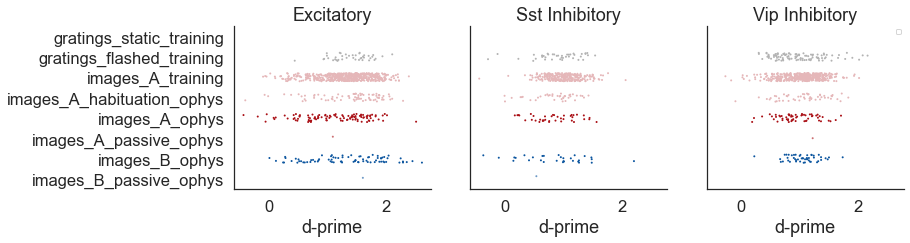

In [755]:
metric = 'dprime_trial_corrected'

data = behavior_stats[behavior_stats.mouse_id.isin(ab_mice)].copy()
color_map = utils.get_stimulus_phase_color_map(as_rgb=False)
colors = [list(color_map[ab_stage]) for ab_stage in ab_stages]

figsize=(12,3)
fig, ax = plt.subplots(1,3, figsize=figsize, sharey=True, sharex=True)
for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.stripplot(data=ct_data, y='stimulus_phase', x=metric, order=ab_stages, 
                          orient='h', palette=colors, dodge=True, jitter=0.2, size=2, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('d-prime')
    ax[i].set_title(cell_type)
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small')

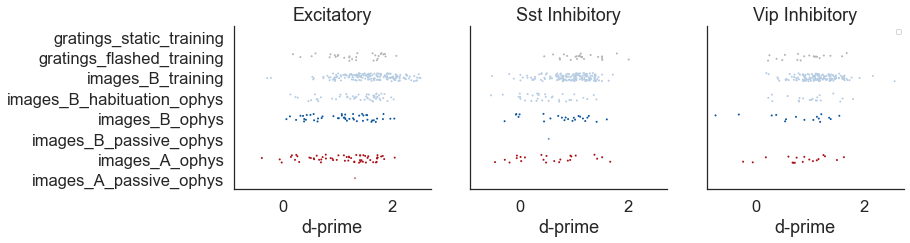

In [756]:
metric = 'dprime_trial_corrected'

data = behavior_stats[behavior_stats.mouse_id.isin(ba_mice)].copy()
color_map = utils.get_stimulus_phase_color_map(as_rgb=False)
colors = [list(color_map[stage]) for stage in ba_stages]

figsize=(12,3)
fig, ax = plt.subplots(1,3, figsize=figsize, sharey=True, sharex=True)
for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.stripplot(data=ct_data, y='stimulus_phase', x=metric, order=ba_stages, 
                          orient='h', palette=colors, dodge=True, jitter=0.2, size=2, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('d-prime')
    ax[i].set_title(cell_type)
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small')

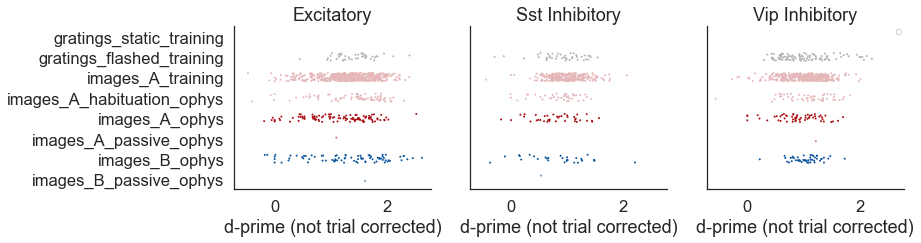

In [757]:
metric = 'dprime_non_trial_corrected'

data = behavior_stats[behavior_stats.mouse_id.isin(ab_mice)].copy()
color_map = utils.get_stimulus_phase_color_map(as_rgb=False)
colors = [list(color_map[ab_stage]) for ab_stage in ab_stages]

figsize=(12,3)
fig, ax = plt.subplots(1,3, figsize=figsize, sharey=True, sharex=True)
for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.stripplot(data=ct_data, y='stimulus_phase', x=metric, order=ab_stages, 
                          orient='h', palette=colors, dodge=True, jitter=0.2, size=2, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('d-prime (not trial corrected)')
    ax[i].set_title(cell_type)
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small')

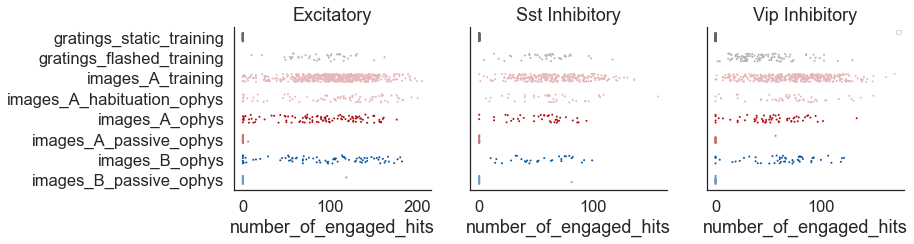

In [758]:
metric = 'number_of_engaged_hits'

data = behavior_stats[behavior_stats.mouse_id.isin(ab_mice)].copy()
color_map = utils.get_stimulus_phase_color_map(as_rgb=False)
colors = [list(color_map[ab_stage]) for ab_stage in ab_stages]

figsize=(12,3)
fig, ax = plt.subplots(1,3, figsize=figsize, sharey=True)
for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.stripplot(data=ct_data, y='stimulus_phase', x=metric, order=ab_stages, 
                          orient='h', palette=colors, dodge=True, jitter=0.2, size=2, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel(metric)
    ax[i].set_title(cell_type)
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small')

### d prime only for sessions where at least 50% of session was engaged

In [759]:
stats = engaged_behavior_stats[engaged_behavior_stats.behavior_session_id.isin(engaged_sessions)]

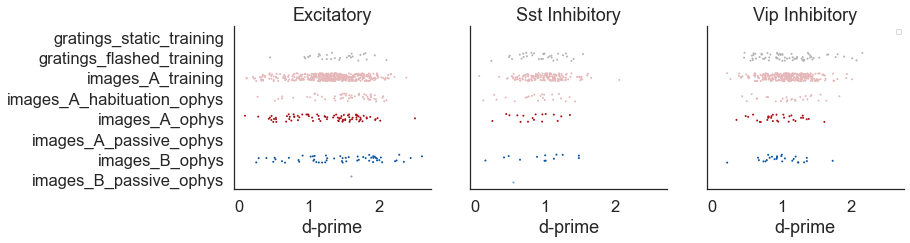

In [760]:
metric = 'dprime_trial_corrected'

data = stats[stats.mouse_id.isin(ab_mice)].copy()
color_map = utils.get_stimulus_phase_color_map(as_rgb=False)
colors = [list(color_map[stage]) for stage in ab_stages]

figsize=(12,3)
fig, ax = plt.subplots(1,3, figsize=figsize, sharey=True, sharex=True)
for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.stripplot(data=ct_data, y='stimulus_phase', x=metric, order=ab_stages, 
                          orient='h', palette=colors, dodge=True, jitter=0.2, size=2, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('d-prime')
    ax[i].set_title(cell_type)
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small')

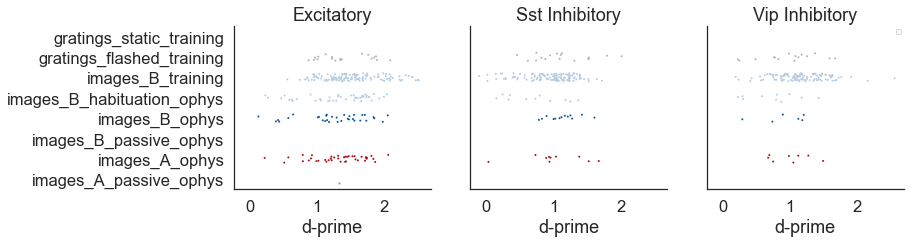

In [761]:
metric = 'dprime_trial_corrected'

data = stats[stats.mouse_id.isin(ba_mice)].copy()
color_map = utils.get_stimulus_phase_color_map(as_rgb=False)
colors = [list(color_map[stage]) for stage in ba_stages]

figsize=(12,3)
fig, ax = plt.subplots(1,3, figsize=figsize, sharey=True, sharex=True)
for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.stripplot(data=ct_data, y='stimulus_phase', x=metric, order=ba_stages, 
                          orient='h', palette=colors, dodge=True, jitter=0.2, size=2, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('d-prime')
    ax[i].set_title(cell_type)
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small')

### Familiar Novel comparison 

In [762]:
stats = behavior_stats[(behavior_stats.last_familiar_active==True)|(behavior_stats.first_novel==True)|(behavior_stats.second_novel_active==True)]

In [763]:
stats

behavior_session_id  response_latency_count  response_latency_mean  \
59              780758836                     1.0               0.033437   
60              782380778                     0.0                    NaN   
61              784156661                    61.0               0.403606   
113             794968300                    55.0               0.531348   
114             795742990                    93.0               0.499510   
...                   ...                     ...                    ...   
3601           1076635241                    91.0               0.545868   
3602           1077498900                   128.0               0.524272   
3654           1084412566                    67.0               0.452598   
3655           1084914230                    64.0               0.463400   
3657           1085690095                    79.0               0.411934   

      response_latency_std  response_latency_min  response_latency_25%  \
59                     NaN              0.033437              0.033437   
60                     NaN                   NaN                   NaN   
61                0.155488              0.000000              0.383648   
113               0.149062              0.016710              0.483730   
114               0.184774              0.000000              0.450370   
...                    ...                   ...                   ...   
3601              0.136022              0.000000              0.466850   
3602              0.147407              0.016629              0.466925   
3654              0.156660              0.000000              0.383635   
3655              0.143431              0.066680              0.366978   
3657              0.150325              0.000000              0.341945   

      response_latency_50%  response_latency_75%  response_latency_max  \
59                0.033437              0.033437              0.033437   
60                     NaN                   NaN                   NaN   
61                0.417022              0.500423              0.683895   
113               0.550460              0.633800              0.733980   
114               0.533740              0.633850              0.733930   
...                    ...                   ...                   ...   
3601              0.550700              0.650645              0.733940   
3602              0.533860              0.617297              0.734095   
3654              0.467040              0.533785              0.733940   
3655              0.433660              0.588000              0.733860   
3657              0.383650              0.467090              0.717200   

      hit_rate  ...  last_day_of_stimulus  stimulus_phase      date  \
59    1.000000  ...                   NaN  images_A_ophys  20181116   
60         NaN  ...                   NaN  images_B_ophys  20181119   
61    0.663043  ...                   NaN  images_B_ophys  20181121   
113   0.687500  ...                  True  images_A_ophys  20181213   
114   0.715385  ...                   NaN  images_B_ophys  20181214   
...        ...  ...                   ...             ...       ...   
3601  0.446078  ...                   NaN  images_A_ophys  20210115   
3602  0.592593  ...                   NaN  images_A_ophys  20210119   
3654  0.540323  ...                  True  images_A_ophys  20210217   
3655  0.609524  ...                   NaN  images_B_ophys  20210218   
3657  0.718182  ...                   NaN  images_B_ophys  20210222   

      n_relative_to_first_novel  first_novel  second_novel_active  \
59                         -1.0        False                False   
60                          0.0         True                False   
61                          1.0        False                 True   
113                        -1.0        False                False   
114                         0.0         True                False   
...                         ...          ...    

Text(0.52, 1.1, 'Cohort 1')

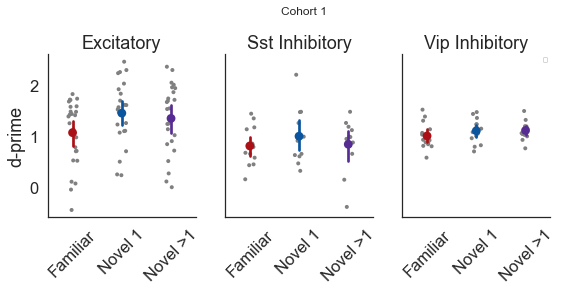

In [764]:
metric = 'dprime_trial_corrected'

data = stats[stats.mouse_id.isin(ab_mice)].copy()
# color_map = utils.get_stimulus_phase_color_map(as_rgb=False)
# colors = [list(color_map[ab_stage]) for ab_stage in ab_stages]
colors = utils.get_experience_level_colors()
experience_levels = utils.get_experience_levels()

figsize=(9,3)
fig, ax = plt.subplots(1,3, figsize=figsize, sharey=True)
for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.stripplot(data=ct_data, x='experience_level', y=metric, order=experience_levels, 
                          orient='v', color='gray', dodge=True, jitter=0.1, size=4, ax=ax[i], zorder=0)
    ax[i] = sns.pointplot(data=ct_data, x='experience_level', y=metric, order=experience_levels, 
                          orient='v', palette=colors, dodge=True, jitter=0.1, size=4, ax=ax[i])
    ax[i].set_xticklabels(experience_levels, rotation=45)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title(cell_type)
ax[0].set_ylabel('d-prime')
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small')
fig.suptitle('Cohort 1', x=0.52, y=1.1)

Text(0.52, 1.1, 'Cohort 2')

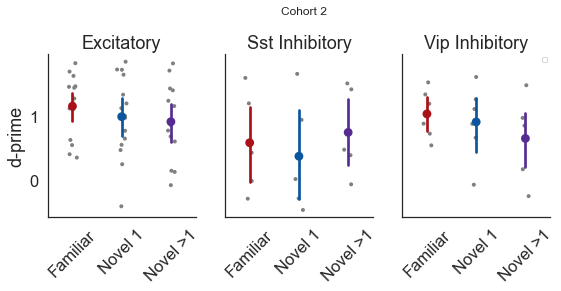

In [765]:
metric = 'dprime_trial_corrected'

data = stats[stats.mouse_id.isin(ba_mice)].copy()
# color_map = utils.get_stimulus_phase_color_map(as_rgb=False)
# colors = [list(color_map[ab_stage]) for ab_stage in ab_stages]
colors = utils.get_experience_level_colors()
experience_levels = utils.get_experience_levels()

figsize=(9,3)
fig, ax = plt.subplots(1,3, figsize=figsize, sharey=True)
for i, cell_type in enumerate(np.sort(data.cell_type.unique())):
    ct_data = data[data.cell_type==cell_type]
    ax[i] = sns.stripplot(data=ct_data, x='experience_level', y=metric, order=experience_levels, 
                          orient='v', color='gray', dodge=True, jitter=0.1, size=4, ax=ax[i], zorder=0)
    ax[i] = sns.pointplot(data=ct_data, x='experience_level', y=metric, order=experience_levels, 
                          orient='v', palette=colors, dodge=True, jitter=0.1, size=4, ax=ax[i])
    ax[i].set_xticklabels(experience_levels, rotation=45)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title(cell_type)
ax[0].set_ylabel('d-prime')
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small')
fig.suptitle('Cohort 2', x=0.52, y=1.1)

### all mice

In [766]:
data

behavior_session_id  response_latency_count  response_latency_mean  \
1528            901251663                   139.0               0.279608   
1530            902871565                   147.0               0.307167   
1532            904844395                   137.0               0.302926   
1558            913901536                    30.0               0.360292   
1559            914353445                     5.0               0.590376   
...                   ...                     ...                    ...   
3191           1060651606                     7.0               0.605261   
3194           1061443328                     3.0               0.639429   
3600           1076470023                   114.0               0.523365   
3601           1076635241                    91.0               0.545868   
3602           1077498900                   128.0               0.524272   

      response_latency_std  response_latency_min  response_latency_25%  \
1528              0.051487              0.033360              0.266830   
1530              0.039857              0.133410              0.283565   
1532              0.069198              0.000000              0.283565   
1558              0.249744              0.000000              0.104275   
1559              0.094777              0.433710              0.583520   
...                    ...                   ...                   ...   
3191              0.086021              0.500370              0.533775   
3194              0.019269              0.617178              0.633848   
3600              0.116836              0.016430              0.450370   
3601              0.136022              0.000000              0.466850   
3602              0.147407              0.016629              0.466925   

      response_latency_50%  response_latency_75%  response_latency_max  \
1528              0.283520              0.300220              0.517070   
1530              0.300250              0.317100              0.517070   
1532              0.300250              0.317201              0.650541   
1558              0.366965              0.600483              0.700600   
1559              0.616890              0.633870              0.683890   
...                    ...                   ...                   ...   
3191              0.616940              0.658995              0.733980   
3194              0.650518              0.650554              0.650590   
3600              0.533715              0.600498              0.733890   
3601              0.550700              0.650645              0.733940   
3602              0.533860              0.617297              0.734095   

      hit_rate  ...  last_day_of_stimulus  stimulus_phase      date  \
1528  0.808140  ...                  True  images_B_ophys  20190708   
1530  0.761658  ...                   NaN  images_A_ophys  20190710   
1532  0.861635  ...                   NaN  images_A_ophys  20190712   
1558  0.483871  ...                  True  images_B_ophys  20190729   
1559  0.119048  ...                   NaN  images_A_ophys  20190730   
...        ...  ...                   ...             ...       ...   
3191  0.114754  ...                   NaN  images_A_ophys  20201102   
3194  0.053571  ...                   NaN  images_A_ophys  20201105   
3600  0.572864  ...                  True  images_B_ophys  20210114   
3601  0.446078  ...                   NaN  images_A_ophys  20210115   
3602  0.592593  ...                   NaN  images_A_ophys  20210119   

      n_relative_to_first_novel  first_novel  second_novel_active  \
1528                       -2.0        False                False   
1530                        0.0         True                False   
1532                        2.0        False                 True   
1558                       -1.0        False                False   
1559                        0.0         True                False   
...                         ...          ...    

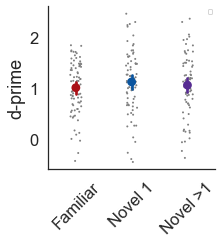

In [767]:
metric = 'dprime_trial_corrected'

data = stats.copy()
# color_map = utils.get_stimulus_phase_color_map(as_rgb=False)
# colors = [list(color_map[ab_stage]) for ab_stage in ab_stages]
colors = utils.get_experience_level_colors()
experience_levels = utils.get_experience_levels()

figsize=(3,3)
fig, ax = plt.subplots(1,1, figsize=figsize)
ax = sns.stripplot(data=data, x='experience_level', y=metric, order=experience_levels, 
                      orient='v', color='gray', dodge=True, jitter=0.1, size=2, ax=ax, zorder=0)
ax = sns.pointplot(data=data, x='experience_level', y=metric, order=experience_levels, 
                      orient='v', palette=colors, dodge=True, jitter=0.1, size=4, ax=ax)
ax.set_xticklabels(experience_levels, rotation=45)
ax.set_xlabel('')
ax.set_ylabel('')
# ax[i].set_title(cell_type)
ax.set_ylabel('d-prime')
ax.legend(bbox_to_anchor=(1,1), fontsize='xx-small')
# fig.suptitle('Cohort 2', x=0.52, y=1.1)

### get behavior metrics for each image (instead of for all go/catch trials as above)

In [768]:
%%time 

method = 'stimulus_based'
engaged_only = True
per_image = True

folder = get_save_folder(method, engaged_only, per_image)

behavior_session_ids = behavior_sessions.index.values


original_each_image_behavior_stats, problem_sessions = get_behavior_stats_for_sessions(behavior_session_ids, behavior_sessions, 
                                    method=method, engaged_only=engaged_only, per_image=per_image)


# original_behavior_stats = behavior_stats.copy()
each_image_behavior_stats = original_each_image_behavior_stats.merge(behavior_sessions, on='behavior_session_id')
 # remove 4x2 sessions
each_image_behavior_stats = each_image_behavior_stats[each_image_behavior_stats.project_code!='VisualBehaviorMultiscope4areasx2d']

  0%|                                                                                         | 0/3667 [00:00<?, ?it/s]

loading for 742008131


  0%|                                                                                 | 1/3667 [00:00<23:53,  2.56it/s]

loading for 742797917


  0%|                                                                                 | 4/3667 [00:01<12:46,  4.78it/s]

loading for 743041166
loading for 743660302
loading for 744374168
loading for 745054849


  0%|▏                                                                                | 8/3667 [00:01<06:43,  9.06it/s]

loading for 745355000
loading for 745636848
loading for 746222622


  0%|▎                                                                               | 12/3667 [00:01<05:41, 10.71it/s]

loading for 746928360
loading for 750415261
loading for 750781358


  0%|▎                                                                               | 14/3667 [00:01<04:59, 12.18it/s]

loading for 752002559
loading for 753011296
loading for 753936007
loading for 754509820


  0%|▍                                                                               | 18/3667 [00:02<04:42, 12.93it/s]

loading for 754896244
loading for 755551879
loading for 756106020
loading for 756632727


  1%|▍                                                                               | 22/3667 [00:02<04:24, 13.80it/s]

loading for 757431083
loading for 758162988
loading for 758942142


  1%|▌                                                                               | 24/3667 [00:02<04:24, 13.78it/s]

loading for 759251920
loading for 759756829
loading for 760007428


  1%|▋                                                                               | 30/3667 [00:02<03:47, 15.98it/s]

loading for 760409951
loading for 760698062
loading for 761499069
loading for 761831761


  1%|▋                                                                               | 32/3667 [00:02<04:08, 14.65it/s]

loading for 762178061
loading for 762722108
loading for 763291103


  1%|▋                                                                               | 34/3667 [00:03<04:12, 14.37it/s]

loading for 763980798
loading for 764495320
loading for 764897570


  1%|▊                                                                               | 38/3667 [00:03<04:07, 14.63it/s]

loading for 765396393
loading for 766110635
loading for 766753111
loading for 767275980


  1%|▉                                                                               | 42/3667 [00:03<03:58, 15.17it/s]

loading for 768042187
loading for 768815421
loading for 769452637
loading for 769902997


  1%|█                                                                               | 46/3667 [00:03<04:04, 14.82it/s]

loading for 770244427
loading for 771245588
loading for 772125590


  1%|█                                                                               | 48/3667 [00:04<04:17, 14.07it/s]

loading for 772658979
loading for 773585522
loading for 774106776


  1%|█▏                                                                              | 52/3667 [00:04<05:03, 11.91it/s]

loading for 774373300
loading for 774422914
loading for 774937388


  2%|█▏                                                                              | 56/3667 [00:04<04:31, 13.30it/s]

loading for 775378326
loading for 775870895
loading for 777082591


  2%|█▎                                                                              | 58/3667 [00:04<04:43, 12.73it/s]

loading for 778166125
loading for 778980920
loading for 779818630


  2%|█▎                                                                              | 60/3667 [00:05<04:55, 12.20it/s]

loading for 780758836
loading for 782380778
loading for 784156661


  2%|█▍                                                                              | 64/3667 [00:05<04:29, 13.35it/s]

loading for 785426306
loading for 785944233
loading for 786920476


  2%|█▍                                                                              | 68/3667 [00:05<03:59, 15.05it/s]

loading for 788017709
loading for 791257562
loading for 791749028
loading for 792499741


  2%|█▌                                                                              | 72/3667 [00:05<03:46, 15.84it/s]

loading for 793129579
loading for 796032489
loading for 760808911
loading for 761294708


  2%|█▋                                                                              | 76/3667 [00:06<03:43, 16.07it/s]

loading for 761730617
loading for 762067130
loading for 762418364


  2%|█▋                                                                              | 78/3667 [00:06<03:45, 15.95it/s]

loading for 763012686
loading for 763661704
loading for 764319580
loading for 764696952


  2%|█▊                                                                              | 82/3667 [00:06<03:30, 17.04it/s]

loading for 765208332
loading for 765793356
loading for 766532213
loading for 766931048


  2%|█▉                                                                              | 86/3667 [00:06<03:36, 16.55it/s]

loading for 767730839
loading for 768450504
loading for 769145833
loading for 769731277


  2%|█▉                                                                              | 90/3667 [00:06<03:36, 16.54it/s]

loading for 770215042
loading for 771040969
loading for 771902184
loading for 772475707


  3%|██                                                                              | 94/3667 [00:07<03:45, 15.82it/s]

loading for 773391809
loading for 774120511
loading for 774679623
loading for 775291372


  3%|██▏                                                                             | 98/3667 [00:07<03:38, 16.30it/s]

loading for 776988190
loading for 778010119
loading for 778888558


  3%|██▏                                                                            | 102/3667 [00:07<03:54, 15.20it/s]

loading for 779712859
loading for 780479408
loading for 781938213


  3%|██▏                                                                            | 104/3667 [00:07<04:02, 14.67it/s]

loading for 783217873
loading for 783959068
loading for 785382040


  3%|██▎                                                                            | 108/3667 [00:08<03:51, 15.36it/s]

loading for 786007435
loading for 786938611
loading for 789008423


  3%|██▎                                                                            | 110/3667 [00:08<04:02, 14.64it/s]

loading for 789870329
loading for 791248943
loading for 791904071


  3%|██▍                                                                            | 114/3667 [00:08<04:19, 13.69it/s]

loading for 792680306
loading for 793485674
loading for 794968300


  3%|██▍                                                                            | 116/3667 [00:08<04:09, 14.26it/s]

loading for 795742990
loading for 796052844
loading for 796251270
loading for 798126878


  3%|██▌                                                                            | 120/3667 [00:08<03:46, 15.63it/s]

loading for 772286394
loading for 773510999
loading for 774208555
loading for 774767072


  3%|██▋                                                                            | 124/3667 [00:09<05:07, 11.51it/s]

loading for 775344511
loading for 775925580
loading for 777061425
loading for 778119826


  3%|██▊                                                                            | 128/3667 [00:09<04:16, 13.79it/s]

loading for 778959204
loading for 779580423
loading for 780351711
loading for 781727422


  4%|██▊                                                                            | 132/3667 [00:09<04:02, 14.60it/s]

loading for 783059206
loading for 783971649
loading for 785376297
loading for 785868918


  4%|██▉                                                                            | 136/3667 [00:10<03:35, 16.37it/s]

loading for 786841415
loading for 788864720
loading for 789946754
loading for 791278700


  4%|███                                                                            | 140/3667 [00:10<03:39, 16.07it/s]

loading for 791769447
loading for 792477679
loading for 793153175


  4%|███                                                                            | 144/3667 [00:10<03:42, 15.85it/s]

loading for 794071128
loading for 794673280
loading for 795431009


  4%|███▏                                                                           | 146/3667 [00:10<03:33, 16.48it/s]

loading for 796031509
loading for 797170547
loading for 776156839
loading for 777417642


  4%|███▏                                                                           | 150/3667 [00:11<04:03, 14.47it/s]

loading for 778884020
loading for 779111633
loading for 780002890


  4%|███▎                                                                           | 154/3667 [00:11<04:16, 13.71it/s]

loading for 780766304
loading for 783413166
loading for 784173223


  4%|███▎                                                                           | 156/3667 [00:11<04:23, 13.35it/s]

loading for 785539951
loading for 786305627
loading for 788343533


  4%|███▍                                                                           | 158/3667 [00:11<04:19, 13.53it/s]

loading for 789221588
loading for 791371899
loading for 791866254


  4%|███▍                                                                           | 162/3667 [00:11<04:06, 14.24it/s]

loading for 792661903
loading for 793323654
loading for 794275479
loading for 794953909


  5%|███▌                                                                           | 166/3667 [00:12<04:00, 14.56it/s]

loading for 795838927
loading for 796046197
loading for 796233602
loading for 796607829


  5%|███▋                                                                           | 170/3667 [00:12<03:59, 14.63it/s]

loading for 798145975
loading for 798679618
loading for 799661667


  5%|███▋                                                                           | 174/3667 [00:12<03:44, 15.54it/s]

loading for 800202171
loading for 802406837
loading for 802922968
loading for 803341010


  5%|███▊                                                                           | 178/3667 [00:12<03:28, 16.72it/s]

loading for 804748984
loading for 805373492
loading for 806616108
loading for 807198458


  5%|███▉                                                                           | 182/3667 [00:13<03:29, 16.61it/s]

loading for 808107647
loading for 809321253
loading for 791877093


  5%|███▉                                                                           | 184/3667 [00:13<03:46, 15.40it/s]

loading for 792689261
loading for 793414389
loading for 794295959


  5%|████                                                                           | 188/3667 [00:13<03:43, 15.57it/s]

loading for 794977379
loading for 795854559
loading for 799051310
loading for 799922316


  5%|████                                                                           | 190/3667 [00:13<03:39, 15.82it/s]

loading for 800299366
loading for 800922511
loading for 802988132


  5%|████▏                                                                          | 194/3667 [00:14<03:44, 15.48it/s]

loading for 803351520
loading for 804929649
loading for 805535249
loading for 806109931


  5%|████▎                                                                          | 198/3667 [00:14<03:46, 15.29it/s]

loading for 806792366
loading for 807356557
loading for 808324301
loading for 808883789


  6%|████▎                                                                          | 202/3667 [00:14<03:45, 15.38it/s]

loading for 809358811
loading for 810405357
loading for 811303680
loading for 811817467


  6%|████▍                                                                          | 206/3667 [00:14<03:34, 16.17it/s]

loading for 812955256
loading for 816417578
loading for 817139151
loading for 818485496


  6%|████▍                                                                          | 208/3667 [00:14<04:01, 14.30it/s]

loading for 819094295
loading for 791875850


  6%|████▌                                                                          | 212/3667 [00:15<04:49, 11.95it/s]

loading for 792689257
loading for 793409670
loading for 794295950
loading for 794977383


  6%|████▋                                                                          | 217/3667 [00:15<04:34, 12.57it/s]

loading for 795854555
loading for 799049628
loading for 799919887
loading for 800299362


  6%|████▊                                                                          | 221/3667 [00:15<03:55, 14.62it/s]

loading for 800919728
loading for 802364085
loading for 802988119
loading for 803347004


  6%|████▊                                                                          | 225/3667 [00:16<04:00, 14.30it/s]

loading for 805639780
loading for 806296598
loading for 806841326


  6%|████▉                                                                          | 227/3667 [00:16<03:53, 14.74it/s]

loading for 807584876
loading for 808432167
loading for 809027309
loading for 809427293


  6%|████▉                                                                          | 231/3667 [00:16<03:33, 16.09it/s]

loading for 811355443
loading for 810584641
loading for 811356875
loading for 811831429


  6%|█████                                                                          | 235/3667 [00:16<03:31, 16.25it/s]

loading for 812566400
loading for 812993078
loading for 813675618
loading for 814546737


  7%|█████▏                                                                         | 239/3667 [00:17<03:23, 16.88it/s]

loading for 815015329
loading for 815511978
loading for 816381516
loading for 817182203


  7%|█████▏                                                                         | 243/3667 [00:17<03:29, 16.38it/s]

loading for 818758572
loading for 819245147
loading for 819990491
loading for 821803380


  7%|█████▎                                                                         | 247/3667 [00:17<03:26, 16.53it/s]

loading for 822409353
loading for 823241007
loading for 823968100
loading for 825012995


  7%|█████▍                                                                         | 251/3667 [00:17<03:38, 15.60it/s]

loading for 825268982
loading for 825888541
loading for 826697158


  7%|█████▍                                                                         | 255/3667 [00:18<03:39, 15.56it/s]

loading for 827374757
loading for 828646658
loading for 829138845


  7%|█████▌                                                                         | 257/3667 [00:18<03:33, 16.00it/s]

loading for 829578829
loading for 830255592
loading for 830832988
loading for 831824426


  7%|█████▌                                                                         | 261/3667 [00:18<03:36, 15.73it/s]

loading for 832981154
loading for 835444110
loading for 835820832
loading for 836399024


  7%|█████▋                                                                         | 265/3667 [00:18<03:49, 14.85it/s]

loading for 807533658
loading for 808488955
loading for 809095689


  7%|█████▊                                                                         | 269/3667 [00:19<03:40, 15.39it/s]

loading for 809427297
loading for 809815041
loading for 810598880
loading for 811354008


  7%|█████▉                                                                         | 273/3667 [00:19<03:52, 14.59it/s]

loading for 811830102
loading for 812559803
loading for 813041953


  8%|█████▉                                                                         | 277/3667 [00:19<02:53, 19.51it/s]

loading for 813737110
loading for 814545306
cant load stats for 814545306
loading for 815045874
cant load stats for 815045874
loading for 815521974
loading for 816394256
loading for 817165094


  8%|██████                                                                         | 283/3667 [00:19<02:39, 21.28it/s]

loading for 818007489
cant load stats for 818007489
loading for 818825644
cant load stats for 818825644
loading for 819323551
loading for 820124540
loading for 821931655
loading for 822439453


  8%|██████▏                                                                        | 286/3667 [00:19<02:51, 19.67it/s]

loading for 823254723
loading for 824894721
loading for 807062523
loading for 808103937


  8%|██████▎                                                                        | 291/3667 [00:20<03:13, 17.45it/s]

loading for 809588395
loading for 810266014
loading for 811140660
loading for 811574124


  8%|██████▎                                                                        | 295/3667 [00:20<03:19, 16.92it/s]

loading for 812261209
loading for 812796028
loading for 814260983
loading for 814749891


  8%|██████▍                                                                        | 299/3667 [00:20<03:09, 17.77it/s]

loading for 815865807
loading for 817053045
loading for 818539436
loading for 819065377


  8%|██████▌                                                                        | 303/3667 [00:20<03:25, 16.34it/s]

loading for 819497998
loading for 820740400
loading for 821593979
loading for 822159346


  8%|██████▌                                                                        | 307/3667 [00:21<03:32, 15.80it/s]

loading for 822874578
loading for 823496226
loading for 824566587
loading for 825269006


  8%|██████▋                                                                        | 311/3667 [00:21<03:41, 15.13it/s]

loading for 825902239
loading for 826697162
loading for 827374765


  9%|██████▊                                                                        | 315/3667 [00:21<03:26, 16.22it/s]

loading for 828669593
loading for 829138837
loading for 829714672
loading for 830419451
loading for 830959034


  9%|██████▊                                                                        | 319/3667 [00:21<03:20, 16.71it/s]

loading for 831905148
loading for 833100683
loading for 833946929
loading for 834928595


  9%|██████▉                                                                        | 323/3667 [00:22<03:45, 14.82it/s]

loading for 835547527
loading for 835940015
loading for 837108110


  9%|███████                                                                        | 325/3667 [00:22<03:53, 14.34it/s]

loading for 837512169
loading for 823922942
loading for 824972176


  9%|███████                                                                        | 329/3667 [00:22<03:52, 14.38it/s]

loading for 825527066
loading for 826338809
loading for 826841473
loading for 827977069


  9%|███████▏                                                                       | 333/3667 [00:22<03:37, 15.29it/s]

loading for 828842797
loading for 829281654
loading for 829902556
loading for 830592943


  9%|███████▎                                                                       | 337/3667 [00:23<03:45, 14.79it/s]

loading for 831259963
loading for 832009551
loading for 832522789


  9%|███████▎                                                                       | 339/3667 [00:23<06:33,  8.46it/s]

loading for 833252272
loading for 834059775
loading for 834886139


  9%|███████▍                                                                       | 343/3667 [00:23<05:00, 11.07it/s]

loading for 835608988
loading for 836099247
loading for 836769386
loading for 837202082


  9%|███████▍                                                                       | 347/3667 [00:24<04:03, 13.62it/s]

loading for 837629869
loading for 838486964
loading for 839220840
loading for 839566028


 10%|███████▌                                                                       | 351/3667 [00:24<04:22, 12.65it/s]

loading for 839918083
loading for 840583412
loading for 841431760
loading for 841830077


 10%|███████▌                                                                       | 353/3667 [00:24<05:22, 10.29it/s]

loading for 842387217
loading for 842821314


 10%|███████▋                                                                       | 355/3667 [00:25<06:39,  8.30it/s]

loading for 843397714
loading for 844197868


 10%|███████▋                                                                       | 359/3667 [00:25<06:01,  9.14it/s]

loading for 844880686
loading for 845564445
loading for 846272622


 10%|███████▊                                                                       | 363/3667 [00:25<04:52, 11.31it/s]

loading for 847022155
loading for 847829598
loading for 848519645


 10%|███████▊                                                                       | 365/3667 [00:25<04:33, 12.09it/s]

loading for 849073265
loading for 849635376
loading for 850977753


 10%|███████▉                                                                       | 367/3667 [00:26<04:21, 12.63it/s]

loading for 851779746
loading for 852468381
loading for 853168204


 10%|███████▉                                                                       | 371/3667 [00:26<03:56, 13.96it/s]

loading for 853875502
loading for 854563857
loading for 855421865
loading for 855973498


 10%|████████                                                                       | 375/3667 [00:26<03:46, 14.52it/s]

loading for 856717282
loading for 857612105
loading for 859065627
loading for 859735311


 10%|████████▏                                                                      | 379/3667 [00:26<03:32, 15.47it/s]

loading for 860665051
loading for 861788094
loading for 863571072
loading for 864139911


 10%|████████▎                                                                      | 383/3667 [00:27<03:19, 16.43it/s]

loading for 864824449
loading for 865482857
loading for 866333758
loading for 867041502


 11%|████████▎                                                                      | 387/3667 [00:27<03:19, 16.44it/s]

loading for 867977775
loading for 868721114
loading for 869639141
loading for 870960890


 11%|████████▍                                                                      | 391/3667 [00:27<03:17, 16.59it/s]

loading for 872062433
loading for 873002413
loading for 873750535
loading for 874681118


 11%|████████▌                                                                      | 395/3667 [00:27<03:20, 16.31it/s]

loading for 875414332
loading for 876765708
loading for 877346183


 11%|████████▌                                                                      | 397/3667 [00:27<03:39, 14.92it/s]

loading for 877925816
loading for 878671068
loading for 879974471


 11%|████████▋                                                                      | 401/3667 [00:28<03:20, 16.31it/s]

loading for 880668519
loading for 881278000
loading for 882256127
loading for 882748184
loading for 884596128


 11%|████████▋                                                                      | 406/3667 [00:28<02:59, 18.14it/s]

loading for 885492180
loading for 886322595
loading for 886926935
loading for 888127012


 11%|████████▊                                                                      | 410/3667 [00:28<03:17, 16.51it/s]

loading for 890157940
loading for 820799656
loading for 821837682
loading for 822471786


 11%|████████▉                                                                      | 414/3667 [00:28<03:41, 14.70it/s]

loading for 823248638
loading for 823922950
loading for 824992804


 11%|████████▉                                                                      | 416/3667 [00:29<03:45, 14.42it/s]

loading for 825533866
loading for 826356747
loading for 826846303


 11%|█████████                                                                      | 420/3667 [00:29<03:43, 14.52it/s]

loading for 827944014
loading for 828838236
loading for 829282785


 12%|█████████▏                                                                     | 424/3667 [00:29<03:44, 14.47it/s]

loading for 829877552
loading for 830620126
loading for 832019583
loading for 832540845
loading for 833454420


 12%|█████████▏                                                                     | 426/3667 [00:29<04:51, 11.13it/s]

loading for 834093014
loading for 834908481


 12%|█████████▏                                                                     | 428/3667 [00:30<06:08,  8.78it/s]

loading for 835616503
loading for 836173885


 12%|█████████▎                                                                     | 430/3667 [00:30<07:12,  7.49it/s]

loading for 836777468


 12%|█████████▎                                                                     | 432/3667 [00:31<08:22,  6.43it/s]

loading for 837196627
loading for 837647722


 12%|█████████▎                                                                     | 435/3667 [00:31<06:52,  7.84it/s]

loading for 838496122
loading for 839233516
loading for 839566049


 12%|█████████▍                                                                     | 439/3667 [00:31<04:56, 10.90it/s]

loading for 839931485
loading for 840594518
loading for 841429687


 12%|█████████▌                                                                     | 441/3667 [00:31<04:27, 12.05it/s]

loading for 841842210
loading for 842399625
loading for 842844413
loading for 843400443


 12%|█████████▌                                                                     | 445/3667 [00:32<04:09, 12.90it/s]

loading for 844253929
loading for 845585105
loading for 846316916


 12%|█████████▋                                                                     | 447/3667 [00:32<03:54, 13.72it/s]

loading for 847036338
loading for 847871771
loading for 848599542


 12%|█████████▋                                                                     | 451/3667 [00:32<03:45, 14.24it/s]

loading for 849136474
loading for 849648618
loading for 850985993
loading for 851757903


 12%|█████████▊                                                                     | 455/3667 [00:32<03:35, 14.89it/s]

loading for 852440775
loading for 853496105
loading for 827312851


 13%|█████████▉                                                                     | 459/3667 [00:33<04:50, 11.03it/s]

loading for 828646634
loading for 829128279
loading for 829591790


 13%|█████████▉                                                                     | 461/3667 [00:33<04:43, 11.30it/s]

loading for 830201482
loading for 830867799
loading for 831834820


 13%|██████████                                                                     | 465/3667 [00:33<04:13, 12.61it/s]

loading for 832325815
loading for 832990071
loading for 833780803


 13%|██████████                                                                     | 467/3667 [00:33<03:59, 13.38it/s]

loading for 834573980
loading for 835448132
loading for 835865722
loading for 836522259


 13%|██████████▏                                                                    | 471/3667 [00:34<03:35, 14.84it/s]

loading for 837083666
loading for 837443225
loading for 838236165
loading for 839014738


 13%|██████████▏                                                                    | 475/3667 [00:34<03:25, 15.52it/s]

loading for 839479248
loading for 839854553
loading for 840330509
loading for 841185520


 13%|██████████▎                                                                    | 479/3667 [00:34<03:39, 14.51it/s]

loading for 841730873
loading for 842139320
loading for 842792100


 13%|██████████▍                                                                    | 483/3667 [00:34<03:32, 14.96it/s]

loading for 843166865
loading for 844234790
loading for 844875410


 13%|██████████▍                                                                    | 485/3667 [00:34<03:36, 14.71it/s]

loading for 846248008
loading for 847048485
loading for 847867029


 13%|██████████▍                                                                    | 487/3667 [00:35<03:40, 14.40it/s]

loading for 848575992
loading for 849098851
loading for 850976604


 13%|██████████▌                                                                    | 491/3667 [00:35<03:40, 14.37it/s]

loading for 853266283
loading for 831129394
loading for 832021447
loading for 832544149


 13%|██████████▋                                                                    | 495/3667 [00:35<03:37, 14.59it/s]

loading for 833328750
loading for 834087859
loading for 834903060
loading for 835557296


 14%|██████████▊                                                                    | 499/3667 [00:35<03:39, 14.42it/s]

loading for 836166694
loading for 836761653
loading for 837192567


 14%|██████████▊                                                                    | 501/3667 [00:36<03:36, 14.59it/s]

loading for 837638916
loading for 838496126
loading for 839234289


 14%|██████████▉                                                                    | 505/3667 [00:36<03:40, 14.36it/s]

loading for 839566045
loading for 839939986
loading for 840594514


 14%|██████████▉                                                                    | 509/3667 [00:36<03:28, 15.11it/s]

loading for 841148118
loading for 841707177
loading for 842174399


 14%|███████████                                                                    | 511/3667 [00:36<03:27, 15.21it/s]

loading for 842729895
loading for 843203333
loading for 844164376
loading for 844849972


 14%|███████████                                                                    | 515/3667 [00:37<03:30, 14.97it/s]

loading for 845441512
loading for 846194950
loading for 846929750
loading for 848503804


 14%|███████████▏                                                                   | 519/3667 [00:37<03:08, 16.72it/s]

loading for 853526948
loading for 834587823
loading for 835451471
loading for 835867850


 14%|███████████▎                                                                   | 523/3667 [00:37<03:07, 16.75it/s]

loading for 836522245
loading for 837083657
loading for 837449223
loading for 838203784


 14%|███████████▎                                                                   | 527/3667 [00:37<03:02, 17.25it/s]

loading for 838998362
loading for 839468826
loading for 839837380
loading for 840330501


 14%|███████████▍                                                                   | 531/3667 [00:37<03:11, 16.41it/s]

loading for 841191836
loading for 841730868
loading for 842139310
loading for 842792094


 15%|███████████▌                                                                   | 535/3667 [00:38<03:09, 16.53it/s]

loading for 843178897
loading for 844027594
loading for 844608277
loading for 845409652


 15%|███████████▌                                                                   | 539/3667 [00:38<03:09, 16.54it/s]

loading for 846051276
loading for 846791195
loading for 847613846
loading for 848272657


 15%|███████████▋                                                                   | 543/3667 [00:38<03:26, 15.14it/s]

loading for 848938321
loading for 849525884
loading for 850817466


 15%|███████████▋                                                                   | 545/3667 [00:38<03:36, 14.42it/s]

loading for 851563931
loading for 852235678
loading for 852974537


 15%|███████████▊                                                                   | 549/3667 [00:39<03:28, 14.95it/s]

loading for 853505213
loading for 854283407
loading for 855826937
loading for 857230827


 15%|███████████▉                                                                   | 553/3667 [00:39<03:33, 14.58it/s]

loading for 837658854
loading for 838515247
loading for 839219841
loading for 839565422


 15%|███████████▉                                                                   | 557/3667 [00:39<03:19, 15.60it/s]

loading for 839912316
loading for 840581827
loading for 841426832
loading for 841827774


 15%|████████████                                                                   | 561/3667 [00:39<03:29, 14.83it/s]

loading for 842385277
loading for 842819933
loading for 843400453
loading for 844199758


 15%|████████████▏                                                                  | 565/3667 [00:40<03:19, 15.54it/s]

loading for 844908261
loading for 845572044
loading for 846331423
loading for 847036328


 16%|████████████▎                                                                  | 569/3667 [00:40<03:16, 15.78it/s]

loading for 847874940
loading for 848613406
loading for 849147676
loading for 849651275


 16%|████████████▎                                                                  | 574/3667 [00:40<03:06, 16.63it/s]

loading for 850989832
loading for 851773928
loading for 852451567
loading for 855200229
loading for 837654533


 16%|████████████▍                                                                  | 578/3667 [00:40<03:11, 16.15it/s]

loading for 838483140
loading for 839219845
loading for 839565426


 16%|████████████▍                                                                  | 580/3667 [00:41<03:14, 15.87it/s]

loading for 839914270
loading for 840581823
loading for 841426857


 16%|████████████▌                                                                  | 584/3667 [00:41<03:15, 15.78it/s]

loading for 841830096
loading for 842385266
loading for 842819929
loading for 843401580


 16%|████████████▋                                                                  | 588/3667 [00:41<03:01, 16.98it/s]

loading for 844199766
loading for 844891885
loading for 845572039
loading for 846016059


 16%|████████████▊                                                                  | 592/3667 [00:41<02:59, 17.11it/s]

loading for 846750050
loading for 847660741
loading for 848348215
loading for 848943191


 16%|████████████▊                                                                  | 596/3667 [00:42<02:53, 17.67it/s]

loading for 849494762
loading for 850807174
loading for 851542477
loading for 852229360


 16%|████████████▉                                                                  | 600/3667 [00:42<03:05, 16.53it/s]

loading for 853025613
loading for 855446545
loading for 855866701


 16%|█████████████                                                                  | 604/3667 [00:42<03:15, 15.63it/s]

loading for 856467236
loading for 857367017
loading for 858029487


 17%|█████████████                                                                  | 606/3667 [00:42<03:11, 16.02it/s]

loading for 858967789
loading for 859793880
loading for 860533862
loading for 864068649


 17%|█████████████▏                                                                 | 610/3667 [00:42<03:13, 15.81it/s]

loading for 840598877
loading for 841466830
loading for 841851097
loading for 842419799


 17%|█████████████▏                                                                 | 614/3667 [00:43<03:27, 14.70it/s]

loading for 842840144
loading for 843423171
loading for 844229895
loading for 844945060


 17%|█████████████▎                                                                 | 618/3667 [00:43<03:15, 15.56it/s]

loading for 845594684
loading for 846284880
loading for 847048490
loading for 847838131


 17%|█████████████▍                                                                 | 622/3667 [00:43<03:27, 14.65it/s]

loading for 848526511
loading for 848910243
loading for 849485548
loading for 850810858


 17%|█████████████▍                                                                 | 626/3667 [00:44<03:21, 15.10it/s]

loading for 851471401
loading for 852202150
loading for 852966248
loading for 853875514


 17%|█████████████▌                                                                 | 630/3667 [00:44<03:07, 16.19it/s]

loading for 854621677
loading for 855424348
loading for 857340041
loading for 857987666


 17%|█████████████▋                                                                 | 634/3667 [00:44<03:25, 14.73it/s]

loading for 858974731
loading for 859775117
loading for 863610582


 17%|█████████████▋                                                                 | 638/3667 [00:44<03:05, 16.29it/s]

loading for 868070216
loading for 868658294
loading for 869559097
loading for 850978904


 18%|█████████████▊                                                                 | 642/3667 [00:45<03:09, 15.95it/s]

loading for 851802107
loading for 852457995
loading for 853257103


 18%|█████████████▊                                                                 | 644/3667 [00:45<03:30, 14.38it/s]

loading for 853793068
loading for 854602288
loading for 855476794


 18%|█████████████▉                                                                 | 648/3667 [00:45<03:31, 14.28it/s]

loading for 856010720
loading for 856732195
loading for 857547928


 18%|██████████████                                                                 | 650/3667 [00:45<03:21, 14.98it/s]

loading for 858273959
loading for 859054070
loading for 859802280
loading for 860894659


 18%|██████████████                                                                 | 654/3667 [00:45<03:10, 15.84it/s]

loading for 861794694
loading for 862716894
loading for 863559318
loading for 864280264


 18%|██████████████▏                                                                | 658/3667 [00:46<03:11, 15.73it/s]

loading for 865544821
loading for 866336764
loading for 867098393
loading for 867945660


 18%|██████████████▎                                                                | 662/3667 [00:46<03:04, 16.30it/s]

loading for 868819048
loading for 869621595
loading for 870960908
loading for 872107505


 18%|██████████████▎                                                                | 666/3667 [00:46<03:12, 15.61it/s]

loading for 873813922
loading for 874808131
loading for 876821717
loading for 854533487


 18%|██████████████▍                                                                | 670/3667 [00:46<03:29, 14.29it/s]

loading for 855504136
loading for 856002607
loading for 856732191


 18%|██████████████▍                                                                | 672/3667 [00:47<03:18, 15.07it/s]

loading for 857555456
loading for 858240891
loading for 859032026


 18%|██████████████▌                                                                | 676/3667 [00:47<03:36, 13.79it/s]

loading for 859791558
loading for 860752803
loading for 861794699


 19%|██████████████▋                                                                | 680/3667 [00:47<03:18, 15.08it/s]

loading for 862701465
loading for 863571054
loading for 864137547
loading for 864839176


 19%|██████████████▋                                                                | 684/3667 [00:47<03:17, 15.13it/s]

loading for 865581941
loading for 866287088
loading for 866950070


 19%|██████████████▊                                                                | 686/3667 [00:47<03:11, 15.55it/s]

loading for 867615529
loading for 868540333
loading for 869319414
loading for 870660821


 19%|██████████████▊                                                                | 690/3667 [00:48<02:57, 16.77it/s]

loading for 871808378
loading for 872646068
loading for 873517635
loading for 874324533


 19%|██████████████▉                                                                | 695/3667 [00:48<02:42, 18.31it/s]

loading for 875471358
cant load stats for 875471358
loading for 876574139
loading for 850970486
loading for 851843550
loading for 852507945


 19%|███████████████                                                                | 699/3667 [00:48<02:49, 17.47it/s]

loading for 853260939
loading for 853886146
loading for 855459012
loading for 855980937


 19%|███████████████▏                                                               | 703/3667 [00:48<03:07, 15.77it/s]

loading for 856719615
loading for 857504898
loading for 858250763
loading for 859049298


 19%|███████████████▏                                                               | 707/3667 [00:49<02:59, 16.46it/s]

loading for 859784868
loading for 860836980
loading for 861789935
loading for 862716913


 19%|███████████████▎                                                               | 711/3667 [00:49<03:34, 13.77it/s]

loading for 863614836
loading for 864260028
loading for 864813130


 19%|███████████████▍                                                               | 715/3667 [00:49<03:16, 15.01it/s]

loading for 865460179
loading for 866296478
loading for 866999677
loading for 867615541


 20%|███████████████▍                                                               | 717/3667 [00:49<03:24, 14.39it/s]

loading for 868555361
loading for 869334643


 20%|███████████████▌                                                               | 721/3667 [00:50<03:33, 13.81it/s]

loading for 870592115
loading for 871808394
loading for 872626160


 20%|███████████████▌                                                               | 723/3667 [00:50<03:21, 14.58it/s]

loading for 873695653
loading for 874699922
loading for 875440936
loading for 876678452


 20%|███████████████▋                                                               | 729/3667 [00:50<02:54, 16.87it/s]

loading for 877617747
loading for 878120101
loading for 879037269
loading for 880046522


 20%|███████████████▋                                                               | 731/3667 [00:50<02:46, 17.61it/s]

loading for 880784794
loading for 882256117
loading for 854528256
loading for 855503335


 20%|███████████████▊                                                               | 735/3667 [00:51<02:49, 17.34it/s]

loading for 856002613
loading for 856732213
loading for 857555461
loading for 858240896


 20%|███████████████▉                                                               | 739/3667 [00:51<03:05, 15.77it/s]

loading for 859032044
loading for 859791563
loading for 860752819


 20%|████████████████                                                               | 743/3667 [00:51<03:04, 15.85it/s]

loading for 861794704
loading for 862701503
loading for 863559327
loading for 864125430
loading for 864839160


 20%|████████████████                                                               | 747/3667 [00:51<03:25, 14.19it/s]

loading for 865580429
loading for 866287143
loading for 867082086
loading for 868004770


 20%|████████████████▏                                                              | 751/3667 [00:52<03:09, 15.39it/s]

loading for 868747797
loading for 872158938
loading for 873015934
loading for 873824951


 21%|████████████████▎                                                              | 755/3667 [00:52<03:15, 14.91it/s]

loading for 874747892
loading for 875444395
loading for 876857698


 21%|████████████████▎                                                              | 759/3667 [00:52<03:05, 15.68it/s]

loading for 878159171
loading for 879037253
loading for 880201859
loading for 880776648


 21%|████████████████▍                                                              | 763/3667 [00:52<03:00, 16.11it/s]

loading for 881413102
loading for 882446265
loading for 882831297
loading for 883863892


 21%|████████████████▍                                                              | 765/3667 [00:53<02:56, 16.43it/s]

loading for 884808160
loading for 885644181
loading for 886440437


 21%|████████████████▌                                                              | 769/3667 [00:53<03:27, 13.96it/s]

loading for 887165432
loading for 888282547
loading for 858104885


 21%|████████████████▌                                                              | 771/3667 [00:53<03:41, 13.07it/s]

loading for 858900546
loading for 859601488
loading for 860247669


 21%|████████████████▋                                                              | 775/3667 [00:53<03:32, 13.58it/s]

loading for 861717498
loading for 862339401
loading for 863365105
loading for 863966979


 21%|████████████████▊                                                              | 779/3667 [00:54<03:16, 14.71it/s]

loading for 864665192
loading for 865114696
loading for 865887829
loading for 866906696


 21%|████████████████▊                                                              | 783/3667 [00:54<03:06, 15.47it/s]

loading for 867505993
loading for 868511825
loading for 869198966
loading for 870481699


 21%|████████████████▉                                                              | 787/3667 [00:54<02:59, 16.09it/s]

loading for 871723063
loading for 872607293
loading for 873440431
loading for 874324527


 22%|████████████████▉                                                              | 789/3667 [00:54<03:07, 15.34it/s]

loading for 875020211
loading for 876448536


 22%|█████████████████                                                              | 791/3667 [00:55<04:22, 10.94it/s]

loading for 877855866
loading for 878615859


 22%|█████████████████                                                              | 793/3667 [00:55<05:39,  8.46it/s]

loading for 879846629
loading for 880581639


 22%|█████████████████▏                                                             | 797/3667 [00:55<05:10,  9.23it/s]

loading for 881204796
loading for 882289836
loading for 883851453
loading for 884598044


 22%|█████████████████▎                                                             | 801/3667 [00:56<04:03, 11.78it/s]

loading for 885404075
loading for 886376835
loading for 888213949


 22%|█████████████████▎                                                             | 805/3667 [00:56<03:40, 13.00it/s]

loading for 890021100
loading for 893362730
loading for 894103623
loading for 895022326
loading for 895562386


 22%|█████████████████▍                                                             | 809/3667 [00:56<04:30, 10.55it/s]

loading for 896561264
loading for 898432373
loading for 898874650


 22%|█████████████████▌                                                             | 813/3667 [00:57<03:40, 12.92it/s]

loading for 899390684
loading for 901999401
loading for 903708760


 22%|█████████████████▌                                                             | 815/3667 [00:57<03:24, 13.93it/s]

loading for 904574580
loading for 906472625
loading for 907053876
loading for 907900077


 22%|█████████████████▋                                                             | 819/3667 [00:57<03:04, 15.43it/s]

loading for 908533370
loading for 910207192
loading for 910829549
loading for 911904717


 22%|█████████████████▊                                                             | 824/3667 [00:57<03:03, 15.50it/s]

loading for 913673477
loading for 914211263
loading for 914705301


 23%|█████████████████▊                                                             | 826/3667 [00:57<02:57, 16.03it/s]

loading for 915418411
loading for 916403851
loading for 918103715
loading for 923410363


 23%|█████████████████▉                                                             | 830/3667 [00:58<02:57, 15.95it/s]

loading for 924472023
loading for 925084998
loading for 858098100
loading for 858891746


 23%|█████████████████▉                                                             | 834/3667 [00:58<03:01, 15.61it/s]

loading for 859601496
loading for 860247677
loading for 861715805


 23%|██████████████████                                                             | 838/3667 [00:58<03:09, 14.94it/s]

loading for 862326321
loading for 863361852
loading for 863966966


 23%|██████████████████                                                             | 840/3667 [00:58<02:59, 15.76it/s]

loading for 864656758
loading for 865114705
loading for 865883182
loading for 866912923


 23%|██████████████████▏                                                            | 844/3667 [00:58<02:54, 16.16it/s]

loading for 867553178
loading for 868521085
loading for 869223965
loading for 870473396


 23%|██████████████████▎                                                            | 848/3667 [00:59<02:45, 17.08it/s]

loading for 871723073
loading for 872607297
loading for 873440438
loading for 874324523


 23%|██████████████████▎                                                            | 852/3667 [00:59<02:47, 16.78it/s]

loading for 875020169
loading for 877447964
loading for 878282369
loading for 880231156
loading for 880780889


 23%|██████████████████▍                                                            | 857/3667 [00:59<02:35, 18.04it/s]

loading for 881427978
loading for 882434675
loading for 882827577
loading for 884888379


 23%|██████████████████▌                                                            | 861/3667 [00:59<02:56, 15.94it/s]

loading for 885739915
loading for 886446971
loading for 887236947


 24%|██████████████████▌                                                            | 863/3667 [01:00<03:22, 13.85it/s]

loading for 888301437
loading for 889559462
loading for 890374401


 24%|██████████████████▋                                                            | 865/3667 [01:00<03:40, 12.74it/s]

loading for 891792255
loading for 892663103


 24%|██████████████████▋                                                            | 869/3667 [01:00<04:02, 11.53it/s]

loading for 893600606
loading for 858098096
loading for 859064345


 24%|██████████████████▊                                                            | 873/3667 [01:01<03:32, 13.16it/s]

loading for 859735301
loading for 860650174
loading for 861785387


 24%|██████████████████▊                                                            | 875/3667 [01:01<03:21, 13.87it/s]

loading for 862752139
loading for 863571063
loading for 864137543
loading for 864820740


 24%|██████████████████▉                                                            | 879/3667 [01:01<02:53, 16.09it/s]

loading for 865463877
loading for 866319121
loading for 867036286
loading for 867961842


 24%|███████████████████                                                            | 883/3667 [01:01<02:49, 16.47it/s]

loading for 868649156
loading for 869623240
loading for 870935137
loading for 872035204


 24%|███████████████████                                                            | 887/3667 [01:01<02:43, 16.97it/s]

loading for 872979404
loading for 873733206
loading for 874654275
loading for 875385898


 24%|███████████████████▏                                                           | 891/3667 [01:02<02:50, 16.24it/s]

loading for 876737438
loading for 877558819
loading for 878233751
loading for 879003588


 24%|███████████████████▎                                                           | 895/3667 [01:02<03:01, 15.24it/s]

loading for 880183901
loading for 880769249
loading for 881413092
loading for 882393175


 25%|███████████████████▎                                                           | 899/3667 [01:02<02:57, 15.61it/s]

loading for 883857874
loading for 884800923
loading for 885589846
loading for 886437461


 25%|███████████████████▍                                                           | 903/3667 [01:02<02:54, 15.80it/s]

loading for 887183674
loading for 888263147
loading for 889436433
loading for 890459182


 25%|███████████████████▌                                                           | 907/3667 [01:03<02:46, 16.56it/s]

loading for 891759060
loading for 892589687
loading for 893433252


 25%|███████████████████▌                                                           | 909/3667 [01:03<04:21, 10.54it/s]

loading for 894215832
loading for 896543695
loading for 898493295


 25%|███████████████████▋                                                           | 913/3667 [01:03<03:37, 12.64it/s]

loading for 898889632
loading for 899400259
loading for 900228074
loading for 901102440


 25%|███████████████████▊                                                           | 917/3667 [01:03<03:24, 13.43it/s]

loading for 902021938
loading for 902822517
loading for 904630713


 25%|███████████████████▊                                                           | 921/3667 [01:04<03:08, 14.59it/s]

loading for 907035941
loading for 907995409
loading for 908564883
loading for 909363995


 25%|███████████████████▉                                                           | 925/3667 [01:04<03:01, 15.13it/s]

loading for 910249989
loading for 911361470
loading for 911947271


 25%|███████████████████▉                                                           | 927/3667 [01:04<02:54, 15.71it/s]

loading for 912570316
loading for 913710476
loading for 914230230


 25%|████████████████████                                                           | 929/3667 [01:04<03:13, 14.14it/s]

loading for 914715937
loading for 915448786
loading for 916450856


 25%|████████████████████                                                           | 933/3667 [01:05<03:22, 13.51it/s]

loading for 917331220
loading for 918202290
loading for 918900907


 25%|████████████████████▏                                                          | 935/3667 [01:05<03:36, 12.64it/s]

loading for 919634924
loading for 920541932
loading for 921601457


 26%|████████████████████▏                                                          | 939/3667 [01:05<03:37, 12.57it/s]

loading for 922572837
loading for 923474474
loading for 924575646
loading for 925033179


 26%|████████████████████▎                                                          | 943/3667 [01:05<03:09, 14.35it/s]

loading for 926393722
loading for 927449068
loading for 928400507
loading for 929341697


 26%|████████████████████▍                                                          | 947/3667 [01:06<03:06, 14.61it/s]

loading for 929818797
loading for 931566300
loading for 932611698
loading for 933504759


 26%|████████████████████▍                                                          | 951/3667 [01:06<03:01, 14.96it/s]

loading for 934610593
loading for 935811563
loading for 937416292


 26%|████████████████████▌                                                          | 953/3667 [01:06<03:18, 13.71it/s]

loading for 938377224
loading for 939538572
loading for 862786889


 26%|████████████████████▌                                                          | 957/3667 [01:06<03:17, 13.72it/s]

loading for 863627986
loading for 864248647
loading for 865463863
loading for 866103829


 26%|████████████████████▋                                                          | 961/3667 [01:07<03:04, 14.63it/s]

loading for 867056914
loading for 868008761
loading for 868709715


 26%|████████████████████▋                                                          | 963/3667 [01:07<03:09, 14.29it/s]

loading for 871033938
loading for 872127292
loading for 873051801


 26%|████████████████████▊                                                          | 967/3667 [01:07<03:18, 13.62it/s]

loading for 873781580
loading for 874747887
loading for 875479783


 26%|████████████████████▉                                                          | 971/3667 [01:07<03:13, 13.93it/s]

loading for 876836773
loading for 877614747
loading for 878282360


 27%|████████████████████▉                                                          | 973/3667 [01:07<03:06, 14.43it/s]

loading for 879094361
loading for 880191852
loading for 880775450
loading for 881419102


 27%|█████████████████████                                                          | 977/3667 [01:08<02:55, 15.32it/s]

loading for 882388591
loading for 883704230
loading for 884677929
loading for 886239982


 27%|█████████████████████▏                                                         | 981/3667 [01:08<02:54, 15.44it/s]

loading for 886873295
loading for 889155682
loading for 890051221
loading for 891487953


 27%|█████████████████████▏                                                         | 985/3667 [01:08<02:42, 16.55it/s]

loading for 892410834
loading for 893356870
loading for 894209378
loading for 894987969


 27%|█████████████████████▎                                                         | 989/3667 [01:08<02:48, 15.88it/s]

loading for 896526348
loading for 898453640
loading for 898889612
loading for 899452222


 27%|█████████████████████▍                                                         | 994/3667 [01:09<02:41, 16.55it/s]

loading for 901380774
loading for 902270195
loading for 903070554
loading for 904011865


 27%|█████████████████████▍                                                         | 996/3667 [01:09<02:51, 15.55it/s]

loading for 906695544
loading for 907356161
loading for 908908617


 27%|█████████████████████▎                                                        | 1000/3667 [01:09<02:47, 15.90it/s]

loading for 911021831
loading for 911522814
loading for 912242958
loading for 912918028


 27%|█████████████████████▎                                                        | 1004/3667 [01:09<02:48, 15.76it/s]

loading for 913898214
loading for 914405292
loading for 914868296
loading for 915690421


 27%|█████████████████████▍                                                        | 1008/3667 [01:10<02:52, 15.43it/s]

loading for 916623819
loading for 917581144
loading for 918454518


 28%|█████████████████████▌                                                        | 1012/3667 [01:10<02:46, 15.96it/s]

loading for 919073273
loading for 919973223
loading for 920836124
loading for 921879374


 28%|█████████████████████▌                                                        | 1014/3667 [01:10<02:44, 16.11it/s]

loading for 922942074
loading for 923786645
loading for 924729242


 28%|█████████████████████▌                                                        | 1016/3667 [01:10<02:58, 14.85it/s]

loading for 926769977


 28%|█████████████████████▋                                                        | 1018/3667 [01:10<03:47, 11.65it/s]

loading for 927745870
loading for 928717396
loading for 929524399


 28%|█████████████████████▋                                                        | 1022/3667 [01:11<03:36, 12.22it/s]

loading for 932078145
loading for 932975404
loading for 934075944


 28%|█████████████████████▊                                                        | 1024/3667 [01:11<03:18, 13.33it/s]

loading for 934900274
loading for 936033313
loading for 937825662


 28%|█████████████████████▊                                                        | 1028/3667 [01:11<03:05, 14.21it/s]

loading for 938991494
loading for 940243685
loading for 940796859


 28%|█████████████████████▉                                                        | 1030/3667 [01:11<03:23, 12.96it/s]

loading for 941946991
loading for 942448113
loading for 945277725


 28%|█████████████████████▉                                                        | 1034/3667 [01:12<03:35, 12.23it/s]

loading for 946172858
loading for 947503956
loading for 948341757
loading for 862479694


 28%|██████████████████████                                                        | 1038/3667 [01:12<03:01, 14.51it/s]

loading for 863414647
loading for 864000195
loading for 864729508
loading for 865288307


 28%|██████████████████████▏                                                       | 1042/3667 [01:12<02:49, 15.45it/s]

loading for 865953304
loading for 866971252
loading for 867649878
loading for 868546763


 29%|██████████████████████▏                                                       | 1046/3667 [01:12<02:49, 15.44it/s]

loading for 869311954
loading for 870592103
loading for 871782387
loading for 872720256


 29%|██████████████████████▎                                                       | 1050/3667 [01:13<02:46, 15.69it/s]

loading for 873530279
loading for 874295478
loading for 875020129
loading for 876521253


 29%|██████████████████████▍                                                       | 1054/3667 [01:13<02:49, 15.44it/s]

loading for 877346192
loading for 877938181
loading for 878671074
loading for 879958654


 29%|██████████████████████▌                                                       | 1058/3667 [01:13<02:43, 16.00it/s]

loading for 880647168
loading for 881253316
loading for 882233951
loading for 882679635


 29%|██████████████████████▌                                                       | 1062/3667 [01:14<02:56, 14.80it/s]

loading for 883632948
loading for 884560033
loading for 885418521
loading for 886262841


 29%|██████████████████████▋                                                       | 1066/3667 [01:14<03:06, 13.97it/s]

loading for 886900197
loading for 889183454
loading for 890054551


 29%|██████████████████████▋                                                       | 1068/3667 [01:14<03:04, 14.12it/s]

loading for 891504476
loading for 892413871
loading for 893359124


 29%|██████████████████████▊                                                       | 1070/3667 [01:14<03:08, 13.79it/s]

loading for 894215849
loading for 894994111


 29%|██████████████████████▊                                                       | 1074/3667 [01:14<03:30, 12.34it/s]

loading for 896543686
loading for 898461372
loading for 898890800
loading for 899461485


 29%|██████████████████████▉                                                       | 1078/3667 [01:15<02:57, 14.59it/s]

loading for 902028378
loading for 902822538
loading for 904625819
loading for 907035965


 30%|███████████████████████                                                       | 1082/3667 [01:15<03:04, 13.98it/s]

loading for 907995400
loading for 908564873
loading for 910249985
loading for 911361486


 30%|███████████████████████                                                       | 1086/3667 [01:15<03:06, 13.81it/s]

loading for 912159483
loading for 913921659
loading for 914411174
loading for 914871449


 30%|███████████████████████▏                                                      | 1090/3667 [01:16<04:00, 10.72it/s]

loading for 915739774
loading for 916704634
loading for 917595407
loading for 918474069


 30%|███████████████████████▎                                                      | 1094/3667 [01:16<03:08, 13.65it/s]

loading for 919104267
loading for 920015895
loading for 920839478
loading for 922012422


 30%|███████████████████████▎                                                      | 1098/3667 [01:16<02:56, 14.57it/s]

loading for 923834852
loading for 924759623
loading for 925603486
loading for 927905748


 30%|███████████████████████▍                                                      | 1102/3667 [01:17<02:52, 14.86it/s]

loading for 929551055
loading for 935301109
loading for 936273485
loading for 862730050


 30%|███████████████████████▌                                                      | 1106/3667 [01:17<02:55, 14.55it/s]

loading for 863657189
loading for 864236370
loading for 864809053


 30%|███████████████████████▌                                                      | 1110/3667 [01:17<03:42, 11.49it/s]

loading for 865443418
loading for 866300303
loading for 867045079
loading for 867977763


 30%|███████████████████████▋                                                      | 1112/3667 [01:17<03:32, 12.02it/s]

loading for 868704504
loading for 869615887
loading for 870960882


 30%|███████████████████████▋                                                      | 1116/3667 [01:18<03:23, 12.55it/s]

loading for 872864902
loading for 873729011
loading for 874691139


 31%|███████████████████████▊                                                      | 1120/3667 [01:18<02:57, 14.38it/s]

loading for 875402170
loading for 876701397
loading for 877524045
loading for 878137744


 31%|███████████████████████▉                                                      | 1124/3667 [01:18<02:50, 14.88it/s]

loading for 879003593
loading for 880088387
loading for 881416618


 31%|███████████████████████▉                                                      | 1126/3667 [01:18<02:44, 15.43it/s]

loading for 882373648
loading for 882785348
loading for 883984332
loading for 884750162


 31%|████████████████████████                                                      | 1130/3667 [01:19<02:51, 14.81it/s]

loading for 885540222
loading for 886440427
loading for 886931452


 31%|████████████████████████                                                      | 1132/3667 [01:19<02:46, 15.26it/s]

loading for 888282572
loading for 889443507
loading for 890355790


 31%|████████████████████████▏                                                     | 1136/3667 [01:19<02:57, 14.26it/s]

loading for 891618314
loading for 892491402
loading for 893540605
loading for 894466746


 31%|████████████████████████▏                                                     | 1140/3667 [01:19<02:40, 15.70it/s]

loading for 895241719
loading for 895877676
loading for 896969091
loading for 898658063


 31%|████████████████████████▎                                                     | 1144/3667 [01:20<03:24, 12.35it/s]

loading for 899685557
loading for 900226857
loading for 901340457
loading for 902244344


 31%|████████████████████████▍                                                     | 1149/3667 [01:20<02:41, 15.56it/s]

loading for 902962312
loading for 904899490
loading for 906641078
loading for 908092560


 31%|████████████████████████▍                                                     | 1151/3667 [01:20<02:41, 15.56it/s]

loading for 910381299
loading for 911016296
loading for 911541959


 31%|████████████████████████▌                                                     | 1155/3667 [01:20<02:42, 15.50it/s]

loading for 912902650
loading for 913850438
loading for 914336989
loading for 914828503


 32%|████████████████████████▋                                                     | 1159/3667 [01:21<02:36, 16.02it/s]

loading for 915609195
loading for 916614400
loading for 917500273


 32%|████████████████████████▋                                                     | 1161/3667 [01:21<02:56, 14.17it/s]

loading for 918451984
loading for 919022193
loading for 919895633


 32%|████████████████████████▊                                                     | 1165/3667 [01:21<02:59, 13.94it/s]

loading for 920807985
loading for 921873454
loading for 923757660


 32%|████████████████████████▊                                                     | 1167/3667 [01:21<03:12, 12.96it/s]

loading for 924739087
loading for 926621793
loading for 927652117


 32%|████████████████████████▉                                                     | 1171/3667 [01:22<03:01, 13.77it/s]

loading for 928654503
loading for 929522558
loading for 930344462
loading for 932960096


 32%|████████████████████████▉                                                     | 1175/3667 [01:22<02:46, 14.95it/s]

loading for 933939891
loading for 935038748
loading for 936159430
loading for 937645038


 32%|█████████████████████████                                                     | 1179/3667 [01:22<02:39, 15.59it/s]

loading for 938729036
loading for 940017429
loading for 941802699
loading for 942814025


 32%|█████████████████████████▏                                                    | 1183/3667 [01:22<02:33, 16.19it/s]

loading for 943833533
loading for 945033994
loading for 947336783
loading for 948225040


 32%|█████████████████████████▏                                                    | 1187/3667 [01:22<02:26, 16.98it/s]

loading for 949348713
loading for 950188644
loading for 862245493
loading for 863368489


 32%|█████████████████████████▎                                                    | 1191/3667 [01:23<02:49, 14.57it/s]

loading for 863966974
loading for 864665204
loading for 865131331


 33%|█████████████████████████▍                                                    | 1193/3667 [01:23<02:46, 14.85it/s]

loading for 865887821
loading for 866909432
loading for 867521015


 33%|█████████████████████████▍                                                    | 1197/3667 [01:23<02:48, 14.64it/s]

loading for 868513545
loading for 869214215
loading for 870481685
loading for 871728970


 33%|█████████████████████████▌                                                    | 1201/3667 [01:23<02:48, 14.61it/s]

loading for 872609185
loading for 873449838
loading for 874333572


 33%|█████████████████████████▌                                                    | 1203/3667 [01:24<02:46, 14.82it/s]

loading for 875020175
loading for 876448528
loading for 877855879


 33%|█████████████████████████▋                                                    | 1207/3667 [01:24<02:57, 13.84it/s]

loading for 878615867
loading for 879854787
loading for 880590869


 33%|█████████████████████████▋                                                    | 1209/3667 [01:24<02:56, 13.96it/s]

loading for 881210690
loading for 882291265
loading for 882736270


 33%|█████████████████████████▊                                                    | 1213/3667 [01:24<03:06, 13.18it/s]

loading for 883857883
loading for 884605735
loading for 885404024


 33%|█████████████████████████▊                                                    | 1215/3667 [01:25<03:31, 11.58it/s]

loading for 886382175
loading for 888218684


 33%|█████████████████████████▉                                                    | 1217/3667 [01:25<04:54,  8.31it/s]

loading for 890021090


 33%|█████████████████████████▉                                                    | 1218/3667 [01:25<05:11,  7.86it/s]

loading for 893608687
loading for 894495169


 33%|█████████████████████████▉                                                    | 1220/3667 [01:25<05:05,  8.01it/s]

loading for 895278567
loading for 895809864
loading for 896882463


 33%|██████████████████████████                                                    | 1224/3667 [01:26<03:30, 11.59it/s]

loading for 898665096
loading for 898938920
loading for 900227468
loading for 901316636


 33%|██████████████████████████                                                    | 1228/3667 [01:26<03:01, 13.43it/s]

loading for 902211897
loading for 902995627
loading for 903977177
loading for 904922800


 34%|██████████████████████████▏                                                   | 1232/3667 [01:26<02:35, 15.61it/s]

loading for 906658064
loading for 907327499
loading for 908122381
loading for 912640306


 34%|██████████████████████████▎                                                   | 1236/3667 [01:26<02:42, 14.95it/s]

loading for 866287136
loading for 867036293
loading for 867961854
loading for 868653129


 34%|██████████████████████████▍                                                   | 1242/3667 [01:27<02:33, 15.81it/s]

loading for 869623244
loading for 870935142
loading for 872043024
loading for 872979424


 34%|██████████████████████████▍                                                   | 1244/3667 [01:27<02:28, 16.29it/s]

loading for 873739031
loading for 874654280
loading for 875385921
loading for 876737442


 34%|██████████████████████████▌                                                   | 1248/3667 [01:27<02:37, 15.33it/s]

loading for 877558833
loading for 878245978
loading for 878993255


 34%|██████████████████████████▌                                                   | 1250/3667 [01:27<02:35, 15.59it/s]

loading for 880191880
loading for 880775454
loading for 881425509


 34%|██████████████████████████▋                                                   | 1254/3667 [01:28<02:35, 15.54it/s]

loading for 882401590
loading for 883756380
loading for 884552901
loading for 885410929


 34%|██████████████████████████▊                                                   | 1258/3667 [01:28<02:41, 14.90it/s]

loading for 886257016
loading for 886838602
loading for 888033338
loading for 889175194


 34%|██████████████████████████▊                                                   | 1262/3667 [01:28<02:40, 14.96it/s]

loading for 890033129
loading for 891446789
loading for 892387261


 34%|██████████████████████████▉                                                   | 1264/3667 [01:28<02:56, 13.61it/s]

loading for 893344360
loading for 894083470
loading for 898440124


 35%|██████████████████████████▉                                                   | 1268/3667 [01:29<02:37, 15.24it/s]

loading for 866128606
loading for 866971269
loading for 867645566
loading for 868531777


 35%|███████████████████████████                                                   | 1272/3667 [01:29<02:44, 14.56it/s]

loading for 869311972
loading for 870579061
loading for 871782397


 35%|███████████████████████████▏                                                  | 1276/3667 [01:29<02:35, 15.33it/s]

loading for 872690218
loading for 873537911
loading for 874416985
loading for 875020203


 35%|███████████████████████████▏                                                  | 1280/3667 [01:29<02:35, 15.34it/s]

loading for 876651891
loading for 877487375
loading for 878179382


 35%|███████████████████████████▎                                                  | 1282/3667 [01:29<02:35, 15.32it/s]

loading for 878771403
loading for 879969002
loading for 880644824
loading for 881251187


 35%|███████████████████████████▎                                                  | 1286/3667 [01:30<02:32, 15.65it/s]

loading for 882219267
loading for 882677813
loading for 883632956


 35%|███████████████████████████▍                                                  | 1288/3667 [01:30<02:57, 13.44it/s]

loading for 884560064
loading for 885410934
loading for 886250995


 35%|███████████████████████████▍                                                  | 1290/3667 [01:30<03:22, 11.71it/s]

loading for 887006111
loading for 888163519


 35%|███████████████████████████▌                                                  | 1294/3667 [01:31<03:43, 10.63it/s]

loading for 889388078
loading for 890625596
loading for 891605682


 35%|███████████████████████████▌                                                  | 1296/3667 [01:31<03:35, 10.98it/s]

loading for 892526544
loading for 893488330
loading for 894368064


 35%|███████████████████████████▋                                                  | 1300/3667 [01:31<03:14, 12.18it/s]

loading for 870987812
loading for 872953842
loading for 873774125
loading for 874790261


 36%|███████████████████████████▋                                                  | 1304/3667 [01:31<02:51, 13.75it/s]

loading for 875207834
loading for 876821726
loading for 877603209
loading for 878245989


 36%|███████████████████████████▊                                                  | 1308/3667 [01:32<02:41, 14.56it/s]

loading for 879003606
loading for 880088400
loading for 881416637
loading for 882373653


 36%|███████████████████████████▉                                                  | 1312/3667 [01:32<02:51, 13.76it/s]

loading for 882781075
loading for 883986743


 36%|███████████████████████████▉                                                  | 1314/3667 [01:32<02:50, 13.78it/s]

loading for 884776248
loading for 885540237
loading for 886442346


 36%|████████████████████████████                                                  | 1318/3667 [01:32<02:36, 14.98it/s]

loading for 886946944
loading for 888295170
loading for 889468960


 36%|████████████████████████████                                                  | 1320/3667 [01:32<02:41, 14.49it/s]

loading for 890408602
loading for 891635659
loading for 891635667


 36%|████████████████████████████▏                                                 | 1324/3667 [01:33<02:34, 15.14it/s]

loading for 892510304
loading for 893560763
loading for 894481319
loading for 895248933


 36%|████████████████████████████▏                                                 | 1328/3667 [01:33<02:27, 15.81it/s]

loading for 895896343
loading for 896995828
loading for 898667252


 36%|████████████████████████████▎                                                 | 1330/3667 [01:33<02:30, 15.55it/s]

loading for 899700579
loading for 900231059
loading for 901363879


 36%|████████████████████████████▍                                                 | 1334/3667 [01:33<02:33, 15.23it/s]

loading for 902260156
loading for 902975505
loading for 904922810


 36%|████████████████████████████▍                                                 | 1336/3667 [01:33<02:26, 15.93it/s]

loading for 906668549
loading for 908104455
loading for 910393217
loading for 911016285


 37%|████████████████████████████▌                                                 | 1340/3667 [01:34<02:25, 15.97it/s]

loading for 911541950
loading for 912223787
loading for 912902619
loading for 913850450


 37%|████████████████████████████▌                                                 | 1344/3667 [01:34<02:28, 15.61it/s]

loading for 914339617
loading for 914831000
loading for 915609216
loading for 916617096


 37%|████████████████████████████▋                                                 | 1348/3667 [01:34<02:22, 16.25it/s]

loading for 917500256
loading for 918451994
loading for 919025442
loading for 920901263


 37%|████████████████████████████▊                                                 | 1352/3667 [01:34<02:55, 13.21it/s]

loading for 921979060
loading for 923757653


 37%|████████████████████████████▊                                                 | 1354/3667 [01:35<02:55, 13.21it/s]

loading for 924739774
loading for 926621788
loading for 927652110


 37%|████████████████████████████▊                                                 | 1356/3667 [01:35<03:11, 12.05it/s]

loading for 928654491
loading for 929524423
loading for 930344469


 37%|████████████████████████████▉                                                 | 1360/3667 [01:35<03:20, 11.48it/s]

loading for 932960104
loading for 933954934


 37%|████████████████████████████▉                                                 | 1362/3667 [01:35<03:05, 12.44it/s]

loading for 935045761
loading for 936083473
loading for 937706038


 37%|█████████████████████████████                                                 | 1364/3667 [01:35<02:52, 13.32it/s]

loading for 938794488
loading for 939985541
loading for 940755050


 37%|█████████████████████████████                                                 | 1368/3667 [01:36<02:40, 14.34it/s]

loading for 941734036
loading for 942767530
loading for 944125005
loading for 945075740


 37%|█████████████████████████████▏                                                | 1372/3667 [01:36<02:43, 14.04it/s]

loading for 947988590
loading for 949201674
loading for 949973686
loading for 951520319


 38%|█████████████████████████████▎                                                | 1376/3667 [01:36<02:29, 15.29it/s]

loading for 952554548
loading for 953982960
loading for 956010809
loading for 957032492


 38%|█████████████████████████████▎                                                | 1380/3667 [01:36<02:20, 16.32it/s]

loading for 958234742
loading for 958888263
loading for 959681045
loading for 875126982


 38%|█████████████████████████████▍                                                | 1384/3667 [01:37<02:23, 15.95it/s]

loading for 876823447
loading for 877605077
loading for 878245966
loading for 879074585


 38%|█████████████████████████████▌                                                | 1388/3667 [01:37<02:20, 16.21it/s]

loading for 880174939
loading for 881450253
loading for 882426675
loading for 882833335


 38%|█████████████████████████████▌                                                | 1392/3667 [01:37<02:24, 15.77it/s]

loading for 884004562
loading for 884776271
loading for 885598412
loading for 886446962


 38%|█████████████████████████████▋                                                | 1396/3667 [01:37<02:23, 15.79it/s]

loading for 886953901
loading for 888298590
loading for 889478291


 38%|█████████████████████████████▋                                                | 1398/3667 [01:38<02:33, 14.74it/s]

loading for 890408635
loading for 891635663
loading for 892525019


 38%|█████████████████████████████▊                                                | 1402/3667 [01:38<02:54, 12.97it/s]

loading for 893560739
loading for 894481291


 38%|█████████████████████████████▊                                                | 1404/3667 [01:38<02:56, 12.79it/s]

loading for 895262003
loading for 895896368
loading for 896995823


 38%|█████████████████████████████▉                                                | 1408/3667 [01:38<02:46, 13.55it/s]

loading for 898682070
loading for 899742869
loading for 901424076


 38%|█████████████████████████████▉                                                | 1410/3667 [01:39<02:31, 14.90it/s]

loading for 902328548
loading for 903098779
loading for 904954571
loading for 906726720


 39%|██████████████████████████████                                                | 1414/3667 [01:39<02:30, 14.97it/s]

loading for 908165653
loading for 910448027
loading for 911061160
loading for 911581364


 39%|██████████████████████████████▏                                               | 1418/3667 [01:39<02:15, 16.59it/s]

loading for 912318840
loading for 913014398
loading for 913917929
loading for 914408296


 39%|██████████████████████████████▏                                               | 1422/3667 [01:39<02:27, 15.17it/s]

loading for 914859356
loading for 915690413
loading for 916673577
loading for 917600513


 39%|██████████████████████████████▎                                               | 1426/3667 [01:40<02:24, 15.53it/s]

loading for 918448801
loading for 919022174
loading for 919890884
loading for 920807973


 39%|██████████████████████████████▍                                               | 1430/3667 [01:40<02:29, 14.96it/s]

loading for 921873450
loading for 923750087
loading for 924740575


 39%|██████████████████████████████▌                                               | 1434/3667 [01:40<02:29, 14.93it/s]

loading for 926614379
loading for 927643982
loading for 928647601


 39%|██████████████████████████████▌                                               | 1436/3667 [01:40<02:33, 14.56it/s]

loading for 929522554
loading for 930376122
loading for 931913977
loading for 932628715


 39%|██████████████████████████████▋                                               | 1440/3667 [01:41<02:37, 14.15it/s]

loading for 933604243
loading for 934812249
loading for 935653479
loading for 937395157


 39%|██████████████████████████████▋                                               | 1444/3667 [01:41<02:22, 15.65it/s]

loading for 938339083
loading for 939533442
loading for 940628402
loading for 941425961


 39%|██████████████████████████████▊                                               | 1448/3667 [01:41<02:23, 15.47it/s]

loading for 942350598
loading for 875155219
loading for 876829777
loading for 877607698


 40%|██████████████████████████████▉                                               | 1452/3667 [01:41<02:17, 16.16it/s]

loading for 878251933
loading for 879074574
loading for 880181164
loading for 881450232


 40%|██████████████████████████████▉                                               | 1456/3667 [01:42<02:18, 15.93it/s]

loading for 882426670
loading for 882844402
loading for 884070037


 40%|███████████████████████████████                                               | 1458/3667 [01:42<03:03, 12.06it/s]

loading for 884846935
loading for 885609778
loading for 886472241


 40%|███████████████████████████████                                               | 1462/3667 [01:42<02:40, 13.71it/s]

loading for 887175302
loading for 888346887
loading for 889536668
loading for 890555457


 40%|███████████████████████████████▏                                              | 1466/3667 [01:42<02:23, 15.33it/s]

loading for 891724311
loading for 893564091
loading for 894481299
loading for 895256170


 40%|███████████████████████████████▎                                              | 1470/3667 [01:43<02:16, 16.08it/s]

loading for 895902286
loading for 897002967
loading for 898668828
loading for 899700587


 40%|███████████████████████████████▎                                              | 1474/3667 [01:43<02:15, 16.22it/s]

loading for 900231063
loading for 901363886
loading for 902260148
loading for 902975514


 40%|███████████████████████████████▍                                              | 1478/3667 [01:43<02:23, 15.27it/s]

loading for 904922795
loading for 906668545
loading for 908109320


 40%|███████████████████████████████▍                                              | 1480/3667 [01:43<02:25, 15.02it/s]

loading for 910393226
loading for 911019327
loading for 911543418


 40%|███████████████████████████████▌                                              | 1484/3667 [01:43<02:32, 14.36it/s]

loading for 912223793
loading for 912223799
loading for 912902659
loading for 913854181


 41%|███████████████████████████████▋                                              | 1488/3667 [01:44<02:20, 15.47it/s]

loading for 914339627
loading for 914831033
loading for 915609229
loading for 916617112


 41%|███████████████████████████████▋                                              | 1492/3667 [01:44<02:20, 15.53it/s]

loading for 917506393
loading for 918454529
loading for 919025470
loading for 919902020


 41%|███████████████████████████████▊                                              | 1496/3667 [01:44<02:17, 15.74it/s]

loading for 920813990
loading for 921879360
loading for 923877874
loading for 924757055


 41%|███████████████████████████████▉                                              | 1500/3667 [01:44<02:15, 15.94it/s]

loading for 926621779
loading for 927643992
loading for 928647605
loading for 929522550


 41%|███████████████████████████████▉                                              | 1504/3667 [01:45<02:11, 16.51it/s]

loading for 930335512
loading for 931488919
loading for 932596575
loading for 933472975


 41%|████████████████████████████████                                              | 1508/3667 [01:45<02:33, 14.08it/s]

loading for 935601725
loading for 937442661


 41%|████████████████████████████████                                              | 1510/3667 [01:45<02:47, 12.87it/s]

loading for 938425882
loading for 939537734
loading for 940553228
loading for 941457567


 41%|████████████████████████████████▏                                             | 1514/3667 [01:46<03:12, 11.19it/s]

loading for 942329079
loading for 943479988
loading for 944823947


 41%|████████████████████████████████▏                                             | 1516/3667 [01:46<03:24, 10.50it/s]

loading for 882765152
loading for 883908190
loading for 884881862


 41%|████████████████████████████████▎                                             | 1520/3667 [01:46<03:16, 10.91it/s]

loading for 885609760
loading for 886424035


 42%|████████████████████████████████▎                                             | 1522/3667 [01:46<02:51, 12.50it/s]

loading for 887142121
loading for 888298597
loading for 889478282
loading for 890578468


 42%|████████████████████████████████▍                                             | 1526/3667 [01:46<02:26, 14.57it/s]

loading for 891752782
loading for 892597881
loading for 893551176
loading for 894489950


 42%|████████████████████████████████▌                                             | 1530/3667 [01:47<02:28, 14.43it/s]

loading for 895248904
loading for 895947603
loading for 896945902


 42%|████████████████████████████████▋                                             | 1534/3667 [01:47<02:27, 14.49it/s]

loading for 898691674
loading for 898982250
loading for 901251663


 42%|████████████████████████████████▋                                             | 1536/3667 [01:47<02:18, 15.38it/s]

loading for 902135840
loading for 902871565
loading for 903842232
loading for 904844395


 42%|████████████████████████████████▊                                             | 1540/3667 [01:47<02:08, 16.57it/s]

loading for 908065760
loading for 888282565
loading for 889461157
loading for 890450001


 42%|████████████████████████████████▊                                             | 1544/3667 [01:48<02:05, 16.85it/s]

loading for 891789286
loading for 892645353
loading for 893600610
loading for 894481279


 42%|████████████████████████████████▉                                             | 1548/3667 [01:48<02:08, 16.43it/s]

loading for 895270564
loading for 896024686
loading for 896931325


 42%|████████████████████████████████▉                                             | 1550/3667 [01:48<02:20, 15.08it/s]

loading for 898658079
loading for 899685565
loading for 900226853


 42%|█████████████████████████████████                                             | 1554/3667 [01:48<02:19, 15.16it/s]

loading for 901358520
loading for 902255179
loading for 902975500
loading for 904917894


 42%|█████████████████████████████████▏                                            | 1558/3667 [01:49<02:19, 15.17it/s]

loading for 906658076
loading for 907195053
loading for 908930196
loading for 910396133


 43%|█████████████████████████████████▏                                            | 1562/3667 [01:49<02:09, 16.27it/s]

loading for 911025799
loading for 911527254
loading for 912318850
loading for 913901536


 43%|█████████████████████████████████▎                                            | 1566/3667 [01:49<02:06, 16.65it/s]

loading for 914353445
loading for 914852087
loading for 915667469
loading for 917618254


 43%|█████████████████████████████████▍                                            | 1570/3667 [01:49<02:02, 17.15it/s]

loading for 918296132
loading for 921923865
loading for 922869624
loading for 896582130


 43%|█████████████████████████████████▍                                            | 1574/3667 [01:49<02:03, 16.91it/s]

loading for 898476716
loading for 898886781
loading for 899377948
loading for 900226240


 43%|█████████████████████████████████▌                                            | 1578/3667 [01:50<02:09, 16.17it/s]

loading for 901076133
loading for 902099849
loading for 902803430
loading for 904592832


 43%|█████████████████████████████████▋                                            | 1582/3667 [01:50<02:09, 16.15it/s]

loading for 907020008
loading for 907995393
loading for 908564916
loading for 909364014


 43%|█████████████████████████████████▋                                            | 1586/3667 [01:50<02:07, 16.29it/s]

loading for 910249981
loading for 911437080
loading for 912084735
loading for 913878014


 43%|█████████████████████████████████▊                                            | 1590/3667 [01:50<02:04, 16.71it/s]

loading for 914741760
loading for 917547537
loading for 918436840
loading for 918953326


 43%|█████████████████████████████████▉                                            | 1594/3667 [01:51<02:01, 17.03it/s]

loading for 919731225
loading for 920798071
loading for 922656861
loading for 923639002


 44%|█████████████████████████████████▉                                            | 1598/3667 [01:51<02:02, 16.83it/s]

loading for 924750401
loading for 925508961
loading for 926651381
loading for 927716204


 44%|██████████████████████████████████                                            | 1602/3667 [01:51<02:08, 16.07it/s]

loading for 928809619
loading for 929503445
loading for 930335519
loading for 892283069


 44%|██████████████████████████████████▏                                           | 1606/3667 [01:52<02:19, 14.73it/s]

loading for 893354175
loading for 894078803
loading for 895009095


 44%|██████████████████████████████████▏                                           | 1608/3667 [01:52<02:24, 14.25it/s]

loading for 895553474
loading for 896543705
loading for 898384915


 44%|██████████████████████████████████▎                                           | 1612/3667 [01:52<02:32, 13.50it/s]

loading for 898877946
loading for 899400242
loading for 900232144


 44%|██████████████████████████████████▎                                           | 1614/3667 [01:52<02:28, 13.80it/s]

loading for 900936302
loading for 901876389
loading for 902810506


 44%|██████████████████████████████████▍                                           | 1618/3667 [01:52<02:29, 13.75it/s]

loading for 903693439
loading for 907035950
loading for 907912571
loading for 908489409


 44%|██████████████████████████████████▌                                           | 1622/3667 [01:53<02:20, 14.53it/s]

loading for 909341448
loading for 910182303
loading for 910812913


 44%|██████████████████████████████████▌                                           | 1626/3667 [01:53<02:15, 15.06it/s]

loading for 911375322
loading for 912008538
loading for 912570307


 44%|██████████████████████████████████▋                                           | 1628/3667 [01:53<02:16, 14.94it/s]

loading for 913677684
loading for 914219174
loading for 914691372


 45%|██████████████████████████████████▋                                           | 1632/3667 [01:53<02:08, 15.84it/s]

loading for 915326103
loading for 916390399
loading for 917261917
loading for 918098812


 45%|██████████████████████████████████▊                                           | 1636/3667 [01:54<03:02, 11.10it/s]

loading for 918860187
loading for 919485101
loading for 921759097


 45%|██████████████████████████████████▊                                           | 1638/3667 [01:54<02:54, 11.63it/s]

loading for 921503547
loading for 922467930
loading for 923417336


 45%|██████████████████████████████████▉                                           | 1642/3667 [01:54<02:36, 12.97it/s]

loading for 924550325
loading for 925067625
loading for 926393694


 45%|██████████████████████████████████▉                                           | 1644/3667 [01:54<02:37, 12.81it/s]

loading for 928361913
loading for 904942194
loading for 906720759


 45%|███████████████████████████████████                                           | 1646/3667 [01:55<02:37, 12.87it/s]

loading for 908165660
loading for 910443509
loading for 911056351


 45%|███████████████████████████████████                                           | 1648/3667 [01:55<03:01, 11.14it/s]

loading for 911571923
loading for 912307836


 45%|███████████████████████████████████                                           | 1650/3667 [01:55<03:41,  9.11it/s]

loading for 913008445
loading for 913908317


 45%|███████████████████████████████████▏                                          | 1653/3667 [01:56<04:40,  7.18it/s]

loading for 914402498
loading for 914857564


 45%|███████████████████████████████████▏                                          | 1656/3667 [01:56<03:39,  9.15it/s]

loading for 915675582
loading for 916667034
loading for 917588238
loading for 918488020


 45%|███████████████████████████████████▎                                          | 1660/3667 [01:56<02:54, 11.50it/s]

loading for 919082124
loading for 919989570
loading for 920892084


 45%|███████████████████████████████████▍                                          | 1664/3667 [01:56<02:32, 13.15it/s]

loading for 921964245
loading for 923744925
loading for 924737598


 45%|███████████████████████████████████▍                                          | 1666/3667 [01:57<02:23, 13.98it/s]

loading for 926607088
loading for 927629370
loading for 928633684


 46%|███████████████████████████████████▌                                          | 1670/3667 [01:57<02:14, 14.87it/s]

loading for 929519500
loading for 930319167
loading for 932960088
loading for 933954915
loading for 935053429


 46%|███████████████████████████████████▌                                          | 1674/3667 [01:57<02:01, 16.35it/s]

loading for 936083459
loading for 937706048
loading for 938767948
loading for 939977527


 46%|███████████████████████████████████▋                                          | 1678/3667 [01:57<01:53, 17.58it/s]

loading for 940755054
loading for 941734023
loading for 942767544
loading for 944153204


 46%|███████████████████████████████████▊                                          | 1682/3667 [01:58<02:12, 15.04it/s]

loading for 945075756
loading for 947082734
loading for 948003540


 46%|███████████████████████████████████▊                                          | 1684/3667 [01:58<02:08, 15.44it/s]

loading for 949182428
loading for 951453828
loading for 952657468


 46%|███████████████████████████████████▉                                          | 1688/3667 [01:58<02:11, 15.03it/s]

loading for 953952253
loading for 955962226
loading for 957454325
loading for 958558082


 46%|███████████████████████████████████▉                                          | 1692/3667 [01:58<02:03, 15.95it/s]

loading for 959115465
loading for 960021127
loading for 960834330
loading for 961246494


 46%|████████████████████████████████████                                          | 1696/3667 [01:58<01:59, 16.51it/s]

loading for 962346335
loading for 963237068
loading for 964109496
loading for 965034185


 46%|████████████████████████████████████▏                                         | 1700/3667 [01:59<01:58, 16.64it/s]

loading for 965727499
loading for 966765494
loading for 900251755
loading for 901064316


 46%|████████████████████████████████████▏                                         | 1704/3667 [01:59<02:00, 16.32it/s]

loading for 902014154
loading for 902875760
loading for 906441548
loading for 907164993


 47%|████████████████████████████████████▎                                         | 1708/3667 [01:59<01:59, 16.42it/s]

loading for 907977016
loading for 908558828
loading for 909513754
loading for 910298657


 47%|████████████████████████████████████▍                                         | 1712/3667 [01:59<02:23, 13.58it/s]

loading for 910859648
loading for 911479876
loading for 911960088


 47%|████████████████████████████████████▌                                         | 1716/3667 [02:00<02:15, 14.45it/s]

loading for 912570334
loading for 913684329
loading for 914221457


 47%|████████████████████████████████████▌                                         | 1718/3667 [02:00<02:13, 14.57it/s]

loading for 914691381
loading for 915343343
loading for 916403841


 47%|████████████████████████████████████▌                                         | 1720/3667 [02:00<02:26, 13.27it/s]

loading for 917261905
loading for 918098776


 47%|████████████████████████████████████▋                                         | 1722/3667 [02:00<02:43, 11.92it/s]

loading for 918828535
loading for 919444416


 47%|████████████████████████████████████▋                                         | 1724/3667 [02:01<03:02, 10.66it/s]

loading for 920487809
loading for 921423123


 47%|████████████████████████████████████▋                                         | 1726/3667 [02:01<03:06, 10.43it/s]

loading for 922494701
loading for 923399568
loading for 924515483


 47%|████████████████████████████████████▊                                         | 1730/3667 [02:01<02:34, 12.52it/s]

loading for 925085028
loading for 926401857
loading for 927430067
loading for 928571063


 47%|████████████████████████████████████▉                                         | 1734/3667 [02:01<02:19, 13.90it/s]

loading for 929467503
loading for 929888639
loading for 931955527
loading for 932884713


 47%|████████████████████████████████████▉                                         | 1738/3667 [02:02<02:21, 13.68it/s]

loading for 933830753
loading for 935018722
loading for 936026370


 48%|█████████████████████████████████████                                         | 1742/3667 [02:02<02:10, 14.71it/s]

loading for 937663417
loading for 938745166
loading for 939936627
loading for 901399302


 48%|█████████████████████████████████████▏                                        | 1746/3667 [02:02<02:13, 14.40it/s]

loading for 902323283
loading for 903101960
loading for 904950235


 48%|█████████████████████████████████████▏                                        | 1748/3667 [02:02<02:09, 14.82it/s]

loading for 906720764
loading for 908159796
loading for 910443504
loading for 911052612


 48%|█████████████████████████████████████▎                                        | 1752/3667 [02:02<02:13, 14.38it/s]

loading for 911571901
loading for 912307828
loading for 913001481
loading for 913908289


 48%|█████████████████████████████████████▎                                        | 1756/3667 [02:03<02:09, 14.76it/s]

loading for 914402478
loading for 914855672
loading for 915675595


 48%|█████████████████████████████████████▍                                        | 1758/3667 [02:03<02:16, 13.99it/s]

loading for 916667039
loading for 917588247
loading for 918486608


 48%|█████████████████████████████████████▍                                        | 1762/3667 [02:03<02:29, 12.73it/s]

loading for 919082134
loading for 919985026
loading for 920888197


 48%|█████████████████████████████████████▌                                        | 1766/3667 [02:03<02:05, 15.09it/s]

loading for 921959207
loading for 923845421
loading for 924752487
loading for 926725204


 48%|█████████████████████████████████████▋                                        | 1770/3667 [02:04<02:09, 14.61it/s]

loading for 927751225
loading for 928751222
loading for 929539392


 48%|█████████████████████████████████████▋                                        | 1772/3667 [02:04<02:04, 15.16it/s]

loading for 930443737
loading for 933034558
loading for 934070063
loading for 935150167


 48%|█████████████████████████████████████▊                                        | 1776/3667 [02:04<01:53, 16.72it/s]

loading for 936169485
loading for 937790035
loading for 938884899
loading for 939970161


 49%|█████████████████████████████████████▊                                        | 1780/3667 [02:04<02:00, 15.66it/s]

loading for 940757571
loading for 941726524
loading for 942767539
loading for 944124976


 49%|█████████████████████████████████████▉                                        | 1784/3667 [02:05<02:00, 15.67it/s]

loading for 944971315
loading for 946284988
loading for 947372441
loading for 948320743


 49%|██████████████████████████████████████                                        | 1788/3667 [02:05<02:03, 15.26it/s]

loading for 949402246
loading for 950265118
loading for 951696355


 49%|██████████████████████████████████████                                        | 1792/3667 [02:05<02:16, 13.78it/s]

loading for 952944924
loading for 954198857
loading for 955094305


 49%|██████████████████████████████████████▏                                       | 1794/3667 [02:05<02:16, 13.77it/s]

loading for 956454085
loading for 957435664
loading for 958532504


 49%|██████████████████████████████████████▏                                       | 1796/3667 [02:06<02:31, 12.37it/s]

loading for 959051998
loading for 959982762
loading for 960796984


 49%|██████████████████████████████████████▎                                       | 1800/3667 [02:06<02:16, 13.69it/s]

loading for 961226077
loading for 962206556
loading for 963153838


 49%|██████████████████████████████████████▎                                       | 1804/3667 [02:06<02:07, 14.64it/s]

loading for 963940678
loading for 964999392
loading for 966735404


 49%|██████████████████████████████████████▍                                       | 1806/3667 [02:06<02:07, 14.62it/s]

loading for 967449308
loading for 968334595
loading for 969339750
loading for 970877412


 49%|██████████████████████████████████████▌                                       | 1810/3667 [02:06<02:03, 15.03it/s]

loading for 971950909
loading for 909256602
loading for 910258982
loading for 911346410


 49%|██████████████████████████████████████▌                                       | 1814/3667 [02:07<02:04, 14.86it/s]

loading for 911927191
loading for 912570302
loading for 913694939


 50%|██████████████████████████████████████▋                                       | 1816/3667 [02:07<02:02, 15.14it/s]

loading for 914219152
loading for 914708602
loading for 915429425


 50%|██████████████████████████████████████▋                                       | 1820/3667 [02:07<01:57, 15.68it/s]

loading for 916437733
loading for 917317439
loading for 918172109
loading for 918881230


 50%|██████████████████████████████████████▊                                       | 1825/3667 [02:07<01:47, 17.21it/s]

loading for 919586810
loading for 920528725
loading for 921566809
loading for 922540163


 50%|██████████████████████████████████████▉                                       | 1829/3667 [02:08<01:53, 16.19it/s]

loading for 923445943
loading for 924544064
loading for 924985099


 50%|██████████████████████████████████████▉                                       | 1831/3667 [02:08<01:50, 16.66it/s]

loading for 926434150
loading for 927423753
loading for 928263223
loading for 929309900


 50%|███████████████████████████████████████                                       | 1835/3667 [02:08<01:45, 17.30it/s]

loading for 929767335
loading for 931526090
loading for 932547907
loading for 933456539


 50%|███████████████████████████████████████                                       | 1839/3667 [02:08<01:47, 17.03it/s]

loading for 934707744
loading for 937457770
loading for 939536227
loading for 939765508


 50%|███████████████████████████████████████▏                                      | 1843/3667 [02:08<01:46, 17.16it/s]

loading for 940553221
loading for 941597243
loading for 942197044
loading for 943358608


 50%|███████████████████████████████████████▎                                      | 1847/3667 [02:09<01:45, 17.32it/s]

loading for 944698858
loading for 945645033
loading for 947038510
loading for 947948249


 50%|███████████████████████████████████████▎                                      | 1851/3667 [02:09<01:54, 15.90it/s]

loading for 949182392
loading for 950000878
loading for 951459907


 51%|███████████████████████████████████████▍                                      | 1855/3667 [02:09<01:53, 15.97it/s]

loading for 952610573
loading for 953991886
loading for 954603651


 51%|███████████████████████████████████████▍                                      | 1857/3667 [02:09<02:02, 14.78it/s]

loading for 956171927
loading for 957030810
loading for 958254373


 51%|███████████████████████████████████████▌                                      | 1859/3667 [02:09<01:59, 15.19it/s]

loading for 958884908
loading for 959640885
loading for 960501578


 51%|███████████████████████████████████████▋                                      | 1863/3667 [02:10<01:59, 15.14it/s]

loading for 961226087
loading for 961819631
loading for 962922731
loading for 963663505


 51%|███████████████████████████████████████▋                                      | 1867/3667 [02:10<01:50, 16.27it/s]

loading for 964871967
loading for 965505185
loading for 896394737
loading for 898384901


 51%|███████████████████████████████████████▊                                      | 1871/3667 [02:10<01:58, 15.17it/s]

loading for 898876989
loading for 899400273
loading for 900232139


 51%|███████████████████████████████████████▊                                      | 1873/3667 [02:10<01:59, 15.01it/s]

loading for 900936320
loading for 901876370
loading for 902810495


 51%|███████████████████████████████████████▉                                      | 1877/3667 [02:11<02:01, 14.74it/s]

loading for 903693459
loading for 907035932
loading for 907899541
loading for 908468655


 51%|████████████████████████████████████████                                      | 1881/3667 [02:11<01:57, 15.15it/s]

loading for 909291218
loading for 910182310
loading for 910799740
loading for 911361478


 51%|████████████████████████████████████████                                      | 1885/3667 [02:11<01:58, 15.07it/s]

loading for 911815202
loading for 912588254
loading for 913741146
loading for 914265106


 52%|████████████████████████████████████████▏                                     | 1889/3667 [02:11<01:56, 15.24it/s]

loading for 914726630
loading for 915454053
loading for 916450861
loading for 917331206


 52%|████████████████████████████████████████▎                                     | 1893/3667 [02:12<01:52, 15.81it/s]

loading for 918202284
loading for 918900918
loading for 919442744
loading for 921364147


 52%|████████████████████████████████████████▎                                     | 1897/3667 [02:12<01:44, 16.95it/s]

loading for 922449488
loading for 923364302
loading for 924492214
loading for 925016863


 52%|████████████████████████████████████████▍                                     | 1901/3667 [02:12<01:58, 14.90it/s]

loading for 926393711
loading for 927419411
loading for 928279918
loading for 929354243


 52%|████████████████████████████████████████▌                                     | 1905/3667 [02:12<01:49, 16.12it/s]

loading for 929836732
loading for 932160990
loading for 932991298
loading for 934075957


 52%|████████████████████████████████████████▌                                     | 1909/3667 [02:13<02:02, 14.35it/s]

loading for 935129110
loading for 936153744
loading for 937783930


 52%|████████████████████████████████████████▋                                     | 1911/3667 [02:13<02:05, 13.94it/s]

loading for 938789129
loading for 940017421
loading for 941891140


 52%|████████████████████████████████████████▋                                     | 1915/3667 [02:13<01:55, 15.16it/s]

loading for 942562699
loading for 944950609
loading for 947311015
loading for 948206919


 52%|████████████████████████████████████████▊                                     | 1919/3667 [02:13<01:50, 15.87it/s]

loading for 949337508
loading for 950157787
loading for 952746230
loading for 954120560


 52%|████████████████████████████████████████▉                                     | 1923/3667 [02:14<01:46, 16.35it/s]

loading for 909257371
loading for 910242110
loading for 911352320
loading for 911933262


 53%|████████████████████████████████████████▉                                     | 1927/3667 [02:14<01:45, 16.46it/s]

loading for 912570338
loading for 913694953
loading for 914221468
loading for 914708607


 53%|█████████████████████████████████████████                                     | 1931/3667 [02:14<01:46, 16.23it/s]

loading for 915429431
loading for 916437737
loading for 917317419
loading for 918172085


 53%|█████████████████████████████████████████▏                                    | 1935/3667 [02:14<01:48, 15.99it/s]

loading for 918885657
loading for 919586824
loading for 920528706


 53%|█████████████████████████████████████████▏                                    | 1939/3667 [02:15<01:45, 16.36it/s]

loading for 921574218
loading for 922540172
loading for 923445937
loading for 924544060
loading for 924985107


 53%|█████████████████████████████████████████▎                                    | 1943/3667 [02:15<01:48, 15.89it/s]

loading for 926434134
loading for 927423777
loading for 928263232
loading for 929309896


 53%|█████████████████████████████████████████▍                                    | 1947/3667 [02:15<01:52, 15.29it/s]

loading for 929767347
loading for 931526080
loading for 932547917
loading for 933456511


 53%|█████████████████████████████████████████▍                                    | 1951/3667 [02:15<02:02, 13.99it/s]

loading for 934725358
loading for 937356503
loading for 939538579


 53%|█████████████████████████████████████████▌                                    | 1953/3667 [02:16<02:04, 13.72it/s]

loading for 940566201
loading for 941836985


 53%|█████████████████████████████████████████▌                                    | 1955/3667 [02:16<02:26, 11.70it/s]

loading for 942598032
loading for 943948998


 53%|█████████████████████████████████████████▋                                    | 1957/3667 [02:16<02:35, 11.02it/s]

loading for 945063207
loading for 946207506
loading for 947306051


 53%|█████████████████████████████████████████▋                                    | 1961/3667 [02:16<02:15, 12.58it/s]

loading for 948238859
loading for 949362058
loading for 950164260
loading for 951689917


 54%|█████████████████████████████████████████▊                                    | 1965/3667 [02:17<02:09, 13.19it/s]

loading for 952888820
loading for 954166538
loading for 955110047


 54%|█████████████████████████████████████████▊                                    | 1967/3667 [02:17<02:18, 12.31it/s]

loading for 956213722
loading for 957331258
loading for 958310218


 54%|█████████████████████████████████████████▉                                    | 1971/3667 [02:17<02:08, 13.17it/s]

loading for 958434406
loading for 958994511
loading for 959893902


 54%|██████████████████████████████████████████                                    | 1975/3667 [02:17<02:03, 13.70it/s]

loading for 960697332
loading for 936116165
loading for 937854150


 54%|██████████████████████████████████████████                                    | 1977/3667 [02:17<01:58, 14.24it/s]

loading for 938889808
loading for 940154108
loading for 940779937
loading for 941896070


 54%|██████████████████████████████████████████▏                                   | 1981/3667 [02:18<01:50, 15.24it/s]

loading for 942849916
loading for 944216879
loading for 945204293
loading for 946281668


 54%|██████████████████████████████████████████▏                                   | 1985/3667 [02:18<01:49, 15.34it/s]

loading for 947385424
loading for 948148817
loading for 949182414
loading for 949987080


 54%|██████████████████████████████████████████▎                                   | 1989/3667 [02:19<02:30, 11.13it/s]

loading for 951507102
loading for 953978404
loading for 955943003
loading for 957147348


 54%|██████████████████████████████████████████▍                                   | 1993/3667 [02:19<02:05, 13.32it/s]

loading for 958888268
loading for 959675291
loading for 960488162
loading for 962191834


 54%|██████████████████████████████████████████▍                                   | 1997/3667 [02:19<02:01, 13.71it/s]

loading for 962984229
loading for 963694974
loading for 964894591


 55%|██████████████████████████████████████████▌                                   | 2001/3667 [02:19<01:52, 14.83it/s]

loading for 937363104
loading for 939772185
loading for 940635435


 55%|██████████████████████████████████████████▌                                   | 2003/3667 [02:19<01:47, 15.43it/s]

loading for 941700201
loading for 942412338
loading for 943559700
loading for 944845647


 55%|██████████████████████████████████████████▋                                   | 2007/3667 [02:20<01:46, 15.59it/s]

loading for 945811327
loading for 947197212
loading for 948162486
loading for 949292490


 55%|██████████████████████████████████████████▊                                   | 2011/3667 [02:20<01:39, 16.64it/s]

loading for 950119814
loading for 951565921
loading for 952752558
loading for 953978412


 55%|██████████████████████████████████████████▊                                   | 2015/3667 [02:20<01:44, 15.75it/s]

loading for 954603672
loading for 956010816
loading for 957071478
loading for 958456204


 55%|██████████████████████████████████████████▉                                   | 2019/3667 [02:20<02:01, 13.52it/s]

loading for 958982193
loading for 959836077
loading for 960697328


 55%|███████████████████████████████████████████                                   | 2023/3667 [02:21<01:57, 13.95it/s]

loading for 962191827
loading for 963114728
loading for 963923531


 55%|███████████████████████████████████████████                                   | 2025/3667 [02:21<01:58, 13.86it/s]

loading for 965016824
loading for 966717522
loading for 967460086
loading for 968359999


 55%|███████████████████████████████████████████▏                                  | 2029/3667 [02:21<01:52, 14.53it/s]

loading for 969310457
loading for 930435266
loading for 932176731


 55%|███████████████████████████████████████████▏                                  | 2033/3667 [02:21<01:50, 14.83it/s]

loading for 933004984
loading for 934182630
loading for 935222980


 55%|███████████████████████████████████████████▎                                  | 2035/3667 [02:22<01:45, 15.45it/s]

loading for 936140741
loading for 937854140
loading for 938903319
loading for 939977516


 56%|███████████████████████████████████████████▎                                  | 2039/3667 [02:22<01:42, 15.93it/s]

loading for 940658765
loading for 941776657
loading for 942737913
loading for 944191845


 56%|███████████████████████████████████████████▍                                  | 2043/3667 [02:22<01:44, 15.55it/s]

loading for 945187188
loading for 945868902
loading for 949480037
loading for 950183210


 56%|███████████████████████████████████████████▌                                  | 2047/3667 [02:22<01:40, 16.09it/s]

loading for 952973407
loading for 954206178
loading for 955008634
loading for 956399048


 56%|███████████████████████████████████████████▋                                  | 2051/3667 [02:23<01:37, 16.49it/s]

loading for 957481370
loading for 958526416
loading for 959016020
loading for 959836084


 56%|███████████████████████████████████████████▋                                  | 2055/3667 [02:23<01:41, 15.86it/s]

loading for 960713124
loading for 961226066
loading for 962154268
loading for 963225593


 56%|███████████████████████████████████████████▊                                  | 2059/3667 [02:23<01:34, 17.01it/s]

loading for 964096322
loading for 965039884
loading for 966807640
loading for 967636314


 56%|███████████████████████████████████████████▉                                  | 2063/3667 [02:23<01:40, 16.01it/s]

loading for 968516365
loading for 969423725
loading for 970035226


 56%|███████████████████████████████████████████▉                                  | 2067/3667 [02:24<01:52, 14.21it/s]

loading for 970869084
loading for 971661805
loading for 972034557


 56%|████████████████████████████████████████████                                  | 2069/3667 [02:24<01:53, 14.06it/s]

loading for 972527218
loading for 973798798
loading for 974328452
loading for 974899766


 57%|████████████████████████████████████████████                                  | 2073/3667 [02:24<01:54, 13.97it/s]

loading for 975455944
loading for 976199854
loading for 976952429


 57%|████████████████████████████████████████████▏                                 | 2075/3667 [02:24<01:57, 13.49it/s]

loading for 977746260
loading for 978207251
loading for 978683883


 57%|████████████████████████████████████████████▏                                 | 2079/3667 [02:24<01:57, 13.54it/s]

loading for 979468313
loading for 980154562
loading for 982741262


 57%|████████████████████████████████████████████▎                                 | 2081/3667 [02:25<01:52, 14.13it/s]

loading for 984071694
loading for 986191154
loading for 987041025


 57%|████████████████████████████████████████████▎                                 | 2085/3667 [02:25<01:59, 13.22it/s]

loading for 988137738
loading for 989139686
loading for 989523730


 57%|████████████████████████████████████████████▍                                 | 2087/3667 [02:25<02:18, 11.41it/s]

loading for 990319706
loading for 990619461


 57%|████████████████████████████████████████████▍                                 | 2089/3667 [02:26<02:54,  9.06it/s]

loading for 990871215
loading for 991763993


 57%|████████████████████████████████████████████▍                                 | 2091/3667 [02:26<03:22,  7.80it/s]

loading for 991997544


 57%|████████████████████████████████████████████▍                                 | 2092/3667 [02:26<03:20,  7.86it/s]

loading for 992251964
loading for 992417143
loading for 992816969


 57%|████████████████████████████████████████████▌                                 | 2094/3667 [02:26<02:41,  9.72it/s]

loading for 993276262


 57%|████████████████████████████████████████████▌                                 | 2096/3667 [02:26<03:30,  7.46it/s]

loading for 993499029
loading for 993766500
loading for 993995204
loading for 994210659


 57%|████████████████████████████████████████████▋                                 | 2101/3667 [02:27<02:31, 10.31it/s]

loading for 994743822
loading for 994894518
loading for 995142529


 57%|████████████████████████████████████████████▋                                 | 2103/3667 [02:27<02:29, 10.47it/s]

loading for 995379633
loading for 995570835
loading for 929533460


 57%|████████████████████████████████████████████▊                                 | 2107/3667 [02:27<02:10, 11.94it/s]

loading for 932160986
loading for 933049320
loading for 934082432


 58%|████████████████████████████████████████████▉                                 | 2111/3667 [02:28<02:02, 12.66it/s]

loading for 935199639
loading for 936163556
loading for 937854186


 58%|████████████████████████████████████████████▉                                 | 2113/3667 [02:28<01:57, 13.27it/s]

loading for 938889840
loading for 940145401
loading for 940779382
loading for 941896081


 58%|█████████████████████████████████████████████                                 | 2117/3667 [02:28<01:51, 13.93it/s]

loading for 942849909
loading for 944216872
loading for 945184906
loading for 946263063


 58%|█████████████████████████████████████████████                                 | 2121/3667 [02:28<01:45, 14.66it/s]

loading for 947355907
loading for 948309156
loading for 949394856


 58%|█████████████████████████████████████████████▏                                | 2125/3667 [02:29<01:42, 14.98it/s]

loading for 950250646
loading for 951687714
loading for 952923305
loading for 954192305


 58%|█████████████████████████████████████████████▎                                | 2129/3667 [02:29<01:34, 16.34it/s]

loading for 955079062
loading for 956433366
loading for 957412617
loading for 958519158


 58%|█████████████████████████████████████████████▎                                | 2133/3667 [02:29<01:39, 15.44it/s]

loading for 959031142
loading for 959959559
loading for 960783011


 58%|█████████████████████████████████████████████▍                                | 2135/3667 [02:29<01:44, 14.72it/s]

loading for 961223061
loading for 962230926
loading for 963204454


 58%|█████████████████████████████████████████████▍                                | 2137/3667 [02:29<01:38, 15.53it/s]

loading for 964140825
loading for 965056379
loading for 966794910


 58%|█████████████████████████████████████████████▌                                | 2141/3667 [02:30<01:41, 14.96it/s]

loading for 967582099
loading for 968526430
loading for 969418903
loading for 970075444


 58%|█████████████████████████████████████████████▋                                | 2145/3667 [02:30<01:42, 14.85it/s]

loading for 970881187
loading for 971674273
loading for 972058696
loading for 972540977


 59%|█████████████████████████████████████████████▋                                | 2149/3667 [02:30<01:44, 14.56it/s]

loading for 972775265
loading for 973461310
loading for 973777176


 59%|█████████████████████████████████████████████▊                                | 2151/3667 [02:30<01:52, 13.44it/s]

loading for 974330793
loading for 974785645
loading for 975358131


 59%|█████████████████████████████████████████████▊                                | 2155/3667 [02:31<02:11, 11.46it/s]

loading for 975412137
loading for 976175810
loading for 976719114
loading for 977838176


 59%|█████████████████████████████████████████████▉                                | 2157/3667 [02:31<02:34,  9.80it/s]

loading for 978108456
loading for 978647080


 59%|█████████████████████████████████████████████▉                                | 2161/3667 [02:31<02:15, 11.11it/s]

loading for 979414755
loading for 980102697
loading for 981957849
loading for 982722856


 59%|██████████████████████████████████████████████                                | 2164/3667 [02:31<01:55, 13.03it/s]

loading for 986176250
loading for 988099332
loading for 989036890


 59%|██████████████████████████████████████████████                                | 2168/3667 [02:32<01:46, 14.14it/s]

loading for 940592967
loading for 941560076
loading for 942394668
loading for 943546135


 59%|██████████████████████████████████████████████▏                               | 2172/3667 [02:32<01:43, 14.47it/s]

loading for 944913808
loading for 945818719
loading for 948148823
loading for 949265986


 59%|██████████████████████████████████████████████▎                               | 2176/3667 [02:32<01:32, 16.08it/s]

loading for 951537035
loading for 952752540
loading for 954055841
loading for 957033598


 59%|██████████████████████████████████████████████▎                               | 2180/3667 [02:32<01:36, 15.46it/s]

loading for 958535615
loading for 959067523
loading for 959883227


 60%|██████████████████████████████████████████████▍                               | 2184/3667 [02:33<01:32, 16.04it/s]

loading for 962318644
loading for 963227578
loading for 964137490
loading for 965075994


 60%|██████████████████████████████████████████████▌                               | 2188/3667 [02:33<01:31, 16.08it/s]

loading for 965760531
loading for 966835517
loading for 967660435
loading for 968564134


 60%|██████████████████████████████████████████████▋                               | 2192/3667 [02:33<01:33, 15.76it/s]

loading for 950223887
loading for 953020779
loading for 954246377


 60%|██████████████████████████████████████████████▋                               | 2194/3667 [02:33<01:35, 15.48it/s]

loading for 955110055
loading for 956509652
loading for 957231807
loading for 958591231


 60%|██████████████████████████████████████████████▊                               | 2198/3667 [02:34<01:34, 15.55it/s]

loading for 959067513
loading for 959901685
loading for 961131522


 60%|██████████████████████████████████████████████▊                               | 2202/3667 [02:34<01:40, 14.57it/s]

loading for 962230932
loading for 963299398
loading for 964154152


 60%|██████████████████████████████████████████████▉                               | 2204/3667 [02:34<01:37, 15.06it/s]

loading for 965069208
loading for 966886347
loading for 967713029
loading for 968577157


 60%|██████████████████████████████████████████████▉                               | 2208/3667 [02:34<01:41, 14.40it/s]

loading for 969506150
loading for 970087706
loading for 970969052


 60%|███████████████████████████████████████████████                               | 2210/3667 [02:34<01:42, 14.15it/s]

loading for 971687725
loading for 972119106
loading for 972543146


 60%|███████████████████████████████████████████████                               | 2214/3667 [02:35<01:46, 13.71it/s]

loading for 973772504
loading for 974309322
loading for 974891278


 60%|███████████████████████████████████████████████▏                              | 2216/3667 [02:35<01:53, 12.79it/s]

loading for 975500570
loading for 976149524
loading for 977010114


 61%|███████████████████████████████████████████████▏                              | 2220/3667 [02:35<01:56, 12.37it/s]

loading for 977827851
loading for 978216155
loading for 978729163
loading for 979468319


 61%|███████████████████████████████████████████████▎                              | 2222/3667 [02:35<01:56, 12.38it/s]

loading for 980154556
loading for 981687763


 61%|███████████████████████████████████████████████▎                              | 2226/3667 [02:36<02:05, 11.52it/s]

loading for 982542467
loading for 983310749
loading for 985778420


 61%|███████████████████████████████████████████████▍                              | 2230/3667 [02:36<01:43, 13.88it/s]

loading for 988866696
loading for 989340717
loading for 990193421
loading for 990520288


 61%|███████████████████████████████████████████████▌                              | 2234/3667 [02:36<01:43, 13.91it/s]

loading for 990775798
loading for 991662910
loading for 940587471


 61%|███████████████████████████████████████████████▌                              | 2236/3667 [02:37<01:40, 14.23it/s]

loading for 941560067
loading for 942394673
loading for 943546129
loading for 944913801


 61%|███████████████████████████████████████████████▋                              | 2240/3667 [02:37<01:39, 14.40it/s]

loading for 945818731
loading for 948126390
loading for 949250706


 61%|███████████████████████████████████████████████▋                              | 2242/3667 [02:37<01:41, 14.01it/s]

loading for 949997124
loading for 951520315
loading for 952729858


 61%|███████████████████████████████████████████████▊                              | 2246/3667 [02:37<01:54, 12.40it/s]

loading for 954005976
loading for 957030816
loading for 958234751


 61%|███████████████████████████████████████████████▊                              | 2248/3667 [02:37<01:54, 12.38it/s]

loading for 958892964
loading for 959653194
loading for 960486391


 61%|███████████████████████████████████████████████▉                              | 2252/3667 [02:38<01:48, 13.00it/s]

loading for 961107565
loading for 961769492
loading for 962814900
loading for 963555367


 62%|███████████████████████████████████████████████▉                              | 2256/3667 [02:38<01:41, 13.92it/s]

loading for 964866508
loading for 965479110
loading for 966396577


 62%|████████████████████████████████████████████████                              | 2258/3667 [02:38<01:49, 12.83it/s]

loading for 967216790
loading for 968109978
loading for 969008237


 62%|████████████████████████████████████████████████                              | 2262/3667 [02:39<01:46, 13.15it/s]

loading for 969917470
loading for 971527055
loading for 971885045


 62%|████████████████████████████████████████████████▏                             | 2264/3667 [02:39<01:43, 13.53it/s]

loading for 972390671
loading for 972754358
loading for 973339148


 62%|████████████████████████████████████████████████▏                             | 2268/3667 [02:39<01:39, 14.13it/s]

loading for 973683270
loading for 974107015
loading for 975212229
loading for 976033535


 62%|████████████████████████████████████████████████▎                             | 2272/3667 [02:39<01:34, 14.81it/s]

loading for 976559011
loading for 977378894
loading for 978098623
loading for 979217919


 62%|████████████████████████████████████████████████▍                             | 2276/3667 [02:39<01:38, 14.15it/s]

loading for 979782710
loading for 981683576
loading for 982558306


 62%|████████████████████████████████████████████████▍                             | 2280/3667 [02:40<01:33, 14.87it/s]

loading for 983268644
loading for 985792625
loading for 986714895
loading for 987832904


 62%|████████████████████████████████████████████████▌                             | 2284/3667 [02:40<01:33, 14.84it/s]

loading for 988854432
loading for 989362600
loading for 990207794


 62%|████████████████████████████████████████████████▋                             | 2286/3667 [02:40<01:26, 15.94it/s]

loading for 951719940
loading for 952933661
loading for 954192286
loading for 955079055


 62%|████████████████████████████████████████████████▋                             | 2290/3667 [02:40<01:30, 15.16it/s]

loading for 956433359
loading for 957418694
loading for 958522022


 63%|████████████████████████████████████████████████▊                             | 2294/3667 [02:41<01:28, 15.60it/s]

loading for 959031158
loading for 959982753
loading for 960796988


 63%|████████████████████████████████████████████████▊                             | 2296/3667 [02:41<01:27, 15.61it/s]

loading for 961226056
loading for 962248458
loading for 963215897
loading for 964147630


 63%|████████████████████████████████████████████████▉                             | 2300/3667 [02:41<01:34, 14.48it/s]

loading for 965061641
loading for 965760509
loading for 966814252


 63%|█████████████████████████████████████████████████                             | 2304/3667 [02:41<01:37, 13.99it/s]

loading for 967603224
loading for 968536946
loading for 969441715


 63%|█████████████████████████████████████████████████                             | 2306/3667 [02:41<01:32, 14.72it/s]

loading for 970078265
loading for 970895165
loading for 971678657
loading for 972058706


 63%|█████████████████████████████████████████████████▏                            | 2310/3667 [02:42<01:33, 14.45it/s]

loading for 972542071
loading for 972773993
loading for 973496264
loading for 973794112


 63%|█████████████████████████████████████████████████▏                            | 2314/3667 [02:42<01:31, 14.86it/s]

loading for 974902041
loading for 975498864
loading for 976215999
loading for 976558967


 63%|█████████████████████████████████████████████████▎                            | 2318/3667 [02:42<01:27, 15.50it/s]

loading for 977870164
loading for 978216799
loading for 979345679
loading for 980261694


 63%|█████████████████████████████████████████████████▍                            | 2322/3667 [02:43<01:23, 16.17it/s]

loading for 981954859
loading for 982741950
loading for 984071678
loading for 986234827


 63%|█████████████████████████████████████████████████▍                            | 2326/3667 [02:43<01:28, 15.15it/s]

loading for 957464892
loading for 958598580
loading for 959122882


 64%|█████████████████████████████████████████████████▌                            | 2330/3667 [02:43<01:27, 15.36it/s]

loading for 960053889
loading for 960838900
loading for 961239902
loading for 962230915


 64%|█████████████████████████████████████████████████▋                            | 2334/3667 [02:43<01:23, 15.92it/s]

loading for 963207517
loading for 964148917
loading for 965061650
loading for 965760520


 64%|█████████████████████████████████████████████████▋                            | 2338/3667 [02:44<01:21, 16.40it/s]

loading for 966814266
loading for 967428691
loading for 968198017


 64%|█████████████████████████████████████████████████▊                            | 2340/3667 [02:44<01:22, 16.03it/s]

loading for 969423696
loading for 971671333
loading for 972018960
loading for 973440813


 64%|█████████████████████████████████████████████████▊                            | 2344/3667 [02:44<01:26, 15.36it/s]

loading for 973744975
loading for 974282914
loading for 974634733


 64%|█████████████████████████████████████████████████▉                            | 2348/3667 [02:44<01:23, 15.74it/s]

loading for 965556136
loading for 966522771
loading for 967216813
loading for 968124567


 64%|█████████████████████████████████████████████████▉                            | 2350/3667 [02:44<01:22, 15.90it/s]

loading for 969033475
loading for 970703223
loading for 971496608


 64%|██████████████████████████████████████████████████                            | 2354/3667 [02:45<01:24, 15.60it/s]

loading for 971885037
loading for 972429296
loading for 972676509
loading for 973339909


 64%|██████████████████████████████████████████████████▏                           | 2358/3667 [02:45<01:22, 15.87it/s]

loading for 973683287
loading for 974129649
loading for 975171107
loading for 976006543


 64%|██████████████████████████████████████████████████▏                           | 2362/3667 [02:45<01:19, 16.42it/s]

loading for 976517773
loading for 977412267
loading for 978087229
loading for 978554436


 65%|██████████████████████████████████████████████████▎                           | 2366/3667 [02:45<01:18, 16.62it/s]

loading for 979231641
loading for 981675150
loading for 982534912
loading for 983295418


 65%|██████████████████████████████████████████████████▍                           | 2370/3667 [02:46<01:32, 14.02it/s]

loading for 985723363
loading for 986634457
loading for 987422117


 65%|██████████████████████████████████████████████████▍                           | 2372/3667 [02:46<01:42, 12.63it/s]

loading for 988843132
loading for 989329823
loading for 990193413


 65%|██████████████████████████████████████████████████▍                           | 2374/3667 [02:46<01:39, 13.06it/s]

loading for 990564457
loading for 990857358


 65%|██████████████████████████████████████████████████▌                           | 2378/3667 [02:46<01:50, 11.72it/s]

loading for 991717990
loading for 991992557
loading for 992245892


 65%|██████████████████████████████████████████████████▋                           | 2382/3667 [02:47<01:32, 13.96it/s]

loading for 992416658
loading for 993267224
loading for 993471955
loading for 993780754


 65%|██████████████████████████████████████████████████▋                           | 2384/3667 [02:47<01:30, 14.22it/s]

loading for 993984422
loading for 1000462035
loading for 969120337


 65%|██████████████████████████████████████████████████▊                           | 2388/3667 [02:47<01:24, 15.13it/s]

loading for 970793477
loading for 971575381
loading for 971930994
loading for 972474706


 65%|██████████████████████████████████████████████████▉                           | 2392/3667 [02:47<01:16, 16.61it/s]

loading for 973374390
loading for 973718204
loading for 974193148
loading for 975256716


 65%|██████████████████████████████████████████████████▉                           | 2396/3667 [02:47<01:23, 15.30it/s]

loading for 976050658
loading for 976640052
loading for 977378930
loading for 978080433


 65%|███████████████████████████████████████████████████                           | 2400/3667 [02:48<01:22, 15.37it/s]

loading for 978554413
loading for 979231658
loading for 981679853


 66%|███████████████████████████████████████████████████▏                          | 2404/3667 [02:48<01:24, 14.93it/s]

loading for 982537735
loading for 983295403
loading for 985723380


 66%|███████████████████████████████████████████████████▏                          | 2406/3667 [02:48<01:28, 14.18it/s]

loading for 986652189
loading for 987422139
loading for 988843113


 66%|███████████████████████████████████████████████████▎                          | 2410/3667 [02:48<01:27, 14.35it/s]

loading for 989333842
loading for 990271261
loading for 990564455


 66%|███████████████████████████████████████████████████▎                          | 2412/3667 [02:49<01:21, 15.31it/s]

loading for 990861137
loading for 991717995
loading for 991995036
loading for 992251261


 66%|███████████████████████████████████████████████████▍                          | 2416/3667 [02:49<01:25, 14.57it/s]

loading for 992414875
loading for 992815106
loading for 993275724
loading for 993496240


 66%|███████████████████████████████████████████████████▍                          | 2420/3667 [02:49<01:24, 14.77it/s]

loading for 993760890
loading for 970085518
loading for 970942784
loading for 971684789


 66%|███████████████████████████████████████████████████▌                          | 2424/3667 [02:49<01:19, 15.72it/s]

loading for 972106742
loading for 972540981
loading for 973796662
loading for 974307455


 66%|███████████████████████████████████████████████████▋                          | 2428/3667 [02:50<01:19, 15.50it/s]

loading for 974882499
loading for 975445705
loading for 976193737
loading for 976937657


 66%|███████████████████████████████████████████████████▋                          | 2432/3667 [02:50<01:16, 16.11it/s]

loading for 977726929
loading for 978205063
loading for 978678310
loading for 979387924


 66%|███████████████████████████████████████████████████▊                          | 2436/3667 [02:50<01:16, 16.11it/s]

loading for 980005956
loading for 982728089
loading for 983927983
loading for 986082828


 67%|███████████████████████████████████████████████████▉                          | 2440/3667 [02:50<01:22, 14.96it/s]

loading for 986941318
loading for 987963201
loading for 989118889
loading for 989493098


 67%|███████████████████████████████████████████████████▉                          | 2444/3667 [02:51<01:20, 15.12it/s]

loading for 990290937
loading for 990596974
loading for 990818124
loading for 991737442


 67%|████████████████████████████████████████████████████                          | 2448/3667 [02:51<01:16, 15.85it/s]

loading for 991992564
loading for 992234604
loading for 992418213
loading for 993268933


 67%|████████████████████████████████████████████████████▏                         | 2452/3667 [02:51<01:15, 16.15it/s]

loading for 993534369
loading for 993992972
loading for 994733817
loading for 995172666


 67%|████████████████████████████████████████████████████▏                         | 2456/3667 [02:51<01:24, 14.40it/s]

loading for 995379631
loading for 997366070
loading for 997537740


 67%|████████████████████████████████████████████████████▎                         | 2458/3667 [02:52<01:26, 14.03it/s]

loading for 997960038
loading for 998344500
loading for 998698825


 67%|████████████████████████████████████████████████████▎                         | 2462/3667 [02:52<01:25, 14.15it/s]

loading for 998998563
loading for 999252484
loading for 999757515
loading for 1000027383


 67%|████████████████████████████████████████████████████▍                         | 2466/3667 [02:52<01:17, 15.47it/s]

loading for 1000361701
loading for 1000581464
loading for 1000749574
loading for 1001356858


 67%|████████████████████████████████████████████████████▌                         | 2470/3667 [02:52<01:19, 15.14it/s]

loading for 1001705765
loading for 1002170772
loading for 1002444751
loading for 1002520823
cant load stats for 1002520823
loading for 1002956042
cant load stats for 1002956042
loading for 1003249011


 68%|████████████████████████████████████████████████████▋                         | 2477/3667 [02:53<01:01, 19.49it/s]

cant load stats for 1003249011
loading for 1003567326
loading for 1003922111
loading for 1004274963


 68%|████████████████████████████████████████████████████▋                         | 2479/3667 [02:53<01:01, 19.37it/s]

loading for 1004777128
loading for 1005028306
loading for 972509817
loading for 973792330


 68%|████████████████████████████████████████████████████▊                         | 2483/3667 [02:53<01:07, 17.58it/s]

loading for 974325735
loading for 974897906
loading for 975497145
loading for 976141571


 68%|████████████████████████████████████████████████████▉                         | 2487/3667 [02:53<01:11, 16.57it/s]

loading for 976998742
loading for 977813681
loading for 978214308


 68%|████████████████████████████████████████████████████▉                         | 2489/3667 [02:53<01:12, 16.19it/s]

loading for 978725365
loading for 979435570
loading for 980128957


 68%|█████████████████████████████████████████████████████                         | 2493/3667 [02:54<01:13, 15.98it/s]

loading for 982739234
loading for 984049638
loading for 986176263
loading for 987024259


 68%|█████████████████████████████████████████████████████                         | 2497/3667 [02:54<01:14, 15.70it/s]

loading for 988137751
loading for 989139059
loading for 989522242
loading for 990319701


 68%|█████████████████████████████████████████████████████▏                        | 2501/3667 [02:54<01:12, 16.06it/s]

loading for 990619459
loading for 990871198
loading for 991762676
loading for 992008722


 68%|█████████████████████████████████████████████████████▎                        | 2505/3667 [02:54<01:18, 14.88it/s]

loading for 992258886
loading for 992431467
loading for 993278657
loading for 993553179


 68%|█████████████████████████████████████████████████████▎                        | 2509/3667 [02:55<01:19, 14.56it/s]

loading for 994011817
loading for 994746498
loading for 995184516
loading for 995380960


 69%|█████████████████████████████████████████████████████▍                        | 2513/3667 [02:55<01:31, 12.59it/s]

loading for 997367081
loading for 997538351
loading for 997960041
loading for 998351955


 69%|█████████████████████████████████████████████████████▍                        | 2515/3667 [02:55<01:41, 11.40it/s]

loading for 998699562
loading for 998999543


 69%|█████████████████████████████████████████████████████▌                        | 2518/3667 [02:56<02:31,  7.59it/s]

loading for 999215832


 69%|█████████████████████████████████████████████████████▌                        | 2519/3667 [02:56<02:35,  7.38it/s]

loading for 999741641
loading for 1000062519


 69%|█████████████████████████████████████████████████████▋                        | 2522/3667 [02:56<01:58,  9.63it/s]

loading for 1000406754
loading for 1000600602
loading for 1000749577
loading for 1001417592


 69%|█████████████████████████████████████████████████████▋                        | 2526/3667 [02:57<01:36, 11.84it/s]

loading for 1001803131
loading for 1002219417
loading for 1003005394


 69%|█████████████████████████████████████████████████████▊                        | 2530/3667 [02:57<01:22, 13.84it/s]

loading for 1003302686
loading for 1003630158
loading for 974888891


 69%|█████████████████████████████████████████████████████▊                        | 2532/3667 [02:57<01:23, 13.66it/s]

loading for 976173608
loading for 976919511
loading for 977820098
loading for 978207239


 69%|█████████████████████████████████████████████████████▉                        | 2536/3667 [02:57<01:13, 15.45it/s]

loading for 978726637
loading for 979435561
loading for 980128948


 69%|██████████████████████████████████████████████████████                        | 2540/3667 [02:58<01:20, 14.00it/s]

loading for 982739852
loading for 984049651
loading for 986176258


 69%|██████████████████████████████████████████████████████                        | 2542/3667 [02:58<01:17, 14.60it/s]

loading for 987024252
loading for 988124991
loading for 989138015


 69%|██████████████████████████████████████████████████████▏                       | 2546/3667 [02:58<01:13, 15.22it/s]

loading for 989519331
loading for 990316463
loading for 990619466
loading for 990871255


 69%|██████████████████████████████████████████████████████▏                       | 2548/3667 [02:58<01:11, 15.56it/s]

loading for 991763995
loading for 991953732
loading for 992192623


 70%|██████████████████████████████████████████████████████▎                       | 2552/3667 [02:58<01:14, 15.01it/s]

loading for 992390280
loading for 992729558
loading for 993245074
loading for 993537991


 70%|██████████████████████████████████████████████████████▎                       | 2556/3667 [02:59<01:13, 15.14it/s]

loading for 993691759
loading for 993959724
loading for 994710581
loading for 994882261


 70%|██████████████████████████████████████████████████████▍                       | 2560/3667 [02:59<01:15, 14.73it/s]

loading for 978626437
loading for 979264957
loading for 981740006


 70%|██████████████████████████████████████████████████████▍                       | 2562/3667 [02:59<01:17, 14.18it/s]

loading for 982598237
loading for 983472077
loading for 985852751


 70%|██████████████████████████████████████████████████████▌                       | 2566/3667 [02:59<01:21, 13.51it/s]

loading for 986800462
loading for 987668706
loading for 988931814


 70%|██████████████████████████████████████████████████████▋                       | 2570/3667 [03:00<01:15, 14.52it/s]

loading for 989385660
loading for 990193427
loading for 990487472
loading for 990747056


 70%|██████████████████████████████████████████████████████▊                       | 2574/3667 [03:00<01:12, 15.07it/s]

loading for 991670595
loading for 991939819
loading for 992194363


 70%|██████████████████████████████████████████████████████▊                       | 2576/3667 [03:00<01:10, 15.39it/s]

loading for 992390858
loading for 992724757
loading for 993242859
loading for 993541036


 70%|██████████████████████████████████████████████████████▉                       | 2580/3667 [03:00<01:09, 15.69it/s]

loading for 993706715
loading for 993957378
loading for 994174745
loading for 994705194


 70%|██████████████████████████████████████████████████████▉                       | 2584/3667 [03:00<01:13, 14.65it/s]

loading for 994880774
loading for 994219238
loading for 994742193


 71%|███████████████████████████████████████████████████████                       | 2586/3667 [03:01<01:21, 13.27it/s]

loading for 994908498
loading for 995152761
loading for 995381490


 71%|███████████████████████████████████████████████████████                       | 2588/3667 [03:01<01:31, 11.80it/s]

loading for 996002979
loading for 996135125


 71%|███████████████████████████████████████████████████████▏                      | 2592/3667 [03:01<01:37, 11.02it/s]

loading for 997415908
loading for 997563039
loading for 998036093


 71%|███████████████████████████████████████████████████████▏                      | 2596/3667 [03:02<01:22, 13.01it/s]

loading for 998482428
loading for 999057997
loading for 999315186
loading for 999868853


 71%|███████████████████████████████████████████████████████▎                      | 2600/3667 [03:02<01:19, 13.50it/s]

loading for 1000158417
loading for 1000450788
loading for 1000742262
loading for 1000782696


 71%|███████████████████████████████████████████████████████▎                      | 2602/3667 [03:02<01:29, 11.85it/s]

loading for 1001443295
loading for 1001833920
loading for 1002256584


 71%|███████████████████████████████████████████████████████▍                      | 2606/3667 [03:02<01:23, 12.77it/s]

loading for 1003033316
loading for 1003340085
loading for 1003678703
loading for 1004058414


 71%|███████████████████████████████████████████████████████▌                      | 2610/3667 [03:03<01:14, 14.11it/s]

loading for 1004344898
loading for 1004844648
loading for 1005032062
loading for 1005261321


 71%|███████████████████████████████████████████████████████▌                      | 2614/3667 [03:03<01:08, 15.38it/s]

loading for 1005443689
loading for 1006217407
loading for 1006439101
loading for 1006754246


 71%|███████████████████████████████████████████████████████▋                      | 2618/3667 [03:03<01:08, 15.25it/s]

loading for 1000749579
loading for 1001365018
loading for 1001697927
loading for 1002431765


 72%|███████████████████████████████████████████████████████▊                      | 2622/3667 [03:03<01:10, 14.91it/s]

loading for 1002937132
loading for 1003245308
loading for 1003589222


 72%|███████████████████████████████████████████████████████▊                      | 2626/3667 [03:04<01:11, 14.48it/s]

loading for 1003949481
loading for 1004280505
loading for 1004778984


 72%|███████████████████████████████████████████████████████▉                      | 2628/3667 [03:04<01:10, 14.80it/s]

loading for 1004975295
loading for 1005215224
loading for 1005411542
loading for 1005623135


 72%|███████████████████████████████████████████████████████▉                      | 2632/3667 [03:04<01:05, 15.70it/s]

loading for 1006125454
loading for 1006369501
loading for 1006644327
loading for 1006931469


 72%|████████████████████████████████████████████████████████                      | 2636/3667 [03:04<01:03, 16.22it/s]

loading for 1007247990
loading for 1007744712
loading for 1008030870
loading for 1008535747


 72%|████████████████████████████████████████████████████████▏                     | 2640/3667 [03:04<01:01, 16.78it/s]

loading for 1008881178
loading for 1000808691
loading for 1001884140
loading for 1002274398


 72%|████████████████████████████████████████████████████████▏                     | 2644/3667 [03:05<00:59, 17.13it/s]

loading for 1002538652
loading for 1003055748
loading for 1003339102
loading for 1003689640


 72%|████████████████████████████████████████████████████████▎                     | 2648/3667 [03:05<01:04, 15.75it/s]

loading for 1004060798
loading for 1004369335
loading for 1004856955
loading for 1005043012


 72%|████████████████████████████████████████████████████████▍                     | 2652/3667 [03:05<01:11, 14.11it/s]

loading for 1005262287
loading for 1005478155


 72%|████████████████████████████████████████████████████████▍                     | 2654/3667 [03:05<01:15, 13.41it/s]

loading for 1005695663
loading for 1006226529
loading for 1006405139


 72%|████████████████████████████████████████████████████████▍                     | 2656/3667 [03:06<01:41,  9.94it/s]

loading for 1006705252
loading for 1006990770


 73%|████████████████████████████████████████████████████████▌                     | 2660/3667 [03:06<01:28, 11.41it/s]

loading for 1007843314
loading for 1008110076
loading for 1008616304


 73%|████████████████████████████████████████████████████████▌                     | 2662/3667 [03:06<01:18, 12.77it/s]

loading for 1008957107
loading for 1009940351
loading for 1010177949
loading for 1010433346


 73%|████████████████████████████████████████████████████████▋                     | 2666/3667 [03:07<01:17, 12.84it/s]

loading for 1010724655
loading for 1010972317
loading for 1011659817


 73%|████████████████████████████████████████████████████████▊                     | 2668/3667 [03:07<01:15, 13.28it/s]

loading for 1011921821
loading for 1012315207
loading for 1012670670


 73%|████████████████████████████████████████████████████████▊                     | 2672/3667 [03:07<01:18, 12.62it/s]

loading for 1012858926
loading for 1013012126
loading for 1013147133


 73%|████████████████████████████████████████████████████████▉                     | 2676/3667 [03:07<01:10, 14.05it/s]

loading for 1025577299
loading for 1026191301
loading for 1026342864
loading for 1026532830


 73%|█████████████████████████████████████████████████████████                     | 2680/3667 [03:08<01:09, 14.17it/s]

loading for 1026691290
loading for 1027190668
loading for 1027441575


 73%|█████████████████████████████████████████████████████████                     | 2682/3667 [03:08<01:08, 14.31it/s]

loading for 1027767638
loading for 1027995983
loading for 1028187834
loading for 1028677246


 73%|█████████████████████████████████████████████████████████▏                    | 2686/3667 [03:08<01:05, 15.02it/s]

loading for 1029020917
loading for 1029213399
loading for 1029429345


 73%|█████████████████████████████████████████████████████████▏                    | 2690/3667 [03:08<01:25, 11.49it/s]

loading for 1030085671
loading for 1030275618
loading for 1030473905
loading for 1030642692


 73%|█████████████████████████████████████████████████████████▎                    | 2694/3667 [03:09<01:10, 13.76it/s]

loading for 1030869292
loading for 1031486786
loading for 1031668974
loading for 1031871144


 74%|█████████████████████████████████████████████████████████▍                    | 2698/3667 [03:09<01:03, 15.28it/s]

loading for 1032086379
loading for 1032320594
loading for 1033051200
loading for 1033360089


 74%|█████████████████████████████████████████████████████████▍                    | 2700/3667 [03:09<01:02, 15.46it/s]

loading for 1033574438
loading for 1033746851
loading for 1034472449


 74%|█████████████████████████████████████████████████████████▌                    | 2704/3667 [03:09<01:04, 14.87it/s]

loading for 1034656241
loading for 1034881400
loading for 1035068415
loading for 1035340295


 74%|█████████████████████████████████████████████████████████▌                    | 2708/3667 [03:10<01:06, 14.52it/s]

loading for 1035985200
loading for 1036238644
loading for 1036434292
loading for 1036645986


 74%|█████████████████████████████████████████████████████████▋                    | 2712/3667 [03:10<01:00, 15.67it/s]

loading for 1036833803
loading for 1037464150
loading for 1037743363
loading for 1037940913


 74%|█████████████████████████████████████████████████████████▊                    | 2716/3667 [03:10<00:58, 16.15it/s]

loading for 1038138169
loading for 1038309505
loading for 1038793248
loading for 1039062749


 74%|█████████████████████████████████████████████████████████▊                    | 2720/3667 [03:10<00:56, 16.69it/s]

loading for 1039260737
loading for 1039543061
loading for 1026695652
loading for 1027200336


 74%|█████████████████████████████████████████████████████████▉                    | 2722/3667 [03:10<00:58, 16.10it/s]

loading for 1027470614
loading for 1027794914


 74%|█████████████████████████████████████████████████████████▉                    | 2726/3667 [03:11<01:21, 11.50it/s]

loading for 1028010831
loading for 1028200018
loading for 1028704387
loading for 1029041318


 74%|██████████████████████████████████████████████████████████                    | 2730/3667 [03:11<01:10, 13.30it/s]

loading for 1029222621
loading for 1029443469
loading for 1030098979
loading for 1030299092


 75%|██████████████████████████████████████████████████████████▏                   | 2734/3667 [03:11<01:03, 14.60it/s]

loading for 1030485754
loading for 1030651121
loading for 1030878532


 75%|██████████████████████████████████████████████████████████▏                   | 2738/3667 [03:12<01:04, 14.47it/s]

loading for 1031507761
loading for 1031676138
loading for 1031886452
loading for 1032108846


 75%|██████████████████████████████████████████████████████████▎                   | 2740/3667 [03:12<01:09, 13.25it/s]

loading for 1032348027
loading for 1033088094


 75%|██████████████████████████████████████████████████████████▎                   | 2742/3667 [03:12<01:12, 12.80it/s]

loading for 1033375004
loading for 1033590297
loading for 1033778045


 75%|██████████████████████████████████████████████████████████▍                   | 2746/3667 [03:12<01:06, 13.76it/s]

loading for 1034485176
loading for 1034654492
loading for 1034878209


 75%|██████████████████████████████████████████████████████████▍                   | 2750/3667 [03:13<01:03, 14.42it/s]

loading for 1035059587
loading for 1035320785
loading for 1035983688


 75%|██████████████████████████████████████████████████████████▌                   | 2752/3667 [03:13<01:05, 13.91it/s]

loading for 1036234664
loading for 1036438407
loading for 1036855547


 75%|██████████████████████████████████████████████████████████▌                   | 2756/3667 [03:13<00:57, 15.74it/s]

loading for 1037472889
loading for 1037700426
loading for 1038097816
loading for 1038275141
loading for 1038771439


 75%|██████████████████████████████████████████████████████████▋                   | 2760/3667 [03:13<00:58, 15.42it/s]

loading for 1038972702
loading for 1039495521
loading for 1039790959


 75%|██████████████████████████████████████████████████████████▋                   | 2762/3667 [03:13<00:59, 15.19it/s]

loading for 1040367118
loading for 1040819648
loading for 1041067923


 75%|██████████████████████████████████████████████████████████▊                   | 2766/3667 [03:14<01:01, 14.72it/s]

loading for 1041281041
loading for 1041490593
loading for 1041977344
loading for 1042312802


 76%|██████████████████████████████████████████████████████████▉                   | 2770/3667 [03:14<00:56, 15.80it/s]

loading for 1042577574
loading for 1042816429
loading for 1043126612
loading for 1043774370


 76%|███████████████████████████████████████████████████████████                   | 2774/3667 [03:14<00:53, 16.73it/s]

loading for 1044019452
loading for 1044393407
loading for 1028197734
loading for 1028678561


 76%|███████████████████████████████████████████████████████████                   | 2778/3667 [03:14<00:53, 16.59it/s]

loading for 1029018134
loading for 1029204296
loading for 1029409311
loading for 1030073495


 76%|███████████████████████████████████████████████████████████▏                  | 2782/3667 [03:15<00:57, 15.37it/s]

loading for 1030264485
loading for 1030462119
loading for 1030638811


 76%|███████████████████████████████████████████████████████████▎                  | 2786/3667 [03:15<01:01, 14.28it/s]

loading for 1030868748
loading for 1031477036
loading for 1031664058


 76%|███████████████████████████████████████████████████████████▎                  | 2788/3667 [03:15<00:59, 14.66it/s]

loading for 1031863400
loading for 1032054888
loading for 1032304790
loading for 1033051210


 76%|███████████████████████████████████████████████████████████▍                  | 2792/3667 [03:15<01:01, 14.33it/s]

loading for 1033350246
loading for 1033557626
loading for 1033733133
loading for 1034469922


 76%|███████████████████████████████████████████████████████████▍                  | 2796/3667 [03:16<00:56, 15.34it/s]

loading for 1034667066
loading for 1034888291
loading for 1035092763
loading for 1035354405


 76%|███████████████████████████████████████████████████████████▌                  | 2800/3667 [03:16<01:02, 13.94it/s]

loading for 1035976491
loading for 1036434288
loading for 1036630685


 76%|███████████████████████████████████████████████████████████▌                  | 2802/3667 [03:16<01:14, 11.64it/s]

loading for 1036864690
loading for 1037467156


 76%|███████████████████████████████████████████████████████████▋                  | 2804/3667 [03:16<01:18, 10.97it/s]

loading for 1037729602
loading for 1037924494


 77%|███████████████████████████████████████████████████████████▋                  | 2806/3667 [03:17<01:26,  9.97it/s]

loading for 1038110704
loading for 1038281635
loading for 1038770410


 77%|███████████████████████████████████████████████████████████▊                  | 2810/3667 [03:17<01:21, 10.54it/s]

loading for 1039002881
loading for 1039252667
loading for 1039510315


 77%|███████████████████████████████████████████████████████████▊                  | 2814/3667 [03:17<01:07, 12.66it/s]

loading for 1039802102
loading for 1040391435
loading for 1040835642


 77%|███████████████████████████████████████████████████████████▉                  | 2816/3667 [03:17<01:04, 13.28it/s]

loading for 1041074432
loading for 1041261586
loading for 1041475439
loading for 1041968413


 77%|███████████████████████████████████████████████████████████▉                  | 2820/3667 [03:18<01:00, 14.01it/s]

loading for 1042273848
loading for 1042526799
loading for 1042779297
loading for 1043073593


 77%|████████████████████████████████████████████████████████████                  | 2824/3667 [03:18<00:57, 14.78it/s]

loading for 1043683870
loading for 1043979162
loading for 1044365373
loading for 1044563483


 77%|████████████████████████████████████████████████████████████▏                 | 2828/3667 [03:18<00:57, 14.62it/s]

loading for 1044944242
loading for 1045486063
loading for 1045818730
loading for 1046099532


 77%|████████████████████████████████████████████████████████████▏                 | 2832/3667 [03:18<00:54, 15.33it/s]

loading for 1046587936
loading for 1046881734
loading for 1047523058
loading for 1047769160


 77%|████████████████████████████████████████████████████████████▎                 | 2836/3667 [03:19<00:50, 16.30it/s]

loading for 1047956553
loading for 1048153246
loading for 1048388846
loading for 1049260803


 77%|████████████████████████████████████████████████████████████▍                 | 2841/3667 [03:19<00:49, 16.81it/s]

loading for 1049512115
loading for 1049767272
loading for 1050253885
loading for 1050620316


 78%|████████████████████████████████████████████████████████████▌                 | 2845/3667 [03:19<00:48, 16.93it/s]

loading for 1050949898
loading for 1051129953
loading for 1052162540
loading for 1030892197


 78%|████████████████████████████████████████████████████████████▌                 | 2849/3667 [03:19<00:49, 16.45it/s]

loading for 1031524497
loading for 1031700297
loading for 1031916699


 78%|████████████████████████████████████████████████████████████▋                 | 2851/3667 [03:20<00:53, 15.34it/s]

loading for 1032145271
loading for 1032392973
loading for 1033158402


 78%|████████████████████████████████████████████████████████████▋                 | 2855/3667 [03:20<00:52, 15.53it/s]

loading for 1033404617
loading for 1033612736
loading for 1033819818


 78%|████████████████████████████████████████████████████████████▊                 | 2857/3667 [03:20<00:51, 15.76it/s]

loading for 1034505377
loading for 1034732598
loading for 1034919712
loading for 1035130508


 78%|████████████████████████████████████████████████████████████▊                 | 2861/3667 [03:20<00:53, 15.02it/s]

loading for 1035443096
loading for 1036058120
loading for 1036274842


 78%|████████████████████████████████████████████████████████████▉                 | 2863/3667 [03:20<00:55, 14.46it/s]

loading for 1036462494
loading for 1036673983
loading for 1036931517


 78%|████████████████████████████████████████████████████████████▉                 | 2867/3667 [03:21<00:52, 15.21it/s]

loading for 1037514102
loading for 1037760913
loading for 1037947233
loading for 1038132332


 78%|█████████████████████████████████████████████████████████████                 | 2871/3667 [03:21<00:49, 15.94it/s]

loading for 1038795966
loading for 1039288833
loading for 1039581643
loading for 1039828871


 78%|█████████████████████████████████████████████████████████████▏                | 2875/3667 [03:21<00:52, 15.11it/s]

loading for 1040459689
loading for 1040855916
loading for 1041104150
loading for 1041295806


 79%|█████████████████████████████████████████████████████████████▏                | 2879/3667 [03:21<00:52, 14.94it/s]

loading for 1041508470
loading for 1042026548
loading for 1042309669


 79%|█████████████████████████████████████████████████████████████▎                | 2883/3667 [03:22<00:48, 16.04it/s]

loading for 1042583969
loading for 1042816418
loading for 1043136542
loading for 1043763747


 79%|█████████████████████████████████████████████████████████████▍                | 2887/3667 [03:22<00:47, 16.33it/s]

loading for 1044602856
loading for 1044997558
loading for 1045530761
loading for 1045878841


 79%|█████████████████████████████████████████████████████████████▍                | 2891/3667 [03:22<00:47, 16.38it/s]

loading for 1046205764
loading for 1046616557
loading for 1046909113
loading for 1047524276


 79%|█████████████████████████████████████████████████████████████▌                | 2895/3667 [03:22<00:49, 15.75it/s]

loading for 1047754887
loading for 1047980854
loading for 1048210543


 79%|█████████████████████████████████████████████████████████████▌                | 2897/3667 [03:23<00:50, 15.28it/s]

loading for 1048418965
loading for 1049094566
loading for 1049286456
loading for 1049517378


 79%|█████████████████████████████████████████████████████████████▋                | 2901/3667 [03:23<00:49, 15.40it/s]

loading for 1049762295
loading for 1050288394
loading for 1050653678
loading for 1050956701


 79%|█████████████████████████████████████████████████████████████▊                | 2905/3667 [03:23<00:49, 15.49it/s]

loading for 1051168473
loading for 1051371739
loading for 1051910181
loading for 1052129803


 79%|█████████████████████████████████████████████████████████████▉                | 2909/3667 [03:23<00:51, 14.67it/s]

loading for 1052328261
loading for 1052517136
loading for 1052731154


 79%|█████████████████████████████████████████████████████████████▉                | 2911/3667 [03:24<00:55, 13.73it/s]

loading for 1053566913
loading for 1053736358
loading for 1053932830


 79%|██████████████████████████████████████████████████████████████                | 2915/3667 [03:24<00:50, 14.92it/s]

loading for 1054133730
loading for 1054723429
loading for 1030893060
loading for 1031525015


 80%|██████████████████████████████████████████████████████████████                | 2919/3667 [03:24<00:46, 15.98it/s]

loading for 1031700810
loading for 1031917381
loading for 1032146490
loading for 1032392979


 80%|██████████████████████████████████████████████████████████████▏               | 2923/3667 [03:24<00:47, 15.53it/s]

loading for 1033160354
loading for 1033404608
loading for 1033615971


 80%|██████████████████████████████████████████████████████████████▎               | 2927/3667 [03:25<00:48, 15.33it/s]

loading for 1033824032
loading for 1034507837
loading for 1034738116
loading for 1034921596


 80%|██████████████████████████████████████████████████████████████▎               | 2931/3667 [03:25<00:45, 16.34it/s]

loading for 1035133694
loading for 1035449549
loading for 1036060382
loading for 1036279775


 80%|██████████████████████████████████████████████████████████████▍               | 2933/3667 [03:25<00:47, 15.45it/s]

loading for 1036465813
loading for 1036676892
loading for 1036940741


 80%|██████████████████████████████████████████████████████████████▍               | 2937/3667 [03:25<00:46, 15.72it/s]

loading for 1037514105
loading for 1037761425
loading for 1037947229


 80%|██████████████████████████████████████████████████████████████▌               | 2939/3667 [03:25<00:54, 13.34it/s]

loading for 1038133279
loading for 1038796475
loading for 1039288837


 80%|██████████████████████████████████████████████████████████████▌               | 2941/3667 [03:26<00:58, 12.33it/s]

loading for 1039796583
loading for 1040373595


 80%|██████████████████████████████████████████████████████████████▌               | 2943/3667 [03:26<01:18,  9.26it/s]

loading for 1040828451
loading for 1041292243


 80%|██████████████████████████████████████████████████████████████▋               | 2946/3667 [03:26<01:36,  7.51it/s]

loading for 1042019870
loading for 1042294199


 80%|██████████████████████████████████████████████████████████████▋               | 2948/3667 [03:27<01:29,  8.02it/s]

loading for 1042542860
loading for 1042784524
loading for 1043099283


 81%|██████████████████████████████████████████████████████████████▊               | 2952/3667 [03:27<01:07, 10.53it/s]

loading for 1043786075
loading for 1044011835
loading for 1044396778


 81%|██████████████████████████████████████████████████████████████▊               | 2954/3667 [03:27<01:00, 11.77it/s]

loading for 1044602299
loading for 1035486525
loading for 1036060386


 81%|██████████████████████████████████████████████████████████████▉               | 2958/3667 [03:27<00:55, 12.74it/s]

loading for 1036290314
loading for 1036470570
loading for 1036687737


 81%|███████████████████████████████████████████████████████████████               | 2962/3667 [03:28<00:51, 13.80it/s]

loading for 1037518193
loading for 1037763303
loading for 1037965214


 81%|███████████████████████████████████████████████████████████████               | 2964/3667 [03:28<00:50, 13.94it/s]

loading for 1038314217
loading for 1039097914
loading for 1039832954


 81%|███████████████████████████████████████████████████████████████               | 2966/3667 [03:28<00:49, 14.23it/s]

loading for 1040862126
loading for 1041108300
loading for 1041300632


 81%|███████████████████████████████████████████████████████████████▏              | 2970/3667 [03:28<00:48, 14.36it/s]

loading for 1041522707
loading for 1042055409
loading for 1042352539
loading for 1042590919


 81%|███████████████████████████████████████████████████████████████▎              | 2974/3667 [03:28<00:46, 14.82it/s]

loading for 1042849830
loading for 1043161916
loading for 1043774364
loading for 1044629195


 81%|███████████████████████████████████████████████████████████████▎              | 2978/3667 [03:29<00:42, 16.28it/s]

loading for 1045015232
loading for 1045526823
loading for 1045876530
loading for 1046217739


 81%|███████████████████████████████████████████████████████████████▍              | 2982/3667 [03:29<00:43, 15.77it/s]

loading for 1046591048
loading for 1046902375
loading for 1047551355
loading for 1047776815


 81%|███████████████████████████████████████████████████████████████▌              | 2986/3667 [03:29<00:41, 16.31it/s]

loading for 1048008822
loading for 1048220094
loading for 1048418455
loading for 1049087724


 82%|███████████████████████████████████████████████████████████████▌              | 2990/3667 [03:29<00:40, 16.63it/s]

loading for 1049285857
loading for 1049519525
loading for 1049769444
loading for 1050280064


 82%|███████████████████████████████████████████████████████████████▋              | 2994/3667 [03:30<00:40, 16.64it/s]

loading for 1050641155
loading for 1051156371
loading for 1052162546
loading for 1052351763


 82%|███████████████████████████████████████████████████████████████▊              | 2998/3667 [03:30<00:40, 16.68it/s]

loading for 1052547134
loading for 1052821005
loading for 1053759571
loading for 1054088461


 82%|███████████████████████████████████████████████████████████████▊              | 3002/3667 [03:30<00:40, 16.54it/s]

loading for 1054199973
loading for 1054761717
loading for 1055597186


 82%|███████████████████████████████████████████████████████████████▉              | 3004/3667 [03:30<00:42, 15.47it/s]

loading for 1056084114
loading for 1056253022
loading for 1039788538


 82%|███████████████████████████████████████████████████████████████▉              | 3008/3667 [03:31<00:44, 14.78it/s]

loading for 1040381676
loading for 1040833472
loading for 1041072195


 82%|████████████████████████████████████████████████████████████████              | 3010/3667 [03:31<00:49, 13.15it/s]

loading for 1041258867
loading for 1041473978
loading for 1041965245


 82%|████████████████████████████████████████████████████████████████              | 3014/3667 [03:31<00:55, 11.77it/s]

loading for 1042268306
loading for 1042520018
loading for 1042780532


 82%|████████████████████████████████████████████████████████████████▏             | 3016/3667 [03:31<00:59, 11.02it/s]

loading for 1043073589
loading for 1043683875


 82%|████████████████████████████████████████████████████████████████▏             | 3018/3667 [03:32<01:06,  9.79it/s]

loading for 1043979164
loading for 1044365375
loading for 1044563487


 82%|████████████████████████████████████████████████████████████████▎             | 3022/3667 [03:32<00:50, 12.69it/s]

loading for 1044942625
loading for 1045542474
loading for 1046185853
loading for 1046549309


 83%|████████████████████████████████████████████████████████████████▎             | 3026/3667 [03:32<00:42, 14.93it/s]

loading for 1046904233
loading for 1047537125
loading for 1047754882
loading for 1047986643


 83%|████████████████████████████████████████████████████████████████▍             | 3030/3667 [03:32<00:42, 14.83it/s]

loading for 1048203946
loading for 1048405539
loading for 1049065405


 83%|████████████████████████████████████████████████████████████████▍             | 3032/3667 [03:32<00:42, 15.09it/s]

loading for 1049263847
loading for 1049478766
loading for 1049741376


 83%|████████████████████████████████████████████████████████████████▌             | 3036/3667 [03:33<00:41, 15.23it/s]

loading for 1050263298
loading for 1050635577
loading for 1041466724
loading for 1041963811


 83%|████████████████████████████████████████████████████████████████▋             | 3040/3667 [03:33<00:38, 16.38it/s]

loading for 1042268304
loading for 1042520015
loading for 1042776328
loading for 1043069512


 83%|████████████████████████████████████████████████████████████████▋             | 3042/3667 [03:33<00:37, 16.75it/s]

loading for 1043680055
loading for 1043976124


 83%|████████████████████████████████████████████████████████████████▊             | 3046/3667 [03:34<00:53, 11.69it/s]

loading for 1044363429
loading for 1044561145
loading for 1044936904


 83%|████████████████████████████████████████████████████████████████▊             | 3048/3667 [03:34<00:52, 11.90it/s]

loading for 1045553930
loading for 1045902866
loading for 1046246236


 83%|████████████████████████████████████████████████████████████████▉             | 3052/3667 [03:34<00:47, 13.05it/s]

loading for 1046575811
loading for 1046924994
loading for 1047547642
loading for 1047774591


 83%|█████████████████████████████████████████████████████████████████             | 3056/3667 [03:34<00:45, 13.41it/s]

loading for 1047958394
loading for 1048169876
loading for 1048384480
loading for 1049281468


 83%|█████████████████████████████████████████████████████████████████             | 3060/3667 [03:35<00:57, 10.59it/s]

loading for 1049505160
loading for 1049762901
loading for 1050283956


 84%|█████████████████████████████████████████████████████████████████▏            | 3062/3667 [03:35<00:52, 11.44it/s]

loading for 1050651840
loading for 1050968476
loading for 1051138449


 84%|█████████████████████████████████████████████████████████████████▏            | 3066/3667 [03:35<00:45, 13.17it/s]

loading for 1043043380
loading for 1043681398
loading for 1043976126
loading for 1044363431


 84%|█████████████████████████████████████████████████████████████████▎            | 3070/3667 [03:35<00:43, 13.76it/s]

loading for 1044561147
loading for 1044936906
loading for 1045549794


 84%|█████████████████████████████████████████████████████████████████▎            | 3072/3667 [03:36<00:52, 11.43it/s]

loading for 1045900115
loading for 1046241598
loading for 1046633733


 84%|█████████████████████████████████████████████████████████████████▍            | 3076/3667 [03:36<00:47, 12.49it/s]

loading for 1046923354
loading for 1047533791
loading for 1047768135


 84%|█████████████████████████████████████████████████████████████████▍            | 3078/3667 [03:36<00:48, 12.13it/s]

loading for 1047999319
loading for 1048222321
loading for 1048430637


 84%|█████████████████████████████████████████████████████████████████▌            | 3082/3667 [03:36<00:45, 12.91it/s]

loading for 1049116553
loading for 1049256685
loading for 1049482816
loading for 1049739446


 84%|█████████████████████████████████████████████████████████████████▋            | 3086/3667 [03:37<00:39, 14.79it/s]

loading for 1050267978
loading for 1050640525
loading for 1050970990


 84%|█████████████████████████████████████████████████████████████████▋            | 3088/3667 [03:37<00:42, 13.76it/s]

loading for 1051142682
loading for 1051341605
loading for 1051910175


 84%|█████████████████████████████████████████████████████████████████▊            | 3092/3667 [03:37<00:41, 13.92it/s]

loading for 1052130442
loading for 1052327057
loading for 1051373259
loading for 1051942361


 84%|█████████████████████████████████████████████████████████████████▊            | 3096/3667 [03:37<00:37, 15.06it/s]

loading for 1052145696
loading for 1052351767
loading for 1052545855
loading for 1052766805


 85%|█████████████████████████████████████████████████████████████████▉            | 3100/3667 [03:38<00:41, 13.78it/s]

loading for 1053318500
loading for 1053565968
loading for 1053739983


 85%|█████████████████████████████████████████████████████████████████▉            | 3102/3667 [03:38<00:38, 14.72it/s]

loading for 1053929695
loading for 1054214064


 85%|██████████████████████████████████████████████████████████████████            | 3106/3667 [03:38<00:49, 11.31it/s]

loading for 1054771240
loading for 1055031004
loading for 1055252448


 85%|██████████████████████████████████████████████████████████████████            | 3108/3667 [03:38<00:43, 12.93it/s]

loading for 1055420551
loading for 1055621341
loading for 1056114504
loading for 1056518420


 85%|██████████████████████████████████████████████████████████████████▏           | 3112/3667 [03:39<00:39, 14.19it/s]

loading for 1056729239
loading for 1057019710
loading for 1057591696
loading for 1057862162


 85%|██████████████████████████████████████████████████████████████████▎           | 3116/3667 [03:39<00:36, 15.00it/s]

loading for 1058142363
loading for 1058456660
loading for 1058723977
loading for 1059251744


 85%|██████████████████████████████████████████████████████████████████▎           | 3120/3667 [03:39<00:34, 15.71it/s]

loading for 1059514695
loading for 1059703416
loading for 1059934211
loading for 1060130122


 85%|██████████████████████████████████████████████████████████████████▍           | 3124/3667 [03:39<00:33, 16.25it/s]

loading for 1060705596
loading for 1061029698
loading for 1061287637


 85%|██████████████████████████████████████████████████████████████████▌           | 3128/3667 [03:40<00:34, 15.56it/s]

loading for 1061522902
loading for 1061717011
loading for 1062333564
loading for 1062586440


 85%|██████████████████████████████████████████████████████████████████▌           | 3130/3667 [03:40<00:33, 16.25it/s]

loading for 1062787786
loading for 1063045120
loading for 1063355775


 85%|██████████████████████████████████████████████████████████████████▋           | 3134/3667 [03:40<00:36, 14.65it/s]

loading for 1064153243
loading for 1064352385
loading for 1064647050
loading for 1065418558


 86%|██████████████████████████████████████████████████████████████████▊           | 3139/3667 [03:40<00:32, 16.46it/s]

loading for 1065864253
loading for 1066064565
loading for 1066967257
loading for 1067611874


 86%|██████████████████████████████████████████████████████████████████▊           | 3141/3667 [03:41<00:35, 14.72it/s]

loading for 1067818154
loading for 1068092571
loading for 1069251048


 86%|██████████████████████████████████████████████████████████████████▉           | 3145/3667 [03:41<00:41, 12.63it/s]

loading for 1051376185
loading for 1051943281


 86%|██████████████████████████████████████████████████████████████████▉           | 3147/3667 [03:41<00:39, 13.26it/s]

loading for 1052146246
loading for 1052351773
loading for 1052545850
loading for 1052768231


 86%|███████████████████████████████████████████████████████████████████           | 3151/3667 [03:41<00:35, 14.64it/s]

loading for 1053319478
loading for 1053566905
loading for 1053739979
loading for 1053932322


 86%|███████████████████████████████████████████████████████████████████           | 3155/3667 [03:41<00:33, 15.34it/s]

loading for 1054217735
loading for 1054725070
loading for 1054983961
loading for 1055217779


 86%|███████████████████████████████████████████████████████████████████▏          | 3159/3667 [03:42<00:31, 15.99it/s]

loading for 1055382138
loading for 1055594078
loading for 1056091650
loading for 1056264514


 86%|███████████████████████████████████████████████████████████████████▏          | 3161/3667 [03:42<00:31, 16.27it/s]

loading for 1056485831


 86%|███████████████████████████████████████████████████████████████████▎          | 3165/3667 [03:42<00:40, 12.26it/s]

loading for 1056686262
loading for 1056990700
loading for 1057533246


 86%|███████████████████████████████████████████████████████████████████▎          | 3167/3667 [03:42<00:38, 13.06it/s]

loading for 1057802395
loading for 1058072139
loading for 1058430646
loading for 1058696622


 86%|███████████████████████████████████████████████████████████████████▍          | 3171/3667 [03:43<00:33, 14.91it/s]

loading for 1059236465
loading for 1051376736
loading for 1051943807
loading for 1052146248


 87%|███████████████████████████████████████████████████████████████████▌          | 3175/3667 [03:43<00:30, 16.16it/s]

loading for 1052352702
loading for 1052546457
loading for 1052768225
loading for 1053319991


 87%|███████████████████████████████████████████████████████████████████▌          | 3179/3667 [03:43<00:28, 16.85it/s]

loading for 1053568410
loading for 1053740470
loading for 1053930839
loading for 1054215595


 87%|███████████████████████████████████████████████████████████████████▋          | 3183/3667 [03:43<00:27, 17.34it/s]

loading for 1054771866
loading for 1055031013
loading for 1055252442
loading for 1055420553


 87%|███████████████████████████████████████████████████████████████████▊          | 3187/3667 [03:44<00:31, 15.10it/s]

loading for 1055621337
loading for 1056114501
loading for 1056518422
loading for 1056744654


 87%|███████████████████████████████████████████████████████████████████▉          | 3191/3667 [03:44<00:29, 16.00it/s]

loading for 1057032894
loading for 1057609386
loading for 1057889615
loading for 1058431377


 87%|███████████████████████████████████████████████████████████████████▉          | 3195/3667 [03:44<00:33, 14.24it/s]

loading for 1058698216
loading for 1059234582


 87%|████████████████████████████████████████████████████████████████████          | 3197/3667 [03:44<00:30, 15.29it/s]

loading for 1059485222
loading for 1059661558
loading for 1059890582
loading for 1060075064


 87%|████████████████████████████████████████████████████████████████████          | 3201/3667 [03:45<00:30, 15.31it/s]

loading for 1060651606
loading for 1061040528
loading for 1061244184
loading for 1061443328


 87%|████████████████████████████████████████████████████████████████████▏         | 3205/3667 [03:45<00:33, 13.93it/s]

loading for 1061720863
loading for 1054219168
loading for 1054770600


 88%|████████████████████████████████████████████████████████████████████▎         | 3209/3667 [03:45<00:32, 14.08it/s]

loading for 1055035079
loading for 1055257041
loading for 1055422453
loading for 1055623250


 88%|████████████████████████████████████████████████████████████████████▎         | 3211/3667 [03:45<00:34, 13.07it/s]

loading for 1056124749
loading for 1056291073
loading for 1056531857


 88%|████████████████████████████████████████████████████████████████████▎         | 3213/3667 [03:45<00:32, 14.17it/s]

loading for 1056752609
loading for 1057033514


 88%|████████████████████████████████████████████████████████████████████▍         | 3217/3667 [03:46<00:39, 11.31it/s]

loading for 1057605495
loading for 1057908452
loading for 1058178407


 88%|████████████████████████████████████████████████████████████████████▍         | 3219/3667 [03:46<00:39, 11.29it/s]

loading for 1058486983
loading for 1058765032
loading for 1059252691


 88%|████████████████████████████████████████████████████████████████████▌         | 3223/3667 [03:46<00:40, 11.06it/s]

loading for 1059690458
loading for 1059921425
loading for 1060103947


 88%|████████████████████████████████████████████████████████████████████▌         | 3225/3667 [03:47<00:36, 12.24it/s]

loading for 1060686390
loading for 1060998774
loading for 1061262319


 88%|████████████████████████████████████████████████████████████████████▋         | 3229/3667 [03:47<00:36, 12.02it/s]

loading for 1061490560
loading for 1061733197
loading for 1062317360
loading for 1062568430


 88%|████████████████████████████████████████████████████████████████████▊         | 3233/3667 [03:47<00:42, 10.30it/s]

loading for 1062768872
loading for 1063015242
loading for 1063283100
loading for 1063929368


 88%|████████████████████████████████████████████████████████████████████▊         | 3237/3667 [03:48<00:38, 11.14it/s]

loading for 1064164187
loading for 1064440249
loading for 1064878713


 88%|████████████████████████████████████████████████████████████████████▉         | 3241/3667 [03:48<00:33, 12.73it/s]

loading for 1065462677
loading for 1065921914
loading for 1066127493


 88%|████████████████████████████████████████████████████████████████████▉         | 3243/3667 [03:48<00:30, 13.72it/s]

loading for 1067026091
loading for 1067361477
loading for 1067601558
loading for 1067822105


 89%|█████████████████████████████████████████████████████████████████████         | 3247/3667 [03:48<00:27, 15.20it/s]

loading for 1068106323
loading for 1068728760
loading for 1069017514
loading for 1069262014


 89%|█████████████████████████████████████████████████████████████████████▏        | 3251/3667 [03:49<00:27, 14.86it/s]

loading for 1069511470
loading for 1069746279
loading for 1070393865


 89%|█████████████████████████████████████████████████████████████████████▏        | 3253/3667 [03:49<00:29, 14.25it/s]

loading for 1070658032
loading for 1070993997


 89%|█████████████████████████████████████████████████████████████████████▎        | 3257/3667 [03:49<00:36, 11.09it/s]

loading for 1071337032
loading for 1071677838
loading for 1072340331


 89%|█████████████████████████████████████████████████████████████████████▎        | 3259/3667 [03:49<00:32, 12.62it/s]

loading for 1074483140
loading for 1074664348
loading for 1074949171
loading for 1075090262


 89%|█████████████████████████████████████████████████████████████████████▍        | 3263/3667 [03:50<00:29, 13.51it/s]

loading for 1075335789
loading for 1075912006
loading for 1076288441


 89%|█████████████████████████████████████████████████████████████████████▍        | 3265/3667 [03:50<00:28, 14.01it/s]

loading for 1076464984
loading for 1076693596
loading for 1077495433


 89%|█████████████████████████████████████████████████████████████████████▌        | 3269/3667 [03:50<00:29, 13.48it/s]

loading for 1077900668
loading for 1078584437
loading for 1056960243


 89%|█████████████████████████████████████████████████████████████████████▌        | 3273/3667 [03:50<00:26, 14.60it/s]

loading for 1057529025
loading for 1057797299
loading for 1058064223


 89%|█████████████████████████████████████████████████████████████████████▋        | 3275/3667 [03:50<00:25, 15.31it/s]

loading for 1058421310
loading for 1058686591
loading for 1059220153
loading for 1059466571


 89%|█████████████████████████████████████████████████████████████████████▋        | 3279/3667 [03:51<00:25, 15.07it/s]

loading for 1059640009
loading for 1059874140
loading for 1060059210


 90%|█████████████████████████████████████████████████████████████████████▊        | 3283/3667 [03:51<00:25, 14.94it/s]

loading for 1060633240
loading for 1061217624
loading for 1061428662


 90%|█████████████████████████████████████████████████████████████████████▊        | 3285/3667 [03:51<00:24, 15.43it/s]

loading for 1061644453
loading for 1062268811
loading for 1062511447
loading for 1062725131


 90%|█████████████████████████████████████████████████████████████████████▉        | 3289/3667 [03:51<00:26, 14.05it/s]

loading for 1062959248
loading for 1063228307
loading for 1063897644


 90%|██████████████████████████████████████████████████████████████████████        | 3293/3667 [03:52<00:24, 15.19it/s]

loading for 1064130389
loading for 1064352387
loading for 1064661651
loading for 1064811795


 90%|██████████████████████████████████████████████████████████████████████▏       | 3297/3667 [03:52<00:23, 15.91it/s]

loading for 1065410067
loading for 1065867388
loading for 1066062571
loading for 1066971490


 90%|██████████████████████████████████████████████████████████████████████▏       | 3301/3667 [03:52<00:22, 15.96it/s]

loading for 1067619789
loading for 1067822101
loading for 1068072446
loading for 1069254185


 90%|██████████████████████████████████████████████████████████████████████▎       | 3303/3667 [03:52<00:24, 15.07it/s]

loading for 1069754075
loading for 1070628235
loading for 1071017498


 90%|██████████████████████████████████████████████████████████████████████▎       | 3307/3667 [03:53<00:24, 14.98it/s]

loading for 1071270468
loading for 1057028912
loading for 1057630822
loading for 1057908449


 90%|██████████████████████████████████████████████████████████████████████▍       | 3311/3667 [03:53<00:22, 15.73it/s]

loading for 1058181544
loading for 1058484441
loading for 1058762489
loading for 1059263821


 90%|██████████████████████████████████████████████████████████████████████▌       | 3315/3667 [03:53<00:21, 16.47it/s]

loading for 1059698477
loading for 1059934205
loading for 1060125304
loading for 1060704502


 91%|██████████████████████████████████████████████████████████████████████▌       | 3319/3667 [03:53<00:20, 16.74it/s]

loading for 1061032882
loading for 1061290108
loading for 1061525063
loading for 1061714110


 91%|██████████████████████████████████████████████████████████████████████▋       | 3323/3667 [03:54<00:19, 17.29it/s]

loading for 1062333042
loading for 1062586444
loading for 1062787778
loading for 1063045132


 91%|██████████████████████████████████████████████████████████████████████▊       | 3327/3667 [03:54<00:21, 16.04it/s]

loading for 1063355779
loading for 1063929366
loading for 1064164189
loading for 1064440245


 91%|██████████████████████████████████████████████████████████████████████▊       | 3331/3667 [03:54<00:20, 16.48it/s]

loading for 1064880777
loading for 1065462675
loading for 1065923469
loading for 1066128051


 91%|██████████████████████████████████████████████████████████████████████▉       | 3335/3667 [03:54<00:21, 15.69it/s]

loading for 1067067462
loading for 1067377445
loading for 1067615220
loading for 1067821368


 91%|███████████████████████████████████████████████████████████████████████       | 3339/3667 [03:55<00:21, 15.23it/s]

loading for 1068106327
loading for 1068728758
loading for 1069005061


 91%|███████████████████████████████████████████████████████████████████████       | 3341/3667 [03:55<00:22, 14.73it/s]

loading for 1069250397
loading for 1069509957
loading for 1069746276


 91%|███████████████████████████████████████████████████████████████████████▏      | 3345/3667 [03:55<00:22, 14.16it/s]

loading for 1070393869
loading for 1070658030
loading for 1070993995


 91%|███████████████████████████████████████████████████████████████████████▏      | 3349/3667 [03:55<00:21, 14.85it/s]

loading for 1071334639
loading for 1072340337
loading for 1074472369


 91%|███████████████████████████████████████████████████████████████████████▎      | 3351/3667 [03:55<00:23, 13.65it/s]

loading for 1074664353
loading for 1074936417
loading for 1075109405


 91%|███████████████████████████████████████████████████████████████████████▎      | 3353/3667 [03:56<00:25, 12.56it/s]

loading for 1075285114
loading for 1075856802
loading for 1076262188


 91%|███████████████████████████████████████████████████████████████████████▎      | 3355/3667 [03:56<00:24, 12.96it/s]

loading for 1076502937
loading for 1076649660


 92%|███████████████████████████████████████████████████████████████████████▍      | 3357/3667 [03:56<00:30, 10.25it/s]

loading for 1077691596
loading for 1077877836


 92%|███████████████████████████████████████████████████████████████████████▍      | 3360/3667 [03:57<00:37,  8.09it/s]

loading for 1078628356
loading for 1078805166


 92%|███████████████████████████████████████████████████████████████████████▌      | 3363/3667 [03:57<00:29, 10.37it/s]

loading for 1061661218
loading for 1062291131
loading for 1062525377
loading for 1062746646


 92%|███████████████████████████████████████████████████████████████████████▌      | 3367/3667 [03:57<00:23, 12.55it/s]

loading for 1062980757
loading for 1063239147
loading for 1063904547
loading for 1064145429


 92%|███████████████████████████████████████████████████████████████████████▋      | 3372/3667 [03:57<00:18, 15.60it/s]

loading for 1064377973
loading for 1064632427
loading for 1064809793
loading for 1065398679


 92%|███████████████████████████████████████████████████████████████████████▊      | 3376/3667 [03:58<00:19, 14.95it/s]

loading for 1065889282
loading for 1066085795
loading for 1066952651


 92%|███████████████████████████████████████████████████████████████████████▊      | 3378/3667 [03:58<00:19, 14.91it/s]

loading for 1067285273
loading for 1067549946
loading for 1067757798
loading for 1067993656


 92%|███████████████████████████████████████████████████████████████████████▉      | 3382/3667 [03:58<00:18, 15.21it/s]

loading for 1068928251
loading for 1069158199
loading for 1069407674


 92%|███████████████████████████████████████████████████████████████████████▉      | 3384/3667 [03:58<00:20, 13.95it/s]

loading for 1069656423
loading for 1070311241
loading for 1070602632


 92%|████████████████████████████████████████████████████████████████████████      | 3388/3667 [03:58<00:19, 14.39it/s]

loading for 1070955806
loading for 1071243279
loading for 1072135017
loading for 1072329084


 93%|████████████████████████████████████████████████████████████████████████▏     | 3392/3667 [03:59<00:19, 14.14it/s]

loading for 1072552116
loading for 1074471890
loading for 1074664356


 93%|████████████████████████████████████████████████████████████████████████▏     | 3394/3667 [03:59<00:18, 14.45it/s]

loading for 1074901809
loading for 1075086741
loading for 1075266422


 93%|████████████████████████████████████████████████████████████████████████▎     | 3399/3667 [03:59<00:17, 14.91it/s]

loading for 1075833159
loading for 1076042640
loading for 1076257815
loading for 1076437997


 93%|████████████████████████████████████████████████████████████████████████▍     | 3403/3667 [03:59<00:17, 15.27it/s]

loading for 1076646998
loading for 1077486810
loading for 1077694583


 93%|████████████████████████████████████████████████████████████████████████▍     | 3405/3667 [04:00<00:17, 15.23it/s]

loading for 1077872602
loading for 1078042981
loading for 1078578847
loading for 1078778449


 93%|████████████████████████████████████████████████████████████████████████▌     | 3409/3667 [04:00<00:17, 15.00it/s]

loading for 1078997566
loading for 1079260469
loading for 1079467049


 93%|████████████████████████████████████████████████████████████████████████▌     | 3411/3667 [04:00<00:18, 13.88it/s]

loading for 1080334748
loading for 1080558783
loading for 1081053903


 93%|████████████████████████████████████████████████████████████████████████▋     | 3415/3667 [04:01<00:23, 10.81it/s]

loading for 1081432098
loading for 1081672735
loading for 1082281601
loading for 1082707526


 93%|████████████████████████████████████████████████████████████████████████▋     | 3419/3667 [04:01<00:18, 13.11it/s]

loading for 1063269098
loading for 1063913503
loading for 1064153241
loading for 1064408736


 93%|████████████████████████████████████████████████████████████████████████▊     | 3423/3667 [04:01<00:20, 12.11it/s]

loading for 1064644660
loading for 1064843476
loading for 1065472867
loading for 1065919889


 93%|████████████████████████████████████████████████████████████████████████▊     | 3425/3667 [04:01<00:23, 10.32it/s]

loading for 1066125297
loading for 1067018907


 94%|████████████████████████████████████████████████████████████████████████▉     | 3429/3667 [04:02<00:23, 10.06it/s]

loading for 1067366183
loading for 1067601079
loading for 1067792935


 94%|████████████████████████████████████████████████████████████████████████▉     | 3431/3667 [04:02<00:22, 10.67it/s]

loading for 1068075663
loading for 1068687528
loading for 1069005734


 94%|█████████████████████████████████████████████████████████████████████████     | 3435/3667 [04:02<00:19, 12.12it/s]

loading for 1069230189
loading for 1069497044
loading for 1069746272


 94%|█████████████████████████████████████████████████████████████████████████     | 3437/3667 [04:02<00:19, 11.96it/s]

loading for 1070653593
loading for 1070986864
loading for 1071321824


 94%|█████████████████████████████████████████████████████████████████████████▏    | 3441/3667 [04:03<00:16, 13.35it/s]

loading for 1071673155
loading for 1072161757
loading for 1072354280
loading for 1072576337


 94%|█████████████████████████████████████████████████████████████████████████▎    | 3445/3667 [04:03<00:14, 14.94it/s]

loading for 1074493985
loading for 1074702528
loading for 1074948691
loading for 1075125494


 94%|█████████████████████████████████████████████████████████████████████████▎    | 3449/3667 [04:03<00:15, 14.38it/s]

loading for 1075364789
loading for 1075893301
loading for 1076084108
loading for 1076280177


 94%|█████████████████████████████████████████████████████████████████████████▍    | 3453/3667 [04:03<00:13, 15.65it/s]

loading for 1076488410
loading for 1076703921
loading for 1077521799
loading for 1077722109


 94%|█████████████████████████████████████████████████████████████████████████▌    | 3457/3667 [04:04<00:13, 15.97it/s]

loading for 1077905502
loading for 1078088267
loading for 1078624488
loading for 1078807113


 94%|█████████████████████████████████████████████████████████████████████████▌    | 3461/3667 [04:04<00:12, 16.62it/s]

loading for 1079038909
loading for 1079299442
loading for 1079530277
loading for 1080369377


 95%|█████████████████████████████████████████████████████████████████████████▋    | 3467/3667 [04:04<00:11, 17.25it/s]

loading for 1080595473
loading for 1081060171
loading for 1081479282
loading for 1081773193


 95%|█████████████████████████████████████████████████████████████████████████▊    | 3469/3667 [04:04<00:12, 16.02it/s]

loading for 1082339563
loading for 1082762804
loading for 1083001647
loading for 1083212957


 95%|█████████████████████████████████████████████████████████████████████████▊    | 3473/3667 [04:05<00:13, 14.83it/s]

loading for 1083458354
loading for 1084262448
loading for 1064797357


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3475/3667 [04:05<00:14, 13.19it/s]

loading for 1065386013
loading for 1065876964
loading for 1066061586


 95%|██████████████████████████████████████████████████████████████████████████    | 3479/3667 [04:05<00:13, 14.46it/s]

loading for 1066949797
loading for 1067253782
loading for 1067737851
loading for 1067989739


 95%|██████████████████████████████████████████████████████████████████████████    | 3483/3667 [04:05<00:13, 14.10it/s]

loading for 1068639391
loading for 1068969976
loading for 1069190513


 95%|██████████████████████████████████████████████████████████████████████████▏   | 3485/3667 [04:06<00:13, 13.98it/s]

loading for 1070623096
loading for 1070957224
loading for 1071656324


 95%|██████████████████████████████████████████████████████████████████████████▏   | 3487/3667 [04:06<00:15, 11.89it/s]

loading for 1072142449
loading for 1072337754


 95%|██████████████████████████████████████████████████████████████████████████▎   | 3491/3667 [04:06<00:14, 12.16it/s]

loading for 1074470443
loading for 1074654032
loading for 1074895738


 95%|██████████████████████████████████████████████████████████████████████████▎   | 3493/3667 [04:06<00:15, 11.58it/s]

loading for 1075091904
loading for 1075271138
loading for 1075831089


 95%|██████████████████████████████████████████████████████████████████████████▍   | 3497/3667 [04:07<00:13, 12.91it/s]

loading for 1076041191
loading for 1076243474
loading for 1076417748
loading for 1076627343


 95%|██████████████████████████████████████████████████████████████████████████▍   | 3501/3667 [04:07<00:11, 14.85it/s]

loading for 1077467390
loading for 1077691600
loading for 1077874331


 96%|██████████████████████████████████████████████████████████████████████████▌   | 3503/3667 [04:07<00:12, 13.37it/s]

loading for 1078047237
loading for 1078567940
loading for 1078770132


 96%|██████████████████████████████████████████████████████████████████████████▌   | 3507/3667 [04:07<00:11, 14.11it/s]

loading for 1078999151
loading for 1079199943
loading for 1079449670


 96%|██████████████████████████████████████████████████████████████████████████▋   | 3511/3667 [04:08<00:11, 13.97it/s]

loading for 1080305797
loading for 1080660256
loading for 1081106448


 96%|██████████████████████████████████████████████████████████████████████████▋   | 3513/3667 [04:08<00:10, 14.69it/s]

loading for 1081475917
loading for 1081729515
loading for 1083188324
loading for 1083463510


 96%|██████████████████████████████████████████████████████████████████████████▊   | 3517/3667 [04:08<00:10, 14.28it/s]

loading for 1084221839
loading for 1084424759
loading for 1085143107
loading for 1085748845


 96%|██████████████████████████████████████████████████████████████████████████▉   | 3521/3667 [04:08<00:09, 15.21it/s]

loading for 1064799283
loading for 1065387579
loading for 1065876971


 96%|██████████████████████████████████████████████████████████████████████████▉   | 3525/3667 [04:09<00:09, 15.06it/s]

loading for 1066062573
loading for 1066950745
loading for 1067258787


 96%|███████████████████████████████████████████████████████████████████████████   | 3527/3667 [04:09<00:09, 15.31it/s]

loading for 1067527497
loading for 1067739018
loading for 1067991167
loading for 1068639970


 96%|███████████████████████████████████████████████████████████████████████████   | 3531/3667 [04:09<00:09, 14.59it/s]

loading for 1068941482
loading for 1069166626
loading for 1069656433
loading for 1070594750


 96%|███████████████████████████████████████████████████████████████████████████▏  | 3535/3667 [04:09<00:08, 15.35it/s]

loading for 1070934220
loading for 1071270470
loading for 1071648354
loading for 1072130505


 97%|███████████████████████████████████████████████████████████████████████████▎  | 3539/3667 [04:09<00:08, 14.76it/s]

loading for 1072330703
loading for 1074469940
loading for 1074651253
loading for 1074898300


 97%|███████████████████████████████████████████████████████████████████████████▎  | 3543/3667 [04:10<00:07, 15.70it/s]

loading for 1075092386
loading for 1075272120
loading for 1075831084
loading for 1076041660


 97%|███████████████████████████████████████████████████████████████████████████▍  | 3547/3667 [04:10<00:08, 13.81it/s]

loading for 1076243472
loading for 1076418747


 97%|███████████████████████████████████████████████████████████████████████████▌  | 3551/3667 [04:10<00:07, 16.08it/s]

loading for 1076627834
loading for 1077496398
loading for 1077691607
loading for 1077874333


 97%|███████████████████████████████████████████████████████████████████████████▌  | 3553/3667 [04:10<00:07, 15.92it/s]

loading for 1078047239
loading for 1078567942
loading for 1078770134


 97%|███████████████████████████████████████████████████████████████████████████▋  | 3557/3667 [04:11<00:07, 15.65it/s]

loading for 1079000394
loading for 1079189315
loading for 1079454683


 97%|███████████████████████████████████████████████████████████████████████████▋  | 3559/3667 [04:11<00:06, 15.82it/s]

loading for 1080301776
loading for 1080553012
loading for 1081026249
loading for 1081391004


 97%|███████████████████████████████████████████████████████████████████████████▊  | 3563/3667 [04:11<00:06, 16.13it/s]

loading for 1081657729
loading for 1082276379
loading for 1082708006
loading for 1082962698


 97%|███████████████████████████████████████████████████████████████████████████▊  | 3567/3667 [04:11<00:06, 16.24it/s]

loading for 1083169728
loading for 1083978825
loading for 1084177568
loading for 1084408148


 97%|███████████████████████████████████████████████████████████████████████████▉  | 3571/3667 [04:11<00:05, 17.29it/s]

loading for 1084919119
loading for 1085119686
loading for 1085687085
loading for 1085947730


 97%|████████████████████████████████████████████████████████████████████████████  | 3575/3667 [04:12<00:05, 16.63it/s]

loading for 1086170874
loading for 1086389199
loading for 1087316574
loading for 1087509265


 98%|████████████████████████████████████████████████████████████████████████████▏ | 3579/3667 [04:12<00:05, 15.87it/s]

loading for 1087699375
loading for 1088045915
loading for 1088240041


 98%|████████████████████████████████████████████████████████████████████████████▏ | 3581/3667 [04:12<00:05, 14.72it/s]

loading for 1088775171
loading for 1064801632
loading for 1065403546


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3585/3667 [04:12<00:05, 14.83it/s]

loading for 1065896591
loading for 1066084400
loading for 1066961705
loading for 1067299324


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3589/3667 [04:13<00:04, 15.98it/s]

loading for 1067564857
loading for 1067758553
loading for 1068003587
loading for 1068943811


 98%|████████████████████████████████████████████████████████████████████████████▍ | 3593/3667 [04:13<00:04, 15.21it/s]

loading for 1069168668
loading for 1069657522
loading for 1070599166
loading for 1070937097


 98%|████████████████████████████████████████████████████████████████████████████▌ | 3597/3667 [04:13<00:04, 15.09it/s]

loading for 1071272663
loading for 1071650006
loading for 1072130981


 98%|████████████████████████████████████████████████████████████████████████████▌ | 3601/3667 [04:13<00:04, 15.70it/s]

loading for 1072332148
loading for 1072550203
loading for 1074471407
loading for 1074654036


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3605/3667 [04:14<00:03, 15.81it/s]

loading for 1074927035
loading for 1075099722
loading for 1075287304


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3607/3667 [04:14<00:03, 15.61it/s]

loading for 1075834881
loading for 1076048999
loading for 1076274259
loading for 1076470023


 98%|████████████████████████████████████████████████████████████████████████████▊ | 3611/3667 [04:14<00:03, 15.30it/s]

loading for 1076635241
loading for 1077498900
loading for 1077739803
loading for 1077889451


 99%|████████████████████████████████████████████████████████████████████████████▉ | 3615/3667 [04:14<00:03, 16.20it/s]

loading for 1078073756
loading for 1064802257
loading for 1065403549
loading for 1065898414


 99%|████████████████████████████████████████████████████████████████████████████▉ | 3619/3667 [04:15<00:03, 15.97it/s]

loading for 1066084392
loading for 1066961703
loading for 1067301328
loading for 1067566729


 99%|█████████████████████████████████████████████████████████████████████████████ | 3623/3667 [04:15<00:02, 16.82it/s]

loading for 1067759312
loading for 1068002533
loading for 1068647913
loading for 1068966128


 99%|█████████████████████████████████████████████████████████████████████████████▏| 3627/3667 [04:15<00:02, 15.46it/s]

loading for 1069187437
loading for 1069667037
loading for 1070617639


 99%|█████████████████████████████████████████████████████████████████████████████▏| 3629/3667 [04:15<00:02, 14.50it/s]

loading for 1070957232
loading for 1071656320
loading for 1072142452


 99%|█████████████████████████████████████████████████████████████████████████████▎| 3633/3667 [04:16<00:02, 14.35it/s]

loading for 1072338224
loading for 1074477978
loading for 1074671914


 99%|█████████████████████████████████████████████████████████████████████████████▎| 3637/3667 [04:16<00:02, 14.46it/s]

loading for 1074920492
loading for 1075105081
loading for 1075281972


 99%|█████████████████████████████████████████████████████████████████████████████▍| 3639/3667 [04:16<00:01, 15.14it/s]

loading for 1075843851
loading for 1076052886
loading for 1076259374
loading for 1076444216


 99%|█████████████████████████████████████████████████████████████████████████████▍| 3643/3667 [04:16<00:01, 14.58it/s]

loading for 1076641697
loading for 1077494908
loading for 1077708070


 99%|█████████████████████████████████████████████████████████████████████████████▌| 3645/3667 [04:16<00:01, 11.38it/s]

loading for 1077886399
loading for 1078066247


 99%|█████████████████████████████████████████████████████████████████████████████▌| 3647/3667 [04:17<00:01, 11.56it/s]

loading for 1078579811
loading for 1078784491
loading for 1078996462


100%|█████████████████████████████████████████████████████████████████████████████▋| 3651/3667 [04:17<00:01, 11.51it/s]

loading for 1079224972
loading for 1079469639


100%|█████████████████████████████████████████████████████████████████████████████▋| 3653/3667 [04:17<00:01, 11.91it/s]

loading for 1080302325
loading for 1080554424
loading for 1081061907


100%|█████████████████████████████████████████████████████████████████████████████▊| 3657/3667 [04:17<00:00, 13.04it/s]

loading for 1081393031
loading for 1081658758
loading for 1082325110


100%|█████████████████████████████████████████████████████████████████████████████▊| 3659/3667 [04:18<00:00, 13.25it/s]

loading for 1082748024
loading for 1083005826
loading for 1083217187
loading for 1083433827


100%|█████████████████████████████████████████████████████████████████████████████▉| 3663/3667 [04:18<00:00, 13.30it/s]

loading for 1084251686
loading for 1084412566


100%|█████████████████████████████████████████████████████████████████████████████▉| 3665/3667 [04:18<00:00, 13.60it/s]

loading for 1084914230
loading for 1085106649
loading for 1085690095
loading for 1085981495


100%|██████████████████████████████████████████████████████████████████████████████| 3667/3667 [04:18<00:00, 14.18it/s]


Wall time: 4min 18s


In [769]:
behavior_stats = each_image_behavior_stats.copy()

In [770]:
behavior_stats.keys()

Index(['behavior_session_id', 'image_name', 'hit_rate', 'fa_rate',
       'response_latency_count', 'response_latency_mean',
       'response_latency_std', 'response_latency_min', 'response_latency_25%',
       'response_latency_50%', 'response_latency_75%', 'response_latency_max',
       'number_of_engaged_go_trials', 'number_of_engaged_hits',
       'number_of_engaged_catch_trials', 'number_of_engaged_false_alarms',
       'fraction_engaged', 'dprime_trial_corrected',
       'dprime_non_trial_corrected', 'equipment_name', 'full_genotype',
       'mouse_id', 'reporter_line', 'driver_line', 'sex', 'age_in_days',
       'cre_line', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'ophys_session_id',
       'ophys_experiment_id', 'ophys_container_id', 'date_of_acquisition',
       'session_type', 'file_id', 'project_code', 'passive', 'cell_type',
       'experience_level', 'training_stage', 'fi

### plot metrics for last familiar and first novel sessions (average across all images)

TBD: limit to sessions with >50% engaged time

In [771]:
stats = behavior_stats[(behavior_stats.last_familiar_active==True)|(behavior_stats.first_novel)]

In [772]:
metrics = behavior_stats.keys()[2:19]
metrics

Index(['hit_rate', 'fa_rate', 'response_latency_count',
       'response_latency_mean', 'response_latency_std', 'response_latency_min',
       'response_latency_25%', 'response_latency_50%', 'response_latency_75%',
       'response_latency_max', 'number_of_engaged_go_trials',
       'number_of_engaged_hits', 'number_of_engaged_catch_trials',
       'number_of_engaged_false_alarms', 'fraction_engaged',
       'dprime_trial_corrected', 'dprime_non_trial_corrected'],
      dtype='object')

In [773]:
order = np.sort(stats.experience_level.unique())

colors = utils.get_colors_for_session_numbers()
colors = [colors[0], colors[4]]

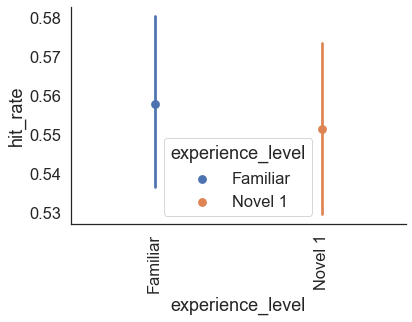

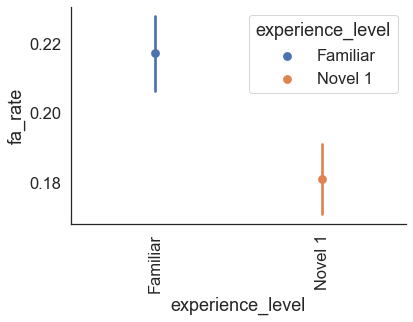

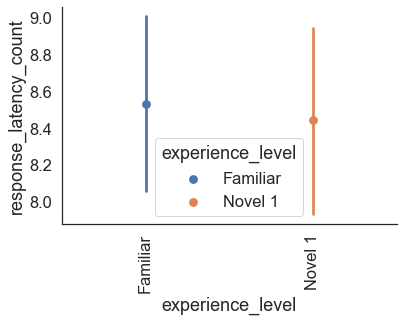

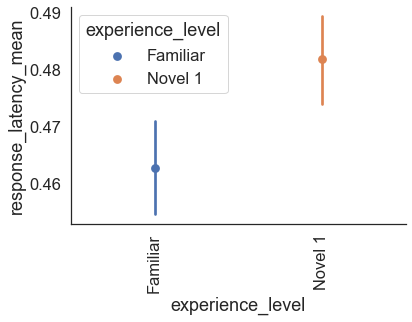

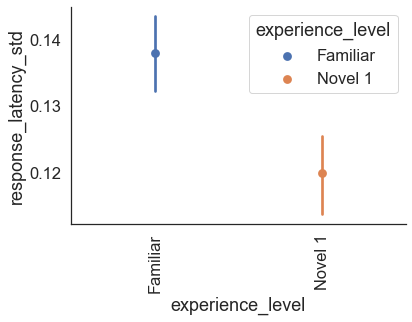

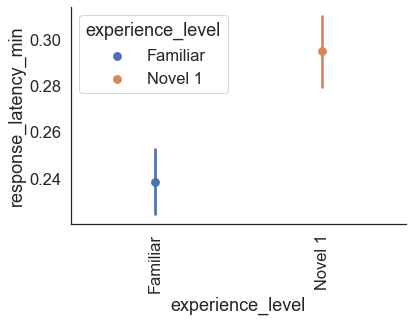

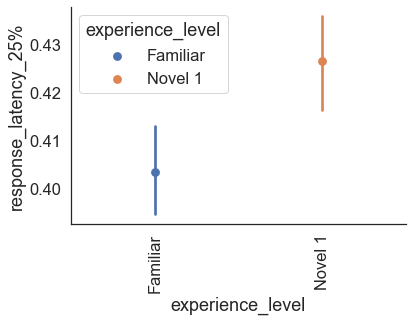

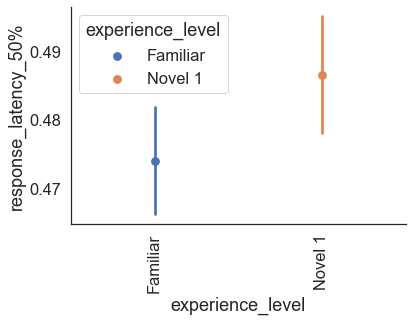

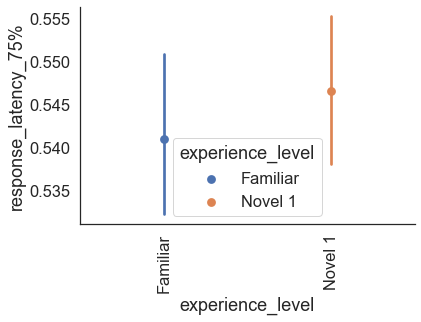

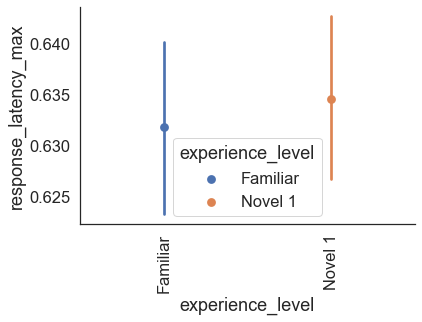

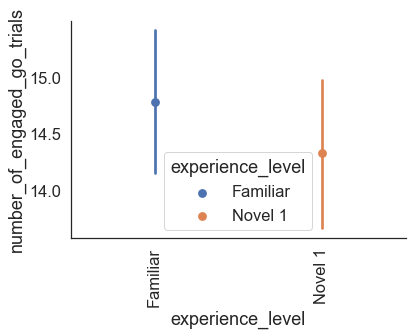

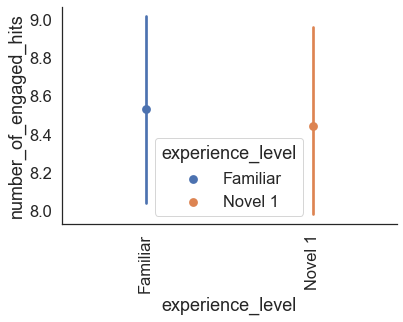

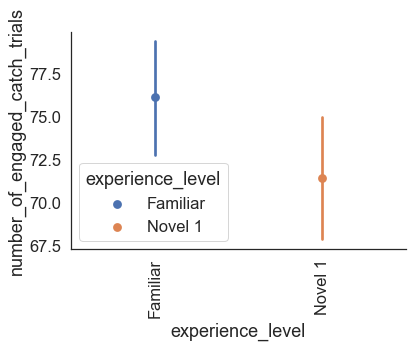

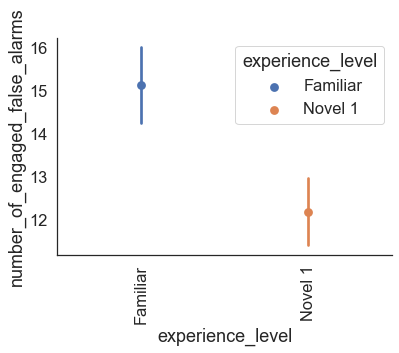

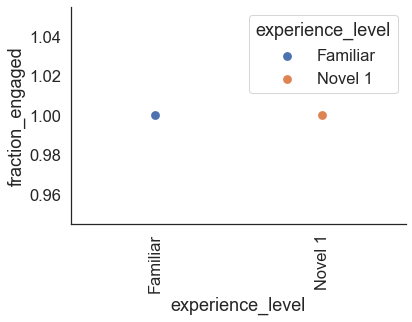

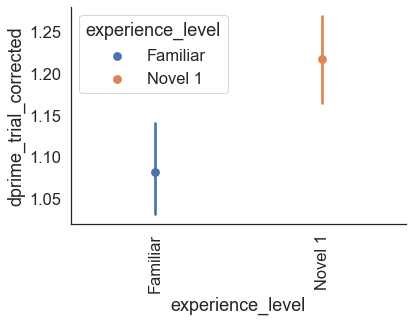

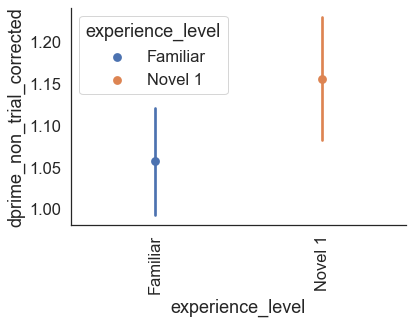

In [774]:
data = stats.copy()

for metric in metrics:
    figsize=(6,4)
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.pointplot(data=data, x='experience_level', y=metric, order=order, 
                       hue='experience_level', hue_order=order, colors=colors, join=False, ax=ax)
    ax.set_xticklabels(order, rotation=90);
#     ax.set_ylim(0, 1)
    
    utils.save_figure(fig, figsize, save_dir, folder, metric+'_pointplot_by_experience_level')

### plot d prime for each image for familiar and novel 

In [775]:
stats = behavior_stats[(behavior_stats.last_familiar_active==True)|(behavior_stats.first_novel)|(behavior_stats.second_novel_active)]

In [776]:
stats.keys()

Index(['behavior_session_id', 'image_name', 'hit_rate', 'fa_rate',
       'response_latency_count', 'response_latency_mean',
       'response_latency_std', 'response_latency_min', 'response_latency_25%',
       'response_latency_50%', 'response_latency_75%', 'response_latency_max',
       'number_of_engaged_go_trials', 'number_of_engaged_hits',
       'number_of_engaged_catch_trials', 'number_of_engaged_false_alarms',
       'fraction_engaged', 'dprime_trial_corrected',
       'dprime_non_trial_corrected', 'equipment_name', 'full_genotype',
       'mouse_id', 'reporter_line', 'driver_line', 'sex', 'age_in_days',
       'cre_line', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'ophys_session_id',
       'ophys_experiment_id', 'ophys_container_id', 'date_of_acquisition',
       'session_type', 'file_id', 'project_code', 'passive', 'cell_type',
       'experience_level', 'training_stage', 'fi

In [777]:
sorted_d_prime = stats.groupby(['project_code', 'stimulus', 'image_name']).mean()[['dprime_trial_corrected']].sort_values(by=['project_code', 'stimulus', 'dprime_trial_corrected'], ascending=False)
sorted_d_prime

dprime_trial_corrected
project_code         stimulus             image_name                        
VisualBehaviorTask1B images_B_habituation im045                     1.660296
                                          im054                     1.631403
                                          im031                     1.626116
                                          im075                     1.593219
                                          im035                     1.558467
...                                                                      ...
VisualBehavior       images_A             im063                     1.063318
                                          im062                     0.867890
                                          im066                     0.800796
                                          im077                     0.637342
                                          omitted                        NaN

[62 rows x 1 columns]

In [778]:
project_code = 'VisualBehavior'
stimulus = 'images_A'
sorted_d_prime.loc[(project_code, stimulus)].index.values[:2]

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until


array(['im069', 'im065'], dtype=object)

In [779]:
project_code = 'VisualBehaviorMultiscope'
stimulus = 'images_A'
sorted_d_prime.loc[(project_code, stimulus)].index.values[:2]

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until


array(['im085', 'im069'], dtype=object)

In [780]:
best_familiar = ['im069', 'im000']
best_novel = ['im045', 'im061']

In [781]:
stats = behavior_stats[(behavior_stats.last_familiar_active==True)|(behavior_stats.first_novel)|(behavior_stats.second_novel_active)]

In [782]:
familiar_stats = stats[(stats.experience_level=='Familiar')&(stats.image_name.isin(best_familiar))]
novel_stats = stats[(stats.experience_level.isin(['Novel 1', 'Novel >1']))&(stats.image_name.isin(best_novel))]

In [783]:
df = pd.concat([familiar_stats, novel_stats])

In [ ]:
# tmp = stats.loc[platform_expts.behavior_session_id]
# tmp = tmp[tmp.project_code.isin(['VisualBehavior', 'VisualBehaviorMultiscope'])]
# sorted_d_prime = tmp.groupby(['stimulus', 'experience_level']).mean()[['dprime_trial_corrected']].sort_values(by=['project_code', 'stimulus', 'dprime_trial_corrected'], ascending=False)

# stimulus='images_A'
# best_familiar = sorted_d_prime.loc[(stimulus)].index.values[:2]

# stimulus='images_B'
# best_novel = sorted_d_prime.loc[(stimulus)].index.values[:2]


# familiar_stats = stats[(stats.experience_level=='Familiar')&(stats.image_name.isin(best_familiar))]
# novel_stats = stats[(stats.experience_level.isin(['Novel 1', 'Novel >1']))&(stats.image_name.isin(best_novel))]
# df = pd.concat([familiar_stats, novel_stats])

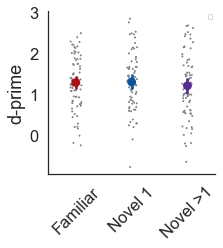

In [784]:
metric = 'dprime_trial_corrected'

data = df.copy()
# color_map = utils.get_stimulus_phase_color_map(as_rgb=False)
# colors = [list(color_map[ab_stage]) for ab_stage in ab_stages]
colors = utils.get_experience_level_colors()
experience_levels = utils.get_experience_levels()

figsize=(2.8,4)
fig, ax = plt.subplots(1,1, figsize=figsize)
ax = sns.stripplot(data=data, x='experience_level', y=metric, order=experience_levels, 
                      orient='v', color='gray', dodge=True, jitter=0.1, size=2, ax=ax, zorder=0)
ax = sns.pointplot(data=data, x='experience_level', y=metric, order=experience_levels, 
                      orient='v', palette=colors, dodge=True, jitter=0.1, size=4, ax=ax)
ax.set_xticklabels(experience_levels, rotation=45)
ax.set_xlabel('')
ax.set_ylabel('')
# ax[i].set_title(cell_type)
ax.set_ylabel('d-prime')
ax.legend(bbox_to_anchor=(1,1), fontsize='xx-small')
# fig.suptitle('Cohort 2', x=0.52, y=1.1)
utils.save_figure(fig, figsize, save_dir, folder, 'd_prime_exp_levels_best_images')

### go and catch trials for Familiar & novel 

In [785]:
stats = stats.reset_index()

In [786]:
stats.keys()

Index(['index', 'behavior_session_id', 'image_name', 'hit_rate', 'fa_rate',
       'response_latency_count', 'response_latency_mean',
       'response_latency_std', 'response_latency_min', 'response_latency_25%',
       'response_latency_50%', 'response_latency_75%', 'response_latency_max',
       'number_of_engaged_go_trials', 'number_of_engaged_hits',
       'number_of_engaged_catch_trials', 'number_of_engaged_false_alarms',
       'fraction_engaged', 'dprime_trial_corrected',
       'dprime_non_trial_corrected', 'equipment_name', 'full_genotype',
       'mouse_id', 'reporter_line', 'driver_line', 'sex', 'age_in_days',
       'cre_line', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'ophys_session_id',
       'ophys_experiment_id', 'ophys_container_id', 'date_of_acquisition',
       'session_type', 'file_id', 'project_code', 'passive', 'cell_type',
       'experience_level', 'training_st

In [787]:
stats = behavior_stats[(behavior_stats.last_familiar_active==True)|(behavior_stats.first_novel)|(behavior_stats.second_novel_active)&(behavior_stats.experience_level!='None')]

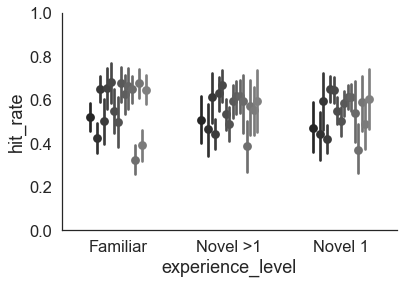

In [788]:
fig, ax = plt.subplots()
ax = sns.pointplot(data=stats, x='experience_level', y='hit_rate', hue='image_name', 
                   color='gray', join=False, dodge=0.5, ax=ax)
ax.set_ylim(0,1)
ax.get_legend().remove()

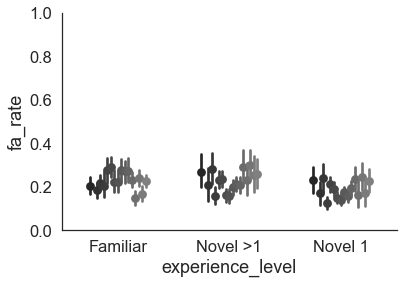

In [789]:
fig, ax = plt.subplots()
ax = sns.pointplot(data=stats, x='experience_level', y='fa_rate', hue='image_name', 
                   color='gray', join=False, dodge=0.5, ax=ax)
ax.set_ylim(0,1)
ax.get_legend().remove()

### plot behavior metrics for each image for familiar & novel image sets

In [790]:
stats = behavior_stats[(behavior_stats.last_familiar_active==True)|(behavior_stats.first_novel)]

In [791]:
def plot_metric_data_per_image(data, metric='dprime_trial_corrected', title='', ax=None):
    if ax is None: 
        fig, ax = plt.subplots()
    image_order = data.groupby(['image_name']).mean()[[metric]].sort_values(by=[metric]).index.values
    ax = sns.pointplot(data=data, x='image_name', y=metric, order=image_order, join=False, ax=ax)
    ax.set_title(title)
    ax.set_xticklabels(image_order, rotation=90)
    ax.set_xlabel('')
    ax.set_ylabel(metric)
#     ax.set_ylim(0,1)
    return ax

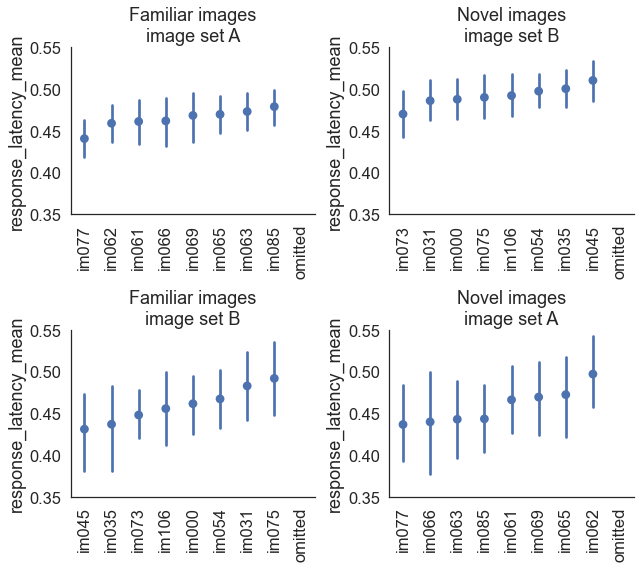

In [792]:
metric = 'response_latency_mean'

fig, ax = plt.subplots(2,2, figsize=(9,8))
ax = ax.ravel()

# A-B mice
data = stats[stats.project_code.isin(['VisualBehavior', 'VisualBehaviorMultiscope'])]
# familiar data
familiar_data = data[data.experience_level=='Familiar']
ax[0] = plot_metric_data_per_image(familiar_data, metric=metric, title='Familiar images\nimage set A', ax=ax[0])
# novel data
novel_data = data[data.experience_level=='Novel 1']
ax[1] = plot_metric_data_per_image(novel_data, metric=metric, title='Novel images\nimage set B', ax=ax[1])


# B-A mice
data = stats[stats.project_code.isin(['VisualBehaviorTask1B'])]
# familiar data
familiar_data = data[data.experience_level=='Familiar']
ax[2] = plot_metric_data_per_image(familiar_data, metric=metric, title='Familiar images\nimage set B', ax=ax[2])

# novel data
novel_data = data[data.experience_level=='Novel 1']
ax[3] = plot_metric_data_per_image(novel_data, metric=metric, title='Novel images\nimage set A', ax=ax[3])

for i in range(4):
    ax[i].set_ylim(0.35,0.55)
fig.tight_layout()

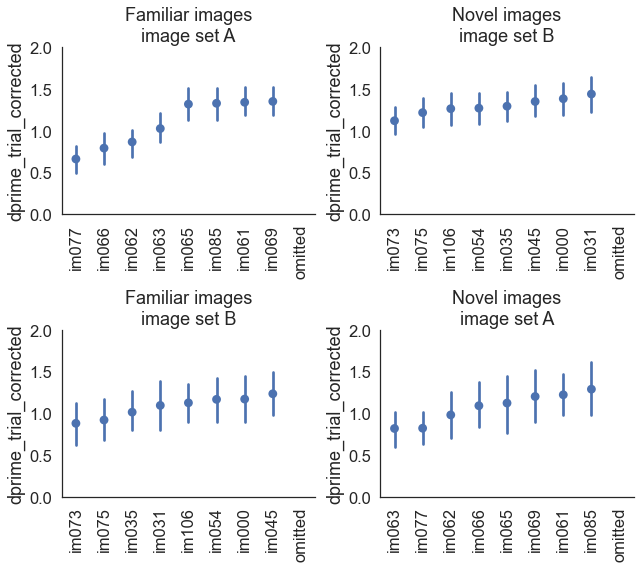

In [793]:
metric = 'dprime_trial_corrected'

fig, ax = plt.subplots(2,2, figsize=(9,8))
ax = ax.ravel()

# A-B mice
data = stats[stats.project_code.isin(['VisualBehavior', 'VisualBehaviorMultiscope'])]
# familiar data
familiar_data = data[data.experience_level=='Familiar']
ax[0] = plot_metric_data_per_image(familiar_data, metric=metric, title='Familiar images\nimage set A', ax=ax[0])
# novel data
novel_data = data[data.experience_level=='Novel 1']
ax[1] = plot_metric_data_per_image(novel_data, metric=metric, title='Novel images\nimage set B', ax=ax[1])


# B-A mice
data = stats[stats.project_code.isin(['VisualBehaviorTask1B'])]
# familiar data
familiar_data = data[data.experience_level=='Familiar']
ax[2] = plot_metric_data_per_image(familiar_data, metric=metric, title='Familiar images\nimage set B', ax=ax[2])

# novel data
novel_data = data[data.experience_level=='Novel 1']
ax[3] = plot_metric_data_per_image(novel_data, metric=metric, title='Novel images\nimage set A', ax=ax[3])

for i in range(4):
    ax[i].set_ylim(0,2)
fig.tight_layout()

#### hit and FA rates per image

In [794]:
def plot_hit_fa_rates(data, title='', ax=None):
    if ax is None: 
        fig, ax = plt.subplots()
    image_order = data.groupby(['image_name']).mean()[['hit_rate']].sort_values(by=['hit_rate']).index.values
    # hits
    ax = sns.pointplot(data=data, x='image_name', y='hit_rate', order=image_order, color='g', join=False, ax=ax)
    # FA
    ax = sns.pointplot(data=data, x='image_name', y='fa_rate', order=image_order, color='r', join=False, ax=ax)
    ax.set_title(title)
#     ax.set_xticklabels([image[2:] if image!='omitted' else image for image in image_order], rotation=90)
    ax.set_xticklabels(image_order, rotation=90)
    ax.set_xlabel('')
    ax.set_ylabel('response probability')
    ax.set_ylim(0,1)
    return ax

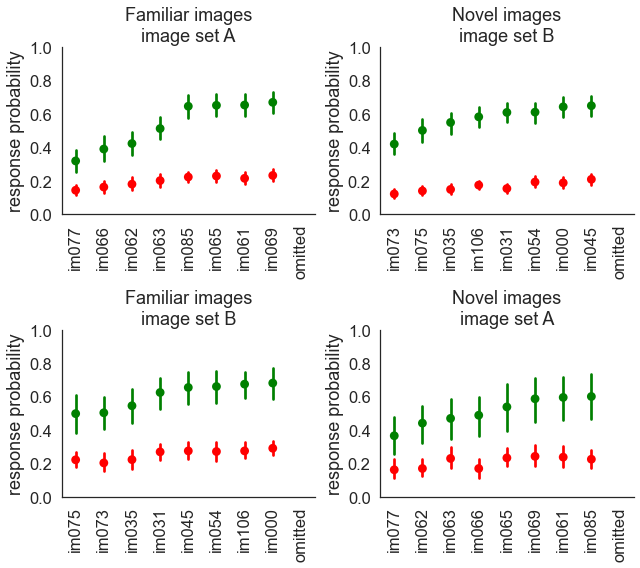

In [795]:
fig, ax = plt.subplots(2,2, figsize=(9,8))
ax = ax.ravel()

# A-B mice
data = stats[stats.project_code.isin(['VisualBehavior', 'VisualBehaviorMultiscope'])]
# familiar data
familiar_data = data[data.experience_level=='Familiar']
ax[0] = plot_hit_fa_rates(familiar_data, title='Familiar images\nimage set A', ax=ax[0])
# novel data
novel_data = data[data.experience_level=='Novel 1']
ax[1] = plot_hit_fa_rates(novel_data, title='Novel images\nimage set B', ax=ax[1])


# B-A mice
data = stats[stats.project_code.isin(['VisualBehaviorTask1B'])]
# familiar data
familiar_data = data[data.experience_level=='Familiar']
ax[2] = plot_hit_fa_rates(familiar_data, title='Familiar images\nimage set B', ax=ax[2])

# novel data
novel_data = data[data.experience_level=='Novel 1']
ax[3] = plot_hit_fa_rates(novel_data, title='Novel images\nimage set A', ax=ax[3])

fig.tight_layout()

### plot response probability heatmaps for all image transitions in last familiar and first novel sessions

### full session

In [796]:
import visual_behavior.visualization.behavior as behavior

In [797]:
method = 'response_probability'
engaged_only = False
per_image = False

folder = get_save_folder(method, engaged_only, per_image)

In [798]:
familiar_sessions = behavior_sessions[behavior_sessions.last_familiar_active==True].index.values
novel_sessions = behavior_sessions[behavior_sessions.first_novel==True].index.values
print(len(familiar_sessions), len(novel_sessions))

78 78


In [799]:
# get response probability dataframe
familiar_response_probability = behavior.aggregate_response_probability_across_sessions(familiar_sessions, engaged_only=engaged_only)
novel_response_probability = behavior.aggregate_response_probability_across_sessions(novel_sessions, engaged_only=engaged_only)

# add metadata
familiar_response_probability = familiar_response_probability.merge(behavior_sessions, on='behavior_session_id')
novel_response_probability = novel_response_probability.merge(behavior_sessions, on='behavior_session_id')

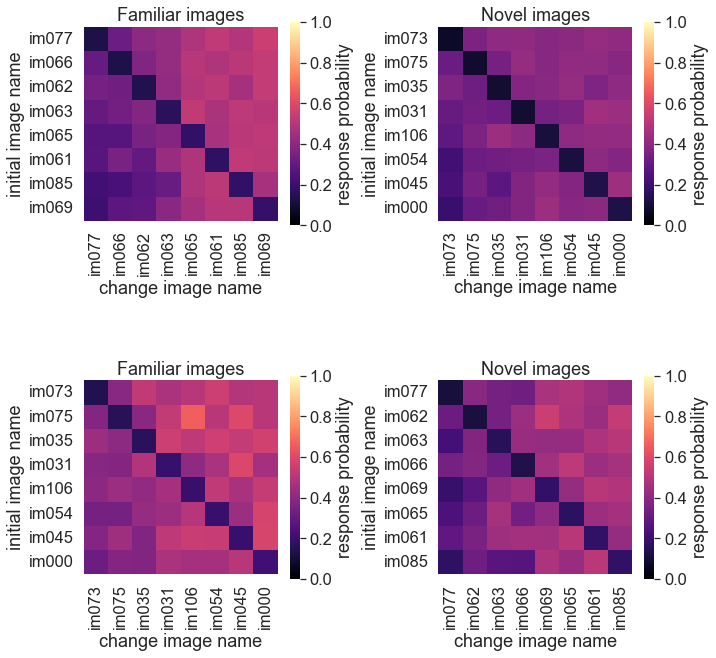

In [800]:
figsize = (10,10)
fig, ax = plt.subplots(2,2, figsize=figsize)
ax = ax.ravel()

# A-B mice
familiar_data = familiar_response_probability[familiar_response_probability.project_code.isin(['VisualBehavior', 'VisualBehaviorMultiscope'])]
novel_data = novel_response_probability[novel_response_probability.project_code.isin(['VisualBehavior', 'VisualBehaviorMultiscope'])]
# get matrices
familiar_response_matrix = behavior.average_response_probability_across_sessions(familiar_data, sort=True)
novel_response_matrix = behavior.average_response_probability_across_sessions(novel_data, sort=True)

ax[0] = sns.heatmap(familiar_response_matrix, cmap='magma', vmin=0, vmax=1, square=True, 
                 cbar_kws={'label':'response probability', 'shrink':0.7}, ax=ax[0])
ax[0].set_xlabel('change image name')
ax[0].set_ylabel('initial image name')
ax[0].set_title('Familiar images')

ax[1] = sns.heatmap(novel_response_matrix, cmap='magma', vmin=0, vmax=1, square=True, 
                 cbar_kws={'label':'response probability', 'shrink':0.7}, ax=ax[1])
ax[1].set_xlabel('change image name')
ax[1].set_ylabel('initial image name')
ax[1].set_title('Novel images')


# B-A mice
familiar_data = familiar_response_probability[familiar_response_probability.project_code.isin(['VisualBehaviorTask1B'])]
novel_data = novel_response_probability[novel_response_probability.project_code.isin(['VisualBehaviorTask1B'])]
# get matrices
familiar_response_matrix = behavior.average_response_probability_across_sessions(familiar_data, sort=True)
novel_response_matrix = behavior.average_response_probability_across_sessions(novel_data, sort=True)

ax[2] = sns.heatmap(familiar_response_matrix, cmap='magma', vmin=0, vmax=1, square=True, 
                 cbar_kws={'label':'response probability', 'shrink':0.7}, ax=ax[2])
ax[2].set_xlabel('change image name')
ax[2].set_ylabel('initial image name')
ax[2].set_title('Familiar images')

ax[3] = sns.heatmap(novel_response_matrix, cmap='magma', vmin=0, vmax=1, square=True, 
                 cbar_kws={'label':'response probability', 'shrink':0.7}, ax=ax[3])
ax[3].set_xlabel('change image name')
ax[3].set_ylabel('initial image name')
ax[3].set_title('Novel images')

fig.tight_layout()
utils.save_figure(fig, figsize, save_dir, folder, 'response_probability_familiar_novel')

### engaged portions of sessions only

In [801]:
method = 'response_probability'
engaged_only = True
per_image = False

folder = get_save_folder(method, engaged_only, per_image)

In [802]:
familiar_sessions = behavior_sessions[behavior_sessions.last_familiar_active==True].index.values
novel_sessions = behavior_sessions[behavior_sessions.first_novel==True].index.values
print(len(familiar_sessions), len(novel_sessions))

78 78


In [803]:
# get response probability dataframe
familiar_response_probability = behavior.aggregate_response_probability_across_sessions(familiar_sessions, engaged_only=engaged_only)
novel_response_probability = behavior.aggregate_response_probability_across_sessions(novel_sessions, engaged_only=engaged_only)

# add metadata
familiar_response_probability = familiar_response_probability.merge(behavior_sessions, on='behavior_session_id')
novel_response_probability = novel_response_probability.merge(behavior_sessions, on='behavior_session_id')

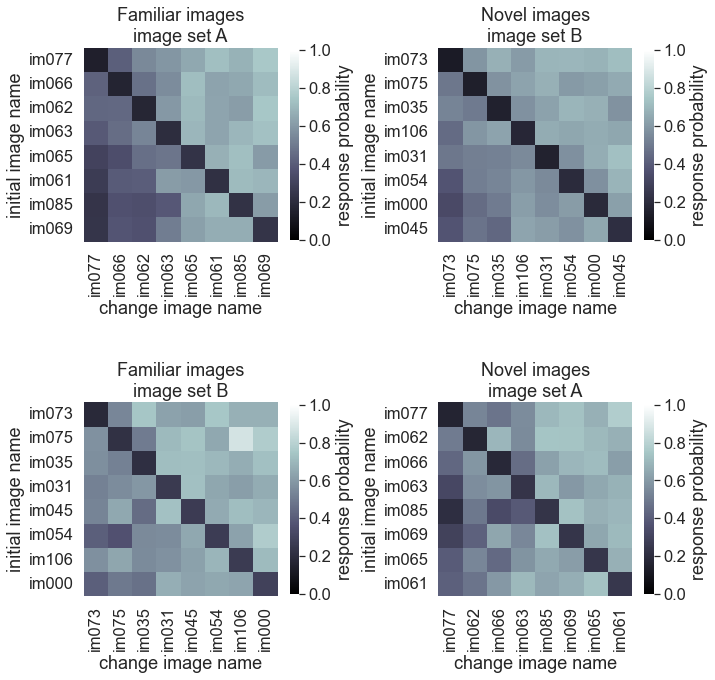

In [808]:
figsize = (10,10)
fig, ax = plt.subplots(2,2, figsize=figsize)
ax = ax.ravel()

cmap = 'bone'

# A-B mice
familiar_data = familiar_response_probability[familiar_response_probability.project_code.isin(['VisualBehavior', 'VisualBehaviorMultiscope'])]
novel_data = novel_response_probability[novel_response_probability.project_code.isin(['VisualBehavior', 'VisualBehaviorMultiscope'])]
# get matrices
familiar_response_matrix = behavior.average_response_probability_across_sessions(familiar_data, sort=True)
novel_response_matrix = behavior.average_response_probability_across_sessions(novel_data, sort=True)

ax[0] = sns.heatmap(familiar_response_matrix, cmap=cmap, vmin=0, vmax=1, square=True, 
                 cbar_kws={'label':'response probability', 'shrink':0.7}, ax=ax[0])
ax[0].set_xlabel('change image name')
ax[0].set_ylabel('initial image name')
ax[0].set_title('Familiar images\nimage set A')

ax[1] = sns.heatmap(novel_response_matrix, cmap=cmap, vmin=0, vmax=1, square=True, 
                 cbar_kws={'label':'response probability', 'shrink':0.7}, ax=ax[1])
ax[1].set_xlabel('change image name')
ax[1].set_ylabel('initial image name')
ax[1].set_title('Novel images\nimage set B')


# B-A mice
familiar_data = familiar_response_probability[familiar_response_probability.project_code.isin(['VisualBehaviorTask1B'])]
novel_data = novel_response_probability[novel_response_probability.project_code.isin(['VisualBehaviorTask1B'])]
# get matrices
familiar_response_matrix = behavior.average_response_probability_across_sessions(familiar_data, sort=True)
novel_response_matrix = behavior.average_response_probability_across_sessions(novel_data, sort=True)

ax[2] = sns.heatmap(familiar_response_matrix, cmap=cmap, vmin=0, vmax=1, square=True, 
                 cbar_kws={'label':'response probability', 'shrink':0.7}, ax=ax[2])
ax[2].set_xlabel('change image name')
ax[2].set_ylabel('initial image name')
ax[2].set_title('Familiar images\nimage set B')

ax[3] = sns.heatmap(novel_response_matrix, cmap=cmap, vmin=0, vmax=1, square=True, 
                 cbar_kws={'label':'response probability', 'shrink':0.7}, ax=ax[3])
ax[3].set_xlabel('change image name')
ax[3].set_ylabel('initial image name')
ax[3].set_title('Novel images\nimage set A')

fig.tight_layout()
utils.save_figure(fig, figsize, save_dir, folder, 'response_probability_familiar_novel_engaged_only')

### sort and plot performance across all image transitions for A-B mice

In [43]:
familiar_sessions = behavior_sessions[(behavior_sessions.last_familiar_active==True) &
                                     (behavior_sessions.project_code.isin(['VisualBehavior', 'VisualBehaviorMultiscope']))].index.values
novel_sessions = behavior_sessions[(behavior_sessions.first_novel==True) & 
                                  (behavior_sessions.project_code.isin(['VisualBehavior', 'VisualBehaviorMultiscope']))].index.values
print(len(familiar_sessions), len(novel_sessions))

52 52


In [44]:
familiar_data = behavior.aggregate_response_probability_across_sessions(familiar_sessions, engaged_only=engaged_only)
novel_data = behavior.aggregate_response_probability_across_sessions(novel_sessions, engaged_only=engaged_only)

In [45]:
len(familiar_data.image_name.unique())

8

In [46]:
def add_image_pair_column(data):
    data = data.reset_index(drop=True)
    data['image_pair'] = [data.iloc[row]['previous_image_name'][2:]+'_'+data.iloc[row]['image_name'][2:] for row in range(len(data))]
    return data

In [47]:
familiar_data = add_image_pair_column(familiar_data)
novel_data = add_image_pair_column(novel_data)

In [48]:
familiar_pair_order = familiar_data.groupby('image_pair').mean()[['response_probability']].sort_values(by='response_probability').index.values
novel_pair_order = novel_data.groupby('image_pair').mean()[['response_probability']].sort_values(by='response_probability').index.values

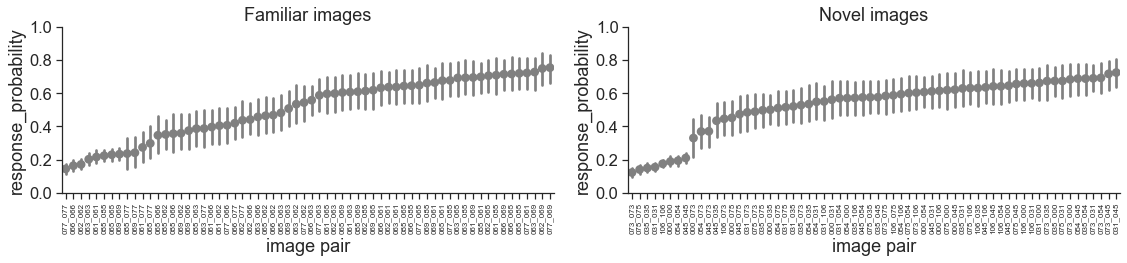

In [49]:
figsize = (16,4)
fig, ax = plt.subplots(1, 2, figsize=figsize)

ax[0] = sns.pointplot(data=familiar_data, x='image_pair', y='response_probability', order=familiar_pair_order, 
                      color='gray', join=False, ax=ax[0])
ax[0].set_xticklabels(familiar_pair_order, rotation=90, fontsize=8)
ax[0].set_xlabel('image pair')
ax[0].set_ylim(0, 1)
ax[0].set_title('Familiar images')


ax[1] = sns.pointplot(data=novel_data, x='image_pair', y='response_probability', order=novel_pair_order, 
                      color='gray', join=False, ax=ax[1])
ax[1].set_xticklabels(novel_pair_order, rotation=90, fontsize=8)
ax[1].set_xlabel('image pair')
ax[1].set_ylim(0, 1)
ax[1].set_title('Novel images')

fig.tight_layout()

In [50]:
def add_image_pair_index(data, pair_order):
    data['image_pair_index'] = None
    for row in range(len(data)):
        image_pair = data.iloc[row].image_pair
        pairs = list(pair_order)
        index = pairs.index(image_pair)
        data.at[row, 'image_pair_index'] = index
    return data

In [51]:
familiar_data = add_image_pair_index(familiar_data, familiar_pair_order)
novel_data = add_image_pair_index(novel_data, novel_pair_order)

In [52]:
order = np.sort(stats.experience_level.unique())

colors = utils.get_colors_for_session_numbers()
colors = [colors[0], colors[3]]

Text(0, 0.5, 'response probability')

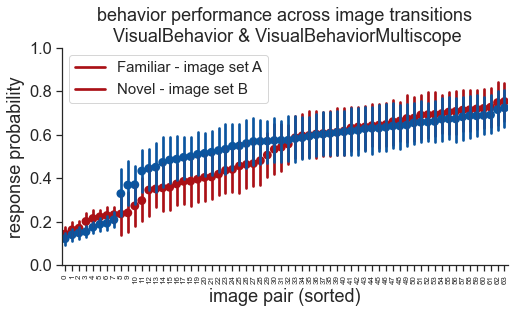

In [53]:
order = np.sort(familiar_data.image_pair_index.unique())

figsize = (8,4)
fig, ax = plt.subplots(figsize=figsize)

ax = sns.pointplot(data=familiar_data, x='image_pair_index', y='response_probability', order=order, 
                      color=colors[0], label='Familiar', join=False, ax=ax)
ax = sns.pointplot(data=novel_data, x='image_pair_index', y='response_probability', order=order, 
                      color=colors[1], label='Novel', join=False, ax=ax)
ax.set_xticklabels(order, rotation=90, fontsize=8)
ax.set_xlabel('image pair (sorted)')
ax.set_ylim(0, 1)
ax.legend(['Familiar - image set A', 'Novel - image set B'], loc='upper left', fontsize='small')
ax.set_title('behavior performance across image transitions\n VisualBehavior & VisualBehaviorMultiscope')
ax.set_ylabel('response probability')

Note: Novel is actually blue

#### whats up with the images in the range where familiar is lower than novel? 

In [54]:
low_perf_images = familiar_data[familiar_data.image_pair_index.isin(np.arange(8,32))].image_name.unique()

In [55]:
familiar_experiment_id = experiments_table[experiments_table.behavior_session_id==familiar_data.behavior_session_id.values[0]].index.values[0]
dataset = loading.get_ophys_dataset(familiar_experiment_id)

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))


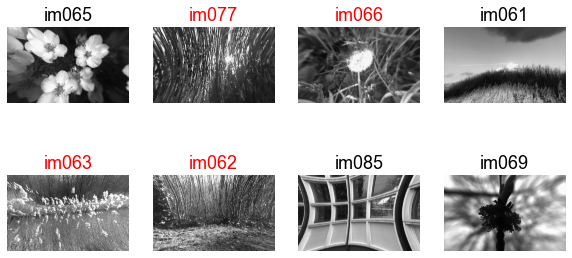

In [56]:
stimulus_templates = dataset.stimulus_templates.copy()
fig, ax = plt.subplots(2,4,figsize=(10,5))
ax=ax.ravel()
for i,image_name in enumerate(stimulus_templates.index):
    ax[i].imshow(stimulus_templates.loc[image_name]['warped'], cmap='gray')
    if image_name in low_perf_images:
        color='r'
    else:
        color='k'
    ax[i].set_title(image_name, color=color)
    ax[i].axis('off')

These are generally the high spatial frequency images...

### which novel images are in the same range in the ordered set?

In [57]:
novel_low_perf_images = novel_data[novel_data.image_pair_index.isin(np.arange(8,32))].image_name.unique()

In [58]:
novel_experiment_id = experiments_table[experiments_table.behavior_session_id==novel_data.behavior_session_id.values[0]].index.values[0]
dataset = loading.get_ophys_dataset(novel_experiment_id)

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\data_objects\eye_tracking\rig_geometry.py:135: UserWarning: This nwb file with identifier '795953296' has no eye tracking rig metadata. (NWB error: "'eye_tracking_rig_metadata' not found in processing of NWBFile 'root'.")
  warnings.warn("This nwb file with identifier "
C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\data_objects\eye_tracking\eye_tracking_table.py:136: UserWarning: This nwb file with identifier '795953296' has no eye tracking data. (NWB error: 'EyeTracking')
  warnings.warn("This nwb file with identifier "


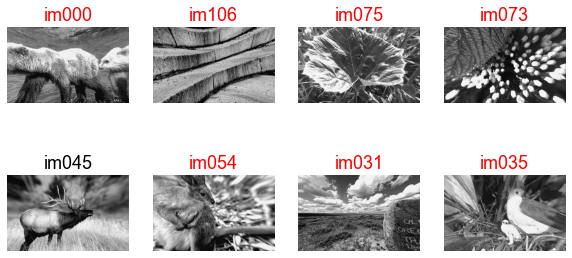

In [59]:
stimulus_templates = dataset.stimulus_templates.copy()
fig, ax = plt.subplots(2,4,figsize=(10,5))
ax=ax.ravel()
for i,image_name in enumerate(stimulus_templates.index):
    ax[i].imshow(stimulus_templates.loc[image_name]['warped'], cmap='gray')
    if image_name in novel_low_perf_images:
        color='r'
    else:
        color='k'
    ax[i].set_title(image_name, color=color)
    ax[i].axis('off')

In [60]:
novel_low_perf_images

array(['im073', 'im106', 'im075', 'im031', 'im035', 'im000', 'im054'],
      dtype=object)

In [61]:
# does it matter what image it changed from?
novel_data[novel_data.image_pair_index.isin(np.arange(8,32))].previous_image_name.unique()

array(['im106', 'im075', 'im031', 'im035', 'im000', 'im054', 'im045'],
      dtype=object)

In [62]:
np.sort(novel_data[novel_data.image_pair_index.isin(np.arange(8,32))].image_pair.unique())

array(['000_031', '000_035', '000_073', '000_075', '031_035', '031_054',
       '031_073', '031_075', '031_106', '035_073', '035_075', '035_106',
       '045_035', '045_054', '045_073', '045_075', '054_000', '054_031',
       '054_035', '054_073', '054_075', '075_035', '075_073', '106_073'],
      dtype=object)

### repeat for B-A mice

In [63]:
familiar_sessions = behavior_sessions[(behavior_sessions.last_familiar_active==True) &
                                     (behavior_sessions.project_code.isin(['VisualBehaviorTask1B']))].index.values
novel_sessions = behavior_sessions[(behavior_sessions.first_novel==True) & 
                                  (behavior_sessions.project_code.isin(['VisualBehaviorTask1B']))].index.values
print(len(familiar_sessions), len(novel_sessions))

familiar_data = behavior.aggregate_response_probability_across_sessions(familiar_sessions, engaged_only=engaged_only)
novel_data = behavior.aggregate_response_probability_across_sessions(novel_sessions, engaged_only=engaged_only)

familiar_data = add_image_pair_column(familiar_data)
novel_data = add_image_pair_column(novel_data)

familiar_pair_order = familiar_data.groupby('image_pair').mean()[['response_probability']].sort_values(by='response_probability').index.values
novel_pair_order = novel_data.groupby('image_pair').mean()[['response_probability']].sort_values(by='response_probability').index.values

familiar_data = add_image_pair_index(familiar_data, familiar_pair_order)
novel_data = add_image_pair_index(novel_data, novel_pair_order)

26 26


Text(0, 0.5, 'response probability')

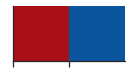

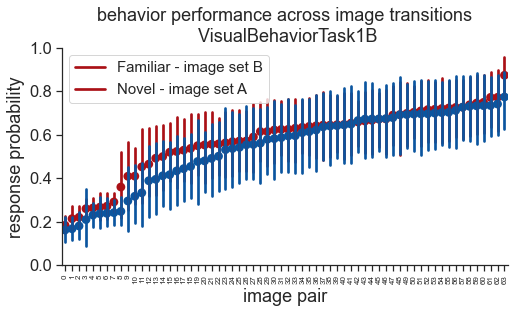

In [64]:
colors = utils.get_colors_for_session_numbers()
colors = [colors[0], colors[3]]
sns.palplot(colors)

order = np.sort(familiar_data.image_pair_index.unique())

figsize = (8,4)
fig, ax = plt.subplots(figsize=figsize)

ax = sns.pointplot(data=familiar_data, x='image_pair_index', y='response_probability', order=order, 
                      color=colors[0], label='Familiar - image set B', join=False, ax=ax)
ax = sns.pointplot(data=novel_data, x='image_pair_index', y='response_probability', order=order, 
                      color=colors[1], label='Novel - image set A', join=False, ax=ax)
ax.set_xticklabels(order, rotation=90, fontsize=8)
ax.set_xlabel('image pair')
ax.set_ylim(0, 1)
ax.legend(['Familiar - image set B', 'Novel - image set A'], loc='upper left', fontsize='small')
ax.set_title('behavior performance across image transitions\n VisualBehaviorTask1B')
ax.set_ylabel('response probability')

Note: Novel is actually blue

Difference isnt as bad, but it does indicate that image set A (which is Novel here, i.e. blue) does have images that are simply harder to detect

#### is it the same set of images that are harder to detect for image set A (Novel set in this case)?

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))


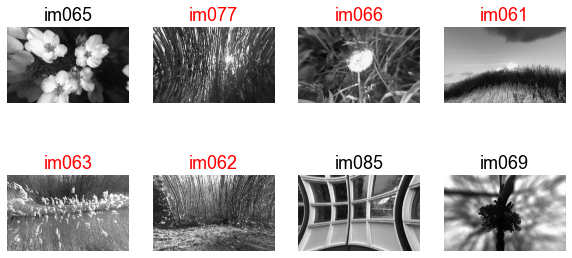

In [65]:
low_perf_images = novel_data[novel_data.image_pair_index.isin(np.arange(8,22))].image_name.unique()

novel_experiment_id = experiments_table[experiments_table.behavior_session_id==novel_data.behavior_session_id.values[0]].index.values[0]
dataset = loading.get_ophys_dataset(familiar_experiment_id)

stimulus_templates = dataset.stimulus_templates.copy()
fig, ax = plt.subplots(2,4,figsize=(10,5))
ax=ax.ravel()
for i,image_name in enumerate(stimulus_templates.index):
    ax[i].imshow(stimulus_templates.loc[image_name]['warped'], cmap='gray')
    if image_name in low_perf_images:
        color='r'
    else:
        color='k'
    ax[i].set_title(image_name, color=color)
    ax[i].axis('off')

### plot lick raster for first and last stage of each session type for one mouse

In [66]:
mouse_id = behavior_sessions.mouse_id.unique()[0]
mouse_data = behavior_sessions[behavior_sessions.mouse_id==mouse_id]

In [67]:
training_stages = np.sort(mouse_data[mouse_data.training_stage.str.contains('TRAINING')].training_stage.unique())

In [68]:
behavior_session_id = mouse_data[(mouse_data.training_stage==training_stages[0])&(mouse_data.first_day_of_stage)].index.values[0]
dataset = cache.get_behavior_session(behavior_session_id, skip_eye_tracking=True)

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))


In [69]:
import visual_behavior.visualization.ophys.experiment_summary_figures as ep

c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\visualization\ophys\experiment_summary_figures.py:111: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, len(trials))
c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\visualization\ophys\experiment_summary_figures.py:111: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, len(trials))


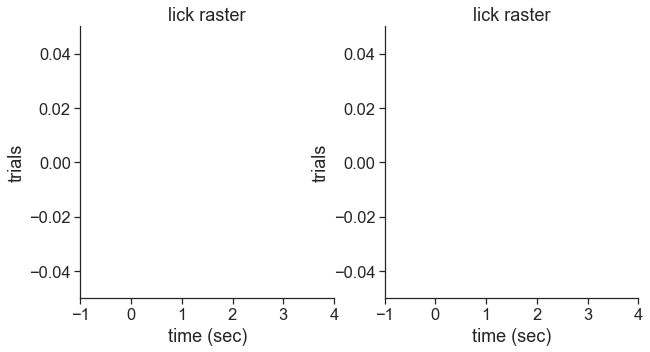

In [70]:
figsize = (10,5)
fig, ax = plt.subplots(1,2, figsize=figsize)
trials = dataset.trials.copy()
trials = trials.reset_index()
trials = trials[(trials.auto_rewarded==False)&(trials.aborted==False)]
go_trials = trials[trials.go==True]
catch_trials = trials[trials.catch==True]

ax[0] = ep.plot_lick_raster(go_trials, response_window=dataset.task_parameters['response_window_sec'], ax=ax[0], save_dir=None)
ax[1] = ep.plot_lick_raster(catch_trials, response_window=dataset.task_parameters['response_window_sec'], ax=ax[1], save_dir=None)

### get behavior session object for sessions of interest

In [71]:
behavior_session_ids = []
for i, training_stage in enumerate(training_stages):
    behavior_session_id = mouse_data[(mouse_data.training_stage==training_stage)&(mouse_data.first_day_of_stage)].index.values[0]
    behavior_session_ids.append(behavior_session_id)
    behavior_session_id = mouse_data[(mouse_data.training_stage==training_stage)&(mouse_data.last_day_of_stage)].index.values[0]
    behavior_session_ids.append(behavior_session_id)
    
data_dict = {}
for behavior_session_id in behavior_session_ids:
    dataset = cache.get_behavior_session(behavior_session_id)
    data_dict[behavior_session_id] = dataset

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\data_objects\eye_tracking\rig_geometry.py:135: UserWarning: This nwb file with identifier '742008131' has no eye tracking rig metadata. (NWB error: "'eye_tracking_rig_metadata' not found in processing of NWBFile 'root'.")
  warnings.warn("This nwb file with identifier "
C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\data_objects\eye_tracking\eye_tracking_table.py:136: UserWarning: This nwb file with identifier '742008131' has no eye tracking data. (NWB error: 'EyeTracking')
  warnings.warn("This nwb file with identifier "
C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:5

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\data_objects\eye_tracking\rig_geometry.py:135: UserWarning: This nwb file with identifier '772658979' has no eye tracking rig metadata. (NWB error: "'eye_tracking_rig_metadata' not found in processing of NWBFile 'root'.")
  warnings.warn("This nwb file with identifier "
C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\data_objects\eye_tracking\eye_tracking_table.py:136: UserWarning: This nwb file with identifier '772658979' has no eye tracking data. (NWB error: 'EyeTracking')
  warnings.warn("This nwb file with identifier "


In [321]:
def plot_lick_raster(trials, response_window=[0.15, 0.75], title='lick_raster', ax=None, save_dir=None):
    from visual_behavior.translator.core.annotate import colormap
    import visual_behavior.data_access.reformat as reformat
    trials = reformat.add_trial_type_to_trials_table(trials)
    if ax is None:
        figsize = (3, 3)
        fig, ax = plt.subplots(figsize=figsize)
    for trial, trials_id in enumerate(trials.trials_id.values):
        trial_data = trials.loc[trials_id]
        trial_type = trial_data.trial_type
        # get times relative to change time
        trial_start = trial_data.start_time - trial_data.change_time
        lick_times = [(t - trial_data.change_time) for t in trial_data.lick_times]
        reward_time = trial_data.reward_time - trial_data.change_time
        # plot trials as colored rows
        ax.axhspan(trial, trial + 1, -200, 200, color='white', alpha=.5)
        # plot reward times
        if np.isnan(reward_time)==False:
            ax.plot(reward_time, trial + 0.5, '.', color='b', label='reward', markersize=6)
        ax.vlines(trial_start, trial, trial + 1, color='black', linewidth=1)
        # plot lick times
        ax.vlines(lick_times, trial, trial + 1, color='k', linewidth=1)
        # annotate change time
        ax.vlines(0, trial, trial + 1, color=[.5, .5, .5], linewidth=1)
    # gray bar for response window
    ax.axvspan(response_window[0], response_window[1], facecolor='gray', alpha=.4, edgecolor='none')
    ax.grid(False)
    ax.set_ylim(0, len(trials))
    ax.set_xlim([-1, 4])
    ax.set_ylabel('trials')
    ax.set_xlabel('time (sec)')
    ax.set_title(title)
    plt.gca().invert_yaxis()
#     if save_dir:
#         save_figure(fig, figsize, save_dir, 'behavior', 'lick_raster')
#     return ax

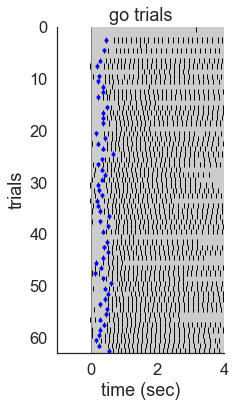

In [315]:
plot_lick_raster(trials[trials.go], title='go trials', response_window=[0, 750], ax=None, save_dir=None)
plot_lick_raster(trials[trials.catch], title='catch trials', response_window=dataset.task_parameters['response_window_sec'], ax=None, save_dir=None)

In [316]:
high_perf_sessions = stats[stats.dprime_trial_corrected>2].behavior_session_id.unique()

In [317]:
behavior_session_ids = behavior_sessions.loc[high_perf_sessions][(behavior_sessions.experience_level=='Familiar')].index.values

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [318]:
behavior_session_ids

array([ 849651275,  898874650,  899390684,  903708760,  910829549,
        914705301,  923410363,  898938920,  898982250, 1037743363,
       1076048999], dtype=int64)

In [304]:
behavior_session_id = behavior_session_ids[0]
dataset = loading.get_behavior_dataset(behavior_session_id)
trials = dataset.trials.copy()
trials = trials.reset_index()
trials = trials[(trials.auto_rewarded==False)&(trials.aborted==False)]


C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))


849651275


C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))


898874650


C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))


899390684


C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))


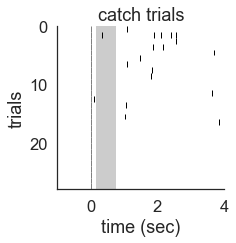

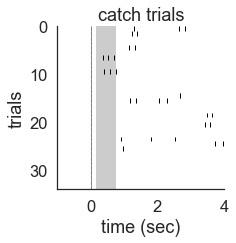

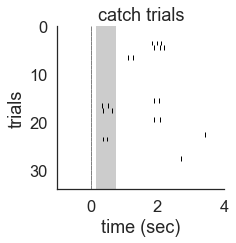

In [322]:
for behavior_session_id in behavior_session_ids[:3]:
    print(behavior_session_id)
    
    dataset = loading.get_behavior_dataset(behavior_session_id)
    trials = dataset.trials.copy()
    trials = trials.reset_index()
    trials = trials[(trials.auto_rewarded==False)&(trials.aborted==False)]

#     plot_lick_raster(trials[trials.go], title='go trials', response_window=[0, .750], ax=None, save_dir=None)
    plot_lick_raster(trials[trials.catch], title='catch trials', response_window=dataset.task_parameters['response_window_sec'], ax=None, save_dir=None)

c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\visualization\ophys\experiment_summary_figures.py:111: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, len(trials))
c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\visualization\ophys\experiment_summary_figures.py:111: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, len(trials))


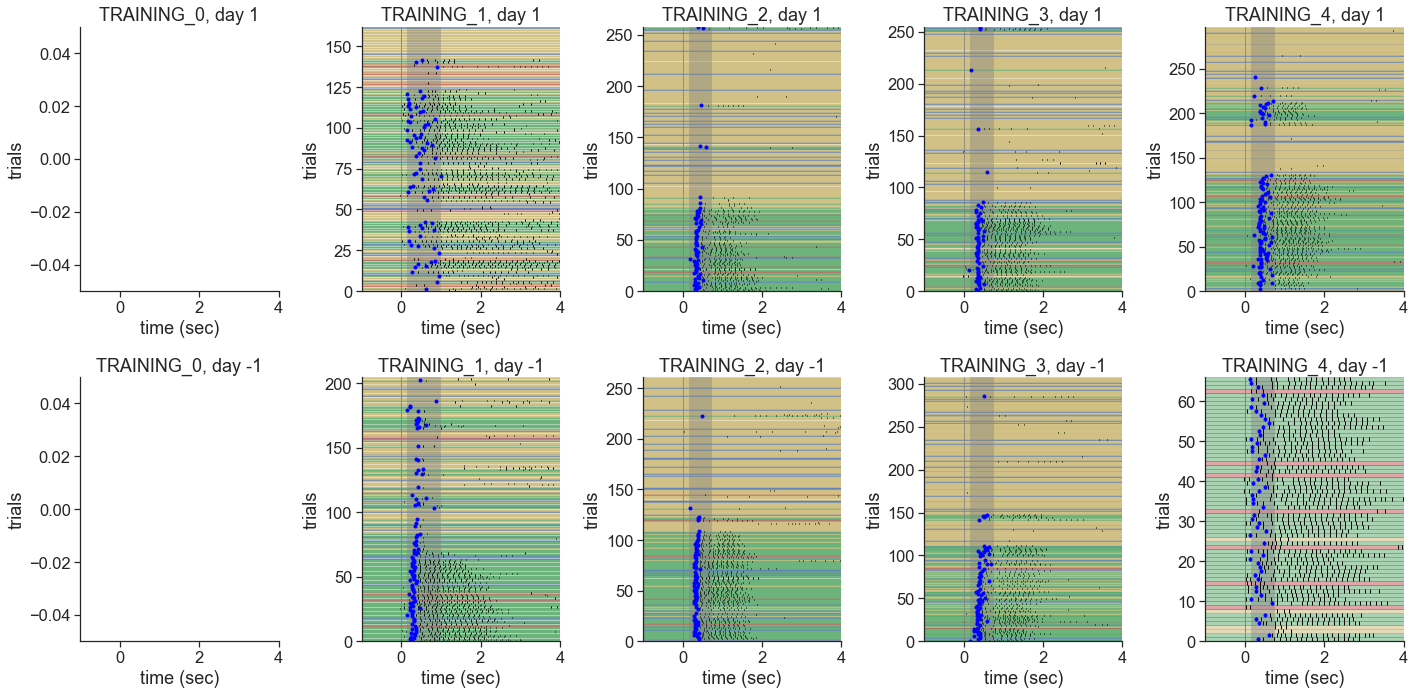

In [72]:
n_stages = len(training_stages)

figsize = (20,10)
fig, ax = plt.subplots(2, n_stages, figsize=figsize)
ax = ax.ravel()

for i, training_stage in enumerate(training_stages):
    behavior_session_id = mouse_data[(mouse_data.training_stage==training_stage)&(mouse_data.first_day_of_stage)].index.values[0]
    dataset = data_dict[behavior_session_id]
    trials = dataset.trials.copy()
    trials = trials.reset_index()
    trials = trials[(trials.auto_rewarded==False)&(trials.aborted==False)]

    ax[i] = ep.plot_lick_raster(trials, response_window=dataset.task_parameters['response_window_sec'], ax=ax[i], save_dir=None)
    ax[i].set_title(training_stage+', day 1')
    
    
    behavior_session_id = mouse_data[(mouse_data.training_stage==training_stage)&(mouse_data.last_day_of_stage)].index.values[0]
    dataset = data_dict[behavior_session_id]
    trials = dataset.trials.copy()
    trials = trials.reset_index()
    trials = trials[(trials.auto_rewarded==False)&(trials.aborted==False)]

    ax[i+n_stages] = ep.plot_lick_raster(trials, response_window=dataset.task_parameters['response_window_sec'], ax=ax[i+n_stages], save_dir=None)
    ax[i+n_stages].set_title(training_stage+', day -1')
fig.tight_layout()

### Plot metrics distributions (averaged across images within each session)

In [73]:
%%time 

method = 'stimulus_based'
engaged_only = True
per_image = False

folder = get_save_folder(method, engaged_only, per_image)

behavior_session_ids = behavior_sessions.index.values


behavior_stats, problem_sessions = get_behavior_stats_for_sessions(behavior_session_ids, behavior_sessions, 
                                    method=method, engaged_only=engaged_only, per_image=per_image)


original_behavior_stats = behavior_stats.copy()

  0%|                                                                                 | 5/3667 [00:00<01:25, 42.83it/s]

loading for 742008131
loading for 742797917
loading for 743041166
loading for 743660302
loading for 744374168
loading for 745054849
loading for 745355000
loading for 745636848
loading for 746222622
loading for 746928360


  0%|▎                                                                               | 15/3667 [00:00<01:21, 45.06it/s]

loading for 750415261
loading for 750781358
loading for 752002559
loading for 753011296
loading for 753936007
loading for 754509820
loading for 754896244
loading for 755551879


  1%|▍                                                                               | 20/3667 [00:00<01:42, 35.41it/s]

loading for 756106020
loading for 756632727
loading for 757431083
loading for 758162988
loading for 758942142
loading for 759251920


  1%|▌                                                                               | 28/3667 [00:00<02:00, 30.24it/s]

loading for 759756829
loading for 760007428
loading for 760409951
loading for 760698062
loading for 761499069
loading for 761831761


  1%|▊                                                                               | 36/3667 [00:01<01:56, 31.11it/s]

loading for 762178061
loading for 762722108
loading for 763291103
loading for 763980798
loading for 764495320
loading for 764897570
loading for 765396393


  1%|▊                                                                               | 40/3667 [00:01<01:55, 31.39it/s]

loading for 766110635
loading for 766753111
loading for 767275980
loading for 768042187
loading for 768815421
loading for 769452637
loading for 769902997
loading for 770244427


  1%|█                                                                               | 49/3667 [00:01<01:43, 34.83it/s]

loading for 771245588
loading for 772125590
loading for 772658979
loading for 773585522
loading for 774106776
loading for 774373300
loading for 774422914


  2%|█▏                                                                              | 57/3667 [00:01<01:47, 33.73it/s]

loading for 774937388
loading for 775378326
loading for 775870895
loading for 777082591
loading for 778166125
loading for 778980920
loading for 779818630
loading for 780758836


  2%|█▍                                                                              | 65/3667 [00:01<01:55, 31.16it/s]

loading for 782380778
loading for 784156661
loading for 785426306
loading for 785944233
loading for 786920476
loading for 788017709


  2%|█▌                                                                              | 69/3667 [00:02<01:58, 30.32it/s]

loading for 791257562
loading for 791749028
loading for 792499741
loading for 793129579
loading for 796032489
loading for 760808911
loading for 761294708


  2%|█▋                                                                              | 77/3667 [00:02<01:54, 31.35it/s]

loading for 761730617
loading for 762067130
loading for 762418364
loading for 763012686
loading for 763661704
loading for 764319580
loading for 764696952
loading for 765208332


  2%|█▊                                                                              | 85/3667 [00:02<01:53, 31.49it/s]

loading for 765793356
loading for 766532213
loading for 766931048
loading for 767730839
loading for 768450504
loading for 769145833
loading for 769731277


  3%|██                                                                              | 94/3667 [00:02<01:41, 35.12it/s]

loading for 770215042
loading for 771040969
loading for 771902184
loading for 772475707
loading for 773391809
loading for 774120511
loading for 774679623
loading for 775291372


  3%|██▏                                                                            | 103/3667 [00:03<01:33, 38.27it/s]

loading for 776988190
loading for 778010119
loading for 778888558
loading for 779712859
loading for 780479408
loading for 781938213
loading for 783217873
loading for 783959068
loading for 785382040


  3%|██▎                                                                            | 107/3667 [00:03<01:53, 31.31it/s]

loading for 786007435
loading for 786938611
loading for 789008423
loading for 789870329
loading for 791248943
loading for 791904071


  3%|██▍                                                                            | 116/3667 [00:03<01:40, 35.50it/s]

loading for 792680306
loading for 793485674
loading for 794968300
loading for 795742990
loading for 796052844
loading for 796251270
loading for 798126878
loading for 772286394
loading for 773510999


  3%|██▋                                                                            | 126/3667 [00:03<01:28, 40.15it/s]

loading for 774208555
loading for 774767072
loading for 775344511
loading for 775925580
loading for 777061425
loading for 778119826
loading for 778959204
loading for 779580423
loading for 780351711
loading for 781727422


  4%|██▉                                                                            | 136/3667 [00:03<01:28, 39.80it/s]

loading for 783059206
loading for 783971649
loading for 785376297
loading for 785868918
loading for 786841415
loading for 788864720
loading for 789946754
loading for 791278700


  4%|███                                                                            | 141/3667 [00:04<01:28, 39.86it/s]

loading for 791769447
loading for 792477679
loading for 793153175
loading for 794071128
loading for 794673280
loading for 795431009
loading for 796031509
loading for 797170547


  4%|███▎                                                                           | 151/3667 [00:04<01:31, 38.48it/s]

loading for 776156839
loading for 777417642
loading for 778884020
loading for 779111633
loading for 780002890
loading for 780766304
loading for 783413166
loading for 784173223
loading for 785539951


  4%|███▍                                                                           | 161/3667 [00:04<01:25, 40.77it/s]

loading for 786305627
loading for 788343533
loading for 789221588
loading for 791371899
loading for 791866254
loading for 792661903
loading for 793323654
loading for 794275479
loading for 794953909


  5%|███▋                                                                           | 171/3667 [00:04<01:23, 41.66it/s]

loading for 795838927
loading for 796046197
loading for 796233602
loading for 796607829
loading for 798145975
loading for 798679618
loading for 799661667
loading for 800202171


  5%|███▊                                                                           | 176/3667 [00:04<01:36, 36.05it/s]

loading for 802406837
loading for 802922968
loading for 803341010
loading for 804748984
loading for 805373492
loading for 806616108


  5%|███▉                                                                           | 184/3667 [00:05<01:42, 33.88it/s]

loading for 807198458
loading for 808107647
loading for 809321253
loading for 791877093
loading for 792689261
loading for 793414389


  5%|████                                                                           | 188/3667 [00:05<01:44, 33.33it/s]

loading for 794295959
loading for 794977379
loading for 795854559
loading for 799051310
loading for 799922316


  5%|████▏                                                                          | 192/3667 [00:05<01:53, 30.71it/s]

loading for 800299366
loading for 800922511
loading for 802988132
loading for 803351520
loading for 804929649
loading for 805535249
loading for 806109931


  5%|████▎                                                                          | 201/3667 [00:05<01:46, 32.47it/s]

loading for 806792366
loading for 807356557
loading for 808324301
loading for 808883789
loading for 809358811
loading for 810405357
loading for 811303680
loading for 811817467


  6%|████▌                                                                          | 210/3667 [00:06<01:41, 34.22it/s]

loading for 812955256
loading for 816417578
loading for 817139151
loading for 818485496
loading for 819094295
loading for 791875850
loading for 792689257
loading for 793409670
loading for 794295950


  6%|████▋                                                                          | 219/3667 [00:06<01:36, 35.60it/s]

loading for 794977383
loading for 795854555
loading for 799049628
loading for 799919887
loading for 800299362
loading for 800919728
loading for 802364085
loading for 802988119


  6%|████▉                                                                          | 228/3667 [00:06<01:36, 35.46it/s]

loading for 803347004
loading for 805639780
loading for 806296598
loading for 806841326
loading for 807584876
loading for 808432167
loading for 809027309


  6%|█████                                                                          | 233/3667 [00:06<01:31, 37.59it/s]

loading for 809427293
loading for 811355443
loading for 810584641
loading for 811356875
loading for 811831429
loading for 812566400
loading for 812993078
loading for 813675618
loading for 814546737


  7%|█████▏                                                                         | 241/3667 [00:06<01:42, 33.31it/s]

loading for 815015329
loading for 815511978
loading for 816381516
loading for 817182203
loading for 818758572
loading for 819245147
loading for 819990491
loading for 821803380


  7%|█████▍                                                                         | 250/3667 [00:07<01:38, 34.67it/s]

loading for 822409353
loading for 823241007
loading for 823968100
loading for 825012995
loading for 825268982
loading for 825888541
loading for 826697158


  7%|█████▌                                                                         | 259/3667 [00:07<01:32, 36.95it/s]

loading for 827374757
loading for 828646658
loading for 829138845
loading for 829578829
loading for 830255592
loading for 830832988
loading for 831824426
loading for 832981154
loading for 835444110


  7%|█████▊                                                                         | 268/3667 [00:07<01:29, 37.92it/s]

loading for 835820832
loading for 836399024
loading for 807533658
loading for 808488955
loading for 809095689
loading for 809427297
loading for 809815041
loading for 810598880
loading for 811354008


  7%|█████▉                                                                         | 273/3667 [00:07<01:27, 38.94it/s]

loading for 811830102
loading for 812559803
loading for 813041953
loading for 813737110
loading for 814545306
cant load stats for 814545306
loading for 815045874
cant load stats for 815045874
loading for 815521974
loading for 816394256


  8%|██████                                                                         | 284/3667 [00:07<01:17, 43.62it/s]

loading for 817165094
loading for 818007489
cant load stats for 818007489
loading for 818825644
cant load stats for 818825644
loading for 819323551
loading for 820124540
loading for 821931655
loading for 822439453
loading for 823254723
loading for 824894721
loading for 807062523


  8%|██████▎                                                                        | 294/3667 [00:08<01:23, 40.60it/s]

loading for 808103937
loading for 809588395
loading for 810266014
loading for 811140660
loading for 811574124
loading for 812261209
loading for 812796028
loading for 814260983


  8%|██████▌                                                                        | 304/3667 [00:08<01:23, 40.29it/s]

loading for 814749891
loading for 815865807
loading for 817053045
loading for 818539436
loading for 819065377
loading for 819497998
loading for 820740400
loading for 821593979


  8%|██████▋                                                                        | 309/3667 [00:08<01:26, 38.79it/s]

loading for 822159346
loading for 822874578
loading for 823496226
loading for 824566587
loading for 825269006
loading for 825902239
loading for 826697162
loading for 827374765


  9%|██████▊                                                                        | 317/3667 [00:08<01:38, 34.09it/s]

loading for 828669593
loading for 829138837
loading for 829714672
loading for 830419451
loading for 830959034
loading for 831905148
loading for 833100683


  9%|███████                                                                        | 326/3667 [00:09<01:31, 36.34it/s]

loading for 833946929
loading for 834928595
loading for 835547527
loading for 835940015
loading for 837108110
loading for 837512169
loading for 823922942


  9%|███████                                                                        | 330/3667 [00:09<01:43, 32.23it/s]

loading for 824972176
loading for 825527066
loading for 826338809
loading for 826841473
loading for 827977069
loading for 828842797


  9%|███████▏                                                                       | 334/3667 [00:09<01:42, 32.51it/s]

loading for 829281654
loading for 829902556
loading for 830592943
loading for 831259963
loading for 832009551
loading for 832522789


  9%|███████▎                                                                       | 342/3667 [00:09<01:41, 32.63it/s]

loading for 833252272
loading for 834059775
loading for 834886139
loading for 835608988
loading for 836099247
loading for 836769386


 10%|███████▌                                                                       | 349/3667 [00:09<01:58, 28.03it/s]

loading for 837202082
loading for 837629869
loading for 838486964
loading for 839220840
loading for 839566028
loading for 839918083


 10%|███████▌                                                                       | 353/3667 [00:10<01:53, 29.18it/s]

loading for 840583412
loading for 841431760
loading for 841830077
loading for 842387217
loading for 842821314
loading for 843397714
loading for 844197868


 10%|███████▊                                                                       | 361/3667 [00:10<01:45, 31.38it/s]

loading for 844880686
loading for 845564445
loading for 846272622
loading for 847022155
loading for 847829598
loading for 848519645
loading for 849073265


 10%|███████▉                                                                       | 369/3667 [00:10<01:45, 31.33it/s]

loading for 849635376
loading for 850977753
loading for 851779746
loading for 852468381
loading for 853168204
loading for 853875502


 10%|████████                                                                       | 373/3667 [00:10<01:40, 32.77it/s]

loading for 854563857
loading for 855421865
loading for 855973498
loading for 856717282


 10%|████████                                                                       | 377/3667 [00:11<02:50, 19.26it/s]

loading for 857612105
loading for 859065627
loading for 859735311
loading for 860665051
loading for 861788094


 11%|████████▎                                                                      | 386/3667 [00:11<02:03, 26.52it/s]

loading for 863571072
loading for 864139911
loading for 864824449
loading for 865482857
loading for 866333758
loading for 867041502
loading for 867977775
loading for 868721114
loading for 869639141


 11%|████████▌                                                                      | 395/3667 [00:11<01:41, 32.22it/s]

loading for 870960890
loading for 872062433
loading for 873002413
loading for 873750535
loading for 874681118
loading for 875414332
loading for 876765708


 11%|████████▌                                                                      | 399/3667 [00:11<01:37, 33.36it/s]

loading for 877346183
loading for 877925816
loading for 878671068
loading for 879974471
loading for 880668519
loading for 881278000
loading for 882256127


 11%|████████▊                                                                      | 407/3667 [00:11<01:46, 30.73it/s]

loading for 882748184
loading for 884596128
loading for 885492180
loading for 886322595
loading for 886926935


 11%|████████▊                                                                      | 411/3667 [00:12<01:40, 32.25it/s]

loading for 888127012
loading for 890157940
loading for 820799656
loading for 821837682
loading for 822471786
loading for 823248638
loading for 823922950
loading for 824992804


 11%|█████████                                                                      | 419/3667 [00:12<01:34, 34.30it/s]

loading for 825533866
loading for 826356747
loading for 826846303
loading for 827944014
loading for 828838236
loading for 829282785
loading for 829877552
loading for 830620126
loading for 832019583


 12%|█████████▎                                                                     | 430/3667 [00:12<01:22, 39.29it/s]

loading for 832540845
loading for 833454420
loading for 834093014
loading for 834908481
loading for 835616503
loading for 836173885
loading for 836777468
loading for 837196627


 12%|█████████▍                                                                     | 438/3667 [00:12<01:30, 35.52it/s]

loading for 837647722
loading for 838496122
loading for 839233516
loading for 839566049
loading for 839931485
loading for 840594518
loading for 841429687
loading for 841842210
loading for 842399625
loading for 842844413


 12%|█████████▌                                                                     | 445/3667 [00:13<02:19, 23.15it/s]

loading for 843400443
loading for 844253929
loading for 845585105
loading for 846316916


 12%|█████████▋                                                                     | 448/3667 [00:13<02:34, 20.81it/s]

loading for 847036338
loading for 847871771
loading for 848599542
loading for 849136474


 12%|█████████▋                                                                     | 452/3667 [00:13<02:25, 22.06it/s]

loading for 849648618
loading for 850985993
loading for 851757903
loading for 852440775
loading for 853496105
loading for 827312851
loading for 828646634


 13%|█████████▉                                                                     | 461/3667 [00:13<01:51, 28.82it/s]

loading for 829128279
loading for 829591790
loading for 830201482
loading for 830867799
loading for 831834820
loading for 832325815
loading for 832990071


 13%|██████████▏                                                                    | 470/3667 [00:14<01:38, 32.62it/s]

loading for 833780803
loading for 834573980
loading for 835448132
loading for 835865722
loading for 836522259
loading for 837083666
loading for 837443225
loading for 838236165


 13%|██████████▎                                                                    | 478/3667 [00:14<01:32, 34.44it/s]

loading for 839014738
loading for 839479248
loading for 839854553
loading for 840330509
loading for 841185520
loading for 841730873
loading for 842139320
loading for 842792100


 13%|██████████▍                                                                    | 487/3667 [00:14<01:25, 37.20it/s]

loading for 843166865
loading for 844234790
loading for 844875410
loading for 846248008
loading for 847048485
loading for 847867029
loading for 848575992
loading for 849098851


 14%|██████████▋                                                                    | 498/3667 [00:14<01:14, 42.79it/s]

loading for 850976604
loading for 853266283
loading for 831129394
loading for 832021447
loading for 832544149
loading for 833328750
loading for 834087859
loading for 834903060
loading for 835557296
loading for 836166694


 14%|██████████▊                                                                    | 503/3667 [00:14<01:18, 40.32it/s]

loading for 836761653
loading for 837192567
loading for 837638916
loading for 838496126
loading for 839234289
loading for 839566045
loading for 839939986
loading for 840594514


 14%|███████████                                                                    | 512/3667 [00:15<01:22, 38.20it/s]

loading for 841148118
loading for 841707177
loading for 842174399
loading for 842729895
loading for 843203333
loading for 844164376
loading for 844849972


 14%|███████████▏                                                                   | 517/3667 [00:15<01:21, 38.72it/s]

loading for 845441512
loading for 846194950
loading for 846929750
loading for 848503804
loading for 853526948
loading for 834587823
loading for 835451471
loading for 835867850
loading for 836522245


 14%|███████████▎                                                                   | 527/3667 [00:15<01:14, 42.07it/s]

loading for 837083657
loading for 837449223
loading for 838203784
loading for 838998362
loading for 839468826
loading for 839837380
loading for 840330501
loading for 841191836
loading for 841730868


 15%|███████████▌                                                                   | 537/3667 [00:15<01:24, 37.08it/s]

loading for 842139310
loading for 842792094
loading for 843178897
loading for 844027594
loading for 844608277
loading for 845409652


 15%|███████████▋                                                                   | 541/3667 [00:15<01:33, 33.26it/s]

loading for 846051276
loading for 846791195
loading for 847613846
loading for 848272657
loading for 848938321
loading for 849525884


 15%|███████████▊                                                                   | 549/3667 [00:16<01:36, 32.21it/s]

loading for 850817466
loading for 851563931
loading for 852235678
loading for 852974537
loading for 853505213
loading for 854283407


 15%|███████████▉                                                                   | 553/3667 [00:16<01:41, 30.60it/s]

loading for 855826937
loading for 857230827
loading for 837658854
loading for 838515247
loading for 839219841
loading for 839565422


 15%|████████████                                                                   | 561/3667 [00:16<01:43, 30.06it/s]

loading for 839912316
loading for 840581827
loading for 841426832
loading for 841827774
loading for 842385277
loading for 842819933


 15%|████████████▏                                                                  | 565/3667 [00:16<01:36, 32.09it/s]

loading for 843400453
loading for 844199758
loading for 844908261
loading for 845572044
loading for 846331423
loading for 847036328
loading for 847874940


 16%|████████████▎                                                                  | 573/3667 [00:16<01:32, 33.32it/s]

loading for 848613406
loading for 849147676
loading for 849651275
loading for 850989832
loading for 851773928
loading for 852451567
loading for 855200229
loading for 837654533


 16%|████████████▌                                                                  | 582/3667 [00:17<01:26, 35.82it/s]

loading for 838483140
loading for 839219845
loading for 839565426
loading for 839914270
loading for 840581823
loading for 841426857
loading for 841830096
loading for 842385266
loading for 842819929


 16%|████████████▋                                                                  | 590/3667 [00:17<01:30, 33.87it/s]

loading for 843401580
loading for 844199766
loading for 844891885
loading for 845572039
loading for 846016059
loading for 846750050
loading for 847660741


 16%|████████████▉                                                                  | 598/3667 [00:17<01:27, 35.02it/s]

loading for 848348215
loading for 848943191
loading for 849494762
loading for 850807174
loading for 851542477
loading for 852229360
loading for 853025613
loading for 855446545


 17%|█████████████                                                                  | 606/3667 [00:17<01:26, 35.50it/s]

loading for 855866701
loading for 856467236
loading for 857367017
loading for 858029487
loading for 858967789
loading for 859793880
loading for 860533862
loading for 864068649


 17%|█████████████▏                                                                 | 615/3667 [00:18<01:25, 35.57it/s]

loading for 840598877
loading for 841466830
loading for 841851097
loading for 842419799
loading for 842840144
loading for 843423171
loading for 844229895


 17%|█████████████▎                                                                 | 619/3667 [00:18<01:26, 35.43it/s]

loading for 844945060
loading for 845594684
loading for 846284880
loading for 847048490
loading for 847838131
loading for 848526511
loading for 848910243


 17%|█████████████▍                                                                 | 623/3667 [00:18<01:33, 32.47it/s]

loading for 849485548
loading for 850810858
loading for 851471401
loading for 852202150
loading for 852966248


 17%|█████████████▌                                                                 | 630/3667 [00:18<02:04, 24.40it/s]

loading for 853875514
loading for 854621677
loading for 855424348
loading for 857340041
loading for 857987666


 17%|█████████████▋                                                                 | 636/3667 [00:18<01:57, 25.69it/s]

loading for 858974731
loading for 859775117
loading for 863610582
loading for 868070216
loading for 868658294
loading for 869559097


 18%|█████████████▊                                                                 | 642/3667 [00:19<02:09, 23.40it/s]

loading for 850978904
loading for 851802107
loading for 852457995
loading for 853257103
loading for 853793068


 18%|█████████████▉                                                                 | 648/3667 [00:19<01:57, 25.73it/s]

loading for 854602288
loading for 855476794
loading for 856010720
loading for 856732195
loading for 857547928
loading for 858273959


 18%|██████████████                                                                 | 654/3667 [00:19<01:54, 26.31it/s]

loading for 859054070
loading for 859802280
loading for 860894659
loading for 861794694
loading for 862716894
loading for 863559318


 18%|██████████████▏                                                                | 657/3667 [00:19<02:02, 24.55it/s]

loading for 864280264
loading for 865544821
loading for 866336764
loading for 867098393
loading for 867945660
loading for 868819048


 18%|██████████████▎                                                                | 664/3667 [00:20<01:50, 27.15it/s]

loading for 869621595
loading for 870960908
loading for 872107505
loading for 873813922
loading for 874808131
loading for 876821717


 18%|██████████████▍                                                                | 670/3667 [00:20<01:49, 27.47it/s]

loading for 854533487
loading for 855504136
loading for 856002607
loading for 856732191
loading for 857555456
loading for 858240891
loading for 859032026


 19%|██████████████▋                                                                | 679/3667 [00:20<01:30, 32.94it/s]

loading for 859791558
loading for 860752803
loading for 861794699
loading for 862701465
loading for 863571054
loading for 864137547
loading for 864839176
loading for 865581941


 19%|██████████████▊                                                                | 688/3667 [00:20<01:22, 36.25it/s]

loading for 866287088
loading for 866950070
loading for 867615529
loading for 868540333
loading for 869319414
loading for 870660821
loading for 871808378
loading for 872646068
loading for 873517635


 19%|██████████████▉                                                                | 694/3667 [00:20<01:17, 38.46it/s]

loading for 874324533
loading for 875471358
cant load stats for 875471358
loading for 876574139
loading for 850970486
loading for 851843550
loading for 852507945
loading for 853260939


 19%|███████████████▏                                                               | 703/3667 [00:21<01:23, 35.29it/s]

loading for 853886146
loading for 855459012
loading for 855980937
loading for 856719615
loading for 857504898
loading for 858250763
loading for 859049298
loading for 859784868


 19%|███████████████▎                                                               | 712/3667 [00:21<01:20, 36.63it/s]

loading for 860836980
loading for 861789935
loading for 862716913
loading for 863614836
loading for 864260028
loading for 864813130
loading for 865460179
loading for 866296478


 20%|███████████████▌                                                               | 720/3667 [00:21<01:22, 35.56it/s]

loading for 866999677
loading for 867615541
loading for 868555361
loading for 869334643
loading for 870592115
loading for 871808394


 20%|███████████████▌                                                               | 724/3667 [00:21<01:21, 36.30it/s]

loading for 872626160
loading for 873695653
loading for 874699922
loading for 875440936
loading for 876678452
loading for 877617747
loading for 878120101
loading for 879037269
loading for 880046522


 20%|███████████████▊                                                               | 733/3667 [00:21<01:23, 35.03it/s]

loading for 880784794
loading for 882256117
loading for 854528256
loading for 855503335
loading for 856002613
loading for 856732213
loading for 857555461


 20%|███████████████▉                                                               | 741/3667 [00:22<01:24, 34.56it/s]

loading for 858240896
loading for 859032044
loading for 859791563
loading for 860752819
loading for 861794704
loading for 862701503
loading for 863559327


 20%|████████████████▏                                                              | 750/3667 [00:22<01:26, 33.87it/s]

loading for 864125430
loading for 864839160
loading for 865580429
loading for 866287143
loading for 867082086
loading for 868004770
loading for 868747797


 21%|████████████████▏                                                              | 754/3667 [00:22<01:22, 35.13it/s]

loading for 872158938
loading for 873015934
loading for 873824951
loading for 874747892
loading for 875444395
loading for 876857698
loading for 878159171
loading for 879037253


 21%|████████████████▍                                                              | 762/3667 [00:22<01:23, 34.69it/s]

loading for 880201859
loading for 880776648
loading for 881413102
loading for 882446265
loading for 882831297
loading for 883863892
loading for 884808160
loading for 885644181


 21%|████████████████▌                                                              | 771/3667 [00:23<01:17, 37.39it/s]

loading for 886440437
loading for 887165432
loading for 888282547
loading for 858104885
loading for 858900546
loading for 859601488
loading for 860247669
loading for 861717498


 21%|████████████████▊                                                              | 780/3667 [00:23<01:12, 39.92it/s]

loading for 862339401
loading for 863365105
loading for 863966979
loading for 864665192
loading for 865114696
loading for 865887829
loading for 866906696


 21%|████████████████▉                                                              | 785/3667 [00:23<01:20, 35.96it/s]

loading for 867505993
loading for 868511825
loading for 869198966
loading for 870481699
loading for 871723063
loading for 872607293
loading for 873440431
loading for 874324527


 22%|█████████████████                                                              | 794/3667 [00:23<01:15, 38.17it/s]

loading for 875020211
loading for 876448536
loading for 877855866
loading for 878615859
loading for 879846629
loading for 880581639
loading for 881204796
loading for 882289836
loading for 883851453


 22%|█████████████████▎                                                             | 802/3667 [00:23<01:17, 37.14it/s]

loading for 884598044
loading for 885404075
loading for 886376835
loading for 888213949
loading for 890021100
loading for 893362730
loading for 894103623
loading for 895022326
loading for 895562386


 22%|█████████████████▍                                                             | 812/3667 [00:24<01:12, 39.18it/s]

loading for 896561264
loading for 898432373
loading for 898874650
loading for 899390684
loading for 901999401
loading for 903708760
loading for 904574580
loading for 906472625


 22%|█████████████████▋                                                             | 820/3667 [00:24<01:17, 36.90it/s]

loading for 907053876
loading for 907900077
loading for 908533370
loading for 910207192
loading for 910829549
loading for 911904717
loading for 913673477
loading for 914211263


 22%|█████████████████▊                                                             | 825/3667 [00:24<01:13, 38.46it/s]

loading for 914705301
loading for 915418411
loading for 916403851


 23%|█████████████████▉                                                             | 833/3667 [00:24<01:47, 26.31it/s]

loading for 918103715
loading for 923410363
loading for 924472023
loading for 925084998
loading for 858098100
loading for 858891746
loading for 859601496


 23%|██████████████████                                                             | 841/3667 [00:25<01:31, 30.92it/s]

loading for 860247677
loading for 861715805
loading for 862326321
loading for 863361852
loading for 863966966
loading for 864656758
loading for 865114705
loading for 865883182


 23%|██████████████████▏                                                            | 845/3667 [00:25<01:35, 29.54it/s]

loading for 866912923
loading for 867553178
loading for 868521085
loading for 869223965
loading for 870473396
loading for 871723073


 23%|██████████████████▍                                                            | 854/3667 [00:25<01:23, 33.60it/s]

loading for 872607297
loading for 873440438
loading for 874324523
loading for 875020169
loading for 877447964
loading for 878282369
loading for 880231156
loading for 880780889
loading for 881427978


 24%|██████████████████▌                                                            | 862/3667 [00:25<01:21, 34.55it/s]

loading for 882434675
loading for 882827577
loading for 884888379
loading for 885739915
loading for 886446971
loading for 887236947
loading for 888301437
loading for 889559462
loading for 890374401


 24%|██████████████████▊                                                            | 871/3667 [00:25<01:17, 36.13it/s]

loading for 891792255
loading for 892663103
loading for 893600606
loading for 858098096
loading for 859064345
loading for 859735301
loading for 860650174
loading for 861785387
loading for 862752139


 24%|██████████████████▉                                                            | 879/3667 [00:26<01:21, 34.25it/s]

loading for 863571063
loading for 864137543
loading for 864820740
loading for 865463877
loading for 866319121
loading for 867036286
loading for 867961842


 24%|███████████████████                                                            | 883/3667 [00:26<01:31, 30.27it/s]

loading for 868649156
loading for 869623240
loading for 870935137
loading for 872035204
loading for 872979404
loading for 873733206


 24%|███████████████████▏                                                           | 891/3667 [00:26<01:29, 30.91it/s]

loading for 874654275
loading for 875385898
loading for 876737438
loading for 877558819
loading for 878233751
loading for 879003588


 25%|███████████████████▎                                                           | 899/3667 [00:26<01:28, 31.19it/s]

loading for 880183901
loading for 880769249
loading for 881413092
loading for 882393175
loading for 883857874
loading for 884800923


 25%|███████████████████▍                                                           | 904/3667 [00:27<01:20, 34.45it/s]

loading for 885589846
loading for 886437461
loading for 887183674
loading for 888263147
loading for 889436433
loading for 890459182
loading for 891759060
loading for 892589687


 25%|███████████████████▋                                                           | 912/3667 [00:27<01:21, 33.77it/s]

loading for 893433252
loading for 894215832
loading for 896543695
loading for 898493295
loading for 898889632
loading for 899400259
loading for 900228074
loading for 901102440


 25%|███████████████████▉                                                           | 923/3667 [00:27<01:08, 40.30it/s]

loading for 902021938
loading for 902822517
loading for 904630713
loading for 907035941
loading for 907995409
loading for 908564883
loading for 909363995
loading for 910249989
loading for 911361470


 25%|███████████████████▉                                                           | 928/3667 [00:27<01:08, 40.20it/s]

loading for 911947271
loading for 912570316
loading for 913710476
loading for 914230230
loading for 914715937
loading for 915448786
loading for 916450856
loading for 917331220
loading for 918202290
loading for 918900907


 26%|████████████████████▏                                                          | 939/3667 [00:27<01:05, 41.81it/s]

loading for 919634924
loading for 920541932
loading for 921601457
loading for 922572837
loading for 923474474
loading for 924575646
loading for 925033179
loading for 926393722


 26%|████████████████████▎                                                          | 944/3667 [00:28<01:05, 41.27it/s]

loading for 927449068
loading for 928400507
loading for 929341697
loading for 929818797
loading for 931566300
loading for 932611698
loading for 933504759


 26%|████████████████████▌                                                          | 954/3667 [00:28<01:12, 37.64it/s]

loading for 934610593
loading for 935811563
loading for 937416292
loading for 938377224
loading for 939538572
loading for 862786889
loading for 863627986
loading for 864248647


 26%|████████████████████▋                                                          | 962/3667 [00:28<01:12, 37.16it/s]

loading for 865463863
loading for 866103829
loading for 867056914
loading for 868008761
loading for 868709715
loading for 871033938


 26%|████████████████████▊                                                          | 966/3667 [00:28<01:20, 33.46it/s]

loading for 872127292
loading for 873051801
loading for 873781580
loading for 874747887
loading for 875479783
loading for 876836773
loading for 877614747


 27%|█████████████████████                                                          | 975/3667 [00:28<01:21, 33.19it/s]

loading for 878282360
loading for 879094361
loading for 880191852
loading for 880775450
loading for 881419102
loading for 882388591
loading for 883704230
loading for 884677929


 27%|█████████████████████▏                                                         | 985/3667 [00:29<01:15, 35.39it/s]

loading for 886239982
loading for 886873295
loading for 889155682
loading for 890051221
loading for 891487953
loading for 892410834
loading for 893356870


 27%|█████████████████████▎                                                         | 989/3667 [00:29<01:18, 34.03it/s]

loading for 894209378
loading for 894987969
loading for 896526348
loading for 898453640
loading for 898889612
loading for 899452222
loading for 901380774


 27%|█████████████████████▍                                                         | 997/3667 [00:29<01:16, 34.96it/s]

loading for 902270195
loading for 903070554
loading for 904011865
loading for 906695544
loading for 907356161
loading for 908908617
loading for 911021831


 27%|█████████████████████▍                                                        | 1005/3667 [00:29<01:16, 34.84it/s]

loading for 911522814
loading for 912242958
loading for 912918028
loading for 913898214
loading for 914405292
loading for 914868296
loading for 915690421
loading for 916623819


 28%|█████████████████████▌                                                        | 1013/3667 [00:30<01:12, 36.79it/s]

loading for 917581144
loading for 918454518
loading for 919073273
loading for 919973223
loading for 920836124
loading for 921879374
loading for 922942074
loading for 923786645
loading for 924729242


 28%|█████████████████████▋                                                        | 1022/3667 [00:30<01:07, 38.90it/s]

loading for 926769977
loading for 927745870
loading for 928717396
loading for 929524399
loading for 932078145
loading for 932975404
loading for 934075944
loading for 934900274
loading for 936033313


 28%|█████████████████████▉                                                        | 1032/3667 [00:30<01:06, 39.87it/s]

loading for 937825662
loading for 938991494
loading for 940243685
loading for 940796859
loading for 941946991
loading for 942448113
loading for 945277725
loading for 946172858


 28%|██████████████████████                                                        | 1037/3667 [00:30<01:13, 35.68it/s]

loading for 947503956
loading for 948341757
loading for 862479694
loading for 863414647
loading for 864000195
loading for 864729508
loading for 865288307
loading for 865953304
loading for 866971252


 29%|██████████████████████▏                                                       | 1046/3667 [00:30<01:11, 36.46it/s]

loading for 867649878
loading for 868546763
loading for 869311954
loading for 870592103
loading for 871782387
loading for 872720256
loading for 873530279


 29%|██████████████████████▍                                                       | 1054/3667 [00:31<01:14, 35.27it/s]

loading for 874295478
loading for 875020129
loading for 876521253
loading for 877346192
loading for 877938181
loading for 878671074
loading for 879958654


 29%|██████████████████████▌                                                       | 1063/3667 [00:31<01:14, 35.08it/s]

loading for 880647168
loading for 881253316
loading for 882233951
loading for 882679635
loading for 883632948
loading for 884560033
loading for 885418521


 29%|██████████████████████▋                                                       | 1067/3667 [00:31<01:16, 34.13it/s]

loading for 886262841
loading for 886900197
loading for 889183454
loading for 890054551
loading for 891504476
loading for 892413871


 29%|██████████████████████▊                                                       | 1075/3667 [00:31<01:17, 33.45it/s]

loading for 893359124
loading for 894215849
loading for 894994111
loading for 896543686
loading for 898461372
loading for 898890800
loading for 899461485


 29%|██████████████████████▉                                                       | 1079/3667 [00:31<01:24, 30.69it/s]

loading for 902028378
loading for 902822538
loading for 904625819
loading for 907035965
loading for 907995400
loading for 908564873
loading for 910249985


 30%|███████████████████████                                                       | 1087/3667 [00:32<01:25, 30.22it/s]

loading for 911361486
loading for 912159483
loading for 913921659
loading for 914411174
loading for 914871449
loading for 915739774
loading for 916704634


 30%|███████████████████████▎                                                      | 1096/3667 [00:32<01:15, 33.97it/s]

loading for 917595407
loading for 918474069
loading for 919104267
loading for 920015895
loading for 920839478
loading for 922012422
loading for 923834852
loading for 924759623


 30%|███████████████████████▍                                                      | 1104/3667 [00:32<01:15, 34.00it/s]

loading for 925603486
loading for 927905748
loading for 929551055
loading for 935301109
loading for 936273485
loading for 862730050
loading for 863657189
loading for 864236370


 30%|███████████████████████▋                                                      | 1113/3667 [00:32<01:09, 36.54it/s]

loading for 864809053
loading for 865443418
loading for 866300303
loading for 867045079
loading for 867977763
loading for 868704504
loading for 869615887


 30%|███████████████████████▊                                                      | 1117/3667 [00:33<01:09, 36.57it/s]

loading for 870960882
loading for 872864902
loading for 873729011
loading for 874691139
loading for 875402170
loading for 876701397
loading for 877524045
loading for 878137744


 31%|███████████████████████▉                                                      | 1126/3667 [00:33<01:04, 39.20it/s]

loading for 879003593
loading for 880088387
loading for 881416618
loading for 882373648
loading for 882785348
loading for 883984332
loading for 884750162
loading for 885540222
loading for 886440427


 31%|████████████████████████                                                      | 1134/3667 [00:33<01:06, 37.91it/s]

loading for 886931452
loading for 888282572
loading for 889443507
loading for 890355790
loading for 891618314
loading for 892491402
loading for 893540605


 31%|████████████████████████▎                                                     | 1142/3667 [00:33<01:07, 37.23it/s]

loading for 894466746
loading for 895241719
loading for 895877676
loading for 896969091
loading for 898658063
loading for 899685557
loading for 900226857


 31%|████████████████████████▍                                                     | 1146/3667 [00:33<01:19, 31.62it/s]

loading for 901340457
loading for 902244344
loading for 902962312
loading for 904899490
loading for 906641078


 31%|████████████████████████▌                                                     | 1154/3667 [00:34<01:20, 31.23it/s]

loading for 908092560
loading for 910381299
loading for 911016296
loading for 911541959
loading for 912902650
loading for 913850438
loading for 914336989


 32%|████████████████████████▋                                                     | 1162/3667 [00:34<01:17, 32.32it/s]

loading for 914828503
loading for 915609195
loading for 916614400
loading for 917500273
loading for 918451984
loading for 919022193
loading for 919895633
loading for 920807985


 32%|████████████████████████▉                                                     | 1170/3667 [00:34<01:12, 34.33it/s]

loading for 921873454
loading for 923757660
loading for 924739087
loading for 926621793
loading for 927652117
loading for 928654503
loading for 929522558
loading for 930344462


 32%|█████████████████████████                                                     | 1178/3667 [00:34<01:13, 34.04it/s]

loading for 932960096
loading for 933939891
loading for 935038748
loading for 936159430
loading for 937645038
loading for 938729036


 32%|█████████████████████████▏                                                    | 1183/3667 [00:34<01:11, 34.55it/s]

loading for 940017429
loading for 941802699
loading for 942814025
loading for 943833533
loading for 945033994
loading for 947336783
loading for 948225040
loading for 949348713


 33%|█████████████████████████▍                                                    | 1193/3667 [00:35<01:02, 39.87it/s]

loading for 950188644
loading for 862245493
loading for 863368489
loading for 863966974
loading for 864665204
loading for 865131331
loading for 865887821
loading for 866909432
loading for 867521015


 33%|█████████████████████████▍                                                    | 1198/3667 [00:35<00:59, 41.54it/s]

loading for 868513545
loading for 869214215
loading for 870481685
loading for 871728970
loading for 872609185
loading for 873449838
loading for 874333572


 33%|█████████████████████████▋                                                    | 1207/3667 [00:35<01:08, 35.73it/s]

loading for 875020175
loading for 876448528
loading for 877855879
loading for 878615867
loading for 879854787
loading for 880590869


 33%|█████████████████████████▊                                                    | 1215/3667 [00:35<01:07, 36.10it/s]

loading for 881210690
loading for 882291265
loading for 882736270
loading for 883857883
loading for 884605735
loading for 885404024
loading for 886382175
loading for 888218684
loading for 890021090


 33%|██████████████████████████                                                    | 1225/3667 [00:36<01:02, 39.33it/s]

loading for 893608687
loading for 894495169
loading for 895278567
loading for 895809864
loading for 896882463
loading for 898665096
loading for 898938920
loading for 900227468
loading for 901316636
loading for 902211897


 34%|██████████████████████████▏                                                   | 1229/3667 [00:36<01:09, 35.05it/s]

loading for 902995627
loading for 903977177
loading for 904922800
loading for 906658064
loading for 907327499
loading for 908122381


 34%|██████████████████████████▎                                                   | 1237/3667 [00:36<01:16, 31.70it/s]

loading for 912640306
loading for 866287136
loading for 867036293
loading for 867961854
loading for 868653129
loading for 869623244


 34%|██████████████████████████▍                                                   | 1242/3667 [00:36<01:12, 33.47it/s]

loading for 870935142
loading for 872043024
loading for 872979424
loading for 873739031
loading for 874654280
loading for 875385921
loading for 876737442


 34%|██████████████████████████▌                                                   | 1250/3667 [00:36<01:15, 32.09it/s]

loading for 877558833
loading for 878245978
loading for 878993255
loading for 880191880
loading for 880775454
loading for 881425509
loading for 882401590


 34%|██████████████████████████▊                                                   | 1259/3667 [00:37<01:08, 35.31it/s]

loading for 883756380
loading for 884552901
loading for 885410929
loading for 886257016
loading for 886838602
loading for 888033338
loading for 889175194
loading for 890033129
loading for 891446789


 35%|██████████████████████████▉                                                   | 1268/3667 [00:37<01:07, 35.58it/s]

loading for 892387261
loading for 893344360
loading for 894083470
loading for 898440124
loading for 866128606
loading for 866971269
loading for 867645566
loading for 868531777


 35%|███████████████████████████▏                                                  | 1277/3667 [00:37<01:09, 34.54it/s]

loading for 869311972
loading for 870579061
loading for 871782397
loading for 872690218
loading for 873537911
loading for 874416985
loading for 875020203


 35%|███████████████████████████▏                                                  | 1281/3667 [00:37<01:13, 32.34it/s]

loading for 876651891
loading for 877487375
loading for 878179382
loading for 878771403
loading for 879969002
loading for 880644824


 35%|███████████████████████████▎                                                  | 1285/3667 [00:37<01:34, 25.15it/s]

loading for 881251187
loading for 882219267
loading for 882677813
loading for 883632956
loading for 884560064


 35%|███████████████████████████▍                                                  | 1292/3667 [00:38<01:31, 26.05it/s]

loading for 885410934
loading for 886250995
loading for 887006111
loading for 888163519
loading for 889388078


 35%|███████████████████████████▋                                                  | 1299/3667 [00:38<01:25, 27.58it/s]

loading for 890625596
loading for 891605682
loading for 892526544
loading for 893488330
loading for 894368064
loading for 870987812
loading for 872953842


 36%|███████████████████████████▋                                                  | 1303/3667 [00:38<01:21, 28.85it/s]

loading for 873774125
loading for 874790261
loading for 875207834
loading for 876821726
loading for 877603209
loading for 878245989


 36%|███████████████████████████▊                                                  | 1310/3667 [00:38<01:19, 29.54it/s]

loading for 879003606
loading for 880088400
loading for 881416637
loading for 882373653
loading for 882781075
loading for 883986743
loading for 884776248


 36%|████████████████████████████                                                  | 1318/3667 [00:39<01:11, 32.87it/s]

loading for 885540237
loading for 886442346
loading for 886946944
loading for 888295170
loading for 889468960
loading for 890408602
loading for 891635659
loading for 891635667
loading for 892510304


 36%|████████████████████████████▏                                                 | 1327/3667 [00:39<01:12, 32.39it/s]

loading for 893560763
loading for 894481319
loading for 895248933
loading for 895896343
loading for 896995828
loading for 898667252
loading for 899700579


 36%|████████████████████████████▍                                                 | 1336/3667 [00:39<01:06, 35.15it/s]

loading for 900231059
loading for 901363879
loading for 902260156
loading for 902975505
loading for 904922810
loading for 906668549
loading for 908104455


 37%|████████████████████████████▌                                                 | 1340/3667 [00:39<01:05, 35.51it/s]

loading for 910393217
loading for 911016285
loading for 911541950
loading for 912223787
loading for 912902619


 37%|████████████████████████████▌                                                 | 1344/3667 [00:39<01:41, 22.84it/s]

loading for 913850450
loading for 914339617
loading for 914831000
loading for 915609216
loading for 916617096
loading for 917500256
loading for 918451994


 37%|████████████████████████████▊                                                 | 1353/3667 [00:40<01:20, 28.65it/s]

loading for 919025442
loading for 920901263
loading for 921979060
loading for 923757653
loading for 924739774
loading for 926621788
loading for 927652110
loading for 928654491


 37%|████████████████████████████▉                                                 | 1361/3667 [00:40<01:16, 30.19it/s]

loading for 929524423
loading for 930344469
loading for 932960104
loading for 933954934
loading for 935045761
loading for 936083473
loading for 937706038


 37%|█████████████████████████████                                                 | 1369/3667 [00:40<01:13, 31.41it/s]

loading for 938794488
loading for 939985541
loading for 940755050
loading for 941734036
loading for 942767530
loading for 944125005
loading for 945075740


 38%|█████████████████████████████▎                                                | 1378/3667 [00:40<01:03, 36.31it/s]

loading for 947988590
loading for 949201674
loading for 949973686
loading for 951520319
loading for 952554548
loading for 953982960
loading for 956010809
loading for 957032492


 38%|█████████████████████████████▍                                                | 1382/3667 [00:41<01:02, 36.40it/s]

loading for 958234742
loading for 958888263
loading for 959681045
loading for 875126982
loading for 876823447
loading for 877605077
loading for 878245966
loading for 879074585


 38%|█████████████████████████████▌                                                | 1391/3667 [00:41<01:02, 36.56it/s]

loading for 880174939
loading for 881450253
loading for 882426675
loading for 882833335
loading for 884004562
loading for 884776271
loading for 885598412


 38%|█████████████████████████████▋                                                | 1395/3667 [00:41<01:04, 35.17it/s]

loading for 886446962
loading for 886953901
loading for 888298590
loading for 889478291
loading for 890408635
loading for 891635663


 38%|█████████████████████████████▊                                                | 1403/3667 [00:41<01:12, 31.37it/s]

loading for 892525019
loading for 893560739
loading for 894481291
loading for 895262003
loading for 895896368
loading for 896995823
loading for 898682070


 38%|██████████████████████████████                                                | 1411/3667 [00:41<01:05, 34.59it/s]

loading for 899742869
loading for 901424076
loading for 902328548
loading for 903098779
loading for 904954571
loading for 906726720
loading for 908165653
loading for 910448027
loading for 911061160


 39%|██████████████████████████████▏                                               | 1419/3667 [00:42<01:09, 32.40it/s]

loading for 911581364
loading for 912318840
loading for 913014398
loading for 913917929
loading for 914408296
loading for 914859356
loading for 915690413


 39%|██████████████████████████████▎                                               | 1427/3667 [00:42<01:02, 35.61it/s]

loading for 916673577
loading for 917600513
loading for 918448801
loading for 919022174
loading for 919890884
loading for 920807973
loading for 921873450
loading for 923750087


 39%|██████████████████████████████▌                                               | 1436/3667 [00:42<00:58, 38.23it/s]

loading for 924740575
loading for 926614379
loading for 927643982
loading for 928647601
loading for 929522554
loading for 930376122
loading for 931913977
loading for 932628715
loading for 933604243


 39%|██████████████████████████████▋                                               | 1444/3667 [00:42<00:58, 38.22it/s]

loading for 934812249
loading for 935653479
loading for 937395157
loading for 938339083
loading for 939533442
loading for 940628402
loading for 941425961
loading for 942350598


 40%|██████████████████████████████▉                                               | 1453/3667 [00:43<00:56, 39.30it/s]

loading for 875155219
loading for 876829777
loading for 877607698
loading for 878251933
loading for 879074574
loading for 880181164
loading for 881450232
loading for 882426670


 40%|███████████████████████████████                                               | 1461/3667 [00:43<01:03, 34.57it/s]

loading for 882844402
loading for 884070037
loading for 884846935
loading for 885609778
loading for 886472241
loading for 887175302


 40%|███████████████████████████████▏                                              | 1465/3667 [00:43<01:02, 35.25it/s]

loading for 888346887
loading for 889536668
loading for 890555457
loading for 891724311
loading for 893564091
loading for 894481299
loading for 895256170
loading for 895902286


 40%|███████████████████████████████▎                                              | 1475/3667 [00:43<00:58, 37.28it/s]

loading for 897002967
loading for 898668828
loading for 899700587
loading for 900231063
loading for 901363886
loading for 902260148
loading for 902975514
loading for 904922795


 40%|███████████████████████████████▌                                              | 1483/3667 [00:43<01:03, 34.40it/s]

loading for 906668545
loading for 908109320
loading for 910393226
loading for 911019327
loading for 911543418
loading for 912223793


 41%|███████████████████████████████▋                                              | 1487/3667 [00:44<01:03, 34.21it/s]

loading for 912223799
loading for 912902659
loading for 913854181
loading for 914339627
loading for 914831033
loading for 915609229
loading for 916617112
loading for 917506393


 41%|███████████████████████████████▊                                              | 1495/3667 [00:44<01:03, 33.96it/s]

loading for 918454529
loading for 919025470
loading for 919902020
loading for 920813990
loading for 921879360


 41%|███████████████████████████████▉                                              | 1499/3667 [00:44<01:18, 27.64it/s]

loading for 923877874
loading for 924757055
loading for 926621779
loading for 927643992
loading for 928647605
loading for 929522550


 41%|████████████████████████████████                                              | 1507/3667 [00:44<01:13, 29.57it/s]

loading for 930335512
loading for 931488919
loading for 932596575
loading for 933472975
loading for 935601725
loading for 937442661


 41%|████████████████████████████████▏                                             | 1511/3667 [00:45<01:30, 23.89it/s]

loading for 938425882
loading for 939537734
loading for 940553228


 41%|████████████████████████████████▏                                             | 1514/3667 [00:45<01:33, 22.94it/s]

loading for 941457567
loading for 942329079
loading for 943479988
loading for 944823947
loading for 882765152


 41%|████████████████████████████████▎                                             | 1521/3667 [00:45<01:19, 26.94it/s]

loading for 883908190
loading for 884881862
loading for 885609760
loading for 886424035
loading for 887142121
loading for 888298597
loading for 889478282


 42%|████████████████████████████████▌                                             | 1528/3667 [00:45<01:11, 30.11it/s]

loading for 890578468
loading for 891752782
loading for 892597881
loading for 893551176
loading for 894489950
loading for 895248904
loading for 895947603
loading for 896945902


 42%|████████████████████████████████▋                                             | 1536/3667 [00:45<01:05, 32.58it/s]

loading for 898691674
loading for 898982250
loading for 901251663
loading for 902135840
loading for 902871565
loading for 903842232
loading for 904844395
loading for 908065760


 42%|████████████████████████████████▊                                             | 1544/3667 [00:46<01:08, 30.89it/s]

loading for 888282565
loading for 889461157
loading for 890450001
loading for 891789286
loading for 892645353
loading for 893600610
loading for 894481279


 42%|████████████████████████████████▉                                             | 1548/3667 [00:46<01:14, 28.63it/s]

loading for 895270564
loading for 896024686
loading for 896931325
loading for 898658079
loading for 899685565
loading for 900226853


 42%|█████████████████████████████████                                             | 1557/3667 [00:46<01:05, 32.22it/s]

loading for 901358520
loading for 902255179
loading for 902975500
loading for 904917894
loading for 906658076
loading for 907195053
loading for 908930196


 43%|█████████████████████████████████▏                                            | 1561/3667 [00:46<01:09, 30.32it/s]

loading for 910396133
loading for 911025799
loading for 911527254
loading for 912318850
loading for 913901536


 43%|█████████████████████████████████▎                                            | 1569/3667 [00:46<01:09, 30.00it/s]

loading for 914353445
loading for 914852087
loading for 915667469
loading for 917618254
loading for 918296132
loading for 921923865
loading for 922869624
loading for 896582130
loading for 898476716


 43%|█████████████████████████████████▌                                            | 1579/3667 [00:47<01:00, 34.53it/s]

loading for 898886781
loading for 899377948
loading for 900226240
loading for 901076133
loading for 902099849
loading for 902803430
loading for 904592832
loading for 907020008


 43%|█████████████████████████████████▋                                            | 1583/3667 [00:47<00:59, 35.04it/s]

loading for 907995393
loading for 908564916
loading for 909364014
loading for 910249981
loading for 911437080
loading for 912084735


 43%|█████████████████████████████████▊                                            | 1591/3667 [00:47<01:07, 30.75it/s]

loading for 913878014
loading for 914741760
loading for 917547537
loading for 918436840
loading for 918953326
loading for 919731225


 44%|██████████████████████████████████                                            | 1599/3667 [00:47<01:07, 30.82it/s]

loading for 920798071
loading for 922656861
loading for 923639002
loading for 924750401
loading for 925508961
loading for 926651381
loading for 927716204


 44%|██████████████████████████████████                                            | 1603/3667 [00:47<01:05, 31.48it/s]

loading for 928809619
loading for 929503445
loading for 930335519
loading for 892283069
loading for 893354175
loading for 894078803
loading for 895009095


 44%|██████████████████████████████████▎                                           | 1611/3667 [00:48<01:10, 29.26it/s]

loading for 895553474
loading for 896543705
loading for 898384915
loading for 898877946
loading for 899400242
loading for 900232144


 44%|██████████████████████████████████▍                                           | 1618/3667 [00:48<01:08, 30.04it/s]

loading for 900936302
loading for 901876389
loading for 902810506
loading for 903693439
loading for 907035950
loading for 907912571
loading for 908489409


 44%|██████████████████████████████████▌                                           | 1626/3667 [00:48<01:06, 30.61it/s]

loading for 909341448
loading for 910182303
loading for 910812913
loading for 911375322
loading for 912008538
loading for 912570307


 44%|██████████████████████████████████▋                                           | 1630/3667 [00:48<01:07, 30.23it/s]

loading for 913677684
loading for 914219174
loading for 914691372
loading for 915326103
loading for 916390399
loading for 917261917
loading for 918098812


 45%|██████████████████████████████████▊                                           | 1638/3667 [00:49<01:06, 30.29it/s]

loading for 918860187
loading for 919485101
loading for 921759097
loading for 921503547
loading for 922467930
loading for 923417336


 45%|██████████████████████████████████▉                                           | 1642/3667 [00:49<01:22, 24.66it/s]

loading for 924550325
loading for 925067625
loading for 926393694
loading for 928361913


 45%|██████████████████████████████████▉                                           | 1645/3667 [00:49<01:24, 24.04it/s]

loading for 904942194
loading for 906720759
loading for 908165660
loading for 910443509
loading for 911056351
loading for 911571923


 45%|███████████████████████████████████▏                                          | 1653/3667 [00:49<01:12, 27.71it/s]

loading for 912307836
loading for 913008445
loading for 913908317
loading for 914402498
loading for 914857564
loading for 915675582
loading for 916667034


 45%|███████████████████████████████████▎                                          | 1660/3667 [00:50<01:14, 26.84it/s]

loading for 917588238
loading for 918488020
loading for 919082124
loading for 919989570
loading for 920892084
loading for 921964245


 45%|███████████████████████████████████▍                                          | 1668/3667 [00:50<01:08, 29.36it/s]

loading for 923744925
loading for 924737598
loading for 926607088
loading for 927629370
loading for 928633684
loading for 929519500


 46%|███████████████████████████████████▌                                          | 1671/3667 [00:50<01:11, 27.80it/s]

loading for 930319167
loading for 932960088
loading for 933954915
loading for 935053429
loading for 936083459
loading for 937706048


 46%|███████████████████████████████████▋                                          | 1678/3667 [00:50<01:16, 25.92it/s]

loading for 938767948
loading for 939977527
loading for 940755054
loading for 941734023


 46%|███████████████████████████████████▊                                          | 1682/3667 [00:50<01:09, 28.68it/s]

loading for 942767544
loading for 944153204
loading for 945075756
loading for 947082734
loading for 948003540
loading for 949182428
loading for 951453828
loading for 952657468


 46%|███████████████████████████████████▉                                          | 1690/3667 [00:51<01:05, 30.23it/s]

loading for 953952253
loading for 955962226
loading for 957454325
loading for 958558082
loading for 959115465
loading for 960021127
loading for 960834330


 46%|████████████████████████████████████▏                                         | 1699/3667 [00:51<00:55, 35.65it/s]

loading for 961246494
loading for 962346335
loading for 963237068
loading for 964109496
loading for 965034185
loading for 965727499
loading for 966765494
loading for 900251755


 47%|████████████████████████████████████▎                                         | 1707/3667 [00:51<00:59, 32.82it/s]

loading for 901064316
loading for 902014154
loading for 902875760
loading for 906441548
loading for 907164993
loading for 907977016


 47%|████████████████████████████████████▍                                         | 1711/3667 [00:51<00:58, 33.28it/s]

loading for 908558828
loading for 909513754
loading for 910298657
loading for 910859648
loading for 911479876
loading for 911960088
loading for 912570334
loading for 913684329


 47%|████████████████████████████████████▌                                         | 1719/3667 [00:51<00:57, 33.99it/s]

loading for 914221457
loading for 914691381
loading for 915343343
loading for 916403841
loading for 917261905
loading for 918098776
loading for 918828535


 47%|████████████████████████████████████▊                                         | 1728/3667 [00:52<00:52, 36.93it/s]

loading for 919444416
loading for 920487809
loading for 921423123
loading for 922494701
loading for 923399568
loading for 924515483
loading for 925085028
loading for 926401857


 47%|████████████████████████████████████▉                                         | 1737/3667 [00:52<00:50, 37.85it/s]

loading for 927430067
loading for 928571063
loading for 929467503
loading for 929888639
loading for 931955527
loading for 932884713
loading for 933830753
loading for 935018722


 48%|█████████████████████████████████████                                         | 1745/3667 [00:52<00:53, 36.16it/s]

loading for 936026370
loading for 937663417
loading for 938745166
loading for 939936627
loading for 901399302
loading for 902323283
loading for 903101960


 48%|█████████████████████████████████████▏                                        | 1749/3667 [00:52<00:55, 34.86it/s]

loading for 904950235
loading for 906720764
loading for 908159796
loading for 910443504
loading for 911052612
loading for 911571901
loading for 912307828


 48%|█████████████████████████████████████▎                                        | 1757/3667 [00:52<00:57, 33.00it/s]

loading for 913001481
loading for 913908289
loading for 914402478
loading for 914855672
loading for 915675595
loading for 916667039


 48%|█████████████████████████████████████▌                                        | 1765/3667 [00:53<00:54, 34.69it/s]

loading for 917588247
loading for 918486608
loading for 919082134
loading for 919985026
loading for 920888197
loading for 921959207
loading for 923845421


 48%|█████████████████████████████████████▋                                        | 1769/3667 [00:53<00:56, 33.86it/s]

loading for 924752487
loading for 926725204
loading for 927751225
loading for 928751222
loading for 929539392
loading for 930443737
loading for 933034558


 48%|█████████████████████████████████████▊                                        | 1778/3667 [00:53<00:51, 36.71it/s]

loading for 934070063
loading for 935150167
loading for 936169485
loading for 937790035
loading for 938884899
loading for 939970161
loading for 940757571
loading for 941726524


 49%|█████████████████████████████████████▉                                        | 1786/3667 [00:53<00:50, 37.09it/s]

loading for 942767539
loading for 944124976
loading for 944971315
loading for 946284988
loading for 947372441
loading for 948320743
loading for 949402246
loading for 950265118


 49%|██████████████████████████████████████▏                                       | 1794/3667 [00:53<00:52, 35.46it/s]

loading for 951696355
loading for 952944924
loading for 954198857
loading for 955094305
loading for 956454085
loading for 957435664


 49%|██████████████████████████████████████▏                                       | 1798/3667 [00:54<00:54, 34.58it/s]

loading for 958532504
loading for 959051998
loading for 959982762
loading for 960796984
loading for 961226077
loading for 962206556
loading for 963153838


 49%|██████████████████████████████████████▍                                       | 1806/3667 [00:54<00:59, 31.14it/s]

loading for 963940678
loading for 964999392
loading for 966735404
loading for 967449308
loading for 968334595
loading for 969339750
loading for 970877412


 49%|██████████████████████████████████████▌                                       | 1814/3667 [00:54<00:56, 32.90it/s]

loading for 971950909
loading for 909256602
loading for 910258982
loading for 911346410
loading for 911927191
loading for 912570302
loading for 913694939
loading for 914219152


 50%|██████████████████████████████████████▊                                       | 1822/3667 [00:54<00:57, 32.27it/s]

loading for 914708602
loading for 915429425
loading for 916437733
loading for 917317439
loading for 918172109
loading for 918881230


 50%|██████████████████████████████████████▊                                       | 1826/3667 [00:54<00:54, 33.66it/s]

loading for 919586810
loading for 920528725
loading for 921566809
loading for 922540163
loading for 923445943
loading for 924544064
loading for 924985099
loading for 926434150


 50%|███████████████████████████████████████                                       | 1834/3667 [00:55<00:59, 30.82it/s]

loading for 927423753
loading for 928263223
loading for 929309900
loading for 929767335
loading for 931526090
loading for 932547907
loading for 933456539


 50%|███████████████████████████████████████▏                                      | 1841/3667 [00:55<01:01, 29.54it/s]

loading for 934707744
loading for 937457770
loading for 939536227
loading for 939765508
loading for 940553221
loading for 941597243
loading for 942197044


 50%|███████████████████████████████████████▎                                      | 1849/3667 [00:55<00:57, 31.57it/s]

loading for 943358608
loading for 944698858
loading for 945645033
loading for 947038510
loading for 947948249
loading for 949182392
loading for 950000878


 51%|███████████████████████████████████████▍                                      | 1857/3667 [00:55<00:54, 33.06it/s]

loading for 951459907
loading for 952610573
loading for 953991886
loading for 954603651
loading for 956171927
loading for 957030810
loading for 958254373
loading for 958884908


 51%|███████████████████████████████████████▌                                      | 1862/3667 [00:56<00:49, 36.62it/s]

loading for 959640885
loading for 960501578
loading for 961226087
loading for 961819631
loading for 962922731
loading for 963663505
loading for 964871967
loading for 965505185


 51%|███████████████████████████████████████▊                                      | 1872/3667 [00:56<00:47, 37.80it/s]

loading for 896394737
loading for 898384901
loading for 898876989
loading for 899400273
loading for 900232139
loading for 900936320
loading for 901876370
loading for 902810495


 51%|███████████████████████████████████████▉                                      | 1880/3667 [00:56<00:55, 32.25it/s]

loading for 903693459
loading for 907035932
loading for 907899541
loading for 908468655
loading for 909291218
loading for 910182310
loading for 910799740


 51%|████████████████████████████████████████                                      | 1884/3667 [00:56<00:56, 31.52it/s]

loading for 911361478
loading for 911815202
loading for 912588254
loading for 913741146
loading for 914265106
loading for 914726630


 52%|████████████████████████████████████████▏                                     | 1891/3667 [00:57<01:02, 28.61it/s]

loading for 915454053
loading for 916450861
loading for 917331206
loading for 918202284
loading for 918900918
loading for 919442744
loading for 921364147


 52%|████████████████████████████████████████▍                                     | 1899/3667 [00:57<00:55, 31.84it/s]

loading for 922449488
loading for 923364302
loading for 924492214
loading for 925016863
loading for 926393711
loading for 927419411
loading for 928279918
loading for 929354243


 52%|████████████████████████████████████████▍                                     | 1904/3667 [00:57<00:50, 34.70it/s]

loading for 929836732
loading for 932160990
loading for 932991298
loading for 934075957
loading for 935129110


 52%|████████████████████████████████████████▋                                     | 1912/3667 [00:57<00:58, 29.77it/s]

loading for 936153744
loading for 937783930
loading for 938789129
loading for 940017421
loading for 941891140
loading for 942562699
loading for 944950609


 52%|████████████████████████████████████████▊                                     | 1920/3667 [00:57<00:56, 31.14it/s]

loading for 947311015
loading for 948206919
loading for 949337508
loading for 950157787
loading for 952746230
loading for 954120560
loading for 909257371
loading for 910242110


 53%|█████████████████████████████████████████                                     | 1928/3667 [00:58<00:51, 33.90it/s]

loading for 911352320
loading for 911933262
loading for 912570338
loading for 913694953
loading for 914221468
loading for 914708607
loading for 915429431
loading for 916437737


 53%|█████████████████████████████████████████▏                                    | 1937/3667 [00:58<00:46, 37.56it/s]

loading for 917317419
loading for 918172085
loading for 918885657
loading for 919586824
loading for 920528706
loading for 921574218
loading for 922540172


 53%|█████████████████████████████████████████▎                                    | 1945/3667 [00:58<00:47, 36.17it/s]

loading for 923445937
loading for 924544060
loading for 924985107
loading for 926434134
loading for 927423777
loading for 928263232
loading for 929309896
loading for 929767347


 53%|█████████████████████████████████████████▍                                    | 1949/3667 [00:58<00:47, 36.12it/s]

loading for 931526080
loading for 932547917
loading for 933456511
loading for 934725358
loading for 937356503
loading for 939538579
loading for 940566201


 53%|█████████████████████████████████████████▋                                    | 1958/3667 [00:59<00:58, 29.30it/s]

loading for 941836985
loading for 942598032
loading for 943948998
loading for 945063207
loading for 946207506
loading for 947306051
loading for 948238859


 54%|█████████████████████████████████████████▋                                    | 1962/3667 [00:59<01:04, 26.51it/s]

loading for 949362058
loading for 950164260
loading for 951689917
loading for 952888820
loading for 954166538


 54%|█████████████████████████████████████████▉                                    | 1969/3667 [00:59<01:01, 27.78it/s]

loading for 955110047
loading for 956213722
loading for 957331258
loading for 958310218
loading for 958434406
loading for 958994511


 54%|██████████████████████████████████████████                                    | 1975/3667 [00:59<01:08, 24.66it/s]

loading for 959893902
loading for 960697332
loading for 936116165
loading for 937854150


 54%|██████████████████████████████████████████                                    | 1979/3667 [00:59<01:00, 27.97it/s]

loading for 938889808
loading for 940154108
loading for 940779937
loading for 941896070
loading for 942849916
loading for 944216879
loading for 945204293
loading for 946281668


 54%|██████████████████████████████████████████▎                                   | 1987/3667 [01:00<00:51, 32.70it/s]

loading for 947385424
loading for 948148817
loading for 949182414
loading for 949987080
loading for 951507102
loading for 953978404
loading for 955943003
loading for 957147348


 54%|██████████████████████████████████████████▍                                   | 1995/3667 [01:00<00:56, 29.79it/s]

loading for 958888268
loading for 959675291
loading for 960488162
loading for 962191834
loading for 962984229


 55%|██████████████████████████████████████████▌                                   | 1999/3667 [01:00<00:52, 31.68it/s]

loading for 963694974
loading for 964894591
loading for 937363104
loading for 939772185
loading for 940635435
loading for 941700201
loading for 942412338


 55%|██████████████████████████████████████████▋                                   | 2007/3667 [01:00<00:53, 31.25it/s]

loading for 943559700
loading for 944845647
loading for 945811327
loading for 947197212
loading for 948162486
loading for 949292490
loading for 950119814


 55%|██████████████████████████████████████████▉                                   | 2016/3667 [01:01<00:45, 35.97it/s]

loading for 951565921
loading for 952752558
loading for 953978412
loading for 954603672
loading for 956010816
loading for 957071478
loading for 958456204
loading for 958982193
loading for 959836077


 55%|███████████████████████████████████████████                                   | 2024/3667 [01:01<00:43, 37.66it/s]

loading for 960697328
loading for 962191827
loading for 963114728
loading for 963923531
loading for 965016824
loading for 966717522
loading for 967460086
loading for 968359999


 55%|███████████████████████████████████████████▏                                  | 2033/3667 [01:01<00:42, 38.19it/s]

loading for 969310457
loading for 930435266
loading for 932176731
loading for 933004984
loading for 934182630
loading for 935222980
loading for 936140741
loading for 937854140
loading for 938903319


 56%|███████████████████████████████████████████▍                                  | 2042/3667 [01:01<00:43, 37.05it/s]

loading for 939977516
loading for 940658765
loading for 941776657
loading for 942737913
loading for 944191845
loading for 945187188
loading for 945868902


 56%|███████████████████████████████████████████▌                                  | 2046/3667 [01:01<00:47, 34.18it/s]

loading for 949480037
loading for 950183210
loading for 952973407
loading for 954206178
loading for 955008634
loading for 956399048


 56%|███████████████████████████████████████████▋                                  | 2054/3667 [01:02<00:46, 34.33it/s]

loading for 957481370
loading for 958526416
loading for 959016020
loading for 959836084
loading for 960713124
loading for 961226066
loading for 962154268


 56%|███████████████████████████████████████████▊                                  | 2062/3667 [01:02<00:46, 34.46it/s]

loading for 963225593
loading for 964096322
loading for 965039884
loading for 966807640
loading for 967636314
loading for 968516365
loading for 969423725
loading for 970035226


 56%|███████████████████████████████████████████▉                                  | 2066/3667 [01:02<00:47, 33.68it/s]

loading for 970869084
loading for 971661805
loading for 972034557
loading for 972527218
loading for 973798798
loading for 974328452


 57%|████████████████████████████████████████████                                  | 2074/3667 [01:02<00:53, 29.72it/s]

loading for 974899766
loading for 975455944
loading for 976199854
loading for 976952429
loading for 977746260
loading for 978207251


 57%|████████████████████████████████████████████▏                                 | 2078/3667 [01:02<00:50, 31.51it/s]

loading for 978683883
loading for 979468313
loading for 980154562
loading for 982741262
loading for 984071694
loading for 986191154


 57%|████████████████████████████████████████████▍                                 | 2087/3667 [01:03<00:48, 32.69it/s]

loading for 987041025
loading for 988137738
loading for 989139686
loading for 989523730
loading for 990319706
loading for 990619461
loading for 990871215
loading for 991763993
loading for 991997544


 57%|████████████████████████████████████████████▌                                 | 2096/3667 [01:03<00:44, 35.58it/s]

loading for 992251964
loading for 992417143
loading for 992816969
loading for 993276262
loading for 993499029
loading for 993766500
loading for 993995204


 57%|████████████████████████████████████████████▊                                 | 2105/3667 [01:03<00:43, 36.17it/s]

loading for 994210659
loading for 994743822
loading for 994894518
loading for 995142529
loading for 995379633
loading for 995570835
loading for 929533460
loading for 932160986
loading for 933049320


 58%|████████████████████████████████████████████▉                                 | 2113/3667 [01:03<00:44, 34.96it/s]

loading for 934082432
loading for 935199639
loading for 936163556
loading for 937854186
loading for 938889840
loading for 940145401


 58%|█████████████████████████████████████████████                                 | 2117/3667 [01:03<00:47, 32.78it/s]

loading for 940779382
loading for 941896081
loading for 942849909
loading for 944216872
loading for 945184906
loading for 946263063
loading for 947355907


 58%|█████████████████████████████████████████████▏                                | 2127/3667 [01:04<00:41, 37.42it/s]

loading for 948309156
loading for 949394856
loading for 950250646
loading for 951687714
loading for 952923305
loading for 954192305
loading for 955079062
loading for 956433366
loading for 957412617


 58%|█████████████████████████████████████████████▎                                | 2132/3667 [01:04<00:38, 39.69it/s]

loading for 958519158
loading for 959031142
loading for 959959559
loading for 960783011
loading for 961223061
loading for 962230926
loading for 963204454
loading for 964140825


 58%|█████████████████████████████████████████████▌                                | 2141/3667 [01:04<00:44, 34.25it/s]

loading for 965056379
loading for 966794910
loading for 967582099
loading for 968526430
loading for 969418903
loading for 970075444


 58%|█████████████████████████████████████████████▋                                | 2145/3667 [01:04<00:43, 34.71it/s]

loading for 970881187
loading for 971674273
loading for 972058696
loading for 972540977
loading for 972775265
loading for 973461310


 59%|█████████████████████████████████████████████▊                                | 2153/3667 [01:05<00:48, 31.06it/s]

loading for 973777176
loading for 974330793
loading for 974785645
loading for 975358131
loading for 975412137
loading for 976175810
loading for 976719114
loading for 977838176


 59%|█████████████████████████████████████████████▉                                | 2161/3667 [01:05<00:47, 31.69it/s]

loading for 978108456
loading for 978647080
loading for 979414755
loading for 980102697
loading for 981957849
loading for 982722856


 59%|██████████████████████████████████████████████                                | 2165/3667 [01:05<00:48, 30.77it/s]

loading for 986176250
loading for 988099332
loading for 989036890
loading for 940592967
loading for 941560076
loading for 942394668


 59%|██████████████████████████████████████████████▏                               | 2173/3667 [01:05<00:48, 30.50it/s]

loading for 943546135
loading for 944913808
loading for 945818719
loading for 948148823
loading for 949265986
loading for 951537035
loading for 952752540


 59%|██████████████████████████████████████████████▍                               | 2181/3667 [01:05<00:47, 31.03it/s]

loading for 954055841
loading for 957033598
loading for 958535615
loading for 959067523
loading for 959883227


 60%|██████████████████████████████████████████████▍                               | 2185/3667 [01:06<00:48, 30.42it/s]

loading for 962318644
loading for 963227578
loading for 964137490
loading for 965075994
loading for 965760531
loading for 966835517
loading for 967660435


 60%|██████████████████████████████████████████████▋                               | 2193/3667 [01:06<00:48, 30.44it/s]

loading for 968564134
loading for 950223887
loading for 953020779
loading for 954246377
loading for 955110055
loading for 956509652
loading for 957231807


 60%|██████████████████████████████████████████████▊                               | 2201/3667 [01:06<00:45, 32.03it/s]

loading for 958591231
loading for 959067513
loading for 959901685
loading for 961131522
loading for 962230932
loading for 963299398
loading for 964154152
loading for 965069208


 60%|██████████████████████████████████████████████▉                               | 2205/3667 [01:06<00:43, 33.68it/s]

loading for 966886347
loading for 967713029
loading for 968577157
loading for 969506150
loading for 970087706
loading for 970969052


 60%|███████████████████████████████████████████████                               | 2214/3667 [01:06<00:42, 33.81it/s]

loading for 971687725
loading for 972119106
loading for 972543146
loading for 973772504
loading for 974309322
loading for 974891278
loading for 975500570
loading for 976149524
loading for 977010114


 61%|███████████████████████████████████████████████▎                              | 2223/3667 [01:07<00:39, 36.18it/s]

loading for 977827851
loading for 978216155
loading for 978729163
loading for 979468319
loading for 980154556
loading for 981687763
loading for 982542467
loading for 983310749


 61%|███████████████████████████████████████████████▍                              | 2232/3667 [01:07<00:37, 38.14it/s]

loading for 985778420
loading for 988866696
loading for 989340717
loading for 990193421
loading for 990520288
loading for 990775798
loading for 991662910
loading for 940587471
loading for 941560067


 61%|███████████████████████████████████████████████▋                              | 2240/3667 [01:07<00:38, 37.23it/s]

loading for 942394673
loading for 943546129
loading for 944913801
loading for 945818731
loading for 948126390
loading for 949250706
loading for 949997124
loading for 951520315


 61%|███████████████████████████████████████████████▊                              | 2250/3667 [01:07<00:36, 38.73it/s]

loading for 952729858
loading for 954005976
loading for 957030816
loading for 958234751
loading for 958892964
loading for 959653194
loading for 960486391
loading for 961107565


 61%|███████████████████████████████████████████████▉                              | 2254/3667 [01:08<00:52, 27.15it/s]

loading for 961769492
loading for 962814900
loading for 963555367
loading for 964866508
loading for 965479110
loading for 966396577
loading for 967216790


 62%|████████████████████████████████████████████████                              | 2262/3667 [01:08<00:45, 31.02it/s]

loading for 968109978
loading for 969008237
loading for 969917470
loading for 971527055
loading for 971885045
loading for 972390671
loading for 972754358
loading for 973339148


 62%|████████████████████████████████████████████████▎                             | 2271/3667 [01:08<00:40, 34.07it/s]

loading for 973683270
loading for 974107015
loading for 975212229
loading for 976033535
loading for 976559011
loading for 977378894
loading for 978098623
loading for 979217919


 62%|████████████████████████████████████████████████▍                             | 2279/3667 [01:08<00:40, 34.33it/s]

loading for 979782710
loading for 981683576
loading for 982558306
loading for 983268644
loading for 985792625
loading for 986714895
loading for 987832904


 62%|████████████████████████████████████████████████▋                             | 2287/3667 [01:09<00:40, 34.44it/s]

loading for 988854432
loading for 989362600
loading for 990207794
loading for 951719940
loading for 952933661
loading for 954192286
loading for 955079055
loading for 956433359


 63%|████████████████████████████████████████████████▊                             | 2296/3667 [01:09<00:37, 36.31it/s]

loading for 957418694
loading for 958522022
loading for 959031158
loading for 959982753
loading for 960796988
loading for 961226056
loading for 962248458


 63%|████████████████████████████████████████████████▉                             | 2300/3667 [01:09<00:40, 33.64it/s]

loading for 963215897
loading for 964147630
loading for 965061641
loading for 965760509
loading for 966814252
loading for 967603224


 63%|█████████████████████████████████████████████████                             | 2309/3667 [01:09<00:36, 37.61it/s]

loading for 968536946
loading for 969441715
loading for 970078265
loading for 970895165
loading for 971678657
loading for 972058706
loading for 972542071
loading for 972773993
loading for 973496264


 63%|█████████████████████████████████████████████████▏                            | 2314/3667 [01:09<00:39, 34.29it/s]

loading for 973794112
loading for 974902041
loading for 975498864
loading for 976215999
loading for 976558967
loading for 977870164
loading for 978216799


 63%|█████████████████████████████████████████████████▍                            | 2323/3667 [01:10<00:37, 36.12it/s]

loading for 979345679
loading for 980261694
loading for 981954859
loading for 982741950
loading for 984071678
loading for 986234827
loading for 957464892
loading for 958598580


 64%|█████████████████████████████████████████████████▌                            | 2333/3667 [01:10<00:35, 38.11it/s]

loading for 959122882
loading for 960053889
loading for 960838900
loading for 961239902
loading for 962230915
loading for 963207517
loading for 964148917
loading for 965061650
loading for 965760520
loading for 966814266
loading for 967428691


 64%|█████████████████████████████████████████████████▊                            | 2341/3667 [01:10<00:45, 28.90it/s]

loading for 968198017
loading for 969423696
loading for 971671333
loading for 972018960
loading for 973440813
loading for 973744975


 64%|█████████████████████████████████████████████████▉                            | 2348/3667 [01:10<00:48, 27.15it/s]

loading for 974282914
loading for 974634733
loading for 965556136
loading for 966522771
loading for 967216813
loading for 968124567
loading for 969033475


 64%|██████████████████████████████████████████████████                            | 2355/3667 [01:11<00:46, 28.21it/s]

loading for 970703223
loading for 971496608
loading for 971885037
loading for 972429296
loading for 972676509
loading for 973339909


 64%|██████████████████████████████████████████████████▏                           | 2358/3667 [01:11<00:46, 27.98it/s]

loading for 973683287
loading for 974129649
loading for 975171107
loading for 976006543
loading for 976517773
loading for 977412267


 65%|██████████████████████████████████████████████████▎                           | 2366/3667 [01:11<00:42, 30.41it/s]

loading for 978087229
loading for 978554436
loading for 979231641
loading for 981675150
loading for 982534912
loading for 983295418
loading for 985723363
loading for 986634457


 65%|██████████████████████████████████████████████████▍                           | 2374/3667 [01:11<00:46, 28.04it/s]

loading for 987422117
loading for 988843132
loading for 989329823
loading for 990193413
loading for 990564457
loading for 990857358


 65%|██████████████████████████████████████████████████▌                           | 2379/3667 [01:12<00:41, 31.37it/s]

loading for 991717990
loading for 991992557
loading for 992245892
loading for 992416658
loading for 993267224
loading for 993471955
loading for 993780754


 65%|██████████████████████████████████████████████████▊                           | 2387/3667 [01:12<00:47, 26.82it/s]

loading for 993984422
loading for 1000462035
loading for 969120337
loading for 970793477


 65%|██████████████████████████████████████████████████▊                           | 2391/3667 [01:12<00:44, 28.61it/s]

loading for 971575381
loading for 971930994
loading for 972474706
loading for 973374390
loading for 973718204
loading for 974193148
loading for 975256716
loading for 976050658


 65%|███████████████████████████████████████████████████                           | 2400/3667 [01:12<00:38, 33.15it/s]

loading for 976640052
loading for 977378930
loading for 978080433
loading for 978554413
loading for 979231658
loading for 981679853
loading for 982537735
loading for 983295403


 66%|███████████████████████████████████████████████████▏                          | 2409/3667 [01:12<00:35, 35.54it/s]

loading for 985723380
loading for 986652189
loading for 987422139
loading for 988843113
loading for 989333842
loading for 990271261
loading for 990564455
loading for 990861137


 66%|███████████████████████████████████████████████████▍                          | 2419/3667 [01:13<00:31, 39.45it/s]

loading for 991717995
loading for 991995036
loading for 992251261
loading for 992414875
loading for 992815106
loading for 993275724
loading for 993496240
loading for 993760890


 66%|███████████████████████████████████████████████████▌                          | 2424/3667 [01:13<00:30, 40.83it/s]

loading for 970085518
loading for 970942784
loading for 971684789
loading for 972106742
loading for 972540981
loading for 973796662
loading for 974307455
loading for 974882499
loading for 975445705
loading for 976193737


 66%|███████████████████████████████████████████████████▊                          | 2434/3667 [01:13<00:29, 41.92it/s]

loading for 976937657
loading for 977726929
loading for 978205063
loading for 978678310
loading for 979387924
loading for 980005956
loading for 982728089
loading for 983927983
loading for 986082828
loading for 986941318


 67%|███████████████████████████████████████████████████▉                          | 2444/3667 [01:13<00:27, 44.21it/s]

loading for 987963201
loading for 989118889
loading for 989493098
loading for 990290937
loading for 990596974
loading for 990818124
loading for 991737442
loading for 991992564


 67%|████████████████████████████████████████████████████▏                         | 2454/3667 [01:14<00:31, 38.17it/s]

loading for 992234604
loading for 992418213
loading for 993268933
loading for 993534369
loading for 993992972
loading for 994733817
loading for 995172666


 67%|████████████████████████████████████████████████████▎                         | 2458/3667 [01:14<00:31, 38.52it/s]

loading for 995379631
loading for 997366070
loading for 997537740
loading for 997960038
loading for 998344500
loading for 998698825
loading for 998998563
loading for 999252484


 67%|████████████████████████████████████████████████████▍                         | 2467/3667 [01:14<00:31, 38.61it/s]

loading for 999757515
loading for 1000027383
loading for 1000361701
loading for 1000581464
loading for 1000749574
loading for 1001356858
loading for 1001705765
loading for 1002170772
loading for 1002444751


 68%|████████████████████████████████████████████████████▋                         | 2476/3667 [01:14<00:45, 26.31it/s]

loading for 1002520823
cant load stats for 1002520823
loading for 1002956042
cant load stats for 1002956042
loading for 1003249011
cant load stats for 1003249011
loading for 1003567326
loading for 1003922111
loading for 1004274963
loading for 1004777128
loading for 1005028306
loading for 972509817


 68%|████████████████████████████████████████████████████▊                         | 2484/3667 [01:15<00:42, 28.13it/s]

loading for 973792330
loading for 974325735
loading for 974897906
loading for 975497145
loading for 976141571
loading for 976998742


 68%|████████████████████████████████████████████████████▉                         | 2488/3667 [01:15<00:44, 26.77it/s]

loading for 977813681
loading for 978214308
loading for 978725365
loading for 979435570
loading for 980128957
loading for 982739234


 68%|█████████████████████████████████████████████████████                         | 2496/3667 [01:15<00:40, 28.94it/s]

loading for 984049638
loading for 986176263
loading for 987024259
loading for 988137751
loading for 989139059
loading for 989522242
loading for 990319701


 68%|█████████████████████████████████████████████████████▎                        | 2504/3667 [01:15<00:37, 31.34it/s]

loading for 990619459
loading for 990871198
loading for 991762676
loading for 992008722
loading for 992258886
loading for 992431467
loading for 993278657
loading for 993553179
loading for 994011817


 69%|█████████████████████████████████████████████████████▍                        | 2512/3667 [01:15<00:33, 34.22it/s]

loading for 994746498
loading for 995184516
loading for 995380960
loading for 997367081
loading for 997538351
loading for 997960041
loading for 998351955
loading for 998699562


 69%|█████████████████████████████████████████████████████▌                        | 2520/3667 [01:16<00:32, 35.07it/s]

loading for 998999543
loading for 999215832
loading for 999741641
loading for 1000062519
loading for 1000406754
loading for 1000600602
loading for 1000749577
loading for 1001417592


 69%|█████████████████████████████████████████████████████▊                        | 2528/3667 [01:16<00:33, 33.71it/s]

loading for 1001803131
loading for 1002219417
loading for 1003005394
loading for 1003302686
loading for 1003630158
loading for 974888891
loading for 976173608


 69%|█████████████████████████████████████████████████████▉                        | 2536/3667 [01:16<00:31, 35.96it/s]

loading for 976919511
loading for 977820098
loading for 978207239
loading for 978726637
loading for 979435561
loading for 980128948
loading for 982739852
loading for 984049651


 69%|██████████████████████████████████████████████████████▏                       | 2547/3667 [01:16<00:26, 42.46it/s]

loading for 986176258
loading for 987024252
loading for 988124991
loading for 989138015
loading for 989519331
loading for 990316463
loading for 990619466
loading for 990871255
loading for 991763995
loading for 991953732


 70%|██████████████████████████████████████████████████████▍                       | 2557/3667 [01:17<00:26, 42.67it/s]

loading for 992192623
loading for 992390280
loading for 992729558
loading for 993245074
loading for 993537991
loading for 993691759
loading for 993959724
loading for 994710581


 70%|██████████████████████████████████████████████████████▍                       | 2562/3667 [01:17<00:26, 42.29it/s]

loading for 994882261
loading for 978626437
loading for 979264957
loading for 981740006
loading for 982598237
loading for 983472077
loading for 985852751
loading for 986800462
loading for 987668706
loading for 988931814


 70%|██████████████████████████████████████████████████████▋                       | 2572/3667 [01:17<00:27, 39.17it/s]

loading for 989385660
loading for 990193427
loading for 990487472
loading for 990747056
loading for 991670595
loading for 991939819
loading for 992194363
loading for 992390858


 70%|██████████████████████████████████████████████████████▊                       | 2577/3667 [01:17<00:26, 40.67it/s]

loading for 992724757
loading for 993242859
loading for 993541036
loading for 993706715
loading for 993957378
loading for 994174745
loading for 994705194


 71%|███████████████████████████████████████████████████████                       | 2586/3667 [01:17<00:32, 33.45it/s]

loading for 994880774
loading for 994219238
loading for 994742193
loading for 994908498
loading for 995152761
loading for 995381490
loading for 996002979


 71%|███████████████████████████████████████████████████████▏                      | 2594/3667 [01:18<00:30, 35.23it/s]

loading for 996135125
loading for 997415908
loading for 997563039
loading for 998036093
loading for 998482428
loading for 999057997
loading for 999315186
loading for 999868853


 71%|███████████████████████████████████████████████████████▎                      | 2603/3667 [01:18<00:38, 27.56it/s]

loading for 1000158417
loading for 1000450788
loading for 1000742262
loading for 1000782696
loading for 1001443295
loading for 1001833920
loading for 1002256584
loading for 1003033316


 71%|███████████████████████████████████████████████████████▍                      | 2607/3667 [01:18<00:35, 29.57it/s]

loading for 1003340085
loading for 1003678703
loading for 1004058414
loading for 1004344898
loading for 1004844648


 71%|███████████████████████████████████████████████████████▋                      | 2616/3667 [01:19<00:41, 25.51it/s]

loading for 1005032062
loading for 1005261321
loading for 1005443689
loading for 1006217407
loading for 1006439101
loading for 1006754246
loading for 1000749579
loading for 1001365018


 72%|███████████████████████████████████████████████████████▊                      | 2626/3667 [01:19<00:31, 32.76it/s]

loading for 1001697927
loading for 1002431765
loading for 1002937132
loading for 1003245308
loading for 1003589222
loading for 1003949481
loading for 1004280505
loading for 1004778984


 72%|███████████████████████████████████████████████████████▉                      | 2631/3667 [01:19<00:29, 34.94it/s]

loading for 1004975295
loading for 1005215224
loading for 1005411542
loading for 1005623135
loading for 1006125454
loading for 1006369501
loading for 1006644327
loading for 1006931469


 72%|████████████████████████████████████████████████████████▏                     | 2639/3667 [01:19<00:30, 33.92it/s]

loading for 1007247990
loading for 1007744712
loading for 1008030870
loading for 1008535747
loading for 1008881178
loading for 1000808691
loading for 1001884140


 72%|████████████████████████████████████████████████████████▎                     | 2647/3667 [01:20<00:31, 32.45it/s]

loading for 1002274398
loading for 1002538652
loading for 1003055748
loading for 1003339102
loading for 1003689640
loading for 1004060798


 72%|████████████████████████████████████████████████████████▍                     | 2651/3667 [01:20<00:31, 32.09it/s]

loading for 1004369335
loading for 1004856955
loading for 1005043012
loading for 1005262287
loading for 1005478155
loading for 1005695663
loading for 1006226529
loading for 1006405139


 73%|████████████████████████████████████████████████████████▌                     | 2660/3667 [01:20<00:28, 35.05it/s]

loading for 1006705252
loading for 1006990770
loading for 1007843314
loading for 1008110076
loading for 1008616304
loading for 1008957107
loading for 1009940351
loading for 1010177949


 73%|████████████████████████████████████████████████████████▊                     | 2669/3667 [01:20<00:26, 36.99it/s]

loading for 1010433346
loading for 1010724655
loading for 1010972317
loading for 1011659817
loading for 1011921821
loading for 1012315207
loading for 1012670670
loading for 1012858926
loading for 1013012126


 73%|████████████████████████████████████████████████████████▉                     | 2677/3667 [01:20<00:26, 37.81it/s]

loading for 1013147133
loading for 1025577299
loading for 1026191301
loading for 1026342864
loading for 1026532830
loading for 1026691290
loading for 1027190668
loading for 1027441575
loading for 1027767638


 73%|█████████████████████████████████████████████████████████▏                    | 2686/3667 [01:21<00:25, 37.93it/s]

loading for 1027995983
loading for 1028187834
loading for 1028677246
loading for 1029020917
loading for 1029213399
loading for 1029429345
loading for 1030085671
loading for 1030275618


 73%|█████████████████████████████████████████████████████████▎                    | 2695/3667 [01:21<00:24, 40.40it/s]

loading for 1030473905
loading for 1030642692
loading for 1030869292
loading for 1031486786
loading for 1031668974
loading for 1031871144
loading for 1032086379
loading for 1032320594
loading for 1033051200


 74%|█████████████████████████████████████████████████████████▌                    | 2705/3667 [01:21<00:23, 41.70it/s]

loading for 1033360089
loading for 1033574438
loading for 1033746851
loading for 1034472449
loading for 1034656241
loading for 1034881400
loading for 1035068415
loading for 1035340295
loading for 1035985200
loading for 1036238644


 74%|█████████████████████████████████████████████████████████▊                    | 2715/3667 [01:21<00:21, 43.52it/s]

loading for 1036434292
loading for 1036645986
loading for 1036833803
loading for 1037464150
loading for 1037743363
loading for 1037940913
loading for 1038138169
loading for 1038309505
loading for 1038793248


 74%|█████████████████████████████████████████████████████████▉                    | 2725/3667 [01:21<00:21, 42.99it/s]

loading for 1039062749
loading for 1039260737
loading for 1039543061
loading for 1026695652
loading for 1027200336
loading for 1027470614
loading for 1027794914
loading for 1028010831


 74%|██████████████████████████████████████████████████████████                    | 2730/3667 [01:22<00:21, 43.81it/s]

loading for 1028200018
loading for 1028704387
loading for 1029041318
loading for 1029222621
loading for 1029443469
loading for 1030098979
loading for 1030299092
loading for 1030485754


 75%|██████████████████████████████████████████████████████████▏                   | 2735/3667 [01:22<00:22, 40.98it/s]

loading for 1030651121
loading for 1030878532
loading for 1031507761
loading for 1031676138
loading for 1031886452
loading for 1032108846
loading for 1032348027


 75%|██████████████████████████████████████████████████████████▍                   | 2745/3667 [01:22<00:23, 38.85it/s]

loading for 1033088094
loading for 1033375004
loading for 1033590297
loading for 1033778045
loading for 1034485176
loading for 1034654492
loading for 1034878209
loading for 1035059587
loading for 1035320785


 75%|██████████████████████████████████████████████████████████▌                   | 2755/3667 [01:22<00:23, 39.40it/s]

loading for 1035983688
loading for 1036234664
loading for 1036438407
loading for 1036855547
loading for 1037472889
loading for 1037700426
loading for 1038097816
loading for 1038275141


 75%|██████████████████████████████████████████████████████████▊                   | 2764/3667 [01:22<00:24, 36.76it/s]

loading for 1038771439
loading for 1038972702
loading for 1039495521
loading for 1039790959
loading for 1040367118
loading for 1040819648
loading for 1041067923


 75%|██████████████████████████████████████████████████████████▉                   | 2768/3667 [01:23<00:24, 36.74it/s]

loading for 1041281041
loading for 1041490593
loading for 1041977344
loading for 1042312802
loading for 1042577574
loading for 1042816429
loading for 1043126612
loading for 1043774370


 76%|███████████████████████████████████████████████████████████                   | 2777/3667 [01:23<00:25, 35.06it/s]

loading for 1044019452
loading for 1044393407
loading for 1028197734
loading for 1028678561
loading for 1029018134
loading for 1029204296
loading for 1029409311


 76%|███████████████████████████████████████████████████████████▏                  | 2781/3667 [01:23<00:27, 32.23it/s]

loading for 1030073495
loading for 1030264485
loading for 1030462119
loading for 1030638811
loading for 1030868748


 76%|███████████████████████████████████████████████████████████▎                  | 2790/3667 [01:23<00:25, 34.11it/s]

loading for 1031477036
loading for 1031664058
loading for 1031863400
loading for 1032054888
loading for 1032304790
loading for 1033051210
loading for 1033350246
loading for 1033557626


 76%|███████████████████████████████████████████████████████████▌                  | 2799/3667 [01:24<00:25, 33.52it/s]

loading for 1033733133
loading for 1034469922
loading for 1034667066
loading for 1034888291
loading for 1035092763
loading for 1035354405
loading for 1035976491


 76%|███████████████████████████████████████████████████████████▌                  | 2803/3667 [01:24<00:25, 34.01it/s]

loading for 1036434288
loading for 1036630685
loading for 1036864690
loading for 1037467156
loading for 1037729602
loading for 1037924494
loading for 1038110704


 77%|███████████████████████████████████████████████████████████▊                  | 2811/3667 [01:24<00:24, 34.42it/s]

loading for 1038281635
loading for 1038770410
loading for 1039002881
loading for 1039252667
loading for 1039510315
loading for 1039802102


 77%|███████████████████████████████████████████████████████████▉                  | 2820/3667 [01:24<00:35, 23.86it/s]

loading for 1040391435
loading for 1040835642
loading for 1041074432
loading for 1041261586
loading for 1041475439
loading for 1041968413
loading for 1042273848
loading for 1042526799


 77%|████████████████████████████████████████████████████████████                  | 2824/3667 [01:25<00:31, 26.89it/s]

loading for 1042779297
loading for 1043073593
loading for 1043683870
loading for 1043979162
loading for 1044365373
loading for 1044563483
loading for 1044944242
loading for 1045486063


 77%|████████████████████████████████████████████████████████████▎                 | 2833/3667 [01:25<00:26, 32.01it/s]

loading for 1045818730
loading for 1046099532
loading for 1046587936
loading for 1046881734
loading for 1047523058
loading for 1047769160
loading for 1047956553
loading for 1048153246
loading for 1048388846


 77%|████████████████████████████████████████████████████████████▍                 | 2841/3667 [01:25<00:24, 34.03it/s]

loading for 1049260803
loading for 1049512115
loading for 1049767272
loading for 1050253885
loading for 1050620316
loading for 1050949898
loading for 1051129953
loading for 1052162540


 78%|████████████████████████████████████████████████████████████▌                 | 2849/3667 [01:25<00:23, 35.25it/s]

loading for 1030892197
loading for 1031524497
loading for 1031700297
loading for 1031916699
loading for 1032145271
loading for 1032392973
loading for 1033158402


 78%|████████████████████████████████████████████████████████████▊                 | 2857/3667 [01:25<00:23, 34.92it/s]

loading for 1033404617
loading for 1033612736
loading for 1033819818
loading for 1034505377
loading for 1034732598
loading for 1034919712
loading for 1035130508
loading for 1035443096


 78%|████████████████████████████████████████████████████████████▉                 | 2867/3667 [01:26<00:21, 36.74it/s]

loading for 1036058120
loading for 1036274842
loading for 1036462494
loading for 1036673983
loading for 1036931517
loading for 1037514102
loading for 1037760913


 78%|█████████████████████████████████████████████████████████████                 | 2871/3667 [01:26<00:23, 33.54it/s]

loading for 1037947233
loading for 1038132332
loading for 1038795966
loading for 1039288833
loading for 1039581643
loading for 1039828871


 79%|█████████████████████████████████████████████████████████████▏                | 2879/3667 [01:26<00:22, 35.38it/s]

loading for 1040459689
loading for 1040855916
loading for 1041104150
loading for 1041295806
loading for 1041508470
loading for 1042026548
loading for 1042309669
loading for 1042583969


 79%|█████████████████████████████████████████████████████████████▎                | 2883/3667 [01:26<00:25, 30.53it/s]

loading for 1042816418
loading for 1043136542
loading for 1043763747
loading for 1044602856
loading for 1044997558


 79%|█████████████████████████████████████████████████████████████▌                | 2892/3667 [01:27<00:24, 32.15it/s]

loading for 1045530761
loading for 1045878841
loading for 1046205764
loading for 1046616557
loading for 1046909113
loading for 1047524276
loading for 1047754887
loading for 1047980854
loading for 1048210543


 79%|█████████████████████████████████████████████████████████████▋                | 2900/3667 [01:27<00:22, 34.03it/s]

loading for 1048418965
loading for 1049094566
loading for 1049286456
loading for 1049517378
loading for 1049762295
loading for 1050288394
loading for 1050653678
loading for 1050956701


 79%|█████████████████████████████████████████████████████████████▉                | 2909/3667 [01:27<00:21, 35.09it/s]

loading for 1051168473
loading for 1051371739
loading for 1051910181
loading for 1052129803
loading for 1052328261
loading for 1052517136
loading for 1052731154


 79%|█████████████████████████████████████████████████████████████▉                | 2913/3667 [01:27<00:24, 30.83it/s]

loading for 1053566913
loading for 1053736358
loading for 1053932830
loading for 1054133730
loading for 1054723429


 80%|██████████████████████████████████████████████████████████████▏               | 2922/3667 [01:28<00:29, 25.05it/s]

loading for 1030893060
loading for 1031525015
loading for 1031700810
loading for 1031917381
loading for 1032146490
loading for 1032392979
loading for 1033160354


 80%|██████████████████████████████████████████████████████████████▏               | 2926/3667 [01:28<00:26, 27.47it/s]

loading for 1033404608
loading for 1033615971
loading for 1033824032
loading for 1034507837
loading for 1034738116
loading for 1034921596
loading for 1035133694
loading for 1035449549


 80%|██████████████████████████████████████████████████████████████▍               | 2934/3667 [01:28<00:23, 30.87it/s]

loading for 1036060382
loading for 1036279775
loading for 1036465813
loading for 1036676892
loading for 1036940741
loading for 1037514105
loading for 1037761425
loading for 1037947229
loading for 1038133279


 80%|██████████████████████████████████████████████████████████████▌               | 2943/3667 [01:28<00:21, 34.27it/s]

loading for 1038796475
loading for 1039288837
loading for 1039796583
loading for 1040373595
loading for 1040828451
loading for 1041292243
loading for 1042019870


 81%|██████████████████████████████████████████████████████████████▊               | 2953/3667 [01:28<00:18, 38.66it/s]

loading for 1042294199
loading for 1042542860
loading for 1042784524
loading for 1043099283
loading for 1043786075
loading for 1044011835
loading for 1044396778
loading for 1044602299
loading for 1035486525


 81%|██████████████████████████████████████████████████████████████▉               | 2958/3667 [01:29<00:20, 34.99it/s]

loading for 1036060386
loading for 1036290314
loading for 1036470570
loading for 1036687737
loading for 1037518193
loading for 1037763303


 81%|███████████████████████████████████████████████████████████████               | 2966/3667 [01:29<00:20, 34.80it/s]

loading for 1037965214
loading for 1038314217
loading for 1039097914
loading for 1039832954
loading for 1040862126
loading for 1041108300
loading for 1041300632


 81%|███████████████████████████████████████████████████████████████▎              | 2974/3667 [01:29<00:20, 33.76it/s]

loading for 1041522707
loading for 1042055409
loading for 1042352539
loading for 1042590919
loading for 1042849830
loading for 1043161916
loading for 1043774364


 81%|███████████████████████████████████████████████████████████████▎              | 2978/3667 [01:29<00:20, 33.23it/s]

loading for 1044629195
loading for 1045015232
loading for 1045526823
loading for 1045876530
loading for 1046217739


 81%|███████████████████████████████████████████████████████████████▌              | 2986/3667 [01:30<00:22, 30.14it/s]

loading for 1046591048
loading for 1046902375
loading for 1047551355
loading for 1047776815
loading for 1048008822
loading for 1048220094


 82%|███████████████████████████████████████████████████████████████▌              | 2990/3667 [01:30<00:22, 30.18it/s]

loading for 1048418455
loading for 1049087724
loading for 1049285857
loading for 1049519525
loading for 1049769444
loading for 1050280064
loading for 1050641155


 82%|███████████████████████████████████████████████████████████████▊              | 2998/3667 [01:30<00:23, 28.55it/s]

loading for 1051156371
loading for 1052162546
loading for 1052351763
loading for 1052547134
loading for 1052821005


 82%|███████████████████████████████████████████████████████████████▊              | 3001/3667 [01:30<00:27, 23.86it/s]

loading for 1053759571
loading for 1054088461
loading for 1054199973


 82%|███████████████████████████████████████████████████████████████▉              | 3004/3667 [01:30<00:31, 21.28it/s]

loading for 1054761717
loading for 1055597186
loading for 1056084114


 82%|███████████████████████████████████████████████████████████████▉              | 3007/3667 [01:30<00:28, 22.99it/s]

loading for 1056253022
loading for 1039788538
loading for 1040381676
loading for 1040833472
loading for 1041072195
loading for 1041258867


 82%|████████████████████████████████████████████████████████████████              | 3014/3667 [01:31<00:24, 26.73it/s]

loading for 1041473978
loading for 1041965245
loading for 1042268306
loading for 1042520018
loading for 1042780532
loading for 1043073589
loading for 1043683875
loading for 1043979164


 82%|████████████████████████████████████████████████████████████████▎             | 3022/3667 [01:31<00:20, 31.32it/s]

loading for 1044365375
loading for 1044563487
loading for 1044942625
loading for 1045542474
loading for 1046185853
loading for 1046549309
loading for 1046904233
loading for 1047537125


 83%|████████████████████████████████████████████████████████████████▍             | 3030/3667 [01:31<00:19, 32.11it/s]

loading for 1047754882
loading for 1047986643
loading for 1048203946
loading for 1048405539
loading for 1049065405
loading for 1049263847
loading for 1049478766
loading for 1049741376


 83%|████████████████████████████████████████████████████████████████▌             | 3038/3667 [01:31<00:18, 33.20it/s]

loading for 1050263298
loading for 1050635577
loading for 1041466724
loading for 1041963811
loading for 1042268304
loading for 1042520015


 83%|████████████████████████████████████████████████████████████████▊             | 3046/3667 [01:32<00:19, 32.57it/s]

loading for 1042776328
loading for 1043069512
loading for 1043680055
loading for 1043976124
loading for 1044363429
loading for 1044561145
loading for 1044936904
loading for 1045553930


 83%|████████████████████████████████████████████████████████████████▉             | 3055/3667 [01:32<00:16, 36.49it/s]

loading for 1045902866
loading for 1046246236
loading for 1046575811
loading for 1046924994
loading for 1047547642
loading for 1047774591
loading for 1047958394
loading for 1048169876


 83%|█████████████████████████████████████████████████████████████████             | 3060/3667 [01:32<00:16, 37.62it/s]

loading for 1048384480
loading for 1049281468
loading for 1049505160
loading for 1049762901
loading for 1050283956
loading for 1050651840
loading for 1050968476


 84%|█████████████████████████████████████████████████████████████████▎            | 3068/3667 [01:32<00:17, 33.77it/s]

loading for 1051138449
loading for 1043043380
loading for 1043681398
loading for 1043976126
loading for 1044363431
loading for 1044561147
loading for 1044936906


 84%|█████████████████████████████████████████████████████████████████▍            | 3076/3667 [01:32<00:17, 33.60it/s]

loading for 1045549794
loading for 1045900115
loading for 1046241598
loading for 1046633733
loading for 1046923354
loading for 1047533791


 84%|█████████████████████████████████████████████████████████████████▌            | 3081/3667 [01:33<00:16, 36.53it/s]

loading for 1047768135
loading for 1047999319
loading for 1048222321
loading for 1048430637
loading for 1049116553
loading for 1049256685
loading for 1049482816
loading for 1049739446


 84%|█████████████████████████████████████████████████████████████████▌            | 3085/3667 [01:33<00:16, 35.12it/s]

loading for 1050267978
loading for 1050640525


 84%|█████████████████████████████████████████████████████████████████▊            | 3093/3667 [01:33<00:22, 25.99it/s]

loading for 1050970990
loading for 1051142682
loading for 1051341605
loading for 1051910175
loading for 1052130442
loading for 1052327057
loading for 1051373259


 84%|█████████████████████████████████████████████████████████████████▉            | 3097/3667 [01:33<00:20, 28.19it/s]

loading for 1051942361
loading for 1052145696
loading for 1052351767
loading for 1052545855
loading for 1052766805
loading for 1053318500
loading for 1053565968


 85%|█████████████████████████████████████████████████████████████████▉            | 3102/3667 [01:33<00:18, 30.91it/s]

loading for 1053739983
loading for 1053929695
loading for 1054214064
loading for 1054771240
loading for 1055031004
loading for 1055252448


 85%|██████████████████████████████████████████████████████████████████▏           | 3110/3667 [01:34<00:21, 26.23it/s]

loading for 1055420551
loading for 1055621341
loading for 1056114504
loading for 1056518420
loading for 1056729239
loading for 1057019710
loading for 1057591696


 85%|██████████████████████████████████████████████████████████████████▎           | 3116/3667 [01:34<00:26, 20.71it/s]

loading for 1057862162
loading for 1058142363
loading for 1058456660
loading for 1058723977
loading for 1059251744


 85%|██████████████████████████████████████████████████████████████████▍           | 3122/3667 [01:34<00:22, 23.78it/s]

loading for 1059514695
loading for 1059703416
loading for 1059934211
loading for 1060130122
loading for 1060705596
loading for 1061029698


 85%|██████████████████████████████████████████████████████████████████▌           | 3130/3667 [01:35<00:18, 28.33it/s]

loading for 1061287637
loading for 1061522902
loading for 1061717011
loading for 1062333564
loading for 1062586440
loading for 1062787786
loading for 1063045120
loading for 1063355775


 86%|██████████████████████████████████████████████████████████████████▋           | 3137/3667 [01:35<00:18, 28.56it/s]

loading for 1064153243
loading for 1064352385
loading for 1064647050
loading for 1065418558
loading for 1065864253
loading for 1066064565


 86%|██████████████████████████████████████████████████████████████████▊           | 3143/3667 [01:35<00:20, 25.86it/s]

loading for 1066967257
loading for 1067611874
loading for 1067818154
loading for 1068092571
loading for 1069251048
loading for 1051376185


 86%|██████████████████████████████████████████████████████████████████▉           | 3146/3667 [01:35<00:23, 22.23it/s]

loading for 1051943281
loading for 1052146246
loading for 1052351773
loading for 1052545850


 86%|███████████████████████████████████████████████████████████████████           | 3153/3667 [01:35<00:18, 27.10it/s]

loading for 1052768231
loading for 1053319478
loading for 1053566905
loading for 1053739979
loading for 1053932322
loading for 1054217735
loading for 1054725070
loading for 1054983961


 86%|███████████████████████████████████████████████████████████████████▎          | 3162/3667 [01:36<00:15, 33.42it/s]

loading for 1055217779
loading for 1055382138
loading for 1055594078
loading for 1056091650
loading for 1056264514
loading for 1056485831
loading for 1056686262
loading for 1056990700


 86%|███████████████████████████████████████████████████████████████████▎          | 3166/3667 [01:36<00:15, 33.39it/s]

loading for 1057533246
loading for 1057802395
loading for 1058072139
loading for 1058430646
loading for 1058696622
loading for 1059236465


 87%|███████████████████████████████████████████████████████████████████▌          | 3175/3667 [01:36<00:14, 33.53it/s]

loading for 1051376736
loading for 1051943807
loading for 1052146248
loading for 1052352702
loading for 1052546457
loading for 1052768225
loading for 1053319991


 87%|███████████████████████████████████████████████████████████████████▋          | 3184/3667 [01:36<00:16, 29.67it/s]

loading for 1053568410
loading for 1053740470
loading for 1053930839
loading for 1054215595
loading for 1054771866
loading for 1055031013
loading for 1055252442
loading for 1055420553


 87%|███████████████████████████████████████████████████████████████████▉          | 3192/3667 [01:37<00:14, 32.14it/s]

loading for 1055621337
loading for 1056114501
loading for 1056518422
loading for 1056744654
loading for 1057032894
loading for 1057609386
loading for 1057889615


 87%|███████████████████████████████████████████████████████████████████▉          | 3196/3667 [01:37<00:15, 30.47it/s]

loading for 1058431377
loading for 1058698216
loading for 1059234582
loading for 1059485222
loading for 1059661558


 87%|████████████████████████████████████████████████████████████████████          | 3200/3667 [01:37<00:17, 26.32it/s]

loading for 1059890582
loading for 1060075064
loading for 1060651606
loading for 1061040528
loading for 1061244184
loading for 1061443328


 87%|████████████████████████████████████████████████████████████████████▏         | 3208/3667 [01:37<00:15, 29.11it/s]

loading for 1061720863
loading for 1054219168
loading for 1054770600
loading for 1055035079
loading for 1055257041
loading for 1055422453
loading for 1055623250


 88%|████████████████████████████████████████████████████████████████████▍         | 3216/3667 [01:38<00:15, 29.59it/s]

loading for 1056124749
loading for 1056291073
loading for 1056531857
loading for 1056752609
loading for 1057033514
loading for 1057605495


 88%|████████████████████████████████████████████████████████████████████▍         | 3220/3667 [01:38<00:14, 31.29it/s]

loading for 1057908452
loading for 1058178407
loading for 1058486983
loading for 1058765032
loading for 1059252691
loading for 1059690458


 88%|████████████████████████████████████████████████████████████████████▌         | 3224/3667 [01:38<00:16, 27.62it/s]

loading for 1059921425
loading for 1060103947
loading for 1060686390
loading for 1060998774
loading for 1061262319


 88%|████████████████████████████████████████████████████████████████████▋         | 3231/3667 [01:38<00:15, 29.03it/s]

loading for 1061490560
loading for 1061733197
loading for 1062317360
loading for 1062568430
loading for 1062768872
loading for 1063015242
loading for 1063283100


 88%|████████████████████████████████████████████████████████████████████▉         | 3239/3667 [01:38<00:14, 30.55it/s]

loading for 1063929368
loading for 1064164187
loading for 1064440249
loading for 1064878713
loading for 1065462677
loading for 1065921914
loading for 1066127493
loading for 1067026091


 89%|█████████████████████████████████████████████████████████████████████         | 3247/3667 [01:39<00:13, 30.94it/s]

loading for 1067361477
loading for 1067601558
loading for 1067822105
loading for 1068106323
loading for 1068728760


 89%|█████████████████████████████████████████████████████████████████████▏        | 3251/3667 [01:39<00:13, 31.28it/s]

loading for 1069017514
loading for 1069262014
loading for 1069511470
loading for 1069746279
loading for 1070393865
loading for 1070658032
loading for 1070993997


 89%|█████████████████████████████████████████████████████████████████████▎        | 3260/3667 [01:39<00:12, 33.25it/s]

loading for 1071337032
loading for 1071677838
loading for 1072340331
loading for 1074483140
loading for 1074664348
loading for 1074949171
loading for 1075090262
loading for 1075335789


 89%|█████████████████████████████████████████████████████████████████████▍        | 3265/3667 [01:39<00:12, 32.83it/s]

loading for 1075912006
loading for 1076288441
loading for 1076464984
loading for 1076693596
loading for 1077495433
loading for 1077900668
loading for 1078584437


 89%|█████████████████████████████████████████████████████████████████████▌        | 3273/3667 [01:39<00:11, 34.34it/s]

loading for 1056960243
loading for 1057529025
loading for 1057797299
loading for 1058064223
loading for 1058421310
loading for 1058686591
loading for 1059220153


 90%|█████████████████████████████████████████████████████████████████████▊        | 3282/3667 [01:40<00:12, 31.02it/s]

loading for 1059466571
loading for 1059640009
loading for 1059874140
loading for 1060059210
loading for 1060633240
loading for 1061217624
loading for 1061428662
loading for 1061644453
loading for 1062268811
loading for 1062511447


 90%|██████████████████████████████████████████████████████████████████████        | 3293/3667 [01:40<00:09, 37.58it/s]

loading for 1062725131
loading for 1062959248
loading for 1063228307
loading for 1063897644
loading for 1064130389
loading for 1064352387
loading for 1064661651
loading for 1064811795
loading for 1065410067


 90%|██████████████████████████████████████████████████████████████████████▏       | 3298/3667 [01:40<00:09, 38.26it/s]

loading for 1065867388
loading for 1066062571
loading for 1066971490
loading for 1067619789
loading for 1067822101
loading for 1068072446
loading for 1069254185


 90%|██████████████████████████████████████████████████████████████████████▎       | 3306/3667 [01:40<00:10, 33.41it/s]

loading for 1069754075
loading for 1070628235
loading for 1071017498
loading for 1071270468
loading for 1057028912
loading for 1057630822
loading for 1057908449


 90%|██████████████████████████████████████████████████████████████████████▍       | 3311/3667 [01:41<00:10, 35.31it/s]

loading for 1058181544
loading for 1058484441
loading for 1058762489
loading for 1059263821
loading for 1059698477
loading for 1059934205


 91%|██████████████████████████████████████████████████████████████████████▌       | 3319/3667 [01:41<00:10, 33.19it/s]

loading for 1060125304
loading for 1060704502
loading for 1061032882
loading for 1061290108
loading for 1061525063
loading for 1061714110
loading for 1062333042
loading for 1062586444


 91%|██████████████████████████████████████████████████████████████████████▊       | 3328/3667 [01:41<00:09, 35.84it/s]

loading for 1062787778
loading for 1063045132
loading for 1063355779
loading for 1063929366
loading for 1064164189
loading for 1064440245
loading for 1064880777
loading for 1065462675


 91%|██████████████████████████████████████████████████████████████████████▉       | 3336/3667 [01:41<00:09, 35.33it/s]

loading for 1065923469
loading for 1066128051
loading for 1067067462
loading for 1067377445
loading for 1067615220
loading for 1067821368
loading for 1068106327
loading for 1068728758


 91%|███████████████████████████████████████████████████████████████████████▏      | 3344/3667 [01:41<00:08, 35.90it/s]

loading for 1069005061
loading for 1069250397
loading for 1069509957
loading for 1069746276
loading for 1070393869
loading for 1070658030
loading for 1070993995


 91%|███████████████████████████████████████████████████████████████████████▏      | 3348/3667 [01:42<00:09, 32.85it/s]

loading for 1071334639
loading for 1072340337
loading for 1074472369
loading for 1074664353
loading for 1074936417
loading for 1075109405


 92%|███████████████████████████████████████████████████████████████████████▍      | 3356/3667 [01:42<00:09, 31.69it/s]

loading for 1075285114
loading for 1075856802
loading for 1076262188
loading for 1076502937
loading for 1076649660
loading for 1077691596
loading for 1077877836


 92%|███████████████████████████████████████████████████████████████████████▌      | 3365/3667 [01:42<00:08, 35.53it/s]

loading for 1078628356
loading for 1078805166
loading for 1061661218
loading for 1062291131
loading for 1062525377
loading for 1062746646
loading for 1062980757
loading for 1063239147


 92%|███████████████████████████████████████████████████████████████████████▋      | 3373/3667 [01:42<00:08, 32.98it/s]

loading for 1063904547
loading for 1064145429
loading for 1064377973
loading for 1064632427
loading for 1064809793
loading for 1065398679
loading for 1065889282


 92%|███████████████████████████████████████████████████████████████████████▊      | 3377/3667 [01:42<00:08, 33.57it/s]

loading for 1066085795
loading for 1066952651
loading for 1067285273
loading for 1067549946
loading for 1067757798


 92%|████████████████████████████████████████████████████████████████████████      | 3385/3667 [01:43<00:08, 31.50it/s]

loading for 1067993656
loading for 1068928251
loading for 1069158199
loading for 1069407674
loading for 1069656423
loading for 1070311241
loading for 1070602632
loading for 1070955806


 93%|████████████████████████████████████████████████████████████████████████▏     | 3394/3667 [01:43<00:07, 35.68it/s]

loading for 1071243279
loading for 1072135017
loading for 1072329084
loading for 1072552116
loading for 1074471890
loading for 1074664356
loading for 1074901809
loading for 1075086741
loading for 1075266422


 93%|████████████████████████████████████████████████████████████████████████▍     | 3403/3667 [01:43<00:07, 35.85it/s]

loading for 1075833159
loading for 1076042640
loading for 1076257815
loading for 1076437997
loading for 1076646998
loading for 1077486810
loading for 1077694583


 93%|████████████████████████████████████████████████████████████████████████▍     | 3407/3667 [01:43<00:07, 33.40it/s]

loading for 1077872602
loading for 1078042981
loading for 1078578847
loading for 1078778449
loading for 1078997566
loading for 1079260469


 93%|████████████████████████████████████████████████████████████████████████▌     | 3411/3667 [01:44<00:08, 30.72it/s]

loading for 1079467049
loading for 1080334748
loading for 1080558783
loading for 1081053903
loading for 1081432098
loading for 1081672735


 93%|████████████████████████████████████████████████████████████████████████▋     | 3419/3667 [01:44<00:07, 31.83it/s]

loading for 1082281601
loading for 1082707526
loading for 1063269098
loading for 1063913503
loading for 1064153241
loading for 1064408736
loading for 1064644660


 93%|████████████████████████████████████████████████████████████████████████▉     | 3428/3667 [01:44<00:07, 31.58it/s]

loading for 1064843476
loading for 1065472867
loading for 1065919889
loading for 1066125297
loading for 1067018907
loading for 1067366183


 94%|█████████████████████████████████████████████████████████████████████████     | 3432/3667 [01:44<00:07, 30.02it/s]

loading for 1067601079
loading for 1067792935
loading for 1068075663
loading for 1068687528
loading for 1069005734
loading for 1069230189


 94%|█████████████████████████████████████████████████████████████████████████     | 3436/3667 [01:44<00:07, 30.36it/s]

loading for 1069497044
loading for 1069746272
loading for 1070653593
loading for 1070986864
loading for 1071321824
loading for 1071673155
loading for 1072161757


 94%|█████████████████████████████████████████████████████████████████████████▎    | 3445/3667 [01:45<00:06, 33.76it/s]

loading for 1072354280
loading for 1072576337
loading for 1074493985
loading for 1074702528
loading for 1074948691
loading for 1075125494
loading for 1075364789
loading for 1075893301


 94%|█████████████████████████████████████████████████████████████████████████▍    | 3453/3667 [01:45<00:06, 32.85it/s]

loading for 1076084108
loading for 1076280177
loading for 1076488410
loading for 1076703921
loading for 1077521799
loading for 1077722109


 94%|█████████████████████████████████████████████████████████████████████████▌    | 3457/3667 [01:45<00:06, 31.18it/s]

loading for 1077905502
loading for 1078088267
loading for 1078624488
loading for 1078807113
loading for 1079038909
loading for 1079299442


 94%|█████████████████████████████████████████████████████████████████████████▋    | 3465/3667 [01:45<00:06, 29.16it/s]

loading for 1079530277
loading for 1080369377
loading for 1080595473
loading for 1081060171
loading for 1081479282
loading for 1081773193
loading for 1082339563


 95%|█████████████████████████████████████████████████████████████████████████▊    | 3473/3667 [01:45<00:06, 32.15it/s]

loading for 1082762804
loading for 1083001647
loading for 1083212957
loading for 1083458354
loading for 1084262448
loading for 1064797357
loading for 1065386013


 95%|██████████████████████████████████████████████████████████████████████████    | 3482/3667 [01:46<00:05, 35.15it/s]

loading for 1065876964
loading for 1066061586
loading for 1066949797
loading for 1067253782
loading for 1067737851
loading for 1067989739
loading for 1068639391
loading for 1068969976
loading for 1069190513


 95%|██████████████████████████████████████████████████████████████████████████▏   | 3486/3667 [01:46<00:05, 33.27it/s]

loading for 1070623096
loading for 1070957224
loading for 1071656324
loading for 1072142449
loading for 1072337754
loading for 1074470443


 95%|██████████████████████████████████████████████████████████████████████████▎   | 3494/3667 [01:46<00:05, 32.18it/s]

loading for 1074654032
loading for 1074895738
loading for 1075091904
loading for 1075271138
loading for 1075831089
loading for 1076041191


 96%|██████████████████████████████████████████████████████████████████████████▍   | 3502/3667 [01:46<00:05, 32.24it/s]

loading for 1076243474
loading for 1076417748
loading for 1076627343
loading for 1077467390
loading for 1077691600
loading for 1077874331
loading for 1078047237
loading for 1078567940


 96%|██████████████████████████████████████████████████████████████████████████▌   | 3507/3667 [01:47<00:04, 32.18it/s]

loading for 1078770132
loading for 1078999151
loading for 1079199943
loading for 1079449670
loading for 1080305797
loading for 1080660256


 96%|██████████████████████████████████████████████████████████████████████████▊   | 3515/3667 [01:47<00:05, 28.96it/s]

loading for 1081106448
loading for 1081475917
loading for 1081729515
loading for 1083188324
loading for 1083463510


 96%|██████████████████████████████████████████████████████████████████████████▊   | 3518/3667 [01:47<00:05, 28.59it/s]

loading for 1084221839
loading for 1084424759
loading for 1085143107
loading for 1085748845
loading for 1064799283
loading for 1065387579


 96%|██████████████████████████████████████████████████████████████████████████▉   | 3524/3667 [01:47<00:05, 27.12it/s]

loading for 1065876971
loading for 1066062573
loading for 1066950745
loading for 1067258787
loading for 1067527497


 96%|███████████████████████████████████████████████████████████████████████████▏  | 3532/3667 [01:47<00:04, 29.53it/s]

loading for 1067739018
loading for 1067991167
loading for 1068639970
loading for 1068941482
loading for 1069166626
loading for 1069656433
loading for 1070594750
loading for 1070934220


 97%|███████████████████████████████████████████████████████████████████████████▎  | 3541/3667 [01:48<00:03, 32.79it/s]

loading for 1071270470
loading for 1071648354
loading for 1072130505
loading for 1072330703
loading for 1074469940
loading for 1074651253
loading for 1074898300


 97%|███████████████████████████████████████████████████████████████████████████▍  | 3546/3667 [01:48<00:03, 34.88it/s]

loading for 1075092386
loading for 1075272120
loading for 1075831084
loading for 1076041660
loading for 1076243472
loading for 1076418747
loading for 1076627834
loading for 1077496398


 97%|███████████████████████████████████████████████████████████████████████████▌  | 3554/3667 [01:48<00:03, 35.51it/s]

loading for 1077691607
loading for 1077874333
loading for 1078047239
loading for 1078567942
loading for 1078770134
loading for 1079000394
loading for 1079189315


 97%|███████████████████████████████████████████████████████████████████████████▋  | 3558/3667 [01:48<00:03, 31.92it/s]

loading for 1079454683
loading for 1080301776
loading for 1080553012
loading for 1081026249
loading for 1081391004
loading for 1081657729
loading for 1082276379


 97%|███████████████████████████████████████████████████████████████████████████▊  | 3567/3667 [01:48<00:02, 34.90it/s]

loading for 1082708006
loading for 1082962698
loading for 1083169728
loading for 1083978825
loading for 1084177568
loading for 1084408148
loading for 1084919119
loading for 1085119686


 97%|████████████████████████████████████████████████████████████████████████████  | 3575/3667 [01:49<00:02, 34.33it/s]

loading for 1085687085
loading for 1085947730
loading for 1086170874
loading for 1086389199
loading for 1087316574
loading for 1087509265
loading for 1087699375


 98%|████████████████████████████████████████████████████████████████████████████▏ | 3583/3667 [01:49<00:02, 35.42it/s]

loading for 1088045915
loading for 1088240041
loading for 1088775171
loading for 1064801632
loading for 1065403546
loading for 1065896591
loading for 1066084400
loading for 1066961705


 98%|████████████████████████████████████████████████████████████████████████████▍ | 3591/3667 [01:49<00:02, 33.22it/s]

loading for 1067299324
loading for 1067564857
loading for 1067758553
loading for 1068003587
loading for 1068943811
loading for 1069168668
loading for 1069657522


 98%|████████████████████████████████████████████████████████████████████████████▌ | 3599/3667 [01:49<00:01, 34.84it/s]

loading for 1070599166
loading for 1070937097
loading for 1071272663
loading for 1071650006
loading for 1072130981
loading for 1072332148
loading for 1072550203
loading for 1074471407


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3604/3667 [01:49<00:01, 35.05it/s]

loading for 1074654036
loading for 1074927035
loading for 1075099722
loading for 1075287304
loading for 1075834881
loading for 1076048999
loading for 1076274259


 99%|████████████████████████████████████████████████████████████████████████████▊ | 3612/3667 [01:50<00:01, 34.83it/s]

loading for 1076470023
loading for 1076635241
loading for 1077498900
loading for 1077739803
loading for 1077889451
loading for 1078073756
loading for 1064802257
loading for 1065403549


 99%|█████████████████████████████████████████████████████████████████████████████ | 3620/3667 [01:50<00:01, 35.92it/s]

loading for 1065898414
loading for 1066084392
loading for 1066961703
loading for 1067301328
loading for 1067566729
loading for 1067759312
loading for 1068002533
loading for 1068647913


 99%|█████████████████████████████████████████████████████████████████████████████▏| 3628/3667 [01:50<00:01, 34.22it/s]

loading for 1068966128
loading for 1069187437
loading for 1069667037
loading for 1070617639
loading for 1070957232
loading for 1071656320


 99%|█████████████████████████████████████████████████████████████████████████████▎| 3635/3667 [01:51<00:01, 21.47it/s]

loading for 1072142452
loading for 1072338224
loading for 1074477978
loading for 1074671914
loading for 1074920492


 99%|█████████████████████████████████████████████████████████████████████████████▍| 3639/3667 [01:51<00:01, 23.73it/s]

loading for 1075105081
loading for 1075281972
loading for 1075843851
loading for 1076052886
loading for 1076259374
loading for 1076444216
loading for 1076641697


 99%|█████████████████████████████████████████████████████████████████████████████▌| 3647/3667 [01:51<00:00, 28.34it/s]

loading for 1077494908
loading for 1077708070
loading for 1077886399
loading for 1078066247
loading for 1078579811
loading for 1078784491
loading for 1078996462


100%|█████████████████████████████████████████████████████████████████████████████▋| 3651/3667 [01:51<00:00, 28.65it/s]

loading for 1079224972
loading for 1079469639
loading for 1080302325
loading for 1080554424
loading for 1081061907
loading for 1081393031


100%|█████████████████████████████████████████████████████████████████████████████▊| 3660/3667 [01:51<00:00, 33.27it/s]

loading for 1081658758
loading for 1082325110
loading for 1082748024
loading for 1083005826
loading for 1083217187
loading for 1083433827
loading for 1084251686
loading for 1084412566
loading for 1084914230
loading for 1085106649


100%|██████████████████████████████████████████████████████████████████████████████| 3667/3667 [01:52<00:00, 32.72it/s]

loading for 1085690095
loading for 1085981495
Wall time: 1min 52s


In [74]:
order = np.sort(behavior_stats.training_stage.unique())
training_stages = np.hstack((order[-6:], order[:6]))
training_stages

array(['TRAINING_0', 'TRAINING_1', 'TRAINING_2', 'TRAINING_3',
       'TRAINING_4', 'TRAINING_5', 'OPHYS_0', 'OPHYS_1', 'OPHYS_2',
       'OPHYS_3', 'OPHYS_4', 'OPHYS_5'], dtype=object)

In [75]:
# useful info
# "novel training" is the first day of images after gratings
experience_levels = ['Gratings', 'Novel Training', 'Familiar Training', 'Familiar', 'Novel 1', 'Novel >1']
print(experience_levels)
cell_types = np.sort(behavior_sessions.cell_type.unique())

['Gratings', 'Novel Training', 'Familiar Training', 'Familiar', 'Novel 1', 'Novel >1']


### plot stuff by cre line

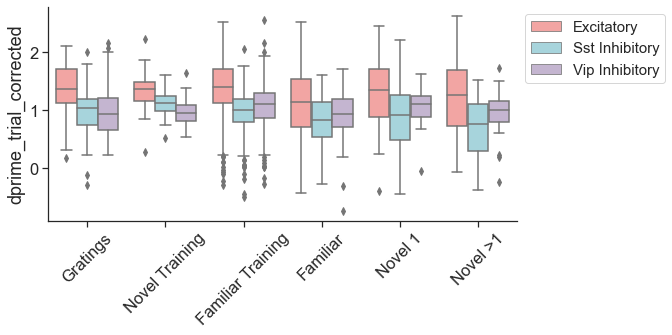

In [76]:
metric = 'dprime_trial_corrected'
# colors = utils.get_experience_level_colors()
colors = utils.get_cre_line_colors()

fig, ax = plt.subplots(figsize=(10,5))
ax = sns.boxplot(data=behavior_stats, x='experience_level', y=metric, order=experience_levels, 
                  hue='cell_type', hue_order=cell_types, palette=colors)
ax.legend(fontsize='small', title='', bbox_to_anchor=(1,1))
ax.set_xticklabels(experience_levels, rotation=45)
ax.set_xlabel('')

fig.tight_layout()

### color by exp level per cre line

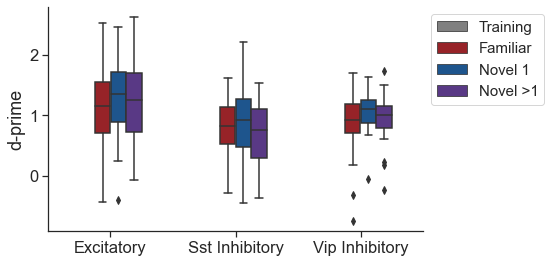

In [77]:
metric = 'dprime_trial_corrected'
colors = utils.get_experience_level_colors()
colors = [(0.5, 0.5, 0.5)]+colors

exp_levels = ['Training', 'Familiar', 'Novel 1', 'Novel >1']
data = behavior_stats[behavior_stats.experience_level.isin(exp_levels)]

fig, ax = plt.subplots(figsize=(8,4))
ax = sns.boxplot(data=data, x='cell_type', y=metric, order=cell_types, 
                  hue='experience_level', hue_order=exp_levels, palette=colors, width=0.5, dodge=True)
ax.legend(fontsize='small', title='', bbox_to_anchor=(1,1))
ax.set_xlabel('')
ax.set_ylabel('d-prime')
fig.tight_layout()

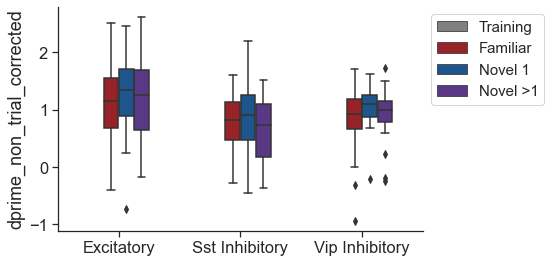

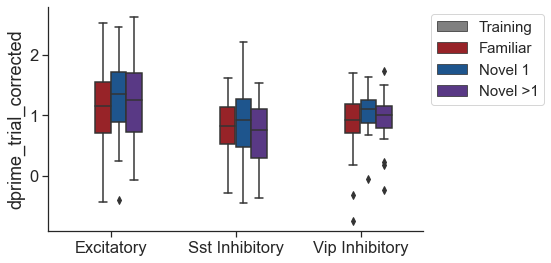

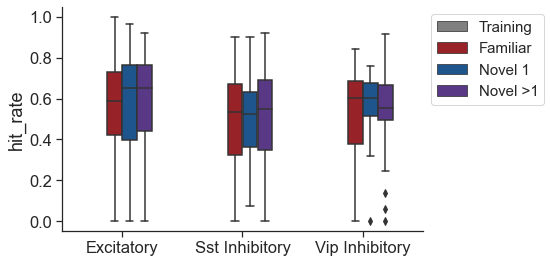

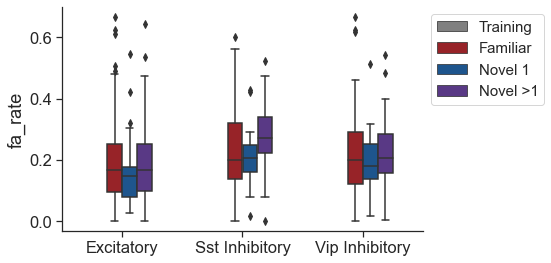

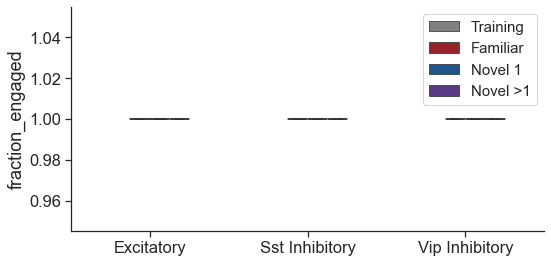

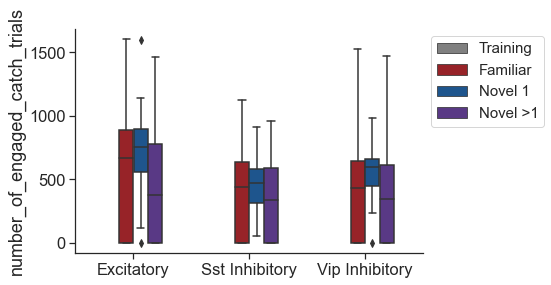

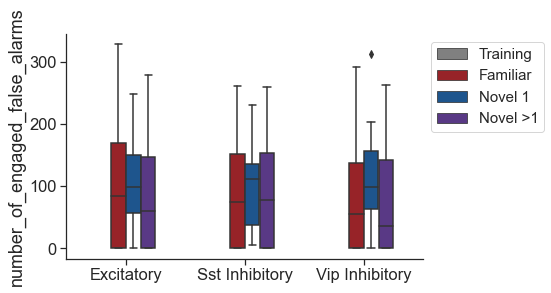

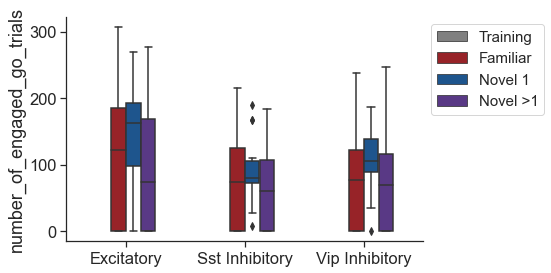

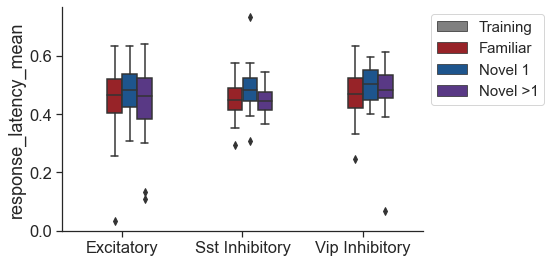

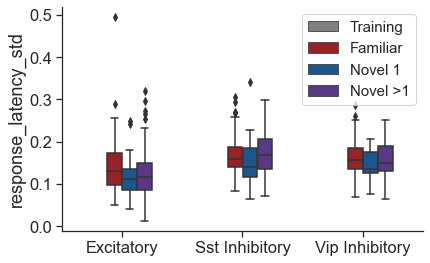

In [78]:
metric = 'dprime_trial_corrected'
colors = utils.get_experience_level_colors()
colors = [(0.5, 0.5, 0.5)]+colors

metrics = ['dprime_non_trial_corrected',
       'dprime_trial_corrected', 'hit_rate', 'fa_rate', 'fraction_engaged',
       'number_of_engaged_catch_trials',
       'number_of_engaged_false_alarms', 'number_of_engaged_go_trials',
       'response_latency_mean', 'response_latency_std',]

exp_levels = ['Training', 'Familiar', 'Novel 1', 'Novel >1']
data = behavior_stats[behavior_stats.experience_level.isin(exp_levels)]

for metric in metrics: 
    fig, ax = plt.subplots(figsize=(8,4))
    ax = sns.boxplot(data=data, x='cell_type', y=metric, order=cell_types, 
                      hue='experience_level', hue_order=exp_levels, palette=colors, width=0.5, dodge=True)
    ax.legend(fontsize='small', title='', bbox_to_anchor=(1,1))
    ax.set_xlabel('')
    fig.tight_layout()